# Discrete Learnable Flows on 1+1D $\phi^4$ Theory

This is a notebook implementation of [the following tutorial](https://arxiv.org/pdf/2101.08176), modified to reproduce some key results in [the following paper](https://arxiv.org/pdf/1904.12072). The algorithm used here closely follows the tutorial, with the only difference being the grouping of functions and classes into separate files, with the hope of resembling python modules and creating a cleaner notebook. However, some new functions are also introduced, such as ```zerogreenfuncs``` used to compute the two-point function and pole mass variable.

Here, in the first cell, we import some important modules, such as ```ScalarPhi4Action``` for computing the action, ```DiscreteFlow``` for implementing the discrete learnable flows, and ```torch``` for manipulating the data.

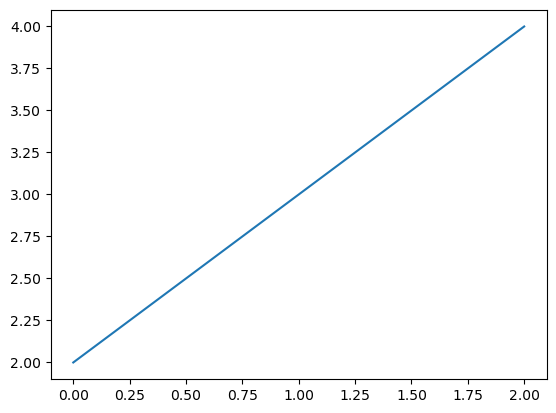

In [1]:
import matplotlib.pyplot as plt

plt.plot([0, 1, 2], [2, 3, 4])
plt.show()

In [2]:
from library.theory import ScalarPhi4Action
from library.couplinglayer import SimpleNormal, make_phi4_affine_layers
from library.train import DiscreteFlow, calc_dkl
import torch
import numpy as np

c:\Users\satri\anaconda3\envs\latticeflow\Lib\site-packages\torch\__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)


## A training example

In the cell below, we show an example of the training initialisation, with the case of lattice size $L = 14$, $m^2 = -4.0$ and $\lambda = 5.113$.

In [3]:
#Lattice Parameters
L = 14
lattice_shape = (L, L)

phi4_action = ScalarPhi4Action(M2 = -4.0, lam = 5.113)

#Model
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))
layers = make_phi4_affine_layers(lattice_shape = lattice_shape, n_layers = 16,
                                 hidden_sizes = [8, 8], kernel_size = 3)

model = {'layers': layers, 'prior': prior}

The following cells contain a base64-decoded string, which are used to save and load the trained models.

In [4]:
blob6 = """
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRG91YmxlU3RvcmFnZQpxBVgBAAAAMHEGWAMAAABjcHVxB0tIdHEIUUsAKEsISwFLA0sDdHEJKEsJSwlLA0sBdHEKiWgAKVJxC3RxDFJxDVgMAAAAMC5uZXQuMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPaAdLCHRxEFFLAEsIhXERSwGFcRKJaAApUnETdHEUUnEVWA4AAAAwLm5ldC4yLndlaWdodHEWaAMoKGgEaAVYAQAAADJxF2gHTUACdHEYUUsAKEsISwhLA0sDdHEZKEtISwlLA0sBdHEaiWgAKVJxG3RxHFJxHVgMAAAAMC5uZXQuMi5iaWFzcR5oAygoaARoBVgBAAAAM3EfaAdLCHRxIFFLAEsIhXEhSwGFcSKJaAApUnEjdHEkUnElWA4AAAAwLm5ldC40LndlaWdodHEmaAMoKGgEaAVYAQAAADRxJ2gHS5B0cShRSwAoSwJLCEsDSwN0cSkoS0hLCUsDSwF0cSqJaAApUnErdHEsUnEtWAwAAAAwLm5ldC40LmJpYXNxLmgDKChoBGgFWAEAAAA1cS9oB0sCdHEwUUsASwKFcTFLAYVxMoloAClScTN0cTRScTVYDgAAADEubmV0LjAud2VpZ2h0cTZoAygoaARoBVgBAAAANnE3aAdLSHRxOFFLAChLCEsBSwNLA3RxOShLCUsJSwNLAXRxOoloAClScTt0cTxScT1YDAAAADEubmV0LjAuYmlhc3E+aAMoKGgEaAVYAQAAADdxP2gHSwh0cUBRSwBLCIVxQUsBhXFCiWgAKVJxQ3RxRFJxRVgOAAAAMS5uZXQuMi53ZWlnaHRxRmgDKChoBGgFWAEAAAA4cUdoB01AAnRxSFFLAChLCEsISwNLA3RxSShLSEsJSwNLAXRxSoloAClScUt0cUxScU1YDAAAADEubmV0LjIuYmlhc3FOaAMoKGgEaAVYAQAAADlxT2gHSwh0cVBRSwBLCIVxUUsBhXFSiWgAKVJxU3RxVFJxVVgOAAAAMS5uZXQuNC53ZWlnaHRxVmgDKChoBGgFWAIAAAAxMHFXaAdLkHRxWFFLAChLAksISwNLA3RxWShLSEsJSwNLAXRxWoloAClScVt0cVxScV1YDAAAADEubmV0LjQuYmlhc3FeaAMoKGgEaAVYAgAAADExcV9oB0sCdHFgUUsASwKFcWFLAYVxYoloAClScWN0cWRScWVYDgAAADIubmV0LjAud2VpZ2h0cWZoAygoaARoBVgCAAAAMTJxZ2gHS0h0cWhRSwAoSwhLAUsDSwN0cWkoSwlLCUsDSwF0cWqJaAApUnFrdHFsUnFtWAwAAAAyLm5ldC4wLmJpYXNxbmgDKChoBGgFWAIAAAAxM3FvaAdLCHRxcFFLAEsIhXFxSwGFcXKJaAApUnFzdHF0UnF1WA4AAAAyLm5ldC4yLndlaWdodHF2aAMoKGgEaAVYAgAAADE0cXdoB01AAnRxeFFLAChLCEsISwNLA3RxeShLSEsJSwNLAXRxeoloAClScXt0cXxScX1YDAAAADIubmV0LjIuYmlhc3F+aAMoKGgEaAVYAgAAADE1cX9oB0sIdHGAUUsASwiFcYFLAYVxgoloAClScYN0cYRScYVYDgAAADIubmV0LjQud2VpZ2h0cYZoAygoaARoBVgCAAAAMTZxh2gHS5B0cYhRSwAoSwJLCEsDSwN0cYkoS0hLCUsDSwF0cYqJaAApUnGLdHGMUnGNWAwAAAAyLm5ldC40LmJpYXNxjmgDKChoBGgFWAIAAAAxN3GPaAdLAnRxkFFLAEsChXGRSwGFcZKJaAApUnGTdHGUUnGVWA4AAAAzLm5ldC4wLndlaWdodHGWaAMoKGgEaAVYAgAAADE4cZdoB0tIdHGYUUsAKEsISwFLA0sDdHGZKEsJSwlLA0sBdHGaiWgAKVJxm3RxnFJxnVgMAAAAMy5uZXQuMC5iaWFzcZ5oAygoaARoBVgCAAAAMTlxn2gHSwh0caBRSwBLCIVxoUsBhXGiiWgAKVJxo3RxpFJxpVgOAAAAMy5uZXQuMi53ZWlnaHRxpmgDKChoBGgFWAIAAAAyMHGnaAdNQAJ0cahRSwAoSwhLCEsDSwN0cakoS0hLCUsDSwF0caqJaAApUnGrdHGsUnGtWAwAAAAzLm5ldC4yLmJpYXNxrmgDKChoBGgFWAIAAAAyMXGvaAdLCHRxsFFLAEsIhXGxSwGFcbKJaAApUnGzdHG0UnG1WA4AAAAzLm5ldC40LndlaWdodHG2aAMoKGgEaAVYAgAAADIycbdoB0uQdHG4UUsAKEsCSwhLA0sDdHG5KEtISwlLA0sBdHG6iWgAKVJxu3RxvFJxvVgMAAAAMy5uZXQuNC5iaWFzcb5oAygoaARoBVgCAAAAMjNxv2gHSwJ0ccBRSwBLAoVxwUsBhXHCiWgAKVJxw3RxxFJxxVgOAAAANC5uZXQuMC53ZWlnaHRxxmgDKChoBGgFWAIAAAAyNHHHaAdLSHRxyFFLAChLCEsBSwNLA3RxyShLCUsJSwNLAXRxyoloAClScct0ccxScc1YDAAAADQubmV0LjAuYmlhc3HOaAMoKGgEaAVYAgAAADI1cc9oB0sIdHHQUUsASwiFcdFLAYVx0oloAClScdN0cdRScdVYDgAAADQubmV0LjIud2VpZ2h0cdZoAygoaARoBVgCAAAAMjZx12gHTUACdHHYUUsAKEsISwhLA0sDdHHZKEtISwlLA0sBdHHaiWgAKVJx23Rx3FJx3VgMAAAANC5uZXQuMi5iaWFzcd5oAygoaARoBVgCAAAAMjdx32gHSwh0ceBRSwBLCIVx4UsBhXHiiWgAKVJx43Rx5FJx5VgOAAAANC5uZXQuNC53ZWlnaHRx5mgDKChoBGgFWAIAAAAyOHHnaAdLkHRx6FFLAChLAksISwNLA3Rx6ShLSEsJSwNLAXRx6oloAClScet0cexSce1YDAAAADQubmV0LjQuYmlhc3HuaAMoKGgEaAVYAgAAADI5ce9oB0sCdHHwUUsASwKFcfFLAYVx8oloAClScfN0cfRScfVYDgAAADUubmV0LjAud2VpZ2h0cfZoAygoaARoBVgCAAAAMzBx92gHS0h0cfhRSwAoSwhLAUsDSwN0cfkoSwlLCUsDSwF0cfqJaAApUnH7dHH8UnH9WAwAAAA1Lm5ldC4wLmJpYXNx/mgDKChoBGgFWAIAAAAzMXH/aAdLCHRyAAEAAFFLAEsIhXIBAQAASwGFcgIBAACJaAApUnIDAQAAdHIEAQAAUnIFAQAAWA4AAAA1Lm5ldC4yLndlaWdodHIGAQAAaAMoKGgEaAVYAgAAADMycgcBAABoB01AAnRyCAEAAFFLAChLCEsISwNLA3RyCQEAAChLSEsJSwNLAXRyCgEAAIloAClScgsBAAB0cgwBAABScg0BAABYDAAAADUubmV0LjIuYmlhc3IOAQAAaAMoKGgEaAVYAgAAADMzcg8BAABoB0sIdHIQAQAAUUsASwiFchEBAABLAYVyEgEAAIloAClSchMBAAB0chQBAABSchUBAABYDgAAADUubmV0LjQud2VpZ2h0chYBAABoAygoaARoBVgCAAAAMzRyFwEAAGgHS5B0chgBAABRSwAoSwJLCEsDSwN0chkBAAAoS0hLCUsDSwF0choBAACJaAApUnIbAQAAdHIcAQAAUnIdAQAAWAwAAAA1Lm5ldC40LmJpYXNyHgEAAGgDKChoBGgFWAIAAAAzNXIfAQAAaAdLAnRyIAEAAFFLAEsChXIhAQAASwGFciIBAACJaAApUnIjAQAAdHIkAQAAUnIlAQAAWA4AAAA2Lm5ldC4wLndlaWdodHImAQAAaAMoKGgEaAVYAgAAADM2cicBAABoB0tIdHIoAQAAUUsAKEsISwFLA0sDdHIpAQAAKEsJSwlLA0sBdHIqAQAAiWgAKVJyKwEAAHRyLAEAAFJyLQEAAFgMAAAANi5uZXQuMC5iaWFzci4BAABoAygoaARoBVgCAAAAMzdyLwEAAGgHSwh0cjABAABRSwBLCIVyMQEAAEsBhXIyAQAAiWgAKVJyMwEAAHRyNAEAAFJyNQEAAFgOAAAANi5uZXQuMi53ZWlnaHRyNgEAAGgDKChoBGgFWAIAAAAzOHI3AQAAaAdNQAJ0cjgBAABRSwAoSwhLCEsDSwN0cjkBAAAoS0hLCUsDSwF0cjoBAACJaAApUnI7AQAAdHI8AQAAUnI9AQAAWAwAAAA2Lm5ldC4yLmJpYXNyPgEAAGgDKChoBGgFWAIAAAAzOXI/AQAAaAdLCHRyQAEAAFFLAEsIhXJBAQAASwGFckIBAACJaAApUnJDAQAAdHJEAQAAUnJFAQAAWA4AAAA2Lm5ldC40LndlaWdodHJGAQAAaAMoKGgEaAVYAgAAADQwckcBAABoB0uQdHJIAQAAUUsAKEsCSwhLA0sDdHJJAQAAKEtISwlLA0sBdHJKAQAAiWgAKVJySwEAAHRyTAEAAFJyTQEAAFgMAAAANi5uZXQuNC5iaWFzck4BAABoAygoaARoBVgCAAAANDFyTwEAAGgHSwJ0clABAABRSwBLAoVyUQEAAEsBhXJSAQAAiWgAKVJyUwEAAHRyVAEAAFJyVQEAAFgOAAAANy5uZXQuMC53ZWlnaHRyVgEAAGgDKChoBGgFWAIAAAA0MnJXAQAAaAdLSHRyWAEAAFFLAChLCEsBSwNLA3RyWQEAAChLCUsJSwNLAXRyWgEAAIloAClSclsBAAB0clwBAABScl0BAABYDAAAADcubmV0LjAuYmlhc3JeAQAAaAMoKGgEaAVYAgAAADQzcl8BAABoB0sIdHJgAQAAUUsASwiFcmEBAABLAYVyYgEAAIloAClScmMBAAB0cmQBAABScmUBAABYDgAAADcubmV0LjIud2VpZ2h0cmYBAABoAygoaARoBVgCAAAANDRyZwEAAGgHTUACdHJoAQAAUUsAKEsISwhLA0sDdHJpAQAAKEtISwlLA0sBdHJqAQAAiWgAKVJyawEAAHRybAEAAFJybQEAAFgMAAAANy5uZXQuMi5iaWFzcm4BAABoAygoaARoBVgCAAAANDVybwEAAGgHSwh0cnABAABRSwBLCIVycQEAAEsBhXJyAQAAiWgAKVJycwEAAHRydAEAAFJydQEAAFgOAAAANy5uZXQuNC53ZWlnaHRydgEAAGgDKChoBGgFWAIAAAA0NnJ3AQAAaAdLkHRyeAEAAFFLAChLAksISwNLA3RyeQEAAChLSEsJSwNLAXRyegEAAIloAClScnsBAAB0cnwBAABScn0BAABYDAAAADcubmV0LjQuYmlhc3J+AQAAaAMoKGgEaAVYAgAAADQ3cn8BAABoB0sCdHKAAQAAUUsASwKFcoEBAABLAYVyggEAAIloAClScoMBAAB0coQBAABScoUBAABYDgAAADgubmV0LjAud2VpZ2h0coYBAABoAygoaARoBVgCAAAANDhyhwEAAGgHS0h0cogBAABRSwAoSwhLAUsDSwN0cokBAAAoSwlLCUsDSwF0cooBAACJaAApUnKLAQAAdHKMAQAAUnKNAQAAWAwAAAA4Lm5ldC4wLmJpYXNyjgEAAGgDKChoBGgFWAIAAAA0OXKPAQAAaAdLCHRykAEAAFFLAEsIhXKRAQAASwGFcpIBAACJaAApUnKTAQAAdHKUAQAAUnKVAQAAWA4AAAA4Lm5ldC4yLndlaWdodHKWAQAAaAMoKGgEaAVYAgAAADUwcpcBAABoB01AAnRymAEAAFFLAChLCEsISwNLA3RymQEAAChLSEsJSwNLAXRymgEAAIloAClScpsBAAB0cpwBAABScp0BAABYDAAAADgubmV0LjIuYmlhc3KeAQAAaAMoKGgEaAVYAgAAADUxcp8BAABoB0sIdHKgAQAAUUsASwiFcqEBAABLAYVyogEAAIloAClScqMBAAB0cqQBAABScqUBAABYDgAAADgubmV0LjQud2VpZ2h0cqYBAABoAygoaARoBVgCAAAANTJypwEAAGgHS5B0cqgBAABRSwAoSwJLCEsDSwN0cqkBAAAoS0hLCUsDSwF0cqoBAACJaAApUnKrAQAAdHKsAQAAUnKtAQAAWAwAAAA4Lm5ldC40LmJpYXNyrgEAAGgDKChoBGgFWAIAAAA1M3KvAQAAaAdLAnRysAEAAFFLAEsChXKxAQAASwGFcrIBAACJaAApUnKzAQAAdHK0AQAAUnK1AQAAWA4AAAA5Lm5ldC4wLndlaWdodHK2AQAAaAMoKGgEaAVYAgAAADU0crcBAABoB0tIdHK4AQAAUUsAKEsISwFLA0sDdHK5AQAAKEsJSwlLA0sBdHK6AQAAiWgAKVJyuwEAAHRyvAEAAFJyvQEAAFgMAAAAOS5uZXQuMC5iaWFzcr4BAABoAygoaARoBVgCAAAANTVyvwEAAGgHSwh0csABAABRSwBLCIVywQEAAEsBhXLCAQAAiWgAKVJywwEAAHRyxAEAAFJyxQEAAFgOAAAAOS5uZXQuMi53ZWlnaHRyxgEAAGgDKChoBGgFWAIAAAA1NnLHAQAAaAdNQAJ0csgBAABRSwAoSwhLCEsDSwN0cskBAAAoS0hLCUsDSwF0csoBAACJaAApUnLLAQAAdHLMAQAAUnLNAQAAWAwAAAA5Lm5ldC4yLmJpYXNyzgEAAGgDKChoBGgFWAIAAAA1N3LPAQAAaAdLCHRy0AEAAFFLAEsIhXLRAQAASwGFctIBAACJaAApUnLTAQAAdHLUAQAAUnLVAQAAWA4AAAA5Lm5ldC40LndlaWdodHLWAQAAaAMoKGgEaAVYAgAAADU4ctcBAABoB0uQdHLYAQAAUUsAKEsCSwhLA0sDdHLZAQAAKEtISwlLA0sBdHLaAQAAiWgAKVJy2wEAAHRy3AEAAFJy3QEAAFgMAAAAOS5uZXQuNC5iaWFzct4BAABoAygoaARoBVgCAAAANTly3wEAAGgHSwJ0cuABAABRSwBLAoVy4QEAAEsBhXLiAQAAiWgAKVJy4wEAAHRy5AEAAFJy5QEAAFgPAAAAMTAubmV0LjAud2VpZ2h0cuYBAABoAygoaARoBVgCAAAANjBy5wEAAGgHS0h0cugBAABRSwAoSwhLAUsDSwN0cukBAAAoSwlLCUsDSwF0cuoBAACJaAApUnLrAQAAdHLsAQAAUnLtAQAAWA0AAAAxMC5uZXQuMC5iaWFzcu4BAABoAygoaARoBVgCAAAANjFy7wEAAGgHSwh0cvABAABRSwBLCIVy8QEAAEsBhXLyAQAAiWgAKVJy8wEAAHRy9AEAAFJy9QEAAFgPAAAAMTAubmV0LjIud2VpZ2h0cvYBAABoAygoaARoBVgCAAAANjJy9wEAAGgHTUACdHL4AQAAUUsAKEsISwhLA0sDdHL5AQAAKEtISwlLA0sBdHL6AQAAiWgAKVJy+wEAAHRy/AEAAFJy/QEAAFgNAAAAMTAubmV0LjIuYmlhc3L+AQAAaAMoKGgEaAVYAgAAADYzcv8BAABoB0sIdHIAAgAAUUsASwiFcgECAABLAYVyAgIAAIloAClScgMCAAB0cgQCAABScgUCAABYDwAAADEwLm5ldC40LndlaWdodHIGAgAAaAMoKGgEaAVYAgAAADY0cgcCAABoB0uQdHIIAgAAUUsAKEsCSwhLA0sDdHIJAgAAKEtISwlLA0sBdHIKAgAAiWgAKVJyCwIAAHRyDAIAAFJyDQIAAFgNAAAAMTAubmV0LjQuYmlhc3IOAgAAaAMoKGgEaAVYAgAAADY1cg8CAABoB0sCdHIQAgAAUUsASwKFchECAABLAYVyEgIAAIloAClSchMCAAB0chQCAABSchUCAABYDwAAADExLm5ldC4wLndlaWdodHIWAgAAaAMoKGgEaAVYAgAAADY2chcCAABoB0tIdHIYAgAAUUsAKEsISwFLA0sDdHIZAgAAKEsJSwlLA0sBdHIaAgAAiWgAKVJyGwIAAHRyHAIAAFJyHQIAAFgNAAAAMTEubmV0LjAuYmlhc3IeAgAAaAMoKGgEaAVYAgAAADY3ch8CAABoB0sIdHIgAgAAUUsASwiFciECAABLAYVyIgIAAIloAClSciMCAAB0ciQCAABSciUCAABYDwAAADExLm5ldC4yLndlaWdodHImAgAAaAMoKGgEaAVYAgAAADY4cicCAABoB01AAnRyKAIAAFFLAChLCEsISwNLA3RyKQIAAChLSEsJSwNLAXRyKgIAAIloAClScisCAAB0ciwCAABSci0CAABYDQAAADExLm5ldC4yLmJpYXNyLgIAAGgDKChoBGgFWAIAAAA2OXIvAgAAaAdLCHRyMAIAAFFLAEsIhXIxAgAASwGFcjICAACJaAApUnIzAgAAdHI0AgAAUnI1AgAAWA8AAAAxMS5uZXQuNC53ZWlnaHRyNgIAAGgDKChoBGgFWAIAAAA3MHI3AgAAaAdLkHRyOAIAAFFLAChLAksISwNLA3RyOQIAAChLSEsJSwNLAXRyOgIAAIloAClScjsCAAB0cjwCAABScj0CAABYDQAAADExLm5ldC40LmJpYXNyPgIAAGgDKChoBGgFWAIAAAA3MXI/AgAAaAdLAnRyQAIAAFFLAEsChXJBAgAASwGFckICAACJaAApUnJDAgAAdHJEAgAAUnJFAgAAWA8AAAAxMi5uZXQuMC53ZWlnaHRyRgIAAGgDKChoBGgFWAIAAAA3MnJHAgAAaAdLSHRySAIAAFFLAChLCEsBSwNLA3RySQIAAChLCUsJSwNLAXRySgIAAIloAClScksCAAB0ckwCAABSck0CAABYDQAAADEyLm5ldC4wLmJpYXNyTgIAAGgDKChoBGgFWAIAAAA3M3JPAgAAaAdLCHRyUAIAAFFLAEsIhXJRAgAASwGFclICAACJaAApUnJTAgAAdHJUAgAAUnJVAgAAWA8AAAAxMi5uZXQuMi53ZWlnaHRyVgIAAGgDKChoBGgFWAIAAAA3NHJXAgAAaAdNQAJ0clgCAABRSwAoSwhLCEsDSwN0clkCAAAoS0hLCUsDSwF0cloCAACJaAApUnJbAgAAdHJcAgAAUnJdAgAAWA0AAAAxMi5uZXQuMi5iaWFzcl4CAABoAygoaARoBVgCAAAANzVyXwIAAGgHSwh0cmACAABRSwBLCIVyYQIAAEsBhXJiAgAAiWgAKVJyYwIAAHRyZAIAAFJyZQIAAFgPAAAAMTIubmV0LjQud2VpZ2h0cmYCAABoAygoaARoBVgCAAAANzZyZwIAAGgHS5B0cmgCAABRSwAoSwJLCEsDSwN0cmkCAAAoS0hLCUsDSwF0cmoCAACJaAApUnJrAgAAdHJsAgAAUnJtAgAAWA0AAAAxMi5uZXQuNC5iaWFzcm4CAABoAygoaARoBVgCAAAANzdybwIAAGgHSwJ0cnACAABRSwBLAoVycQIAAEsBhXJyAgAAiWgAKVJycwIAAHRydAIAAFJydQIAAFgPAAAAMTMubmV0LjAud2VpZ2h0cnYCAABoAygoaARoBVgCAAAANzhydwIAAGgHS0h0cngCAABRSwAoSwhLAUsDSwN0cnkCAAAoSwlLCUsDSwF0cnoCAACJaAApUnJ7AgAAdHJ8AgAAUnJ9AgAAWA0AAAAxMy5uZXQuMC5iaWFzcn4CAABoAygoaARoBVgCAAAANzlyfwIAAGgHSwh0coACAABRSwBLCIVygQIAAEsBhXKCAgAAiWgAKVJygwIAAHRyhAIAAFJyhQIAAFgPAAAAMTMubmV0LjIud2VpZ2h0coYCAABoAygoaARoBVgCAAAAODByhwIAAGgHTUACdHKIAgAAUUsAKEsISwhLA0sDdHKJAgAAKEtISwlLA0sBdHKKAgAAiWgAKVJyiwIAAHRyjAIAAFJyjQIAAFgNAAAAMTMubmV0LjIuYmlhc3KOAgAAaAMoKGgEaAVYAgAAADgxco8CAABoB0sIdHKQAgAAUUsASwiFcpECAABLAYVykgIAAIloAClScpMCAAB0cpQCAABScpUCAABYDwAAADEzLm5ldC40LndlaWdodHKWAgAAaAMoKGgEaAVYAgAAADgycpcCAABoB0uQdHKYAgAAUUsAKEsCSwhLA0sDdHKZAgAAKEtISwlLA0sBdHKaAgAAiWgAKVJymwIAAHRynAIAAFJynQIAAFgNAAAAMTMubmV0LjQuYmlhc3KeAgAAaAMoKGgEaAVYAgAAADgzcp8CAABoB0sCdHKgAgAAUUsASwKFcqECAABLAYVyogIAAIloAClScqMCAAB0cqQCAABScqUCAABYDwAAADE0Lm5ldC4wLndlaWdodHKmAgAAaAMoKGgEaAVYAgAAADg0cqcCAABoB0tIdHKoAgAAUUsAKEsISwFLA0sDdHKpAgAAKEsJSwlLA0sBdHKqAgAAiWgAKVJyqwIAAHRyrAIAAFJyrQIAAFgNAAAAMTQubmV0LjAuYmlhc3KuAgAAaAMoKGgEaAVYAgAAADg1cq8CAABoB0sIdHKwAgAAUUsASwiFcrECAABLAYVysgIAAIloAClScrMCAAB0crQCAABScrUCAABYDwAAADE0Lm5ldC4yLndlaWdodHK2AgAAaAMoKGgEaAVYAgAAADg2crcCAABoB01AAnRyuAIAAFFLAChLCEsISwNLA3RyuQIAAChLSEsJSwNLAXRyugIAAIloAClScrsCAAB0crwCAABScr0CAABYDQAAADE0Lm5ldC4yLmJpYXNyvgIAAGgDKChoBGgFWAIAAAA4N3K/AgAAaAdLCHRywAIAAFFLAEsIhXLBAgAASwGFcsICAACJaAApUnLDAgAAdHLEAgAAUnLFAgAAWA8AAAAxNC5uZXQuNC53ZWlnaHRyxgIAAGgDKChoBGgFWAIAAAA4OHLHAgAAaAdLkHRyyAIAAFFLAChLAksISwNLA3RyyQIAAChLSEsJSwNLAXRyygIAAIloAClScssCAAB0cswCAABScs0CAABYDQAAADE0Lm5ldC40LmJpYXNyzgIAAGgDKChoBGgFWAIAAAA4OXLPAgAAaAdLAnRy0AIAAFFLAEsChXLRAgAASwGFctICAACJaAApUnLTAgAAdHLUAgAAUnLVAgAAWA8AAAAxNS5uZXQuMC53ZWlnaHRy1gIAAGgDKChoBGgFWAIAAAA5MHLXAgAAaAdLSHRy2AIAAFFLAChLCEsBSwNLA3Ry2QIAAChLCUsJSwNLAXRy2gIAAIloAClSctsCAAB0ctwCAABSct0CAABYDQAAADE1Lm5ldC4wLmJpYXNy3gIAAGgDKChoBGgFWAIAAAA5MXLfAgAAaAdLCHRy4AIAAFFLAEsIhXLhAgAASwGFcuICAACJaAApUnLjAgAAdHLkAgAAUnLlAgAAWA8AAAAxNS5uZXQuMi53ZWlnaHRy5gIAAGgDKChoBGgFWAIAAAA5MnLnAgAAaAdNQAJ0cugCAABRSwAoSwhLCEsDSwN0cukCAAAoS0hLCUsDSwF0cuoCAACJaAApUnLrAgAAdHLsAgAAUnLtAgAAWA0AAAAxNS5uZXQuMi5iaWFzcu4CAABoAygoaARoBVgCAAAAOTNy7wIAAGgHSwh0cvACAABRSwBLCIVy8QIAAEsBhXLyAgAAiWgAKVJy8wIAAHRy9AIAAFJy9QIAAFgPAAAAMTUubmV0LjQud2VpZ2h0cvYCAABoAygoaARoBVgCAAAAOTRy9wIAAGgHS5B0cvgCAABRSwAoSwJLCEsDSwN0cvkCAAAoS0hLCUsDSwF0cvoCAACJaAApUnL7AgAAdHL8AgAAUnL9AgAAWA0AAAAxNS5uZXQuNC5iaWFzcv4CAABoAygoaARoBVgCAAAAOTVy/wIAAGgHSwJ0cgADAABRSwBLAoVyAQMAAEsBhXICAwAAiWgAKVJyAwMAAHRyBAMAAFJyBQMAAHV9cgYDAABYCQAAAF9tZXRhZGF0YXIHAwAAaAApUnIIAwAAKFgAAAAAcgkDAAB9cgoDAABYBwAAAHZlcnNpb25yCwMAAEsBc1gBAAAAMHIMAwAAfXINAwAAagsDAABLAXNYBQAAADAubmV0cg4DAAB9cg8DAABqCwMAAEsBc1gHAAAAMC5uZXQuMHIQAwAAfXIRAwAAagsDAABLAXNYBwAAADAubmV0LjFyEgMAAH1yEwMAAGoLAwAASwFzWAcAAAAwLm5ldC4ychQDAAB9chUDAABqCwMAAEsBc1gHAAAAMC5uZXQuM3IWAwAAfXIXAwAAagsDAABLAXNYBwAAADAubmV0LjRyGAMAAH1yGQMAAGoLAwAASwFzWAcAAAAwLm5ldC41choDAAB9chsDAABqCwMAAEsBc1gBAAAAMXIcAwAAfXIdAwAAagsDAABLAXNYBQAAADEubmV0ch4DAAB9ch8DAABqCwMAAEsBc1gHAAAAMS5uZXQuMHIgAwAAfXIhAwAAagsDAABLAXNYBwAAADEubmV0LjFyIgMAAH1yIwMAAGoLAwAASwFzWAcAAAAxLm5ldC4yciQDAAB9ciUDAABqCwMAAEsBc1gHAAAAMS5uZXQuM3ImAwAAfXInAwAAagsDAABLAXNYBwAAADEubmV0LjRyKAMAAH1yKQMAAGoLAwAASwFzWAcAAAAxLm5ldC41cioDAAB9cisDAABqCwMAAEsBc1gBAAAAMnIsAwAAfXItAwAAagsDAABLAXNYBQAAADIubmV0ci4DAAB9ci8DAABqCwMAAEsBc1gHAAAAMi5uZXQuMHIwAwAAfXIxAwAAagsDAABLAXNYBwAAADIubmV0LjFyMgMAAH1yMwMAAGoLAwAASwFzWAcAAAAyLm5ldC4ycjQDAAB9cjUDAABqCwMAAEsBc1gHAAAAMi5uZXQuM3I2AwAAfXI3AwAAagsDAABLAXNYBwAAADIubmV0LjRyOAMAAH1yOQMAAGoLAwAASwFzWAcAAAAyLm5ldC41cjoDAAB9cjsDAABqCwMAAEsBc1gBAAAAM3I8AwAAfXI9AwAAagsDAABLAXNYBQAAADMubmV0cj4DAAB9cj8DAABqCwMAAEsBc1gHAAAAMy5uZXQuMHJAAwAAfXJBAwAAagsDAABLAXNYBwAAADMubmV0LjFyQgMAAH1yQwMAAGoLAwAASwFzWAcAAAAzLm5ldC4yckQDAAB9ckUDAABqCwMAAEsBc1gHAAAAMy5uZXQuM3JGAwAAfXJHAwAAagsDAABLAXNYBwAAADMubmV0LjRySAMAAH1ySQMAAGoLAwAASwFzWAcAAAAzLm5ldC41ckoDAAB9cksDAABqCwMAAEsBc1gBAAAANHJMAwAAfXJNAwAAagsDAABLAXNYBQAAADQubmV0ck4DAAB9ck8DAABqCwMAAEsBc1gHAAAANC5uZXQuMHJQAwAAfXJRAwAAagsDAABLAXNYBwAAADQubmV0LjFyUgMAAH1yUwMAAGoLAwAASwFzWAcAAAA0Lm5ldC4yclQDAAB9clUDAABqCwMAAEsBc1gHAAAANC5uZXQuM3JWAwAAfXJXAwAAagsDAABLAXNYBwAAADQubmV0LjRyWAMAAH1yWQMAAGoLAwAASwFzWAcAAAA0Lm5ldC41cloDAAB9clsDAABqCwMAAEsBc1gBAAAANXJcAwAAfXJdAwAAagsDAABLAXNYBQAAADUubmV0cl4DAAB9cl8DAABqCwMAAEsBc1gHAAAANS5uZXQuMHJgAwAAfXJhAwAAagsDAABLAXNYBwAAADUubmV0LjFyYgMAAH1yYwMAAGoLAwAASwFzWAcAAAA1Lm5ldC4ycmQDAAB9cmUDAABqCwMAAEsBc1gHAAAANS5uZXQuM3JmAwAAfXJnAwAAagsDAABLAXNYBwAAADUubmV0LjRyaAMAAH1yaQMAAGoLAwAASwFzWAcAAAA1Lm5ldC41cmoDAAB9cmsDAABqCwMAAEsBc1gBAAAANnJsAwAAfXJtAwAAagsDAABLAXNYBQAAADYubmV0cm4DAAB9cm8DAABqCwMAAEsBc1gHAAAANi5uZXQuMHJwAwAAfXJxAwAAagsDAABLAXNYBwAAADYubmV0LjFycgMAAH1ycwMAAGoLAwAASwFzWAcAAAA2Lm5ldC4ycnQDAAB9cnUDAABqCwMAAEsBc1gHAAAANi5uZXQuM3J2AwAAfXJ3AwAAagsDAABLAXNYBwAAADYubmV0LjRyeAMAAH1yeQMAAGoLAwAASwFzWAcAAAA2Lm5ldC41cnoDAAB9cnsDAABqCwMAAEsBc1gBAAAAN3J8AwAAfXJ9AwAAagsDAABLAXNYBQAAADcubmV0cn4DAAB9cn8DAABqCwMAAEsBc1gHAAAANy5uZXQuMHKAAwAAfXKBAwAAagsDAABLAXNYBwAAADcubmV0LjFyggMAAH1ygwMAAGoLAwAASwFzWAcAAAA3Lm5ldC4ycoQDAAB9coUDAABqCwMAAEsBc1gHAAAANy5uZXQuM3KGAwAAfXKHAwAAagsDAABLAXNYBwAAADcubmV0LjRyiAMAAH1yiQMAAGoLAwAASwFzWAcAAAA3Lm5ldC41cooDAAB9cosDAABqCwMAAEsBc1gBAAAAOHKMAwAAfXKNAwAAagsDAABLAXNYBQAAADgubmV0co4DAAB9co8DAABqCwMAAEsBc1gHAAAAOC5uZXQuMHKQAwAAfXKRAwAAagsDAABLAXNYBwAAADgubmV0LjFykgMAAH1ykwMAAGoLAwAASwFzWAcAAAA4Lm5ldC4ycpQDAAB9cpUDAABqCwMAAEsBc1gHAAAAOC5uZXQuM3KWAwAAfXKXAwAAagsDAABLAXNYBwAAADgubmV0LjRymAMAAH1ymQMAAGoLAwAASwFzWAcAAAA4Lm5ldC41cpoDAAB9cpsDAABqCwMAAEsBc1gBAAAAOXKcAwAAfXKdAwAAagsDAABLAXNYBQAAADkubmV0cp4DAAB9cp8DAABqCwMAAEsBc1gHAAAAOS5uZXQuMHKgAwAAfXKhAwAAagsDAABLAXNYBwAAADkubmV0LjFyogMAAH1yowMAAGoLAwAASwFzWAcAAAA5Lm5ldC4ycqQDAAB9cqUDAABqCwMAAEsBc1gHAAAAOS5uZXQuM3KmAwAAfXKnAwAAagsDAABLAXNYBwAAADkubmV0LjRyqAMAAH1yqQMAAGoLAwAASwFzWAcAAAA5Lm5ldC41cqoDAAB9cqsDAABqCwMAAEsBc1gCAAAAMTByrAMAAH1yrQMAAGoLAwAASwFzWAYAAAAxMC5uZXRyrgMAAH1yrwMAAGoLAwAASwFzWAgAAAAxMC5uZXQuMHKwAwAAfXKxAwAAagsDAABLAXNYCAAAADEwLm5ldC4xcrIDAAB9crMDAABqCwMAAEsBc1gIAAAAMTAubmV0LjJytAMAAH1ytQMAAGoLAwAASwFzWAgAAAAxMC5uZXQuM3K2AwAAfXK3AwAAagsDAABLAXNYCAAAADEwLm5ldC40crgDAAB9crkDAABqCwMAAEsBc1gIAAAAMTAubmV0LjVyugMAAH1yuwMAAGoLAwAASwFzWAIAAAAxMXK8AwAAfXK9AwAAagsDAABLAXNYBgAAADExLm5ldHK+AwAAfXK/AwAAagsDAABLAXNYCAAAADExLm5ldC4wcsADAAB9csEDAABqCwMAAEsBc1gIAAAAMTEubmV0LjFywgMAAH1ywwMAAGoLAwAASwFzWAgAAAAxMS5uZXQuMnLEAwAAfXLFAwAAagsDAABLAXNYCAAAADExLm5ldC4zcsYDAAB9cscDAABqCwMAAEsBc1gIAAAAMTEubmV0LjRyyAMAAH1yyQMAAGoLAwAASwFzWAgAAAAxMS5uZXQuNXLKAwAAfXLLAwAAagsDAABLAXNYAgAAADEycswDAAB9cs0DAABqCwMAAEsBc1gGAAAAMTIubmV0cs4DAAB9cs8DAABqCwMAAEsBc1gIAAAAMTIubmV0LjBy0AMAAH1y0QMAAGoLAwAASwFzWAgAAAAxMi5uZXQuMXLSAwAAfXLTAwAAagsDAABLAXNYCAAAADEyLm5ldC4yctQDAAB9ctUDAABqCwMAAEsBc1gIAAAAMTIubmV0LjNy1gMAAH1y1wMAAGoLAwAASwFzWAgAAAAxMi5uZXQuNHLYAwAAfXLZAwAAagsDAABLAXNYCAAAADEyLm5ldC41ctoDAAB9ctsDAABqCwMAAEsBc1gCAAAAMTNy3AMAAH1y3QMAAGoLAwAASwFzWAYAAAAxMy5uZXRy3gMAAH1y3wMAAGoLAwAASwFzWAgAAAAxMy5uZXQuMHLgAwAAfXLhAwAAagsDAABLAXNYCAAAADEzLm5ldC4xcuIDAAB9cuMDAABqCwMAAEsBc1gIAAAAMTMubmV0LjJy5AMAAH1y5QMAAGoLAwAASwFzWAgAAAAxMy5uZXQuM3LmAwAAfXLnAwAAagsDAABLAXNYCAAAADEzLm5ldC40cugDAAB9cukDAABqCwMAAEsBc1gIAAAAMTMubmV0LjVy6gMAAH1y6wMAAGoLAwAASwFzWAIAAAAxNHLsAwAAfXLtAwAAagsDAABLAXNYBgAAADE0Lm5ldHLuAwAAfXLvAwAAagsDAABLAXNYCAAAADE0Lm5ldC4wcvADAAB9cvEDAABqCwMAAEsBc1gIAAAAMTQubmV0LjFy8gMAAH1y8wMAAGoLAwAASwFzWAgAAAAxNC5uZXQuMnL0AwAAfXL1AwAAagsDAABLAXNYCAAAADE0Lm5ldC4zcvYDAAB9cvcDAABqCwMAAEsBc1gIAAAAMTQubmV0LjRy+AMAAH1y+QMAAGoLAwAASwFzWAgAAAAxNC5uZXQuNXL6AwAAfXL7AwAAagsDAABLAXNYAgAAADE1cvwDAAB9cv0DAABqCwMAAEsBc1gGAAAAMTUubmV0cv4DAAB9cv8DAABqCwMAAEsBc1gIAAAAMTUubmV0LjByAAQAAH1yAQQAAGoLAwAASwFzWAgAAAAxNS5uZXQuMXICBAAAfXIDBAAAagsDAABLAXNYCAAAADE1Lm5ldC4ycgQEAAB9cgUEAABqCwMAAEsBc1gIAAAAMTUubmV0LjNyBgQAAH1yBwQAAGoLAwAASwFzWAgAAAAxNS5uZXQuNHIIBAAAfXIJBAAAagsDAABLAXNYCAAAADE1Lm5ldC41cgoEAAB9cgsEAABqCwMAAEsBc3VzYi5QSwcIpLYAcQQzAAAEMwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAARAD0AYXJjaGl2ZS9ieXRlb3JkZXJGQjkAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabGl0dGxlUEsHCIU94xkGAAAABgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgA+AGFyY2hpdmUvZGF0YS8wRkI6AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqWyuGBG42bv8naejeGxrG/HbNAlg9Ytr9W/sc5W/bNv3QdoBRu28a/Cs7q9TtdwL9E6yNz+UW4P2F7XghKKb4/t4AlhrZziD+eV0kMX0jDvx6NdokiRsY/Jzi2SCajsz89VuzeT6jVP6cLr+pCXbm/U4VBpCiBgL/mBzagZBufPzwuKxhE4pq/dVXnR1wMlb/SVn6BECV9vytzgUSb8bm/VX1z2twFtj9/2vjg6cXGP0Dsq8O2QLA/25koVBS3tr9O1YKokj9wvxDQoY2FsKo/x4TtT0C41z8jyx1SdSu+v2/eakoEl8I/+W0Ptz2Oy78dvNqclLnHv5FqxuS3jM4/YevebT9Hyj+j7Bihtn7CP5jXSK40F5u/G1fIZNDbzb+b7bijLDe3v1rq5XRSytO/PbvHkdgjxj+RB/CDYoHRv31m3Zr1g8Y/FMwSDdOGjD/jcVVlfonEP5sMfWxLV8e/qE8SS7Bayj9umU8cabS8P671WE1Jj72/Ex15gzpXzT9RGjDFAYzBv9duWQ5Lxqe//oPeCWVprL8a1akCdkljP237YDi9Nba/X8nWNMaauj+J1FIX6GLHP6BxfzPwhco/Ci6L0HRsxr8ti0CAbmrIv5Rt+puH8LU/QHM4MA85f7+37+dp3azHv5kF3ikDsaG/JPJS7Q6OpD9M3LzwlxnKvwjHbs8ajdk/mpYHsQ3ftb87zQiQ18CVv7Vx1q6Kd8w/uzGRoMk+zj+LT3YC8dnMP7cCRAd/SLO/q3D6uGROxb9QSwcINldQgUACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzFGQgAA9z7cFlYyyT/CMveVKyuwPw6k9nbub7s/3LR9jOMTxj/JFHIF8mu8v1FbtOVhFtg/6zvOIZmG1r9FD3M5cbW2P1BLBwi7JpKAQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaSUnVnrH7ob+iC9hXrjy0P7TiDbgGsH6/UJ+m2hLPjb9jOWrVosS4v8GNvLFPOrM/CQFTMh2Lt782sORPiheYv4vgJ/S3M6U/KNGeisrUv786xyW/evCxPyaVb9dIYqW/BFPK2Qb/uD+cxVbMAv62P/bso3YKIru/CLuT5cwYsz9W2NyiWJ2zvw9eyAUtrqO/n55sobgowz/vpzJ7JzzGv4g1rtA375k/1QxlK+M5tD+Avg5iAujKv/c6zY8tEcG/s2cw9LJycz90GkVEfRi0Pw4aQa7SmqA/0pyu1ckKqT+4IVsgWDKXP3Yp9x3QCLg/TC45CSylub/64YaQxvStP8y9knZEIn0/+WNJ167cqz8pG47nk0y/v3JcykCNEp4/0y3z1YDusT/fVcQcH7e5P/Pwu8O4qJU/umVX027xmz/FHIDrYh6UPw+Pj2ir+7A/uyPo2aBhiD+0zTcaFAO1v2jiNDavNqE/6SFg6LglkL9qQKlydiuwP1Zdq1pvb7I/ZQnyGyW6sz/QSEPhvG6xP6G/XLziH42/sMfr2xdRkr9iiQn/Bui7v5kdP/dhZKE/1zgYZYnTnL/7HO9FquC4v15g9YDmRno/CkNIFiR6gz+NogbGXeKqvzHsPM9+cbw/TEPkxzSLkz9CSWEefW6wv3Lzil7LO6k/kd/I5NIXub8ZV4j+3qGqvxbgUxBGz68/r9d+b6dxgj+PXY6hMvy2P0kkc0PbdrI/+wD3p5VagL8dKnJLNLmrP2Px4xCaTa4/JyNznIi2mj9HBrWXwxSZvwiQ+cuK070/rI70qrFDtr9bjG/t78qSPzh9zVi8+qg/8T22dPg8nz9KbpaFw/efv8mxp/3dKcA/j0jtNDHrr7+QDsJo9diGv2dT8KvY0LM/fXZTmvQitz/bWfU1yG+wP40sP3wgQaU/9/3/6IM3wT9IhHN+kxSxP6B5K2pGa7U/0dB3jdQjyT/+5GI203XJvwVmbmecBJg/SWfbzApowj+bvCrQgm7mv9Msjf70N6q/Dj1GE8i9Rb/XdaZtweDHP5ta2zpD3bu/BpZMnlfao7957+dHmk+Xv6Mg2OIYarK/WiuL/VBitj8G5Di8lTm4v7bZIL34Z76/UwcFYQ7Lsb8B1WfAHLe9v2BN4xWKM3u/5Q46zpqSvD8iiSYIBB+wP4SBj02IasG/K+HR7rG7kL/SytLS7H56v41BfmXBmbo/pXUrdu1vdb+hEGbVrXmTv1R9x4v7U7U/7X8qIYHQu79pUUCPUAzAv1DVvOX2r5a/DvOFnAierT8JMrYf48Kvv7XVZFfbNKU/pFRSzcHdpz/qDYCetGK4v1cqBNhWGry/x0F0sdQiv7/FaT7qx6Gkv2yFrDX6H5Q/AmM0uUb8pr8m3OqlFGeLv7BNq+p566G/C3dyjBcXur8HrvoSDJC9PwMKvViRUb2/sXenmhEouL+q6pYaMpO3P64CT6P9PKa/GV2ZFunirz9BCpzC2ICtPw9hgAiaq7C/yS0tVc5dgr8ff6dm2P+Jv0UzMTTNGKK/UEsHCPVcbWOABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlroYWUr5EukPzD6cxms47I/UEsHCNGp0NsQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8xMkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWncZZg5zHac/k0bATiiud7/ijkQGVofBP6pu6Vl+/tI/3ZOZ35uNsL+Batu/Dfd3PwHeEnoD37g/U29VBZaqsr92/+FGuq3Vv6v0ForSlay/MXWrJvYIxr+Z/EHYUiWmP8lp9ddcvsG/BoisDuADs7/7F5cHx2DRv973uRW1b7k/rGjhCisL1j9HY7c6O7DPPyzFOKjV/62/JeRr73ffxz8LJnWplZjUPxDC2a1tz8I/XlDHFVRrwr+pjfhWOHy2v5Ho+M1Ivca/YrCJbADdxj/6gAmt5De4v2g1aBp0a6s/LalW7oQteD+ITHrhl9nJP6rU0uR3YNA/ee433pifqT/tuG62F3+1v7wLW4y0Jp2/wbzjqU15l79WrDaop2auP21NAyoEdNE/+lmdDwvBoz/Qp3J9NMC2v65+HQL8WaQ//R+xxhx7yr+sCPm+Q2LGPxERslmSuJ4/4LUtiea0yz+rWRTajPjDv67HjfDJkbc/Tl6B9Zoz0r8M07TdbQC6P3XSGR3ssNM/PDj1vnje0b+jj/3h8yfSv/k8a/qlj6U/9ENCeXMmwL/pZtuaEdnSv4ie30ytArQ/Hh+w6JIgrj9uqe+MgajDP1eac+hilsI/5XEUIdCJvj/2MvjcU5q/vw+01JqZHK2/ETmuMz0E2D8FuvDIUIyoP9n6/4HruNI/zll5xUzOu79GHdyfH/Syv0NCp24/Vpw/fu4FL+LOpr+AgXXHxrrSP9hMi97rJqa/G27lHfVLeb+Q39X/vMu6v1BLBwgBV5QLQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaJKPlUbvH0D85xVTRGTDOvxIZKPXBT9K/Umw5G/LB0T+6NHtKGfW6vzQfBmIBT8k/T0Ha5JnFyb+B00uGtoazv1BLBwhJ9MTlQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaK+TvfbiRtb/JYsdQO8u/P9k38EPOGZ4/O79tgQANtL8XpbkEsh+pv+EzaKKir6o/css+kISptD/3OgoC3Ni2P/cgFnTm5aO/ktzDZs0Bsz/qf6cy0USZP8JUA1kmtbY/KvYjeL18pD+YYS9aN4+uP7lrhlf1eJA/PozF6mlxsT9Nte3NaMKwvzDWlVWftKW/R7vrab3il79cq13Mjv2xP3N+t7H33aQ/5S4Zt8VfjT+UDIiIgrihP+iE+OdvBLY/jTKKVriSrz/dq7ODQHyiv3QR01LYy7a/laVCtcYotz/yA60mzpm3P/A2R2zsO2S/rcr3HGJwvT/2Pdu73G2Yvw7IEdDSE8A/nNpoAQDMlL+q95Gs9yy4v2kxGvhc6Lw/u7wRTlW0kj80s8Pvhyq7P9+t9+WSZJa/rINQ9RsHoz/xtNpa8CV4vw0cEQWpDLK/Q9/K1eF5oT9f35Jgmv+Dv20HdhVhx7o/l2cRy4PAlr8Ntxa4BsuwP01fHClsRZI/0s5TUK/IrD+hNlmj/wWtv4mIXADXcrG/Lyif41zUpb+1SFCwouCjPyRfsTkCtas/JyhBLfJ7tb94Ri34B+mXv9TEdEApaLq/Cp5rZcEQsr9NFW7xnj6Ov5wYkDCst6U/MIKNE6Vns783g+w9dgivv+dcWVfaJbk/ukxxaE/VwL87qNFbwrZ2P/cuRBgCzr+/HtH7YgMGdz83QOfO4uuiv3LYjk8vIae/XBxA5C2XoT9oDaYj3+2vv+akBk/wu6k/CuzWpHnMub8oB2vqNq6lP6XFbl0Gy6I/2+/ult8jtD/pfP9ZEGi8v9D45O3pfqE/BnUPmvbfnz9bziDeAGa6Pxxo0r3/0aU//nHWexMLqL/Jmlwclui3P2C3cY2uRrE/uhnXJsfqvb+26z4WiCqgvwBFonyNg6a/OHydgzh3rT+9jllxe9GzP37OfMhnomo/O0mXb9dzoD+94mqVHiiaP8obF/VFwbA/GKoqov6GsT/5wmqAH3GnP0NDe82Q5ps/mIqX+AZGur88+VE/bJ+3v/FiAs5ZTLM/hBn0AqFHsj8cuFNbagCUv0gZpt0LNK4/6yNICtrjl79Yt8izSgGoP5wYyOu9r50/Iw6kK3Ixu78qsd61zUKzP74d8YAtsrm/fDD/tmyikr+DCqXwIZS3v50t68Xbabw/LzR5s9Uys7+DyWoxx6uxP9NwFI7EO7s/C3qsXwMcsj+O/sXu8m+yvwpLHIgDRLU/7UFal7vVtz8hXQAyLPGeP8RVERI80bU/y1ntvZ4Uub91EcHOCyyqP+tEMARktrQ/J0LBXiXKrD8TYrSBSRe5P9JAdO8116i/9slOK+EPjD8BroEr9vtwPwOtsmhOx4s/NjIYEB4+Wj9/P5olC3m+vyG6P+l2/qm/VCnnneXbu78r8FdYaRyiP6wRsHF1zJA/3U5l5yFpub+hgzcBnSWnPx+s/Nxg7nu/YzV7hdxusr/Possnk5CxP22oRYItN6i/Yop4DG4KsL8kn4kkeY6wv5V7r/17g7q/wYCBlZPEhr96j7GXaoaIP7k2AkcQsbM/L1RR9OUDob9Ar7pFBYKWv09xiAs8p6m/lNdTBd7Nub+NaJ/DScWoPxjTzMb1UZQ/N3S6kYzdnz9+jYwfRZKpv7APsORlO7W/t7P+0b0evT/DmxZ6ynScP15XoXqHLro/y5KoVfTNrT81k6V5rnuKPzA74QXNsrE/DF+vJO8glb9t46xckjmev0raBG87Zas/aIfJFSq/vT9VSxxcwj60v6M8HyRcbqw/SEf/tK4Umb/VaQ2ugBCuP6EjdH17g44/NNGIC2k1iT9vB4VCBAKdP3d8Umh+r7c/WWCyxV8Dub/X8Mj7r/Wxv6qYqJdSsZC/c3MwV2zAub9pM9jH7eS4P1J/vVDmHX2/s4vFsJb2qb8fWEv7M2B8P7i5MZWw8Jc/EM0aAK+InD/wyD2jKDJ5v5PGoE2cobE/qg9YxxVZtj8DgJ1FGQa4P3p3CJeEGrM/xlCFXrwOuD+xDCiOIU+0v3cRHYy/XYw/CtbkJ/JCs78etohzqTWHP4dTJuiX9K8/UzKiDvqglT+7NvN6tC21P5ME5sfnXLY/Qtq14+Mhsj+n9wtWFmW7P+pPfT/q3XQ/wIdKMFBlt787IJXGyWGmvxQnWjYmS7K/gnzMRb0KsT+DeO6PGDSLv8+Vz6+l/7S/GR8pJL2gnr+Gfrdi2WqzPzJcz/2adKO/xkX/vLm0oz+rP5tlB2C4P9JhfSHCQ7U/NlGewzW7g7/MGrRHMPeYP6yjZ9ey7HW/rTgMuLYVvj+5hGQuGTO1v8lVUIjIIba/FIJlzZoKuT+zJOmtM4XCP0YZjuPzj2W/WgA/mzDor78w60lOIU+1v5HRVMfhyri/6Wy79S7CoD9kaJVCBZi4PxN4bZDYq6A/iTrmM8b+nL9bTLeHixmUP7lMpxtQBLk/CtzZMhBZur/Pkm4G6oW/P08SeAin2Zw/dhG2JXQArT+O/zxQV5agv/U6W4W9p64/Ri/3s/gdqz9RGpQuZK6Vv83S9LRs7rM/FbK0ozA0tz8mgu6gxBXAv9iPxWbkBbQ/zORJy0Pp9L7Bbj911DmHP7w2bTV1kqQ/RJusUnSwur/Cmu+/eIyoP+HGDMsCEbE/HMlx/0gknb8R/ICN+X6Sv9DtthC0Y6k/2pqU94m/vz8Fc66Hem+Ev/9tx/9BE7a/PH/6b0uksr+ptgQV9/axP/jPGa7McJ2/45JCU7blt799XTaN/AlrP81s3YfSBbE/A2fseAv1tL9abvUUdoq5PyfMj7zdTbc/IH8m7kY2wr8eGwLyFKyiP7O2aN0OSLS/GSMex2dQsb/9dMUVjlvAP1fX/I/0YrY/iyzah+Rqhr/0ZW5Nmkurv+5AD1aczYC/LB58Nd3Arz86+MplEzC2v5EydNU8kaS/47/v2rcesr/zLqxY+K6yv4MWWbDxOLe/Qv0XWtRLwb/Ro8a9j0yvPzqOd37Pp7Y/mO+9FhJMur8ip4qHQDGlv8Fh9IlY0LE/HqQtyF8EtT+enuuba0e4vzzhZ4H1CKG/VIAF5XV+sj8FD7ziqrG7v8tWd0Si3rg/H1WjBFRGqr9A4QpQF2RhP1ThlwPOcYE/ty+4QMO0pb/M0FBtzLedP5Xiqw5pBn0/nSBUf24UuD85D5rCVTTCPyKDHwYMO6I/IJujt826uz/b/neE3bOEv1VM3ExFfXe/Hij4KWMPwD9pdF60UIR3P//EjH4lcJc/PobN9nN5nr80KcZNQU+7PwnpxCsFq4G/IcvzTHGyvz/L3ugRA6mMv2zcL4fS/rY/0ZaWJso/pz+z/0zwENuwP9Cl/Q2diq0/dFzlWU05dz+7QNzMn8ykP8IkIMwHNpu/bu94zZ9Vwb9D9mCgFYOgPzpKw6AsS6G/p2wHopoyTT9w0cJ7q1i1PyJ4TZsZn7c/TZBMspv1kD9lY6wuCS7GP1NzuBPSVJM/B+QwoAtzwT9Y2ArzWX/Cv3myv4ZYq5g/45KGXcDnkr+B2T1rogFHv+1BjBOlmaI/Rhf5x5Tqp79XO6j6YgCgv9vV/J+RZ6u/ovnUOSMPrr9IrwlsSmyZvxtUnK8kbZc/XwxEVObBtj8uuApSkJmuP0HdLKVQ8K2/RXoTambXcz9p+Liys8rAP5SWSFLaw72/vg2FNMUr0T9jKNzraNG7P8WnIr7B4qQ/C3QJXt3isj+JpH/F0WOqvzjayb9AA60/Z/RNY1JYl7/fdIRH6Hqxv3X/sSLzeL2/PhZALU0Oxz8MowdHBKSBPweKyVvDD6U/9X5qPeKnwL+uugUmdSWwP4SFoqfh5M4/Ky5A4UGjvb9coApaP8TAv9vF/72NCpe/DkW0E/kjvL9yV3PUFtq2Pw+gmqyVKW0/GfkrfE3UrD/xzrPOqHO9v4luNVEY4qW/JpvNGDZHoz+zGUNVZt2RPwjTsUwRL3O/XqI8vGokkT8HKBvxb0SYv5iYJkz6n6I/EAjVD5z9sr8Z5zmRa/y2v3O23W+DZ5q/nBzfRn2Iir8cZkKRjOyxP6EQ1axApri/GwQ7PW+yuj/ShkoevOuSP4kUv8yVwbQ/0FxprwhZs7+yWGj0DNmNvyRoeLSVbrS/sll6AHnptb/2NdfQWYKAv/HWoHxwXLc/6lFAG/hniz9Wm0g3NFywPyNJTFu0aMC/eslXaZlel7/+qhWSP1imvw6LxkdjL54/l3FZGwHVsD9gg5FgH/iCvy+z8gS+x3y/T6jSYQqvtT9msdT8IryhP/bVUheCjLk/Ecna0tqbsj+U3IcW1HSkP5P/Jt/qF6C/ZReHk/qKjr92VOavzc2iP8WF3kKEGlS/7AF5R7jjuL9P5J8FaFiyv1idBbVk6a8/nvJSZvToqz8whwkrw7S6vyw90BIzzba/hM/oeOkdsz/LPXNRQ4iVPwc4W4UmE62/OpgupJtaur/d7k9S9fCgP3X7OlbvGX6/D07AG8gcrT9D+vPTPE2wv0UxSWnYe6g/5QaX0Kuwpr+bXXCPo8h7v+2yQRA5cLk/FYFRb9hivb+T6IPPTy+cP4QNHdI6hVi/SbVNQF44sT93fUws4hOzP2fotdRZrrS/6sdjLKIxlT9ucKxqdImkP343ZOmJRai/8VBSfWBtoT/kL7jPfmGiP11UIVDR8be/UmcRJxAusz9a6OD3xaCSP7aSCa5p5Ws/cHknzL0Ttr9CUYU/qEGyP82Qqsvunbi/HFyqci08nr8oawXtXQurv+j2sfpZ0KI/XHmsYQlrwL/gJz2OUGujv/U4qk8lgKg/pCSX+EQRqb8vDx/Z9HK1v1zUqlslNqG/hi45PFoArb91jj3jRRCnP15PmKPuBLe/I1rbrXlIuT8GC3kjzcSsv13G+yfXZ7E/n0uZA/lJsr8vwcIGic+pP3S97dUBN4i/L/p95nDAfD8Iz9GDJ73BPyeMGujvHb0/3wcdORt1jr+CYEZhexOhv0YQQdQ8lcA/SiRPdNHKsb9NdWg5UHGcP8MJO5W4g7e/njP+enxCsL8huDzc2U2jP9CliUYbdLO/rIXH5XQ2p79uFriybiGnv0pVIWgQ4qc/1tl9cKb/wD9iSpCnoNyNP9PzMFy5pa6/jABNy0oztb8OmQSjmJyXv4tuop+ZzGi/J/lO0JbWsr8sOc3F78mdP8Js4QfJYJ8/W20u1O1ivD+5T7dcvYiwP3cLusVRZpq/+swTleIEiz8lvwUlhr+6v1ZsTGTUqYg/Q+jtPAgppz99Z+qR6WCAv/VCxG0TTKs/toRckQwHuT9ArCyKu9SFP3rt+f2NCp0/mqRI+7T8oz+rviN/FduGP7K2NzNawZq/UkAmbGGwsz/QNkfsryy0v7uIPKHTXLq/Np6gJ5DnmL9/CcXfvr2iP5CQ8xzctrC/gjWJzoNfmb+VuyIJl+C/v+I/G05Od7G/VFWXz3RGtD/7i7RA1ES3P/6bdfAZqLe/lQ1LYGrTwb+usM1GDcOnP07CGLarGac/jWeRvAvsqb9t0d0nVJG/v7FfJhJxxqm/3o1KBbBhqL+eotsSNZazP3bJq2nDvbe/2N5rXt8Tvr9YVYG2KLueP3xl6re9maC/Pjs52AMKsr/J9uRLHHarv/h+7e4Z0bO/bZS5W/L4q7/ZisuJ0564v2ZfrqQsGaC/Bu7Bh7KBir9UsEduydCVP4NSts4PtqK/3rJ5Zalnpz8ZNygbRMufv6I1FYn4Hba/H2pT4MzepD8jTjol3gKzP1kJfpCbfrE/sRMETh9Dqj9IsxNWTJWXv8FqVj/ecLm/2TwaI0OgqT9IGnPfoe+qvzKSJgd1X6u/cVX8UNTdtj9EhFQnF/msP78ZFubopbm/+xLiBCewtj89bbBisri4vwTx7noojK0/u45vzBiTvL8q97caziysP90sDm1Gj3u//BDGR4UDpj94Z1U1O9u3vwn51R53rni/hqmAbnOpjT9rsiTWwkuxP3x4vlTN3rC/uZUA/eFNsD8y9rd3oBO8v+rEVJBSN62/UpjnPXcopL/jE/F38Y27v7TAx8ssyqE/rWZ7d8Qgmr9/fQOLf1aqP9yxBmMNsae/KdTaBXpcmb+2Goy02Mmzv9vlHZLsuqM/wDG8I753dT+ln2UmHxDCv3rK1iSwurI/UEsHCISlOTMAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrQfbwNIxO5P8QEXAIcs7q/Ygc8IlQhpD/T/AdcNqazv1EC+K4F5Lm/k8mDQ4mDor9KcyquQHa4P2LRztca4bc/UEsHCFirvmhAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpzNDrtYr27v7AsBIff77y/jXxiVnWurz//eC7nIU98vx+NnJr7vLY/ZQ8NWXERsb81oqhZdRq5P/K5MB5Ui5c/UNZaAmPhu7+/W60kWNGnv5U9o9kREaI/VRuCO4/asj9Hsb8IzLCfPzf3gGcwTbU/WFkrvyDCq7+NBLfLxVePv7WVYzDve7A//WzZs43etz9x1t5qp021P/zbuRbnHri/Yf3RTJ8GuT81aTMKXNm4P/K34qNo/7A/vojDoB8isj+hl+XcuoKzv6NMtClYgJq/8z2PqwF6iL+O0lP4g2+mP/r3qXyQ/7A/rw9KqZ+juz+f9JHX5Ie+v6SevAm3ebI/gUfxRhoxk78nW12OceGYPwC0gvByjrK/6DnqyfxTuj9+W9iy8maDP/DXt8/GeGG/L8ihxM+tlb8Cjsk6GDarv5VCa2imZIS/i2aqgdfbc78RFpm2cIKtP5QrBVrm9HY/Adh+i80Mpj9JqjSqpbKqPz/S9vzw8rE/4JfKzon6qT807mD9bwWzvxaWuHAeR7g/2o7uQVBdor+YqOfD+zuyv5FPr1fw3bG/tFCuPZVvsD/Wuq1h7CuhP7ZzQ6AsfLu/VpJq5ee0rr/i9J3+SsqDv5aKwRpvDa+/j2jmtBH7n79W+vAI/xi0PwAngrNnWr2/ZX6Rcxo+qD+/s2x6Himiv6+WxDODVLQ//zOS3lfVo79WImq35x22P8rvPcQSjoa/BF1ywBuXtD+huotiZnFzv5nWgExhfqO/BICOITvapD/mAiNOqjayv4Lh67UC2LI/U3iMlGv6sD/DX4w7FPyzvz9ds8HPKbm/NLsSNAAWvT/9m4xKxQfBP1d8TuCxjLy/mwrok/ZFwD/dE2NDZJ+zPxY8/gp0RXE//D5T7be+sL+nSfV8LuuOv4hsVG2gcai/xPmwgWMCtj+KLC565PS7v89xqx51oJK/52lBT5hasr/SoBHIz9GDv2jwTjpAKLC/wwGFia8qtL+sFRbJOa2lv9HIjIaePrG/CY3uYTF+s7+71FyYmMWvv6/4Lc9lTrK/OakMXnxRtL8gFXLCYoKFv4KUoIC/dqi/SzOkqnvVpz90T+63XtSZv8I45AM5Z7a/Z6HMBJ6/nT/QWJIpYGp6P/Dd5l0EUoG/e3VMfJd0v7/tae5SSgegv/5PS55wpru/NX+LR3d+mT+Efi8QEUTMvwG3F/QhFqo/rvB1MOqJ0r/IC1HOX2yav/n7zF6yrtC/+tasOrErhr8crLG0P++qP++ybGuCFIW/361u9bUtsL8kdhTrt66tPyxuf0Ddc6m/0fiySXAFsL99xefrIr+Zv0khUm8CfqK/VPLRH7DWs79HvX1JlLe5P/YUGG6AWLI/vlKMWNQXpD9x5C+/Y3i6P3h4pFIyPpm/uIBlNTecmz/Lvf7UynR+P+EVjd86+Ks/2QZWnjWPur8sCL0nZ66dP0+jMK5Vybo/cjFSTj6dmb8BFX1lzV2nPxoXzcvsArK/8z9e6HkglD8/zqhOKGGyP7oWjAhe1bA/9FgAczXjtz9QSwcIDgr2uoAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzE3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuaYb7yS1JW/b2ALRONEjz9QSwcIPfLKixAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzE4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaOyiGf4t1zb9LCARlU8HSv0KeryOZldM/VdQG0ALJpz8FjFwVr3Kmv7DkpLc41ao/6Js0wDZmyT/pIPxuL5iav/zQzdvAK8K/FwjeTktdrz/yFOKFrwTLvx0llmN7nq2/hlGx22jCtb+R2TNyvIrRv/gBXNoirLk/8HBIyswNzD927KKzmf3RP0QkD0GfwoK/WSllcVXwz78/AvfzljnDv2YFfXjqXry/rb/rXW7ntj9kXMh6+QWoP5lcblhVBcS/sIEGiiEqkT8fdO8uEsjEP9xoRuFgYou/V3PqmYAZwj93B9YCLY7Sv2tmlrcNA9A/jlT267Umyj9FWCU7ahDIPxi2joXfd86/9En5CJbmpT+Z8N9/zsTJP3PwKJ9xxNO/GBVqCtXB0781v/1tY5LXv2K1L1SaZM6/eJvqOC9N0L+0/hPxNILWPzCnAhTwbLY/Es1RTNWY0b87qiD/9dixv2+v+1c2R7W/PuRkuOZIar9Aq8NP8HDBP7fxLqFJT6s/FcsTMB6muT+iT0dlo4fhvzEfZV1NSLQ/sjtCueqkzL868FlgQ/fLP8I7PbES0ce/tbmQ+nrz0r8aoJml92vBvwJVocegbso/g1SASblG0b+x9Ik6WzHDv0DTKYnU6tA/dZfbWQxDxj9TJOcYzS/Iv9+kBfKCApy/pXPzTtAmqT9zpIAmNGLUvyRKRvr9k7+/WQMxjHZgxL9KsTQ+k7/Gv0V5FbLQ1cK/EmA/Ue9wgb94SN2fHjTav00zE1zkD9m/UEsHCDB2o5xAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqekRsqyTvIvy6pOyUHN3u/e3gBExUEsT8VpzWq4518vz3mBvK8drc/xkMGcLG0w78Q23zHm+PTv1BaW01qh8E/UEsHCJth4nxAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS8yRkIAALHhvPk2Yq2/1P+81Hs8oL+n+xhmA0y5P1BrGJsmQLG/emsrc+9ioj+elsrZXKmCP1reR9aysbI/hgemj+gdhT9dvlLlveikP6CMOAOuanc/ctHpNoGcqT9psUqv4Dm3vw0o2j+fB7i/iukUKTCYsD/BELn2LlPCv/bh250GNLC/oEdTRM/nvL801lTpeM+UPx9njEiIw7+/xPUHS/9Trr8QBSDDcGqqv+ZYPSS5L7i/e2m5Cdh5vL//X/TeNe+avx52WuGko8C/Tyy6BRvntL+nq+xqzbivv4OoNVDTMbc/TsMVQiUTnT+x9q3XuauYvz7poDrsMYy/vK0knxqcsT+ne9DzOhCeP7nADlrG86y/qWGJqsUHtT+2atNnQSdwP4qZSBKaVYQ/M22ghN87vr+culwYiaeuP8Uwu2yWUaO/z+oQERRRkb/3OWqiYEypvyOnxqOPNpk/w2qSyp9xsz8tkBDSYAiBP/xnRoI9wKG/ig6g3sz5qD/wv3N2k+lmP2Obowzn9b6/Iij2ckwRbb+DAkJ5nnytvxTKfGNWHpS/4xOHDhWqoz+VUPodOWGjPyWCBw243Ls/gEj94/ODsL9M9+WCy3C2v89Kb40CGbq/u1LCMXpHsD+suq8Qxyybv2nnwXP4tbE/B1S+d8+xbL/7fGgSt4Sgvx7Z6xsS87e/3RdAU3KXvr96gRfJG1mZPwnmuwm7Nb2//GtTLipSjr9n2BXHRC2xP2Mr6oph77e/LyWBHmEIqT/nWN9PjGG7v3HtYrhcqLc/+gF45zxDtr9kKrV3FMm3P587ZbAS1rU/+dC7C//nxD9dbY2FQTdhv3Xmi7ZtRJa/VpOevb0doL8jljuFdU17v8cPVpg407A/4JOBz9wxsT8UlS0mD425P1Lx2Q8purc/c7umuSgD1r8Hrw88IT2yP7eTjzYIyIA/5JfMMAzRxD9aWXMNxCGmvzi8s7hvfck/ESLhbjF7tD+K9qvwwMesP41zhB+Jj6m/Mb6A4wc8vb9Hcetq4cujP96NM5WNm8A/I77upzDskz8irxKF/G2yP/QDhpy05l8/3N42GGOSj7+nADMvGdmjP6Nb79xD1KS/kf9iPBnEsr/2vR8Sr1Kkv64/V15wMnu/x6/+pgo+sT+uxP3wx7nFvx4I96Zz/oi/q6A1qeo7lb9T9RdabXqIv29Qlz8/Wrs/RGhVw909zT+AdSRMn+ebv7JxGX/zRcY//ntl0aWJiT+dKGbHBxOmP5UDpwjbHcg/4wNclsz8vL9bUekJona4P4lGLX/0oJu/He5oakidxD/KrZdfIVekP3/8vHpxrcA/5o2kzyVHpr903QNsfdmTP1rOSXZCErm/8VfAlAFbtb/fWD1hKfjCv8UzNx00aJi/N5QzFWnjzr/sy2FNLtidv+9WcOQRXse/v9a+6Rlnv7+o/KBJGIG9v45EqbfARry/01jays7kiL91irIXUfSyv6aoDbrIKbK/b7UAgbXqbT9lLbI4ITGXPzcv2amdxL+/vwncCzwrpz97Q9JNKfGVP0S8XOAqsLI/zhJH5Y9gtj80CrZ+soGtP6MnO3vC9Ia/pC54UahgtL+Z8CApy+mUP5pmBpUMWaq/WCRWyqENYz+py8Dly8K7vwp5n9J4vJk/TtytqP0psT+KmBxydeaxv1mWwXH4UKE/Bz0mCFANqj97zi9ob4Wov2ojAA5zr5o/eOdM/CL1rz9xeJ+Db0e+P2UjK46nm4+/ZztxNbxIlD+Ux1gW6SusPyEVD/ZSfLm/ETHfeODXsL/oKUUoVAiuv708+MlgabE/F3dE/A+tvD9Spj/k2Vmxv7i3hXWWfr2/7qNioHInvb/jWMKyMg24Pxw/WhhIBZY/vrS5R9SSor/TzGu/hYCzP/EHrn6zqYi/YPzZ4q79kT+3etHH4hWeP7OVJt/8+7W/CeHU6vbgnz+7P2mdKJCZvyuEzwPv0F4/YMBoyyP4nb9K/js0eQ2OP1cwlLJwn7i/aYuX7Ccrnj807fXPEQapvx4NMt8C/72/+8HVXQMTsj8KcfUVVoyxv5tnOuMS/LE/ADca3nP5mz91fFChQ7SfP5A/R+tAAqe/9Ir2EpV0vL+S53KxTAW+v83ehP3ysnU/GB+78j2MkD9csdpc2h+cPyhtdY/7gK0/R3oEhOtLpD/CeelCID20v2jq0Lh7M7Q/7hTjMnsiZj+BmENui5m4P5HXbQ630bE/wLPmO1mStr+MOLVZLGm8v63qmD1Jjai/8lJ9L6xNuz8a+WN1eF+7PzYQb0jyino/mtPI1GOuiz+Jd2f6lCGUv0uVvZIN64q/hbKVNWRirD/PXFWGCFy9P+JkocFHG7O/kcdpGfAirb+yHkxxwL+4vwHCpjobgrO/tQYp1eMgoT/MbIsxhre0P2RY7X22LKs/qc2lNYZyu7+yNkRpos5MPx/X3cjL+I0/rdFpMJ47p78rZ4kwD+W8P56E+W1vjp0/jTNCAZ7BoD+a7zgA5oyjvyIqwmpZqo4/sSUrzmPLvj9xzrrrvQWkP/O6MTv2wbQ/IqjdtloKpj8YQB+R4PaVv4NsxJRmDbo/PHqQh/pXkb9h7gaxFK2gv7TXzaCglao/82S5Fa/bor9k8PaF88u7P3hVcnGg2bo/VJXu37dOiD+yprTVQQmvv/EIaUezu5w/+BsoeDdStj9I4AMlrCewvx6bhgBZ1rI/CXNqLsdscr/brSEKke2Gv7gXTXjES3E/auSO9qSelb+opGb6RRerP3ThAYv84ki/ZdVkdngLp7/50HQZF92YP7XEaZCfg5W/NcFmgLKoob9gvCE/8gW4P+xsIETMWp4/M4GnPnitvT8wjcNaLUybP/Dgd9+2+LE//egy/WUEvz/lpBImj1uqP1qdd9/eSKK/pB4xP8Dqsj8SwrnXk2bBP8AjBvFzu6a/Ti5ZUETenD/Ayty79km3v37pn64TT7a/lunlHtVZsz8F7AlGZD2uvx3uBUGGc6S/CsRHPzepsL/P7vkCYnmKP0E1rYHpl1i/XlFFvRlUuL+uIBj9Bqy2v0NmesAVUWs/BVFDCmTduD+tFqJDJ5S3P6i5lN4IrWm/vsi3BnOjsT85cqQWbndyP3NlCSKoA5y/pOYEwskgtj/S6RRN02+8P+I7F2MA3LA/60HxVr3WpD92wtBYhM+6PyLn5RQEM7i/pTEqDc1buz+9KAN28gOpv2pGGz7/N8A/Vr+j00rXuL8737DGV9G9P/GSN1m7TKC/8XCosSVBi79aNK12xQGiv43dswjekak/VLptLkeUij8yHk888ci0vzX2EkXoObI/axmBaIHAs7+uVftyWmW3P0LlkGe74Lc/Cz9LTCVxl7+8H2gcnxiwP42U/795NMC/CAbxgtUPoj8NjKRjoSKZP2kRJ6Dgcpu/VUnOI0k6vD/eijFPgzmkv/T9Tl8NJ4u/9Nyy3U7ptj+Ym7isONe5P5R+E3TOnqq/gymu7wmFsr8/Twp+xyO/PzWxos5y3Vi/nbL2FOq/pb+CqMfxxpSsv1c5wqEZvbw//6o+Q2NVrj8jPf1hXy2fPxBjnR1FuaM/LQiyZTqAuT+LqxIkMqGwP8Uvgi0dt7Q/N7vhnKasnD/ZTRQSY8ejv0QOHu5t94I/ncGdrFy3tL+dUqz2z4iTv7yKc3w05rY/3duIEQs1lb9z556aVfOiv1tibPNFs6e/QOMj9VfwrD8rs+zdN4Skv8p05cnVX7k/ZsdtGlG4gj9yN+AWcRauP5ClIfWDDx2/uX4+9BKXmj/H441WwEaQv2gWbzFtn6a/xYGw3JALwL+I7V/gLMZzv/J3VAL83mq/fA8itVaSvj8cMWhilQuSPyOLeKLt6IE/nIL73p01kL+WFFfRMyicvx+VfeuxL7S/PuBuJL2Kv78dIbaWIlmmv9EMmzP7bJY/FHhaMqAPob9svwvI6w+xP6wvk5q9SY+/N1wD0R1Gtb+FN8keUHuDP7qEiOY5CKE/8/Tl3tf0lL9iVpTfXC63v8i60t7zybU/Wtj2IwL5o7/7t9xsmM20v4lRNSPBDoI/oeeVD8bHkL96YI/NemekP6Y72gssAIC/HMAlNkwjp79YxAB4a1eQP+yDdRbfHMC/5YapPMyDt78tzpQwMqGevzFgSkWcVJe/uALGvzUSbz83dkIUi8q2P6qE8R6KUXq/mSiT4hb1sb88imtCG5aAP3mGOzqZF7s/0GB/Bidipb+jlhe62LSTP9ROi8GTPrO/Ptx7faJBrj/rlZdVKLqxP3gpBnhF9qi/+xD29RqCgL9ntRONgiChv1zFkW0duJC/q4ZkJHOCrj9MOWBwXIefv6UCzcR12aA/rUSaro/Stb+ygf2nLValPzviJM9c5rY/e2/kvszPtb81W9d6zg2aPwpAbJJgj7q/a23AwBwVlz+Nl2bAgeC2v8BdqMEmw5q/BOzfMrB0eT/omw6I34Ktv+NoYxAfz6q/B8B4HWeTnb9wzeYTPc61v7T8cPAWSIi/MEXGKrJAlT+U3lEFg3q0PzFq8B1DGJO/yR8BfQTksD+vROAvJsuLP38Wg41LybU/DyhvBCOnob/EqWBaPp2Gv4FzQ+fwfmE/VPVT02lWrz9GeXlxhXa5P2tNAaVCD7i/N/TPiGLjvr8XESJ26r20vzl2LEnPkbK/d4MvxUvHuL+mibkmkky/v1As1B3r5bU/ToJBrGs0u7+RssltAnanPxWiV33S1qg/f3eU4/P0pz8MpQ9//F6rP3EmYERpcrs/yqMb3SYPnj+Vss7TJ9y+P4F1WHIKcZi/qApo4bZKsD8DRinsZAzBv0WsloZJC7w/Df+nXb++kz/nywillTuSv2ArvUNghXw/7uH9GjeYk78mwSPZ3UJhv3POhT3KJ6w/MnSkuXLmnz9LKeGBtnKgvwjp6MFaf8S/csFcZDTmpb/Pcfk7sZ+dv/Z0497sxaC/YTR3y/cuvD+A8+fpEV2jP2EzGzZP8Lo/ACT+6467pj9C2AggFGSwP4JRo9hvrbE/jxX6HmAdxL+mFx4qWfKDv78IJ+kCYq2/MuUsdjBlzj8vJ24tKXqnPwqeZVJpV5I/pJafAqC5sr+f0ANOnX44P5fOMknva4A/xFJ0bty4sD9NlEs+4mWuP7qOitW1C6+/aCpIeERGtD9w0xdjuZahv4U//Nt3ncA/K4NqvDd9sb/iE+f78cC6P+EFza9ATIC/Ro9a3ISebD9jrSYfVm+oP5i5roVI+pK/31DZwXprtz9FObA1C6ivv9c3Jx2YBLY/vfAgjKI/pT8RQaqXJH6aP339L5jUdpu/FrNvDSfhmT/aTTtn9eCiPy46m486fcA/qglFUw5Yn7/FpFXFZz6CP8d2gH+qT62/o6IEo8VTuD+Pw8vRLwikv6P9daVGNmA/xtFcrmwtuL/QST+KErGSP/wIxttdhba/82YhBVowuT8RfcG5meOTv6/6Xyl8XKG/xHMEYDzUR7/Rbeh4CZOsP84Lcd4gqqm/9Jn8yVP3t781VVPWqq2RP+UJLtjWMaw/713URqQNsr+JhMeRBk5wv1Om3qbz36I/IwYStpFnsL9Hh1690Iu8P3cYDYSK/7i/9bBM8meAuT9i79mHQsehvxHhHmgC6oI/mkX+4D8HtT9KjL3yXTmDP9ZJXCqKPqi/dieAO/GWvr/oPBegYRCkP8kPu3lQv7K/KOlhaCXSwb+o6MQG89G3P0PIZltFBbY/o5VEyAxFur9rw3+JhYJ8v9kaJBzrsLu/PjMIgtNNsz+zh/OIHaayv8KCBV44F7g/ueTtqqE0sb9SxAIcgk+iP78gyGpZtKk/kjLvBhdpqT/4aSfJ60K7P4QHcPbezrO/vu1l62vVtj9CCeGoZweuP2fdEmY1YqA/K/Szhok9o7/ZKQ50VxWRP5cAbCtfR7s/DDWcVMnpoL/JmSxGVxquPw1dEtrEe6w/juQy6IRWqT+/WwZpN5miP0EOoeLaEmW/kXIDs+zToz+70NheXRWGP1AOAjofiqc/ToAlfz92sD9PMAHl/KStP/T7A0BF97c/fORwpFfzoT/R74vGtXObv0A62kP7nrS/2OFygKhqqz/QTzaQyxalv5x+YOWBOLM/Gb2hWLt7iL+T34YpdoGGP2xpLjifhpC/aAoW5AQ9v782/NRzdPOfv1BLBwgEvZWyABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaaOebj+pRmb+gi5lMurqLvwl7NLuWjpq/yAbyNXGCjT+QN/f5H1SUPwz+NSyjzbE/kHuNDiJ0tL+NHlIezkqJv11Qa6Nv0bU/RNkKV/gxwL8Hld8/hQS1v7UAAI9r95k/Nya3zF+Ikz9ubeDxZpy6vw8lMTGrYLW/Tux6fVmIvL8ckw1GGve2vxZsNYAbF3K/jaCYJIPCtT8V6Suitoa5Pw1lS3efM7s/JEKn8HWrtj8FGmbbVeCrv2zWxcHAtX2/VwPNyUIooT8EJyA1SR6wP43UPjoVDbW/oCPyz/iNtT8QmDDl97ySv9ZibAjhp7G/RI1YdFJbvL9so7EZgrmBv1GgQiqRDqM/VhrDjHXFmD+ENUw7nzi3P/vPTls/Z6W/X0r81WFsp7+/VLj6j8e5v49u3sy7z5C/+MxRqK0/jb83bEaqa+ynv2v5Jd61dbo/BIcWj4fWsT/AdnUfUo6gP66LYm9uKKo/bjUc+gWtwL+wFQYA9L12v5DP+Fzedbm/ISebSRE1sj+/o6NmG0+pPz8zw1FlLqw/VTq7GX1um78EK8TScFx0v3BL9i3CtrG/6UXz9ukAo7/WSX++G0+pv00rxMCX96+/z0GoSAc1tz82vTNJLF+vv7ToVP5j17I/bY2wVv8SsT/TcJ19HQGRP1j9ka7RyLM/Uw4SwIsniz858rkgh1Cuv2rmSScnVLE/s7KK4NXTwL9hcfrTxAC0PyytOyEGo6s/PLeS7plQv78i/Ei7LN+kP5lN2C1An5A/+FJmLlLfuD/XR5cC/WaWvy5m92ePX7A/bRfQr3FLnL/dvtX+WMi5P0+yNpG0DrK/sSI3vwSqeb90CIxjca66v/QFPV/Ymbe/P0Ox6jZvpz8QHx/8NASrPzLhhT3UNqg/zl65JXRgtL+whrmK2Vawv9sN3d6u00C/GurOb2Kbsr+Z3ZmU7+azvySKggQ6lKm/dos3b/TuoD8Df91o3EiSv0LUDz4ZE7o/cLIX/jtbvD/gPzxJQgevvwr7rJ/jhpO/tRZoXZgwsL/7jpWE22y2vwzP+XPG7LI/YO93vfu1bz9sU8WjRhG5P78SXPUUPaC/XC3ATo7GvT9b6zSH72Ofv/I2A75W6aW/7YxKM08Xr7/rpzlk3Hqxv6VZQZ0eeKi/iV8tC81rsD/QKjNMVmeUv0+lmWCjSIM/TGgGZ58Saz8xUDl9tdiqP6vRQBoPzLU/moJ28oEfvD+6MuW/tUukPwTFcnKMBrc/CusAss/xsb9ht2aEuZWmPywgQXKtCEg/GMOpvb5utj9jPlgFQ1+hP73YrzPzxXK/SwghdQjulr/pizqOoVWiP8RwRQVBDZe/T1OpDq8NqL9x9kg7ft23P0POjrV8EK8/P55meFf6uL+3iEgrR0qcv5CAEB3pFLY/ZZFkDXKgpL+S6Wxs0QCjv3P8lgbxNbo/Owm5dPGdvz/RcL2xzWKtP7IH9GmWdK4/anFKh0tJwD/gVYmQb+WsP+R6Yrsm7rM/T6b7ksUfrr8xTYppDLujv6DRar7f5bC//TDI7RK+oD958EWl43WwvwD5z8/xULm/X8jTdiCbvL/z606I4wfLPzEherdyvLk/+OSxQrlNxD93OpbwgzGKP6YC7al4N8a/393G3Cleur+bSmmZqEe4Pz4X4aej54k/Dshy8lsfmL9IyTtkqd22P4jeTW+Gt7k/w9ihig2OwT8setR6HE69P2rE1/t+WqQ/eRywdFkPgb839wLu+amyP82sARdHTrQ/Ntxy735NmD/Uf19cexOlPwGf6qhIGLS/ux3wn80ZrD9TtTpXrlmWv1ZiEn5G7Lo/FvslednRsj+peaVU2gWmv7IQcdx0e6M/kc/amsUQsz9tCRwdSHyWv6IRi2eUyno/3W8gzLbpuD8twRnj2P+pP2jg3DbRKXW/UP2eDm8/qL+5DCistY6pv12u1mj5U4u/3shUGiAGob/osQ8s+JuyP9PALKKWkcc/Dq6cS0spoz8ImWvco/u8P53gK4iSVbY/l6IKYwWwur+YCLHIx06yv9Iv5OkPBc8/G4KVCcsfeD+qzADu9dLUP1qCra5SiMG/swx1BPuZgL9F2WuNvRqpP8TMQcsCEKQ/Dgk7wopGtz/1HkFJTXt0v+fRxrQp14k/CIBrSDTqUj9kkp6341hYPwQuEeJtQqk/qcmzyPAqvz+VLZAP7ZtsP/xVlMkQSpO/rco3AXF5vD8Hh+9dA6ewv7tog4Zy0qi/x65LtpEYp7/jG+v1X2KRP5KJP9pQnpO/GiRm9AYCsL93nalFxoCav1wT11qPFaw/1icKYXu/o79Zya64deq1v6Q86CmJ37i/ZnGacgwOwT+Juj8U2hG5P5H9N25C4KS/b5E93Fx6or8kdsCHBHumv/6ZVb2IUXe/JKnA3/EfrL+ONXTQ4DW/v7IAZGuguse/WUefUkiUkj9il05xIgTKP3FGnOxZnMQ/3vilqKTqpL87El0ArKTEPxQOTrwC8Lw/y1pKeBnuuL+dkovMKSOiv73qVt87b36/n7p9SAa0lD+7lag9hMuhP/n+FkGglYW/5AMr4mWEoT/qLrL+oimuP1jU7hX31o4/DuxcyhLWxD8vOW7QGGmaP2P45O44LZm/0ucV7eSHwD9gU3YD0t+7v4/lSqBdqJU/NckS0/zbur86lr1mOVOGP93BHo/yYrA/JzN1DI8ttj/YuC0dZ7S7P2mRDkIZlnG/uyo94MdumL9QH6qRizy0v5Lsi5zl3pg/VOdgGwvPsj8wiOQSuTNzv+RRM78F3bQ//m0Xgl+Wpz/CHKITFhvRvxJ/LnjdSpc/5owKyFk6oT+/UqcDqnajvzogP9eWI6M/zzoKxnkcvr9EWigMhNKvv1VZ7FJg55a/zI1IczaVsz+Q5JXKYzCgv0PZeTWxHqi/inZjSGiHvL99EJbNBLCfP6fvlVhb3cW/drkhwIxDu7+GbYSeHaqxP7sGP7WJSpc/RFos3c/DUT9BI0Y2eNi6P/nOquPsc3g/LxYtULPfwj+aBZb8qR2oPzbSCvu3vK4/0IM9QAgtlb+T1OwyQNO9P9U7fCkjKLe/R4pB8i+5vr/bB54ux6O0vwR1UXE5IJa/Hv1xbFddrz8+v3mph+iYv4F/nPJoY5s/RJJs3OB5oj9v0HXx8XucPwlI5U0hG7I/1aqamboDtj+VoASqEZqGv5x4l5CP94C/wihpHiPblD8YzGdnIaK3PyotYP9S7KE/087DBJwtwL9GdylgWqazv0FkKdXvGVk/Oq9qcpOwtj86ORaCDTOuP6EoYSSB6LU/AhPG4Trnhz9phqYpTV3FP25igoP8krI/tc94ylwYuz/wzrcJ35+5PwWHOn9z6bg/zgSk3s2Mu791fcUPHvKlv2zrlVJTGLq/qCvwHG+Lpb+8V7tFiV+lP10p1mS9qIc/WUlm1cg/hz+oZGIwcg6Qv5oHT6Cswny/HOV11sADhz+s/0Vag4S5v6+GHDm/w6C/naKLeVbsnL9sxLo5J4xyP7fG6W2q3KE/IppJIkqKtr+1SLetZIOmP5sllHY4o7E/v9HCMvYTpr9oZU22uqyLv2ZKdvjBs5a/+kK9mvm3oT+SlXhliG25PywbtnfiCLy/FejDOFEitL9n/cYs6za8P/51P9Az+6a/2t2Ae4fGpz+hLShs5CqxP+Pv9KfoBLq/23escGqxq7+0Alwt4lK9v6BfGHqim8A/QKEAJPC1uD/Pcy+h5oS5P6H29hgBb6s/huEmw2SYmz94opw5byKLv1lyFW/IDKy/FC+tXltotD/FVh29dgubvyPU3zTfIqk/o3UwEZMzhT8EwFfkkpljPz6+F38e5rM/vs9lOsGta79V/FlbnRqcP48mGfqbIq6/x4c5P0yBw7+Cd8038wCev50yga3vMo8/op9tproStL/lnlopgMTHv5nc77vCr64/vIAtE9T0tr+OvGJhMHO9v8U6Hq1AxaW/Gc4p+jJWmD/1zkM8N02rv/bG07nk472/nlD2X1dRlL9G7N3bu36yP19M7XF2zLI/8b7SWqNWrL/fypc+dqKtv6tVIWWwU7w/mXy3YX40sL8rKudEjSrCP8zJpuBbZau/0OK82swklD+zH+n0BvFVP6C6pyFImaC/6mrljSwUt797wAaJ3pSLPzEI/wAwkK4/qTo1IF6Ewb+GKnWUJsttv3WFTrszF7E/fc6NjC2tlT/WWCaUoxaUP0yNlnzm87G/E18/XxAemL8kjnu8Pam5P8NFV4hzrnG/Z+9Mm52rdT/fw0zt/n+yv3g7oeqSIbE/n/wUOPgXrb+E363nAlKRvzu6xMzM8MC/GnqMWe1Tmj/L4TKFHdunP09Op+sC/zS/Cj0VE9sHpT/1zVxOHIK6P+NUABAYpKQ/isYkKqaror8dMTfYJiSJP+5LBDYHILS/afxyKjPAvr/t266kmfGlP85oCbUAmqy/YTLbEBOQsj94We4aZZyovx1HXqCpKbm/Wlb5AOqeqz8FDWg3EJ2mPz2oXpourpy/rMFiOS1blD9JLakJ4jHGP5mG53BUT7o/KDLAc3hLsj+L7e2tEFK/P5xFE7BTdpq/16QBSucVqj/n5uo01IWvv1457oEYkbQ/5hmubxmutD9qbXG7426jPy47U1JrrbC/IrE4eTnesr8q0xA35xxrPzObuql2trQ/azycMdsnpj9B72Qz2WeuP5N5sMxUq7W/QQHDdPC6mL9YviZyHsy4vwxonJdms58/UU420GKxhb+F/8lax5GuPy+r0ulh2Zw/SWFhqVeqwD+jl7AcTyWnP3OrurJKr6s/UPRKGgF1sr+7fJqNsQe8P0dbgVUqAZS/Ue5mEYdanj8i9rY0Ds63P79lyjCiG5m/RSVJ33KesD+R42NDCyGvv0uGwN7HfrS/VDbOwZLZaL8tBCcQ39Wjv/erZohxmLM/twoeDKKupr8zlJY1Z6q0v9GnaCYTlZg/oO1tMA8hvT/DgLark2Whv0tOgzpnuKe/nRf408b5sj8UHHE/JUKqP0560tNlRac/ExuhJzASnj+pqhMFDqymP6Z+aOyz4r2/81Gj8wHkrD+P0dYVFt2RPyseMoCYHae/DaIHKsU8mL99mkQht3XIPz53ed+3l7a/Ka2sOXI3sT8ZpGkAAovFvwL3X/W35VC/K2KIjCA1sj9bNKTM/dmxP5zqbie/2Y+/LKfpJXTRoz8XgwuWTk2pP0/jzqk2aLM/Q5jzTkkcrb/q8FhDpz28P99ZmwiqZa6/Yv/SidYglz94EnFfGy6VvxOMS4WbS7U/bccfzimhrj9y4YTPaYOHP5R2boaG6ok/1PXUvcxNmD9hXSxT79+6P1kN4kp8Wp6/h/W5TWY1sr/3erizuBmTv6+nYCpyp7I/AUIMlEKPrT/oBOC62ZavP7t48sUCS6i/CCDvQpn7uj94kRfsVRWhP2N6B++yZ5Y/xCgtnfHkkD/J60efXVqQv5ZF/R9AOHE/wDCHFOtgoz8vsaX7Ufe3P8B8BEgVFrG/0soAHz8Gtr94fGFduBW1v8auFc0qrL+/cj6uihsOuj8k+bEHD8a6P5HhlpGNcLa/50M3GXbJtT8w7oFx2FV3v+5aLufjSaM/Rm4XSjFTrz8hxvP/cqKmP3vytKteXbU/wHMzG7AWd7+meozYUJzBvywI+vcXs5y/eeT9rCPptz87X5J3cPOkP3Q73mdTrLi/0kj10LJHuD/C8bVWAmKzv5a1jRzBILE/oRZJD762wD/ktCtZC561v8C6TFUb77k/QGOmtLWlqD+f1EwM7bW4v8+WTQOUbbm/NgFEIbaEVL9Rjtkn9ji0PxniSSYHVKK/pYD/PgcuuL+aGhXgBImyvx0X4VLXQru/AbZOmpDPoL9I7p1w3H2lv/PAcxqQ4pa/XU1CJgxAsj/dD17TV7R5P3mU09JFBLS/H2MrLKLxj78tbPT3jdC8PyhQ6ikAqaI/F2mUz3Qxs7/qMueAPMuyv3JklhAIZWi/tiESJHwytr+ud9BMB3eIv+/jeechjKo/0ehS1D6Cl7/ZrnE+AmyiP4igfGee3p8/Nf+cLMaxvb+BIR7QV++qP8e4rzgx9p8/VwHa9wdrp7/8ePGwLwikvx/rX2tuE3U/vOiiT/31lL8weaAUie2tv7+4K2k9/44/UEsHCG9bQ98AEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqNiR9sCTCxP2DPMzeBtYI/n2Mx4jHBn78DUMCWDhCXPwzjMh3RP7c/UPsgygJYgj9GYyGUyDymP3Zq7jACo1E/UEsHCOKIMXdAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrXBTzbs0y5P1UTQf3oGqU/Ch8L2eQ1nz+z30VnisCjv4BIb0SB2KU/gaByG3aUqT9Lvu77KvS4v2xk3pnAOqU/Trlr3hp7qr/UQmgye2C4v4BNqikARYC//W+uX8mWmD/B01c/czW9v5Z187YD4ri/IM8gAlIpsL8DN0B/D5R6v/oSXoxEIL2/gxYyW2ersr8NPzlQJgitP3Ng8uERhMG/M+usIiaqrb/P5j55hmnBvx8PDRuswKK/NCLyv0q5oD8TA+lcHu6wPx40L4DYqqo/TCuw1jjxsD9LCSo36V7Cv0lc1fsLaa+/pdtGuIdxs7+TQP4gabS3v5GFSQ3sTq8/3vlbneSTuL/rhDjqQLexvwtbrHdNbMW/Qep5mKrGZT+3DTXQrvaVP3yhXtyYpLC/6DkxZSSbsT84mCarm8agv9ew/TO8PLa/0CU8PmFhj7/VSdXiMpukv0Grp/ZBhZu/D8QMJEOGnr9maX3kUD2rvx067iTCG6+/sxrdqYy2s79HWagqWF2lvxs23BucIqW/PlXHiUk6pr/h63QmvXyoP/WCuuag0rG/krBFrMHsvD+6o8FW/8Gpv5qRM9KC7Z4/Z0Uhbl4hcL9cdOh6Y8m5P0WMBEezW7q/9431KwVBqj+mL+NjKPu4v4yCZf7C+7M/DWlNe2iRtb+mLLx/RLK2P9TFTG73Ekq/MKm3zerBnj9+me7BklCyPyGkXk1Wdaw/YYHKflCNqT/IROOIivuDv2hAgfTi7bi/RJmplEfUtL+q5DCTC5Gsv9HRT2Z5K0Q/L4pS1vrHib/CIdvWfhm7v5TnaVu1IaA/4q4YKMnOvb/Xms5/k1CzP8tzq9REe7k/3rym78nRj798i2bOgNeBP7X7qvg+/74/91ul0rpGe79CJN2J9jOov9v2Z3rl5aa/CNQx3N7dsL8X/+mQ7m2vv3BSn53aDYy/6/weJlmcwb+HWAHQUmCxv5EaJ5S5laC/J9MA9w0jpr9CVyoWusi8v8OdIcIm8M2/YVntVI2umj+Zk+2hoICRP8tJunneYJ+/epLaCO53tT8ISk/ROiaav38EageSN8S/vHpMGMThpT9MTMO+03CyvweF3hZfJMS/X2x8X87azL8dRKXQzRq4P3z2u64OIrm/vamQ/YHmsT/pcjNSU3iyv9weKUc10Ja/FBN9Z+yysT8gkG9QC2+lP/v0w5DD3Ky/6EY02ecTr7/p0Au6TCWwPwcgvdRmUau/yQXI4SXqqj+EPpCBIxCSv6IE8sFuUqQ/ywJHOzABlD9dIjGCqB+yv+7H0FFS3rU/lMUNgTODtj9eJxQJJ5+2v3i3tioMhoe/qgvrncxItD8mg8Ua4xuWvyah1lWjZXk//faj77VNwL+FnvOLFAGQPyg6SeNffb8/UH42RwRlvL9z1Ff2JVujv6UdBuX4M3e/xfbqN2pwqr8Vs0IzYr23v8rLivmQzay/HuIQQTrnu7+WPMy+JRWQv2ijraw1sWu/B0pEjHLeqD/ihQR3g/+OP2SYfWkkHI+/ZwB3qXaUsz9QSwcIyG75d4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzIzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjMR+hRaNrA/1GgXRNq8sr9QSwcI+4mk7hAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzI0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpapt+lc83NoL+j2wB9aW6hP4u2Aamc2I8/MDJMVQ8ytT+4AX00Vc3Av7nGF6+bkLi/1xF+BzEN3b9t10TQ7zPFv3HBx2Ia74w/a1HjyaF+tj+ao9xvjDi5v8OJdHrn68q/2oTJIHjbnj+PVVbsGFbQv6k/gcG7H7w/pcfwuDbP078yAzlsNknBPznTeeV/p6A/Fiw5a/6mjD/K1ce9fm/IP1S6xF9rDsy/NkKMabyupj+NSzhAenW8vyCbwpBAy9Q/Kdn4gkU/vD8gd9hNFbzSP1BOfh4HH8K/8/VFIWZTsT8QznTQt3XQvzLa26yjTpG/tRknn57B0D9c3sj5MM2yv4T+9u+DgtG/35wTyFtKwL8h5TfJJ7GwvxvnDctmy9O/2dWpLwmNtb8x5RZEvXrQP0H/GNTOUKa/qjNrrb5lzT9Um66ywx7Hvzc6TcsIgrc/QYLPbiTI0j8WxUZo35y5Pxry0ZS8x7u/447J5ztMxT9ZFaFwikK/Pw0x1jBqtLA/S555Wloanr+xSYms+ATTv8q8+VhAqeA/utfy4to7zD9gjPiJhLaoPyiDN4+BWM4/rEMNrvI2zb+lLZ+Ka+rFv5OvNH48DbO/EbioK1T70j+Hij3S3/vUP0YSY1TrSkg/cle/gQHDx7+27iKt9wjHv32SgqqxYTY/CpBThOICxj9Eu9DMJ0fDP+I5zuZs74C/TvalAQVj0j8a6i6scc2tP2lT7nCkhdM/GwvtF5G61r8YxPoBjBe2vyp6qFacT5y/UEsHCEVk2vpAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrdyMp/qDrUvzGGJAeyTqQ/5nYE2SQ4wz9Owsx0FMO3v/IztKnLBac/P3RJ8LW/s78ggbOGyR68vy5FPDFba5S/UEsHCI18+ppAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq+r56H2cCjvwJfIPeajrQ/6THxrx3llz8vjqD+XVK6v/DAjgvS/oc/s4Ho2eY4Yr+KeMvOkb+zP93VfDmvBqY/1szQDIX1pL81ZUIy8fyCvxHIQ4qckKa/quFLHoYJvb/wNKSEOV6wv2VmoRcs4bu/u/E7yT/Dpj9phJQlJMu7v6eOWuM1Jb+/4+G3k4KGtb+HBgYkbc23P9hY1LuGDbm/C0MP+vkivb9P8bX4vuu0v3METDll26K/T96YGkJ7pr+lHMIZDfa1PzlQNcsC4Zu/r1ndIgePrD/N62h975d7PybSOQK7bqO/U4kvXkcaoL9fOE6gCUihP60oOvizb3E/sn2VxegFpT+MGsUxmOWwv+C934m7XbG/G9YvJQLhvL9GAIFjQWygPyEF7kHJWLi/8+ttiKILu7+/lbEMomasv3v9vlztore/6KshTXlStD8XGvKv7TU0P2h95hyRyKi/j259mJ+osz+Oevx46t6mP9cQGbvYo6A/16/rjfqZsD+w4qw5nGSev02XT9HsH6Y/qgNlq7ZnmD8fJn0ql9aTvxnHFrBedaw/2IuVIz0Xt7/os/YeUCG5v9LD08AvGLc/RVIvX1AcuL+fnZ1x2LuUP4QQegMJw64/X8E/iwP9uL8davMU6+aFvzTf9ObTM6c/2/SSePFIoD+Zx83dQN27P1tRCH4gmL0/kTgCT6U8lr9wApjPDti1v0wHk6yJ/Ye/yqNjwsamtD83J8nbjYKjP1zMGxMCXpM/VqkOJrTupj9Khf7dVcWbv2SqhhHZeaE/Y62Zbmixsj85d5BJ3P6hP6NWE9+NT7+/pYuAWOLwtz9dMLWFPgK1vy+DTJp4IbK/Yqkp4Kfbtr97JLKwPaVOv/iBrd+YSrM/D+5rEG5Tor+sn7sSNyK6v2kv2AVPCLk/ATbFp9Karr97jwXuQb6qPy0S8JRwo7W/Sj82yh/Jo78o8FnbEhi4P+SOKEzL07O/HILp021fsT8P/hpO7dWtP3J/vvsaIMs/BmBa2MVGMr/5fSU+XdeFP7QgKQ7crpe/fOR6ICdKdD82sq811oLDP3lhTsVU/Ks/DdcimmrpwT8JSkJBUIHBP/6UlJ3Pu7g/NGFhsu1Plz+iNM5qmXOsPwaQIKIFsaO/x9RbzeLxo787DiIeZYOSPwnKI79kCnG/fkZaliypk7+rV9Db+KG0v15atYNCV64/OfZFG0U4mr/PBGBtCQWjv7TPjN7xkLC/Rzb866yFtz/ZYLvXd/2mP8xqtZT1nao/OnYImR1fjz/ATeH2HIi3v3G2zaWBeqc/m3sNCRwgoz/mhWQ/X/i4v+B4NgIIuLy/YYWYqAIGtb9SA0lM3ka4vwG7ktPkgI8/Zr40LNjJwz/JnXeww5CfPyd8kMbJ9a4/XoffPsa1p78FPAqfeQW2P1LqymMyi7i/wd1VYuampL++nNjkpfOZv3s7/EHWtaG/YEwrrDjFwj/UtNSo0himv6NIPiuXraw/ntJP3X47nD/Bs0sw5MGwPyuB5GPtY7q/EqAA26amv7+XiqZLKPerPx9gRpEPd7c/xLrwF8+ItD+QNk0HZ2Ovvz/5awRRJ7g/GKTWSaCxjb/CJx6mFaWRv4k/q+WJE6o/o+ui+Fkgkz/8BGwFRydQP7y2k9EQfrQ/mRYrOw/ioz8UXj+vuOWfv+je1gDTk7g/yEoUNqZWor8Le/QlLRC5P2T70zJkmbG/ykV2SEMvub8y3BfCYqGUv7S6XeAmvME/FKegfkujhT/ZBoeO+dywv4/e4ZEPaq6/KIL3Qe9+pj87Ii6d/W+4v6w+X27U/LI//iu0jMeQlT8VwyMocliPP6Gh0GdExKE/3fb71JSwlj9kAEF9KpaiPydTE9t89Ki/R6cP5lQom78od4OAby5RP1JrPyRpM8A/EY/c9/RJnb9trY4yfGPBP6emkdBax5Q/q3Dn4BU0sb9QjDJIlFAyPx9onLyQAbA/YdJ7mv4twD/DsOpXn2ezP79SvFXZULs/CcWWeSqWv78HNyuj70GVP17OBlrDQpe/vU1PTAOar78RHZJKXwaIv/587G1O3qc/9OEhW51Sfj972q+L9SaJvxGIKZaNSpY/6ed+G31wpT8l53NI7mS1v0blk4fkcKa/fuR5+oYVpL8RDZmExR+6v7u5txVDnLq//cEWoQk2ub8h7bcbvhHAP5FFGAFW+pE/BxvHLZXOtz/Fs47P5GWhPwcj4+Nozr0/xuzsa5uyXz9Ep3olQmiyP6mSrQWmY7Y/Fwl94V7nrb/n/VXU5He9v9gS9dzi7LO/5/0rhgvhpL+RscEW5mqPvz/QlujSkrw/rxcYrvOTxL+r+0mVHGe5P9S2C5Y38t8/Us/3aHCwsT+Hw7NybmKjvwEKxJth188/0Rrl/x18wr8sfC6ItHCeP5yYi2Zena4/yrkr2nXPp784UY1CmpysPzEGLjKr7YG/JH68oE/8vD91aZbv4Ru3PxQG5aGeWLI/QB6prnmbrr+bkPVvTxl1v14oFG0y7Kk/dRzW1f6ZiT+OhMLIz8i9PyXUfmpH4KA/P/2+B8Ljsr9rMcWIFH2nP4q93MO8W8C/ARVpUnT4qr+RzyirXdipP4OPymupPkw/Bkyl57AUlj/eX+fg1YJRP+F/RceTLqC/cfeTT3i6qz+5WPEcfteaP0hpkGzC8FY/2JpHCi4PV78JKScPRNGlv/kmZlRcArC/Y+W1N4/Puj9Xw8fhxxbGv6uwRx8V1sA/UtNvdnA7pT/LSOCTsf6tP4RaTdNrub4/xaSAlhfPmz/CHXXm0LqtP4G8lBz62KY/ICJdpN55jz+bvWpWT3qzP4YMpEtQ962/U8meDYFbgD+UbrapP6awP+606rhwbXm/sI6FKNtZqr/RYJt9QWCwv/sySpjh3ZE/jX5/4Xpomr/4p/8u8pedP0GWA73dPs0/1lmjuk7emr/4xeQ/4n15P+fAqNaDk8M/mnu1nryfsL9JvFuWZACdv4hRoEgU14U/PJ5sE8qOjb8Wzr5bApuovzMHOdS9RYY/XSTNHCffkj8Nrzs7gDqiv0RivUk/IMo/e2UfvMqbsT+du3NDdCC0PzrxMDVD5rO/tzBJlHerwz9vkhg7l7jAvxmTR/J0aqC/6zA/Y1Tsrr89uy4lb/WOvwbvBD4mGrA/jmiRtVoUuD/dE4DMdFykv8SeGODAEL2/oEK8Qf4JtL/yBUSCfJe5vz9Ls+8bpsC/kLi3jIG0o7/6+VnT8rWmv+aoBI+XnYy/AMBhK1lqrT8geB5COUKqv4S5pxYU/bM/oFMvS/47tT/KWGwKpya5P68fYu5M37y/IVNYK0FZsL8GNR9vx02gP3Wh7TAw1Iy/ys20D48/sz9CSRV42CS5v3zUzhX0B8G/xM7+cyTjpD/U7x4gdqqPP73ye1Y+LpU/Al2BKUANsj8hMm12aBqqP4pbz1uVsKw/5Mk6T5yZMr96YYh9TjucP6u8fzGNZbK/I51FGh9SsL+en+l9ivm8v/HKFsm6WsC/apwJvxm+gr9WvRCssbyev+wsereaYrQ/ge8N7RlYv7+Z7TtagiOBP5uwjCfVIbO/3EWsM6Cdkz+sDqMHw6nAPxH1lcA5a2Y/ztdLFjH9pr//KgdTooenPwnyXRky6JG/+ptbDB9rkb/6yGWm0uOpv6W5qhLz4MC/rBKzuwiEmT8NsOytmwe3vzHJAt927cw/a2X3iRs5qT8P29ugGuuyv83QYEBiI5S/b1dKeymFtL8s+5KgECG5PwEXbb6jDbs/OAX3UKUhur/Pi/qnNW2fP9fy9vHCCbY/4xBXezfvuj/wxZZd1l+xv3GNOZ9d16y/oxd7hIyToT8I1BU8w3eyvyHK1v6xk7S/Hd81drLvoj/uS7jWmkayPzSpHDMlvIs/FHRGusC7tz86nPI5+hisv3m5Z1Mz3I+/O3bJvH1dxb/aAq3txfWAP7ryHFc1eKA/5zi4ezU1s789z0URl3elPzoaglWFVZE/cbonTUWssD9K+COjXQitv+zg6z3t3aC/LkJdYu7sYj9NM8Rh7kqsv0f4IxMvRoe/BlOp7V5trj9iB165u4jBv86RaBAmZqs/5GUEYxZuxT8oeSuYfVqsP1HhPDjG8b0/tBcVk9ZjrT/pIcKMSYZov299zrGzusA/Js4DSLflqD8aB6U5816wv3s1GTHe2rw/rpiehGtyvb8q0PcZZrWWPzKZAN4S7qq/U406U8zKjL+Ni4V2f66WP5XM07SwbY8/+5mivURzqz9uDUjdwd4/P/rjCzd2zE0/WWp+CPnvwT8EQ62fvmmpvyu7m4SHOLe/R+WB+nTet7/ZyOuuT8ehPxAxECd++V6/nahNHaQltb+9VkDhhV2RP+oIOM8+0bS/SJvsxgLttj/m+u7f/+q+v4ptZWkUkp+/RebAtXBVqz8JXB+1BcSwv2Znir/Mz4i/KwyrS6Bxqz+7+WWXDe28vxSkLjMeN7E/OrfwgGJBw78NST96Wm66v4bsZbhZ+0q/ygQiHvt5yD+0KP1cEzW9v3VTchz8UqE//+8nc7N0jD8S4QGbZTG2vyHdp8fw2pC/5EofRAHYqT9FWnDilUayP6nygMV223e/1oyz33v5tL/lD0nua0e1P+PVEJfAqrg/dMSyG4mkoD+NEN55d0+rv8lRPtsircU/+Xb0gnRZtD9uuHk11jajvwH87fe/Inu/GE4ARDeTpj/KAIu4lF+RP/qLMw8O4rI/aY8L/L0ptj8nDFB3YSS2v1HypYuAUaM/DApDPioFnD/rz4ATEkK7P5ivz96scbc/iPYiDmqNUL8PnCg5yMOkPyaErdC1iqA/2DSKnkZur7/O+but6Ty/PypY5zog7bw/o9CN9ZaKrb94c4x2gjmRvwGIPhzJk6e/W00b4GiAsT8J7TCqSSevv+TRT2txSak/+Tr1E01/rj8I0ZL4rhfHP/q0ggQnGrY/naY3NqMLxT8b6RsuQ2Wyv1wMU8N3mai/3qE5F9VOqT+SglvfQV+xvz9i/NoG77E/pHoxaXEbuj/knfFss4qpP1qykZpTZra/fBqOjy8br78NVVxgaWu8P8u+K/PAKre/zgxoRKlGlr+QgF9Unb+1P+r5WSyDe6s/HYF/Hj/VoT/qWwhxRbbEPy8aRuReQpq/GG5XX875nL80EcFOQOWUvxqiy2SwsrC/b5Z1W2Vdlj9Fh5d2VHSDP1gKsDj7iaC/kbYNq1pkvD9wMKfdBWu0v09i3ZB9mLk/TeV9IgztqD+Z0RQcW2StP/YlR16BSbc/cAGN/fN3mz8IZBpnotiuvw5HEYjwQ7m/yhz03vwnuT+aWEmruAO2P5/8XRhxD6C/qMHcurTXhz8rWUGCCwi6P6BkoOtnZ7Y/sNzl5qn6vb+gIcunjXtnP07NafsOOLA/7vmZcBxJoD8XyeWYeA6xv0mLdCkM5aQ/yeIij9KRxL+/WliZ0xaQv4O4uB/nobQ/+WqpQm6Zwr/Cu+LX+kCwP3TaiXPJirM/zBz7HT6Tsz+n/U+JgJGSPymRpE2tssO/V2/KrWe6oz994FAnzwWzP9a812+X+j0/VQXz4Gkntb9A6b4N3fWCv15O1gevFqm/2rHw8IFwoT8A45dVBFulvwk76IHK/LM/YI1bdWrzpj/B2T/GeKaLv6DxWvEsN68/RBmmzazIlj/H8riQNwKov9VqmXWLOXA//f5psGVIuL/9IDOQYDm1v6763hi46Z4/YJYk5BdenD99/udoAROyv7/GJKeG/nO/BehLZdDjr79W5F6F+/+pvwk6LqcL/oS/4Vqxz408oz/FeQqZiwi6P6klV+Tsgae/pAN7oBlnuT/M6Mg8Btl9vxRI50N00Im/snlSwkMroz8n2yJ8tJaVP0LElThdwak/xyik4+wPsz/LkkIt7giivxlevm7BaKm/cRBIlc69db+Dc9fCRhi5vx2by/O6qri/lZN3n+vctj+fkqBjzAVmP3iBx4vZcJu/T2dS7ofQtD+1MlMiJZKWPxLGvkN5aJi/mPFGbVVsp7/N5wItbRCnv1RbyY8BgZC/kAME6g8Vvr+8ZFW79gOkP8xSI+nQUYo/TTw6v5Ipqz9WAFX5+Q2yP2ghHT9/j7W/SeMAKFk9pj+fhW6cwtetPwDGZrrG9W8/9Yw0Dmq1fL9QSwcI5r/PNwASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsk8F6AlAbO/Co6usiCUsj/rlk5JxeCpPx6N2M+t9ay/QNLLKypukr8bDJZQYFSwv8qgZkhvpa8/T0VjvppQoT9QSwcIc2oPWEAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuxRS0MIsqc/H0P3onzemD8GDycyRM6Mvzx0pgs7Kq0/AzPWXr8djz8A1eAny6GgPwNmwjKXmbY/K9kxlAhetb+FL2WOtRqpP1n28C/mC64/bASIzDuupz+r/Q+MgEKnP5jaaIYUCMC/abakt8Cxr7+oP8YrbqmxP3ruUFw2PJs/4KqrYefawr+rCgAdbVeyP6LRHDqoqZQ/bavF6boLsT+qsekK8m+YPzMFarLrBbA/X7R6MppAiL/esG00LBmuv4DetckZP62/Eh5BJEl5ur8tOnimdKu6vzLvjPzdwyg/V9Q/W+BOmz+tTdW6nZPGv5GTuJ2YMp8/zrMc1Mp9lz9zROyPHWtEv2hT4pFmf4c/gN0x5LQEfT+bFFrjhaCyv1kYFUePbY4/0CPyLtiLfD9fIDA4rkGyv7qfr28iBJg/WI98Y6k1wb+h0EeXEiR3PxYZlMvyN5O/XQHAyDpHtL8VLBSp8WutP5ISJ5EuU6c/97S05BFkcr9XAtznbG2bP7/287lTTqq/P9uu+2G3pj/x97+nz5GzP1A5ju6WMbO/p82zxnBwkz/lztebp6iZv1CwUkbBoq6/YF3BU+CWuT8KGkDYjvWjv6qGjKEPnK8/ziCE4VO2mT+lyH3WiWK9vwt6TlKu9YS/J7EIaYdVur9crxRZM0CCP9TUdKw+tqs/G/f2/jLybj+pgLzQ2XelP5cIOgbB3p2/uS+0uwXjuz+UfaSHcM2BvzbMOgTDQ58/fV45x8yavL84w5cXcwq7v/LxmJHHKqY/4g99sjLKrL9InW0IAUmlP4fizrrxn7Y/5+zO2Wt3oL8dSYLHvRq9v+efTbEGB7+/Lc3kpg7Fo7+pk8THctrEvxmYc+vi86O/nn76HrQcy789wzpYS9uwv08/UYqVnqg/2ezyepgSwj/19PpSjF2iv83+wa91iaA/t+ciZYbwLL/y27xxSR7AP6PDQk+dOLG/DKr/rV0ApT/9jmoPoU2ZPwlbWHEwnKY/eDUbbbh/kL8ehSZdrbG3P0fWQS2SVKc/jYXDjaKYsD9IpcNi3dWzv7TN4WPVAr2/QmjNXqQ2wL/jq8D+ECrOP6JJMPGBCro/4wOi9DNehT92Af+O3wjgPyRZ0M3fCL2/VAuQ/mTttz9ggUWfnz22P7AO3x9bKJ8/BDKI4LVEwT91vCsM/z2fPxlAPWNy4aG/YVx+prIdy7/QcO3F8UjNP+CQBBbSVri/h9SEbFc/uz/9L+Qiq1Bhv4LgTfkaHKs/4NMB3JpUwD/B6D3g9kqOP0g9ndAik6+/GeoqsG8Cvz93QmPGlV+zv/hYFcR8XLU/SGlWgpKylr+SyDxA+2acv2Fku6gCwLi/clGOhK2Lsz9uE94TFRGwvxcdXIIEOai/9zKbjunQrj9bwmz5NxylP/C4bOiFdaq/TZRzoh2StT/91gV0SzuqP8+dlBnblqw/kIsy7jx9uz/oBhPBXK+nv5citywt+5s/MyHsYSkqt79op5/5Xjeyv6rVsCgbWpg/Xu1xQxwXmD9nMltO2dadv1BLBwjP+T1TgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpagp45jMAJuT905iJzJOKnv1BLBwjPEHDEEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvM0ZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq9bRSSkAuvv7giUAf0vam/8Fj471imtj9rzHkCzAy7P6geocz5xlq/ymLnuoF7tT9eYsJ3aV6eP43VEsl6YLo/UEsHCIPsWHpAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zMEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp63nc2AG7SvyFH1MtQicg/zdiADXYw0T/uym9XfCGxPywE3FzUkrA/AEDgXKXQ1z942wrCclDEv5urwUwIw68/RzIb22Vg0L+IbceZfPNuv0AgDryfcbm/UMVSjqstyD8Y33D4E6bGvwor2F4egtE/5CxUmVkTvD8nqiGSbIDOPwpf5OCIBsK/1SzK4JIbuD8gXg91/2LNP5Q0p5+FDra/YBYWElFt0L8lS5c3PTTHP7ewEf3uxM6/XENmsIyFwD/dVlInncfFP2xaFgSvJrC/Poqb+t+7xz9ab70Cs9K9v/TDTBnIncO/AVL1ZWfMgL++F4Qs9+XIv9Voe77++ck/Z2XbWIu6qz90pETo4/3BP6pzVNkfPbU/XXoIweqqkD9fgaF3JXXOPyfT35iN9sY/P82L2Qoerr/Bx84HBwyGP86qAkyAOdC/RpsY45Haor8bdLQ7/DfXP/BfQKUyu7u/aEzIaMU/aL9jhwUW6SzHv66UWYlQy8C/KSZLhPo0tD9N/OWAJQLSP9xP3kbl7tK//GNK79xvzj/W3j3iu5S7P5qn/+KAA9G//jpwm7j6zz9tno8wQcHSP3vRN+G/sdO/BIWp3TkQ0r8wepOcgBfIP9VFGDQm48q/jKWbjoEKvj8RFW4svAPOP5NYJ+Ql+co/MTLfuQArhD+jxzwuUcesvzCPC2XVAMc/4bvpq/7zxz+zuAeR0zDQPwBJIoV0g9M/BMM9ztOrdr/RNeKOtSTKv33bFciSC8I/gbwWMdG50z9QSwcIAetg7EACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWs1CIlxsesO/7SDoyawX0D+vH18L/3fRv5eLRF7rLZ2/EvdUVsgJxL/gKroTn/iaPxfDJyxkpMq/QEw8/kxsw79QSwcIo2FO6EAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmSugizgmJe/JEEBPgrbcL/5Qq7yn2+2v3YzSldPlqi/LqJGj/CDez/hH5Q8ItmJP/xCY7VTyp0//VZY99xxs7/yK/NBxAlZv9wbbk3vpLa/kU0K3Dqjl7/Cazl7a62lP6wkm0VR6Ka/CGVRXTCJwL+oXu7mCmK6Pxy2LjVnVbA/Jnp5ccY3p7+C4y72NvCrv4LxG9+n2pK/iywkWUKeuj/bpejiYkWzvxaRy3ALZKG/iox+XKg9ub9eAUqkyAO2P2FWwadgQIm/EikbikgnlT/T4E6t+3Wuv01Fv7nuao8/qCzIBApBoj/rlvZX6DazPyxeLWK3JIS/csdyypBlrz9Iyo90IWazP4/AsQ4DKm2/hc//2exjjj8kPmGa4q6tv5YP947gW7A/ln4Y+enDo7/3oqwkEcC8P8FK1W3zeK+/9xeahhbHp79Q8r6a6AGXPzfoGLeJpa2/TC1RH+Oqsj/LFSIALMu9v6nxwRCFzrM/CE7U0suZtb/UBLhJe9GhPwOS+x/Qvp8//kZqVcA0sz9Ww7CpL1S/v8T9fFvN1Kk/dD9qBZTsub/xVpIuFQ6cv0rxY/xSHLq/eoA+WzYBt7+IeLu5SN+xv0K1UwBzTrQ/1bklGOqruz9NXVKO1ym3P88u4YWDLK8/msWNg2CytD/LaDZHBKqxP32SlBn80aq/iy6ZWi+Coj+w9rSGIQuzP1oT5FmcjK0/fCYQAhWxsb8Tq6Xok861vw8evD8Yk32/Eqfog3rKqL9XNuG89DCGP2ddwGbV/7e/NcmAOrKCt78n/k13ofm6v0Eux/t74aG/BZFV2LBVlL/RvMNsnZywv2L2eFJMz5e/yg3LxoPWpL8tdM01WRWfP4yyRGpIfro/3EaUianxur9d2yYE04W7P+M5L2k6W7S/KBJ9LE6/uL9jkyyILEW0v974GnI64bq/2+Yf3bSZu7+xipLwDIG7vxWfqxuTNaG/iS6y4ARDtr96Eyf328+Rv+4ZSywYxbq/gGLCwDFEqT9mcr4fouuXv/l10I1LuqQ/VDoJ+YnOrr9QTZ5fjyyrPz8e++oPCoq/+q8DG8hYwL+rFk7uPKG1v56CTGhZmaI/rTTkCZdKs7/pV53s3MK0PwtHAE247pq/8C3Q3lhfwL/nGrOcpSq7PwiQZ3cXXHc/9Lxh5N57nT/1Kv7xl4+ivwSD/Ph29ry/V8yjfgispz/eNURTaVKyP0hkcPxfccE/qjwxgtA3oL+ibg/IvEy5P0ZB7kwQJK6/LsxLUYDmlD9sylfA5MuaP8tZQDVFRbO/sy9tTjnBkr8KBY7TlR2lv2J1JhxTYbm/wUqpwszkqr+IEMuDG3WvPyJ7OEu3Jq+/jujJPh4bmz86qgBEwkGWP1/hMBdvObI/DBDJgTmNsz+o94htEnWqP9pQts0p2rq/putusXKGsj+5Ne2NXbCnP3uHbpph7pO/T6VezzMSob9hHAHtVceyP1OZy9Wah7c/Tdz7x4QDpT/nmW500fyyv3pSqSe6Bre/mplZY3nLrD/QdV1Umhyvv6FKqkp3tra/Z8vWHCDatD8AWFZQsFeuPwg+qVLLK7W/Hav+qLXhm78+v4IHGSCwvxKZ8mF+H7E/YtjGTZJvsj9X2FzHtG6GvwM0wxUXQbS/wNOlIibvuD9qq/wqCH2zvwsfZHSTnrG/bIwAdoYbpT9ChQ3dRV2Rv83gdF9+/rM/xvW7hZKSnz/hqSwiDb6rPyMFmtA0frU/hPzKfNxekL/faBpktHu3vzdWRk5GR6Y/mBnQcHwVqj8FdBx0pT+4v18M/o8lLrs/L84FnW7Is79vrxzdS7y4P7GvNWy6Xoc/u1pS6fcUwL+nIw5dDiiDv4N8/zMMs2K/CFaq5K59tD89fU/iXDi9P24VipL4i6Q/fkrke5zIsD+yg4UON2W5P6XWVMLJpKg/nK5ac/IJwD/qfkcELmS3vyx6uq7BkbM/DC+wXBGFjD8XhDzfzICjPw8kFWJq/LS/jJp8s2BboL+/XmdIg1mxP4R2pFbX8Jq/F66czJOBsT8e+R52IZOcP7/K0T+kZKk/uvebe70vkT/Dst9XQFenv2VPbf95uKk/HrJNaG5mtr8HuxU7xHiwP6z37JPh7LQ/QtYJ7+Snlj/2HDo318+JP8EKx9MSI54/V3+UUUQMnD90leWlL7KlP0yWnJZ+Sbw/ndCMpLlFfT/w1vom0dCpvyxuwvAcLbC//TRzB/a1dL8qmIWkDvuKP5iBCV/+epu/xTBLg9JVsz/7Fkj/OOWHP3xl8AjOwMC/5CagiSLmhr/CJ8HnvrSzPzgoDKMYlZs/fTUcyBn0oj8PI9qk3KavP1HbXkLvuby/f1Bx0NDssT/ALj8V1Jahv109oxugH3G/pY07OJYdu7+ErQlpwZu0P2xd9yD9ArY/fLvaWYi3ur9vBmZJ/cOEv54Nhpp/g7s/v8+bNW2Qnz/ok+WUuzS2vxv3QiDuTnK/+mSZrvWYLb/ToIVPoAaQvz0qB/CPCKA/Kk0o44lMnD/h+0IVjB2wv52kb8V+MKG/d8Y+juiXo78jcCfVBM2xP6F3IiR5krO/ImWiteR+sD9VdRA41d6xP5EfUaFklLA/IF3VaXGmsz9ETorBeWfAv7vVuH2tmqc/oSdvFrtgsr9LR2I3876mP9b1A4yncKc/LdMzlaheub/eX/Gsoc2zP9AIsl7JOZC/3T301YNgpz/eUk89pGK7v+z6pBJo+qW/s+kkYk+9tj9Y2UvXJ5yev1kd0TdTHLY/bZqEieXgur9wFxcrHGDAP2p/YDFpwKk/Je80Uicqq7/OB3ouXWKQv9+HqkAwjaC/0e7jjlM7ur8kuTgvwwe1PxjyVFeBNKe/22c1u1yHur/OmDIXOmWyP58nlPLRFLw/ArV6orjmaj/UQzRSKWCjP3lCEm286mm/kYr7nzsyaD/LJAF0uCC2P6bG1prKgLu/EbX+3bFHu78YbmSqFaCPP84fq1BalIi/Aes4170ruT8+MeNH9VKKP5GpQSkOb5M/+lVAjDDSgD8o2leNIW+9v8iP3PS1OaI/tMfKVjQepb8lB4KqaXaPvzdaDdTCeKo/WQ1PR4xhjT9iza29JkW9P5AodgDMLqm/0xb58Pcvtj+3k7fN9A2rv+p3PVToE6u/TnzSqpoVjL+nemor5AG2PxKLewo1mLw/HxfU1npCrD+ct63OMGOqP3UmvYYbxrM/4jGBY5p3kb+6mk6XL8S/P4nW/1lxdrg/r5UO0E5/nT99h2zTjOu3v/AkSM3p8ZO/rkd8L0Xmqr/Bd+rQUk6vv2VYnzAPrKM/zEE0d8RKuD+t7QdBe1/Av7P4ikgDlqu/Vvpm4nUyqT+zrDZeBrymv2qlsMoOh60/MCev+ySOob9lIv1brNSKP0ua7R4N3JK/Xw7A03wcoD9IaQDDWpuCvydI18U+vno/SXahKTMOzT/7LGGaH/GZP/JAO57UR62/8if6400+rz8LkYVZnEiYv/8BTkbWUrM/mZ8UGbcAwj9jMV1hsne5v85alXjw0JK/X8S95audsL+X4p4mP3q/vxKl6wulQIu/7dgOtT1Bqj/fsDGkxd6yvz7x3W8XCZ0/Vs9B9bw4lL+blur/keWxv8gs8Cb8Zrg/2QEhYgQ4sb/qRlCnUZaoP6TIjm3XA5k/3McODS7irb/pcMhPYR+0vyje8AuxHL2/qYyFNQWCdr/WKPhylUmSP4BYfQU/IKO/TuIWm9CJrj/m9Ig0y1Shv69W0pfDbbW/K4wuoY/Yq7+C/lGBu56sP561PT6bsqC/EDhwmPfVuL8kXBVmqWi4v0ybPNpBjrY/FIqkkQLcmD/Hge5UQFKyvyhpsYNg8rC/mvYlwO5Vpj9otk2Esxqvv2DLSxoQLrK/LvAO7dNmZb9HottMqTOrv4ilOfHkSZ2/ADRUaDn1sD8n+2NZmoWyv7ty7vI+Kqo/sXnxRwPSvb9uRQWggX2+v2i8MiZsnJo/D+1mJLfIsz98ON93Bg++v43fN6uDEbI/W+eAuUNokj/8tNy2R7e7PyLiuSy+d5c/3/+R9Fkmj78ywnkkp2acP4TtI378qLa/zmC9R8Hwkz+pSQ/nBSBXPwFYT9sOpaq/SjfmoDIKgT93uULtl4+nv4NQ94CAlbE/sq4phBgYpz/jFmDE1ki1v5Qf7hLDBZS/dK5vSs5suj8x1r+EMqykP7SJikwooaY/HSapGJdhqz/K46OTKa9WP/cZ8QlDx7o/qMQDsa7kwL9bVWoa0viwP1TSallVNLy/o30lGVzNoz/BTMjIwSt9PxRBTDRMFqA/9YddQZEvtb+xhzoMiLOmv22loshvQ7g/C71sQahTkT99ckNyfs6MP3Bd9VQK0bi/CqENucMEsj/1pa2zgSR7v7le01ZMYLY/DDYvPwhnoz/8fw5GjpefPzNNwPDOWrg/Na4rM3fSkD99oBx8wb+4v3z4ptwBWJW/zLqQmFXLub8yUH3XG/SKvzSnKB8X86K/4XY5pHHgvL8oWlRxp5eLPxNnc5l/Sro/hkX2vutjsr/7A7U/Xgelv1xjngCCpLC/WlAwp7rwtz+C2B1ZQ6aXv9U5AMA0Ybq/dFcywXp/sj+QVoMYtQCgPxIpWOyuXKO/dfabUgAUqL+fOqsFZ6qWv9G7uDFW+bO/19z4EieMtD8skTBfhYigP3Fmgx8QhZu/Br1sd1HskD+I8P7k0qKcP6lzR+iEiaE/C66FE4fVsj8rKy74rEW4v+RhFxWerrC/t/su+R8GpD+N6JiwDiO/P4gvPl3JwbY/RNrFgTYeub8u8i5SRXinv/C8ZWz++5c/VZb9723csr/aE9D/hYGCv0kCcrHpU7m/iU2QnXi/U78ALcetexqbvxW0wZ0iR66/8t458gxXsD8eOSjfR5uiv8azroaLVLk/uU70WAITib+Yw//9VTahPwUko4b1YKA/QSsHa5Z6sr93jglPaeirv7k7rRJtR7o/kVkCV1i0fr8u5F+sGNGQv7+FkUAnRF0/SrhI7yhXyj+ENov4cPayPyWyvFIiI2U/f/hNEXB9nr9fzO/CY9W6v2A5+10Oebg/VV/bcmU7ur+IRW5hHLmZv2mu83gUGqs/DiOhZ5QXsj90ejbZVZOgP+ipFrsOv5+/LNts/HcKtr/OR4EgNEuGP20KyeZjSaC/DgN5i20akT946O6nGseVPxnCsIzRqLk/ZKkpLQZmt7/sPGLh6iWnv83g1ulnmLE/InDsMe6pnT8wpFHM/gG7v1exFKbT0LE/nSyC5pFbrr9yBtZgK/Ctv3AS2C/iZ7e/CFwPYrjdub/eR/kJ2Mm4P58gN5UPoJI/mh2G4xGasz+UYz0FsMh6P9JHvlbWTGc/j69zbPtguL+PK7HluwltP4ncUfhp4qQ/MdymAvaoeL8qIdPpBv2tPxH35IedGq+/lk5c7KW4jr/Ogcab93+5P+1+/bJCvrO/34eW8xiHqT9lq3sDGTulvzngcBS8I7a/bgmG6MISfz9Z1n/ipZm6v3ny/a9gUrc/v49vNkzOsj8yoSHjHHe5v9pyb68SNbi/zzk6QK/Hrj8xo4gAFiV2P14CvDwAlaS/cNxfOAT5tL9VBQQP0qurPxER0sMRG5U/UaBOzXBelz/oUjxyEICwv7HNf+FooZG/Q+CxZ6rlsb/6tf69MsStv9s1HLoejok/e9di4zycob+13q6SyH63P5BjK5stJ7S/WIOnwjIjrj8zXSPKTEKCvxWOJ9bAvbu/hRr1tbrcsj9LzawO/wa5vzL7sMHveK8/yDixFct7wL9MruohjaixvzOHreHQJ7C/u2UFtoz8vb/e8bLRya2vv1xcl1s3v7O/7ObFbISasz9ejD5IxWqLv5DxxqPulWG/Xnr90CT3sD/gCVHmBnCZPxlWFJjNCpi/d9f3wex5s7+uSMQBuHqsv6wOGmrOp5u/Tm+m6RzUnL/eHldLKRu1P4cTEsXZxJw/NCxgDNfXqb9nW7vX6LGbv3BkzXRG7r+/8Zl+lYgTqz/FCntcl/20P3OsgFhy0rq/31KIQ7S0Yz/X3Vi0FHh1P+M/YeLGGLA/AOaZKv2HuL/cfyJKnTy6v3ClZjqJZqq/Vj++ZrrhtT99bAR4sHWiPz5JRyXGWb6/2pU3fHahmr9vDqYZ03eav1BLBwhUQLIGABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaHKcy7vo0eb/pVI1gjbGzP8b5hNjutra/E7nyaNqHnr9/GW3Un+ixP9buALHdFq4/MUAarFaqqj9folU4gqGjv1BLBwh9rrdJQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaAfy2+EhWpL9+VnOnWSOlPxvTXjVl07o/+uy+jyqsoT8DbywYKFGxP+rm+tNp8pS/g3FkzdzBgb83o8Y1IuaBv1X5R/UU9bg/GD4i82Yttb+AWBmwtV67P7hs7F+PmKC/baKi5e50oz/sqp4A2QGzP+fHxHj+Y6E/REgzx1uUmb9cb/BcLNimvyAB8LYkPH6//ZselJDXnb+8LSLhfoutv+cImmkVPbI/inMmqZLNnT8xWnO7laCaP7tQwQAlOKS/Y9fDIBUIcr9Oeosc/xWrv3a6bdC1ULS/WQlB8lqGsj/GFD1fDVi0v7tludnc0ZE/k6iUeJujZr9m5l8m7ai1Px+2MHEUY5E/OtygbWZGqj/VgZJajt1avyTzVsFTfbU/S7zIJUFRsL8d1g12ZDKYv+Sn4mR9O7s/XvIdgt2Krz9/7HyvfYOiv+1T28khIcG/GSnH9vtJtr8yV1U70gWkP2s+Mo/ODLU/7qMUa+gupj9Ilp1OWmy5PxI0ftjxi7M/qjsKHiFkpj/oS5xgKfedP2Qpn/K//bw/ixHVvMaBnb/eGpd9JzG0v1d/wU3JU7I/8XRLi5+ltb/iPAsF8gKnP2qkd/Z2OGW/vG5Kwpxzr7/lxqdidq6nv6Nr6fG+8Lq/N/bV6ds1rT+o9LWpwkldv5hMndE+0Ku/ytm/j+4Zpr9wFSEmIdSgP0w2vypbfI8/T86s470aqz+2793HUxm5P3Vj0D8hpLg/p7joiWgBsr9pue3ftau5v6AK4IycRrM/LtqwKhZsoT++jC12upecPwY70dx893+/3G6fkXwKqL982QLoehfBv+ZiUIQNRLK/I2sc4zd+tb82ScSE4DkrP9qvJaBvoJg/GeumuTqgur+Jm/pmYZ2hv26UGA1Zr4y/lvtdeMXcqr9V1cVNu8qyP/IxvAT3NcO/QqjoQLofor8a/1mHHGa0P9FrGE+RkbM/9ZOCXoeys7/LV64DXG6TP9x80lwnebu/nDnWGuMCg7+a/kEv5VDDv+q3DDu1Laa/wRfVRskOmb+Pce2DZo62v4h63ym3wVk/GQdgcNzCkb+TbHmlqDO+v74unr6nvZe/qF5rJe4qxr8k14+oL66iv1aeP8l3m30/+IiF9D8qd7+Mkw5UPD+zP8rRDCW4DJg/sLWtnBhAsD/qRsDf2KewP6YKabVv4K0/CqtfXF1guT+c91P2j36rPxN5dkITI8a/DlFWyxAyoD+JBj5Mpp5iPzG0ITsLG6s/n9myXjKLo798ag7MqrhwPxvmeB27Trc/KGEOj4B6mz/0Bl6KfgKyP+bwd7V4+5c/IWvCGn8HtD8K1pzMv0WjP2xOAugirbW/ifu2dmCulb92uf2a0sy8PzMhp0VNyqc/5V/EmSw0hT/1ccrypvO2P7dEUfOJHpO/REzPXePAnz/+wbA3g+C0P5evy+sICLi/RCYL4uyfrr/LlVIbpRyhP5ymaskb56E/OfrCIvgnYT/QLnE1irS3P34uvMBLa6w/tc/EaPt6vj/OrmpU3XyKv6W2ClwTUrU/UEsHCDuBY3+ABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlog12a2j4Gov/oIPMz0X8A/UEsHCIExfUsQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8zNkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrJeI/EG29I/0P5DKGnIxr/EsVoR0srJv7pSkOZIysC/ys3IqV/qzz+vUvvOl/PFPxFLRF/z18g/Kgs8ZknMur+B+M1iXXqgv6UgH8wgksQ/nNUlrDjUvT8V1b6IWSPCP4Y3YvTbbbk/rWtfkXVd1b/m7jyRn/bRP45gkMGXftm/XGFLx+INzb+dFhrBydTEv/lW2FZIX7i/jo/t6W65jr8w5+4+sdGjvxytim5JxaI/quJngJszwr9TwJB1oQHTP2hx+B0vMMi/1L55F3uU0L9p0vOxAgTGP5IkOXPz3bM/UJR7wFrOwD+ubCTRq7+4PytYKFW2m6U/tbNRMlAOsb+YRx6W9FbSvxj2fjBNqrg/CO3J74KExj+E49UxKb3TP1URwryFBZM/17yUTjqRob/qYsKcqLq+P/LeeJWUEci/ISHsM61jlj+agyvgUlWtP0AYOcik/Mi/oKyvNgqwzj+CJePMX3arv0mG16bjIcG/T+o9AbuUz78eJ5e4KTrCvwHDiRb1Qrq/0HXkCWCGzz9KBVq59mDLPx0Zyt9SLam/JE7mm19ozr/RjnY5FS7XP3Jf0mqI1dM/jrpwejcEt79U05n827/EP2SSODbBNpU/8hX16V5p0j9tDVQXCirWPxwMWDFhaMI/EKzlzQTFtr8KTWvCUcnQPz/xi0mfP9I/hGAo7Fc0hD+U6ZZNzgalP01EHDAg/NC/ZKQW4z0G0T8tIm/Z8XSXv15+ReEfYLy/9Mrm9dZEzj/rv7+k8v2rv1BLBwikg78XQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaL4Y9VpgNw7+34XuNWTLRv9EbcuSsR6+/P2uUmi4LxL+heK/o09OwvwzOP+g2oNE/31IKOK3DwL/uZuCS03qjP1BLBwh5lYvxQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzhGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaEJEm/Ce2nT+zVMsVPtmfvwBwHWoxWKQ/ViGmUEnYtT+haWIls3KXv6gAoTZHjne/0tIp+vx3sz9vKzYOJRSxP6zOHPzKRbi/xr4sK09BsL8UVzTpKTXAP6UauOYCg7c/Of3dbqIJnz9L7RMKimKwP3gHPK+ArH6/sISNX3VHgL/c9QAhOOe6PwAxutPjMLw/In6TK0aqtD9JI2rfrh2Sv0yT31bVdrS/cv6BV2bNr78gknCTaiK0Pz8XGbpQpK0/HU2Q3ny3jD8nSD/WsaKcPwdpvyBc0ps/ePVcY6bIhD+tatDovNW6v/4+Fhqaoq+/167u9PE7rT/RRe3njqegP78KEB3JqZw/BS0Du93sVj9Eux5jh1y8P1MkLitOYHK/AFkfFtseuD9zcDn9DnOhP/sqxQdDdZ6/4W0Zv35zpL8Y3rnC4D5vvxoHZa7k3rc/PJm6cJnXq7+o3ExtiMOTP8vXUSdRdoS/0dkDHZQ7pj9bZOAKPuepvwyuoo5OtJ4/2Ccms3qEor+SeYR5cwWzP2Eo1aX3Vqs/Avh8uGVDtT9E9RQqG8KoP1u0ASyF06U/rm06Gf9YoD+gGDYQIT+uP+ggP2Kdrpw/IFsWwuM6sj/lZxyqoMuZv2S9TZ/pX1E/G9VN18xDmb8eh9fyoGuSPwvEqMxWOqq/qbgbd2HfuL+IXEopbGWjv/OgfImpjq+/eXQARyzgvD+3VP9ulbDGvz8xv6LlSpk/HTbLM79JnL+tqsBk9sJsP/TRa1VBp64/SoBk0sohoL+RGQpbB8qqv+zeOIfWVre/K3PXXMB2dD/s8zr5CzG1P8qVUqr8MLK/MmPuMqh4mT/od/72nmiYPxuL5Mr4wLQ/1tQ0nyY0vL8JD4uASAGBP+XTWksKFKy/Ep7VbC8ttj+R1zZGDAiuv5kdprnILrk/1s8KUW4Yir8a2bqBGDKXP72esg6XWIq/NQgggOcnt78yLmbTQPyrP/jYewoOJ5i/hCMLbwUQwj+afFB4yG/LP9pRFUlNQ8M/D2RQyFKyjj/gqo+9n/LAP98bsZh9lK+/zY2iP/QPXr/uGPHSLbmRvy01aTV9bIy/Lc1+IsZTtT+6aFnuB817v56+bnIYZaE/JIFf+yieqT+JBwOU+KLMv55dK5S++q+/tYEjjwnMgb+n9XCWK1S6PywG0EA7kHq/o0vCb9CJvb+rVMh5iwKuP/gDYLTexpQ/WH6gsaxRij+bVzXls9icvxGNIaFGiak/ocsXNybZqD+xYRFOeVxkv/0Pi+cxH7E/hF5G4CX3uz//w1a/ZkrAP/XIcyDwd3O/Ux0FHF/oo78DrUmYzLS6v5qsmmy/mqm/eSKKw3G8tr8gO8kr6uGXv6cnuUtPV7i/YhXpN33lo7980j/Fvmeuv18gtanQ0qi/uSWzBfE/tz9mdhj4PzSwP6U77Yh42a2/MLaNDxb6qT+d+n32UV2jP/ZjbGpbJME/3IqAAx54rD/po+hJT/TBPwKeWsVucoO/hUG04urEsr+nopSaTdqtv1PjBEAMLr8/b0f4YyVbuj88Ty1DdIOwP0WqMqoEbZg/lYJjmeDzoj9Tr5Yh56+yP+vkxdvhSL0/ey1WPxdNiz/z3/F9GlmEP0S7UMAtb5C/U2tPwy0Frb8Zo0vohvuBPxw+djl3irq/KsLQMaapuT9g2WO+48+pvw5DMtP5RKQ/iLAF+vgKvj+1otj6a1zDP+RnGOs5grS/mE6CjLIUuT/+QZy61TXHP2mjDURu5rm/5kmMmhG3sT9iIdxGpHq9P+5DgHYZfLK/Y9NKPL93oT9ayZ68uF6lv+4EopgYMqs/95twja1qrT9cYixa76OrPxQwFWldXJ4/f0dhTZwRur9CG3LA20bFP6C0PnkBDWs/EBi9lcdSdT+1P6/YzJClv3ikcxuhn6U/pePpIuinnD+9BGaf3xC6P2SSctSJdJq/MyH8G1xVtj9kcVREHLu9P1HN1WTgdsC/aeo/7WvMmz8es7IvASS3P26HtTHwmbc//dd/cULXwT/ia1BJbfSZv9C3V7aoOp4/U7j1f1+wcj9cLmoO2XzCP0AzLSUewJS/TZekBleRmr/akTCYnzGiv+DmRpuSv6k/4NPcVUmtvT9FkWsJ1xKdvxBUz49MVbO/DKSGaoRGwj+zDMViY/V8vzn+b/AGhLc/VNay60BftD+f/lwKB22Dv2oWB+1Meoq/9MPzf7DatD80tcQUDoGzPx7VRPzrkxW/D7LlZmIrtz/Wg0O4ny2wvwnW4Wnb1Lw/phrlD/JfuD96QJ4RvMiNv+aavci1yJi/6NXHhfpKvz93UF0gV6e0Pyvj2Bj1GZG/EL4hTmQ9rL/QEGHrAX2ePwmH0SABULQ/Z2rShsoIpr95XgC5JsC/P8uPSqAyjrA/Vru8mclep7/+OzDFNMqdP1C4ujmL87Y/bPoSlNvasb/yTtfHCKWqPxZWkAfX6rc/HZsL7IswnT99z5TFHMxvP05OVn9ef7c/TfpnKDEApL9NdZYGSuuxP6kAwzSyq5C/76UEpIsunD8PjgJQlL+9P4t4vI2Qraq/uNWSky0fq788PFKkE0m5P+8m23dE9ae/UscjVD/nu79UtNbMhOG7P73Wq7WkEKg/0mCWSIwcwD8fplgJWRGsvyNZSG70BbO/BKUt3fPioD9JRJwielexP8VPSPdxPbW/U+r4nw3Isr/RMzZ8LhZsPwwW2NZ5kYi/NK73xdvQu78qQ9/hgUKgvyd4MyWXnpW/PEEd3VaytL8578tDjp7Bv75J20lBMLW/BE53wbqBrr8PhygaIvCWP4710BXBM7a/UFweDGczub+VkoLYERm6v2fQ5/JSdpC/8vZqeShktz+3mbSOH+u4vyBX6ovVgZk/sqFLWiV0vT/+CvdKkq6wv+7bQNAAKZY/5+zjkfVJur/6jptpA8m2P9z7Wp+fK6M/KvBu/zvAu7+spftVwIehP4PUmJsG3KW/lll1F4aUlb9FvgBuQqmzvxHFArqKfaC/IVZpExVeh7914r+4POV9P6veuBC7eGa/lJziUnm7sD/ym/04vhWpPzwjGkJh9ao/lvukPE1JkL9Qw36N5ci4vxOVXZeDGJ0/I9Y5Qc4/sr8m0P8WIs2yPzfIY+wJQ7A/Kaf6DTuVgr+ui7rEaei2P6eGITTdl6m/SiwYG4cxqr9pJ87rWau2P+/RY+Lw7Xw/kSTuBqnxqL/CgzWY1xOtvyxwHpzy6LA/dWQRF6gaoj9DhT1+yj+oP9m1X2cz3qq/Qnx0T1kHuj8XeCgYQJqQP93SKwN6JJY/mBs0vJfXib/RIXupKSKxv6FKk3F8H7q/M6Cn53vUJj9vDGjZfZyqP/wlFqy1naC/kZnshiHMrj+qrowHAvqQPyLcdsg3dYM/AkBj2xOktz9YJr3orqSIPy9QO/zLEqq/fnZlWkyrvL98QzzWrwlyv/2OrWNOsrk/Q3Mtgp8g0D/am0RYAmRkPwTaiV8eRre/S9DypwEBvD/P75tzCqmKP4dCvn/nRbG/DcDnpaWpsT+g5WfkLTm2v5N5lju8JrG/ueQO0/Gjkz8uaXU1AlewP/ckfo4KRLq/lWscIZfzsL+s+VNYgOu5P8OJTiT5nJU/y8t6PnOYsr8bUyQazKy0P7mk7tnc4r2/IqNj5fFLjL+Bp+qPr6evv4/YWmIuYMK/ptMCKnWVlz9PgvF3DC2xP2aqqqQ+xqi/J4XlhQfWvL88z302fFiHvyCco9gqJ2y/Dtphe6Ddsb+dTJ0V2q2uP1qaslmFVLE/HTBxVc4qoj9/7ucfy1S6v7wkVeMLD36/NpMi3YtRub+RIi8KgE+XP/vjIHroQcG/qKjW84aXqr+CQDIViKqsvwrLR9gPGLE/8Hbs3+JQjD/6KcpWB2anvy2EPIzwgH+/XPovgVCewb8EaazonwmnPwTw7iLaMbo/11/4/lOepL9wPhSMQAq+v9Zl20DGKKO/1rZoQXsnnz880Wj7JTG8v0JDKnDW2Kk/km2mFt5sob9Md6oA3g+iv+elY3HvRqU/1Vza858Umz+mMzXqowG8P2fxbrayJIc/0vLMaTm2rT9VwY2QKWqiPzUXLJGgkLE/yxVPCzMxqb86eovv4p2oP7tH1PFFIba/R1blzWNesj8MelLKzgrHP5u4IQeHIaW/sMEtUibnu78YtJU0DsetP2joyZhxDba/nUf7D6bzrL8qj4xbha2MvwrtiDity6Y/5PV2QOxjob8SxgUmFNuYP+A6cxJJLM0/UPHBMHbHrz+RAsZ83gmmv9EU3S0YycK/9Zln+GezvD9aLqaRaW6mP2dQ4bO//MK/qp9OCyYAsD/OoxHSqV20Px+nAYYKm7+/VJvjAJTlgT8wcdI7Ehapv0i3uWWoH5W/310ix+4Io7/C9lL5sUChv+AB1txPn7a/ch5aLPqXsz/jKix+2aisP1pjdmELYqo/vwoeNyR3qz91KYGIxSS6P9MXOL9n6ME/4os1sxfAnz/Gca1dLgm+v/1RzDZ+l7A/r/iidtDHlD/EWRHQqPe0P5kalUSNxpQ/NdCH1DHgsL+R9c2nTfenv6OFdFAiiLQ/ktMMMhn0o7+gPP1jsRaxv77blWwnAYa/3sJk0AMCiD9MHm2y8G20P30PMvdpIrG/GyCGBULcmr8TjG1GfWWzP9EKac+qUa4/5MHJPQOxir8IDpUFQoSwvzq4LD+7HIq/+VzaXlUsbL95FMXE4pOkvx+0EB71n7E/OqDV5AlMq78vuAZJdROMP66940Rw27E/4VSkmUyRpr+RSS+55wCxvxTA7UJKOLE/s60dlEROsr+UegPpsRu1v6jVBZXLbbO/CfT0pZ0em78/7w+IHXO7P2fT9ho3Pq4/8v9WHzt4kb9RR+T3zUyXv1aUmNKdLas/n96LdY7Ofj/3U4euO5KBP+dODi1WPLW/GuCJMmA+qr+6hjdDp/XAPzje+2EH3LW/Ih7IeYlam79hOt9Z0jK6Pwag5QO7xa8/W8OaWUlNqz8YfNN6CDSjv5we35RlOLU/o2fAMIues79iXbZhJru8P2Ljj/1cRa2/CtuniebMqD/VdlhHhyDAv+8u57ik16Q/QGHfUz9WuT97NzuLo2S8v8D2qindBbY/Qj4pFEyuuT+tdr+GhmdivyUDsQoiu6S/aH+RZvfstz9SZgilFsS6P/vdP3Yhcqk/zGRQn2QAsD+rGzm64ppzv6TITs9wurS/SACvN/8rpb9IOaowZ1m8P1lUPnaIRpC/HDm34QXLvb+ue/oUqJe4v0njNKI7B6c/d1Vuk1intr/P3P6VwSaxv+KXPUvMqbW/WWFmFf5Pjz8OpUPJAIK+P5MnA0yMK7A/lUwU/eIEVD8COuk3Blu3P7QsqrdgOKw/DQGaqyiTnr/w9mqzYkeiv5N6z+ypj70/iwW3+PCPrr/VcVyQCtC4v4T489ll/Z2/3Zj0GDdqt7+PRNEqhiSDv4UZ/v7q8KI/EtO1P1cNnD+646os+/0+P8qCwOfmNJc/sc0/Qmnclz8l5Iy16N3DP3bunOChzre/teZHPMNsvz/jD5AI7legPw95YA7Ohbo/m6PZjBhovb+LPHxE2gF1v01YY2w3lrK/XY8PUT7Xpz/cSfaK7xq5P5YtdepE67C/8C+urU1Kub++FGS+4SC+P2GWz83HfKo/CkqtuedzpD9wI5WmiYB3v/EsHlIB+am/b5vLt5lLn7+HLib8cxGxP1N7Erj7PrK/a9KVocxuqT8usYkzgPuGP1OFJ7tQYZk/I6LXHckjpj9nURJyrumfPzSoocrHNLS/bwEmoy0Hj79xuI/yuCWuv7vTW3ogAZK/GfchmQOas7+Xmtq9vravP318VgemvZW/0AY+Nkyruz+0b58SR6KbP0lA1yBNsX0/os9kChhJsb+TtJJIdiZ5P3s9mu15wIQ/tlEvzce/ur/HHnWHC4bIPxqBbYt4fpS/b7YAomPqrb91UKu/bym8vz8Ma1IicXS/gQV06BCHtr9MiyY026+kP72mLhAy+VW/TGUNNPUqq78j+qTT7+KvP80Ey2nrF7G/8MxZ2DVwpb8g06l4tTaXP4AW0Nei1Lq/2hjwysmmiT+ubbLIMkWiv06DynT/9LC/2OFkt5bhrj9tegJEREeiP/EP8rYkg7K/UEsHCED1SUEAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrOMI4zqHCCP4ctEb061Lm/tjQaadzkjL8sLbWWMDuqv9BIXwCMero/TApv71THtr8IG3vR64+NP3gfhzrAh6o/UEsHCJMqii5AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS80RkIAAKoEIxVUvoO/BhgjogAzrT+RhSyFUhOUP267QSWeNJO/p9nIDsBotD9MVruHj1atv457Fvuy/6m/DajvYdL4qL//wgjTg6asP0RiJsgQi6U/tCwxjeddv78g+VFP7861v25mqTLMTYG/HeugeFcgt78NX+vTWw5wvxpAfAbiTou/LDlXshj/ZT8UkGXsrMKePwVuVnnuSrW/55td4wB5s799RPVkh6yWPy0pGRBDlKw/W5G+KIqCmj8+ZgqjbwCiP3UeKDbn26o/1/ez4UWzpj9Ecohngl97vyfkb5HZp7S/VCZ2mwQvvL/8fmWu1OiDP3ljj5F5dKG/52kAngpJpD9T2eHgheO1P1SsVXFT5aI/ZPSGKsWDuL9JZo93PG+/vwqTOgCd8ru/01BgAPp4vL8bc0JEEIW2P3/tz+3hQK2/BSNImet6uT9ewyFcQmSpv0Umvc3GE5e/vE4+rHPJcb+Gxu6Uz+C2Pz/cMS3Vwbi/GjAvzRAGuT9zkCyJtGm0P43Kt9lOTaw/HFJ5KaDnUr/venS8DfGwP21vosROS6w/0fieScZuoL/yctElcq+4v5uJFq3GwpU/yeMg9WyIw78tXHB/WG5dP+7qk5sjUJa/b0b8E71tsr+n1ZEfnva9vxzDM1wvS6Y/6LXQhZFzsL/+5lEea/O5P5nZ2WciSrA/+vcrTdwLqD9iZ6954K61Pz7L4gaJBaQ/6sfFQUoksL+sCTgXZ4GoP6gqEYopTLW/zRsq/pgUsb+OJupbYJZiP/tQpd+lILG/z6s5wVbnp79UH52D35C0v3NJxEhpv6c/Ib8+SFyonj/UwxvhJYC6P5cn6h0FLbW/OyGsJsNsrz988Fwv7HqqP5LRZD29r6W/LSx8uFdEwT+xOMA0JOKXvy3EylK1dpK/Fw7PregO378sGJ4+ve7KP5UyyhzH75Y/9u0SJK8Auz/cvPEW1RPav8s+d880brk/CH3H/cLOgz+Efnns6z61P9gVPw9ZHKi/ukyiSqMOnj83FTQJ5pyqv9SLpXqPMZO/0lcHKPq7vL8hZk5bb8OZv20Z8teR3rI/DnsRtosTsj8e2dG9NUuhv4NqZ3wc8am/DTP8r5tytD+8tD8dCW6wv9AORBqvrmQ/57hRSv3Ytz9J9XuViUWiP6W8uRdeL62/nou1fUtsuT8qgZYsA3uCvzddrSp2IMC/84N4eutnwb+/rLklnE7Av8zjjpKnBZO/WvIEAtw3vD92k++htgGhvyLy3339zrM/4vZV8yPwcD9MJoXkw5Ojv4mMlODo2qW/H1bkoV40ob9A5RmHlI6kP4TatXXsNY8/pJvg5CgalT9hNZ8CgkadP8LWRq8fPJq/iZDk5a53fz89Xq9EwVfKv8a2ux7OqZY/sm/Pt6sjsb8VA41+bdSUP/40yvIMrrU/j3H+NBByxj+iN8B9yUSxv+U59/tqdb6/1M1p1Ji3sr8cFFjxEM2yvzZW3mD1LLU/OUCRJG/zoj+EHa1LesKyv18zxqem0bs/0MNh8Wt/sb/UKnimEeq4P1BLBwiX4bnugAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaA4Zgq54Ztb89xdptgaKQPwqlj9Om/p6/TZh6uDlqh7/dIby/ClCrv71kXGm9ybc/c0lvZGUcrr/2pKg8mWR8v2X90Ag0OK8/fXBpvO6ftj/Rv5R1iAWzv/K8bJteoXg/dfXNuhs4fD+IDP4bE+GBP2qxCym8HaG/4JXsLZlFoL9FU2HtXZ+Lv8ZmW7vx0q4/C3jQ92O/m79Tr991Vl2Mv+7VrqwyA6+/zr0kEWoAsL+Q7w8LrX20P51Ck7d9uLW/rah8ZXjarj/BbySx6yG2P/93x6LylZo/t/8eY/lXkL+d12WoFay0v6+dswi+QaO/Nrnf7twWtj+ZQ7plckOjv9euZRB7f7O/uF3/6Qwoob+5d4BopOdjv8IkOPGEla+/Q9gcRlcWuz9hYP5MqU6bP/Z3uLNeIH4/LNBaNQmxsr8Bz69GIV+4v0aYKk6mAq4/zZ77Q7e4rT/SgcFEJ2Wiv75Kq81N4LK/anNEZ5IIsz+2wrzFAHijv2/gLicfq54/2WDjzbckrb+zKu8iDWSlvwcg7g7AXqW/CNa/odKQrj9Uj2oMFESwvzseFai49KI/ehfpYnvKo79xjx38IpFWv2R0PlHcSqA/RC/kRGlosr9lqHX4MP24PzdSKlS/Ebu/U3I9LKJpsb+e28lX6TS5PxdVUp4DDrW/hnBbYLHBVL+ETto8bbfAv7I3PRqSsbc/m9gK4AyjnT+DggRFI+muv0bl4vL+/rG/ZUaBGxQNqj/PZwBD2YVbv2fxPtwbXaa/pH4QOxLap78Dc3NIBe2/P03WrfmLjqq/YoKUz5OunD++pxPBrFahv/sTibgcQKM/4u+Q3c+3sr9901/K0cuwv7I/WvZnxrw/hTN8mZ4Kqz9KWoZh/Ki5P3Retf7nUrM/up43YJ/Fvj/VyOUF2ancP3xXSpsPNmM/Ot02UMTXpL+84mUtzQC7PyvsJHaqesA/HLk9vCwprj/eD1f9XM7AP1bj+kG5fKI/fkLl8JKRtj99GGWrdY/GP6E9iPtRB8A/4PkvoZmwvz/CJwX0TP+OP0KUpDDNqMg/28W1u+gGsj9x9S2l5suNP2MaVk7Q2Lk/OKdNEcT6q7+M7riBakaxv7M11/oz+rk/f9TjAetoxT8XH3OnwDHCP5zxLX5eLrs/ilssJtnRsz+9cCW8ezeCvwqupUjY67i/5lPbWfPvrr8JZS0byr6nPwW13wpOunq/qmAYThxBuz8cU6E6ZbCmv8UZJxj0DLc/fd8jFuYtxD/Ro0CiftXMPwcxZUZoVqW/RsRv1FAcnL+hCvF0kmfYP1Yc9KvG9tg/Jay9pHCiyD8M7ZkDraKFP4wQk6A8k70/NPuBNCmptz/AYAwrFdeBPzP7S4g6VHO/rPmPNeFIlb/L33pL+NqoP+OZTHvYrpq/mIMZdcCog7+3lvVOZsybPzsb4Ow98WQ/wvNs0/Nkgz/VdW3ClSnCP+L9I5rsYn2/1yAONIscn7+BPx6pmOnDv6362LNnnKA/4dGKjFJanj8QGMZ59VeMvzKwwIl/SrO/UEsHCHFdlQGABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqhZA3C/MSuvx37vmTt7me/UEsHCEsKF0AQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS80MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnUpWdunbc8/rHJuc1Q9tb+1btJJFuPTv6/wGGuQ/LE/9KaJeuyswL+hlvXlEiLGPzyplQifRnc/4D10hcVxtz+iEdrhKUOFP1m+gx0QOcg/fnfuULc3qr/z/FQu6VmKv2dtjB1WWpQ/e0zTEoEprL9clGWF8WG/P+VAkqN8g42/Bz8EMG3Vxj841Sc0wxLSP7xBNnSIv9I/RI5D1+Bayr9xoAspumu1v77fE0V0Tse/Ahfo2v3X1D9mziYeTGnNP5eF34ETUra/59lJisBd1b9DG/cx0JiDvxgt1kVwlLU/NLAf9QEaxj9Tr7Tzmry5v4tely+f+NE/7vSZGxJTnb+D4erXHQbRPzau861CMai/laJf7PjP0D8fh1WVMynEP+bXaDPIhsM/kiRwFyGE0D/nHt6UgVWYv3HfriHqh9A/04XSqAcJxz9LwzVvAYu0P3+p9jN3db8/N02MDRA92j9menzG+Vy8P9k9uuTOEXi/7TLnVnsw1b86Mc+T4yrRv/rCTcyKubQ/hIm2CD7vvT8MWBcwqzO1v6HETOJK49C/9fBhVWpZz79/bxCBqlSpP72hYEhsgL0/vLNjaIQxwz/J8+UjFi7KP8jOXj28Apg/yowHnY+f0L/nTBBTtunHPwKS0IYcJn8/bItJnksyyz8yAInAuhvAP8riVueA/i6/HhbnxTQq0b9hFMAr+T3Iv7vM5OQNKsa/Nq0h3z3Nuz9e4+L97XLPP9L6fw6IINE/JlrDnSpwyz8SUVRkI6XGv1BLBwjqj+MKQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa35Wrmdr+uD/fDb6uKSOUv1eRV/E5Q8G/2oziifnBwr/C4SipKvmyP3zWM9v8bdE/BHxiaSdI1T+f7M+lKt61v1BLBwjay2M/QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaDUhulOQCuD9UDBvB5/i0v4mBFEciqa8/nBSnc+GOvj/Nd7HJ/ibAPzfqcasonKU/pw9aTunDur96sy6Ibk66P8714ZEvYKK/iE/vyoDxh79K7fTUTzjBP5RYLFrPD5K/nLC9tzjDrr9d/wvzB7ifv9PwyEBZObc/0LJCFjY9qL+Ks8sT5Zu0v4qKajOzfLO/N2p7RkNWsj9JwWL6fqaVv80R+8Uxu7K/HeyfJqCevD/qSZmPvu7IPx3b5qn9ULw/dmTRUkJ8sD9Cek7SYq2rP6KlrvJl6bG/70BEw0xBuj/k/4BfP4GoPxVquREv6cw/vnR7Ww3evD+UZufwQQOjP+WsyhAzcIE//cM6G2VwrT8Gj3xcKJSJP96xLqpj03G/rtNDLZyclj/BtqdhsQujPySggvc/tsc/HbKBgxgNs79LP6U1PEG9vx2p0+DnBbg/HLGWw0oFrT9+fd7zw5u3v9sNnQpyK76/oEeSq+z1OT/KO9duaqu9P+/Inb1Lfa0/iu1/IZNonz+MwYSaJgy6PzWsYOgGcZ2/GOXx/Kfouz/aJwuSCLOYP7lRqOUVca4/R/+casa1dL9kXSnOD36GvwqApMcLtaW/C5hFhKIImb8f5Ih8MNiwP4sYsSbN+LQ/m5B+zpnrqL/L5Ix2PqSov7NTK8w976E/uqZPCx/Irj+xuFhKk6isP3q7MZH0UKg/VYQHpP+tsb/Z4V1TobyiP1yU2LXsEXA/Y4M+DEcKrT9dNRQPHC6uv5RB+BfbfbU/fDnK1OazsL+LVFTohf+oP989K0ucdJ+/Nh5G8If5tb8qibLP1Wmzv4y/ezWgPKe/xIxdZTbqwL+NW5skbBGev1RLf0FTuam/45v44nR1sj/VsePChOy2v9G6oiU5spo/Eoaf9C+WvD9gaz6Y5l20vz4nVC5zk6g/9atwjfxWrT/52mBXeVi0P6aul1Ay77O/AZ4I28lGpr8cFllIBGXDvyaZfY9sqrI/KCKDTGcLpD8wjcqZcOmHPxjxlGng6ao/A5jYoaOxlL8c/uw9dpm0Pz54T38EmZA/5Ln439UNqL/+ESC18EyzvyVBejS3lq6/uHP+thdghL8kqsSSRd62P6/UGXt88Ke/yp575KZesb/CYbJjo/TBP4JJXedlV7E/4zW4zPEIuz8fGw+cSFKRv9uW549WuIq/m05m46s2uz+5gDAsy765P3DiIBJnubO/EtwDiT0Irj+SMmguI++nP2bzroPQmqg/OcG0fE3Etj9bz3CvQbuuv9+UNOoLJ5u/qb2WINhtib9Ls8wT/mWpP53M8UyEgpE/2hOUWTjZt7+AjJ7jYaa5v1CfrXeUNbm/lni+5d6xsb+w+vkSsaanvwFP0eeYP8C/4uvtoHzDwb/Aq+2mrgOrv/I+8ci6AUS/BqYO6qh5pD/j3Im8biy3P90YQnChKY6/ulZTFwJVp7/QagSS38yiP1Y5dgEtUac/SNAFEZJvnT/P2LWuxnCaP3QaSYf5uqe/Awgz9MD2yb9+ugzUxDGcPyYmKDQt7m2/Kl/R19ZGpj80d0KRrpWlv9uLH6pBkrC/Za394/GXob/fxvKGK+N/v10lIjqARbS/MOZRBLgatb/Ij2CEvsCcPzJmGk5054O/SAwi/3Tqvb8LnAjpUbqhv2qXdtLi07Q/fn7DlytviT+mQZ2MlOukP0ffSgtSIWa/I+Ie6KJwtj/bTNwKEG+mv5qwM6UPj7g/cBd8Q1gGtj8HrOZZivOavxdx2Qzl3Kq/9q2RxU/uqb/jLLCNMhqhP6F4lZiLlGO/xUhIOuxUu7+RvrDvCSOcP39vQQSE4LO/3dtItgwJkr84R42OQLltv1rs5Yr0bcC/Wttv4cjTj7+EMbPIaiOTv48q43n+qLI/orLGF/GmoT9pT0siliO6PyOYOlwUYZc//XqaxFxZrD/QKS8ykkOcvzGjRWk0WbY/Wx8zxuHXpD8k7ejpBj57v7iSaX3FzJ0/sEM5rJoFrb/lGQLjhySzv8zXOviN4rU/j0i69hIDtz94NSAESr6mv0bvN1n/E7K/Za6Xo7YzoT8JeVDpT/pQv2hRCXpKZ6E//0E3CmTFkL83/f51bVupv1H2/QCtLXM/Ne5gVHSdu7/gj56fJQmAP7L0QcBd6Lq/ZhMF1lyItr9f04sfjAWzv/5OuQg2xIa/DN+gyuzNob8trHc/veeXP6kqJ+AEZ7e/iRLHEvOWn78qP3iakwW/vysH8c8iPqG/E7Qo7PsRkz+xxsbWtS+yv/DJ0tBO2qQ/2PYY8cspub+5BU5oiKO4v1q0M61uU6o/FLv0dcGNpj/1nXdiqpzAP/WI3FOnZYa/O9iSW2ljqL8xn9BYi0qsP24TfT154aW/GuLQW9QTsr8NC4oVW4GWvwLOi4hLxnK/5w7VmR/Fcr+GIlgcqwx6vxdlipJL8XU/hhEBDgtxvL8akfdzsQCav32SRVO7Xaq/G94AyI53sj/818GclK2nP41gMIcUXoC/YRHkYnEnhb9eAezoUVB4v4Q8EG8ogJK/gY/JKus8dD9bkvTXtumtvw/Eu0lfSrM/O0GnRxFwwL8mHauJVcy3v/HeJj8UMLk/aFRAYLQ5pD8za6BIejLCP1qjXvG7iLs/v9vXna5ep7+m9Xl3FKN5v2vUikwU4L8/f0tIUgVHlj+8scmXsBKUP2AsBDRUs5O/ZHKtqr+owr8rc8ydeF52PyRvdE5kMJ4/ViGYOq01kL8lQaQGjrOnP1JR22kB76y/r10eQY92qj/mNZTAkP2jP1gd3nJuu8A/q8NUgJcOtL+s7LQNtLSsv9EUAWuVNbO/+H5jMTRDtD/Eb4QEd4K6P0BuWDjoy6s/jXoJxVMTl7+RckqIWm+1v1mNXorZz0U/Vbu00Bp5vL8unWMJCVe0P1QXl+LomrU/0lbjMPe7sD8hAZzIUduwPzWaDvl0eK0/Tj1uznihhz8VLGaQLHCqP+5bHVcOK5w/FKab1PQVkz/NjERgpsu8Pw8ik6gCE6c/CjWyoKKOrr8YAW2CH8eKv1KgoBMFa7Q/RlT+wKNgvj/4amanPyWAP+QDSV7vsGe/rX2hCVM4Nz9W9emzXqW3v+tpuhEGyVy/MRs4pAZ6sj/p2igquXJ4Px9ERHbGrp6/UJ2j8LXRmD+o4IkHxBWqP/9vCTMUG62/ClC+jAAVsj9ZcqLiWjbAP2R22+31u6g/RpcniHh3lj/QnUPHJ2AkPzQu+4G+E5+/C4Un1GiGsr9/+ZrJ7Y2QP5sW9oAr37K/2J3Fq//PtD8eSFZMda6oP7IcyE5Zq6s/cDS3yfBqcj/sMQrEabGtP73BYSGD464/N82xzh6Trj8IdaC1Uf2TP2CBzZSHE70//cGuaxpVnr9eXhOk5AC5PxQXjlA4hr2/BZd0MtQXuz9F+8tIDq/AP073UxX/JbY/Yw+M0hZ2sb9EHImtF/W/P6hx3h/KjrM/WbPN/lXstT/BAxazxB2zP+GulWwHrpa/SRm+ZlxpkT/LOn8d6tO7P5ZCF9gOQ5c/8pY6i++dob8Q5Bcp2Hagv8Ou8STlz60/SpXc0Fh7qL8oDow4KPGQv9/OHcMdDbW/dC9jgDO2nD9zmYWjf1CsP/p+lxa4raQ/QpKjlkUnsb/46+vUHdarvyhAXGbxg7k/Hqa877WEvT/pL9xRmqmcvwXQ0QoBoKa/oCn7VHQdvT8sysXl23+vv8vBWIeDx62/1jYKfvSMsT+XmNwfNnegv45IvvgeprE/iszDlpdhub90Ms7/SH6YvyF5Elm6FJG/UaRiYAFQsz9Vj3Rtlbe0v9qga0Fyt7a/g/W3Fwm1ub9/Tsq7sLawP1iyExwQTHi/6ph7XohCnz8fdM6qmp+tPzGlDS4Xkbc//UcTfcV2xT/r/XdM3fS1P1uVK59Qi6O/m1FvDLWyrD+LVkCvimysP8njVVAhJIi/iGg9zzX7uj8pLFapKsJmvzR45FQQkK+/J0pgU1wKsz+vjUuXvPeAP155OAV4c5U/MjsX/zzUrL96M5ObK5qdPx7Q6BrEkXc/0HvmR7MNsr+qPPtroGGwP1v2JZLFt6W/W8gwVqWxxL/7gOxE4yuwP8EbElNzdp6/3OcGdxv7qb921mSDElmyvy9ukktzq7c/kBJF+4sSiz9lhq1fD5q9P+tigj3ed7q/u97DUqNrrb/P3ir9wumtP6MRkMEIxbA/vNQBlyFZo7/ACJBo2g2SP8JUrCJpgbK/bg8IrTE+z79VFAbM5ZWvPwkFW6KqD6q/SfFEhsWysz82buhwwau8PwoNTm3HEZC/ClXKUwEatb+MTtqwHh+xP0D20ZgqSpk/mo4lslE0tL9Qi2qJbXWxv8B3aOuTTrQ/OcDtyMnYuj8SKEZvRDmbPx3bt4MInMO/v4857PMIpr8HtZAviEe1P3F+gwtZGKi/bL38vZuRtT+hvGQD9huivw4nDapafbQ/MCdEGcVpuD/jnQR8xWOkPyeZOC7J674/TdGuYa2Xtj8AEioz8JmqPxcBl59B1pa/W8FajhiBsL8ZELhv/IN9v4l+3mBvqnu/i1Sd3I1njj9bk91v/xy5P8XosegKjrW/ngMQC1hYbL96gTgDJMqYvwpfZ+A0lrC/ks688/OGqb9yRDG0LySov7T7B4VFwq2/Hx0epPcxbz8nGwbfKEGyP2VttiB4Y8G/8yQ2qhhmqT9bc29ahH2EP/fXktFC9ay/5BQdIiLPtL+vYHgAO3KDv95fSdiqELm/HBDDvq3UuL8zRqdAOKSYP3Wc2h6CM68/cfY15eBWgL89vVIEi2pov1/p9Tbo/6I/4EpVptxvu79GTm8lcpG0P+MfWvEHYbw/FKzKFYj6j7/fktokbYC/vzyNMisVkrI/yySOwxiepr9b97k74dNWvySWbmWiga8/YIkqdhu+tL+ioLbS7gq8PwrhwghdRZm/jFAFKCTdoz/lAlofDVS5vyQqt6z+JbO/HF3hs4uydL8pQzI9waGiv7oasyuW4pY/2F6nyaXCtD+ib1D10JG8vyYsvhVNHaM/A14bR0aCvT9SIkyhDeahP262CPM3GrC/99eVIDGjlb/7MswgCUidP5O8N5l8l7y/rFjhplkevL/+MkyLlIi1P0bYsYg3vbM/T0ALelHSoj/3JXXdd6qZP9emJdvRhre/xLpF5hE6tb+9hvFKAayxv+JAh8DxYKi/HTfwvFjatr/nMpnL5Im3vwcJZY5B/bM/ajzcJWfUkT8jwioTI0e6P9c6UiA7vqE/zbSkUih2mb8ckO18+X+ev1fbjNbmsLU/ooEF7a0Rpz8f/jx88JSzPybwTrXqqHg/GUltM44Pub+fVi2PIs6wP/dbs5wx7JM/WnzM+xtls7+ms8Lkw5i6vxdP1RJKgpG/v3j73vKxsj9WJVdnL7mHP7MQJAsur7o/DEaqtCaIsL+CVbjV9hKBP7+GG36lorM/ZW4GPvZAoD/o0aaRfYagP/Syp0I4vbQ/bnTnt8FMr79jyPFSZfd8v+n6UHJIF7Y/1rh0C8bqub+twRO0BXy4v9hIDO2nsJe/MqLc0aOkqL89evgplb6mv1iUFB/2I7U/YEQoIhDapb8dpZNQVAe9v3oQMfhkRpk/wz9HPbYlub+ecJAfw7K0Pxi/TuPbzaw/csd6tJfAtL+CZPPJbHqev5vLezA197A/fh48g/SMwD+HFocFeh22vzb1GRMl8ow/6PWYERXLmj9hLFrBZQmOvzI4/McFIqc/eorTfH6fW7/Qt1cDqpPAP008Zs8mBru/jjsxyB8/hb/BXtCgxj+2P5VC2lTLX7O/zSJ3U3J+sD95LCaAwpmxP20dMV2LRKM/NjSJlNsXgz+adGkJsnugP4a/0mKfKqm/uklGd9jhpj/bMjnfQ3vAv7b+PQ+FNaQ/DIRkPg9Vrz8BtnGpUyurvy+FTnJRFq+/CsSKmD1vtj/q9aDThIi6v7bYyBFR3Ki/WY+g6CO/rz8cpJndTFxnv+RMN5Sisqc/dGyRG3Ztej+M6Qi8xO3Av32eizXF37q/C4fW/OHTsb8uA/OBMRK0v6T+lMKwJqE/ktKpBYhgoL+nnoSwLGK5P0WIvqOEz7E/lL6XBV5mp7/ceIdpmL62v4Ea8KDuGZa/GdH18Co2ub/k3kRrHmOwv+XZdYENO5Q/UEsHCEFEbvMAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqAOzLy57VVvzSRu9mYMrQ/5B+sivSLQz+8C+sp5lGwP73HVLgr7rw/PmQML2ApuD8iY5XXfdyxv6ohNAqGtb2/UEsHCONg1BNAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrtaW6BP3S1P0Erl5sRQ6I/pmQFrK4ZpD9qtRq0c4GGvyopauszBJO/b+/EUFVUc78jjZuwBJ25v9RA0wjDroi/hbu7avz8rD/lEb1OFXOnvyplgp2M3aW/ck9R75afur9YWCG3USyUP+NofQEcP6A/AjOx3ss1qj95dgzHx1yyP+3UiBdm8Yg/6Ct16jg1sD/gTNBhJtuav0sddin2ebg/SCbo5bknmT+2hv62wR91v2jlVXEMRZO/7ejAP44fsz9xAjtBTkynP/4TrbNz4bs/6M1fTmEEur/Wqi1/8/qzv+rGaDFD2KM/HFT240lSur8iyGHGYeS4v/xKsbSR8q4/SvYebBcHu7+kmoe/uI6YvxX4NTW5q7a/fvbjzj8Iuj++A+3XoD25v4lJLdcoWLu/rzEmmjyDqj+G3BAVA1e8v7tWjSKFzLK/fYB6jc+Mob/Vc6UQcmO1v7xvWDnJTq6/iz6z7Mzkor8l8UGXsoOev/g29r0dyLq/Mr8U3RtpeL+VQHjcvzy/v1hNiRgGiLy/JpafS1qXib+KqNjobP6wP4CmHwr1ipo/Bwt7qYNSuT9LSKU5zCWyP6FK/m7dobc/BL+CTPBZtD+pOKqJeQiAPw0xSkAaFqA/7SdUTvfmo78xZZTQGwSSv4edPYE1LbY/V+SQTg8jub/L/0fpqu6ivzEQ3nxLqLM/M8T9kNLqfL9Bdaj6eCm4P+6T5U+STLy/y4U6c2kVqz9nAXFoUHO3PwiX9U1bt3w/PGNqARfDs79GCckWEHe6P2TiGfihuIs/oziNbwunq78ks8mBYUO+PyCGLRWUy5K/kVFi6a9fjL9ZZLYjczm+v9QYZpt4uri/Ja6urxr3tr/BfTmkNbCEP/xC6hJKdtG/LrtNlgZEpT8ZJgoUK0OkP3IpEeHzjJ0/vCj2VlKTpr9Sa7GPJ3hov9d8FEglF7Y/uqt6/MkrtL9CTZZDHhCqvwNkRbmmPLm/cDSkaf1dgD8uKl7nSTyiP4v/S6GEtqW/gmxfjTOMmz9DrvLDVBmuvxntkWYzlrI//L3U6as8sT+uVyl5FIyqv+P4Q5HFWK8/BoAA68xZZj+PpffaEi2kv2OP+cL+17G/9Eu1Lx7xuj9yFNlZAMG1v6QztKFdLzC/8XRy4mkkpj8rfLTVLkmJvyzlZ+Cfu42/VgaCDs5Vr7/6F33O28etv4jCijbQdcK/R6wTEQPTs79HIUePZZGOP+0gg8yqy6C/kMMXMhpzqr9lxphOnFqlP6KqRBPJaLC/BLJJOiHwpD+KT4ikHgKVP7KwhjdHgLA/q/qicuK1qj9+GITiym9iP2jYvwqDlL6/TT2lQz52ob+U6FDbL260PzQRjsBAtbO/cqSPD6b/uz9zguur62OQP9rjIAYZ3Xq/pB+C1aSVsr+iR2LK0sWCP4st4fcGEZy/TJYc4WfguD8f7DWz5iWav1LtUGBlpb+/0mKrUIAfuT85tWZgwlWxP6BBnnGuJpw/nw9KlE12iD8ty8VjjoU/P8KSAKpzar+/LOsNQFjnxL9QSwcIjkvPVoAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzQ3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmDY5Ape0aS/ozpSsCseuL9QSwcI1xvctRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzQ4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaDmeIwOYCyD82Pp3k/TjRv8GiY3mi2MO/LGk2Ky94m7+k18Q9t77IPyXHZ6AIjNM/mpHpvsey07/7RqypReTDP9cBjqbtn8s/aDlYPKeaz7+j5MMVMuySv6vcLbG1scK/ze8G3q9izL+bMzFKw9qaP13lsqi4DbK//4ZlKGZ9yD+mfbCubYPRvwKEUdX04aa/5mNARsEHxj/si2xM84bEPxFfBuUpRLE/cTiwZU7WqT++mgtcOkLBv3wRObmwVdE/hISMOssRwD+CP6Wi7ojTP2K6EM9vpMG/6ExrylUIzD8BIZiCNNDBP4YTHUs/p8M/FHapanfBzb/dx+S9xQ3BP2bLX3Xr1tU/9ftRClL3Yr8AspY1hoHIv+aCMC28T8I/kqR7LIELsD+2poh6YReiP2OX76xyars/njhMWtJDwz9bRRz57iqyvy1G+XcpDbE/FHpLw1dbzT8OS59+EbfOv2gwMUn9i9E/uJ242SADxb9ni0CJqym6P7/kHp+8MMw/c/3AJAQptT95Jbst+o67v1c2NB/YrtS/6HC0YZJFnT9ysOfWBomuP1jZ4GIKuc2/1XCmyFbs0b9SZWxzkpOzP3xNf28TBm6/3kYoItjZ0D/GmNWdWjDTv6m6zD9e0sU/U2KGgcZjsL/0HxDXCxyiP6xJPYXaMcU/lCHtIhbH1T9XJQNgM0Wnv6v0ReutkK2/4Igb5oZ00j+baawVONi2v07//Hsa0L8/ANcB3f7Gwr/qs061ONvTv6qbzl4Cu8G/UEsHCJ+eOh1AAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrl0fOL3W29v1gcgz+1lLi/o369Dir+sr9oOFDf43PBP0ZPE/CT3KS/ecWMtymGwz+T2un9BtDRP6ssClEYSHa/UEsHCGQRkHdAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS81RkIAAAmfj1F+Y5M/VQ3JiG5poT9QSwcIfzrq5xAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzUwRkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpawPPglF42pD+VMw6V7Oicv8kqZP+Ct60/2S6R2uVdvj+j/f3hFlWXP8XVHuI9LKK/qJ2xrpJtpL/eUi+egd9iP/xgvtCDTcE/Z7Lats4OuL//lcFEEmCgvzA1KovIMLA/ZEYHnyXlw7/340jjW4O4v2xn3KUjzY0/Rex/yHzkqD+9Dy3HKouiv1FtfQ8Diqk/qgvgt9uubL9InnX5bYeUv/uust0U4bg/NXHR0SFQjr/AUSaUu8umP3ej5lXfF72/UcZfy8h9tD8Fyb+ATkqRv9bdlK1Dc6A/dHJr9lf6pr917RjbMr6Mvy7ljLBWFbY/n2Znz7Sqj7//+QvCQD+hvytrys2GerY//TzIL6Asur/JoZ25IVJ3v05k+UzI/q6/xt9r2s13oL/UunmFfJKYv3Mt+ROcU5I/NRE1pBRLvr8ePTNlH6uyP8dMshhRJZ8/EtytoGCDtL/7fXkj/8lqv4sXO8aNC4I/DpfQM7Yhrr9F8LeeIZW8P95r2OIDtqo/Sc/fmpNntz8bcm+AjI+yvyDMdkLM2GK/7JRMqXQZvr8nQ/Qp6fiDP6EuzWb4F4Q/4GK4AdjYtz+W155VFduzPzXfQpeYwae/ol/tsBZlwD+BZWec2JO2v8ko5o2Hn7Q/xN1lukQdsb/O0AX2N6Gcv7LqNFSALKi/EAP5q88VvD9Mh2jae3S9P+qx5i1SEpO/rskWz1Lwsz/VcfUmhdqvv0foDwmMaIG/wVkDkHgfvT9l9DQubjOrP4CyPeRlx5k/6W0L1OyGib9WFcvOguSwv8Sr3qSB4Zu/DMWPMU0nh78NOL9LnmzEPxTc/H3dQaG/azYJa2WYdT8uuAOAERG3Px7zsXw0/bG/0/lZ1SQQpz+SVsEsYoWBPyAQmDYdvK+/6T4H205tuD+NgAun672yv59Wy4ZawlC/Ux0VEUA1vz+G+qRWd0aiP6S2IJBN53m/svxBwsJaoD9Ifs3UwVirP5rhD3H+IpQ/UMZPf8eZn78iCz+88AizP5t+79mRFYS/eLIJYxJthr9GZVErwBmAP6qAlJ470be//1mFjKmXob9HX4KPe3eaP/oUvRospJu/fw0z/qTcrb+ybnN6BveyP/q6XhlCGmC/AeU+2u8YsT+tFBSZlFW4P6BZ65FoU7G/aJWm9XE5ub+xTZ5o3yS6vwDT3COvtqu/8YReRwCetj84WWvRftmcv53Evph4BaO/WhP0LFV7ur8czyXW5Ke6v+Dz9p1wEbM/mVjzSL2MZz+tkCZ/5pezPzTkGfIHUbg/WfW6uiNnsz+J3PGSDWC6PxEFOULUG6i/tkcZQ1SDcr+iP4xuu7zDP+YLJJr0w6Y//oTaxvFWtz8RL5DVDV+wvxsPOc6YQ6o/6nwPKIVktz/oZebPd/61PyO9nntY9rW/nqi36clnfL8JC40aGP2pPwjqwToP/ae/cT/7oaqglj+XJPpVnWCqv5BYQvHY5bg/8+RMs/eCSr/sqGJjyuHGvxneM+Qvqa0/GLZwydjjq78L/lhBaAW0v3VUEDteg8O/TXKtWAyzuT9pg0/mtDSlv9w5SgB0nK6/+JjGPMYooT8Utnbx1MG7P+PVsjVXQby/w0RHEKFvsD/8a2vZ9zWfv/tF84uIvLG/GI8TZYVYrT9FtLd2iJihP88NL+Y+/r+/F//kKqgWhr8zTiJnnRSev4DBT3J7rKK/bXpnVthJoT9ATwf8uNG6vw4pEz0MUak/2jJNUmGCtD/oktPTSyalv4qDVR1Snp4/i05BVCmilz/Z+/0LY2LAv3LSVgBZ6bi/tK38CwlvsT+B0xo5YACUvwbKutBCArA/68zNlBoGwb9imkhjwLuyP4qVSkKqkbE/qEjpEFczmb9Z+2LHz5mtP5nebPH/doO/y0MCyXE+lj8544NUaY25P0vvH4BuvZS/lyK5tS7InD/jd2M2cMybPx952d/L8r+/lf+Sgy/+oT8Uht03UvCyPyKkSjNYz66/hvxr97KuRL+akQjgjfu0P8BHHvwoKrc/vUiC3f+2sz8/QTnr/U+kP9QgRAuykJU/BqDekP7rnb/tZ54j1VSNP+KtNnH8wrm/w1OpCYuECr8um9kr9TeVP5VWhoTlj7e/hW7FiG4lsL/4HSZIE0q1v6DPdV7Wj7O/RiSqH9i3vj/5h1HpUmS9v0vEOq2lQbU/Yd8FfB7Huj94OlzADbCVP7MaAK+Oy7C/nYIAqVFuc7/XKFPgOZKrP2QfExWO4bq/Cmq3FTF0t797i284MF+UP2zbR3r3MY0/6nApIgUfdr+Zia57mqG3vzdIsqoabIK/AkU+VASLnj9cYUd0KfS1vzHx9ClEJZY/KPtzpbFXir9YKy/8MZWXv1QyVN4KYaS/TWkgRvA9m7+E6kBKmkuSvzwFd16IdIC/9c8Wl8KFdD+tLeJ9S5Swv1Ga9BtA4aE/EPPaN2Ytoz9QCVKhe8GsP7c1H1IX0LK/Os0lspfeij9pTEz70LewPy0CdQbuXbY/kXboMWTHtz++aUB86TGQP9/On7sD0cA/O6q+akbOpb/8qbOBW+moP3W/TnlT/oE/mMNTGLrbu7+wVxA1SD2kv99RacX34qG/bcI3DxMgg78Ba3SLD9Ktv/1Pe09r868/6dIvTgeWhj9/9/T5kLy3P4ZcGpvO/Lu/W6pbWmP2tb/chXJDKeOtP2Uzk2vkWaM/rNZfKnpMwT9pbNCmBqShv6yfonASo6U/g41UztcGaL/Zriu6yzWqPySvlfnpTcE/6YgtYUDOnT/mgoQRTyGqP1EQg6vd8bS/0QKlQqQVvj8N5EEIqYisv+gSsr3JBqU/HnV1swe2vz8tmcg2lSa4P6Ozqrlq/a+/8IzAjWhHsT8QguIUf9iQP8Mb8AS9BLa/OHIWga0Vvb+zYiEWQWi6v5umZKN43qe/d6LzkFa2uD/vQtmX8XWuv7aB3dwJEaQ/pWpikTynpr8b9vPmJ56zP/4HgmnLcMS/l0Tsa3xFjD+NmPIutYm+P2D42+cgJbG/KM3ABZ/AuT9pxW9PkN66v6CHu13yD4I/gt1SfAi5uz+b7AdF6s6Dv9Z0RYJmprC/aKSfMxIAvb8tjQnBcLOxP2jCn1L9DYq/wKoJlkpNhr9T3x0WZwe+v5Isw1a7QLm/EJ3FQWuXnz+Fov/ByLCZv+KQodtox7M/DwuhBOIbpb9f0+7aoguwv4fqWxyKT5A/TNbmA6V5vL8nmsC180Gkv5J9CswauLg/o+LUifYdsr9t3S2pe8qsv42BQk9CTsK/t07yL5adsz9h5+Cw6dq7P0UlfHnWPrS/UB41Fq36sr+2A9fZ2lymP3gQaBScequ/41uBW+D2tD/cszpiUiimvyDakYCW+Ko/zmsHdkcqoT9jDyeq/ShpP9v15T0pMJ0/l181/g1jrj80YY/wkJ67v3otFeWikYm/NRwLizqcrr9iDlWThSymP1rc+DO6RMC/X/jCeBajlz/ktCRVcm2hv5VFZH3r3om/B6RnmJnDm7+MrtI9uru8PyouMn6Ojro/8NI/yo1Dtj/YDN507eaiPwV1FvXTCZc/+QWmXzOsrj/kePRYNoy7vzY9RhrBj5y/ydH8NWhaq79gldoCe22nP3nnhBNS+La/w6h9IfiFlL9CVliNfxa3P+jjaeBvzJG/ag5hsLZGr79aEUVye262P5FtcE/OHbM/9oiU8Almsr/yBtUVnCCrPyD2mOtN4sC/4V38ggRmrL/wcULPVKeHv9zp56WUu54/Z8qwnyB4lz+oP8H0UrA1P/ari72kKrM/8cEdVnlvoL9rL8ROKqOZv2aRdFNVArY/iSPdKotdt7+FUmRNvGLDv2Z4vG3eZJO/btc438Qjtb+U1z1ALgGlv0XHf0vam3G/U74CyHYDgD+fVu6vHSWQP7oy4Q26xJy/c+Usbl0XsT8StYjy2XmSP78xLru+p7q/zgXrScehqb8DdBGzVpq8v06gvNYoW7a/toGtFeaMt79uq8LRSpG1v/NC1a4kG5C/6GYx2Ruder/ynY3iNEZ9vy6T1WiM1KS/4Jb3p/V/rj+kPdYbHOSZP2nm4aB6ZaA/2G5nFvqunL9MU1WMrOeKP7LMdSIimKg/crRTRczWtj+Ye59PNqaZP62KeTa1iac/TOF8Gdh9tr+aX0GsdLu2P451kyJAN7I/FZlPsfgbpD/NH0VceomJPxE1bRUhCbW/IzIBFrGUuD/JsepfSS+xv/sPK8re77M/dWwvd+2RuL8A+6Ofi06mvyWc4h7gVau/UFXf+fnDnz+/gLPI6y6rP6uAPsmCV6A/opHmwj2eoL/DcU3OsgmmPyuromm4UKg/NXvSh1fkub+vRG57sc6cv9bGGYN14ru/n5enXwjhs7/DRdZc/WqYPyEXWBYT56w//XF7Upwklb9YccqZ0cyUv24Cr3OFLqe/h5w9YUPfur/WAhRlGTmUv2kt5P/hf5S/oeuQ5vW8rL/87rO+Emyxv2ZSOhZpiok/Fx7j65Ktsj+ZDoMys1ixP50T4wtlGJW/imGjIU+wsz+hxWLnYg9yv/R5RdS+cq2/GUwXcQXRmb94s6hCtCa9v60yRcmZ+bk/mB0+gxMatj91zoc86+e8vxgNqeD6UsC/pvQ/bs2Ppz95IiR1PdmrPyCxoRibkbS/gLJ4F4Qo3r5bAltmpwqEv8B0HQA+a7G/NRDS5NGBpr+Lg/7LU5exv8jFVIMNa6k/gVS95zwVsT/CTA4Wm12nP2T4ftuQd24/SZCPXDampj8znw1bhEW1P88PJhOJa2A/ZdBpiUw1v798wlpo7iKYv7i9xXSnioI/R+Fth4XCnr9UM3ogsJybvzsH8FELcK8/6J/zArbRjD8aP8jYz4StP/G0sdo94Z4/HIhT7F9XlL8FpGxwc7W7P7tW0L+prrK/8bgoob8Fgb8MlfhhTZm7PxM9jpDm77S/hEoc9mh5vb94vKulQq2mvz+KxVJWKcC/yqR/trtvuj8t/tq/SnmxPxWz6tC2p68/nU3PfDQasj8a0EGPNPyiv45+mNOz0K+/XEFIjA9Foz+zkm3qfje7v7kURE04oGk/mBpFZgwVsT+ZDEyZT9Cwv28roSGAuao/mvxq8O9nsr/zxu+7sIW/v+RD7C0X05k/fJNNSLs8tz8cwhT6Houhv8+Gv8eW0Le/8mf8G9Aktr/pQMV0M5Kzv60CT4WmGV6/RbcxY5Z5qT+cNfCLRM+FP1u2kd7tAqy/6ZBCgmerfL+R/I9+aeC4vzkG7glJE4m/X3cUN5CVuT8x6S2jsCOePwwD2TdSzru/IEGVDCO7tz8ltQR6Ta2nP4waI+co37S/Sf6m8+aktb+SLthchPG5P552lVnAbps/P5FHk5OErD+WF4+HO0Owv4xyCk2RiZk/3nXnzDNCkr+a+YsFqMa3P6NQfFQpQLi/BnkNPodOpD8pO+DJSeHBv57F26UcrLk/21W9We8Ztb9Boix6xVq8v6vRd8KdAo2/Pdu0rsMWpT+Iky3ZVjOyP7bBKNbsF5m/VtEpwJTgt79UuPFUUdGoP37J5ufdxrq/7bj351EcrL9yrxT4wxG9PwDDDXObPL0/69TPp8NRsr941SFmYbu1v4qgA4ZjeaM/HTjVsmSYqb/T1tFAGSqvv6YCw9jN76u/fvMJxWXvsz8CKGa3CqeyP/O7Ntr5pbM/PPa/Doe3uL9uuDAhDQa7v7m48mP9ka8/iif5G+Q1s79YbnKsEt2zvz+V8DFc356/VhzUOKiXsz+s746IYzCSP2Dt8eo/45m/mI+H3Zlisz9oE5mmF4Gyv25zETyp8Kk/lVgQUyoku78YbleYeqeYv3n6Rm7lF40/0d1KiPkPtb+R3j1Twum/P7vj+G+qErE/zFrLZ/S0pb8GdU9g/wl1v6uckORffoQ/PEHLVsvupL/bktLMpkWOv58A5Kt4fXG/Qt8umqcKgL/N6Iafz8WtvyOfGm7d64U//wN4rzNgpL96OaPNC2Whv7koYQiXAI8//onazzIMpD+cp6d0DL6jv0GzScRVP7U/aUq9Wuo0qD8gZWMx4Qq1P83mtvVj17c/uiV1A6A9s785qo5coBSqPzHRH4mQpbW/njzM4ALkqD+gCKz3tgqkvyBByyaPLL+/Lafp36S6sb8iVan2cnWuvzytz22peLK/UEsHCPZa+o8AEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqw6KYqxai5P36v8MloEaq/KKDunnfxuT+QTFlVHR6+PwKMMdECqam/Hv4jabSxpL90VL5cqUu1vzlMTDF45ro/UEsHCF2VZu5AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqu4aHhlLyvP6lD8Nw/vpE/7BvO5w/lqr+q2l6IJ8S2vz/g6DiVfJ8/OFln6Owktz/irB4zyw2/v/+t50p3mnG/ITYSKv5UoL+xynSHvMueP+WHGQ2uWrA/tfa8gtk7n78GdkA4bMmyv5JMVXwTYrI/yjznNMn4tr/ySTFBCGaVPzhgJ0HTiaS/I/awYcCPGb8hJheH+aSzv3MEf96xtZK/Sx7Rn0zwsD+nFFGXidecPwoginzI6bY/9s6eK8W7tz8kvAOW2eGqv/wKaIzR67c/cMnhOwVqu7/HzSxant62v8zX+whbmZc/8PnaCCNrv7/kvETC1Juav5f9AWZv4KW/KcZvd2Jhsz8XQv8YlMegv2G09vmQnKg/nderAmwfsL+dEWoCJe+rPz8QpIOA1rQ/yot03JeZpz/yhyOxFrilv2KcCq/XUng/2fAnEwU/sb92qwslREHAv7CKmb9Ni6+/1HJxudQNrD/BXL5mbcigP/3VSQC6/bQ/pZoo6guHob9FlgUgHz6bPyCxZ7Fj3rm/LeC8il2pYL8/yEbqBSmoP5KGLxhQW62/NGI+yz8Ktb/e2dMEUIeBPz5gS371lqG/ppeEE2kqvL/dKrBfrmKpP1v1TT6nkbI/9djV0gOSrD+zePfOtjOIP3IS9MfagK6/glhIcjw8sD+KAgxdwoKuvz0MIOO3V6+/QfaCKWlWoL9P6HA8W0C7P4ejPyJQ7MK/XaltlvOatT/nmXChXH20v0coJdJTu40/LcXNBH13ub+1qtfCJpatP2StxXQItaO/5JHnO5rJqj8DSVTok+arPwAmAGaJX26/w+A1jKaloz/s2qd7m160P4mBRIJNlbG/0MwP5m5EpT/0S+iNd12wv4QTgieCoZw/6MX5InRqwD9aHZtGHgiSvyCpV0dNyri/0oi88twptD9nZDMWld2zv5dnWJu9Pra/7rVNs4b5uj+SvDeFwcaBP3Jo9eiQenY/ToRLBkqvqj8CVLJNJ+qgv4C4T+aiAcQ/3yyDg9ANkr90OALzXLmev3LtICyb9bs/eexgiiGRvb9w6g1HQhOzvz65vzYI2ai/tAnTWx8mtj+jJ+EWgqiKP7fBh7y2hbC/iQCwmb5yeT9CSA+c0PfBvyTdflOeaKm/FOygCZAgvL8Um5nGhliqP3G/Y3xFQtA/lX8YEts7nb9NBxjqX5Gov0URBbeIYrM/PNoeUEIgqD+x2PdgmFGeP0xU6v4WWrs/hup4G3OEsb/17n2EX86hvy9o9nnHmLE/AR5txuPwoL/xoRL5M5OsP6N3MJQ8P6U/WTpkOx7guD9NGMzsAwC9P1HlXvTmBqs/J+hz9aXQsL8TunkRoBGKv8IeEeX6LqE/9hXjTQcGoL95QpqjlNm+P/KbK2dGALa/BBX0X7XVtb/Jjz1NwV60v7TwO8sZZr4/+s1HXMzonD+oYp2puredP/7ZZejK/6g/OZNfdTBhrz9xac2f9snAP312HVsa7sc/3uO3CNnrkb/fS2Q7uhqgP5wKzcEBX52/0Hag7a/ZZb9QSwcIsgLZIIAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzUzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWv7hT1FUHqU/eY98Ek3WoD9QSwcINiFPFxAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzU0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa1I1Qr5Lx0r94zO8Kn1vWv9L8QwI3jrQ//vkVtfEOw7+bMbtZvpK5P/sjczC0Sci/t6p99Qer0L+SckOqnfPHP4kEQmgLsoe/xP4u0uu4qj/pLy/FC5rEP3+qe6ta49E/qNCb0H1/0j97A1OORkrJv77qpxpsD7y/4kU7lm0osL9qrysc7B6av5nct8nEibC/nL+1B6AXxj8HQU5XnRe9vy9IQclQy7q/gcAV5BB+1L8tWzP6WwOoP3biuaRyJdC/VSiRbQ1ow78M87uF+NHEP0QQv3pnRcU/KsRp73Bixr+eza9bzZ3JvzJ7L81Frc4/l0ywUGvN0D8TY09lBDywv3kobZQB87A/jbLunzykvz+kQTAEH/mdPw+9dXKiPcy/l2IEKgPlj78wsSSZpb3CP3ENWGQnC7u/Uv9kWk0NRL9Q7uBX/qDgP5HlQoSZLMO/lhiNuRi32z+52sc3CnDHP4qpmQgb35A/tWgcF4YUyD95H59YaUjJv4kYGAqI68g/BL9836Z7wj8Rp4G4C3zCPxfiOCu3iaY/RuImGrt00j8i4n+X/kqTP9cyEoOjEMW/MCxRLud9xT8iokmao8iyP4KXCGWTKLM/R1EYDru50r9EBuBNKxfTv2h1pjkpFtQ/WUJFLYSRuz8BD7nluOCmPxS52r+R+dI/voXQMTMuzz8ICukVCS+zv15dt6Ggdru/pV3nvW+J0j9nWVBSGK7Gv2fuWIvZxcM/6g3cO35Lyb8+Xt8nsPlwP8nwelsM2KA/UEsHCCXAa0xAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqXChTV7DDEvxof0KpeV7+/a0Muk/zSvz9MmLQGLU7Qv9OeYCF/8Ku/MA+GA51erL8yfbR6R2rCv8T4MEbj8MQ/UEsHCDro4VxAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqwyzVXai2Sv1HDoHRxP7C/lHvkE32rlr80/YhId5TLv2WOPAS+XJo/R6ew7vyOrr85pWmICF6MvxS0cHpEMre/mdHJzIpCsb/A0HDPoVehvxwqXZo+CZa/xBea7R5pw7/v+ImAmCzCv0pxvBYlMLI/jxt86J5fsL/yU4g9Y+mjP9qNMimHqZu/4sKRtJ4orT9weTOyA5rCv5ufN66GO5y/DMidGfzwsL8gfdlje/myv95nmeN7oao/m5W1zYUTjb9SIyl56atYP+pEzXbQR7A/3sEcq7JNtD9TrOokRRaiP/ickAyfLHe/qeshjo1Otr+LiKGPzKLBv4+QXpzW/7K/p6UOluitsz/gW/Q1+nq9v6CjZ233+LA/LfU59YOtsT/o5fgJidO2v+CUkHqWl7I/T0c1Gdm/n7+JNYMiiWCcv/HxuG5us7k/dXYDW75uuj/8ZAgCP6mlP/ulloXEeaa/1o6ycit6vL9IFHRfn9Wov/s22RjgeMA/OLlU7J5Gt79rbcotpUWjP162c3p5yrk/HBu2dXJXor/2oQZNSOGRP7w1bthZJrA/y3jbZr7Yrr8akva9xu++v51jJ/ccvqa//YhmcYLNlb/shwabQKm8P8ESc/plXJm/x//Ow3r3m7+k7rV8suCVP8Z9O+EMWqg/Q+bApiQFtL+ZoBPfJdl1P2ktHzL6Lb+/yIbxyt80PD99LfaRViuxv4rlStG/EMA/Gt6y1/oPsT8qtH+yVMHFv9FkrfD/Cqa/ak24fGtXuD+9+B3F0bKVP/UM9oqzbpg/L4AKsvLdtj9kIRoSoNW0v7XkL96GC7W/V28v/grCsb8L6aBytj+hP+yy46hHLLM/dNFBQe9Mt7+A5qNBt9Cmv64LXdebpbW/Z2OwFRbysD+wO9XPNQa8v4sBBQu7VLO/I58nXSr+pj/Mx/Xdu2W4vyQmzsADska/mZ5yXPfqqr9qB/GhRYGwP4cXNodcHKK/D26bKfDrrL/b9fL2ffy6v0xM3VRLuKq/K/RN3Vl3qz+zeS9reKOev6WcDsbjD76/6FzEr892oT+eZgNa/wO4v0BIn58TUqo/ROfZPhSkoj83JlW6drmvv+btV9q22aQ/OD4HovzYtb+XLkVj/y6nP6IYmqQN4sG/9GFfnCtHdL9W45LDT2K0v9qjGnh4kG6/eCr0tQLluD9S9wBirtq5v+5t+DMY38A/keHjQfQjqb9kO2i8BY+QP0VxMAFMtas/iM3rdIKsrz+TO1kQ6rB1P8lRJG5hEZ4/d6qHc/QWsT/s4Euk+ZS0P9XsW8lQt74/Z/nTSmkXpb+vQr6rlre0P3eXAkKTtcO/Lbx42iB4wD+uQWXwsVa8P/0GhqOKwrW/PMDWo4NrwT9WziYcWLmVv4LuB6Nikbc/Cn8j7lOvv7/tJt1Aqv+3v3Me4KAfR7u/3CmIRmU6lj9WudQSF26lP7+GfmBNNrU/twd3fbnisb98fFPAItC4P7cPvGHLRqO/X/W8nLfYr7/fdrkLMjmpv41TXLJBnbI/nwqtwC9Bo79J3vYm1CTFv6tMNiDxIKs/F7Qk1ZeHbL8mxNCwp+WKvwwV2C6+f6I/kLkLU3l4vr+xlyApW+2gv7wE+fwk4bu/pPto9z0Owb9EXgS7ozplv32zEnjHIao/kbqXqcMepD8GAwuWynuev4JhB9Yohb8/aSNXQcHMkz9rhoIkiCCEv+3S1UdOpbE/sgooJL9avr9l5NjXtOSwv15KHHC5C6m/8jEVDm9Xpz/u5xPFXo2pv/QIZgN7B5Q/XW+Ue079t79OK4j30k+7v9/EV36dPJc/k5mGFLtBfL9C+Ie+BAWdvzZbz7Z51r2/tzNJ+Sssqz8oUw5ey+aKv4oMhAWn5Lc/ogxrcXhApT+fIzS2evSiP+SHLHNdsJ0/TPIXvzhjqL/faRcwDlG4P5mMcS8Wcr8/HurAHGLXlT9FU0j6h5ezP+CzgKuuEby/AppCg/eyub89f/o0Uh26P9slKZD725k/627nkkJ5nb97Nuhsj9Wnv+nrHUvRRqE/czu0mFyjZr8LUsgjdG2nv+RknthNpLi/5VegO0DxjT8pHG6oLWiQP3jzbiz8HHy/5QS7oU0NjT9uggFIMBDAvyUKttaQyLU/jG6UK5ypoz9dCxTkMUu2P/qAfDBgR5I/mlLWZGrFtb+sd6p5h4eKvxS8edcJvLI/jtmD837Jt78n6iAV5p+7v6c6FtQyF6G/in9zLarskT/jA5PQW0ePv/6zlKlwmro/KTLkCOrXqz95+StONPWwvx5pXNsGWLQ/PlREYYISrj8jVf8UcS9+v20ynoSmNsG/hk9vlggdtr8bV3u6aeCBP2j1jBVcxG8/RrJfTFhcrr9OjNHY4q6VvydzbRV+r4g/e9zFxob3sb/UIP6MIxe9vwKH+Hrsl6a/yV9mVBpFrT+9vgXYWlm2v49FKn/a3oU/dII/ucUbrj+BT5QzaeazP/hqghhcmaM/qLnbJ9vpoz/y9I4pCCacP6a42tkk6ac/ecjeLvmQlD97ucxB9GKPv5XSV7vtFle/k+5T/sDEg7/JeqHrMS+Hvw5LlCKZAbu/aDre52DRnT9/56hFxYBvv6yVRYCc87e/FNAxxDbEtL/uCRQFi+SwP/zSPQkl57Y/Y8yyuWCFuD9tshryKzW1v5q57OHhmYc/Wc/to4wwnj901CIiVWewv0xhm3jG5po/MZH76Ypuvb9pwThI5Quzv/CqT4bBZpG/ig2nS+6gqb8Bh24OER6xv++irJZzdo2/FPZDiooGtD/UV1RBkBnBv6+5l000zby/hXBHBGh7nD9tz+jMhACSv6PHOFqRT7A/wGLb9nLWn7+29YwaFuyyPzEelrFvZqg/+NzdPZpcsz/M/RAca8Jwv6B/6P4bd7S/TcoUO+9Vnb/qC4+EsM6hP2ZaI4m4i7S/kVwhMPFLuL/N0g7GX9+2v4J3W4Ku85m/Xya/CF3Ju7/SExt0jcihP70ymuvs4Zo/f+I05TVIsr8LDXzjVG24P+b8GpXlkr2/HtPv87VSgT+ELiZoYK6iv17zc2GktKA/2HtCAxUSsT94+V80UcOzP7ZYggX3e7m/TPMLpBUJsz//YN4D0E+1v4FBZH6TH3M///UT7bXAFT9eaqrCD5ufv8EViWDPOLq//E4a/rO9u78Cwm1jL+C4v2WdoftEarQ/5XCexRaLlL9k5xk/zA+7v3gdpuX+ebC/c2ESKGAfsT/yUaYLxgaQPxwQ6H0FYZC/2T/dFJkOuj/9DvTgw9TAv6Qmy27RdqW/kkuOmWXet79t8HQJXaaiP64f2vOY2au/MZ1eF2cSrj+7vuNSoQe6v4Q2lCEej7K/0hvNIkEsob++tWiAFsWcPwgVv//G36c/GAgtLBgwvD8heJNCwx24P6q91X6HRYI/XdeM+o/XuL9ENFh/WiC2v1i4oQRNKbk/o1/aS98vsr+spYEu8QCjP8CGOaMS5ai/FFWycNv/nj+HWF97x1q3v5RaKphIw6O/7lhHRQcqpL9ayITqpge0P1FAQ2RuW7K/wfqmdhK4sb9PglFvKmqhP88GrcTGsKA/kg++2OuCpL/cN+tEKOOsP5apokykH5I/61nsmfwWnD9PhhhCpMOyP3HuU77Habi/xOhE8kQivb/m1E2HZyC5P0CCTT+sSqU/xFQu4KJ3hD+wjt3ucf7Cvx1R+f7L2JS/bbv+/2SCtL9Ar71XUlCtv9VVuaSoIaO/kJ+Z19XCqL/N0HxDCCezP13Nb9bCjps/N/rFq0gOxL++3LsDmnqbP6DvTi4pWr6/rj4VAycrs7/qqP0nVFyxv5rnCAQtere/9vfgwWrzsL9qA0HuIYqwP7pAWO3gt6M/G1GHjtYrmj+NySjI3o24v/XVJe/yWpI/R5OViz0/ub+mVZU7xyCRP+mr6UYavZQ/D0Mu+4wrkT9KP+ZzknW0PyDQEPk51LQ/Rs0TVrjCeL/fxsWO5Jqbv5aqEVbeMMC/GDNUhKZenD9if4tg0Ke0v1jwROqWcLW/mg8pCIjkvz/6ikuYzyWbv3E2esvP6b6/OYB/16rJuT8VVIzqgO+hv83VTDcX0KU/MAzdGQZGtj8TQWBUz5OiP+l7l4xTHcA/VILhgsmOoj8lyy00c6O2v6jmsbNzFsE/9zN3FEd9RL+rzWTCjpi/P0Nc036NOL6/vdVxXVB9wD/7PJNwyyq6vyewTZdKPKm/5HMqDBhjpb+jaGUpGRu4v68ES9d147m/JeHAmR0cgz/4Tybm9U2qv3vLxy7d8cA/qotnfw/SuL9ImU3s3+Buv4aZOTAG1LU/2X2ta/0ohD9QNwZd8PSRP797EmkzurK/zTgXsQLVwD+Wg54gIyaOP3vYw6zavqA/y5MqvrCFs7+IbCqC4Uy8P0pBix8IKY+/a+dpvTV8jL8tX3A8m8e/P0EXWWJZc7e/1hCVSFOTez9+O+HIfWOqPz+/8Gu33Yc/2e1BQsJfnL8nHW6Oj4W5v13fr+Uo17Y/3yTk3lEFsb97s3FIr+Kzv5MyB8gpgJW/whVvQDnxu7/gcZfaZlymvxTjPg/Yk6+/jHR/HLbaqj8BrPlckUmgP6J79JMXvsA/htxlZjlyqD/g+tEe2/aMPzefo6tZKra/d9q3A0bloT96U8yZlReuv26XYa2R+ci//ub6Ajv3rj9HID57rli6v3LHyF8WhbE/EsnJmo6vsD+zEnbwqCaZv1azENdd5KG/8gBTJ/bwqT/s6I2+usHBvzU6h27tp7S/6tSx33wOrr+IqBfv3H+jP0JqJb5cX7s/SAsMy8aUuD/jOJm5/L67v3Rt/TawrbC/7xr5R5DRxr9hjNSPWwK0PwuTSXg7fpw/SL1/ZnGmmj9YZshFCMSZP8IcudSabKg/Isu1dJSwur9SII4n6BG4Pxp2DlbyLIe/UFKBimxUuT9393dJq3i3v+xWvJSI1sC/8fAY/pekm79PnDOymTOvv3xqDHRtiaK/OYALdWxuwD8Me0AYXHeFP7ZBdwi5Y6w/SVCRe14Dor8csUznR2urv9cXyrkO1bk/xvTuCma2vD/BN0i089WqvyBN8Ieo4JE/s5tntrTekr/K91PxVSuvvyaE7LkBj6Y/L8YUWQ8Ctj8uvrkNimmxvyW8IzrtHa2/oeCEyPw5wD8vh0y9sg+4v7bj71qox48/dmyCZ1PLpD/XyytgnZCWP6UBPQP02Lu//FC+ca56q7/+ObTyE060P7LIHzgSQJ2/zy+BgZYhuD+3cMpqGoK9P01y+WFFH6C/x/OYPREhmr+XkrYo9Za0v+AmtNUl9Ka/v/LsmNVBur9XYuE/4ELBv1Gm4MQ9NLo/YmsgdZToqL/R/mq3p3qsPzbO74VRT5I/3Zu0WP5Reb/i5aSWA56tv8SJGc5Ipa0/mReKVPPYs7+UtBXVBo6iv6nfxd6ZD70/aSq9DXbmtb8hHqYaXTa7v0oUl39hnJ4/krEsC6mUq7+RqGoWVkBOPyVA4kmFHUe/QbCfLvnxlb8O9PIvJ+68v7C/0oekP7w/OB/CxC0SpD9tgdLJ8Bm8P/FCQD7zDHc/jF6yZQ4vtT8eoaP3HwKiPyV+612o1aQ/c89bOr4DlT/dwMXEabK/P5S1ncAmeLS/Qjc/br7MlD/4gV5CxxC0PyqGgIFtGKe/3w4fpYXGqr8oSWRJ01u6P0FIW5tFfpS/IfjQPzZ+rb+FyMS9Ag+ZP3q/Vpwl3Zc/NW0bmqojjj/42Fd8HGa/PwdTDt7odLe/GMnPxfRtmb9aRBEGGIunP6u/g13o/n0/bGyQURTrW7/+4Zsq79J5v06ctQmjgLA/leSavXG3fL+aRPVBQCtrv+5jM5dYLoY/ATmOO3cdmb+tk+ob4ey4vxqM/luFkbc/+X0G7ZTynj9EQB7JRW23v4mz0X3ZDZW//MMWRQditL+ExK7mCPixv/5OvsBDyrY/lAKf/01wnj9M5Hxlhb+pv99R9E4vdLW/pU3PURSItz8WM21YdfCzv1xf+rWAebm/8UqcisehmT98XwIX9Ze2v8pXdxZii70/wRkfFdXLqb8gQWxSBqSFv4KX7XbLS7A/vOb6n36Wrz++s8SaSommvyW/2uWkXr4/4Vy+qzOTub/B2u2Ou1a7v7RtYlq8Jrs/IMVL8np1sL9QSwcIS6MZuwASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWk4o9+yXObq/w4/w2eZqlT9Oox3c3yGsv0xoxQiOu7Y/uw+DLrlAub8Lx/2CdVV1P0RoYGYlirG/dolIScGQt79QSwcIc5ESKUAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWq+GwZX2+5i/6/98LxZftj+mJfa9poG4v3CakyDh9pS/5uIgqigblr+gjcBeu7y3P4kWVqeK37K/Qq16/RHhrT+V318fpbSyP6Zn2u9+FaM/HIjG+HoNw792XUcUKM+4P2spQ9ERjqG/zYzQyyvmtD/ekIMsXoO4P4f1baGqsKy/SADBFK8Etb854i/S83iEP97PXlWCprY/iI1/cqeuYL/VKZ1yrX6gv9G6Qk4b/Y0/HiH1Dv0Vsz/d58dbY8+8v17vI4/ByKQ/DM8qSCb3UL+mvYd9C5etP5/2n1fvyKg/GWa5O82Vfz8VKtPdcF+zv4uko+9RmqA/c4z4aQsMez9CTHMlRGKvP1Poat3q57c/YRZl8ligtz/yDzSCnl2yv/wKZjiMUb0/xQXaCiLXk79aWD3aU/ixP1ZxMfDfW42/KqWlY/Ynpz9AzXzk1U2xv1ARZO+KM7G/zKjcL+A6sD9V35Vwq7igP/P2V9S/sbi/+7eQnmWmxb+tOXlVmb6mv0Ztxnv9erI/nwWmtezop7/CXUubi9q8Pwrul2BtOKQ/UM5Kkh3NpL/PqeuAEgeZP2mFaU+OLKu/XsEewQA6pr+/PFapgu2sv1oBZVOsqrq/wCpP0qXqtz/61tA55525PwywuhlYVoo/UEWgi8y3sT8anBE/eTGgP433h0w/W5Y/4wCbGk5Asr9IcBDS8K2aP+LAz5NiqoE/uo/6xaUrnz+EGwpmCQmvv+C/xHtYJaa/s7JgmEoyq78zuFDAfWCzvz1bBiVOD7Y/2dkN6/ebnr/07P188FWoP7ZAiRt05LO/OdCP57Lszr+lbhfqmHCePxH/MgRgta0/sNnyzZTiqD94BEnjIBPIv1hWazA/bI6/IlJxxlCBvb+vD8CT2raav8vO+X4upi0/VN24L/rdjr/AcIacP6GnP42BZVtFuXw/2ZUThe90sL9Gnzcijmqwv7N2Cwqmn7I/cXxX22jZs7+j1oZfyNLDP/Eq5sZIYXw/JK+dZZj1vz9GizVAP/6LP3BBWf8DvqE/f73dntdNob9j7z6sClHFv4vCA3C8NH0/IPWylLfmmz94+Hvshp+pP9FCGHV7m7Y/m0ZIG8hlf78uVXneby6iP/FeqPgnWqc/wg9qWYFosL8NmRx0LuW2v4t42PxizZ2/wag4U/0hkL+6rmJpcCi9P9ur7aGJ+1a/jf1DB04uvT/REAPEjYOSP/BNIcvIm6I/cWkLZdqEwj/mObls1MervxdiHUiW3n0/RcHN/fyspr+V652BQ9idP0Ls0OVE+Le/EbYw1MiCnz9UxgUQ7ta3P5jgN+wkfok/vOWWUcBtob+Nn9yjIyiRv2e4JI5j3mq/kAzDv2ExlT9HU+dvtaWFv77kaTS0L7C/47xQ4y9+17+chNwnJD64P8YosUGRHYC/OVtZ7l3LqD/xZlFtVyS1P4NNt382/3m/GglK0wielj8J6vHX1ReyP627/r2a6rO/IARHzUygWT+yqhzTQqeEv0en7/r/Ka0/8YsPMnXLub8SxNP4mHHNv1BLBwgF8XfqgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNTlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaVLzzB9MpuD8mRc6BM/CUP1BLBwjJSw2fEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvNkZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq4hdJ21+uPP/cpul/I0tC/0GRNdIwnzj/em/GxhDikP3wHJxON+3A/iK7AIpKSrb83oufCpP/Nv7XS1G/yIs0/5YJWuckczD/i7bhunHbHvw2CfW6o9rq/RQOzWzXY0r+4Dnqe2dnQv9UoUXVEha2/H3zbzXLXsz8fOJD9dFN8P6S1GFxcYqS/bWqtDAhztT/sfhli2vG4v4zLafobnNM/yUopMBOcvj+6zWvepdG7P/bLp3mx+9O/QC49JSc7x78hmJVl3vnBvyAT0VkkVcw/9ZfQEIb0ur8qX+mxV2bBP9kNgGQVXLo/KhaRlC5/r7+gWLsnQv3OP3bDAThS0b0/Ki1+7IQgi79zPKTaWbrKP0++Fi+eCKW/kcaXJTxcyj/7FjGw3kOsP3h+RVdd38Q/tsAZ7OXRx7+39oj4vWLTP3HB4uQTcKw/PHJHQ0Pdgr/x2K6S8qvIP+NOGmPaIrk/kQ2jSFNlxL+Ci43tuea9v04qnoAOFNm/RGTG9K/jn7/poCVQTZqOP1CLWUnew6c/b0Zr3d/mlL/PNQ7ATDl/v6y2qfz6WNG/AFcr3WUofr87DZ4VAbamv3wPIwhwlb0/p0P9sanDt7+S89Li6CeRv74Re129e+W/5IyjdGrmoz9bOp5+otSJvybd5KS8vdo/5nlUECXinb96azo/ELrEv3MsWIFfe78/7PkvSdKczL9e9RKeBM2YP0tuuM3sGdM/tj/rOIVGxb9GotGdu1/EP4U1FzMVa8i/rlCFwaBJzD9QSwcIwLhgk0ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzYwRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrhLz4q0oNK/ACumiyPhub8bjPHW0ETEv0tpTBLHFNC/f3KNB/w+vD/9AavKJwGLv7OXahY85MG/zs3OyvZkwT8LEZGbISOov4fNnxlje6u/jwgOlHw0xr/iXntGyKKvP+kzERjN87O/MKYR3tnN0D8/VFOaRGmnv2h+57OtFtS/i7MvsVIr0b8XyRZQBCXEv7xFed0Z17y/D+Bp7xK3wD9Wp+Sfyv3MvzOlgQ+ZE8O/a+xUhS3jzT+Vt6mhc8TRv/wRJW0vg9E/n8MP1Zl7uT+42WDmTOOCvwSHj5mpndQ/BCGi6IC/yL+y8OPWKA/AP2M+y3X0cKK/9+Ptqa+Tzj8ia14uoYqmv98GBMwtsbC/3bICHogWzL9xAGY1p/+Bv87Yn7ORYcE/g0vOw4eJ1r9jTvRQpz6/vyWMsB+BndC/+iu1kc3/pL8uYmwGVwbLv3Rmt6750dG/orHFt2Qbxb+dIa39HX+rPxu9hOFHi8M/HAbr2zK2mT/t1z5VTWLLv98uTfec/by/uTTT8VM7xj/MI1wFhl/Kvz+Pr+DWZMu/2eGFTD+g0b9A6w4ff4q6vyAoaV4cNdC/GG342VnA0b/7PcGf2pTGP+UEj2fYr8I/2oFA2A6xzj+MQVP8EuDHvymXbUosddO/mRAKGTN9uz8ZEjr9kJjVP1GhWczxrtE/LsI4iTerzr8zL0OXCXm0P//v8r05lLu/I9y+mnkk079TfmEh+nGWPxj4XNC4ksa/2/UDYroz1b/etQp3Q//Rv1BLBwj5UrJ8QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjFGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaI3o6Rw78yT/Dg/c4Y6Kcv/eQYA1kkpc/Vv/LZuTG0r/+2Et84kPCP7Vp03qcto8/lmpskJ8wv78MJOCoRF3TP1BLBwgMk+XGQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjJGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaJ7fBn8zssr+vIbeQ2jBjv52lG78Gura/dEasrG4Hvb8RmDFi3O69P7yZ+oWr1Lg/WAuMVcOwuD+T12sK/5mwv4ar1arhynA/WK7t1rgQsb+mNGDTa9K2v00BZuKNqZI/I19imgkKo78B190Fp/u3P3nScaOGCLG/t+Blr8cRXD8GhK1wLeurP7F9U9Rrmbk/7QOUgbgqqL+zRtQjbIDAv9dRA83NSLQ/LAtR9+DIvr+CKDIHyumzv85Z4FlSVq8/14SJSJ91sz+/FYYj9l22vw8oIy+HM7Q/26brW24wmT+lJY6G2T68PxpkkwKTYrO/VMdqk4gaqL8j5Vlw+Tyxv5wymaGsEXo/qW4JN8Pqtz/8AMKDTB29P06NxWZEtai/L6+BXRewtz8f9t8H2Kurv/UJP65oQb8/DvCkCZ9zgr9EYYxhX0WtP4c7a5DZRp2/N4GBZKcauj+VEgsMZ66zvxloJTX0f7w/cRUqcE+fvz+5cB3wLlKzv/6vdB0FG5i/t4IQjQgCr7/rfoGwR22hP0QR11dbfpw/9f/OgL6jqb/QOtgU6rCQv7m96gMbI4Q/s8UZ6TO2t79EeA/3rOKyP37WMTkrYa+/eussLvJRpL+87J39MreEP34H5KpYDpI/AcSJXtsisb8sPBZf7rG6P9PS+otIFao/R2Ml2lhKe7+gblV0uxGhvxtbyp37AIy/dPSPp9a6eD9Vnz6C0GC/P7AtU4NpRsK/oqUbUCKqnL8eJaguavmxv4FFjKGT8aq/7gVwxlJsuD8X810PRI+3P0V9rIm6Oa2/yHXRQHMxhz+MOLp3ag+1P3IUeZZObaM/0qYQEA3Vv78I5P+xEtSnv3xFtUGHypq/ve80tuTxsD/UPu4DQ7i9P+b4I/dga7M/UOSKLhWBjL8da1oiN8y1P8VwlszAPI+/vBO2XcHelr8M9kVIRnShPyC4pbfDD66/uH7S2uZDU7/fj1K5NUKdP4CPsniOYq+/VWODM2chnL9ykbVa/u6yP7xaXs3IrrA/Ah1YxPWtlT9ukpG4Vg6zP7k+O7QbVrS/HEDGyZ1RbT9vJi6+u3SJv+67G+MWbKg/Jh6Y3OEllT9M7v6I7CS7P5pec2vG2ro/K7WgWZzHtj/RR3J+TKGyv0TEOvyvVbW/s0DMCfdGrz9Xi9jRMqo6P9oGyyYjlK8/m+42gDgxw79hbdI9Pb25P/eKzmhwOa2/bSGJNm2KtD+IkfryaPZSvz5ZgdxHyrK/pWm8mO9XsD94n+xLbcC6vyzN2TkK+ZS/EawAhX30or8jRIdsB0h2v/33k3Pm7p+/m1dcB2FZtz/1XpX9OYC7v0XlaLCo4ba/LEbVrVRXtr/I8nVoC1udv65LI3Tcw3q/q70waU0doj8YtZRTf1m9P/jeh27YA7I//PnWKgDxs79GxJyeTaqqP2Za5Y2gYH6/TgsPYBE/pj8jVrAmZMWVv5bIwGVLOr4/tPgUn0lst794L/IDT+OYP/PriKSOwrQ/iZ29817VoD/vbTPBK2S7v4GFhyEDKbQ/6SSPLQCMsj9hscJTse+uv9v0PvETx7W/cC7BnXxuqb8hbRkemPWyP/CLZuV9EqC/SWITib6ju7/4x4Ued+2uv7S0QnL+9bg/f3iu35SMrb/Z+TLUvzaVv+uXZF5OeLI/icY6BUt3uT/DMKv+DKqhv8OdYDKBEJs/elCtNYfdsb+mH5gAQce0P8ykLDUb8bo/c6+mqxOQs79YmUH2CRa2v2lpc2p+w7a/JfaGJKvrnD/Sj0mGbYKyPyE71E9R056/0JX/cud6tb882OSWW+Stv4WB/CwcsZu/WF+HsqSitD8mUhIPVLm0vyr1jHgTO76/V9S81TZotz/dSDD9K9+wP1MPdxBbPbM/q2mT20+ga78CetQr3wW6v4KNiizie7E/u7tAwH5csL/eisSBouiyP96CPSf0fby/B91SEkOFu79R4X+kp3+1v5Ie0Q3HsIm/+ETVn3eNtD/s+SMlAOaxv88+RAVtELk/IJUqIYn4tL88e5TkZK+oP+dFjwqjnbs/0BefhGCwu78bAqgXKy63P4nTJ5jeqZk/ovdcBjv84b5pmPYngW5/vzq7rcHCnrY/M0O21SfFob/vsJE/Tk65P/vgXgNhHr6/EZrkfuCHfL8Um0ZKJ22wvwhYM1iX87K/ruQ8x/oHuT/ZPYPRPaW4P8JPGh7YkrI/UR9H8vOtub9Ky1GRVUS0PwnPOSUNbmQ/MDWqphZ1d7+y6NQE3wxhv5mPXlzzAbU/GqqMRHfXsT9LA+zoSDGxP5dfscoYY7E/rQqqj3ySwL98wEeR8KPCP4zlc8QNF7s/xfmmDW5anz96SJ13X3anP51RZRh4E4s/Ql+N84MToz+zdoTGMbeNP7UTXXqMNp2/wiYwXId/kz+P+/d1ZvuSv9FQXpHIZJ2/UCVtm11lkr9h7DzaN5VNPyWDicLMibS/0rRzXNoBrz+i8nU8BtSDv5stCA5oRqU/aVl70zf1sb/E+QpRyijBvwo/a1Bkn7O/7VViozRMoz8DF2gPXT2yP2hbw4sQC6e/CsaGCikKvT/8t08EPf2Qv0SV6obqVLK/kv86rxozcD+Ge3AzYJWvP5MX3ceqA5U/VT9qZ7QEjb+nO3H7j8WnP6M9A3EA55E/QZtRr+F7Yj90qMk4FO+Sv/uE6CY8gLI/QxoW7yI3tD+kz25AsmzHP7kJFxLAeru/7LxBSO7tj7+/njzu4bWmP4ywl+HD87c/cmTSrh5AdT9K1k5AzSHAv6xNargLN6i/eRifR8Hkpr8aoQjk+Rq0P8kSp83N3bA/kVFjmlLLpb+XQd+VM4+3vx20g2w1IYY/PLJ30RPht7+0qj11LvS9vwMAP12YKIK/qGvp6pB2tb+8KLcSyDmiP50mmGQsdae/h9N2bYLNur9ELGYgYFqHv/rQVeTfVG+/mQRa/j2cvD/F7r9vMGSev0QmwiSw87o/GPLNLKzgoT/O2bWap0CgP3rQQo0aTpg/RZGjEc76nL8ZFt8ldJhSP9dhadbgHaC/THuTpoOudz8PZ9laLeilv1cnQuyaZLQ/b6TfuREZur+jed4+Iy6zPy3dCjBelKW/ryL02djnoz8+101rHgSjv7oP08+7Lrg/P+mHbQo0l7/DLHaAdOSYv3M6LmHiQ8E/1oZVvtjbsz90qgjKoeiNP7xcYaF/C6q/HYBm4g8zs78ARs5aRXWnP1rJSQy1vLo/W9mkTP+DoT8vPbfPspSkP4oyLJ1tj7c/G7lbGOVIuL/JBuuQNRK2PwIt4v0oMac/JlDdRrUmtb/m6ZHF0Qi1P378kaXOucW/LzvaedAhrr/XbKDwW2y2v+JcHg6awbw/JS9zWc8vhD94hJY47gK0P7Y3/TEtB6u/FmKLH86/pz9+QidiXim7vwXSWWLyz64/VWpIB14DtT89jGmfUEayv64pHy77Ybi/w0G29zmEsr84loDXgSzCv9Gkst7BRq0/yNvNFPVpmr8cNcZVEYmwP0C/H0hvfrw/SeB6nzX4o7/M+RsOX8aCv6taMJhiKbk/b+XRM2G8nz+jKA1b9cS6v+Dgb1kaOKC/GK2YwcSJiz/KyYgCx+yRvzT3wnvxFL+/AAzS2Y1muD+89mLqVNWgvwCXuejWb68/DPT09D+VuD8wTI3sVTiTP199BCgldKy/SRHHg/LDsL/0YHQC6zauv4HN+0qrSkW/DVgbDzFwxT8w0oRA4bSgP5S18c/KtJg/8QMKufpejz/thhlgdm2Ivzq3WkShOWW/bksLAo6fuT+Yq9rfuPihv1RYmqgvV7A/eYbZcqRPr78q4MT4dfuyP7xsujA2ULg/wl4I3fmntL/k9X3adcWSPy+BG2J/MYQ/MTRJyo1Poz/tMEUUzfmcvxVNbMVLqam/YqI1tJq4Tr8/t6v4Nf+7P4I4PgvZu78/rWbPlbidsj9NU7CI1uSiv2o3IQFwYcG/qn5Nw3qagL+1lYSbWKS0vxViFKbYqao/tILSuA0jjb8qmBS9k8G0v3ZXdLXMaJG/MrchctxHqj+cu/x5A/enP2E1lJtUBHA/21DeAqTaqr9WFS6OvJylP3ebnEu3j6i/MZkt2xMBgr+H5mhLjsyKPxnPMGCDNK6/N/X6eiMMiL/mK5SM6ZuWPyq+je0+wbA/WPovstNdwL+uNT14rNylv6WfVzHySJc/QWpPVJqyir/G4kPSe8e1v7DDRPCIVaa/Gcimyw93vT/n3JPGlBqPv+UEqTEUUXW/yqr9Pih7vr9exMzMxM62P7C/dF2mBrA/fGnNw+Nbcj+yUU9OyzupPzSN6M9FZLU/HvChx3Wimj91mNODrWbBP3EwfAA9Lby/zrtytK6vnT9T3LUXkYGgPzgwnHN9n6I/4K27xnHurz9g8NT748K6v8fGzA3SxbE/Z17zwKPtgL8WrIbIpwezP+Xz6aMcfJi/yaMo9atPqb8mPqdumE+3P8X+v55EFbk/gwzxxSQZrj8S8Woy+s6tv8Vw9kMEDqQ/g/aXX5zgsD891OJf5Tefv3rwgkzPG4g/jOaV97u2sz9oyDyXR+SoP753bEk2d70/Um+XYv6EnL/kTJyssrSkPwrr4sUzqr2/e7WyWPROj79/Fz/OT47DP1bud+TtbqK/vo41SWhooj/z6eftrrzCP7+eDfQwI7E/Gs+GDNMNvT9p/6/PuwW6v/ePL9vssIK/sMndVfdwlL/F7RovjDGmP23Fyu62YYI/rd2gq01tgD+5gDaXqZ+0P7Zz3kg3D70//aIVRShKp7+eIVhiSkKnP6KK59bYZbC/oebU1X77sr/KK07P3uW0P2C98ia+G5E/ZCP0bUeKlT+VIBSHAK21Pz5gtn2Y+LU/pe/pm89ksL+/zsW/ene/P4VXh7YCZqW/GO67bO4wtD+lohd0Xauxv5MzzLq+Nby/ib8WUf3our/3l+VJ+G6hP5+dWSEVLJm/eJ539i1esz9Ut0u8bzFdPwWXESyIf7O/sjs+SpverL9AfqAiajGTv9lW4o/1SsG/xT/zJgyrtL9CcUgGjA2wP55YdVPMYqG/EG9ahDW+pD//3+Hf79ufv8suO0cvUbI/cApG5iwOtD+IzCk6ewqrP4UVfE/sb3W/YYT+OeXQeT9MxvjvUrimv9Q5jX0wda8/3groGTLaXb9rfb+5DbG7P9ndPkB1BaY/seqvco/wor8SfzERcr2Ev5BhwY4GM7G/y7h1oSSNq7+f/8JEimKnv8+NFKobwJs/x4ZDHtYelj82cJQZanCNv874X83I2qm/0/PRpRggpz+U0rnT8x+wv4CKkmfzNLi/eoXfifNEsz+V24mleZehv74lPRbmU7Q/lUCIoG+gfz9vYlwAGM+dvx63BN6qDba/Q3rEu9ZowT8jPajISQOYvw8Px3ZUBpK/ZEA6qIPdvT+MEw90XGulvxJG5hWOB8A/+asdVFdJir+p/2+tkM6rv5DIv1mc7oY/dUynFu4aoz+SI2ArYAVtP3PAw0qlBba/eYOBI3JJib/cv4IvUq+2Pz6zQbzSrZO/qcmTa23rpr/0uNgc4Lx1P1nVWsdBSaa/BdMrLCH4pD/Bw+Ike12+v6RR2VU6oj6/hG76iePAtL+42wzuzwqJP91hUey3LKa/9Z8WeHjtRD8uffSQFNN/v9oIqcYbIaW/dFlUErjKuL/X5WEtnrPAv3/ZGodYk5y/tsfB828Ypz8DHoXImHWnvzd6dFCDAL2/iYdaf9oaoj/0lqZGsaSvP8M3E1oOrJu/L97nFctZqT+NM4c0c2Gwvw283T7UT4k/yDpiW1rgpL8ZbO5C1zGNP6OkZXqQB7W/lpLBDkzmsz/tKVefPDm+vwzWnlnOxLs/9wR76Ds+sT+cYMMGjQSgv4W+C/R0OLc/bgeT4zGygb/Hk2HkJfB/P3n2m47FvrW/4fkkcXxVtz8JqsI67suIP7eA7jgPB6w//0/7KP5oor8P/+p/7kq+vwKq/p6whpQ/EGWmyAggwb/5xpZzbDqDP/Kk2757i6u/0ND95UmxtD96NpZAkonJv43Wn5fBcbm/qeVkWJZUnL9XrFl5ZyGjv6rIvhdyHKs/kmNan7M2Vz/aNT8O10q7PzUozwlhoaq/AzQeyb4Qoj+fUqwhv72SPwNcnlMHpog/UEsHCB8liXAAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82M0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloOWYbumSS6P1MWceTiMrI/QWNg97BihL9qKFaPhGqbvxEs5GcAa7Y/Lj89RZzLsD9nU6Auj6KoP5x5dO/L75i/UEsHCMOyPstAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82NEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo/uyDaRiGgP3KgdQ9n75i/Mxq321H5u793WJO7NHq7P+M1bkWnRay/4o/NvBcEd79CpN2fjletv7+j5vfEKbI/VcXR35s4nb8zyDE2arOzvxL+GEj6SbY/wauqrCKsur+DquOhFueuP83Lo/apO8C/VlLe7bF+mj9lEn0aajZ9v8g1+DMFQp4/yFdkH82JuL+2bODZowxeP4UutayFUqQ/cgWMaOGisz/Lvp0lsyynP3cpU+3poK4/eR9GQi4Omj+SlGhaJOOGv+5aaPDc5qm/+S7rLfb1sz+jLEPouUeNP5JKy/lCdrk/Ku5AAe/Pwb/tDx6Be9mTPwKqFq3T34e/rtRdKgUIkb9qCONIQ7uCPyYzXI4DGby/3jZdRz7hwr97eKzSxnanv6wfwmrJrKo/WPT9rRs9or9hmdYbW260v/r/tt4QT7u/eGU2XVsHuT8cYVJP5MqTvw+hNu1F3LA/FQGY6woFf7/wwdXvZBSyP0viyiM0IXM/ICvhFeL8tL8ZknbMbTe7v9BAZjZ8Pag/IVaeL+xIsj97vk7dq8KuvwKQOF9aOLM/I57rTxnWvr8lt54mgZmdP8OqZjqHYLY/gjkEVDDhuL+zmmMwBkupvybPYzBfr6Y/WVtdhEo7v78vhqA/XvSVv37wCs+G0ak/wf+7xmSFsb94WdOzK3iRP4NOGQTCD7M/3prOXFRwsL/4YFXQz4y9P7vU0pHBeba/nahZIIuxpz+FPBJ+B02wv7lfsCN1RbM/mTWZuPKrqr/T3DZ5MYabv/9yBx4Ea3e/dX7jsFmBkr8Prm6iE4OnvxIZ7bMiRrc/4z/C+/7ukr909m/2v121v4YvOkBzM6Q/88QJJsLvtT+RTyOVgkiEv4Q+dYcAyx2/mwDylasXrT9Yd0Jt/9aQP0FequAEJbC/u8u/FxrRoT99VBYuT4+8P4iYGOv7Apm/AclwZv3LsT9m/w3rCjmKP4EU09hkqaA//unkDIZDmD9B9yaBZrafP8z4wvQQy5s/cyHCDZwBf79e2OagpiahPz3al754zpE/6N5bCIGrkj8EiGpTmjytP2kDrp7cmpa/tmCztwxGxr9sk1R/Gu+bv9XmVU7GN6A/hlGX4u/Vr78X1rBd8A6jP8J1bYHspK0/ANx3XWAmmD+WWQZLBD60v7yzX1HmYZk/zDvlUnpmpT+uoeTev/+XPwDDEmZEV7A/5szO/iGYhL8g5klZUJmuP35axZ57+pY/ZpZHBTn5gr+2kuKPi1Gov67ptPIK0LQ/+uUypnwOrz/pgjj7cfKwv1ydyRkLobU/eYHj65eBur94mUBvs0ywPwfbqzp96LA/kkAUNuVvfL/EkzusvumnvwFIXQXT92m/AKrNDYXrp7+KZinQY5OhP8xXjDIo/rM/WKwtMudaq784H7wYQVOkv91GQ1ui7LS/R+VqPg6SpT9W8C04rYaNv6BylTPxzJU/slymjQ2voT94/S4rBu6rP6ElZKi5R6m/0swL//XhXL9MTGIOjx2Uv2jqm8adULw/CMv9whsylj9QSwcIBo0alIAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY1RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWv/1YaTvtqq/8kAueka+n79QSwcIbSdIVxAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzY2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpajEUzjdiSwL9/jCDG4f3VP9ezRJlWgLm/kh9tZtz00r9N3F65K3LKv4+4772U2re/s8oZAMx5db+ZRw2fzg/IPwuodWaBOLq/rkqbdk+3yz/cLbGuId7TP9CF0LRAdtE/+ikYQipD0T8z83C6Z3q/PzBWw0HiCNE/xYL5HevRtD9nhhPdUSC6v35cA9CR4NQ/elx2HKrOuD+tsYvwIpKhPzBlkUVdNsW/oK1O6KxVpz+dIrcpqXygPwILdbsiHtC/xPCw/fIMzr9CdgARZXGmv+HUcMuv19K/6ztSKqm21L89an+RQtSrP4G2bdFoR8u/0piPRuNNwT/DRWFFUcbRv/oKKG64eZE/zRHa4+jxyL+BcV87IIaYv4w0kadmrrY/hMhy4mu0oD8lF0JZZe3Iv1divQ1e/5+/I73kxbYDyT/GDs2RJe/Kv7Apu0TOwrK/zjhq4R8WxT+BnNvJSL3Uv0QEcftbMcO/F1HZbQ3IwT91rNSAAW3FPwMZwoIhsM0/QqacFyFIyr+N4Z6gkPHNP1tMPdPtUcY/4Nuli44407+2fnAhJCSyP0Z0zp3jLsk/zSbw74Gaxr9V6Uw9n0jUP8m3jSJhb8Y/Ln7ljJolqL8QrsVrS5HbP67X2DNlFp0/F/2NZTShzj/P2s/8dgGbP/rpHodRSrW/HC79bziCkr8XkxLXRhSDP4DCA/7ii7i/v8my8i47vr+jUTsMtCynP/yXzDC/gpa/d1EYEAXxlb98Arohu9/Rv82+MAa3grW/UEsHCDr0cS9AAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82N0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqz+KiQRHbNvzxJW5LuuNE/Etx58YF0y7/UtsGJuEbUv55bzc0Y5dK/dB5hKmJYx7+zQzQ1+qDFv0GJfW3Np9E/UEsHCAtPzIdAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82OEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo2CLuR0lK5P8kA0xY7I7Y/9kbAUDGswD/peayVi0R6v/deEVQsIb6/ozwbGAScp7+HlS2CYkOzvwmN3aa8eKm/NIdz5foCkT8a6NSBR+SkPyy7yGEfL50/XLwxi9S+vL+BzBUkKjK4P5P4YGDUCqe/K/qz0Aybnj9p7brTA7O3v6gmcOQLG7o/VRCHWOJ4lT+Tcr4Zzu6bP1XLEaV2K7I/Nhrwl8fJkz/bKLIkfmW3P1hfeq55WJU/AdAQ47wbrb/eW+xf7JGoP3Yzx1THabi/9xP3CDz8sb8ja+CJ0n+KvzYay51eorI/X6WDJ0BQq79+ofWuy9q2v40LBQ0GajA/4HRKfNbjvD8hu6vvjICRv7wPLUW3CaY/maOTVrPqfj+wqRuV1ry2P02Ozey3brm/Uoak8vhEYD/WDftovG+zv1BBaTQlDqy/1GzyyjvunT/gaFmyI064v37XlbSG+ag/qQWL8FYQsT9efQQRNeipP6LLh/EF47C/R7dKNla9rj86QJHcQ6kxv6SDfkXVgpE/cQOXlRtqgT+ztVwYkX+kvyNygnYebom/tKWJMKTewb+VnVsrm5+PPx+bA43raqu/ck2NUzZAsD8p6c5xuGuwv6ntSyhJ+qI/lD8Pz/gykz9fdxRmq6arv16o1PPd5bC/fqRDn+YGsT+/JxNgL/W3v1clOy4M0HO/GOH3H9wAkz/oqW9OMJCxPzu8TnnuXKO/hBO0gfM2or/2P6HIDYq3v7CzsDtHFLs/Lqn1cSOluL+cRfIE+ieYvxltC2K7hLW/L7hWIF5Vwr/Fo48Y98Oiv+xHv6pm+aS/nZ56cC4Psr/k2tN8s9e1PwpB15rR7qe/L8oUGzvgrD/Xw2DgGZWfv5jNEf9V2Ks/tyTKnzgvur/xDrWPya2YP5AALQiHLbc/khuoL1z+tz9YCoWq+suaP0s1ItHEno4/Qdpyec0rmz8H+Osb5e60vwP9oS+3eqy/xh3WXsOauj+dU81mA612P+r1mrmeGbo/NIyceqXQpr8UUB6oS4+qvxpPUtLx/Le/DHz/v7/iuj8v7clAkXmiv4KpoWh0VLG/51nAtBQHnb9FUnLP0Aetv6tUmy6/xrG/P4B5QL2ws79DBu1rqwybP4lZ3AxtzaK/PEytbSUvqr/56TQGKSF0v2zD/7RvTaw/ZKeSiMk8lj+vd940BEKxvxnQt03Ds7O/xE3OZBaniL8dQS/mba6lv0zmRAkUgpe/tEP8p/86mD+AONVb8/tyv7s+NMo597K/yJ6K7RBJo79548I3U6awP64H/Eg037I/zWSUkzzcoz9Ww2E8Kiiiv3Ib5bxxFLw/9IMMoCxHsr+W41o95V9wv29Qk+cS5sq/QS3uqYjAnr+ztQSHL5CSv/+Q5ET98Jg/2XkXTC1fp7/E70xd/kOqP8yyvNY5qHk/ttDasG29uT+WXYDdNN63P4B5JSCeAIY/C2RqIXLNvT+CNgDYtCuTPz41XEvl77q/qxPBEuCuu79mQ6rnWE+3P1nVuQysPbW/miO/R39/or/GhQbFBWiTP10t1MJg470/Njo6xiGjqz/jmfkmrQSzvxn+lskm3bA/m9Sjs3CcuT8WjI6Q+smfv9J+dUkF6YU/6ITMB5q5oz886J5xCnurP05I+xX7AZK/SLNuv3H0rD8I1cuv8nSrv223Cj7JOby/7Eo6Ssw/s79d2pJKTdOTvwpWgMujz5A/b2x27rRdub82yQ9d2B++P1/ZFEk4X6q/GBPoz2TKuD8NBcNCFtOSvyO2WxfOCbE/lfVsfoosoL/l3nh0xJ2rP6vLcsMpjXs/SMGdAmoflL949BakCFejv6dJMi8WMrA/2rajYH3hcL+mjO6tuRyCP3L8rdIXjLw/MC2qVbu4fb+Zhgu5WeW7v0v/8g5ngJG/xvXFH9/AsL8g+vV1kHq+vygZaxV7hLS/OtZSPHCgtj8NMArPkvGXv64wOITsL6u/oyJI2y+Fp78J1Arn/E1zv8+NBxdZur2/fPsGFBUWu79ssrycB8GnP4KhGjxC+Ke/X/StUigkuz+1OAbmOuOvvxIMncyPLaa/WL+WgvVStD9gGjrbShewP1ZBsWN6Jby/cF9AnfD+tj+kAOTtBcSVP7YUSC8zHKk/+4IkH+kptz+ZHUq4Txevv7yit5I8+bG/mTwR3Z26ob8SCBsWpy6Iv4tHc9db+6A/JR6dMcW2sj9DZ/WCX02eP9l8lUvA964/ImgVA20apL+7KAUTKXy7Pwjn/X0Zbbg/waehw2Mwqb94BWhX5we4PyJwia8oUbq/tWFqJz4Qsb+Gh4hSVYeBvyLvNSbVyLe/SghXM1Tlpj8qvYJHk4ewP0iyGt2O3YK/B7NUacRBk7806WEPIeizv8lX9CrT4Ze/RiZfRYJhuD8x6RIPBfGnv2wH6zest5w/YOuOJYpDtT8qmgzMFheovwhQJWLk460/grRv5yjSp7/Z8qjJgrO8v2Dd4tIA1ba/6ACNqDQYlT9+9IIzLwe2v5Id5bnzt3c/cUSPZxJior+MvXuJCSCwv8zNsK68gam/csvioYfrnD8fYtIj57G/vyZT4pZPF7A/ScFDRvZ3ur/LKzG5/+WyP2O8FfVqBqW/YmxZHob6sb+p8+x16bl6v6Xaz4ohDLU/qhjo3qRjt7+rMuHxJh2oP8eIr1nylrG/c3pk5oObpD/KpbYWXViUv4i38d6JCqS/47ke8XJ7vL9TjqFcEHCMv7eK9R9wiqY/KKYzheugrL9GImLhb4utv2rfd3NFPaM/L4n+giAgpL+Yp2jxak+jv9xhqOigzaa/zInPpZuBpj/nka6rrN2zP8Bg8Y73BY6/MWr2N5hEoz/reN5oXCSbv09Q2Yq6y3g/fRS1hbDhrT/rzL1EZsizv27X/PI5/GG/Oi8A4ZPEt7+/ApC0QGeZv6v77ZtidJK/24Td2sVbuz/DWa7wC0qKP5UECfiBybO/zw84jex5qz9/SiFf+p2wP3U6bmEMCq6/zRBTd9KRoT8vcZSQwFOqP3y2eCOOt7S/hEPmyZ+9vb+Jn0mRe7urv52gBy9YdrW//y/Uy6AGtj80dvYYpHGzv69M3EMDn6E/5Hpe0Z8fmj9MJG3ZVPCdP12G5PphDZ2/jfaA8saUsL8woDyxzS6wP93nLoDSCZQ/GOR2YLVRs7/sW2Z8MvaaP9n9QOoL8YY/8UiwUJjhdr/vhwLELvemv2XDveLi27a/noavO+dIs7+Z1x9cbd68vwqxxksfQ7I/yogZLPnGuL9s6I8NA1O4v/O8dlz6lLk/j8dOY8qToT84Lk6TGru4P9LEMqux+Km/kAbp0Xc+tD9PXqYMrEC6P3XSjkZo8Lo//dMpMtH6o7/UH0KFAiO/P1aMlPNkWLO/95r1qXeftj85KWWlJEuvv7E/6JmT6Jq/kbLJQ6xDsj+WL8vn1cKOPyCVUTlC/r4/ZGLXYETrpb/N8LDWwDmjP50ojw4r7qa/hx3Y/4qDlb+trSQh/nunv1t3Q9YZML8/i8eyaQcAur8S2KUf8riuv+Q4v5mGO7k/QjeeB3L5sz+2wzc5IWu1P54cjJpRZ4Q//lRRkP+4sr88rwyTkBOxvzpXmsTZkqM/q/kFuOuEgT+g/qqoLQCvv9piDG8rGsA/mngtPo+CRj/rKMMkZfS4P0wZ6P93yWo/0WUL7WXQgz9cXgjKk/y2vyGqLviDU6m/6XM+YqhOsL90TFiSTbKtv4zoTPCbbq8/LhIiz3u4nr/nT19mMUG3PyfLUnOH+LQ/drWniOJAoz8H0iObU525v+HMkjxH6rU/9tj05r+Zp7+/qzyuf0qxP5PLL0mYmaY/HYptePDjs7+L7Ep2Hte3vzVekvgV4Lw/KqMN+kw1hj8weK/2qUjAP0VC0MbxqLE/+etlL/RJp79lLM3TQIGwv+k3Q3UoZLI/QfHgi8DPuD9JNAl0WUipP9aN5xwNL6Q/sfibeivyuL/EiFID9lzAP7aWkLQpQLo/CoTdjIj7sL9x6xYEmHikP8/JyE7A2LM/SlwZ0Nv4tz8jc8l5YUCzvwxvW+ZA+rq/z3nedEQnsj84EvUVJHSlP3ppQqtYcb4//O+viRBNgL9xIgStkT2WP94Nb58SF7I/kDfJn80xtr/Fz6MlVjq3PxQwWdWNU6E/WN+jYvxWmz+mwVVCF3CoP8ngWuFx6Ls/Q4XbAo/mnb+ZwufC/xnAP2FsZzz8KL0/IwF0R22stz/yMaus4miuv/xyAZlQ97O/js+g8eMBor9bVAtdAFaKv3mlqsna95q/J4NhYx8Joz8gd9UGqGeQP9z6U+14EbE/4W1EsdDvm7+jA4fU352+P8oK6nzn26w/mjFKPSt1pj8CW8k2v8WRP5G9ijbPGZ4/XL/bu4xGib9/mi570ieQvxyWYSB9vrY/Ss0EZeMWtD9rNhr0cUaqvz88QScGwbu/ZEQU//+Ktr8JJ1zI8tK+v5Xo5nlBDo4/PTh/qPEZwz+MR8tIxoegv8TQtci1h7o/w91INm9FqD+vz+FMWSGjv7yFWGTwN7W/+I3ZSDp+vD/PJnrfNbG3v7MWoFba4LG/OcQV93VCrL+rjwe3wbmiP1ALGB9MLrq/ejywKOTdt78AbQ/7Lh6yP7HTnOf9RKE/7J73+2YLtz/b+GQUB4u5PzoreQg14I6/v+F/WJ7joj+fQbsnCYKsv3hFNtkoIbm/sQAayUJJsz/uqi3zlAK8P4L2Sr3sRae/ktKSyLAsp78M8vsjbJmqP1lpWnT1Np8/9+Crr1GMpD9qvVbfcLGhP7Uhc2VMCYK/V+zANk1dtb8q4Yz+TmuPvx0gGn2Gzbw/pz9yNP4DsL8wsNePfDq8PxUbtE2ovp0/W+cZXLRut7/16zntMeK2Pzzfcf7Xh6a/dCF1We86tL9MrmrYGaayv7kW110ONoe/DsvCf0pDfL9+Id+6F56zvwiwZWGt4HM/VXRbMcl9qj9EwUuNul54v6iyWZ78XrQ/SzesQ7rerD+xy/IuREKpP0yFpiJaKbW/UlWjsfCupr/oPHJl3t+hv/mfRWlmYLI/i2EIbppVvT+NW9MUhGa5PyuJ9Qw0/7M/+KpRS5Vph79KJ1tLD229P3wsyn1nhK0/BTZQ1QLWrr+NeOHdvEm1PwEz03yFpbY/8Qif05e4sD9RPw4C707Cv9SaWued6ZQ/WFzVOw/krr9LnxyLANGWP6E2Yflug8E/ERfPy3Xnn79mzLE7n72/P/VaK8bkwpC//wIS0Lltsr8iEAjSxGi0P2PC33Gp85u/6K0BQVytlb9mBm7Sbse8vw1M9uCoDbg/HtCzouXLhr9CdOKLm72UP1q5USeqrrC/7zgoDcLRsr+T+xgafmmzv+acB9q2iJs/WusxAOh/sz8KCFTgbxKEvxUj0KtQvaC/de4Pm1j7sL/vdwXlC72TPxyN7CnSOKE/TAjMcpfztD9MZozc+vStv0X746lncaO/qgprf8BrpL/QmhkwL6OaP6ShJbuFxLW/cK78wQwlk7+VnELqd4y0P3uKWGcx66M/8UUtHYk0bD8wCcyI+zqQvzcn59ckmcG/VnBioIlep79nrjrK5tu3v58z3pwFZZu/Pv63u7Knv79GWGMJJI6/vzzt78yCK7Q/vbiM8G/1qT+PNVsyqD2vvwimgbJRDaw/khqlPunHgz+JsabVHHChv78rmee7NaU/4PJhWThVfr9s8nv2S969vzCHdxaotqw/WKFdK+VElT9CZv0yX0WvP7C4/UwPK62/W3EHdf4Qrr8cQ7ozp5C8v9JCD6fBbJs/5WJbeVFjrz/yGqlzWSiwv2AG5odjSa2/pxZ+uhVLtT/tMLQHZQWUv3wAg03iTJ6/F1YWXgIikL+2c7Pvaey5P7ctxowLVrw/CH7z3LWSoj/RkqwqJWerP7AOie5LALg/mG/2dsGOsz9MXJ2nxiakPzffxdEnbLm/tRPvXE3nuj9NCgoHNdG3Pw/SgiOJjpE/ayQdRTqqjL8kPutmiPiyPyujfVIUA6E/mVmW/1yRc7/5K2d/fcayPzEcePzfUnU/HfibblqJtr8Go3dqqQ6Sv7Guhgqxpaw/WHE+lFHlur/+u5IZ67rAv6TxQljFOaI/y6xvvoCdZz955aPv6gqKPwxqV1LUR7W/+EFaPmSbnz9QSwcId3T/AQASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY5RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqwJKGnhNrU/TFldnLkcvD/COn9/XJa5v03goX4XE6+/kWB8MafurL+ZMb7OTuGuP9cCuqM1krg/ZCJkZc9YsT9QSwcIeJUKdUAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzdGQgAAyheSEQI4Yb/WzMWASMunvxIpJOq+1Lw/VXNdFZEjz7+W0gl1gfbPP3g9tzgyWa+/Ua82gwo+1r+guRbqGPfUP1BLBwiQUr58QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaGvFQfbARwL90DXUdYXN6v8AJjc+PFrO/W2YBCPfcp78vEWkApp28v0c3am/+vqc/KgyqG7/Kkr8HaUYECje8vzEEVo5ExbI/XYuaGMYnqj8m3AUZH5u2v8d9+NYzCqg/EY1nS637wL8ww0lbMym5v4lKqUodsKI/3D9sS6ibjL8k31XCsO61v0wojdBjzII/xwAY861dtT8xP7NnBY66v/nCLrA6xIW/qc1s/7bcpj97Ehz0GPmfP8O3arNvlZG/al8NHBscsb8Ajddk8ymGPyf8cGh2RLg/6G757lTXlj/Dkt2T+k6xP/LmJw0o36c/jALGLeZ6lz/vrFFShEW0v7XA/5j2BKA/CyXLRYiUtz+kFckEuvyiv/dMh8dp2nu/Osvcl5GOu7+FZ3hmIUmrPxmm7lVQ8ri/0CKEUKcVqz+10GKt7zWxv9ZAXtvnk7g/aFUVRm9eoj9BCKULwN++v+dfBYPUprC/zwB9O3EegT96nk770AWlv5nggJEt86m/uQ9ZNOY6RL9WfkASOxKgP4CZmSxglaK/d/hk2ay3oL9UAB6IYNK5v9jcI4eQR7O/X2j8AaDNXz8diqzLyKOtP5OuH52ZDrS/jdEntwZ/vb9zAi/YGIm7v9mCe4KgPoC/sShMR6hGmD8oP7GHkgR7v8pf/k8YC6k/MbeX/lt/uj/4CbffZ3W5Py73UXQvsqA/uYbwHKQ6tL+ipl5GUy+5P+yMZ4u81L6/pMbcNyMfsD9g3c8zyCO0v4OekRDB3EA/O0bxu8sctD9m6PAmsBiov9U7A+kPBqy/98kCxHKun7+wLHiEpfa/v9BL7VwYGmi/PmPPSedYrz9h2gbMA8+0P55t3jxcDXE/HhAutIaeoz/R9K9+4TGxP5nwN7B88K0/GTrv3aeMrz8ffYivT7WTv6ELKVyJN7g/6dRkIPn/tr9RtIDPnOSkv5OFzU9yC66/LVIWkHoWvD/OUsZcfS22P4/lK7mpP7Q/bohHCFBctz/sGkCn4GaVP2ypPnSjlbE/IRdy/dthlT8GVvb+EQWxP8X1tKgg938/gr4eqMXusD+Pt9E4uJenvxXRv0qCipW/6mGJwByuxz+KohK9FmmyP9DbqEqGQT6/N2Y1C9W3mD8bdLTxtd20P44pv6t2O5i/1yvhTxLFtb/j83z6V+SzP1lN2PLt0qc/KfmFdhdGsL+Pwt+97aquv5xQe7NQkrE/Bgf++PKNlz8WFLUnD9q2Px7puxlkv8C/056AEuXAnL8M1+oJd5SxP02cgVGyAFK/wk12ZrbTpz/9zxyoll7CP5unwzm1Lps/umtXynYmlD8OJ1Tuf+C1P0GpUuNHIbW/nXFnVPD9mT8b1+fghI2ivwYgw64hIoO/OazySw/Ysr8lzqjUycKwP1b2nnojNqg/VVyA2vQGsr9jmCQnHy2XvxTZos40VsI/RHNLaN+FoT+lut3SmB5SP3jVea1tpa4/fq+gi8RyqL/hbiAs9r3DP96a7I8xvbA//ENk46DJeL9daB7yaqytv9LKQW362bM/UEsHCFk77gyABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpKKzMHM+S7v5rdkDYBlZy/UEsHCCtUDl0QAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS83MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnx5KKvwVrk/OIZGybvl0z9yX9UTunvLPzVVL1EoALi/a1J5H9Rhsz/l9XSGmCrHP4r3MOlifrI/7rUa8MtCtr/9bJICUqjNP53nVVhhRqK/EQ8NphRxxL9r7bx/RWHFP8SYyZx7Iom/hS4Psahf2T9HEJfzh3m4v2ep3bOxa7a/3TvqpTjDxT9I/Nt0EuvIP/0p9fmNS2c/5z2or9U/0D+L/vmxCA/GP2EjhWAUBKi/uHxQTr07gj9ByXWjxg3FvwilxA1NBbs/s9mYqENOtL/E454L907FP7U7EzBE29W/CdyHS1b4x79TycmcR2a5P+ZsNou39bS/KmlQXtF+xr9WCICWEV+9Py3znMorZMk/LiA1KcGx0z87giUwIda8P8a2j3WM7MM/9eWGKULz0j8et5IbyGyhv5+KFRnmYrS/S7PEThPLYz8h7Wi1j5TGP3WyxZntw6w/yizJHCzXrT938fA5o2bcvz52Gg1Afqq/mCGVkLSQoT9l/rCd+jjBv6haUylIVdi/j3PnFHrH0j9+2BBgDOSwv6/y+JXGd8k/EiA4AaqOpz/swJdURmOXPxX2kUPHLKa/gghZzOAI0T/V1vWOfxjIP+KRP0gQqcW/qTzD9fe7rb9mU7Rzu6Khv1gk14SxAMW/LwRsQC3IqL+EpuDc7HfKvyE809PywbI/CO4yo5RkxL+61pGnuOC/PyrjFeh8BcQ/S5ty9t8m0b+JjqS6oPfBv6Fml580Gs6/2ZLSyrcKvr/I/5YgzzCnP1BLBwiVTeBJQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaywOXpy/QqT/s4gtWryjPP0LWt9SS16O/RLi9vPVG078tSB9+BH7Jv8jCeC6Pw8W/bbD25ZnYwT/33P7U/wCjP1BLBwj/lsZ9QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa3jW4bgnCtT+gAxBJv+G8v40hGMdPDmE/RhE8qPT+ej/Lt4upDAmOP0XoU2am05i/t6h/rJvKlD8IMtzfRHqLvxDjznfvQ72/DP1+RVC5pb/zlL+DsRGnP/6DvFyUQoC/0dgnyeI9tz8NXk+5lJGtPy3r1s1cIbU/kXkCaTL9tL81wE/t/dq1P/vRL557mLu/E8Bc9vyUpz9vmm9RwjupP+mPRITAfqE/+b2AKxDJrT/0PZl3BuG4v3KTLwcAWbe/0uT9yynhir+cdGRkR+aCPy718zOmxJW/rBB4y3jCYj/xJANl9oOePzGhUzZ2JLq/VJrLpgCAuz+QYD0AnU6HP40YvawGvK+/mi7WeGcTkL89cM6oLla5v+9WzqmfNp2/dYqeJIsPq7/1cPN6Lme4P4w0R+Jujq6/N9ry0GzIpD90ySsfUSizPxrd3YkKPr2/vZYZQI4Mqb+0UARWZ5lsP0FoErhsZrg/tOCD5O2Lvr++1M8x8Jm2P1XX2GTYQ4U/CwTLkQusuT/8RraLg9q1v+d/yzfP8ZK/r9P8fjsLp79cGADsv5a6vyjfgiWi0o0/DrQCMTUgwb94vy+vtvayP36bDTL3B56/mTNh+JlZr78VzfnFAuOMvw6/udIjwre/ZCSOZEPyqb8zS/2KBomwvw4ZG5fEt7+/WpJMBY7WuD/AjubcEx+gv1fvSF8is7U/aGow9GBBrb+Nb+PCl860v0/r8P31AZE/ZczlkJJIuz8HJzYi3wWTvyCsaB7EDK0/IorEbku8qD+FCr2uSai9v9qOyF897Lo/u6nzvUxzmb+zs/cVWW27v/2BscdU/YO/UQ2+/YKurj9eHDWz7ei0v9j3zVh8dbU/XQvJYJo4p78nNOZ9LvmmvyJ4Hx77+7c/iE52oLbrlD+u9e1HePegv0lAre0A/Lm/csAky/F9lT/GVqewhayhP0ejvQG7ppO/PXYdqTqQpL/8qI9cQAaZP463bwKQva4/1iCzZVdNu7/IGuGD96K3P1j+szngapq/ELPbjoFjsb/DaRPvNDy2v2uWNNcBkr+/njpAXMMWoT9qm0ngHHe1v076m3stcKs//5+GVCw6jL9MEeY61Le6P/WJWBeYSK+/jwLHwTYWtj9BYrZAF8m7v0KcUaw07po/E3ebrZ/Lsz+pIdYrmSWfv0zxhDcInaw/nX8YNx+WWT+NJtTtQxW/v5w2WahAiHQ/jedcJkXhrr/Jdf/XJOa4P3/lUlz0P7o/y7HfVXDHsL9CNHzkZiaqv7homQS9Y7y/YAJngxZhtz9nlYeDQeynv/bmSnh6nba//nDbjcdZqD/xP8wfiHC7v58Z0aqyFqW/RkvO48TXrr9DR/bF2+CRv6Ai/90PA6G/ofW196kbwL8+QbnOAVi5vxceE7ymH76/4wiY6zLgQD/9MrEfsSu2P0mCsbBo1Ha/x8PH2DSgtr/NJOWnU4Gnv+UCMjlVTJ2/rhsYT+ojsz9T3bgUWtu3v1k4JhlSa7S/l3VAlE0ifD/ralTQPNqgPxaerLiglrU/UskhWDkUu7/2XT8ybu2ov/70bh6+9J6/68UO+lINnL/62zExmyC0P2KqqoEY5cE/hH3NteI6sD+O3MwHFZWjv7nk3BZkkrY/DalOLW+Glj/5MxURDVC3v+sAU/G8Yaq/Xmv+O+HYqb/9BxO2bGeov1EvPBRpOrW/Hm6pZSj/mj+F8V7PZrawv00RN7KrCaW/z9l9mcVOgD8iacIHf66hv597kuDgXLC/T8L5jecNhb9AMWqb2iOsv2uksAZ/Xrw/i8HSlemctr9kDSq/zmadP7QNkj6rTFY/VLltqxJntz/LIzM30yyavz+6ChvSDLc/sV7rUkUstL9xur5J6eubv/gXAmIZJri/al0Bg5HWoD9TaI7hRCKcvzRCMEqeTrA/WftHo83zvz88iJS86ueEv3Cz2rbTxYs/Zla1GgF7rr+kk+E5BwOCvzNWcGrujZo/HSgDNTK/ub8KpCyrJWqZv9gH2yZ894a/MmH+Rbx6sj/T3cMO9wm1P55WWfkgTLY/ySNT+UpmlT+qkciBjYetv/+H6ho3wHS/E9YVccYdpD/k/aLBnU6Qv6jG9bkfYmW/MgmFyETqcr9pDBvI5ky5P/aFARU8e8Q/cdmxDgzncT83y3+ZErK3vyYyMsIgprs/0LuXvdjLwb/2ebZpBy6Qvw39QajPBLg/foUYQZZHtT8HOds32zKjv43Iw79FyJw/o7kns81YsD+o51Bg0lW9P/Vt4rqeiak/p3a/GyLkqD9XBylr7GGsP+tTcrxgaL6/pP5o5Blzlj8DK7aaHreuv6y63gPSvp+/u0n3helvtD/MdGyDIly4P8yIWR2ioZ6/4VtA2XloRz8FyjkxvymlP9bEiq26BIU/8fYiu/rmsz+jg5COtdm+vzCr3dBOgKy/xm4p94mmmb/j7woI6YfAv5xyMjHjTr2/cJQ6ua9duz9+SWk251KjP/4flS+MNbm/ceJuvaCvvr/+dGksJsGxv/uiOb0DPaq/yHJthCYtqT8dBPY71DmuvwRCo5PJTrM/MX2oR6WkuT/KDCk6j7eqP1Q/xduZAbG/vzmmAh/Ot7+P6pqZcDGjv4FGuZQzTLU/kVvOOWyatL/7ryhP8GuWv3qgFBwmf72/4u6WAWpWub+lICMOWWtKvxPU/x5HerK/6u1nH802aD+OIMTpjGqpv0TtXWsanrG/nh/FYNVluD9Oap9LWx2lP75a4JVo07E/DKB3IJnMqD9/KIRM0yu4v0+CbjEkfbS/41vcX6xNsz9UoDpux7B9PyFBoh6CAqc/qv95gxRksb/vJQaay+O5P3Mb7Ng1G5w/4jexufAytb8JUB0xUzCRP+Shv1xIe7+/YaiAPSTopr/7INPpTce3v/a8X0J+x5S/lGzTs+1goD++WyWQBJOlP7NP4CreT5C/jDcxmL/UuD8hA3qozvW+vwR8+x9Yj7Q/E1HHoFowqr/UIBhW5/iqv2nwYKaeGLm/kvX/HN4Our+wBHmKYveZP7ethRR0q7I/oNDTpCeonT9GTuQsQxSqv1zUtWZhWbU/yJZIa+4yh7+PkErwTaWUv2rZ0KkGipk/vo1W06uUjD9pFRlZyHu4v6WCuY7dWLG/L6NHL8y4tr9jlDEbErCzv2SFoZ4nYHC/K3FfO4ibo7/iIM+RV0V9PwyrTZBH1sC/bJMFia1ltD9tNDOv+I2vvztjXCKt76O/UgUfCJTPoD8RrQ3V+TiQv8ZKz4t/8a6/hh3HXH0gsL99GtCQRf6Cv3mjFCVTo6c/EPQ3+dhgvD+LozLvrmagv2H3sgneYq2/8s6kmhGbuT8/WajokQ5hvzjh7aTNa8S/ujZRbSBAm7/Rst74XSOxP6nYDYSYv7Q/SvC2LIAvkr/aWePozhnHPwbtCsGOYbY/ODP/byT8qL8apug1HXjIP37BnC4d1aK/kPNw0pC5sj8LLa1rC6KuP9v5wiJqI7a/V24vXKPPuD9cE7a5Px+rv+UeeqR2oas/u5C1MYZzeL8StmM9CS/KP8bprxziHKQ/QzGu4CbPo7+56HwRE4W3P+YUw8hWWLo/USgFOhNlqb852R5U9el4P+Pns18Dgb4/RGa8DWRhnT8jmDibjv2zPy7J8t+Ais4/Q70VWXnQuD8Nc0xBAf9Vv72AukhD3a8/JMZENROWMj+LVcF0NW6yvxheeS1JVpU/471MWIgpdj/eCV5NA0W8P12jSiRe/bc/fQe3fMVVmT/MYQCdq/m6PyR1bfBSMrw/ewZk3Lb2sD/4Wb2x27Ouv4zR0rgkTJ8/sL5wng18vj8jVcaw+rajPxY/VMmofJq/rRWfvz1tsj8LDrPShs2dP0c2ok5UCqe/EaD01o1hib/3KjXmJggHv9X+fRxtF6M/pyzI+s8Wqb/BfNAdAVu+P3RAsVZHOqS/37bJlEV1pz8w49lA1HGyv7ES1i2U9KK/rq/cSPPjrL8BMWyLRRe3PwMxw7+hNrE/3W5k02pKY78eSSEpz7e5vwSeW46P2ZY/BqmVE9hds787J2qVqOOoPw0ZmJ/lCrC/DwmhIx0Lhz/7kVKuVqV7P+chvT7BQ7M/y8h++3Loo7/A70RQ+xWuP6M+MlNqVJC/fhgUl/WGlb9o+d13UMuAP9zDhdgn1Xs/ifjgF8BIpD/aXTj0yUegvx2t9JIpq6Q/+n9uwUNatz8V+yGoH0etP9MwXN7eDrw/jxWMmISLkj/l20ug7pGyv0C0DIHGJLQ/mrC6ETtksz8WRcM9BMaDv2dq5xJEL5g/qEVR4cMKu7+bJB28E+CsP4p0Lrw2BLG/zkanBnALpL9vjqfW4zS/P9d64vyboqY/rusDfLx0sr9i1eU4YqKlv7dtA/64uq0/h4jOCBNLur+LNsO7OUiKv/VYw5Au2KA/S4a+xTPRrD9gFIIXgJx8P5hBSl8Tp7Y/PC25HmOgmT/3aKTMJnSwvxgZrvO9mLM/Dg1oXuWVrL/emJpNnYCzP0sXqGP7ubs/xmAdQdwSnz9W+VKkpbmvvyTnJaCj3bO/OT3S2H5yur8zwL4HQxKuvzP4NeRClr4/11DgzztRqb/Bg6fK2VB2v/pPwarN84o/LoT8nJOihD/ydIMbwqC2PyWYeG9Oi7G/XSznliI6pT86l1b5xiayP25Glkua07K/K8jUJw1bqD8AZrNXARaiv1J3c4WoTba/AaV/4HgAvr84ulAEb+Olv+2usHGouLO/9OUhFlaZpL+Fm0vZraWDP3oxhLFgsbI/CTwddU0pmb+WmQjqPzaWv4SVMaaGN6+/JJOKuqwKp7/XW089i/Csv4hsTwgHIKg/PfiIJBjyub/IznqAEYmwP3BIRmlOYZq/O/akf7O7sj+fWHUCS8ivP4BMcA04iqM/nrLK1H4ksb+l4PzId3Wnv19mF0prmaq/BxpnpNSHnD+teSYwEYaxP/LZfQ6dx2U/Do2HWzMBs79+Z7E7Ib+5P2ztqDCb8YQ/jWV23xh0wL+asWgdIUu0PxONnDiaAWK/UZFSTpcEo7/8uBTJRtGyv/dn/H815Lk/1khHOaHrt7/NaOCfdZu7v40frPEtpra/dicCTcMOjT8xhE4aEJW1P1tlW+t7BqU/HZtpWs//u7/IJDd74aWkv6munBWChbk/wDocuedsur8Y5C2JKJGwv9GtKyCy/Lg/AKheKR4knT9b2+WbBJmJv18hctBSaZO/bVhEP7w+tj8H8febC0WEP1cCloXelMC/Mw3kqeLYqT+nyETKCwK2P750l5hxere/4mhKytx4rT/eUYiiTWWnv0rIB5YoCbO/v15KyPWmkL/9Q9hVxkN6v1Q4pk/yd7C/fqBLgZBOsr8eHfmZp/a6v93Vq+c82rg/x4XnnKeqib/4Zva3Kba0vwz63a7FMqu/A/L5Xi24vT8hvkvBinuhv0t5T8KKRZq/1OiotgtuvT9CeTep+JiXP2eudGwuD6K/azv2ykM3lr9NhibKWNu1PwAY7ekJGrE/Vve3nfIFwT/3jZJvv3+yvz2+hRDQjKy/1JC3eUOAtb90XCDuwLGqP2IKE0uXyrQ/TgVqS+M+rr/8o52LwYq9v6Zb2BrO27a/u4BdtLf3sj+dmuSh4Aeev65tjwt3OLy/j7pr/GzavT/AepzhxsiQP8XpUmIKLrC/LXmIvTw0vD8VFDqolum2PwZYJnMt4ac/BxXfmBrprD9M/IUWX5+ivzURRpkbj7C/QHKrbGQAvL9hwRjNI+qmv1l2yckyibO/EdGwwgU8pz/HTzMSIVajv18mTlcbSK8/QheQ0Wi2c78BgsjIlW+cv3HI/Gdq0qY/ULAjLgNSsL91vGPO9rZsP/4SmDfPx7I/mwQwJPCUrj/hI/WjUc2xv6e03TcQR6y/zrv6J+SNtb8gmgTXC0m5P+BHnpvHxrQ/WXhAcG1EpL8B5ljdKgm4P/B0h1mNG5m/eoOG5Khpdj+uPspZJtqgv8kPQAnPb4y/yPRBEOD6tr8ErSsMSVy2v5HveXRvXKI/G4tGV8vlhT8bGTgpbyG0Pyt2qtKJfK0/a0LlGv00lj90kgaa2weCv6AsKbWoCLM/JjVgjP9nsj/IsoKyFpt8P4+MgHXqg5w/FDDsZR+6tL/RLalYp+Gdv27K0TPfNJQ/UEsHCIOsapoAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlohau3CP+mRP8LYanoY24I/8/Mr8z05iz9nOhyVAr6SP5dU/eqZ1qC/xH8ZownWsD/hL4Q6/2quP1VmJk3hPa0/UEsHCCCc5YVAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr7vSOWKY2hP0kWpcMaEbo/5QU1sc3RoT82K9x5wtadv72f8CZl7p8/nB1cJWWOp7+ULO8x5d6wv9YP5817RXO/YCvFKqqsp7+3FtbUrxO3Py56rgTf1qE/kX2DZQvfsD/qRSJAnoSsv9xwbTEXyqM/b7g4KA07gj+Pxs7jhpe6P2EBie5TXaE/zdtnHn1hrL/mnDPoLki+v+xTDQIaKby/u20Fifstub8c70WwYFqpP7FZiaUY3KW/xVHaqOvjYb/GOAHScQS5P6ycO3MJz6K/3rpNb7V/uj9wZLqVdoy4PyApzC6nsKw/+sqFOIuOsT8ZPr9PUCtPPz7N8uJxBrs/NQfj+SS6tj9M+3UkkD2hP+b8slF0TpQ/ye5mQfkbv7/1F/0TCky9Pz/d6zFIHb4/CPSQwLc4sz9cdwa/bR3GvxVtxw8p6rK/2Y4Quhr3rb8eCjvAsnvEPwvGVd40pLs/+trIfhnLqD8kVArLGj+tv9snErdRRZU/mRS1GK37nL9ZmvZ6mSSpv/kzycfSJ7u/sPaJcOs6or9CZpMHdaWNv9pV+VX3Xa+/TQZRBicApL+kykJ0Yrq7P70DLEHa1pC/Ggm1yUWCsb8c42oFTy2qv0Tp1IeGsbU/n4HGZRMVu7+h8YGejvulvymosYJXe7E/SdRgiQ87qb8bZs1v4SKjv8oUpbO2Sqi/RuAuUsv1kr989cJ7SHuqv4VNINKwc6q/WxCNhXumuL8cH7HdX0O/v602kykvgpo/ZVLU71yhsb952UUf2iqsv+KANDQQNp2/CKIa4Sfbvb9K8Euy6l+iPzpj+JICcr2/sRtq+sA0tb9VxMe5IOywP+bVoyy4x7O/YSJQts4DtL930vSBijauP2sPaaGC86E/D0yeApo7tb+2GqqE8iS4vxYJq8OoFKW/aOqyKWwFjj9qnKk6yxVyP7LTb1GxGbU/Wasdp0xsgj/pEdO7ntS8P34ATZNtyMO/3EqOZlLIqb9iNqlwkiGVP3eYfr+M8Yg/MSAfDOzkgT8nDmxkDQ+Dv5yJE14ooYE/nYtiFMjZvL9EASGFeoGJv/0vGhk9MaK/v9mfz0s3vT8vQMjX/m+wvwJt/oFPf5+/03SW2TBUhL9/nWJzZ2m2P7+UD43yYJE/cQigS1u2uL+ynxj4lfm8P/QSE0i1L8a/zZAHTw/Lpz91Hm67X4Ntv/qZ4yDXh8M/5UeW97hYoD/dZJW+4LesP0RzrZJJh8g/E1Ski7dEnT/IZySjE+auv3OyGFkOdWY/FABEVPIXuD+sCLDutKyTP1On5p35eYA/ckfoWCMPxL8UfQSGVkRWP+djs3sNwLI/Su+YAnFzt7+hbEfCq1ygv6xes4bktby/gMZb+WkVjb/YatWYRSemv8xhMNMCHbG/DFRI4Pg+xb8cV4SLGv+gP/zODNF0QYY/d8wEuOIzsj+9+7A3auarP3OJz24gNMO/8PSQ+BPsvL/XbsMof3u5P2ENYdp0t6c/F70JkpQ6vL/mY+vwiX6tP48xRjfYKLU/pqQnWR7coD9QSwcInhxvDYAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzc3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsT37Bzk5ay/BQ3DS3LAnb9QSwcIjMu99RAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzc4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa80+ryf1Buz/vTL8Keg+hP1oLjkLMSrA/DFQuQUDuqT+OH4ND/hPKP8+Usylv8LQ/pJXIyBZXrD8pg2eo9KzPPweIPiRMl6K/moQvMbhLzD+YtyazW9q4vw7Q2+0AZJw//FEsYxIh1b+dp/95kT6xP6RHjb7hI18/aCFdpFItnb/W/tucXMu4PxWF3e6c9M6/hPOxuHHvwT/0kDJySHzCP7oA8VqjN7e/Uf4qSGFFtj/+3kMVS+DIv9KZTmrACNK/BVIvigmxoL8C0L/fDFfNP0wyb5AJv5Q/e7og+Awqq7/3V+NX00vMP7JMXf3Hyby/7v/56fgBvL8snvIJ8Umzv0wjkoUU05y/hshUteop0T8p85R1k7C/v20Qy6ywBc4/hsamG0S00j8NXGT/bnitv00rc9zjbJC/TpxzxnTQzr8OLOdsHEnIP14TQ1kABJC/wKSnUUjQwT8vVZJxIiyiP01M7+6WO9I/ydN7IG+e0j9OvUMK+B21vwNA3J0ot56/q+qEDyYryr/jtYw/igavP6lnD8+B+Ke/WNtr6Q2tyL+qaelJVMm9P19glayyubS/vNM6kpRcz78u/4UxXafSP3o2/d4Orsq/nnbO3VPsuj9qU1XvQa3Lv/3d6tqJfss/1PhlBL/Qwz9vFHfxL2GOP58K9xaDYrW/Vk12/iXnxT+M78X7lbbRP/grXAvJv4K/vWzu0tzmhj+eMGYtsg3Sv6q0rRt4IsI/39CrQDTE0j/ebJ2p+8++PwcnJJWdj6+/UEsHCHu16LlAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloeVhfRjfbEvynqn2Iq7cg/uNnQkjfuxr+57zVZej/SvzRuqQiYH88/0BrsJWz8fz8zd868JpbHP+gwQR6DfZm/UEsHCHGN2+VAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS84RkIAAOFRzqZfXX2/ZBAlCyXoiD9JHQ+hkUCKP1A14PR5zqY/4j5n2jnRqL9wQ5Qqp1Z2v4Ha5yrd47c/mNRMYtsboL/RcOszUc67v+JeQA8XNKU/tWEbEop4yj+aafc3VrCWP7XOhcoSHMM/zy5I9rJxtj8QxIUSgD65PzKiJkTPBJc/Pbt9W6sBm7+9nL41ipSgPx5ZFUyq45s/k47TU8/NwD84wThhSlO1v81QyBKLq7U/HPFlauPnmr82ROA4dZ+gv49iKPlur6k/cb0xkKkBkj8GrzxuC7mHP2X3xv4ibGG/mqCYPf1zlD90wb9Vrra0P09y7nZf7bA/ioMKLSpob79tNJc6bBm/P6LqUsgfLac/qjYYGt53rD/G9NKPN22iv4iphqWS01g/ROvf8caHvb8CViShJ8XAv/mXb5BarL8/m6dvCoi+sr/ONTpbM4fBv0gjz8QPa7q/PGRGvmYxpz8PT9R675i4v54hCiM60kW/i10RwJLmtr/Zlc19BlK+P7aOD+HHtsG/jdVfnG3WmD+cONorC4uqPw+oumuRLKK/OfA6ojo7lb/WJUbYxM+zP05HNYpuHKW/+HmEOT6Ewz/FOegTG53IP9fn3LUKdKy/V9LuNVZRpr/4HXijwsiOv2gZKjnDNLi/JArNibAKoz/s0O4SokKFPxa77wBevYo/QBKpfn1Ku79zYcxJ28B7P8aB5J94Yrk/S/OoQm6Msj8hHkxAvCWGv7O0n+YST7w/+i6N7sgxkb9cTm8uBg+LP7dMIQg33qu/bVzttXDzmz+RzfW14aGqvxVrpOS3A8G/SqHvw1F3uD+Fu61G90+/v0S1hIV/47a/OWjt6YH1m78hZGqjiGuRP0mpQBRas6K/toR3Ax/Cqb84Oio/RU21P35zsuYlAsC/LcDHNXrPpT+TR14GEZeqv+B/q1h5ErW/WADNTeTWvT9xyZYpKzJUP7BKhkyAJcO/Z5LSFZTMqL+y7ZKSNKKwv45OVITU3bU//OITZKYjsL8dzPmTVfyEP0QTQ5XrgKC/dYOtdGRgs7/CvzTaWDy1v2WxCyDU7pA/nn1h4J41wL/168Z9aoKvv12D6yCtKJy/FSL0jlxGo78SdWVFjPOwv6aBfwWJb6U/kLHf9xbmoT+b4KShoI1wvws98FBRsba/+ph56ERpjz8Cyk9x1zV9v+y80ZlS4rs/UUHfFjRSsD8ossCdXnKzPxDpW0mvNbI/43Yh7uWkpz9YMLszzD2gvylN9eaWNq4/YrRGaY+FyL/SL/GuyxWUP1u3AUPdr72/reMQHwfOrj/h3D2fkiayv+XGrM3NTrM/VUUYXAKDtr/9LNt/TzusvxN1FXulLZm/NRQALAH9xb9lPKEvT8PIvz3M/BAIcbC/eA5UQoj8pj9zoh6Snm2zP9w/PM4di5i/wcXZbuqBnj82WMzPSSGwP2Y4FTUWZT8/81Q92zezsz9vZdbKYRawP6+fPG/46rA/zoAp3oVstz+zaOjFs6+9P7s4Bir8NqI/4y6XDCwgwT+h9OICA4ShP7f+1saEM7Y/ZNEbutYWq7+L+2ccscihv/xUsu9lLLE/TrvEVmUcwD9A2jUZMxC1v3eImuTlibA/HRs8llEonD888iDEYQmwv7O0YZlcMbC/sVQiGf6voD/3RQlaZfO5P0r2zup9cbk/1KUbJMyysT+CPFAtUPrAP496G/cespY/n0kLqNabvb9+x/8D5vuGv9gWGcWupoW/lAg43Id9vT/N2eV73d+nvwK/umKs8Ke/7Qc4idbAwj/sbZEGrDi0v2L34VFZgbq/XFSKEHQll793kDEfL2vBv4TrfUZaL7Q/0X8i49/Oxr93ChhuNpfAv+cQ9RjasLE/Tw8dCi9vwD9r+gNzPD2xv5dqEunbNLC/FQcifRltlr81IQQFW/PBPxnoQi+Tm3U/jmuyaDcnlb8Q2RyYzvSvv1QELghmy7I/4/UviKlFob/VksZXtya0P5SrJJ7kxLa/K/uBLKu6lT+qGvUE8WrEPzUPBrNApr6/Ww4J3twGwT8L5ncOIKCwv6nupAHaCdA/TEVAtsdj3z/om9tp9y3BP4rdsjQR+JM/1WaOL4+f1D/97utuHUygv7wRcEkUwNo/HBwoXtw61j8GYM5accrAvzk1IotiCrC/qBiJkMw/7T//fWtrSPbTv/pHr+TjL7O/P2V5WiPaw7/R3HGxsT6vv1zAYg871Ls/Lwcq+09ho7/1lbEZgwaVv1Y0LyPUs7k/ZPrtoO4LtT+A7nKQ59+yvxJclXqmHKI/Cu+eQ33KsT+OC2YtwpSkP/4q/Js06F+/51i1dbsalr9jacfTJrK4v4NSakxG16G/btkTpuB7ob9T7TTIQki8P0a85cSne30/grsgXCAKsT8ztPImBAuqv/FSb7hk7ai/K/U/4Ekvo7/PqPF6cRlfv872fYljCqo/RxW/6YbtqD+a196LGdGrP/08FziXfpG/c7m2SLYolb84sFfXZ3avv2Z4N2Hmq6E/OI5ZyIRspL+eKkO0CJOyP2OaGhY3J6W//Kr0I/6gNz+q4psps7axvzUrEbUdSIa/TBLsLyP2qT/YSV6qRwCNv4ojEsSWe7K/K8nCt7s9h78DyQTfSdupv4UK8xj/NLQ/ErKT8CvqkT9xiVOpaoS/vwEY0fUbP7G/N0YPY87Dkj9SilDSRBiyP9/g/Hp8waS/0GvbHLQ1qj+jR9WfyEK4v70EKE3rKaQ/L+H+1WVxnL+HpvVelESzP0uTAocP9Zi/JaeYSaFkqj+3CcyMorWxv6aUmhsciLI/cDqnsh6huL84LCgubC2qP4b5nf68OJG/ojKI7X9wt79z1gi9oY+jv9KIPkURaLk/mpTFBgLlnT9DWm3N7G3Bvyfx21LzBLq/o4B6didCtT9wCquCvtSnP3ZURrGlycC/TgytWMZnq7+An5dTaepsP4sqwrQkgZq/nM1dJ08OsL9dVsSN0buCv0kVkIPxQKi/+2pBDiN9pL/2f9Yvfr20v2bTqmLvdbM/+XN/Y/PIrb8sZq1EU1CrP0EGprJftZE/vuqqAAX4qj87REedWBU+v4oF+buzLLW/upr1hjzUvr8LFs2dwmGmvxhFXYtMO7m/i3ZD+HDNqj849mZ620ucP6CPG7lGoqY/Ga0W+Z7Rub9RoMM3faWVv31AaauxPp4/ktnWPVL8uz9+O/yNX+O6vxIbochaFou/JysgN7oesD8XPT6WrqSgP43t0Z4BVZe/wWDz2AqRtT8BRVb36aV0Pw6ANQQviLO/sbybB13EiL/FucPDkbCOP3LshxZiiKO/6TaTTXmHmL80RLOU8Xq4P+sY0VdPErc/GaRjzDy/jb/fF5VFLI1YP3l7CICQTL6/STsHyjV1sr+xOaFhjUO0P0j2W0EfR7a/ErjmNuCApD8j9GLBIW24P9f8gfSUfqk/gYcoTK8hlj/UORkKYQOivzX5EcWpTLs/iLADUbxJrD8ErkOHj/K+vzHKruAADbS/u/DxQTrWY78uP+dNegK4PwHhqd6nprI/urE4WYnEfD+rCFSS1VG4P85juRZdYbi/LznPElnoqr8cx6ABQKSKv000c9i8ur6/5S+thxbOoD8upHajvEeBv+isU58uILM/LadlNAmosb+BADMrIl6dP/zKSa4FJ7k/sGBjGnOXbL+osuVeeBe6v+zhMfxx+LC/oHxp9Y4AwL8Nn43SE+Kkv345JUy6QL+//XowBV3Mlb8CQajRUnqWP9cUstq5NK+/2+LEU8GKqT9+27kxzX6Sv9aqZHACKrc/Wr+oTEdPnL/E8J/xEcexv2tU+lco5rS/NHeJhKInsb9MdWyxLGa0vxy6SpXpDYu/Zj/L90dttr/qU6xtLky9v4ZI8+x4FqM/ouQj0iXzpz8NH5TstKqtv9kluVZDjYO/ZDYG/yc4tr/P14CQapNoP1dCss5tvbk/VGruFkXVq7+JkBZTo1m3v+Ln0Y/oKoQ/LfSf/9xRr78tBEwBI3OzP61P2VIKt7W/zrxPUXU5vb/V2jlgx+6GP2PEq71yHLW/i0k0tY+gur88k07yhI6nP0PBJ00sYrM/86AdybfhpT+pHFIbZk+0PyAShoY6pq+/WFjx9+otrD/5JEA5MUOxP61aQ+ZFNLs/cOiQr5H6iT/Ia1Xh5zK0Py1/bzplEJ8/gt3wQj6Otr+fb3KszS2wv/3jV13SqLI/zcWRh4o6tr+rtmH4aEexP7xhouN5pKW/+d/OVgIKkz8NELVkYdmDv/8GtKtaFpa/pIeoNQcZsz+aFsjxwVctv5k9agjJC68/APbTAVCltb/I/Evomei0Pxzh/y2HV2s/EIsvfy9Xl7+/iabXP9+vv7X3NkKJSY4/k+0jegFiuj/+8oJSFy6fPxQmKpp0Gby/3T3iUSt9iz/rNlVLw7qyv/cbTWw598C/0hGUnIjVyD91Hwcav2GLP6Xxr9D+anS/rOnFH5gRqD9ZXT8StEO6v/oz2tsl36U/b1/nA61hs79U1XE3WQS7P3sTjDrQYbe/cUDEwx+Hsb8Cza5l74Knv+cO3tKpdry/+lx6BSrNtT8NyQMfeqnAvxy3MY0trcG/CaJ/guu4sj+zD+mqFrSTP4D3cEkBiL+/31EUABmysj+2GH553Fy4v+Xwxep0obm/aByrQIhior+Opx5ujXS2P5H8N0qVp5w/KquNNhaWoz/xRzweTL61v6FLnAKdjrW/KkIc4NZzrT+0EnucXfazPzpjmAaLXIs/1piwjzFqpD/gnr1It4S+PwCTiYBDjMM/LxUGvoOylT+EwYs6w12gvzcNdlCg8bM/2zkfLBOXgT9oRiL2Po23PyXGkM4dNLI/k3BS7EBHrD8Fgy/c5A+4v21+946kbra/I1Jdpwy6mr9KQPwVaDugPy45ObbGu7g/gh80Cu6ehj8NV6rBzRy/v3p82tHik3g/4kc0exRBwD+K7+c+8uWpP1t/hyQQCbS/CUUCp/Uloz+25fI+5F2YvxxuhF6Ekrs/W3NLymAbrr8hPwT0aCRmPxz4praKrra/3xIIoEr6kz9Y2k2l0Wipv9XYDxTLqMM/RAgxeo66nL9qbfowa1q6v3CQggOoV5+/LoVXmak0wT/3UUSzbsHBv/P8Kej1pZI/a7C40QYZvj9LTvOpi4u+P/jplWbjf5a/cS1LeOB2vD9v/8hjI32fPzl99mxNcFu/va3BeQ8osz83vwhk9Wa5v+vg9xOhmqw/yz3YgwaOxD/wePNInXGlv8dvBMoXFp8/nNb0891Oor8dRRptJ3KwP/bGf55wB4E/JdBAOngLrb86l4Se73ijPyQbm3hriaw/14EN+O82qL/Qic0mvP6xv9+01z6YBZ4/mSFePJB5rr/cJD/DeKWbvzDkwDmkfrG/P/rljbsasz8VWhWku3i1v3GKehKO5Js/ohvY3ulGqT/k9Vutl6O2P/YZVsH20bM/XlQ7IxT/kj/IjzKzUvysvys84k8PgLE//5M8yliUub/DealBXq99PyIeG6y0DLa/NNEQYtb/mr/9kER41n6WvxQcVDqA6q2/I10CR7N1sr/b+8BTb0ejv7dTQftc7Ly/x4vZxaWmk79G9Sk+Vv61v787DGBTjKU/UMyE+Ks7s7+fhsfz/2y6v7s51tAF0LS/l3Qqrzrdob+SPEyqnH64v/Yi0eSikIS/apQbXC/aqz+1tV/l0Gm1P5XzbIPOVJU/FgJXlz2Xsz8ezKq4h8XAv+AjrDapA6a/5T7onHRtsr/ntBmiGnKJPybKnM4FcKy//rhUcvzjqz/whIkeOrWzvxqGRO73E3m/zm2RCTnjpj+I7oPCUzGpv/DRlhOKpKs/ASoxOLYlqb+4qKXp2dW8v3KJ2DSCWoY/KFSnJtHqmr+TMMBt3hy+v1yBlCoJwLg/+7JSmUEulz8FXCLwU/uxv3r2TDoShK2/CHW+dwG3u7/MHUUGBDOXP7VUi1sEm8C/qxY2XippsD8LugOmeVS0v/FAY5DlrK8/G0/4cT5Drr9PLRQ2X05mv/MEhP6EV6O/abNsCgxhoT80ZncgXQexvzKp0TjWj6o/ZtQxSpDwfj8ghfjg3kOsv8EElB966qq/cYSL6Z3OnD8IrhU7SUanvzElF/4loKQ/8Pk7SviVsT/n9d+uUdyzv1BLBwj9ktD1ABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaxnpTo32+vb8WvTzmV1y1v87wceWWBIc/bDLbtySOw7+1+ix41WmGPzG2HsyFUru/cJPzfK2ElT81Yr+tRnmWv7/zMOSV05A/Rr4ERK4JsT9qhaPCHZ2mP+beS/fEOa8/OOU5QkAItD+4YZcJl0CyP3GVYHSKhZq/wXjxe1f6oL/k2Ba2M0qWv/25buz0h6e/zwKocExzrD81kClc7mGqP/GXpvWJhrA/vsdZY4xfkT8mqjlPTq+7P9IzMXT7drU/p8z/KgKftb/pNTGoQYjBvxb9zCF78LA/REFalp0Mjr/jOlTnUlqgP9uewt4JzqK/u+W0980ysT/XkmSWoYm8PyolKw7DkIk/0NFbLXZriL8jkG0TRJuvv+KJYGcT/7i/Z9AgDIr7uD91eMEedEe1vxB9kGUe4I2/HUmibZycjj/5SU/f5k29vzp7QlVMA7A/TF2OvpCzn79YvPDQZy+TP27H6jwlE7U/TcU57M53oT/z+TEO/Ci5Pwc0JHsjQac/P7D03vbKnT9GvBOq8wiqP2zEzFP5yKu/Rkz0UGo4tz9vACuxGjnBv1kpb2Aooam/jnj/roj2nT8kigxojIqiv8qcOvCqo6Q/ghb4SqLcoT+qF0nvwbW3v/hAEzZxp6A/2nMOj2oVr7+rrcD89+Wyv2D9z+wafbY/5uin58GUr78jDMN1fAfEv+iw5P14w7W/fIUH3LAzuD95wHr91WW2v2QuAQtAuoo/5Z7x0/PHuL/xcv1bEleJv8XZi4AoD7m/KIoJZxa9u79pLoZMlcyZv1198YrfcsE/Ncf27osYej8F2eHQ6p+6P2YhpAhnu7U/1NnInSiVvD8c4S0LIXafv4+D0iWH2KK/hWyqsjqhwz8Hb8yRVu64v9Dkwwvt7be/jj61AU1gv7+o6bmNsbG+Pwl/nswd2ai/+DPyZEXfhb/ZPZMpbiiiPypz94SLB3C/z5KX4tfntj9F6KY+ktuyP7cXz4ebvnC/1n/AGDnVwj9cQxUgHBy4P+Yj5xXvR4Y/JFpiKyW2vT/R6YnYVB3JvxncYC5yImk//Ak0sVQeYL/2vorZJ7qBv4oYcDI7jHg/DI1Qp0COoT/XHcQKIR2SPyucgkv9mac/P2sNt8QspD+JQcl0I2R+P5yaFuPjSbC/0USJQoozkD+xteUef77AP9sqRbaHp7o/tqn+9IGusT/5cQaT6QGQPyDEvK/gD74/iuF+6pmUm78ph6yWALmsP6I/zN9sAK6/iWZSSo5qnj9orR1+fqGTP+RMw0ZVEZq/r1Alk7vPtr/9mrjvm82OvyNJXx7E/b8/zAJEg58nqT+3A/TzQO7GP3lbE4wLHKk/wSlhwtCDs7/6/rCcgTm+P42USu6zfLg/hhyugM5psL8LVHAdUVmyP+oC3VOpm6k/VNCvxZHBmz9doQ1wBVi5v95HbwuPD3Q/MmUwCU1bpD80YoTLA2efP5aa5a9CVrc/l7tnx59glT+o2nrWiJm+P7fVXjPfWJ2/ZFRwgwJsqL9zURyVzHqkvxA6ibWg/qo/dJs5tkGjxb96rXuL2sKuPwlsTaxzda0/8XlyXMrDo7+h38i/+lyvv1tSDjtMA7M/seQ24nBndj/aHRqLjASdPzEnvpAIgZI/EdEnOb76vb/gfCey4oiwPwaQSpxVEqu/0ND2YyRYjD+XgEthBISrv8AdWk45QsS/e3aVrasRYD9jWPQPRbK0PzwvS2TPRa8/6TEGSPRBsz+anGQ+eVKvP3qbiiGXIzO/nSS9xpt+sz9w0ziOljSxv18c5LocMbC/Qp6cyM6ptz9MC5B/2rHBv9I9mM8SBbK/EU6E6uGqsL/C0kFOdkV+v9zxyMBwY7M/7jyUP2FwUT9LAHHR+SC+v7rbGzBrrrO/f5uufl6Uub8SkMUY3buhP55Hy+R1082/AMvAfCB7rz9RGMjs6WGgv9OWk+0/X36/Pu1QPK8ftz/UzMUw90ytP1GEjH3b5MW/pAo+D36GlD8NU14IdYC6P7qcLEswcng/6BCheK3dob9AWEBjxUdwv9nIjhtpCrO/nm7ln70qb78ouGVkNzGZPzinqqZL3pm/9VEh0ysPkz8Ve57lLxi+v/vGokhcxnI/K5m1owQLob9ys/uao5ywP5zlwD0Sxq0/NrkegOe6nj/COZu547K6vxSVdGIQ/HS/C3bS5zkut78saw7+5ZmBP8ea1IxEoZm/dos4jtFdw7/BrIIpa0uwP0Qm4LctF5Q/l+zlYk1vkb/yFOfCVY2/vyvD2X5oRK0/voFMCNhMsD9YD4r0AHu0v8VtyI3R26o/28YQEI/DvL+iV3rA1aGgv30FdlgXr7K/fxBOhUfHrL/B5B7sB+uxP24uyQMtob0/tlSyDkqZsb//h74fhvO9v/YG//Ptw1k/XOf/WvwanD836Smh/6Sqvw7NOeFObEe/4ZUeOF9NtT+zgb8b/wasv6/FtVPCvaq/PZYDPmGKib9NgPt0/Si3v7Aq7Mqgnbq/0ksUkm9Is78RM3TT7paiP7V1UvOUYrS/omqJ51wfr78ysHiapN+1P3MWPEvkUbE/jNutIPbCmT/ggKO741a6P8wsSmTXjKq/HIqW5NJPZT9qOHHtR6CivwIG99tzebW/3vqplCd1uj9hqLTXq925v2X80dGQr6a/bdTVVB3Wpr+tqP5Y/b+0P3exd78fbbW/vK1/ziHOur9OYb2ANlqEP/49/yJtnKg/t6gkMLZGbr+y++ekIQC9v0UgV7t5Qai/PZAh1NL9tj/wrGaMetG0v5UIqwb9MrS/hddvGA7Oqr+/qiIQIYuwP+jRwur4p6i/pdkM23+hoL97mpvsw8Ovv2cL78qXnL2/k+hCEZGsZD903g69nhafv4xHhnKi6rW/9wMly7p/sD8dZAdMEHqwPyBih70N6qo/uv2JOyayp79OB8p0gOe4v47O5i68/bC/c+qaV/PgtL/uF4zSwgy0PxnDRvQxbra/RsbwtO68ub9ZCbX4JIW/v55b4S+OnrW/tYQPNP1dsz9JXixswjy0P7pUVpUIGbY/r7qdP82Smb+B+7hdJsqwP0GUzUOCYaY/ejzxY5YRpz8x0LBWSICEvwlRz60fYaw/zjurED6ao7+Y6b1ESGWVv/K+yELFXMu/qABGypFboL8V6grN++vEv7INEFiYA8G/x1bpRapnor+RmxcQi2Gwv810RZDZlp8/ygIUj8T+ub9syX/1F+ioPz7nYiuMeLq/+cMDeJDMt7+Xhfqg9ntiP4MP9n46l7K/iRszbYmvor/6FBpCSGe8P4S/ijCYF16/1aKLiKggp7/Naui4kOq3vww+B4O2a6+/yNixm/IMgL/AwQ/QLYutv0Kyjup1NrQ/vdjd++u7nb8Fr8l9aw1+P8yYs29h0DG/NeTP4zndsb/HF5nlT0urv47vaYlgBLA/MoDBP4RArr8QNIw4M5zAPwNuKaAxR7I/SLBqKV81ur85CMQw3X2GPyXxZBUh7sM/aShXmc93hr8XoOpDH+Wyv59KOgQgfLg/Y4JVYps+oT+2CrpASgm1v1FmaB6Dxpk//kaIbLRzrr+CUelQWkO6Pz3/gIF3m7Q/3AVfCwDEvz8lDvdamcKbv3BD4EJn7a8/zI9wxN1EpL/fUH/07V+2v0dxoBj5Zam/8tXeDrs6gL9BynGxsYCBP+d/xKKuXb+/C4GltKSUpT+CTsfYsm+3P3Lfj0Fb16E/AC9ms25Ggb9oR7oOeUe6P8J+Z5xbXLI/7/Ucgv2gkj+nTmqHYU3HPzYGdquYu7A//pMP7YEUnj/ip4pSZbSlP29FuvDAj7A/SHaoSWVKpD//qA/OlWm6v2N/gyDL26Q/JJSNzwi8vD8AO5wnrSKjP+ybJ6FrycO/8U5gDcQSxj+TF31J7ReSvxiJCiC2uqo/KYC/RbFdwj/ct1tbns2Sv44ZgDObpoY/7y8fjZNIqj/l4MjPBw2Kv4ain1cM97m/sTZAeIw/tL8ldvFYfE2Dv+ws22LU4bG/juwUUUentr8Bas163UDIPxdEykYeOas/v153e/8Zp7+khlIgAYekvxQcVj02D6k/2/B4z+rbpL9LXkEY8au1v5KoaHQocIK/l2tewgITuL+vXkoIQsawvw6i9qOtd4M/lSU6BQy5ur8ovchIi9+wPzD2bSzXVLK/4P+dOmOtsb/Oy9r0WSmCP01JV6Ndr8A/jTQ6biSntz+Q8pe/3J5KvzBr24kOxaW/JyMdkbehjr/pRSGGYBeZP8CGHLOcir2/ZCeMVllStz8KGJ4g1Be1vx60dtkzyLO/OZpj/A2mrL9vj8mWGWzCP+seC86fMJc/Fw6FHLcGgz8C6D7F5quwvynaU9jlFzG/8vk8ULz+dr/5jizjd6jBP/QLqLCTV6K/w2kKzElPob/ScEcoSE2vP1YO177sQr0/3Qif2K68tT/EDZmCyh2pP6mKMGxC4os/wrcUHvfbmj/vJkjtS+eZv4UeK0Q3wbC/YmhfkSipuj+TT/YYe528vxKYNvS1cX6/9pH79hl/xT+U2MmDdrzHP1T7PQiTOpO/oNnaFe66hT8EEWB8DCKuv5ccWDP4Tq+/Ge/SbqFowD+/8bIjgCnGP9flSC/Ojmc/bYNE07iIrj9CVfw47tXAP4P2+1lD9ps/U5kcb5XPv79Aw+YLEMyQv8pRqGfPNrQ/r/NiU/ZCd78uIH/YHUJ0P6HdXBNhXsO/tWcVNJKCgz+4ndcycF2rP1zEe+oZx4I/OiaDeZ2bvj+1rSJ4BTqPP/K/XVOWv5y/gJKW0Lq4bj+Zqz/UEnexP4EElF5wya4/3RBxPBSwmL/Q68DWptuzPzI0cNLPDXK/1iUYxTFxvD9OcJg3FiF9vxqbU+pg2mc/1FurFoVpuj+0BwM7YjevP6vymK1j5Km/oCmQDo8pbj9CZhslBrOwP52+4xsXH68/JEzo7pletr8QkknndGZ8P1HAWCUGJsK//hEucdtlsD/aLA+SUw66v7heYxjb7bm/a8J0rOzutb8wfABoRZ2jP5dUmEp566u/McvqoS+WoD/vGKydx8+xv6FRQnnsrKW/UsgC59QCqb9AsA8PSPi5P6cFDIlELYY/bA5s3IJ1rb+SR+U+P5OnP9LARlNgrby/DW8VDCFxm78tChj2O+vAP8bCixoZapk/ECqHp5t0qD/MaQcQ7JjDPwudUyOAtEu/ZqlW6G8KoL+bKcweZTawv7TaVCD2+bo/dz+Acjmqsb+InBo4CDOUv5PRjoxxTb+/LbWqYc87kL8nNq+KqUO4v64Kr8FyfWi/TEQ770zjvz8EEKeLX2y7P6KPHfd6zrE/EZR4PSjPp78Aqg0iCoyyP4dKzQ2JFbG/b7sMGIgHor8OY+agGQuvv1Sb3xk567S/97x4pbIrxb9splARwF69P/6Yc59dMJq/Vq2oVdIxtb+XXyIkbSx/v8AuSzajDMC/ZxDBwhJorr9/LC03enDCv9SFLiSkh8K/iBPCtedPsr9y/7Wpr0+tv1wjwMZxpZM/Hxo1AUcpsD+kJS0oOkC4Py9SoB/7QLE/D1Ld1R3Qrj9ivnK/EA5iv4dUx8+bIbg/IosLWF2VuL8WaTkbjXmcP5oZECoG+q8/32OO7euZuT9s1i1XuG6iv9jO1B/XXbs/3DpzwYPmsL8x8lxJMZSaPwLgasNwjIg/1ObFH1AKqr8yAfDH4Qq0v0H3IzeLNIW/EtaJ5iI2wL+L3tw+gRqSPyxKm51TFZs/YDMAR12Ylb+NAPL83Y6gvxJfCadhY0c/hbRwpylEej9gAxoVWACgP4MUWu+kTsE/yiM2Je+dqT/auXFTsPDBP3WvdPdHmrA/7bmPr1pXtj8hOpOtKASHv4FiErYZRKI/EdLjcNG5mT9bbhwt7MCzv6Cto467u7K/25dmNetot79ASyF99UCvv+v5C9KRcrE/eETwgIEloL81gLemu1PFv2VqEcfq5aQ/WAEjRND2pT9ZdO4isVejPxhJvBtObAS/g9rj8P6OlL9P4y3PAhCPv6KTuSZ+lLK/xF7cNQeMqD9O+/ikYrqCP1GyRO79nI+/UxTZvJdJrT8TBOMW4/S5v0d1zmIAYba/KU/0I7hEwb/u1xtGJDG8vyqqaeTAm9K/Vtc2n6EWoL+qMbk+aDKwv+FxqgSqCKY/UEsHCCi1F1YAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloRmZNmd/OiP42HwdU+AKU/gFbR3am3lz+Rl9Mk27GzP71LjVNHjL8/uK4f8PkngT8Ls4AVgOmyP0QJkJWr1YG/UEsHCDOi+stAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqrCVCKFqafP3EOIZ4jwLq/asuLJeJ+sj8J7bQGxZiwv4A4Q7IHlLo/nRXLa/w8pD94CVm968+xP67IyOu+Nq4/bPhtJU2YuL8Usv97/te0v5Q3ebJESrY/jjNlBLC9ZL/2wO36l1ZeP1L2Yv2ujKq/o4Xpa1t4rL92TG+qOIqDP/bd31Wp8bC/exWNAsAksD/UzonmRaG1P71hQxZNDcC/xcNCnM27nr+XoklIfPS4v7fRUdh5LbS/oekGVOmrgj/DuIBHOryXP/Wi3DiHN7I/rMR96Uu1uT93rs0B84GuP0i2MW6AJLw/Dnn8NOnHqL+ObeRZpBWgP6ZR5Emwv3y/apjlQ7Qbpz/cUVhHXZSlP5pe5RxLPqi/WQJizy7wuD+fVI4yz0Grvwy3joGUNKg/2X1G8mKzrr/FhTClNiqCP6xxIK7DHLE/Zip+lEhztL/JAx2vZjixP1YGL8out8G/4uoC/245vb/ExOnSHHqyP5L1IwZ+w0U/1K4y4uIdzL822OMXngGgv8U8Rii9mL8/j5FjEhIYpT/HMASKhdW0PzCsnYQfjJq/ZU1AcUn9eL911c0mqo69P5UWwPwjCqm/FYIm7kdSvr9UOdZm43q4vzvXGOtSH7W/whkkauY5pj9889Hg2uC5v12X2uLMu7o/1f1lnqk4s7/qfXZJl9xavxT2N03fIqG/xLhxdMA1Rr+ivoQwSfipv2Ca1kNw9TI/n2744oZsnr9f7d1A1TGpvyJtfQpRqoM/+4R2WQmssr8C/Xb5nZFVPyMH4t+UwMC/vIEMta27mD/D3IfgWn28vwGQtrICrbG/Cce4y8qUrL8b5T7srsKBvwFwPUlV+4Y/PsSxEqT7uL9ZQxZp3Q68P3mOS/5Zbqm/0nhxrz9TtD84xnhGayuxv++VW3eYBLA/Y7MstBy8rz/gpiTwPbykP64WUOQbT8A/cF/7ld29rT8oOzehiquOv6knTspwG7o/OBDU9ntmor8INrMByfWqvz1Z/A5XBpC//URcsgA+r7+EDAITiJm+P6NvslicK8g/OzU9IPr2pD/TYYD7XvuoP0dRtsQZeaa/kfMrUYjCnr87lfOjbqKrP0uPuvuQJbE/FpDlQ1PSqj8GzaSw04G2P4MHoasMgYe/L6Q0CFIotD+Yfx9xePixPwhSvwZHPL2/ZBQSZlhot7+t34/hf9igP7SzGjBVyqS/y0PJP+Y5cz+cOJWhL76VP+qyD9wfdL4/go6otjzouj+jCsY3cF6wv6qwa3J507s/CIuA2Ml0yz/zFw4XyXSCv0OHU/tgQ4i/HFCRqech0z8AWSObP9Knv0tVMrfrI1g/1+BHpbSAuT9uPGLhBjCwP9qItXgQ64g/v90JLqGhuD/KP1yoGX6yvw0pMhP7qLE/lecARy/ztz/e1cVEOCizv7ejDlm3xJO/eXEe00B9wj/+aZKQAo+kvzYWcAyQ3sE/5aufVqcLxL9b6mzW5ie0v2SkPr72Srm/joYG6qxAl7+9DcVQ2hjAv0ZSIvceV6o/M4CUg3PIsr9QSwcI3B5ZG4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzgzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhGYjWafn7Y/sD8jgecisb9QSwcI3AbBjhAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzg0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaOcH2uyUavr/15ZZnhozOv8fxNbS8ttW/34o86yox0j/v0q9qO4ubP/qhik7hDcO/HS3cF0WOYL/rkyI5TsjCv3cNNUFyz4o/QTrjguqhxL8GiEhLZgPQP9qJ88H9gcM/mDryJDUdyb9/kSZMTMSuv3zR+tAvBqk/yWe+emrirD/52q/+KdnHv78NwnvnPMG/PVG6dZwMwL8ZNREsA2/Wv6he/EIFD8g/FXNhjdD6uj+aOT8+0juIvwmaXlx3ST0/LtLC/hbyzj/xfObxAD7Rv7Y85nDo+sg/GiQBj0OiuT97Sbmf6DGaP7f8zMRo4dS/e8oMsIPDsb+W87anXpeav+EpHoddz6m/3cbFLAZLvD+P49d6izXUP3yiXz9l1sU/VEwWgRrMzL8a2sSRpa2+P1/I6god67a/zNu8tZV7ur9220CVZL3Wv4lrZrermdG/KGMdejqexr9WPxteu7GJv5FssY24ItE/BKhkOt3mwb82ZyeZLM3Mv+qIVw/RmLS/IhFHeUduvL9cxYgtrLOqP7u8KI59RtE/VbCHUvKfrT9+HGlIcQmYv1d8D0vPktM/F0bL+iwRwr8nCmw2QIvSv5hmA78aTta/aBaDjFohwz+6z0XIh8LDv6zxgSt1B4m/SfaW/4h7wT8tnlqZe+/Qv3tfolLKHdG/GZdUW7i5uT/qgfxgnIyqP7yOtotxTcg/LySMw9cDyj/raAjV0Vm+PyHbF5VDC84/3Lrf8UIxyL+WHsvuH/LXP8eGI/05X8+/UEsHCF+2q6hAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpgiuqpZMnNvwLgkof//8o/dJt0TwJv079kZk31NhTIv3NjsWJiMro/vJqcI93sp79aE/FIETLOPwmQIZ/cV8E/UEsHCM5xeaxAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloBxUpNWL+Dv4oGC9jsjYO/50zRIo+HY78PBn6e7naxP0vNqY0XvK6/zQgoZQtauj8b+/1csVmyP46zSaK1vaa/GWT/K7D6rj+F4NEkCwy2P8oqwAlwE7i/JR46bcZsrL8lYnBuUD29P2KF51jNAaO/tFygRA/drD9VEJievaF8P4zX+RUir5E/lsGfD8Hqsb8TiTSc1L+1PwahZ5wWH6s/PsilOhDhob9EqKCOz82wP77gwAw8iKU/fNKOpbBBsT8NOde+zP6KP1UETzQ39pG/gf3R5tn+vD8bY1Kqs220P2p0FeKE8rw/pFH19HC5or+uMuTnQHq2v16ups3Y0n+/818vJ35Xn7+pDD8N+Wuyv4jy+pjH1XM/SFgvBiYFsb/sQBXc0fFFv25OSFAJtKs/t2WjXH60qz88d7HBCRq3v8NYrk9a6rS/tKCUWop5kj+Ljzfvh0SVP2Hu7B/kZbC/tsBX2OX9tb+h5TMIWweuPwGH3DJf8Zw/LfqdO8UMqb9d14fxkCahP3DNiXLN9qW/2awWphs1mb92aJDZl9i2v4lZENF3m30/EXbG5mtwlL/AhI5O8LyevwiSxt38C7K/U+9R2c7Nkb+Do+vetgmGP42k4VG7M6k/FGQSWPAKtT+H3OMFm1WkPy4mu8sgora/U0p2idmGqL+IoQ7AXsyYPxtyfAmu0bI/MrXTDDjRt7/9qYipKazHP1PAoad7M6U/cOJjmWoOoj9/hqqYNJLDP2BcBZyU77A/mBtStpQ6uz+7TmRARPmsv2lS6IK5lKe/NWR3kpZitb8zxS4YCm2QP9Vl03KE+re/4tCa9vimsT/1XhuHluStv2B4PSjSbrk/HumbFlOusD900GwqPsG1v4VO0lvqhbO/QU8B6fYLk79/D5J587mnv/4KWmt7faC/fyUbcnJVhj/oakvyj6igP4v2eyySerE/ARRTp1mWtj+SOu13+aSzv+f7EprI/re/IE/+YGmWpL8ftZuR2huKPwAT0+FjdbI/MGQ1GYiMqT/UhJQwqhypP79Fv0aEEKk/GrNq8N5muD921Upzmrasv16wBHyXm6M/lNM2p0wzu7+HSYUdfBGpv42EouDN9LE/EAANXJRwuD8I+6/LgQmzPzDRrTbmkJE/6NXEjB5Gqz/jsHV6miWSP5qwRjQW7r8/xMT5aCeisT/s34nazamTv0XGZ/rmC7y/dlEHtb/foz9bi0E5MsW0P/hBVpnEZaU/4L5Vmh6Iob93jofxxRm2v5iLekZ/F7Q/R2iCxVKatz8zDse2YwGBv+24kTVwVrI/5F/lxSWLsb9f2UKVCaSuv2MKVLoN66m/ivpu6CMpu79EIL8/JzCxv4qbwcoST5w/mD0QfxyutD/YJsjEhPq0v9ScIQdLp3C/jtbiLUSflz9LBl2htEeiv1F+orR6trC/b5MSnJ+Wu7/dps+Im4y1v4PNUDWBKb4/uelUQJwXnr+8dBkD0SuoP261djPX14a/dl1p3Cvzm7/j/wmluMugvzYIWfTtuJq/RpJvQF18tz/+EXZCiSy3v4uj9aj05ak/wqVW8+UKoz/i3hP4lSbEv38hFfXY27k/XcVHh224hz9cre5JzJS5P5JzsRYnLLQ/re7hFMQRtL8uVbjKOfOpP+jynWElHak/EObxlI8ZsL9jQ06Wam61Pwzg/nDXepE/YicsCqdotj8gTq1MxDqxv2giXw/rGKm/EgxZcFkSor/W2CnKMMGxP3t+Z9iBv5G/eoKueNIXsT+zu6n4nye7P6Cks3vfUcG/Hxo6pPHbuz/C7h3hWVq0Py44h1gBBXk/6Q8YegZkrT9THMlngZ21P4N3ol8qkcK/pU4KKTc3mr/5YfP0NVezP6Nsw31JwYQ/AMWNKjHvg7+h8XSncPmHP4vNiKmdUba/+jsvePvQr7/z2c7xjbuvv6ykZWkIMrq/HrXmvbCktz+gnn7s8s6dv8LBwLroapg/Gi8TAdOhgb9TDxWwLBW0P+pGGvX4t66/tVhDYYeFoT/wh4XuX0Frv/Go/lIK+6G/KAEm2EvEZj/CIl0dtcGsvwMniiTD+bI/drRjAfJYnT8jlH5mvdSmv6q0grTbnsQ/rSg29rO1kj9UNB+BjFigv7u0YOoJPbm/4mDjJkxbvD+bw6l+Cb6pv8cixgIHl70/z0RFfRaNhD/eiQYK6KKsP55jaI18Hrc/PitT6aR5fT8hHVHHy428vz2lmsbNQ6o/7yVVNubHdz/LCNoO2HSmv2iOrPa9Y60/yLZk6unTq79q+rku3xGxv+KFddOZLKc/NKsVFsCCk7+AdG8Od42sP4ZCdtdaD8G/+L2E/MaQtb9lBZ/F0ArCPwpyFoucHKy/xVC3KNewoL8K35f08P2iv/8N0HzXstE/89RZWeL/oD+WVk2SaTeoP9ntkR84VbQ/7PDvwB9mjL/e4m8Qllu/v7zfanytFK6/JsUZed5duT+h5Ny7bkKwP8T2Luni0L6/PZet3WHMlL/KEkFhpyzDv6vMK4l/u4I/KnHETGv9oT8i0AvMH3CyPxkOmHVuG7Q/B/+k5R2q0b+uCU6oMxO6P/z1tkX9kqi/7gUlK/78rb/hNQY605PAv7WRpT3LV8i/459gsM8Crb9EFMmU4Y+7PzeBEF/TJcu/Qs9Y6MdxhT866DQzTDCdPxP48oGuspM/Brb54cUclT8ftY5VOsGLv8Ou5HpCiIK/uMretINTuL/a2P4CP2x8P6tXZqjYp7o/FwK/dHtlvD+FWQYsp+2ev9iFHTyuGLQ/6nTib3/Wur9CsH36ACxOvw+jO643JoM/zYjZMER0sb8tsbDwUF/BPx4QRh+KIYc/8uKQBRPFtL+aibq68bO9v69yxqsgLqA/p1509I3ilL/aXgqwmkiiv0AVi50RtKs/rKF/TZe3ur9E60haOuGSP5TLtMh0FIe/ik/DZX4BPj/d6GqJuwKsPy2xA3XDLbY/vvY0re7tqb8DyhLCKknEP/ieL4l/KKk/hwhm6L7woD9DTH/+QO23P7dphvSUAMk/oAqdprffw79RqoKBgce4P6BtbMNhnmC/KpPDha7Rrj/lbeeUOtq1Py6EKjDtfbO/Pe8YRf9fuz/CTdNKSEuxvzBAOQgfNHm/mBulBmrztr9Ql81kzvSnv4RiTe/0mLo/N7wNWuI/uD/vHM0zFYt2v3uzNezrQ72/15zIa16ytb+dKc/ANAF9P+qNuoOhJay/oC7yfCLhpj/Q9dD+klqavyD+HSHk7aQ/xy8qou6tsD/NLAq83AC5P1pR9bjw3LC/8F1ctd8Fnr//wN0QoiepP7k3sAQNWLE/uOHxxErIjL9bbiZfRQaiv5m8RSqEoaW/10JBmetlnD+HizMExV6uvwakl8FdP60/V8LkIPw/uD8CmdiRxkiuP+9BN63/E6k/dFXwzipWmT/Io8M/IWKXv3KR3NwVpp8/y+jFkit0tz/imVPOPqSuP6q4ID7pP6W/bOqBzdfQsb8WohowWqWwv+/1MeCLHqa/nCawmwZRpD8aiUZreoq/vyiAxuzLqrA/SwcXR1jstr8FvgCGGi29v+G3TpwvkLy/k6lt5ucwZr/JkGJBEIe0v9/E5OzYPbA/zC5HceH8rT+1MAnt15uqv3b5GHB/xJ6/CLFoJXEsej+xpmzQt+egP/eTZroqcry/y9PWh7ksuj/5l7quP+O0v6hmXfbDwaM/0GgcXl5KsD8A8M+DsVG1PzTgZQbYZLO/v92oLa0YsT8aM/Rnlz13P1D3LCtHYMC/mydqI9PMYL8FRL0S+xK2P19+l4pmory/OTHkKo+Pub+biUjeJ/yYvwQb1uJ7hLK/vEMkxrHZsz9FW0Mr6Dewv6OncwWlOJ4/2U8KYxJiqb9CQ9sx9ue2v8Os+t0WlrU/EyTiL10UuD8sFKORJKquvzQ7WVBL9r2/DKz8M6EoqD9JeGdsZcqwv0qO7ZlrnrO/LGLSzoXgsb+YAHD+EMS1P4xsVH2fDLQ/bwQf7SXsq79SAGjMZEe5v8KmBdZsNJE/rlCSQmbvub9GvTbwLPK8v7D2bcPOfLE/OAlTPW+ktL8C1KJ6GACtv1e3QMly27Y/Jt0QSUZwvb9gPNj/5c+Cv1avpforC60/V+pz6pwVr79gTVX2Tp61PzO3uLqQlL+/B4wVnjcEir9kcYSy9pa7P71SnTlyf7I/QEegwpFdtD/eYwhRfeO3P5QpPWX7naS/7D68GmP6sj8bE14Wfd+xPx9HFqR+HrW/seLEJHlwjT8XKMKScw+5v35HaV+zd8C/KvYdTYLGpD/K6u+teACSv9vMCWdlkIO/1OK8vaxGoL/+OF/5TQ2gvxTGNjoN8ra/480BlvV2o79q/n44xiWxP3la1ZVFz5A/Q5g+BF5qtr8f09H7LNawPxp2I1bR+qW/c4W3GNaDrD+5sC7XsNzAv+ld3uMRYqq/HcLiq5aRbj+26e5zWKi/vy6PRZQhSKQ/EH7x9C2XqT9y9Q5rcCFev2lgOCEWSpC/fDI2iC5Apr/BUgB0Xymtv0mx/NLymMC/1NImZuWtrL836p6Al/e4vygmzv1O476/tP5t/5hlgb/v+cRsz7i+v79S3TvV7LU/jbHbCbqerL/82fqq7NqoP8X4fOZ9ubQ/0imlPP9jtb84fRpp2qCwP9grZ9pAx5S/vmQzVjq7pr+PNqgStmKjPyOqeo4nSb0/g4qK6e4XvD+faEBGdWG0v4uxNYjtZL0/9RYoBAPRsb9bPD/1c4ukP5Yq/pZM+ra/3uKzL9dLi78PiKMOkoeYP4Xqq++kYJ4/viFHAzeYlD9z0xViF2G2P4PBNbiDj6Y/5+Hr/pXpuT9CgW6EuzOrvxfEDMqL1pO/BosmGl9buD/unv7TC8aBv8JxeE+ha6K/oYnC1gZ2uz/1z4RrqrO9vw1YN1lzfLg/+u5PnS2Yv7+YewPnoVCDv72ti3DvAqQ/l82cTzQykj8fP4YnLyinvxnENJ5/Bq4/iQqBlg6wkz8/RrpyPa2wvw2+bY8fJqC/h7wj9utpn78JKgjXI3+1P+Y/B7P8wqe/yg555r4vtT9zN/xSi/Wzv8J7iZB5J5w/kBqJelogwD8/dBjMkou8v+6mUU8frLc/uvcRFxd4p79tsPzKsHicPxL3gtd4jr8/fllUXaLsoj+1XCq7Wme+Px0V4t5Khrk/PELQiyvdsT+VSm3IVQF2v45KDvScU8A/YII5T0uVvD8fa4X5WgG5P0grOi1+5bs/jQWh6P8lp78wux3kWzCsv8MbRG3I66G/qxRzI/kOtL+TMhXiW8ecP2C3sEpVQKg/WJDvM4Lior8CtW9JOCqKP/e6HRphsJ0/EJlzzXqgpj/aKFrtMZaivz78d4o/ALG/GtXtCKNbpT81Du9XbvmTv4wblaDBprG/P38kpK/RoL/2bDvpVKikv862mhtqNaE/y5giW7bwnz/uEPC4qjC9v2JBM8tEEbm/CE+n8b8Fpb+t9LYIAauqP+hFmB/yXrE/GQYkeuowtT/rDawNX9SxP6Gt94iTwa2/W+DqozgYoT/b9wUD7iKBP2FLqOl9rKA/6fSpkEFulD/3IkXUfQfAv0Xa39fijLq/SlwrDmVnuT8rkGoEfNaxv7g+FryhmYW/ZKsaNepyvL9DZoQL0Rtxv6P/fjPNULa/CALyErTFlz+nMYqDYwF3P+GubCZL5ps/v9aASlkGsL/v90NYqKy/v1GSlC3aLrS/Dx1jWPlgv7/u6AnCDp+wv1810LL0pLg/4eos5tfdpj8wF4wpUd6nv2IlNZj/T7M/Xuyx8UNcmr+yrnfyLVG3P9mrbpoXF7Y/V7Sxti6gs79Tgjp+EvC4v//IlWMWoZu/1zrwaplOjL9Yzeus9ku3vzfoZ6hh/Yg/4YDZXS6ttD999ec2ZvK1P1lXo6plJJK/JZoCk0fypz9qOQLr81m7v2e5kB0m3Kw/iyx15e9ot79LGoUGULWkPyDeEAvq930/StJ9oLl2uj8Lj9EYhUayv3CO8Z4qK6Y/pxNo1mLOvL9uCdKhZR26PwTlZYvoHKq/Eo/t6TUeKT8r3pjqlLGAP4qRrT2PG7y/dgWiVVSSub/dBzz5fhyXv82Hk/7vXbi/kPcYXpGetj8OQdJ7Bayyv0H5Xe4Np5u/3lI9pDd7tz9QSwcItO3dEQASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgbFcTzMprG/pcHWyZkvvT+rMKxdBduzP5biwZCklcI/oDAuuXlRvb9VMTYQCYasPzFEYeKIUKA/aLd7SZWnlz9QSwcIkmTDpEAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsy5pp2pf3u/Pb3qZbTLn7+OjXDe51G0v7/aT8egDbQ/+FSf86Gfpb+OA0R00ti5v7FlBcSEUaQ//FQgV/kPwb/ZyklKXOOuv92vKYut2ru//mqZSRlasr8MzYYD4dyLvx5oPi8vmJu/IDsdvBAvrz9zAXtY5kfAv5fMUhFMKZE/1KUVxrNnvL+gn3WcQh6qv8s6q1ldvqA/vV6bXoRtkL8trTbbQO+5v2D2QlxLrqI/vezf/ocElj8412IHgc65v2prcdkGpqS/vRaAaU44dj+fXPFvswK1PwsH7gRjK7O/pyH1iWMKuD9RpxZtA0+DP6aYLaqbXp8/emAvepVpwb//iTN2UyWzv3lqxuoHNIG/v2NfhU24ob8EdBiHnMewv8bPsrX3rrk/A4Y2IvlUs7/inIAYXfWivweg9v+f5qi/1naI5E+CqT+yN38k8eu0v9oj7Tfmsp6/zeCvnUJ/mL+nhIaOGWu4PxnjbWv0FLM/CqxBf0dZtj+2dVyHw1W0P/9ohko/w7q/19+dFtrWmD8jiHZTYvajvyMySxYTG7K/Qyb1uu4zoD/YWK43/H23v3J0Y0Tkl7c/MyzLe1hoor++WR1Cmz2lPyF/ixk+ZbA/h/ctvF2imL8/NhOH5UqcPzr4whrX/7G/MPG47ixCpb9DnQCDCHa3v6W3Mg5Pka8/Bd9RJoDMrT/iNGPpMWawP75HzCzXW6o/kOQRsKMkgL8lIQ9m6sSrP6WoPOGfI0g/DbvJ5/26kL806FC8QR2jP+by4W97V6O/19Qk3vh4xz/hAKfCWvGQP7vvvX3XqJW/3z8C/yyuiz/PDg9dZXjCv2qvddtt5bC/T0LfJAVOxL9zD55AMcOjP5onU3Ik2qW/TVOqYSRcsD9Ox04r/weVPyrq/SxvY7C/0iKg9r0WkD80ogZVsyiKP/PLtObOGMK/qvIVoZkZwr99dyF4at2xP39PkEru+7m/i5wQg7QGu7+7IDeX+M6hP/XcT9sHw7q/hK/vQNi2rT/pbuzbpBujvxG3vZLpbK4/nqRZ3ZtfYD/DI1Tr3p+uPwereGDns7W/2NXlUlqwpT/SrGPMhwOfPyYdD0bqJ74/23sKhE5Ly79RWhMfNiq3v82a+WSKV7Y/kZa14/mTwT+eAV3m8W6vvzhhj4WRhoK/OWCi07BwtD+sbCKQSE2XP7I7R+2sjb+/J0v6gbfdpT9r2qkoXkm6P0IlPnd9hak/OlYhqZdBvT/VY2LyheN9v5Qq/4cHK7s/vh835/jgsT8nTnVO1Udxv2zK9IueIZU/W2RGChQfr78TrD6fuJy4v1FEXvLzVLG/WFSeGOAvoL/xSABbPQK3v3YIdWBxqMO/6MrfitAEtL/0sZHJRtl1P8XAX70UOK+/QBXLSUGrwL8YCL4ILmKjPzERl/O83LS/fL2iB04EjD/db49Jf+W/v/sg4Gpjn2q/7Y9govTggj/h9dL3pd6WP5urd7Ml38S/VR0kCyizuj9Ki8X8UHCbv9PjdxoVCqK/AhncO8Cqcz/VkrW53lajv1BLBwiUkm0RgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaNCTqi23kbL9TGbINENO2v1BLBwh7T+ycEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvOUZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrvbR7PymWjv0iNoRx1nLs/DpQXz6/twL84naFIJE2+vxfrbnpnNMC/o3nDc/gTo7+c2fDurJ6uv9E3G2bZIbc/UEsHCK9AUd1AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85MEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqtGtOMamjFP39O/dfHScE/Qv5K2fRTxD/4aYFh/3/AP9sxPxalbNU/lEJigBIEyT9/S7jG9L+6P+7B+ko0DdY/YqKA3Y9C0b8xw1G1c27Tv0SGOQ0K/tC/4niLkPt3tT+2EwVuMlq/v0uYWNImI9c/VrdGYIlNlj8jypXQUaDSP8zxPQ8DzdU/0q/1oEFhoL/CfT201OmUv1hwXtXL5Lk/CTb/JuRPxD8S+VaA7r7WP5E7YANNF8k/Er7EsvR/0b/NL7uNzJSTP2JuUdx0Rro/NyqHVY4TwT+C1PyEXQzNP1zj4+tq3sE/Xk58gBE+rj8F3wPY3onGP7XJZ900E9E/KIyy502ayD/FYrtDdR+fPz8B6DCSQ9C/S7jnboB8xj+zS3HYPI2ZP5HV0PyO7Z2/96MQG86dvD/6Q8GAFArPvwxWtRCicaq/74d7QpultL/AfWHRtYG1P696HmgYNNI/icbglclzsr9IoOkT0Bi0v4DJVYWdY8q/vC2aznXc0b9BafboCO6qv+eRRqoILdS/ruiLnypC1L+2zAt8KnBdv6IY+ifbhpW/045wgm4f0L+NcISBdWStv3fTKqzRh9M/h26yyHDoyj/glaPaCPnAP3BpDhwKaMQ/8g979/2R0T9cvmb9Obi2P5yuBG8RcNC/N+y1MZTl1D8zpfZRfsPJP65GKgoDJVc/lgmy0egLpL/mUDETcOaqP6pSu6kydcq/my/RHcaErT+8R+TdfrDNvyij+ODTicO/dcgWSCoOwT9QSwcIqRz3lEACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpECCrKZgLW/N9QdHrDk0L+/nPdXbg60vw/32+8//Ni/h0XY0aYn0j+fVElBareVv38X3Jchgcm/Cw08mNuD1D9QSwcIhAXKtEAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWoZn53NEqbi//mq3mznjvL9ez/OH3ZyyP1TFZCnQM7s/3cNmIpxptb9ut35MU4O5v+JCZLvXCbu/L6CJZV+Opz+5X3dmKdyhP4F5vx4e0a+/k6SvfHgRnj82S9A8iaWHvz9ttrzReao/NcqBZOPkor++bGw96gSyvzlmrLXx1b2/p+bhfh9nRD/IprcmdzGvv8ZjQsIoLKU/vfGJ86cQsr/byjsGP5a1PydViDsZW6e/zCGnjZC4oj9KTaXg0DmyP3I5x9WcX7+/1VeHJ5wHsb8bU6p2FQB8P9e2Fxkonrq/beB6mGj5tb/RNE+1bCa6PwsuklKetIA/W6H396m9qD9LE6BmMSW9vwMD/2hFma6/NQcjASy2rz/oaJ2BtDKzP9HBZol5Bpa/IGbWNJlpuj/Qs7OlaKeuvzAG1w1u47+/cffkp23tkr8ulfQh8wSkvzra36+oC7M/YGHAGlIWrr9gMeGWQ6Buv/E5hlEH3bG/EvOBGZvvuT9pyqDsUGhzPzjWItbRW76/B2oruFkurT/FQeNVlBaZP+QYKksW+7y/8KsCzhELr7/0Qoh79VWiP+9ZAOHQHpM/VhJYPjgInT938pm/Wo+yP62zEHbDt72/qE3RuIH3pD/w3whonlZxv6Wgj4aY47+//FLP6GDJqj9pXhhFDHitP7/wOW1rVLk/Vk3RE+Kulr9U50DjjbqPP5KZoP1g3cC/NIZa5WtpoT8WvPZtI/Cgv7gYjJvDj5A/PZZ6FoyHtr8v9mE0dzSoPwgbXV2sWL4/MpADfiwGrT+n9YTtSAi6v8wqD/R/OIc/tsP3oqLTxD+QUzcGize1P0nkBffMecC/Xy7+SS3uzT+gy00+2mikv4/60xZvr8q/8SisCRWf0r8w/B2AACl2P87EDwxanpw/K/k1bFUjub/ZpJw82bmiv7QEMyb7JJU/mPIkSaTgwz/7QMh+VZeQv+YPKUb/iKw/lrUa/loxgj+iRQ6F7WS4P0RYSdOncKy/6cD2tveznz80IHtt/t2mv3LCXfmTl8I/2mrIN+MLob8Kgu9TCUe1PxL7Dne5A6o/Dw5nUzY7nz8Eq5WoAV63v0efhlzQ2bq/XNqDgBmNkz9je78L3MW8v6lrYaYEqqG/lX+r4FJNwr8Uvgr6aFW3v1kIr5MsM8C/S3/C/JmSo79FQc6VRbi+v2iTkgV/Nbo/PCbm2rraoT/mDNGYsq6Yv+5B2KpDU7c/B0SNO9PGhr+AFc8QQaWiPwsyaz4ebbm/VzAIu37Rs7+Z//BnNhGiv2bomuwVvMU/j312vdMiqT+dmnRoGriSv+bhPfUeHOM/timtJEdXlT+yIQ0Rox22v74PplUJ3bM/adQmnkFoVz8slKnYcmChv6OoFwI/i6e/4eNzDjW1Qj+bgoBJq6O9v+DzZJ3mNK+/TbsMnsmgt7/cAYuBdwCzP/Ip6j7ptbA/4TjWv1ghs783SZQqFpK4P7JssDee87i/9UYhxWZbwj/uzsRl5KVBv0R7jZy4KLo/znYcyLBJp7+MZk2kE8eIv0YdDipnypK/txA6ok82gb+XzJchbTy9P2FIoztDN38/TRYU3Hlvo7/rNjqnCIPQP7LTk9iyopG/kM7a+vQQuL8kNM97ZPfDv6+AxxUrwLG/+imIwpPCrD9j1Gqrp2bFvywCmpiL8qc/SgoVRaXTxr89pEwQGzWRv8/eUPabmIc/o9n6/em+tb+A4YchugutP20Px1ynKLC/gVzGfS6Hwj9SRRAwsBulv4Z1IIYsk6A/ckrC7okNsb8IQ24y/2iwv4OM7VALtrU/KVc5sFiRsr9ACPgnJRedP0eAgCvgM3g/NwNro7Xrkj9a5TIwjQa0v0hue7NIs7e/YW8M8jkgsL8mfvS2cZmwv27tj0TDyqQ/esBlUJISfb8/JPlWBE6vPykpA/T3SKY/BC+b59H/ub8HvopP21+UP0AakCnRtbi/et0O0Y2ltT8bG97+twyoP5ZDfwJaFqG/kE3neje0uT8/67H+R7q1v5lwfDHH7bI/90UUWdvetj8NADtxzNugPxqzy9HC44E/NN3auk7/oz+l+CNnBauyP9H/orYt6rY/QcEafbcirb9tGRQNzlpmvz9u7By8eqS/tnYUUXS9rj8kUzrlciW+v1xeilhcXpY/IsfGoWMbuD97wpNLQs5uv6WJU/W6Oba/qebsP4Z5sb88qKaXhiKgvxkbGNnarIy/eIKBYa6ppz8Wx5jRZjOmP60EgV1/Nrc/mKByRfNDqb9CzEUhNxuyPweuI+w3bmw/0BzwZmvElz8JGez1lfunPxGG9V7hZLS/kNUC+HSgRj9qOflmRpxyPw2129JUiHi/Ut5b+fvVsT+MRdg1BZFuvyrcO2D1UsE/UZlXrWGUrb+ewawZrEOWvyHBkaKrIbg/sE7DynMxu7/OMUc4Vc+mvzYAV7Gy1Lu/Jh5Dd4YkuL+zDsgSyti1v92wquhabKY/IC7cI0prtD+S5AfWJLy9v8a1BwcbtrG/zSobFB3Nrz8DNjP22yypP4q74zqh8qw/I2ePQyDIn7987N8wuUqev95ZsZ+TkJ4/UjRzt0KRVT/Ahgh5/YeKv3Q9yCsbGLK/TAALwEV4sL8bv2mWml+1P4BcSbW6xKu/jEZ4Zvk/sL/E+G4Gzaulv1ADIc8/N7m/K8J8Si26tb/TkMMBTLm1v086HY5U/rO/4bGUdqJ6uj+e4nb/uty4P+BdgH/d5KW/+vimqlJAsD+rgeJoWh+1vzDM/2OQ37i/OJh0Qk5wtj9GDS6us5yqv2syaEWU66W/Gh+nCgP4mr93jLCpOwKav4Az7K0Tjl0/AETYGCVdsT+8i/RK0YmqP/ZJ6Jbtgrq/Vc4kG41JjT9b7h3B1G2yP4QFiaPFRLc/q70rZ6JTrr84mQMdNKyeP9oA91as7Ko//P3oV07QtL92cE9mm+26P/Q7Fpvod5e/E7WhLjL7pj+M5h5M7nqrv+/NxawcXpQ/scuThwmGoD+HZM32wNSiv77yMHLjPaQ/2j5Ggjklu789b3IAky26P3fREL28a7G/ZKQMeLyItb9T9hRjF7m8P9HXQvBfWoC/afENSeCWtb879FVYYr18PxH3SNVkx7s///EznSFkvr/YQ7ZIynC4PyWAMhTKCaA/8OaulcqKmT99/R26Mtm5Pw4TdDOJJrc/gSxEykSSeL8yrH8yaOu7P4nt4OQql6q/sJqalx+Kuj9D+8FOW9iTP3IEwSEXR7O/WA2msp+Irb9Sb9Q2KJmUv1s7LTkbqbE/UFBxLaTguj93BHk4+RKqv2FpY97oe5e/PY6da//crT9n6LRcsJOOv0u1XA3Dj5G/egkuHiECrz/ZikQxHpG5v3S8+HsBCrU/st1QR3OkoL/M/IkaGSK4P5hqLAQ66Jm/cjhA9IYyrz9UHddSqLaxvx4U+0jM7rE/Kt6nQOw1rb+GTKUFs4a6vyr3yY9BvLQ/BPpJSjFznr8J22BypqievyloGxhWSq0/KYMi4p5fpT/kH7DILQ3AP6KROnEyxKO/4qtpQgSmcb+i1zxNpQG3v7sO5CWkiKw/XQZlSiFmqj/YhE9ouOCwPxax97tYErQ/8bWIzErHpj/gnEi7V/yhP3OX/VOYSZq//SwW3gk0oT9ubQo/vN+uPz0iKKRyZrg/M5tbVMG3qD9RXPGtHJVuPy0SuE6KpLm/fikSh+XroD+xgW7thOe0P/3bT2YJI7i/QEX7iWInuz8KPYqSjGycPz6tdMTtf74/moC5J8PtuD9iUxDsE+y0PyAPW6olI6o/rOegmlIomb9EWQpLad22PwbvERMoLYO/gwhTdC9WrD9KLLeG+hCyP/2baBkH54I/Kn8XXqwWtT+lXQucW1+eP5GeI9fbmrs/+cDtZ3UMt79BLi/pKWS4v1SNWXkmeKy/kJ6QJg6Osj8rf7JA9Iyzv07/Wv4bBbI/PgP7g7sFkL+hybqbVzS2v60JcviMmaw/t1pLtkY0qr8bmEqNrvKmvxEKqLshi6a/9XQTPtUhtT/xc084XKKwv8Sr3wntMYo/q/iZ/Fs7t79MhBC4noS3vwI1MXZ+tqe/VmU1g6n0q78xBws4wl2aPzfrFgc9VrI/j+MTB7hqjj+5rZrf3TGavyWjOH2UNb+/vVJrnu5Nsr9y4n32eriRv1KFHuJYk7E/boTXAIsktT/X4bYZ156zP1DTgk8KRKW/GOXA3ZI+uD/Z38087AW7v0M3jzQLlri/SB3RazHnv7+kPLYGwph0P3ylpBPIpYS/pI0xKnftsL8629X60mWRPzuy7kafB52/mfSrrXJinj/zciiCbtqtv4xx9HifFLY/Q0JbmlUHuj/cSC1QCqWhv1GaRxIy9bo/JIq2YxCXsr/DRJAnDHylP8swadDFY6E/7w0IvLZzcL/xY7zBB0m+v7EbCSutGae/zM6P9yF2rL8QCxFKh1m2PwxWcwopwJW//426xWwZuL8BhswErx+sP6wVpSWVeLi/rdxI2lx4sr/Mh0xbA2aSP5utMI4Uw7S/kXJ7Ve+EpT9h9Pf1Su63v8YAMrwxDK+/ibDCACVcjb+IZHrja0OZv+n+tB0x564/OqVs9PzPtL8VDrxm7U+JPyWci7DSzaG/tC0qrKdGnr9TYfUQOrBLv+82HgDwx7y/iF0zGSXder/nYS207LCkv/KCXAJMDLC/Ux2Iv3cqwL/xJ4Q+O86pv2oEWqbH47K/og8M7mA9rz+TRqW9VxJdPzui7jCeL7G/Wm23Ko8rwL9njpA+Ati6v3YIE3Rkork/e7t4Ps1crT+ITkkPmfWhP8A/NMheYLU/L0BDLd7Ci7/6qYhpO46cP9W5zmphM7a/e+XqTD04pL+FJGTNYNikv1he/fcI0ay/zyMAlV3ktL9ojtt7P8HFv852QWBEc7y/aZfFnLzMsz+T+8BXh0u8v0uM54NKDpQ/x2pfmQh1kz9+bFOgMSqtv/WgAdNiKrY/gkZXu73+vr9eIzeWwQKrvwV1fBEQB5G/1YD/aeBDsD+pSO9ebka0P3xG9kBLC7W/FqyyzNrgnT/6ssZ1Qgm4v1RvBpOfxpS/O8IVlguutj+dCJqVuuO0P94myJb+s7c/AfDqf3vBoj/U2Kt/q3+yvw4oI7pRgqS/xnj5CmcttT/WeFiYrtaNP8Egjzx3rKM/82gURCyPoL9DNNFmPXOJP3TPrYKI5bS/33FaFjy5tD+rG9v5mP61v4KMa2yWhsC/1PRquZKFVr+2XvkOniq+v4a+E9E+AqW/FLj59K8Hur+LibJCDGa3P9ao6lBztnW/8UK38rwquz+3qsKJuVKQvynELQisIFI/pgmEAk5gj7+Myj/p5hm3v9xCKDc30KI/GKzIuG1VVz+h+ec6uJmzvzwCp7ptyoe/N/XWQZtstb/YWxW5v4KQv5d24J5567O/wTn3bEpynD9W1Teqs0eyP4yFqGzdXYc/Bw5ykpBelr9/6fy4ad60v6AUxK6gUIC/awZzmBZysT8Gsp72CQ2hP8oo3ypU3so/uCXq0r1jl794Trz+LOWoP2DF/Oems8C/VN1pbpLSiL9/DvRBNfGcP/cUspD4oqQ/s8KMnig/sL9no5W0V5ieP2DT65V+wZa/6ADm7/6ztr9zd04k4H3Bv717pu2hyMa/gWNjRx8uqr/HHzc7GvqnP8TjsZQDGYI/GMhXO5L/sL+66glb7aC4P6N5jE2VGqE/Lo/Wy8lXjz9yf45WYfy0v/Ovuk7xZrK/5UPpzcUnrL9WvOl/x7+fv3kMaGGLCou/3eXuMHGmmL9qyHLrWx5wP4X3CHlAOKg/U0HZX5zguj/pf7jmIiW9Pwye2rAVdaK/rABycN/wub/T6gw66ouvv03fO1Oc/rw/hPEvojBWjb+eKvaG39Uiv5DCDaRdgYa/p+PszTqCwT/uCxhKdQ6TvxZS3CUP16S/yFaYkL9ybr9YOZ0juaazP4e0RqUXv7K/ECqkPKe0mj+/Ry5lmV+Lv5XrCkCwo40/OVyKgxOzuT+oOT8uEgKwv6DOnzW0mqS/QDv9un98uL93aLP8wpGpPwEbKmXwfrE/ld9nt3LZrD+fVgNS75mxPxG/jAov4lO/RcybRq7Dv78t57IRjSa0v3GMvdfl57U/hv46pB5Cuj8TddsMjyp8P1BLBwg2RD8+ABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaZahjXGEzp78z+HBoX3m4PxnlxCRZNpc/ppcHYnw9o7/esld5nzawv0o4sV77K7q/eIENfarcpb8gTfJ/4r+MP1BLBwgN+e4qQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaZuQZ4/Tgsb/QuxYI6qK/v8lCjlWPWbI/MI+IoeOPuz9joiNMK06MPwJLqkhBWbc/x18pPlU9sr9k2k1W9xuqP2V1p4o0eKu/+pk+dOPyuz/T/0JHwGC6vyfafjZycK8/XUnyrfRXkL8JJix2poa2vyMpX3e4Yq2/YrsFvsI9sD+FyBtAwwKUP2ubtIypw5G/JabLICWOsz+FLeY2l1y2PxHfagLyYZY/LUb19U8/oL98BmhxnT+mP8oWh76rEbe/O2PkJYWLs7/HVOb7ukSnv5hVip2PKbG/j7GYWXlCsT9b7h9+ZYG8P+CHgYDe7rq/TCY/tXoXtj8AW6ZKHtW4P6jm4Z9f56u/VHliOwzRkD9l5DFQMcirP8uT8rLQeIE/jlJ82Jwcvr9W8+hb/hR0PzlwSFpRvbW/u6dlwpNhu7+VMVmSd4CjP1VEaN6D4aW/sw/EnC7St79VTWqiXtmxv/37kOBokrC/g7RUjOTpo78Y1VSbFWthv/VB91MQ+rM/wYENxzXbvz9izAePOeiqP7zvsbJ9r72/1Y7TPkjIt78IhnfPQ+CWP+sSWt0dKLk/aYO3fqPis78mQLwktrCkv/n1cJFLUbE//UZFbaJzt79hUFR8+uCoP04JYxLA2rQ/bcJyMeoNsL+gR/+BXx2qP55w2VBxlbc/1cgNjC36tD8XNQ1Ylt6tPy2gkMGmi7a/qybUK8Hpsr9w1dvdBDO9v2CRSjTv0pk/9dG5PGHSlD/HLWQDY1Klv2wFtBbCQrM/RluJSpoorz9SkjCUKOGwv4myO16KDIm/gBTrOEj/pb8kz+oAZwe4vymRtcr9yrM/Py+yjIahvD9KOfpipoS4v0dZn3uBD7g/LTuq3+bBXz/xZGgaUjmcv0ANMoSuesO/rKjImhW6oL8pmDRC7ubOP5ZVRh+dobk/BUJ8TXzRnz8k36mgMAaqPwmTqZd7GrM/NB9Ed7YdsL/Dp9NrHH6tv6axoXHk2aK/hO11FCYppz/EJpFCh2iyPw9gR5TfPrs/bCqMOhTypL9oM85L8DiRP9DPj76hupO//jnwpgEpgz8hWUG7r9LIP6JFx6VKr66/Bz/yE+YTwj/+mRp2N6jEP/hH5r3Hc6Y/Au0NdvKXsD+kuNSKv0S2v8aTVTgVErw/O4YS3nCUoD8QOxrPInygvx+07z0Lc7e/uY/rrh2Pgz+swB0kQyKyv2TxeGEHH60/wjcm/BXWlL8e3+cLvBazPzXvQGwA1Js/N6+VIBfgmj9Xs6Pnssu+v2FnotqjsbS/oxL+AX2usj9VHPAP7Dm0P825Cmtpr46/wVM4PqmFmT/CO6WQShazP7uMF8oatZm/byrY4kyxpz8OCDus/Be1v6z31wSvZLC/oT4lDdK0qr8YqXSS1n/OPzf1YLyfu5Y/F+U8gDL+kT8wF4ueF2mzP4iHPOfUAbI/DFkOHgyCk7/9cEI/ifjBv7adS1mw98A/UoH/OUuOvz+7kQNJy52gP+M/u+xG9sS/M/b1NU/usb/61vBPIkh2PyygsUznj6s/UEsHCADGjIWABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpyOAhmATZmv75Jft3GW6Y/UEsHCDh4FBUQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvdmVyc2lvbkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjMKUEsHCNGeZ1UCAAAAAgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAHgAyAGFyY2hpdmUvLmRhdGEvc2VyaWFsaXphdGlvbl9pZEZCLgBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMDI0NDk3Nzk0NTQwODczODIwOTUwNjIwMTg0OTQ2MTk5MDk1MDQwNVBLBwg4oCp7KAAAACgAAABQSwECAAAAAAgIAAAAAAAApLYAcQQzAAAEMwAAEAAAAAAAAAAAAAAAAAAAAAAAYXJjaGl2ZS9kYXRhLnBrbFBLAQIAAAAACAgAAAAAAACFPeMZBgAAAAYAAAARAAAAAAAAAAAAAAAAAFQzAABhcmNoaXZlL2J5dGVvcmRlclBLAQIAAAAACAgAAAAAAAA2V1CBQAIAAEACAAAOAAAAAAAAAAAAAAAAANYzAABhcmNoaXZlL2RhdGEvMFBLAQIAAAAACAgAAAAAAAC7JpKAQAAAAEAAAAAOAAAAAAAAAAAAAAAAAJA2AABhcmNoaXZlL2RhdGEvMVBLAQIAAAAACAgAAAAAAAD1XG1jgAQAAIAEAAAPAAAAAAAAAAAAAAAAABA3AABhcmNoaXZlL2RhdGEvMTBQSwECAAAAAAgIAAAAAAAA0anQ2xAAAAAQAAAADwAAAAAAAAAAAAAAAAAQPAAAYXJjaGl2ZS9kYXRhLzExUEsBAgAAAAAICAAAAAAAAAFXlAtAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoDwAAGFyY2hpdmUvZGF0YS8xMlBLAQIAAAAACAgAAAAAAABJ9MTlQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFA/AABhcmNoaXZlL2RhdGEvMTNQSwECAAAAAAgIAAAAAAAAhKU5MwASAAAAEgAADwAAAAAAAAAAAAAAAAAQQAAAYXJjaGl2ZS9kYXRhLzE0UEsBAgAAAAAICAAAAAAAAFirvmhAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkFIAAGFyY2hpdmUvZGF0YS8xNVBLAQIAAAAACAgAAAAAAAAOCva6gAQAAIAEAAAPAAAAAAAAAAAAAAAAAFBTAABhcmNoaXZlL2RhdGEvMTZQSwECAAAAAAgIAAAAAAAAPfLKixAAAAAQAAAADwAAAAAAAAAAAAAAAABQWAAAYXJjaGl2ZS9kYXRhLzE3UEsBAgAAAAAICAAAAAAAADB2o5xAAgAAQAIAAA8AAAAAAAAAAAAAAAAA4FgAAGFyY2hpdmUvZGF0YS8xOFBLAQIAAAAACAgAAAAAAACbYeJ8QAAAAEAAAAAPAAAAAAAAAAAAAAAAAJBbAABhcmNoaXZlL2RhdGEvMTlQSwECAAAAAAgIAAAAAAAABL2VsgASAAAAEgAADgAAAAAAAAAAAAAAAABQXAAAYXJjaGl2ZS9kYXRhLzJQSwECAAAAAAgIAAAAAAAAb1tD3wASAAAAEgAADwAAAAAAAAAAAAAAAACQbgAAYXJjaGl2ZS9kYXRhLzIwUEsBAgAAAAAICAAAAAAAAOKIMXdAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEIEAAGFyY2hpdmUvZGF0YS8yMVBLAQIAAAAACAgAAAAAAADIbvl3gAQAAIAEAAAPAAAAAAAAAAAAAAAAANCBAABhcmNoaXZlL2RhdGEvMjJQSwECAAAAAAgIAAAAAAAA+4mk7hAAAAAQAAAADwAAAAAAAAAAAAAAAADQhgAAYXJjaGl2ZS9kYXRhLzIzUEsBAgAAAAAICAAAAAAAAEVk2vpAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYIcAAGFyY2hpdmUvZGF0YS8yNFBLAQIAAAAACAgAAAAAAACNfPqaQAAAAEAAAAAPAAAAAAAAAAAAAAAAABCKAABhcmNoaXZlL2RhdGEvMjVQSwECAAAAAAgIAAAAAAAA5r/PNwASAAAAEgAADwAAAAAAAAAAAAAAAADQigAAYXJjaGl2ZS9kYXRhLzI2UEsBAgAAAAAICAAAAAAAAHNqD1hAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUJ0AAGFyY2hpdmUvZGF0YS8yN1BLAQIAAAAACAgAAAAAAADP+T1TgAQAAIAEAAAPAAAAAAAAAAAAAAAAABCeAABhcmNoaXZlL2RhdGEvMjhQSwECAAAAAAgIAAAAAAAAzxBwxBAAAAAQAAAADwAAAAAAAAAAAAAAAAAQowAAYXJjaGl2ZS9kYXRhLzI5UEsBAgAAAAAICAAAAAAAAIPsWHpAAAAAQAAAAA4AAAAAAAAAAAAAAAAAoKMAAGFyY2hpdmUvZGF0YS8zUEsBAgAAAAAICAAAAAAAAAHrYOxAAgAAQAIAAA8AAAAAAAAAAAAAAAAAUKQAAGFyY2hpdmUvZGF0YS8zMFBLAQIAAAAACAgAAAAAAACjYU7oQAAAAEAAAAAPAAAAAAAAAAAAAAAAABCnAABhcmNoaXZlL2RhdGEvMzFQSwECAAAAAAgIAAAAAAAAVECyBgASAAAAEgAADwAAAAAAAAAAAAAAAADQpwAAYXJjaGl2ZS9kYXRhLzMyUEsBAgAAAAAICAAAAAAAAH2ut0lAAAAAQAAAAA8AAAAAAAAAAAAAAAAAULoAAGFyY2hpdmUvZGF0YS8zM1BLAQIAAAAACAgAAAAAAAA7gWN/gAQAAIAEAAAPAAAAAAAAAAAAAAAAABC7AABhcmNoaXZlL2RhdGEvMzRQSwECAAAAAAgIAAAAAAAAgTF9SxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQwAAAYXJjaGl2ZS9kYXRhLzM1UEsBAgAAAAAICAAAAAAAAKSDvxdAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoMAAAGFyY2hpdmUvZGF0YS8zNlBLAQIAAAAACAgAAAAAAAB5lYvxQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDDAABhcmNoaXZlL2RhdGEvMzdQSwECAAAAAAgIAAAAAAAAQPVJQQASAAAAEgAADwAAAAAAAAAAAAAAAAAQxAAAYXJjaGl2ZS9kYXRhLzM4UEsBAgAAAAAICAAAAAAAAJMqii5AAAAAQAAAAA8AAAAAAAAAAAAAAAAAkNYAAGFyY2hpdmUvZGF0YS8zOVBLAQIAAAAACAgAAAAAAACX4bnugAQAAIAEAAAOAAAAAAAAAAAAAAAAAFDXAABhcmNoaXZlL2RhdGEvNFBLAQIAAAAACAgAAAAAAABxXZUBgAQAAIAEAAAPAAAAAAAAAAAAAAAAABDcAABhcmNoaXZlL2RhdGEvNDBQSwECAAAAAAgIAAAAAAAASwoXQBAAAAAQAAAADwAAAAAAAAAAAAAAAAAQ4QAAYXJjaGl2ZS9kYXRhLzQxUEsBAgAAAAAICAAAAAAAAOqP4wpAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoOEAAGFyY2hpdmUvZGF0YS80MlBLAQIAAAAACAgAAAAAAADay2M/QAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDkAABhcmNoaXZlL2RhdGEvNDNQSwECAAAAAAgIAAAAAAAAQURu8wASAAAAEgAADwAAAAAAAAAAAAAAAAAQ5QAAYXJjaGl2ZS9kYXRhLzQ0UEsBAgAAAAAICAAAAAAAAONg1BNAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkPcAAGFyY2hpdmUvZGF0YS80NVBLAQIAAAAACAgAAAAAAACOS89WgAQAAIAEAAAPAAAAAAAAAAAAAAAAAFD4AABhcmNoaXZlL2RhdGEvNDZQSwECAAAAAAgIAAAAAAAA1xvctRAAAAAQAAAADwAAAAAAAAAAAAAAAABQ/QAAYXJjaGl2ZS9kYXRhLzQ3UEsBAgAAAAAICAAAAAAAAJ+eOh1AAgAAQAIAAA8AAAAAAAAAAAAAAAAA4P0AAGFyY2hpdmUvZGF0YS80OFBLAQIAAAAACAgAAAAAAABkEZB3QAAAAEAAAAAPAAAAAAAAAAAAAAAAAJAAAQBhcmNoaXZlL2RhdGEvNDlQSwECAAAAAAgIAAAAAAAAfzrq5xAAAAAQAAAADgAAAAAAAAAAAAAAAABQAQEAYXJjaGl2ZS9kYXRhLzVQSwECAAAAAAgIAAAAAAAA9lr6jwASAAAAEgAADwAAAAAAAAAAAAAAAACgAQEAYXJjaGl2ZS9kYXRhLzUwUEsBAgAAAAAICAAAAAAAAF2VZu5AAAAAQAAAAA8AAAAAAAAAAAAAAAAAEBQBAGFyY2hpdmUvZGF0YS81MVBLAQIAAAAACAgAAAAAAACyAtkggAQAAIAEAAAPAAAAAAAAAAAAAAAAANAUAQBhcmNoaXZlL2RhdGEvNTJQSwECAAAAAAgIAAAAAAAANiFPFxAAAAAQAAAADwAAAAAAAAAAAAAAAADQGQEAYXJjaGl2ZS9kYXRhLzUzUEsBAgAAAAAICAAAAAAAACXAa0xAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYBoBAGFyY2hpdmUvZGF0YS81NFBLAQIAAAAACAgAAAAAAAA66OFcQAAAAEAAAAAPAAAAAAAAAAAAAAAAABAdAQBhcmNoaXZlL2RhdGEvNTVQSwECAAAAAAgIAAAAAAAAS6MZuwASAAAAEgAADwAAAAAAAAAAAAAAAADQHQEAYXJjaGl2ZS9kYXRhLzU2UEsBAgAAAAAICAAAAAAAAHOREilAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUDABAGFyY2hpdmUvZGF0YS81N1BLAQIAAAAACAgAAAAAAAAF8XfqgAQAAIAEAAAPAAAAAAAAAAAAAAAAABAxAQBhcmNoaXZlL2RhdGEvNThQSwECAAAAAAgIAAAAAAAAyUsNnxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQNgEAYXJjaGl2ZS9kYXRhLzU5UEsBAgAAAAAICAAAAAAAAMC4YJNAAgAAQAIAAA4AAAAAAAAAAAAAAAAAoDYBAGFyY2hpdmUvZGF0YS82UEsBAgAAAAAICAAAAAAAAPlSsnxAAgAAQAIAAA8AAAAAAAAAAAAAAAAAUDkBAGFyY2hpdmUvZGF0YS82MFBLAQIAAAAACAgAAAAAAAAMk+XGQAAAAEAAAAAPAAAAAAAAAAAAAAAAABA8AQBhcmNoaXZlL2RhdGEvNjFQSwECAAAAAAgIAAAAAAAAHyWJcAASAAAAEgAADwAAAAAAAAAAAAAAAADQPAEAYXJjaGl2ZS9kYXRhLzYyUEsBAgAAAAAICAAAAAAAAMOyPstAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUE8BAGFyY2hpdmUvZGF0YS82M1BLAQIAAAAACAgAAAAAAAAGjRqUgAQAAIAEAAAPAAAAAAAAAAAAAAAAABBQAQBhcmNoaXZlL2RhdGEvNjRQSwECAAAAAAgIAAAAAAAAbSdIVxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQVQEAYXJjaGl2ZS9kYXRhLzY1UEsBAgAAAAAICAAAAAAAADr0cS9AAgAAQAIAAA8AAAAAAAAAAAAAAAAAoFUBAGFyY2hpdmUvZGF0YS82NlBLAQIAAAAACAgAAAAAAAALT8yHQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFBYAQBhcmNoaXZlL2RhdGEvNjdQSwECAAAAAAgIAAAAAAAAd3T/AQASAAAAEgAADwAAAAAAAAAAAAAAAAAQWQEAYXJjaGl2ZS9kYXRhLzY4UEsBAgAAAAAICAAAAAAAAHiVCnVAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkGsBAGFyY2hpdmUvZGF0YS82OVBLAQIAAAAACAgAAAAAAACQUr58QAAAAEAAAAAOAAAAAAAAAAAAAAAAAFBsAQBhcmNoaXZlL2RhdGEvN1BLAQIAAAAACAgAAAAAAABZO+4MgAQAAIAEAAAPAAAAAAAAAAAAAAAAANBsAQBhcmNoaXZlL2RhdGEvNzBQSwECAAAAAAgIAAAAAAAAK1QOXRAAAAAQAAAADwAAAAAAAAAAAAAAAADQcQEAYXJjaGl2ZS9kYXRhLzcxUEsBAgAAAAAICAAAAAAAAJVN4ElAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYHIBAGFyY2hpdmUvZGF0YS83MlBLAQIAAAAACAgAAAAAAAD/lsZ9QAAAAEAAAAAPAAAAAAAAAAAAAAAAABB1AQBhcmNoaXZlL2RhdGEvNzNQSwECAAAAAAgIAAAAAAAAg6xqmgASAAAAEgAADwAAAAAAAAAAAAAAAADQdQEAYXJjaGl2ZS9kYXRhLzc0UEsBAgAAAAAICAAAAAAAACCc5YVAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUIgBAGFyY2hpdmUvZGF0YS83NVBLAQIAAAAACAgAAAAAAACeHG8NgAQAAIAEAAAPAAAAAAAAAAAAAAAAABCJAQBhcmNoaXZlL2RhdGEvNzZQSwECAAAAAAgIAAAAAAAAjMu99RAAAAAQAAAADwAAAAAAAAAAAAAAAAAQjgEAYXJjaGl2ZS9kYXRhLzc3UEsBAgAAAAAICAAAAAAAAHu16LlAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoI4BAGFyY2hpdmUvZGF0YS83OFBLAQIAAAAACAgAAAAAAABxjdvlQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFCRAQBhcmNoaXZlL2RhdGEvNzlQSwECAAAAAAgIAAAAAAAA/ZLQ9QASAAAAEgAADgAAAAAAAAAAAAAAAAAQkgEAYXJjaGl2ZS9kYXRhLzhQSwECAAAAAAgIAAAAAAAAKLUXVgASAAAAEgAADwAAAAAAAAAAAAAAAABQpAEAYXJjaGl2ZS9kYXRhLzgwUEsBAgAAAAAICAAAAAAAADOi+stAAAAAQAAAAA8AAAAAAAAAAAAAAAAA0LYBAGFyY2hpdmUvZGF0YS84MVBLAQIAAAAACAgAAAAAAADcHlkbgAQAAIAEAAAPAAAAAAAAAAAAAAAAAJC3AQBhcmNoaXZlL2RhdGEvODJQSwECAAAAAAgIAAAAAAAA3AbBjhAAAAAQAAAADwAAAAAAAAAAAAAAAACQvAEAYXJjaGl2ZS9kYXRhLzgzUEsBAgAAAAAICAAAAAAAAF+2q6hAAgAAQAIAAA8AAAAAAAAAAAAAAAAAIL0BAGFyY2hpdmUvZGF0YS84NFBLAQIAAAAACAgAAAAAAADOcXmsQAAAAEAAAAAPAAAAAAAAAAAAAAAAANC/AQBhcmNoaXZlL2RhdGEvODVQSwECAAAAAAgIAAAAAAAAtO3dEQASAAAAEgAADwAAAAAAAAAAAAAAAACQwAEAYXJjaGl2ZS9kYXRhLzg2UEsBAgAAAAAICAAAAAAAAJJkw6RAAAAAQAAAAA8AAAAAAAAAAAAAAAAAENMBAGFyY2hpdmUvZGF0YS84N1BLAQIAAAAACAgAAAAAAACUkm0RgAQAAIAEAAAPAAAAAAAAAAAAAAAAANDTAQBhcmNoaXZlL2RhdGEvODhQSwECAAAAAAgIAAAAAAAAe0/snBAAAAAQAAAADwAAAAAAAAAAAAAAAADQ2AEAYXJjaGl2ZS9kYXRhLzg5UEsBAgAAAAAICAAAAAAAAK9AUd1AAAAAQAAAAA4AAAAAAAAAAAAAAAAAYNkBAGFyY2hpdmUvZGF0YS85UEsBAgAAAAAICAAAAAAAAKkc95RAAgAAQAIAAA8AAAAAAAAAAAAAAAAAENoBAGFyY2hpdmUvZGF0YS85MFBLAQIAAAAACAgAAAAAAACEBcq0QAAAAEAAAAAPAAAAAAAAAAAAAAAAANDcAQBhcmNoaXZlL2RhdGEvOTFQSwECAAAAAAgIAAAAAAAANkQ/PgASAAAAEgAADwAAAAAAAAAAAAAAAACQ3QEAYXJjaGl2ZS9kYXRhLzkyUEsBAgAAAAAICAAAAAAAAA357ipAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEPABAGFyY2hpdmUvZGF0YS85M1BLAQIAAAAACAgAAAAAAAAAxoyFgAQAAIAEAAAPAAAAAAAAAAAAAAAAANDwAQBhcmNoaXZlL2RhdGEvOTRQSwECAAAAAAgIAAAAAAAAOHgUFRAAAAAQAAAADwAAAAAAAAAAAAAAAADQ9QEAYXJjaGl2ZS9kYXRhLzk1UEsBAgAAAAAICAAAAAAAANGeZ1UCAAAAAgAAAA8AAAAAAAAAAAAAAAAAYPYBAGFyY2hpdmUvdmVyc2lvblBLAQIAAAAACAgAAAAAAAA4oCp7KAAAACgAAAAeAAAAAAAAAAAAAAAAANL2AQBhcmNoaXZlLy5kYXRhL3NlcmlhbGl6YXRpb25faWRQSwYGLAAAAAAAAAAeAy0AAAAAAAAAAABkAAAAAAAAAGQAAAAAAAAA3BcAAAAAAAB49wEAAAAAAFBLBgcAAAAAVA8CAAAAAAABAAAAUEsFBgAAAABkAGQA3BcAAHj3AQAAAA==

"""

In [5]:
blob6a = """
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRG91YmxlU3RvcmFnZQpxBVgBAAAAMHEGWAMAAABjcHVxB0tIdHEIUUsAKEsISwFLA0sDdHEJKEsJSwlLA0sBdHEKiWgAKVJxC3RxDFJxDVgMAAAAMC5uZXQuMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPaAdLCHRxEFFLAEsIhXERSwGFcRKJaAApUnETdHEUUnEVWA4AAAAwLm5ldC4yLndlaWdodHEWaAMoKGgEaAVYAQAAADJxF2gHTUACdHEYUUsAKEsISwhLA0sDdHEZKEtISwlLA0sBdHEaiWgAKVJxG3RxHFJxHVgMAAAAMC5uZXQuMi5iaWFzcR5oAygoaARoBVgBAAAAM3EfaAdLCHRxIFFLAEsIhXEhSwGFcSKJaAApUnEjdHEkUnElWA4AAAAwLm5ldC40LndlaWdodHEmaAMoKGgEaAVYAQAAADRxJ2gHS5B0cShRSwAoSwJLCEsDSwN0cSkoS0hLCUsDSwF0cSqJaAApUnErdHEsUnEtWAwAAAAwLm5ldC40LmJpYXNxLmgDKChoBGgFWAEAAAA1cS9oB0sCdHEwUUsASwKFcTFLAYVxMoloAClScTN0cTRScTVYDgAAADEubmV0LjAud2VpZ2h0cTZoAygoaARoBVgBAAAANnE3aAdLSHRxOFFLAChLCEsBSwNLA3RxOShLCUsJSwNLAXRxOoloAClScTt0cTxScT1YDAAAADEubmV0LjAuYmlhc3E+aAMoKGgEaAVYAQAAADdxP2gHSwh0cUBRSwBLCIVxQUsBhXFCiWgAKVJxQ3RxRFJxRVgOAAAAMS5uZXQuMi53ZWlnaHRxRmgDKChoBGgFWAEAAAA4cUdoB01AAnRxSFFLAChLCEsISwNLA3RxSShLSEsJSwNLAXRxSoloAClScUt0cUxScU1YDAAAADEubmV0LjIuYmlhc3FOaAMoKGgEaAVYAQAAADlxT2gHSwh0cVBRSwBLCIVxUUsBhXFSiWgAKVJxU3RxVFJxVVgOAAAAMS5uZXQuNC53ZWlnaHRxVmgDKChoBGgFWAIAAAAxMHFXaAdLkHRxWFFLAChLAksISwNLA3RxWShLSEsJSwNLAXRxWoloAClScVt0cVxScV1YDAAAADEubmV0LjQuYmlhc3FeaAMoKGgEaAVYAgAAADExcV9oB0sCdHFgUUsASwKFcWFLAYVxYoloAClScWN0cWRScWVYDgAAADIubmV0LjAud2VpZ2h0cWZoAygoaARoBVgCAAAAMTJxZ2gHS0h0cWhRSwAoSwhLAUsDSwN0cWkoSwlLCUsDSwF0cWqJaAApUnFrdHFsUnFtWAwAAAAyLm5ldC4wLmJpYXNxbmgDKChoBGgFWAIAAAAxM3FvaAdLCHRxcFFLAEsIhXFxSwGFcXKJaAApUnFzdHF0UnF1WA4AAAAyLm5ldC4yLndlaWdodHF2aAMoKGgEaAVYAgAAADE0cXdoB01AAnRxeFFLAChLCEsISwNLA3RxeShLSEsJSwNLAXRxeoloAClScXt0cXxScX1YDAAAADIubmV0LjIuYmlhc3F+aAMoKGgEaAVYAgAAADE1cX9oB0sIdHGAUUsASwiFcYFLAYVxgoloAClScYN0cYRScYVYDgAAADIubmV0LjQud2VpZ2h0cYZoAygoaARoBVgCAAAAMTZxh2gHS5B0cYhRSwAoSwJLCEsDSwN0cYkoS0hLCUsDSwF0cYqJaAApUnGLdHGMUnGNWAwAAAAyLm5ldC40LmJpYXNxjmgDKChoBGgFWAIAAAAxN3GPaAdLAnRxkFFLAEsChXGRSwGFcZKJaAApUnGTdHGUUnGVWA4AAAAzLm5ldC4wLndlaWdodHGWaAMoKGgEaAVYAgAAADE4cZdoB0tIdHGYUUsAKEsISwFLA0sDdHGZKEsJSwlLA0sBdHGaiWgAKVJxm3RxnFJxnVgMAAAAMy5uZXQuMC5iaWFzcZ5oAygoaARoBVgCAAAAMTlxn2gHSwh0caBRSwBLCIVxoUsBhXGiiWgAKVJxo3RxpFJxpVgOAAAAMy5uZXQuMi53ZWlnaHRxpmgDKChoBGgFWAIAAAAyMHGnaAdNQAJ0cahRSwAoSwhLCEsDSwN0cakoS0hLCUsDSwF0caqJaAApUnGrdHGsUnGtWAwAAAAzLm5ldC4yLmJpYXNxrmgDKChoBGgFWAIAAAAyMXGvaAdLCHRxsFFLAEsIhXGxSwGFcbKJaAApUnGzdHG0UnG1WA4AAAAzLm5ldC40LndlaWdodHG2aAMoKGgEaAVYAgAAADIycbdoB0uQdHG4UUsAKEsCSwhLA0sDdHG5KEtISwlLA0sBdHG6iWgAKVJxu3RxvFJxvVgMAAAAMy5uZXQuNC5iaWFzcb5oAygoaARoBVgCAAAAMjNxv2gHSwJ0ccBRSwBLAoVxwUsBhXHCiWgAKVJxw3RxxFJxxVgOAAAANC5uZXQuMC53ZWlnaHRxxmgDKChoBGgFWAIAAAAyNHHHaAdLSHRxyFFLAChLCEsBSwNLA3RxyShLCUsJSwNLAXRxyoloAClScct0ccxScc1YDAAAADQubmV0LjAuYmlhc3HOaAMoKGgEaAVYAgAAADI1cc9oB0sIdHHQUUsASwiFcdFLAYVx0oloAClScdN0cdRScdVYDgAAADQubmV0LjIud2VpZ2h0cdZoAygoaARoBVgCAAAAMjZx12gHTUACdHHYUUsAKEsISwhLA0sDdHHZKEtISwlLA0sBdHHaiWgAKVJx23Rx3FJx3VgMAAAANC5uZXQuMi5iaWFzcd5oAygoaARoBVgCAAAAMjdx32gHSwh0ceBRSwBLCIVx4UsBhXHiiWgAKVJx43Rx5FJx5VgOAAAANC5uZXQuNC53ZWlnaHRx5mgDKChoBGgFWAIAAAAyOHHnaAdLkHRx6FFLAChLAksISwNLA3Rx6ShLSEsJSwNLAXRx6oloAClScet0cexSce1YDAAAADQubmV0LjQuYmlhc3HuaAMoKGgEaAVYAgAAADI5ce9oB0sCdHHwUUsASwKFcfFLAYVx8oloAClScfN0cfRScfVYDgAAADUubmV0LjAud2VpZ2h0cfZoAygoaARoBVgCAAAAMzBx92gHS0h0cfhRSwAoSwhLAUsDSwN0cfkoSwlLCUsDSwF0cfqJaAApUnH7dHH8UnH9WAwAAAA1Lm5ldC4wLmJpYXNx/mgDKChoBGgFWAIAAAAzMXH/aAdLCHRyAAEAAFFLAEsIhXIBAQAASwGFcgIBAACJaAApUnIDAQAAdHIEAQAAUnIFAQAAWA4AAAA1Lm5ldC4yLndlaWdodHIGAQAAaAMoKGgEaAVYAgAAADMycgcBAABoB01AAnRyCAEAAFFLAChLCEsISwNLA3RyCQEAAChLSEsJSwNLAXRyCgEAAIloAClScgsBAAB0cgwBAABScg0BAABYDAAAADUubmV0LjIuYmlhc3IOAQAAaAMoKGgEaAVYAgAAADMzcg8BAABoB0sIdHIQAQAAUUsASwiFchEBAABLAYVyEgEAAIloAClSchMBAAB0chQBAABSchUBAABYDgAAADUubmV0LjQud2VpZ2h0chYBAABoAygoaARoBVgCAAAAMzRyFwEAAGgHS5B0chgBAABRSwAoSwJLCEsDSwN0chkBAAAoS0hLCUsDSwF0choBAACJaAApUnIbAQAAdHIcAQAAUnIdAQAAWAwAAAA1Lm5ldC40LmJpYXNyHgEAAGgDKChoBGgFWAIAAAAzNXIfAQAAaAdLAnRyIAEAAFFLAEsChXIhAQAASwGFciIBAACJaAApUnIjAQAAdHIkAQAAUnIlAQAAWA4AAAA2Lm5ldC4wLndlaWdodHImAQAAaAMoKGgEaAVYAgAAADM2cicBAABoB0tIdHIoAQAAUUsAKEsISwFLA0sDdHIpAQAAKEsJSwlLA0sBdHIqAQAAiWgAKVJyKwEAAHRyLAEAAFJyLQEAAFgMAAAANi5uZXQuMC5iaWFzci4BAABoAygoaARoBVgCAAAAMzdyLwEAAGgHSwh0cjABAABRSwBLCIVyMQEAAEsBhXIyAQAAiWgAKVJyMwEAAHRyNAEAAFJyNQEAAFgOAAAANi5uZXQuMi53ZWlnaHRyNgEAAGgDKChoBGgFWAIAAAAzOHI3AQAAaAdNQAJ0cjgBAABRSwAoSwhLCEsDSwN0cjkBAAAoS0hLCUsDSwF0cjoBAACJaAApUnI7AQAAdHI8AQAAUnI9AQAAWAwAAAA2Lm5ldC4yLmJpYXNyPgEAAGgDKChoBGgFWAIAAAAzOXI/AQAAaAdLCHRyQAEAAFFLAEsIhXJBAQAASwGFckIBAACJaAApUnJDAQAAdHJEAQAAUnJFAQAAWA4AAAA2Lm5ldC40LndlaWdodHJGAQAAaAMoKGgEaAVYAgAAADQwckcBAABoB0uQdHJIAQAAUUsAKEsCSwhLA0sDdHJJAQAAKEtISwlLA0sBdHJKAQAAiWgAKVJySwEAAHRyTAEAAFJyTQEAAFgMAAAANi5uZXQuNC5iaWFzck4BAABoAygoaARoBVgCAAAANDFyTwEAAGgHSwJ0clABAABRSwBLAoVyUQEAAEsBhXJSAQAAiWgAKVJyUwEAAHRyVAEAAFJyVQEAAFgOAAAANy5uZXQuMC53ZWlnaHRyVgEAAGgDKChoBGgFWAIAAAA0MnJXAQAAaAdLSHRyWAEAAFFLAChLCEsBSwNLA3RyWQEAAChLCUsJSwNLAXRyWgEAAIloAClSclsBAAB0clwBAABScl0BAABYDAAAADcubmV0LjAuYmlhc3JeAQAAaAMoKGgEaAVYAgAAADQzcl8BAABoB0sIdHJgAQAAUUsASwiFcmEBAABLAYVyYgEAAIloAClScmMBAAB0cmQBAABScmUBAABYDgAAADcubmV0LjIud2VpZ2h0cmYBAABoAygoaARoBVgCAAAANDRyZwEAAGgHTUACdHJoAQAAUUsAKEsISwhLA0sDdHJpAQAAKEtISwlLA0sBdHJqAQAAiWgAKVJyawEAAHRybAEAAFJybQEAAFgMAAAANy5uZXQuMi5iaWFzcm4BAABoAygoaARoBVgCAAAANDVybwEAAGgHSwh0cnABAABRSwBLCIVycQEAAEsBhXJyAQAAiWgAKVJycwEAAHRydAEAAFJydQEAAFgOAAAANy5uZXQuNC53ZWlnaHRydgEAAGgDKChoBGgFWAIAAAA0NnJ3AQAAaAdLkHRyeAEAAFFLAChLAksISwNLA3RyeQEAAChLSEsJSwNLAXRyegEAAIloAClScnsBAAB0cnwBAABScn0BAABYDAAAADcubmV0LjQuYmlhc3J+AQAAaAMoKGgEaAVYAgAAADQ3cn8BAABoB0sCdHKAAQAAUUsASwKFcoEBAABLAYVyggEAAIloAClScoMBAAB0coQBAABScoUBAABYDgAAADgubmV0LjAud2VpZ2h0coYBAABoAygoaARoBVgCAAAANDhyhwEAAGgHS0h0cogBAABRSwAoSwhLAUsDSwN0cokBAAAoSwlLCUsDSwF0cooBAACJaAApUnKLAQAAdHKMAQAAUnKNAQAAWAwAAAA4Lm5ldC4wLmJpYXNyjgEAAGgDKChoBGgFWAIAAAA0OXKPAQAAaAdLCHRykAEAAFFLAEsIhXKRAQAASwGFcpIBAACJaAApUnKTAQAAdHKUAQAAUnKVAQAAWA4AAAA4Lm5ldC4yLndlaWdodHKWAQAAaAMoKGgEaAVYAgAAADUwcpcBAABoB01AAnRymAEAAFFLAChLCEsISwNLA3RymQEAAChLSEsJSwNLAXRymgEAAIloAClScpsBAAB0cpwBAABScp0BAABYDAAAADgubmV0LjIuYmlhc3KeAQAAaAMoKGgEaAVYAgAAADUxcp8BAABoB0sIdHKgAQAAUUsASwiFcqEBAABLAYVyogEAAIloAClScqMBAAB0cqQBAABScqUBAABYDgAAADgubmV0LjQud2VpZ2h0cqYBAABoAygoaARoBVgCAAAANTJypwEAAGgHS5B0cqgBAABRSwAoSwJLCEsDSwN0cqkBAAAoS0hLCUsDSwF0cqoBAACJaAApUnKrAQAAdHKsAQAAUnKtAQAAWAwAAAA4Lm5ldC40LmJpYXNyrgEAAGgDKChoBGgFWAIAAAA1M3KvAQAAaAdLAnRysAEAAFFLAEsChXKxAQAASwGFcrIBAACJaAApUnKzAQAAdHK0AQAAUnK1AQAAWA4AAAA5Lm5ldC4wLndlaWdodHK2AQAAaAMoKGgEaAVYAgAAADU0crcBAABoB0tIdHK4AQAAUUsAKEsISwFLA0sDdHK5AQAAKEsJSwlLA0sBdHK6AQAAiWgAKVJyuwEAAHRyvAEAAFJyvQEAAFgMAAAAOS5uZXQuMC5iaWFzcr4BAABoAygoaARoBVgCAAAANTVyvwEAAGgHSwh0csABAABRSwBLCIVywQEAAEsBhXLCAQAAiWgAKVJywwEAAHRyxAEAAFJyxQEAAFgOAAAAOS5uZXQuMi53ZWlnaHRyxgEAAGgDKChoBGgFWAIAAAA1NnLHAQAAaAdNQAJ0csgBAABRSwAoSwhLCEsDSwN0cskBAAAoS0hLCUsDSwF0csoBAACJaAApUnLLAQAAdHLMAQAAUnLNAQAAWAwAAAA5Lm5ldC4yLmJpYXNyzgEAAGgDKChoBGgFWAIAAAA1N3LPAQAAaAdLCHRy0AEAAFFLAEsIhXLRAQAASwGFctIBAACJaAApUnLTAQAAdHLUAQAAUnLVAQAAWA4AAAA5Lm5ldC40LndlaWdodHLWAQAAaAMoKGgEaAVYAgAAADU4ctcBAABoB0uQdHLYAQAAUUsAKEsCSwhLA0sDdHLZAQAAKEtISwlLA0sBdHLaAQAAiWgAKVJy2wEAAHRy3AEAAFJy3QEAAFgMAAAAOS5uZXQuNC5iaWFzct4BAABoAygoaARoBVgCAAAANTly3wEAAGgHSwJ0cuABAABRSwBLAoVy4QEAAEsBhXLiAQAAiWgAKVJy4wEAAHRy5AEAAFJy5QEAAFgPAAAAMTAubmV0LjAud2VpZ2h0cuYBAABoAygoaARoBVgCAAAANjBy5wEAAGgHS0h0cugBAABRSwAoSwhLAUsDSwN0cukBAAAoSwlLCUsDSwF0cuoBAACJaAApUnLrAQAAdHLsAQAAUnLtAQAAWA0AAAAxMC5uZXQuMC5iaWFzcu4BAABoAygoaARoBVgCAAAANjFy7wEAAGgHSwh0cvABAABRSwBLCIVy8QEAAEsBhXLyAQAAiWgAKVJy8wEAAHRy9AEAAFJy9QEAAFgPAAAAMTAubmV0LjIud2VpZ2h0cvYBAABoAygoaARoBVgCAAAANjJy9wEAAGgHTUACdHL4AQAAUUsAKEsISwhLA0sDdHL5AQAAKEtISwlLA0sBdHL6AQAAiWgAKVJy+wEAAHRy/AEAAFJy/QEAAFgNAAAAMTAubmV0LjIuYmlhc3L+AQAAaAMoKGgEaAVYAgAAADYzcv8BAABoB0sIdHIAAgAAUUsASwiFcgECAABLAYVyAgIAAIloAClScgMCAAB0cgQCAABScgUCAABYDwAAADEwLm5ldC40LndlaWdodHIGAgAAaAMoKGgEaAVYAgAAADY0cgcCAABoB0uQdHIIAgAAUUsAKEsCSwhLA0sDdHIJAgAAKEtISwlLA0sBdHIKAgAAiWgAKVJyCwIAAHRyDAIAAFJyDQIAAFgNAAAAMTAubmV0LjQuYmlhc3IOAgAAaAMoKGgEaAVYAgAAADY1cg8CAABoB0sCdHIQAgAAUUsASwKFchECAABLAYVyEgIAAIloAClSchMCAAB0chQCAABSchUCAABYDwAAADExLm5ldC4wLndlaWdodHIWAgAAaAMoKGgEaAVYAgAAADY2chcCAABoB0tIdHIYAgAAUUsAKEsISwFLA0sDdHIZAgAAKEsJSwlLA0sBdHIaAgAAiWgAKVJyGwIAAHRyHAIAAFJyHQIAAFgNAAAAMTEubmV0LjAuYmlhc3IeAgAAaAMoKGgEaAVYAgAAADY3ch8CAABoB0sIdHIgAgAAUUsASwiFciECAABLAYVyIgIAAIloAClSciMCAAB0ciQCAABSciUCAABYDwAAADExLm5ldC4yLndlaWdodHImAgAAaAMoKGgEaAVYAgAAADY4cicCAABoB01AAnRyKAIAAFFLAChLCEsISwNLA3RyKQIAAChLSEsJSwNLAXRyKgIAAIloAClScisCAAB0ciwCAABSci0CAABYDQAAADExLm5ldC4yLmJpYXNyLgIAAGgDKChoBGgFWAIAAAA2OXIvAgAAaAdLCHRyMAIAAFFLAEsIhXIxAgAASwGFcjICAACJaAApUnIzAgAAdHI0AgAAUnI1AgAAWA8AAAAxMS5uZXQuNC53ZWlnaHRyNgIAAGgDKChoBGgFWAIAAAA3MHI3AgAAaAdLkHRyOAIAAFFLAChLAksISwNLA3RyOQIAAChLSEsJSwNLAXRyOgIAAIloAClScjsCAAB0cjwCAABScj0CAABYDQAAADExLm5ldC40LmJpYXNyPgIAAGgDKChoBGgFWAIAAAA3MXI/AgAAaAdLAnRyQAIAAFFLAEsChXJBAgAASwGFckICAACJaAApUnJDAgAAdHJEAgAAUnJFAgAAWA8AAAAxMi5uZXQuMC53ZWlnaHRyRgIAAGgDKChoBGgFWAIAAAA3MnJHAgAAaAdLSHRySAIAAFFLAChLCEsBSwNLA3RySQIAAChLCUsJSwNLAXRySgIAAIloAClScksCAAB0ckwCAABSck0CAABYDQAAADEyLm5ldC4wLmJpYXNyTgIAAGgDKChoBGgFWAIAAAA3M3JPAgAAaAdLCHRyUAIAAFFLAEsIhXJRAgAASwGFclICAACJaAApUnJTAgAAdHJUAgAAUnJVAgAAWA8AAAAxMi5uZXQuMi53ZWlnaHRyVgIAAGgDKChoBGgFWAIAAAA3NHJXAgAAaAdNQAJ0clgCAABRSwAoSwhLCEsDSwN0clkCAAAoS0hLCUsDSwF0cloCAACJaAApUnJbAgAAdHJcAgAAUnJdAgAAWA0AAAAxMi5uZXQuMi5iaWFzcl4CAABoAygoaARoBVgCAAAANzVyXwIAAGgHSwh0cmACAABRSwBLCIVyYQIAAEsBhXJiAgAAiWgAKVJyYwIAAHRyZAIAAFJyZQIAAFgPAAAAMTIubmV0LjQud2VpZ2h0cmYCAABoAygoaARoBVgCAAAANzZyZwIAAGgHS5B0cmgCAABRSwAoSwJLCEsDSwN0cmkCAAAoS0hLCUsDSwF0cmoCAACJaAApUnJrAgAAdHJsAgAAUnJtAgAAWA0AAAAxMi5uZXQuNC5iaWFzcm4CAABoAygoaARoBVgCAAAANzdybwIAAGgHSwJ0cnACAABRSwBLAoVycQIAAEsBhXJyAgAAiWgAKVJycwIAAHRydAIAAFJydQIAAFgPAAAAMTMubmV0LjAud2VpZ2h0cnYCAABoAygoaARoBVgCAAAANzhydwIAAGgHS0h0cngCAABRSwAoSwhLAUsDSwN0cnkCAAAoSwlLCUsDSwF0cnoCAACJaAApUnJ7AgAAdHJ8AgAAUnJ9AgAAWA0AAAAxMy5uZXQuMC5iaWFzcn4CAABoAygoaARoBVgCAAAANzlyfwIAAGgHSwh0coACAABRSwBLCIVygQIAAEsBhXKCAgAAiWgAKVJygwIAAHRyhAIAAFJyhQIAAFgPAAAAMTMubmV0LjIud2VpZ2h0coYCAABoAygoaARoBVgCAAAAODByhwIAAGgHTUACdHKIAgAAUUsAKEsISwhLA0sDdHKJAgAAKEtISwlLA0sBdHKKAgAAiWgAKVJyiwIAAHRyjAIAAFJyjQIAAFgNAAAAMTMubmV0LjIuYmlhc3KOAgAAaAMoKGgEaAVYAgAAADgxco8CAABoB0sIdHKQAgAAUUsASwiFcpECAABLAYVykgIAAIloAClScpMCAAB0cpQCAABScpUCAABYDwAAADEzLm5ldC40LndlaWdodHKWAgAAaAMoKGgEaAVYAgAAADgycpcCAABoB0uQdHKYAgAAUUsAKEsCSwhLA0sDdHKZAgAAKEtISwlLA0sBdHKaAgAAiWgAKVJymwIAAHRynAIAAFJynQIAAFgNAAAAMTMubmV0LjQuYmlhc3KeAgAAaAMoKGgEaAVYAgAAADgzcp8CAABoB0sCdHKgAgAAUUsASwKFcqECAABLAYVyogIAAIloAClScqMCAAB0cqQCAABScqUCAABYDwAAADE0Lm5ldC4wLndlaWdodHKmAgAAaAMoKGgEaAVYAgAAADg0cqcCAABoB0tIdHKoAgAAUUsAKEsISwFLA0sDdHKpAgAAKEsJSwlLA0sBdHKqAgAAiWgAKVJyqwIAAHRyrAIAAFJyrQIAAFgNAAAAMTQubmV0LjAuYmlhc3KuAgAAaAMoKGgEaAVYAgAAADg1cq8CAABoB0sIdHKwAgAAUUsASwiFcrECAABLAYVysgIAAIloAClScrMCAAB0crQCAABScrUCAABYDwAAADE0Lm5ldC4yLndlaWdodHK2AgAAaAMoKGgEaAVYAgAAADg2crcCAABoB01AAnRyuAIAAFFLAChLCEsISwNLA3RyuQIAAChLSEsJSwNLAXRyugIAAIloAClScrsCAAB0crwCAABScr0CAABYDQAAADE0Lm5ldC4yLmJpYXNyvgIAAGgDKChoBGgFWAIAAAA4N3K/AgAAaAdLCHRywAIAAFFLAEsIhXLBAgAASwGFcsICAACJaAApUnLDAgAAdHLEAgAAUnLFAgAAWA8AAAAxNC5uZXQuNC53ZWlnaHRyxgIAAGgDKChoBGgFWAIAAAA4OHLHAgAAaAdLkHRyyAIAAFFLAChLAksISwNLA3RyyQIAAChLSEsJSwNLAXRyygIAAIloAClScssCAAB0cswCAABScs0CAABYDQAAADE0Lm5ldC40LmJpYXNyzgIAAGgDKChoBGgFWAIAAAA4OXLPAgAAaAdLAnRy0AIAAFFLAEsChXLRAgAASwGFctICAACJaAApUnLTAgAAdHLUAgAAUnLVAgAAWA8AAAAxNS5uZXQuMC53ZWlnaHRy1gIAAGgDKChoBGgFWAIAAAA5MHLXAgAAaAdLSHRy2AIAAFFLAChLCEsBSwNLA3Ry2QIAAChLCUsJSwNLAXRy2gIAAIloAClSctsCAAB0ctwCAABSct0CAABYDQAAADE1Lm5ldC4wLmJpYXNy3gIAAGgDKChoBGgFWAIAAAA5MXLfAgAAaAdLCHRy4AIAAFFLAEsIhXLhAgAASwGFcuICAACJaAApUnLjAgAAdHLkAgAAUnLlAgAAWA8AAAAxNS5uZXQuMi53ZWlnaHRy5gIAAGgDKChoBGgFWAIAAAA5MnLnAgAAaAdNQAJ0cugCAABRSwAoSwhLCEsDSwN0cukCAAAoS0hLCUsDSwF0cuoCAACJaAApUnLrAgAAdHLsAgAAUnLtAgAAWA0AAAAxNS5uZXQuMi5iaWFzcu4CAABoAygoaARoBVgCAAAAOTNy7wIAAGgHSwh0cvACAABRSwBLCIVy8QIAAEsBhXLyAgAAiWgAKVJy8wIAAHRy9AIAAFJy9QIAAFgPAAAAMTUubmV0LjQud2VpZ2h0cvYCAABoAygoaARoBVgCAAAAOTRy9wIAAGgHS5B0cvgCAABRSwAoSwJLCEsDSwN0cvkCAAAoS0hLCUsDSwF0cvoCAACJaAApUnL7AgAAdHL8AgAAUnL9AgAAWA0AAAAxNS5uZXQuNC5iaWFzcv4CAABoAygoaARoBVgCAAAAOTVy/wIAAGgHSwJ0cgADAABRSwBLAoVyAQMAAEsBhXICAwAAiWgAKVJyAwMAAHRyBAMAAFJyBQMAAHV9cgYDAABYCQAAAF9tZXRhZGF0YXIHAwAAaAApUnIIAwAAKFgAAAAAcgkDAAB9cgoDAABYBwAAAHZlcnNpb25yCwMAAEsBc1gBAAAAMHIMAwAAfXINAwAAagsDAABLAXNYBQAAADAubmV0cg4DAAB9cg8DAABqCwMAAEsBc1gHAAAAMC5uZXQuMHIQAwAAfXIRAwAAagsDAABLAXNYBwAAADAubmV0LjFyEgMAAH1yEwMAAGoLAwAASwFzWAcAAAAwLm5ldC4ychQDAAB9chUDAABqCwMAAEsBc1gHAAAAMC5uZXQuM3IWAwAAfXIXAwAAagsDAABLAXNYBwAAADAubmV0LjRyGAMAAH1yGQMAAGoLAwAASwFzWAcAAAAwLm5ldC41choDAAB9chsDAABqCwMAAEsBc1gBAAAAMXIcAwAAfXIdAwAAagsDAABLAXNYBQAAADEubmV0ch4DAAB9ch8DAABqCwMAAEsBc1gHAAAAMS5uZXQuMHIgAwAAfXIhAwAAagsDAABLAXNYBwAAADEubmV0LjFyIgMAAH1yIwMAAGoLAwAASwFzWAcAAAAxLm5ldC4yciQDAAB9ciUDAABqCwMAAEsBc1gHAAAAMS5uZXQuM3ImAwAAfXInAwAAagsDAABLAXNYBwAAADEubmV0LjRyKAMAAH1yKQMAAGoLAwAASwFzWAcAAAAxLm5ldC41cioDAAB9cisDAABqCwMAAEsBc1gBAAAAMnIsAwAAfXItAwAAagsDAABLAXNYBQAAADIubmV0ci4DAAB9ci8DAABqCwMAAEsBc1gHAAAAMi5uZXQuMHIwAwAAfXIxAwAAagsDAABLAXNYBwAAADIubmV0LjFyMgMAAH1yMwMAAGoLAwAASwFzWAcAAAAyLm5ldC4ycjQDAAB9cjUDAABqCwMAAEsBc1gHAAAAMi5uZXQuM3I2AwAAfXI3AwAAagsDAABLAXNYBwAAADIubmV0LjRyOAMAAH1yOQMAAGoLAwAASwFzWAcAAAAyLm5ldC41cjoDAAB9cjsDAABqCwMAAEsBc1gBAAAAM3I8AwAAfXI9AwAAagsDAABLAXNYBQAAADMubmV0cj4DAAB9cj8DAABqCwMAAEsBc1gHAAAAMy5uZXQuMHJAAwAAfXJBAwAAagsDAABLAXNYBwAAADMubmV0LjFyQgMAAH1yQwMAAGoLAwAASwFzWAcAAAAzLm5ldC4yckQDAAB9ckUDAABqCwMAAEsBc1gHAAAAMy5uZXQuM3JGAwAAfXJHAwAAagsDAABLAXNYBwAAADMubmV0LjRySAMAAH1ySQMAAGoLAwAASwFzWAcAAAAzLm5ldC41ckoDAAB9cksDAABqCwMAAEsBc1gBAAAANHJMAwAAfXJNAwAAagsDAABLAXNYBQAAADQubmV0ck4DAAB9ck8DAABqCwMAAEsBc1gHAAAANC5uZXQuMHJQAwAAfXJRAwAAagsDAABLAXNYBwAAADQubmV0LjFyUgMAAH1yUwMAAGoLAwAASwFzWAcAAAA0Lm5ldC4yclQDAAB9clUDAABqCwMAAEsBc1gHAAAANC5uZXQuM3JWAwAAfXJXAwAAagsDAABLAXNYBwAAADQubmV0LjRyWAMAAH1yWQMAAGoLAwAASwFzWAcAAAA0Lm5ldC41cloDAAB9clsDAABqCwMAAEsBc1gBAAAANXJcAwAAfXJdAwAAagsDAABLAXNYBQAAADUubmV0cl4DAAB9cl8DAABqCwMAAEsBc1gHAAAANS5uZXQuMHJgAwAAfXJhAwAAagsDAABLAXNYBwAAADUubmV0LjFyYgMAAH1yYwMAAGoLAwAASwFzWAcAAAA1Lm5ldC4ycmQDAAB9cmUDAABqCwMAAEsBc1gHAAAANS5uZXQuM3JmAwAAfXJnAwAAagsDAABLAXNYBwAAADUubmV0LjRyaAMAAH1yaQMAAGoLAwAASwFzWAcAAAA1Lm5ldC41cmoDAAB9cmsDAABqCwMAAEsBc1gBAAAANnJsAwAAfXJtAwAAagsDAABLAXNYBQAAADYubmV0cm4DAAB9cm8DAABqCwMAAEsBc1gHAAAANi5uZXQuMHJwAwAAfXJxAwAAagsDAABLAXNYBwAAADYubmV0LjFycgMAAH1ycwMAAGoLAwAASwFzWAcAAAA2Lm5ldC4ycnQDAAB9cnUDAABqCwMAAEsBc1gHAAAANi5uZXQuM3J2AwAAfXJ3AwAAagsDAABLAXNYBwAAADYubmV0LjRyeAMAAH1yeQMAAGoLAwAASwFzWAcAAAA2Lm5ldC41cnoDAAB9cnsDAABqCwMAAEsBc1gBAAAAN3J8AwAAfXJ9AwAAagsDAABLAXNYBQAAADcubmV0cn4DAAB9cn8DAABqCwMAAEsBc1gHAAAANy5uZXQuMHKAAwAAfXKBAwAAagsDAABLAXNYBwAAADcubmV0LjFyggMAAH1ygwMAAGoLAwAASwFzWAcAAAA3Lm5ldC4ycoQDAAB9coUDAABqCwMAAEsBc1gHAAAANy5uZXQuM3KGAwAAfXKHAwAAagsDAABLAXNYBwAAADcubmV0LjRyiAMAAH1yiQMAAGoLAwAASwFzWAcAAAA3Lm5ldC41cooDAAB9cosDAABqCwMAAEsBc1gBAAAAOHKMAwAAfXKNAwAAagsDAABLAXNYBQAAADgubmV0co4DAAB9co8DAABqCwMAAEsBc1gHAAAAOC5uZXQuMHKQAwAAfXKRAwAAagsDAABLAXNYBwAAADgubmV0LjFykgMAAH1ykwMAAGoLAwAASwFzWAcAAAA4Lm5ldC4ycpQDAAB9cpUDAABqCwMAAEsBc1gHAAAAOC5uZXQuM3KWAwAAfXKXAwAAagsDAABLAXNYBwAAADgubmV0LjRymAMAAH1ymQMAAGoLAwAASwFzWAcAAAA4Lm5ldC41cpoDAAB9cpsDAABqCwMAAEsBc1gBAAAAOXKcAwAAfXKdAwAAagsDAABLAXNYBQAAADkubmV0cp4DAAB9cp8DAABqCwMAAEsBc1gHAAAAOS5uZXQuMHKgAwAAfXKhAwAAagsDAABLAXNYBwAAADkubmV0LjFyogMAAH1yowMAAGoLAwAASwFzWAcAAAA5Lm5ldC4ycqQDAAB9cqUDAABqCwMAAEsBc1gHAAAAOS5uZXQuM3KmAwAAfXKnAwAAagsDAABLAXNYBwAAADkubmV0LjRyqAMAAH1yqQMAAGoLAwAASwFzWAcAAAA5Lm5ldC41cqoDAAB9cqsDAABqCwMAAEsBc1gCAAAAMTByrAMAAH1yrQMAAGoLAwAASwFzWAYAAAAxMC5uZXRyrgMAAH1yrwMAAGoLAwAASwFzWAgAAAAxMC5uZXQuMHKwAwAAfXKxAwAAagsDAABLAXNYCAAAADEwLm5ldC4xcrIDAAB9crMDAABqCwMAAEsBc1gIAAAAMTAubmV0LjJytAMAAH1ytQMAAGoLAwAASwFzWAgAAAAxMC5uZXQuM3K2AwAAfXK3AwAAagsDAABLAXNYCAAAADEwLm5ldC40crgDAAB9crkDAABqCwMAAEsBc1gIAAAAMTAubmV0LjVyugMAAH1yuwMAAGoLAwAASwFzWAIAAAAxMXK8AwAAfXK9AwAAagsDAABLAXNYBgAAADExLm5ldHK+AwAAfXK/AwAAagsDAABLAXNYCAAAADExLm5ldC4wcsADAAB9csEDAABqCwMAAEsBc1gIAAAAMTEubmV0LjFywgMAAH1ywwMAAGoLAwAASwFzWAgAAAAxMS5uZXQuMnLEAwAAfXLFAwAAagsDAABLAXNYCAAAADExLm5ldC4zcsYDAAB9cscDAABqCwMAAEsBc1gIAAAAMTEubmV0LjRyyAMAAH1yyQMAAGoLAwAASwFzWAgAAAAxMS5uZXQuNXLKAwAAfXLLAwAAagsDAABLAXNYAgAAADEycswDAAB9cs0DAABqCwMAAEsBc1gGAAAAMTIubmV0cs4DAAB9cs8DAABqCwMAAEsBc1gIAAAAMTIubmV0LjBy0AMAAH1y0QMAAGoLAwAASwFzWAgAAAAxMi5uZXQuMXLSAwAAfXLTAwAAagsDAABLAXNYCAAAADEyLm5ldC4yctQDAAB9ctUDAABqCwMAAEsBc1gIAAAAMTIubmV0LjNy1gMAAH1y1wMAAGoLAwAASwFzWAgAAAAxMi5uZXQuNHLYAwAAfXLZAwAAagsDAABLAXNYCAAAADEyLm5ldC41ctoDAAB9ctsDAABqCwMAAEsBc1gCAAAAMTNy3AMAAH1y3QMAAGoLAwAASwFzWAYAAAAxMy5uZXRy3gMAAH1y3wMAAGoLAwAASwFzWAgAAAAxMy5uZXQuMHLgAwAAfXLhAwAAagsDAABLAXNYCAAAADEzLm5ldC4xcuIDAAB9cuMDAABqCwMAAEsBc1gIAAAAMTMubmV0LjJy5AMAAH1y5QMAAGoLAwAASwFzWAgAAAAxMy5uZXQuM3LmAwAAfXLnAwAAagsDAABLAXNYCAAAADEzLm5ldC40cugDAAB9cukDAABqCwMAAEsBc1gIAAAAMTMubmV0LjVy6gMAAH1y6wMAAGoLAwAASwFzWAIAAAAxNHLsAwAAfXLtAwAAagsDAABLAXNYBgAAADE0Lm5ldHLuAwAAfXLvAwAAagsDAABLAXNYCAAAADE0Lm5ldC4wcvADAAB9cvEDAABqCwMAAEsBc1gIAAAAMTQubmV0LjFy8gMAAH1y8wMAAGoLAwAASwFzWAgAAAAxNC5uZXQuMnL0AwAAfXL1AwAAagsDAABLAXNYCAAAADE0Lm5ldC4zcvYDAAB9cvcDAABqCwMAAEsBc1gIAAAAMTQubmV0LjRy+AMAAH1y+QMAAGoLAwAASwFzWAgAAAAxNC5uZXQuNXL6AwAAfXL7AwAAagsDAABLAXNYAgAAADE1cvwDAAB9cv0DAABqCwMAAEsBc1gGAAAAMTUubmV0cv4DAAB9cv8DAABqCwMAAEsBc1gIAAAAMTUubmV0LjByAAQAAH1yAQQAAGoLAwAASwFzWAgAAAAxNS5uZXQuMXICBAAAfXIDBAAAagsDAABLAXNYCAAAADE1Lm5ldC4ycgQEAAB9cgUEAABqCwMAAEsBc1gIAAAAMTUubmV0LjNyBgQAAH1yBwQAAGoLAwAASwFzWAgAAAAxNS5uZXQuNHIIBAAAfXIJBAAAagsDAABLAXNYCAAAADE1Lm5ldC41cgoEAAB9cgsEAABqCwMAAEsBc3VzYi5QSwcIpLYAcQQzAAAEMwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAARAD0AYXJjaGl2ZS9ieXRlb3JkZXJGQjkAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabGl0dGxlUEsHCIU94xkGAAAABgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgA+AGFyY2hpdmUvZGF0YS8wRkI6AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpgcIIY34aTvz/oEhlDsbK/VWcH2c+asL/MplekkMTJvzFcQ8lkkcK/UKl9PEiWsr+IVFiqJlGyPxBpCHpgubY/KYhnSEvCl79nLvyS6ELIvxdHuP0VY70/k4db7V3phb9Rn07zUb3SP9mA0dA+kbC/B6PkNiYXij+9wCAPkv+uP2Ez2OzEIpm/GpnBfr3gej/1d8hfQnqkP6XQyrDZLrC/Uz38/guutD8gbHQUJpvBP5NmsWkqa6I/sdd3M7ZMpr/DjTwx3aF3PxK0kv5YsrK/bt/WjsHK0z9LNy5uo/ysv/VAoO/Hf3A/Fwp8nZtks7+mSCQnNoW4v86axoinf7g/L4NXGSHHsD/SP97ctiWrP0WN9lwzM4g/LD8MBbo0z7/IwsnLOKaBP3L7k5DSLtO/ukcIQSBrvj8JHuyQConMvxapEb+Lzcg/5rVTJwjEqL/t7p206l+7P15M31dA5LW/MshTu+Fxwz9dYIOezC60P44E0hWzaMW/L7YJD9wuyD/vEARpS6zBvywDyC+wsak/+qwNrDKRtb9XUrxT+HebP7PUTGalcbu/j/ZbECCWoj+24W7Wr4/AP8ARKgkPn8o/UNPI2yJPvb8LpQ+7AMfHv2NwjRYW5qE/XfmK3ch8oj84wII6UlbIv47fkPv0Z5q/xQQCjT8Ep7993p1zcNzEv/hcWOtPd9M/R2lWtSK/rb8wYB3h59GIv2ubrmyMj74/3g9vHPCSxT8Nxs1F+8u/P5ImGL0WE7C/8XZtO/kMoL9QSwcIu4436EACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzFGQgAAVtR6i520xD/DOKqJyK+4P/q5KunuHbM/s9IM8x4pk78W93ByaVDHv+AIUMhlftU/8L+T5uRH27+oTqiwS8N4P1BLBwiaywU1QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaqw58yoF+rL925Qk2RiWqP77JvEahZ2M/sy12UtSMiT8txImNEVrGvw5OK3o8a7I/V0Ey7xMnk788z/q1cSy1P1YgaExmpaA/1DbdBPVDtr/BdcfYxPGcPyFtof06Z6u/Uq+s3PhWmL8ZksVZqvK1Pw0dcnIJnsa/kLvTwiIwmD+6nc4DM3+wvz/uxCuWbXS/lu9GRkRrwD90GM4lHVHBv2Zj1OYF0Zc/RsYtlbR/sT88vwEH7hS5vyw1cf53lrK/ZjccgihUeD8lpH9y6nuwP5ILv3aoyJ8/sPOxRFymnD/GKQ9M93+SPzxhs1MPTZ6/GJXQ7h/ysr+JcoKXbzmqv3USNOr9TqY/W0NTEGAfnT/RHVMIh8K+v0pI9ohXL6Y/i2NDRT8vqj/bDT5WS5+lP1rK3ee77rQ/16TP1/Wqqj+Wql940zyuP9hk4ctr45Q/5XEfv1tJpD9hbGgj3Ui6v/ZF67J0c4k/M01TFXuHsj9IKEyDzA+zP33ryXXoH7I/xrst2ZLbmz8PeaCEdN2xPye4PMY8NaM/4ebXgBSxdL/vAURS7CWxv0aMNBuVVpY/GDdrDk4Ojj/01G2NcnHTvzu2Dn2RipE/w6HEX0wBrT+g75NIZ56Sv/k+GzjS4bE/sfgh01/QQD8YmlGuY89wP475ayMM7ZE/ll/BQWMTdD+0Ctbg52HEv92QwZTRDJc/wR9JXMt/pT9PNZXKD6CjP/cYXugZ06+/P4lXwpSinj+5MvWKYMexP9NyebVFqpY/riaO+N+ib7/6ejyFva5wv+W0HrZmg70/Z01I+9EUuL92YOrwDeqaP8z6u0RvpJY/mJBnq37clL9q2GxsFYNgvyX6WXKYOq4/561mtV2dor8MhdUqYhu9vwRtxCq437A/AxBFqlqMuT89QclB9BzBPyZvrvvDsrQ/eGYWEDpnvT+EmUVgEqaSP6s4M6iswrM/WfQhQDtZxT/DKXqTx3fKv0DOh9xax6w/b7tjRp9tuT9d8hGcth7kv1rh589PiaO/IQADFfpGkz+in4Wjoeu/PzKv96LbibC/etQ6wiRvsj/KfR+Hnc+qv0zcWoGvlb+/9UouC7FLtD8ikjIxbPOZv/PGiAFIzL2/xPhq7HVRqj/HeL8IdzrBvwJYbTXGHY8/Cm0TDYwovj9lh78CCXugP8xovRtuE76/mnDljBSUqb+1UzdaDYWsPx51rWkLPr0/3Y/ICHletr/tgtIdZHSkv0WIXRjPa60/GZVpteU6wL9tamdzz+e3v0Ity4hrcqm/77B7Q+3cqz9aXGT3V2Cjv3mZtjr5rrU/5HEhj1kHfD/jc4x1Whawv4mQoIBXTbK/SFFlTyWWvr+kODS/ZBKpv6IwC3NsrrQ/gPL2Evs5lj8m/bSKRCOvv4lBQmp2bJQ/yanCGAe6rb/t6lx9glK+P/O69T0WVKu/j9FG/Y7Gyb/cel0JaBfCPyOQEQ2f4VI/5fSxeKBFoL8wNTp+YuekP83kJDzK1IG/npj0Lxnjmr/ycC1S5pWPvyRX+ReTZaY/UEsHCC+b1oWABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrZvruS1SuWv4qQkps2Qbo/UEsHCFZXTjQQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8xMkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhZbXf5qQpK/buFeQUs+pj+t+87N2W6UP3+Sh9BiAMU/tFFdbv36kL/pXiRjSheivy/1Vj9/W6M/kDRFSJ9iUb/5DMO9GePTv+ssqNIpL32/Y/tNuke0lL9kAwiR9JyoP9akQb0zL7W/k8eFEO8hsL9eRYSRAHnIv6P7lT83iZC/boCTIGE72T/bFlcWiNPSP0RvUp1NhKI/DTPEHokDwj9FZCJqYP3KPwxlLovbxrI/NvHLA6nJmT9ujb+jOS2mvzSWmiO5THy/VTaEcrYCzD9/rIyClx67v2gg9caMP7A/ZOchGjwgsL/RHntrgibCP1/L6MXwn8c/JOBbSXbHpb+ZUMNzhM+mvzjIgq4JDpq/h0mcTFOApj+OJDvJQiC5P0gmj1ByErM/2r/nhBoJs79vlhV4HNWqv+yfrIx8apQ/WiWdbNSFw78W0vFUB+3EP/rtmJNAwaW/5TwXflku0D9E7Jd5qPhzv8vQU8F+6mG/+7OTDyVBz7861tVaGSRSv6uqbLiq98o/F8GpQUHQwb+iVozANfvGvyBEaSs/d52/vVHsLY1PYj/m+BFnsUrGvxdXgTyKO3C/hKGJdW95pD/eQUlGaYrIP5YRu6k43rY/djzj77HogL87C2PZH9WYv5rWqMpEjqG/pfeSfLxv2j8HimQjM6p5v4cgFNEHeMw/+CW+nF5owb/hpH1YwV6RPxUOAi23pZO/RXQORbv9pL//qfMmzM7UPyGv293Er6+/mWZ2maKYs78caqJr7TGmv1BLBwhJ79K+QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXXrm644ZwT8C7mCzDsrKvy92RRCL59S/MnOtTpTkxD/BDloiMcy3v5/3hG78E7O/xYabw+qEzL/d/Q7mQ9zDv1BLBwiHBFj6QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaY2bmh1pMwb9nuqv8oWPDPyezXoUzm6Q/8B/65iYqvb+cwyfkyoKzvye9pOecDa8/WD2uqvnmtD+ud2GwopGuP+Zf+gmBWXK/A36qLW2ipD8vdH4/SW6yP5u6it5kyJ0/fULrfjbDgz9h04gmPJa1PzKsrcdU3q6/crHDJjtnsD/+VUr/eN6zvx75dsp285e/TPK317heZb8cfHAqBUaQv3IK3JxXkIY/12eJiItdk7+TH1giePuGv57n2FUia6Y/+gz5YoccQT/3Hoo2Mtqkv9GlZPWbrZy/cjtmx/pvtj+eswlarlWmP06dCa5Lo5S/ZX7os+oUuT/V0BJyxPOav6Nsbkslfr8/aNBsNCVBa7+G2uu8rMbFv1Dyeyy/Icc/0V5wwmIYqT8hKF2TfuqxP6EGyJQY0q2/26FUTCastj+dxvo0fyasv4UIR625GoG/JLLDiUmhpD9s5h/p/xRnv5dKd1uRmH6/Y2vp2+8Dhb/cjWKGFoq1P/YQFI8eQ4C/PAOsW4Mejz8NauEm2F+0vwnz5WV0l6S/DBwjcf3Th7+43UoA1PmTv4mW4qZE9rI/9AQ+gWcogr/uPOKH4dizv5nnwBNs4cm/T+8gdTjAsr+Gw6mtV4mrvw9SA7/q+Lw/ikDbOk9vwb+8N2Ds/tSiv5J9qGsvCaQ/wEHQ/M53vr/SU+3iC2+Vv+RkcgGy776/fqIcojdmir/a8kQ5f+e3v4p97LeBX5C/Bgtescxjmz9GfkFiqd6BvxT5dFy8Znk/9+sOMn6Wur8VygZ+BmJGvwNniAhfI5c/AWgE4/BpiT8CQB9sJqnBv3L2U0SUZYw/CY5VNytSpT+sAXtTfZWyP/UDVSl/ZKw/p34xr74xwb/60dfsU4jFP7GZrJo4Bbc/E/CLgxplzb9ZoIlYSKCrv/4lUIBLG7e//AadCupTlz8+fexbNxyzv4SwYbDFI7O/JGs3Jrntmz94e/YENpSiv1Jk76qCcrs/BeHQhoIKrL/1mFMUu56kv2sFr5h3Caw/QQ8EtBtvur8bCohaFeWwv0IKTV31mJu/Pfkcr0TxtT+36KvL94eTPxYauA9aW6U/9oRkDT5Km78l2+dgSRyHP68r54JP85c/bqnpuT2YsL8j8o5eMPm2P9fSdcE0uL6/Yqo79YY4ob/qnTC1/3Wyvx5uj+lb+sI/5PZEh+/QwL+hQwaqpPuVPwMZWsCavb0/UwMJk4dppz+OkbazZFfKv4ba7XmzfKG/q7OX1dXatT/+4R9xN+KaP/vC/fBmApI/6s5S5NPWyb9c2TF8nrCZv8461ioYM7M/TdWoEn/Hc79y03Bv6N2Yv4Sx9y5e87W/rRt5EEx0dD+k6V6LljFxvxEzyvOgIrg/xXTuIF1Mr79LvwKQYoPIv/jiTl/S5Iq/2B68zjtYqr9s5q4mbGezP8gtXpEsXbW/hR1VYF9Ru799qATKxiuuP/bYifLqwba/irSwG0Qawr8EOjJId0y7P163BB8ROsa/pLiCd4jHur+OvSfoGhC9v6FVU4BJdcu/VL1t776Ldj+LkI2d/Nc5vyFMjZriWaQ/cTw7awT8rr/mYUNVXv+ivyuqLVtDs7m/ogItPH93wb8/o/xWPM2kP5gSHRHrYZU/oRgHt8h/pD9eW5MnTyKpv3mZoPSQy6G/LBZFgnHJwj9AuWOBui+jP6A5pEtPPbc/ZSxfsKJ9oj/3PtN0iBynP0VkEuL+u7c/l2qALtl8pT8QtcOHz0Wyv27X7t4AJbY/T4Eaqwmlwj/ikTgoqZegv+1JbXCc/aU/05n2CWwLtr89wEJgy16tP9ochrDz6YA/mRCJ1G7Sqr8G97UT+jiGPwUxj16Zya4/jWQ6nb4wsb+QSCwzoAuzv1GvAuYp1LK/ifMMxAbCxL/Nh9gi72O7P4++k/MPjWu/+O/qXSm7tL/Qi/jpLl2Dv8H5REpfQII/FzwiyTtsgb+zy8T9Red5P46Ke5w7s58/uheqA1Epuz/+2jlmGKa8P3NzFEb0k3o/BnTlZnFAsz+lbJl2Mvywv2ztOio0HZm/xI0GcJMsqL/FszwNCFelPzl4j2JWtHi/ynLdEsOWsL8YQ/6WCUC0P2WmCzVWY7Y/PW0yH+glvT9qzyiDw06zP4m1hf6Q7qg/CARjADlstb+VFQ/bjFumvw8estoSKrG/V02VpvKroz/adEAA+J6jPy/81MFWebG/wndqFQnos7+J1NgIqfTAP3flFnpya3Y/KzRD0nssrj8j1lpd2u6/P9/LUym2gp0/ojEkfvsql78LSnNZDOuwPw/D1585VZa/h9twsej8uT97JhvFrlG7v8wUeobEaK+/N+ZGTukMlz9fwLsB7hHGPwh+lKLDhXk/6lqZelbktL86OuoCtxuevwtZMTZIWbO/dEemxB6Zrz9wilJMzsJ6PzSNSV1RiHM/2xRKNpZxtL+olOLZFZnAv8xvKemMu48/34gUeraBzL+Isjf4mjS6P76kX8uoXYa/M0SReU4lvj8LnnBHrUuCv+q4rZi2m7A/TMCxdHhXtT9UDnWaXmaUv3y4SULmaoa/5xcNb4xElz+/iyfYShnCv7atJyqRqGc/q81on2Prrz9i3emlF+GUP37Cff1xJLk/La1x1YEvtb/1qX4fcSS6P/KnPCBH3rY/w6XxiKLIgr8Ko+KMIN6MP8AxkL4Kt7A/SJFkSQU4xT/nXOSK2lO5vxNoL/T6GrK/FOb0SExvvb/xK2Fy0HeZv5EE0WGdpsW/5PIGTk+ysr9lmQOikjiePxg4e0Dzv5y/YSmrB2jCur9GoEJYJFiCv0lAWHqZXZQ/4bZNw0iVyr8pyetN6DyJPxUol7Xa3sa/O3qxb7DG0L8uhA9Du3SzP/8Xx1+90qQ/L8PFOvEetD+NpxIMSDmbvy6zilmnUrA/YiPiW1DglD/TpNON+Vi9v+tqsR/aALK/Y7pzvW+1xL/q5Eed/1+ov7/e6uJgxMC/lNby5iw70L/rgYKCw/GHv/pMCCKB1pw/NNXHnkihuL/1f+lqmjmuvzn2S1kQt7S/PDBhhyDgij84j2ztjEWavzpZo2UWqZe/Im4pCRUVrj/OLnI0N268v7sg6TA1yrQ/f6CCngfLgr9gkkRmpSiLP+OnZyhUNqs/UxfOxjwJlr9Go3ZfK8WcPwHzxqs/VqM/mIcZLkBtyj/maHDfKq3IP8cjPntDcJ8/TAtmitXtuD+Y0goTTuq1v90lIOpFdJ6/5icNK+6vtT/+U9rlcet7PzI9eqcs8pM/nvegjus+pT85eDKaiWa/P71ea52aNJc/wRiCgnOduj/P9e7lTOGkv6U7MiEHEJ0/HmEp5vZetz8norFeScObP58kjmmtIbI/oSIaQTefpj87M+WrWTOuPznypoxtZ5S/cWezr/ZAu79EUcZBA+yUP5dzak87r2a/sut6mNo8pj/CRjm3uhi4P6NbEr/17bo/lPUakqLutb/V3yn01jnJP+Locuhr4TQ/u5HbRfN1wz+4phImjYjFvy6mhAJ49Xm/zAcpo2pQYD/DEAaoqz6jv9RyRyDT6qo/Whis3EGZqr+gFO375rCHv+ikrynux4C/qQwQMyaXr7/3ZYwPOqKiv01Res9RjLI/CEdgxf1Nqj98kHjFvqSTP7WyoNqkd52/ZECT2NAKoz87osenKjTOP+3qcAd+dKm/K/N/8I810j8N+RC6ygauP+e/sd7jJ6E/Z5LEZOqouj+r/ypaDfqjv44a4eOyi6Q/DzbRL2OzZL8IZmGLgfOwvwKQ7T13oJ6/Qgq4dw1m0T/50Nx+qJ2hP95bifU936I/sGinT4nTsr/QroP/6VOaP9Flf4whB9I/Uc3FwFJ7u7+MfAtFqNzLv45uPtUcJ5q/cyldZcQWwb+C8UvtLL+pP4FATaEYpLO/WxOgM2Kflz/ZnDvkBvG5v3M+MDGanrG/JTK6Yay3sr8fZzemnuqGP+toBYsCN7a/M1Lk9guUjb8XtHWKAgGhvwpknLBudqI/M/CjI+toqL/MVC1ebo67v1NRbEzb4rq/lkgzA1+hnr89EGTDDPuyP2Dm+2FldZe/VHR6HyRvvz+J01WdU12sP3N+jwG8rKY/Kf9EJ7rcs79olaJWsrWjP1Vb73QmtsS/R9dNjLJMrr8TEWLR2EOpv8E1ManO1bI/xulv2/XEdz83ReoqKZiCP7WZY69m4L2/EKHcuSS6pb/WfQLOQsW3v++ROf3n4pm/tvoaOnpQtj/lGudiscCnPyMpkfrf36a/5LmdCY6txz/RrPQizmeXvxv97yr0KLU/CV3H+5VjiD/I4g0LysWVv2ayE72Qvaa/T+SwDK7Xmb8Fyh9vNYajP/gWRJNKQ3k/ZS5fwVFkwb/lb/8vwsm9v1IuqCa7YoY/APTaUHdWfL+ttzFivJK6v0JQmN4228C/0wVR8HKJkD+Ih5+WcfK1P5K5zoeA5ZW/RLHb/uf9cr83MTqi/1NaP1UQMQTvToe/uN/jTStMsD9s/uBgM9WkvzuvUY6X8Jy/kivoAttBkD/PvgeQ3/WavxaRoedrM7I/G+kSokuQpb+/VeysB4CPP9PqrYqcmZQ/M4kDmJjNcL8vsozYDTmRv/UXph3Cs5q/3q3RiqbLlb/gG2cuujSIv90wcj+SmLG/NxyA50ddpD+mDWbaF5+yPylaHx272Ku/x3Et7O85xD89OdpN4gy2P/IPUY386KK/u+aRX8IpuL8AfomGv0SiP0hrCMoKXq+/9bwTFPpTsb/GW5IFn+ywvywHEwHaO7W/zaG5YWY+ur+Oqfg/rsvAv/qQzKLEm7W/Z9MvCrCjz7+J6jMuj/q2vxcqfLW/aLq/q0ZCbypGqr+9DbOhA1aHPwahqSQkLqS/Kapaylpckj9yW07w30Wyv61UvovLeJs/ibALnke7sL+Jy7cAdrSAv2eM4IuNA1u/fsgzRHPZVz+TETfUSkzCP0gD03jBu64/RjHcR8tUsb+K6o4mGrmkv/fLV8RHWr0/4j43q17Rtb+r9Om7ALQhP/CUKpyJsbu/WfO5sVoQs7/udiqgb7p7P6zKINuTiaW/dWdqXIugtb+QoSlJVseov1ntMnhECLC/l+qgKY7OwT/J0rt99Dakv9xKAWXNQ3C/IZ9Ye+Y2wr8GKFLTZRqRP9f6pRkHp3E/P7zv0s33tr8pk77FCxqlPzoXw4xXj6Y/FVUUhteCrD+UMaowEhegvwJOp10XzbK/ozJ8I1dCp78Y/mjKT6Swvww3aXNaQaa/afKXDB+urD+jvezjE+eyvwHDopdP4Ym/8v+Dyx/bqD+zb9YomL+xv/dN7tA+IqO/0quXnjS+oL/zeT+EM6y1v8RoMhGiJqm/pYkvsmn7gz/h2wcQ6/e7v8Pfio6miMG/hrOE0ceLqL9H18p6Pn2mPyb5vdfRecC/Xc1hYTIQd7+ggQ8iMAC9vyraahMKv4q/crdUtGzWtT8M3F7erguyPwo6fNMTmKa/P3JI9OZC1L973GXKC+6Iv3F0O+4V66C/r0W7qTfZtr/4lnO3KDvCvzcM711WrNC/qSsMmOijpL8pSEtgcv6lvxi/XUqI9sS/xL7LXGU8wb/TXucErtCAv1YXowXf+8S/7IRvPQvjvL8eRp7LSbKVv4yf1ydkV6C/Hs5hEXMB0b/J+SDY7yXMv4/PrzoqP7W/ZGFSV7KhnL8AFE1BuIWlP1xaRUyCa6m//ypiWvdBl7+gfFlXgy6dvzoYMfRyJrm/wjNFtfK7lz+JP9+yPE2zPxUQ5vWPDbE/1j57gYVdqj/oxbuej+ajv3fzNN+fjcK/NH2e9JNflD/7p/7F3Je7v1LOMyzZGre/NdLOdYnYpT8ee2MDcqu4v4lzabXx6cq/heVbCnygnr/cxDRWlCizvwwcyLWBgLO/c31Z7w8Esb+iTKnDN9yuv90d7cJ+f6e/+mTRUPbmrT88AiAkvbmyv5J8TR7KEa8/dVaaFmH7w7+7YdoSNqSqvxm5RwLo28i/7dZJOxqBkD8sziEL7hu3v9TGyXaMvsS/eiJJJE5Rrr/V1bU0GDXUv68fKLYQzZi/pC1jjrXHvb/1Mn5UZbyzP4mKTAAbx72/zJZrzbU8ub/NPSyFWyi8v+YuseLRPrS/pluvf/aZqb/ihVBQ3gbRv/bcJlLxDrS/UEsHCNwpFboAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqik3vGrvu5P8jgC3QvULm/biNEoOVokT8pYgrfQQ+sv6BKO6mvc7e/YQDkklbQur/+JnYInjC0P+q40OPciL8/UEsHCKx/1jtAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlossuQfshewv2ZrYzB/Vbe/nTDz0XwIpj8Vr9tIo0+gv6T9HktB+7I/Sl8tjrtHpb/0Hpaui3CbP0wvo0AtuZQ/mXfc5pqsqr8e5DtPy++kP6aJpHIAuJm/Mi0KBPiEnT9xezOSN2iRv6+53RZq/q0/LJtW5MRyb7/W7327VOGHPzDwC1oln6s/GIy97GDrlz+160I66j2BPynInunPfmS/4WB7pLVpoT9n4646JVuFv9TYNrQRHaM/+CNHV0FRc78CZ5l3TymXvzWd4GHlibS/tQibYradmL9lRtBKC8Oev0bjf2Vn57k/CKPirHzDvT+PPrIcFjxwv5B5rq5sOq4/7YrcPxKBtT+ovxUKqeyUP0XIgl1GW6u/djdCkN8ynz+89HM/lgWCv1PgBrjWy5O/SMN3tQ5nUT/mlkNqm0OyvwgdcPVljlq/YIgojkJYmr8iBHXXhJqYPwhvOwa8oqS/12H28l+NbD9BungXJ161P8q28LejN7Y/QXgImWwrmz8ny9nOvTWdv8a6U8MGJ7U/ISu64psKm79/gilzNemyv+STAwtAwou/KwTF/k/wsz+gz+aYPBygv/lwPiPLla2/c6us/M5bpL+QLDk4mBuFv5JtJ2CERKS/vLE20zZlU78o5TvZtNOgP/Ryfq7MQK6/f9b++8RgrD+V/rdK82dxv3jBtVqVd5W/Xi1M1HcYq7+59Zg5Za6Uv3hJCluT+U2/YAxBlSwSp7+teWo2TP2dP6fjggdyhI0/qgVS+Lh+kj8Cp3rgiRSkv2Q9OPtLPLg/OKhM59Croz+00Oq7CGO0v8f4LC8jPMK/pGEA/hmttD9oVlDsrezEP9JqqLww28O/raHxsM9Qtz/rHhBWVKiqv7n2h1ksoZw/9AgFNzSaob9fWxmKXyWgv3eaYN3/97u/TX9F2Uavtz/vCetQ4FjGv4yQHyT0m6o/Qahk4bIjsb8ulVFtxMeCP1Mp2gTPqLW/iVGI1IPdsL/mfuVy7AaAP2LzlOgELKi/JvcK5DN7tL/d9DUy5mCnvwOA3zyRYbE/rzkna9b8or+yhuxOK8Oiv2VMgzAaXYO/D22bAZ/6o78kodGIgaB2v/P1ShRoSKm/MKdDNrC/jj/7ppoMsgxxP0p0UoAlSWO//sY5JkmXvb87fdfYDFCkvwTkETTuBsO/P8HzujaGlb8pFLqRxrW/vx8oKPv7DlA/lR+3/NbS0b+VKTzTaEexv1RGvATNK9K/S422YafNkL8fYKh14aiSP5IWucE1mrA/rrHFkTQusL+InvAoIQuZP/X/pFMxqog/TM1lgtKjkr/ohwgT0Z2Rv6n734ngjai/2VPKIH7lkr8ETLTyTBqwP56dMZTpVb0/ArWC8vrapD+yHRQQ9Le0P4miELilMpu/SSMfQ1x9oT/vzh+YI02kP/bUBkD+Sa4/Kb7LyFtDur+6cJbi5lWsP1ci0I/J4bA/pXTOXgjqsL87cj1JjP+7P2OfmSiv9qe/yiUbhgRIer8eOL0IRoVav6on6O//wLg/WEp/wwzlwT9QSwcINAxFTYAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzE3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqiFRb6XH6+/YZjan/X0mz9QSwcIugBx3BAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzE4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpahFDJ8qidor+zxf01/H/Vv20PnlTTwss/OAYALCW2lT8F7DAPOhK/v7Ag8ghrs7s/m7AxcDIrnD9YYXT/KsKZP3j6GsoMubG/3l91o9UBnz/MWbFRx7HKv/zH7JTjkJK/alqDU7NNwL9QzWJ80NTOv4JMAgToDqU/EKkZGfXWzD+XLw/wCGXLP84/XNPotIg/O1p8XJ9xzr8m1x+0IrCwvz8l2y4hQaO/X+jEQhNovj8Qb/035YGZP88OdnxQ/aS/pPjhqFn1lb9MDY/pjk7FP+9LqEpfK3E/2dCaIbwMsj/JCdVEWBbPv0wI/6dYH8U/G2Jbs2+WxD+DWB2+WULQP5DT40qDS9C/zL070kIGoT8eEy2pP9S4P6e9WPhk99K/UgzhHcXc0r82HvUS41jUv7XmY1vyYMK/n1eM/Zvdzr96GVktZqbSP5E4d7K/pHY/udO5e8a0wr8C/EZzNwPAvw5IPwKLeHy/3IzmfwiIu79Nt5jlVq3MP/JUV3Sk+YW/hoNnwgnasT9ZOTF669Lgv5/VzxQiYqs/tutIP1PguL/dHzvIkgzSP/o7LcYaXsC/aW1vyg0V1b/1F3PNxy+9vz0L7plWmrw/N5pBjFl2yL/EBrBoToS3vzBE2n2IAsQ/xrXlQwHDuz8GzSZr2eC/v+YMf5b2QrG/xD/halZ5dT9lY3i+0rnRv9bgR9hnN5i/HoDxbdast78W3TS0nn20v+z1NazN272/mygpyK4CYj9qy/s5F6zav1ajpgig+ti/UEsHCOu7BthAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloL7qZoR7fOv/3Whi57eKm/PIrg7ugZhb9F9HY1U8Sxv8hd3LV8r6U/n+KyIMICwr89phzp7yzUv3uAGxRXtLI/UEsHCK1tmftAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS8yRkIAAAopsX5h/ay/2fMBEpMkpb+KiKyhKq24P9fx+wche7i/6yqZl4Lwgj8MrUci5cZVP422hF5j8qM/6FCEFnyVk78qp5xi5DmlP31Ib0UdBK6/DNHI1jfdaz9V1R2YECFxP5/ydprn3by/RwHSZ+1GmT/VtljVg9i4v1SCdTFrLb6/q4c0Wlpvs7+GEqVPc4ynv5jVYjujt7u/qJl5AvFHuL8xEyyMcFiivzyP3mBQor+/bSdRDLics7/cTNoPfhCyvyznEtiLJcm/NCxA7uouu78f3OQ4GQS2v0YlkakCzXw/gypfBThttz9jG7FKaFCcv6KvSN2Wy6I/Yb4kcqDOsz/7u34S4tWWv4L9DX6rQcG/eJ+0ZgrTsD/XEeprMa6Fv3pmg9qnPT0/UMB180HOv7/QvIxtGI26P+OaYbT8FLO/eTNyO4/QoD+0nr3cbXPEv1QVe9hPdWw/9tWyvWL+gT9YdYShFZqrPw58xBhe6qO/mxDi8KGnmL+HZE+wUp17P9aa3Y4ggMe/TRgs0+Wzjb84uLVKokOzv0SswqBGEZq/mDXQdvdLqL/o4avOn7OhP4DDKtmlE50/TH2FYIWcvL+zXh5X5DyvvztMjlztYr6/G146GAkevD81hp68t16jv2jyKkwYVku/mK5/Y7kYyT80ZA+hVfC1v3BuLxH5OsW/kMX/U4TKm7+19uYLNNezP0l5na+rrr6/T9xMcm27rz/S0me/bOJ6Pwk6mraBmru/zi9syKSYrz98a1XM2D/Kv/A6Kxxqe7E/8n9nV0Hcu79UvbPL+AWNPyEj7DusSb8/UPGid9p+xz83W58rj7I6P3AgwEprW5C/Fr+gyj/8lr+JQIaPsxGhv8T8fZhc7aw/hRa0cWRRoj91bGQLCaG7P+AKNJKEbrc/mtCL/AoHy78EYJKgYg6tP3UcYeMAqYS/A9Wyga3Wzz/xIumgvSSZv3UEomn+m8g/7V/ezxvapD9fjubVS/OrP24x8NBVenu/ZuLeQFMDur82z3Zsz2uLP12R1smE9cM/0Y/oFSJKeL81RiNJlMO4P/PCJBspk6C/scVp7K2GZr81Mk0ZejekP7dcT8q7ZpK/VdIRYZ6ipr8x/f9Wd6CHv+Kd77KtEXI/HP3YErLzpT/dvgo6kIK8vxIqvohDcoK/Ch1aU3WprT/WuTo6RxKev2Fb35sEE8A/M7RpCROl0T9eAAoMO9t4v2CQvolUMMY/nY7cGXQKsj8fXh18To+Ivw2PwfeDXcw/aDVTsPKQvL9sXBYu3iO5P7IHUBWMerG/ge3D4mcByD8K5QCNPMWTv+6rSE/0MMA/AIr4u/S0qr9oHK66hH2YP2nNwJ/PaMC/xXlgPzj4s7//Rukn5p7LvxCWDRFZdoa/8UST3slo0b/f6YpQB7mRv0SUbMpTR8W/SpU6qv4hmL8y+sdqTniov4Uqo9MnKLe/Eb3cw+8ggL8r0YcpCWWgv0IjHkUyVKa/zdoaHTbslz//cwx5lBajP/EV1ad5B62/TEJPh/lDqz+JrnItBlRoP/ppGyEMG6s/IG/GY1FkuT+oQmqNdw11P/rQ6N9rJaa/BbQFFB0jsb8RT2q2r+yPv2RWt4HFeqy/izdD1U85pD91CmvwaxK/v9lDpzKvQqW/P7exgi0ceD9Q2Zx5LOmnv88TyqJSQaK/95S2aasHjz9IsGVwOTLBv8DVCiSpaKO/1QFVeImrmj9csBmKG7O9P8PGInSjKsW/7oSreeq4kj+4nBVv0OKCP6jr8RgCrrK/gmt6qn7NwL8Z1KRwrF2/v7GwxQbdpI4/aKR/SReRwD+hWIa8oHaZP3scKrrercW/mhwTw2Rvxr+B4gV7Pa63P0sUP177I7C/8hgogmx9mT8wzFatTOOMP26AxK0C7Ye/EMPvehgxnD9H/xXNE0yav2r4oTooC8K/QbPzDYnatz93mLySTrGpv/DLjWtKdKc/UOAKOmUMyr9gZG/7wsVmP8MTptxe/bK/hRRwD9FCpj/+8+X5fwu4v/of4vwvBsi/JnXFsNfCsD9ujnWNgRTAv20bsKjte7I/iKDsQkHTur/7sP0+RWy2Pw7HKWnk27G/mC1AzDpBvb/nHBm7dOTDvxdV4BI4qqU/7PEx4Swxsj/rlmILJnKAv6yKXCYYg50/tjD3ieKsjD9Yuizkht/Av/5jv7VjcaO/g0XhHvzurb/eRDQ+wp2uP9eanZYRu5a/excZCNJSxr8vV27d/oWxvxKQcVXabq2/Qh7matFOwD8oi/K5znu3P7Rwqyj0oK2/3I/wZngysb85NO2NLl65v2ehAXa7l1K/mNEhFH8KiT8/8KBeNlGyPwbbUmdlB7e/pqKDrq+7sb/3MnIQsxm/v0+Io5ItL6u/I8JUklP1oj+Mh17U90ijPze13FycGKE/+eykNbQks7/mvbtY5kl0Pyxn1PrTdrC/p3XBAvPzp78nMjXHR3S6P4L4CgbkB6A/AndOepxflb8qFmuHU96Av/pzgihIBpG/eJnx5QeGsT/2Z4Z4loOcP4hHKpdFPqY/aACqP3AGmz+SZE6xfxuyv80IJjUsPbM/rCPpCMCZdz+8J0GidzGrv4DOE9/DnKM/3xlD26ZStb9n7v55RPSxP8Ic93bQYYk/iDIkOu9rg7+Wn+Ebr76ov2vUXW/GL5O/h+We+N2gpT9E3YnEu0y1v88iAZCkY5M/SEChFgXygr/sQ2pmyjiuv2O9lFDUKo2/BdNZtk15pr/mRM8A0Zx0P91dDchVo4W/C1IAZMirsL9AzxJC4GmTP/LNU2xd5qy/OAAVoQ4JsL9r5Yv4RrSlP1ujeQ4wVqI/Hnbg5aCquT+0bnHYfM8aP72IuqOOY60/g24I3n6Uvz+kLq24PpCKP28gq+sGE7W/gmksaQ04tT+0ZRtL1vrAP5tDD4wQ/n4/Gh/o6/uwpb8ue7oV5ct1v9hM6b+gZMa/kLyIwjz+c78xRUTTRjSVv99pWoQIna+/6DPi5KWJrL+jNUVZgmGrv7A20vgyVrG/TZY9e78isr9lpAJ3fKygv5WXwYqI4aC/AQjqkfOKsT/PYg0vmvGtP3C2hj447KI/8wDDxhPwtz+aZA7UuwOKv362/x4u56K/+CX09bnueT/BbO9rEyu2P2zRyCEJoLU/5H6zExWGvj8L9y1bl9ezP5CUv6SPQ6y/Ke/gkE/arT9MNuWZPap8P9Xoa5p/v7M/5NcFus5Ypr8pwPl2g1C0Pwgj5cPN3bK/U0RpzM1Ypr8oZT90RUiqv8uvb9FcCq4/1qEWrLeIo78tmrG09zm0v/EmfKml0rC/qICHLeLCo78pZbscUkehPw8j7eRXmq0/GTYqLHZMqb/4FEu389KuP7rPfjYoMbK/qLdgDGYarz/eRlhyx5WmPxQEjJFweGK/vN5Jez1urD+3Y4fy0SKuv3o6Ut/Ktqm/GpsSPBHGpD8AAxqHvIu3P1JUWW2D6rK/jgBGHqZbpr8imDR4CfKpP5ALU/9Iuqq/wFF8YY4EsL/MPNV0g6Clv165J3rj9LI/9KmSUBHjnb/yJiaK0KmHv7iR1CNFk5m/NT05fllMtj+hPP2Sl92kP6hv1on0xrc/0CAyIALycD/feTPK7UyBP1m6pZ+T7py/gVSQui9ltL+/ABBtLi+jv70pNG67h7E/BqvtD8nTuL9yJLpvaoC+v6SGgtF41ps/UzFqqvsohb+njCCS2+2av+8GooaZEL2/Nks7t/Z5pb8X9OVTx391v/jzCUTfFpk/e8kMQZ5aUT/dnqDN8GeYv6lK2uhfW52/i66dnKUvuL+NQu0a3yOgvz1shPNvpqA/U10AE/vqvD9AulRmVZOoP2a+OlleX6M/tLpQKLYrsb8BvVMJSSmrv40HmjGnb7m/BDbaDLvzvb+n1tF77XadvzOSNhEfMZM/ObnIwWZPxb/hvsQlk4qyv+NbIb5UEU8/czds5wn+sb/AcnHLq2WoPyjkyUMVI5k/uJc4wNLEsr/cAuCn8s3EvzKKdPPtqpy/RgNymvpLlb86JWlm1lS8v3ECNrdd9ba/yZ4vB6D8U78HUXcSRIiNP7H4vntsakM/6PARnf/X0L/Dx3Gj3f2KP7RxaNoevMm/rct5zCz7oz/xnmHzdcGmPxU/OfQpsZs/Rz6TL7C6mD8HRYtxs3CpP2Kt/0V4wL+/qXf9R2G7rb+6FJ04E4arv+SE75YgbdY/+xe5YoKmsr96Fn5Q3H6vv2wUFv4ktqC/aGzWlfWstz+iXC0yU5Chv5MLKc6uMpu/H5wklevAmr9/Uz3YjnyjPyBaqKXuT24/6rUanJySwD/a2m5tCyW2v9GdHCFaoKy/wR5k68XCs78C7M94sI2OP7jkb/ZrjKw/UclXh8WZwL/Ci61St9GxPxLIRsFFUL+/7Zxt0Y6UqT+tRktoXQ3FvyToJVF+rnC//YmwZU3utb9ZJWLnqcK8vwwfaC0XG7m/nfFqDDLskr9OQjyCAuTAv/hpxTypErY/bI3f2cXcsT9p7VmXT7/SP/PWYutmdn6/+QgHi0uqgT9Aaephfh+Iv9ovejQ4I4w/nzrr3L5ArL/hlwIjHeCtv9ofIWd1MYE/pKHIkJG9rb8TG8Eyl3KaP9UqLmmMw7+/c0xHc8H8v7+wORX08ZC3v4SHv2triKq/pQPernU1yL9obP1RKYnOv1sKjh6ikro/waPhUP9lor9WVH+HYmprv6LlmzyhN4k/2VuiwLozdr9wxDWHNtqjv2Q0pCxDybY/oCnrUa9Ul78KpUCidYHDP88LWrhD7ni/rZVTDGxnwD8b+ixGOSLPv/seUlEyMsM/KiGCvJx1b7/Nipb1mSiEP79HnGuGjoa/MYwc/xCNlD/KcL8fzoSIv9EHBkMUOLU/hURcQUzsoT/MMRmfSyhdPxoC9BcLT9K/2cSA6WzutL+4/Jy9kDyfvziY7Q5hTas/QSPWEDJDtT8fbas05vOmv2dAWB77xKI/hl0G+Hq8gL8YWvNDudCeP4pOaRdbR6I/gIS/8t7Bpr8ZzVgh1Oymv9Qggns2XJg/Jz1Sext3yT/azUL+jbKjv804iboUI5Q/+uZ2Xf89p7+W+QLuWIJ+v5WULeG5+aQ/TSYxI1ctVL9qIouELLu0P6JdTGRnna2/vO5XaCx/sj8FM/2jz4qyv1p14wllccU/BpLv8IFMX7/c7jm/rK62P9HJRABri60/vfKC73JdhL/NG9uKCgSavyR5RvWOWLc/SRlJC+j9tz9RD2KBeUCxv6mKpfAtGZi/TCKjjZ8WyT83xAHmuze5P4yzrO7CsZA/CxLOItQhij8YLNuVksKYP591RJxDV8E/FP1O5X/se7/DUJ6lOUyOvyakLjZ9hLW/wW3+7NLbwD/LyVKCy4myv5uXQydM9IC/OfUapeTTsr95uD+JdtyOP9T+beD8ybu/i+HOo3YVtz9/ocEE5j2lv87ZDOPZT6a/PtE/CHk2pb+ve/Feu990v5V8+oRYMai/WaoP6RgVxL8yzomtIwyKP8ZZSHpLyWS/NQcjEnj3rb863kV2N2mwv9Zbvqv1rWm/3jRxLw0+nr+Rrfzi5oeoP0G+oOoMkL+/3gTbfYrErT9b1Xb3ALWMvzQskllDzW+/XHXQzSC5rD9o4mmyVTiAv0ijo3C12a+/JAzvGD3Kxr8bNKAvB8qQvxnyc2PdT8C/Y+UL7eLuwb8eIIuZXHuiP7fdZ0YGlqE/xXWs6OIQwr8w68wjyG6VvzmpfAk3hb+/H+izNnIrsT8pFkQbuPW1v4/350jqDKk/MJAyNh9XsL/E4ZdylGWePzvrPfRMmp4/9YSCqdOqoz+ZRcxXLI6mPxE1ZpBYYIC/hdmc/toErT9hLsVpGH2mP0BDAVNlNZy/ZZfH5Rtcrr8uC4d0RLmhv0f9aqL6XLY/UT3UeWWUsL+Sdzl6hLmEvzczyJMpfqY/ot/3AlbEhL+yHowDFiCUP06Ik8FPnnE/2ZvE4eNooD/wXma4AQ2Wv7DLzqOq2KQ/hiU3SeF3wz8Iem8uRkeuP57l2obVVMA/Q6llK6FpsT8LSVWzy++QP3YuUQGgELe/t6mNc1Bznz8Id7j2nue2v8h/mPlMsIS/dZzB5EgWo78ZL7epcJKKvwq4/ZrcJJ6/cWjizGabwr8IxmrTLV+qv1BLBwi+esCIABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaO5l+RanOtL+bGoMf5nCfv5tGXZJYwEk/2/6dPj/xs7/oySzvzv25Pw0b3a8pBrk/srkSxNZ7o78RI2N9DQyov4sKZCupIqE/YB/t5obQv78HvCkFl5/Bv70N8bh0wLk//gG29HhIb7+m6tMaicKWv9crcP82WIM/518X46OKsL8AH62aI7+0v82BJKMQVY2/tFPDtgRCrz8ye+CPZR+rP320yCB9Nbi/LQ8ilDbpwT9LB2xXQiDFvwxpAPu6/6M/IdgrVvZ1jj8WbqatNK+AP5ZNDzzMD7a/1YNiyhvykj/BbJ6QnhGwv4Avm86FZ7C/zabUUBqJsb94P5L6J0SXv0kQzt4+eLQ/+0RuTD7vmT/RPLUswnS6Pz46tXIgYKG/4GpedqGotr9S/UnGZrnQvzfV05f3na6/EX6RNoQ7kz9mH6UuD/mwv8jaJKk5OaY/MB50Otjsrz8OrQjFGlCJv3FG7B9gvK4/DAFg2Kijxb/eXpQbjnTHv8SgjVK+pbu/MH1KXBMDkL/HYcjeUYWXv7X+/y2tJZY/B1qFF11fsL8kY/OTiuB6v/7CS9B6Uai/8k25SNoLs7/GkfpU8lXBvzBZqU/tcru/egksZqV7sj+IYNqZh9+uvzxWMqRhLay/prB2P+RFwz8ZyUAyWnXAv/JznD0uX54/NXpgv7y5tL/iJAchtxXIv5/6kKVrq4U/7oDch7hKxr8vq8NLNLiTPzP6sTVFk7A/a+ttEmR9tr894c6T5GFjPz0zVkMa6pq/A/U1sX9euT+XPtCr/8upv2eg7E62urQ/V+BiTdx9k79KDgpiDquOPzm8zqODXrC/J2aZbOvoPb+XHHu6vA7Gv9kB94VoW7a/npfiKScKsj+P6xGmMMKRv7V35uCs4EK/EjgbB7yyqb9vTu2eD+65v3vXCQdWx6i/CTyssKdNp7/aqaOQpqatv0+Yyj0jaaW/a59rkd1Cib+sWbHEjgWYvxudv2ogmbo/BTJbVl9GtT9bAd+5qn6ev98e0VyMq4q/r/k1MSpll7+/CKqTR0G1v4LzZq4227E/WNcvke9Lqz+h/W6wrX+8PybHxazuPZW/n00jz2PBvj8S1KWwFXa0v/qcbnhNnaC/WLo/uPslrr+as6NuS7yhvwJcaFtafpq/JI0Auqyuoj8UvyFI6DNmv3eZVP1BYaG/DQMOFHVScr+mzDzkxoupP/MMVFy+Kbo//DR4K7eotj+/tkfZRwigPziqP4MHErE/TCEhu+wuw7/mTT8TANWnP7RIumYlKZw/xw/Gu41QrT/9Hbt75m1XP8eq9avpiHM/Oelkbdybkr9RHkcyICOVv+MCIrjp4Ya/ma7iUY1kub/N/WfanOefP/eTM9vNCqw/DoyNldW3wb9RDEXlA2SQv6QwnVDhWJA/CicQ1YSvmr+X0JkoBT+hv6M1jP+Pjq8/mdL+QLoGxT9Ymmpb/qu0PzYrm+MKp7c/xTKiwXhPxD/O2n0Hbd6zP0lyN7ZwlLw/wtblJ2reo7+tzZBLAzeDv8Yks44Ix5G/CJG1gsl+cj8gKxbb4C+2v59XTy8OxrW/dX518vXPwL++PsN3aIzRP9hLj2BVT7w/Qdwh7f/Rxj8i7Ai1Yr6zP8HovjHu98a/tzLv1kGhvb907sp7kp28P5fv2hDFuZY/pysph4Xzkr9fmvpg8yXAP8T8Ag/nprE/L7tfR6c4wj/rQbyeE0i4P4PJyohE5pY/reQ2E3C1jj/NRnzFAzyWv/7xSuBP8rc/f3s4C26Ilr/2iHsWH7+iPwO4QTzlI7i/OiaQwXCcsT9sl/PerHqTv7EvM8PbvsM/+FTsxhAJvT9ydikmyed4P9w9T9T0irM/baBZcMkVxT8TFiGJuhSjv+5tZmZaBn8/6x8gOPUdqj/kBVcdhHOvP1KOf290E6W/zbnfFqknnr8l0/+nh7yZv9Lu+8Gp2oe/TdFCgVXyij++/XNlOSypP1fU8A/Ssck/ScaebJQtlj9qWDXlRRbAP6qBBLLQQrY/h7QJVo7XlL/2wbrtQrW4v5luiu2B7sw/frvS5LXkoL97E+Ye1HzWP3/XfmIUy8e/eaDMizBhkD/Y9aHwi7akP06W7z1PdKw/WR4E6eS1sT9c0kV6Bg6nvxTUGXvdApO/T8mgMTsoe78LUloVnQSMvxIXHJPY6LQ/OPWho96XwD9KeziJvlCoPzpRLxxfxqA/GQuqqNMtwD+l8upFl4Wmv2QLIZYIcqy/FmnAN8bcpL/tde4m8AKjP6jdrQeVWXS/gfvW7QPRgb9ljRXzlz5tv5mKtLnEVY0/yLKrTbI+wL9egaWFPKN5vxKTzLCkgZ2/vjIVVJoawz8OuDbVdya7Pw54PKZLWqg/flQnYRakur+6+qdnuyylPx01nGodPrQ/BkZHaAQHhz9K0gG5E3/Cv+fmkyEkxb+/DdUzN5PGmz/bhMsdGRzKPw7+nft0zsU/sbj+arWRmr9lw/7dN3LLP95RePJ43LQ/1W/2Ka3wsr+pza+Sm3TFvxnmWa4yrae/VBc5r4c4mT9fbcMJ0MqiP8takmXNhbG/QXaI2l2Qpj8Bte1TC0u5P5fePVvKiqw/Zu+V8o/0vD9iHYDhbOqkPx4ulfaUsKa/uc+wIw2/yD+vGLSWLYW6v5344KFxgKg/CTrR16xawL/6CXFPDYmXP8o1n0vwXKY/H8xhwx6WoD+QLwhtHFC2P5cfu0uzx5I/YujmVoTAn798zTyTTpi+v4pvKN7T1ps/f6HeerfwsT8SeEP3fUhuP4oKP07RELo/UYzk9JH/qz8GnBgkbSjYvzjd+W+qYqc/bgu+vFmeYr8jB3/Bmp2Nv6HbjsdIZpy/eNdFMbSBwL9miZ2jD8DCvzh+Lgs5aJ2/j+zBpqx1uD/TYIjyaCKZv0XCZnZfPJK/ArDbWGF4rb/nVoQjCP6pPyVYMRsI2q6/lKbGCV3ZsL/XSM88vCS8P5Vkrnnz0KQ/rhZtWULvnz/GisndvcPGP0/FVCB6x3i/hasnsKglwz8TMHh5qPKhP/4fxp+iU6U/oUySUmqolr9RomRCLBO9P77EvWJggK6/Z5QSXtwMy786U3OqcjfBv13EpdXBb7C/NDUsR3P8sT+8zhURrxyWv4L971ZHwoW/YnkQbtERrr+394ORZkChv0o3aOr1j6w/ZO7yzJTmwT+cZPerWVJ1P6fguM5e4bu/4+wCG1p5lr8bgR2+vYCYP5irKc80B6a/Rgwmv38Xub/aBWZ/fm+yv2YD9fJkNoO/dlWxTBSOfT+NejjtkPSBP5XLL/Y6C78/JqxBcqmjhL+WpgLC3uzKPwr4FBigdak/qd+FneFWrz+oALsevvhhv4zeLwt7XbQ/PRRUAf4hxr9M1JgynRqmvxPermGD2rW/xjVoQA1+p7/FgEbL5JmMv0YFF8vs9ao/whP5fw5Nr79pdePAq/KHv12mFOP6c5k/sXa/1RJbor+EWF7RFaO4v5vhrEpODry/tEn0kib6nr+yA1lVz2GDv1d6Cnz/w6W/no7BJyYIuL8h/I/7V6eSPzamnopqjYI/VW251JvxsL+Wchsu1tG5v69G2GOKWYy/OXC0aqMVqb80Nx1ap8W4PwlX/1foV8C/10MNJgv0sb/vu36FhVyZP4C7cnxkuZ2/DUOZhGKUqL8ceYwzEV2wP4Ix3FHsULm/O4NBShaVrL8Zuz1W5ZzGv+IvzvOYT8M/NgXpWPz8qD89lEHawEGpP4A0wXgx6aI/RGJF2i1Frb+wLFwGaamYv4h+x4Typai/RIKDdGbdsz9qSPcmrF6yvxQFAxLDAa8/L2hqW1v/nL848ix75uqlv8fDfgNVPac/1sJUpXZeoT/qkOPJEGaTPx1FsBFAkbC/hccJvohTzb9vhat5gWuyP0nJGJVDsqc/lmvPsYGewb9Z4oVZksDUv42k8g96vKU/0ci8M8/4rr+MMXtObsbKv9KXcvHWWlq//zWrAedSnL/XMwJnnH+2vzn4JL0SXrq/GCqmatfhir+PhS6FHHhgvzHmtJ5wFas/stCw8uBabz/vsi5YHenCv6o6tz/K8rQ/DvSjoKYIpL939yPDvpG7P2IXMCfl8ae/2vhnTriibD+O66sFTO94v/e1FkGKLK2/y5a73FLrwr+icd4r1y2nv6VRkzUn4JE/DnsRMKG3v7829w+2Moy8vx2DZEFZHrI/fOS/sOuTkT/XwTHDITyiv1JW0gR6G5W/tu5XstN5gz8LNzFFaSbCP3witl7ofa6/EQakDW5sdr+38NA2MGKwv1ZPk1BTpKM/0jXiWp58ob8iEPhvBxKpv8lH33K86sK/PNelfvKWh7+S+rhiuNW1P8kl6352X5S/s/SbQTH4oD8JJj+Hb/aJP7rvtn5i3aK/WxQgT1VEo79is9mPk8qbv+Y0emNM0rW/m9FSLCVqsr+/Mlk3ML1nP5uBUz1sxcC/eC2b21H4ar/7WaV+i120v2k5N2zjhsS/5dk5pmjZmr9ikMmjgI6jP4x4oeDAoKW/PQA4VKrgW7+sXNNumyvEP9sWvbxljqw/saN3ARIwsD/CV3mlw4PAP9nrh9g7IZu/79lY5gS4tT/fvMGrfBavv8J9OYXLM6w/rTmcAWoLs7+Z82/gCKKwPy03JwrpRqu/ZEXKe045o79YaRbCFuqyv2cDEqFz5sA/u1utAQrftz+K72C30Hx5v0PzGFUYqrG/Tj22rTFnk7/hrsYoY2u2v88HdMyWy5a/fPI7uHjDrD/aaUao5v2ZP/imh7NlCLE//EnlSOgyxD+p/oXjNpB0P3ZYwCE+ubA/HN+KvYC9wr+1pgMtHHrBPxDgrt4se6O/eL7aU0rdnz9MMSEg15iiP8EjqA3ysaC/1J4dVVjekz+AUkGeCliRvwHoS3odY8C/CD4ELU5Aor8bKWmr5t6Sv6Oif7JZpLQ/d7Q520Y2lb9bKPFfInW8v/0PwPLUJrA/V7jqu+7HxD9MsfqnNkKXvy9hszaJK2m/sgAJz4LSsj/w5FWmRzuaP9q2CJmICo8/7FMB/QFYrr8krc4T0YakP5PDogLjacG/PAnpLjU8rz8Qe/rC2GyoP5TBoq3TNqG/y7Gg8tKMoL9QHfFi3xPIP7hsr/MnW5m/lNhHxMJNuj9HTS+EExPOv4xWeO9Bhp8/mZ4eDCiZoD/CNICbTSu2Pz77blJ8Lqy/SFRdQhxQwD8B2GgHM6G5vxAOUjxJx7Q/jZN71/Cqtb/DRfQC+vvEP9IdciSGNMC/Va5VbUIBpD/Fbhw0p4ubP9Tajof0Dac/71Qdzk85sD+r5XPeeUmiv2estAE1LqQ/lZFh5SRBoz/G4Rym+WakPzH/112YGqi/bCQutkGfo79Q8e4qgemTvxJ+izmdCKo/jHazWE8Epz/ljYUh0Be8P2Qfaiw2Y5w/IU4UOB3MtT+FIHAuujZ/v1JV685QvJu/aoooAc0EsD/Yt+NPSXPDv8L4xbyDK7y/qXPKLdwIlD/6PEOCLB/MPzUfKTBlVqi/1OOakOx1eL+nqe5lKhbFv0jBGnFRlsS/q9394oNTvT9ALtC9ajO7P90oJ9jay6i/tAKuFaqWcT+il13FRTKkP/vc8YpI2Kc/FzTpotpYqb+BdT4IAQ2uv1gWDDnlNbo/WXaXgFRaqL+dLvUXQkHDv7z/NkeiCsC/aMbLztcxRj9MQYiScHqwPxLsrM8TzrS/RpnPm4alxj9tCHCrE76Jv/JuRTYc5rI/Dzgn+pvrwD+j3A0FTEDFv/YTl7wY7X4/W5Nh+zFnrr8HEcAxdLbAvzPtQ++bvLe/xMZo7pdYgL++C4PsXXC3PyKJ8wP+/ae/MWolU6EFsL8d01HEKbSpvzO3C8sa0bC/nnW0oMj8mr/nLfK7WXuuv7UE+/qfScC/MN7wqCuxqD80g5llFom+v8FIuDNC3b6/Bx4BUk6dub9Lv9sYcvXHPx2kqsHCrbG/lzf9OHvR079PjMSgIfi5v6lJXD/P1bk/OVm3Lirbxb9iUkSEjpS+vzM4WtA/5J4/v4XHAwU3sb+89vxhb5SSvwfW1Vx+k7q/L+0WWXaiy79cpjyNG4zJv3sWHTyf1K2/lhVGVwXsl7920Yz4dLOOv7FPqaUZCoY/TdESeNc5pz+dVcPIqEKxv76POkUn1lI/UEsHCLcgubYAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpKF4F8n0yzP8rh8LOdSn+/w1lli5F3nr+HhdvZCfWPv4IMmqJtjKE/oSQdvZatjD9u6ImyHnGhPwRGHqTSu4e/UEsHCFGFGIpAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrucHaA36wxv8RsSDvCrKc/d+rFoQUYeL8uiD4YnduDPyh+R8HoIqU/WZqSGfH3iD/J7z0Mdpekvx8i7cxm6JE/Pk0YYEFamr+GlLu94Ku7v6ZHwYXxFZ2/43oVtzsFdD+8xCXYO6zAv8qTmTMX2ra/yNM1obUeqb90ZtGOI8efv4B1iuOmYLa/oLdvy8XttL8y0hxoOs20PzaO/NyMd8K/pIOU8kPJkj87r85A/UDFv9NChaBI6G+/QsvfyK/0jT8iiOlIuZKjP+NaPCrDCIE/PG8LuqaemD+8xhx4DZi2vyS1f4PuzLy/hDbVOlaqpL8pMn96fePGv8PCmVsL6Lw/oWSykqX3vL8P4xqkukaovy08a7C7q8W/aMlYiAmdKD9Vyi6s7yWyPxTAAddcT66/JDuWhqoJlz+B4ZIQx4KOPwp8N+Gh45y/kBwLILCKaj9A+o1C+yFuv2CeOowoTaG/2rMVXdVShj8eiNH84KuBv7vJhHHvqq2/nAKJ5WtSnb//3yCnlm+qvy2a/+vh6Ke/J5Y6nTQJr7/mwhgvXsyKv5P3faliYLC/0QSOBLnPsT8FGHjmxfqjvwLN5bwvg7o/FfU9HaY4nL9OtRPvdUW7P+Niou3xQMG/FtztRdjjpD/TV0wISZK5v03aIB1P6pc/z1mo4zUitL+Ju5UBsJabv7d4hZcHN7C/f5fZsXSkoj+md4UgL7F0P6m6KwExT58/wS4uM+krnD/EuoJ3HWeIvwyQKS7lKWI/gM1POXRhWz9JvDCF/halv+c5aktoiJE//JZaR5wKfT8m+NzY+Rq7vx7WuN6MM6w/PPEK4RJ+kD99AoslcG6yPzH6W0UOEcE/M3+lutsokb9VdSQH/rdcv69mJqlLh7w/U1w6v9aHgj96XujyaTqlv5p87WVn7aK/sZDpz0R0r781BdcW0ZGxvwvu9Ja7Tpe/K47A8+Mnu79BTFbqKPa1v86fl6oTtaG/wD8x3Re1sb9cmz93VUK9v6OBHjw8us2/vz6tdmk9pD+hVdCgSbWeP26pvxIdEJ+/D9tz1Vc5rz9OzYOE3xOyv5EFsg40/cW/hyYWPooThz/i8YlIyuiyv6LUDIpkeMO/HKmESIP7xr9tF3xJe8ufP/W3XwDiK7a/1lwKb5QioD8DrEuDQIazv2dVUK0twlG/yIYqC/0UVj8B1H4h2dGmP0FHODTTY5y/fikxhLrAmL8HabwifxOuP5Ztc0RQTqe/otNVjGpYqD8NnwKuQC6Xvwi49g0mPqo/vw+sKlWzKL+/7sBpVk+ov/yLkb1/Vqc/WkUVrEl/kj+ccRnpfSS2v5XwmjjUBpU/wmvc6yYLpz+LsRv32PWDv9hHxMLPc6e/jl1b1fdrvL+/6/qDWV+aP98qDhmhA74/sjjc/XATuL9retWHNQikv2sUrwIS3Za/OtwJW9GSp79vXVS3YorJv4+HYnO7iL+/xsW66uFfq79ZjJr7TISzv0lspJowrZi/O7Cg6Qiqq7+XlRyHioJ/Pzqegmk2UL4/GrucZCpclT9QSwcIFksFwoAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzIzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl7YLikD1JY/EKDaqTpQtb9QSwcIy50CCBAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzI0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaSJMmM1Rkqb8d6xyDrKiCvxQ2/a/tTHe/ai0M127lkj9xZM/nHpG6v4R+pAEia6W/14Yw60hw4L8qMnCdtB+qv3hPIRB9AKO/zHGoKDIoer9wN4PvS32Lv5eusqsFnbG/aDz1zDsfrj8X9XgDnd3FvwBg5CBvLK8/B+U1QEoNzb/cQZMkgq3FP+u4KEjQFZk/iJYhIm2Wfz+9SigTmTq6P7gl4WiSwpi/4g7w/Ns7oD+RVAtSxw+3v1cOi6nZg9I/sBJmz7WuqT+6fncquf7MP/qvHYi5jK+/t+Iax8USpb+uCGTmUdnCv99L7lw0Tqi/7WmUek1jzD8Z2Cou9SOqv//0isCq1M6/44oC1GWjqr88sgSqD9aKv/MRZPScEtG/TqCx1QzpjT+FWxs1CETUPxlfhKTd2pi/DbORBvn7uT9ELiB5UmbJv061UDSGn6s/DxzYqqqZyD/D4zDeKIudv/DvH5oflrC/vsYOr0BStD+gXidSlsqgP6CIx7O0pqM/FE4qqZf8oL93/hz7DTHBv5I+p6I5SeA/pgYehqACuD+KkjxUuGRyv5hATLBjq6g/92TPvfxCw7+nf7ZAUce6v4mJzagTLau/Y9Borp2U1D9NauP9ltnYPzPyo/FenZc/85/7HIycxL/m2XhKJRbDv58hepWHQaK/lcKjAJguqT9C0h5j4ci7P7A+yrByloA/5WBjSw5G1T9S6VHwvwulPwoWmmEAVLY/Xf8ep20v079ZDMdaANehvxVzsUD7i6O/UEsHCGCLgiNAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpi+6QNJP3Uv03lJC1EA4G/KGNd30pIuT/uY0p5FlLBv4S1QSAfCp+/cmf3jEQGvL8pPXLeHeS3vyf47ONW9a+/UEsHCNMiyEBAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpEk6Y2rmKEv88Tv/KgU8s/EZs/0Lt2qT8F8/1IYtuoP9daVZLi1ni/lAEgG3bhrD9fRPv9fG6/P3O9uOciCcM/kZrcsoKks79n9WeStFnKvyNgvqPG7Kk/1pXUOJPVuL+Wjm2kXBacvyZ3GeRj68e/WGjDlzddmz9gQ29efzyovy7WSwXLl8G/MhrlljnIsr8FDkSSgmTBPzI8S2hpYru/pCJ8CDZVwL/bexjVWObAvz8UUn8KP7K/2YgaMQXNv7/xf3kcEwa1P7h2nNZK87a/bfeDemH2oz8WeDPosF6wP75eUcYAA4u/rAQn3L0wkL/KM2dHuYauPwmhDDGm0G4/CZm++GbnuD+CWEUzS8tQP3aDTEoJKpK/Gp/Gboq/sb/I7jabBibIP42+ubAjqaG/5c+Qm9Frr7/NKKLsrQWPv/h5RiTd07W/XdJmDa68mz+q2X9rD9+4v7zUHGbAPaC/uckLtOcLrD/DrLX0fAnBP9w33UuFlMc/75UkPIDasD+GDMF2JbyiPzjpk8YcnLY/ByoN9uPBkD/fNeoumzSyv0m4f+BN3bA/VE3Sp5FZrr80BlzqpIzBv3r6FedyXKQ/X0bawvaMqb9a0cn0WFR5vz1noMw13n0//W+UqYUfhj+vL658XYayP3xeYaS+vLQ/xOV49s0tqD8xOh8p3+LDP/uQqOVRmMs/8AJUmnY+oj8LhrvCry6rv3b5l3yjC72/r85207E9oT/5tjBGgAazv21E+o7DEKK/KhKGJflUkT/Z9pSCULtjP/NC4yUunMG/p+MCSuya0T8ITHoxqKWrPxCTXihggsK/AipIokpYwT8t3C8LHgKkvyt7UcKhxcC/Mwo7zYTMyb+DYbKML6eAP8UTNeb3hpC//OCjbBC+kj+g7xZPUtG5v1mBp5zekbU/QqhUnutelL9rWi/XR8SKP4KcMhvet6e/Llxp5PW7nj+1TkzZ+9O7P0AVgmlisL6/l4beqPsqoj+PKeZRBZ2kP15qsflMLsw/yWx3JkZ2r7+dsL1oLm2oP0pxzdgYIK2/1KqQ+TOyj79u3hOxDr3EP20STf3dJE+/kWITMcb0wD/PdBZ+1fG5P2u+Q4jn9sQ/OHFsj+Wotb9Qk9CNjtKVP/7FbFgbzD+/NRK9sYXjgj/CxLeOX52GP5wneO6FpbA/PkxTo2owlT8M8uBFgkGhv1gEf++D8bc/6R02yAtjlT9v3svjm5idv08KPoG3Nay/If5e8chTlD9KZwVZiYC6P7/lNV/hVpK/AERV4YlQnL8m8ck8cE6rv0qn7gP5/qo/eRRSCFkSYL/fHGxlfwa0vxI9uE5HBsC/a8bp0sKzr7+LeB/qEZpFv3O8coWTTaQ/QyzuXXNPwT8xVhyMJNOUv81isYE2haY/q3kS5Utapb8C9hYgazCfP3x/O331z7i/E4MDS+Xjtr9pn7bTi86VP3xdi73+9Iw/gW02dGityj88jMit0uxDP0XkSiBfC5c/h9H3SMRFpT++gcFHlEilP7xESSoVVbS/O1EnAwaLyb8X28gxR7awPxkzHBT+OH0/QD4sjJi1uz93GGeARaeXP78Mp7DbX74/q7KESVo6jr9YAxzSdPycvyPCcpR2CbY/Oyddd0KMmb9svvKBzEGKv0xNCEqhU5I/Yid0F9k8oj8fSE2cWFOrv93XM3ma4rI/dS+Ti0slrL/jb22DspGmPxFvYyyZ8rO/WlK/ssABwL+nU5bEUpGyv5sg9ohERL8/I4bESSu0hr8PynEonQ+8v3xuGzk1cbq/qmYl2mcvnj9Nk6vbRGjAv/oWjxny8oy/efofkry4iz+I+3701PCgP03D/VOdnaU/ZVBQDHq3kb/pfjAOZlqoP71J8wElVL+/nmyXrsSOqD/LNRbAcCqyv4i2+L9Y47c/PPq3xAgyYb865SFhSSe3PynIIZ14C4C/SzGZkFg/wL+0ovDtA+2qv8XOBsNsP6Y/+wMJRzG4tz9lcpkAj3m3P8SW6Ec2kmu/3Y2AfKt0v7/LPEo+RDa9v3CpsD/twZy/c/WPE/WCsb9xSWQuQRmjv8gE/AIpdqQ/KhHRtCBRdj/xOfKRQFRtvyygUK+vMoa/lMfs9z/hXz/6Q7TCCOeav3yQgTjA9qY/5u+znlZEnL8uUGVlylKfvx2mtSKCvMq/K0vbkwJN0L+ba+nWquK9Pxn6AizqZqO/rzEPhj18sz+9Fr7L1C6Lv6DQoUKHJLg/HGvHn2traD+txQohb0ibv6sY8WaQdrE/lPPGd8Ihqr+lbYN8vjTCv8MOo8ZAr7a/cKVOBXreor8YNFjZZDyGvziMlaX0tag/j8knA7xoxr/wrlqXOHCmP3lkbF6vHOI/XXqA3apCoT91tTFm7BWyv0hTVxdxAtU/pWZcw53Xw78wNxj5CdGuP3H5h8SV1I8/hZ6thpF4mD+cUg5aDPGkP+03Utm2i1M/f7IQ510usT8JERZd5De3Py28MBdU4rk/TWxmnjVgpL/iwVt3gjt4PyPi6WH/Na4/Iojz4kbvlD9E3jbn2Jy5P2/LpEaCwqk/O6ylnUJzrL/RZWE/wiSrP7EM7zylBrO/DyM7rL8PmL84ddvVelCtP6HwdrBJLo+/wecBSWiXhj+lF/kcI2ugv8ICijeN246/wDt7S9yDsD97s2dNDaZ3P/KJyUguRqE/MeljuJetkT/EeULhxMasv28tjzudcqq/NznKc1uRpT/pCT5Vz6XKv+JMoHCh4cM/oO8YjjjHhT+xx6p03fmyP/CGAdQwI8E/6z2sU72idD+6xgWHPhuOv/Ic4xmg6aA/v2lYbepcgT8XCFnFy06xP+tkafkClZm/LiHDgeQtlD8cYKN9fOWwP8aXXl0ByZK/pqwqVl8so79U/zWYBv2wv+DPIjWByKW/CFj1lKimhr9KdyDbbtF5v1mPi2y6BNE/DU9pRrN2jj9E/nMgFuuwP4xYBoK6HMg/wUzJUesspr/9zhUu+i17v9uoWZeaEJa/QZKM/YFAdL+uF7gM7wqzvzDTlH9NY6A/npRIVHDRmD+jVckigRyHv3F3KSYETsk/xg+WOGeTrD91QeL+gtuIP+Ql8YWV7cC/c8Rw2H5osj+eH1gmmQyRvzOWZIQJa8K/pmkfdObqu7/3/4eL0oG0PyTfVUOU77Y/evS8lAqppj9FFW/WTYKhv8U11cHD8sK/dOyywQHRrL8dg/lAbR7Fv4ztj60wwcu/6Dx0DZw3wr+eAnXXQP2Zv8nM1IMIebS/x+Oywl0/vT/6YijJyiW9v/TJa42Z2LU/ogUuGV6prj96NgmXQ225Pzjr8MXzmsS/xzzGN9XtTL/EdBHH1KqBv2W2Q0yrurW/T6xfuL3WsT8JR14BPELDv7YI1qNIn8m/EjO1AHKxg7/x6K860wWsv6VRkdJ+xqq/O7DpDcqFsT8UcsoPKUazP8DJpZbEjKW/im1wpJHgs78tBCBzTQq9vy63Mg94tMC/QkMyvKozkL+N4vRfdRu4v87ajrdSzLu//am+ykUed78mCGjhNwehvywrVH8Md7E/A4mdEwzEwr9q0bxrCWOnv79rzYseq8G/mV3+yrW1sL/J20g/Al7IP97GWrHGYp2/vax8fjTdlb/jKRrYKBN1P0hfjykmqIq/zVKq1EDvmr9ZZL5XjoG1vw9xLYc1XMe/23QKPQ1suL/rVmAG78nAvzfINElpTNA/hM2CPcZdwj9yumqIkw3DvzavpX8NKsa/tWATNXVgvL/KDN/rT2GrP9JNItq7aKQ/Kh8LtPYWxb/0RZ5vrsCsPx8KO+3qZ7s/JDE45BJ3wz9xZekyCBORvw79q99zasW/mKBCCa9Osj+cG6ATvHlaP+1lyxN9W7i/rAb1Z87ww7+rLNJeDFyXPxgKX25UaIU/GfMgfHW+pb8Vf4+QNOWVP/i8B71cwa+/ojA42xtb1r8UAjy3sCZ0P9FSswcCxJY/IIbOpYNevb9MYP9thB1xvwQHwD2duK4/9r9p1b+Wsz8Ei5V9rhxFPxXukH/c8rG/vrAyWmkYfz9aa/r1pWCPv7bG8zp40QG/RguQPFZ5nz+jUL66XjLHvxFg58Td9KG/PhfzYfTZxD8mvljsXPqjPw5AsfQRdLU/VwJswnqlsD8q6WNYr1yov2TMr1Z5Mr4/VSN5XxRdoT8294gOSsitv/JEy6rfuJw/ZJJBMyuLx7/UE6sFwmKwv6SBuJVMNLa/kc+okTz7kb/fCLpe5HWPP1d250xIsaQ/Bh7vAdSWbL9Zxe5T8N2Sv3TfDkTl/oQ/qJhfqRugwj/iiFyNTGnAvwzC+eP0R8m/ycrp4qNWx78rvmyjX7uqP1sZ/uVESqe/Fe5X5BvIvL9HQIeWnRK1v105gl0zXby/uJMsOdG9sz9DHdj/b6q8v8xmOAj0648/QcUON/atsT+QDABA+02zv6piVkroD5W/Ce+T6dPsuj8nAJwBAmq2v5QpqCx4gIi/qw3Q/WrYy7/sXIiMB8iIP4ilgVACRrM/2gSPGCUfzj8zw/9qrpGNv5euEsxZP5a/3SL3BeiSpr/cbizF95e5v9SL8KddAaO/7hIlyw/jsb+S58rZaoe2Pw4HLqhiRqe/Vef0hCl1pr9epq9Cm0OxP1pMHFihf8A/JPj6FotSuT9TlnmaSZ6qv+jD+T8BpMs/EMaNvmmAqz8IjlWCM/aWP4KsbVxUF8e/NGdJXg/KpL9fnpabxDGBP/aViO1J85w/Eau6T5swpz++wX3hvCWxvyTGtFesqoQ/yEZTrkZoeD8PFvEYILa6P0YUJf+dxWo/iq1VLq9Vrr/boPiC6HyOP1wQe3r98qG/FPaYwM9Bt79m6HQ7J3G5P+urVGuY5qc/K20JpelHiz9VKTDGzz6sv3lzUtgNOYu/68V4bwRKk7+W7rhIrt6Pv9Q64cnhA3K/vVRXU4gihD/gPPoqNznBP1gEz6zQM7a/CnL+9m8zwD+g0c0+VuO/v2Hn00sP/Lq/z90dE69goL8yCjaJvx22v3stIdVs7LY/KiuNV0wbtT+1g2V9FPKRP5QM0OCKYLq/ReJTKJBHw79rl4S3twC8PykGmMSfyrK/6sVnuYBGpr947uWZRGanP6uKYMqxSpw/YLM6oDEWmD+oAA2xeSnHPy7EOKNEO1M/Cp36cfIClb/UIZAH/yqwvxKx5CNTlKC/SYtnI1gYrr+q6zXygcmKP1dl0DdJcpA/ivpccjqesD9GVz72D6Gyv7NxBa61/sM/FQLkd/O/nT9bnbvHubqQP/+wCGoC4Jc/fd1CYNsQnD8Azq1uAjytv9mvTKuZ0qu/tODpZqPFuj8XYdeej86OP0Gz0D8qMKm/ywQiuzI6kL8zMGugz3qxP6ZPu6VS17E/ALa+pQ6wuL8rUlmHrRayv/9znXhHfao/UhrsqAi1fT/B/Lo3/Oelv/BU2U53n5w/03AydylW1b+zVKAbB4ayv4ZmDEQdvUk/f8iCePBP0b+AtYbVVECJP/EyoD7bAqY/CmNGNyNSb796HoWCSJyQv7BbT7yPqM2/kgLJ9d62tT+PtsquyfaDv3kcWS+heqM/LjRvHOXEq783fGGjWhisvzUQ7Tzm7DE/U2ZKYfZ/tT+1BOSGhVN6v11oBElhbaW/EzIbd9Q+qT9N4YmHONupvyMV/S+Wxa0/xWrEs68PnD+L8maS78umvyi7em37xI6/IH2G/zc7o79h801pe87Kv8W8hBQ/abU/h22JEzqmqz/YVh0vZOOyv05QSoS9FJY/xBFR6AnSoL8QjJNu+ICcP1Hyv72uOJ0/EVprelRdvj/qKgzdaFG1P1rECVKT+La/GYiTYCo6uT/5lXAiYnmYv2K/gvkODZ2/7c1bE+yukL8AAghE/kyavwihEg/ROmQ/7+Mf9QUOsj8dMvxNwONlv0fJdVARALi/eKQJzzl2sL/bBypdxb/Mv5V8eFYhMK+/bfeTMxZUsz9gbST6mCZyPzl+WSxXaJC/jWCnWY9dqD9gPr0DvbB7P1JuBVLMYIm/zj33RW7hmj+Qcz0N5Duxv75S23rmdba/49LZBdbwx7+Jr3pNNeW2P2CVXVn3Wqm/TLqPGb1fb7/YiSFrVKKfP3zb25mIZLC/gFm0PVJTpj8sYid27FOSv5swVbtXcaO/4by72RX+sr9QSwcI+QPCRAASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWn/S8GOPEMy/Mm33Hh8TsD9ZlndXc4N0P6O3HTDYlqG/jOWQLw5Oej8OptfUMGisv8bL2GEl/JY/SYliMgNxsT9QSwcI8n/UaEAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsPdNGJx+5W/mAlIzYC2h78jUUECVSpuv1Pvyoj7IJg/h+8ljcXyrL/Ec7WZDZijP1jnYTeck5W/doR0OHMnsb9KqdlrSIbTP/OPDDhsOp0/u1dNsDpgmj9xSf1NKXu1P8zjZwk/lby/Y6ZMqOO0ob/+l8yQM42hP0xFrnqk2p0/e8cQHdqDw78Gui8vO8m0P0Cc/Uarvnk/iKtmc8N6pz8RaNK00nmGP4xe6aHEP6c//0FDQ9yymL9r/YBYJ0prvwpej5IyGaC/NzE0MVgPqb+eIF9hYiWtvze/N9xjlG4/bgOZtxeKoj+0jlYUrMfDv6VHGUIqZZw/1Uuv8JX3ej998SMR3hGqP1KyukgmF42/6460r8L2pj95NnV7xsadv/WMVz6q3Je/zUNMKjDsn7+S2MKC/xGNP/a0Ra8XRZw/BZVtlZpVvL/vz78d6Ul8v/7khtvag7C/tE2EL9c4Zr+HcZhss4+hP5CQIqCNFlq/jQBjTzIpgD/jLl/8aZqUP3hH0Bo1eqc/a7FaF3Evnz8uYoU6Cp+rP5kpYbDCMXk/u43/6yFhoT8meYXgnZ2hP6jkYNqFhKe/e4wftzQIsT953n37L+xpv+2ngVSPlqs/5T3Mdrk5oz+PA0P1pvywv5n7Fg7rcna/00509bZprL+6BIRoqrGWPymf6/NYF5I/UAPvRKaNpT/eUlaOpB+UP3WQ7tx6C3i/E1UYIDCGwj/Dd6wwXDCfPwx06Qr1B4C/Xq8DFH9TiL/81O+GkP+av/4YSKEij5e/uLz6fF+/lb/ZZTXu/AeEv93hC0Inra4/QLAupFOVmL9XElepdgPAv9Zdps1twpI/+TuStNrAsb9AeuS7b+3Kv+stWqfkm5y/5LTXjNgGzr8Shi33D+ugvwBIrgAfNaI/sOlnVF8Uwz+3Y0iWl32gv/x1s541QUK/KkTGrjWbmz8W0qmR+ti7PwFHo+Dz8aC/9M+pzSpsOD9Oou/jEiOnP6aR4+p1vJM/1Qs8SGWHpr9+JcW0BgmyP66uzVnRPYY/j6a1Mmoksj+zi1EjYVGnv/Dfo4SCvLi/fCYWRQFRrr+g2Mj5l5zLP16Ifu3CQLE/rGwUv3+VgD9blCHrAZjePzn5clQzH6i/8J0q5O/1tz+Ek7lYePibP7a/Yl5AcLC/cacz2C+9yj9JF/TVKIKnP6XKQsDmPY+/h5GiV/Tmxb9P/uHJR/7RPzwQltttCKS/AAhnrd+6wD+W8nYrtxyyv/T/+ePuG3A/kMGdSkSswz/AX4DRu1y0P1p+IKXgJ3W/5moaCIUrvz/BmG9HkS61v6hVDWW5jIk/pXeZRLy/sj/VPcWAJtCYPzUMGkevprC/D99j32XupT+VdUSlUB6rv68panENSa2/1i1Qj8BfqD8FpeCp1m6gP7P26fsiLaW/QABdyJTytD9OKeTlIeeuP9kyLnFglKY/PaEyJv6ZsT/9dBj4bwSxv8AEeXnDiaG/Zd9wLKDRtr+OST5ucimMv+11pHCVtrI/FKPRcQfOkj+wm/lQJnOSP1BLBwjrq/f3gAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabO14lV69tT+nwoyHBt+ov1BLBwgw1xmFEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvM0ZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloZMiPpnyS5vzDyAgj5oqm/NZGxGdRpsT//KagexZe4Pzpo3iM2mVS/7fPicVcEoj8LPezg2n2WP3NL/TL8550/UEsHCPh+DYFAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zMEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrdDKMUn6Kwv8H7RmZJE8E/rDir1SCy0D/TlTupDJl8P0ZzVdTyLZg/VVW6XQ8+2D8PhOOR+KWxv7b7OZw6Jao/F2dFpvaG0r+daRUBsa6iP68kjGRWTqu/o6Tl+QQ/vD9eZugi1GfJvzb3S7ikqcA/FC5zsWW8pD+gp69srC/CP9No15yEqbu/6LKjPV0ShD85+7jQ7DHLP+bHzs5MkbK/1RaVXC2Owr/HFWd6V4vQPwjgHH73P8G/qvPY2f6Xrz8YMaLBPazBP/8e/3jcQ7u/0JaHefezpD8duOOSf2zCv9wIqg8Cm7u/WAh7FpCMmj8PI4Le/Z3Hv6vVBzUEysM/kIpSS4+Rmz/oLWGksqGyP2BOQuu0N7A/h386zp7voz9zttV+QUzKP1oxdI+LWdI/M635WwJDZ7+m4QhjeZqwvw2GPqoOHtO/7nhk2q14lr9vIhuM/HvVP/wueAzwj8K/0vXLv4H9hL/nr2Q4QYWwvxxe15/jjLa/VcilpH5ntz/2uR3ErqXRP6X9cV0eLs6/eJLRIhQswj/VmIwgL+26P2pHKz6WtM6/e8822jHxwT8kg6R+DIPHP+PKtZQK8NS/tNTEGW0Yyb+F8loyHw3AP3/eBTg46q2/4sHAZnpjvz/KKjJh/Y7FP+4odHNfStI/CA4em3TWmr8cWcpxGZB5P0CDXk54M8A/0U9rqkobvD8d5btnGLzRP+pmjdK8z9I/rd/OCwxYlL+Oa64hacXCvymQ1RURCcI/ee47bWbSwT9QSwcI6irUrkACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpUowKt/bMG/9czlTVY5vj+ZHYU/lr3UvwVyuK4UV8S/U61iiMj9wL8UWS/hWeu2v8Lmm7w/qsu/ek2fYtLMyr9QSwcII+Xy/EAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWn5NZTS++8m/3aQjt15Xp7+YQMkFJKbBv1BbI94N/qy/Ak9CL/lOsT+3WeagV7ifv7U1cl1us6+/MeNyGLIisr9nyZEFBAWrv1AC7xCtJ7i/KZzly+YMur/28e6tZDetPxuszpgBkrK/WRHBgdl4vb9LQ2WoBveyP+Eufe/15KU/w1EVRJxMsL/TUUILOg2ov7WQqxpqj6a/hBfQHPpIuD9gnXO7YISqv9MKfDNm35u/g3tVlqh1rj+4PmBaD9ihPxzjKrkisno/Be6TpXmJwb+k/DCgG/7LvxjjhVrWF60/KPAN652phT+cLMUS82m4P0TUbTu/X5G/7QfPod4+qj+RtWOmM0K1PwabfY8VT5e/5B0aWj8XqL/rvwF0gcvKvwlcUFdx8bA/l6wti/Zbmb/eOKDsybrEP+XT4fACEaW/o3XsZsQ1uL+18atHYyuNvyqVwshuo8S/Sl0sodZuZL+44KfHklK7v4Tm52m6VJg/BF/3NqS+gr+5yNIGZeWzPz9PknZDc6A/DopzZqZTpz8mXiPPt961v3z18Dr5OK8/J3yg1mN9w7/w+Sdkr3iuv4NZy1yv4b+/hprvuy6Lu7+1Vp2ncw3Ev6+HYiqtwbo/3UzMBaAgyj9HGj/gzszGPy98Zex25I+/6hZggYNHkb94yjYJxICzP+VV/RoPCFc/OAjECmS/kD/w6oBECu+Tv+ZgeY7wVIm/EyRui2DtyL850KrgaZOXv6xOxtJKJLM/dZn5qtuQrr/V+S7S5F2Qv/4mFxuxBca/ZCskLUbSkr9UNYot2Qe5v9ZMlrhcSLu/zptzoY7Gor9Be00WlMC1v+MnjnYR1sO/B5bwg8oesL8lf3n68Y/Dv6bfWClzZK4/0ZG02rT1tL+Q+hTzsUW8P+bNFkYCi7u/wwWAAu1SvL97+gTTc97Cvy4pvb5Jf72/ohYJrkrlwr9pYpRMjpS1v8AWdp1ntr6/sYF9h1rHib+tsgcwdy+8v3IS+AmASsK/Xh8109z/pD/XoQDgsma6vyWudh6hUZw/JjB5WZtXxr+5JJn7WAmlP2Us4PTafqa/E7TjkLQttb+GOTguclHIv1NRjRVzccS/KNn14/dSur+75LbRnOWlPzJaKikg52Q/7C7ZGGTxxb8nOlZN3MTBPy4pjELv366/a9YPGKi9x7+HDvcvvoKsv9lN+ccQWLO/176kL4telD/EWGdH0fCUPwoMR2iwFa0/FyxsW6aZqr8u1RK1mIy8P/rjUI+2rpk/Xt1zPtK7eb+8VUVR4kmpP0eRnad5dru/HtgPSnTiuL/h8Kp1wEySPzKl1abLZcm/nly6YxHJwb/ajydyQ0CMv20dORaJTce/uOSSu46arr/BoWrCjb60v/EjbfFlaLs/ZfkwFNdYqT9N+BCiHCm1v1pS9gYtNLO/ANQJB8+Vsj93dSbvb8CyP2z18jaTLlm/dD7DkLWAqb+QhDgT/9mlP/n85dwDArY/jTk/EiGbhj+lfslawwPDvxmOc//2Ubm/IUan2AF0jb8Kl1548CitvxR9hcCKTMi/PgksMrN4oz8rBJkb7nBzv+hoIlCpzsO/elb0Nrrnxb/8gFMCe2yvvx235Ibo968/NkLzK5RRqD8eQxiEE2yVvwdwdprN6a6/sg+qqCZxkT+OnW/mGwSrvxY1j28EQaW/Un+cux7Nhz/gjVaQeXOBPwFKzruz5bQ/scCyLmkpsT8maWdjgbSpv3Gs2gjGNqm/Ulc9v/1tpb/oCQfmbwvJv7088QaSX7A/Ic36aytlsD/VTt+C55W4v205WrE/CIw/HggU78EJxb/0sYiGwNiTv5LIZPrDjYK/n2GmhMPjz7+hLkAyhBuPv4Dkum9YDWE/E9xZTPg+rT+rUbO4xqOzPwHBG8A40a4/I+KO+4t6vz/t+8TRtKy5v2stgESJFYa/5V/oYO9FxT+XHnjPkirAvyBTVsN1EbM/My8TZfsFu7/TU3V5lIzCP8c4W9HsMLy/lEkFWVTAw7+4g4Su0g+rv+mKTvBzYKG/+PXrxwSOuj9Mw0KSIsNkP97TEJZE3bE/wHFd4s8MnT+Z7Ps2GUKQP8jXEaxtb7M/+7qUmuiQtb/Z5OEYLhK7P0NwDj9pA46/q3OkfWiRMT9E9zpvmrCRv7VUwsou+5A/jG+FHqQbsD/wmXQYmcSOP+lg86tM7ME/MHX/Widprr9mH/AJFKarPxQ0Yd1m9Yu/P4ZKUuC8o7+zIVAS5NrDv2K6BBYp0b2/yDKqgagSoL8K52yDRayWv3kg4Lo8arG/N1JvjuQ0qT/8btQKhrSpP82M+BXvjZs/tIrI1HwAob/kQ9/I87x1PzJeUQ1BeLq/u+I2o8YHxT9FVwjALYaNP3YzUXgW8Ia/ou9lOTKp1L+gQMSomQiWv2sNR64Quq0/ndSEB6KPw78/VGTlcd1+vxOTpOhAJbY/z7BY7ZbCkz91raURhfSzv4P1vNlMC4e/pyYx+LJASb/RboqBEFbAv/rSI1sIn4A/mvuql+ejlb8qera+vT5SP97WHdMlECW/BiPX8hghrL/C7G6r6P2oP4G8vT4idrC//I4nClBkqD9c0Z6RWdixPwSTItBX8qQ/3ZEvuwwClL8QIkLfCNW5v1FARucrWJG/5Juzde/Qrb+IbERu+Jqpv6p8MsrdWaw/m2oVdKcFyL+Os3wAhru2v1oCu+d52XU/drsBuYqxoT/IlYoM/Wuwv6cIC5ymeGG/BlMIrdTPtz+PgfLU1wSfP8QvI2voiZ4/yh53U5V/kb+GV7LGnq3PP0YhyIYQurE/rNiJXgFDo79iTWsn+nNrv4Tjy3uY05O/gKMWdEZ8xr88dg++u0TDP8ULCHbNQqy/20rQyjz6tb9GNw/DKiirPzrles25S6o/h34fGRLrlT8E86ue8eGzP/J5c7rgaJo/Eu5aIWSasr+Zel7oWYSuP3kuyNCe6cG/h7LPb46LwL+KbSUstXO0P4OtYf0XR5+/P4UcnkKKuz+SjBRPU0mzPxY7C+7oupe/UOgoqeniw7/pIyhR8I/Fv/TP97Wb+7g/aZSTUaj6uj9FiHjLt3Oiv4U73STAcII/RWiedSHPfr9NsgoXYEOmP88gwEy+b8W/mG1oNQTnXD8wPKbJmzybv7aNjK4hR7u/vYmN6GnLgj9IcZ4otaOhP46jTbHtG7I/iXAH00tjpz9+gy/QC3Z7v9la9Dt2T6s/DQ3NRjLtp787rZ69ru/CP1Swv1K9X6s/83GV+PHumT8uiLZq7jSov1zAJzQGx6s/uHM0aKfPoT9LbPN+0Mmov6CPYF+5+mG/oM9Bemk7tz9cUq1QrkPEv1Nc+Zdka7I//APp5BNkqj/K0RK15Eiqv7tax651HqI/S6zQkbJak78vfIE6lj6ov/eRSIoWd32/F3B9/Mt1nT/s3JNW8jmwvzbz0ih5bXe/wrNMfokY0D/JRnlKyAmLv9oZb4drYFW/R/x56hy4kD/USh+jxfepv58IyU/Z8rI/4PO/1CIEwj8pVevg3IzCv9CKFf+pNrG/pkqouX4Ev78PKh8NV7jBvy+VaJF+gaO/5ERVix6xhj9xU97mm+61v5ms6NLg2qC/Q7ca8Qiqq7/iODTMdo6/v9ObIjioubM/OwgRS9Rbp7/VHvgCDseJv9DIUcsLlEc/QI93GTWHpL/8IdMo0p+zvxHbhY0jUbG/W9sZmmeFkL/vHsXLzhWnP6PehE9CtaG/o1A0rCVnjT/WZiiSnROwv6tt9Epv36e/V5YcWlZzrb9OyqQtDQKZPyU4vvo3FGQ/xqUO2+HHvr8hxt/fsOXDvyTQe7BRllU/yaUPvNb7p7+blbracl+PP9PZyFA9x6u/D0RW1CBRob8GLZheC2ilv1sp5LJMDLK/9WBCqNylpz9WvctlrSWVv5hunnbJvKW/OxaxlSGJcr+ocKEcjQeev7/hFtz9G6c/qIwBHM6xxb9RRwraZzTAv0PXBR/dHqI/i+EH6T5xoz9hN0M0x2e4v3fR4errL5Q/bjDhZRjOoj8q8oDKLym4P3fidQcJgo+/B5P94EzfrL+UtwE/dhO+P2OUXr/di4Q/OFQkefWHrb+kiQBSR1Vzvw6lcVY3Kpi/eojHZAkxmj9rDfKfwkCcP1IpFVjOTrI/YZAnRrEfrD8f7qLHbZzDvxyNwp2aI6m/tNM9ODjRpT80/4/pjA7Av63PhzMWVKC/q75ECoUnpD9GXJyi2K6yvwmH4K7MiYM/77MES8wk0b9Sum8wboq7P7NSOHm8vMe/pbFAgLgfmL+r7c9Kedmyv3IZ35zJl44/laF9kgv8wL+pUHcbv2mEv0jLmaRnvqM/lMWOtHp4rL8g649FddFWv49vEtkAOq+/iRZQel+mo7+dXgjywC6Ov7drJK+GAaU/yAYws7bWRL8GYJvnkYCRv3zMMiXqfbQ/pcHPMCrimb+0AEXCgceRv1gmd38HgZk/SlrB1kQWqr+eYGIsZa+cv4IyBekjgbm/oGoJxAXMxb+z8wEOsmypP19pYFMVKYA/wnBiNPHpwb+1hq52KkqVv3VRLDW+E8a/EjcqsLPipT/yibrjaSamv3RqcaPwxYC//wi4TXgbuz9VXLdHOWKlP+7GYOU76JW/AIIKOLXDs78jSyD07nlzvxsCyoTfg8i/mpv55kpatT/YihQ4rteHv1h8qvejkaO//r0+0CGBqL++y1xcg0moP5AYrkCL91I/2Hioli+ZqD+4eGK8F7G+vxooqEfwGJu/ls5aC5vHpL/fKRAbPPbAP4sh2/32HY6/hxD4coEYqr9f6he8o5+yv1n7yiWqd5S/yBppH33fmz84Pk3oO1F2v9sm6lnZ1Kq/PoGGAS08lL+b0HQIGlOcv56YlYT6ia2/2Wt9p1VAwj+siV5dAZCoP7vEHFNwgLQ/Z8dbmPBXnj+xd58oXS2wv/c2RXjHnbI/rynPg28Iur8Oz+2NP0O1vyQui7JkXp4/mf/vHmTcg7/U52heutO5v8X4v6krCou/1qGffg5EzD8hTzfHoY2svy1MLjvD1ow/h8JBbuq2p7/rimKVKzDDv4kIZ2Qt/30/u1s78A0dy7+IrmwZXZalv5kmlnR3TaM/Mtv9cAlkmz9wGfeLrI2OP+WW5MFp8KG/2pfdqK3Hwr+mjTCXMhiov9Ml/ONytpu/oFbtoXXnmb+GtskajxmrvyyZzPpw8bs/CKIHZkctwL/CkW48/RNjv1+QI/hHNrA/frwFWRfcYb+6OSuc69Gzv2a6eVet6mW/N0OHYWVIvr8JrC8hS+C/v0Mi9YDHw8G/E0tCh/A+xb/jQxIqq1KoPyzmULiG3rG/sLaVm07psb/IhCfF4cSNvyTK8UROy4A/iE8vi3kipr8/Oj9QSwqDv9J4AKwcSau/odh+bJNypb8f7P5lyzqzP5gAcu2u9cC/pxXb4Rz9pT90nkwlJhqlP0gJnvJKPL6/BfOb+fIxlT/p5e71utamv7oQKKDJCqq/MsYw1BQRgr+fE3OiDnPDv1jw2Ss5qKs/bd0XeAxXqD80KSC6Ija5vwchQMFh2bO/HdIfteLgrD/PC00xGS+QvzFa0BeMArq/j2ojkd1TyL+ys2tE6kOlv+fhGlkHlag/12mAhAmmqD9u7TAjDmO/v0MuX6elO5q/LwrH3BMUir/WMuwF51+xv7aCEeKl9aw/MZbFaLT5hj8iXGkqUg2TP2OVyCNv+8G/q42j+iUam78thosjXwaov0UCUPQ7rKC/zftRoOPMrD9+IdLxFuDDv84YyJpykKO/q6aVzGqZzr+H9R7wqCW+vxrnHWXHu8G/taBRKsxz0r9OkRATMUHCv2/Ke0HbYb2/WVPAQk0rsD8seozqEISWv/DTWKBY1Jw/TfhyWgEgeD9F+w0baRWQv/+6VC5qTKY/1oSGDej2t79K1zZZWlWzv53dSts18bK/F2Ong526j7+PnhypI8KwP4siuB11oXw/OO1datYVwr+DJcRXuKG4v4FQzCXa57y/lOYF53MYlD+9jl00h8iuPwnJ1ejmeMK/Qgj/X8rcsr+Rx+uTUphtv8NP8H4BorK/Qvb0jj+Twb/M201IKWq/vwKVzGobYr6/4PM6igj+qz9EtYBWq2ykP13+e2fqiLu/zf0o3C1ZsD95qPdsmjpsv1BLBwik6qHOABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaTYTpUX6Wi78QAOXtRvWmP6xw6IkPUbS/ZZBbQ5mPrL9H3m47qRuzP4Q3+XCtvKU/7wMY0cnnqj/olsLi/NCwv1BLBwhkgbW2QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaKZLf8xc7kL95qiiTK6tqP66eJkl0c7M/OfBt4SOQoj9tPfBXz9ikv2uZbkWVcpe/dUE1ylfZlL/mgMSPk7lwv0hg2CUouZ8/ZNZfPHFqub/ZRJW+lR6MPyX/fXRIGXu/uDiYzXt7kT97E5UPtFupP0SMc3raU6i/r4Nf6bsDkz/VZM9pEXiiv4h1c+dp3Za/Z3SDxWFtoD8rw9KDK7ygv0a1A4V6xLA/Gb6pDRFNUz8x+OKJ3gStP0ItU3b7g7C/2sXtRKPji79WlWHCKsemvw1BkysIFrK/+xDJfF/AqL/ayulmqU+5vx3LRWEkPqA/th0rBloCqr+4Pr62XNyjP6jcB+SBEZM/dmtnxbb0iz/cSwHGXER3v3dyL0jtfrA/KFbWD+s1or8zp/2XNQWFP4Tnw4bR3Lw/ODqv3qgroD8/462sP8qRv2r7u3r2TcS/XW63v3kojb8bsFGHzB57P6VGN/VErKY/InxKnM14iL8hgxcZ6iVbv6+MZFjoeJs/gzzPsPtvoz+Z+WxtPiCiPzc3/7B5774/vb7eufrCp78bkPcE+4GhvwXG5p/qQHI/uwjPGW1fpL/m20uS/S+ZP6RMUDIt93W/DQKbk2uPp79I16sxBV5AP2EPkEJWQLO/lZc60oKetT/wBev+CmORvyUNvZuthXE/skbt80J7hr8yp93Oz2SwPyAkbEH+E6U/hvwAoDkKpT/lEczl5mzAP15E62qAfZY/iVkt601KnL8SLHR1V4KVv6Ox75HBAr4/szK0jzi5kz/1SZIKXlBSv1K54wU4m7M/AbKFIwh2wb8RKescYyC+vw8rwUSFt6u/xvCeLrBGir8up+htvOuqv/6NHeHG0ZE/pEsiUfkjwr+rZA44q9FuvzMeUQBNp5y/SLIU+E2djr+IbFh0A4W5P4cYExc7/aW/xXvwkFjChj+dGlWoc8eRP1c/pVmFfKw/bUneahBSp79CHXlpHzWkP2AjWCmqraW/F2hYOpeioj9Y/kaHqSHAv5ULZo+Lg5i/uV7Nd0EpgL+uTYNRZFaRv1kCcf1q9JW/3LIExPZVqb/H3B0D8SXNv75/MZ+KdKE/wfvKMo1Owr/U6ICe6Fafv77I7B5kIKY/L4FhX7pJTj/z7DXBrwKhvx/pZa04oHo/FH0kGc7xpj8Q2nrVAKaoP5mrtn5mg6M/hpmfmsaEtj89nFIhBqu2PzUZLwPqP8S/ktrZgmYRlT9Xxd7jQB6TP/l153xOAqA/GK3M8AlXij/Spxn1w62MP0XkXdHWU7Q/Z0Qq5e5Jbz/Jb9U5QROsP6sGhytT/qQ/LwtZY2L1dT+F1IguqUCGvxr5rZoyTqG/MyRL6hgMe78MLPIfvFm4PxkZ3m2Y7qU/UTgFsnRGjD/24m6Vir2yP7vU/9Mjeqa/semJWJQ5oT+xlFRSvU6iP5vWM9Y1lbW/MTiWGThIrr9Y++a444SkP/QeyG62iqg/WmQqA92coj9gT6cFzjW4P4B99KXou70/DnvisvNTwD8oe4zvFJaFv6r7yK9fI7c/UEsHCPnlOI+ABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr55i/ZND+2v4GLxafGuMM/UEsHCPCobckQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8zNkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtte9mpenM8/Y44LTF6PwL9Y5DQLbZS2v8orHA+r3bq/kb+vaP49yj9osK4AZDC7PwWdlQueQcU/nFuM3sbkt7/ALcA/bvmkP/IUfMXA5sc/DyYwfRxaxD9I9A7RmwqiP7RPvmGn4bk/w8nxPZEX1L/y2nZA3CTHPzu8ViczgNi/yffeG1fzzb9QH6pbAam3vxYIvArIAIW/zHjdh+EIqr/P/dYMFchtP+BTmjopApM/qH/t19Vdwr9CNGKPp67SP42TZNb1R8G/iXO2dmeB0L+N8TuESh7CP2/4FsLE2aM/s1t/OTFZsT/ZJ4RkK1y3P0GUV5lRLIm/5kROW+J5qL+CcB3MN+fSvyAutg2/jq0/K2FdpjLA0D83uNySj5bSP1ci8vy8TKK/JaAf/Hgpkb9X97Id2GqHv+SXZJKycM2/Y/wz4Lu1k7+eZ2avTOKwP29/jrR2atC/iC2p5Np2zj/JnzuXsfwuv/wxMRtwvrW/KmKKyo1vyr9mOqTHHfqlvx4JrpRciru/J4j+bsy40z8Y9eR8McPKPzVptbNakaW/0dYUQ++Wx79FYQNbLhvWP9Z+aCWWm8g/nI/FCAF/sL+PdoTX0RvFP2mp079Hlp8/6BryMiSR0T+7eJNtoHHYP2j3zg6de5c/oM9Yy9b/p79HDIVlge7NP1E/n1Nr988/pt49s3IviT9j84iru3WBPzsFpUUOEcq/pRGMajRa0T8DJ+xRLfR/P5U4+Po1p7K/ZrDO8DfHzj/+dp95LoW2v1BLBwgMZ5hRQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa4XHYUMh6yL+s6IRztyvQvw+x0IJa+LK/7U8IELEixb9bz003MGu4v209ho+x6ck/8I1Shm3Yt7/0sk7I7bJ4P1BLBwjarrtkQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzhGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaOcsJaS26kr+mqHHssme7v0rx7B17Ub4/HSbi0Bl4mT9zQvlOUdbBv1CkM4PeSnm/BSB76fEKsz9CfHiFuCOhPzbbDtOrm52/hc2o5Hays79PviEHrIm0P5bnzxNK97E/bxruiqUAsz/Bd7oWBs6EP6Z5bGngq6w/1wD5ab6Lnb9utUhTN5WlP5Ia5RezPsU/X7jsZpIMsT8N8Ks/f6SYP3971R+yHbi/PT67iKj4pb8fWXlNbb9iP7Usy72SALc/9CVR4tBHlL9iDL+Q24+JP/grDq4K6pO/HUxd5P9QkL+CKIlhIr/HvxoqheTnhra/vVn0Q/5NpT/peNcPCfC3P2JtHnf+K7Q/UGYUIdxHnL9JiQp+s3rEPxlycnvn2sO/Nkv88DSBsT+QFkC+AbxhP85twxNGFKO/YE8JsTOTfD9mlcU6Jk6lvxj7R8pSvL0/trL/4J9+sL/ZFk9vXeiLP8WrKB2nJoK/vSLmCB4Srz9gRXYj+Xm0v7BTjmdAfJA/Uw6YonIOq79v+URINVSxP5FhA5HFoWm/LrNfXfhutj++hbIDYxOQv4b56ydpZJS/Bsvj81syfr913hy2sCSfvw9mg9ztu6I/TV7R5TfMl78gVZNjUA5Qv5uA9bkvV6q/wxkWmoY8bz9iTdhRrfWfPyJqpavVa66/N+55wqjOs7/D2HcPmj+bv0tWHVL0A7G/nPAwAnvVtD9GtU2ZCOfLv0/stN2TeHW/c/dGB7onVT9HdDEBj7+OP/ZJPNX9QaU/enUplKjcqr+l2rcs6M24v1pFsruRE7K/IyxIVI97m7+ecfm/JJSjP5d6XyGSkLa/xBAOxwjhsr+hnLf6gYqrP5hRsLyPlbE/ZI24wKTftr/uMhrRMMujP10IZnNxeGo/6xvpGKwmeD/vjr0WiDbKv5en9lAVur0/nj5tlxpxnb95PVFyGtKdP8I5rxkBzac/97yL3OfRpr9TEW6BfhqlP8uLb05Ll1a/y4ZMCV3axj9qmI4rrNjJP/JNkvP5ycM/edguojzZj7+Bkdd9WDi1P8hdhjHTdok/8AN74dWItj8PVPQsMcuQP/mckXSPtIu/TIPfndEgoD8IBnslp0l7vzSRKKSM6ak/l17LgU1njr+8j8j7dijIvyoLYQfZvrK/XP0/6F+rqb8F3XFIJn7AP+FCDfa+fGQ/d9GFpIbJxL8FA+hMj369P8bIn6/r7Js/Dula4rVyqT9IbMYskVnAv5y5/SGQ+pc/LryMi2WFrz/kZWwNrlN8v7XpUUA2kag/4FMZjHkDwj83SpMNSQ3EP7VBernRAnU/3yfDAH6tq78eQsbvuXS2v/lF7cnvMqO/1n2rdunCub/jQv7VgPWgvzQLRXPs+Ke/pN1I52w7fz/rfzhapJaRv0iP4GQr2qy/OKZmsFkbqT8SeuyzYHuyPwmYVX8Pd6G/NUQM0M7Voz/33OG+jeaHP5lwYgv7ocA/9ZzNzC0yjz9EJ4c9Ww7HPzr0fhsKxTa/F2n6BQ1Nsr/TIFOKKLmlvxwm0/h8WMM/Bh9TWFsQmj8EJIW1cwulP40TYeOCLpE/TVZFlrKvtT8mI+V4NUOyP+f/QbKdbr8/SMvizvIgor+B0sifVDOVPzlvnmUIN6a/gVEFxK8xo7/WmIJlbXyfP5OTVF7Zc5C/qFwp0QUvsj/45GkEasmmvytbnyJBdbM/qHVG3TEivT+64IUWUO3DP6Qu8tGF2qU/8GZKtCkWxT96IDMFwuLDP5N1A7n7H7C/un7qePHIwT/emfQqWvC+P5nhkqSO67C/v1T7g/ZSpj/wju7wskyovyiyXJUXOqE/SsbfnVRDyT87G8VxHHKjP6aQFQz0FLk/hRkIEnl/tr+F/yBFpjLLP/3IEuOyVoA/MbCof7Lndj8LztPYB8adv5Tna0IpVmi/vrw6LAUCrD80UzqQCAPAP0mvFl08nJ6/dm57Pu0vuD+Wyj8oxTjIPzaKH098fb2/SA62TsOvjz/2rpCA0yGyP9ksTo+ukbU/09D5RX1UxD8LXNFbq2Ckv3TUYDcg/ze/eS9NYvATnD9Qjvo/7cDAP1PZ9q7U0Ke/q8zE79qZqb+HSvTCXtygvw8+c7sFZng/Jd1ABUtowz9RloEhhdqiv7Q5hISscrK/4eLLIYi/xj/SRe3IB7+hPzb9TQd9XbY/MJJm74rrrz/v7GFFqCVnP+WwlGtXIbG/1kBm/WXAsD8IyDtp6p29P8z1O46pVoW/gjJ2mu6Jtz9qx7jqgFVLv8eONAfkwcA/s/8Qm04csz/xxXhekrSWPzmKXOPTaIw/asuJ1mJlvD9MZg7kLaS2P0e7OvWcsJW/fZFpF+/LnT8D/zb0yL22P3o0dSq76L0/YJ6/pqi0xL+xstxMgAacvw+sIoKV54K/qlD3gTMncr/vadfjwpeWP8KaHwHKWZK/Ap2BrBcmoL/mr29qbLy4P0VnFF5ASqa/E4uVJTSmmr/DSzAEnICQP8xbxBc03a2/akX36xn5cL/t+bzUBkmXP1fNIIthGpO//pxqwnNZqb9NNDjH6BvGPyZkFjSkPJq/8yelMtjDq7/F+o2eRhWpPwA2bcBYXae/LQZeiTvRxL8ch2nSnfzEP1lMvgmY/ag/gOQlaV90rj8mx3XgDn/Gv4WZmWMgQbC/SqmR3rm6h7/Wey+AqyCoP13nFxWiAbM/UuSCGqzRur8JfLtJgXbNv8ADe1c344K//ulSLpVSr79sy3Y4HorQvwE2i//kT6a/PwZ0KePHcr9/9XCOPcvGv6AXtobd5L6/NfHijPYxsr9ve/H3Og6mP7fFScRJ/cG/fEQBjrgB0b9k1RfHjeLDv7oCsvXMiae/Bhsma73wsT8bDyzfhwu9v80dNzdqvmC/8ORKpbOayT8ApaepheqkP1MOB5iRfbE/uvfyxTMKxL/89QwJLXXEP95t2hjaJ78/kyYqm48gxr/5X3UkQgCqv5RuYvy5G50/3+WFX4elYz/rPMdpmP2fv2hRyCTzf6+/4oEv0cOamT8MjjIOpZOqPy1DI9y2N6o/j+sRfymYiD8e+Cr6zqqyv019dTD30m4/YoZQCazKgz+OAV9Fk1SlvwoJpOXSMaW/xqjants2ub/KwIV6EimPP1+bEgI9BZk/X+QRlGsaYr+BoLpV8FKuPz7bm37ySa2/6XWiprMDnD9gM/mY1OCrP1zEjZVg2LS/hxWbW7sfsL/VFOlEdDW0v2fXvf93346/IBy17Ci0rj8UWkwxGLC1v5r8U6E/U6y/Qc9QXMFYsz/NyTLvKiKnv84XuSWUTEm/WCLdx2Lipr8p6b/KwwK9v70AFriMgr+/urn4tVSIkT+R8tddhXycv6sYq+bfKK+/ksqW2lXFmT+0GzyiCn24v/MNIMYEl42/CXWBEzWxjz/uNmBeNsupP3LyNA2mSMO/LaRcdX/Esb8DWwx+ODOqP2RroU4GiLw/VBa+Ra+nxj/Mytkj94GgvxCXwNgzq72/OswznEyEpj+FKYCokMykv8qbkc0LrMm/SY6rkfQAsj+QxsdniSy+v4rDqqs/AaI/8ax/YDFFj7/xqQ2FMDCqP/0Wn3ubP8m/N6raNDJtur+oqj2NSGNzP5TdyLz7JYo/eyeHsQ88ur/28S0kshm/P0bE7McCUsW/ECXskSoJnL+6tFKA7be4v+hpDerA9Mm/Y/NifgaJir9zgrYRjhaovwQoZa7b3rO/KZXDXfWHv78MdngVQjaPv5u9Mfbqomy/0K7kKrJiuL832mykLRmmP1mdP2EzV42/EXyINJ6vlD9eafvdawzBv56g4AI1mbW/rAGz1EMqqb+hJ5yYqmSEv1x1M73vFsK//AFxzMFis79yQcYOa4Syv61RauD8psA//9FRt+e4gL8cPLCf0YyXv7+08c8+y6G/lMUKCgjLsb+ZbYu5okOhv7iaoK9f57U/oNeEwwg1oz+n0LkLB5G+vwC456Wz5b6+FFx0YtdCkz+PHIzXxczEv85f4K6b3L8/ushZ2H7Lnb8Cjx4oknyqv74UKYovy6w/bW5C6YMooD/eoVzrZxy5P8hkK2wAA5m/ykTpvEoatj+PjqbS/JmiP+bAjGROT4E/um81bezRir+eoYM4GHVaP9Zp66pk3l8/Ctd9QMNdtj9YeTGHsTrFPztg1Kl+Pbi/TahYpUQAxb/G3zMl8ZK5P66kKe2k2Lm/6huYVzuhub803EVufxynP8NDADZa+mE/n8ZS6kJHmr/gdJ2fM8GSvzZElNarMtM/cmWKFUU8NT+gLLZz5ZPHv4hi5lwLJ8+/L0GCW9nBqT9Zc+wywVC3Px9ChsYHism/3XTLUcLftT/xITEGcVWzP0WdMC+QdcC/j4oG7xiwgr+8F/1OacCxv9j4YaRF1KW/72av2QYZfb8K5hW4AV6rvxTVCmrUZrC/0AcAk9fivj+ny+JrFd2kPw9Ayp3QkK4/3ARtbpg6qz9qNnOXazHDP6WFeoL49Lk/17uQ1jDzlD9cJXQhesTAv6g96z4pCrI/TejHDoBYob/Cmu166V+4P0rd4YoLf7Q/HzV23eIPsb+7ZI2IHUKXv0RGM6PykLk/MBIcvR93tL/q0seMS6+5vzNWWtY4BIS/Rx4FmXqnsD/0kkYPqWm2Px7L972RVr6/rQA+WwmevD+Z2GkDIl6oPyYGzhD1/LC/LlUAVV9Euj/1ZbitKoGRvwoSD2cIEKa/y/jWP6ywoT+1NrbVF4env/t2k1Xyl4G/Nf8hYGdXpT+DfZQB85GVvx3ZdaPa9LE/4NPFu87UjL9abxQlZQ+FvxJt1agEYKo/XdSYaBivrb8X8t5aknTCv7LgMdKCurC/3nKsK1QAlb+CrmjLzuSrP38aRvD5U6w/YFSeRbmlr796JfVHcLKiv9A6RZ5Fd64/xB63r5PXtT+QxX259S+/v2MMS7IS1qK/4bVYHKBGqr9KzSqZCz3FP06f2eWe9qm/R/FoADPFsr8bB4tIlNqjP6LjBHmJ76o/D9Z5XG2DpT/1Gkzox+Gfv2aA60XVrFo/+t/ERUF9vb8KV1BrzprAP7I2vDKzAbi/HhbdTf/VsT8Ih9phVIbFv/ejMQJ8A54/+syy147/sT+IY5AA7P3Bv25wy4rvja8/hAV21c/bsz86pEY7jA2wv/B93VkXsri/IyH3d7pKtj9u7BABwhKeP4PJAE088pk/TMdponn0mr+7v0w9sL6vv2Evdj69gLy/+x0kyR8Qs7+jgJvcHNzDP6VW5LRoxLG/dkYl5PNwtr/vdsv+swW3vztpKembxKA/dtK6VuTEsL8EO54Qb5qav7TTIJXLksS/HjNyOwiUJL/ph938hJfBP9pT9b+vWlU/sXXB/B1foj82EF8kuCW6P7TMJN2CGpY/jFQ70eMlqL/dIxs3H6iov5qd+bJDmrE/+8TQoyy1d78Bhybes6bAv1mCxYfqyK2/b8bGUJSpur/dm+t+og2EP0ojaWcytLm/thKhEuLgpj9H9l3tUjK5v/c0LEmTqZ8/M+cwk1SMiL9IFTtwKka8P4xdbvMy98i/1bQ1ipsIuz8Lpoe4aoO4P4eoS92338M/2fm7tNkUu79DYq/ebQOxvwxcnhwsWMC/ytd8ZQBMtj/WYKk97rKpP8gL+PS3w6W/YoFgU45twr/inqX7XcTBP/gU7f+YsLA//Gf856VNo7+eaEYyKWW9vyVM14gNWKS/1q26OU82sD9ecsSWW8Wdv1o2Ld6JmsG/rAHpPjlwmD9BKqoYkx2rv8L9RJQCmH+/VR8XaPScpb+qYSs3PCqwPxMxm8ByncG/yv/2Ly8MnL/Xy/BjwDO5vzrjCjwPHqu/sZNTNla/sb8Xu5x0iPKWP8v4zCxkmJw/giUFrdYmtT9covNI376xvx/hU/3gLZK/8njJZvWJsL8aTdG9lXFov+OljqpSWpy//nCzn0f8tb9P6st+kVvGPy60Vj2RTYC/DzMgtgERsL8r4Ul7tIvLvwF0uSga0p0/i01UNfvupL9Zg55hS+arvzFQwNS/x5M/nace44g2vb8Te9jIxJSnP6Jt7xXm5ry/5qR5OfnnsL+Y7NrOrRyvP5dHoMrPOLa/oqkZQjjep7+3lCyt9UazvwVDPZHxWbu/JiPuvnJTnD9mMXj2/5u7v802SKntvbS/UEsHCJNDrLIAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrgde8Ha86Rv7InI4/L0rS/0llp/huyl79oVze5Lye4v9qsPHz0jLE/LjiapKm5t7/BlgDi062NvxrJsTJ2mpM/UEsHCIPJL7NAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS80RkIAACd2KEcGzaY/qWqgoM17rj+j0iEW/0qgPxMxZ165M7E/HmgemBFEqj+SXs7S24abP5mWnvTOGqy/Nx2HZCYegz+f6x/g9+CsP970p6Si7II/UgOItCbvtL+tUmZvid6wvyn/g7DG7Ja/BJpL37GNrL/jBJCe/T2nv4hoPOcbpX6/7ZHLDRjYhL+XsAxnthCmv8WMtekxgaS/xoxjlA0Dmz/GKmhSEvyUvxAcBW7dZ4u/XE2RLI1ror/zgbr7lmWjP7Xsutp4RKi/70Vio7ASt782luWAnDinvxx92IwEEKO/ipM+HpGsrb/fX6Da+0eFP4XxghmUT6C/SEaiXM2Bjj+813Xl4HivPymxR7HIjnO/D/riPkb+sb9kZUtOpOOzvzkt6P3s6Ki/Msbk25aup79+zqg6G7eqP34f2eaVzpe/SXijpEeynj9M79U4Geqmv/5yFSsRHqW/aP8ap5W4lL9gQ2ynGamoP9gyv5UstqW//bCh8PaFzj/zNyZtMY+jv4fnPJ1xBJa/1rdpEm0pk79B3MYn/ZSTv8pgYrSc8IG/6RWQPCsjgT/dR38MH4qxv+7h+P8LmJs/CmwSXbUlsr+AFfQyiuOqv0tFHSFP/ay/cabG5bcnqL+Bcoyd/6e9vyNl136A45s/WgwhLwSVxL89hlanzSOxP9wqylPV16s/ehCbMedUlz/plV1BleKjP65e1fh/M5E/t2O8W25Jqb8EpnAb8aGUP4pM8N1FLLO/C94slqfdpb/HSHgnHjCGv8dW7GtLBre/BMIbZ3SpkL+gZIpAf9eYv7W3Lz3nlJo/T5AF3QFLnj+FI02vvjW8P0x+USJ08bC/UtIDoSTSsT8s+aQhjCVqP1J/2V6fQJy/oVb22Bwgwz9CXGHrwHyiv0qWTIOOo5Q/Q+V4NY761r+HTo9YNafOP8jjk3etKJK/0VuWS54QwT+1z09rR8Dcv6jVJowny7M/AYbqPAMdo78aVKLXsFdbP8UAR1tNv5c/r9A5kuQ8Yz8wni5h49erP1z2b/mwTIg/i1FoF8KRw78TIkUkrsWdvwxJZQJ6qqQ/a6uBu6X8rD8vRPV8H0Swv7iI/zmwfq2/wuCBRdUykT/Su3BWnQmqv5bDcP5bEHa/A4VN0GkMtz+L/BU/iuKJP5QhxCknvpC/fX6rcOtjuj80HYLw0BqAP0f57K8DkbS/JC8M6wdju795sc+OEsi0vyAuSHaLBYC/oJaDiR59uz/NpCY+dbaHv5zFzKp+r7M/GxMpPHpvvr+DIkeUY7mgv32CiOLQiLe/tBcJ9GTcor+lnibo+PKgv9uvmzrFZZW/5XSQZh1Tfr+7HLMJplqwP7K4HpE9UpY/QAt+EHPvhz+prZ2KbwzEv0BFmAVKz40/jfIlUc/mvb+X3TmOjtOnP0ooqi+tv7I/hArPEiLUyD+xqZ8SwHVtP8S3jdGWMLm/zhEULKMmsL/2RDbBwXqmv4GWLDytLq4/3hprHSkhpT9LfD04xDGnvyCFY2qgULw/8qaOw3h6r7+LwxgwIMWwP1BLBwhfEciugAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpauwA/z3PSob/QCr/FQuJdP17gEOeahJW/0xmBtIJVcb/AXDeahBqqv1uMmdUGBrM/8VvPY1CWqb9/ISSdpGaRP8RttdM3gac/bbkR0xgqpz+3b+K5hp6zv5OoNzm9Vok/e7hoZ7s6oD9COo9gZsS2P5FNuCqGBKa/WQHpwpRJmL/onkBNHfOOP+izqiCgUqc/SchudZd9hr9/onaAJe2jvz2udxIc8KC/oj9dT0SmU7+OaX/nh0mnP/SJVjK2crW/zT8ylnA3qT/9KmudVEe6P9wxaJrSVZE/sZqM+9RolL/KhEzel6qxP1uT7a8xlbE/x4L2tmjmrT8gRgJJiWLJP7rTsF3O+Yq/m6XdRtu0jb89nMgM1pSaP+DxgvnAMpi/JgMQxdt3nz9BOFp9nj6AP5Z5apM7K6U/0i4oLktBub/eXut4kcppv6DH55eFW4+/BXKVRZ9/rT8wxXwIOuK0v9MT8AJ9E4w/60f5TG2Xsj+4x/ZdLOGKv2E7P11psbE/lvRZKHPvpj8NQZKurpOzvwkj3/UgDae/OqGOYfO3sj8fQoS9q26JP460y3jT7o4/sn9E6L3liz9wv/+pISqHvy2n/yL+PLA/8PwH7lGWf79vrEyZ3venP2dCOGBch7a/NQXObLD8rL/mz6EPOV+5PwBvW4YL8KC/YLqwPlxxpT+6+c3O8ve0v6GgkjycE7I/WusWwp1qpb/WYRE8+vSwv4DTyQwhAqC/pb8lWr1Hnz9Jam0F29uEvx8B45ql14K/SfuPTquDqL9yLQkg+ZnBPwFsQJAq9JK/PYv5IkSmoz/0ES/8TieivypTFChGcYM/m8cAK7HKrr8IXbSPucGrv9olkSe1jrM/wGlt6I6bnT8CGBAAZ9u9P4TkIChvNp4/klS97Qtevj94sbQWyLXVP3J1LLQZbak/SHvZTxlYrb8jhmkFuNawPzVzijfsJ7k/TtXLo4GgmT/FdCWqiDHAP5OFwqNk+qU/RmOdcMPotz/YAYxFD0jJPwgwp4rTx8A/gBaJQ9Qquz+gtJGx2kuXP9Y6VNo9/Mc/fds4SwQswD/5r+uXb5+yvw2RWePWI7u/0pHiNrPXpr9x17/KGHjCv3BBhTa+7a8/3QWy2jsYdz+SbSUAQ8G+P2ucsJIkYsI/Jw41vbc5oD/Pby4rlI+Kv1X/ryMt8Ju/7k5snylpv78oAVjvzBNGvyjXu9B5t5e/CGx912jGrj/jbmzY5F24v3w7cYEdpao/SX34cU27tz8G7z2kKmHOP3akzewJq5E/GaxW0ylKpz8wH54lPaHYPzSTKNxMd84/v2zY0uOpxT/RDcd2QkGov6CkC4o62Lg/+vfPKGvZtD8Juzx53NijP3aqnNrEwaQ/J8Axf12SoL++sJXTVpyjPyTjax34SYA/9F2g4XTTkr/i8LhACxlhPyRmP7Hwpl0/m67SxQk3pD+aBtBHkAe0P8W1cbLnGok/Y7J3JEODsb+DTW/cuRLBvzSbUCUL6pk/u45iGlXfmr/xSE9ja0CgvwThYbxZjbW/UEsHCHUGdlKABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqlhAjsw1q1v3bVmn5zR5E/UEsHCMjQMOcQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS80MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqKyjZ/hMDg/muAk4pvBsb9czINW9mvav08wTpp0kJE//F3ZsV4amL/+0dKmZXTHP0miY6T1MZq/+Oa6FPCdqD/B+kFikNiVPwMUatjP8ao/To77nUtGq790eo69EMyVP21T81aqKpo/7gaLlV2JdL+Lrb8lv069PxF6z3ipt3q/hixI2n+hyD/DK54+0UbQP6QSDgv4Sc4/splWUGeMtL+P6ZhdbjK7v0Xwzy35uLm/Olbq60ab0z9RZzRu6YqmPy1kwHx9lre/FoVnBHA+3L8KuMREGQmFP+63N4emY6Y/ui8O5tNeyj+g7GMDAArEvwRwU13QIcw/O/d9cnOxlz+VVrWdAwfJP5/RWOR39ZI/yxNXaj6Dyz+8Fd4c8+zAP2fz6QD117s/JGB6gQG3yz+7jhAfJD95P6upuyOut8w/VafMI1RcwT+jn8XSqAqkP/h5wrlApJM/H6ELPH/N2D988qlZZ/6ZPxwJ5XLYVY6/Cz9zFEj32b+Nydaz/QK9v36u9Z6rF5A/vxQa3C2hq7+RG6rd4ECnvw3AnW7yTcW/010wwFPnxb8zPxSW0kt6v0OxnrkBb68/7hu54wEVvD8x3oXBBHfDPxHJqDEMqak/SisKaXyIxb/2bAZGVYDAPyv5ff9PUZg//vBo7MtdyT+xzIM10zG+P2bsPAfxXGk/kOLeiK4lzL8O+As2TMy3v8x3nJfZscC/bOKrhV0xxD+lZgz3kE/KP6/4JdcTycI/jsE6RtiXyj+9T7ddBNG2v1BLBwhjypziQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaHIfRkiAggb+0sDpSKbm2v4eO+lfP/cS/6/v5+RO4xb/28yb544aTP1YGiNG217Y/sB3kVOQZzj9PU3SnpDrGv1BLBwhUoj+bQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa8zO86uvVxj80A5ScsiCpPz9dC33pIas/5Eh7ZnC8wD+qXa7Uj0OlP1RfVyljEJ8/4FNaS002wr9lQ6ZGaFmdvx/V8CFCnqC/WpU5fqDOob81tkYs+oi0P3JNcA3T1aq/bcCiPV56o7+vJ/EP8SKIv+toDaitR7M/FMLdE78Heb8BbS/sTfiYvyn4yweeu6y/YbiLWrtMmz9NjDBwPmGnv2s6J6p7QM+/iwfCKoOTtD8S9y908rjJP0+ZiId3ibY/2uXq0U48lD9BvITGEjGsP5qDF4QOO7i/SCdRWlukrD9V620tdwiYPwnCSbI2UMg/Au+Wim0Utz8GkyQq8L2mPzBkWMiaXb6/1rEe0ffekz8AQsI1ZcqjvwvX51Cu0pG//xyLYW/DZD+V+XsM2jO0P+L2y8Ko68U/jYvNVS3Cu7+lG31KSG20v/Innfp1jLA/+Ujdzi0LYb/X+vhoTsq5v1fzlz7gFba/n5kRlnrjPT+cA1rEwO3CP7Jw0JtEpLA/k+htC0Udgz9jolRbo3mgP1DuZh5vIbG/4oFAuZg5tz9e1QrS94eYv7MpHvv/x6e/IHUv5PS1e7/FfXQ7Xo2gvxiJcU5CGLC/XkYfXPd5mr/M5enMfNewP12mVCD+2Zk/tCjO98CorL/0YH5ZGeKev+cbxjdQJqQ/JvRRl2GmwD/rOdvyMQi4PyV8HHf93Kg/cnklY6Dkn7+nsjsF+CO3P4w4Hi9G9ZK/wwwZ35FJuT9HwHFJp2yrv/Y1adj/Ybo/I7RmDZvjsL/vLuFeKWGiPwFJdN3zi6O/1oi2QPgysr98oL43O/OwvwjQa4EG3RK/EhC6z77Nxb9loC9prfKVvxEaGk1DAKK/42m+erGsoD83YjvYG0KgvyG0pJ+Hhbg/rVvHGq/4uz/gE+t56Di7v+rQa6PmRqk/cMltzg3Gsj8xMsYRLNmeP4s+boZJ46e/nCRa3iHPlr803WVo6jLLv+D4vmWAlLo/2YWbIbvlfb9ozHzA0Yumv3yp8cHzD8E/Kjr93oXOor+htHg5keS4PxNdJ/ifB7C/oPjstirXrb9etH5T7Hq+vzL4xEaPDqq/eEvIgk4ior9APlXcmNulP1GBrz3uIqe/RMBaBJoruL8xX5XeKgbDPzD7fZTC64E/udUypBujvT+Os+lzQRuqvxwRFM018Ie/obCWLhVluD8wD7qNgfCiPxpP/miJs7+/1RtT6VEKfL9asDB8MMOxP+sn6evXUJ6/6WHAsnE1qz/bPxkXcRXBv+e1Cj/Sj8C/o3AvBnwnr79OmVSzOmaDP0HWC03JJnu/JTqx6Pfctb8sYyfWXbqyv0VkFd0JHLq/XJ6Js1hPub9zdQqXHleXv3JkSEXRfsO/MrZwiiL4w790gl4W3B2zvx4035wfaZe/ZnBj6TpcYj85NpR/GaOyP8jnb5MkOaU/880vxcI2rr9hDMQUeIm8P0EOEnYvVp8/RUJEvHKKrj/aOjkUuYjBP2/IpOhBkp0/WDNSbqG90b9uH5xgexKiP1yVTGFG0YK/6/av/eOdhz/MXvuOJVuiv+9OVRy26bm/RwHmY6rLcT+pa4SkMo6wv+A0fxOygbW/cywhu9OQvb/pJrnMW1GbP4ABCC7WELG/OXFulD5Wxb9CcTsf3ca5vz31FDJ0q5s/b1Qr14EEnT8JaQbicUNyv1jSnYQ5AKe/+RO8lBYQrT8VWSOGFVOjv2r1o1jj9LU/uMVT1Oyakr+qQHbfjLazPx/kkHVFerq/nfqVvAzMmD8J0fwJixmyv4Inz0uVNL0/Pd7i24nmwr/Bp89ydXi9P8zp8np69L+/mw6tqikZrz9rfsJQQ8miv73XUvFyXrq/BfsV4pZvq79Iq+N0ma1nP5/OJdOSiKU/Ambu7ehBqT/dWLBrjC+1P6ytdhjimKQ/CxK1DoD0uT9wETlk5vm0v4vSj4WxhLM/gjuRVOC+YT+M6anPNeZfP39xEQZ8iZC/FKDl6eUapb+M3EHHjrO2vwRiGNo3oLc/VQ8rgc1+gz/9JXEMFLOzvyXYh131Oay/NyfqeE4QqT8dspEQsB2kv/YDBSi8tp+/NS+JItx3tr9XUFxXE12cv54QhfqBH6W/27YOLbW/sb/0qh+y9a+kv8OSihljWsW/VmmoJM17yL9bFw3W5du2v5gjhNipeK2/gAcMudIAqL8wEKG5aLmiv8uuZ/bO3LS/d2SrfKJcvr8kka4ecpBxv3krVtyHkIm/qfAD7ZrEtz/WSmGp4DyuvwlOzzGK1ZI/NMhhbxJ+t78FAXdxvIO3v5rRXZu096Q/ZaH363Sepz/LGyBhvw+6P7J+yTS7u3C/Lyfnn8YAs78LnKbsLfuwP295j74RfoQ/12Muzb6Aq78U+/ajBWmVP1q5hPri6pm/U+M1lQ+Scr8XzQje24ulPxw1UOaGjUm/3djYyLXBwL/22jWwqT5zPwt4H06gaKi/GC6yh4O0gz+5YeuEgWeaPw3qgigU74W/zCO14zcHmb9cfvbxH06YvzVBllKT66M/2bi0WCwipb/UjCVnZgCiv6lwRxej0ZA/+JAV4hFBvr8loQ/HyfuSvyFcWLqaApA/JToC8QGNlj/gqyPyfGe+P04jeMjPfrE/M6ueKWo6qr80EJaBmv+OP8QFeY6D8Lg/HCK11qulgr+oPPHzMvOYv2m0Mj2sPKG/OPAQwrI3yL/xf8JF3PJyPxsS26+lAKQ/wcDZzaUfhz8zppKcoTCxP5Zp1KlJzJ+/dLOjqLalkz+t/mhhUFdtvwiIwXBe/bo/+Ai+YLETub+kZspp26Cmv7WZ0au86qy/K8RmXSDxlr9sxGzVHN2wP5aoF+4xDLQ/cVSHN2qfpL9ki5rCqlCwv2x6WCpQuLg/Mw84IVqhwL/lt5dU3kGxP4dDgQPmsqY/PKZbJ6KXtT+2r+OsHdGsPwHzW/5kzq4/8JqELd7nVj8LZskXP7hfP2EJrvyN3Yy/FC+p4WoElT+DKcHaCuijPyAZ2vta5rQ/0S5gczyUxL95d7gVMcNUP6sfSLT2hbM/M0Z9CaPzqD85JJxZ4tCyv718Egajjn+/YJ3Mh+rMkD8Opyn+I3Ozv0cvH8zyppi/iaSO80P+wD/WAOJYLkqxPwQIxScw1nC/0ot3a3vblj8zpnYic72xPxUGl8UpWqq/YxlMfhMTwj8ndGuGRRTDP43iVDCsPqs/CFQVl9vOsT/CUvsNKdSjPwDKAjJEvpK/vwXs6xRoqb+ZHlxyLKadP+M7IR8Rx7O/lAAttGEctD98hq3d0ytRv+LL6yl3B6M/XTKV6P6Leb9BawR1MN6oP9KcGzmu+R4//YPM3Ls8pT8rAHlSjT45vyUdPFpw4q8/B2Il+cptnb8sbDTAixm5P40Qc/YHt7u/tSlLjFRLuj9bIMKQ5zfAP+ZSMPWzFLo/GKZpwIpXub8jAz9CjlC/P1j06Sjmb6Y/ctPW8aoatj/PLAsoPc+2PxPL6zee6Zy/podDi0A6nz9JWtgXss/AP2ieE7387KU/kZCTy7bYpL8lkSfQbzR9v0vUaSNAKrA/KhFn1TfplL/odZSTsrCov4muwK5ISL2/taj6FTuWmD/8wGQqz9azPxnkXiZxJa0/Kira9X55tr/ewHHRF/Kzv8lQuneMQLQ/N1H7PZ4TvD8lYDYvLIyXv0VvEfh9iqe/no/ShddXvT88gsZ3bYmxvxVIpQsDZKm/ObFY1woesD/aiWNwituev2xosKfUWq4/xe3jCbL8uL/esi/mkSCWP7L/ypnWVZA/HKmhGuHbwT/XstjmV6Shv6HG4eKYGZ2/oLc2JfSnsL9pjZp0iTKgP6Hg3BS/1Yk/0j5smeQNqj8+ngrWjrSbP9JQyEUVGaM/IAM4d+gyzj+evInDzzfDP3Q8hy7h62m/9XqFGPrtvz8SfK9auh+Fv4ZIQMKx7K0/L/7BIHElzz8eSQ4Y73+3P1993JzUALK/Lrr7+NHFsD+WTYOOCIKdvw42K4Rfin+/W3HFtL63ub8IJfiItmevv/MOJeRVlkm/hCONJMy3pb9Adn7KMp29P/6U33o8SpS/SRDoCXpdx78pV6ftGLm3PyjTEpomGMC/d5bESQXNsr/Fk12BSRPDv0O+br5Y+7o/ek0l/jQkkz8jgc0KVbK7P+ZFtdwkXLi/2DCGt3A6s7+EbfGavQKiP74EN2oszLM/czBfK1CElb/cwzzPpZKTP+0it+YUGbO/Zyfj10pxzb8iuf82+fq3PwKKNV5y4aK/AnrHnDcRsz92s5ObwnnAP9e3j6JUOnK/gB5XD6N4t7+40WYpUQu9P6TBTu0taYo/fcs9TzRGsr9xjZcBXUV4P8DQf4/Ra5M/tDEHahu8nD9apo1j5QKWP57cDdRaG7u/QbcLulHhuL9Kp/7VhLW6P0Tzn2Spaba/KPunRXJ7lT8k5vsanNp6P3zLdcAYJac/WFEpwXF+tD/kixVLcz1APyudNsekHqo/AoO3lr1wpD/sjIc8CxazP45FURP3z6C/QAhUpBYksL//6tIhrxOxP7LFd17HnqE/AOipYYlQqD8DJfNI+lONP89my2QEpby/XJr938UtwL/A+scUpV23v+0Yj75OO6a/AGnbnmfHxb9ITz02297Gv0kbxFibe6o/sj45UuQ7wb9Wcr4gWGWxP2+UU7oj4sO/nkTaQT5cwz/naTeAR+O7PyUs/rx3gK6/kNFC1kBku7/Xd0SXyr6zv02JKNPtk7y/Bajhozk60b8GNdSUGHdxP+9EY7PLOaU/3+WWlx41q7+D/r4fSze4P9f+hZyAi6o/Mw7yEo8ct7/URGPK4n/LP2c4tsPlYJ6/1aVEgcW/mL9nHwEEnpu3v/+/R7J0vp2/lFOfnzuHPT+B2u6LNdCuv5xCJZjrKY2/sModUTruwL8l8eF5deaYPwASDcuFs3A/KmonL5Bvp7+/gAMSgcPKvzh9Cmzbfba/0CyKUb0qqj965Os0H27Hv8zu376SP8A/nBCv3SDynz/yFZYmwqHIvzGgvk/V9L+/f3BOGTa+uj9Tk268XNq3v/H2OqMOhsG/TxdkUTAklz9c5O7+asqqv4h831DuKNK/89BvTZ3Vr7/xULmDeHi2P85DDQiAa8Q/OlebbEu4pz/Wz2qfHQ1qv5/tYzZjYL2/7mVuiMhymL8oLgm2NKuYPwfMf154ibG/5q6IeFcKwb8txGsu0xPOvxgp7f2hZrk/x0TarZ+aqb90X4gDBLHIPxU/qF7JLJw/EYgzu7hhxb/0sCmpNLGMP3sInWmqbqo/dC4Q7eseoz/rV9+ieoizP5YecI2mo7C//vnZQZTtxL/ngiUJGc6Rv03yHnGfa6U/kvhUwhTMgT/1/o5DWHafv/pGl/5abbO/W2aqnukBub+S/cfH3bqQv/sIMV7N4YG/ASrhUNMrjD8f8a3xT5q1v6V2s/5XvrE/2Es8T7mNiT9tX6SgRc29vwCdjVf9oZm/XZpbU5qvsD+pHDP4atK2P1xycSXHLk0/ZANMEQlkpb+uw6nSXYrDv7XwpzSCoLK/JxoVuc6ywb+TM8PXNdXMv8jo6qT8Paw/cw5kSzVPub+76BnxizmuvyPqsPyQLWS/amrC1C/0wr+PiPbj8HrIP0K81napBKm/1o89coYmxr98yp/G1/65v0c7VrITScY/SmccbNp/xz/BPKegF7s8v6zW0nODI7e/SiM7yVjWtD/2ENi27tKpv44PEvXodrw/VNTmdZEDh791eLhB9F7DP7czywKTIMK/hO3YYlQbgT+fzC0h/uzCP7tJKlgvbKW/FqwbQmF6mT/GaZFUkz62P0711W2mhLE/NRPWWnGvs79xnx6OkbWjP4Hjjj1uAJK/c8OpqS01vL99wCytmZnDv2uGLUeapKS/UpJozBwTvL95ajWTu6iwv4SwDCI92bW/CwTFh8t1oD9oGCwTdEK3v1Sp5oik5cO/rLDi1sT0uT80gomDN6OAP2vmi+h1GJw/QNwzD25/lb8bnLRVT1jWv/mGf57g48G/kFWN7O/GqL84p+NlV4e4v8AgEgUli5m/0ZP1SV5IyL+G1C2nAY2zP5AxzCSQWcM/coB9YR9ms782o4t2XvttP47vQYzmM7G/RQ72gSRguL/jLDR2cuC1v28WUI9hULa/UEsHCMQ1V6EAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpIqT7mpQGVv4FnOSkJTaY/d8qRobVipr/EMgCCw+GpPy4bszN5Wrg/8yWSFXNmsD9DPeU701ijv9Kh3ICKV8u/UEsHCL73/D1AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqHZdnrWkKzPyAf31jQ6aw/MD7BK4ETiz9PdhoGAZVqP5zevbC9/om/kGZeX3twWz/OHM/sMh28v4Vm90jj/qy/rZ6GELYnpz85L8wbF3erv8TyYITJp6M/n54m7x5Xrr9O1pQCfeeOP0GO6StiHbE/NwlbQmUeoT/ctAtt5kSkP7dWAYZel6g/Ho1zREB6oj+XxcckXr6kv4+QM0OoEbg/E20WWKbknj9G4KCssDqFv7kbytQXKqE/k7o/5NTgsj8q1/3RulCqP6OpprAVWbs/ZNcYmDKOsL/ik+fosb+tvxHc6Gafs6s/NP92FUEWpL+rDPB1TuC6vwpUEZepWqk/nNv3BSyzsb+xuW8h0fKSv04AHyIf4bK/PiDO1UwTuT8/eMoM3Xqyv6vw6aWrvbq/94xYgh1/nj8dpw9Xw1HAvyzdbLLmBbW/r/Y4EqQPpL+Xd8d6+iyDv0lPTL7QObC/dMy+rM88o7/2eEEOceB7P5rRLDd9ncK/IivVyjt+iD+UAeW5wVe+v/yq1oCrkbm/F6i7AeH8nb/z34kjv9msP+1Wzs9noXg/e9b2JsnDsT+a2XVPEti0P5+lHDPi8LO/bA1N4ocQrz/77W/yk0SSP3Wbr4nwP7I/XgNYYQguor/shb6LoRqov5gLRvjfDLM/3E8zKFbewb/L9++TJOeqPyBAUVeKQ9Y/7IoT7G1Blz/K5zggih3BP4OPfER9vKa/uH8hhWLfgD+K9Ku9tV2+P2k5Wi88t4k/bmbGkXbxsb+u1ZbB/L62P7iUGtGI6qA/mnefZx3llb+6y0Nfkq6xP7EQUr+kvZW/NjpvhXP4aT8OCPkxcAu8v5vwQvoWcra/qa+B+5Fplb9VS38+oYOYP9+UGoDrSsS/fH2SDVvGVL/TywdjjAqeP5AvKS9AW5q/cvTch2l2gT96Ga3EiFOKP2DxWoSvvJs/PeqvGchaqL8KZyvh2VeGP/VC92yg+J+/4ZukyHrRdD+t14yD1veyP5smE0WSn5u/7KXurHQXrT81Pvd/3jF6vxx7TwMKJbs/DBa5knpjqj8FsdxLPp2jv0Lt/eKxbq0/Ix1KLASWnj/Z2q0FE0Oxv1RdNNUQZ6C/vWUGNyqgtT/KjoCFxyWov9/ZR67rjGK/9fhj/NEqqT/7w8UeVNBHPwNnTh9ooGg/2MaMA2mSjb8iruNUC0S0v8qm/KegPsC/ace5ji7mq7/RCf7gDaCXP8TzLwLKR6K/+4nuwSKLhL9a+qI3PgilP7v/Z7KNKLS/KNKErnGbsj/DlsSlc/qOv4/MNQT9xZE/8cBi5PGgpj/x/iKPkLyAv2vvZD2wNr2/u+83K5bskD/Nz+d/kEipP6opK5Ct4cm/88Fgyg/hvj+XQ7Fs5Maqv+CluT3/v7k/WkC0Q7FPmb+Ud5aGrKywPy3kqHr3k5e/5o38VJ/VtT9OMh+J+5egP4uLi3s3fse/bZNr8l+2uz+Ah1CgwuFeP08sGcSjobI/hWXYCIsvb78T01eswFGZP5bkzWCde5C/5puZh2MBwL9QSwcIfrptSIAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzQ3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpPEq2zqibW/w9Ub1e1gtr9QSwcIGTmWFRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzQ4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa46OlJPnoqT+zfBGtDe/JvyqyoEpanLa/G9auHlPrqL/JdT6qxJ62PyMlLebfxNU/lbEfR3vX1L92gN19IJLGP18usc3dgbw/GGVD9nVgzL9jGAqFEG6tv5+k9RDscK+/9So0dqz4vb+v6LsE7buNv9qSlEcar66/Zfi+kV7NsD9ACVuz3pLUv6fZv16E+J+/EQwl/8Mezz9Vr6/t9cLDP/ghBPh7pJk/DhwR0fvAuD8ss1jL5kzCv0iAq1cWzMw/6CoGAwVRsz95odtddprXP/Vxg2qoSqi/E4qIBbynxz9MPXueGWHCP7VLb6Fw/8E/6HmbhN/2sr+F6jtYQDzBP9YUhlWNPtE/+BXfuA6oWz/wxTd0TqixvwQ9i0OupsI/U6JJHNjukD+FUxnoLEuCv1TEhJ6jd6w/zND7BZOjlD/Fz/fFbtGmvxLcCInqL3o/I+6uxR6suj8tvlkVh6rTv9MjZMnNadA/y238pxcTub+AMpbXW++vP/oXqn3n3ro/Q2JRk5BFi7/FkELqM/C1v8Bpa7jRdNG/2TFCjx+fh79ldkQiixykP+YK6D7Dzai/rB7NZHalzr8OXCHPEMSwP+On9jJmPHK/fW41FHpg0T9OtHt0nvrSv5EDDYRPpLs/gpSaltMgsL8rzwIqxd6zP7Y+gYQgJ7s/5AphOOvs1T/bauGmT9akv1YFtfk+zW6/9uFrsWusyD91QV6S+uqbP8pfDWF1PDI/rFIrmrnEwL8+bDg7mLfRv5w7w/bafKS/UEsHCP6dgg5AAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo+4uBxphXKv7UEXrPeMLu/e2F72XzBv7/Ixq8D7FKdv2pgArwvKa+/bU9R7f1gqT88lbIgGW7MP+Rw/nouLrO/UEsHCOnR9axAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS81RkIAAIysvCpupbC/mLYjuN37nD9QSwcIpNyyXxAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzUwRkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpamNKVMc/suz/e7aZZJ+SQP4oY8pciFqG/xX4jcOKKsz/lCE92kLaUv9bQBfGHl6s/GHXo1sO8e7+iAwm1gArHPwCoJpjkIb8/D1eqG5Zwt79PVwG6jI9LP/dzpaqltb8/udTPiEfWxb+GpRSgQZjBv2rZFuKNnqE/jjv1sWuVrD99hhzB40arPyxPZG2eOae/w6SVkYQFkL+7SysfhqSjv6j1GnvfRqs/grCUHrcelr8zXMAa8xebvzgPOOFbcag/uQk1fUVlrj8tpbZ7jQk/v2jwckkuub8/bdhOtPNahr/WCg+o1OiYv4F4Q9GZc6Y/mhirIyCQsz+vdjmNdg28v4oTb+jJArU/jwJuPb5Mpb9/0+3WtTO3Pwch1X0I6qq/GWmemS3oUD+R1E1fesC0v3sa5r9uX8c/77ckccN60b+tvWRfFMWZP63YLH6RfsI/p2PirQGTXb/G36YnjAiEv3P+KaF2sVQ/ylBJsLTOtb9+TBuTymzBPzD6CZJSzJw/Mg0KySQnqT/CPgeRBy+JP/i3FhgcOqg/yFpCuKmDwL8Cx2YXwFiSv3SBs4B1u7m/eLKXhoMvuz/18sKuatOdP/w3+voA4q6/Fewam4r2vz/nnRkeu57Gv+sZCKoFYbo/c3VdjJxQqb9cLKP2Xuqjv2iRnbungp+//GLKhfX2sz9D/ubp1669P3LWh15Mg78//GoARjdknr+9MAO6BAesv2M2HO2uoLg/PUWSAf0Ntz/cmheClyqnP7CgiQc2a6k/+dtDxVm+oL8rBcV8WVOmP1kQbL6xUJE/uBMdsR+8sL+kQzErWaXOP1JgJBnEjqO/YjwAqZEWgT95l6+U1Ba2PwahkGyBlko/HkdCkBuesz/uInyqg4GpP3yQoCs1ZK2/UTpgPb3WwT9w5CSF9zWnv2RddT+5/5a/hPzjA0R4wz8yRse3PYGTvwaVmTnifa2/fFfsIsUykL8LpKdggljAPxB+OqmYmVy/wq1H0B1Btb8q7ihjMImKP8PEuS/4lZs/y91H51BHxr8xLx8BTJ3JvwZU45bZ4rA/zLRjk16qsr8qZa/7I6yGv1cqGWGL56E/oQ9pshJepr9DK6tlhSyvP5QEgjWlQ5C/VGmb3cpQmL/3NPHFJJ6yP9r807rEMJe/PeH8wcchq79XQwgAYBW3vw2DoYK2ZsK/lNbRYkvAyT9QtXMvnQm2v5KndWwicaq/o3bKQa5luL917KjI7FHEv/xGNCIjoKE/TxPWagNGnz9YmZmoQRyhPz/MYfgiI6A/OmmfjCUdqD9Eqc91TPihP0PWltBvfZK/YmZ2VUyTqL/T+jpnvKLAP85dltk+4qA/w/NqsFxiqz+A7tPnbqmaP1ZoPn7yU1W/FxVzEn1kuT+yoTmv8Hu3Pz77HYVFI7O//p3FujIomT8zdGLmrQW6PzJyqt1TfbS/RvAv0nSTdD8vS4I88Iu2v/CAyWMNH7w/UcBeaOcwWb9XsPVyfu/Gv3KYpcCiN48/DcO7F+jUZD/lBNhhQWrEvzGyuCJ6Gbu/qwmLLh7kuT+iv3VXKV+Sv5bZDaOEdIa/fr6yq3sDsD9W5WUkobHFPw0Klib5gbm/CTwvPw/5wD9W4Ydvrp1xv4a/9ZbvDra/0Gc+kCeOrD+zcGa3p0u7v3VyyycAR6e/P+KsUlgqeT9hNJIBjrB/P+jMH/O9YaU/mxYH9mfKlz+ampVZtcWpv0hgncMH8IA/NdhNL7yrqb/9dXG0xh/Av6rzAf7ihZa/vqnUpQm2sT+0tJlT29y/v5fPakRSOKu/S+UCBU0FoT+E0F8qdTuSv043mXu4O3C/MgW3eMU5yL/knTK8xSi0P7EOHarhfKo//lUurBdtvL8w2WLf2uKpPwO6yQ/XppO/BzW5sW3StD/aqGI3tQLDP8hNQPTQ0Jw/ADOijyArYz8/phz2+0XBv7c1N0l0rby/cl/PUcGOlr9Lc4cASMe1P4N+AmBzAKS/p6fVGYJjnT9WvR8nANiHv6wcLiiASLA/HlDA7TukwT9sQQ8E5HeOPw54cJgy2Hg/QnvVNAC6v7/lIYiRmQ2jv/uZMe66P6m/USTbExzqQj8jPkbcDKOqPzpw/ayFwaa/HszRW4zotb84XxMcwAyyv8dsT0z8Xr+/qRJZqPJruT/UWmlO/j+3v/TrGsNbybM/JcKuT6Lrsz+tfVUKCtaIv+eWCGfB2Ke/ArP7euXeZr8Str63Mnqiv67zUWgHusK/CPGEzgMRvb/S7ldi3dpSv7bTq9WfpLa/vMTzdFTrsL88jx/ws3GdvyHksKOtMa6/XksZbeRxgT/gdpYTnBGxvw891EbF7bO/47WqLXDztr/hOqfSHSOiP5b/8eJQJWA/wWs1NgSnLT8nvC/vvCS8v65c2nEoDZU/cR6LsgcBcr8yI97AXRG5v2Ids/95Wpa/ejahekr9lb/NKjDNLyKyP1hrAxVk7qg/2phScqmbsD9egKcdgwmyP2B2IoXHw6o/oE5RPRI/Y7/Ao/TzUAKXv+nM+Q0H88U/Zh6BZNgcwT+43mFqxlqZP8VS3tKFhKA/1/ReEoV6y7/Dh5jO45izP+JujZUULKC//5GNfDaUlj9zcDBHeNWZv7av1fsjs5I/0RIc3Ytimr99zWVLpMG1P0lzzo7Oh7C/bfxPD/1MqL8ueOzzgdijP+l6Py41XKA/xUBAuqIawT96kVa86umCPxYuf2b4HYE/TjcLbbthnr+awdu2AE+1PykeNzQkrco/c2DNii5Utz9isZTck3aqP2nZWR83fJ6/qi8OUS5swD+i+hbd8/2pv+Emdel/rLI/ANcB+VbzuD/sPqKvHAGyP27HsqtFOLS/1o1iLwxJsj9iuEQyRtWiP7F4vF2Ox5W/DsQBfwDMt7/nBgDFFF66v3kvgeR61KC/4mJlTG29uj8Ukb6VtR6zv6W7CvwGt4w/n68h+F9Jrb8FB8+DCVm2PzBOqbv5FcS/08Nj1fACdT/u4ZR2qGXCPwRkAZh3m6u/AinfK+hrgT8SllDSPfe4vz5eZejYd7g/RqD6DgkxtD/0QCUzUNayP4btdr7436S/oLyMUd/tw79u83PpIdR0P8q9NPNoaos/b3lG/OBfjj9IUuOdqArMvw9Tk8JTB8W/6TKEMORwsj/smHI2KwGvPwRDWAJ/OLE/3qEdEhtdoT8sEUKLKiHDv5JmW+LAI5U/9Z/7UW/PxL9030QySua4vx0ZKu9jObc/BoSSCCrlqb/NwNJB0NDEvy6zVsyiDM6/BfU+OgLnmT/Cx2jkuRzDP9qhzGtr8rC/NSGR8xZTub9qcvqMVYe0P7JB2iW3SMG/KAtFl3dknb/VEYfW/neXvyYrBXS+SK4/b03d7cB2kr8Q/x267DykPwHRMnIFyaY/n3VF8qjDpT+MTPZbXgfLvwGI35auzpK/EG8tAQjcpj/J4zM45mCzv59yKO9Urbm/Z9tOZsiepD/ByWFaiMO2v28eGDbRd6a/5owZpe1Bu79buJ4ilfm2Px858eoyz8M//iucv6A4uD9BO5DPKufDv9NAbqSJGsA/Cwo/P9Y4tj85M0wZcTbPv7BbMkkGCKy/lGjALNuirr+kWjjo/N20P6Il+S+nNJa/jBwo9trMob+hddYTHG28P4loZaBMo7G/PaiM4AqNqr8ig/tCuw7CP3x73u/i7qC/u6zASH5rl78XxjRULASiv5j77dTgZ7u/K4XsNouvrL9Q+IaokuKxvzp/O0+b1Zw/N6v3vVm1rb+qgGJKa6WYP3uFjFiSUKU/swV06100tL/OC7fpNLCnv+BnNovoccE/P40lRlwvqL+NiZ7Y6VTJv1ccZPAdG6C/FKItFWGXtr/1bMXFP5aivwvPIdNUAqE/kf3H5yDjq790Zm6EDby0PxrfhI25o58/JYgMkFedyj/l3YMxj22qvz3pls0AEse/fpYlH+bmmj8YnDtn5w+DP8kbdbYru4a/DG4k4zx/vr+SXybqQ+udv87jchUc7pc/s6fxsuy/mj/JebV5PyZ7P7ZGqRQWuJC/X0z2DEMv0D8KkDxhNyiLvyr/sq3f16Q/sap535QFs7+oJ+dAImyPP7EcTyfDo8W/Cj3sEvSfsb8XiDzGARyaP5K0uOHhGoS/f/p7u/t5uL82a4hfmruYP9Q3oxoDbYK/HFTbRoqwsb+3Ly1qKw2hv7lBmVL4yrO/pOqdKPuKrT840HZt5Om4v7BxvMohfLI/F1X8/wwTt78h+MjmsLytP6E2I7YQesK/eiokEYlpuD8LkCi+Z6CoP1y3HFa4Hrm/bgl4aRzPqr+pR/kk2EKzv4g8qg4sFrK/bi2do7lisL+lJBU4bc2rv8H7MDgTuby/k/CLsmZptb8VTTYHTx+Av5iHIK4vKYk/bC5hAowggr+NIfppc02tvzzr6rlkx7C/kbA+8iP2v7/tHrfOm6aev+HcE0ITFJy/nc8vPmGxtr83+eITqDewv0DIes6XIIg/bTMnBJqyrT/Zho64ZM60P3qdpqY+jK2/RL1htjR6wz86A7upvNeTv6r+zGY5jru/NqbxLbSolb/wPRPE0rSzv6GYtTUAWoW/VdKZwNd5iz+8LtZBVdm3v5yWKj+MudS/CTJdE9Yhhz/4f/WEsBSUP2SFc5V7HK6/rbwm3Mq8O78bJ/y/3k6aP/nyVMo/A8m/SMrMuVnJlj+bFYSDyyemv4YrcV4coMA/bwUidmeAmj8lRrIwhQe0P6O0p0BzQbO/AYFEU6FjwL+fbjnUOiWLvwiUxV5/LLA/Ux7GDV/+sb+XsOrBS/qlv3i8NrSAhJi/p9pbcPeAvr/s0K46TreQv+tHm9bMJ8I/ZpbxdDvmpj8DNgzecDirPxzRkCg4zp2/XmMpgBMXtT910f9hiqC9P1ZpkvpD/6q/v22d/dxmm78Xgm4Qy9CyP7S5oYi4/LW/gKa4Q0aiur+oD7GHSBiwv61mJBb3UKa/5kOdC/zLuj9h4QsRoeS1Pz/sRXWyxJg/EYIN87iBeL+zkCrc72W4P35c6k/2/sm/MW85zj4Osb/rtYJ0hOfGv58cetUKzJm/thK2lZ41tT+v1mXH2CKYPxnuB2MqoXM/4ZMf/mIpwL+ATK6exZW6v27HNEgkYZA/JP6kQ4E0uz+10gTKpgW0v23nhi2QoMa//aPFqMOcxr+rXO95pAi9v3sDseWH46U/F77kjJ1Jib8Svq6WRyRovy8m4/fiqpo/I9d6jKUukr8ZAcSlIAS1vw0v7mlD0Ku/EspmNh0Ogb/H29hvk0KRv9IIEtCnd62/y0W+AQ//tD+l5jhCqXegP/Fy+YESGcW/rWGqyDupt7+9Y8TeuCC2PwGAf7gyHGu/Jz3t5c0ttj8pae4cczp5vzWJYgFzYri/HDoYvRjnqT9k2+PkW/yyP05S/coTt7y/Bw+NpCZthr+M/hsvrRu1vweTCPhzEsc/i+xJHCqot7+ozCrbh4uzvzXJo5NUe7U/jZSY+wyipT+4sjUHEGtBv1BrFEKJJG8/5bMbbAjXrb8MMEbj/FK6P9RGzMQQNMG/Q3rq56IMqb90b1biA2vCP5NRFzFGccA/s2VlmzXqs78lYAEdWQuwv22ItkS6yra/o9hJi8tDuD9nUZ/PD4rJv/DzufeISLS/fIpYTwppt7+yWm8MjwTIP9nZyZAuVKO/XE7AiFb/sr+gIbyOX86dv90s0vW71q0/OktmCmQpvL/9K5erCR+lv5SVUBDfLrO/VyPgbMGJtj9CGpgmZnqiP8MYvoSd+JE/cAnyMucHuT93i41EZwTGv1ggiLonOLY/5h7zaTS0vr/jERXqj3OyPzfdT4+4yb2/0NcXlgxioL877zfjB1S8P3XzQdIerbE/jmdhI5I3iL/EOySaXviTP6KMWTOY1Hq/rdAO/LMAqb8XnynoiQiXvx4LCXnGEXG/vZyCtD99rT8q8KEfHYSov2SezJGBCIQ/kS8TmVkjq7/+GUcCP8OZvwvlzHIyCbG/dWodZnDDpT9uU9Si3cu3v2AhzTlWKbs/hg9UuTDBZ79vC5QDRmi7P9yHDw3v17G/U1BN+/uHfL+QvbsbW4aGP62JVnsnLI2/ERufzYC4kT9fqD3uE+quP9bHgX4MC7q/jbK7BH0rpb/kuSh0p512v+cRjKmi8LG/UEsHCEkfP8oAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo+1/9WNVy1PzpCAyqoU6q/M0N4Y+LlsD9UcipsysO+P6NP6RPK262/llZXgd/UsL+9zWL/AL65vy8tbdloF7s/UEsHCG7jAVFAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrAGduJgKOpP9/ljUTY4pG/CACyILSIob/pZxtyGKmxv3BwFjtDoaA/dJDMEACuxj8POYPe5S3Dv32rqMS+ZqM/o4JGesIhmL90CWgweDJ1P8GfbK5HK7U/oWgzQpRliz/b4GMe6pCiv8qC62HBVKo/cBUvdFrFtL8ARWYvh/SSP9JxU/XxZ5+/q21x6+h7pL/FnoB1UKuuv4UVJSdVxHO/JLv8Cvodqz+BSt4T1cKfP19LimpCDbU/GfRrs2Enoj8N61/RbsugvxI3bR54I7E/4OEa35gCu79Y+Mz4Fz6sv4BvJGNRASO/0sca48/dwL8x1c/IWH9Nv00ZF4sJFre/iYcZIMukuj9qS0Bq/VClv6PrI4aW3LM/rKT/50G4t7+IeGkD0kGqP7f8KyR2Br4/APqtSwvktD9RmOG/+ljBv9V07Jm7W7I/Kk8ysMP6rj/o0+I5VFe9v6bimDyl9Zq/gfxo+sLHqz+0Bod0u060P4iQD7dkJ70/iEGtQ6n2jj9Mi/I7DVmvP8NamDrw/7O/mzZXV3Kskj91YKEgNVm0P8GS6WZrx6a/ym1ap7eQs7+tZpk/1syXP9E/ugVKXZA/mwdpjC2tub8F24LiHbq4P5VB+f66HbI/b0PaN0i5tT+i64hzrtOqPyHdTwtTaJ+/D++YQbwBcD+nl4o6xsSpv56wVOhBzqC/VMd5q6q2Zb95GzDc6e++PyDvf8Z+DMW/ATm/JIP+uz9HTBxULlC0v0t+gv5gbbI/hSG/VTebur9NNzxiplyxP9Lng+SbOba//tHbylgUpj9EcqkvVz+AP0AC1CvBp6O/h5x7776Cij958XxQAP+pPxYpz2WB4ra/AacxyHrHoz9oSJ0jEv6ov3StM/usqpU/FwSz6xvYtj/3+RMcwyWSvxQG3Kt9gbi/taaNxXt3uT/0I8FKYYe2v8dG2kd+b6u/4WxZDz7PtT/GJJXghkt6v6ayxnxNhaG/ygNsGqAFnj9RfaCN0p6UP8TDHU2B2r8/WNlYvbovWT8cZ9nxpoewv87TL/nOc58/yNAOPxTLt7/0E+CjluyovyGqMoOZdpC/bUKi4CaKuD+cpZQyLietP8f3BCF5BKO/dXFDp5/+WL8A6jqh/FW3v7mncUci1Xa/O6WkhTV2s79/LB4Vu66Jv976V7AdTrs/CoiNp5odlr+jeQ3fqe6QPyzkaj5fIrA/Z3Px2bR4sz+F2GnVeTWAP+kf8ICqq8E/ZvcTTUkCs7+Gc+GwsNenv3QtnhfUFKA/3WJZCwaFnL+Zyk0ZCouKPz1jjr63PLE/Vsyww79UrD8d/n+VyLqZP2UpJVzH3qo/Caqux8LBsL/HxKEaLSOAvxVaZ9PY75M/aE3xr2VPYL89klABJ5OxP7NKz23GZb2/sC+37TaAtb9vI38BbwG0v1f1Sd2wGL4/BHqVb7JWmj9/cLo6/f2ZP+atvq+hLaG/JGufEqDokj8iWLiJqdKZP2M1I1xKhcU/DEpr6jkhcL9sT2VxAQyQPw4ehoY3Kae/TIKQpesTWr9QSwcIb0c72IAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzUzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsQFH+ix4oo/lnyh67plpj9QSwcIBD0EEBAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzU0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaHkfcklz0x7/w4rBNBFnfv989UpFnlUI/qy6QDUygw783DvvF1oZnP9j3nzSjm8e/RqsQJ2Cm1r/0w4QQEuy4PyFuZMYHCmk/AmcpYN8uk78ycslwWm+pP5VnmUnh28g/T7pEzkgg1j/QRaDWHOjLv3sIVKO1iqS/KBcl5tSaZ78ALHYerRq0vyt3Pshs/HQ/5VVYTH0bqD/uYDGPLnLHv6/Y4hs8wrq/2m/IRGB51r/90Q1wD0u3P2CuCQ4b1rm/aawtPvv6wr/HwnzNtFGxP3vVl2Dae64/aK3n0hDfzb/DX0mIh7Kzvz8fWpmBN7s/E547xVY41D/DxBop06yzP7jtUDgkp1e/xHKbgSQCwz/tYQSkuLqnv2pIxXrQHM2/jBMNsGDUnb9naCpcbiu6P+1ZlfOpdbG/wO+Pn8AklT8cijKf9EndP8PharzH6rW/F7ApetAQ2T+BPAcv6m3PP9MVVuAuzak/zE+r5CPdxD+o9ejqSk3Hv0/JYNI69rw/NHIRCGUntz+RvzRknoeuP5HJcz71Eo0/WdzumpJw0j8LZ/AU3Xp6P1ITxsSKZLe/0MdnG/nKvj+kK3cefb9gv0JPrto3AY0/e5g0qD8K0L+kZzyvxEzRv5eR7huBQNE/t60k38J3sD83Bhi3vmKEP+u9aUH/2MM/zTNc3u0Yxj+990IZD62iv7p5owtjVpi/dHnT8WQo0j/BwNMP0em7v2yQYfjk/aI/Gq82zh8Ky7/LI7klHQqNv66jEoMUYYE/UEsHCDwdjalAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqG5tmqZ6rNvxbqVCugNce/g10uALXkrz8XyFrBUoXRvwdacd6+arW/B3XMwd7xvb+o9iEMRojDv6jR4YBUL7E/UEsHCPkdRU9AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo7SKLQvP2qP0b662Ct98e/095KQ4Dqsz/8ilB1tKi2v0XLg89ZBaW/wOCUE0B5wL/2opr41//BvxV3vyITmby/UtGQPT6viD8DwQPLWvaRPyBZKNAH46U/WQUPOd+rwL940twk1gG5vwxAL+8JY78/C/7ZExeevD9Z3TNthL2yP+mdkeCWK2g/MQMYqZqgsj+jmOYyJLS3v75RGgzjSMC/meKJp074vL+zFxJonlevvwlj8GhmRZE/JDDEg0ZJlL+xlquczFi1P0CYhHiB/64/CbjEHHtnuj+Ka4seIArEP5KC9MS6UsU/1PGSqgHdkj8uurUsfNWXP9urkhTWS8m/tGfI7wTTxT8DV5P30KOTv83qrjGr8qm/Ek6CNyFZsT+nRJo2Q0a1v7ECvvNvhbQ/l7crz+QkhT+aQaIddoipvz4dN+GTjLg/yM4bNuSJsj/egRAWb+o5P2gHHJ4lFre/k1WuFxM9kL+m03pzM4mlPx1X4br4VMI/38vRuBFjrD9y8Sk+lvifP7OMUfb3jKg/9oBHz0wLpr9aYFKRYruwvyXsu3UP1k0/qp2pSOk7mz8eWrVsi7uxv6d7Pf2Okam/s/zh7vveqL85yo1GmS23P3iI4OquaoI/DQLBH1srkb9mcY/TUcu4P1kcCA2LyaA/IJkHbdBQqD+FV68sOoGKP2vU8HSmZcG/EturLcemh78X+lau3ZqkPxIu9ud7zb0/POqNm51SwD8/AJ66HqfHv3sLnln1Z6A/ooI/mG61lT8soDIViS1jv7hzuQ3u7KA/DantxttrvT+PJJPu/3K+vzpFv47pMsK/GfjtW/x7wL8L/2R1ohS2P3DPXPbqVL8/9o/b4KKL0L+9FE2oD+aiP1Sxy5xz/K+/9rqg9rUpo7/aP1kGay67v6MBWimQusu/KlJk4rWrsT/g9XR3lRuzv8JTVczFfZI/KkK6bZ14p7/gJbN0c5WxPxc8hIJcKqi/ficHFt5Oo7/RRdL28eXAv6IsNhcr1Zi/0boTUj7EY79MfxuXGxCTv2NH2S08HcW/vGNXwFd2pT8Q+FGgxbzLv3vRWjHSMp+/zshd+bEpjD+OUOuDexNzv73rTFbsnK2/7FfxIhFkvL83sON6AsnEP9ovQgvq88S/sgwMkYLtr7+KD2wfVKitv9YCwQ1Bb7E/DMFjOwL1uD8SANZlknnFv5P48Wo6u8Y/eJGtwrjGor8pun2iWwGqv9Ak0j0diqw/ara/gwW3oT9mdYTcWBCIP6RDd5TDzno/NCOSQNJ9tj+urU+nEIOwPzSbqEF7zLQ/0qiUUs9msL9eSo347lmmP0cJ6Bi1Wsi/aN4hAo2kwD8BPdz2i0W1P6UC3Ouga6K/KZQzWHdlwT+DCO882+WoP/oqKoVnKqA/9Rkx7oH4ub8esMtlk3K2v8MPdWCSKbe/NTwEFJKdbL/fakm0WWOov/06Q6hox6U/IKpQqXNmub9V63eaSui9PweerNhZVL2/M7nRXpZHmD/9FUKIplekvxa4TtxZ0q8/3WYS5+BQrr9RA40eUxTHv0/HmFLOR6E/Cd4W5tLkYr89d0gUZlebv4NwkrrsBra/WMekbzXsuL+rwyqCTJa/vw7SIZXmGc+/jU+0vpYOq79BCxn7EzavP5dFxHqr2Za/8WG/MWrkf7+Bsv6sBhegP56TexUPTsk/iWf1bMInQr96sUZV9hu9v4pYsdQN3qY/HhHGN63vxL/L+3HTZNO1vyv6FqBD/rO/y1YeO2khqD8IP+puUKqyPzifUWa0WqG/RSM5SMyHrb96PO+HVbi5vwXxkaKaWqU/iqoDGj2Pq78Y/38BUkqwP4nBHvJtXaY/qZ/wEvkWsj8UatwtGHrBv4hN5OEberI/dFA/9NqrS7+OhCkM6Vsvv8DcKdxoh7Q/ktHbkit6h7+4UUT7yeG+P21io/qaVcM/ZYHjZsg3cz/b6V2Acdi2P2SNSenOace/vb58s/thqr+DG2wiz1KBP4tDq18cMaE/+OQ0CwBppb9nqw1xZrOuv3YyDs8pVbA/AILz05t9sr+xrDVLmIKxv4O/RpT8vb6/tDkku1I9cT9b9osPH12jvz1AIJGeP40/x2cUcs7ykL8mgtBH9xG4v4iXqqeMy64/QXl4FKwVhr+k/CUmjnqhP96FqT1F0rc/LvmvUzoYur+aNvz2OQN4Pwspxh3MMaE/5NY4E39jo789ErcI3D22v6p1k5VsCXM/X/04fFTjpL9pdgEBYcm8PxceepEh8MU/aCFjrsVbh79CcehJzOrBv9djHA+C2Lc/AvQ1wMD0oT+dR7dKAxCbP18wPuQIW9C/NHSE7uvItb+S/h4xM3yQv7zIY1vx9bS/5tjbreFXzL8DtYDp8Ke8v+nJ/v/5MqC/v/tgtvw0wr/qJJjp0h/Dv62JkMLJR8O/uqOlPM6vhL9sd7KpZgPHv+KhaD0dTas/ZRFvYONHtz/ItWfn063DP71tzyLKonI/O2umr9nJnD91/cguv3NUPzOvfpQjJpy/pqaitmsTiz9WYbHfNbW3v6sceCz7T6m/OYsepz9pcD8g7Rcrvem8vz9LZinZF8a/eBL13knrkT8PnzvGsPKivyY/AmdUvL6/BcxLC7C7sb85R1+Tc4yivwKGzYrxWKc/dBFsI/vEvD/fEHV+QkzKv6OKvwXybLc/X0ZZP9ewcz8boJJ/Vsm1v64lco1DU4g/aIl87Hv7ur8dk1giLFmpv2gP9Jw1xJu/JIdQ4UN0sr/vvxxHdDjAv4eC8E619bS/0qwF6LeXpD+0xscvFGrHv4eO+HcFu8a/6Y6xZ46mer83hqzotc6lvxAf5mc/U5s/N6SO8cpkq7+lMULGaGenP39QPwOm/LU/yMxWfMAQmj8d3veu8QlAv1IwvhKtUMC/cjDmNu2hsr//Nm4pRSmYPzcMwcHQDre/hsIvMOyjxL8UDK4c48C0v2VWoMfJyLS/8JUlGiyRub+bXl1qsLSav39baCIsubK/0ZRt08Ddqr+j9b1qECOtPzvD6/uiJ8G/n+fkKcFdib9/pPE3RVR6vzg7KuC0+Jm/3V6+iiVThD8mkFlycAnTP1pOYgdb7M6/4vVxhGKhoz9JKnwEo4agv035ZJmgbr2//kqmO/KGRz9SWgKQ1C+4v0ls2TQmgbi/x/pbWvtaxr/t56dwPXeTv/CNtU44HZM/9j+byWurlz91I533z2HDvy7xCVgYlLu/z8EndqVfbL+/VmafF06tv8D1mxBHhbS/kLo/KhEHrT/ZTqpcIae1v5gqEchH2qO/INdqeFCKwb8OSRsN20i0P44P+XHtV5q/xChDG1INqT94crOkzq+xv+sMgweMqa2/nwmtiMwyt79jltw/zHCxP7C2yrrohZY/ZuSKc+xHoD+bcYOC/NKxP4iNrwtEfhI/216SD3u7w7+BPd7yM1PAP2/ZZnCNy7A/bswc9XlTtL8pbGd8Uttyv1B6+vdoQbG/6VCn26b1mz/4sMLmZSLFvxv0e1NvHLe/ZMpXqnmgsL9Bop+d6WylP0sExesV8ba/G4/W+s9/ej9gLVds6nGdP0oAHeYaQJI/zkT5CoVFu79SQ1nugearP5GX81dLn6S/GTEwzmNVrj/6q3AMwgesP5qjn+ZUfcC/5wlf7GOQt7+sz9+HSWG9PwP2vgI38qo/Twi0OKMioz+e9L+Np7W2v3j+ZwLcqKi/ijkTVpu4vr9ZflWK3Yi1vw7D9oC6abK/IGG8TRCKwb+n9b33l+moP6NUtSKLd4Q/F8jrzClwv7+nQV2vSqinP+/u17damMG/WMqc1mHmtL/vw5xA5M+wv1E7zUCgd7a/Lcq5OnQRwb+Y43hiedugPxfMv/d0+aU/Rtg2AQMfkb+Zu7ixmvfKvya8ZMQ5JZa/V/Xr0A26tT+t39sHjSCtv0GM5m34icc/LkejgyUzpz/XfdOjtiIzv6ygGGi5RbU/xDbjh96jMb8aNExfB0+qv62erT17d5K/ewePbgBJoD+G/vkg6r6xv4Eb3TUPErK/TcJGACt8vj/NPDiriWWwv24+ofMJtr+/5Rn0TSfjqD+tMo9N1yptP9ty9b1qBKe/ymZPYBwjvj811K9aNgS4P2k0lOpb+8I/ltgvZLcyoD/eD0fJ0WnAv/hn0TaV8b8/ww2loo0Isz+ws2AWfwmvP2h2ONO7gby/LHFdWaeosT9dY3qvQmK0v9zPz21ffrq/1cLIcbUmhT/93rjxUAS7v3katm63lb+/mcxc/u0vob9LNmeuRee4v7Qi3Eq8qMM/1Wfa3p7+ur+rYmsuTy2Qv7S8UIJauao/nOUrbnu6lT9Ks2P9i1SmP6f617dyzbW/AnLcBPvHsz+QAMqp/4ipv+YZQkjiFkw/HV0sFVwftL+oHsCa1HKOPxCMnKxWGG+/qE7hav8qjz/SZ+5xxJ+6PyyRvsVbxKS/rLncGsPLgj9Bn8+zWGGsP5aeKWOLkm8/GRZO7/6Xkr+gpNxdfw2kv3IANN6+oaQ/XFo/71NJn78T5ThVFoO1v9atjcy9lbK/W0dbaBLSlr/dpMp1fJOvv7ib+TlTgaU/lGh+1mo8oD/z7cFx0EmVP3krLfnQKcE/Ifb/Bgx3pj+OxGboOTi/v2fERcevqsW/2wRTWzX5Jj/nFWfLy+qhvxv2XRCswtC/eHd9dzIvtT8AcJOVkM7Bv+P+N8Etfaw/ty2+Mj4Ltz+YZnB1mEQrv/vxIGLbK5k/udFJcRkhiD+WbgP0MS2/v9FFM1sddra/JUXOmlsXsD+eSeYh1FOiP+6Yp0iRvKE/pWdCigQPvD/xGfREmFG0v/8J7KvV5qq/JFxPgv/D0b9hL9r0+9qzP+fYucmkZHK/P01OC2Rkor+3Gwum/+S0v7jj01ZOFrM/dh2fiuvitL/ywHQ8UtmyPzE1z5CN87I/u9H+3SYWwz/PH+ea1qTFv3+BwAl6Rbi/cXcVhavJs7+5NJt73Wa1v5ZLm5XX07i/agQvZhw8wz8pmrReKRujv5SVlclnerI/2WkaQcIVsr92pYplKkubv67Szs96SMI/JGSQLwiTuz/yUSgRJ6K2v0PGi3Mcmpo/XVzUCyPSd79NGpGeqC+Av5kPH3OZVJU/L/30GL2UtT9rxoBxUiq3v+K9WEeM4cS/2u9jtQB3wz9KaJ/mkvrJv0t/9DxYmVQ/0DjdSzIJsj8xz+NODC2QvwwalTuAl5O/6kwF8hcMwb9+Vf8qY9q0Pz8B55gS+LG/XTnOkUdruz/dQHGZRl68PxVC5KA5FaC/CItu/nm0kT9Ob8n0bm2Uv52prqPLzLC/cmGTqFkEs79ekLUrGim5v13qzqZsPrI/n/9zLYVRm79Gy2Djg8e1P782TrEE3bc/TTZ+EbqtoT89IURF1s+lv8oZN/1oHXO/G3sfg+vsk7+6XCTDWFK3v+zWX3K7YaI/Tbea2maour8Ml5M/SDvLv+kxHuv0j62/IDEx/OyKZb/mGMv2Q3KuPw8+n1qf1bS/N7lSPfbidT/52DgT1KW7vxflBglZo80/HMafr7avlT+HdSJlrimyP3u5naS7ipS/dDFPYBSjoT9oS+r8GfSFP6jLgofT82K/C8d1b9VUSL9U6Ae0j/PBP0cMYZfCKMK/kE9dZ01lpT8ok7H70GmNP+jfbCL5FUY/GHMocW+SkT+UiMk7T7zEP+ND89CYHIq/rIyBCKVLjz9thW8A3F/Av9YxV/B2Qq0/dgU9QRRFfr8/iKAYrqS8P6FoiJtARnC/MtIxrS6QsD+1JOAU/QrCP4N4Qqrjl7I/wlVE51KZtr/jVyJxB9uxP4jLjItvsaM/ORxLrlN6lD88e5VBrQd9Pxm93r3pCYi/nlzPJCIJmT9hUcUmXkHGv+j1QAv9Dcc/cTX9ps6Wnb/iGD9HLsmiv8Ob7IuJ2rK/B9fMiXyKrL/U9eKFFFHIv2g9xaTlyLM/OUWvyEOynT8qqFWNZ4aqv7SJNHzPOKK/dwzVEQfzoT96AdHQ7AK5v6Hmd5ptcqy/ZdlB89fBoD/QgW2WPr6avxsyK31U0rY/fMoCBZ7+YD/kQZbXwV6Av1ygQdP3NqE/IGnLeyS9nD9FXhHtOkSnv+VOFD5FRMw/PSLI/nsGwb9C4lUy0US/vxkHjAN8MsU/GeqmBb6Dtb9QSwcIWx4EcgASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkLOlfsi3sO/Oqi+B1Bfhj+hLS1egaq0v9oOqYbDOZk/IoSBUgk0tb9B4JGXQk+EvwOm3qtjKLS//akTKai9vL9QSwcIJr8bTEAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrsnuwqXl6w/N7Nx7t91zT/i3EjwSDiVPxo9hDcjHqw/krqAAP2Spb8H3TskKNSzPyXb5aOFBK+/XAQjdqU/mj/omRxClAKrv8okmnP5a6w/ais9gVMHyr/U+X5o9GAkP2sJxzCRDbC/pEvds0jlsz/nHtYtOXigP1giTnk9uZW/qi9N1HzGrr8eFcg6AX+kPzzibFOreJ4/5sazlHz7rz+YtfPWsY6jv2bblVrE/pc/uaMK3Kuasz9fAjM3euG8vxeWS+iQdIW/CHhKcWjum7+QFe2DOF2zP/cYmNo4QrY/bxaJR6PmiD/OwvAXKCCxv+rDe3mGj7E/Ae/UvFaZkz/pfN9Q5LaSvztZRFsX7XA/eNEJyR8Lrj+O9pDxBg2wv/AOOLSEv8E/sY3VtaCCpz82PHsFCg++P7rusGgqvV0/Y/MA26vNsz85fnra7Y+nvycVK0u/PLK/bVWMWy8Fsz9t+p5LL/CVPzluE2FvkK6/BZm2WnqVvL+Sm+Id5a6RPxFf0NCJk54/0nt8uboKoD8Gf1kYME23P0P2pyDtdYg/xZsSuSM0kj8XM2rNxH2hP7acfhOr+YC/bXrt7hqtub+0kL2plUGav4fDuJXBoki/gd2bdgxDtD8y2A+DINa+P5R6yyzUhVG/wcu0AGoBnT+6JCikL7qmPwIBRAio502/ObqLVDtyeL/cSHfeRoO0v/ZagM0V7LI/cB2m2mwypL9K4AW0XMGbvzGtnRvHNo8/LEwd/6N5dz8Llnp64JSgv2tPAN2QrqU/PS+j7fBToj9C9x/CVBSkP+mH5zv6xHu/VRU9zgASvL82eYH5kBSwP+frX5rXL6a/w8p9eM4lgb9wduEh1di7v+VVuTwU3Lc/47auI7ilt78FSOvfq662v796vHw6d20/64aE0dbssj84xcHnNuazPx4GGyBM7mE/8f4T6rfJmL82YUz7/y1LP1abd2zIbKY/ttzVQGEydL81PRTdymLFPwkETAtuK6U/LPffp5L9sT97B3l4S9a5vwm0vnjdl4q//PimxGXppr+CfCvHpojHv2OsZkwpEKq/V15UpoQFij/UpdM5EimcPwXUu/0/KqA/LUIB/Ssior9tri/WLVmhPxFGBo4ow60/z8/90P80or951vr3GJewv8jmhQhjy6K/syShTrAdlr/hlNOUh5m6PwkcOqs5dm+/M0sSvGbYuz8IFahsz6qIv8oE2N9jP6U/XdpEXKDowj/iUOp41lepv23iHd5JN46/76wMTIxBp7/3N7X8hiWsP7fg7cH0F5K/22JdxNbncz+247ObdiO2P1W7lp9BYJa/KY4mZ/ycnr9di+7NXsV8P2eFzmKRD4Y/+mjZ9Au+iD+jhbc0dt6aP0xZZZipU5u/okT6WGkh1L+gIVUEKF+2P6ELhDU+t3u/atsB+1mTmT/8WBv1HwGdPwJ+Uewch5E/Fta8o+LPoL8xXmompsu/P12xDl7gsFG/yhmgv5Iuc7/ln9VSvPmnP77xuiQDx5k/A6l8pJvDp78rhAHCFGTOv1BLBwhKrcj/gAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNTlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaX8mq6QNYqT+hhLgdFuahP1BLBwg37zxREAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvNkZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrn9tTo6bS9P2xiDv/pmNC/adE/f7PUxz/V6xFKDGGwP3B6nOdoSKQ/sD+aOn5Qjb+Xxzse/OKkvw7mb8iD1sg/5FcvqJcCxD9OInaf74qUvwB43ccP1cC/NrVRUlRB079tUTNa0jDQv6XqOJuewKe/lS+amAv6cT+6gYb+lFmAv5wvQMWhS7y/wlSmnX/3lj9hLwb1eB6tv2NXPie0C9A/2CWVrXo1ab9I2zVycrSWv0PitcSyB9S/Wgw2ala5xr+Z9vh8Liq6v5iQLn2YZcM/XUJwwKTbtr+rfj36c3TBPzbS+/i5KL0/lRVcOO4Bsb9YwOdS0yfSP2NxUYvx1Mg/fHMTlYIApz8byU710w/RP6+XS6K687K/jrc2mJI8rT8V67UkRmE1v8Pdi4Zry8U/ECLZC1jPwb88ooslV4TXP+vq2yD8GGI/KHZ01u3hlT/ZRazJ39CUP8Tw2Z90LIQ/8R5XHUiWuL/efQA2TpC7v/5091utc9q/MZtVA0C4Zj+sN5H2pIQBvzbLgtuZPaC/OKZJezQdlb8wzls0WHx5Pxnbx7/pzcy/h+KfkHJfjb+vMtBoqwO2v5rS0FPmOcE/4E2PIhtBvL+Hzqb+f5agvy8QOXuY5eS/tstkfeDAiD8aV2I9TWajvy1CcFY28s8/SQUWCOr6gD8SfRVbO4iIv5DMaiumyro/ZGNB2JgvuL+VXtG5fW9fP94KzUSDAtM/nShzl6KPxb+dxoQrNT6TP2oN8CMkQ8C/1NIyrw26xj9QSwcIZdY/30ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzYwRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgio3XP3isi/Tatv5Kxzn7+X0AeEHG22vzGyYtMRGcC/E1k8hxvIrT/SB/RehzunP5yBPHJyEsO/MIilXpTuxD8tIUQzogyVv86luOGezJy/bLRwlolRs7+eoHCsflq0P7PoWRJolKG/JWOCLQAX0T8A/1AyMDSiv6LOwKasac+/xTY8L/hD0L+1cANg/lqav/1v1IjfvaS/9YDljuRfsD+Ppcs/MjXFvw7xaRBX+r2/HZ5rLjMC0D9QSDidA+rIvwxcXWj9wck/AZCBr7mMwj/PrgJ4eaewv3zkBYixeMc/Jfq/fkTatr/EUWoAYxi5P1chW4ZfXXY/n/QrXptpuz87x/gmljmyvyZGXXwala+/SSulYCC20r/hXQlaa4JdP5IsI+8ZKrs/ZYCPy+3I1L+MI7LkrH6yv305XOCqO82/9mnyoyZ6hr89a1jH0HXCv5Jq36ty3su/9B2r8juHxb+KClNQagqiPxxpLktVXMg/0arxomxCrD/wq6ax/WbAv8bVtWP3mam/If44CQzG0T+d9OLe41rDvzXjY7e82b6/F8Oj/T7Hzb/FUl2EHfCfv7l0TO2EyMK/zlbvGMFU0r9Z8TSWEjrNP1B9jRlPfq4/Xjxi5IKa0T/PrKDYFDSvv+DqdwOdGMK/VIj/Rs07zj91HzhjE/HRP+D4Upnd2dA//r7vonoTz79VllNrbDS1PyyeMMaoqbO/TspV42R3x78V/JvpvDZjv2nb/keG8bK/u65ArAJ00L9MSF6EFinHv1BLBwizFJIgQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjFGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaUgVM1K1dwj/v7eA6+/qwvzowiB2oTri/g1MsWlR107/TkZtPoG/HP0lwbXGwOaq/JjqLbHVXvr9Pa73V/EzMP1BLBwj1t/66QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjJGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa37SMkZRsuL+/Hxm1TiGkv4WtEMpTCLe/xNto8w2evr9C1Bwylsq0P46DpCpPYrY/XKLUao2jpD+tcHAJdvyxv/SBNgojQI0/KO8e3jr3p7+oOw3D1pPEv1OXqOSMW3+/XW4mkTHhi7+YnCEmhaq1P21Pbp9ngra/C1d7oPdVhz+F717PjeiTP5lJ3Xp+/aI/bLBsXmgyvL+Wzl1FK/ezv6Zvih+gXY2/9aZo2amtsL/hbl+4nLPDvw17z92I4KO/YXgTjx4zlz/dFgovqFu1v5u8rwPrBrg/ge7eMBygrb/WOfb2f7S9P4/5pMSVRc2/k5sv/kZOob8Foh8y1ci5v5UD0qYrxas/U1glTAVCrT8P7vukb6rIP+GYeBatqL+/zzJIW5ettj9oF9ToAiGyv+1kGZNKn7w/LIs47DDAob+2tPgyNWuvP442dGh+X7C/kW0N8a3FuT+t5HYtq8yhv5LV6Y7437c/wMLinBwGvT8Gr6X3rg65v1WWXw4JoKa/uHaEhNkJsb8C+3svmvWav+sb0ttZYpM/doqUpxMFfD9c27tmxgBZv1Y8v5+JHpW/spW3gHU0v79kVzJ9/hmNP+duCOSARbG//sElv0aqt7/cRmjgAdq6v7eMHPvlmZq/l+lI0FsQs79t6/np11e3PwTbYmTfq7C/xx0ugxFNWD//OyogbZmkvy9vYrnoxZu/EJkGtc3Wi7+M3JjWkhTDP/6p3CcVw8S/lYHxUyLan7+Gag9cAsWtv2zbIke/CrK/tBzu4aGmsz/9FXGzvaS4P06S15mR66K/O98ThHdklT82S5EtNAa7PwWzHn+JkqU/mYctfMRrtr8RYiJ8tVGcv6kKPvKPjoO/ww+KE6b3sj9KkAekFKSnP3UXXzYFPLc/YyqAWBiil7+3txVuPxi6P5XQVwZCzLC/AFOy/P5Ih78BNhE1KR2FP1wK/ubytqu/nj3wSGPQkr8OB2wMCmu3v8lmwIR2aKq/gT2g9M5GZb/94ebR8UmwPweqNArJt6o/LuyJM1C1mD+ICWmSaZKmP+JmKGmneLG/B4eM6NynrT9mtEpvcbqZv/bsmT14h6M/3BybZHb5tj97MrVlpZyyP3udkSDnu74/YWos0xTXwz+XUbpkXyrBv9ImbASR0pk/W6+EBO/LsT/WHt61UbyfPxD1g1/ICqs/DVv7fIX/sL/NCzMJFf/AP2v3csWW7MC/M1q+CkTNuT+myfQrHJSuvzWiOTB8kKO/QAUz7qmpsz/41Bahs7O4v+Qmjd/zeZi/bWGWIgOSqL+ZK8CaqsKfP6DLqcvbMre/Q+BLNpEJrT8FvHp55Jy0vxxr5v3q46G/LWRG5g3wr78PQg24l6u9v2DkN9lAF7S/iQhT6JIqub9PdbI8lYi3PzVyzssOD28/2fUstkePoD84YIRSxJmdv2bh+0cdVoq/lmRaKoCBqD/QLKeAx+WMP+PILI4H/rs/PDS2F2D6pb+350ug0VykP+44bI2dQKs/5NJtxIHbpz+cZqmLSSDCv/5I18kttbQ/DseQwjnhvT8RXwbn8Wy8v1hkF9D4ecW/tddotGkJl79LUyRoFH+jv8pZA+es6rS/JI1WAOeOub9zyRIF7N2xv4RHm5HW/L4/6EsTVuhhwr+dbxjdcD2dv3x9+vR7lb4/0M7O3BrYwj+UB42ubEa1v8EyIOlg9ru/fNYLelsgs78q66ak6AafP6HJNoPzrrE/hnMdQNfWVz/43ziTP4ykv1jktXoQLZW/L39t0M31rD/mtQfYA2O/P2nkZcBSj42/Swxe48gfpL97TAb7C8+pP7H4b0PWMr6/7/V1QKBouD/qrVZqz3utv+yOpyDIbam/BIbWlzQ9sT+w4F/LSHCmP7p5jvZFLaa/LklE+9GYtD9T+XRzR/PMv0HkGT/hq1s/u40lwXFJtL8rSFPBxpCiv0+O249ZK7+/dXApMbMsv7/R262FNkHAvzXg0XONdqG/JlyykkGdoj+Em7G7w3+wv9oKRNdFU7I/+bbftacMxL+pbjujmmqlPwS/jINGGcY/KLzjkeKAsr9Ootmf/u25P/EhP/iRYLe/buamToHRkb8WmezAIueYP4BfPZAu6aW/hXGWmh2Ejr84cWevn4a2P5b6EB59fZm/tf2XzCj8uD9SNVd3d2Kkv9FUGfOme6W/OK/ds/MhtL+VLa2jVW+6P489FAJVVME/bO367lYzxb/FAsTDulK5P1iq7dE+U3s/NBvxRfVbqL+69Qq2scqwvziuL1cUUqc/JB3ceZ4fjj85F1bdKhekPw7+Cx42HKs/qpaYPmy/vb/+mgfBIHTGPzi5Eqk/r6c/4ry+EScSoL8QWd/bNBuxP/7T3ykbxow/gkUiz/tanj9K3Y2wCZGrP/3xZnBmdre/odV+6V/KwD/Kexdb7n6MP5hO3WLE3Sy/Zl0QAllLw79XOeUHwSKrPwXOfSjdz7G/qC53z0Y5rT8MotVl3CevP7LV/o9ckqw/IpCsXfN3s79VJuJUXNbHv6GrEEJdLGq/N0BKBYpYn7/MxPuytG+2P0w7R5FU9pK/h8cpGnO8uT/c4Ivy1uygP5a3Ahk08JC/oFxyn8SJt7+PQBYetuCSP0K06l42g6E/EXfWdxhZgb8JBO/SesiwP32kD6SNbKC/eYMQJYsMqT/1xcAoFLy/v7m4F89YcKk/V4ZSqKgWtj+jZHpfUujJPxdG/fXaTrW/eSo3GoLxsr/vK3FMBdS4PwcOHUuJE6E/b+K+LZuMnT8NAJe1uYDMv08s+BreHIe/C9ukvFB8kj99l/IX/we8P/5j+msNmcE/Y0Tg0A3ptr8wlBqzcDuiv9fbwr6543K/ir5uSUFXur8dLERMTrDFvwExhH+PMK8/pOY+LtQkob8ho5PZE/q3P6IqODTU0rA/Cc/WwWvwwL904nSf8vaLvyzGoOwN35W/D5B0aTm0xz9Kz3O1FrOnP7Ig3OTfl7U/TR257TyKpT+IlC1gVV6kPyZTaLU/PZM/XrjqzZGrj79GQtmEYnVkP+1KoHPKV56/WlNoWYkDij9BmgeYwMPEv+2lkRI2fbE/MMGKhXmHv7+vN6Bx5yujP7xPVQ8ssrG/Rn6dCyMXsj/1nXOXL0C1v0yKFv80kbQ/fmgFMEGunL+i6ij6mLeev8jco6il18E/cPcT58nSqD//1rlDvrlAv8Jw67hTvXE/tUPojhnut79Vt1RWwfK1P07gHl1VLKg/RZYPpIkIrj/Emryba56OPyei35CtXaQ/tXWJ2QJttb/wm4VBN6qlP2jq6KZBaYI/PzsdR99Vqr/kQc6wKlvAP1SsVkXKSMS/tZaxmNXEbL9oSBDBoo5kP9BLoSwhibQ/KUghcLdJpL8KaBcmJiO1P7kV682i0sC/7/xeRR0Xvz/Vlw28H6aiv34C3UOkZLg/ZAPcL9m2tT8y7bAvqUSwv7d5B2Et876/aB8JSRZDsr+3LhuWxofCv+a3ZfQAAKw/6SQI+DECoL+UMRVsFZy1Px/4gDfyhbw/XbMRAQxNk79M9zdjxpCTv+bjcsH7Hb0/eu8yrorflD/QlweXR+XBv0IBmKNs8Yi/nIkWBE9jor/lpXpoT9WnP7PXPK3/nr6/OU6KIBfbsz9y1jlkOBqZP1a+u54I7n0/t8b0DQGZoT8EqI4NsVycv+NIhNKSlrS/fOgk5B2pk79jo2vS2jG5vw2l0mFBU5I/eZDO5sSxwz8y7OycLwCjPzQQqRlNNqK/4TcXOsj2d7/s5+qtpzWGP6BCMq4timw/UH48hWYPsT+24UQ6E9SVv13Fdu5NiK4/1taIrIt4sL8CuXX3/TV3v4HvJMsharY/UDBMnmWBtb+EuCUcW62RPxOan6jhMJm/WdWGT8fxmj9HeV92ecifvwNEhxuL0ae/bPj3hm/qYb9UTbP4jxi0P6GXmups570/iwWAThFfrj9bb1fa5Huxv5yzzJCeCMK/BC1dHgW/mr/OHfPheaa2vwZuGuyGeKc/YFIQARPVhD9/ioudt56sv38uMyF+LrK/hoBhV/7VkT9rTFcM6sCwPwm+aCk7lZY/lcMyJclcrL94rLiSNeazPwEnHc7Kx5q/lfn9hZN2kr/QlLitJHyVv+PNDdQ/lLG//DkO6i5owD9C90rP5fmGP0YhVnalurw/6P9T0vZSxr9p8nF76PtiP/qXiBRZmZW/iZHpFgfpiD/hwhzDWVx7P6IPV9GCWba/b3t/2zy+uj8FEoeebAqPP6V1AGKhj4E/FHyC08PLuL8GcdibC/+zPxZvp86G2rI/8Lchi7xPRj+ZwoGjfdGAPwdG+bE7xqs/E4bEhsqZbj+dKzKemxG7PzyoRYHvs7e/bVYlPTkwnL8ZenBnnHGkPxGJWH9Ei4Q/NpgTF5CEpj/zu9ZdD+Wpv80ohqWHmlU/8stfaPtPpD/YEraChvOxP8WiaKOlLqU/DFBAOIAfpT/fos2IfjS0Pw1FFiDmWKo/ZAziflbjtD/gNonv6CGIv7+x7YBckJA/aQXbRyDTqj8pni61MKWrv6KrBOWx25I/FDASK0I1tD/d8S9n4DKVP5gIysPWmbY/EuKvv/SOl7+LJyEZgs6IP/8+l8AyQcK/vQeqy+xYWL/+tLsuOOjDP/Cz6xTov5K/hKQCeV+Krj+ABadPvhzHPwk43koHcKM/xJQXL+3Euj/uVKblkiPCvwtmx8/3paK/JBgFlQSunj+KRFX9Z1miPxtOQaC5+aA/l/ZGAaTRe7+70dBMtyS+P+97Gc3kqMA/OS0IFTHlgT+MDgdraoV/P24fVW8POq2/N0DG85BHob9hpGfiGVO8P9L+C+b5g6c/EnFCUDJbtD8h+7l5YFqvP6zVmR/7kcE/UfIZP2Sgr79z9ahG+5rFP6+J55CAMKY/o3Ywx//Xoz/dk+5SWZy6v2HPfY9VibO/VZU45ESQtz+dlSAXSlmkP8zHurUyXbw/OpRrxzCfsz91I/zedyKAv6Jn7TBwsba/6e1pzKhSsr9ZSP6GK31Sv/pnozlliL6/d6+YCpFrs78QSq5xff9/P+rSkRW7ram/SL8sGN6raD+o42wxTnyzv0pfK26+DJs/THpUlijYbT8+5epIXBi2Py4Z4Rerzpa/RMgCCXkznT+CDyMVHDjAv3IQvCgYv7Y/OzdSYjUJjz+ktRbZH+KwP+RHUNa0oag/6VjTBq23YL+uWfnZmzSsv0DGOP3u1UI/ruxOxpzenz8Kf6tFT1ipP3AuGiIR+bg/SKYjvTFrtj+eE/I2UXSzP1f6VOH3OrW/pl0Viv5qpD/SxCCl9s+1v3D6EwdJxbG/t/RQPpyhsT+6Tod1QvKsvzwH5kgktaE/FzBAtme4nr9+pWW0OLmxv01qQHojVLy/R4fy1D1Zvz+SDd7Ji9Snv9f7nrz0QpM/ZRLMgV0jtj89ap8R14CivxHjjYuiGLU/563Jn/BKr7+Qm6D+PSWhv4tGyY3R9XY/Df9gSsRAqz/8X0Ob0bG4v7BpEmwb/rq/i5RakoNQn793rMWjS0uiP0skn4BZJpm/SwnwkRdirL/ROKRv2yWpP9D9XoTALb6/0ZZIh6JKfb/NnHrRO6jMv9fT42F7GLg/liLi+NpYr7+pCb6fasyjP2emt9z7wLc/7aWxQLnMtL8QQq0Fs8SzP0Or5pm0G48/0izF932bxL+4ESNHvX66v2BrI3Z63La/TOoqdNWyuj+6jA6wSsq7v83xanHNhsK/45Eeij98oz8rn7yhy0vIP1vpMzlssqO/5SddZD14mz8PbgZZ0SOTv3I1BnHAhaK/wxd+p5gsnb/gKeL1B5VsPzkvSf5TAsG/gvECBmNmpj/UCs8LGqi+v2FM7uSHE7o/TkuKP9aFpz+e9ooT3WSjv0nyg4MNSrk/9hZ8Zk72oD+Mqaf1ce+mvwZuidSO9Ts/CYuyub9mpz8VC92feD+zP1m5B0lZO7M/LaHeJwdWpz/c3WDy1RCivyJ6l3PqZ6+/v5FAAI//xb8RSEjK5MGbv086Qv0cZbm/kd6DoTW0uz9WQZ4l+5XHv9z58xzrnLS/2vQMZ3S5pL+aZWRlEUuUv8hbFanWW54/lEYYNqkpZb/c5M3Hi9O5PzpM5D2QLLa/AhusZalapT9MmPMidRmmv2H7SCiyS4y/UEsHCEVKO78AEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82M0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlppx+kO4HeyP920SwmOA7M/KsOiMoo3iL/771P/1Wyrv3O9tMqGLq8/xmIHPSQ9qD+EU9/bIkmTPxQMqGB0CKC/UEsHCMGU4adAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82NEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloD6FEsIvKfP/x98s5HzIg/UDPrsX+lsr+n9gsDhvdjP1ov9CXroaW/CkdcfqyHqD+6XeXnMbtLP0bMILByQak/PZoR04YFmL/nJ5WOvAK1vyHuIecY8sI/0YkBQ7Tqu7+ptAYfUZSmP5YML/99pMG/Hbxm99oFsD9fZllOSaemv5EB1IuesKE/0WZQsF2Zv7+zjGAXk9Kmv/aF+20ogKy/fpo25yrGqT8+ezBzpMmkP94FONmNNbc/JnzvIAlUpD/apoRKYEivv6aj5EHlzY4/BbYO+sNvrj9DCv85SwaZPyFKaIChrLo/Ul1ZZk7ow7+gfBypMpOcP1lasMB9fpc/nj75TskopT+SOkw0hvuMP+JeARTsIbC/ZeiaueddzL8BYCABXY6yvza8ymhexJg/AoewIxhFpL/ruGlu+QaxvxiUzfJ+Yr+/LwzVM6kvuz9YM2otr4VkPzEUHuqXx7o/IvddKCIPhb832gKwEna3P+IP1lOsi3c//urCwM03uL/ox6BbQQG/v6sIXTCo4qU/sfrGzk35tz/7njkdL1Wpv2inszMd1Ko/Wg7HzO9Avb8vIPR1eXiqP8sCAsRmEb8/D3EvsiNDd79eyX8ZJ0iyvy0nWmCh/aY/m0VdzXprp788IQCUajGXP8cKBGXWoKQ/K9/YNLTKs7/9cQ2hpSGCP6+4v//C27k/DHjb68dynL/8Rns1GTe7P+YcNa+FZLe/aG49oacSsz9ZsVXursxxvwMwTX+P+rU/qExyKiH7fL+U+/7xA7atv7yT+8EpRH0/C3qJ+eUThb8wxhH6pZyNP9BSZwPGPKo/95ga2++dkL/Kozpzi3i1v+PPrNvmqqQ/DB8FYIwNsT/3wpZXmG2av/I8uJE9waK//Dl64ui6oz9rHt+QzvGFPxT2HBzTJqu/hSKuHAmcgr8iO4GgyOiyPxL2fG08xLC/wjSXd/GFsD/vPR5pUJqbv2Z0hBgpq5W/hvPG9EKujb/U5k0UGmxrv6G0v4SxxqE/LAEfexktsD8a8wm1AXOfP/R3CGr/IXA/T7YLYJvdnL/ZAkJev2OnP6SUeveAeqO/LvPXBwDrw788q/qYTOiDv//Lmd1H/IU/PfiQAxqMjb8sRwa0c8d3v6JhMP7sqpk/Z27dabmIrj8Zdn4AjjWxv2+Hso7wX2E/lBaDVsqbbz9RTAIRqVSGP/aATSsKWbE/6LsuATzAor+k8ax3/oCxPwmajuPzrXq/YJoQi+SNnL8fTtWI90Wqv0V2iNU3waE/fkx/k/yoqD/1XnFAQc+qv48xG0gUl68/9aywlJRpt7/+RL/q7XOQP8c13oFgD6U/igCatnrvkT8kZhl05GF9v/SaHk7cyBy/2KfqzCvMob+pZV7Yy5CoP5Xgsepc2Xs/7iG/LpbPlL+A6kNm0vWfv6koKJRKR6W/fYY1FN06mz+TimDKF+SAv5Eau6Npl5s/I3VaUHM9jT+mcc0+BD9xP4ATgqdsz5W/dw4ouakGhz+97i9KH3Ojv/ED4J5GgHg/Kti9Nzaknz9QSwcI6YsD5IAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY1RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhOCZixCB7i/zCQ8tyGuj79QSwcIYoAYjBAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzY2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaytt6lWR4q7/Ey2Ci707cP1zk+evQ2oa/UHziYVr51b/auAAbZ47Gvx5PGP/XJ6S/M5e0/akNoD9coCl8d+m9P5v1CAPWJ7G/dMR6c+swwj/3PbXt4oLQP5YxahWwVMU/n783nGKAxD8oNjTwDfxwP70EmcrJp8o/HrmfK/kpp7+ZofhFc+TAv+JPYsc2h8o/lwwAHtNRhD8NK5spJN62v7IhXgENaLe/aM08pFE4mD/tjMVOpHifv31sSDpbVdS/NLt8uDlMgT/S/S/jl5mhP0cSXl67ON+/xUqvZZ2r1r+Zamwix+eYPzNu8dmb8KK/ahx+E0Z3vT9NKVg3DU7Vv+T1BSGumZO/RN5T9uNCyL9FPCz/dym0v0aYFcAohni/Jv/GpydSoT+d37NoXtuyv4gpia6uhbO/3O8yTFnNwj8CGko6o9bFv/e1IV/bAbU/rG9GOvwYxj8CxJZJaKHdv8cXS+bukZq/vQXuQtXFwD+nu4MevFDIP/lxW/4OtsM/0qy6BSiZyr9dqz6AnNbQP9FSubUMh8Y/+HMqev73yL9Dg/r0d+2/Py31N7VivbU/mvKy8m0qz7+JX9i9QN/WPwCZFFUhnLo/NllX3UR4sr+2eE02id/eP3mGyOkNTpy/wCfYOgw/xj9gSTxS1NJcP0Fyui3swK+/k4pbErrfqb+/e/cFhAGdP1qPcTulVrC/VwXCfhiCt79yjoFtziSKP+rftlODO6S/208Rr5pOZL+J1jFahSbFv7otOM/l4bC/UEsHCE/2AohAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82N0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloqfuEW2ffCvyu+aagc8sg/whHL+LQqxr8m0xGvjx/TvyPDRWWqMNK//jHEU99oxb/EujxhekW5v6fzj9Uybs0/UEsHCBLooB5AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82OEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqPhCQuDMqrP3KMUv/LFdQ/eIzH+77jvT8Etms05hWrv0Nf2z7fU7S/Sm9i2o4bob8IP4A/zTzAv1J25n6Nl5+/yiieW9z8hL+AFesCJsqNP2lT2nSuk48/8iWL57tYvb+cWAOSTXyvP5txJxa3iLC/Jm/uVHdzpT8xeqPqoWa+vxzhRAe9oKY/tqS8BThshL+2oDRQQ52oP02rCF+ioGu/5wOFoofisT8YoHYRWZuuv6GUaQGJPLS/pw+u0QHhsj/n/8V3Of6hP5VX0tKxTpc/DIZP2+6QBz/cW9IwQbe7v5MYyMphXqO/JszVZ730wL/753OG5Fy1PxQVs9PAs7U/3Tida5Qspz8gHd46WDGYv7lJQrCTJaM/gqnkqI+xub+5kOtUsy6vP5YCasMxIIy/hMvWJCsRlb+F7+XQXEu5vw6KofpJQLA/icsc+zcskj9qjw4B9CvAvzGu5tbb34U/Id5P77OGyT9oX5IrITlyP1IkVRzp+Im/umlqukc5sz97KqDvCPuCv+Jp7CG+QqM/eYgCVtYRib+Uq3nNcqGqv4tkPCaEwrW/jF4G6Z6kwL8gGo7TbPajvwsq5Vb5ALQ/DTWYVnbFuT8eQZ4/PViwvwcdGmlwF48/cbaRe2uWaD9Qn9hGBFmtv6qCwkf9UMC/Z+TRAmXtsT+36CMxc1O/v8y0YkMS+6O/jCSGS1HDhj91TYPj8eulP/IRdR12lKO//WLlEe18qb9qpd48/lu5v3igUHdo6rU/apTE0a6jur+ePTkO4d+9v4WtL3DbKpm/BDrKc4e2w7+U1tDaSMplv2Iz2c76+LS/Z3yhCMBvrL+fdU41jKiEPwsFIxyaHbY/D0hemUCdoL9Eq0aNK0+Zv7pUl62CMpg/+r/z3Z15tb/kILDORqN6vwaoU1ykk6k/tQ6wGyyQrz+OT/4aorV2P9++dDd3p3W/DO5QNmGpeD9F0CwOenTHv3+tIm+yQNK/yZcxb30uvT9AsnA+2Majv72AlOSuW8A/2tZ8/B7ltj8O1KFX5XywP7ZJ2OS4pHy/rCSd928BwD/gCENvCVesv9sWzzNh67E/Zj2nz8ebvT/ESXH31FK2v7vV+jUCEsS/g2tLEGzYpL8w1o/mRZKpvzE7JnlkhIy/Vo14fxV5kb/wVoL3xM/Av0h3HghDvlA/mnxBgqseoD/9qzR6TALCP5oEP+K0yqa/wuIV4caytj+T//vjYp6iP5xCpXwn04a/ukdBTb2Bcr9RYXWCSpiVv9qCx2ZylIO/jwI6Jodmt7+ZTcWnGYamP0aFMIWrJqc/OApYfuEYoD/zpZp2oLZ4v1Gk9P45EoO/RSdu41o5ob8izz1vNj5qv/4+s32Xs82/XchM0h9be7/mpYiHp+m1v8q+jj8nXr8/v6/5FtM5uL+cosjSaIewPyo0sYLWqKQ/a9m8R+YNqD+IAnTvoHizP7Sg7zM/DqK/7bFMHo1QvT/Jk4BNb2WRP9FV5NVGiba/UTo0BNNcv7/U0xUA8uixP0+d8PKtQa6/HFHjprhdor/Xspjm2QfCvwp8SbdZQLA/mNEOTAomtj/4GbTYM9Gxv2tJfPldw6a/gNKqd8fApD+LRjGlbiTOPyya9X0E2qE/vdXhmA3BtT8/ruF6vDiIv1GafCeLX6q/bQa4O6Tukj+gMkF5PVqsv4OVjn48DsS/+W9aTcrOvb9v4mWhQ/OfvwxzkRVveYi/gseg30GVu78Izzrpr8y0P97RbFayAca/LBz5OpQEoD8l0JArZix7PyHg4wdgt80/svw/9a1QoD8dj3IfXgilv1fMai46ts0/P5EqZc4BvD8OeTSHYwqBP7Ki9M3sdLc/PEpJrf3roT85Kva2yGqJvx7E5sJt3qg/jbuegbQCpT8FwO12SNCqv/mq5k3Z0q0/Z8Y0rpinpb8U4p4BsWDDv2mnhJ9Lr7S/n63haTLphz9T1kcJJFqYPzabWVCFnIq/A4BAyXUEo7+dmwu92eScPyaOaZ46QcS/WcWTPf5IvL/O57pSgtKQP+cHmQkX86y/B9TysGZGvD9RxICO3OOkP5i8VCQbcJm/DDazWMk4rT9jj1Hpwx/QPxFkcK/ZDKy/fsmGAiMVnD+4GXkeKb+3v3/qxiYfm4+/Ng23PF0nsD8GcGThFsC2v3+u409Xhr6/veszEZ7bsT8HfKayI4mxP+uhUQIWI8Q/3bjcXETHpj/dyz+3zWuSv07+PfThG44/3OiuhDqjtL9k3Je2DyuzPx+fsTXoCao//pABFoxsob82Ky9ghN+lP83gZkfs1r+/KUsrYKBnsr9HlFw996Kiv8rtBP9Gq7W/pfztStrnYr/ByRXIA8lhvwfsXFRKdKy/PTh5DELOmb//3JzhJEiiv5rpSRHhXLO/ZIMt6SwSzT+yBdLTTJ25v84xwJZNx54/ze+E4eEWir/nDCnVEe2wvxL0O47w3rQ/Ww0twMKArb8CZLMXBnbCv6Wj6aPWV6q/HUIL50Mwpz96M+AP8zbCv2r5ui6oVGk/cT7j97dgsz/kQmZn7n+yv8k+/16VCqC/iI50zpJzhr9cqvnBFCS4v9cMPCU1qcC/pPBW4+kskb+oNA9eLhjGP5FtzkIp+Zm/ultzb6PCs7/MHhtevQXFP3zJpChBM6Q/tQKL7pZXxb/t09ncs2yyPzyjtLTCzMC/0Vdrp1Zqtj+rN+UuNBS9P7MQWgHFyaC/tmqXo64fw7+zqPv3FQKhv8V3mfjvZsi/yDyVHrSMsb9PM9eRyGqwv0/CnlodKqe/cbbpobcvvL/1EM2SU9S4v8rpPqNqRaG/1v8zHuK9sb+zLk/UFkWxPxbmub53I6g/0kpk7vAgsT+Y7nTUpHevv9HMotaXOKk/vjk93qjssj9R57agYuXOv2JZPL3/O1I/X2mmc4XLx78USr0Jmjezvx7zVH4S2aq/5XZUYQcHzD/p7Y8dHrCSP3louKvfnaI/t70aCX81vz8nBXMU/xOzPzCNzotW8be/tWDitE/Dvr/V7XCFEN2TP6/1Q0lzzb2/aZcIks2Rt7++nLpmyJmrv2L2Aadk1L+/VpCk9z5xtz+HN8ozIizCv1lcG45G9bG/mYulQOAbsT90OP2KRYm6P+zwTx6F3X8/5s9WqCp5wL+LYt5yBgZ4v7gwYApINLc/h48l6rqltL8p6mTsuM6mv+EVQnhX7bq/P4Dk9B6fg795hIzVBbqzvwYHB6D3eM2/xOzJU0eGur8UQHb1RwjEv/WJ7I6UwZm/bV3XlYKKxL/DUrhgKde+v/qrrQOVKco/uKX4R14Mvj8KSDWzFyq0PxnlDS7yJaY/UKZLR/dztT/NWZBALye1P2YIZS7VasM/N/U2c3lxsD93mfmFy8zHP3Pk9hq2nKK/CM/tI1Eaoj+yDSHPEhq7vz5eZd3oJLA/UiN4aDjWxT/8M1pqNf6CvwILDouMLNM/GFcJVChVpD+05emLcxmQP0Wr7H3g0bi/FxfVLB2QtT+yFpt2GwOiP4HKFaRV8bs/wPNwDueEsr8s0mmTWXWzP2RXjjbiIMA/61/RzEVaxj8z2DlO/4O/P+YgKkELKIK/FcEQgs3pxL9KwluMnjPAv05OLdy2b8U/USmJjDFOsL9mbvuLK5C3v9VNXX+pL7I/ykJN/t9uhr/BY/JYcXOGP///Z0EQBWK/vLxhEGpNob+AyvvH882yv8GG0tWEs5C/MhMVqUMkwr8rV3vdDqOsv4R5jF4hjpY//cNmr9EPpb8MOjkQBKm4PxdOJl87Z7M/MGecuRelpz+REezInYq3v4voXodlLrk/BN1HoPvFq7/cVH659BaYP+a+VDwuhKc/W9dF0hDeu79EN4m/x+C0v169LzCdO80/EhOSAb5dbb++5omPWiHAP1ttrNuB+sA/uimi4Rzmlb/z4FUTy2u/vyTgsjBPlsk/gCs+w5aswT8nJ9TUuQ2jP7YuJSF69JE/aL5pGsm2ur8ZzEtQk9+7P1TZQzy9C7g/g4AapxP5s7+FPnuDiBWmP858ExDEubE/rwthF/1Ktj8AuoE6rYCdP/+uIHvFsL0/aqIoIGoRWr+CqqiZnLjTP2XFMzs6Us0/IO1wPgDPrb8RkPY6sc/FP0N4sfz5YbI/3B04zsugTT+ESbQ5exCxPxOJL/OdTqM/6D+v9yTysz9rAjoTUD+VP9KpkvipR7Y/CLukSbhhjr9/GVlQS565P1gG5SbRPcE/xjduJnjskD/vM5ijaOukP6fYJEQKEaW/0/RX1Yf3mb8inNsNUsi4P0YxxQS/U7I/rDlXRV1TpD8bE27VFQesPycLkPtwxrY/D2yiieo7m7+UPMVNhL28P2779upnSLU/PyjP/M9Ykj85KT5V/uetv0kynbZ//rI/CehNiIHwrL9taflf1vd7P3mFo0S7cLc/n72V6IqasD8Q5UvSf0Kjv46RypsRMKS/VLFZqlubsb+8fIFf6pWwv3g+HfhuXLw/WfjNKxI3xD+VVesjGQmIv0hax5cyDcA/TFAqUMDAtj/wwmdAZQSavz9RVbRI67C/3qxRK5jbvT8qzX6IINuvv9fpzaJzxKy/larBC7VgpL9QJGcfmhKmP19rAcMqyLO/ptrK9E9msb9kJHBaa6LCP9I8RCcFklu/3OHEF7ZXjT+9Yk9XLFOnP76MDtyOrcA/CMoCpzZZpD9rEkXFFcKSPxQFbKDTxMe/hAUjNttWqT/o6cEVCZSZP3DT98bSz7a/ShuOxYrDsL/TR1Y0Fr6kP2eyynQ3Cas/Ub7AM5lxpj9wG0NGBuN1P9uhx/nsc4G/mQIBYhPPs78PvcB6loDCv3MQKkl/nLQ/A2rGsEP5iz8mi9qLUXmiP/ojbYqDysG/RbeC80E1gL8sPfYg9caRP0QOu5DiS6C/ZcugZu8zk79z9DHIcrWmvz6xBZNu6qW/T9mU1R8wcD/sfboeotu9vxQ1ECVJ1Ka/mVdmMiR2uj9vOp62HqSUv1qqYPKjvIq/qb8gLb9Htj9d089rNq29PzWthHVjnbK/zmfeEDUIs7/TBM+oFIPEvwByWaDo87o/L+8ng6uotD+UrNTYbrmbP9jTM+vyRbU/s0v3g0YskD/UgkilcQ+8P+euLSVcZLI/y1QlnTAlsb/MBFiwibqlPy/0D+cHGL4/K8wpxOo6tT8x8C/JcjS+v1sSDjHlgbA/ONgu09nMob9y+h/3T/+yPxnzEg7zqss/k7xbIU6Ps79/CKYh1666PxBePvf9HrI/b+DOHQgrpb9aLmbT6e+mPxfcwKzya6G/pw3e2/RvqL9k0luiPQ69v2NfY0yIgbU/g4F/tUUwqb/LHvDJlSqAv5leXhei1bG/bcX8emCOtb/Ny9L0AwSlv7Xf+64FvIG/T8/LZ0EuoT8RiQhrIxi/vwsr2TJj6bW/kkObAbjdob8sO1y8tva/P2uhbGrrfcQ/2/17Q1kiwT+yDbMpJHRiP7TFBjOw/Hy/Nj2It4yayr9PhI4wyrqTP20sEfRSYKy/35iWFS6+mb+9YGR0tie+Pywkl5qZRrc/NFO8v9/tj79zwPrcltKTvyqKPzI1e76/stPeZGG8sb8kMtawqK6ZP1dDRFPMccG/Q1mBIzNitj9rbWywAVfTvwmbA8YGVa2/nsHTyjGLsT8uMmSHqDS9v5hRyNfyxpc/1dfLtljYuL/EFrd6ZFe/v0aqtK2/Zaw/D3woEx8bwT9X9u17tzS9v5OK9veTCHM/gHaWJvfBjT8SYRSvDJq4v4wV++HLnMS/WZkjRe33wr+5Sl615iHRv/pCp6/b7co/i6sVNYYevL/cPXZZsuq/Py7GjcRjvYW/ceUSjRefsj/7o4hfvZSAvzSEpZMH0ri/p2EPxsBJvb/VXEBM6Ze9P7gKFAwpLrg/cGsCkUS7qD8oUD4hKwOwP0mivPGtPsM/aroT8ZS7rz9Im/zA85yQP2zp9PLV05C/1Wv6GhFgij9xNlyGuUfKPw9y1cDw0rc/shXLyOgqcD+4mNqcgtTFP6zPoFS4obE/Wrm/Xcyjyb+s8wNUyhO+P0W3go3Qwru/AhB2NaelpL9FJA9+SO5LPwj7f6ZN3IE/u2ahvWb1yr+io6QJcEO8v4/f9RWUeoW/Qx2qqmjsob/u/WW5txOKv5D53ueI+r6/Wd9pEPUEhb9QSwcImnD2ZwASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY5RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvNjdinA6KY/dEDG0XXstz/VzDh+fcfAv1EbvY86lrO/0k4jdviTtL93aj0SEX+uPxY3Gpet67E/3P6M5NNooj9QSwcIPutpJkAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzdGQgAAkntbVccqgb85JEi/U3meP9t0URXWB7M/cQ7E0l7xz7/EIaYvYOHGP8kWgsCQbZK/tKfFArA507940Wg3GmjQP1BLBwjtDOgDQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaAxbAT17StL+T77x71i2cP5iiZetFO56/t4f/bRk2gT+/WsJaQCigv1+7VTxGKrU/x5tOZcNokD9/OCkUU6u0v+aV98FjKqc/tFUp3bIWsD/MGxWxegO2v2H3IzjxC6c/ijC4mUFWur8KBFbgEOmxv8PIRznXXJY/Vuds5Vkhoj9khBNZ/ZGgv64tC0fwxYw/PyuozRKgtz9MYNwlXHl2v/0ZMAiwDa+/qQ8kJLabpz8ajVXh1FHDP/Kik3cnaak/XP9yIiEyo794FzRcMWKqP0mqiv3SoKQ/Pp8wg9+duD8y0HJeWte8P0MyM83IQpA/slIOcU/dtj9IotFWcXFxvyVrIhvwEro/LfJqtXbrtT/qOJf3sw5VP5edpH/hTp8/OcdUNZLuwb9rssfp/CCxPwy2ChXk47u/RuR/RreEuj9pY8FEa0CuvyoD2rR99bM/bbqIXiKSsT+FdGIy7nRfv4QT4IZGEYE/jik6VmwIqr/Wzd65B/uwv//5YdDqxGW/ON4eBokwjL9S+p95hiWRP9N5wewZNo2/3jco8e+Icr+vOXYcEoq0v4IHkZRFOa6/qqeZlf1sgT9zwZP5r0mtP0pRRE9O26S/9Xklk5a8qr9M4dCb2JjDv1WKjArhtpA/lek/zK5Mmj8eLXHWyXaRvznmoFkF06Q/YIjnZSbzpT+axXB4lvaOP0UlMJTUVIQ/w9BhKW2opL8N+ZgEdIWrvx8jc9Yu586/4aSFXNZItD+wLhLHkrGwv/37mcBMKpc/w/krBwPksT+59svTX5xzv0NuZOYRKqq/fxy/rDgbmb8Chnwyce62v6Dj26ONAHS/sIGVUD9gpj+aofcUHQmyP9Y8QfX7gFm/RHZ1i65roD9ah/BOqQatP8lX0Hfwm5s/7pEqH4L0oz+oDJbqv4qVvzu9CeYFWbQ/nmn7nfr4t782gX8g/uutvy16ibwpb7G/rNrMGV8cqD8s286kf+6RP7nyi22HD7A/LvposW4Ulz/EJdChjamwvz5uP/nWRoY/WLGGhZ8ZVT8HYjNVZ9aJvzLdMT7pNHC/qw+f2fIMpj9SIQ3Wove0vxYaMIyzo6g/oNg3nRQttD8hhFggB2qqP4BJrl5G4pG/krU/JYXTuj/kA8caW7ufPzH49svSQaE/Cl1LRJorvb8d+vN3KBCzP21taZQpN5y/Mxz2hV7NtL+vNYtf6lenvyETj+U9RrM/n3rr6HqaqD8FvGweGe+mP2dRri0gCrG/GDJWIydWkL8isvRJ6AywP4Tk/yNhxKG/XTNSYuFDmz/J2j0MAj3DPx0nnIhu65I/t07AzSHUh7/XnhlLoxC0P5Lm/FqPMbe/W30/8ieAkL+WA/QQOc+jv1985uovJaS/NwKBrxTTq7+nkp14fqqxP7w0Pnb8DZM/5rUUOXMuob89YZ8B8X+Qv+aFWMOHscE/jIZmK8DLoj9fJkGP6cqiv7i+LVGUQ54/t9t2PlU9pL/TgDpyXJDIP8vt+fhaUbI/CRUSRZB5sz8FiFNf/GCuv4aaGF4xtoK/UEsHCMCPJViABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlowo0vr4T3Cv24pKPlM6oy/UEsHCEgO1N4QAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS83MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmVOPrNh+HC/IRFdCXq7yT9JSrHbi9SlP7qq8Dl4jqu/13MSlOXcsj8H2BdJVHzDP03PFFJoRnM/Z+7SrtVlh78m424MT1zcPzG6Nel35qI/pH/ig2FQaz8H8X5sYK3CP6nnWhDO34Q/4gLBKbFC3j8ojsDW7XRzP0LgNjGiGH0/Gu3lcM3pwT9253V2LxXLPy/0Z5FXdno/tdKGgTkB1z/IslWfcRCzPz8/oB25dbk/KGFDibnVrT/Hv77g9C24v9Z1V8LYaXA/d6jRishJer9abVZjM1vQP6CydC/XzNW/zG096cQnwb/iGHS8NZKyv7UMyf7n5J+/g7Na8gaGxL/UyuxJbAywP4YlaVAuMsY/mnBM7anzyT/hVEY0szC2PxDoXB72a1e/zVKUAQd90D9lW3cr1piLP6sTUW3BB7W/2B8IxbMekr+u571/UajDP/lT9cAiuIA/Dqz2VuvoqT8il0s5uV7fv1GOJEkJ4q+/xSH0ntiRjD+q9KL8S0WUPwV7vUV7stu/xiN5rN3vzj9i94jknI10v/7UCjDX4Ms/rcaVfAEOYT/ohXTA/Liev7ByXX1x5US/X8NhAdlmxj9M4rSOoNO7P3WdZYt2D8G/4KXhh0xCsr/a5SWxllaxvxBTnPDZcLS/Jc5vtXXfjz+RbeAln0G4v3+J+6/Eu7U/8DcUH9BBt7+qVzk5irq2PxENtRAxlcE/7+ef11pSy784WtLrKf+7v29kPUiEC8O/XB6SRE6wvb+SKoGDmxakP1BLBwiMA/FOQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaJLsR697Qh7+zrmRJp3W9P9L5yPfOgLO/Vb3DXYEc1L9TGiE3r9HSv4MxdyeYNc2/OzqTQp7Trz+xbXBwBfuiP1BLBwh0kZMRQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaCTj7iaDYxT81OXOUE9iIv6jUdhOj37s/o+2GPwhM0D/VQAbeuATAvyeEPc0mp6Y/rjvgKok3qj9sLgDBLtu2P2oLaENGk2Q/CpSexzZSUr8ONmsYivKhP8Z46RhEO6U/4brfiC1MuT+25tEobn/EP8wOQI4awKg/XfqT3hnQtL+j+Gu7mq7FPzCIyCLiu76/gwoqWLSiuj+Ee9fmpOmnPx3iHY8TQqI/+1+XQpIlwT9nkI2bF9bIvyCsdw7PnG2/SU2UaQzXrj8HAmgMPWvQP2i7S1kjTcM/bIL6g/hbnj9YfkoV2WPBv4zh0vMFhKi/6fKWJyB2uT8WtVdLV8e2v6o6e36pBMO/947U318owT8bLI0AdpnEv/B4ftm0ULO/r5emSGF2xr/H/WvoWZlIP+kBL3Ma74I/GeR+gcW1wD9/dhfoTrbJPyimcOejt5w/n6maI5Dg0b+4Lk7iEtS2v1TUYXSLbbC/a0mljv8eur/NyTnRXd2xP20tL3JFraW/QbFY50Yxwj8isXaIxb/HvxSBYd0k4KY/Pac9/PtaWT+16VAB2cOkv2N7Mv019re/3efoVAEjxb/2PXsB7RekP3tuToSSNqK/2AroIUkdvb9+4RaqVG0AP09638xlm8C/dL9D3blbqr/MvrHr9D2Zv8glGMl0CsS/8iE94IMnlj+Ezi8a+ryiv6A3zaM1iow/5fw8/Wxosr/CyVTjBZfAv/f5hSnpG5M/6/Vvr7fplD80OAlgDZDCv65zAT2qD8I/b61Q2cvWoj/fSGVaW9LNv4elw7RUKr8/eaIrzKX9yz/ggMvzHwrBvyod0OXXTLy/JbnRqKv0sz/gYMQO1nLHvx50lAG3vpw/czmmCB70sr/SHvSfx/6qv6/34bzpoK4/DGu+EBgNrD+NIGzmmvNyv8ICsdtpXrS/czouhbwUqD/r41yl6mLKP4pNhzLBoZ+/xAoDvPTnn7+h48vLwLeHP9YMqGWNUqa/BBMfwsRVxD+D6hmOcqqivzQ17LU86Le/mAPRrvCvyr8W/C1/kNi0v2X4FxBsLM6/JU2to5UGtL/PJYYsl8jCvyf60UK/s5w/7LZr9RwKoD+UY0BFh2TEP0UXxoiALra/46capOw0wz8w3IKngmqzvzW0Hqj9MbU/sgr9CBCAwj8a+AClXMHHvyZBeYp377Q/utQRQEgmw790MikuKwLPvy/DZLU8xJ8/4KPxJg10pD/VayTzq1iyP1cLnxUGrae/MhZEytZ7ir8KN3MsNAzCv3kHlc2FONO/gxbiPj18wD8SC4mmrxe3v14z/R89tY0/mJIagz05hz9EiVtURuGzP6PToLtHmc6/rjY8lr+kaz+4nEFCqPWlv3BdV66c9LC/qwFy+Bepxr8YsfDTlWGsv2GtBL/qoLe/omVsUu1epb8cvA8ZTaRpP78tZq/iOby/qjmhaEvfxr+9B/mLIei2vwZvZPW2jrK//clbf16vuj9XUTnYiTHKv52WnNNAfsS/Van9sEf6vb9AUMrr0rnHvxoJeHVrxL4/5YVWNSG0wr/+T1QzXhmRP5H7EvR9baU/sYU/EILiw79M5kwHmm3FP680vk3+srM/icsadIeIzT8J+quYVOuqv0/FQ8muU4K/XwCNqnZboL87qE+Aki+7vyLXpTEUBpW/MSwtv9Fnl7/3xQzrI6XAv6hB7sqOKLW/dgXjm5CXpD8X+qOpLBeDvy161dd+o4u/71PDqUEelz/YWoD8Jni4P62QvprxIKc/CsCv/4NmvT9SzKa2YWOkPwwGeWosq70/G2SrDWbror+gbAURKVuUP3Ya22PjL7G/i5ZWNRmNcT/rzCI+nbyrP1FPEsOpTrU/vBr/5hjEpD99WfWBW5Skv7kMGVvFaYs/PqCc0gSQvD/YUj+LvNKmvzhiCqtIjnY/wj/J7FlDqD9ek0rqGpu8v0I5Vc+vDWw/7epQK2k2nr/IpBB3qEyivxLUoxlvjqU/SMW4ZaC10b/tqjurRqq/P/H47vLj95a/pLOR0Byjuj+EmsBYMBC+P6obyLYcErA/nAMz51GWuT8FNN8eHGfBvw6MOxqT8pa/ecnUdSYrqD8kDBz5cHjEP5JNXyCIZ6Y/vEUTnU/FbL9ce2wfq+OjP0tIuVKdQL0/FxCzee+caL/UlzGJt8S9v1GmGmSZfMI/JrjTwcNXvb8DZ1wifAayvwnbTyx74rw/GVcMXuBnpD9YcywaAx6lv5DFdEEL1ZC/q/syzbF1pT8I8ZLnVGTCP9dqeZjP86e/iPy5YUL6mr/AhnJneOuVv5HD8/n67b+/Dvn6Jdh6hD+1Prr8B0G6v4L77dPJubK/MUlX5jzUxD8m3Or+TPC8P4hQJbBQ84m/HCUUSq2omD9LqBQtYg6av3TnL27VZcE/cGM0Cx+kuz/CArRq+k7AvxuyRCNZp7W/s5sx2vM3rb/DpUsj1WbFv9Hy5yT7f7S/ijOiG4BcvD+gWCUSD1qFv1jhMWkQi8C/x/DWo7F5kr+0AkrXHA6wP7in/+Uyzra/g6qcm5HOvT/nahpdyimXv3JiXpKH28E/6CVzLs0EvD8Yuo1SFlaEP09r4VpNXH6/ijC7Mf8ltr8XZhcOVdlzv7adZbqLp4y/b2IOzIJpsb/da20jJmCSv3t+zTuy3bC/H0NLr42EUT+mKVFHtA2kP1nrIb+v96C/iUQoXzjQtL+0pGUBi3GfvwurQVpncKi/JxbYa5ZJwD8IcD633jenvybZeRA2qqc/8Y+rxkGDkr8gfQZh8py+v1HDMm8xJa6/eKlyUiU6sT8KKlIFF8OgP6wxUcIHk7Y/wr/y9Ow4u79nff2k46m7P6PhIeblTrK/n7BM+6J7nL9x8VNQZ+CYP126Ca8anrq/sD3HlS63ur+X4S+PKC3Bv6WF0+T5eqO/iqJIW3E1nz9SX+BS2ZWRv3msohp+cq2/qk4eYapfrT+OC+nskHLDv1T3BxN+XZU/OyyZu80Nrb9fbLKz6cKnv0rUD0UsfMG/46oL9YIhyL+O5Xlg5rqqv+Pa1762s7E/l7KtB4oKh78daRXp0Oiqv3ddJCiUp50/oVzZfEqysL983HKuuk2LP0Uf/eORJba/6Q1ZF4aRtr8E9OttyQB7PxV/nDNdRI+/850EDms3sr9hJFYBS6m0v6bEw5pp+7g/kI0vusZlf7+nXnmGfNiRP5bQF8WtN72/81/Vow2Jrj+zylL2PaK7vxhO5147OZm/hnjRPpj6qT+zkmRmhBOGP1mPwLIPIaK/HyfYVgyMk7/SwNaccHKEP294MrsZhK4/MJUA97bLkb+erSST/MKSvzhkYKMqi5M/60XKDCLetT+eRJcCMfqyP+ATepIyMsW/BVlr9Gsqpb+th35Gt4bEP5p09Q188my/m8jV8ggwVD8LzvUN8AmrP6J5wEwmepa/zq55D7lylj98UMPztdXCP3ARrcfvF7Y/qgKH1u9oxD9bFRd7HvbMP49IX6G9H2C/DUjQoGJT1T+jI1NIoSK0v+mPJzeE2rw/NYA91zQIPb9PvHgsnzrZP4+zzlDT+aG/FuPuk8hIZz/pvHeVwP+tP5whRhP4tMM/PKXs7SHig79R2R0tfCOsP5sXTGRv0co/v8KTfr83pD+FPS089/q0P74YYdxK19w/FxHsPSussz8vs6lFnWiQv+Fm+FbX9KE/wb3uenOGhD9LwzfMxlagv97N9ufN7pQ/lYTYqh5zpT89ekyL0aK6Pz+cKTCHxrc/Er/CR4pXkD+ryx2mOqenP7SiTvXDybU//5mobux4kj8v19z/ZJZkP9E4ByPRL6s/mWozU1o4tT/GJCFcByuxP6CiOuMTG5O/M2Xw3KKtpj8BaEcIBV5pP2uvo/A71aW/ftJjwoRkr7+3KkURGDOIv9UzPXXPD5s/bIUzVNsEiD8tBehS9JCzP/zQEaflzqy/YRyYniqogz/UsfVuxXSvv22jpXxgqKO/nyL0xVval78cjbtVytylPwRVxZxYP5c/Wy1qDbxVkT/zH/A2gqLAv1F9QbaY+qE/3q2e1Pq8cr9hX7BNDq+qv78NLYuVyrK/68mMi/b9fz/yR4A+U7GTP5ss9JWSA5k/A/+DhnSPtD9FGUCIGIisPxB3kMyZPrm/MNaBRhwvbL8goFwVTBOkP4mURL7tQZW/03zaX7JArT/5V7af9FS2v4ioudPvmoC//aYxC/TKwD9WtAzSLZq2v0s93oM/hMc/be6Cxvxlvj8Tm3sDnOXNv4lzVGIn66o/08e57ug6wz/tINRewsK2v+kb2cVUVWi/NRQQ/RGNbj8agvNGKcTJv0j1Nsrerra/1PHKfSHhrL+qQW0JriWtP7pOanQgD4w/m9498/YKsL//dRtJOXOxv3q/P6JzQMA/qORspWxAsr+NPfVcC8PGv4IK/Okdiro/z5Sc/U9/rz+7oHkuiEicv1YqEhjqpac/sdS2UsFloT8tGKUA+sGmv8BMIF1MKZ4/HT/ps/Jsqb8upGiRfNysPxWnnvIPzbY/zBria+HimD++kmOexGWvv2/1itejfrC/Fm9knDW0wr8sKO+E1NWuv8s8yC5VKcI/NPr4QM8hYT/mTOLAbq+1Pwg46vthKI6/lJ9Od1aMyT/mMBKzzKGsP4MjNEy5raa/h8Ood/FRZb9G1CBb0qOkv+HgHAC2ZZ+/sOK7SPKSdL9seastIcOkP66LnpqWe7e/1mAlGmYit79yZcSFhq+kv7BD02fUAae/AlPRxeCYs7/0mmFLnqi0P0nITKf/G50/DXMTvmRTkb8pPp7XS42zv1phV+6epb+/Bq7SaS8ktz+4q4BjKrGYvzppV0i72Lc/2Y2se6kQxr9tMIrsNoNCv6pmBNnN7Ku/m9h7wduwiT+kDLkWbw/RP2Mg3KPxBL6/vjceogpKtL9MrQU05zaIv7kbSB/fmcG/K2jXOBc1t7/yp0K03JuIPwZ45LA8pcO/Hbb38nILwL/X4TSJti64P9EmrJtBPJq/XxoEcWH40b/Umzc/HXSCv2jFfZlEX7a/VkoX2s0xSz8x1CAzNMnRvxRkULVRxa4/AtAZksNa1784X/sahku1v8IQQNpFpJ+/Bx5l1kLpP785LfM8qU2wvzjHuN7wLJK/YcH0/5b4yL/aHmvlZZzGPwP7SxABnqy/Upt1c7t3tb+ZWk1fAR7Xv9LTFt0hlrQ/pg8b/KJHrr/IOq7KVsyQPxN3H7yL+qW/IThngcFYhT/juvit1U+tv5R8hmyZxcq/ZnkwFziyrD9RN5hX0QK/P508/092h7G/pDAumWiUoD9rdxcOsJbNv32ZupO3WMK/myyJf1+BsL8uoaf+e+HDv6KwhCmGUYA/yZbhxSprsL9MpPuvDo3Cvxwvhbq9gqc/xD8Sk/1Zj7/Uf1LgWR6nP1A48lacKqS/oDraRQJakD827Ef46URCv84bUicGfJi/fkBDGdaSxD9DAhdg4XCmv1pykGdP5am/uUqxwknhhT+FFX9iF0m3PxSbh21X06M/1txZXIwfvT8gH+DL0Pq0v36/prH3CrC/FlGfFPncqb+YGT4eoTyaP4JShDj7cKg/jUyOL6Dyub9C3Pw2y3CyvzNRB6Sp8sS/O0MTeE67oz+pTYLlCgGIvyk3eW+2FMW/XHDyVy9mxz8S5rg8YtRev5c23gR1gsC/fpZce326qT8B1KFat05lv/u+Ihaq6cO/v9A5p5YvtT+xyNPvmrHCv0hB5JXajra/9J+eliZ8yL9bQugfs2uyv9ngrEU09qm/hrS7lHmIcb/KRoJLoECmPxyHXWdGLZQ/QcoQe8t5uD9hT3aTDmyPv6/sUQptTqO/Nq2EnxSrzr8Mw2Ht3x6iv1d/nQP2apy/BgocKwoWsD/ML2onybXHvyPutYnupLW/tYVOEdfwvL9CbA0aIFatP4RTR4vG/Z0/hcT5MtPgoj+mQYhH+SW9vyZwxl3zpbc/zzdz+UnVkb8oX1tMMsChv4rC/Y7PBI2/je9hPTjkr79D/10kElW6v5UpgvVk32g/9abc/gb/kj/iLsitcJSwP59qKrEx+pQ/RIbvZYAaqL++u39/C3qqvyyF2PC1/5W/Sf9E9FB9hD9m/1stJdqDP3uZasV/5rE/wjBfBkKbvb/NB505R6C4vxkNWR82r3q/UEsHCHqvNEYAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpUSaae0ECHv8BAjrVFtjq/OnqYe09unb9uYhoGE4Ogv28OI4NV8aG/Th1lR6PDqj9lecn9yQqUP4Bagh6o/aA/UEsHCOTlccxAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqKBH6vURCyv2fxOg7SYME/EL0oP0mXtT/BrVRuBl+mv/R+F+F/ZcG/TrbVTFpXlj/E9Xx1uI+tvw50qI62NrC/iLf+LExzeL9fsOOU2ROJP1SeXQgckJC/Kklq0TU0oT/93+F6VpWZv6/AgfL4Ybc/Lr+IsC8Xjj/3m6Uf9QSpP2RpWL8ey5e/ykhWBQy1aD/4EAqYHQC1v/IqnXnXVcK/QxCVUXw3or/4QxxK4YuqP8wLGZ7q/Xc/QBEzntmhpD82cERiC4O+P7YSvPwQn5i/hJwLNpQ7sj8O2PWIjhHCP7iTaKsiZrU/7kaytbjjuT+slnMG/7Cev5CgvMxq+bI/p/4bZFu0hD/nIy99IL6lP3PcUlqDTnW/woUzwXrFtL/cLJJ35K7EP7kAH4av8LE/V+ah5vETwz8T+rmuNgrEv6DBqXZvLLm/j0y8nRdXrL8VtUJnx2q/PwAYgSe5pag/OMBdgAoFkj/BsqAJdr+Rv82LkEFqq6I/Wy4uBk1chD+vxQ+4m46dv+sBtnwkXLK/ESBADmY4lj8jo+nghYWWv1NUgPXGMqK/gx1nwxQ1lz8AgP7YT8+xP08rmFYN5XU/5SqKIyFnjT/CxhacuB98v4IIitffD78/g/7jiSA1nL/sxocxz8uDv+DSL2Uk4KQ/YdCUrxlaqL/KgAzflll8v8rhQNv/xni//F4DL2/npz/5E64XNHpzvxwJ9ML257C/ItegNwqjq78SiketdlW4vwNjkn6LJEM/JUuuvWPqrL/FbCw/KBVaP98m48LGEHC//x1dBx5iub8QNB7D2ie4PzlIFMEUBtC/3c+Mab/rsb8N+yMxaxmrv1lac7lJY8K/y0DBjH/6sr8ZoRtfYwGzP8iuW+MNmIe/9iy6xhlPwb9pBxFcFeKsv5/dI62EE9K/3sekmWO6lj+6MTiWBumHv0hsypUS6ZU/bw6AULPvpr+yeX7ypmKRP3ot6cshq7u/20UtVlDeQb959lLSt1qMvxvlMwdqEp4/H/OLbpnPMD+BcjkK2IJ1vwdmIhrugak/bQsyLNVYrL8RcZ2mwT2iP2bKyKEMxo+/TsvhE5SutT8+4f4zafK5v9idhDQqrY8/xaAQn6xtiT+00SzmQYKRvzqw4LZhU6i/fkRkY9GjvL8K07kyGD27P2AKwi9/YL+/3qUox8N5pD90d3EJlw2xvyWncKS358o/JQE1Wgrmmr8Bf0IiSi6mPwnQ9/v5K8I/gQGYinUueD9K4ThovUy0v19Qym+lK6Q/6SNcoZEstT/PdPQgdx6mPzqpQH/7hbQ/QwZg7Liav7/757uhx5emvxeRbvXwi5M/3CeCauLdor+5+P0d34SkP+VYHgDNOry/BrX4XqRnjT8LAvDJWxGWv8Ad/7oKcH8/abjK1GpVzr+D1s0ZhSeLP9bFw+pojb+/8O+uksZZtj89uAvv6T+gP/mi+ucg6MC/oydbb5wLpb+bugCpUaCwP/Rzmdvty7A/qoqem1qzsb8pwPbly06zP+VNUUdbl6U/SvmFMlXcor9QSwcI1/h2GYAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzc3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhJ2Ju8Bcbm/faMCeBv+h79QSwcIZUDAhhAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzc4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaUFq3XWDlhT+esmjZFH6Ov3tEgaij9pY/uMIeSrIfoj9KTp3IKs3QP1xJJARTkKw/QPb0Bi7xVr98o9FSmljXP7hdmeUsV3E/BA2CVV7DxT/5mjm7nnG2vyThRi4os4c/7AhhNpUu1b+KSg41GSOoP3/u7bPyiW2/A49IH4CPlD/2hO9GpodgP+YCSvkwYMC/MRzorixKmz/OPrCQzjTGPwjInZZJ7Le/PXJ19V/Clj/xozvssVmsv/L3sAyWSdi/gGNshAEvmj+FBSP1rwDDP8k7Ptfrnae/HXJMp7Ghw7/a+aIt89vIPzU7JkXH35I/uOOGyCmktL9VMDQ1H+m7v/zqgWIm6qs/mbSrmWjt1D/wunavlsbTv4cuAuPwx8E/1nUcJIkn0T8eBf8PDHZjP7KxeXipN3I/m5j6Xmc/yb/K5zsaN/zHPwwKU7/5daK/XW3ax1zSwT+Odg301vOGP2Mqc7OX5sU/EjaCEVL30z+2sVUwwTeXv/i47PNa0my/jzBTHn5M2b898MqdflSFv6yuYVNqD4U/HcIxh1IJ1L9ckhR+0LOXPxoQ2kduypG//Q7vJ3lbs79r/zp1dRPTP9wyXlORtLO/MpCVNK5zkT9BuMM4tcfFvwk9obx/Cbw/C2uc6nwSpD+4w2ob8fCSP3+ZhwuHrYS/CZMC/cXoxT+ng0NMWLPKPy+8rFdg4Wg/Lgsl5AKScj8Q7jPxXDbWvxBdqZ9Jurc/6vTvWjflyz/ABk5pO1nEPyIP+PBjC4m/UEsHCKNFIyNAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlox9LSJ02PBv+q5QhJ2y8A/CKo14X7rxb88H1iO+GjSvwK77mxSFso/ZYobHlKkrr/3pMems/iwP0sYUCc1TJy/UEsHCJg20oVAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS84RkIAAIAxvXdQ2KM/Chnoiw+/mT/tN9AQuSHEv/RFAxzbDKU/2XthrZuDr78EirsxbBq2v9dKPbsJUHM/5bKWc0UIfL9w7R5OVjOmv3DK15s0cLM/9cfxfKCawD+3U6jO2GmzP+J32z5tU8o/kIkshXZMqT+2BEaiLI+vP3ibFx4GJrg/fZzVoMvNlD+l0TpgvCZTv6ydV0wfHXQ/xfE6VFT1wj8bmI1+4v+qv97jP/4RZ6k/VMGjfDxfuL+hQjGvW0l8v+Bvn63lf5u/wErrHbKtWj8SXQhvAJGgP6CYt8NETb6/qeMOwosiw786oJQKJVW7Pz7xxnF+eKG/CT9ll5gPgL8ZcNnQObbLP1qsq5N0YLC/P0T/izszfb89xod+8vqXP6M4pQinx6i/ni1DzH4ax79L6BghTT3NvxR7smQK/7Y/HI6wTXQ3yb9odHOAQzG1v6MwrxXcB7W/XCHg67Z8lz8v83E65sqhv0CjPPI5oKO/PbMCV3OriD8lrA3Sw/mfPyidkLGipKy/3x06pGCjpz9zRfg3adepP5o0R8XY06K/qgkyP+QJgL9ryPp6/CShP9lf2f369Yu/miDJKV7uvT+MGKlctpvNPw2J2GUaHsC/xXooLuSKtL8jVUCh2dC0v6Sw4n35l7i/cZt8VNyzc79c3Z8spilkP8Bm6bssh6Y/l7xuRzxLyb/2Sax/m0euP7YUY1OWV70/F0luMmX4oz9ZOS00VmOPv4+tWYwCwsA/tKLHpmkTez/w+zDo4q+aP8vS2Sw9QK2/QucW3QZyZz8KvYFf6ra4v1crDmHMfNC/UHtlaC6xtT/IjjbqRbjBv+x1giSASK6/cJdiLOz6uL+6A1YjgXCWv421cubLvYm/zlOwJJt3wb+JyM+eGGWGv3a6HwE9oMW/byGd1xM9uj8Cu1wI9R6xv/Abx3QVdYm/+gxsBRm/vj8c5RbzAWSjv59r+0I2a8q/kubmM0cZkb8UkUQd5luwv4a5whM2BMI/8UX9ZkNtv7+38MssExqRP1p4WaiUNaq/099VF8olsL/QPVnSYyWyv89Z+LuvYo8/SK504tI2wb8L66q3lxfJv2/+gzhVB8G/qpEd8oU6pb+yG1kqoBrMv0UT0FuKKJu/8nI8WqPvtb8xVU8+uKqgv4c7xp+OTqu/mjkPAtTWtj+SAaiFBTjBv4EJ+ZWVisA/gPQ4v52Zfj8r431br8arP4kwO63/XXu/5Wxs9vMnhT/8VilzG+C6vyr3Nph7ha8/N0YVYsxXxL/bgoIupxqRvw/xoiMhZcq/MxTdcKjDrz/3/FkVAju2v49DSs0eG6g/768GPtT+ur8Kpqx45b+ovxuZCdhprrm/syCroUgt0b+Fx0eMU8S/v7iUElhUXrq/rGRPRbxotL9xcQf8SLOBv4MwEVZgkE+/EkI5xmtknz8wGyobaGSov7lEIsZthKg/mNGjfrxZgj+OKCu+qrGxP/3Z9WKqmro/0BlfmtLUoT8fWPKfeni1P1EyGfa/Epw/8DELfX0Jtz8YnlUfMrmFP9bimNQKX7M//0Gl7a2fsr9jJaj//8Gpv74R/HP65KC/wlHm0AyCuj/6KeY2w16kv6a9uCNd2J2/qo7hUkFYk793RRbWCX+xv94vJxnn3bG/Wk/UnGLBuT/bRECb3QK5Px01tN2lhbY/+kNKz/WFl79GgWH/aG2sPy8uktEsATW/b+o52XSjtL8O2JAa7fmTvw3hJ8RwF2g/140wX44tvj+Cpi/qAnKCvxTjk7j/v5C/7vQLTSMOtD88aOyhdiijvxx7n2KQw7q/rrTn+TlZob/M6QlF6ASqvzys7CCYsX8/sAUSCAuDzb8AFwhEylzKv3DWeybY4Z8/mSR9oSlytT+2YW1F2q7Fv4NwzmZhWau/8ZrIYaVqsb8a6fErD4Savy19UCQzjZW/WqMbvw6XnL8BPCsggdmav8QBfszfJLQ/lCgaKu0fsb8PzCw/ag+4P2m671mEe6W/mHjSLbZqoj8OprX+Vn/CP9cnK6e+kbS/JJ0HTVSFuz/v5eWwXguvvzUK0vYBCcU/l0rKHJAU4D+SX2//8SyqPx++7wx8u4G/H8o1SKRqzT+45T+aQcSRP747CyY1BNA/qkEr0ppX1z8XW6uYpc6mv3y7u0HRmaW/XeAQRWdp5j/5HtllEuvHv0Ge+N/Y7Ya/RaJ3Dbwrub+FACz2kz6ev1q1vPg5f70/v4ENEk1AuL8ZHkcZrVubvwnSPW1Ik7k/ZThB3Xtkqj8HtRVd5Nehv8RgCaCIxqM/23fkuyCYsT/DnU7Uty+oP/+e2Bd6uaY/5zanQkKSw780/sx52l6svyWD8Nwd6ri/JzI7dsV3qz9p6O1EUnlTv7RBzQ3SYZW/ykSXo6QJrD/xJ6mYcg2QP7VK+yyTYbO/0Z68sY1WkL9bHZM04vytP72fQyRwFqw/5tLfklFQwb+3WIlg6Xm1P8yHpdgYXIa/oXiosa98tr+LPR5dNtjEv7+0tao5vbo/vnDlDEiqsb9H0vzk7fKgv2a++SNEea2/7+4YJSkDtr91YZ3XyJ+mv9Y8CNOlQnS/XgJyiL6kvr/d952sXYt9PwsskxCG0pQ/KXiLcP4irL8Y3u430JbBvwIrYqJ83Mk/IflJkmxasj/yD7S9g23Pv0JTUJeyVow/cu0P/XxDtT8nCEjuOc68PykbWfoBj5E/VnHLiSvFsj8OZ2HfH3LRvyv3D+vTeqY/btgjoWC5e7/uhrFa/KjAP3kcqahsAZW/GjWQ/A1vtz8NsVLYVWCuv4UJTWDYfpm/ljUARBBJwb8yVz+jEoqyP4nOouuarbW/7v7FkpTcuL+cOLPL7+KLP4i0DTXiioK/wC4+x6g1tr8MaloH2VO4v6jMrJAXUbe/6FA6uDpEvj80Rpq22IupP630txbbvs6/hsFMFB+cqj88XFjEQCKyP4LSGfC0bJq/G0usFkgPqz+AS9ZGVWytv7ibbp3CDbK/xjwc1g3GwL+kGtt7MNGsv7Avc/osa7o/pkPGxuvTvb+/06Sdpo6Ev8eBl9ij7pq/2rNJo+n+rj9rbKYacfyVP25Vvt++Lac/7hdSFvQMu78N9VIXxttyP3U9kRytILm/Fbi+dMkfuj9gZuHzdNe0P/WARpRhzbw/AhOHdnj9v7/Z964ji8a5P+V8Wxdpza2/Vcrpvpj6tz+I8pMiCs69v5Ws4a8JMZ+/VnVuiY0ttb+gK9vQfZinP+Hh3/iy5cE/2+G5Bp/nvj+jsbKTw2LAP2t5TleAsoI/0xIGG5k7or9meFDlUSrHP+RM3Q9PM6E/zst5vdAutb/xiG2KXLjDPy7VNXaSBb4/g3pUKTUErz86GbnoBkumPxtDUxC4mcy/BAjuXUeKyr+nI9YY78nQP10nwzYrTsa/QXdWjPTxsT/o91hh3F6zPx6leupw2KY//X6a33Azuz/ZzTORK1u9vystCiF5JrY/Wds45Ps3bT+mSUS2FoG/v//fOIrteqW/i4UolCK6s7/6NtzPVreQPzsDwvL+Yqe/vC2rX3FgcL+4Vbx5v7+aP76+0Sp4jca/E4HGf8APqj+Tnc3rWlzAvzRdCofGQ8C/x29a2orcxj9FT2tnzl6qP8D61tJT65Y/7Y7Egysiwr8oSgFuwfuJv5Li2TILjsI/I6XaVdDNkr/7u51n1qHKv6s0AtcklNq/oZR6zOOYwL+PuPampOtXP1UUPcGlKLO/RJbIAlVYwD+uHj1b+Ne3P1/qg4ZjlLK/XVaXzlAtob97BMCxHIuiP6Tl7UK+mZQ/NshQ1vIxiD8vmXhDfrSwvzItJiaGy3y/ra0iiMMRkb8RXuFwIujBv40KjpLAS3y/JeKWQx2Fvb+32HayaVi8v18+npVepp0/+33+6lSntT8mRVKbgMypv3UEC4foUJG/o/GYa8o1ur8b4O7GEgObv/vLDdtht7c/CASKS0/zrb+tEwL29aO/v7+JyF/+gXg/n/9BLZp/t78acQPZ83aav6JhwYUID6+/GPDUyPuZxL+je8cWefG0P1wbQoGi2bG/jl3wmdYaxL9nfvm8NPJTv5GhsJ4ADrE/CU+lbl/ZpD+Xkq4flxu9P0YFU4VvB6G/i8MakQFXsj/XavD5JoGjP+gioIIBAsA/EF5AeMC7gL8IQ8S07GyTP+ZC7VNF3bM/Pt+hmR+1or+USUzHQ+atvyjbBm2VUrk/YKvEOln6s79PikSf2KO0PzSZiU9ZYbK/IDhRgP1WTb/3kwDu4gORP0m3djU9Yre/ouUfKYlaqD+qMR0yhdycv9bHJ5FTEnS/1kVFRlUTxL/U1YH3Qam1Pzw6FOz7GZC/3CZ2NuqLpb+QB/Pk3WCIv2BsuKCRK6o/SOGobnZUtj8h5wD9riuZP1OQ/fNbHKi/L+/4HLZ/sL9ss2B3Xa2tvwQuP6VpnrS/+LyK01ZDxj+oIg9XLYqDvxYLsTP89KI/xeMEg+70qz9sqk90eGKLv3/L6zdLIYG/hEF6v+Dnor/zjVQx6hq/Pwmbb/Vb6cK/Aqsl7OUrvr9tPrL1mBCwv9vdyMjZSb+/6/yWpafVgz+fv18wNIO+v/4O9pS/dsq/Sd/dR9swqj8ShYMGLeAwP7fxdFbQ0M6/GDuifSbJqb+7eNpoy7q6v+j0fliQN6u/P0nVFBtfvL+j2G4YSny6PzLxM8X4rrs/LSITHmsBuD/6xt/NKNeWv/AViAW+fK2/aAhxD903uj/IhniCACS2Py/kjR6tIIS/+M2c9ATSpj8qEp4cCFPIP0ANBVBjVNM/QbCkTzofsj/VgCx/6AJwv237IiN8uLA/ZZnpr0rgvr/eU09FEEa9P4UMogBmyMQ/OE3V4TC9zT8i/vuk7gWSv0Wsxr6iJay/wmJakfpIw78Ukd3YIPW2P7lgeQJN+qg/8f/KN1wwpL93eb2NCUmovyAHKaU80o2/UM5UGJ9Uub/maZd54kx+P8CC6jLxE4Y/E3CjtveIt7/ExGhOopigv3RWk+YQFcI/iWXukhtCu78WOkriRUyPP0ej3OhREre/KQwOcg3/r79dqjjDCUHYv1hGSTOvVb8//S8qGsglvL8U4ZmA/D6evwUQ9907rLe/OyO6mdpB0T/BuCSi9jPGv1q2TF3cF62/egrOOcmeuT8LWthlB0KzP6CxBNMviJk/IDUDdZFdzT9f/Ix2dXBVv2GSJ+BVMpI/sXv1VyOYsT/HHosjnLKxv5VD/1IDc7k/eLz0ydcftz/CruwCaTF5P+6TOrQAV7s/PywNsEeEfz+JwOf/2BqNPwW4jveLWbS/sXbiDDANib9bD+AjyRipvwCw8/s+8cI/3puaC3C2xL9PRuhX+Olwv5lWFcIbVbo/RGpqU6VGsL9qiymvyoeLv3P468DAGI6/WjARcMxhxz/tbxFCVeaxv6dNc1vvf7q/I3GcZ9p1nr8P5jMMZ4WdPxZX7oOuuLM/I2WUDZIzxb+FbzfKUXGAvwp2nvNo/IW/pFwjbbaJ079kUySyqMm0vztIEry4ycG/GclFgE/ssr+K8xPE62PJv13FqffnIpa/RwTSGNQ9tr+T3yvSlUxxv/SonIWO0Mm/OlDGl2KloD8ggBexa36zv58D7zJZF56/1IBuaWLOvb8oQO1gyueSv02ZW75fqLW/r1muy63Xrj+YGDk95rikvxBkm2c+H4I/HxqhCH+zsL+fW3KnB5zCP2kos53Iori/DQvIy4WEuz8OigaJqm+5v1n5LvTgx7Y/lpeliAnn0b9rbW4r07/AP/d7usU5yLq/nvIzNjHYsT8CP3jG1x+UP5IDmhkd7p+/Q8NuAoFSvj+mD95oZ43EP2KUv0QNJom/zmnE2MO/db8bVVA5hm6+v5ZwZ3/MgLs/SDMBPChSz79tq9Ydj03Qv1n02Xc3RoU/nRboTm9exL/LpOUtW+mSv7SfZqyykEk/Hhbsz5smw7+3Bz3oBhysv1Fta7b5O7y/INr115kqr79lCb55NB7Fv6gB3oJK8as/xSb7QmsIwb/FdOJxjhzPv5SEMXEWgqc/tqwt7I+ioj/WIWXncEehP6095KEujLw/GtFJe5SarL9YlBwGUOOCv4apKp0NRcS/aQDawkJHwz/AKQtOG8+xv9SAO+2c25G/d8WipPlRvD8ZVDh9z06sv1BLBwgwCSl6ABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaLVrxhFRr0r88Sh02HdC+vxDgbVaOWIA/b08AiI/40b9oZIK+CfilP0Qb8a2WYa6/9wGAhbltuT+RYpYGJeHBvwX3k97bEKQ/nkGE6eYlsT8OI6KOMaSWP/+3D/10RrM/okQjveoGtD/gkqZXG3S4PyxNpp0YNmS/XPW1bQwjq7/7sEKRU1huPxAkFSfrGmS/NrBSQZOMpj9yhazb3MTDv5iDfPSPpbc/mYbcRKssur8Nb0eBgRqzv2taveQ6Pnm/q7GvUleKsL+q1O4ctvjWv4xOlIt51o2/38LiRQQ7pj/mTkpldOWgv45yjNdBwaE/CKCAr+ogYj++tm8O/K2yP4Oznb6W16k/+zWQebLooz9bGixdbje8v3qX/DKFeLS/OOXnW+b6sj8MewpVDPW2v/PfFGRurYS/lM8oKov3Y7/DLpD5zFy/v9AR7kYqB60/Cpe4C5k+gr8nsUOSPzGkP9OE6XxsX7Q/44BGwsNQq7/A9NnrEWiPP+6w0NdLjoE/cIoiaXCzn780gx0iDzDBv/sh0zuARbm/X4SN42shmL91rWYDo1TNv8em73MWl8S/4tPaxgRZmT/uavLC2KewvyyLvdws+qo/7i7H6maLnT9Zimi93MO/v94oYt7igqM/NRFEhkgLuL9e183ImWS5vzPe8VCMP7Q/j2KE0f3ywr/fwyU2II/Qv+VKX3mMcb2/b7ywN39acr9NveNLB4rDvymEPpoxgLe/3qdK3Ireub+IcCR4WEebv6fUPSZjF8G/LjioHMYlqL9RzMfSoKO4vzhmXUGzIb0/2wk+xXGSmj8nn1DICXeSv3pTMRSYNcY/mrEQsTKxuD9KwC0lM1yFvxfcc1kyBpa/OgOVktcJuD+hGg6racbAvzF72brewra/2g5VzW18uL+87SSU6b+6Py9hC+zs6qa/lfwDU7xZh79lhy6xP8upP3+vIq1CqKq/iAu5wjjCsj/4671OPlW9P+c9cZ3rr5k/aQDPkY021D8h36LsbvunPxwenXvR67U/A7FewksexD/Y08B0q57Kv1v5FYSYIrE/tDrIHjJRn7/1BjzJPDmvP2MdV0g7n8K/D5qTfjhAnr+Zq3Td70SHv0T9XOtkjLk/F4KkcAWRsT84ZjrY5s2rP2fZ1GGidbq/sHICQ0ptb7/tUhW0KGzAPzJ2lZ1sYrQ/mpEw3gqisz8vNA87dZ9WP71jNaX7QL8/xcNefHtAo79u76DRaUmxP35A2gyKzrC/6PZ0mhIkmT9iMW5VIqGJP0XRVhqGFrE/rgOsg7hgpL+T87aiq1etP23COvTz3MY/eu0kKtIOuD82ruWkJiLOP8JMibegfMA/igmg1ikjtb+e9PX4n7i9P4JNqhZYTbg/HK3VrHa0oL+T1r2sJKGzP9PUzl037mo/C6W9oHoxqT9J+14K06rBvwCMQt4i9Jc/+nOqVGDsoT+4umrfiuy0P5iTbbh0K7k/vvK4PqXOhj/FPa5VA4bBPyjurBcaB6m/FPFJ6XGYiL9UnU8I3Mqhv7ZMznWWk6c/c57FlAJwx7/odYI6zXvQP0BCivqrfMA/kSUNnggLwr9iRz4zU7mzP3qaby3TmmC/QvjDyuUCtL90UAynpbehv/K15u2GjrC/7WYkSI4Dt79XDxZyOriyPxiIPbG1k4+/M/QdwiKwpD9qJZepwoCYPxxxXwXT59K/NFxDw+dScj+OHSVfxkjAP2LEy+sq4LM/LnxDavQPqj/yA+LU3DSrP4ABLruvjMQ/JHFi9iycwj+jX9SP0CKlvzLRvDB8jIC/wj5f7YnHpb/0A3vZ343Bv1dbZIPOGZE/KJxda79vvD9Z2QvwWWigv77BnOh7Ba8/gsCsoeE5mz+qDh6KLhdvv/T3UC/KnKU/jdY1BUxZrL8L2DIm1UGmP+K7+AM6O7S/3in03qBktT8PoP9hEHqhv4vlwKGlJoG/KniDHQ9TdD+DpeLz2habPyiD+na8ndG/2vTkSK00i7+Yzmzn/7+3Px462ccJEpw/7HRPhievkr+1nDF+A8vEPw2ApQvAfrw/Bia1a0ZVnz9XmHkLxJaQP3Pgj7uBMtq/MH+jxTXioD91xha4R9CZvwZrr6G3RWg/FYaDxekeur+4/tx9Ri2oP41gu2AOUMA/i0x1xz0Brz9i37gL1vXIvwhkNlrKUFu/vgBaZFZ4tb+1OdZw606QP0Tns9QvQrk/5MtFZv0ltb9HWbVySxKoPz+P2KkDYas/5K5pfefbmL8VLs/LSYWiv+9hTBaytJU/HgrC3ESMkT9Ap90fWP61v3QkxgmMRbM/7DJ49hLhwr/6Dp24wXbHvy0d1U5Bcby/j/hELKpbhL9+8thKO3q3P3jKoa6/c7k/MA1WYF1vnL+f8e5nvhatv/P+kmcA154/tsI7JIUHbr8felq0RPWzv67i614G9Fg/Lpca6EYtsj+hNM+c1Zy0vwfPetCilbW/qlhKGSqYdb+YW/SMIqy4v6SvFH1IZru/cMPJSUpBjD9TF6AYdzZnv0aq7r9mXny/tyUykCOrgb8tNetAfd+3P+PPzrcHybg/2CSufBH4sT8xPgrLWwuyP7BOXaz+35S/PQt5uMUBuL9EXVUyGFu+P1wt3XCYHZ6//AGO54/Yvz9QnqnpOZKov/Yo0wWhs78/z9/5ean2sj+kxp0i0OvHPzC6NBtYw44/HHtRwrZ2yb+yVkzUbeqcv2qzOq3lJ4c/wuHYMyG/kb8/1Tu3zFXEv7apc3vz4LO/1FvIm+HhoT/5krYnh7exv2mZvbFuKMO/YYuFHfx8sD9XcPGOCjCzP/lK1IpDhUM/IgyVbasnPD8jTUvZmtCqP9uzukDpk7C/OUPipd/Jdz/DBxnhZR+yv9h190ELgLC/78E8B0UZpj8IBW0HqrSnP7uEGUCatoM/DVBjNGLCvL+kzzymR0TDv5L/rRZv/7O/j5O12ZbstL8omJJOOJSXP2eHF/wnn72/9Uu3julMvb8vbvr4kD3Bv0c+StKp8rq/eXtqdeTbsz/k0h9/qjCFv3ONO+yOWrM/jYfF/qexfT8URsDHe36bP70RsMrK8CG/CfXBVgzKdD80PlEz+VXMv5b+rwuprLs/OpdrZ5ZSqr+UmRD312Gmv1ojR6P0DZe/rpcciWk1ij9oOhgBE8q5v8sPT1L1Ops/mygXiK3Cpr96zBz1uby6v2cUqcJkSWs/tvlzRD4qp794+7i1+3elP0UfKMZzPsG/5nNFt7wFsr9VVZyreT58P1QzCuCyxq+/Tgu6w19heD/thYyjrBbCP5rNis1K27M/wytvAr43qz+QUAk5Xv6gv6IEx2A517c/aQPVQ2D+ob/0LvaZ1u6wv4GSPmJn+KM/xWPiLZ1Nlb9gqpAqZhyaP/Xhd9TvUJm/sp7MBq57q7/71MNaH5+Uv3oJk9g7uLc/vNzP4ghzq79Sxx+I053AP0IHvYLZd2K/+WehAdSOtL8CrBuaI/iTvz5vpL18ocQ/Xddmf4Dnqr8bBgaOhEGtv4SSpK7oALI/80hDMN4dhj9+he0nsj+zv4aZ01mKDqE//M4gAslQrj8nvqtBot/NP7eVHLqvG8w/XUCC4ByKuT8WxWx91YuFv23bsY2LG8Q/Oer7g0uErL+TeFXqVsvBv3feyO7rlL2/eJAWj/5uiL/hu7npHMmjP88wK2gmFcK/hIOIFqy3rD9egITBF1uVP9/cQoeSc6Y/O2P8DMp1oL9VN3eVzMG5PyrHkPaZn6g/lCC2G5M2tD/OkuU96uTJP+6eJhD6GKc/6aGq3gpEej8GNG1gobl2v0J8BvAYRro/22dRCjfyiL8IyzVuS1LEv6BIptgjQ4Q/dA+ajf6V1j93MwnaxuCev3iGXiYDREe/RzboaxrM0z/OosrjTE+6v1ZJXRCYWJU/Hc0jBvXswT+4uWVU8ZC0vyFhl1YBvZE/HJkoMn+Loj8vVPbGuNSxv2rsAHtZtr2/QG418XW5uL90Fiuda6Elv4KvYaz2ULa/iAK2HygYu7/DNR1Gj2zQP6aFKWR4FaU/oEYCjVkTjD+rcnzbaauZv84z5AOZFaQ/g33G0Azb0b800/m3V66Tv3CBu1IF6Jo/irZp8ryBfz960+7ISmqhv0GGKarISIY/h2wMPFfozr9iQOsjzIK8P3VtD9RK+64/u1glA/rcwb+k4okRRTWfP9brBQcABsI/XHp1DAWbtL/N84IBZviav7mhJhoIFME/HRLfpLAhqL/7o5mSx2ydP0EM+HY5B72/lmScvytitD9xkvMZumPAv+X6qDnpJ6u/ipLl1Y0Gt79YIq1D2GTGP102RSFNQo0/2yFx/VHppL87udkX0e22v/8cro75rqm/cpfnhQ3Ahj/Lf9FguqTJP5YgHoeEBpY/hx7dmkkAYr+pHNPL17zRP/Z028fooGC/pxfmAS8vsT/Xb1yg53C3Pyn2wBbMM36/tT5GZ3HVkz+eWJjU3cyjv5Y/9eUSyaK/LJXGZpVvwD+jcj165V7Cv94SXdpzzJi/PJYoMiSltD/tXzfjh2fEP3srH5GeQ5u/2H01grhYnj8dlH8SNPKGv7WsnFdunZG/3RsINcm/vz8hkK5zIR7FP0yGqY5/E4A/a+H7FeCOuj+yfKAzVyO+P3GpgEzMEKW/Jj/LGq6Isr/fBeOVAiyqv1i5uDdnTZY/sW3pzQ+vgb8w6lSnUS+TvyYTmqiZD7G/iB1J+0mamL/QcFMON6ewP0enuzQjnKg/uUi1tu1YuT+pagiedSuTv2Zr0i39vZ2/Hx/rs7xAaL8ggk3o4r2yP/m2SYvxlZA/hejuSxuMnD8cFpenplHEPwUU+Md3iKm/I5+pFvqDqD9y8f7BSVe1P5OW5BAEfr6/7Ca9pvNlwj+PY/tkFo+ov/r4IU0Bpqu/1WhPU91GvL/SulQc+yeqv15SzjjFCMc/j0/s8B2fa78GWX5FIwvLv14pNLYFB7W/bBLdTyGWcL88gAEB3KZyP8wE1fHFONa/jwHu1/Jusr8w20fJoJuqP0vJGcXZNqy/7Ld8Jt6fpT8mP7cBZJG3v2I123h6e6e/fnYVdpURYL9I0ijv3FG+P+Qhn7vrenC/H1YR3Vl4kL8PXi1bWUW3P9dviQLbXLC/Nv+gbEVcl7/f/8+4O/O+PwE/zYUC4qq/+88/ikDVqj+ixCoXNGTHP1jR27qNorM/2EXFxyiZdL/FKtC/Ac6fvxx8UFO4OLA/m5s8f9CutL8fhG8aFY6Vv3RxGnvv7MC/r8oqyXsjjD+I4DX/cvS7v0wZCUNoXIq/HEmMIdi5wT9wahLeQWnDP8ngkb1925E/N+/VnaNZaz/+DrwlFjSzP1yGhGUVn7q/Bj7/978ngD8kq/df7x2av+rKfaLLlbi/pdpgVwwbvb8CUK3mpObKP8UPxPg0Lbe/IPsNZjxxz7/RzUwXpPK6P0RVRLXHrcC/lZiypawTu7/FHxVp3oLFv8Un31dHicS/9cEC1fPwr7/MQCVGz/61v0J6i/LIFqM/YGXgwdU/sD9AQQIzty+wP2zWcca8gqA/fUwcPYQMmr8Xn2a5GNKbvzbeqNWz/ME/FOL6wYA8wr/N/QGt2jHAP/AQNcBUCaE/huM8/WCHsT+mA5YtgHKevz+LAycmy7A/0yd4wto2wr+sDJVpdcmwP9Czx5+Ubqm/wB6473P8oT/IZ71Zw47Jv9MDcTPsuKE/argxzpMixr+Vimslk2G6P6dZrUYbm6S/MjsyVdkggL+8xKX6lcq1vxyGlSk+sry/VbGFNBqtpj89gQzEXd+HPzoyqSv90ck/mdd+C3WZrj89BtOMApHDP2ugJk3yOIs/iyneSWYjvD83RPICAmqTP0lqL2LcAbk/qGGS6ye0sr8pm+mu6Ia1vw//LQZqjbW/h3UtRw/otb8xquOpzSvLv9/DPA2/UbW/Iuapw5nVvb80GIdmglfCv35CR9hQUaE/v76KYY9sjL9QpYLZfGO6P4QcqxhiLoY/PYyXiCTTj78vSYmXg56pvyndFfUpTam/XUQ83ZsLqT8jJPHJAjmkPxlQ8k3rnaW/M2vy7d/UsD/U4vv3P0Gpv8x82rtJIJm/4ToYpADzyr87X0p0XvvBv1MNKA2UHtK/FMSPj5ZGgb+bKUiF80Oxv16Rbf4cc6w/UEsHCIDVAH8AEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlocRXFCgGyuP2lOLCmOZ54/YrQ5iUTzkj8W0FlHHkuiP+Tl2yNB/rc/n1dPdBf2cb9f9Y8Cay+zPyOrcVvGKXQ/UEsHCDi+7QlAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloN+gZPApWIPymvhOCftr2/W9VVnZP7oL9QCKx3du23v8z4Z0eUvbM/2iQ38MEgPj/QVxpm6Xp9PwqFVnmlk6O/b8Nx8rgGu780uRm6dkK7v/tk6BO8QLw/UnWO2rRhlb+dmNZAQNaVv+C953OFzrG/k4wPrboVlb/MSkAiWheEv+DjUD5b2rC/s3Hdzx+Ekz/KLeM2inqRPyCriMp3/cq/GVMQuwThsT/N4ufO3zawv4qvtUweKq+/UTJHawC2i7++lnx7PBx0v2x+ucJrWqU/B3uM22v6vT9XyoGmNuSpPwcbOsv3ybw/x3oGAxg2ZD8GhGrdME9ZP/PbMFBJl7I/Zv2azGe0rj8B0M0tnsORP5mi8DLvQ5m/6cP/m0jstD+wCo8jNJ2Sv3CrlfawG6k/IXM9C1dpk79iHV4D6geNP5CrQuHdPa0/1gLmPTHksL+cNYCiE5+pP+IHss/tT76/gDB9SakOr7+JbImZK65+P59lTTCWhlQ/8D4OshUw078jJOgE4+Kjv48mKgaMtsA/+ROXcbYhlb/a02+kRo6hP48BLy5iq3y/dcWKJxjkl7+g7uNdWhu2P5htqzLPpnm/8jg2T0+Gu791E3G2cJKiv2A8YKPocrO/4IU0lu0olD8ZXZqB2Qu4v7bYJjYeiKw/1fskObOTt78YQukq1AuMPxDbmHLDk6+/fPqRHzVKcT8WB5BDTmdCvy13naZRdbS/9FHzk7uBpr/gGJtlRZOevzkRnlmJXqS/0yUsoib5q78SEWkAAxySP2ic+9oglrq/i80g2QQWpj/1aAmQ74Wlv9r02vJW9cC/l6/p6LvUsb9y2pUHIYmmP38FToSE/5Q/7JsRwGzIuL+qlx+UGh69P795oRogVrq/aG/jvkMLsT+Zquc2g3C0v63xonjHHLA/5GdfEeC6pT+ikUMR7HWmP5cPNLxvlMA/6SABq6YQmz93Renfi2GuvyvJ2iDc5bw/cy9m+dCXob+lFKwOk3xyPyQF23K8Qr+/I7X4RqCMqb8Yf0jSNQ65P/J/5fwz7sA/DBHPSnkrpD+ct8Bbt4eQv2P7ndfvfrK/hhxkbtKYsr/u3S3k3c+GP4LxiLDOyIu/C70BzSd8lb+XwehvB/ZyP94HwcrlU66/lubgZHpwsT8RfjYk1RqpP4SytfcbXLy/gd4DuSbmuL8MVoV950KiP5b3d0jHd7W/KzQUxeeajr+QUN0QuMaHP9sQzbgNrsI/ammZMvaesz/0k6yxujCpv0bEXvKcO8A/LUUAkawI0D+Dq6PdVwt9P+Z8hwrF84c/tBLomQHl0T/7/lFYAN9yv4dyDwbWtkU/DiudprqBtD9Z9M8dwTaKP1ef+5iDQIm/QyYDln2Puz/aOl+TAVKzvw4HAcLpUKo/i1qC+3Itk79Qg3SCvtS0vzx/8bAekHo/iG0iEV8iwD9u92sEqOWiv7/WvsP+u8c/Wz5eI1/6u781TS61pXuzvzmh/rHvkba/ouEGXp61oL8LKRkNotmqv5fjALvXALU/Zk/27vvsoL9QSwcIVuJ4sYAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzgzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkBOyLWk8ag/IHyYaMUqqL9QSwcIEeTYFRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzg0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpagqC2MNQcor+hEG+IF1TGv3yZ2Ue02dm/dpHPdO1v1j+flJHVLoOjP4CtaAS1rZe/5oJ6iEuZoD9NfRhUB/rAv851KhMJEKM/iW5oUTjwsb8TWDfI8NTQP7bnDVKBbL0/ly9qFh9rs79IichFy2aiv2lDiDqrUKA/1eAwTfwCoz8+i9C1r0jCv3cG5LiISby/BgZb+Aciq7/7nc4kfv3Sv4gwM5s0k8g//hNHH5yysb8ISruxj7Gzv2kMFP8Rp8W/dWjdsqF4vj/rF7sbf9vPv9Z87RngGrc/bSAxjvKtlD8LHO7jovS3P3I1IZF+UNe/21x2bRY9vL/79LwKGUK6PzOvhYSiSXu/Cq1vdUj5k79wPL3/MaHZP5mk6ivc1r4/wQQ2TR7Zwb8wE1DCShjAP3ZdtGw335Y/iG5rEnpKaT/yv9Fk6v7Wv2foXeONec+/uNYPvLaAwL+2akCh026dP/HgdmezgME/byAm+RtsXz+iQ0nzWYXQv5UuQ5RBCHm/zvbj7RzDtb/fgU/m8HuyP6tTV+tioMs/ZD7OjjYQmD/YHFY0/h6jP0EfVzfwLNc/h/2vzPUVwL/8eP84W9bKv4/Dh4I2DdK/Lp9+OhdVyz8DCC07SDzCv1LfFFH1YHY/5wka1eE3lz8j/HEkfzrTv++T4nz1UMu/2FbguMyWuj/Z+NBMe8LBP+bPQW4+EMA/ZOKKTgfQvT/Yx+Fqkcm4P1nTC8Bbfc4/Ayg/i1E3s7/8NE/qtgrgP7wsvXeR+7i/UEsHCK30qV9AAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloMwQXS167Iv7QPrRYXdLw/6pZo1WHa0r+9pkoL2cnDvwOq0FAcOac/yDmpXZ4pu7/CCXmAN7nJP0Lws5QEt74/UEsHCNf9nC1AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpM6Q2we5puPwHNsW3wqV0/09YXckI/qr8N12Ptzuy2PxT8WE1r/La/h3qXCnP+tj8gYOu0sY22Py7RDL/MAIa/9pZTrmklnb/As5pRkdONP7DT4ckgYcK/zWJHx6pekb+GToGpate7P6MnH5XFCKW/LCLyjEIqsz/9PLZz5My3P92AN0rAS7c/1N6IHBnnw78L+Jy7f7i6PzpR2o3+R58/az8vUefDor9WL0I5LvhBPzuWCLbWwJ8/A932zXGbo78pCcss7ciqPwY4WsPzrbe/dizY8MsmuL/BiZYYPlLBP2U343KiS88/7w6WjkxNZr8AzDoTY+N0P710bAFXd6e//OB9TVP/ur9svVS4FqWDP5BQaGi2y7c/mBJMb2QXo78Re5Rurv+TP9HUVxTj4q0/fvEKW/xjpT8yZTz55K7Qv039ureYYZe/iuhjYoBFsj9ml5ZN2FCQP068jzlPxmw/fZHPAAwfs78dO62s5xTHP2byYlo+fKo/ChZJIYc0lD/Ck87Eyp26PxfG67V0JbW/fbZCa7SOwT/PlyyX0FCyv1IUUS23T7Q/s1rc3eWssj9pvTfVfc+gv9YyDiS0G8W/UfzsOIWQib+YEB4epN5/P8rVFKUyC5k/LEjr2+abvj8jTx48ydl9v10fS8uvg7y/ZrbBHUIfob/wDMNBYnWVP7wGjqcpv8Y/SV4qlws3tb+4Fh3IUXLKP66tXV6Z1Lo/sZrMlwuMlj/4IBUlcYXCP168jVSLaqM/WDXseX3huT8D3pmrhqqcv2gy1+EEsKQ/mdpW/JGLrr9ZHL92FtaUP/r0eWyUtLU/s3t5GY2utj/z6AxJXDWgvygoOuuh0JU/AStv+jyfnb9r+6A5z3myv/93+w2QKLu/VLbXGbJWkr/fYcpLtrqovxR8jUu+uq6/YESLIAoQkz8S6yMPmKKkP1U1WivFlsE/b1buwiK3rD9+Ie1WnaKxv6o0vNQWRci/Quevp394gL+veTihgBCgPzPkUFy8/ba/LZ1WQj9+jr/DaTjPpYOUv3FD99VZeqE/JorQfkUrm78QfsUKlUOXvz9IrzbfrcE/Htl0npVGl78aBThcNdKnv0WkPZxzB60/U5mK9MizsT+cG/kvbj2iv36zaHIZAaM/oZGp6oamsj+kFlUsIC+VP0hBImrKU7s/vUhNogPxiz8yQSK9Jai1v/hYZxhp582/U3Q0yMwqoj+i9WGtnQx5v8x/5jTXin0/0lCOvaWmgb8C/Tsm4UCFPzki9Lj2SsI/bVmTghN+mT9PsNsdHrKYv0kb9LzLOsY/88oG5SLztb/5bwDQ8siAPyJKEEpFW5u/d0O0XZCmtr+cPkAscR+vv9fOLdsjjWu/X61BjWsHsD+Ud8ZAjiKgv55tLcXBj32/2OU56jBzsT+p3KJl0Qu1v9tdRidvXa6/tY35u5MiwL8E0dDiU9fDvyp2YFzMWcY/EXuGAWShQT/yFcPN/pnCPzogb5CiuYm/hAGbhyZnFD/WThKz36awPysjvy1kboA/qUIj17fBwz+1ehzEfs2YP4G7J/ot7qA/cRoLQgN1tz/2J/q1X2rFv83ntt1Uubs/vVpKN8OpnT8WUOofWjHGP3VSaq5zgcM/ppMJWXHeYL/6DMSfQfOZP5ub9h55DrU/O43HcQYskz9fHwe0k9GyP63E/OCKD5+/fh6G3lbesz9g5lWhI02yv9ywQ08BfbG/rjWrEw7Wsr+bDSoYfi6Uvy3hSFJcDKi/t/oRc/A+iT9LmF3kiAXHP6DnoFunp8C/ovSPbSbOoj8bckjQs+mSP5snPZkkbaO/Dirb0IF5vD9l2Eb+DzvAPz4BpReLMK2/aLcGiZEFtr8oFgAxwNqFPy6rvxsMncc/yr1FyNyHlz9BOIcXsgTAP0QZ0DkrIpA/ejvxxt85jz/RPqYLeX+xv3jUoW5Euaa/QYzR95Z7sj+BCxtrcspVP4OvY2FfvrM/DBcayICEpD8I01N/Jq62P4mKYauVsri/D9mGVNrlnz8p26aKkHSPvwfGwOmvPqO/GLz1E+VPib/TOLeaQCmpv5Rc5BSlooy/ya+CWld2nT8jni+irX+5P/Wcxd5djNM//pOfk36akT/oDvbUS9Wqv6GCPWFOkLG/JyHGPrzauj+szZgyyaOzv5RSnwUXMcA/gng5HzZfnj9hvJcV1hOnP4nWdUTMa6Y/lUtWnoZHiD9PHLybWGrDvzi4k/4G87C/1r53hy+Nsj/+whUXnZmnP5zYoXbwFKA/c3oW6laerb/UyxbFtX+eP4nmNw6Xi54/clR2x+qUhL9PE2A2m2I1PwpcW6gi4rC/sTrMdKxkrb9zFw8aWXKoP264gmk1wce/eB5G6KwQob+DLCyyi83CvzGZn1wUsdI/s8oeNloymj+MtS7Cj+iqP5BzUcFWPrM/1drO8bx3hz8m/uwmDkSzv9t15TTkVLC/xcofR7mVtj/QpXyFJ4yiP5WgBCeJSru/1bkFbHa3hL+sLeZIuJ2kv9aBuKkv36y/WXvDoqNal78aU1shHGa/P0/FKORVxsE/Q3Cipxjgwr9QGzwi8ArHPxLP3rgIuK+/oz1A1VBSp7/niPCQZuG8vzScvIokNca/AG2oUqYjxL/miboHupbGPyF733SnW8O/Ozgc1jourz+6cS9vyUTIv+Jf+PY+8aS/5KPVRrkRw78aJVcPHSWhv5EWzUUbI4e/H4yBY1iNsL/Qw33X3p2UvxgZE2IsIbc/ga69xAS5tD/REGB8xfSAv2DGftSP37A/OdfBoBb/wb8z+rmrfjy8v3CBElXKp7G/HCkqdy2jjj8xulHYXCrJP15+BgqiKau/+N0Yyjn9t7+0wz4rn9bAv+6kU8f+2aK/ZqTFh5Wzir8N9pbzA1avv3h/oL+2mZE/xo3PvDl6rr/3bZkUX3Gfv1aPBelSp76/p7S4ZewNjr+1GAHSYROyP0PsgWE5+Lk/iL1QKC7Wp78/LQjQJBjDP6jR3mEdjKc/fn2rDp8wpb/Q5Dr97x69PzQVziLaxdI/HzfiDw3huL9HRm7gpUOoP0cI+lVRM4y/AcD873SvpT9Q4Ri/uk2iv8WprBuMIri/DrcnkFXmRz+oy836qq6EP/WF+AuGt6s/FFP5zBgqyb/BMHpHoLnQv+W2WIR9CsM/DOTWdpMXxD+JZ8QyTUmyv9yXTzt/SsG/W7GVcvP0sb+n2puTsA6lvz33W1LLgbm/m6XnfLBWeD9+rLMVgtNyv08YP6CZIaA/pO1fdtQumz+1oFSPt7mbPwhCTbI0g7u/dh0+Mevptz/7vq33YtGxvyUg12XYhbY/uyr+xowTr78Bo5qjRFG4v6F8mWzZp58/lebjxUZCvD/qkVEtXWHOv9rtnvGMXb2/3QHGUHU5qD9mzqPNSwmQPwYV8thdpq4/oA9PCzznSz9iHx5FroLCvwPD5CEwraW/kM/8GzVlvz+usqjJTkavP+q7on5PMpW/HJHoGxlJuL/jBQVHH726v+wh5E9ORcG/WLzaywj9rj8WZR2S3ebEvynu4vCLQpo/Dp1eIx51v78DTU7JVenBvy+yYX43fcS/yHJH/Yi1nb+rstzszGagv97Rt87SoHe/6XN4c2E9sD9NhHOrSqOvv9NlDacICLG/KK+lfcuCxr9Ydp+3TgyUv5c22eMZ2cG/xkEDoKI0sj+6c8Kamzm+v5a2sY9i+6U/UYKAjZ2prD+LYM8+MSOmP15AXnK9IbK/0110pMrUqT8Bxw+s/baRvwEOzZgXWMu/dTmIGQJkfb8DgLW/uMvBP2ld3201Ysu/K6aNfinqlT8OJ+BTMYyAP4oZ/r0C4qW/tTWEmjY2tD9QljF0nkC0v2QOs47Atbo/OT+20Yautb9z4gbEm3+JP31/LOaVtJI/nYolL8VBcb8bgakIwKOUv4tnsQ9/Jay/Ki4xTgVTqj8Onrlw8afFv8Axs7EOs7S/FwLGAV8yxr9Of73AGixMP+RZNu2LbbI/95FDng+Zj7/Xzz4diWy8v8FnO9tGAZo/WAIKj2J0rb9hbtcE9G2RP2Nt1j75B5a/uZd3vQKzez+OzsTiowS9v+VveypgocI/SmEiL6szrj/0U2qZmNS3v4+WQppWFMC/hzSqFSUXur89fcopiYNaPxzGEaMgXMC/Es7UrqjYnD8BL8uNXALLP8zHGKEbKsC/f159nAqfbT/Os3d/PlfIP55fGTP7yde/T/eCzWUDoT8X3VHHd02sP/Sj2h2Q6JK/KfANzCxlsL8jqEeDIvysv9/q5YczVtC/+LJXyO90iD/yR6TCSmO2v3aTmUjk4Jm/2u7zqxZxjL9Qz7wFrkGxv8AT5hLMkrU/WELX79SNwz+W/Hy2UIenP+N7tcv4Ha0/QF2cvdmsuL/7IL6H4vqdv7CtbfyfIsq/IA1oocHMpb8ISQpf8jmkv9nUYN3MrqI/FsnuIAaKrL/k0Jh4X0HBv6XGVrQX35M/SWRfnOTwr79OFGMhd3aUP26ljEd3T5A/8AqNYvYsvr/7wrzbPJKqv/SOt7r6vNK/sHyvEuswoz+XTCc6MbG3v8cn9kQZQse/6RoLXJAWrj90WCIj8ITDv0NA8hMMiIY/G/A6uHt0vb/KIt1qahl2vw8RD6JTDsE/DNk1jZdep78X+ajQnDjGPz3VWeFWgKY/sh0uRBMGkb/z6MIfMjmkPyrjXWq6esY/0p6/T6mXuz8Le4Mz4jmyvzkvkHt8ib8//o8W6epqp79NAkLPVayoPw9gE4RpJr2/wLFOAzhpJb8hkOPekHZSv8bi9svpvI6/306RJNs6gz917n1KxQZwv/H0eTzQX6w/MLr//yLFwD9Pviui6NPAv1D78ea/N3i/l2NtETrPkL8hWZC5hFy/v1XR8ksq4po/EqjqYmpylj/f2AfEzRK0v+vT+2ypcMQ/eDh0kS1Lr7+opm+YgtmwP7Q0DRa7LK4/r7kvyfAZuT+ViNftJ/uqP+/5qCiLQs0/jeQcbxXWrj8pWvtkxkGqvySUFC1jr6O/t3aRWkmMhL+dp3woJF2zP/b+2wUT0o2/UHmjt7cawD+DALny02yjvygfCeTMtZI/mCJLi46GvD9qHWl8/6msv3Ed5lG3fq4/1khxq6bujr95QtWcVYCTP6iLJ58d9bM/k2EVE/CSsD/DUjgwtSLGP36mxvP8kLg/nJ8cKwx+pD9RcS4JG9Ghv7TWH1TqDsI/+TSmIjHcuT+bvvc1Hxq9Pxy5tEE/yb4/McoQna4Tpb/azDDQRbKovx6CM3gmWaO/aB5RnGeDr7/gHCbr/02qP8lfoaTh6KU/nquIp5Imiz/9QHqKqlCbvyefqLYlTaC//Nv9fKjzjL/OqA/H/xu0v/hzPE+bRqS/r+k8Otmvpb8eNpYO5H2xv6ITtDyy/7C/Kj+3M5l7w7+hYjzKgrGiv15mYohHls0/2qKFlL9wuz+24XShZI6xv/15lsmttnK/mjnA+HhKpz/01RuC7vWRP96oOJ7rJ6g/2ndOdGcIqz94rvIazaiiP7dgdJl+0rK/eExzNfoxm7+4Lb+fqXeqvz68ZCJdpJy/LGkyk6B2oD+qv9fJpl/Nvx8vavMkxKy/rHuysK+7pT/DJGld68DLv7bltWhECL8/SrixZcSJpb8GOWgL/Ne4v48jfWZLRry/GLvAEbeSkT8J1QB62QedP9ZY2+zTpKy/Cb5ys7bQwT86JdREdnSAP6howWkxI60/n5sfUW+8xT+tbrqtmLDAP3dweePR6sY/qySnFJHJyz+1p4wkQ7C0vwXQ3IUIHLk/xGplgTs8hj+AWBx5Msm3PzQfxM9l5LY/ES1Cw9zRqr/IQbtrAcixv94u+CpaP5W/YYyegTBepr9He1jwpFFwP4Ggvy4UZ7o/X+FihFxRvT+gQzF4hZyMvxUGSoKVHKc/YxFen0h+tD/YK/nMgxuqv+l8cWp/7cU/ZZ4BCb5TtL9YWC9U5dyaPzw6FwqEonY/BsALciewlj9rIzdAkIe8v6/moaJqL7E/+7OKj+83w78zz0QIok60Pw3GMet+uJO/3dpgzIwJlL/bnsDOOXehP5Ikm5Cfwsi/Zr7jqg+yeD8mc6GVRQ6bP5ZoXbBGYMO/IE83JGDqxD8lzJfFem63v8J0SnuOI6e/UpZj8MaqoT9QSwcIN2B6wAASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrVU5pGzWK2/6Y5MC12bwj9gRHIXUACxPxTekQAT1cM/AQGISqCAwL+MEpjC9lukP3RxvwCspIw/F65xiuDMlL9QSwcIF/W1RkAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWn33laF865i/zv22E/o5rb+JrYo6VhSwvyIfhPyZPa8/OjfIHBxgsb+h36gitImsvz9lgyhjSbc//DOFk7jY1L/Fv5y8Tuq6vxPpe47Dw8S/N+tbWfZUur91am7H2IpzvyFxjKRsT6S/He883kAXwT+21EHtU07Fv1fnnKgUiqQ/XbwjgGo/w7+GyXIcA/CnPyzfM/4ZkpK/uhHm5kYenT9GuFi+MNOxv3z+7oZOdb0/9gf5nxU9fj+sM4WCz8O1vyyDqLCfx46/gmsoCIK5qz8ZlPPs0YGwP4rQmzfCOJW/bctzaW05vj/f0yy2/CJ9v+OLkMJS0qY/xA9bawxEyr8brHZVvj25v0zGd0/ET5w/2hkutkBWp79zQ4mlwHu6v08MMV3Q+rY/Sp6T1TP9tb93m35kpsGqv4gnlHte7KO/WuxEREwNtz94XAqNdFrCv7tROzpkh6O/1Rmc1/pQmD+6Q20z+OazP2btSUHXlKk/hYU/ISFRkT9VCfGQD66sP6SYnx49Tb6/xHwON27qpD8V2tOs4rGwv/b/JeYyxbC/uHPm6kwAvD/pRq1Z3GOmv7Qmq7MiBbw/Id9ij16hUr/Y3B25I3epP34gdbWLzaI/AiutrK/CrT89Gp5xpJS0P3v319ZsBG2/GOeiuSzrkj/HaGr/oLKOv0I0ca4O4pi/+bJnCgUHuj8eRH3fpIFGP/7KXvzvdYK/n2SUgNz9rD8adquQRNqnP9rRKGzQH6K/wbTq8p0NrD+xS80uqURcv97k+TAnMqG/OZpj4XdXwz8eVfi0+dmaPzSDQ85f/6Q/3gHfyt/Mpz90d+ArZOVsv87MbWnLJJu/SjPuJyyUxL9IUqpojJycP3yW4nR+tY0/mfJinlBCvT/OAFv4u+SbPxAqnWkFrJg/IBd0dU/otT8zTrrbnYKvP67RTmSNEMG/zOzp4JMew7/AM231H++gP+BvCTs79bm/1bZvLwL6tr9J3/gbNEeePxPJJqQ5y7m/1xG9TUfppj/30zwRjTqbv78vpTTd+Lg/5QiE7HIYnD9ZgBcX7yyzPzmq8P58O7G//t9MylrXnT80sikKu6SpP8bA6HYsdro/uIR5IfAZyb95FxI4kQiwv2ErsbMPQLo/FOPeM+pYwz/E7oowsEycvzJaaWe2Q5i/kGe212YVtT8pjRg75sh8P0PTzdbkILu/flge/Zwwpj/4/LS99E2xP3iPMALceJ8/ShGZdqH2sz9gr9ZTnWqiv14Szjl6p7k/vfGR0/+WuD9N3FPQX8OxP0a0AGZcSKE/+eAB5LB/mr8/sBij4Gizv5YIcxD+GbG/7kVut8tQWr81q2Yx1zSvv0nnMiIxsL+/NkbhbYtJrb9QD8xGhJGhP/0Xkp0XnKK/DIJ32fNTtr9KSLrcOoiqP3p1giwEO7G/5OsVPYT0sj+kodma+Oq5vwC+skUzupE/yuuPuFK+dz+D8dJDl7xkvxuFNxDZ4r2/THC2r7zLtj8RtVZCDBeSvx7kaqIfe4Y/LzlKlAUumz8TOFKAMJCsv1BLBwjL1WVwgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa4RKz3mZynr9FFlm783O3v1BLBwibbQz+EAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvOUZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp45FvbjM6Vv0ylgKJsNb8/LVnMA6USv79wlI4ffmXEv3HEcdSSw7+/4qIBK4V2tb9CysTq1DOJv8yl8dyFv7U/UEsHCNoTkEdAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85MEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrntAFeJ32gPzlXpwH0MsI/oBwf8LuNpz9/CciCNFCePxqYxTNUZ9c/wpaXRkM3wj/JePMgpremPyfv5BQRidU/mXXvXQx70L+gCG7vrRbcv6EicF86C9O/Pl03+vHjZD8GgvYCKTClvzUli5sjPtg/CMlGTsO9vb9O3OjFvH7RPwHIeYi+6NY/7p5veF4ZhT/j7DfsnkCVP7pAN3X7Z7A/Qo+2dyiQwT8iruczzofNP5529cQ2HsI/gsvIP7bG1r9LqH2ltqKXvyzknyb7ZcE/l5S6LD/Yrj9UHs2u9kTQP9eUP6OAvLg/Az3FkPA1uD8jgs7gmjTJP/m6pKdOddE/TJBlVv23zT/fHa5VPe25P6ExGv4SGdS/TyzPU9KFxT96iLXB+c2Lv18hlxmOcoC/3m6cNgIkKL9NetBW/i7CvyYxeAUIEam/833WLaq0ob9671tb7ehVP3YKVVkNHcU/Y7UzNh0uVD8SjN/iLWaivySALsvZfsa/YtxUhwI50L/K3O1PltaQP3GCTbKoHdK/3r8Bsj4Axb+jkw8QzamJv1+GNzzUepA/m9r0w9Ubzb9L7B+XZEnLv3uuSoR6WsQ/z0GCbzjPxj+5HzPzVe+1P7YbbbYB0ME/qFcO2lTd0T9McETcDt+rP8pBCZsv0Ny/nec6Ta0Mxz/Jlwq7pKvHP0sb6MUI5JS/O29tr9adsr9gD5EMSBuxP/itp7cfrc2/D8B4nINSuz8vHFyaIq65v/xBWxLAR8K/SOI8W/W6iD9QSwcI9KLgMkACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuIrqtRnPLu/q5FvdIxmzr/20BCl2n/Bv/+XmkX6+Ni/+53KyHFBvj8BCmDv4gSOvyzJKhnSRci/kcVbFAfS0D9QSwcIt3Q/PUAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkIuJhZfR5a/cFgRpa3cij9zUu/DYkubPyDGLF6ocZ+/uKDSGfMatj9BC70WDGzTvz0Jkcz53sy/K3HHAVnNsD+lmXTZBNq8Pw6LEAPjnc+/buSwj462wL87MDJCjKu7P1pj9kq5mau/r3/HBNBAlD9VTVVMDGXOP5W9cA3pt7C/hfM4XtQ7kD8H1tTq+87OP0QKbxxxfIy/XGvKcy4UhT8HusaI0C+jvzPaw4/nc7k/FuZRlf4qob/anj8KAhXDP20+6nhmXKi/Cbc0mM7Ukb9ycDwTSueov9TyiNWn2Mm/UcSrFfeEvL9yWTRqHtmLv268TvsqsLE/sXTRq5CXm78GsCpNDtuyv2nq5fxBA8C/Sqhnf1aozD8mj9DQ+q+5P/rJqQRfNqu/GDoGUdfTjD/5T95ruva1v2+59wqGcMG//xMWgYFqrb/elK3KeKdwP0dMXvEo/Yg/iVhu8JWou7//lT+371mQv7IqPuC1ILQ/Jt8+xqm5wz9TBrtwmO62v3ZinxpZLZg/dvvBO0zVuD9Oq6Yx+7Z+v3BqjTpaQIE/0CyFTT9zqb+wDhz58A6bP5GRBF6/y6O/IUMSPTvJpL9ifRIUrt3JP6MGwxyiOLE/Wq4M4liXy78/EzI0HX7BP0VHERaLIrG/XSs1gjoAwz8j/IjzJaapvwxN09bSAqc/xWrmyW9zgT8ZIGVb7Kt/P14U5zbD5cm/pmQrXhG7tz9hX6qq+4m3v1WaQXAqCIy/AmElBB2Es7+ewdkMtiegv3dnlb1oyMo/bgRcTffqnz84HYVepPK1vxX0ataMf58/hlBQgNc/vz/N9IN293OIP7PXxph2i8S/YuJ07Gnfxz+X81+FULKgvxzlgB0mxb+/WwtHOkZD079OO3EJcs6RP1U1xUKnOam/5ieWaRuJu7/nXvyKHrm1v6fc2ZWGHrU/N64ECwhJzT/xwJXHleO+PwQjjJiba7W/LJ4YkIkMob8438RLHzm7PxVU0oGmTbA/leE8u3kzeb876lSmI4usv+3EvxYPKLU/YqIcwApRub9RsmiTjyumPwgbMZyFG8U/vWATIuVMib8m6Y04VBbAv3a30WVQMra/QYR8P7DcpT+6Sd/p6V26v9iExqfNQ6u/v7OYnQLLwr+Ihj7icEGjP8+43UayDrK/nDIpsJRkob+qdtrkwSe0v6/s4v+nfLk/1ZC5XZmGqz+PpAqEtv+dv2ZUUdsBPLI/QfPkQ5dXlr+zAiE1R7uDP5KqeG/ob4W/bQdnJCXQwr9RuXv9B3Wtv0o44oyHc70/8nciIZzejj+kwGCYyxOxv5coGutma+A/1UIiJQtVnb8ml5eDhoinv56sqk3pFMM/adcsFrbPgT/GdAmNsYCnv9jMmyx9KrK/PU36Sw/fk79qSJ5Cdjq8v3GjVyHpYrm/PP+yJF3psb/GDB8IggiRP9Bg1FbyB7Q/fpc+p7lLr7/HO4wyHWi0P2nJCmpCIrq/egl74y9awT9FVbIbDc6Ov49DPfC+DLs/boOp6qVdqb+Fg8F3yp2Sv1Mu8OIjVoc/8u7MY5ontL8w7MFudqnCP6OLXbOjWHM/JUX9Riz3fz+xvZkBMoTSP3z73B+S3pi/2IMStMwwur/PiPghVzPAvz8ZUtmxwK2/aFB+a0norr+Hkpr9f4rKv0ZWOuGxKKk/x//mOtE41L/D//YN6J3Bv5fXZDLCPJc/XVKtPTGpsT9NOWSyPB6vPwJGb36xE7O/XnRKRMniuT/mxiuAuLWmv10B1Ss6T4u/XlxhB2smtb8+EvPAOBC4v5R9eYrvOac/oUfBVn5fvb9VJvPR6i22P8zFgqYQ8Ho/cyBxRyiwvT/aNVs4+ZKmv7PL1+d2bK2/QydiRCkzw7/SVaZy3sOav3tOG66Zj7I/Rm3WyL4qwL+Iq/yzdQCuPxc/PfGX96M/zgfQzYh8vL839uOyBrWdP1yVrxhRZbm/8DJ6jbwCrj9WPbSZdISAvxgUc1CRfLG/+TI/B4Sjoj/yRGbWpbq+v5AuLLaaxqE/jpNFEQaKtT8Z27hODxyhPw30Gc1/Vba/0tAKEVs5Y7824k9l+u2MP2DK9PgwaJK/u/ZDhyaxwr9PBTT9wvWfv8jjMu7uCXS/Sf+mTO7SoT8J6NQ9Bcq4v/z7Myd3eZ6/Wp1781V7mD+ziT+m/eSHv3uwd4dbDqM/ynL2JhGUnr+dr6BKdrOYv39SKGM/IYe/bV4AhfC8jr+pDyq0VDuXP9UPBZTx+6A/s6HSHgOnvr9X7K5v50uJv8Pip6Wj8qi/FAIDfZy9lr8l0mEZ4JShP9rRlUBQ18e/c2PYTVKUsz8TeuPBVwaqP3Mv/LsXTKS/+mDafXwfvT9ACAYG3jSNv5UbQweyY4U/sK/ORopIp7+CPv0Z+s+Fv50sGA+WM4S/aNpZM2FlwD+g/QA51e5kv5yGzHBAfMG/S9j1Iukfaz8IeyVM9y2iPyGHEYdWSMA/FrKGjE5A0j+Ob6G/33SwP+hBgQ10CJo/FyIqkov0tD/04YyzPjusP0OgE0OQRZw/KhLSGx5Ewb/IqOld6vCwPyFz2tdkH7o/XwTu0Rxdqz8cvn72ZFizP+mwi+Cc1bE/wPudGRsIxL/p1/SNS0K4v0V9DkRyJ6o/Mz5XMYx/p79zYcBatZK+P8ohyR1y2py/43vFlshNzb/heGFUlyu0v1latSAij8O/CcT4ScFwsz9+imgn1MKvP2DPNYEEPaa/8a6w9yBZuz+/Gr24Xw+2v4bD1M0dmsO/4jMiGvXRrT/a09k/HryyvzEpcLof47q/VOTFplUxjr+gJO7ovpigP1CrMwC+ApQ/aUTDrEU/gj+tIV7F3dCwP/YozH5fmKC/1hchR+Vdnr+7tN7ZKsvEP74J8lhqH78/eSssJOLlgT9bvbKQ9YK3P1qO6MAT/7M/CqoFICRr0b/EQQDAxcG/PymaGhuZjX4/+cy6CmZ1vD91fgSPYcddv+B1oY8RkZc/MuwAcqw+fz+ahrpPgFObv73UswEiP6k/o4HVHwJPxL+yaq5FXX+2P2TxwduxuZ6/FrYN+VmNw78SWL/IHGjBP5HDBJgR3bC/gxqR98oOwL/ijbsTAVqev6ltIkWoWLk/D6q0vrAiy7+CZg31T8maP5GxKWJl6Zq/0uNOlWSGoL+xhCFqmVF9P1AnKbnuE3i/GSSyXCYIwb/MAYzoqSuoP3yXGBsNwre/2EkXM0JNxL+ZunXJnFKqv5cKHfkDQZ6/L1y2ed7TxT+O9GSU0NDBv1BEghsCgKG/Qrm4NQO0uz8DOGrlWtG7vz1Js2xiQ76/dS+liXavpj+3ZDdj6fK9v5+SRfH9K5e/C17gH7UErb8R3vghiOXAv+y3FFWCVrg/wxfmlJpWqr8zEX6kEOm2Pw2tdfnZp8C/tZaTOXrXwj/TP9BS7CutP501i7bOU6A/aVIOTCRcs78zKVDinDyrPyGMZDc/8K8/PnWt+hpJpb9O/RX5oB2hv+T5XbBVQ6Q/UBH1bUSNpT9nJfjEPOe9P5Ma9Z4zKJu/j03WEclnhL959pf7exezvw7nkQpv34E/0bvTrHzZnT+9AdRh3MmCP0YVDvBNAaI/Is3c+IK9gb8CTCiExTOeP3YJLDM12bG/5CwC/EEXp7/z23bdSG2cPykFPOqi3qA/Y0TLmp8hfD+Y2bnlBIuxvyySGgAC0cW/jQeXpXZNqr9+LABp4fujv1dUp2pmg8W//0yn9bI6kT8QaVrhGIqvv555rwmCF7w/XX98tYlLtT9wkdMQyOq2PyoUe7r01as/uDnjDLuKor92GOTdSFK2P3STGMSuJo6/UBmmGHwgoT+dyqubPHqpP5FUCkyeRbM/BDxGm2l2tT9xPHwQ8Qmbv1RSdgGFRbg/9gFLdiIfcT/SlQ9/raKzv0TNPXlDKbC/yHJp9FXkpT/lta+/O1mwv7XhabBVsjU/4jFId6hvsb9EqAff47LTv67Gt6x1/cM/bHYnnVvdqr/NgnehPxe/vwIo2pp0UL2/IYXBtC+j0T954cBGfvi5Pwzjo189s7W/Ye1VDxGF0b+9hUY+G1StvwMYK+AgNMa/fVetjhvprL/YCBa6Tj6wvyXkxABApb8/M0cyTGKdvT997/BCNVCxPy+InfKdzoW/cyRjYT3dvL9Qt3UvJgrGv3BtQC3yqK4/M+yg2wa6tj8Rx1SmJZLCP9Ls9iiT7KS/DtMy7AL/wb+tlvLpmTnFvzYPDuyi/7C/2bkCFEcDxL+BGLvgczazv+yY/UftH6S/xIScrCYdsb9Bz7kRZHmuPwdCuem4XqA/qmSYJu8hsD+7JGSSiYG0v6IdiadZJsQ/Rv9/gZpNnL/HwNQwvw6vvyu/+fXqwLQ/AuPcOmpoxr+SXDCiB9ulP0wpmpgL7MQ/Ym4zZTvxw78fM0T8lri3v57INuE4vX6/y9dTgTFXur8Up7iSznC+P4ZraTvU26s/mQV5X4mZrL9AacJHLd2mPx1fu6YXMcG/8xkNKzL0xb8d1md45qadP4J4IksqLJO/r0dxgKzmrT8Z0oPEJ/2xvzrN1KLA9KK/SreC2vqtkT+CkqDT2/6iv2cSqCth5aA/3yvmgjZKtL9dEAynywuYvwVEVLlWnri//1fMNNopxL986qKbbGGOPwqfNUONzb6//zHin7E8wL+7DBRJdAavv8YXszNoJoK/i4J3aFhvv78ndc1bXN+lv2QuVT2YgMS/iG+rCH6Kwb8xh4vyTaCxP++yBD0Grry/GpT6zuaxfr8m6oiCBGh+P9X0tRotoc0/S3KwipHLvj+CHvnpnM2tv5F3BP0GuKk/IcIikpQbmz82RyfjJ7mxPz4toOBFesi/M1+oW8D6sb9OpF/OaR2kP0QIaVBtaaS/MALzp7i+wz9XB67NWyfKv1XL3tknzai/ALmkGf7enL+SmecAQ5bCvxAWuLnUtZ6/x1GX6JxRlT+eJC6+8eOzv9n8VlBRIrE/eeftIqdbwr9bCxvjIoutP0bu0Uj8p6q/7iW/VIvkrD+irHvTF5G+P/le5tjASrW/P8NZ98fRmD+nO8X/bOPAv0sG3LlloLC/JqN+zoQrtj9CgVQsRyCeP1RHVYgTnJk/wSNQnlt1uj8wcfpAXkyovyeq7m3hg5s/xLUhH52Jxj9w/5AcSbajvze2uQntC62/w/x9dnTwk79y8rOwthx0P1JwGh5tt7C/5n1tpoFZrT9BtlGPSsmhv6Ft/kvuHqe/ifWSMaXtqr9WQkqqc7Ohvz+Aj2xsxHO/TDNaNrZKn79WG30hIQanP4YR/d6GGZu/Q8sT6/4Lxj/TcvBewiWiv/5QuHAwTIw/qTTSKxpPob9WD18ZRovDvzdZJ0zy5HI/fxHCFMp3l79L29Ju+QGmv9x/Z40odqM/3USCUfusr7/0O44wd3Syv5lPTOkvrri/3O/ivbMnpb8WXALR5aCmv86JBI5Dlqg/S84cdKoYr78WMtS3ery5v5tJBeaJKb4/trdEJvzxqr/1UwGVpkewP1FvZC6B1MY/FbY/Z3n9vr+lECubYIK0P3gJ3Q8QOmM/e0WWYwP/kT9SHsmnyT6sPxYNoAe0FMM/RAoeHgUepL9KxWdvJXi1P1zwHfbVML4/Wlzb+lKytb/A3eb8uoLDvzuKpK/1wcO/kGxyVdFmrr8GTYlp0kCjv6S8w+MXEmG/4TRLYagfoz+jqyDAPK2av5b7PtniHsI/dczT/ns8wD/SkuclkluCv5pWKWwZSLa/P+N0vwFscz9dIg8vynyrv7PIE2NEAqK/B6ovpBOvt7+jenxzQyevv66/I96uYpA//0+48ElppT9cD9AWnarEP5hH3u9cB2G/9TWDGFIDrb/lN5ghmDK3v9U1ErNiH8o/MqvczB9kWr9Dubu/ZhWBv92CYFRmObM/8OGgyZKFvD/d5d0YN7CZv1bfCEK6rMQ/0034hoAIa79NKVwyrDOKvx191VX+l5m/36d/8nGPqD9y06tZuCSyv3NGX4At5bE/ABVh5mYpsj+H+bxq1/Wwvwh67sz1Y8G/5MT/GMcBtr9OQgM4WV/BP5P07aydMKU/w1hhohNeqD/g45iu37i0PzOlRW+mHZ6/LREcbP2Xl787O/4N4N21v6DvLzek2Ik/RAMSOxW6sz816QdEMy+nv1BLBwjcnU8KABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaNFfp5FB+tL/0p3DTiY65P3ayb7BsHZq/A649ibh5sL/HeMNd/Hmwv5Qd689Mmbq/71NLH2yTrr9F10f+yOeIv1BLBwhQjhWwQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaTnPGZ8Bus78z0p82hjW7v4GBX1OOb8A/hIMHWtLQrD+sTqIuh0uOP58LnX6JmcE/6h/O4KSssb8aJ/4M6LiPv4sxEp9sfY2/KqL5pjFsvD/4JMtnt2bIv/hhTUX/fpi/6F7wIhh3or8XpRXSMxasvwGMp/uI96u/eIF3KENDqz9MzjbY6AWjPwY/2XB5XIM/vBU67CvJsT9IR+sSib2tP5a1ZXY7660/NdVXCD2fp7+bykSqGqSbP/E/7le94qq/cCULRNIesr8kI70OVlNvP0XX4V5/U6K/v5fMjLoorj+VqU1EBOzEP88/PaV2J7y/4jVsd31czT9jQQ2i/ti3P/M66dl2zKQ/laORxNSxmz81WrryNpe+P2vavGNCrJ8/0/HPCHKCu78FUIyDTKWlP/b1TU9Yl7S/nQNqrjspur+wTk+/6p2jPzDrcYNN66u/PYPy5Wrjpr+iNrVoaFegv7jbIYMN+4C/IV0YJl0BkL9HK4mV/F6lv/yOj1Z/Oag/ctELbL3KwT+gklOENjCrP07fRpwxrrW/otDon+NBub/AOFT1gMCgP82gUtXlCrU/76Ve8BDssz/OrsduzRrDv/JjmQ7l1Xi/O9RP+gagsb8isT5L1VCsv2iS6up+va0/QXtmmEMzbb8GIj76O/WAP1fNyGqu1aw/YDHuEMp6rz/qgucsE+mxv0ya6F1nTaK/ARlSz8sXrr/EjH+GUw29v7yno4JN74W/Q9QNSXAYfb8SXUVMN/yXv0UqD2kyp7U/HESdczc5oD+1Xj2GxYO+v23g000yT5S/wkMOPP0+q7/vQkE5PNe5v23IQRI97qI/BvLiJw18rj/a4DhiziWPP8INfftIfrs/oHVCpMoAgz9IhlRFZl2+v1+UEXFQiMa/ZOGNx8ltmr97IoLD+3TFPzdhDAmqtbE/HDTsGvLYmz8LXmYHGXGiP8fkp2hl5aU/2g5YEuVSpL+Nyciy9E6rv2RRkyqSGKC/ccX6/h4fmD/mtO5SD0erPxV96/oq9bM/PvcuRGk/rr8xncgo38CQP9pazM9jkaG/bGAB59gPfr+pqwzaIMW4P6E6jZcdlMy/KQ3YgrVTtT/Itb9B/n6Qv8b8HbgpcpY/tL9kSSp8or91HEKhpZy7v1N+b3M0L4+/sAtvEIQsmj8y45M3CA+av55JuLHeHrO/cmFDeBuPYD8gAOdDCkyrvxlIRyHdPKM/Q28Q0APZmL8CXcZDHAKyP71JVvgeIpw/3lusUuMrdL9eCjTEm5fCvyEIcl5O66y/68A6B0R8rT+mpmlvfzCzPzhe6qVjNkY/h/qTuZpZrT9tfnt0nX22P1SlOedOkp+/yt/uTX68oj8aovUipGHCv2S/Sc3frLS/XJ31BWLxmr/0v2qLDJ2+P0cSQO7ZsYe/5XV8Vt5dp78uBO70d5GWP9r4GZFpubQ/XD7Y3cctJL+Gp35Pt/zJvx/3/+eshL0/9EEbyHK3uD/qBA1hO02QP86kljt307i/+nCgLRXMp7+RDW5utryUv5sEbcNL6XY/UEsHCKDOKgiABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrtwttnJdWsvxiLeiFTi6c/UEsHCAVy+/4QAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvdmVyc2lvbkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjMKUEsHCNGeZ1UCAAAAAgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAHgAyAGFyY2hpdmUvLmRhdGEvc2VyaWFsaXphdGlvbl9pZEZCLgBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMDI0NDk3Nzk0NTQwODczODIwOTUxNzM4MjgwMjM1MjIwNDA1MDIwNFBLBwiX7t0sKAAAACgAAABQSwECAAAAAAgIAAAAAAAApLYAcQQzAAAEMwAAEAAAAAAAAAAAAAAAAAAAAAAAYXJjaGl2ZS9kYXRhLnBrbFBLAQIAAAAACAgAAAAAAACFPeMZBgAAAAYAAAARAAAAAAAAAAAAAAAAAFQzAABhcmNoaXZlL2J5dGVvcmRlclBLAQIAAAAACAgAAAAAAAC7jjfoQAIAAEACAAAOAAAAAAAAAAAAAAAAANYzAABhcmNoaXZlL2RhdGEvMFBLAQIAAAAACAgAAAAAAACaywU1QAAAAEAAAAAOAAAAAAAAAAAAAAAAAJA2AABhcmNoaXZlL2RhdGEvMVBLAQIAAAAACAgAAAAAAAAvm9aFgAQAAIAEAAAPAAAAAAAAAAAAAAAAABA3AABhcmNoaXZlL2RhdGEvMTBQSwECAAAAAAgIAAAAAAAAVldONBAAAAAQAAAADwAAAAAAAAAAAAAAAAAQPAAAYXJjaGl2ZS9kYXRhLzExUEsBAgAAAAAICAAAAAAAAEnv0r5AAgAAQAIAAA8AAAAAAAAAAAAAAAAAoDwAAGFyY2hpdmUvZGF0YS8xMlBLAQIAAAAACAgAAAAAAACHBFj6QAAAAEAAAAAPAAAAAAAAAAAAAAAAAFA/AABhcmNoaXZlL2RhdGEvMTNQSwECAAAAAAgIAAAAAAAA3CkVugASAAAAEgAADwAAAAAAAAAAAAAAAAAQQAAAYXJjaGl2ZS9kYXRhLzE0UEsBAgAAAAAICAAAAAAAAKx/1jtAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkFIAAGFyY2hpdmUvZGF0YS8xNVBLAQIAAAAACAgAAAAAAAA0DEVNgAQAAIAEAAAPAAAAAAAAAAAAAAAAAFBTAABhcmNoaXZlL2RhdGEvMTZQSwECAAAAAAgIAAAAAAAAugBx3BAAAAAQAAAADwAAAAAAAAAAAAAAAABQWAAAYXJjaGl2ZS9kYXRhLzE3UEsBAgAAAAAICAAAAAAAAOu7BthAAgAAQAIAAA8AAAAAAAAAAAAAAAAA4FgAAGFyY2hpdmUvZGF0YS8xOFBLAQIAAAAACAgAAAAAAACtbZn7QAAAAEAAAAAPAAAAAAAAAAAAAAAAAJBbAABhcmNoaXZlL2RhdGEvMTlQSwECAAAAAAgIAAAAAAAAvnrAiAASAAAAEgAADgAAAAAAAAAAAAAAAABQXAAAYXJjaGl2ZS9kYXRhLzJQSwECAAAAAAgIAAAAAAAAtyC5tgASAAAAEgAADwAAAAAAAAAAAAAAAACQbgAAYXJjaGl2ZS9kYXRhLzIwUEsBAgAAAAAICAAAAAAAAFGFGIpAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEIEAAGFyY2hpdmUvZGF0YS8yMVBLAQIAAAAACAgAAAAAAAAWSwXCgAQAAIAEAAAPAAAAAAAAAAAAAAAAANCBAABhcmNoaXZlL2RhdGEvMjJQSwECAAAAAAgIAAAAAAAAy50CCBAAAAAQAAAADwAAAAAAAAAAAAAAAADQhgAAYXJjaGl2ZS9kYXRhLzIzUEsBAgAAAAAICAAAAAAAAGCLgiNAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYIcAAGFyY2hpdmUvZGF0YS8yNFBLAQIAAAAACAgAAAAAAADTIshAQAAAAEAAAAAPAAAAAAAAAAAAAAAAABCKAABhcmNoaXZlL2RhdGEvMjVQSwECAAAAAAgIAAAAAAAA+QPCRAASAAAAEgAADwAAAAAAAAAAAAAAAADQigAAYXJjaGl2ZS9kYXRhLzI2UEsBAgAAAAAICAAAAAAAAPJ/1GhAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUJ0AAGFyY2hpdmUvZGF0YS8yN1BLAQIAAAAACAgAAAAAAADrq/f3gAQAAIAEAAAPAAAAAAAAAAAAAAAAABCeAABhcmNoaXZlL2RhdGEvMjhQSwECAAAAAAgIAAAAAAAAMNcZhRAAAAAQAAAADwAAAAAAAAAAAAAAAAAQowAAYXJjaGl2ZS9kYXRhLzI5UEsBAgAAAAAICAAAAAAAAPh+DYFAAAAAQAAAAA4AAAAAAAAAAAAAAAAAoKMAAGFyY2hpdmUvZGF0YS8zUEsBAgAAAAAICAAAAAAAAOoq1K5AAgAAQAIAAA8AAAAAAAAAAAAAAAAAUKQAAGFyY2hpdmUvZGF0YS8zMFBLAQIAAAAACAgAAAAAAAAj5fL8QAAAAEAAAAAPAAAAAAAAAAAAAAAAABCnAABhcmNoaXZlL2RhdGEvMzFQSwECAAAAAAgIAAAAAAAApOqhzgASAAAAEgAADwAAAAAAAAAAAAAAAADQpwAAYXJjaGl2ZS9kYXRhLzMyUEsBAgAAAAAICAAAAAAAAGSBtbZAAAAAQAAAAA8AAAAAAAAAAAAAAAAAULoAAGFyY2hpdmUvZGF0YS8zM1BLAQIAAAAACAgAAAAAAAD55TiPgAQAAIAEAAAPAAAAAAAAAAAAAAAAABC7AABhcmNoaXZlL2RhdGEvMzRQSwECAAAAAAgIAAAAAAAA8KhtyRAAAAAQAAAADwAAAAAAAAAAAAAAAAAQwAAAYXJjaGl2ZS9kYXRhLzM1UEsBAgAAAAAICAAAAAAAAAxnmFFAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoMAAAGFyY2hpdmUvZGF0YS8zNlBLAQIAAAAACAgAAAAAAADarrtkQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDDAABhcmNoaXZlL2RhdGEvMzdQSwECAAAAAAgIAAAAAAAAk0OssgASAAAAEgAADwAAAAAAAAAAAAAAAAAQxAAAYXJjaGl2ZS9kYXRhLzM4UEsBAgAAAAAICAAAAAAAAIPJL7NAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkNYAAGFyY2hpdmUvZGF0YS8zOVBLAQIAAAAACAgAAAAAAABfEciugAQAAIAEAAAOAAAAAAAAAAAAAAAAAFDXAABhcmNoaXZlL2RhdGEvNFBLAQIAAAAACAgAAAAAAAB1BnZSgAQAAIAEAAAPAAAAAAAAAAAAAAAAABDcAABhcmNoaXZlL2RhdGEvNDBQSwECAAAAAAgIAAAAAAAAyNAw5xAAAAAQAAAADwAAAAAAAAAAAAAAAAAQ4QAAYXJjaGl2ZS9kYXRhLzQxUEsBAgAAAAAICAAAAAAAAGPKnOJAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoOEAAGFyY2hpdmUvZGF0YS80MlBLAQIAAAAACAgAAAAAAABUoj+bQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDkAABhcmNoaXZlL2RhdGEvNDNQSwECAAAAAAgIAAAAAAAAxDVXoQASAAAAEgAADwAAAAAAAAAAAAAAAAAQ5QAAYXJjaGl2ZS9kYXRhLzQ0UEsBAgAAAAAICAAAAAAAAL73/D1AAAAAQAAAAA8AAAAAAAAAAAAAAAAAkPcAAGFyY2hpdmUvZGF0YS80NVBLAQIAAAAACAgAAAAAAAB+um1IgAQAAIAEAAAPAAAAAAAAAAAAAAAAAFD4AABhcmNoaXZlL2RhdGEvNDZQSwECAAAAAAgIAAAAAAAAGTmWFRAAAAAQAAAADwAAAAAAAAAAAAAAAABQ/QAAYXJjaGl2ZS9kYXRhLzQ3UEsBAgAAAAAICAAAAAAAAP6dgg5AAgAAQAIAAA8AAAAAAAAAAAAAAAAA4P0AAGFyY2hpdmUvZGF0YS80OFBLAQIAAAAACAgAAAAAAADp0fWsQAAAAEAAAAAPAAAAAAAAAAAAAAAAAJAAAQBhcmNoaXZlL2RhdGEvNDlQSwECAAAAAAgIAAAAAAAApNyyXxAAAAAQAAAADgAAAAAAAAAAAAAAAABQAQEAYXJjaGl2ZS9kYXRhLzVQSwECAAAAAAgIAAAAAAAASR8/ygASAAAAEgAADwAAAAAAAAAAAAAAAACgAQEAYXJjaGl2ZS9kYXRhLzUwUEsBAgAAAAAICAAAAAAAAG7jAVFAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEBQBAGFyY2hpdmUvZGF0YS81MVBLAQIAAAAACAgAAAAAAABvRzvYgAQAAIAEAAAPAAAAAAAAAAAAAAAAANAUAQBhcmNoaXZlL2RhdGEvNTJQSwECAAAAAAgIAAAAAAAABD0EEBAAAAAQAAAADwAAAAAAAAAAAAAAAADQGQEAYXJjaGl2ZS9kYXRhLzUzUEsBAgAAAAAICAAAAAAAADwdjalAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYBoBAGFyY2hpdmUvZGF0YS81NFBLAQIAAAAACAgAAAAAAAD5HUVPQAAAAEAAAAAPAAAAAAAAAAAAAAAAABAdAQBhcmNoaXZlL2RhdGEvNTVQSwECAAAAAAgIAAAAAAAAWx4EcgASAAAAEgAADwAAAAAAAAAAAAAAAADQHQEAYXJjaGl2ZS9kYXRhLzU2UEsBAgAAAAAICAAAAAAAACa/G0xAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUDABAGFyY2hpdmUvZGF0YS81N1BLAQIAAAAACAgAAAAAAABKrcj/gAQAAIAEAAAPAAAAAAAAAAAAAAAAABAxAQBhcmNoaXZlL2RhdGEvNThQSwECAAAAAAgIAAAAAAAAN+88URAAAAAQAAAADwAAAAAAAAAAAAAAAAAQNgEAYXJjaGl2ZS9kYXRhLzU5UEsBAgAAAAAICAAAAAAAAGXWP99AAgAAQAIAAA4AAAAAAAAAAAAAAAAAoDYBAGFyY2hpdmUvZGF0YS82UEsBAgAAAAAICAAAAAAAALMUkiBAAgAAQAIAAA8AAAAAAAAAAAAAAAAAUDkBAGFyY2hpdmUvZGF0YS82MFBLAQIAAAAACAgAAAAAAAD1t/66QAAAAEAAAAAPAAAAAAAAAAAAAAAAABA8AQBhcmNoaXZlL2RhdGEvNjFQSwECAAAAAAgIAAAAAAAARUo7vwASAAAAEgAADwAAAAAAAAAAAAAAAADQPAEAYXJjaGl2ZS9kYXRhLzYyUEsBAgAAAAAICAAAAAAAAMGU4adAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUE8BAGFyY2hpdmUvZGF0YS82M1BLAQIAAAAACAgAAAAAAADpiwPkgAQAAIAEAAAPAAAAAAAAAAAAAAAAABBQAQBhcmNoaXZlL2RhdGEvNjRQSwECAAAAAAgIAAAAAAAAYoAYjBAAAAAQAAAADwAAAAAAAAAAAAAAAAAQVQEAYXJjaGl2ZS9kYXRhLzY1UEsBAgAAAAAICAAAAAAAAE/2AohAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoFUBAGFyY2hpdmUvZGF0YS82NlBLAQIAAAAACAgAAAAAAAAS6KAeQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFBYAQBhcmNoaXZlL2RhdGEvNjdQSwECAAAAAAgIAAAAAAAAmnD2ZwASAAAAEgAADwAAAAAAAAAAAAAAAAAQWQEAYXJjaGl2ZS9kYXRhLzY4UEsBAgAAAAAICAAAAAAAAD7raSZAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkGsBAGFyY2hpdmUvZGF0YS82OVBLAQIAAAAACAgAAAAAAADtDOgDQAAAAEAAAAAOAAAAAAAAAAAAAAAAAFBsAQBhcmNoaXZlL2RhdGEvN1BLAQIAAAAACAgAAAAAAADAjyVYgAQAAIAEAAAPAAAAAAAAAAAAAAAAANBsAQBhcmNoaXZlL2RhdGEvNzBQSwECAAAAAAgIAAAAAAAASA7U3hAAAAAQAAAADwAAAAAAAAAAAAAAAADQcQEAYXJjaGl2ZS9kYXRhLzcxUEsBAgAAAAAICAAAAAAAAIwD8U5AAgAAQAIAAA8AAAAAAAAAAAAAAAAAYHIBAGFyY2hpdmUvZGF0YS83MlBLAQIAAAAACAgAAAAAAAB0kZMRQAAAAEAAAAAPAAAAAAAAAAAAAAAAABB1AQBhcmNoaXZlL2RhdGEvNzNQSwECAAAAAAgIAAAAAAAAeq80RgASAAAAEgAADwAAAAAAAAAAAAAAAADQdQEAYXJjaGl2ZS9kYXRhLzc0UEsBAgAAAAAICAAAAAAAAOTlccxAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUIgBAGFyY2hpdmUvZGF0YS83NVBLAQIAAAAACAgAAAAAAADX+HYZgAQAAIAEAAAPAAAAAAAAAAAAAAAAABCJAQBhcmNoaXZlL2RhdGEvNzZQSwECAAAAAAgIAAAAAAAAZUDAhhAAAAAQAAAADwAAAAAAAAAAAAAAAAAQjgEAYXJjaGl2ZS9kYXRhLzc3UEsBAgAAAAAICAAAAAAAAKNFIyNAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoI4BAGFyY2hpdmUvZGF0YS83OFBLAQIAAAAACAgAAAAAAACYNtKFQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFCRAQBhcmNoaXZlL2RhdGEvNzlQSwECAAAAAAgIAAAAAAAAMAkpegASAAAAEgAADgAAAAAAAAAAAAAAAAAQkgEAYXJjaGl2ZS9kYXRhLzhQSwECAAAAAAgIAAAAAAAAgNUAfwASAAAAEgAADwAAAAAAAAAAAAAAAABQpAEAYXJjaGl2ZS9kYXRhLzgwUEsBAgAAAAAICAAAAAAAADi+7QlAAAAAQAAAAA8AAAAAAAAAAAAAAAAA0LYBAGFyY2hpdmUvZGF0YS84MVBLAQIAAAAACAgAAAAAAABW4nixgAQAAIAEAAAPAAAAAAAAAAAAAAAAAJC3AQBhcmNoaXZlL2RhdGEvODJQSwECAAAAAAgIAAAAAAAAEeTYFRAAAAAQAAAADwAAAAAAAAAAAAAAAACQvAEAYXJjaGl2ZS9kYXRhLzgzUEsBAgAAAAAICAAAAAAAAK30qV9AAgAAQAIAAA8AAAAAAAAAAAAAAAAAIL0BAGFyY2hpdmUvZGF0YS84NFBLAQIAAAAACAgAAAAAAADX/ZwtQAAAAEAAAAAPAAAAAAAAAAAAAAAAANC/AQBhcmNoaXZlL2RhdGEvODVQSwECAAAAAAgIAAAAAAAAN2B6wAASAAAAEgAADwAAAAAAAAAAAAAAAACQwAEAYXJjaGl2ZS9kYXRhLzg2UEsBAgAAAAAICAAAAAAAABf1tUZAAAAAQAAAAA8AAAAAAAAAAAAAAAAAENMBAGFyY2hpdmUvZGF0YS84N1BLAQIAAAAACAgAAAAAAADL1WVwgAQAAIAEAAAPAAAAAAAAAAAAAAAAANDTAQBhcmNoaXZlL2RhdGEvODhQSwECAAAAAAgIAAAAAAAAm20M/hAAAAAQAAAADwAAAAAAAAAAAAAAAADQ2AEAYXJjaGl2ZS9kYXRhLzg5UEsBAgAAAAAICAAAAAAAANoTkEdAAAAAQAAAAA4AAAAAAAAAAAAAAAAAYNkBAGFyY2hpdmUvZGF0YS85UEsBAgAAAAAICAAAAAAAAPSi4DJAAgAAQAIAAA8AAAAAAAAAAAAAAAAAENoBAGFyY2hpdmUvZGF0YS85MFBLAQIAAAAACAgAAAAAAAC3dD89QAAAAEAAAAAPAAAAAAAAAAAAAAAAANDcAQBhcmNoaXZlL2RhdGEvOTFQSwECAAAAAAgIAAAAAAAA3J1PCgASAAAAEgAADwAAAAAAAAAAAAAAAACQ3QEAYXJjaGl2ZS9kYXRhLzkyUEsBAgAAAAAICAAAAAAAAFCOFbBAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEPABAGFyY2hpdmUvZGF0YS85M1BLAQIAAAAACAgAAAAAAACgzioIgAQAAIAEAAAPAAAAAAAAAAAAAAAAANDwAQBhcmNoaXZlL2RhdGEvOTRQSwECAAAAAAgIAAAAAAAABXL7/hAAAAAQAAAADwAAAAAAAAAAAAAAAADQ9QEAYXJjaGl2ZS9kYXRhLzk1UEsBAgAAAAAICAAAAAAAANGeZ1UCAAAAAgAAAA8AAAAAAAAAAAAAAAAAYPYBAGFyY2hpdmUvdmVyc2lvblBLAQIAAAAACAgAAAAAAACX7t0sKAAAACgAAAAeAAAAAAAAAAAAAAAAANL2AQBhcmNoaXZlLy5kYXRhL3NlcmlhbGl6YXRpb25faWRQSwYGLAAAAAAAAAAeAy0AAAAAAAAAAABkAAAAAAAAAGQAAAAAAAAA3BcAAAAAAAB49wEAAAAAAFBLBgcAAAAAVA8CAAAAAAABAAAAUEsFBgAAAABkAGQA3BcAAHj3AQAAAA==

"""

In [6]:
blob8 = """
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRG91YmxlU3RvcmFnZQpxBVgBAAAAMHEGWAMAAABjcHVxB0tIdHEIUUsAKEsISwFLA0sDdHEJKEsJSwlLA0sBdHEKiWgAKVJxC3RxDFJxDVgMAAAAMC5uZXQuMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPaAdLCHRxEFFLAEsIhXERSwGFcRKJaAApUnETdHEUUnEVWA4AAAAwLm5ldC4yLndlaWdodHEWaAMoKGgEaAVYAQAAADJxF2gHTUACdHEYUUsAKEsISwhLA0sDdHEZKEtISwlLA0sBdHEaiWgAKVJxG3RxHFJxHVgMAAAAMC5uZXQuMi5iaWFzcR5oAygoaARoBVgBAAAAM3EfaAdLCHRxIFFLAEsIhXEhSwGFcSKJaAApUnEjdHEkUnElWA4AAAAwLm5ldC40LndlaWdodHEmaAMoKGgEaAVYAQAAADRxJ2gHS5B0cShRSwAoSwJLCEsDSwN0cSkoS0hLCUsDSwF0cSqJaAApUnErdHEsUnEtWAwAAAAwLm5ldC40LmJpYXNxLmgDKChoBGgFWAEAAAA1cS9oB0sCdHEwUUsASwKFcTFLAYVxMoloAClScTN0cTRScTVYDgAAADEubmV0LjAud2VpZ2h0cTZoAygoaARoBVgBAAAANnE3aAdLSHRxOFFLAChLCEsBSwNLA3RxOShLCUsJSwNLAXRxOoloAClScTt0cTxScT1YDAAAADEubmV0LjAuYmlhc3E+aAMoKGgEaAVYAQAAADdxP2gHSwh0cUBRSwBLCIVxQUsBhXFCiWgAKVJxQ3RxRFJxRVgOAAAAMS5uZXQuMi53ZWlnaHRxRmgDKChoBGgFWAEAAAA4cUdoB01AAnRxSFFLAChLCEsISwNLA3RxSShLSEsJSwNLAXRxSoloAClScUt0cUxScU1YDAAAADEubmV0LjIuYmlhc3FOaAMoKGgEaAVYAQAAADlxT2gHSwh0cVBRSwBLCIVxUUsBhXFSiWgAKVJxU3RxVFJxVVgOAAAAMS5uZXQuNC53ZWlnaHRxVmgDKChoBGgFWAIAAAAxMHFXaAdLkHRxWFFLAChLAksISwNLA3RxWShLSEsJSwNLAXRxWoloAClScVt0cVxScV1YDAAAADEubmV0LjQuYmlhc3FeaAMoKGgEaAVYAgAAADExcV9oB0sCdHFgUUsASwKFcWFLAYVxYoloAClScWN0cWRScWVYDgAAADIubmV0LjAud2VpZ2h0cWZoAygoaARoBVgCAAAAMTJxZ2gHS0h0cWhRSwAoSwhLAUsDSwN0cWkoSwlLCUsDSwF0cWqJaAApUnFrdHFsUnFtWAwAAAAyLm5ldC4wLmJpYXNxbmgDKChoBGgFWAIAAAAxM3FvaAdLCHRxcFFLAEsIhXFxSwGFcXKJaAApUnFzdHF0UnF1WA4AAAAyLm5ldC4yLndlaWdodHF2aAMoKGgEaAVYAgAAADE0cXdoB01AAnRxeFFLAChLCEsISwNLA3RxeShLSEsJSwNLAXRxeoloAClScXt0cXxScX1YDAAAADIubmV0LjIuYmlhc3F+aAMoKGgEaAVYAgAAADE1cX9oB0sIdHGAUUsASwiFcYFLAYVxgoloAClScYN0cYRScYVYDgAAADIubmV0LjQud2VpZ2h0cYZoAygoaARoBVgCAAAAMTZxh2gHS5B0cYhRSwAoSwJLCEsDSwN0cYkoS0hLCUsDSwF0cYqJaAApUnGLdHGMUnGNWAwAAAAyLm5ldC40LmJpYXNxjmgDKChoBGgFWAIAAAAxN3GPaAdLAnRxkFFLAEsChXGRSwGFcZKJaAApUnGTdHGUUnGVWA4AAAAzLm5ldC4wLndlaWdodHGWaAMoKGgEaAVYAgAAADE4cZdoB0tIdHGYUUsAKEsISwFLA0sDdHGZKEsJSwlLA0sBdHGaiWgAKVJxm3RxnFJxnVgMAAAAMy5uZXQuMC5iaWFzcZ5oAygoaARoBVgCAAAAMTlxn2gHSwh0caBRSwBLCIVxoUsBhXGiiWgAKVJxo3RxpFJxpVgOAAAAMy5uZXQuMi53ZWlnaHRxpmgDKChoBGgFWAIAAAAyMHGnaAdNQAJ0cahRSwAoSwhLCEsDSwN0cakoS0hLCUsDSwF0caqJaAApUnGrdHGsUnGtWAwAAAAzLm5ldC4yLmJpYXNxrmgDKChoBGgFWAIAAAAyMXGvaAdLCHRxsFFLAEsIhXGxSwGFcbKJaAApUnGzdHG0UnG1WA4AAAAzLm5ldC40LndlaWdodHG2aAMoKGgEaAVYAgAAADIycbdoB0uQdHG4UUsAKEsCSwhLA0sDdHG5KEtISwlLA0sBdHG6iWgAKVJxu3RxvFJxvVgMAAAAMy5uZXQuNC5iaWFzcb5oAygoaARoBVgCAAAAMjNxv2gHSwJ0ccBRSwBLAoVxwUsBhXHCiWgAKVJxw3RxxFJxxVgOAAAANC5uZXQuMC53ZWlnaHRxxmgDKChoBGgFWAIAAAAyNHHHaAdLSHRxyFFLAChLCEsBSwNLA3RxyShLCUsJSwNLAXRxyoloAClScct0ccxScc1YDAAAADQubmV0LjAuYmlhc3HOaAMoKGgEaAVYAgAAADI1cc9oB0sIdHHQUUsASwiFcdFLAYVx0oloAClScdN0cdRScdVYDgAAADQubmV0LjIud2VpZ2h0cdZoAygoaARoBVgCAAAAMjZx12gHTUACdHHYUUsAKEsISwhLA0sDdHHZKEtISwlLA0sBdHHaiWgAKVJx23Rx3FJx3VgMAAAANC5uZXQuMi5iaWFzcd5oAygoaARoBVgCAAAAMjdx32gHSwh0ceBRSwBLCIVx4UsBhXHiiWgAKVJx43Rx5FJx5VgOAAAANC5uZXQuNC53ZWlnaHRx5mgDKChoBGgFWAIAAAAyOHHnaAdLkHRx6FFLAChLAksISwNLA3Rx6ShLSEsJSwNLAXRx6oloAClScet0cexSce1YDAAAADQubmV0LjQuYmlhc3HuaAMoKGgEaAVYAgAAADI5ce9oB0sCdHHwUUsASwKFcfFLAYVx8oloAClScfN0cfRScfVYDgAAADUubmV0LjAud2VpZ2h0cfZoAygoaARoBVgCAAAAMzBx92gHS0h0cfhRSwAoSwhLAUsDSwN0cfkoSwlLCUsDSwF0cfqJaAApUnH7dHH8UnH9WAwAAAA1Lm5ldC4wLmJpYXNx/mgDKChoBGgFWAIAAAAzMXH/aAdLCHRyAAEAAFFLAEsIhXIBAQAASwGFcgIBAACJaAApUnIDAQAAdHIEAQAAUnIFAQAAWA4AAAA1Lm5ldC4yLndlaWdodHIGAQAAaAMoKGgEaAVYAgAAADMycgcBAABoB01AAnRyCAEAAFFLAChLCEsISwNLA3RyCQEAAChLSEsJSwNLAXRyCgEAAIloAClScgsBAAB0cgwBAABScg0BAABYDAAAADUubmV0LjIuYmlhc3IOAQAAaAMoKGgEaAVYAgAAADMzcg8BAABoB0sIdHIQAQAAUUsASwiFchEBAABLAYVyEgEAAIloAClSchMBAAB0chQBAABSchUBAABYDgAAADUubmV0LjQud2VpZ2h0chYBAABoAygoaARoBVgCAAAAMzRyFwEAAGgHS5B0chgBAABRSwAoSwJLCEsDSwN0chkBAAAoS0hLCUsDSwF0choBAACJaAApUnIbAQAAdHIcAQAAUnIdAQAAWAwAAAA1Lm5ldC40LmJpYXNyHgEAAGgDKChoBGgFWAIAAAAzNXIfAQAAaAdLAnRyIAEAAFFLAEsChXIhAQAASwGFciIBAACJaAApUnIjAQAAdHIkAQAAUnIlAQAAWA4AAAA2Lm5ldC4wLndlaWdodHImAQAAaAMoKGgEaAVYAgAAADM2cicBAABoB0tIdHIoAQAAUUsAKEsISwFLA0sDdHIpAQAAKEsJSwlLA0sBdHIqAQAAiWgAKVJyKwEAAHRyLAEAAFJyLQEAAFgMAAAANi5uZXQuMC5iaWFzci4BAABoAygoaARoBVgCAAAAMzdyLwEAAGgHSwh0cjABAABRSwBLCIVyMQEAAEsBhXIyAQAAiWgAKVJyMwEAAHRyNAEAAFJyNQEAAFgOAAAANi5uZXQuMi53ZWlnaHRyNgEAAGgDKChoBGgFWAIAAAAzOHI3AQAAaAdNQAJ0cjgBAABRSwAoSwhLCEsDSwN0cjkBAAAoS0hLCUsDSwF0cjoBAACJaAApUnI7AQAAdHI8AQAAUnI9AQAAWAwAAAA2Lm5ldC4yLmJpYXNyPgEAAGgDKChoBGgFWAIAAAAzOXI/AQAAaAdLCHRyQAEAAFFLAEsIhXJBAQAASwGFckIBAACJaAApUnJDAQAAdHJEAQAAUnJFAQAAWA4AAAA2Lm5ldC40LndlaWdodHJGAQAAaAMoKGgEaAVYAgAAADQwckcBAABoB0uQdHJIAQAAUUsAKEsCSwhLA0sDdHJJAQAAKEtISwlLA0sBdHJKAQAAiWgAKVJySwEAAHRyTAEAAFJyTQEAAFgMAAAANi5uZXQuNC5iaWFzck4BAABoAygoaARoBVgCAAAANDFyTwEAAGgHSwJ0clABAABRSwBLAoVyUQEAAEsBhXJSAQAAiWgAKVJyUwEAAHRyVAEAAFJyVQEAAFgOAAAANy5uZXQuMC53ZWlnaHRyVgEAAGgDKChoBGgFWAIAAAA0MnJXAQAAaAdLSHRyWAEAAFFLAChLCEsBSwNLA3RyWQEAAChLCUsJSwNLAXRyWgEAAIloAClSclsBAAB0clwBAABScl0BAABYDAAAADcubmV0LjAuYmlhc3JeAQAAaAMoKGgEaAVYAgAAADQzcl8BAABoB0sIdHJgAQAAUUsASwiFcmEBAABLAYVyYgEAAIloAClScmMBAAB0cmQBAABScmUBAABYDgAAADcubmV0LjIud2VpZ2h0cmYBAABoAygoaARoBVgCAAAANDRyZwEAAGgHTUACdHJoAQAAUUsAKEsISwhLA0sDdHJpAQAAKEtISwlLA0sBdHJqAQAAiWgAKVJyawEAAHRybAEAAFJybQEAAFgMAAAANy5uZXQuMi5iaWFzcm4BAABoAygoaARoBVgCAAAANDVybwEAAGgHSwh0cnABAABRSwBLCIVycQEAAEsBhXJyAQAAiWgAKVJycwEAAHRydAEAAFJydQEAAFgOAAAANy5uZXQuNC53ZWlnaHRydgEAAGgDKChoBGgFWAIAAAA0NnJ3AQAAaAdLkHRyeAEAAFFLAChLAksISwNLA3RyeQEAAChLSEsJSwNLAXRyegEAAIloAClScnsBAAB0cnwBAABScn0BAABYDAAAADcubmV0LjQuYmlhc3J+AQAAaAMoKGgEaAVYAgAAADQ3cn8BAABoB0sCdHKAAQAAUUsASwKFcoEBAABLAYVyggEAAIloAClScoMBAAB0coQBAABScoUBAABYDgAAADgubmV0LjAud2VpZ2h0coYBAABoAygoaARoBVgCAAAANDhyhwEAAGgHS0h0cogBAABRSwAoSwhLAUsDSwN0cokBAAAoSwlLCUsDSwF0cooBAACJaAApUnKLAQAAdHKMAQAAUnKNAQAAWAwAAAA4Lm5ldC4wLmJpYXNyjgEAAGgDKChoBGgFWAIAAAA0OXKPAQAAaAdLCHRykAEAAFFLAEsIhXKRAQAASwGFcpIBAACJaAApUnKTAQAAdHKUAQAAUnKVAQAAWA4AAAA4Lm5ldC4yLndlaWdodHKWAQAAaAMoKGgEaAVYAgAAADUwcpcBAABoB01AAnRymAEAAFFLAChLCEsISwNLA3RymQEAAChLSEsJSwNLAXRymgEAAIloAClScpsBAAB0cpwBAABScp0BAABYDAAAADgubmV0LjIuYmlhc3KeAQAAaAMoKGgEaAVYAgAAADUxcp8BAABoB0sIdHKgAQAAUUsASwiFcqEBAABLAYVyogEAAIloAClScqMBAAB0cqQBAABScqUBAABYDgAAADgubmV0LjQud2VpZ2h0cqYBAABoAygoaARoBVgCAAAANTJypwEAAGgHS5B0cqgBAABRSwAoSwJLCEsDSwN0cqkBAAAoS0hLCUsDSwF0cqoBAACJaAApUnKrAQAAdHKsAQAAUnKtAQAAWAwAAAA4Lm5ldC40LmJpYXNyrgEAAGgDKChoBGgFWAIAAAA1M3KvAQAAaAdLAnRysAEAAFFLAEsChXKxAQAASwGFcrIBAACJaAApUnKzAQAAdHK0AQAAUnK1AQAAWA4AAAA5Lm5ldC4wLndlaWdodHK2AQAAaAMoKGgEaAVYAgAAADU0crcBAABoB0tIdHK4AQAAUUsAKEsISwFLA0sDdHK5AQAAKEsJSwlLA0sBdHK6AQAAiWgAKVJyuwEAAHRyvAEAAFJyvQEAAFgMAAAAOS5uZXQuMC5iaWFzcr4BAABoAygoaARoBVgCAAAANTVyvwEAAGgHSwh0csABAABRSwBLCIVywQEAAEsBhXLCAQAAiWgAKVJywwEAAHRyxAEAAFJyxQEAAFgOAAAAOS5uZXQuMi53ZWlnaHRyxgEAAGgDKChoBGgFWAIAAAA1NnLHAQAAaAdNQAJ0csgBAABRSwAoSwhLCEsDSwN0cskBAAAoS0hLCUsDSwF0csoBAACJaAApUnLLAQAAdHLMAQAAUnLNAQAAWAwAAAA5Lm5ldC4yLmJpYXNyzgEAAGgDKChoBGgFWAIAAAA1N3LPAQAAaAdLCHRy0AEAAFFLAEsIhXLRAQAASwGFctIBAACJaAApUnLTAQAAdHLUAQAAUnLVAQAAWA4AAAA5Lm5ldC40LndlaWdodHLWAQAAaAMoKGgEaAVYAgAAADU4ctcBAABoB0uQdHLYAQAAUUsAKEsCSwhLA0sDdHLZAQAAKEtISwlLA0sBdHLaAQAAiWgAKVJy2wEAAHRy3AEAAFJy3QEAAFgMAAAAOS5uZXQuNC5iaWFzct4BAABoAygoaARoBVgCAAAANTly3wEAAGgHSwJ0cuABAABRSwBLAoVy4QEAAEsBhXLiAQAAiWgAKVJy4wEAAHRy5AEAAFJy5QEAAFgPAAAAMTAubmV0LjAud2VpZ2h0cuYBAABoAygoaARoBVgCAAAANjBy5wEAAGgHS0h0cugBAABRSwAoSwhLAUsDSwN0cukBAAAoSwlLCUsDSwF0cuoBAACJaAApUnLrAQAAdHLsAQAAUnLtAQAAWA0AAAAxMC5uZXQuMC5iaWFzcu4BAABoAygoaARoBVgCAAAANjFy7wEAAGgHSwh0cvABAABRSwBLCIVy8QEAAEsBhXLyAQAAiWgAKVJy8wEAAHRy9AEAAFJy9QEAAFgPAAAAMTAubmV0LjIud2VpZ2h0cvYBAABoAygoaARoBVgCAAAANjJy9wEAAGgHTUACdHL4AQAAUUsAKEsISwhLA0sDdHL5AQAAKEtISwlLA0sBdHL6AQAAiWgAKVJy+wEAAHRy/AEAAFJy/QEAAFgNAAAAMTAubmV0LjIuYmlhc3L+AQAAaAMoKGgEaAVYAgAAADYzcv8BAABoB0sIdHIAAgAAUUsASwiFcgECAABLAYVyAgIAAIloAClScgMCAAB0cgQCAABScgUCAABYDwAAADEwLm5ldC40LndlaWdodHIGAgAAaAMoKGgEaAVYAgAAADY0cgcCAABoB0uQdHIIAgAAUUsAKEsCSwhLA0sDdHIJAgAAKEtISwlLA0sBdHIKAgAAiWgAKVJyCwIAAHRyDAIAAFJyDQIAAFgNAAAAMTAubmV0LjQuYmlhc3IOAgAAaAMoKGgEaAVYAgAAADY1cg8CAABoB0sCdHIQAgAAUUsASwKFchECAABLAYVyEgIAAIloAClSchMCAAB0chQCAABSchUCAABYDwAAADExLm5ldC4wLndlaWdodHIWAgAAaAMoKGgEaAVYAgAAADY2chcCAABoB0tIdHIYAgAAUUsAKEsISwFLA0sDdHIZAgAAKEsJSwlLA0sBdHIaAgAAiWgAKVJyGwIAAHRyHAIAAFJyHQIAAFgNAAAAMTEubmV0LjAuYmlhc3IeAgAAaAMoKGgEaAVYAgAAADY3ch8CAABoB0sIdHIgAgAAUUsASwiFciECAABLAYVyIgIAAIloAClSciMCAAB0ciQCAABSciUCAABYDwAAADExLm5ldC4yLndlaWdodHImAgAAaAMoKGgEaAVYAgAAADY4cicCAABoB01AAnRyKAIAAFFLAChLCEsISwNLA3RyKQIAAChLSEsJSwNLAXRyKgIAAIloAClScisCAAB0ciwCAABSci0CAABYDQAAADExLm5ldC4yLmJpYXNyLgIAAGgDKChoBGgFWAIAAAA2OXIvAgAAaAdLCHRyMAIAAFFLAEsIhXIxAgAASwGFcjICAACJaAApUnIzAgAAdHI0AgAAUnI1AgAAWA8AAAAxMS5uZXQuNC53ZWlnaHRyNgIAAGgDKChoBGgFWAIAAAA3MHI3AgAAaAdLkHRyOAIAAFFLAChLAksISwNLA3RyOQIAAChLSEsJSwNLAXRyOgIAAIloAClScjsCAAB0cjwCAABScj0CAABYDQAAADExLm5ldC40LmJpYXNyPgIAAGgDKChoBGgFWAIAAAA3MXI/AgAAaAdLAnRyQAIAAFFLAEsChXJBAgAASwGFckICAACJaAApUnJDAgAAdHJEAgAAUnJFAgAAWA8AAAAxMi5uZXQuMC53ZWlnaHRyRgIAAGgDKChoBGgFWAIAAAA3MnJHAgAAaAdLSHRySAIAAFFLAChLCEsBSwNLA3RySQIAAChLCUsJSwNLAXRySgIAAIloAClScksCAAB0ckwCAABSck0CAABYDQAAADEyLm5ldC4wLmJpYXNyTgIAAGgDKChoBGgFWAIAAAA3M3JPAgAAaAdLCHRyUAIAAFFLAEsIhXJRAgAASwGFclICAACJaAApUnJTAgAAdHJUAgAAUnJVAgAAWA8AAAAxMi5uZXQuMi53ZWlnaHRyVgIAAGgDKChoBGgFWAIAAAA3NHJXAgAAaAdNQAJ0clgCAABRSwAoSwhLCEsDSwN0clkCAAAoS0hLCUsDSwF0cloCAACJaAApUnJbAgAAdHJcAgAAUnJdAgAAWA0AAAAxMi5uZXQuMi5iaWFzcl4CAABoAygoaARoBVgCAAAANzVyXwIAAGgHSwh0cmACAABRSwBLCIVyYQIAAEsBhXJiAgAAiWgAKVJyYwIAAHRyZAIAAFJyZQIAAFgPAAAAMTIubmV0LjQud2VpZ2h0cmYCAABoAygoaARoBVgCAAAANzZyZwIAAGgHS5B0cmgCAABRSwAoSwJLCEsDSwN0cmkCAAAoS0hLCUsDSwF0cmoCAACJaAApUnJrAgAAdHJsAgAAUnJtAgAAWA0AAAAxMi5uZXQuNC5iaWFzcm4CAABoAygoaARoBVgCAAAANzdybwIAAGgHSwJ0cnACAABRSwBLAoVycQIAAEsBhXJyAgAAiWgAKVJycwIAAHRydAIAAFJydQIAAFgPAAAAMTMubmV0LjAud2VpZ2h0cnYCAABoAygoaARoBVgCAAAANzhydwIAAGgHS0h0cngCAABRSwAoSwhLAUsDSwN0cnkCAAAoSwlLCUsDSwF0cnoCAACJaAApUnJ7AgAAdHJ8AgAAUnJ9AgAAWA0AAAAxMy5uZXQuMC5iaWFzcn4CAABoAygoaARoBVgCAAAANzlyfwIAAGgHSwh0coACAABRSwBLCIVygQIAAEsBhXKCAgAAiWgAKVJygwIAAHRyhAIAAFJyhQIAAFgPAAAAMTMubmV0LjIud2VpZ2h0coYCAABoAygoaARoBVgCAAAAODByhwIAAGgHTUACdHKIAgAAUUsAKEsISwhLA0sDdHKJAgAAKEtISwlLA0sBdHKKAgAAiWgAKVJyiwIAAHRyjAIAAFJyjQIAAFgNAAAAMTMubmV0LjIuYmlhc3KOAgAAaAMoKGgEaAVYAgAAADgxco8CAABoB0sIdHKQAgAAUUsASwiFcpECAABLAYVykgIAAIloAClScpMCAAB0cpQCAABScpUCAABYDwAAADEzLm5ldC40LndlaWdodHKWAgAAaAMoKGgEaAVYAgAAADgycpcCAABoB0uQdHKYAgAAUUsAKEsCSwhLA0sDdHKZAgAAKEtISwlLA0sBdHKaAgAAiWgAKVJymwIAAHRynAIAAFJynQIAAFgNAAAAMTMubmV0LjQuYmlhc3KeAgAAaAMoKGgEaAVYAgAAADgzcp8CAABoB0sCdHKgAgAAUUsASwKFcqECAABLAYVyogIAAIloAClScqMCAAB0cqQCAABScqUCAABYDwAAADE0Lm5ldC4wLndlaWdodHKmAgAAaAMoKGgEaAVYAgAAADg0cqcCAABoB0tIdHKoAgAAUUsAKEsISwFLA0sDdHKpAgAAKEsJSwlLA0sBdHKqAgAAiWgAKVJyqwIAAHRyrAIAAFJyrQIAAFgNAAAAMTQubmV0LjAuYmlhc3KuAgAAaAMoKGgEaAVYAgAAADg1cq8CAABoB0sIdHKwAgAAUUsASwiFcrECAABLAYVysgIAAIloAClScrMCAAB0crQCAABScrUCAABYDwAAADE0Lm5ldC4yLndlaWdodHK2AgAAaAMoKGgEaAVYAgAAADg2crcCAABoB01AAnRyuAIAAFFLAChLCEsISwNLA3RyuQIAAChLSEsJSwNLAXRyugIAAIloAClScrsCAAB0crwCAABScr0CAABYDQAAADE0Lm5ldC4yLmJpYXNyvgIAAGgDKChoBGgFWAIAAAA4N3K/AgAAaAdLCHRywAIAAFFLAEsIhXLBAgAASwGFcsICAACJaAApUnLDAgAAdHLEAgAAUnLFAgAAWA8AAAAxNC5uZXQuNC53ZWlnaHRyxgIAAGgDKChoBGgFWAIAAAA4OHLHAgAAaAdLkHRyyAIAAFFLAChLAksISwNLA3RyyQIAAChLSEsJSwNLAXRyygIAAIloAClScssCAAB0cswCAABScs0CAABYDQAAADE0Lm5ldC40LmJpYXNyzgIAAGgDKChoBGgFWAIAAAA4OXLPAgAAaAdLAnRy0AIAAFFLAEsChXLRAgAASwGFctICAACJaAApUnLTAgAAdHLUAgAAUnLVAgAAWA8AAAAxNS5uZXQuMC53ZWlnaHRy1gIAAGgDKChoBGgFWAIAAAA5MHLXAgAAaAdLSHRy2AIAAFFLAChLCEsBSwNLA3Ry2QIAAChLCUsJSwNLAXRy2gIAAIloAClSctsCAAB0ctwCAABSct0CAABYDQAAADE1Lm5ldC4wLmJpYXNy3gIAAGgDKChoBGgFWAIAAAA5MXLfAgAAaAdLCHRy4AIAAFFLAEsIhXLhAgAASwGFcuICAACJaAApUnLjAgAAdHLkAgAAUnLlAgAAWA8AAAAxNS5uZXQuMi53ZWlnaHRy5gIAAGgDKChoBGgFWAIAAAA5MnLnAgAAaAdNQAJ0cugCAABRSwAoSwhLCEsDSwN0cukCAAAoS0hLCUsDSwF0cuoCAACJaAApUnLrAgAAdHLsAgAAUnLtAgAAWA0AAAAxNS5uZXQuMi5iaWFzcu4CAABoAygoaARoBVgCAAAAOTNy7wIAAGgHSwh0cvACAABRSwBLCIVy8QIAAEsBhXLyAgAAiWgAKVJy8wIAAHRy9AIAAFJy9QIAAFgPAAAAMTUubmV0LjQud2VpZ2h0cvYCAABoAygoaARoBVgCAAAAOTRy9wIAAGgHS5B0cvgCAABRSwAoSwJLCEsDSwN0cvkCAAAoS0hLCUsDSwF0cvoCAACJaAApUnL7AgAAdHL8AgAAUnL9AgAAWA0AAAAxNS5uZXQuNC5iaWFzcv4CAABoAygoaARoBVgCAAAAOTVy/wIAAGgHSwJ0cgADAABRSwBLAoVyAQMAAEsBhXICAwAAiWgAKVJyAwMAAHRyBAMAAFJyBQMAAHV9cgYDAABYCQAAAF9tZXRhZGF0YXIHAwAAaAApUnIIAwAAKFgAAAAAcgkDAAB9cgoDAABYBwAAAHZlcnNpb25yCwMAAEsBc1gBAAAAMHIMAwAAfXINAwAAagsDAABLAXNYBQAAADAubmV0cg4DAAB9cg8DAABqCwMAAEsBc1gHAAAAMC5uZXQuMHIQAwAAfXIRAwAAagsDAABLAXNYBwAAADAubmV0LjFyEgMAAH1yEwMAAGoLAwAASwFzWAcAAAAwLm5ldC4ychQDAAB9chUDAABqCwMAAEsBc1gHAAAAMC5uZXQuM3IWAwAAfXIXAwAAagsDAABLAXNYBwAAADAubmV0LjRyGAMAAH1yGQMAAGoLAwAASwFzWAcAAAAwLm5ldC41choDAAB9chsDAABqCwMAAEsBc1gBAAAAMXIcAwAAfXIdAwAAagsDAABLAXNYBQAAADEubmV0ch4DAAB9ch8DAABqCwMAAEsBc1gHAAAAMS5uZXQuMHIgAwAAfXIhAwAAagsDAABLAXNYBwAAADEubmV0LjFyIgMAAH1yIwMAAGoLAwAASwFzWAcAAAAxLm5ldC4yciQDAAB9ciUDAABqCwMAAEsBc1gHAAAAMS5uZXQuM3ImAwAAfXInAwAAagsDAABLAXNYBwAAADEubmV0LjRyKAMAAH1yKQMAAGoLAwAASwFzWAcAAAAxLm5ldC41cioDAAB9cisDAABqCwMAAEsBc1gBAAAAMnIsAwAAfXItAwAAagsDAABLAXNYBQAAADIubmV0ci4DAAB9ci8DAABqCwMAAEsBc1gHAAAAMi5uZXQuMHIwAwAAfXIxAwAAagsDAABLAXNYBwAAADIubmV0LjFyMgMAAH1yMwMAAGoLAwAASwFzWAcAAAAyLm5ldC4ycjQDAAB9cjUDAABqCwMAAEsBc1gHAAAAMi5uZXQuM3I2AwAAfXI3AwAAagsDAABLAXNYBwAAADIubmV0LjRyOAMAAH1yOQMAAGoLAwAASwFzWAcAAAAyLm5ldC41cjoDAAB9cjsDAABqCwMAAEsBc1gBAAAAM3I8AwAAfXI9AwAAagsDAABLAXNYBQAAADMubmV0cj4DAAB9cj8DAABqCwMAAEsBc1gHAAAAMy5uZXQuMHJAAwAAfXJBAwAAagsDAABLAXNYBwAAADMubmV0LjFyQgMAAH1yQwMAAGoLAwAASwFzWAcAAAAzLm5ldC4yckQDAAB9ckUDAABqCwMAAEsBc1gHAAAAMy5uZXQuM3JGAwAAfXJHAwAAagsDAABLAXNYBwAAADMubmV0LjRySAMAAH1ySQMAAGoLAwAASwFzWAcAAAAzLm5ldC41ckoDAAB9cksDAABqCwMAAEsBc1gBAAAANHJMAwAAfXJNAwAAagsDAABLAXNYBQAAADQubmV0ck4DAAB9ck8DAABqCwMAAEsBc1gHAAAANC5uZXQuMHJQAwAAfXJRAwAAagsDAABLAXNYBwAAADQubmV0LjFyUgMAAH1yUwMAAGoLAwAASwFzWAcAAAA0Lm5ldC4yclQDAAB9clUDAABqCwMAAEsBc1gHAAAANC5uZXQuM3JWAwAAfXJXAwAAagsDAABLAXNYBwAAADQubmV0LjRyWAMAAH1yWQMAAGoLAwAASwFzWAcAAAA0Lm5ldC41cloDAAB9clsDAABqCwMAAEsBc1gBAAAANXJcAwAAfXJdAwAAagsDAABLAXNYBQAAADUubmV0cl4DAAB9cl8DAABqCwMAAEsBc1gHAAAANS5uZXQuMHJgAwAAfXJhAwAAagsDAABLAXNYBwAAADUubmV0LjFyYgMAAH1yYwMAAGoLAwAASwFzWAcAAAA1Lm5ldC4ycmQDAAB9cmUDAABqCwMAAEsBc1gHAAAANS5uZXQuM3JmAwAAfXJnAwAAagsDAABLAXNYBwAAADUubmV0LjRyaAMAAH1yaQMAAGoLAwAASwFzWAcAAAA1Lm5ldC41cmoDAAB9cmsDAABqCwMAAEsBc1gBAAAANnJsAwAAfXJtAwAAagsDAABLAXNYBQAAADYubmV0cm4DAAB9cm8DAABqCwMAAEsBc1gHAAAANi5uZXQuMHJwAwAAfXJxAwAAagsDAABLAXNYBwAAADYubmV0LjFycgMAAH1ycwMAAGoLAwAASwFzWAcAAAA2Lm5ldC4ycnQDAAB9cnUDAABqCwMAAEsBc1gHAAAANi5uZXQuM3J2AwAAfXJ3AwAAagsDAABLAXNYBwAAADYubmV0LjRyeAMAAH1yeQMAAGoLAwAASwFzWAcAAAA2Lm5ldC41cnoDAAB9cnsDAABqCwMAAEsBc1gBAAAAN3J8AwAAfXJ9AwAAagsDAABLAXNYBQAAADcubmV0cn4DAAB9cn8DAABqCwMAAEsBc1gHAAAANy5uZXQuMHKAAwAAfXKBAwAAagsDAABLAXNYBwAAADcubmV0LjFyggMAAH1ygwMAAGoLAwAASwFzWAcAAAA3Lm5ldC4ycoQDAAB9coUDAABqCwMAAEsBc1gHAAAANy5uZXQuM3KGAwAAfXKHAwAAagsDAABLAXNYBwAAADcubmV0LjRyiAMAAH1yiQMAAGoLAwAASwFzWAcAAAA3Lm5ldC41cooDAAB9cosDAABqCwMAAEsBc1gBAAAAOHKMAwAAfXKNAwAAagsDAABLAXNYBQAAADgubmV0co4DAAB9co8DAABqCwMAAEsBc1gHAAAAOC5uZXQuMHKQAwAAfXKRAwAAagsDAABLAXNYBwAAADgubmV0LjFykgMAAH1ykwMAAGoLAwAASwFzWAcAAAA4Lm5ldC4ycpQDAAB9cpUDAABqCwMAAEsBc1gHAAAAOC5uZXQuM3KWAwAAfXKXAwAAagsDAABLAXNYBwAAADgubmV0LjRymAMAAH1ymQMAAGoLAwAASwFzWAcAAAA4Lm5ldC41cpoDAAB9cpsDAABqCwMAAEsBc1gBAAAAOXKcAwAAfXKdAwAAagsDAABLAXNYBQAAADkubmV0cp4DAAB9cp8DAABqCwMAAEsBc1gHAAAAOS5uZXQuMHKgAwAAfXKhAwAAagsDAABLAXNYBwAAADkubmV0LjFyogMAAH1yowMAAGoLAwAASwFzWAcAAAA5Lm5ldC4ycqQDAAB9cqUDAABqCwMAAEsBc1gHAAAAOS5uZXQuM3KmAwAAfXKnAwAAagsDAABLAXNYBwAAADkubmV0LjRyqAMAAH1yqQMAAGoLAwAASwFzWAcAAAA5Lm5ldC41cqoDAAB9cqsDAABqCwMAAEsBc1gCAAAAMTByrAMAAH1yrQMAAGoLAwAASwFzWAYAAAAxMC5uZXRyrgMAAH1yrwMAAGoLAwAASwFzWAgAAAAxMC5uZXQuMHKwAwAAfXKxAwAAagsDAABLAXNYCAAAADEwLm5ldC4xcrIDAAB9crMDAABqCwMAAEsBc1gIAAAAMTAubmV0LjJytAMAAH1ytQMAAGoLAwAASwFzWAgAAAAxMC5uZXQuM3K2AwAAfXK3AwAAagsDAABLAXNYCAAAADEwLm5ldC40crgDAAB9crkDAABqCwMAAEsBc1gIAAAAMTAubmV0LjVyugMAAH1yuwMAAGoLAwAASwFzWAIAAAAxMXK8AwAAfXK9AwAAagsDAABLAXNYBgAAADExLm5ldHK+AwAAfXK/AwAAagsDAABLAXNYCAAAADExLm5ldC4wcsADAAB9csEDAABqCwMAAEsBc1gIAAAAMTEubmV0LjFywgMAAH1ywwMAAGoLAwAASwFzWAgAAAAxMS5uZXQuMnLEAwAAfXLFAwAAagsDAABLAXNYCAAAADExLm5ldC4zcsYDAAB9cscDAABqCwMAAEsBc1gIAAAAMTEubmV0LjRyyAMAAH1yyQMAAGoLAwAASwFzWAgAAAAxMS5uZXQuNXLKAwAAfXLLAwAAagsDAABLAXNYAgAAADEycswDAAB9cs0DAABqCwMAAEsBc1gGAAAAMTIubmV0cs4DAAB9cs8DAABqCwMAAEsBc1gIAAAAMTIubmV0LjBy0AMAAH1y0QMAAGoLAwAASwFzWAgAAAAxMi5uZXQuMXLSAwAAfXLTAwAAagsDAABLAXNYCAAAADEyLm5ldC4yctQDAAB9ctUDAABqCwMAAEsBc1gIAAAAMTIubmV0LjNy1gMAAH1y1wMAAGoLAwAASwFzWAgAAAAxMi5uZXQuNHLYAwAAfXLZAwAAagsDAABLAXNYCAAAADEyLm5ldC41ctoDAAB9ctsDAABqCwMAAEsBc1gCAAAAMTNy3AMAAH1y3QMAAGoLAwAASwFzWAYAAAAxMy5uZXRy3gMAAH1y3wMAAGoLAwAASwFzWAgAAAAxMy5uZXQuMHLgAwAAfXLhAwAAagsDAABLAXNYCAAAADEzLm5ldC4xcuIDAAB9cuMDAABqCwMAAEsBc1gIAAAAMTMubmV0LjJy5AMAAH1y5QMAAGoLAwAASwFzWAgAAAAxMy5uZXQuM3LmAwAAfXLnAwAAagsDAABLAXNYCAAAADEzLm5ldC40cugDAAB9cukDAABqCwMAAEsBc1gIAAAAMTMubmV0LjVy6gMAAH1y6wMAAGoLAwAASwFzWAIAAAAxNHLsAwAAfXLtAwAAagsDAABLAXNYBgAAADE0Lm5ldHLuAwAAfXLvAwAAagsDAABLAXNYCAAAADE0Lm5ldC4wcvADAAB9cvEDAABqCwMAAEsBc1gIAAAAMTQubmV0LjFy8gMAAH1y8wMAAGoLAwAASwFzWAgAAAAxNC5uZXQuMnL0AwAAfXL1AwAAagsDAABLAXNYCAAAADE0Lm5ldC4zcvYDAAB9cvcDAABqCwMAAEsBc1gIAAAAMTQubmV0LjRy+AMAAH1y+QMAAGoLAwAASwFzWAgAAAAxNC5uZXQuNXL6AwAAfXL7AwAAagsDAABLAXNYAgAAADE1cvwDAAB9cv0DAABqCwMAAEsBc1gGAAAAMTUubmV0cv4DAAB9cv8DAABqCwMAAEsBc1gIAAAAMTUubmV0LjByAAQAAH1yAQQAAGoLAwAASwFzWAgAAAAxNS5uZXQuMXICBAAAfXIDBAAAagsDAABLAXNYCAAAADE1Lm5ldC4ycgQEAAB9cgUEAABqCwMAAEsBc1gIAAAAMTUubmV0LjNyBgQAAH1yBwQAAGoLAwAASwFzWAgAAAAxNS5uZXQuNHIIBAAAfXIJBAAAagsDAABLAXNYCAAAADE1Lm5ldC41cgoEAAB9cgsEAABqCwMAAEsBc3VzYi5QSwcIpLYAcQQzAAAEMwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAARAD0AYXJjaGl2ZS9ieXRlb3JkZXJGQjkAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabGl0dGxlUEsHCIU94xkGAAAABgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgA+AGFyY2hpdmUvZGF0YS8wRkI6AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqm+bm/MURjv8bVNXve5Ji/o3rIPrxZo7/ZKt+G1+K7v3OGoOnx9MC/HDf4i8Pjzj8342eArWJTv7U+ainG8bq/4pwTFhQZ0D96mw8F7AmfP6ij/wfYR88/q8VKnOZ8yr/dotRobeGZv2Mta/1BPL4/BmekJw0qrj8qPva5aXp4v0IdG+fsFcK/fX1rAa13nD/a8AGjdYSnP/GRNFiaJ8O/HH1LRJk54D8kK94UZsy9P9v/9J6uY8A/6kDu2907tz/T8vA0OPmGPzvUavYPdJs/QgkkVzOvqT/LEf3Zsginv8yg7R8PhdM/YX+0yMxbo7+Hxz8ryaTIv5tBXyG6sLG/QX8qVnTWuT89WF1fcbLHPwSvhl06EW+/4/I00tRIvD+un/MIXFGLP3GIwvtV37m/gDCO9K7QwT9XKve4BNixv3Sjl7Ge/bi/suU5QRZn0r8FSDe+3sOQvwxZoWwXnsa/tORD1/+Txr/BlSuAOxTOPwcojZD3uMS/BeojOFbSc7/3GnpPQ3WcvyLIMo3Bh3Y/eX+XdulFxr/vsiMcBiCFP/JUZBmfJry/V7+MfQqKYD9tOHQGWCihPzCPwX3MpJg/XnBgWwkHoT/ePbC7HajUP29HfXeFQsi/ExnpIjs0hD/2gHC2F1jLP8N5Us2H1ac/qmzztjtJsz87u7brPnqaP1Pfzx78m4C/LDmO05zJrD+Yf/Q9dsDRP11v47EJWXM/UuaZOIUWoT9LutkfXjmyPwhjKjGr0dO/8hCO5e6sx79QSwcIpDJswkACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzFGQgAAB9ARehYFvL+wDh1979/Qv2OxO9UBXNI/duDc9j6Srb+G/tDL6O/aPzYpxGKPr8O/NXqa00u1vz8NEvwaSDHBv1BLBwjuGK3qQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaKQ1YUyfMqT+SE1ArvHOiv4rGOd7Ts4A/qzB9GZZyjb9SzPU/7eNtP3E1HF5yo6O/uF/MGTwwpz86mV4yAFytP27bo9J19bW/ruMtzo3frb/PxrQRm2ilv51n/d5tT7q/zXPpgD6+a7+QfUdQsoKwv4DEbqwhY7s/uUQU0CJCvr+jKKWK4MbBv4dg47fgLJI/sURzrUMFqT90tSrVvhSxP6eyOg5vdpM/oplo2ttjlr8uZWv7PpGHP0BiiTJLZ6C/eeDPwGxbnr+hT0Lf8GWpP7BCNNOOYoY/GDjKUx5ikb8fsByVMTGQv6iL4+JBmY4/IYOwXdDrpL/LKW30uoaOv9GohJ3LjsG/grqUcbw5vz93RVbI7+HCv1AOGSp/UZk/OCeICWG+vb8rPSLc89+Vv/RRXJy2YLY/7TMcqMGpeD/SWs1Kzqm+v6feoeuNU8I/54ixPFeqwr9FzppYjZ98P2VEJqhUG7e/f/fPAYQvob8wVhYiPF2Gv+ftwnoP1Zk/KQrFjWjRnD8mh100ZdWQvyeT2gkc7Ky/lkbkOMmQq7/+hZW7+K08v8F3yT3ISZs/GO5on66zsD9yFHQHB+G8v2yZ2XH2h7C/ZpoEINZMzr/Ab5/XC6Ssv4V00mOtTLe/lJJC+8RGqD/5g7wnmlebPywFlHJ7LZe/8hZIqxxrmj8uA+Vevc9rvw8FT4J4Ypa/uRxN6rI8mD9rD3UoUfi3P3x+Le6hxqc/nZhyYwHLrD8AzeIzoq6oP1veHu+y17I/Dx/ReoVjpj9/kj3KjU2cv2WP+6GO3KA/5nLGuVtAtr/Dq5izvLnAv5s6zjX7+XG/Or6RSl7Nkr/iVF5Gcqa3P7GbkyRdHa0/W85DBMf3pT/4Z0WTG1SoP30pLCJM26q/6stgQO0Kg7/NFYgSeC+4v8RsznGws7Q/Kd7HZI4ksL/NdbZYWMavv6YIB7rGy4g/j0SGZp5YnL+B0RTkgEW3P36zlWRDMrG/uIzkq3axxT/jApDLZi6BP96bxH75fVo/8fCXfPMjpz+fuLB3Xcmgv9X2nIbxjLM/L2TK9Pz9jT9rL7luDhmdv9pMXu/mRqy//4LisK+PgD+XhVwvK7Klv1ZD07Np/Ja/s5AQZoTFqD/ZusRbpv2ePzfmtEPk3LI/pvXKYlsCc78JEOj5jBChPxbyWG93O64/asvi4XBSlL9htAGXgAvCv+uVhu7nB7I/B3X8xZY5lL9H15A40YqQv2IBJUQaYas/ajpNUYRLlD+PSXwVg/KuP4yyE9q+zH+/V/8JvVAxtL9mI893e+WyP8uRiE1Jb7U/dPSO917nrT+EmVLQcJe9v09sji9mUa2/HX+0hLycs7+TB3Gl8pCvvyFzUA+o/qa/I0sxN5jkub9Ayyx8UHm4P1RWQoynC5+/V9HQGFJbqr+0XfMjayGxP0M5/RIrd3g/A6XHzP4mqj/4P64D2jSmv2sslKJPnHC/IjfXqxBCsz8G0j+Abaucv3f1K3mHubc/XCHSXsuowD/QdEyRStmrPxG7sEMpf6c/UEsHCMii5JSABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrOQEYxIlF/P6LsOahvY8C/UEsHCCqGn1oQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8xMkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWokf8Il8yH2/05KQ+Z4iij9ZKDHifJFbv8xZhoVicKk/YOaTstlw1D/PWP6/TvO1P8Xg0zOVM6G/aceR95Wt17/rPBXLdNWuv1D960YjY7o/rGtzQxP9oj8D/HTX2Xmxv79dghllory/JYPK+4Wsmb8y9dTjFbG9v9qEozx+kq4/qZeVgFQCyL+3rWqPfz+Gv5DYgc/GB6O/2ehvDvrp4T97tjuCtBLYvz2omdPLp6E/Q+55hQSNt78kx1bhF660P2qf4eX26m8/HX6uq0DXgj9U0gZZFyWyv5PfFTM0q7Q/iY34ON02zr/zYntg8w5uPxUHJjcxaHs/LluhPrgG1r/PBqWs5kTTP++iZdbcf8c/PSqZHrAVyT8XeOejstG5P3QI/d56/K+/lGeS0kroqT/G7JK8JIenvwLLLvjrR8c/5zCWMvQ1qj8TWs/H75aov+V9r5Jfpae/k32n49aGvj8On+yH/Wunv0GmtKotG6m/wP+HWD2rpr9J11lmNjXBv/VTKpejjK6/JtOk27Fvmb8zwAOrysTbv4yBEzHhMse/sr/Mkn4evj+VaAJt7rzNP1+UnSx9Paw/xXxiA24CwL+9UMP5fzSWP/sYy1iVccM/Km8oQgYvrz9Um/UR+RjSP+G46R2AtMI/9K9aiRPpwD+fPU+yG1GVv8MkJRVn/rS/1/dNg4uavr++eVIL9TDMv5snRmpDALO/SXRoDsPHsD9uZQ0z8MLTP16iP9MR8bm/jFsLWIs4xr9NiufGK8K6v1BLBwjZlVAaQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaG3u9L0iG0L+67v6FJm+4PxL4PWZoCry/tA7IINKKp7/jXkm2IjDBP7M7FkTZnsm/6GOf3JtXwj8XkuY1+1jPP1BLBwgc9FJTQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpawOD9p0tWpT+426sDthvavw/VwQjB+cS/heeG0jAEub/66CsM0znGvxhvHyS6NtC/mCY/3oMWqz/h15eaINq+vypa6yB9aZS/H9W2rLpljr8Pg7q6C3TKP2nTeX1jOmi/3B2D2vuiuT+uExO1pq6lP0QoL82USLU/uiJxW/m5eT8IaTKXVwGkvwD8tnbgMrO/qU+es1SKsD/t+G+rTES0v9dAdCtYMqI/WpPj6d6swb9J0TN5UWrAv5fcLP+w+r+/aTOJx3GUvD/UJrGei3XCvy2gNFrPDb2/OUkMnX3Ewb9KAl2MY3C2v+HLEiYe7ru/r/O2llW/tb9m5p/KJ+7BvzhQ7Y/fHKi/oBVaBhHHoj/EO0E9//h/P9hyqMErX6+/fSMg+x8/oL9Wtrydk0WrvywonZnd57O/SPZ8pm7ngz9k2+I3YXWAv3cwkhKrW76/ifRliVXPqj+CHK1g5D1Sv74YPNYDirQ/H1khnKNmw795rP7I2wnHv0x/zMt5xru/hwQ4OLHdlL/V9PaBuV2uP5rjaqHYL7i/kDwvu9zAbL+3wAJ9/SenvxrAJJn9sae/m+7OANBNpD+cgNZMEtDAP/SBKTBKnJg/K+vocVZ9xD+MgA8D84GqP4BYItL01Ky/KKqzTQxXor8eFvXCBZGgv+hwtm/i4aM/qxxwsF6TYD8fuhrcUQ6nv6pGA/RXxrM/bBzjdZ7Zfb+/OZ1O1tC4PwdQNZ4S3L0/pl5qohK6kz/Tv7fsupyiv9O62rbWzLU/gdpAxw5Ljj/fHD8L0oeQP+DrNKxhErM/014AmaLnUD/xAmQBDsDAP31OJEjhs8G/Z7BkrfjFxr8nyzDZOl24v30ICCitlaG/O5LWglCgiz814DTKqRjCv1orQsqXmLw/WKnrhqg9vr+si9ic6jmAv3SgDDSwNaS/hQ19TylYxL9oQSU6+G3AP7n57RXuNbM/9X5wOIkYpL9GDkVQYFm8v3BQ8m2p06+/1pjhZ5h9tr8YnA6YoZq1v1u9q+fUEMy/MKsb6HMet7/rwXqWPJzTP43pmeFVNci/fRSbI7seor8ZyVLEVpeyPx6R4MCw06w/VI8e4bsgsr8tyQruGIu7v7Rkg+FBkMK/lgp9GIXErr+jdM7tDhrGv68v2KDIwm0/NyblJ27QpT+3r2HdEa2hP32uxYwNzJa/X47a3ehItb+QeJjLic3BPxxx8LXtIMI/ZHVOOyC1nr+JOZ1yh16vvwZou9y9pre/suMOv29Tpb82F1/WB/OwP3qI4K/qE7u/eQu/A1uhnj+HAsCS8+acv4TRjf23msm/FCM8N/9bwL/jgdu1/K2zv74VS/lfRLW/klxk5eoaqr+teStCje27Pzyu21attaU/o9W6TU6bsj9gTNxwfvp7P6FgQJ5kVKY/IF6QzotQkT87h3KjOVPGvyXyR1uGXLw/I5XfWf/3dr9PHrkCRpDGv2Q7yPS20Ya/Un2LkO7Atj9O0zUcFlWKP3oufapbkMS/pWusawzMo79r6i6xaEHBv24lmrviZo2/3fHQRbkSgj9sCQK7HpjEP7y0WWL9Ha4/dqX+72n0pz8MSvmumcijv6gtLmwrQMY/AOSvD4GdgL9ml7Vku3+JPwFjTt6/T7w/QAvWvF1+wb+gsrGgFImzv5J6nr/AQr+/mNa4SR3Zur/gz35oqA2ovyhR6as3Ir6/hR0/bpsymr8hUzVPWr62v++kRC9PQrS/F4CiXEUTwL+AAQTaQf+aP+pep0pCcLO/FzwX+AQNjT8dS3VoGIq/vySqTAUbzcm/2ij1Gdz0vb8G/ocfVXi0v3jnA6tz2LQ/rs/S2AsSrT9QHMcE5kqwP+lwvRZI4cW/yaOro89qrb+MMnnOWS+sPwyiN5DI6r4/b++0ec+0ub/I1bORr/qgPx8jDpN6OYq/pPw0oFahmT+FetbeN4m9v/vyzF4u74e/7RQMrH1Vlz8GeJRkWXmkv6kxXi5yFbc/VpBPYGAMoT97b22OtCm0PxmjOkqfA72/vlJAjzdAhL+ylalVmde6v3rh9v64lp6/aKmPEjCDqr9ePzKkCrmDP+X/SNk3M6i/BQWHeL1npj8OKeCRYZumP+5KNHUJmIW/IdcZXMvttr93MVkU/w2mvwliFOke9os/cBdF+YcHtr8233S/5VTBvy/1ncyojHq/K2Cq3gRhmT+RGptIf2uzvyypyw+vAok//uFOgkx0sL+cuEr4pB6jPyapbG8r4K+/U/Uaz6yYmj81YXgoA4u6v8YgOAaHs6W/SQGoG3FmtL9ancxgKRKzv4UnH34wJpe/s3Gd2SNouj8m5pfPUsKmP/9ITWJp9sM/95iVj95yu782RdkrCeuYP4xECwsK0M4/b7MpidNNqT8C8Z3dhaKRv+AZzjSMf7s/alzYqhBAs7/1N9WkVPpbP5ySAOcM4pM/DccQiRp6wL8dASP7xbCmP7a3ypbssqu/3GdSE4sLsz/W1mY9mcKyP1U+APW+aI0/jbhpYcGnrb+9lXXMAEmVPxTsDqNEXri/9rog4vLAgb+6V6XbuNbOv5VtfWd0Gr2/OuQit+ijxb8AYm+Qw5LKP4tg99qClag/lFYzJ2lXsz8/ikJvY/p7P5wOOeaS9aq/0VT0S+fxU79kVNiE1aK8vweN9VkPJL0/wXE1Oxj5pb+IveJ1Whluv0jTHLmM2bU/b8J/LVUCl79fPR/V1BadP70Qgy2stbC//YrFN0Iopz8Eif6SdEmpP6YBaKXx8Km/+Igq/o3wrT8HgleSh5izP7yUIrV3u7C/mEHIBOtChT/ZQT8cxAypPwLbzJ83cak/QHNnDXlMlr8VpaMH+TK6P418afcXgrq/WN4teOiPpL89r589sEqHP894zhD4y6k/D0aKl2Rytr+89JEuaKu+P29IOgTAFYq/RlmPu4s+mL9qTBneiUW5v2zZv7iMp7C/5SVDf4/Lpb9Irfc6RV+5P01hfcrOGro/ptK6nFU9iL9lXhKs4Cymv9vf/x1SgZ8/8vyS8Jpoqz8MxALVR4WJP0tw5m52PLg/HIDpQyFpub86EPVgjpnBP8MGszmTKL2/VAvHSMoswD+fRhBd8mi9v4ENGMG+e8E/AoBoswniob+W7RG+etDMv7ZTT4IK6Li/VXEj8qMJtb83ETROdGx5v1tU0QQdobE/4PC6SlMxpz+QcPruapCxP/FN5l3I1K+/mnVnygaZsD9852D5Y2Kgv5nEQnQ1s4S/gBwUV/B3ur8A7ATxdYWlP+LQaEt4/La/Q4lAcCu2nj9Aq638TO+NP61Szf0Syok/b3+BEhyrqT+j0jp2Rd20P6dPeFsr3Km/nOL5Ui6Fez/NFXBeZGjQvwH0EGso1pI/OqpAw54BvT8mW/RvMGKjv893gzM/0Ku/azX2CzhIsr+82Gz+QifGv6FV9HKsn7O/0VO67e5ivz+ODYNBCXC6v7Z13/1+MbK/75iKe3lSvj+0IKGLdii0P/duuRuKsHW/U5IXjpD2nL+/HVen3BmpPw7AoJL2JL+/SnPbjcKUpb/M4P1Z+oSGP3tcSjhrH5w//Hzil8wJoL8vzdRRfoyCv7SpuFfXX4Y/KV13J1b0rD/RFEiAgzu4v4HaCs4fkp4/TRbssssltz9SGN1175yWP9GEkBeJVKC/0nwOtezWoL975AnrhtS1v5k6iQDjfaS/qM828o5Wir+EXyx7oIyYP32kP2v8QMK/MbAJNvbRrb/DvpHZmk6ev3LVrnuREoM/d/47XQQUwj9tuqvpLOuCvw6A2QYFZKU/qpVOvo5au7/Tfj/pQHW7P2CVSb4hgZk/J460UB2uvD8yq1qYxZW9vxGFk6MhIKA/xcOQzJ7foT8DvzwyeSGlP2Q3BnRserm/eu05cHKUkr+rMCmm6J3AP2nOnFNkZJu/tDe8Fh1lvr9BukWbyym+vxBfnULtIKE/0vtO0V2HpT9E8co561Fbv4wqXHGnd6Q/xcI3sh+koz9OpTR0jruxv3JRHU54m4k/nxOXeaQMmj/yUTVM8w2tP/qby1SPmbK/XXI9J8wqwT9ibrZS+oixPyGYIkdXxbE/ZP9c8tqyWb/GvL5Scgi2Pw24erlESps/WrfNtXO1h7/Sl0LI+2ijPyVQ4igo2sC/zL1LlasNsj8J9FNSGRBAv5wh4jBT7qY/f+25Ia8hkL9eUMfZ5g2rP78R5AX44LC/3q8p+7/Ppz9UtstBMaCuv7TnWz1XmpM/JQ3GQI96rj/pHw4P5suov/yTYB4tzqS/u1KZP3ZClL8upTFjKCC4P2sX323fpLe/GAgr0yncer+4Hm+CliGNP5qCVjPb2Ls/UOonO/0akL9YD9wgsQiJv62RjuPhBay//h/e14UBsj9VawUP32q+v9rDyGADJaa/Ur63UL5asj+bDHtCZ9Cyv1PDNVHhBLQ/9VisyzT0c7/iOsZW+ranvz0AeUyo77W/+5G6325tw799elow3cyxv7ZLPieD+bW/59u9Yt60hr8zaIVozdB9v4wZ6Pbq160/1veMfSN0sT/QbPNGsPyMP4UuYu3BRaq/8pe9dKiPcD/N30RuHTmlP2kPw6Aziq8/AcG3N9NFsz/Qxx1igammv1MIrViWKb0/VZpzpD+fsb+VMQ2uql+9vzyu1K5f6YS/C8ejJ2PCsL+dg5IjExPWPyUuPwZgJrm/Q4eKkatnoL9Vusr6Ixu6v3nLCewO+7K/DFBHSaHbmj+VVX+K83WvP+plFZnwmLY/o5DHF0hlmD9MagRQRZ+hP48/ifxISL8/+DikwvM7tL+kkRBf9AyaP9+wx1Ut4Zs/9KrnIDjFgL8XBmNqVzWmPzeB2VOFfWs/0MQ4J238mL8I64iW6GGsPw9EZMxZgkO/mj4tLubsoj/PRdxHDVUvP0lVk577jsI/4im76Fp0mL96NdlGAFyuv4T4jtX3U66/YGvSvSo5rL/RJPVbPU2Vv2idbiY33bM/KrNY/jHLmj8F/bZgiAnFPwWtfpq+Wbq/3XSJuL9IsT8g+FxzHQCmvz/tKXixCae/rzRAsPK1qD9kGR8lVDimv5K+DRKvGZk/il5TznUtjr84bgr1MD+hvwIhyJ2d/6s/ulXeJckNmz+7Z/Mwn9+yv/UiwPUl0Za/byAoGtvZsD9OxDneURlzP9bKpkDWCso/LJm4u8eYqz+zwBeea0afP84DaIy/KrW/b7RIslqApL/ikj5lF0GRv1eWbavhspK/z7lB+CMfsL9z+cFXQhe4vz1OBwy7cJ6/1QtLM7KwoL8OwaoyzcqoP56h1HFySbu/xc4R6oWLsD/66TcuFqSwPy0rKOdS0qG/sv6fYs2ts7+1rqqdIPuHv4fKqxp1VLE//YGJE5rIkz8dljtlO9mzP676Cy+DK7q/nsJHA0Bu3r9iulQU07urv9MuTqERWra/JUPAPRR1mr8BgtFULKXPv+WvorvONcI/aEoUSBbzlz/1V81kcf2rv+MfURkUar6/+HAAtyw+pz8G4m7nsTSYv8Od1yWJdoi/zy/xn2WUtb92zHutkSCyv6eZgzfFV7W/CgEEa1Xmor8AP2dgo0u+vxHP2pQFeaY/7JMeojR0zb9DLZskz0mmv4jeVjGl2YE/MO3ys0wYjb+vdhNfcxifPwXpM/TLxr6/Jnxfl2430L+atMr2Rp28v0PsmZGUDsM/yfC+kWohlL+0XlBo6oGxP4bg+Sjz4LM/DRzYv1Vcur9ASuiK1gS9P2+/6RNT98Q/d0b+rWJjwr+ddSQcm1i5v59emchdOse/BjiIXe1Xij80YfHDhpuyPwO76mMzf7U/SP05vrWMlb+8bQnptIasv95ElqlhWIi/R1yPbG3pu78uuleTUDOfvzex1FTUgZM/rlqi0u87lz97FEPz93jMP2aG1iEFvrW/XueMsEvufT8Px1Km2xPEP5C1Sg1tdpC/Zz/RsVj6p78zbKgfQXuhv40ltw7ZVNG/EGBaDiaUmD+4E9zISam2v2SXhkC9Bpm/JJ8N+4Zgob9CRTzY9lGsP/Zli5+eF5i/Pxdg1NKmob/n4R1dO5mYP/sz+AuFzZi/YE46V8Vxt7/N2Pe3Ma2nv+WZXU8YkcG/5/y4t3ziXr/37Qf03QuqP0TE9tvSzbI/Y1H4nXj9l7/cPM7HqjKav+L708t+A8G/UEsHCC1/cVkAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqEtzhtJhy1PyeEbSyRl7s/I8g3oKtTrz89NakCHRGLPyxLf4ZnZKg/pW2aUrWwmD9mTiScc1rBPzcESe/3d4o/UEsHCJCiY85AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqY8m7dC59BP5puaA1Y37O/aG/AjWuglj/ES41JZGiWP2szSXEyzqI/NjXkqacFvL8rAPwXzFCWv9KZSYtzcLO/VrdciEI6ZD9fse6sfS+rP2uJg1HxnrC/9IF0ygEml7/fTtBBb9qHP3cmGoOMKH6/Gi4h4EtlvL8ajra+M7yiP9L0qVJenIa/1hBCcokydD908uNBt9atP4gsQotNIbE/xkURLWYxvL9SRg/kda2qv6N5NUGKv6o/9w5UzWXctD+UnMfUwDOMvzU1YyISIbQ/mPj9vZu2sj9QK9p7tzqaP9+6E8kQo5M/7St/xcDIsb+rgi2x5AG3Pz1y/SATVbu/5/U8gQBdmz9NDvfJksGJv6HylfGbBLQ//yXi69m5Wj8IZA/9DKymv8535CD6dby/8Rax8Oxqtj9t7PwESCKov0ikkx3BV7M/4rC5ekMHuL9aXU++djkrv6eTTMFinV6/jqaeeTysqz/TPtTln8BZv3P5V/iPLLC/BEhMoGQQpj+0r4DjbDShP8Dmcl0iVJM/FkrVpW9Etb/SqX2svumfv5oT+0xhB7m/SEBRhOgEjb8HulYJe/iHv/XPmw9HvLA/ECZ3uP9CrL+P7I61iOm/vwc6y9yM0rO/yRiTR2C1wb+HOO7UfymXP1KrCX5uvbW/TmpHMRN5lL9oGN+GwnJcPzuk9VGOBaA/f3qFUaVTar+DvfcSmMvBP2AqFEFQGWi/YZDRtBwMsj8+LJkr346rP1nIooA3ipE/+PgIjaHUo7907lbU9iiYv/1Pc/hBO5y/VR3eXc/woD8L3lXsrRilv5RzSZZc7KE/aQLbBSFgqj9LnhVo+CGtvw8WloarPHA/kLlUIaKxwz+v3ZpD1oesPx7p0h79cKY/sutwqQyroT/A4vAAbh64P2TH+4+dYK2/oSZd52xu0r/0ETADW6GOP1Jr/0S71ac/BQeI1+XNoz/z8uja3G2pP96W3qfTmpw/XaAi68yvbD8lgatqqIKWv114qQuNMLq/Nb0B10dgrb8Gkxg4+BKpP5EJ37OBn60/UNBFe9oytL9Djux/t8yxP6y5ClCcJLK/LjNOqMgmqj+bTYPA9sFwP544e/SGILe/EH1U/7/ks79t431vh4WoP6R0Xh5/7JI/Gp+S1uBLqT+9Rjg/DNOhv+Gf1Q97pKg/1lWsZf44o788lGUeoXicP2gRhF27Kqg/2G0rdfAKtz/1sLMdtEKRP7zXUlxrOqE/jRlw++RGqr+rOreo8mytv1T4rBQscqY/kUMdb+Efp78KkhHmuGeqP5aB9+TWS7A/eB+s79yco78cMiVwWD+rP1blhSlcKYs/tkJ23QSkgL/jQ8ntjNLCP4wT/dF0nYo/boZwo9+euL87BgXx8q2yv5m3sB/3wr0/e94RuLMztb9DEmniumqsP/Xsm7uX/aG/SFknBZK+pD9Lkrl6OoWnP6CvYWYpGn6/aVtEMooDm78TvYAZ1nOXv3jke9tN2sO/TjhoaR7mmr8/hhsZ6V6iP12NgZ3rdbK/s7obJp4Is79QSwcIu5BlCYAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzE3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtGEK6iqZ8C/R65d09E4vT9QSwcIYqCfxBAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzE4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpacO04wwtWv7+ZAwQfgRzXP76DKhUfd4e/zino9Tfwxr8uhCOxcqfKP8RxXeYXUcm/Ec58r48xyj8jtz9KvZeiv7POkjcdars/MFlZrgIRcL8RMpkkstfKv5BnF7H1Bp8/Wdi/r5i50D8UHx8zje+vvxSlG6VY0Mg/VNDihZbTyT92+EbiUwfGP6twqYFhudW/76Rh/9M+1j9fLTsC6tzIP5/kOq21jKC/igZD3an61j/QGN6QoQa8P+s6RbYT+qs/DC8Gd9YPxT/kUtnJ6j6fP+P58zjm4F4/UeJCmp9s2b83l3UjXxxrvymjvhYOO74//dyHQIY3pz+96KaHK43AP5XGOpL2ipG/1WCtYGxol78FHfEywuHYP60vZyS58JE/yIoN/HYLoL/DTeBEhomwv69OH9O38rM/JjS2bve8tj/YO0ISz3ujP9AS9lwrEHW/g0I/hWRMxD/ZcJGfrMrOvz4aLkLUi8c/PGCdUIeLdz8gwrdQQrHLP8kNTVnuuti/XPQKzCdOzr8UU77AOWDSP2F23tqosY4/rp7kAZvQtL/MFf3HMTjLP7s5JjT7qac/QJzS01syyr/LKyfzA3Sqvz6WpA9R5me/KIf4O4A80r+m+PHCq+CPP/fz3ohOh7+/LBdNViy0zj9U0jjlNaqyP6AM0vcbXni/5qAGf3QMrz+4m8AhgVrQPzVdpbCirqY/dg4cX/uptD8XKtORNQCeP2t8VggcqNu/yLuhcLiB0r/U007d7kezv/ZA/6ltVJi/UEsHCK5b6KVAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpVmzU7t8rJvwSeUriTVrS/Teo/Vl6dqr8nc+G/hJLVv6iarRxQ3cM/BzxwJjuJX7+msIBbBFNdv8OtrcSAT3o/UEsHCII1DFxAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS8yRkIAAMUt5kwQqa0/nbHjKoSstz+nIUkt8RK2v9jjrcq3MKY/I7vSA/Utyz+uGI90Z/ycv391Quczdko/lVrjbyUlwD+vK9RX8qC6v5oUYdMlVLe/bihDBSufWr+QBOTXTeGXv7ooWOjxC7i/iGnjNmayYT/bisWojviYP9tg8ojYoMG/sjkB6vLVVT94Ahh6E/S1P4lFRKpRbIc/C4mjFVutt78b0Cadv1RMv/e6YCM87qI/rAnoqcXQsr8c56QqDteTv66a7d9+wro/Bpl38dozpj8bGvq6zPF2PzgrTO3HJbW/glXDSY+ksL9U61N9jmSmP8Iit9+Bs4A/l8UFaFlVtD+642T+Zey3v4RjsUSc+pm/mXOlxJ3jsb+SJJ360uuov02tk/wPIq8/L2FvcOgomD+rL8oQ1QCvv2SsN+PQgMC/smpdhpOKhL+xbY8WVda9v21XScguQq0/c97dCFNdsz/iSxAarPaJP7Zh5EuMcLe/ZJEqOvrtqb+dsmEVlzeqP735EnScV5e//l+hF62qgL8yLiuIV1GQP+SozJJQFrS/QMPzealHq789MSjuESqnP5ndL9Yzl7C/YLqv6cASuT8kz0g9r/ylP/dFMiDAdJm/CI2h+s5Ymj/6MJPu2dWxv5uL6y1zn1A/K2xj5qhRqb8Ep7yutjSfP5tWEZUQEqG//A0DhhLwoL9R4y9XxDmlP8NeVms1EZK/b6SDVZ/Veb+fuHNgLEqlP+tV1jFMPKe/b7Il0hdxnz90y2m957CnP0mbx1Wpg8u/de21cxQMob9OYaxaVpK5v7/clz6u+Ks/Ku1qivy+u78tJekWyf+6v7ERNY17nLM/NNmhGRBntL+g2GfrBCzAv2o/4bEaPcw/T5xDlgCNwr+bMgQW0DfGP/t9J8zoQby/j3xCWhaAtb87JvClVLm/v4h11TSrc7q/sauh7lllt7+wX1a7ojmnv0Spuxy4grm/GQxvm/pSo79MA0x+6wKbv8orKtK/NLk/ziy3fHBNtr+nSD5wOzbBP3Wn49gxMrw/V2AK8TnRkb9rS0zSkaiAv+cpkfy9g66/AkbQIWABtL8jqdjHq9S1P85BVVMG4Ji/hx/nQ28euj/gzWWsA1emv09KKc6Wlq4/shwNAhGorL8bLE7A0SGiP5Oy/bAJf20/Y0LF/FA9qb/vfx7ppa+2P366qe+/MbC/dbSzbXxboj/WO1NFj5K4vycdIIfucLi/jG5TyW8mvL9ezxMLrsyyvygRna5Tq7g/5dxkx77ZkL/qLqsDGyWav1A7g8pwASQ/0vR1q7TUYj9fyNzuAFCPv3UTKVMfVcS/lCD0wibGuT+1Wvkb30+jv7xtus3HmLw/XSJBKvwMwb9oDQnFgDu5v4aVEI6SR8M/foLyj4h2o78TDPAHirGwv3ZNzCSINKs/3yIwnRdpoz+SFrFgeASiPx6P/06XHLw/qscdbiwCnD+00l0WE9aqP/8lG4fLbry/0kCYB3/3uT8WjJL0ReStv+jqQd3anbA/t5FgVNSGxb+kU7h8ui/EP+MgLWS56rq/voKXeBtWwz/9aIMt7Z6xvxftqOo+pLE/e1vTTLIasz/nSJe0oirAv8nXdQC+xLI/kahap8WksT8UcdOIx6+HvzQOBsnFXJe/+n6rE9fbm7+w0HhhlLmpPz07S+MRGLU/NMr84hRDmD8raz/8zoe5v7hcIBcRVY8/scUn3xIHmz9K/e4CjAnGP0vY40U/gKA/J8A82s0btT+8YrFSpjyzP4W0e5d8W9A/tG3HOD/etL9hhiPFikfIP+dQ4GvNarg/nlSYkvjVzj8PCERD1rqevyVIpPCvF2E/dQkdQrDmsD9HTB0aQ2uSv8mlDnUVF4m/yAtSpnJEyD9HmT6tbSKiv6roEcSKxqI//U0rKPw7p7/plKaAw8u3P7cbqag+bpu/V4laneB8o79z/Nr2bShiv2Hn6035LLO/zawcsTRkjT8C27xuLRuuvzt1QDQGhZs/nhfi+hR2t79Cymz4NJmIPydTNGqMS8I/t5F9jl/4wL+BGSdggAShPyLVYxkIrcG/ZItUz+Jetz/+pFemg/GvvwtyUx3Nup4/nli6xLBxgj/xs2KZ13vJv7tMms09gbU//rv/elFjmD8dcp7/17DIP+Gc+VfUApE/swqIzGvBzD+DODEXT4SnP1HaZ1phKbs/+DtV6YxXxz85u/hqIjS6P9/h2+0aZoW/bBH4suvnk7+2mD0qYRayP1oxdzif+Yy/trab+B17gz8q8dB2zWLHv+N7CqbD8Y+/hWSzSQDExT9eVO5Y+vqoP+w84Sicmra/X0Lw28nFsj+BbCHzZcKOP/nHxxQb58Y/fH+jJM0htb93YCy6D1i9Pzp1fdY8lbE/YZ7JBCB9uz8ivv4dxTqqP/w884KCn7m/9gQWqwQPwT8I0dSWPmu0P3O8GgDYmq2//Nc22eSpsL+Lz0fQT0mpP0Rq92blUp+/drl/HGnvv78kGOxWdTudvwyWx0UaHqi/LzpCS40Ukj+GCr2i8TKVP7h0Rur54qu/vi+2r2cHs7+L00LlTqCzP7pYMit4mbM/YOvciddemL9CO5FxwvO1P1sMYlCD3rQ/xRt1YaR6ez9/6Vmp++1yP180/icFSJ6/cUwON338ij81+/yxv32vv3sHC7IsfrA/dhMdNmr5vr/N9f0jFt+JP7sr9igUua6/Z0j4Pfv4oT9nEfH2uBB4vzjxeL+SM66/U2JRrIhytD/EpQTSp2qnPz4PwJVSsbQ/Op4dexJnqT85Z6yZb/LCv/38tvBS6rO/k/On/8r0tD84vTWteOOsPwNwXqvywsA/VVFVmSfXqb+ClTVURFKpv7B4jP5MhZc/WWe0mmvqvz8zV4Vyrmurvx9rVdFDBbi/ZIWGkPlDsb/8jeCWnpyzv6o/koJHZKA/lCsu6dWaxD+KoWjikeOiv4CnPr8RVpM/PSp6ia2Lwz8f1uFmhdKkv94NPFUP5rK/sBx7VLhQxL9PDYIXG4CevyOl/5K/OLS/XpSxnyW2ob8TY4P+Y+GXP4L5DfR9dqw/6Fqa54riiz/AiYAJvvuwP4R299WEx56/cqMsHmFJqb/kYpC++92vv8aBrZSYLbm/YUDqPQ0VrL/pMSWi3LmrP8Sn35V7T5e/zYMtRuVwt79RDcj8QvmlP37f+qTVSak/MPayF/PdXj/Dw4cOOjGsv+q5qWd+/5Q/qVCNMDgwpD9aBCbmAp+4P7V8MMDXLaE/oGw3OvS9qb8gQkg0IHGIPwvVYWF/SJ0/szN4Zte6rj+CvwSHDG64PyR+zSb9l3k/BhSCYgsssT8IdoPEOJmnvzLbkAgr7ri/Ps9vvrzEpL/Ir0ofOtPAPxvlVXCfbKU/8LuhH5idsT/6avMuVAWov4+ad15e4ai/IARiO5oPkr8+eJSxorO6vxtfOva0m6k/l1xaMeUQsL8icryuRsCtv0BzYQXaF7I/w1gUWgkesj8pl0iaiTW8P4t47+6awtA//7nvvdpvxj8u5tc+/izKP0KUpZwhnIU/RLg90YDywD/0Q9It5NvAP/M7TpN/waQ/J4Wxyap+qr/gMTxXUrN1P1GT9P5iXoA/wAwhYB90a79/hHDDSkRkv38gWHWgzMY/7hNlrjndgT9YsQ4jdHulv95x0jgWRqS/1DHagNnQtj+f1GNAzdW1v35lX3PUYJg/r1kY+u0lsD9JPFotKlCxP3FtE9aHhou/CvZqTsdqn78sTuqZpkaaP53l4bKpopG/iRin47fOsL97xEne/Iiwv3AeC34z16O/aSJeO/hkoT8jU/rW9p65v0UxYY7/1aw/G+O3VJwqpb+ULQQ5db7Av3G9eBOCibm/ykgIwMRUsj+2RnFL/Yt+v+j0qtF4Ooa/zbW78BRyij+zXb3mFWyLvwo2xU+F1ZK/0cNfU3z1ub9v+8awqWi5vwLd7jDIsp4/yb1seuuJnD/sm70wc3q3P1U6szMdI6M/yzRWPg0pw79Vx/DQJP++P9pwi6OscLq/p+B/thygsb+hFvhg//Ktv97OJhmAGaQ/WxrJFYq7sj+iLW4FQZKuP/FRD8L8u8A/eLn+Hg4Yw7/wXNykr0CXPxf51Xfv1La/SxhO3mDenT+l/XikDyCZP/ISarOp7KI/ZqQKvi+FrL/LUPYsCfWzvzEdMqOqA5q/GKMP9S+xtb+vML7zXKUyP77nQOucoKi/GULDv/zTq7/0YDb18pq9v/5WFAI3OKY/h3Aw67BHlD8ASOCOSNa5v8x5oilbxrm/6RpLYfT9sz8JA6mN07G4P2+x6NzyE7S/+EkRoUmCwj/3v+UHfrK1vyCKR2B/eqM/ncdfGhdUt78LFx27fIejv8pBpumg6aU/wgTL0wdSlT+6bQtubsjCv8M+5OX4H6+/QGTpiZREnr+AId8zHeuqP0L4yU1wl7S/A9rmvg5UjD8MyNiHFz+zvzJKjzCEga4/duIlKLiwnr9323zLR721PwWNw3Jiwp+/Z1UqwDhauj8FGviUS42zPwFnrL64ScG/zskCMGM5s78vm456QKbGv0Tueb9yIrQ/4mBvOBm4jD+anQGTfjiXv8hjnuhg7oE/+ERMvGSDiz8OrUvABna4PyHdVTF1u7A/o2eMtDE0yL/lmiQMka7PvwsjWTCdAai/3e0Ca718Xr8jvEEnnEK3v01YfERbM8C/ML8cLRPBzL9+58IC/gSbvyoe0FEGS5+/53LFRJKqpr8PS9Hb6CmCv6CrAm8vQ7m/ZY3SF208tL9CmfQlIS24P/6F8v9DGsC/b5msdQ6hob+ewGEUA4yTv5QBFraGXpA/xSYz96LQtD9jzZ23AjF4Px+dVJrdU6I/F0xDICWFmT+hKb/79oDFP+9/g+y8xNA/bEfcoBdYsb9rVudhYr+nv1UCYkKE1JQ/UgfYIYCGjL/ajgCa6JDCP1KRpHVmgYw/7dpWcXIiwb/BNv9Znoi7v04CiN5zS5e/x3lbDCvrfr+lAk9XYlqKP1c/w3pK58S/tDBXFN1ixr/E75y5vHt+v5I1ag97Tsq/HbWyo0/nl78P6Q0E55mwvzA3NcO2nMQ/SqoLcKSDur8D4ADF5HmwvxAVQc8Veas/k8JEIavnyr91MzDGcnm1v4yHszyYnpi/aOvJ5CORtr8Gmu4lQxG9v2Qsgby7TNC/Rcw8tIsgtb+9knhp2mXEP1m3sy4uMr4/1BvUyq5xuD+9gtreLLHCP0/nyqPr3q2/MCiAmxz9xb+CEXlyO4WXv7BFmCT/WXS/i5YRx1Qgvj80hkRpGjqdP7Wr6q6NC5y/f7oZhXhNmz9LVkuAdGqVv1RfD+uzgcG/Usx1EINymD+ozB1wLmqrv5Eb6868Kaq/a/yAv+0Ssr9tyK88FhOavzkv9g7pV8G/pfwDVKyby79BMBd7Mhq+vwmvBMEo3tG/MZcDi7AZsr8gDgNPAT6zv/FMx2kZcH8//fEwimaJwL9CbCO23qSiv9E028/VBZg/V+Nw3tkItb9mfV8EwkG8v40bjkwBQl0/VkBMn25Qxr9Gzc+M+/WdvwXc+SINLIK/wZE4WAX2rb8akWWzzhCwv0ajmPAh4a+/S9nQ3OL5mD+dtiV6ebydP7iOn/XpjXM/9o0kEDFbz7+7P/l6tSGmP5uwyz6pWr+/BYOpT+ZHgb+EdhHmAE9FP/al5l0c166/AQfawEU7qr97KaczIKa3v7/i95jbnrg/fSZhggjfsj+tXUzEX9TVv4/sEGLoa7O/AjobVtauw79y/wv/7Ym4v7wSdxBXxbM//obepmphwj85XhqGfjFQP7ea0K/z+L8/0jpo1G3cqD+nfHDdPIisP/e/Q4Md6qM/zaWIi0fMpj+retDb0HSnP/74q6bEmLG/+UNJ6hSBoT++69tQB2eiP09iAdkHr6E/apHUsaGOpb+e15hu+kzLvzYWqCn5a6e/9cwmGzHQu7+6HYUZS6y9v0O37yw5z2W/1JSmJkAIrb9XWm1TMHTBvwKBXTgpGm0/rlLcEd1Qwb9wsl5A50+yv6QWaPsHrV2/L9EialsKdr8Q/n9nnxKnv2wb/6DE9Le/dmqT+cJapD9hIEv16YLCv2tLL+IkY5+/4FwbbnH4uL8cmYulRJe5v5ykJV+8fLS/LBRBac2tXT+zn0oX7Yq4v1BLBwh7s1ljABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpafnipC8/JgL9oyfJuda6tv4HCyfFje8a/GHEZc8FKZT8WqQgWuyuDPzjAS7LChLa/yALaQXdNvb8uNf0u0H/Ov+OXygkMr7+/49cOGKkftT96IcmEVIhyvwfQa0zUA3k/nPfsNrBv1b9z3YeMOGDGv8xiRyi/Qqc/QKNFyTM6tr95Dn7QZ2ivvwkvtEkh+2I/M6J5uxvvvL+gQQfp/fuEPw3l13M7vLC/xMEyEE4id78qienmqVyzv7MiwnkbsMK/v/jmK5dFkL94hfNMkvnTvxGSP/e5D8W/pLDsPbxNtL/ig1AWruWMP7wYqz/IHLK/QpKNcbjoyb/8Ie+gOW/SvygIpz1ARrG/5SzXcuyy0L9PDtgw8Cy7vx5u2kH3ArA/N1tiMWdrvr+Yy7stJvm2P5cZV5hqnrG/Pmr8MUucwr/D+bdZoGG3v+7JCHVINag/gXK6PtkfsL9Z42sPbbCnv8CjZtqjdY0/h+isUSqvrb/x0q126hOFv3xqPzt86bY/ESVUnqZ0lL/Urlu+YmDGvxt1HKfVVJ2/KgHqPLPHyj+6bsAf8BLMv1xbGNmfi6u//ytImqoDsL8U+u1SQu10v41C2T8GgKk/KhSNgI5vqb9dZzslaGeZP/h8J798O8E/cLkGkPKjuz81JVKVeIy3v7wGVMyuTKK/ubzNEyFasD/b8X2emA6cv8d0WdExQsI/h81spKO9yD/SA54hjXd4P3V6pkPoMLK/4632vlegtL+5dOYW/M50P8pzu0ImrKg/keOPxSBVnD/NsnBIEe62v7xfa4gfZL6/+oqUHP9pnr8s7LmylnjIv4ZWWoegsbA/ZKtpmaOClT9DNCOMsNLCv1KbuRkQA7q/cCFHbZC/d7+UhBYdZd2cvxTxUWA5wsS/7DMZeaRezb9/JZyyHFK1v0LRN676TMC/PZsSlQ6vwL8BVvHgT5SPP3R1OxgK5qi/Ubq/4SQMkb9sJEr3QDGtP5TWDYgEUYq/55bsydjVlj/qtd51hb+xv0Z0A9Z1vb+/daKZJ5Nutb+2nAWGUdisv1M/VuzL87O/tK9C1wz1yr8/4lryn0Ovv2ujdev3rL+/4BXCzHxHyL+RX9moJFvCvzE52A96sqm/JxE/oeC91b+h2dTeV061v5yPebaSxMc/eDuMziPPoL9DH1uuUmqiP4ynrZwfKLi/xoBUErxboT9MBkXTU+2Fv26/zLnsXLe/bUOWdocCtb+Hz77R7HOmP3YP0m9GHKa/JV4WnHBktD8hHVBPZB3Av1C1mhRL1rG/Yxt3zgYksT9665xXLVLBv6RaLLPWOHq//oUuZwfNsj+UPElelmjHv/Yqke0d2b+/aK/bBaFztT9Ys+fN2t26v/gK74YIssC//w3FYMWdtL/buS1yzT+yP0qumDjdCbK/crqzjwBQoD/9SWDaEw+lv7c+oY2pcYY/UTGzMYWnsb9Q8OAnnQ3Cv+6b3nzIoaS/dZyZxTJUoT9I2GkTheyrv8/V6roRosG/pcpxn82Jwb98gfwQX1OQv6RRA7V1iZ4/qu2jCO4Ear+4b+XnO3y4v60/ewz9FZA/A2paqQNXqb/Uuop7ZECyPzwpR/7EMq2//CH+YONqrj/sy36KLAC9P6Z4RfGTqpc/m5dt73d4wL+5QC+2W9+bPw6RfYdmCrY/VoxDqKk7oz8KJXicj8KXvyVnaRMyTIc/HQ4gFIzqfb9DVJC+ypalP2MHW6Bb9qk/isFqgPrYaj/GhjBovl2/Pzr37pDEbso/YQfr6RfYub+xuJoPKwC4P93ySQhIKsc/WqwyflI4kr/9FpLFw2xwPx3Zy6h+IrU/ZGUNfjuLnT9G00B2UYShv+LuJENGkqS/DvKfkAwkwr8IYgMPJRTEPyVcq9cW1si/t5DIUhbtuT+cOwIt0hC0v5y8lOOVA8S/Ic73ptvsq7862LLv3AmzPwAr/M28Aqc/oj+ZWb02ib83WoMiF17EP3i4sNeNmMI/s6zQi+B7uD8ef7pVDbOwvw9SawjbhZq/CnyEt2vSwL+SARJCPqi0P4QvhRcaLZi/ep5i/1rGe7/FJjgEME6bP69HFJwqt6s/1LRaoSFUVj9abDjXkbx9v8v8ld7QcLI/kFt3qnmirr9pvmjs/fuoP+FCDf3952K/4jHMkJunpj9MhirzO57CP6hv0+9JebS/pIM9YXk4pj9dK97Okq28v9d1XpavcoU/aFBc6elltT81bx7SkYKEPxZpnq7JhKs/6OiByD5nYz/qiswuPO6yv3Uk8RPMlrU/ICA7Qu+XsD+FjLTrSoGBv92kSbuBep8/jw+ev2Uus7+ek/dNwqa8v87Y5kXLFqS/lZ2pbyoBo7+Abu+G3zawvz3o+reiD56/+tq2l/ihuj/ZcDvd4SDFvwJpBl2Iw7a/EJFZX85Rqj9GP/fSyeKnv3BK0JxImbC/8nSKJockuT/B7elrqZ+SPzPPRVcHR2o/T9BdfrXIu7+i8Nm0XAOmv4bs5ywKdMW/4E+RjY8imb+uxDUAlPKDv+vL/cuuMYy/3n0oL9JIk7/5qqS4cy61P/QH5X//1p6/j32BxY79vL+MLzYmVxqRP+SGamr1VJ8/Xmb23wipfz+4GYZv1yaqP074iFujm8G/xZFdbQS1pD9bPBWm9o+4v1K5poVMpZI/VJNukK0exb/bvc3OcNbAP4vNDrwh7Z6/5VFXYRd0aD9eAcngcqKPP32O6j+BGMS/M1d8kSWQir9gkaKLDxG6v63fBJYJsb+/t1heqgLrt79LCjrbcHa2v8uKBUKmP7S/kCIzJHVcqb+5eDakxz+mP1YMx5odH7a/ov4vyqBsuz8JGm+ayMzDv65kKj4HVaS/0qlJrO4Op79JN4b7+KqsvymbUOzHpbi/hh+XtM7rlT9xe6ez/YueP9JUcbVDS7S/iPjO5NrxyL9cveZRzR+xvw+pIymLC7e/oKfibr6gqT989iHH7VSJP/7dZJOxV8q/Y2V1A2+Jwr9MEafl3i69v5CCOP2vS7a/BVgeJyxaoT8OBizANE7Fv9k1c7J4ELi/2annbejLfD87OckDTV21v9QusQAgdrK/AkO8uiVwob/kwojJKgqjPxmwEwqoKbS/FWYSdj8vqT+yygQA8OjCv5XYn/k3XJg/Ac6+2OzWhL9+PgbbghKQv2I951pJVW+/8f9O8eMM0L/tZa7d/DzEv5sAI/4bnqm/7mCnbioPtj/xJlGndTWtv3CRv7U1SbA/vBD4ar9TnD9h0nEbyE18P4JOv7opTcO/u8iwGtwwsT/VVUQ75q2Gv7Cpe24n7cK/NL1DnQ12wb9XkxviLJvDv8rQQElDm6w/njAYhefFpT/L5gQPCb57vxP4uHe6UnK/HLdZSlo8zb9wPc+9iKq9v7k0ZBSYr7a/7FprQ8VRwL8toGPBSHK8v/dt+qh8BrG/PgFBO2OZkj+VhN/Qcu6Cv/8N+m+mzJe/+AAGP1NKmz8/T3M6oCrFv2LIU3B8p6C/EXbbemE9sb89XYxMh8a5v3h3KZavX6E/JSTvte+Yxb8BcHCcfE60PxphJHAT+a8/hTsKS82pxr9C0YXJ0vW6v389EyTuIrE/hx+enIFZwb+DTyn8MQOwP69OrEP2gLO/4nS9a7HMnz/WgwkRvQFxv6hfwRfjlaS//eZ0h2BBqr9coAeHJ7OOv51WJMDCtMA/uvGOZvBksj9VaEwqc5S6vxqh5pNq98m/BCiblvB6tb+dHsptarXEvww9zHXMbMO/9uayTeLYpb+b9mWGmqe7v3QrZwNkvpi/dHaawhfQzb8ZasMYBTeBP5tHZkQusbe/3fbdP7DOqD/GeQhHkRpCP0WuEHh0f54/eaJ6OV3ntb+CxxM7aWGyP8hIDMzD+rK/Oda/dnNHlr8zGY8tAMijP16DFJzPkpG/QLGtTkiIlj8bske/zUq/P3bHSRkcILS/660kXN+Xkr9NeE+BR5e1P6dCebkL3Ik/DoHum/P8h79BYupP3iOaP8nCqGSyM8U/jn/kNBJiuT9zM9U704+nv4FLikXuSFO/u5qSa+wijr/M0v4dRyh3vwu9m2KqU1q/v9C3+XS8rr/vur2ATrigvwIuOrIhS5c/3kb+cco7er+yW6bMmZvAP+knee3/BXO/SfBB8+lm0z9aThuIElTEvx502zE+xtC/aBvHYXTUv7+2pvllE9TUP6bJLYMUbbi/4qgE2bmzwj/0hkx/+669vzXusw7r/LC/EPAVHvAFbD+FTqHa30a9v6q+lGrEg6I/nXeNPHfNlL/NKW6pNdKgvxl7M8/oMLu/gegh8PnCoz/qMy2+4QF+vz6zPPir8cM/YRUudNbqYb9up4CLaG6jP+qvp7wzqaY/QB5Vv8y3WD92dBaKEqOcP/naqJQrlI0/3zIHAZz3jr/u7P4Q4Am/PzkwNEtUr5u/fLQRrGEMfz8E3XoZjRKkP06iyEhsX6k/wVDwq1TlwL93UqFlx3mVP5wBhXPbs50/bzgz0fmfs78pt8g8YrF+v/fYseAawrw/SJCdu1j4o78qQuDKSqanv2CCQi0ZHLc/g8wXo8bGkD8+CTIrTAHCP/oyBU5FCL4/Q65xGqABrD8nhLxrFm1zvzTmPTi52rG/FgFSlNcZsL+rBKqUXAuzP16s6OgxjrY/MoPyPeUgwz9HdgO9IQjCP9w48kSD3k0/g0u4YZLAfD91LREzqRLCP8ogYOas4ai/LTBWjWgcqT9Tjb0864Cyv64NWJdEH7A/YSJT5qcZgz8F0a/M5xLAP7T6d+AgtKU/fSI2ZPYpo7/TD0govzaTPygHBQRTDJ4/bFo9nbwehz8yOPpEuQGzv/PDR0gavrk/U2s/cYUHrT8ae1pPDNmxP8MoJNdOf5O/0W9JSmVzsj/XZGkuayerPyMZOBjPCLk/M+4qbxnWnT/uR3AmLQ28Py7tNHnj47C/sSpxX4o8wD80PQmLxVjLP/ldToalqnM/Wc97XnUppT+wAA9XEpiLv029kCnn84o/+ul6Pb4Wer8sWKse5J25v5eneh4vK6Y/pzlZ9uqbqr9P0IP/Y4+xv1LBrAP2NZI//YFDXsC1oD+HEqVtLmqwv7YhgCofUKA/t10UFUASrD9z3VVxhaGRv4E74KfMWrW/JuI2P5jdtD/va8XIJmqtv/KEUT9eQ6M/9/2EuGjnwD+xytCq0y+xP6v7s23H1n+/ZV9l9YadpD82VAF3J4uoP0qw76tjv5k/rkG5qeY0wr9a6kTV5Wu7P9zmu3fatLY/uzn0PwrEtD/t9gZx8Ey8v4dNZR45+U6/dv5gTekzuD8laB22RMOvv2fCphVLALE/TIgWz08tqz/oMLaC7ZazPzbT/2gB+3O/NZV7MY0job/C+RkHpd7FP8L0cV7rSYc/Dz2FDEOFlD+WOKhaNauXPxijUReZ5LQ/TfiBUsosmj/PAfzx5Gemv1zr5Gr6bcM/q5u6lIZ2sz+vn0p8jC3HP+ggT9Nm7aA/GGOpPVRhsD+lI+IrkuubPxU9MWMipqO/qcLWSH9gpz/cSoScTqLHP5uetCrmBL8/VhJQpeOEtT9ziQW+aoqrP6Qb8lGO66w/HwOptbqiqb+fUIE2GU+aP39pm5ARUqW/1BOxVyW9nD/680mdK8elP8T+0os5wKU/5COFKH2hhL9lt97jFaKtP5ELUTvXy7G/FlY4Msois79lDfP1u73PPyABOZAnwJS/lY+ZyvgTxD8qd9C1N1Kiv68hYvVwRsw/rA0w/Mierb84x4YdPAeqv9wO5o8ZhLS/SU7Eba+ydT9kTBZ0IUKxPyxRywbnR7C/8AUC4KEVqD+Hc5X65YGOPxvMnTUTtbc/Xwf9nJ9/pz+2d8eq6Auev9hzbLYSprA/IEFcBIMVsD/KBTSnn2quv1ox2ryNb6c/iAACD1yggb+WqbyCubdHv7V1ngtmP6y/4wFFgKpAvj+8Tx8xPTSuP9JLIdhhOcE/QaKkQ7tgqT94QOtkKCyZP++DAhOkNrI/cDs7NI4DlT94hJUOSb25P67AcDcRJ64/a0TRHiCypL/VU/DxFk+Iv3TlNirpG7M/J9YPQjTNer8p6AZJveCyP27HIbF3pLq/+MWNw8HNuz/Cq+Qdzju7vy617SHX8qU/IyCOfDlBlj+uDpJ/eCGsP35+tzHqAaO/UEsHCMbo2S4AEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrYUSMWiECzP8H6UZVlQaK/tvZKT7ghrL9vVDRGvHecPwedJzcBh7O/695I2+phRr8iBqiTpO6xP+K2x+wT7aq/UEsHCITBxY5AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlogTnvMrfNqv3+zKgQjIZM/C82+QmcBxz+eJ9giMjm4P4PaRGcIE6m/j0sjBaCklb9xMCf3sMp6P7Sr2qlNocA/KOkKgyYXZ7/7+LMuX/CavytvNOpydpk/fA0hz6e1cb+dhXB/8a2Yv6H2kUwcLrA/TLIrBfgPrr+5vxFVYhC2P/87HXhbVbg/eUuO/Dz8sL/yVzffRIuyv8BUmQjO0aO/nicSxBcGob8XMnXrMTF5Pxv0KLcVham/V4th/W10wL8TAiSp1tW/P5ivGeh52by/QKastGVHtb8ylDDCHTGlv2JgZoqsPaQ/6c9ekJVhpr8zsgb7A9ZyPy/gRfU2bLY/FrWcOpJwib+2cfNUEo22P7YTcSdSba0/SkFVLehiqz8OfapAHmWVv+/sSlmBc7E/qNZXqsdnvT8gie0xcVWOPyKXJDQUB3U/IFGJSK1yrL8F8zkMm7ykP1x/02ULjqy/slVTdKnCir88/CGVjX+0PywTVUlXkoa/0LUR4sp9ib+MPSQ88VhTPxXk8sClpnW/PAuJJvnOrb81N9N7ZUmqP0MYk3thy7i/c7UxZI65pj+R3/iiiiGWvwKHO4QAA7a/fUTlzr1qwb+EvffrcF2xP+0nffm9r7k//NN9FKTCgT+5ScvUmqmcPwymFBzWor2/ggOtVq2rt7+gyvFQKbxoP+fRGfysiZw/uNmcX6Yywb+k3ycpRlK8P2snbZdA3pg/dyoBy5ZKoT+1o7ZEyiK3v3VhYvAZQoS/thIwUFZHob+D7j+XVk+0v64sOVfOL7g/NiURPlBVpb81hL2sk6GiPyRIKJlYJcC/Jz0AXDrGtz++WvCAcSx3v/ixg0Kh2c0/Z4xWj0Ohpb9qewyT/OacvxV3qoFR4Kw/XQhGmn0tu7+IYIKd0jLAv51gdTnfpJa/ZPpxpMuKPT/MqaIaENq/v6aF1MMgIaw/7nLvwfQ+sr9OsVovbFiKv/Z3kVgU7q0/3kyADCLlqz/4XCcHQ7eqPxW9at5Fcpo/ls3T85PluL/RAGsRW+WfP9CY3tD5EbK/zFYJNFpRrL/NKeJrbxCyvx6lrNfFLZM/4oy57V9Hpb/ipfJGhVuHP7LTCIPlc6s/27Vy23CdpD9B4nh/bKSLP6XT6atO3WA/w/ekOQ8yp7+L4t4bk66GPxPCUW1SwY4/VdVExC0vrL9GSWsw7JHAP71UmHVOP5i/PMfhzX4xq7/pEIkjB9ulvxigBPwrpb6/Nbj/3gyUqj9mtsmp9ne7PzyTFWDN27O/ePMiNDtbrD84MVovwbisP8jMTaVm07U/Gz+Ot2nSgr+sPEJmKB27PwkTiJSPCK+/wEH/3M92ZD+REovob4e7Pz41bdsbjro/vCA5IVkCur9XiHMgswG1P5ZO5e5ourU/6tVB40NMqj89V4OTbHCUP270zrZnKoC/6oyB7TLptb98vvTWr0ihPx8BuDOXXLc/fP3Xr1UjhT8RXyHcKaWyP4H3VCN+g6s/CP/cMJckrz8Zig2QRx7BvzMglEadibg/S0vs+1nzmD9QSwcITrka+oAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzIzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmOLPjH6Wre/8q2tTuvkub9QSwcICl2AARAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzI0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfHusxMTvD+07lrRoECzv+HZP243xr8/6LTUZii4sL9SqoAoNWrMvwL6EPLnbtE/w9ajw+p1u78BkS2AjQ3MP6JdDv+U9LM/AH8HV5SQnD/PsNn7Ztd5PxeiCAGKzry/XctlQSmylz/npdP/1/vAvwdyaq8YD9K/DBE7AgIffL9JBtdwXaHEv2NkT3s75rm/9pxRK8kYx78vpVHt0eDDP3P1tfoI5oi/ba0guDrhtT8DwwphNQ3ZvwfhL+fZ0rQ/NbQCXXUxzb/NHvVGJvPOv9+M3OSjEJk/h5AQzz6jiz9+hhXOILuyv3z6mlML2as/H9aFimb11T/UvdGJU4PmP61wLsUmF54/g0XWUn6opT/XzoFKM7rSv/4Jpqp4L7I/j/K9XAbIf7+0tIrzlBexP2ab6PJ6PYE/HHl2bfBFub8p97icscerv4/gB18LHcU/OCql1QgluT/25AZ9nXbCv3npGE77WNE/+GyN0kD3ub+hvQ/DZIHSv+uAhQb4n6M/1vb7WhRlxD8QMul1ky3UP9/kRseOMdG/Mzvys1jWy7/ecIclB+uXPxWGzjAbcaq/tYaGB6NFtj9KcHhSF3q5v1Vy00DRp8q/OEfANsv7uj8J9+ajRzHHv1I6WNri0Ly/G8T17IoStb9DlGPDXd7KP93YdDzh06O/jAABKkFtiD94EngA+TC2PzrrRotlvLO/j554yiz3rz853BN+Ym7NP4s+8K7OGMU/up+65C6YpD8GmGUYK3/Pv7irfqzTBNC/UEsHCHJM3HFAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqK1IJqcL6nPyF8RrhuXsE/2GEKhKJUu7/CszFrTSC9v0rKEov56ss//04LnCyLj79VE45gUjXGPztzuXsFbpY/UEsHCJHxx+VAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrRKQGw08u0vyUWhjGuC6E/3rhzz46ylT/tcoLZQS+Pv7FtahSm0MG/Ex8Em+9Sub8i/R5Vk3Rkv5/XFivsT7M/+QtuUpIrsr+j8ScqIvG4v3HUEJnb4Z+/KeZkgucGor9BZ1FFIJi0v3pIU8CwX7I/CsoGy422wL+6KtIqLCUzv2X7eXd7Wrq/Aw8BM6FJs78Glb19yQ65v8+MU6SLuLQ/I0Oqn8P3lT/Sopk3WFixP++zWhALUbK/OHD0Ox9cob9hqLvCeD6CPygqKD0niYg/VSwPJqaFdj8Ta8bHwsejvwD/67b+XKM/chiHO9YSxb9FC1Wc8WnUv8DicC4YjMW/hs5eVAGXuz+pzJcSyQCgvyfVbfZISdM/Ey6AG3lBtD8RiPSG9DfCv1rYbBkA6kG/lzGNIVHgpr/FxzfymJiwP069oyFup8q/b+vlaq3LsL8JqVQDTntVP/Q0tDjIanK/DkfiKCZ8bb+4qamLYICwv3ZqnnZn2ag/t3BKhCXRpD9tyvyvoyyCv9Xi9zCvyag/E6x9VXPEwj/ROVm1iF2Uv4ymCjrF74e/R+XxJ5kvtj/B8Poa0nChvwCPyer32ao/pNCjCVy9pL8KVcW8r0meP+o2Rp20J5e/3kkZ5Szvtr+WEDZIWwWrPzbinahX6bW/eNZFtHzHnb/gI/EBiH+Svz9rKdEkaIG/E37pbhJttb8oGF5dWxa3v8YeOioLo6i/Eaq/2WDExb/BeRZxNHVtP6XPz5hoVbA/RsQYJTSdgr/ydzokY4W9v/dbcnno/6i/F5vanIUHwD9VWqUASZiXv3JFX8/CF8e/27yuETOKuj9myjoTZJSrv8Ge/rgq2pq/vtsmd2jPvL8Xxbxg7J+/v4IFA9aRWaK/6NRGDvIYnL8kgiA+WVKVv8lkeERdo6u/ydMwXtQup7+8rjVquEnCvzS3bmgizJA/JJE4xI9Bsr8ULrJz1t5Gv2bUH/pZ0ZW/pOcnEA791D+YAHGyN2yov3Qg6A9bhHc/cZMt9k2Iuz/7m7ApTUWhv8SDTE83NrU/yVZP3NAPaz+xrZNvFHmgvzXD+HPZ+MG/uSZR7FYXw7+EoyR9VM+Gv3I0MLS8MKi/E3EpfzyKlT8Pu5li1WKjPwUIIyHmi6M/JVaRv7FVtz+ID1c5VSKsv7qvHtEj6ci/99OJTryXmr8D1Lh6AtW1v8HWqkQrese/pNMTwMLttr9yIX3ZtxHFv9MC9ePvQLC/C5W55oespr8WCOO6sqq/v/Dwb97a0Lw/B1UaRqpksL90auBONCetP9NamVFJD7E//b8VDQ2byD/AFYAKiN6gv6eR/R7a5Y4/JV8DAh9Uoj+5bUJlGnegv5nT5VThMLM/xZEdNQKmtD+bqDcv+2DBv2eQcT5eAbM/zMbOfXhaiL8dcJX3W+fCvwsgOBHGyL6/em+RjLWbr78OKq9c8xiwP3xzKZaEeKy/NX44t2uZob/mNIXVkQyfP41UxUWnm8Y/jaWDD/1Npj8I0WGeu3nCvxiIBa5euaO/3FK/h0i/tL/JD44+lkCQP3XB82nEjbU/tRlSR6Oz0L+kbScz/9aoP5N7nW0emYy/SaC8XIg7zL9Teyj5bcCEP8A5xN7TuLI/i3Mrl9HTqT8+aycKeq6uv5/ISA5+0Mu/pa41GRV+d7++oMySGPCWvwR3xF3XXtC/9eHa7SOxuL9lCqxMB2mxv0V/Ur2I458/VDqI3H/ScD8F2fLqwLG2v4MElmrh4bO/bHczGAzfx78zm+f2Bk2yv1ActrHsdsi/7a60C5bws7+O8um/XQh+v3K9bfZFibO/wf27ObZYur/NjpUWHKaBP4HKBM/rdpS/CiTNo7pc07+VAa6ZE6nMv5QcZrDabtE/JbIXnExUxD8kUlI37Pacv/0+oUMnaMy/togLHsgrzr+L+3fBrqqyP5yRt1i/R8y/tKMmZuMiyT90IwAI+8i4PwZr5oZjhbA/unZIc/anxL9Q9prtEAQuv12rXIPkTcE/Fv7x+E0Fp7/ykeGYaC63v4uhQaUNV72/B72jHFVp0b96qXSFpVTFv1kGcfdjl8U/ACD8QfQ0kz9dXSBpMkCBP0S/0o6OVSa/KA4jNGcVzb/Q1/g3JQ+lv3ey1yN/JM4/oQmB7MCgt7/GdLNZYVCev/t92NQpQda/NEem77pBtj8thOc0Jcmcv3XND8GoW8i/KVs4zQNJuT/CQ70+EdvDvyYMSiAT/8u/VYGk0/ncoL95FLXKsC+vv/aBXbvhwLU/cTFQ5JGwv79Wv9bZZg/Gv7gbxEv9fra/8Hb7YzPOr79Slhqqe1qtv4AsTtcgX6E/oe8QeJJfuj/vuYWC0iagv3z0+a9JPZE/P2CEvCvCSL/MK8T4jsulP+XxfQ5/ppk/RblloHqQez8mlSFd1N6zP+uZTWZrlKQ/qBHFvEQsrz90HyDwdtyZv+zliC+LH78/IhKMMvpxsr96ZGgvhUKsv4yZmN7kaY+/poKxYOBLqb+XNN0o3AO/P91Dg/P4rkQ/aL5WiMJZwD/Y94Sp/XikP5wKyd9Ffsc/MuBljp75zT/zfBQOQo2ePwcQFAFehsQ/xsAyUJNhoz8p07H2ZcCvP05kSWdnjoS/oq8XpEdYs78U06HnawWtP7TpFP4MSNg/oWIjiGxVuT+PxO1LIVK5P5fVKp7wAIu/Q9t8uqEOnb/GRln2dW7Av0GtAoMAvaa/rexhvF/QoT/h/M18L9G7Pwr6DofwU6i/N8bXqS7dkT9N+8A5blyxv8cIHO78DqW/EmVq5PDokT9eX5b/J+OgP7sEb7rYxsI/Yg9G3uehib8URO0VtI3EP2a4bHLb8sc/AbWnI4Cayz83p/lg9NjEPw+iygVXhMI/8XFNaknnsD+/zurghgacv8PiHMD0poC/38noDh8Ktb8Kx3Fy0C6oPwttonin7rw/DvLm6TyGhL8Dfw6Ss7uxv72uxbp6A7w/KXG4sYJHvz+Q7E1KvE/NP0Qr4H5UtM0/Qs+SGR0VpD/cGEhktm7KPwATbc1du9U/aNxVAwTjij92jzzBn8aXP0/ZxM6a/Kw/q/PjbNaqmb8brY/wJKWLv2TfmSA1grE/XNcAwS80oT+hspfYwG6Cv8VJ44jDd7o/DVsS32Nvp79IG2Vg/C+hv4dbg9Y0SXM/7/7OscBSoz9i77Wpv/6xP4u+Lj0peLA//QDpeClKtz+vJuJCxLisv43fD7v9O3K/ku9j0X/Fhj+E/q6pnAO2v2OyoY/1MH2/4tvgBlhisT+o3DGE0qbAPzzjzq2IrH2/IijS4nJOu7+eD78PgL+nv87OjoG10og/QiHPF/1nvD+tdsejtSGxP3CH2N+gtJg/Tw1BKOvpoL/Cja3k1NTHPz2F/SU3ZLc/+tM+jXT8zr+7wnI5YYXOP8VBOg/a3qM/dEChSTX7qr/f6Y4NkE05P7+5fKgm8bm/BDqEn5G6vb9hsnLkoTOUv2Wvr2WalLE/kixBHJKxm79d/MMZWm6kv+GOKRynTrA/zsMh4XcBsj9CZz4u/620v9+/1Q4QDaa/nNSrTHHkub9BRqhPaSOuP1k5UQ9Lxsi/iKoTTcErpL9x0Zr/fJ2nP5RbZRbKbLk/4VNCOXrLqT9u3+2wGQiPPzutJ8qTv6u/Gb2ox/CvmL9OsGccLAmfP+Az4T7t8ZA/GK4pwvCswb9e2/igcfKwP0S+ajEki60/Z+QmGJujub/Px2Ia6M2mv5DptzY5d8C/kqtKLSQJur+lwYoiIQCfv3SxZAHO774/6iF3eBpLkD8MSB4M+mGcPy5b3kLKfpO/Nso6rFwotL8Sg37NTcrAPybxgcW8MbU/jnCNw0ksYL8e55LEz5uvv+n0paM3pbu/SYYwzYTpkj/OMT2nIfS4v1ZHi84ZAWG/ewiRLDQCxD+6+3pE4/auv65bY+N27MU/o+sfRIzpeL9/NORYF1Gjv6c94u3oi6m/9SjBhxsCuT9zhN/zMMbFP9+P+p7lZsE/7UZjaiKUtr/4AMBiwsbDP6W/uWEcb5E/a54Ch/alhz/AcX7N4cKkP7h0N6aVTqW/NRB3XA3Avj/TMRC52q6mv5sg8oRT2s8/m91OZlakwj/xn2I37QaZP07ZEAnlcno/Yp6lvtPNyD/IchLkiPO0v/KmtzYk2JG/MEc+O7aUq7+4I3BEtUXRv6eOkP98VLg/BdnbKAT/zb/SqHTBGgXAv6Yz9HaOTbw/pL/MiQ7TtT/Wf3C1HJzHv1oEaQoOd4u/Qbb8/kUiuL/lXx8DvE92P7YAUcH/WcY/op8L/U1fcD8jy32m5Y2Bv6enJntFSrS/6mQ3YXsEgD9GM0x1Tamdv+7LsgWsZKe/f/JDAwU6tD8b8YlUil3HP9HEh5Yoe7m/1/4Xh1JAwT+U1RHAYIOsP2C5ljOhdsQ/cpzCZnootj+gTeiP+56wP0KUraeN1Lm/1SY4pXR2q7/NV8lXNoa0v7gJQZhIZ7K/T1BS4J0esr8nTWhxlPe1P6y279HFEag/XnP39lqycT+N3OymVo3AP7PtUMbmBYW/wDOEOV97p7/ZtihdLDmPP2F185HrwLY/Q1sgL0Cymb+Nu2NSm26sPwGRaTsotMa/qwlqwn/fgD/ER6p0WcTDv4bJJV1XvLS/O41IwiZ1vD8PLk/Qw3yHP1ftGfLSn7W//DiQYfSklD8zkcTAiorDP4nAeFmJDYi/NZ3WU/uQwr9CWfjHaT2yv4Jl25OJpq6/cPy9CBHys79edVEfTrm1v7RTqWzUVsW/7JHqA8Ilq7/QYILPcLGIv+Prg60x+ly/TIeMqWFjtb8XrYIOzz3CvycebGhgSrQ/RvnRyObVsr9Tr16T52u2v5QM/2/RpbW/jX0jef3MwL+bUk8XBmS2vxeg5EMGMKu/wz0pxwRawT/qb1zcWrDHP0T7Yjed1bI/rBJgnNV7wb+9F+QP/6G6P6JJK1ffhpS/+uJXuXCvwb/fXmWCJVW0vyHsZ48Ko5c//vNf/OYmtT8vIvw5YZ+Qv5Z1B5K553I/3eG1XQ9cvj8igK9D+cmvP5AlgdPY+7c/KqyEWHl+xr+dHfKYsBOvvzuLdsqlAqU/4tWCns0Bmr+YSlj6D1Osv97gM3xonKa/4LtqoMeZyb9zOGoP//evv8IL5l/1yLK/XLEA9l3xub+FByZ/fsGtvxYDWhCeOcC//sUydnMuob9li4Vf5UytP3BSH8RSU6M/NROb4BGnor/0vdLcizigPx/nw8M1HKW/ayQ9jPYKu7/lvneEjhGQP+qUoGV8wZC/+a8NB6eLt7+qMea2y0CeP+fI5/E7EbS/QXa7pUB0tz88gDPfGrW4v4Dd9Vgdw7W/ZQeyuLelxb+YroH1Bl6wv5TKq9E/HLG/4FCHH9LJpj/c1P5xlRy7v2qr5Hal9ag/cT+i69aUUr+KK2veP4CaP5WjrvAdjqw/sYNpr1Lllr/1jR5Xcn2qv+h9wlrZ58i/+epk0kBltD/jMGkjRvC8v9pYRgdPVry/K9MsZU9cwb9CGq5sXs7Bv8YzscO/brI/j0atb1jOgT9vpvnEk0i2v5Rn+DA5dbs/igdojCoalz+np8MXezKqvz4JJhnZtIa/20aZbe9Oxr8I0sn11uS/P5l5KvC8hMq/7nfRUC9yoL/rO8Xt30awP5wt8hsVk6g/2ViDNOI7uD+5rseXjJyKP5eEC7tsz60/NYQ8zZYPhr831nFwfOO7P/pZbpx73qO/kSZ7Sh9Txb+UyLtpgva7PyQzPx+xhME/r+yjzQtNwr9eKMVYlEnAvwK8Kruo1a8/SaLpwX0Erz9D1oxfDOuBPxsY7DRAIXK/XGcLJ46BpD9dNcDFQjySv2QRnos/Paa/oB1kevKdqz87UmiIZXOsvyrMUYbNaoO/NAn1YNpCSb9Zc49AunJ2v/106OXaZJK/t9jSNOLDt7/pqK/UnUi3P5nWUhZAnai/jDSNkgCExb8SMcem1bK6v2Jo79ivKLW/F81R/pWksD+QmUVUSeJhvy4iet0MOZM/Wh6TYXe8zb/rVE9e5Ey8P2vcqlwxDLI/d9VJ0IBXYr+Ah5dRUN+yP/yWAHoqYp8/J414NG4wpL8pbMNoLXehv9xoFAGKh6e/Y1VOl8PfxD96H4iTMoinv18i79Rtt7+/hMRz9UTwiD9QSwcI+A83HQASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpKQUqCpHZ8/6g4cpSxKwr8V86n/jXiwv6eDfA3FsaO/kmBi2VWlMT8nXGzMb2G/v4I7sYb3FLu/HX7gSTgTsr9QSwcIlO+oMEAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhTdGpEh5aq/TvIAh5sAsD9is1sz4KSMv6jCQfKJ/mK/47ZnPdC6qr9m9STfhJyzP0EWohEoA5I/h/OVBa6HkT9klgvaxgSYv2NpgKVIcqY/+HpRq4Knnb8DKJsV9FG6P4xy+imnYZK/dTntyc4nvz+H1k9bDkWnP5x16+BOZLs/yiDbfEPGxD/ZkZSP6R7BP4xzyPB4waw/VSiBX/Vmn7/E2rJeb0p/v2uoF1OFJKe/jCddOtpRrz+D1/f/5imKv5H/alD9kag/KvIlUbEZlb9MNIBTxb6sv24sCUo10KY/sBwCxO4bqj+Jwex+wx+ivz6cASNfDKE/2qg0aXwls7+vEsXGhsKpP6HYVq+Z6q4/wphH9pQcpb+7jNrU8TymP7Qi6RhuOqS/C+IoiMNRmj8QFoD0EAKFP7298ihgG6M/SlcmeiyFsL/ODQSw+nOaP+l020jBR5m/IHwIJp4PsT8sDBR5VnOhvzSS94qqk68/n7c21uhglb/wEGDYPwu1v4CH5CJGQp0/5GNWeG95sj8SSMWg2DbDvzIRdyNnBmA/QRCPU2o6mj+m4J/aGMykP0p3UyyIEao/iCCKvNTlnr+O6Yw2dgONv+g4nzoV0am/rXHetC06tT8GdgV6SByqv7w2e4GGSqI/dAhiQS/DtT86lA7XvRjBv20fcJWPqKc/bnaJ3BAkgb8VkyBdFpSzv26jYQM/DYu/wmbMTDNmuT+AEvsjms2Rv/YAXkGgI4o/UlB3vYPlhr+NiVdbuaaUvyPBx4euCXC/9FpAS1/HoL+WYeInnO+fP5An+fWOR6g/Elw4+p4xnL+28n456GStP2Wp/dxh7bS/wg1UVnsTaj/mM2RAkEasvyoYR85Ilrm/MS07yA6EoD+rE++N0P6pv04O41hCP9K/zUndwmuzr7/8BNm30zCuP+yDXtg/66+/ddtAr0RetD+lBDHDEoNzv2eeSTifOmg/O76mdpr3wr8nadvslRekv5TEdQFGr9C/P5bTlD4BcL/mYXwMlxyKvySdUlh9YqC/aEYUhYX2yr8uK8M6ec6OPxw02KgiUaU/XAUuS52Exr/eE+grXg7Ev4lHeiif37+/4wySdk4D3L9laqRrcCeov3YtAjZur7k/JlLUxoF7y7+m1VDffnPBv+T406D73qK/yiUCU2buoT++E0rcLamEPxRdZCGrSYg//nzIjK2snz+i0zBBzbWRvx/SdLjqlba/0BVu3NAIoD+s0O8NlKW8v+qQk/2sS5K/2Eam7kverz/pkY8DvynPv/Dxsh73PVU//lDUSVVUgj9bEM5ploLHvxWEJpprdIi/knKmtUaRjL+lGqKr/mN0PxDEptGCmiy/KHwNJMGuuT8UYc6G1k+wP43EKYxTx7o/sL5KZb9QpL+3GVPe2byiv8kg5GUZuq8/8f884N5Drr9fDDFLmiOxvzRjqyUSwrE/OZn3/aoQt7+K2J1lWlelP9zH6IchlKO/MqEUYFYXoD9u/xt22mGcP0WujBYMgXE/mD9LI/7acL8vpqnzthW6v1BLBwhiPOp0gAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpam0Mgaw1Oob8z8DU27basv1BLBwjHEfSREAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvM0ZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloVrOMyQlm0P5XFVIrIQ8K/0W2nA55NZb/3h6iwnOyxv6oF3Dr7G2u/ijg1HTXltD9TWs69x8i/P4PAg+6dgqA/UEsHCInnNVBAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zMEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpjLq8ZvuSfv4hWMWN3FYu/kMJ//s1zsr8ouwuW8syUP/S+6gpLSca/e6rfh0wu0j9TAwxtSmZjP7cNu3EbNrI/34y9GjDp0D/P3guVqUDUPzWeDX2VVX2/NgAPT7fNpj99YI1zH8vTv+OnzqqC5tK/RsUDFldbbb+vdSip+ISiv68nFB/5p4e/fb62jgJ3pL97Ih33M+zRPwQcaKg19dU/xH+7mBIkrr/P2iODxf2lP2kM5HfBCdO/HfkZiQHZwD8sZJe+Lmd2P9qMUnmaTby/d9W7eLGLpj+IF8aAB+Gxv+jQow5FdtW/cyWAaYBE2L+DUY/gDwKBv53hcCCfE7G/DnCaXXXUZL9yHh3/Friqv8ZbrtrA0Ky/86rN1fFUtr+llmf33B+jP6zepYv4jdA/xpDT3Vpztb/MXsClqP24v5huLAFJRsE/h1e9TWCLs7/qzYGS92W/v0uUandDZ9E/6sqltvQAuj9kQoSaB2Bzv4eWkPF0x7+/9e3s/CgusL9iPVgAbWTjv0jprsBBB8m/ZhyHDmfEt7/H/DkuGRibP8/kWIjCQsa/zkcsJFFXvD9acc5X6wexv1Z+Tl0OdcY/iEB14hwG2z/VfNkPHZrLv+xaQRn15L+/KEl8YTwevT8gOE+JqHCgPzF2hVF73MU/gB9gTcuZtr8eUmTyCaDAv6BWoOEQp1w/Mt69iXytir8N/yDJjyjnPz4zbNWu+MC/n6LIvBOjjD87gLlQU9zCP07qwidXvbE/1fUfL3viwb9QSwcIxTOT90ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWi0ppYetaKy/JBKyTq+FrL97Tb8FRKS+PyzuSRuetJu/tFXsYt6Kxz/cNChABaTEv3kQBj6Ka8I/ovch4swQgz9QSwcIczwyokAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrwc9S/RX68/XmFQdHEEqT/T5WXlDqqRvyDTQyweYWO/V23hO5kuvz8WH+cfP3SpP29/sE3IH7Y/4+cnKPe0pL/wsRf4PB19P5urjMUEMZQ/apFAzlKOkj9gj54VQX9hPxUwNsC7vJ2/ifcqC1+PpT9xJgcBaX6ov08zGT+amaY/9RqEL9tRrz+lqa2npXy/v9+Gst83xLA/JdAK3xH4mD9O90Cn3eO3v1owiQTv78W/oLgrM4YDtr+ixKz2SjtGvx+d3Duzdau/lxmBQQULoz8urQKQBjvBv6Xbw7eCs6M/7ZyDiDJ2rb+KocZgh6+5Py6jDDHhFaa/+v+kNdUMfr+TmyMyTviiP68CPlNPFLe/xFRh50nTjr8ogl1KtiyAv/CByWd72cG/OoJ6qt08tD8Vxb7X6qWwP79tSTwHLMG/lzkNEBF0gz/4sKVerGaDvx/H26ujKKi/cM/VU2m6sz/OKfZ6lMjFv2kbQlhC4rM/UqeflrOkuj+KovixQo23PxQXRXWKwKM/2yW7gaqw0L8o57kOB7TCvyLKcXT6b6C/qzoQhzcSkr/9mOS0o5CiP0PXS5wPCb0/OR6ZgSQkwD9j+MWa4NWqP6e31Tp5ecK/LMbaDWT1pD+seUkaHRFgv96zYgHB+ni/JM+KHaM/xL9e9jSir2yEvzSOkKzBaLS/+47NQyuTqD93WRkbPKOuv/oHb3LSwn6/3LPavqGPwD+c/qfWt81yPyg8KslPg6W/n6p8TZ5PoL+8tDXlCpqyvx4EQjREYKu/8SqlPCwasr+G926mcjuhv/NEefWFWo2/UPriyFALtT+3SsvgInPAv0RuM4E6mLG/xnKQ+XSpob9wmQVPJtC5P59zv1JdZMC/mt6ZMWeqrr/c85a6ulm5v7CIauOwFaU/k7E5rF8hqL9uHK1ZmKStP2dtPZtmjra/kpRlGMS2wD8S7Tz+jOKyP/At8o0he5U/xgpWjqncc7/J2Viq2Bm0P+eq84hKdLK/RXH0i6nzub9BmY2Q0PS9v7D5t3XlPbQ/fm61hNbDp78z1xrkg4GgP2krsEx/W7U/g4Qwkr+0lz+oloRLtiqgv2G5ai6phsE/k9XFHRNerj+swccSOr+pP4hehUblLro/DZz/AJ9cvT+1dmo0XrWWvwxdILaCMII/c7tdfUWFtj/fwlSSqPyYvy04NVF9vbC/9kiw6bJxsD/HyLqlP52sP1o+MKDpoGC/GFWefwQEp78ysR583612P/9miBHGYpI/0iLur2cMyj/piykzH1icP8p2qw3/+6I/jHWBuNL+ub+bka3QGgTPP57i3IpabLC/BSb+BPM9rT8LqQMpmT/Fvw7O9F0Cloo/KVT1AyKcm7+klN1MynO3v9gVObIqw7U/5U6li55csb+R/ZwGcKKlv4rjiCoZz3C/u8rv9LCgkz8dJmkWK6yQv7i54wq2HLk/BUym57gFlz+RquzU7kPHP/gciKYiTbK/rCGcll20tr/4J1BVexm1PxR+jzRIWJo/KBMz4wL2nz9JqJObs6ewv/kD/oGVCLY/pGAseUBUwr9baFp0STOhv9B30yBDUdA/ikQXwDgisb9+04hrZndyP5ZguD7Zl4Q/8DHMqxzqpL95rndIIbedv+w1AwcPwbg/UgHOJeK9pD9F+AnlIWalvz5epow3WLq/IbDCPXgMyz/uAs5L5L7GPyt5YqvT2q6/QfzJZ7TEsb+sIKp/TGHEP5g3sVO6csC/AEinX9gZqj9uG2FV6W6iv0CDaFBsEME/8fPslhF2xD+37TtOMCqkP/zUBFtsUqO/IHYMYgkpxj83pzxRrB7AP2hXXFSe4p2/MTEGCRliqz/Wv0sPPQh4P3TjQXF+b7s/sD1XUur8ib9cbGOjC9JrPw9NFJO+BsI/TsoSr2u+uD8Od0DlXYCcv9050KMTDrY/fOJkT+eksD8SddfMRrm0vzn4nz4giZk/i1TEwTCzgT/uoJCrUG6qPy/+xp12fqK/sbrUL/nGsT8zYTLWFc+WP98ycoBhy6I/F2E4e/tZmj9Ee8ZYqs2nv3xUmeuSwY2/kPHGMp773z/xsYv7deXTPy3O5OYGkKI/EYGg+1Sdtr/6XmtPJtKXP/DhsOBw/pe/oDxsSIwnuT/4xWg/m0aTv5MNXJ4KPIw/810tH043v7++/2huYR2yP8oIgGZhO64/enLBaUPYrj+L8obbKIyWP/QhAeAthaA/HbbRmjTUX7+8C3e9G7t4vyY8anBTjHw/AHuw39JPpD/paOKz2czEP/iY7puOrq6/zufX907LrL/BAwraaOygv0lkC4t7SMC/ePCP/FP8jT/S2vzT3Hi8v4ehSn+s7pa/nZd5/H1RpT9snPqCWXWQv646NIw+WoM/p/TCkCr1qz+kVk7kiI2gv99xKJUo2LY/HY2dmAidf78cfWXo3oaYv1nCx6i8iMC/vTaTQFC0tD/FNzmG0UrAP4BftF+mqqs/Gj0JZHgqmb+f1xCrOb2VvwPd6MRWSrC/hLkYxFnfqr+wAAfLl2KVPxpWnZDDcaG/zmX1uqqQtD9Q4DVIboWwv9yBZGAaq7M/PWcEyyQhlT+DaYvnhaeRv5Dip9ARPpm/LIGQswnNoj9m6kp/luWgP7joB1lH3cQ/G5bgGrT/rL+JebTCqMa3P8f4tWXtD8c/n37reei8sD9g55i0RNmzPwvKYjMN26U/gHcPWPKDv7/KvKm3VwqpP9+RffIzRLM/v46cZrCRtr9BwGC6R0GmvyXnQqKWTW8/Ahij8WtAwr/2WjkLvvixvx9h/VmJLbe//LaEVF+vpz+HoEVp3l+nP/5TQvAPDsE/W4V/IbDwtD+0rJENerq7P73D1VmEfL6/s8nhq206sj/geprMMhpzv2QTYdvwcak/8P0byuY6w7+ZdkxBVoeCvxttPZMLDLG/RO7GCuA5tT9aiHGufRyPP8y4F/IZWcG/nY0LEomptb9CWzMlTlq1P/30SCoyE7M/laC+M9wftL/c1NQbJb+xvyu37/KNpsO/OJENpPfHuT9rpBtJQo2Yv9AXIGS4kpS/jVjPiKlmo79k8WrehKW9Pzjt/uY2u8A/ILZuLViRkr//QXDqWNydvx9x8DhJya8/G7CX2P99xr8xVpPUfDmZv9UTtNBg472/i3zlSk+awb+q6/HPQEGxvzxUmZe84Jm/U3CRy193oL+HtiHnuDeMv3mSd5hCP4c/seidXrRuwb9Nf5nm9ViIP0DGyfOLSqC/l23/BDtHqL9VF6rLolW7v+Kl86ixYZ8/8DiNzvMOlD+HttaI6/xTP7jA00GxpJo/MMy7mexCyL+aiR0O/9Gnv4SMvVLKSoQ/zdG7h7YNzD/3JQ1X6JhoP9sCbpDPoJm/x+XIpgtmn7/05OjP+Ki0v9oXwRMIK7c/4/RyCrCuyb90FQWA0DuWv/sUfVWNFMy/1r/RZ+vRuL8igwA5cqjOv8WVsei43bI/NvE4bb2Xvj+BFi4yD8ZgP+dA6wUTXog/19AgOV6YoL8gT1ePF1Csvy+hWVhbUpu/1hPwY4O4xT/4FdNv4waaP6h0IR1+bbQ/dxa/ksMAtL+S6R3hJBqsv+8jLBfo5Ki/COs26Y4Dx78loLu5jTzGP5b7uB9Cnbw//6OeYFLAub9bK4aV3TKlPzBrItDxjby/ZifXiTL8cT/p8VeYY12Rv1r/weBFZLw/af1S+WSlmD/2yt3epdCrvzHEo8hn5sI/40xedWwPsz+JDHkRibSav+gh/L6853y/4pznqWI6iz/aGA/msmq4Py5QaZcQG64/1ISDPfJEvL/4K2SuKdnHP0ts5hGfIcS/DqZ5jU0RnT/N3mAh5kG3v+m6G/jwGrM/6SDQAvM8sz9EVna+7TKtP7lS8n9cgrA/OalWNsZW0L9MpijTxTazPwfymY8pKZS/0Co2zNthxD+VyK4bbpmzP8VI7lkvDrQ/QW+tQKcJpz++ck7uo+GrP5HPk9wlBbC/UyAdJiDTsj9wzuKiyxG2vy2OFTfksaK/j/59jIKDp78OnaWtKlK7P1WKRqy+17K/Pj1IdT7Oob/U1K8DD6WfP+Ta9ZSt/7A/d1aiISzxqr/iGDhpJbJrv0YjkM4aYbm/zRC32TXFoz8Sq2murvK4P/wQwTVhFLa/oXgIsmp+tD9xnp56nBN7P/uVKcD+i7g/RTjeeY+nrL+9Dwn0Jam0P0Scgj0VgKK/YYsf60mZyz/iOrWuRanEP7s3TutmTI+/XibY3wUyqr/NzkTbB9mSP3Ys/7gcdbO/8JDI9ICtlj9drbwC9v6yv+k07LtS+6u/fh1GUuvOqj8wv3SABTGnP4pd1Es/j5q/a+7oWWJAsr9wHXyNisDDP2yFo4XAKsm/CvRJbvmwq79nqyYuB1ewPz7Xme+zCqM/AnxF+sThe78YDkO2hDy5P7CcaID3e52/TRy+w0qylT8E1SCahcOmv48JAhlwUYM/3BbXYjUUmb/JKBw0oRaZPxhQfitze1M/BJtIl1Yyj794YGy8mn7Av+EILJOqcJc/cyxUfASddb9CHaqn3dyxvxe9oIdX4Kc/dEswqQk9xb9GErVL8hGjPwDlq0qvlqm/R7nk4NEymD8Qr6FsShmQv/W2vRfOzLU/k9uNN1twsT86gQboJdC9P5kYt6V8TdM/XsHnFHn9vT8NitKe/aeTv2QSCfUWVZG/fMLDRyN+sT9qsCRU1aCwP/4WnAJropK/55jaS3h0xr9izXFAif67P7jtz/LYa58/52Y6xVjDoD+pkdBWvn/APxTYJAc3Jbs/sVU2ALx/nb/eD+jzbUXDP9AT6P3KW74/jfRkwkjlpL8R0oBd7hKWv7uYAbNR7qO/wUHYUZ3Pij8S+Elih0mbP8eHlr06a5q/eCgqM3uhzD/qWLErz/7JP1ymvaf8ook/8kakAuRitT99q1jH+zJyP0mRvoL0a5q/SdKXpRrIer+HohtwzLSoP3wVpCVVj7I/DfChU2Azxz/SKGaaKOllP/1mw0XVqaM/SAM1mgSNpD83HKchXDtkv51cWffhHrK/nB4tTUXjpj9Gxq5o5TirP3vGNcf+Op+/gk82ebsupj9tc6O/g0eqP2Eb2OBQX8u/cgFcG0Dovb8RBbKgZ8qDvwGUHSefNq2/D3AGa3TTqD9HfYo2VbrhP4TuPKm9V68/uzWyCOESuL99rP5/pajEv42xU06CpZW/yLQKf7Brwz9//c0eIzCtP0pML10uaKW/1LD3nt8Nrz+Xme3ObmKkv9vHu+mxXb4/UPay4jYDvT/pdUdAeNOyPxYB1CMA+rC/DWR70KMKtr8SKk5SqRe7PyftIENeQIE/19VtbGVEoj9rhEVJAiLcP8Y8gWoLBak/0bAYAfwioz/wp39GIM+1v3WfR+Vc0rY/4EeYAcJXlT9g8OTF6YopP/7v8f5Psqu/w+76LhlCgD9uJbCjZSyOP60q1Qf68LA/dSbn0E3XvL+klJHa1w2iP54HURgmM7s/5Ic87+lqvr9aGzLPBym3P0eEzdoL/6I/szjDJhaLsb8/d5fxxPucP5Epx1URCMI/dwaPxWRNoL/eOfeHMP61P8u61yl5obS/1wEbijaNcT8d0BifV52tv2mMr2yBrMG/Bv5qkHmjsb9+go5SEWSwv5r00rlbG7+/uiiNDRs1qb+QBi6dt5G7v/UNcvQUvLG/LOyB1L8KnT+QesPuqeOev9/Fio4OvJq/EKkpGjKVY79M1kGFuMWyv0XDdNAwfsI/oA2oXDICsz9NjvT/t2Nkv8tdocztKZY/y/t1eip0sz8z13Y9RzWJPylGp7Rw67q/GoNL4mhEpb/gFNtrYJKtP9GR2zKRuJa/LDkPdRAecb9U8JqkYSqhv3IvgvxTJsG/DKAG7bSAqL/dzrLr93+yP9Ol9DiSIGQ/j8JJm5T/gD+HoTF/EdbAPz78oL9OqMA/JJRcoQFYqL/iF1UkcpKwv24cZisqWb8/cL+zK49aqj/O1wm5Dwqov6h3t77q2La/vXHKJY5Uwz+yL4OTNPauP3p9+ZbqH7y/cY7ptUKZtL8ZQbTOD2GQvwd+Q2BxApK/Yue79kvVxr82zyjPY+2/v6QRPsyD9rG/EHWh1zEFwb8xj781vO5wP7JTg3Rl4la/iGFyGa23qz9zxWHYTI2Sv1BLBwjkF14LABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa2WqzHNsXrL/eUC8klhe6P4vvkvuWZr6/k/L/oHqnqD8SvKlm5J6Cv8tquGu7d7W/z5WgkPYysL/SnClilHiEP1BLBwjMhSbzQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaDV+KPsmTmb/yvP6TKFepP9OTMbBeyJg/58FAWa26pj+Nsv4kSVeOP63n74FsMJm/UzNsEjjOgT8fRzxZ24e6P3Bx60vyI7a/MeFMo/vAvT/1UlnEOba2v/AuFGdaIKQ/MC5D3befwr8gKkGekJy8Py+H7qn0ybi/9BRFLvU3wL+l7eJxpiS8v1fudrZTd6e/716PRF32mT9jVLVxm+uxP7um6UTpp4u/uyyXG1VPub9FPsbCjbXLv+iXZ3JYF7c/c6+Z8Z+iqj+dnwO1VCGJPwrHgN8yg6q/nYQY78xZoj+TA0auOADBvwzdcUnBQaA/MlJKSq47wb+0h0rnCPK7v3yRFbh7X7S/UTAln7+nhr9xXGWF37yvvypI91FFTIS/3iGL6EUXlj9fDzRhUtCCPz0gcS9Kj7I/J7ur2umk0r9OoVFBpIysP9ZZSj7uBak/c9HsTqBwjz9Jr6C132OZP3p2EZX/kYW/AiqJS7z3rr8+3zNd0T62PypJ88mhgqA/MHgrUJJwzj/2bqBR/MrCv2m4/uih97U/SM9v+jtioL+kc3dU+dygP2ak/aG4q3o/DD3U2SfWpz+rmDoS89C0P83o32oOdoC/ZDw2dORI0L+zTQp0B/CeP+C+ojM546Y/i47NFRO3qL8tbt9NsZLKPwHaOCybWYo/cpd7uh1mn788Wb3A6Up0PxbCEs9+WLG/Lgjx+H+3lr/UeBfGaOClv/dsoVYG/Ze/N+1VBn4Job9OZCn1ml+9P5nMEyaHnrA/avY/EmcnkT+ehqSdKT6Vvz7CeglpaZC/I1BFOZG2gT/Tp4Pp3WR8v+G/uJWLEoW/q9GxI2E0sD/MYScSCBmdP9W6Pkzt8J8/CUtHwRbAqL/nCCbQx7RUP7Pxi3e+hm2/uzPEOLNNuT+flfIlLKutv+icUygL9ZC/0UvR/lLUjD/+5iA0JxR9P0j09C5x36U/zVz0on04gD99wFUPS4Onv7uuABxoN6i/BNm2zJI9zz+6cx8tWn+nP/578FhCOqI/KgZCt4qYqT+ZuCpIvuPDPwRhCACM6bI/95y8Nsqumr83ab+GZLuKP1c6rF+kRYo/DOD+gw+Ftj/o6F9yrFasP32PFtFOUaW/AHAHug1Gqb8iNoMZxzymP2CpjiTsu4i/JpdenYItk79Lo5CgScN/vxWY9eRMupi/CMIIGn6eyT/MzVT2RkSwP9C4rg4/pnm/HUMLb6iqfb9gKNmb8E6tv9Dtm7OIdpK/hxdq1ExTsj/VrHfPZi56Pwxcj8wGfp0/OPXz/148hr/ie9CSDoC4v/heCvGuX4W/fJdtoSxfsT+BJe/MjaiSv8jgCMBBsGg/W3wGWHLKhz+u/F6BaZ9mP69kaWN1ZnG/ypPItTga1T/tfH+NLph5P7HA34aa5XW/rIhhD315nz8ZItJrfja5v1XRXG2HNJW/NmXim3ZXRD+7uT9wy2mWP359AXcfFpG/uy747d5bkL9p+Z6EPHiwvwHVFdv4LqC/qfsA6glOoL+0bAwofF3DPwi1bT+4jp2/UEsHCH21YXKABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqZb5DUU0puv11Cq+wUfHE/UEsHCDs0X7cQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8zNkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWknW2/LAtq6/0KdvqPHTl7/0HPim0HWPP9MOPaPuVdq/4F/0ltVcs782V+fbt3sdP4/vxspyss2/02W/Flnb1b8WOh6C1EeIvymfw0Q4uJQ/Lbsra4bA0T//SzMIu9/Lv0SUWxcb0FU/1stsncedx7/EXVxmLO/VP/2kkMcYRcW/u75s/B0ttj/4SwOmfs+HP7ZB2f8m/MG/QyZo/fs0rL8wGtzv10ipvzSGMGf6weE/xpz6m6cK2z+ngoBs3ni2v3c3UsqggJq/QgWEYZwrsL/BUVkhGQuJv0GzyNAJJ52/oUZOyVX2y79EoDcNv1aUP5YBzuep4bi/S3sIybDEvD9Xp4qHArKcvwWdRnT2w3k/RMVL2rUT0L/6AvYAaYvev4q1d15LGcS/YUxfarnozz9OKjQWqsLFv3prA16GdLK/5Orwblnezb9HqYDxY27Fv4ZuVdIo0rU/CZs4Qu5ptL8MbEuJ4fy4v6h3VH2uc+O/bfE97swEir/PSi/fmtmcP900p7xffKC/5QbTERxgrD9WzFyytEmjvx/yjkRtXLq/1kzfhUuMtL9L5z/cj35aPyeJLENZD0u/yCGE0xz4uT+0BVhptVGXP0gXv4be4bc/vkQxzlFSqT9XMFA8ZuvAP1lroL7Z8ow/to10qCln2L+HFWaql5zXv9OKizfXvbC/5/bDc2rlvr9FQmEWnqmSP1C+iSV+lN0/3anVMNlKlb/o4ymkG/mpP7tgfgIeCdC/c005YeJcoL8xsyXOyPnIv1BLBwgBSrmKQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa4vp48IS1vL8C//yvNWLDP1uWcSKbztK/yfqoYPO1pr9jWJMZRbrQP8xavn/TpM+/T07W3qSEz78H0Dr94AjGv1BLBwgSfylIQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzhGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa2awKTg/vnL8P9LQUXVORvwV8dUF+7ry/W7eMbiSS07+D6WWJ2hjSv3uXo3rA8sy/0Soa/aO9nL96rpxqpjbEv43Yv+/Blby/CndJzR0FnD91/BTQtZuxv0/biMw+zpA/4IjqWQJjn7+Klb4t517DP4YO0ZIs97e/weaMBQMxtz/aaeERaIq7vwy67WA62ss/pL+w0rWFtz8F8YFNPra+v6E0244d/qU/nP70C4t5hz96tRmjLKi8v0rM7tfOl6U/80gjlKxnhL90jFWlhpzCv33a50AEsne/9FkKFQcTrb+80gpaHVjEv7HE5Y0E8cm/3p/iP212yL+7bwQlGRjJv0TaqVrlOr2/zaKYdQBItL9rwMzbIGDIvyIPhl/GptC/up2hd1aDk79zO3Z1mguIP+sG9q0RLKE/b3NKwQxzo79bKCwHldp6P5amaiXp67y/71EP00iPsL/36h5HkeHNv1P26aNCXLc/VioGdnPYvr8zMUYex0Gmv9pYO4uBS6o/PnNsSe5SsL9n7QOBIyJpvw+oWI3e1sA/BS1QRQqvaT/J93c36Oy3v4EspaIOpqI/OvK6rY8sxr9E16qbQf7Cv7mdrQI3MoW/HtcA43S5tb+6/grtyNuxv9Xpa2R4ZpI/d/Yx8V9BpT/0LbOQpdikv/BPBBhcFcA/sS0PLV/1s7/tI+ix03eyv6R4XWdZb6y/W6qw4bZDwr8I4WqHy1K1P7Dsv4QzTLY/BDRGCcholj82FmgzC5vKv3izBEvNvL6/CetNb9+1g7+b3V6BtlSgP5JQCVIYUdK/RZ1qxXeZhD/m/k3/t1aiP1iiklAunqA/PSAp4UdMhL84Mx4immbGvwt7I3b85rg/4bgS13qDqD9vxO6iaBe5vxRpYXySNaI//Sq8p/ynxr8gkTRisbiCPwPcllJnybe/ahdK+vPFqz9KXIiymH+7v5w98TuniLc/gf5NvrOByb+9243jMkWePw2WHtAQaKw/nJT0+dsds79vHy3MYKaYvzDd7cPQ/MK/9DW8XQBgsz+uF5naJQCtPxDw562cQ6o/0OfzUH2xv78fJQDiwBmRPzDwDai1Xpw/vzfXNbeVwb/Wgjc7lHO1P4pB17f1/be/Rg3opd5xub/JnuMjfbqkv+WJtvJi/7S/N5l8tJXSlr8lxiWbhVnEvzWmclf/XKy/pCpXooQywb/VVejn59yqP1rjMT4296A/NYwpHTSGjj8NjIxM8QVzvwpHNrHIVYu/HKTEqYQdsD/JP28ZTIi2Py+YQ2hmj68/BBOKNEb2w7/fZYtU/u67PwObtRa2ya0/YU4eycwltr/pG/NSC2mYPxJLbEOnSrS/sDzTe0/ayT8A6+9QM2unvz86jiKM9YM/2CKzlAAUfL/W6YYw+7m0v0bAPqcWKrQ/+liw74odqT9nBd0FMtWtP9n9lFHJYqc/45btO4upir9Gz7DAU3eiv6AjFEHUIq2/m0QAwV/jrD8GiBeWeiWqP1ujTn1YoLa/22yzCc7ftb/BUrDwCIGQv9I9kwErwcu/397foBB6xr/r5/peiUS9v5SQT4fdf7G/PeUU2/BBvL8W3C1HH/2VP61Ozl9cenm/Jwje+nQVnb/qtNNHmkW8vzKCXXbI1ao/KYNwI43Em79eWWWo67LEv6MoSNvR7KS/ZgyMldQayL88knCFrTqnvwXzHQjpYZ2/gcqTvs6/oT/81A2i2YKIv2gayBMQZ6W/1Ek5Do/Kv7+Wq4b0ZVzFv3VaV80VR9q/bvX2wR76k78/sh83vX7RPwGSBZbekM2/osIF3Abkx7+KfP+oJT6uP2SjNdXc7ru/GNFehOYZ0r/y3CCy8w3BvxvVK52w9qk/icphvGVAwT+SOxvD35+6v7xUnXLz3La/1Al7ov70q7+W5k+Db5uwvwEMBDvf1rc/biqg6JBslb8NmlRTRxS1P2tON1fnPrC/UfrTTfF9zb/94//pg+ljPxlOr2/usag/OqqnU4i9uT92V54xbAKzvypXtMslqY6//9XAtUFXmT+c1Il06UakP7fS1VaS/rQ/1G1pTC7niz9u1Vx9Udm2v6gAdZVcZKO/U/2i+ccSj78CIE51ahG+v53i+edG6ci/9Pm3lQi2oD+qH8IyYKawP62YwjNkdKS/NTnDFv7Xmr+4agYSw5PCv3Y1v8kNQ6K/S+bXNlfzqL8MBcX1/PDDP4fH6rHIiLK/mlWoe2HeyL/jk26Oqb+kv59A7f2X/82/fk71xPzno7/OzGGN8qu5P4PdaqgNZIC/z0p3XmiTxr/4OhdFTTqpv88sqohRMce/BRJk9TvFkj+a2gvJN3ylv/5quhr/Csm/Q7aNl4mxcz952UDq8JaEP4ASb7d3uXW/RQpphAE9hL+21fuNqY2xP8h0nSni93G/p+TZoy3xYT+QhxfKHjLBvwdeHcyQ+qO/QCyKxgdfh79zQ6niMtO1vxY6P8P7H8C/UrpfhITZiL+xxn+rSbi9v8pNQfwb4rS/FmULTRGIt7/P65fFAKTDP5AqRyuveYW/E6VaDwkJqz/pU31YkIW0v4/Vznm3LLS/cR7R7jmJcL/kDJyMoXycP6K1GUFfHsC/qRFUb+C/nz+Ym6qlnSbDvwaOqP+Wv56/ENX0ASVqiL/PeE1/BeelP5QFOeaFFK2/bSalyBFsrD8PFkeVDJ2hv8N0XGPCxW+/mQljhMwzpz/n/3r6Rwi0Pyz3OQtST7y/yArybkBWwr8BlDi3m1K3v6n/laalcrC/E7JePJw4sb9frGYv2Auqv+MTBSnmp5u/dyUlNUwRbL+E+ENw52mvP0vWWJvhQZI/vfHeOXO/jD+xKoeHwWrBvxXZTbNHOLA/zEN++68Mtz93BaMY9wGUv4HetUpN3sc/RCjzp9Eooz9P6rInMEjAvwdf2yk1ibK/CDRfnsGUpD+0aeiA8OPCP0UciWc8yYu/YSnD0ahzrr8EgJbI5nS8P9EDpynVvJM/UFVN6HLqrr+L87ohJVSuP5WTvy+9vsA/FDzbcdlkeb/SMbkN1ZKiP3fnsRVeXce/e6pHeNp6rz96J33WnXemvxqTKvzvxl8/EExAtBm4mz/Kd8O3yWWhP/cT5Da8YaG/TnPs6bEcyj9nY9GmhFqXv9Gb7a08rqu/JgtJ6WNLsL+A/TnKr67RPwFBCz2WqdE/rYjj0mGhUL+tvpSYddWkP8WWZEnWDcG/CiEM8c7anz99VqRbWeTAv+X47wZDNLG/r8cDiRTLwL/X/emYWKOtvxQZpYn+hbO/mo0gMRPe0b+SLdshlT4QPxsbyG/eXcQ/4g8/sXN5m79QjYv9cSjFP3dqD7ZD+8Q/OuwviL3hpL+EH/6wlJatv+bs9GnJGps/RbFNdfGQnj9hA17NClu+v1gP3xjZvZ8/Lig1o1VIMb97spfVZB+6v4Q2XpLo6Ky/IWQGMeb7tL9VDfX8hTK6v1aWGPfdYow/WWqCvYBSUj/u11c/hVh0v8SXbIeV6Z8/eH5k5fBgtL/QtwVS38ugvyNryMcSq5m/6LDDGLVHpr9YVINRTkm5v21/wLWW1ry/QGMZiiW6wb4NcFJSey+hv28CNVBm7rO/H3Ee1CFUvD82SVwix06tP8O33T5oksA/VUxubTWBoz80oy6w0Sysv8kjWY9J1MU/vpF2hG5/mT9y3lxEYeaiv9i9ikgC4as/OqBullwb0D9OqmqMuQmzP7/rJH/HGLg/Z7K+/5QZsL9fd2me1iXHP2cBXN+q4XA/V7kOMmEPpL9kuaLaeJ2Hv4S5ZaG41bS/88A6V+zPl78s/qBr1COXP6Rq/W4hA4g/7sm1IjFVyL8+6DBQMAGzv0F5ZrbSgIi/G0eKgSvOsr8ZKZ7swQG0P6lOJqwl/Mc/jGgjXKtSv78187I6DlQ0v1YnOCEplce/viRnxStZij/2QUPYLCmJv35h6cuPI5q/Qo8iIFpsqD8iDHD2/5qRv+yQhbi+DbY/bAauyyn3or+j4uB9HyuRv/OzN40gGLY/JZSqTosnmr/3ZyJ0Ie6sPyK2ZevY8aK/CDnMl7nlvL/CTRbw6Qe8v8GClrZEgdO/yEJRfB0vmz8QIN2sM+rBvyeZU1Edl7G/UlNJsq6xcj9wz0sLFRezv09EzDJWUZS/7o8rspYmnz/0635qumHRP3tr1klTF7E/xHSO6tuvqD+Jd5PIfSO2v3mygVd7r4E/e/2wPtjbqz/8dwEjm8mzP9tGmi+2XJk/tjdKufcAnr+bfAdmQhawP/uEWDDTJFc/Q2+DynQlsT8sSf7bp6tgP/a9bL8Q+rG/ri/M67SBuT/Mf9uqwdKjPxVCu4Fidbm/xKUk21Waw7/eVe2QLhN4Pz7f60PfTLa/OoGo1jchvz9CsE1/9U+uv3VO+vVnsrU/pcukmUfno7/zMUbUpsKgvyDX2jw/dMU/K/IgQVNtxj+qG5T7pATQP6IAuVDoGaE/iiTAiPX6cz/rGF5QFOG+PzMyMv4RW8o/Ib9FUn0QwT9ro3AQ9iW0P9Mkmy7xgMI/QHPS7Y7ZuL++yzxI5O2QP9LeZnP5JbQ/lnaKKUIXoz+e3BEHYTzQv9gkzCyWopm/F0FZ/8iRoz/5NgxB10W2vxtj+kNE2bu/1S0U2QYjsL9s/tkQX2OMP2Z4VYc7lq+/l8c7fesMoL+0EzuSgybIP6E2uUOqZ8k/jAs2kpJOwD/09UZLQHSUPwi9/sc1Raq/yXjnaA3GnL85nMjpA9SXv0/1YTP/Ao4/eZr+u8Qeo7/34o6shf5DP5A9RxlaBJw/S3dc4LGHrT/1J+YK1FizvxOiMSRQ06k/pkiO6xDYtr9RigDYsPulvxhEoI3R5dO/h8XH7pwQrr8zzlKPIzWov4nhQttab8S/ISLNi99ms7+BS+Ys6VbKv/pDLyNGk9C/H+kjhpLXvD+U12P6wrGaP/g2F5Sh2bW/6qrulirQvD8i/yw4pj3GP+r/pYBwU7Q/X4ZXliBOpL9yd31N916kP9Mi+eSx6Ik/rKsuzJiKqD9rhDI6CQRhv9CHFu6gH5I/VfFt9N5tsj+BXoZmL3efPxYDXKHeJoE/g96vpydasD8ShHyMEc60v/sVJAq89sM/A2BPcudbrj8zCEWgTy+2P4D1noKeK8I/5l7zqebAvz+PySmtbQhwvxUsBOQiSqO/nqwryKpKyD97o/r8T5OtP1uvtZOa5bI/ZfCicM5VnT+MPgIdTtvSPy5ob0SmeLA/ZKhNNqehyz8NxPtJt4LDP1yB4IPAtYe/0D4LdnexxT8V2Mezl8m7PzK2L9h7ZMc/Hk2w+3vTX7/xYproGw/Dv5cfJ6EZk6+/QqprHxessb8lcJeMO2SiPzeKUjocOMq/slIMiEx0sD/yv1WIOjq4v3UXBoqrs6u/oVEtC+X5uj/vuzGP8QDEPyV5fgzAxNS/bhXwVTMhVL/y7sMznHKEv+GwkMjT95M/H2wfeYR+r79Mo/w8HFCnPw9ePhfrzrc/FfROC5uwir9evwhCBUPJP9sxpr5OGbW/WESUNSgxib8VhRYshN62v/dPntmSxrs/OLcRCjGWjD8wtlpcsni2P1fcQaTrLcC/xqr15fLxtL/qXYEgRnG5P3jnTLcsncg/oYEx5MNwqz+mdh7uTp3YPwIx5fU3jM0/kq/lgPDpij8TjsSPY1yEP/qA0BS4GLs/NXeR3XwVxT9b7dq7bcvPv8T4ROArx7o/1REhRPWpsT/81K2WLbaTPxiGBQZIU5G/d10PNSEZrz9/KysvgMxmP5K8lHnLFaK/noXa4dVSvr9p2vptp1Osv06XerqQu8i/I3mD2JfYhz8+apV83+apvxdZg1KxiYs/7VVJwPHfoj/WV05/AxXBvyrI6/WSBLC/vgMDn7ammb8n9uOCWBWlP2AyIAv5RrS/9dgq6FC4xj/lOqNd6lKpP1p7EBAQJrU/tASDMhKEpT+yzu94dFmYP9vtPJqwOZW//cqo0BRM0L88hwctHdm3Pwx6WzyXnpU/w9sRPzt0iz+6KtsYOdO1P9V/XTTh3sc/plWyFm4lyL8kFPoMgoGXP+sH+wylHKy/m/vIIaIwsL8qkeMF9ZS9P96DyEHrqbC/+yjY3PonqD+Wp16jWAfFP0XRv6Vndsg/afYYlPd4n79XTgJFIDa0Px6/M/TW2LM/UEsHCDyyMGgAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloN9Kl0KjW2vxYqQTvyJJa/4G9ATj0Jdz9edUBT4lOmP+9P4daqaq6/YNQFiNijuj+3qEIMLy67PyB3Id8uG7q/UEsHCB7Fz9BAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS80RkIAAHPhG/VD9Ky//9McYeYncT8HvVujS9C0vyMwMBeUO5+/1KuZNwVHtD/04SGoakuJvxO2H5RDJJe/8kSShvNEqr/Hp3TWTkqlP8TKYAbSYpo/9hjayrrvpz+dYLTxmgGyP1CJ4R8ZQ74/IMsccgNCsT/qJeYrQbyeP5oJmScN8HY/R5tqVsAMkz8wgXuDPMywv5cb8Boe7ZO/KRn/uhiWd7/wGl2O7n+Qv5f4V1dgnIQ/SGhs3Z5Yg7/QQnEN0MmQvz+StmJfErC/E153r1ZZcD+XUAxCQUmzv+zz40TZd40/+iiGzu+Efb+sjHWZmrF5P0SDQnbVJZ4/ZDhp8vM2rb/Rvxx2eAWUv7KV1s6ZWGM/Xpn7oJSpiD8mZigYSP5+v1HVVwBIOLu/I1+r2FaMl78pik6C6i/Bv0EQyulmipI/QY0ewDSXkL9futG9AWijv0GPMPpDiKW/6+DPwkker7+J5+5th72nv2Q525PUFZa/dxxyPeCdsb94JaS28/CrPyySg6tfS5A/O2yr7LqSkb9yYZSwte1zv8b4LAxYlY0/+xSZW3DLpD+o465OJt6tvzPVakDroHk/ANNsV1rcs7+3uqm1aFusP+ll7pS2X66/2AF5hXQ7nD+ukaeC1LG/v6N5pfdM4LK/RJWIzsNxur+phfhbqKaaP5igIGmQOJK/5JikuFoRoL/W9aELrgCfP9bOUr+Mz7W/zOhcW/AioD/D61K2BDqmv44YSTAOSpQ/IdCqVHGEwr/DcO1rATGvPy9rxogNSJm/xtoGTZDPKj+UZHON+TqIv4jjqsCf1K8/7jEuPjbotz/G0MellhyzPzZv9/6Eg5i/oNMF+pkiq7/Ox2FzsIy1vzPUWl22F7O/Z7Xu6DR0vT97eBgGAKWzP5SHi8hiZoQ/T/gyntwCmb9sk4RhP4Ouv8If1hrOeZm/OjNJlC68m78PJWqYjSCxP180Q2AeMsQ/SqueiyeYyz/QHVAu6ruuP15PY4lQf62/g12Y9E+v0D+aaG86aKO4Pwjqbb0aU9A/qF1U5oVcvr9Mw8DD4k+0P6ut3tA0I4g/d4fMNtZajr/yFaCuXcitP7Te/Tw0L6C/Wl1rHT9nn7/xDaqBOOmsP/2O1y6MHKi/cli7vWysjb+3oiY1/oexP+XNmsTWQrq/A39Lm/1Ws7+zzciwPwSuP5Fh02RD5MK/7VE/SW9ep79WVfQfPhuxv+mhLBSRzK6/bKdfuL9Sor/w4zljUuiaPyEmiIlgCXK/A3yKr3Tnjb8k04WQN0K2P7iGxvdJhr+/zywgtymCjj+NDwAIVzivP8u643D/fbA/tXWzMZcNi7/Y6MmvjAuuv3uxjDOXFZ6/C4ggk+ALm79ZV/JVi/yWvwHXbWk0KrU/3CjByMyVu79yJF4RkVmFv6c8zYIqAZY/kGKbl1E7yD9AWREZTw2Fv9HrRNGNYbO/vdMFHmwQib+c9tjNxmiwvwYN0PxMuri/O2k0ktQgyr8Hcfw0SPKXv9M+hQyzD5G/7CDLw+ZuvL/kIs/0Qo+Yv1BLBwiJDK2kgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa9luATn4XsD9g9SR7NuOCP3XbPdc5dLm/P6/re3eli7/UrLE6axaRv4wq8LrV7FE/y8M0zGNenj/TGWT0+RGivzohYNun25S/KlEd1uJNmL/C5D9IGe1qvwVFywR9gJY/GjXGgqbFkj+zN7btPF+zv/Cwk2Tnmac/HqI+P6R+ij+//eEwCj6kvzvRl3wDq4G/yrTvdv/YpL+g0nkuHUGwP3sE5Hybi8E/nSeaCjzawD+LZuiB9qe9P5CmKVFraZw/bPL+2BoHpb9quG2Y1HufPyxZYUmGTsI/8qBjpMwLqb/ntubixNidv2hJ886gGbU/DBttf/TZmr+bEFFCiyWnv9NaaoCoybk/+kK2dqQqgz9Yz4kFLRa4P0AvinX4a3+/32lbqaNmrL93lqkFzEOYPyTyBHO0frk/fBuJmG5BtL/D290skuq8P2QVCi5YXa8//+0VySqdeT/9SYrVn/6BP64W/Vgd6KC/vjdFDzVOkL8jNed556ykP/qKRbXbe6g/KlFhihozhb/xlpkbbciiv/nhddE4h6K/M5FVAm9Epr/Y4411E4GDPwbwAC5JmLy/OTYxOYAUqL8lZr5H3Oyyv16qJzLstYm/emfOdAR6dL8zqRx5I1a8v5yIo6O71rQ//bVxLKlcrj+Ss8WUzOKfv3I3m+f97Zc/UXBFp5tjkj+WiMTrac+0v2oGRfJ6TKQ/MbxxNpH+tb/VBGdk4p1tPygUxIu9cqI/WWStXm/BqL804z05y9jMv18hvj0tibG/gPD+kJ1mxb/zyFsNycazvzs6Y6Ubboc/sjq5Ufg4oL88/s+nxzbKvxGe5jwmw1c/IeMORSj7sL+CpqDdrR2RP0g4VD8eZoi/I7UBudsrgj85voxnM4O3P1TeubTRhpg//lJmnT0vjT8VDTI5nLS2v4tyneZ0t50/cXJnacUkrr9VsyRJlrOqv2/5He8rl6e/ESnvcv3rpr96HjQPT93BP50rAPAI3We/2LuxsIPpsD+bacNpUC22v64bvb8b86+/K/2OzG6XqL/4dDBUc0ZqvwqcKTIyV5U/21AIMZTdoj+KKVcGGTm3vzA9NBFx76C/7lfoV/zKnj9cvNvlt/Odv7L2AyuDXZg/LXX5TOPxVT/uo6Hgm3+iP2yE04j7Ppi/2jiDthA5gD8MFeka+AOpv3YriZH2QJ6/1M/tHmhsoL9RCV1Jc02lv/HZvPBgwbC/0TmCH12zqz93vqNmPZC6PzGLuky9Q6w/+eDCq+tDoL9TVYUxI2XCv7lUucvforw/ra/S6XZCpb/hzZCEuiPIP6Bu7XzHeak/S8MsjeRVpj82XZjN3IelP5SMe0Wtm7k/h53d7w0NqD9QADeIIZrAP72TqnbHKLk/ZluKrSLtrT9lbbmxv62tvx6pXUaSc8M/DKSmHrqwoj9DJXY3YhSzP8Ec0cOHTpy/KfkDe2bgkT9CKYQHlcatvxp+zVyLO58/8FcSsUS/tb8NNUYOUVvJv7hzrRmIMbC/nFNQ/4lCkz9+5WgRbWuav684V/lua66/UEsHCL5XwDmABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrTKSwspOKzP311LrScGbG/UEsHCF0EUOIQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS80MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpaIaMDCeYg/G2d816F7tj+WYqWBLReBv/F+2rjQmLw/3hy4Pp7G1r/fLmBEmF3CP8GL5bLGINU/lplu65K2lT83b7fOmC2MPzAuzI4PRtQ/KJSadZvSyj822OHzf2C2v+iwEzPQN8o/zKpb+m2tdL9+vmOjyePJP4VvKZ/2ptU/o+j62B5wzb8MSCOUS2NQP9bg7INLyoQ/CKG5atUGyj9Q2CuaD9GvP/awqmfyvqs/tvPwm1CWlz/Cc7UxvVW4v7sK9fmRC9E/wsfwgZQ4pb9NPyY2LQrQv9/fhAsilIg/gSqnNZtVrT+kM08oqcq7vxL4fRmbfMc/VfdUXxi30D9HAo9uAkq8v6EBBn5MqNC/0ahJjEhSvL+I6cfdiYGQPzA2mYDHmrU/C1VazXcVgr+fcELW2Kqyv7SIl1AFl4M/9rV5OQPIxr8lxF9V0RF6P1s6+nQ4+Mw/B6Vv8q/p1b/drBvBssbJv0kLV+nWf5S/Xi+dqOrex78jEvBGLnbXP5RVIMyEJtC/jW6hx46zsD8kzmJJoZTDv2B+wjgC15A/JE2PtKq4yr8B9sbiKN2pP+Cqdf8T1cS/QG1n5CEJ1j9eZBej6paoPwIYZLJnf6W/9G7lIOnI0D+xEMiNeZSmv7XscoWuNMQ/GbFMj9KZvL9inNLZ1Uh3PxXT8U/gqm6/7lOYP14dtz9JBZPQSLayv4Yidc5rXcg/FkWzWvbp0L+vSSpGtuaoP2QpPZGVA6g/TASdBqpSub96ipWla2XDv1BLBwjJ3o3WQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaAqPzTLk9wb/5slFkSpWcvz3IPAaAKI0/KY3RATRLt79KYzxMwy6jv5WMmgUW5sK/imCqXRi+lj+fj3u2bRi+P1BLBwhu0/tOQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaD8lNVLK0qD8j9zieBJm2v5QojtD8qtG/e1QsxUYRlb8Vig0WFnfMv0KYTq/oJr2/PVep7U98rL+pIZ7QxIeyv7hEa3Umb6q/HYehDQISwL/c2lt873+1P+i8lzYcHoq/GHTfG6x6wb9owq4mbyG1v3gfKK6aOoY/FJ011vMNob8dnS5IG7u2v8n/iB2Zxbq/x3RyvF9GsL+xqoo1i2ugv1xFUZ0bNqK/RchaUY+ugj88PX56Hee9v0NAvjLnurU/S5I0eGPQoj89RHS8BRKdv41jn7KLpoC/INi8wtLwwL+vUI5bVOHIvwusfd8G3ri/sikkzQShw79z1avdmPS9v6eskRa0vZS/8/hxaPNYtr9suN4tOjzAv3ogczfNK8G/7Zu4qHX+u7/vyCLeqJulv0Mv8uuVYK2/s5Mac3JMYL8IQnq45LHHv1zI7MF8SbE/bE0CXy/isr/sUshbmvShP/MfG3BumbY/XCxt4+9qqr8cYoZrojmzP4EIcxU7MrC/KSTPUB1Hrb+aZn4yaK6Av1O3gJJyDr2/RW99pW9wpb/Ucpprcxqivy43QOfOELK/VXSVI7Ejpz+IJCUMtEi+vwvY4FocWZY/vrhAGIIOs799nNClGw6hvymgIChEy7y/mS77FutXuL9iFhY3ceXNvxPsx1sttre/y1ZBkwX8sD+N2Mxa+rJkPw8orIqwsrG/lVodaC8Grr/nt0XX73yWv7zYUv0rRaK/LnYo2d9ttj+6QJ8ln3Vrv9+WND3XbIK/pIRLqWcFsr92+GK4EvLIvwDacXXBua0/QliUefAkkL/cSJihPJO2v4ElYEEcGr2/C9t8k6vvwb9SkbS8v6THvy1AvBQGLKu/rcLxomBsxr82HQnwSnXDvwa4m+G4uLq/RXP+lOI/x7+nrg0Hua7Mv1j3smqV6YC/fRFXYOD6or8RiCjv+8PNv5r+n1Rb2sq/DYRFN9w2iT9EmWE9UNDFvyQG4HvbXrK/YXhTScNbwb9ur6BnBHzKv/c7AYkyQMe/vZl2aYKOwb9OzBXnyNjDv7y+RDFDGaE/AwC3h73/ob8rnxjq0X6Qvxw5TCahYZO/SA91xIZmxr+/DsGgkMiyvwnmnNU1gqe/g/e+K36Avr/JaGVtS+2xv5uB5uwKK5y/5fcoTIeqrj/yGHSy1/uqv3ek1sHqm2e/qlWuTHIVqr//mCDR2geiP8obdTUSULo/msTC7YQdu7+zkwreT65/P+cuyLalwKk/roMtiADbw7+TxXc/wEOtv0fjQB8yu2G/y/f93gjCpr+vHULVKAu2P8t8qJf1w5q/Su1AZqmtVL8PiFdNCJd6v9SO/qQbzpC/PaZoYu0tvb+AS29GPXSkv+XjVMHAw4U/lMg5vxgtxb9sl038KurBv4307vWkAIQ/tjrwRWwyy78WF5c1urOHv7JqKBHAt7S/YLMvm8Koj7+sa12Qrf2yv/dyt2wC6bI/srRrb5EroL9N9KF3jP23vyO0xc4ZM7G/ZC1jRJnzsD9NYhXD3A5sv3zHYFhKicK/Gcm2R0Wfwb9Cd+ql/BLBv+p5fBWrrrm/4wE+lg5dlr9wggXVPo3Kv1qhJLRDc5W/r6+banlkvr85AvPy0Oi+v8CSeOr7nZU/yCtG+Aelk7++arO6+8XCvzy0PjDEAsO/3PoJQtghw79DHGQj2qy/vzYOISmSuXm/RG4Mp9Gcw79DQIuMCBu0vzva6+svW6O/JSUwn8W1t78C+opP7ZeQv9pKo1tCWZS/n7LOdDWIqb/6+CA5afK+v1CG2H1trIo/vvYg4JR3uL8+qQQbd3TEv2ubj2OaW6+/NBwcM13tv7/N8a8XG4C3P1KJ9n7mm7G/hf5gpmIJrr8F5FHNoz7Dv4KqaEChI7M/DxfyZpz4tb/zDgdUXjKPv/3HkDOYZ6S/Nv32DlQntr9Z2oK3d1uaPwHP7RZqMaO/6sLkwXvusz/e/oZ6g9Ksv6zPXM02SKc/6EZjmAxbnb9hmJg2yee6v5SJztrx/pM/yWtemW10mL9hx1Uiqj+rP60N0HkQSra/NR78brj4mT/IVTSuPTW0vyVZHqaP/qo/fKCIw+yTsb+7juazdoW5v0T1lbOpBZO/14cvidJcv79dCwkBv3TIv1BDwETIa62/kN/TkHpauz+ZoOCY5hO7v66SHLcVeca/iCoCewiVyL9dC2yJNYi9v01T/smzWr+/DlX4nmKWpL9ko9evdP2pP8Jq3DIprJi/1ONbltyWob+lHiko8y2Wv0w06/GPNba/omK9PZ2nsL9e5kmRwB2hv2zyjSsuRq8/UwZe0ueAw7+LdJ3qvkDBv7/vk8OBMHW/36l6yVZ0rL+1uONjeYWkP0unTQalVcg/lJxzlScnrD92/0mIPOmyv+jTmEptdH0/TmjuBnuQtL/J7AyDs0Cxv1KDU3NFTbO/3zHv6kmzxL+QY/rZg2aQvxraSgf48pI/VOH+xolDob+XG+sLvb3Fv09wABgfWbS/rXcnje+vUL+USCNcivybv7nL2KjWRaI/T8f1LMP6pj8Pyfum4ER4v1805BEAoBe/790QAZ/2o79ufiegi3Cpv1EAr61Uypy/gJxA5uwKfD9xUC4u1Ey+vzwYXqWNdbi/fOlP9vnox78zjU4UWvjAP/8OpY1z5Ke/mhDp0qWPoL8L2pMuHxiUP8oMHPdqjqQ/mLutQ94Ltr+C3wYdSeCgv2jW36A6qqe/p3sHFoRLrD94jgW0gPPBv+JvGaxzPKM/TMMTOnaks7+xDIOgQLy0P/3oSAFDs5c/ELURWxQjqj+oIyusWl6mP3vEAfB2uoU/lFt+KnV/uT87D3nD4M+5v2gtBIE4kps/nihM9hdisD+X5ztK1hWgv99Y2C+RYdO/B5KVchwklj/52kilHH2Tv0z4v0X4KLW/hVutTxvqwr+Gxdnbe1m9v6+JgZjUnpQ/+wlREK/bxr9I9/vMrmamPw97BV80V4Y/DUvVmICLuD8y1V7pL02gP+JgAmPp97M/A9B8y64RPz+LgJw6l/yFP8gEmI79HKM/4jugOAEKsz9MMkG+bB6mv/UE2wFilro/bhKS6lCrlz+eisu7SgGov2Uq0lDiLrm/S3wjP0hGuD96atMV0t6rPyuphA5ULtC/4rpFTLpivb/6MfpmsSbCvz/AR8HDyZ0/Iw8fa52Zz7/+Oz9kDa3APzTgVWvIMcS/R8APAtsEtL+QJstzIaOxv0C71b9edsS/BJPczrkByr/VVp8m3N2iPx/0Ay7F7sS/uvIXJHQDxL/jNpBI9iGrv8yFU36IyKq/dt31Ru8pwD9nRCmWRuStv4O/d4iVArC/M6sj7q1Cij9JUyb9M+HDv2JrC9/6Y1a/MX0PQfHLoL+QwIKkSz20PzAyqmDmlsA/4b2jTJFwoj/fPmxQ6+3JvzG54vMu/We/AmaS3iVzqz8cuftwpnWkv+RTZjvO6ci/NW8DdJWWwb8WqAKWste/P6C6HeULDMq/S/5jQBPNtr8v0LoWV7Cbv73k8Sw9X6i//CR00FQ3gD/+zZt4LivIv5psVZeam7a/N/97T9S4t7+00KxpJVy5vxkBcNEofao/P5qrHXr1vj8S/fGu9UvKv31yV3QA2aU/Ke9v0psTgT/PWKuxfd+Ev0T1BT973GG/c3Yrca42wL/TkOzNoea4P6r1pajutMS/XC16T23FeD8+0Nz+56O7v50+3Ha+28G/OpDr9dTcvL9eNv5KNVrAvzKHNcvhgL2/NCnkZLrQuL+vQ7Ubrmu3v8zwg3D5lrK/tHmCMNxSoL8VvvKjYaGiP9yZXwGunqs/sUKsJbwBrL9T7VUAxGitv9pqwKXpd8W/WmpXgUANer+e46k85iqwv2zumYXlFLa/ogMOg6Szqz+bfrdzW8qwP7P6umvL/ro/xCdA1jTXjL85KL/TkXu5PwiYq96q5Z2/vs8FBnhPlr+ktj5ZB7yiPybDJZHB9qM/0xMs81iMuz+aVWDL/F3LP4GMnziRt6s/2trONfNUgT9m+EyF9V+gPwwnSqsSbLE/Z7EofN4Xkr+rX/XTB8Kyv1jCqKTclaE/ws071bm6rz+keMlfzt+OP9e9mB2ETLc/dzBcuSEGoD+u5vtBR0O2Pz8LY9GRI6S/PmjNr3vzwD+nAl56u6S7PzH13EqL0sa/UIFO8DsJrT8VS8u0/IGgvyMtS4GqjXY/nkxclyPFg7+0qQgVZcSdP0uoclnj/JE/23DykLrUi7+B4R8Co3jKv3cDSMcXoJA/QtMz95kfq79rUYA1a7aOPyKrjAVyYI+/fSVY4Vuzrr8RNZUurTuYP2Z0JdFpV68/dLpp02Vfor/Pp1/aOsGwv/l5qu5rJJw/pfsM/Q9vu7+jptw0JbyPv2k0rYLTmJG/V78WRQsKwj8gGyjJOqO8v0UeIjqX54C/MflLSqDljr8vSdxCqjC+vxXwZDGWQ7U/MTh7bttHsz+oVnqirCGVP6XZdi2iOaC/IQqwB/m2l79c+ap2ho6jPzcyn1qx4lE/jmZrLLSNoD+58s6bhwKyPxjLdpw+O6K/1Brs6gLKiT/BuJpICTGpv6NFlt1IIa0/wIT4iRndoj98+pZVL+a9v0Z9mwYRI7G/hPek7d4asL+6WD/lUiG/v9oaAbKmfrE/t3FvJzb/lb+OxJfQbvXAP5ejYGeNULk/EntxWcKVjb+2swBERZHFv3mJ+od3Xaw/bKzuejGJij8fws6aEFyeP/c2cxjkRqA/PL4ybk5Wtj+in5WCMqSwv77MbFB52GM/RNCr5w0enL8fTw5gvWZRP9JN9uottqc/H2kXVhx8vz9E1dY+3IN2v5KDUyglILE/yxOtksNWob/2a5BxfFCSv8VJpSel1MK/90WkSkZ0kr+/xTKqhienv6dsweqWA7e/VRhjaGfpgD8uT8dX6KDAvztDL6mT7LI/2PIfKBiHuj9It7FGrUW+P1i66FYaqsK/52fUAkJLsz9mcM4hWHFxPwNO8qYpmoG/fjNJplGAqT+Ay3AivBvEv9jpJM+61aK/E17G9DxCrL+g/+/QRkegP5e2CtFEJ66/MPXGW5C6uD+3qz1E1xGpvw9MTSvNdoo/UX509jKiqL9KD1OZjL2lv5oSxKQC0Wa/0IBC+CAtxb8dNLNJknCqP1AgGZHoTL+/SA3Dxkj1qj+EjjsjKv6jvz1qk1g3+La/IBMaKFYOvb/KoUn1Ip+0v2SDuzwh2lM/VHbFjY5XXb/2g6A4DaCEvykwHuwyTb2//jzClCQUkj8SINoE3MKiP31NrmCAyLI/nPSz8ElFdj9mzGqqbtylv3hrD4pgsX8/E+TYY1j+rj9BaZ6nKsObv5wN52e+Xbk/S5QyTkcCLr+6OtZGUwqcPxT3V6YojYc/AtljLNKYs79IPBP/CV27v4VeHqx3Iac/00n24xF9v7/UZR9s3WGqP2zh2kigNHi/F2ACB13+xr9K2kvoj7G6v8E1ezwtK6s/8U2x4wxinj9SGWb5yu6Wv4ML/qVdbZW/EePHeOrtlL8ownqm2bOivx2baf+OBLY/0Pz8Gb6Plr/wdIoij4GlP6zz6Cosf5S/3+0URfOLvb9IlGTIoO6Iv/HYG5Uno7k/UtgfjB6pw7+52OzS20O0P2y7wuQxVZ4/6BLlKz+emj/jWS3chJ5Pv+9GPDeOPLe/4siK5uX+n7/jhdxv/LaoP0gnkGetsbq/kxpnWyPfur9cjSF/N2ybPz3kVQIBaXK/tJIHxyKRkD84i9URXzWUv/Eymn2rE5Y/ZXjKyaVdwr/4fZgOKcWSvxTaLHkcC8S/c8+mo9ncsj/07dKYIQHKv+Q6UVLmdLM/3XKau3Q8u784hkfsKSOzPx70NKO46rK/PrFoY7baqb9gQj+O2/WiP2pmgDMQzKi/Pb1F5fyWvz9MOyPT2PWlv/09K3sC7qs/aRMJWSpZtr8rFCLZIkmwv3eCdaLRD8G/9F+w9SN/or+CYzd2iSrAv8AEtgZegaE/DLwG1LKwmj9Cj0yDfcBdvyzCEzgGuXA/6vLh3U/SmL/rbnHOWb1rPz46zAu9F6E/Ez7PGiF/lL8p7+15mEm7v4anLoLQT7C/mTC7aTPlRb/D3lHYC+SgvywUW5PPy6u/pZUGqJsgoL9gLfabrGvDv2bQMzdxkJa/UEsHCN64y58AEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloP4h8V3pPCP7LxZkGPO3I/tNS4iIyTsT+nYpPqAd/DP4b5QVdHYbi/aIanxq2bhT/Vm0XPW7atP4KbqrnR/8G/UEsHCKG8LgFAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqrcNvDQPGQv9zogB3djZa/taI7AM4Zoj+mBldhheqpv7pr9JN5Qoq/GoMSn2C3gL8rAxC4tWGxP1cKncMvo6E/Z4DGu6HFtD8rkRQP36mxPw+I3FfBYWE/44XLf+hxkz/lA8qgQFeZP70PwX/hv8K/3tacsJ4wbL9UMN52As64Pwqz1LcLkaU/CTWZif5pwj+fuGo9McyxP8wuPRoL7a2/H6p0uMyasz9af6h+Zf+Xv2K1OgoQxZe/nd4PeioMu79Pp0BaXy6kP24kqqthnlg/jMbvD7KmsD8Rdek+w8u8P1DQzb0F45W/w+ZGV6xYh78DIcNwgcqwv0AjnvTeLZk/yY4hnOP0tL+TlubY7p6Jv86Ee6jS7q2/fFHKwF54mL+obdBW/5movw0dO1O2yZE/nKJ+NHqIoz86nkoxNNqzvzKMSzY0uLs/OmFU03zvqb/REtZNneW4PzpZHZc9d8U/re9n8pCHnj9kb6ZT/rmXP0TbqLjwJYY/haAWgfEDsL93pfHfso2UP0MXuRm0XLK/9UAEDYj1pr+3qW40UEynv6xgPqnQyaE/7uGIvMSurj+PktJ9AIWjv3gwmAxjrrK/J+22gw9YmD/HGG6Gh+CbP7kg6GOzpK2/tJjZqgfZh78tOPR/JPykP59xJEieZpm/By8uqSfEoj+pU/jkBOPAP9WVDDsKe5S/Z+i00QDEoj/fdhCCg0yzP0jJh0IZzKA/iPTKQ/r9tL9FF+DpfnCsP0ii376uAKC/BdLQbKTIwD/7lxaT53WHv5GXz/jnV7u/0vur2VKMgD/Ok2O6eGGMvy4oJZy5vrG/uB9LsMyyrL+TD0QR4nKnv6LY5/O/1qW/CS1q19+Eq7/ShH/nPGS5v9OaOeGIocS/J4k0KDx6u78BquDUi/++v6+39iiFZ6S/xocWrRoUsb+Y8yMHWuuBvw69/JnSQ72/AC3Yrae1pz9E06uEd1ylP0JHS21XpZO/0ihO/k32eT+/ATx2+LGRv5PD4ylPxpG/AqvscyuSZL8Pv5164LOtvzrAzsEUEZ+/fcv8NDJRqr9fBzVIt328P8iORrL+jLq/qhKuDFr5i79P7zUoos+lv4XA6K7ivLm/x0/8Vu3jhj8Rtwi2TUGEv2azMkkHJ7O/5Y6rndqUjr+n/sDjOLa3v5WLTvM/RsG/P9Fnmqyzrj/341RKOHuwv9+Y5uI2S4S/+dB4dm1cxL/v7dwQveyZvx1vm+C2Uaw/f/Hw4BBPpT93LNvoL8uqP1zoKtTBPaE/WlRru3UDqD9Pjj6e6QawP+vadVl3PKi/8MmhtQ1CpD9+Zmtuv9uov+wzjYd1ccM/LlgWHVcbib+iRebJsAOkv5xRvDfaB6M/HfPaQcU4db8ebIZWFzKuP3QSTvSauZa/sbYBm3Txqj/VtnodLiOqv0L5/PGk1l6/Xi+kDMukhr8wZ44+ToCVP2WweOfc/p2/dxIbbCzsqb/2k2gVY3Rjv0HIF1WIa6Q/WcF6+q7suL9qsSuZyyW4P8CuqMSwDZ+/iPbpSY//hz9QSwcIBxl/ooAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzQ3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWo6f8hRQgKg/jPG/h9lktD9QSwcIJD1yPhAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzQ4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXJABxg2djr//XQkW8cvLP1hT2agyNaE/ISBYb7CTtT8EPBFrxxffvy5YAa1ud74/KT4g7P0IvT+yBq5ENP3Lv5hjo82zKb4/gSmW+KoruL8SP+jkUSS3P0rpLSWW7qY/faeBuA4L0j9a1y1YQ0ioPwyCjXHiZaS/GI5V+cvMmL+8VBxzkSvCvyv3tEUoQtE/rXhBnV5Ktr837lsXPLCXvyEdme94ocC/KFV4ToDuoT9S8+XyUsXMPx9FJXHr5NC/NfS6BhjXwb8qMjB/6YzEP+6lKKAlUK+/SyEoauhxzz9nx4pMIlvWvyaG0rPt+rU/wWzVhs5Xor9H/HwSVaS0v0K7zFJ25pC/1oOx8kmfVz9OhZib5RuBvxk0daU7YsU/ngQHNhnxrD9FdsFNPhOGP3LHVdu+VqC/Pjir05Lxq7/8LLY3Ji/dPw3HsuwYUtS/6VlLV+lYpz/0YnEN+ejAv85P5YcQ2mu/GBrvllq60D/BOKKc0ZfFv99RtZV6Xo4/hdi9JzUZ1b88nkrqPpmKP5WbS36KIag/hKhkYNVOpD+CveEuC27FP07mrcmGSGw/YUBiUrLo2D/df9toSeqyP4A9x/lFM76/VLePI/IbwD+CkPhIYyGWP/IClGlUDda/+GCwjuparT8mzXtOBii7Pypcxlsa51y/ZUmrbHQtpj+MHHCDgC7ZP35KDiu6wZ8/mKbYIKYRpb9Q9ZwLXi2gPzzj+MstT5m/v4lkmkhjwD/emVUtUTuWP2heYx+RZXQ/UEsHCJPMn1dAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo3yKMpIN7Hv5VCOvvU9qE/+Xc37FRdoT/v1QbniiPWPwoKnbhuzdA/Ayv3+1Orpr8WE+Or56XQvyVTVlkhwbM/UEsHCIEcZ8BAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS81RkIAABXXo36FI5u/DOiYSrmyvL9QSwcI0bGqIRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzUwRkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaNJkuZ+ksxD89y7PgVRixv+ebNO07lbs/+bAq+J6msT9IHG/rFQXNv4FjhwGVPsI/tognnYp3qr8ztUzzS5S0vyHWjsiRlcE/9YiOthDir7/Yzliu2n7Av5uCPWb2oKA/+Z08Yevynb8UYsx8caq8v7u6Mpac76Y/9U+t08TXg7/nP9ziKhq0PwAIu+NGF7+//qvl/WZGor8OLOMPdCu2v81BoeZdj6y/JXInO7cMs79COuRJBTmXP3zmxqvto8O/hQaGnkM1sj/mbaWRpUWkv/eKexDoL7Y/nT0IZ3/PoD+YwKdvuJ15v94zCVz8x7U/QoWSVBXqmT8MlLMJYt+pPy7prqGnTK8/tQ5q1qXNt7/61ozD14PCv87Ny/HDv7I/m2iOixxjtL8WtKJX3kqwP/4XuhIbRci/3PTpPEpmrr8TsNwwfAy8v5UoLd99C7S/OaWj74nMt7/y2+j/zpW+P5JEpr/2fsS/tJS00kldkz/9x6IeMCrDP4rCv0WxQbu/pv3DKDBwiz8r3FTG7UuvPzf9gfO3BrG/Qc+hF0NJsb/ayQ3t+jLEv8zF0RDSwbE/43XVjcOHwD+vNLAHTjS9v+RMcs0RjKC/OglwwZk3tz/00Uy1ORjEv23c1oWpZca/2smAnz0bsD87fwiu5KqAP4ssw00sgcA/KSIWdBdBhD8qzo2P3+2pPxBre2bDSLG/v6mP6dxQrD+kFnjXzVDCvzfvz/hmCci/hgJqW4MZob+ILkoWrCiNvwAvk4kSUKq/p7zq6jcKrz+XOszPUwq6PzjbsHSIx8M/wUPRvNvjqT+FFQIt+M+OP9VSHZgM06Q/vSRqY+BXqD96AQIwvLqeP3hb2tfo4og/T1AgSoY8vj8Fj0z3RcmvP0j7jbvmu5k/e7bJvqtYsD/EQVxKTulxP/mIWK2Ln7a/BqwCVhoOsz9j+4vd2QKPv7gb31A95KY/wjvpSp2TZL+JJlrLyO62v2VZXePWHKI/jY1dOaqCpD9afMp2ZwK7vxWwo19yUbW/f88WsYz8pj/aaIWm6bihv+5hqsNNYL4/aUV3j2aldL9L38cMgmyxP7bli+8d3KG/ZlPXdE10mr8tlmzC0Tylv5JHVgxlXJG/J2PjPg0Itj/bPZ9VxbC1PzExa6Juh7C/+5g2kc51sL/2VGwwigiYP/PcN6cAmLE/MvQ+Ye1Pqj/jFwOkz8e2v9teS58mMqc/oh9CUBrDrD/tME+vIhijvyuEaP8ay2O/TJUW+C3AoL83kUoDki2rv+5O5cXvQqk/4wD/ysBSkj92XY5JjXOwv69nE1DdJrQ/MREu/MYEcr9rdHx+VyquP3NqjWuoQ5C/1KJwlgGpkD8NrhIqmkN8v3bXWErzgcU/1HzwU6rozL+Xd2GfwWm5P6HE6a89KzW/nRy2tErwq78QToqF48O7vwEfqmfFTae/c2nkP37+q781fnRXzEyav8IESXHu3Ko/LO9nPMaksL/eVZb/7Ry6P5dL+6spico/J1jwtsuzuD+n+NDL8mtwP+A4Hxav/Ji/deI3Wz5qrD/AydCDQQbAv/lXeDp6TLA/s6olLxC2s78xNOLMkdTGv70MD4LFXao/tAALQfotvD+9FWmhnonHP7ZULVgpGWA/c6qnkkRHtD8bydLtyi+bv6a0kYCvbrS/G1pPewwErj8D+VE0RNi6PxXRrEFAnMc/ev+6yprzoz9bE580nUK0P1BWx9J7j7O/nTrAQX+qlz9z/ULbqBqdv232cFNIn6c/j8ouswV/kz8JQJ/Lfmu/v/guHNWqHqC/reTgkaxnqj/pVcnMznqZP9vz3HYdcKo/1vcoDtCquj/nO4HFVqyaP+36CFc/vbc//Oj8wNdLs78SXAzcI8p0Pyhba1rEy7I/O5vWJ8Ndxj+Xk9aQp1q3v7X8Wcmu99E/j4rPkei2uj9/qQj9yuCwv4+nLr7apbk/PM5ZS1fts78Jg6V2HJXgPx7T5vPs67m/3zHNhGILpj8LhBvB/4zJv3R+u9SHPb4/OAd7WNimrr85z+1Obta4P5xqg3kZ5zc/NQY+Uxusqr8J4/lWo6m5v5j2svPMwb6/uCrAQkVPob/ce5GpRsXEvxIczFMQ088/HN1nhtrZoT+pU4gOx1WIv6/eAi59wpY/ioZ/E0QUmb877gkNuPSxP98X0jKInMI/3n6fV/MCyb9MHgmUnF7DPwv5PfibWcA/qlgOXt9qiL+BdLK2KOjCP5pAzWwByrY/g8oOrB/bt79Kcu4o/tCzP03HUMh35cO/hpTlcTufxj/cZItubAbXP/sh44KYF7y/uK2tt9kBrT/lGHIDyMexv9zOpsBK9so/220sRDRHlj9UuVWFEhC7v87xGW6BF6M/TpwGK2ADhD+EGSaSi5FGv3+xOPPc6Yc/3YzFd3/RuD/NE8P9u6G8v+bwYbwcTrg/bUtfiYx+pz+3O6B7Z1LLP8nPuFR5t80/nWycGgZxlj84Ps0geQC6P/MHkjtJ9rm/X7IjqW0YXr8+9Snmi6W7P1wWaxsqrXi/Dpd6asWxqz/IP4wrL1rDP2iyTo/c2JM/c6G9kUoCkT/ZVokRNoK0P5aaYjD2Ea4/hIppQTB/fD9E2X+IWpGTPxvyHe696b2/UH4To8mftL/NX821omKgv16RyS6fqqY/YeDU/CNZo7/euAwOEpaxv0Kw/IhB1cI/2oOXd1swq7+DMpun2U50vzfRpsApIp6/aRRoRhwHj79uoV6ytRS7Py2K6u0iBry/5usRijB8f7+P2HZxre7BP0Uq5f/BXac/v6p9xpCMsT/uIPOSzgGpP/+ud7cJeLk/HD+BDfhhtz9P36Nh9oezP0J4v0VWQ5O/ytylGxpWpT9raKAEav9uvwdJ4sGfiZc/1XxSiBq3jD81IhR4JkzBP1qGLr+7+pg/m+xxxW5YoD9rdzhtjma5P8FHcd+RdL4/uoidldRTuT+PtXfj80urP7nJsDlfHYk/Snbl//RUo7+pWzDA+GeqP8uP73n53rQ///EMKWr7xT9Lhs9kOiCuP6VU3hVpl7w/yITvYr41kb9eYEnT6bq8P3czCY8YU70/3c7+ddI4tz9FGcBv6crEPy1/eOpOhrq/64CNdSjyx78/13R+QQ/CvwTlH1AHto6/0QrDxJIPpL+YJNAh78GpP+t5R0+hB82/A0dNn/zZt7+OE2S0LQC3v2z0m9npMLK/0sGSBvelmD83xpmiJc67vwlmAOEuloG/IcRmlkljuj/Q8qb7oze2PxaOjTT8Oaq/GNq4ZlcItb8tpr0ygNWaP6LvvV0rltC/dWBHAYuPkj+hhBwlFomRP0/tSaqug7A/6hhYmtYcq78tIuLpjUu0v/8B6KxuvcC/xMEFmgC8ib8WVyXI+COnv1ajQzLe47A/8SoyZw+ZoT8gySNuBoGzv1kOw2n7BqC/eH6Vqb3bs78SSPMYxStOvxr5BXibqaC/J+OuEnLzpL9b3wUC5nK4v8NFrhX4paK/lQ7WYZiUiT8p1vHA2dGwv3HIP5iHRI8/iNPpO5QxkD9lLzu1eXGbP4GvJIBzvLI/q9ZBT2WUpD8COaT45bumv0sLySG7MIq/kNttYl1srD/Ib6Ed/jh4vzl5oE3zqry/Nn2l/lfpor89a7fC2/CovwKNmsbSUqg/yHbGOdVjk7+KPwi4reW+v0r+B4qEors/MisM8NqBwD941g+UcUOrP+WSbldLC8i/a9f8kqMhq79hD7UWBwq6P2/bk4XhIZS/a6pDKelCqj9luiX7y6uxv54iKLHfKJo/u1rUDHOYlL+pmuQXQ0/Fv3racFAcv8C/KnDPto3Dt79E/SCFtJWiP2x/32F5xW+/xiLFajYior+TeMBXgH7Avyouk6JlyMm/u82e1zXhcj/RObw+MOC9P+vQ9nTxP7G/WiaDoP+Nwb/eoC8AED/AvxqcjLAv0cI/zLpTw6djrT+WXvWuaXnGv8wjzH6ewaI/oWLmTADSnL9yj2ZcdOG7v2lCL/XP+LW/nuCz1aO2rz8Byt+TRm26v8h3FjiNs56/PRoeGM6pvb8QzvfTnAirv1RNtLR+xK4/eTQsFUtcwb9lmPIv/euJv626pEssFba/eUOQNG18r792kKVXQzG7v6NeJB8YCLy/6hVGQ7+Qq796OyRqfzewP0RhtltGurS/LQ0XoW1zuL+20eo/I+2ov+WunbY8eKg/z6zAIDKqpj+GI2wFIV+1Pzvl0LebsZO/ON+0vSbanD8Bazu7AsG0v+MrPAOV9KE/3i9lk1p8wL9M7KIUDXKjv+h7LVEeA7W/V23+I1LApr8TWMAxNTitv0XC9X0DNqY/MrNxldVNyL9BQauCkHqzP1swdKbfZ72/T6OGKU0+vD/WiyVtbaC3v31y/rbEwoC/G3u9xBC0nr8qxwpTdaugvzKbekd3I6C/lcJuY3T5ob/WqBD2BVCyP3dRzbfJbdO/ipAF8X6upj/MWm6E5z+9P4FYsaP+h6g/2milHZM+qL/qeYR7WVPAPyghZyBSr7W/GWVS6BDEtb/Dcw1C/O+FP//6Q5ylRaQ/3b7m50sRhz8f47qTPii3v39P5CaDJJk/lT6tGyvXer+TF17rdBexv3IJTq/ED8m/obgfjdYCzb/w88opB4i/P6PaL3xDtK8/ZTmgG8kz0D/ueVg4otW+P9sLzGHYPqA/DGnzoOIQxr+KbuEGU+jHv5D3/LaJF5w/aFqfUlabj78TXvWKNRBxv/Ka2rWtMpg/3UIYv57epL/Ys1p7bZi1P6qAz+OANLO/kN0Raq1Spr/eta9BTDWuv5QQk+alx7E/AVCHqB/3iT/1Z7W1RISKv+8u6Q2gQr2/jezx9RcNxD9ngh5lnjK2vx+2zLx8KZc/J+FC80XTp78B5EYI5iu0vwIOZ+fUSqC/LHMQxFpioT/kVyS9CnqkPwWs9/lyxri/wj7tqw32pL94XvzH9Ug0vydZHN5cQrC//x9FxTmLoL+XM2a2vHKyvzCVIFRCPn8/IaL2YLTNgz+qhR1GJVW+v9oVDvDE9bs/qJPiE7XrwL/PtB4ThAG5v/D2JVfUlqY/aIIt9J7mqL83lRPaZ3C4v/vQb7NGYb2/LkL65MsIvb/fwhWYVUS3v1IcmRUUsJW/s9BB4986oL8P+lb0AXLCP58vcsZQPcA/mvaRD2STkL/Zw63fY0KxPwemuLT6sLe/pB7E2H+2xj+5uLAnKuWsP4oS9Pwzl4A/mF2eVH/bqj9OlZ03owTLvwy0VbKRFMY/dILazhFsuj+U/DJ+k52xPwo/GeUCC2M/j/ZjgzGxoj+cgPF7YCm0v77vBs1gZHi/84jNp4T8sr+2T8aJ+JWGP9XGIygrQLc/ir+sRxlHiD96RKrlzXiTP/8BzKXCX5I/KJo+wCuytD9ojJLd5f2iP9iE5YlavZw/E6LrS1Xwfj/kd8pVAPa4v5rES8CHuLG/KHGLs2ZKpj8VNoCRWmDFvwxqvXS97MI/UqypWRdunb/Wrl+wz4OMv75LVnH9BrM/aVw2jvWhkz9w5LnI16y/v4oFFOvx06A/7faRRkmVhT8gAGYRoPiov2TGRKdDxq4/g0gmATQiOL+Xl8XH4K21P2bW750AObK/+swQ55yMrj+pirfm0fiTv8xzL4BT5b8/fvZm7qEEij+lV7gmWVPAP+W9mf8l0KQ/tdM5hPvrjr8nrF0QLuSjPwgPXf9mxLE/udTVhYzasD8Cn61Proixv9F1B1HKUZK/Hy0MshKOqr9ciY0SKKCkP8olsHwqWba/KCTNEYa4sT9Yib4ECue+PxT5VSSC29C/YubTWwtrsT9u9AgWFTiCv5rCalAkg8G/8bjesMpptD+hogUekLiuvxXMLt7xm2c/V3192AQAvb/N0qPUHuaxv/p6OyO+4sk/hICXmk+cl79+GkUHueW/P2brBxQqpsU/ozny3C1Vjz+fLTVf9+CdPxM163d7Q8A/Pg+L7aj7zz9vYSGEkHfbv9daa0e20tA/cWfDs2lux7/gUC/t5V2kv6tQrs6SQa6/KfXgtdylwD9So11DvJiiv0h9XMJQlsm/fctalSbAoT+kA2pa0+y2P0DFMMXYF50/altw1MN7s78Lwyuj8dmHv8ZbLof7LNK/sY6CXIJMqb/E/xFEQ2Sxv626YVtePLi/UEsHCDNzefYAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpzhBpefTe1v3+a1KIxj5Y/YwT5G+N/uz//8T3IpAy9v7cTwagCoqC/sg81hJddkz+UNjuZ/CK9v8/FoPi63bu/UEsHCDBeT4hAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo67haIF8evP5CC/7KK064/ohfYKTA9pr8nARiAvyaIP3GG2//WGb4/yF4tKyJ6lT/UsinHKhqwvzjUa2Jppl2/Zic8XpeniL/gL7avQOOPPyrwY3Svya+/CbBlk81knT8LB3Kk5hWTv5uYQXyvKrW/bNd848Hrrz9rTUJT+v+ov7baBxCiO6C/ZSXoOwl0s7+Ipe63zk7GP69GsQIdc8q/r2pXavAiwD+oIAaMHYqRP3gm25/XJc0/q9bLLUea0L9f3rCyVdmHPyGVN2v1ZrW/MJt/W1KZmT+JngqjUjeovxClrA2h6bu/sVMyYFEmpr8lfMj7pCKiP9n2Vk0MyKs/8XY5lqcpu78zJtxG1bS5vxc01hbWbqk/dhWFCfnYkj8RVIrIwr+BP8wjpQ1zRYo/8yzREET1rj+hAQV/zKmzv9NduOD3t58/5Nl6pvt1mL/4oUKdEEyPP0WJDcezkLE/x7hKLMyzvD+hHzufBxqsP/hCOFMDd7e/Kri4enX+fb/PrFhgD6S0PxaXE8EZrqC/78qY4RHEvz8NoCybo92hP1LqqBl7tK6/JiyRlfUjgT/54U35XQyBP+qzjM5pXZM/KPa7sdLmqD+pkYWrfbifvyjGlSH+XrI/MWnOTK1JmL+qca5TTYa2P+B70p/Rsra/Sb8jmnvVsL+njlqEFl2gP+6nMSKAk4s/oNG5ai1tiL87YkDqXkq6v3W7Qu+a2Jg/oHs7x7JpuD/NnWVs682ivx6nlu7Bva0/790UBBVwsL9HsiAJFt2ivzLvavIQ2Kw/huA/VK9Bs78t/ghfpGC6v72Tk8sYr5y/3SPiP9/Irr9ZFi6EBsyovyKKYbbt4ZS/j0SdI8z1lL+vACQSUcmzPyt8oXtYQZS/K6GloFiCpj873tQP1lCiP0J8pF5KtqW/mCU6fYi6tz9kilTjIHCZPxJhYkfSBY6/MaNeoWXTV79A3t2cqYPKv0UiUUKYFMo/mV3bARyBuT/bm+YZQBGTPyFzKNYd86w/ID1yfPf+xr+PxegaEahZPwg3jQ4AMLE/he4OZ0L0g7+C6/dZxdmQv4IL820lXsg/spdFck3anb9CUTTsNcerv8QA3xn498M/d7OKhr+AcD+TAjTq/rGcP9F70tn3roo/fSVvnSH7lb/BhUBe/9ujv5d2AvVRSLu/9rUXOJZfpD97bE/kRNqsP97r4kGweKS/frJW3k9ExL9jzL0Gbnewv612I+a6QJU/3Ay3hP4Jnz+rOnGGdZusv4fhw2j14aQ/s4R1ajPbuL909JThu2pKP8Ix5z0k+LI/7oRWFhu0mT9RDcMtvRihv1rN01b8qqm/1YGFwCh3or+n1Y5IPXyivz4PBEts3Ky/2VyH7osLsb8u7S0TiYNsPzmRr7MLnbO/RG/ZsqBJsz8iv+UnU+x6P0VrMSmSNLu/bhYe8LmRi7/jQHUtIe2kP9kw2EM1JbO/Y6hIuO06fr/ilpWFduGvv6N4Rzd0WKm/VpAhYB4voL+64cap+TqSP/BWaVwggYC/NuZUZa0hRj9QSwcI1RTLK4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzUzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWh7TL4YlN7I/hVhFBOCJnr9QSwcIyxQ5txAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzU0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabeDPQ10Pxj9bIJIzoKCev5E20rCIPIa/Kv7jsyE/WD8isN/vE+jIP33b3z7RJcA/3Y2q3VRzzr/x6dXYr8rav3AfAuW8E68/CTwt1vt0pj+TIwSMudy3P94MsDZPaqU/b2GEaN62xz/zGT7SH0KaPxzgUyBxJdM/Xex+1v730T8uwLQIqjbUP0i/CYNa3aY/+/m2WP/NzL8O1BRD3ESVv0rI9eA4s7e/ACUll1lStb+iJbl7Z7Gsv0mKYmDoi9K/gGAKoTMIw7+zjS0IyV7Tv3XrieQ44co/xauotkqPtT//hFF2CVytP+ACFTu0p8o/GoYy27RDsz9tdzg8Nn/OP6Wo3LwgHrc/Z8tt7jBxtj89wsDPLjzevw66fyGxcLs/33Pq018az7+TKjXCXBXWvz7bd4ndGsM/ZinuQJMSij/gSTzOyGHFP0B0UFViV1Y/r5bBKLq1n7/5HWNod+WTv0Ypor3ogqq/gTo3RY6L0T9shrsvGzfQP1leYDn1ZbA/a6/fXA720z8NP1yznfygvyNzUsQDhMQ/YSQUtY2etb/0FxAdXDHEvyDlvu36tcS/vtmW3LCcYD+JBS/ZiAHPPzJLGJhwXdC/6tQO9YPcmD8jikY1SZDQvzElL0FGINS/UWovL/b7ur/CgfVLg1CxP2rfUjIpmaa/7HHnGI//4r/lZN1YmQXUv8znBTS/76e/VRUgMAiQrb+j7ZhUL7+Wv2UC/jkf18y/zoYjY90xqD90ROcOAsajvwQ393jhBZe/UEsHCBL/9DdAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpNNCEb2sLGPz664/g6NsE/QbNcBM8NwL+QjabuBnrRv+CrV/vIV6W/K2D4Crr507+Hqsg6zo/KP/POCcy3ebe/UEsHCNe7+GxAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq/9FOZdHajv0x7tPs49Mc/84PTuMmcuD8O6XQbCxzMv1ohmIQk3rK/L4AL19yKl7+7rZeLof6WvwGgH9N4pIs/GVaoKmANt7/AQALH+Qy+v7GmzUneO9C/XqKmhFRMwT9vVYxp966sv6WH/gqATLi/ZmwzZQvze78pSmM2DmZ9Pyh9wUImQLe/mt6JSH4Xhb+DfF/gAjuyvwwgbjr9AsQ/pLTG4w0aqr++8KGSeeHGP76sXHBG4LK/kJ1RICo5p7+TJKKEC5+jv2Nxhhr7VaS/ctDvWyVPmD9z3vhTUnrHv8nN5wIVmcE/7WpJzM+zwb8Nuwoon/yiPwDkS1OwPJW/gZo5hKCumj+tZ5gv1XG+P0E2eICmu6Q/gTrRgixpsz/Fwov/DDufv4QtEiKDXZQ/0qqOPHKRer+b3M7eZeSFP4JdAMciyns/zF+GxZdDwb/RaBlsg7qdv7m/NUuEB8k/cuGSKy4krD+rZFUqAVS6v4/6X/wjW4i/5SfJqS3+lb9Waadl5lrCv2osTLW3hKU/oOTXZ6jnqr8HVDHWZZmpv0xz1dZ+qMG/ELYaH+UGqD+8d/WGpI+hP0okFEO8erO/VzS1e1oZnT+SuUX2Iy/HP/y7ExCmJsY/LfZzvwJnjz+PpYXylDfAP2RkqyjSzsW/tu2XbyR2l7++3Hgaib9zvwbv9pyhEnQ/1IupDLX1tL8heJlsEgjBP4GhoXnXxsC/Gf8hzEoekb8WAwDKd9yYv2aoSoWsyMs/1E3aWjtg0T+7dQGY6kCGPx7vS/4elpa/eV+55nmerr9NNgD41ki3vwx54a122bo/Mp7dzZoqxL/XjdJvQk+2vy6J7zU2oIM/NiIDP9sxuD92VbIXx6Gzv9nAGSFdGnO/RfYE0w7/xL+Z+HIKRXC/v7J7bJh87K4/mUFJvwQKwT/k4VxhFqDGvz4rc4IOHZE/jICpzf7KkL8u0pFwFfutv1OVtRoNOKc/utICGtnjqL/CVVd2T5eNP0lr+PI8CrE/7NURF0mghr/9y/TF4uaivxHkAP8G3aS/hQx2RAAcrr95qayBElmoP8Y3pDdua7e/waQx/LTrrb/3EXx57A/Fv1Wm3IdEYJK/xreIH2G8wr+8ibE9VMDFvwXCBh8V1bA/uZd4Viwas78Eazf6kpzIv7CWoq6zW5m/WmHjhnJtoD+jdZSjDQemP7Cd8kO4BrW/iBWXcelkj787pBskMxyKP5o5cGIcFmG/kDkX8LZqwD8AktIC9sqUvwYQifUdFbk/No0GhWCIgD9rsBr9GKu3P9sn9DeR9r4/E/DRcCoLtz+UENvEoEKSv1AybEUeXqM/VXbiNxP8oj+9qfGcE+Kiv0JdyDqHs6q/XuALDiM0nr9fAUYAZnm2v0rtG3K8KaO/n+tuF1khxL9teRsqDxC9P/kNdnG4ArS/NTN/EKNdrz8miPFZ2UKrv+BHUBXlPYC/0s7QChcEw7+87D+TGLW4vz3nux8jdLA/zbNkys2hlT9cNkBblp6jP+p0oQSVh20/zWJDT6rwur9lx0MFHIu1v8jSDgx+yq4/NJALnbPXmb9BoCWqkT+xP1SWEhGJqoA/uNEYlNrKer8u2zliWFWVP814BQaYup6/tRRvv5EGo79h0z+nofC9PwxETFs07rE/qkdgbl2TiD8acqi/AwCwv+IZ6PYMvao/5aiJHqBYsT9lkNGMPr+yP9Kcsnvoksw/s6Q+LzU4mL8pplAXQYOFP/JDcqS73I8/KqmEMtgiqb9s0ixRtEqwv7jQkMnOy6a/vvolgrJapz//N2UaJJFEP9itS8CoUcg/SWbC6QEEnT/krYiAPT6pv2LhPz2s+aq/5TBu9kvHvT8ykzk1fufQv6CwJ8gHcrM/TH0s2aSNz79WrSk2ZXLBv+HeJTsniM6/C9OcpBAcsT/r1ShNbxCwv5botmT3abU/tk7/KpJyo7+QxZl9A1ugv7UKu7PvyqW/nKxSoEPSk7/P/x9+fGfJP+G9ipC8qj8/rk6HObBMkD/qZn4e7aCDP2PtlIlxLKe/WexcNjEItr/3I5DYWsLFv5Sy4UOeSZg/0mye4+Vsr79DqcgwgWixvywBf328mqg/Owg/Am5otL8pxUcuo9mcvymeftaEhri/b3RFyZOskL8exIy1nKt0P69ZRUFl25y/AEtFeydPsT8e33LHQQpTP6sIT1wmYaM/xdjhZX9hs7+91N+7fuCWPw9P14Gv0bm/nQ5qWEMplD+SrGntooWHv7hn8WcUnJu/OKGVQeW0lL+hewh9DlqbvxSFxGEV0NE/8xPrUFNzvb/RXeCephixv3vlNcuKzcg/RUMG0BT2sT9wMcJnSPm/vwGURiNWy82/elKBPlfVwb+gUPVd86y9vzsdOI/u36g/oT3tlJCZvr87wd+jk3yPP2ku59xRQsC/FNMa+FaChr9bLVVltazDv/hwYIPAu6s/CabfqQbHur/XxkmXZ0ynvwDocsBPyp+/wR/071XgsL+L+Mh2LNi2v5MsaIg1c8c/HUjHsaY1pD/cTSnFk0nCP+Xl/N4SHKc/h+H5e6P+tz8pmICsR8mHP8x+GmMU8Jo//LPMk0xyer8Qn9FLWHvTP3zGqN5N4cS/FQ2u2MSgrT/og8Ay44itvyxaztS396C/4ZVJMjFFp7+PXoLeZINGP2JIqmg9eqO/iTKSYt6mwD97OtjRgn66vxUDQVBX+qS/Ak7SPflSm780RsDU/3O0vxkE7NuON8C/SKJ/5gues7/rDaOjBBvFv+xPr7C9mNw/4UKF9HGLtD9ISAFCIQStP510Dlksx6i/oBT0a7dEsb8Bupce5WytP5J5ypBbVK4/zEAp2uvjy7/HoIR74BeMvwi84oktSKq/+AtwbhR2vD9eSihQJQSiP9ncOHAeq8C/IBCFH8EErj88WT7Z85GGP0mru5FRFcI/fjf6KBXitL8J74ubvN7HP6ZnyRSrTKC/HPPZYPsFtb/gU/ZJbxWnP6IRjp9u9KU/jekXok4Pkj9aKGfN0yeQP1XPlM8cRY4/CmCGkIaLnD9dnd2t5XRwP9jSVTopabs/hoYFaInW0z/rNwglAPl5PyzxBXzQkqy/zp5SviL4rz9ebATyRE2LvzjS4FpU26A/R2XPkuqQkD9ZxgpnO6inPznlIqglCre/zZgtHlusrz/ldaTfeZSvP9/lo03Z7Lw/+jlyug35Qj8MRXEztmy0P11xu36rnMQ/5125ZYdivT9D4R1RA26CPzVd95O9m5Y/KpEwQba6sb8xAWr+yxeLP49PMBrc1na/m/UaxzLArz/5T2e5iza2v67eOHOGZKc/Lk7QvlAdoL+A8+CxYFuUv8M67ttEtL+/47mjlP10v78LO8GXp+zAv5HfHPplU8Q/no7OJ37owL9KSyOz362WP0KfFWiwlMa/5DIP8jiWtD+V6+CZgsXGv826cvcblpY/wFLSZaJ+yL+tG2torKRyPwyYID3SxpO/wBSUlxbzur/K71/KMfqTvw0DwdRol7g/EGCdeNMju79M4SsjjxbBP4rO2lU+J52/s2sN350AxL8uZntDWKegPx3ugAMyCqy/0gPc5/3KpL/soJ+FZay/PwKm0ZnpCrq/dcd115tmoj+e/nFABEl3P0tr1qr0z7+/XW37ZHGGlr8In3Crd6OwP9voai3jSrY/O89sqDsKsb8vKjpY0HO0P6PqUFc0l6E/12R5Dy0Im78qtkW982quv2jZoSEBVbM/iU30fNW/uz8wYTJzKxW2v3AVdn06aoY/HbggZ25uqb83AcHRW+OUvxXMSd71P7c/ktwqG1Vet7+eBbIAuH2LP65MjSb/xJK/G3TGlp2eyj+wQTH+v2vFP05EeSpAJr8/vF+tO5gVtj++I7PqQCi0P2KAFBcM8re/CSNuMldWwT8OKHgz07C4v5N2rVq+q6g/3rHJOKeihT/8tGi+YkqFv41tKYk04MO/Zq/HfIujuD+Kt0CzVLJyPzN2A4D+SbC/Aaphv6fktr+P3W+QnJOGP80s3BwaYbS/X8ONEJtNh78MkKZ6G2G7v4HW4YvXZX8/pAbA0/8Vcj8ILoWE8wqDPxWxzKOGumG/HkKDoN6MoL9gPlMWolGhv1oy1tEOJKg/YBTRn0FDtj+w347iHgpwv9Dmo2Z7t/m+kAzrWdkFwD/mgcEt+t6av7fhyf+hPIQ/gJ2YIa+ByL+Y0b9ANiPHv+b+o41UjHG/V97VP5RXo7+z0EtEdnyuP4455BH11q2/FsUOffp9yb8DfDd4fguzP+sIePpjY6i/LO6u893fpb9U3yB+XvPBv6s5RAleuL6/h/fSJZKVgT9zlBC+3UnAP9zF9LURgMg/xeBdtfvqyD/uDZdNWKzCv2DPF94IXcG/j2wMKHdnpb+lQS4/E5tBP4sB6mJMh7K/qb2+IXegor8v5xpo5NvCv/yMGbYoCaC/2LR1cuuiwb/6w6q6IrrDv5e5OJ8U87g/2Gq7agPBrL+jPSiu0L+qP2yc+S7XNpQ/RjpcvDKhkj+Eu4LOM77Lv9/6ewb9R5u/kiQp1WW2wb81jJhopIvGv86yyJngULw/zgVOEe40wr9RSZeapxCnv4PXMpGKWq2/NVHkaZpS0r/E5QbeEvq6vzdLMBr2HJe/7cOkvU/Doz8D+mkSZAG/v69x9Tf0z8A/PVwuen2tqT+HcPcvJH6/v07m56G8Q6W/Yzvqh2pyl79JNn0zJ+ijv87ILFUGfKy/m8APTKppwL/mIAGNmR2xv6dGInPf3qi/7W5LG0HMm7/d9WdAL3dsPwPoTOzOTVq/zYs+fbdxp79reDddnlK+vzLkpoiQB76/LCtEbQWGub/6XR9fDeWhv+SbUFugpaM/6hNjMDJttT8nfQtZvJ23P0YEFSOGVbC/cPLvZEhVoj+ZJe1Qx8nGP3xeGOEKR78/wzztW+g8vT+NRWN4pZ+kv1dwa/dwGsk/JgDuXDoqtb8k5ALXuB7Cv7FZRLHgJ8W/5UVqEbAxlL/CM7ZfynS6P2NlMclc3I0/PW4AkrIdbj8/cQ7liRKFv6pcPREJQag/a/9bAvV3wj+WPVdMcOLEv9BS5T17A52/Q/fxfaBvtL8oZjJLTD3BvxiCTxPKLr6/W16iymoOUT/XmIxBIOfJP0OQZ44JBm+/wQgXx2BStT99o1DW8HmIv/rRBfujcZk/KRu8LA5CaT81pd2amy2yv+wV3ibwW6e/2bQ74d2Igb9I/ksh4tm6v1pFTpEmNb2/s22ZpvxakL9Ky4DToLa3P8tPuZSEen4/i6cOs1bRnD/TU60N0AK/PwAb8M3Qr7c/MVh3ZwoypT8MRIyB3pKvvwOEoCzm7cC/CKHUnyF1vL9YSWw6aOjIP8HjrIHaUbO/W9mpV3SMqr/1gyM1TKO/vwQDyWnVi3e/+vGQxtlzmj+7wf21veDAPx3iNQddtLY/AFPNWiOqoD+6/K1v0YeiP37cAGmKT5Y/SVQiYNWwer8XD+cqg+e1v/9cFSspL5Y/Qz5pCMeItT8WDp7pXragv4zYDFCWIMU/4qGw/xV2fj9cxi/8eW53v7ZpX4JAQLG/UTAoTU3wtD9gHZ+ga6i9P6eChdR8qa8/LaDEYe+7uT8cF1I5kLy/P+oNgkLfKZm/LZ1bof/nob8buMTEcOdyv5XLTLs/3YK/VDyIhOXlmj8QVfUNbFy8P3CXalsvobW/AOKjZPgEvz9Yp4ZTMeHJP+KcLzvAJtC/AJ2L5DCQd79T9ZtLSGqzP88pGUGOyKk/d/oUhfD2c7+cxnTQ/7iZv+49bPlDS5A/lMCBW8Zdrj/hwJprf5+yv4dJFJ9uTbW/IL9CvV9Xir+S6FuDXyjNv8KOK8FlWMO/Wr53/1J2sT+DT3Rdu6axPwWTLhG9c62/Aj3Ct3kzvT9cf/ARTFOrP4ptLp3TOqS/bGWbdDFPsr8ODwzil36rv2aVkPyyCai/+6C268ehwr/ikmm8OSK6v4RRX2KRj7a/s+CJz/NUkr+UzqBd2rHBv8J+jGVTkLU/h/gdbw1mtb/xwuRxxUapP8BlTRNZCMK/k1WBkG5Ikr8hAeRVr4Cyv7WAx5f+GKy/gvVTTwoVjz+W3q2v7UegP1llIW6Sjai/Ek6pR0ABs7/qX3Wo26mnP4xGiLlFn5K/qt9F4MSoqL9QSwcIJeG6eQASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhU0fEOoQ8O/YJWAayj4rr/30gFfM2a6PyYAQzODULc/ym7rAn9cjb9VdYKMrvi7v7ae2qhop7O/HeoPc08qkr9QSwcINbDexUAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWn1eLXIVBKg/cjdpH8Ooh79gQ9hRStl2v5suA4JMZsE/sV1eCaU0kj8qlRL/RL+sP4Q4XTtpxKk/kiQvmGtC4r+EWj3CGmmQPwLqm17u55o/c+/ernhenD95bVpDTyi7P92TDg45d5y/wr8R8wVQsb+qNsy7fRW6P8LKP0qgoZQ/b/EHjNItoD/tkrTF53KzP2XdV2/7yIM/dojAknhrrb+mvzdL6r+0v0vL5e18ILS//ThAKv/4l7/w/Tt3w+SWP9AdPxzvHLA/pHls/n3vVb8xwoY6qvPCv8Qc7cGSZZs/KQQ1mGHXlT9a/T5LAnCiP0azW8cLQoi/8FEJJvU5mz8POkTWdUiVv+LDo2nB/6W/UzNx6iKm2b/Cdo6ABgquP7jpIdwCcLk/iud4WCZUkz9fusUip9mbv/pr8XdmJKu/l4RCRuiEvb8iRGJjxr5pv7cie3k676G/xM78u3QOvr9tRFDSBzS1v4sn2PfFvaM/qVbUY1dRtz8IkjV9ZcOcP41glj63v60/mfEYjqJ3vD8XU9B8pA2uP6e4YO1Ifbm/Xj5wr5l7gb+1q352XEivv2o0gLBo8pY/KlO+PzMxoL+HFYRgmYWOP2DDxjeVa6A/9I4qq8xosr9Mrx7aZiOsv1fLyAbmYK4/dU0+QDu8sT9iqYCo4pafP4r1uoesuJa/BcXXGLrapT8O/tArcjWcP9uRz7hhMrE/XAXDdGIstL9P4mE7vtypP+UFlKKo8aS/j9pW+sGLlz/9/tSMPNm5vzVDO2m7TX2/w1Dz0h0Uvb+jUcEKNU2Dv8U4jmMVroY/O4WmBDYms7+4Zvwggnqvv8ypX9xTL5E/K5tOwB/t5L98w29vbKagP1f4Wv5iK6I/iEGsFM2Fp79cb4IfqMeZP7wBpNsWhVe/we5qKXtbsD+9hYBe7GqxP6DZLVT07rW/YZ0Wqt56rD9spIJ9LD2jv2C4BOZ5lam/tWHyogMNsT/xwqGSBQtnP8w/iDAUGqG/NDySCngZhb9IUjzFdR2WPz+o69O7SLC/TYVwmq74pj/Ws45GAsB9v0NbfHXW9qK/PcvInAFjqD9YnT7SvZOXv5IugkeWeau/+NvpUw2EoL82QVV0FVGlPzAg91ezeaW/Zc1EzfhPqb/z0gemIZCpv134HEiu0qQ/GsRCqQwWsr/+H8JtdkB7P2SfuHG44j6//QwlFT68tj8e6XbNuYuhv2+NaBc0fq4/GO7euNI/uL83h6TYwn15P82J2LXUmpY/4a83iEaimz9JWMEuuN12P47EtgKd5Ie/3RFJ1ZncmT/7Q6OTDluGP9SWse/H6YI/PiHpEq51vT+orlz6qpa2P0Z5O1433m0/RG4gGyqPhL8Dj1gvEHOZv0Xnf4DRqZc/t9ESnG5Dnr+PV59f/sCZPwnzV1rbdrm/E6H27Zcto78qCgZOmPqxv9IC0sZyyJA/nd4Mq0iSoL8eDiWLT0Gmv6WjlYvhXbW/IEfKE9Txqz+qDmE4L9+wv2rVX85MPbc/S8krIo25dr9lRrhx6zSUP1BLBwg2CokfgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNTlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpae80XXR4Noj/HCjW12ombP1BLBwiWSmj1EAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvNkZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpREdK0bOzAv4zOde9tis6/H9iSnZWVuj9iyMauDXHSP0SGK+DJeNM/+3R39T4nt7/60VBq3vTJP4fX1lAZr6i/4VNBr6tWuj9kngUjHkShvzVyac4/kbq/KFh9UlWtkz9vVLQ7DcLQv5tIrAgnbuU/G8aYQNE+u7+pt013GeyYP7WdzkWQe5Y/vw+5lMHsuD8ikjwihwLMv4OKPJoPys0/m9c2SnnbtT9Pv7xRj1HRP0zKYYl8Nc2/M2B8dBnwwr+35LoPxQPPv2ahQhgs6c2/F3yF9aOxmj8+DpK8VpfWv+/8i+MrBLy/jNP3GLkk0r9hwuNVuDWzv1B+/Fvy09G/Vw0HUqU2xj9d3S1IZhqgv7DN2sbDZse/vNWsIJeOvL9H7y43a47Yv55STaN71tY/I+uyXMJynj/XcbXkdO26v0aXYjPH4dA/20h51mTvvz9OTp6oMIPCP9N3KWnOzbM/az7YPPwjqD9BwIz+iorcP695sFQssJG/jr6Lbb0F1T8UoX//ddTDvyyhZzA33NM/cIK9e9pNnL/A8PpuzgubP2Z3l6n2fou/dVZNG19FuT+UDZ88u/XZP22GOAGB05i/GsAG+zB1yz897G0dhunAPym0g0zHLsg/7sxzzyQMrr+iw4J2cNmdvwR0yUvxN9O/V0ZlR5leYj954l7sC+LFP+4U4KwIZ8U/OulYnA/J0D+iaoKfwjnPP1MS4xRDGcE/AeGbYqNpvz+/vKRwdPaTv88wpvcvecQ/QitR6is1e79QSwcI2FxGNkACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzYwRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWv3lqS+sILg/LRYYt9KLv79FHj63cZG0PzJi3tff8tK/ac+9uncb1j+bdzkiG5G3v5SFhp+SJpg/dsMEtKpd0L/80Wk+OC3OPxxW5LFLSb8/7hGZv2Rpz7+/K2tZcP65P5UNZvKS26y/+v1BpV9R1b+6XOg3wya2P0E9/oSeBss/kWBBMw70lD9yU1GfvhqYvyLncWPHGKg/GUEV9R2XpT8SGMOE3NPIP9yZM/lUQ3q/g87kDze/178wxg4dD2DBv09oXRb+L6a/nwMwMVP60782zQU3/nbRP0v665ceCba/2ReHLA/+xD/OYQUztMupP43NocRzJZg/geFRi2dDf79yZfTEXqexvzv9kcGkBK6/lJNKFFhkoD+M9QVaEqvDv0yMDewEcJG/e+bBVudSxT/C4kIE3Ou4P5KoRmEKWs2/xfvlmT9/1z94z9sDH7GjvzVpCm+gpog/958gWVta0L/tCbWt6Imxv6RbA5UHq78/8igxOzOytj8Nk8pefxrHv0Fsstaporu/mkdp1T+Er79IX4e4jrm5P+TjvbwdeIy/8jPe/DobtL/qAa8eEvW1P7MGSAKSl84/tVsMQyYJmz86f92prGu5PxiaTk3rqsE/j8A/YwKgzz9Rj35vWBW/v01n9u+oPL4/zyj53DKUtD+4YpQe+QbDv3EEOw9Clsg/VK0I6MuG2L93Y2VQuTe/P298Aw/H8bq/w27VeCoPxj/idN2b1JDAPzGNNV6TQ8A/5afqdR9bxL9AbitVf9PEP1BLBwjnh0wDQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjFGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaA0TLgQEUzb/4qPkpgEq/v8Dwpz74oMq/LnDsyEWtuz9hu/VtyKzDv4yTpCnUi6y/sEI/AWnp0T90FwDNQy/PP1BLBwiz6vrnQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjJGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaddlDD9UBgb9GwVf3+brBP7ItiitAbMy/GRNDPoqjwD/5Gyd6QL+9v/G6kJfhXHS/MjymdU9dRL/+amy0VNuuv2nM7HXunr2/X0vYkNN1uL+4BXj4lXPFv/rKnqA8lLo/2FpOQHubnD+Q9Xa5W+q3P39FebjUbK4/fUxyGJWqvj8uU5XpFoSdP4NSGgSCRrE/uSI/PtrCxL8L3LXVISTIPz7Uj3J6AZy/Ds8ipIhaoT/F/VNa31/DP73fSw3mvsA/Ex4f8Y7RkD9ljr8qIbq6Pxrpfhf/1pI/pR/TLOC+n79ATGlc5fOYP33I5s98McE/R9dhQWL6tr+2KYpJIYCBvzBot0p0LZW/LktsXQrdrb+qMhLDoESPvwmfxK8TB2i/w+Njunv1j7+f2sr0u93DP4XFV7oF5am/IIr0yMD4yL8Jb2qAXWugv24Au95+ZLY/H03sRU+hwz9fVWg93yKrv8lNVIrMG7g/m+Y/Caxdwr8IrO1q8lCmP9Agj3kpy7g/706brCC0sL97VtHJhNe9P9lKcNj0HZs/UN1luddesz84bbSFRjnHv03itoNApae/jQVjaS2Iwb8EBFlfqP7Iv4hwTTgAT6C/RaVK+GvBqb+ORd+YL1DJv3FEXlEhpLU/3dgKtg2ht789PUepRGp/P4nlKDxSebm/Kp3v8YmHsr8YlCbfxo7CPw5Sgr/fTX2/PeCaEo0Joz847Ps3UZWyP8Huv/b8Qps/dINVEzhqob8EZCYqShG5Pz5BwUAMSsa/SVldlunsmb+Z1nKd5P2XP5Nnz1bOdrA/KVM9CTr8ob8Bm3wvYTu5v7IKL7w67aa/ZEPKRYlDp78mnrHz0UuzP1FXuAa+CMA/lzi+6Jaluj/u6QHsNPekP9c8/ikUFLe/Vrb/EZ73ij9sMhrh4yCkP3x5KUQxra8/k9kY4QxzsD/TIvgpPVyHPxmQbsHCH5K/6rVR6zxLxb93/rUK8amav3Ai6qnv/J8/mh1lRHTTvL8g3xYHTiqTvxcsT2Ydf7q/gi7w/9HiwT+mkrDLgRa7P+Gv+/IDjqm/M0+Lcfh7gr+9iluKmbe8v5s22+rwVou/U8I4kJbrqz/Abt/xwGA8P2RwIvWjPbG/XBc4xiYagz+ocG0mJ/a7vzp8zJkHPai/1r2ldb8+tL9RPoK8dvqSvxSI5kuywMK/GmT4eokfsL94Y/SswsPFv/qTdDsEl7Q/6tzk2SI+oj8zdj/TTcavPxk1QZJKSJ0/ex+LHLJ+wb+ffvYMDHDAP2nljD9Zb6y/oACSONGftT+O7tZu2HKmPyuaALDEhZg/aLru5BaQwL+C2+mRSIq0P/usZp+0gKa/OxP+RUTjjz/N7y1pypyBP5E1V5qjC6a//NgsZAyAtL94cDSD4Qasv35/dvw9AqY/7U8sTfFxg7+BJOl7aHKsP9L/uiAjgZs/XFOVXPV8tL/a3qA+CoCmP9vqslRgGKs/3r4m4N9xar/0tHo1eWuivyjkvPiIhri/pT86noIXtr/Ifuv07Aypv4YQm1fhPoO/Z6wr16Llob9IC/vZkDasP9bdXOizjHg//CuzWIBQfL8o1X2FPz+yvz2fb3eSQ5Q/gc1p1eDwpT+pQfTC3tKvPx+tUOrFXJa/dx1SZDOppT8xdpDAbkjKP+61BQUa/70/8cztmTWpub/jxHoHPTa5v8zgN1dTdMC/JW9ZzjWjlz/3VRq0nmGHvwF6i1d4ZdA/qE3AM9LwsT9aUVB5fVKpP3wEYjT0+bA/VyiEaOgauL9vQ8AicNGFP9lSD3fQFqC/T8Lfb/t9pD9Qi0MyGsuhP3pYHj/V/Ko/e2sxoN8+q7/lapJf8b6nPx/7bdsPKby/eOjdG28Hqz+EUshUn6GtPzICBffl15O/WCCviUGfwj8sN9WiBJ+xP5k9YCPjJ7m/LIuf0FPEoT9pozqT4orHv+pOFPwPTKI/vq65075Sb7/UBSvMO6iiPzROo1PYYaa/tFbefPKOuD+2zJUzSGuZP7FM+6KWTq4/sDv8//Kwpj9Y4lNeUXqRPx40pgbYJ44/D6VsFnF9mb+KMyW2TbSYPzvhNtnJS7O/P1rGfJptmr+XKfyqsUmxP/vVLb0NhHe/HRLxDPZwqz++7ywrJbK5P9CLsAtTUZS/OWvgo9GVob9CqAazR3fKP6eywid0256//MZArVttwT+qwlyan2CKP0E/jpj6Jr8/Oj55Ix2Poj/hQLI0nSO9v4ZGg2swLrU/AwA9r0RJnb+GCgcpreiTP7bWoBD0arO/+F8Cc4kUP7+MV0FSpFqwPyDwtNTQurE/Uw4O5+sXkL/5qazPgmfBvxkFSStiNLO/PCEHD+G9lL9TU7nHbcO3PwgSC5wcd4G/SDzaWEEjhr93WLj1AwW/v3CwCyYkcKY/LAhpfNwNm78UnBPADTaDP5qaRES9L7C/M61N+8npoz/o9JRmmWd5P6lLXt6jWKI/RE6ULrS7hz9seDfcOT6vv8mhlSKE46+/HwHmByjKuL+wnsVanVHCv+al/AP+Yau/NckvxeBEtL9h2Z2szW6yvyf0WPS2GbA/OIPs0IhInr9flFGRENJ2P8JGGianWKM/PzkUG1cQcz8CtByOaBeFP838ilO0XKQ/nAAroySqkD9inKhNH927v3pYG96+e4I/+0HNlI3bmz9Ce5us3waAv3RHqmoEeq4/Rkdo61n1u7/TyxkdaaCVvwj4hnXd+8C/EBWTPqA0p7/4RDdvkpPAP34fDalrVsI/rXqC/Uj3tD/1ruQrvtKcv+E9smy5c6A/dqz925VBxb/310yE12C4v+IDaiGfhaI/cm7xG1W9lL+wL8M+7RmjPw3TuKQCBWC/70vQ9SNTpL/xgOBkMP+4v2bN+tDxVqO/2k1Yxaqnn79IRb0iyUezvwOkMRqg+70/xslMim6qvb+mCao/IPm2P06N901oi6q/x5gC3ln+sT8okv8yksypPyNiqjWE97Y/Zzen4TUJyD/kzoY/zm6jvyS3rhEpJ6U/8XMFYt1ltD9ERvH2ILGtPwVV6zsrtaq/sUyHGktlsD8eSQJAJo+tP7vX+oqarpg/eouZPvnRrj+CUhsGpDbCv5LyfY5Cw6M/owvfs8QTvD8YJVe43v+kP9ww+N0Qkbu/3CtA7iM1kj9FWbAwjs66vyNSCyLOMKC/kxXbDiBnpT9ObbuBZbWwv4NkIkAEcau/XXUwAiYcwr9cofnXYefHP2eD3g09KqC/8rjMwZBln79aDr715zipv+2seY5slq0/o5EtyJ8EtD9OB+mluRqlv9wS+IDZ/6a/bzHQWvcewD+thArE+UOgP2qrTcwP07m/Ja6703Zao7+JZI6grzmkPw6HKQyhZWq/CeDlwvtsir9nSbDuAQOKPyoVveXCj7U/ZNxdhx/np7+MifgIjiO6v1zeTv0yg26/ekiM2Mxlu79ArLMzlFu6v4uBPVxqUbQ/T6MeTk0RyD8LFGNeTDOvv67ul0MayLE/RY2yaXnTrD9AhcY/k9ehP1f3aUh1f5o//Z9o96tWsj84LzPw4EBzv9r0Re/eD4g/023fA5xvtb+yd2ul2g2wPyE2GbXDvZa/8IXrVEGlrj8kmP6VS0i7P8qpwiIDaow/iOdCwiEruj/jI3iYaCupP5YuthrkLa8/0aFHDnciez/ezC4NCMWpP7yGiAyzqJ8/uZucHgiiq79+bbtfpn6rP6fafniFl6E/xr4lU2H3jz9aoyvPEJ6mP5vHnpZXVaG/qYJCrBSmvL/mxtn2Tg+KP/r9UK/oBr2/YmuEjSTHrL+YhbtGqtmWv0Xn67W288K/3NaU9IOJr79RHWz3iKi+v1a0IEReXLg/Fdnlg3Y8qL//DjfjKw3BvxrAjEGlpMK/RX+LSvWBvj8Y5yNunaWpvzmFR2GlGb6/bxvHHMmIYL/7RLosbebHPyPqnopp2MY/WokgV9Ptpr+z82gJqZqZv7ASamFubrc/sA8NFuL2wT9s54lGV+W+v8AzC650c8k/BUaQjEknpr/NMV6ietKnvyqcawsw44o/MqX+mK1Ywb9DBApX7RbRv1X0fmj2UbM/1VPSUkDJwD+VsdffStC0v1Mi36301sA/1JpK2ARPqL8G5h+v+jq2v/MlBut+TcQ/9vxYaT9Dvr9pfiejT62YP6rwQsBRLmS/x03kjZDIp78bvRHKlPSGP/MlFu8WLcC/PhO6/Psgdb+HHuICS9LDv/c28t1zXJK/aQsJYaWsh7/2pkZb8fWwPzgck3z1LYM/QHb0EaEWyz/5J4lYCCCWvwleeK1UBr+/UTtK8wXSjz9nlOY8sKytv/xkEfs4T7k/WSSkY7Eruj+xP/l03BCxP449ZwbbbKA/yqrxZgDfZz9c5lm9+3PKv/ZD58zGFcQ/ssK6cp0dor8wabQqctxRvxGfFl8ursC/6gHH4ZMHsr9Gj1p3qHm8P/fS5eBPSaQ/Wub/iz2so78BBWfXFbjBP4mSTaDwt7W/iYHwT129s7/ghlGf9Ea3P52KmOZyi6M/xos4ksSyt7+dfuZf5Q+2v1qxyevmRqk/eZJ8QKrpmT85+gO3cIDFv7BoGc2waay/vzAue+VUsz/MsWvDyrOWP0C5iCIoNoK/KXRNkCv6lr+sIvRIc5/OPyefNa6wtYi/GS/9Tzocsj8R3CspvaqpP4JtYDTjL8A/9JE+3I0gfb8ObxBsuDOOP4MFyFBdJIk/dVupSBSntz9Z7UREWEC1P7OK64eN8qI/FPCnzzQ4wT81yNSQIPHBv5U05AoXRHM/yVAB/wjcsL/34nLRwh6Vv9qwakMtpme/rdxljoVNxT90dtogx2a/P1RGfSCNHpY/lzFhiN0qlT86gIporcC1P2uL/TJDEpc/UOg/nVPalr/HjnU2iYO7P+4bKi+Cwai/Yrlw0YLdnT+vahtRXHGbv/ayt4GvVI+/e9psiv75hz8t/Vq2RarAP+ewbaHIr58/m/PEV1JEsz+iiVzpu36Wv1SzTNV76LC//zgvSPzmxz96hqvDWeXNP/1yunqP0IS/omdjKPWpsz9ydnZtoB64Pyqv5bcjnL4/ohq1cX+5uj+fIyRIPVSjP9cWx3T4QLA/FuENl/BNkT8QPIU6tge/PyB5X8d7hJC/UrfFk5cQs79le31xZTu8P1FWZqu5dZq/pUdRchlYlD/iPQ/UQ/2yPxArYS6kzaE/3fzTIFcBpL8D2diXj3qOv4+OiqwYKbC/11W5/E6lrL9HlM/cvMaxv1OYj9OqQJQ/F3Ci2fPsqz9FGOWzKdCrP8zbBWY+76q/grHWqABgpb+ob8jjKUPDP3/NlcB0/pm/xPHI+AUfwz/rWvzNXHSzv59w7FFxGIO/WpgjxJRXpT9/e5TfznuYvwn7RNLJK5e/f41Gtx1gg7/bGFveamLGv9rJwCiIJqo/KDEkk7NHoD8vWdetcWycv3h0ryJNmLq//eySOXQdqz9RYq1vw62av7jheKX7jLc/G2/yu9x2vT8SBGJSMOy0v161+Pj3TbW/DJqtMocmvT/lDpzpkIrCv+Uy0aK/nIU/4QNb/3e5jD8X5owoobLAv95hmokMfaI/nZqv86nQrT/l8PlTgNaxv/yt0SEaXII/f8eHWxgNsj8lJ/BSlQPAPwVGUrvIe7k/7wQVeVtogj8MJAFjLuS1vyP1GuueoJ4/UvHE7we0tT8Vcy3nktC0Pz8Cx0NG920/2Qyaz79mhL+Y4Z7J15jKP6Tv5Nli9rc/imn4LyJ5oj+A572tD52AvwvL3/mqMKK/An2/pIF4sD+nXKrFrtu1P8l6zpb2lME/g7VOg6Vxtr87GpzFlFDCPySTPK4oDL6//tGGqN/vh78KT7xCGPCRv6bAmwypiLC/jC7Kf8mStz+S0Y9YZr6ev1CEOhb4gJu/bUBcOKvJqT/1cwYh2oiyvx6zzm3RfaA/APRj2LFlmD8CHLzQiem5P9s57lqyrYm/wN0svKJOgD/ZE8WWenahPzO1JcWj3MA/DJVH7GTGm7+jVwxV7DO2PyBnE3kNtpQ/jR9DjOlNtz80AolqLt2Qv7KNAxqvK7U/JEAG62jPl78k6Dt8ftquv3WtZk1v3qY/4+227pkKvz8OjjTqCISyv5Cabo1TOMK/vfeEhBsqrj/NFnGPv6+Vv0QjsU/3XcE/UEsHCLuRsqMAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82M0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqQo+FIDp+Sv2ulGQQeDba/d+QremU9rL/nky2rxwazvytYH66SVcK/94UUVSuctb+rpCJs2nyWv74B4KRKfJo/UEsHCDi7cShAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82NEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrtbmqtHoKOPwHAaY6S7bm/NMfRKN37qz8vV65nBLOwP/onoRBQHJK/RlDNkZ/Hrr+TBgFbY7KkP/CkFUxzape/z+a4cymHgT+uU251D+inP64zPKH5tX+/fGG7a3BxoT8MtonzcBCmPyYZyJ8OE6W/emcd+ujDsj+wI5JWxCmgv3yL+49g2Z8/KPQB94SviD9FT/xJ1qKqv1n1RIDUw7k/bw91Z7dhrD9oICYPThG0v1++PLIpvqK/sh+pXsm2kr/KUcnaH9uzv/vn8tEGVKw/10O9G+oArD+Q2Ga/LMtov2eOi0yTDqY/CmM1+ph+jT80w8OoMwOsP31WiUIDy1w/SfUSC1yxob/2meSumVaZv9HKy++vwLc/HwtpL7V8wL9ppMeeU3u4P8ZO83zUf7A/UYmSbSc8rL9fe3hwtnmXP/RFT8qmGLG/2Ks4KozLvT9La1umOLu7PzPYRQEmRbG/c6It3zGTtz8YcaaK03etv5nL2731Ubs/u12JI3eJqL+FEx1F3JK4PxbAbfCxSbs/4CrhRJT5c7+NNMDZWsmhv1K2Cb9v2KM/3tat6i9Vkj+Q0Pavy0KGP9wREi4HkqC/wctuBb07qz8CSH5whQ98v+3T25PKTZ0/P7/VErFixb8zeIy8amehP6idNrvuiXm/wk2gzfEysT9ziKaftjW1v67mB9kGpp0/Ej06v6s5u785QMCh8Fe8P/ZYQq8kcL0/0o7WRcIKtL+r9ydSOv2tv3p9Xeogw3m/tdMvgGtYUj/5smbgWXSZv+7V6SxnXZM/tDXnOBJlZr9aoYw9dQaVP52U/lvyg7q/cEGxv5T1uT+G3fnfzLu5vyDXW6F+jqc/gqWH8m+wn79El4Mwib2GP9ZjC33QSZC/GVZ1hGbVq7+R2OiGbKGFv/A0IRHdi4S/BX2YsPU8sT/AeK0+f9ubPyIjT4Fvtbg/JlL7V4QFtb/xbXkp/Ju5P5Oimrz+e7e/H10wt4I+t7/9jLvmyvupv9kLJkEVgLg/mH35S88Itr/IOSG6alS4P6gn6Oocu6+/ljIzEaoqoD/5tpewIN6Rv6XoEy+LUaC/x4haP5xxnr9YQwHR7G+sv/N4TGDacYC/9kDfW+AJp78BuEOfpS+gP+oOpfTPEXe/1kHuSapwuz/8B0W5QMe1P4RCyf3emps/V/R+vtBAq79wNT15WMa2v5w6BkMz6aw//Zu0UV9Tnr/gN0X+adKoP1p+IZOdO7q/fP2tJfbbsb/JO+vM98q2P1MrzNNDVJy/iDqhmykva79F6/aKLlmfv3SD/SaKn66/mWLgpfIcsL/Qu79wJn52P2f62URXnJQ/Dmi+FuTEdj+WUQW4WZaEP9qf4KmfUqI/JkPeCv7Dk7/RPyVzWnhzPxCHxQYNJ8C/07/lXLW+vD9w/T+Gyj+gvySUEGY6k6s/G3s+qSZGvr+5edYcJHjEP3MVbTa0oLe/WbOqKHzqhb/QLYVvFSS5v5l/kTCw8K+/8bzS6ySLuD+Ps2RhsUShP5KVqi1+C7e/Fud2eRpKlr9QSwcIKA8aHoAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY1RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWq5sNLcuV5q/FgZ7Ynxcl79QSwcIG7t5cxAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzY2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMpk1M+OgrD8FE+SQEGWkvwF+zSCMEsM//uDq1KcKkz+uNyiljknBPwIIDHtrHNM/CHaozLhEcT9EWyEnevqlP6NU9CmBg6E/bLFo2DmPuT/4PlmhHjntvnqLzBr6MJW/ZEQD4i7hwL8nQnPDd7TDP3tqSF+h/sK/efE/4Xyawb8TeMhBEsXJv4Fclrx2LsG/Phrirtj4m78D1aHDDQewv2eYDh9e68W/Ref07eOXsL8Qt9Xa/AvIv7zF0K8+VL6/+7XjDUNnuT97rdIw/r97P+g3UISIh6o/2IXPPA+Vob9/WZK4kP3DP4uxThxjZWc/hFODxQ1a0z9iXI795fDDP3zFh2gQALc/UJ11YF9ngb9y8AfBSjDKP2XRARVeX7U/l1R63xnJqL+0LGRnMkbDvxQtYA6wYcc/kEQ8+2SE1b/WlR+8sLLKP/zObqQPn7u/QfVIG7k4Yb/WPBA3bwS8v890QYeArZK/Wdx8dfuU27/GEDXjY8Vvv79MCUYyqY6/XfnXjk6Vsz++2MQJDVyTP9QnUZaPHtY/ieOZXbQNq7/D/Nvz+2fTv2StqaSbaYW/cqo0klhezr9+O+Qb4CqXP/gArGPklJ8/BXmjRHxgjz9rlsQA9ivAPxC0cCsc7q+/hWEUGo3Lvr/dqc+WXg6hP8LMHLNozHa/qlR3/uDdk79tX3RrtSPQP7ppMCiEYI2/DmVdGuAwwT9mCdB/0yiWPyMBzaZeP8I/SNTOhGzxmb+MXqQbqfnBv3rhKdkdScy/UEsHCH39S7lAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82N0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloVKSdPJpm3PzTkOTlrH8k/E9WsA7cSuz/+w+shU7nTP73rS8bsWJ2/uh+fOwmszr/8aXidgQm1P0b65fY3xnQ/UEsHCHmith1AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82OEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpmQ2oCSaWRv9oi4CsKMp4/4Ia6Nr40gL8mSIrdUTqrP4PThzOWFbe/g19/qG4Vpr/eGqwTDVy9P490kU7Y27s/L5FFZ45xpr937qiCiiGAP0Fv+O8EXHm/g09v3LWegr+AkhsXqyCXv12shBITc8C/5drieLDGs78V4ZdXEuiHP7FnpsjOKbi/rL2Aul9mtT/b5Yfs7qKsvzxincT6y6s/CYG/I3TZcD96xGfJLEW4v7XitkPnp6w/MJljFiN1tL+D1EMwlZS4v4hFJLXQdYy/kvWOexDypT8B5jpe0HCwvy9youp2pbc/gFmETzKIvT/NhLeVBdGgv8UcsHxqhbA/c6nFCpceer+x7d/KigS3P4d+269iZ6k/pwmeJHY7iz8fJedIgoalP+lJoFKAh50/7EuQzss5m7/V6/SHNaV8P+arZs7YPJI/VTjzXmxYoz/1JIdXn+5mv0KPAOUi6pS/7YrZ9r1BsL/nLsHQEymTP+1VjoLAsaC/2rFEkj82lD/zNDxSuM2xvx7tZX6h3bK/dCFtTOcyab/l8QJCQmqiv88qZybKr70/LJ9TwLDowT9salAhLMqLP+wXWA2t9J4/11FDafFJp7/ENbQVgbWtP90mR1q8Hbe/lhunJjPSuD9Qcq92qzC0vzGgzZJl5bm/5x5ZCxj4or/pyyhKdkGJv0nFkVPjLbe/6kmYoANycD9C3fqRv3PIvxSUImr1K7y/B8pr/fkwrL/+Qu6AzUXEvxu2XMEzoq8/3t/O99g6uL/PVLnDWtaxPxje3VejaL0/hGkTIFu1sj9s5Susp5qTP802jJOfOq4/5lfiUVNCwD/OpJkihMaXP81HKP29haQ/IMXxwmEhm7+gkv5v+Mq4v+Pptxpk4sO/a+W2cwOQrr8o7/TMsDeVvyw7IXmdOK8/fRRUQfyPq782ToFN/PO0v9YUAt2M8Ju/OJqpWheGqD+V7eKE2qPAv1uDlyoVNcG/73GQxj14tb8+T9kwVkqTP7AsGoRH852/6v+p1keGlj/ayzg3l+WiP76ESlUjHr2/8IYWZAoCt78693piVRa+v4nQHUkQuKy/80WUr8xtdz/oasS66JK3vyLMOAuJbbS/YP29y5zqnD+4ttxtZ7GsvyWXqEKyBqm/Al+d4Lgvoj9G4d9Qqlajv1YNs5aoirY/G4VsPJBivT/pSyI38LOmP7utd0JDAKW/1KzYwdt+t7/MyL2ITMzHP9PXKuujopK/dLgI/8YxtT8soFkAQCyyPw33VodF3rs/Y/KpFf/Ezr+Tu9EqPQvGv7LgG40o+7K/L4OUf1ijub+LwSwbYSG0P5FRTYPCY7i/Whav+MnPsT9m3/NdqUewP8gnGpFs524/ueAmZgdSvj8ERoQ5Nm2wP0Xk6AeFsLK/aoT9cjmht7+kWiJPp46uP1ZrflpkqsK/+7+v5yxUe79wa9QjAUa0P0qUOhUvNba/tkihj5xusr8rtEDN8k2WPwWYcEa948G/3BEI/ezAxr+eb2p0hu2dv5JLyS9yBrE/DGqxn+vojT93KCCy5OOwv7+a1EB01ry/7hLHiALRqb+KZDHuMR+5v58DkZlBJqE/pUozkfoRiL9KH718clGqv/53PkEHkLK/i2ZAXOLPqT/EoyqgvsW3P+sxDBHJUbA/BGZFte/Umr9SUSnorF+4PxUoM9G0h8A/7WtcU4XehT8gxl2Su3+mPx4yS34B5Le/qXn3xgeGp7/vSaptQ4OyP1T9eDxHW7m/Q0pt2BtasD8Sy4/9xve1P9W0wwVlrpI/IryIeoH3Yj8wPCcNPkSbPxloMP0p/JA/sCF/2wKfuT9U81dwlUWOv8F7r4+tT6m/SJ3zKO7vsL8IS+19SJW/v6PvEXjTkqs/skO9u7trkz+2s/sCHXCxv9E6kdp7jZ4/6zUqeF7cpT+CMYE20hyev8AoiVkIEpI/HBAuZVaqtT+fzIZ2tgs4P3NkWcH3N4c/FWXIGIlTnj9qv5IEwxx4v3aXdNBy9bu/PCp+mufOxD9j4uHiUB1pv0BBT4REp5G/lftTw6C/sD8ohhO7RpOxPzok+xwCTrm/99dTO4bwdr9KHf9yECS3PzlFIxs++6C/0CWMthXNw7/EWSdHxMWzv2esvy4V078/ehvs0RG0tb+sGTWxCUG5Px2JyCmnqqA/Q/JmECSPqb80vzgCibGCvysxq8syMaI/x46tSJ8yhj/+zY5+25e+v7yWsInrxLo/3Qz4HUK2sD8SFcXHmfCaPxRv0PQO8KQ/FtbeHKDOnz+oknp6jd23P3HP+Vbcjbk/SYgipFaLcj+QyhCtrhqUv+h0jj/Nzro/u7stREX5qj8ibePzlOqFv20I8yqii3y/KSquhDhdoz/cJmmmXLTIPzXorKZpKrC/G+/ixB5rsT/hvQ61OpS6P4ChAlC9nK6/pVNhFtNxkT+6iE5B2D2sP0ulpnAz8Ks/j03SQB9uub/0r/NHnq+4P24NTSwyiKu/T1FrDqDzjr8UQWi3xI2vv0G/yVUxKrQ/YPbg76Slrz+ncq2dl3O9v4lqf3k6Mrq/Pu5A0nkXeT9ss2PHo72cP0cfIvsnXLM/2yEtA7f7uT/SWCd0u1/BP69atR4E5so/sB/58DG5t7/ryyI7yVSwv0JVl3qUbpS/+d/WI/Lbxj+ChryB7+G1v+ytGb1ICpg/kw8LcPOXtr9AsefGCMSyv8JOCmFALM6/aSpYVAaRlz/KiffhJnTJvxZ3qUH/JJ4/oPQdrp0LvL8e5UmEwJirP7d6hWwrKX6/aTQaZ7TAjL/ok/mW61Gkv3ZwGKcFgIs/smDE0xeBpT8ujrrDCLKjPzjsbFapYdO/khNBo+VKw79hffg2KD6hP73kwbZX4rC/lWiAgb4cw78T2JOB9TmtPzCPSMXdkKa/n2KDbrxYpL/VcK1Tp1W7vwTsYCdanrO/Zi3N+VSPVb/ViTT6FqCVvwFNv0Oq+py/0JgHOwoknb+lKQUJxIyYv+q4eHq7RsU/I/kSIKEvmT8z53PSsi90P9BhFzs8/Jq/5hIRVJoelb9pw7e/srZ1Pze3lSlWjrI/WcHX3ER1uL+borZzHJOyP55ZLXQBRI0/uBKK7yzTob9Ne49UfjC8P2bBwL0edsW/UtZRD9mKrD83BcS8VCOcv4zL4Rg9KXQ/t3d2FnnCoL8KylPIb4qkPyB0zk1QsJo/FMUea9+QuT/0naUjVuqvP1Jk/kmVYrk/mHeIiK70vL8SQgvFgs6mP2j9E2GzGH4/EVzyfC6jlr9jUnz/WrCdv1DGGsPAYK4/4oO4G9FZkr/ngu9GpoahPz1hfB4Ry3s/hF+YP6PLqz8h/8xPt2ebP+15atKEzaO/d8AhT4aOrL9KxnlD2duEP9K0u6nh7L6/mEVyoUtPsL899JSxg2lfvxwK8PwRGHG/ElaN4oTCuT+hZy53i+mXv4rQnJB3wnK/6utGH0GRpr+eGlzdRB+1v+BKtWoOrJC/yU45e2oBlL+Bui7Qpimsv32x9/K9BL6/OZ1WYKmFrD96rEjUxNezvzjwiDHMo8S/1nISvpSQsr9/6jdpJsWhvzpnubQ5+rE/PMQUozTRub/bjGSYiVHHP0uJ6flSYsk/yr9RBKC3ob8huW0/kzKzvwA9Wb1PobM/DNBzDDT6o7/u0wklVzWJPxJYFjSEapO/ilLAr3uJpj/xhOjLa7e7P448r9lkWKA/pmJF9oKmtL85JmMA/PW0PxoVQHT2aag/2R/9cSHeoj9RTyd1qK/Cv6v0H8EemrE/5x1i9x7edb/68wrRdXu0v4G6rUxirKk/iBBo7bnZrz8fstgczX+tv/31fjHvJ6q/wH0v8nn9sD9sWBPQ3qTHvyn7/YtZI8A/sJO3Wz/ZrD8YVII11ufBv3g0W1fJwLS/HNcMxR/Lrj8Q3ztfHd++P58QNBm+lI0/4B1BGioMeD+h/WmFC/GUP5ZzT+dB+Mk/QsHZn6efkb9tGmcpNga5P9TjcFk+ApE/i9tpnYmSqD8yIRGSrDevP2+HqjLbSbq/ofmTMBUZi7+c+DO649SFPyOx6sspHLK/66E+s9lsmT9jM96rO42Cv6HBB6n1isI/V9CbhFniib+cN0TlLJPEP//1Kl6vapc/ZBUGYBx9tr+GvqvGLvTCv9Dq9mu8Ir+/SnoFJOwbrD8rvWgnQetYv+s3neSnuNC/XOJG8RJpcL9lFOH9HS2qP/OqQ56UyqI/I0VU7lOAqb+jBuFMA6Kxv5VdYIoRbMC/xQJrRUWEpz+fOtOU2u+zP+0A7JDGM9E/nhGXw2Gfw7/uSGu9zVmkPyScUpoEe7M/HvdG9H6moj+fph0qfEaxP43ODVLi568/DrQC3DGTvr96Qk2tzweVPxpdNJKKbKe/yKjxO4nW179eEnFz2ySlP+B2Owcvhqi/IfpCbjMruj8uBmnGFXKcvxEq/G66Jr4/P3pepXlpoL9gqMTfokbDvzpd18MSK8S/28Yue6VlvT+aMeObbZSNv+dF8z1gr6E/H+WGAN1MqD+vra/jvXeuP8vvI6rvcKK/0+YzmYgzor/n95l7mBnBP7DNKqdtVse/m4oqmFr1QD86ZUcPSFODP532kIt8rIg/ciy4jZUWWD+/wKVWpz/Bv2k8hQ6gk4I/9xFmhV2rpT91wPFM/+u2v0zviP1qzK2/WQ0XngJ9rb+kRPWVS+q1P6Uxq2I7SLO/wdk8p4odtz80riH3SAyyPxai3ZlJI7E/7D0xsfHxjT9fAzyosMenP+6QMf/i0K8/13SQLX00sL/gyvJTLd2lP9jfTDYgarK/RKM44tQ0nT/HW8qvfqigP+96wL81qKk/AquPEH0pkL9HLyCLrh29v7BCahujobm/kbYOQLRVnz9ZJjmYEMiDv+/O2yMfp6c/y+jADhA0mr95M2P1yeSfP8EVDDjLULI/OnJmbB6knL/29vXQcHykv8pM+BOGetC/91b2Rsa4lz+im2B3DDO2P7NHGCFKQ4+/KaTa6f2Kxr+Q1W80R2CQv56mqkesLZ2/cZIlJwiJiT+3K1NwlAHAv/w4DmXIapG/k9Aq5w6cvr8P4lOTFjKjv1li0dZLrKi/11pkP+3YrT9Es4SVigHEP7L0OMpuaZM/3O8VGy/N0T+bjADc2C6vPyrsEoeCvkm/ziqOBddsob/PCNFlf7PFP6pzXggDJ84/l5XuZQ6NwL/LBntcnySpP/0qaWky5lK/TiqHPmjza7+gOioN8X6xP+7GBYr75lU/3S6giynbvT8U1k+f6DG5v86TT9PtDJi/Sazo2vdsmT8m1KEQJByjP2IJPMYpL6Q/Zc8MDzgXrj/f+a9vti+bP9IzbjLF/a+/rpvkCodXor/p9RGeFZ2wv/xW0UgOX7K/NF5mbUdOyb+Zk6hfKqekP+3sfTBVELG//YzV2Yhthb9MdGL1dzizPxigohuUnZs/fnhXzzE3kL+9Ft3HVQC7P84MGq5Ec6i/Qgl0fxt+nr9cAjOfgqS8PyD41nUu+7Y/6zXLTNH0oD9KUkARYL6svz6d8XxUhMC/31UhdO3zqj9U6JrkKtqHv8jr+hhYgrA/DpA446wPuL+0c2V7/DO3vwSjuH/v56I/qWY66TLns7+2RstxxwiqP2RnzLq9rrE/Nh3xOUQJtj9tJhqabQ67P+pIGHN9oKU/u7W6b2mwbr9Sgcr8cxGoP+ivZFw2Jbm/MmzJ+20Cm7/XiFs3oNSiP4it124+IrO/P3dzhXsLkT/DKGS0HVW3P1hIQ0NwnaQ/8uYw5EqFwj+ik9Sfyo2rv03lfi8sBr2/CSNelwG0ur8Rh+08gT+WvwEwQCjJabC/S+hWfd6Asz/U6z5TrfCgPywAUINUYLe/2+nTyGAJlz8XiPmDSJmsv1RjoWZCcZU/HotrlarGsz8E+/2mguegPxQbJekAItC/nmSVybwLm7/fgieczHbDvwSEs5YLAmu/TZ4n6C7fwT97+mkBdk3EP6Q90GYJ+KO/kF190EO3Xr9Wfm/DHhuQPz5WkPRkpry/qNl+jZM2vr/MsSbKEgRWPxrEnWWvVZg/YryFh0NIsD94fMEsySt9P8FVaVl1AqC/5A7CewD/tj8JoUW4qqSiP9ErP6v+9cG/sPhHVKl1qj8Xp2nFhPSUPzySTsxqy5s/FW9GFYYol79QSwcIKXawqAASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY5RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiCwGMngR7s/a7lu6YyIsr+sgfv2Zh+5P7aWPEBYEn4/mhGkrDSaoD9JrLmuZkjCP+AU6pHn/JG/NGGT8oAFs79QSwcIqA2drEAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzdGQgAA/lau7l4xyD+PkSqg9MWevzI7mRwJy9a/1dDOipj4tr+uIIBpMpzNv33PvNoRy8I/nKd/8+Ne07/70/vSndq5v1BLBwjkGhsPQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaJ7Vq4dtFmj/SURxRjNCYP1pa0PszTbC/nnPdsCgyxL8CmtALTbOxv5iijBC8aJC/58qJLCYlrT9RNxAq8XOJv5Z0Ax0l1qO/ykeCMQfIsT/c07SJeV+sPyel75ZmAow/69rwTQ64oL8dkvhoAFfAP4T7firkUaE/e5PNWLSxsb9DwQnSq4y1P+AMD73VyJG/o0IM2HgLvb9oDwFci5+HP0cK0eS3JVE/6/0zuGULor/uE6UFTLynv2DmkNc8FnE/EV3vOSJ+rD/yyT1+HkOyv0ihwSNYqL6/XuAGB5olq7/jEPdEXzScP7pd7u33aqi/bXSD+9d6iz/VDnX9AAuyv/jCiKdnzbM/rAkjA1wdQj+YJRl6r9vBv5oVhSHIIYS/9JqDuIAzpz8ImDuOCbqbv71hVg1mom0/GWaCjVdzs7+quyhRwxuwPz9SyVDEWqy/kwbcaDPVfz8G7ZJ/l96bP6RkOSD1B6y/TOwMbIPUZT8EwFwqO6ixv7bQr+1w30S/PBDbpyCja7+uRqFG9hvGv+c6YweXN7O/8gcclZ5xeD/l0qlL+dTDP2dzaayavbE/0O/c/D4Sor8iDuXOANypP5owp1T13YI/idZaY7RTwT8wvUvV4p/Fv0Ms9zNEX4M/u/5gTEMHsD+Ov5QQwuuSv04SjQibtrE//JijFysBsL9Dxc/pvCuEvwQNEySCYLG/wUvjEpwvpj+Nm4mwkJiyv4/YF67rmK2/hv5XbboEQL8lwUguc6mlP3H7oRl/o6o/1W6Z0bOdqT/Y/T8tqVnEP6HIlM9TrGy/xIhYw+vaq79nSLJHOFyRv8l458+JT5A/l6wL1Aa0sD9u7wk9VU+Pv9hZ57ab7rC/fh7RznQ4pj/dM8eyDFKoP0HHZnJYSpK/q7CvrVpGlb81piZjlLi1v88ju5woq5w/O1mOVYUtuj9jtEw+4bmhv/67iO78NFo/9ZT7Coappb/AxmBM6I6nP7jX32TD06q/XRPlzIr2sL9NceWZLI25v4gr2YcqEpy/7TTQLZAUsT8DWfAIuBKFP1nS+tHq+aW/d7a1yE7Nir/fORCQmpx3v3mugjhGCZ+/nwYgISMdhj+kNNX9TO29v+Y9rhYKMqo/S1z5R0Rqnb+cgF6hw7DFP7ujibyxBLc/8ver4anGpL8YzQ8k7OSuPwuGLrJHKnI/l1X/PWCurj+9eerTEKiVvwd/NRIwE3g/PTmJ2zZhr79MTv89JpSpv0fp1neYIJk//lpHKt0/cb92qNxGtKh/vzyUeE4KinS///fkd7UQtT+tlbuSC9vGv+WfBkKkKF8/E3qvsg45uj+ayqPrecS1v6JgO0sWG6a/man1Lj3/hL9MhgnH9K2Xv65PgqXTxnc/QrhzMhO1l7/PJJozE+mlv1M8nY3X+LQ/P8J4m52Slb9U6oBacZSwP33IfNsBsYa/JQZBkoWqpj8U0hNA61ajP8i8Go/FD5g/fZ50p886iL/CRLglfgKnP9f/oPpXwIw/xVAKrkSCpr/sem75Of68v1jWPg7Beqg/UEsHCJWQ+46ABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqcusU98ti8vz0YRgPw8rM/UEsHCNHnnZEQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS83MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsHtu7hH27y/0G+pMhjKw7+LfE6Y5j3Gv/9xTmIQyMG/xpZb7c/bsL9EJH1P4KC7P5pPSY7xAaA/6JWoz21xp7+lYHLoa0jOP2jq2ipkQbC/K3ZRoiz6lr8fBRT86vStP6PoYXJRPaE/Rl0yJsxz078rR8DiSUvaPz5rcEJbYay/DBLaztTWXL/oPTzrH0yvv9m4Qwk0MsS/MybeLxQxzb/5HolYih+1P0iXm5LiodG/y60aQU+Bsj9wCPk0lh+fvwnGViAobqe/QcOjtUb3tb+Qfp4ABQWdP4nSfogFqcO/dzzbVZ91nj+lThwTGWLGPwWQicMh9L0/w+OydOqMcD/Y5Mg6kXawv/2VYADJgME/FTc/FiHLxr+CazKl8uikP0esGufBMLK/M92bQx352b/2Cq9L5Omnv06pjaMC/LM/weamAl7g0L8VSORDoEaxv1DVsQSAOrK/JVcKdCmZtL+3Bl21xYy5v98dYXfZZ7Y/ytsXmHzFnz8BmfHwaj2xP1xDjIFcebk/pSyiuB0mzT+Re8KFd2/EPzrOCfAHVLE/Lc4pit84oj8cOrYNkJCbP5iBajLYE1y/izEMD4LJp78ZTAfaJ77TPxZby7LU0KQ/ho2PNL9Bgz+NyEzOHVDVv1iq4RYZKIC/TONsqQyCwD8WPS/mCjySv7nBrIDhoLG/tUinhmQIp7+MPEfhjwGwP8slzvvm+7y/pZO7fKyFmT8c/uEgRkWiv8Mv1d/CgI8/e/e61SXrvD8DZSKEzgLFv1BLBwirCXdmQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaLqvR+mxgzz9qVZqwCeHCvwYkzdZXKJi/S0wtxY/2yj+vJ1gCuzDJvxGPhUD717Q/Y2KsOXvAn79M3PTeoi/JP1BLBwiyg8AeQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaTF3cJsQuwb8VC+Ibicq9P1i1nt/lOq+/BQZ2fjsnwT8hHbi/EkqzP8gT7p349ME/NAcjDXCbpb/ki4VzTcihPznee6XS7KO/VN0gnn7Qv7/tHD3hjMSoP7Lpbk25fqk/OR6BcWYgmb/UH0gi6A5cP4hQxYmolca/2n3n7Re7vL8WFz31KHSjv9hxbl95p5i/hVeGP62aub913iATdaunv5jsi4jpA6y/byi0/BdRqT9ysm0x6faSPzD4jZHVpr4/y8RZCjwYlb8ZYvRgOEC4PwswUtDihae/7j0QCZqIZj+ser8R14uzP73W0aBlS8O/2JmyfUazrb8CmEvSPBu9P87YYj20TaI/rEAvOAxeur8fS4E9jvamPx0cZg7VDrs/0QXjkvQKtj+ihx/FqN+kv8Oc3VTTcb2/CgXE8M4Ssj9CzjAlsWm/P4pA2Z3qw3o/F6+5QJXbjL8GiFnwB4O9v1BhbpVVSsi/rPUu1mcYp7/cM/VM1TJlv0j/BHF8za4/wWlE7n03tD8PJN8CdZeoP3QGYSuDQZ+/8/KM9z9gvD8XYgSaOSS2PwIeF1DyE5g/mJNLwQ8abz+seSFUZUSkv2a2ZYgcUaE/H5GYOHGMnT9UvA7yYqq6P61j0mUAsbK/E+D08923kz+fqK1WGnKkP2CvI2m4tpY/0Bc+xuQPxj+y0ofGmzpXP7BjH/vZZJW/FeW+Aa64jD9M6ffXaJKzv1OAflDF+8E/KZZjRS4Pub/Vb+PQv5WzP8s3girM0ng/IqXDIO0jsD/UfIhWmpmiPxeflRHQdKi/Fp+h+Raaqj+d9fVKG7W1P9/H6KL53qY/rTW8ag0dhD9U3uA6EYCvP7oU/439Mla/fU99ewbuqr8M9XAmuweovyuNSl/MTau//vOgdQFntT/UolJAqLqIvynm5FVvS4y/a4pI4Q9ztT/Mt/fD7w6mvxDT5Sh4J5G/hpQwF7PSrL8gujFn3WCCv7+MUio5lqU/EqHEN1RLpL8CqKhNqGSwP8NIdLOcpW6/VMDHFk56ij9VyIE23jWIP0aT3yfgLrg/XJvNqKhkij8cWcFHm6m8v5LmyPCYtpM/qX2n7ZY6pD+1uTYG1UKLP5Qom/fLCFo/c2PhlCLgpj+pzfYF0citPyJql1dMD16/FCqtsNY30T8IbFn+AVjLv73eM967dZA/QzNmmYbjuD83kQ/SMp3HvxvxNEW0i8G/vz35tELQnD/FmnT7+caxv0oHAMsvOKG/iFhJ6YV4eL/A4WbMqiOyv5oUDLxwhJQ/rifgXWsuoT96DeOVGEyqP+MPfx24HKs/T1GXaqYZeb/9c2HieReMvzv3a6Za2XQ/YyFdKrJlrT/Edjyo6/WzP/6FMsBODrI/vp/2Kk0xxT+cbiGSEHuaPzpzC18ZNrK/laGbCuKJwD/MdPcxsr2tv1crDsgqn7C/WDTJrjfZur+ARF3C42GwP5Bbz8ztnLo/I8u+cEHpqD/l1qh2WJexPyDg3zebDKS/QPB0Y32cmL+sLoU97360Pz4NDHK5b6y/ohvmAwTxcz/Z/+eYB5KwP8jsG3vNh8M/8tVmg2Wem7+jqsppSs63v+hQtTABlKu/z/oIjqrOh7+TeejfDeK8v6hRwZ12k6+/5loERiWQwD+x9tW5ed6mP2mJMNu7JKi/7ShbPfXmyz/3J2ExRxDCP78Q5Eg6E8Q/HmgNrXZ3sL/Gt2qO6Iqsv/hikLttyaK/ijC8gIucq7+4d89bpX20P0CjUGVPt7E/3hZPyVcspT/+7BHd8Ry5v1Y5JjPeZri/p13/Fsravj/E4xIIe8u5P1WTQ0gqwIs/U1ZFWk1Ajz92BHZZaxGrvwbGQOvNArk/bQmbae0jnz/Lnw/fPxvCv54kNmsWRJ4/eMNqr9x1gD9sN0pXXKGvPxTxIrjdhcK/aQX/Wwq2uD8T2C9k8ibCPxbDPeg4UdQ/olQAufbLuD8omhMsod+qP3E9+gmUFqe/hKDEePhBo7/JO4rSR0Z5v8vVmNpPN7C/+vsA/QoGm7/hE8otfXSyP/dU9z8rX3S/NyvFexb6tz9tjx4JLy2Uv9wfGGqr3rQ/LmLTUDeJk7/gX3dgyQmjvyfKGoZaAZ2/UI0L41wvj79masn+EIynP+0AtD0qT8A/mTXdOjMopj9488WHlV2xvyE6UmY+TrU/9Wht+Z2/rz+X9Dc81TqoP+QLalcEXrA/ti/ivqAewL9GFLS8x2iAP3eu/PL+G7s/e1JUQqDArj+OrUrvZ3usPxw5RzQDE8W/7z+45UC0kz/XKF7201mcP0o5son8oLu/O2n2tWrWnD/zaKdfv+O0v7vpFZcL16C/A09VMgkExr/t8+edAlmkP4FCcbm8v7e/1SNYR2T1sT/XqsUHgpa0v6eNCS/txL+/fcibttdipz8xLxLG4OOrvxohpdP/fLO/mq64jTWryT+R8LSEahTFP55ZTy0kire/Ufa1uuDZvL+Nn5Eglg7MP09oo6ZU4JG/q+/Atyqzp7+MGYNOtgC6P7Hnnv2+apE//FYBPiV2c7+rVULnJwy3Pz0ObGReH6S/hQ5oGQofoL8CFrCuI0uPPzxobAbErKO/UaImcYtetj8dLyHaamx8vwPn95fQrp0/l9u/gv16pb/R+NuwXQSav6NO4SH6YLW/os/rh62flD8ms1+VPSi7P+/2G8wiSag/EbuPGmgYm78HbjAgjBbKP7q4Q7BWW2s/8sWGOEfbqT+oqVKP/Iq/P2b/lwSdQbU//KQm9W/Dnz/zbweT+gq8P5DjfF40ErW/qA0AE3dnsj9KWhC2WRu+v4Pnwifk94s/qapmt82yrr9dYXvF7eO3P0MCcnXAaqK/6vwWeRDWrz9A7PYq01PHv0tynnKeabe/jb2rQDoNxr8U6M3mig+rv3y891BYBLe/YmDykLnvcj9lx1H4PayBP9r2tuJDzrq/XgmB8DkUmD96Aoz3RDGdP2DfbFhlUZw/o9tYNgi1hr/tnHvynqa+v4B9FPNaFaM/dvKnI/d1t78cVT1OXvqvv/CcxrWAUZ2/vbza2Y9fsT/xcCPwCLKvPzfdIcSI66a/EgR8BUvhij8MhtIDJ3CmP6EAPapJq6Y/Qph3MByOvr8+RBeUltS7PxrNIkVDl5Y/Ji1Qeinknr+DMmjoNfWwP3M/JjgO77W/rDo2AeeDjL8U9edloXy4vweVL86LIKA/7p2OH9Aodj+7ZZk6l0i0PxqNZEvjDKi/XiG4XSecr79TI37p3tzLP5am8b/ERsQ/scN3aTDwuL9+7cVOZBuqP24OHs94Zcc/W1+3kPqIwb/pqVDmZB6Qv97AdIX2QHE/rSmRVmRevr+WHehTnjqrP6MYyZVpe7O/wWoFHUcGlr/9EwFnfsSov7oHFEk0Fru/Bh3H2vP7uL/Su4G+dfqqP7ET407JtbU/JDMssASHir9qC9RF6fKlv84iAlT7V6S/PuDCPZIrwr9W5iC8KUG5PwmJMZXUBa2/m9DeDuItzT8nYKeO90+1PyXq8cJlTbq/1vH6oCW1oL/RVB2Pxfi8P37i4SXoSKW/ydsXluMBvL+d3T0GXPKWv48WaaubS3u/szBAyhgCs7/G9qc8r/K1vznJGpqRu5k/3vhDqeh0p7/UqktxvuOSP5UiEqdvsrM/0qXSd5rywT/hojQOfXG7Pxl7vGZKFcI/nmdkljtGxD/WfjAtMPm2P/Llnoe1krA/0XnlDpuDwD9FivZMpwKiv2ae3ekfa7i/ZgxYBX/srz++IM5F3T+MP6gNEuoNB4O/Bf2zEqzVqr9bmKDg1FepP684PJNfX7K/DqBK4k0Ugz9VwEgvIX+hv/Z5EcsDI7q/PqWSYfgspj+zoCx/TDlgP8IZZ4XdQKi/HNFekFDXvT/QRaCaTfllP0s43xaF06Y/vWbxyNJ6tT9PDBzTqCKhv9u70IQhSLk/QOuSCQyEsb+UsixIr+LCPwzIPVst/76/XDLlszjEw78DrAVovA/Bv4CMl4YfGnk/tvAia5Ofq79a4o4X5B7Cv233lwdhPrW/zdj7vEbYpb87O1KoFfquP37Lgc+Ya6k/f5+cqgtuvb82hGQhFNlsPybmVSDQzqy/QpGiV21uqL/xuyJUsMjDv2iWTm8/4ra/YRWj8F/poL9+1cvws164v/kbOiugBag/QFMnOujksT88ygg7GLm3P/GCksac7Zy/q7GRRJBiob/t36DxVM2kP0MXsgEGepM/mOn0fLLiij9OR+FEb/K+P5MmdiFJ/7C/Xlrpj0Jnsz9+BJZCmsixPw/W+zMRUs2/YU12GPwrOb8C1hWyoIvCv8pRqQzynJM/uiKegCsgkr+xlNZxFGOuvwK13thcwpo/srxBvf23kz+XDeV92Jibv8mco7Sqfmq/8Va7apxxWL8xg36n7T52v2losiBeWLK/pAcxyvFMvb/Rlg5FAFq6PzVxtIh5gL+/40eHgBjmw78UoGb9etTFPwxkhrnbgri/HGBpxJlVqL/QahFVeJihvzb/B8ow5rw/YbtsxL81j79vocQdnBuVv+Hz7uBVsKG/l1HDM+53qL9Ghvr71oq9P9QxMunWsL8/Mzu1f3eLuT/Q5OnKE++GvyEoKCCaEbo/de5QL8GNtT+tkl2WSoW+P1QxkiD6vZA/5X8GAtZ4eD8pwvT3mcDFPxjY/14+1qc/3qe57XeJrj87BkglYba3v9zy9PqaZKQ/YviIzMw6xj/MM1VRrY7Fv72CrZKOccA/uTPFVyXAtL/64Cq5n4HAPx6wH8Rnhby/SxnqL7Przj9YpfgY+q6gv2vVsixMMbw/MS/wIg+jZ78yC6jJxRjEP+QelzZdTb0/bSVFHlXxoz/wx0UcJfbEvwyTK0MIabQ/xhaehg7Fob/DvOaseEC3P41/SyFgEJO/+4kno461v7+AoEpM5zjCv5r5oQO3Vae/DdAfWCw7tj+8iLkEbNCpPzSTq50oIMO/Tg/tMiYZj7+SDvjSF+mPP2jTDkYj5qW/XjyV3sfuo79EciM/1efGv9jC3J8kVqo/iBeeXgZbtr+zIBrWP4m9P8tkCm4K89Q/Ln1ojR47sT/treA6MJWDP15xxdcx0M8/sWysowTvkr+3u6bKOZmWv6ues6erOrC/fB1+Uhjanz8M8lsGnyemv6rmMwXBYZ6/PMP/HRSNx7/cB32g5uOFP8emH5qM47C/Ujf96uhPjb/3tHXZ15DLP9yYRIvHaqk/k7JxT9UZvz819UzoOHifvwaNUYj6OLA/3fZMFUDms79g7Sg7mLygP8iVdfOABKw/4qsTvxAQmT8vfwM5KL+hP+DHWixV8ry/r5ZNtG2ior+9c8TZj76wP7NMHOsSz1I/JILzXvx7lD8zaTm6kF+VvzakOxlZM68/94vjt/l6pb9pIN1UCmuxv6VcJ9dBZJE/uPQOlBktvb+FroWrC+Cuv3zGCPTuO10/ClaP1DiHqj9SJ5ysO5Wqv/DbdwG35n6/DpqcPapQtL8xGUm+x6Kov91Wjt4qkcO/DY19UxYLtj/mWGzM+YS4P4aGFM+PRqK/FuvWG5kEqT/5YPZaPoqwv6PzUXCsP1e/KoVIG5+UnD/2brSHWRfCP0e5GlMYLsI/YfqJyRGrnb9L2ALtlMisP85vfQig/K4/4teKtpPbhz8XnbMA1J27P6/dTz+VHbk/YlBYHc19r78bsZdxQ1yZP+WLyr/Zp7s/aQC5BnE4fr8G52nCQvSwP8PwHQ/s/W4/Lm+8iUMClb/OXs++fDukP+RWpxEWJnY/FNvs/8D1oT+xu7OkBE3FP4Ajd2ueDaS/Gej6zf1Alb/bff2/FgG2v3NytAcEeIy/Lydd2OPTr78Wcl7meKnFP3Rk1aBsWbc/tkp581+Ksr/Llk0KC3qoP2BmIyIwHGC/YKMVzmFboL+0bOkYmR+UvymXUtPDALO/Bu7XGjxYuj8XDUo0XfiiP3/wom39daw/BNn5MPPWgL+SIe1m2Ceyv6c65UZSBby/K2gLJuO8k79xlGS15V6uv8EIuoLwD8S/YPUkA4tFqz/mm4rqlC+yP8hVlSv4Bqe/weBcixTirj+dbsy25WGiPyJd7uyRHIO/K/YlAnOUmb8UZReNh+Okv5FaV7MoNLA/g7D68kO4tr+7lx82n/G6P+QzfcQCjqU/UEsHCO5MMBgAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrVRHvuUfaXP6MyYv0rvLC/wAOiy42vu7/BfzxXllbBv90Aqu3E8Ly/1ptLnqwiVD8Fo4E5c1+uvybIQniGCLq/UEsHCD/C5wlAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpdEpWxLUzBPx9+9Zs/+re/6DIJAZQvqL+vaL2YKSmsv99F8p9ZwLi/FVUZETimcL/Xxf5IA+2wv+RIV71mkp0/1dCuLvPPlL//aTSozCBnP10P/z0kGqG/MtbAhVqXrb/FhrRnBq2uP5e7PDeGlq2/8o3t5Fzrs79g4KyI7YiSP2v2aCiR66A/RwqYLZEmvD+FSsGShgyRv73nvREa2rk/Nd+6mee/pj8SAQbqc9WyP0N+0lz3fXo/XNpDHY8JSj/iO0JlpUWfv8AGBa3pc6a/tmKMP6axpj8NuPFmKfOUP1YzTVOpKIo/06NCuAEwuj/S+FCNM6mwP3NWuo0wdbM/jPrdEu2wp7+0hXEbeBmIv0DMzwNt+5W/qpQbol2Ps7/c2vFaNuKkPwnPUDd0BK+/cv2zOyhatj/kqaSVDWibP0fgEKoSlYy/pzFHWKVHpb/rI6c+TJ2gv+2AQkFEPLA/rTwk4CDzqj9vN681OU6uv8vllr34jLc/4kQY0yWVqr8BQtAYlwqgv1gRG1U56aO/XH7+kmzlm78dpFnpeUuAP+lrsdK+LXK//2S3UJILhb9364y5DAW3P32bMM34XFm/bAE4o81dpD/jJ+5XbqOeP0Y3aJnkDKY/1EJqRPLEor/WGgn/Brepv4OKV/bztLa/4sOI91gdaL9kM3wHnn+gv5UprQX6I6u/DhnpyvuAqD+l8IKINi2dP1fQuNCtAqi/vhPUnpcel7/N0mblw+y1P8HvpZplaJS/zDYtTtq0iz9TcOKzytSVv8WjhTzMer4/TTJqyP9QoL/zS5a5gj6lvxatuz5j88A/iZncGlcpuz/fxqJDlZNDv2wE9JrZ7sK//T/jOW8PqD+5NrqbvnmtvwGYG5unUMC//0XzMF1Zsj8ipRR0xF9jP1ftYOQBhrC/bNh28svymz9ZdsefhA2bPys7YXhmuK4/Jd+p1nqQsT+V5736II21P7BcvdNZV6S/RPF/sb0Oqj8KoRQg+BWgv39WwApgTLe/MvJY4GXVsr/ofYrmlCxsPyRf5lFBjrI/PPBzGDRitb8hRMGNb2Gdvximzqyf1rA/UshwCozXrT8KbCzP4Y2bP3+8i7Y6t5S/X49kuDy4tb/zRG9HqJKsvxgT8gev56s/8u8mQLbGrb+xgtCHTRqrv7VKXxWi5J6/rgzHBQrPlL9zgMS+dINlP5S6xp+v/qI/ZKiZJVVnhj9xEpZHQ/+FP3ZhSCT5yK0/91VJj1ZTqb8O3WNvzHm/Pw3o3pyjSKc/g0IgYC7Vkr/w4kbbE3W9v6Jy3Rcuu7E/HsGWp2uNhT9dfIXVsSa1v1tjLGv8+7U/0fu+cqi/tL/ULKyW8laNv07mfvvBG58/eEIo1Xm6mr/gHiwF/w+yP4A+P6M3FLO/RD1dg2h6qD8wGEKzcKFgv+sYxLnDCqC/ohBUk7sUk79SS9MD8BOivwbmmxdysaM/TCPgwJV3c78C9QGqoSaJv8bL926L5Zu/obH6vfnboL/jmo/ZiQCTv6AUWRdtj4M/RK09MolLsT9QSwcI2lobioAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzc3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtMOpVOV0LK/xQt4EKBpuD9QSwcI9cxqAxAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzc4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaAmtRyl7nzL/1pGIUc/WzPzXAFYlcHsA/sGric+zlxb9bUy6E41BSPyoVOKaTtss/GOov+HA7ur9bZjCEv4yhv8iTDVcV58Q/wktw//M7mr9uq6LIOYCCP0fQvOD69MI/E70xDz8w1z/Fl2fss1vMv/5K5GELq2I/T9AhAz+70j/cRusJWUfTv7UbFwjAXsa/Pi3z68jTqT/3ZjZOkoiKP1Il3a1vQcs/cslhJBiR0j/fpWHwzd/EPy8ITBgWcc0/WLRwRBuwqr9SCJ/t6o/QP69IQADfc8g/Im5n1LMj17+SwKNXL4WRvwDz6Y1jx3A/mYZvjoEXUj+AglRnDiSxP+vAdyE7Qbi/h0+C8eEBtr8vTStQ/QTLv6cLhVk0cLU/BDX6GGKjyD8JIca3xeSHv8xwhPfQxbo/cQYU8jfOwb9MRrnqzrfOP+fXAJawcsI/m0Jy2wJhwz+1p8MujRbQP2npjfFBKM6/SJGgaN0vuL+DCI20rkrOP0kl+GxdN9O/GGsf4/khlb9XBcEnqvbAvyWd7RlvG9M/Ru3ymZhSpb84MSgDYa3IP5Z1oNAq1Kq/k4hQZfqgnL+utJIpO2S5v5tOZxFoVYC/ZPjmX+Dm1r9gHGAJ57rBv+4oGpFvrrk/FUB4sUCMvj9oWS0IkeK/v3M/WyCj0IS/AMY5Awtbzj/TjDN/7FrVvyOCG3+olcC/upxc1Fy31T9vwi7MD4G1P3bfUdNsO9I//H0b3hL1yj+uP90P2pW7P7SF1IvFKcY/UEsHCEsb3PdAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpHbzJ1XaivP2ev7qKJ/7+/6rZLRTFsob/oFaHFutS8v5pqxJzuzrS/6aTNZ30Qpr/MXrapg/rCP9/mallff9a/UEsHCOvIsWZAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS84RkIAAJ4jkTAQeoK/sclpUoJIpT8m85DLzP2zv2cJc0Pea8G/Y/xVI9yixr+BPcTtY8WIv3C4+RYN8Yi/iwnlq0Ster85ToJa4N65P/U0XvwCkbw/+TDInApimr+T3d6jHqGVPx112Fh5vrS/EasmFKdVrD/q6p6U9IShv/mNsltkkai/I+o8EaRoq794FV2R+U+/v+9j7ScuCsY/Sf+w926Ppj/msl5wrzW2vy4GpUMKPKe/vam0zSRUwr9io+dST8m4vzIixd9Zd5q/Bg6uRw0Ix79Hl1sBBkqRvzLSpPMqyrk/IwJN8g1wrj+Pq9TQXZ6pPzyvQjZ3MLY/Y34clkN2s7/Su9h6N7qUP8ezDL8aYrE/rYJummsUhz/anc/yAOJav5tlYvhlh6Y/xyxMogr/sb/3W8ENPSCwvwgcGqDKE5a/XUaXpsqkiz+/894Cbq+wPwoKrwe10py/2lNY5U3Zg78tFnuEVkiwPwD4xJMamIa/YlugBxF5nT9ae03iF6eUvyeZk5ZHqYo/NNHanZaTvD8WBVeYgvtkv7GWY/trcqy/Y1wBm7xZvb8cX7mIxiXJv+EwKs/wM6C/wwiDRd6zdr/gN9A19UWSPy8kcymG3q6/K1A8o7X60L9Xmx+aQaXMv7n9ly7wh4s/wQd3y2U4YT+sNvH1i1Wwv7tMidorSry/rk/v9I2qqb8fe5UTtUO9v5R3LvVwEZg/00dgW09Zw79RpI2DMYubv91gjV0Qz8C/vrYeDm6gxL9XaIknhdGsv9B1NLJkSlc/Ct60zMqvtD/KbB8NpAulvyk8hD0ZH8E/ZmfPhuzRlj8F76XhXNqYP/R+lta676g/WZC0Ie7Gkb+yuYPbFoW0P+LsDmUQ9pI/r79bztDyyD/fstuSRmm1v260H+bxDpu/Sjqr2UvYwz+JqnekWCivP+m8c8AFLnM/nP2v9e4Prz/yFHHOUtWzv5uGTFBzyrO/T9MRusmltT8AcYdzdEyzvw01Ndzg9MI/oU3vTE2zuz/UTCgTfeSwPxRgWyECgJY/2GkwkcJAmz+CK/th+WWmP64EOrK+37W/f3i99qTmur/cDqU6EMpsP3qbO7e7db+/qVQzH3ssrD9ho84FtTSkv7BizUk3f5U/3RCMso0NsL9/Hi7CK4ulP2tvg2EC+pE/Qrk8xdoPoD/lIOHekpSev07fwrDczbc/HzAKLF+5rb8U3hcd1/+TP5wzH6+/4Lw/0HLwt+n3tb+kgDlNCuuwv01lyOWBU6O/TSyqf5FAuD/fc5b2FcSmP+WTKhNxTpE/JDbAUbbvnT+Rk439ZhqrP8iNPqlB8MK/HinS6CmEdr+Wy7Gnt120v8zimde3IbA/dNskOQW4sL/2vvbAKC6ovygEwap0Ybu/axJa8EbZyD/lmrHQaK2sv7FSrv5z1MS/A/EFAQ/dsr+plm2Wn57GP8L4W2yowII/+wQBxX0HvT+KkiBL8+C0Pz/mVvELTq2/lMavC8QmxT/vcCWgT5GkP+LeuuBHBsA/bBC67abRMj8l8pMpvaO5vy+LC/7KgrY/WMM24JQsxL9BW05Xh5pAv8Fp14NdfLa/O5ZQWdussD8o+iNFF/2bv3zSk/QsHba/ZkTZtsINnD9viFe4jenAPxXjsl6owrC/SOkF9Poetj9Piu/DtOGqv2oH4udseLI/8n5s1h83rT9n4XdDe22nv9Y5l2y/Bce/9COwMHBdsr9fGV6wes/CP1SCVwmhwJ+/+0/K4brFqD+Any2XsoW+v4KWhMgLo8K/DBIgNTpJqL+u987NeVrIv1vGXFLZ3b6/GXgTIlVvrr8LKx/l/Mqyv1MAXp6VbKY/ldY7yYb8qT8aAPQL2wW0v1rR5U8/+ZW/rbxBi5ce0L+6oCZl6uGwP1WtdVrcRcO/KZKtH6Jstz8Ct43EzmbBv8DXuIAn1Mu/KiR01YcVjb8mXqNAh1Whvz3spZ0L0tI/z5jUvgRRtb8MAiow3V6Nv/3J7fp1gKs/HI1ueJZ4zL9pafDzp9LFP2lQzp05Fp+/AXb08pDgm780VELT3+uev9QrBQZiSrQ/K7DIPQKup7/xm+w6L5CuvyxElm2Cub+/DZhc8x/6vj9OMT6Pz4C4v+pLsXpeb5w/EtFuLnrZuD/hHs+HOVaxP8cEXI1q7MK/IQjns93bq7+lZO3Ua16xv8LnF9WYSaa/tA3SrS/Kqb8hYGdHSB/Av7mURsQ1xMa/zz4nkcxGx78FkjIIy6aWPwEpPu/3PM2/0/+Pgdbfwb/uhR7hj7rAPxzpgfEzFb8/1XUrTIz8w7+pzLy/vTW2PyZ/pn6LqrM/J885aXIRpz935lS5SX+lvxzLjGzY45m/6i++C+SVlD/vRpT2H/y7P81hwqlMBLQ/TZ0hGmIIlL+r8o8RtwCRv8hwiZtrZki/FRsJw77kyr+YbpvrrgmjP/ao0BD5N7I/50nyPOZvnz9Tlcjtf06bP+diIG2Uh58/uWC5sPw2oT9KjiZGMUCZP8mijAqXha6/aFyCHuyyyj/3KZADQy+kP9PktX7rt9I/GQtKYOkKwL+VmrRfD5aZv8dxa663EKY/2dU3ZFEDl79RQ19FJRq4P+8iOaZefrO/m2mmRxA2wb+0w/DpWaijvxOZ3eHxI8e/FVlj3eg4v799HdGrz6CvPw2oSXhsF8C/GUi0gom0Vz96wIAaPUe4vzQrwJAHLbA/by8Fo7MNsb/QOtn+k523P/51194pGIM/X/MpMuH3sb8i1p0Yyt2Pv9HMlqgnA7c/2USkEd10tr/i+CN3xMq5P+pwYrpXtbE/KKLPzhg6qr/ZvBObbqqkP8lMoRAseLe/bJIUvN3hrj900yu7QRu1v98PUVvZwMg/oF6H56jwr79gXNfIOPa2P+5+mKWmX4c/PxECjIsNsz9cvQFEqxyiP+z7hBv9D8W/nk9BklLUqj+cwR9LnNCpP54XYnOIAaa/uv6e2zOlyD/R2qpUdGKlv1B9EZwrOre/2P1jO0yohT9HBaapx12wP+4Y4V3eGLw/Xs0ZHVaupT+DuDPlI5msv1nBo3l0FbQ/56BjzMgcYT/A2rRDLbqnv5jPRFCyQaY//vSKXH5YjL8PonGlEwOlPxn52SxDGn+/+JfClT4Cu78MJA4bmXJgv6cEfpP9IsA/cAWofuWsrj9nyu7p9aOav8Rj7OW0bLW/08WNLNhcyD9w4OWGeISoPwV+v5I/vMg/WabIpdAMdj9FKNZqDzO2Pzur74llTFu/j9BEhlowtj/hqHPK+NSZP6gN0NAM/qC/2NivWgGjqj96WZ7VnGGRvwf/hE1pYbE/ENeplZxinT9YVhbEWVpQP71zZUBXuKC/o7dcNouynT/C+3hFNii3P4f2o2cGUrc/360p08GHur9QeicxAFeev/nzkir6e5o/mochadx4kD8HiSM74XaGvxMEKikcyKK/ZeRZkxjUoL8rF66NXcqRvyg6irct8a+/XhICR3eWvj8cfFd2HxxfP9gX0581BX0/UiHKx5Eruj8JsyqOCd6+v2VcKSxuBtY/q71q+BYHqD+lb8x8NWypv1YrbxeGIZi/npsyueYywD98q63d1iezv6DymCc3P8c/uOp09ikynD+a6qizedqLP306uOZElIG/K6vG8vqdqD9DpmtRuw20P9LOeMbH1W0/uUOGWjR8sb+Zl58zmyHBv/vAZ0DNdK4/JbkFtvCqoL9eKl/Mrp2Qv+7XYu5NarK/f8+rY3EgwT/Wv6fySfigv6SJVt+IX3Q/2tZtlZgPdL+nz6y2ufm5P3t8HpnAsLy/Iiprb5lDyD9+OkZmuJW6P9YK4HzrgdG/MYVJIEZ6rz/P4R6ECUqkP8J5M1xnbKA/lwJ44fINtr9+Tj+V1/aTPxQ8NTPfVHw/yMNlwiBqvL+OiyW1iwK4v1Ezi+pMuHC/vQseLFdtub9SmU0RGgWRPxzqZ4eTb6e/PIOo2Elzq78THboy6zW7v4kwFJENvsQ/qHYvEgZBvL9qx0kj+9CdPyCnBVmm8rI/l6EHQ+nMwr/iwGztePyOPzq9kUuF38M/L9RgAihepb8OZPyyEVe3vwLjp5ij1b+/+Yh2BwZGzD9Q1NxVlWzNvwzb1/eyHnA/yRarmTqMy784TPoQOIykv1KdMqpBU6y/pqxwVbqVkj/dnXXaPYm7v49whaG2tZu/QzU1T3CCfb+Xoev7toO9vw50j87mRMI/64j8OhPYm79meiIyhHqXv5Ao5S0nDIe/OFpRGmd3ob/v7Y8bteSuPzCDlPSeE7O/jcKmm4UExj9mOKJcHB2lP1G3BE1zL8A/woVgVYSXwT/inHwd+kaZPzed2+uPT76/7JHic89Epb+V+WGd4lxzv/oU/wntj6Y/hhPXPhlByr80mXPGe1q0v6ilFSQnCrq/4wRw0dE6br9lHMgnoaO4v7RMFslLj6W/H/5XvZ6rjj+J7cp9jwrIP5W5h1Z3Krc/C1fEitdcxz/o/YmTME6lPydm7P4Q/sO/9K34iiH4r7+S5awayJW/v0Ojf9jCVLU/bFMAJEZbT78ShSmH4H+5vzNVkaAMxbA/b51bx9aQwb8yhzxfSYWov8Kv26gtLrG/3DdxCNPOw793vnCmv+y8vxGbUToDwKs/RASrCE3gl78g3ZUrcsC7P3zaUY7bM7W/9cnTQCPZtj9qqOjpf2WEP1UYR3re1ZG//wB0ihxpzL9aihtnR+/Cv5fGPld30bU/GIS5eDSvrr/SGDD9e+GCP2FD/OG8OJi/PZ2dT1OtyD+6HtrZL9PFvw5gxyqelbQ/vYXulsEGhz+ViRlkQJCXP9DqRz6xNK4/bxBxFmItgr9g/agRlAiQPz6KrUjqfcC/0Epeix5spr9a4mfcVpW0P2QXvLVI5aw/7MUto4d5qz94BKwU/e2/P/NPZ8PA8aa/J1VF6riPmr9UwOcAI+oAv1hdyZy787s/sHFBy6vzrj8WbM7qa0mcv3D9jw9Oxsu/MPbX9H/Vub9Wxf9waqiov+O65PoQ4aY/zvIfac/TuT8ZiaNtkvXCP/JozkaNY4o/ekfxVqF1uj/7zzpfYxyzvzX2gvya9qI/9urMkLxquT8A8tQz9jF2P2Mz1AEAWp8/I28QzON7Yb+isG4tcAagv9/9Ie3/gLq/jtmJobsecL8ZHdPbtKC4v93qj0vlwMM/Avgu+mv5vb8kYc+XtdzHPxI+Bv+SlJs/poJfuEiwxr/V/zrRJHuhPy3n6IaNP7E/RXDfG4kWwb9vZFvhyFuXPxG3HigyfJG/ZSnXr30Kwj+jouU7sijLP3R4/sxbp4k/lL0nFwhAtr8zxIFONFORP3A6+3Sc6qM/pRhN6V3Ypr85bk6SCMW0P2kjzWwS28A/+A+ZJFVhsD9PZsQZU+OiP5SGk31L/as/G8DWCzzFuL8YzPuWzK/Bvy+RQ34ME7Q/SgvNO/YfwL9Hkl49MFSjvy/ccGdUf3Q/Y8UMLpDjm78RZ96Rqf+7v2FNfCfVIMm/Mjp+WiRyx78ZfgoUkKSGPyOdx+IqOsO/zqPVVpg+rr851egKtce5v2nzAqGfcsq/AMvy6TPIvj9ywvnirgmXvzp2L7OqTLk/Hyl/+SSftb+rKzGy1DGWv1HZgoC95ro/6rxs1A47lL+GEyaPtaGtvzNh3XrOY6+/sr//oPeioD/3c6DvQqOwv6/I5p3W/8K/LnpC9dJRoT/3LI5x9tiyP5Sw2T693Xs/0viMLeR2sL+dsigJL1+Vv8wLns2Wks2/SIVYP4Vgtb98uZWqZauwP6FR8toWMck/wi/hy/ntur9rV6xGWjDBv3j1vT+ZboO/JuU5BswAi79O6UpQGXynP4dQLhZ2RJ8/MsJHgvmtk7+GvCsCRemZvxFwvLCg7mo/mMrMr3wGoT+jGTtebi2xv49NJJVwLrG/HQtUKh71wb/zbTNedSrCvyx0kI07GLI/oZ7d/lJOnb/H1A2qhXeiP23U5cIc6MC/SP3FYmc/wz92VFkd0BO0v8SGGyGR8qS/v2Rgqswhsb/is4zntT2av1Y0amanYrE/s5ANrH8Xvr8A5AZ9H46xv0Q/u8mhCbM/xUYwHPSIcj9Tp7LCxvKvv0QymFJz7XW/ATD7PKYyub8Avi5uEXeov9XqSRNCdZq/UUZgu58gaz9qOBhfSASiP1BLBwjBoOydABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaw/LjV8/Glb84lO4636WJv06U/wyYzLG/QIMf/L4ATD8ICPkudhe3v+smFA8u7qw/kUBpqWsavL/0MtW9xRuwP1eIHi2yl72/1SxOnYmOwj+KgWhwo/nCP7Pn2Am3MLC/cpWaSvi2eD9SawaIRXiuv3soq9JS0b4/maUIjn1/cr+KVOuzY+yEvy0Fz8yxNMG/uR/l+f+wmj+GcZ0l65ueP7aTxyvBeMK/r1/fx48Bsj+RUhIcJkPCvyfpBLXrqJI/F2ICTRR8vr90irXZZCSpP1JFeaWZ1sO/FUvIzgfzvr+glvqXNL6OP99KaNxqF5o/S4qgp53RsL8u6GUGohvKP/sgC3a1IrI/TnIEczL5hj9lO42rcJ6eP8vJH8fd+sA/4mwNzY6yw790SxMMo1qxv7r8R5SR0LY/eFUTkN5AoD9SwtASrVSkv1ntoionBnY/FZC+MFJopz8f6XkTGkLBv8NdwBhQV7s/jH8r4i3+kL8I8hcvbLY2v5x37hEn/m6/oigdHQjytz8v6HMqg2CVPy6q5gFSdoI/XubIohjDuD8ASFfEApCJP2UgUDjw/Km/o7EqD375cb/OdMojwvR4vyEyIwAxZaC/Q5h7+QAemr921ZzD4r9+P5CHTq4IU6m/jFHl2O+fiz8WM5pR8dyuP+4BGJXdSK6/Qmlv9olutr+xDrLr4MqVP/pMlxhDw3U/vChkX6g9pD+gze8XZUqsP92Be+ErpKi/ONR9k0gotb9auuJITxmyvxkY0UVsYY6/fqGbvvqSp7/fJfMq9EBLP/C5yfmX9LA/iCN5bM4Xtr+v35hl3mChv8OqiPBXzMK/dm7W+b0sYj/ETxjHHOG/vyX/lQm74ry/O0m2tnFQvT/8i3R7SLWjP1k9XuaosMK/6a5GIAjRwT/Kykj/BWK2P68e1gUbArI/lAK6DFG/mr8/G0I/9F+Sv0tsFPzkG6k/13h1Hy+2sb+nn6W1rfvEv38wJSwe3sS/oiN/R95wjL8bq1ZT8o6qP9gx35zhSqO/8C0qSRyOsb9vutkJRBKhP/WYXD1nHJa/CiTxlJ9Sjj+PeNRb1W6sv1X1tiw6SbI/5XpkKsb8qT8ZB0JVn9q0P4o1DKwiyo2/L4mL2BASob9nRExCuXemP9tQSehEPr+/967q8tlmxL+lqTtukcu8v0PPmVzLwqG/NZcUPr0jsr/gyNicCQClv6hg+gcDIaM/hlRa6rRHsz+bDG+o4MGgP/sAnxEVeLQ/amFXQ9F9nT8WYjek+waovynzAzw2C7m/BJXfATMhx79fy48s+6DDv5bSoeHbPqo/Wv1oBUeQpr+IinIiILuwv53dexrQ/YA/oJa+y/GQlL9mB4Pqz3m3v4WiXgEEAZW/IsZB+UV9iD92J4QHIeuyv3zPoSmaVmo/pTJuWShRxL8b0wHms264v0IU4qHf4Mq/N8wQWqD8pT/hOmYqMIeVv2zM3GnN3ni/z0ZX0Qm2vj+hJWscQEKXPy3rQxdwtMS/YVEJJODogr92Yv2YMW+sP4HYR3o+THO/hLErQxyfw7841IJb+rmYPydW5zc4Z6+/1ntt32aLsb8BG7Rp/9u0P5ZqKxT4Zmi/OL5IdRkYtb/oNTg9hBO7P6W2nw9RJJe/JgqYk7cEvT86c/fMGL+av4fG8H+5Rpu/n2BAk7p9yL+w/ufLqp+9vwBHOoI9HpW/a6PbJyZAyL//VQ+zMs9xv1Mk9xiAQbI/je5N55kyoT/LMRxO9tTKv4ba1mtwYqM/bNW7gQDkwz/5AJKn3kfEv7XXiI2Ftau/QKUqzjqIoL+Ypb+otE+0vxCi1/4sAby/3/UoUTUPqb/SsPEQfAVgv6k5tEQbUcW/wEMOJ6a5oD8v/2fErQSyP8xxkZuY3JC/revAANqJrr8WDemiWl61P0QxMXzU34q/UCDKFTP1rj/ZXlPDQG+3Pz5m0AkvhZS/WkJLSqFMZ7/qnOv4WZueP6wTBFLt/b0/atBHRFfByT/+g4EZLPbFv5z9SnKiQci/LQaGzwCmuT/jeGVDOk+WP29e+yHafpI/vIvOpYlTtr+UMMsJxYtlP9LNvblOmGO/0L7EiylTvL8sRWPQ6hmovxyui+IztqS/hxwnKjsjoj+3yXRyhNOsP1lVl3PC2oQ/jYq9OESdZT94isz/ApKwv97v8Jgt5K2/3ksvVpFaor8tYLTyac7Ev8iRAU4UyYg/raSpapE5jD8/RCMskpTJv2jG2GkUkJy/gCOrtGzF0D+FhRBVyo69v3Q2uj8qpse/+yLz4AYyxD8mfPhHVsetv917xghGSaq/KYWUjli/sD/7lUW2lX/Bv0qVvxwIc7e/Ud8X10GDkb+meQYL0oikv/nPmnfiCbC/M1l83iA6kT+KzYuQ+IaXv82D08QZ3ZW/3m4RghQzxb9+cp+pWpCzPx+wOR0bfsQ/zD69QAjkr7+HzmlwI4TGv7wZI13ADco/YxpNCdIbwD+qqqrlxj27v/HCYdOu0Lg/TnxFbEXVoj8NXfm+SYvBv2ZPq9xlBau/i4EctD0gpz/2Yk9i7Y6xv6WrkIDfEHg/mMETO0OPjT8fFNSHBDa2v8bvylNjgoA/WqW2hqlisD+Zu6iP8I3Ev1sac5fCEZM/AaD5MCmIsz+QRvnjvzKoP1kCZPh1TMe/kY5vdYl3uj9sI+8TF7m0P6S+Igr1Rbw/Wa8KEgcIv7+ryU/vbYO2P9tX8c8ZkKo//bPpCWrymD9W0QA+2tTIv953o67ZfrK/abSPMDhlpb8Ehfn4U0GyP6PFJwqaTKo/s9CNGECArL/vxbLLUyGLPzC6iIxPTYa/qo6n+xB7xb/zNqfTMyjTv9fCIRILmoU/U1cprqwetj/hirHioiWbvxAfYVJ6zMK/imUIa8M5bb/7XzXzAc/BvxWb2jErUbC/lUj6WTG1pr94xdtNg6uHv1uyZ9eQdrI/Uh4nUgb6pL90Rbb7KWjBvwTNIghsmcC/dcGdqLF2rL8C0LPZK3aev8ZcUl9RyqE/dS/WeVKssz/4GcjDJqi0v5BXctWOWLs/T/TOXHuKoj+mmyU0KmiuP4S/GbyGpro/eRaqdbM2sD/nZTh9Zpiuv1KNd4Z3Qai/I7hfsm0ssL9ol9J/mmCzvwEhQOGMxLE/xOFs9GuypT8G6wrGDnq2P/uI18HyLra/vnpSB2wxsj9UdeTkRRXLvypwFGWxE7a/83Gp33iZv7/hRBMWuL3Fv2cdd78HT7Q/cOvbr0fBw78vr1yomSePvzkQ96EWz7a/zPCimvFVpr/DTKlgm2W3v87G2Q4qcaU/WrC1ATcFjT8rGSBZQKiSP8klilKhw7a/1DtGsKb/sL8r1X4pUraxP1MhOJ2CCa2/SiKSvr7iob8wrCWvn0a4v5Rgz2yGvsS/h41i3rV2uj9ZwAbdgxSYv6Ojn0mQNqA/mLI6RCwNpj+zRUeaZzvFPx0VtlBsc7G/MblGGabEtL8Nizdy+3XQv6FGt2lPI6A/XNThpAqEtr+4adCEFUsVv5Pbt64LxMM/Db2ic6MGnD/FGWEid8HBv7Nr5VE7fLW/0ZYifF9Zw7/ZmA0l4vOtP26yTxlJxri/oq7yzbyutD+raimCOI2iP3EavG8ag6+/QPOJniqPyr/6kDAzzi9xP5YUXmR564I/VvTLlKf4p79mC97X/ayzvyXxR7ftO7a/Av9yi3DWij9+i2Md722hP/TEMGD/Us+/leWBSigdlb8wdYc3C3vAv16/HE+UNKc/XpK2n+rUfb87Y1jVa9nBP6o2VfGb7KC/4JrUP3Iawz+Cez7SNXq/vxp1r+4te6o/VMXBzGUq0T+bPttyoJW7v9LFHkYJPNY/Ir6OJYj8sT+fIX16XYegv5kcujTcTqm/TTho8RcXkz8jcYsyvRaNP2QTnJNnRak/mGEMzWPiub/5/F2fOKe2v9YXtvY9wJs/E7ZqH7kDxz9m/85QD4m6v5EL75IQjb6/4rOLSHMnvz8lgYtDviiVPx1DiEbwc7E/LtBJ2jz8pr/Yg7uiQuKVP3yKr0Hh4qg/yFU8Gs4Eo7/zDeaFERuyvxiILA5siaS/yGS6LMbXmz8QXIC4sTHBv62Gt5nypcy/ec9FAjPQvL/4vRsRjJ7AP7GfvCYrc7m/CWR5XVJawT8fi2z2tbSJv8HgtmMH08S/lIAXdbQ7xT+qLewWaT2+v3VFASYcBaO/L7BOqpOejj/Boz2JOTScPzxPXERdqsI/HxVeclRsab/etTtVJvO/v/rzsBG8baE/3fci5ktSgr8Gdg/whcvCv+cHQSr6iLA/3KOj12Cglb8As04DlC/Nv/Y9RJQC6bG/DcEzZeT/pL9VaTGdqY+ovzhyVffbNHk/KKwgGC4jp78cKsjSzZ+gvy6cpOYid4M/PrOqFVYRsz8CMA/bSy7Fv2DSq9XVjqA/vWBeDAIcqj8u+ibWgrGUP/GVgZsuWLC/Gqg4pQkGij9aovCWl/q1P1zsGpcVBrc/U6/8Ds5Zw78e5e7kXFGev9n/gaQhuqY/26MeZmWMhb+UaeUicbeCP1QACJ8RI6w/GI00qAFuob9RwHPSSb2CvwSA1f0h9aS/ECJ/ZfTrl7+e4nZj4QLQP2ZIbkqX3Lm/3Oadu1Rqs7++APhZz1R2PzTU4FE0jsC/uvSvc8husD8qthNnFmSiv9TyL6D9ebO/g90kM617pz8gIi0A5DJ5P/jDNX2awae/zZ+rxcW+sD9KToF9aEW0v6+PPKfJGLo/IYaV1F7PsT/SQ2RSPbmgP0aG1wXRWKG/jZI2rei3r78admHMSzy2P0R396zIxMO/E7974LU4o7+qejlIUyuwvyetjWn2q68/T6+odBWIo7/lowkhHASxvxK7NEd09I8/XyiCduKCeL8RZhZ2CiTAP10x7TAHPMe/bU6LcS/v0L/PfVv3dRKcP0jrMGAgXcU/FclutgPouD/Cxs0i9pfDv1cwMOWXRbO/wj2/BYK7eb8WUfwuiL6zv2Czi8ImH7m/4p0AGvIhnD+t9p15sg/AvxHDb2VYJb4/BuOOqbghsz/7kJsSTfymvzyzforExcK/gj4dM4OJvb/Vi82HKQugP0Kf5FQ+qZw/Vglr3ezWvr/f+vlt3cDAvwD4IZz4i7C/Suq+NAIBkr9D/3G6b1S0v0FcFImy4Jm/M1RGwm9dy7/y0xVI5a5YPzeHg8L7spW/8dfijo7WmT/AG2UePwG3P7dL3jMnsbC/fdQUItqKpj+gQHPTYo6qv8GcEipUN58/k2XmrC2esj/PP+yziKe/v6lRrac/nm6/nieqWxQqlz9nGtV25G/FP/VUHWssyLW/Rlg78mnvpr8DTfLVHqrAv8b3xvd1tpG/KkE6xleywD9T/zclJ0/Bv24emdovT6e/UvvcNsxClj894MMHaf2/v7u0Pe9UBas/aDXdKJAxk79GM4KxPm2VP22c2C322qa/pXP+QUHItb+Ekzuuv9q8PxrKILKCm54/OZswbj3xqD/P5fZ1NBCxvxMeRLYXTpg/iBNS1yTLtz+Kg9BZ3Xe8v54LO46g2bM/a6FIpr+Rrr/M7f28pWqYv3wqDtRwWaA/qHpLBJAftj8JZhuEhN+wP7dRjv34Uae/gPuZhuCavL/HIICtmCJrP3AptzqVeZK/biyfrhPStr+sGTlMZUTAP0LX9lYjvqu/2srpDCZfu78LLdibv7Zsv2tWfRpfm7K/45p4bqeOxT/ZPZU6ZVeuvxQ/v+oh0ss/2KgR3B1QwT/w0R5ArrShP8lGEwARts8/tSru7ZAgqT/GjE2kOUy2v79E6Dzppbe/8vS1t5OHfz9Qqc+8OUS8v4EegpHj+6w/TGEyzWi/tT8i5s5a+eyyP/dqFGDVbaK//6giYAp9qL8d3lu+ViygvyBeRENbqaM/NMU33H0Rtb+A2TpWam+xP/tfibJsTrG/ob8AeGuYlT98MyDH9MKwv27RrnCP9b6/viHfRZ+MpD/WrnD7i0SqP8ZGRIVeU6K/UdSxnkD4sr/FSAXot0u5v/PsUOUAZLC/HqaUoDnDdD85pH8jhv2ev49cV4VVx4I//5n9VdO1wr+ikGJSarDLP4O5ZgPCuce/xm04TXO4wr/BqGRcRZ+xv/ltDfNw+cq/Z4KKWiZpvT9xQ7fpyqyaPwxtkcppL8U/UEsHCN4bg8cAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqE+DY6vy67v2AvAIje65k/AudP52YnwL8+J1VH4fOhP9y28DXRJri/cegQo6jBtL8GgobGaMG5v6vbptpEDby/UEsHCLO0OMhAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlroz59yLqG3P3t+otAnxrM/MXv5Q17Ksj+PeiYmWpGqv2lgobhfJZ0/6u6GlQfToD9n3EDbzdWcP2bhqMw+0Lg/x8TirlGDg79s/rBoDce+P1zAa5UE5qC/pMirdM7eqj8xBajWUcqIP/rBXTFU9J+/Bez3ZWlEgb/FLI3oYbihPxsf7CI7crs/7ZlB7D1JqL/bacKLnq2yPzBamnGCT68/ZLG9kJc7vT92BSfb/0B2P0VRuU0ddZM/XSccaGftu7+OsAjqaYe2PxdrhCpus5y/JbA/Prr6ur9/bSQxg1K4P/v5xQib0rC/oiEkgBKOeT+Iqcy6d6OuP2XNZBcMJsC/ijvRJu1kqj+pMFn5PGtwP8H4FEbS26u/INymZ3wQob9XIM2cLQO8P26ouYaSn6w/W2f/5a4itD/S6hGKTHmyP0nwAaJl1Lm/DSAVWf52kr9TMbUlrMRbv0KD00umpnU/MqV4KCLEvT/3OX3hO/iNvxkebvd8H5Q/FAItRuJuoD+1Ct39r2eQP1C1GYiYCrO/dmNbkqupnL+Bf3qMAsO0PxiMcxKib7K/FMB1FdoHpT//bL7C8gyoPyslih9C226/B4+tL/L0n7/YHncqs5W9P+o0bBsDTqq/4gPLAGsOgD8jBD4lY1yQv7CI7A9OmrK/nhKtj+yVnr8phAsMekqoPy3Q0ceDR56/xaeWhyNdtD/eowjQTFa3P8sG8IGEWbu/Crms2CIRtD+T0Bpg1CjBP7YqnkkJRHy/24AGA74YtD+BFH9TXFmkv3lfQdaeprY/rN3WaWFYp79amQcEl5yZv1wrlP3xY7G/tFv+oLL0ob/Nh7WSNbW0v8IW43Ygd7A/I4RndzeKYr/bicx1E7OBPyWRSl4OoYM/Fyu4BGXQob/liVQwar2Fv8UjXYwI6JI/BoVC5KphtD9TsQyarjNWP1dbGkQrCKK/wKAH2GNhiz+NY3+Pl2i8PxJeEeRgPYk/5t87SFX+ir+Hk/TQ8fJLP+mlyu056be/HRhlEY4Fvj8WwHn0j4KzP93xwIYF2ZO/T5inL0JWsb/bQ4leX++mP6NMiDPg23U/ElBa28GRmL/+LC0aJmKrPxa3WkL2bLc/Vz93vZsVZb+eNz3dueq0v5NObWxPWrc/FCv3+mA5oj/48EVo3KW5P1iHqF3dMro/xJwwRmRTr7/w/xM4XMy3P5Bw/I41hcC/ybJpDpucqj8+o/KlsPSTvwKom2hyFLg/qmw/Z7nHtb/ku4lXwhxxPzMrZZRsraQ/v6Ow5gwYsr+QzRZvl5anv6qhF3UAhaQ/2NMlWHx8gT+pN4A+Mfulvw1UrIyy1bG/JyV5RmDhML/3zqEfeNKxv6yBCWfVVKo/TN2YYj04uD8Lu7dRD+WNP3MWW/Ka/ri/gYATnSNlqj8h+ya7GhqpP3xet1wrnJS/IsjtaZb/or9scb0jsB2yP54XJ0oaAZy/v8lzewXKpT9OKc/MDdSTv+EhBwpYgKw/8mDxSgIioL+Oc3agXIKDP5tFFaSlbZC/ePMyMLxhur9QSwcI12NuL4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzgzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlkXlsyT47e/m7xqnO/qrL9QSwcIPbBmuRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzg0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaM9tI3K0BtD83+/wmJy7Av2hboNMHQra/KbojgnUIyL9zuiz0aUPgvzBJI8cGGco/eA2heKSeo7/RLqI+VISjv+V20rFON6+/oO+RUhkEsr+CxQmMclemvxy1BqNPetK/le3hfXXN0T9p2KlvHoamvxelVvVqgL8/2st3AbMrob+JkqPT40RtP/4SkBoUkq2/aLU1CJ660L8jTHMQrQOIP/OuzUs9e86/Mz21+CQNhD84/m/fsDmpv7zxHYQ5mtg/vBIil5Y1wr/59V/DFF7JP1ViGrJIZ6y/0WeNRhYPkz9R3cuiIeW/vz73TcvNcI+/ypN84N+Flj+dUg9+VCTUv9hhYN6lNdi/mCS6XvnWxL+IdIlDXbmTv+swJHfAe7i/7I1RfURnnr8pzxeinjrNP0Yis9bptsm/6JfTx6g8dT/s0TCU1pfNP7Ndvp+19ru/scskprEohz9s6r+fXSDAPwPF98Ls+XE/8DeR3wF4rD+wFwX2wBm+PxhY3jmcs7I/3WMY0mSTs7+cMctvq1PbP+2Lmm41ZKG/n5ElnAQPsz8xhkcRGzazv0KV7SQBcqg/0ywj7FYhwj+mpx4QxrnHPzRKu6XLisS/lp15bV2Byb9Kt1Xko4WGPyndojJWLMG/Wll6SHVtib/9UQqis1LBvxQY6jp5D56/DzVXEwPcvj84xsbzLirCv0Sx2au2kcy/sEALTm+kyz/Khgdd/NbKPwmOVzSHwqq/VxYd26Kvdr+w76FV+vyJv79/Amytf8s/UEsHCOLD46VAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqt/w9KeojOv3YGtjdBHrO/wABVok2e0L8PsKmXdG21v1OOU5XOWpW/T/5+N/1HwD+uksyNJx3QP5rR9gvqJ7q/UEsHCCGuRnRAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpqtlxFPqbJv6v+Denpa7Q/sTnAwFLgsj/nNEAaep62P7hEI0rVfLG/wnrp221Ytj+DCGwhqY2bvzxTjP2qmnY/COWtbD+Utr+bU/FIi0Cnv+Rk0U4yysE/QxUXQVm4oz81i1OGUkDMP9MYw3Vyy8u/OB7UzS2TwL+v2+IHcn93vy3QSobuN7q/djsCfmh6h7+okeHh4JyiP3FMA8xCuJ8/OmhXBeINkr+Of/rIAleoP8SYB3oxZcm/fN2PgEDqwz/6Dnyzu2i4v5ltvdE8Bb2/EuKSu/Rhsb+dj9u0b6K5P6d3JvojJMA/r+GIkYzzpD8C4Qeg3vy3v+ipElH0RM0/wrtUeK+fvr+tctkL6f/DPy9NT66RAaO/UX7h9dQHn79BQ5cM/BGNv1arhwF+uLq/heTDYcfZpb9Ao+/cEsWKv7h1B9vHpMW/mXXVgyhFp7/NvOkzM7Cyvwun71EBOae/wsli/NsFtr9YhrQWEUjDvwIBqfPFT78/ekQKXa6wlr8zWmrE41SzPxr8F1LaC9G/8PyLi4j9oD90PKhkODvFv4IkoPrQpL4/BJo/u3vSn7+owOtAP+2SP8i7KrzILWQ/LjM99zGKmr8iK2eUotPAP1mNf7DQyY4/ON6JxToIwT/1GsSbNVGdPzD8vFX6z5w/qjBkzZjPsb+jVgS/KW3Nv2S5JQHNU7o/9QIAx2hRrr8cSC62JCjKv0pGReAIp6W/n00kVmAYsb9oLLX+XsrCvwV5hS3VW50/iAQ459Zakj+oC/SNF3aqv9qdOYhVUce/WWBPGcfSs79nIy8R+Bmxv+/Z91tbsrW/+MrKkkI1uz/L3my6ssBUPzAncKTEyMY/kKXSKOpowb88rOEVLEWcv6Xy39KpULk/sqpbWhMBoj9zNDubxCCNPwxbxcBjHnU/Y/ecYyPhm79xxSCsZKKgP5U7eQk8frE/y4O+litzqj8sQVqjZLXAv5266j/ZB6q/RMfGDhj+q7/lbX5EKULHvxNBSOIGlKS/YZtF7QBtk78QiBgPOkGVP/s4LPb/EqG/OkTzJWsHhj+nIb17+d6Bv/yp53G7mLu/GKZwiYI3u7/31A7zFLnBvycT4YwEMLK/6Aef2ou4vT86ufsUL71+P8EvNHFIY78/VvW4VXSFvz9AGXeEpdqiP3ZP81GeZMU/n5bK0NeewT+W3E4FvlG2v7esm4A1E68/1w7bSBpVt7/gKDAemlSwv01Mm30T2qK/bvudQ4kdqr/vchlfMhSGv6OqYrchOqe/t6xGnW29nT/amAOJG9C9vzxZL+PEKJE/L6DfHvdCoT+xcYfcs/+5v5tjqeksnKW/Qxq8D06os78xCsvTKbK6vyvr8mLlTqy/IkYcLjy8ab//QJS/mjSzP6ZU7f+kQLq/dOcAt2xYtL9/a5ikCy++P0HEU+8nZra/VfqJReq3nD8vX9D0Jfe0v9hOny0rV5k/KxdTRLGbxD/BVs8s+VHJPx8F8f7o26w/LggpG2lqpj912vk2mtOQP6d8D/AxMbg/hDnCDmQ8uD9bygSqxk+jPwiaz0ILiaM/4sMoALOhsT8851TzOhyxP0Bc2CVKXbY/yw1O29sZtT+djLr4reyRP2QXvNnoArK/2g1kk3Jjnj9yKFWl0kyTvycV/ruazaU/uNG+KHbdqz/9y4UzTOymP8WxEo4qO8Y/d/nMVVqphj+PUwIW/P+rP9U/wueyQbQ/pB9I2ioBrj+okKHbWPqyv2sRoE/kh7G/pmCkPlbhzD96DgHr9BWYP+G4RG0Kd5k/rwubPQjipz9u/V++P++xP9nSFw+6GJu/cYjXC8V+vz8T7Vxp8Aq+vxhgcU2PtL8/04GRlRDbvT/u+EzygUqqv9gyC4ay740/GXUNdDlMtz+j1gEJdJmjvwIXb2XSlq0/cmPVSND7wr9R18zHbrqpP1iC68BUMay/RNLC7mUXiD9QI+QyDi2yv2lwgg3OycA/+olRb3bXqz8J7/tFfjKxv9GdBwPrqaW/7f9oc1/nh79sfQ45zvnDP63182ar9ri/Z9Pso1Reub/L5+r4WWeqP9Jvsv9ViYe/gPjbPxvIwT8cwTLaoNKwPyQCdOLXIKw/Xg3YXaPSfj+cCrlz+AGhvxUnde1MNKY/qiKPrlR0pb+X9syT6OmyP8DGmPy36pq/Fo8aVdwIsT+owcdq4H6zP8lGFd91qLE/wtjjPLDRkT8oXIawZ0KtvzrLhaffMrA/CcqQDr/Vmr82QEpUT12mv6cBWAJU2po/VeDP1HISsz8rW7IMtgyzv1rTAyaTBng/Ds4TGWwmwr9q+NkxFj1zP9sSMJnKXrM/qUdloq1CzD8VMJagqEWOPxpWrL2EoaU/F3HR/iHpkD+wPTA/yVGDv4bfNTfjbsU/LSdXoL1mhb+ualHeTtenv8KMSWWmaZ2/c1ZVjSwppz/ttHkbohK6PwJlV933asU/LKmm8bFHnL+A0/SeQnamP2gJ+KB5+ak/p6uvwG02tj90cgWYjJVrvwQfunUpQ50/lKQvqX8vsL9uazR1H8SwPy2TxYVai7M//NOuEzGJhr8PuHtbSsu+P67KKaCBlHS/s+L5MTB5vr8cA/4s3+O2P7ZNOYTdxMs/57/1tEriwD+jn4oWRs+4P49BM9Kks4w/Rg4BCAgtwT+25PQwOpu5P0qrdA+N3rU/6IxbSx3eoj/34a8y0ALLP1GtwCZ1ML4/zbqrvbRatD9rmkad3JeSP/4VOJZKJau/nPjNHkG8uL/D6T4Z1ZuaP6Gj52BIMZg/Rkiuxnz4rj8kaRVzneStv0ixKEXSmqG/aBPoGtGNej+UDPF0CziNv7iJ7dM8876/Tk1QAqYIq7/QKjgoYteUP/zx+Ww+OYY/2nzMMst1v79/M5P3i3e2v+ubxiYzj48/99tuDqGtqL9vXegNqO+GP/gDYF7Ou7k/8t+qZtcExr8SnMssWEK6v0vMS87BMIA/GwYsAqPmvL8o9n5jD1+WP957iMExbag/ExPQiYMPuL9ZOxrYN7SyP3039QUv78I/C4xESohyuz9f+hYAt+6yv9qw44IQ/ro/VLcetbAguD/gW1Y+Az/FP7ZGhnM8NMS/2tZLMHWdxb93o6dduq59PzVK4pzt18A/io/co9rEnj8CQv0Kw/2zv6l54aD64MA/k9TpghCncb9ZidwXu/etP+JDDNeTQcE/Nu+uLebjkL+2to3TtSiUv8uIGzxfnb0/Tsq8HGyeUb/QcQAsvonAP4J0mk7JWpm/9W0ExRDSuj/dhn0Y2irIv1Ze4X53QsG/OKFESd3pkL+AJGOJpkfEv3I0bxIHnM0/MCcxh+6epT9pw8xi0Re/PzQ28CRmDJg/RSOk5icJfj/G4q6hQw+7v6HyZbQDmLc/gEedc8uIub882DbQjM5+v5tPlGimzqK/OZzO6mDkuz+NYqkJmISQPzP+ahwXXKI/2VuyqDIcvr/TJ0ynlc2nv93a9uKOyLc/HE+ArM7PkL+SZfax1P+pP/ZNU0Kua8Y/DG3c/jo4mz8LybWM3AqFv7JAkkmnmrw/6YMj3EfQtr+bvU6nNfqyP+1VLinPl8M/UM2AvM7isr/PdMK4F16Zv97/Q89SOcA/wqMonTeFy7+SGT42+6K+PyffumHHwpG/sF5FzJgFwj9xFzcFDj+nv3ZBilizPLW/+67/D+HOqb+5e4CtazWzv4FZOPSnHqU/PLYclzawdr98L5+uhBMFv1M+5zI6prI/dHi6veuPuT8Pr18qkiCBv6KX3XKWD6C/SyUpFUg8uz9xd7HJrACwP1smObmdlbm/jeOlW8D9cj9tPLoBEFCXvxVAdNLlkJY/jtc6k8vXtz9S2oOlxO2mP8/OQ5WQMLk/6wz4BX1Ohr/DYFIf9djQP4Y8rtaTKrk/Jf2fG6Ocuz9Hbxva0qjCP0CyvXibbL4/dnMBuDr8fz+0KeMcnELLv/ku3yWBvpg/HHHoLLgis7+2Zzc9Iee1P2Ac1dfRZ8G/fo0csargpT8dz+QKAEi9v/SYqRBw44k/GrmADoxEsT88/CPcHi+oPwrjKgSVxbS/kMLhspPjwD+ZRzmePPK/v8Ffjz8bBsY/glE2nIFpvb+76ltiLOjCP+q0AL58lp6/gMrGMyeEqT8i7WP370q0P1+Oj7axQaO/jWbPf1UduD+rus8aT+anvx32qYSv5Ha/wP7y/nwytT9BZVg7h+XFP0M8YdUR4b6/gDM9ze5UuD/llTDCeRG6P2fTkktoraq/Nv70jzRptz8bahwz5ETDPywygt1Nl6s/t2RWCGqZtT9ATYdUjnOVP9icfRmSdaW/+bWsmIkZsj83Xwfu1TK6P1hPqwr0c7S/Fnxxhgoaej+yoag+EiesvwT7a98OG5K/bVUytpxvfD/9vvBPP3G8v1bdJD2KMbI/9wbEMXR/qr+/RYnS9+agP5MNV5InX6C/zrYfgBZfl7+9vlMROEemv0ktCkMVaKq/E1ul5IeFsb/K4D5e9ta9v3YSLw/AFaQ/20nTfBTyv7+lnPsCTfmRP1HTZGks2pO/gi07noI4eb/5BmeKtCqVv0blyQVnF5q/X4tjYzBJnr9reRKMHdu+v+gepnfaZrI/OSg9pBiPob91BgK/H8Wwv8jT9saYBaC/qv3VhQrwjT/r+3x7eRq9v95o+z48p8W/BhzE2umbsz9v4frg3UvQvxBRAyS3nqw/bK5/bzmyqL/S5Dwq9b6gvySKh0E5SLA/wF4fn8rWoj9KmjrVQL2/v61mqm8J8sQ/VpwLoTh2vT9+D0yoZUGcvzKlg7xbaMA/AY/H0+E8yL+Qhr4+DRe7v+Wk2+U/5rI/jrgWVf1Eqj+hlzOcdFmWv84TnYuzmMg/PuAyGTZHwT8zXgnMiwS0v8WY9tv78p4/e8ul3xNrvb/NDYUQsc3Av5VkubgkqqS/W3Hp5fn5qT/mvzdoaBeDPxH7XCOYmbc/W4CU+0b3sz8BodwkyaiWP141V0oM4cW/GmkJwHjmsL/FiZZ5VbGavxnZOGRkdqW/OJaoNZK2wb+CypP1+mG1v6lT7Jv5Zqe/UvY5bSDBzr+fwaNvbueVP5m/b1idFbC/IU/VYklAvL+aZOQDuHe1v6yCPb5a2KU/65zUQMPLiL8EAcEuE7e6v+yLDkCuZLy/sUMBOMgLqT/usqcUZ1+9vw8ntTbX8aw/N2D2HQDdub87FVh5N46Jv4vTf3zfxqM/so7/ohfavT+FJ4fzrvW2v4PtDM9M8LM/awTxxNvmuL9VMq/x5a2pP2XM40Rx0MA/x8AHS2F7mb//RpTYgi2wP70owC/lO58/3rdjL7Yxc78KLlAfgHV0v+oHS/Slo5g/atiiEoc2s7+w4XTMpiNQv8qqDP/M+pK/LZMJsrURtb9eptoVDgHDPxe5w+IYj4A/dOspL6jmoz/aDMxeOeG8v+h1JvV8l7u/9RIcDcGdzr886cVHXkWDv5ex9aJuicK/fIXBJgltuD/pa7NauYaqvwhWC/ebtsS/q62GJKOLar+hlWit/Rq5P9RCoej2D28/tFh6tkwasL/H7GfdGYyOP97c5cKHB10/Aqm6yMfAsL9sFm0ZzB/BP+3suenwpbe/INt65HeZsT81gESyBAy2P8Mzauym97A/vJqeHenON79z9dZkP13FPwpUyl57Gq0/IQUKXNWqwD++B7/T4GbKP/y6xOkmarE/Nczv/xepkD94fEyYEh7EP5X8HCQo2rQ/9lE0tvredr9yystE16BTP+/6Eg5VMUW/mzVW1OHXIb/BOQWLAo6Gv+1AAo2ln4i/iQl2gYLPpr8oiPm2rQy3v7I03Q4XfbA/oQjwMzConb9nOH9TBnOzv02jBXqJH6G/4jPWwPhulz/ocK2RgzelvznbxRDulba/wZJbhD7CpT8PziMzRPyyv1pTWRekWrS/LoZmMDtLkz/i9+emdti8PzgQEiujDoM/labL/CFClb8elCvazmivPydtgbQ1VdA/O4TUODyDvj8zIJDztNt9vwE1Bv0SCtG/C7OfLqYTpz9i+RGyQMuiPxF1MpLzCLM/SZAw4batrb8agVbqxjO5P1UIDaPVksO/tnz76kx5sr/cdV/PHAaDv5v+IM9atqU/v11hs9Goor8+EUm+mQurPzc/ZFpPHbu/S08zaBIHtb9QSwcI1H3QOAASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWp7TBMcRfqM/ZsrrwN3cvr/pGDh3LBauv0p94gWDM6E/Yafl3p3Ls79czR+fUoi8v7jUGBeBo7Q/8M6Ggpmnsj9QSwcIrEN6EEAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpIFLXxScYM/jZhNSOiFvL86i7WfGf+xP3YSrSHyiYw/OnrIlT6cq79k0cIhnn6gv0b/mQ2ZfXk/Ug8smxqGmT/VxUxaGj60v7Oyc5YJZ7c/QvK+pSuSqj90gB++k5J1P3F8XurmSaS/5O8aZsg9ib9xQn5J4326P1jJI0/MiJe/QuKA4gGWkj+N8HXpavyzP0yIh7+TTIY/e9vGR6wQqr8ym7EbPj6kPxh5pDdYS7e/rJ7F4jK/tr//52+aWdO+P9ODXOLA87K/DhO1ZUOAqD9mGcCVK724PxKdTeDugZW/LLmQO4NFpj9uhcnQ9qKlv3cy7nCbZIu/0lSlpgdTsj/WFsRzs1OgPwvDEYBir6w/VejpWVpxfb9slQrYSIiTP77yj7TcM6s/vEJPq2LGq78+mdzyB9aRv4oR0zWSv7K/r3YUdUlUwD97MnuKg1a2vw3UYhQcuKg/LrFgC58Wsj8BxYCXSlqAv/F+Ltc2ZKK/sziHVHEWwD8sqUMZlsa2v3pqLpLcv3C/eAyLoIwupL/Q3NyiBXR2P6e+dEdSWIk/61yMl27arj+3Jp11H867P1lqxurIeJG/1Lb1s3Focb88GQrfy4GSv8pyzoyet7O/HJt98nbap78LixtBFXugP5/LMy1JFqK/OlGwrP50kb8rk149pDeIP35ekV8JgKC/rvlHKo+otr+ncLfrdimiPxAGyTZ4U7I/oPmU2de9wr+JWFp7t368vwEAuC03oqs/K1X4vgrHvz+bSOMoEOWZv+SyoxEJt7A/0a5CSAv0Zj+jhTlHOXqjP0Ng1tq8rKy/+UfexTF0vj8kMWPpXYjDvxlX/RGFGI0/GMjlt2QZrL9F8+MMF0ymv6swU0LEkJO/fAt8htkJsb/6gxJfOf+rvw37jJzBqLe/UMhdV0Oftb9PwvWoml6qP87FKzs8/7K/UpTi60wztb8YVUcadlLBP3kHDITRzLC/hXpQee6Upj/c072JfD2wv2gT7nPfZqM/y+x6UMYZpb+x7ESQy0C3v/dprNpeM8E/I/U8Ca6msj+RfIe0T5p3v6d9cNXoJrA/MJok6V/EYz8B25tH+cmlvy1fTgKkWsQ/DSUZ6lI9sD/uUyrz+I2FP3DKT9ku85u/3+fyjIhquL9ythSCzLiVvxPKFbmyTnK/jIGLDx3PpL86Fpsct+2kv+AeZSclJJ0/mkWR6OWqur9AjkFzPVa3P6irRuHA7pC/3SsK258btT+JIwo7OvypP8jriJTCToC/s+QykB26jz/vJrmpLEKgvzIZKefCUbS/zFNfOZWfuT9ZAd+cwIG6vwyJ7P1dypw/rusi2NA9m7+neO46XoSnP7DkxxkmpMU/u5aGmr9rtL+JFVfE0A+Lv16Gogbszm0/JPEGLiM5pr/amJKFHYaiP3J5w9s2EbO/1Aa3/LNArL8P0yY3m5aZP440NS/pvIM/E11SQDOYZT/rCUMIFOSxv4hM5rueSnO/MZfMSdoouz/+3x18Bg/DP/unzN7XLpq/oMUNfFUEkL+kTk1oK2i3v1BLBwie0ujtgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa4+K9letQoD++/TIVrjaHP1BLBwij+hXjEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvOUZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpfZjZQI32/Pz159xvPfrU/p+2PGXcWs79n+pQy6828v5OPcb1Q12A/lGC8AoeXrT/3ANMzRfydP/gBZywbRYY/UEsHCGTgLOdAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85MEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo3tDsXX6tpv2TVH/kC1NA/L+8pOYNkoL+8oDIQtBLVv/YobPuoMZg/q97WoGOZiz8Y3DyzMGHJPykS6XmYCYq/OvmtSztCcj81Elsesu+iv25heA5wIZS/PDkReckTtb8j4M8ZourdPxoyAGvzFNg/7ZhlojeSkj+WzdS1M9hxv06G5NxLT0O/ns2Gt8KAwb+KJZgzZ/7UP3J3D7CFm7q/6K827NNywr92v5aJlzDGv/O6IHSze8s/SlgmrR3Vvb//O3hPZQWVv2u+PnC8aty/NLn4d6ylvL8yBgZrsBadv/4tTdzrfHW/YDpJvm5Yxr8LBWzi4ALOv0a1VbU/oMa/VjD8ASTLwj8cGK9kubeiP2dLNmq/Iro/wLVOc33ijz8zgNIr5qyqP83T+HtZCdU/KGBmknVPlT/m0eggBl6lP/aUznPNA+C/MbGbC0Wqs7+t8OsiRhvAvwAnJH81U48/tBiGcbYksL9FgsNp62Oiv9bvg4gTj8Q/xBxCaiwqiz9ieafKCsizv71Yb/Rufs6//Ty8s8MNyj+4w7tt9/K4v3my7edSJsS/j4VSfZbDvT+BLeazZmKxPxAlffBMV6E/rVoyDtWBnz9LFYb8RfWivzfV8k4+E7Q/n/L4DdUFtj8m8hMzCC26P0sY21rRK4s/Iu9+ZvPgoj9m2JqzqWy3P3A0W/0Q2cy/iSDSbc/rwj9kgS8JWsu+vzrEaQPmEsU/Pm0khvpg0L+hAD6ngImxP9axodkOsKe/VGvbmZvvob9QSwcIYgJyWkACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgA3iOfXArK/IHBU5EuzfL/Vh3VN4rvQvzlXKR2/gsw/kBDK7JihgD9++zVLyl7RP0tefcFmUr0/9ZWfIohJyT9QSwcIVtV54EAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWr9jVQipl66/paEC//VEwj+E3fb1YJqTv8OUlx40X72/5IqKxOIvwz93JXPV2jacP9nCf8vL7ZG/TJ+b1GTGub8ZbL4eKByuv6TbtFb54Ly/SqxXFEbopz98Z9u9H+yiv3bqcuCvvbm/v2QkWkWSwD/WM3pS5SnKv1w0XEz8aWs/giTODMXGmz/+7DGdr+y6PwIzVH7Pkl+/d/pwHZqIpb9LUi1l7aelvzp7rKO8WcA/i+F31zTvxL9uwBYoCV/Ev5hrphsKpaG/tS/t4lBTwj+PLRUuUUnaPxPnw3kw77G/JoiiBLq8tL8m3mg+LYiyvxR2wrzgz6s/1I7jmHsqnL/ptCUWI4aKP3iygwJLqbQ/xXaayWjvpT8I/6NedjS6v9yYAkzJgLi/YPFQK6J/sD95nEAw2luVP+4uN6c5KrO/LDb+svVjo79B+4B1AxO4vxlByh2pJIE/Uf3wyZTWkr8wuIqpfhi+vy0D1a2PFbE/Ofp3qVWLtT92deCjOWGWP2/JeuTqaai/lNWEbtCNsj/ZfQMok766v8w94Tdovqi/+OHAsyQour9YdKlQxL6vP/ZfukVmmbG/nikyXKkJtr8vueFR9q60v262LuuyZoQ/da9my2VFvj8wZQ64h5xgP3070tQ7aLE/657e1OWUtr8+AW5kZ6GvP2jMwI7+urG/TKn1Q1Q8sz90TLgNhE63P6baUhMpb5q/EFR3xsyWl7+WGjHJO6KOP/cQidU1H5+/JCKEP5Den797/w6Vr/G9v/WB8yOmjLq/u/M04PE2sb9OH3U5BTqaP6561OkMuL8/99MG1XaMwb97bpcTuoqjv8+5fdlNsIA/h0txqh6vyr/1ddDcuIy8v22BumLgyac/5rZoHFMxqj97/GRzJLyavwCyExG7yX6/qibfcV/vuL/Uero5SEGpv8ADalO0Op8/gjzVtVWKwL8qTOpW1dilvwohRG+n97U/qC4xczvUwL8MSFNNI2Orv55R0EY1n0s/FYDsUSsayb9t8GEWU/OVv+VorUSMksk/AGAwqv4zyj8DZzOmDie5v7GquiIRQ7Y/KFldMMJ/or/sad4/EGmQv3wH3mT2X6E/fHJhKC14rz8LGKMcuIiwv2KaaMfmJLg/jG4nnrC0o78TNIqME2ylv8HOeQuGi58/xSQop1J5qr8Mhyhe0Cu3P2vJaAfSg5Q/WIrQcWeJob+Opc9Lr0Wdv/PHXRt6v7G/AbfCut+dr7/DiKQrRY2+Pz4zArKFfZc/5OwKTYGytT8+c4y+IHCVPwrzIl/XLpS/qEoNQN6btT9ogSGX18qiv3F7Hc0ZlZA/bmOHNySphj9p/zn7jLqoP+LW/jbQpLo/2sJlLMokwj98LxhBEpp/P4nxVX2pGbE/Zw0/k39fn79QEcvDFm6Hv761W6mq86O/iMOocoD0tz/l+Gkspp+kP9vJy5/SQLO/gelEmqO5tD9KdbuqnhWtvwlUk3556YA/IxAEyaXZo78eDh1297i2P1d4O2GZrL2/nyjdFeFpvD+xf+UnveKRP2pqteKYj5S/nO7uKeSLmL+CfuM9pIKbv817ouag1bM/gt2/lsSAxr/JwA6hBHeiP8LR9O8xObg/CWG/41i4vj+4yfJLXol4v8Ij1w3JSrQ/LBYoz50ppT9IvtZhUL+9P1YcYDHnBo+/Wje9B9UTuD9ElLdqY+KmP3CX03oNy8k/Dp2asC8VxD+rtzxn1ai9vxa+XyNPG7A/gwxtPu/Qt7/G1zXVteOSv7AhTAu8obo/8trBee5OrT+1hFuSEyDOv3D00gwlDcU/1adsC0COwj/jUuX8bTfSv0I+00Rr0aA/fIuSvYX6yL9fg1wPqhKgP5PoPT1Bebi/QhCqY+u6s78GotAqHEG3PzxICV5j0Kk/E6XbhtYHwL9z3W8E5Gmgv7GpgO50V7U/5XOsn93rwT/PfXEnPUSZv5ruhMeNmr8/EJ9zFm10uz/g3jwZA1WTvxzf9tjbLKU/wRJfuVTBsr/CknyyXoudP7joBw5JuaK/BtGOLGxTkj8slDc1vmSGv2AUptySsrK/cayuLIcVnr+CO7SRRhmdvynic5da+K0/cLVDCrQnxb98BhaYdtu8vxf5zmxe66m/yJQ3SSGltT/9W3gDI/y7v9bk7IKcosC/2GvsET5osr8/yE8R1vCzP1vSs2tT36o/flsFXKKaqL/LIhPvmOC3v35Sdiwkj6A/0t8c+0r7o7/kx2Os2X2tP+meOAU9srE/51+MgA1KyL/WeYkPk7+4PyHWbKKUfbC/JTH+O48UsT/il6bl6jqGv5tElhcuebG/RzS/TAYysL/Xaycg/eeXP5Q2qhOMcLm/H7lwRKtJtj9jirZ827Kdvy752LvP/bS/lxHF2xqOpD+Z67euOVyxv35EpZeQ7KK/yUnjAUoZkT8pGsFwXu6kP77J/8R6zrk/k6+i/FiQwz9NH+AYL2dgvywctt2fvY4/URyWdiDFkL+P01Pjy+++vxM7gtSoUa+/0w7qBRlJrj/HbVHRT9C5v/ny8cnV88W/mIbelVds1b/G7T0iARuTP7WrSXB+dJg/fftFY6SIoT+o45pOO6fBv5Eg13tKd6c/p8QSzF/upL98jnKptJyPPyz5RXmWaLm/3PiXoukDp7+WUGRgT/mxv6GNkG3+Xbu/MQ2y6U8Wlr+s5xk3liGyv3JpguH0BLg/0f6jrGBSoj+CAdLQK227P5gly2UVw6Y/0J93DTawrz/k+5+Rvpe1Pz9LV7HQQXQ/pSPooNTUwL/1rMND7QrFv77eyyYrU3i/Bor2TfgwpL8ZLw/KusquvxGtZvyitqM/5Lg8l34eib9J3hypplGrv8sjVerjaYo/bD3lIRlZkb8EdiBLwMKkP16fVs9JgcK/fCUMamdmrr8HFUa7DsWov49kZZlnOLM/X0ojbUmnoT/neHjKGWySPyhjIx4QDo6/ngHrJjUctD8OKbQ9eBKwv+RVKhyWvbq/rFnjJlf6sb8mdsg5w6B4vzvKG38M9Ie/BGBwMBdrkj/QCL5XzbSxvwkRoVg2fcO/KVMVm3JQrb8h6BZfvGu8v+Mz9teoxrO/7WoP7Lh2lr9f/XryYguvPydTDuPtib+/O3SZ7wKzxD+YmCw88Mahv8KDem3hyLc/gjhWqdhfwT8vcbqTOf+/vyUIdNmjxIw/aHMEKIivuL9kR4MXibOVP7iC1Pvse4k/SUD0MZzEwj+58vM657bFPw79mm3i/KK/MyWs0oPsub+8ZanCLp2uPwu2TfTWqrQ/1QKg3K+7gT8fVZ1cjfKxv+ANV8pxWZw/gS6IqPU3oL8CiDcIDduyv55PLnbzWoi/Q9NfDSX4uj/S53Rl4HrEv5gH3+Q5Wps/x6GsJEPPsD+QDyR3y3i8P+BkGQqqq7U/7/9hhIXZu780QAd7PlLFv0Hyiqhm7MC/5CX1jZyqfb8sqmRC6b6Tv1jlEe6tKru/kXCTVEj9oD8PWWT1BAqiPzNQgknRcMK/TXrW1M2p0L9JJiVd+cC7v4dqXHd1mKg/8filfK2huD/jo3eNFLqZP//QNzVP5rQ/6Tm2r1SYvL9Mu4vgPkytvwhC3fIUdMI/9vu/q2VZtb8NaLTZCpWmPwoNM/DH5q8/WpmhKpZ+or/z16GHgZWNP3LNX5UZcLQ/9USJ1Nxyib+RbHY3wTqWPxcCtAZzlaE/VkYXfEFHuj9E+Mlza82uv2QUa4GRaZU/Gb5kirzzuj/KxIQRdhe3P4ofSMzLqba/iQ4T1GPkjL8WxL4KkuW1P6IuuH2FR8m/y1vTlR0nwj/IfnNl0U22P4vEZOHp6LQ/TVvry0uDgj/wfdjUfiutPw4JV9at6LQ/yuZGcauxwr90WeNY++mdP5bnSanJY8C/wTKMOrvexz/iTv3bB6DBv9PW82xCoMC/RTeuX/4oyD+MmHHaEUK2P0+SPH0sk3W/FB89JDuItz8fSGTPdBSSv5icKCDwY8A/fzPYn6dbwr88HxW5riSgPz73JuTpGcY/BzKv8LespT/vv6gIPw+1v13I+SadgpG/zG53x/fIlz8xvz5r6Ee1P+7PK3g6Dbu/csTUPz5wyL+psxKgIaC8P7kVYn9RSKK/w7/kSnxK2r/9rxqpTjqYP/ZG5NrOGLW/K/D9FDyxoj9SSRpEsyG4P8aZ5s6NeZg/0qxE9SFvo7+2h3MfSfCNvyDbSaumobU/3f5msecPwT8KgKwed7mxP3WGkpIvl6S/WPD1t2n+uD/c4cyznmaJP4U23FOEV6c/c3z4WUgnxT+20n0c8UXCPyr5xrjfdLk/u9+7GQz6pz/EGrGmy9uxP/JT5N3z46C/xTacRiljqD9ctoy8zN3CP+KXzXYHj6s/BoN6b//Qkr+uTtl8SZ2sP3oIQxh9wJA/QHz/un6ksD8qyTZYvSu0P4pC9OsuhKM/nD7k8S/cpT8isWLyETm6v1+JpJgFzkI/mlvq4mXhvr887VQzz5PEvzrO7xOIGLS//AY6aF6Yvb+dgLogZUSpv7H9vV1+lqa/ejJUPxwKqb+wQ3qqz5S4P79zbTeaC28/dP7fbM5mxj/3oIfGHBbAv9rgBotEJ7Y/Inico3WKlz+xLu4WzkOhP08L+pHDTqS/5IeVwoQikz9EfwbiYG6YP7rmx7SXkJq/pri0vxQns78mOnQMN3uxv5VIuTAZPak/Q7jp+yYSsz+uVbFEaTmyvyPfx5c7FrG/SpmXnFDYlj/OHbcuEg21P9yH8x7VWJY/H+xu3UALgD9KCbGV237DP2JNQhWHP8G/5Y3EmNLkwL/tFzHR+j6bPxZCl0JLuHu/6qV8mDpTvD/iDP64C33Bv8Wfzf41aMS/Xl6jLdyQvD8xEwUnecu3v8/YFvnyHZW/uvPVZWLIuj/smEABqXPIv5/sptER2KO/OndhBkL6pL9PjDFnxw6hvz3hMxhZSbo/xyrqgh69qb/oNZVZuSCyP/mV5r1KlLC/244igybPoD+1ShFH+nyWv/adwImp1rM/LsD7MEl3oT8Ve4ejonhbv/hcqoq3Qn0/aXvyB724xz9QA9IY6kaYP5fhskSix8W/E7eAi/Tomj98HhWVpaeLv9Z400KSlaY/A++HjXlHoT967gfXXXawP3zVo2B+uKE/mLUPZLNTjb9vKMRzu5qzPz2lRb+gS7a/82J4ANhOqb/kdpdXL56VPw6Qvd6RB6m/33ulBW0pgj9PXvvYyAurv/PnQsjsMKE/pPPwmbaRr7+374SqExW2v7CG6P7qUp2/B9DHikZ+rj/qqFP8vAOJv1eArvtQHqo/jZtsMCkZlz9xfUj0BTWxv3e1aYaWErs/UaAIBdqGtL/eP3F9w4y0P/ZcmO0XrrO/SliwbP46tL/fddfBCfuwP3pBg0OFvau/kSTt3Fh4mT8/Ayr0Iae4v1t/qHtFYaq/UNltLBzPw7/oRVEKyaGBv39Ocjgy68q/TxKeIJIF0b9LauBBimvDv+C01o2GYae/Nivo8dT2Zb8atF3sSH6xv2YAbf0EKca/VPl2FjWPqL9S9mQVpdbDv/AX8u0HisC/KaO7rMz3pj+JAIZ9HeG2Pzy6T0DMjL2/xht7qpKCrr9kJiyAdDK7v1xWnRO4n8I/EXbv/Y77vL9AqSq0lvK5P7xalQ6haLa/WCWDb2Aqw79gFVLImFiRvxhl0uPn/nW/tUWKwOETgb/qUMTeir2XP13MbXlYa72/lxw6JXYOuj9wfOUXx8h6v2k281ZRfKO//2fIPit/pb/9+s3yXfiyv587jH0SPJy/b7oLHK+1nr+t4qBVDg6qP7XoCm7aFca/59wfXmnknr/avUrYhn+xv2r2RLamPKq/mWolAOvxYD+8kCdSo6GiPz4ZuMq9rqk/vI2NnswYvb9DESoUr3GQPz8NLBzyiLY/Yi8gIKNPtL+gBczHAEGiPyAyE2BQ2KI/z1zhoSvCur9vRX1nYh+HPxFMxlGMGbm/FqC4GuRrxr+Wbn9f4Rm9v58lqaV/Nqi/jsp6cKnkuL8jQcVzQVq5v7XNnEpUw7E/TVJtFUaol79NB+SpRAWnvybBq4ZYApS/HJ7w6B1Frz/wbX6Rb+fAP2et7nH4oIo/spuuJfs0qj8PyDI/F3GoP0jzb4tr27m/H5piFemVrT/wywUW74nEv1BLBwi+OzwIABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa1qQKFUlcvr9MfVGGa46HP9gfTCY/uro/gItN4aOGjT8nAMcbL461vzpiR4PHALS/VAP12zGxpT/FDhUT2E+0P1BLBwhJ5JMeQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaHdrNILwfsr9BB81PBP6ev+Ir6Cr1GKg/fcC6cZbotz9HvgFvR/qnP9NczWm87aa/JwdZ5dMDwD/fT2vvPe6bP49PjiEnwZa/oKmbivlRuL9VKyII30yrvwrsoDPdb5O/myi+5gDjtb+8HI3PY4usPx+vvYeurZO/XiQXaOFcqL91bxlyLr63PzJWP0iwbqC/Tgb8WuMDrj+KSpl1xAqrv0ueaOxNwrG//Ie+5HHRn7+20QkAdYK7v8qWZCHEXHO/et7GZKhtjD/WDVLrKraXv/pJtzKDP6s/Eu0loDDcsz/MXDMNfrWzv48vtEkHRrC/PSEPJvdzsz/fc/7BgRS1P7XdQn3QM68/U55QEzTysz/Jk16gBNmkv0MTO8kHMqU/eLTaH/Zjqz/0VRvLx8qXPyglOTTRxJY/qrFI6X0ju7/0VS0T+WSpP9YoHHDXp16/tY3Ou/aroD/AqHl2sZG2vyg/wZqLFKq/65q7MhSIqz+NpwgTh3iDv5pZwFnEKJu/6XXhezMPqr/vuDzIAU2Nv5tcAX5skba/KqkEvBXft78P5J35z5+jP2JNXxdsDJw/M6im9pYOsz9ZVnpNKZuoP3f8P/zViZg/4Gk62il3mr9UPJrm26GTvwpM3C+TN7A/M/2WP3pOub+cnu423Iu6v/MNeqLyEZs/HKRTj3V9hr9uaE7MKt+hv5fWuwA/8Z0/bje4OPEQsr+/1YLdEOeDP2BrnIdWK40/mt3l2BRvnz/4cAmEW6ecv/OoPg7qA6s/xLQTs0Mosz9Z081+BrxxP3hrgpO/ZZK/pvngUGuXrz8irYjNI76ovyIvQ7NPYGi/5Ky57+m7rr9U1O2fYTm1v8YJfMYFs64/0W+o5vNtlz/YYZqOv2umP0op8+TUbpG/MrMXOxNstb/g4x0Wq+WtP0I/8uzusrS/p29H7hzWtT8aoHvfOnW9v9Wdu9rAQbI/wJG8Dip2oz+5mok82gOJv7J6c9oGYqa/3lJqViLQxr8O8hAvsoK/P9iYmgZhLq8/jC6JgMFJir9HuoY2CVh/v0MGLZ9HjZc/ckazLeQtnL+RohwKGgGxP5fP3AILFbg/J+nt25Exur86OelF7veivwXaky3byaq/QqToeQJgjz97i0BFIBOYP4BSI6VYhbQ/BG3guLymgD9tgomAqQ+Uv592jDzqEmS/UE/rHaUlx7+Be4XDHIlfP7hv3f94KYA/l1FE436lrr9ovgrHJdXLP6PYaROUAZ0/D0CN2jhLrb/keZZSfuC/vzSo7Wx/E10/E6Sgha4KpT/uaGxc7WDKv9/z1/8eWbY/zQ6R46ncs787zAp4J062P6GnNnLp+II/j9l7eisihr8HRyHcH2GoP8EygKkAq5s/V1i2ZG5Dob9L7OTQDMR7v6GJdd/f1ri/3drxzM7iqL80t04y/8S1P3TmUHY0UKM/tKdHm3tRtb9BphynnUKhv6L054KEvGC/E5IxQLFLaT/baLMZkVWvP8W0TLeKYHQ/b2H3wacKhT/Ici/EqJuevzCpSE039pQ/UEsHCFiFlYCABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloI9jPuzseUP+CtY8vw+6Q/UEsHCLNAfYgQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvdmVyc2lvbkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjMKUEsHCNGeZ1UCAAAAAgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAHgAyAGFyY2hpdmUvLmRhdGEvc2VyaWFsaXphdGlvbl9pZEZCLgBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMDI0NDk3Nzk0NTQwODczODIwOTUxMTA2MDIxNDcwMzM3MzU4MTg5NVBLBwgXRd85KAAAACgAAABQSwECAAAAAAgIAAAAAAAApLYAcQQzAAAEMwAAEAAAAAAAAAAAAAAAAAAAAAAAYXJjaGl2ZS9kYXRhLnBrbFBLAQIAAAAACAgAAAAAAACFPeMZBgAAAAYAAAARAAAAAAAAAAAAAAAAAFQzAABhcmNoaXZlL2J5dGVvcmRlclBLAQIAAAAACAgAAAAAAACkMmzCQAIAAEACAAAOAAAAAAAAAAAAAAAAANYzAABhcmNoaXZlL2RhdGEvMFBLAQIAAAAACAgAAAAAAADuGK3qQAAAAEAAAAAOAAAAAAAAAAAAAAAAAJA2AABhcmNoaXZlL2RhdGEvMVBLAQIAAAAACAgAAAAAAADIouSUgAQAAIAEAAAPAAAAAAAAAAAAAAAAABA3AABhcmNoaXZlL2RhdGEvMTBQSwECAAAAAAgIAAAAAAAAKoafWhAAAAAQAAAADwAAAAAAAAAAAAAAAAAQPAAAYXJjaGl2ZS9kYXRhLzExUEsBAgAAAAAICAAAAAAAANmVUBpAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoDwAAGFyY2hpdmUvZGF0YS8xMlBLAQIAAAAACAgAAAAAAAAc9FJTQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFA/AABhcmNoaXZlL2RhdGEvMTNQSwECAAAAAAgIAAAAAAAALX9xWQASAAAAEgAADwAAAAAAAAAAAAAAAAAQQAAAYXJjaGl2ZS9kYXRhLzE0UEsBAgAAAAAICAAAAAAAAJCiY85AAAAAQAAAAA8AAAAAAAAAAAAAAAAAkFIAAGFyY2hpdmUvZGF0YS8xNVBLAQIAAAAACAgAAAAAAAC7kGUJgAQAAIAEAAAPAAAAAAAAAAAAAAAAAFBTAABhcmNoaXZlL2RhdGEvMTZQSwECAAAAAAgIAAAAAAAAYqCfxBAAAAAQAAAADwAAAAAAAAAAAAAAAABQWAAAYXJjaGl2ZS9kYXRhLzE3UEsBAgAAAAAICAAAAAAAAK5b6KVAAgAAQAIAAA8AAAAAAAAAAAAAAAAA4FgAAGFyY2hpdmUvZGF0YS8xOFBLAQIAAAAACAgAAAAAAACCNQxcQAAAAEAAAAAPAAAAAAAAAAAAAAAAAJBbAABhcmNoaXZlL2RhdGEvMTlQSwECAAAAAAgIAAAAAAAAe7NZYwASAAAAEgAADgAAAAAAAAAAAAAAAABQXAAAYXJjaGl2ZS9kYXRhLzJQSwECAAAAAAgIAAAAAAAAxujZLgASAAAAEgAADwAAAAAAAAAAAAAAAACQbgAAYXJjaGl2ZS9kYXRhLzIwUEsBAgAAAAAICAAAAAAAAITBxY5AAAAAQAAAAA8AAAAAAAAAAAAAAAAAEIEAAGFyY2hpdmUvZGF0YS8yMVBLAQIAAAAACAgAAAAAAABOuRr6gAQAAIAEAAAPAAAAAAAAAAAAAAAAANCBAABhcmNoaXZlL2RhdGEvMjJQSwECAAAAAAgIAAAAAAAACl2AARAAAAAQAAAADwAAAAAAAAAAAAAAAADQhgAAYXJjaGl2ZS9kYXRhLzIzUEsBAgAAAAAICAAAAAAAAHJM3HFAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYIcAAGFyY2hpdmUvZGF0YS8yNFBLAQIAAAAACAgAAAAAAACR8cflQAAAAEAAAAAPAAAAAAAAAAAAAAAAABCKAABhcmNoaXZlL2RhdGEvMjVQSwECAAAAAAgIAAAAAAAA+A83HQASAAAAEgAADwAAAAAAAAAAAAAAAADQigAAYXJjaGl2ZS9kYXRhLzI2UEsBAgAAAAAICAAAAAAAAJTvqDBAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUJ0AAGFyY2hpdmUvZGF0YS8yN1BLAQIAAAAACAgAAAAAAABiPOp0gAQAAIAEAAAPAAAAAAAAAAAAAAAAABCeAABhcmNoaXZlL2RhdGEvMjhQSwECAAAAAAgIAAAAAAAAxxH0kRAAAAAQAAAADwAAAAAAAAAAAAAAAAAQowAAYXJjaGl2ZS9kYXRhLzI5UEsBAgAAAAAICAAAAAAAAInnNVBAAAAAQAAAAA4AAAAAAAAAAAAAAAAAoKMAAGFyY2hpdmUvZGF0YS8zUEsBAgAAAAAICAAAAAAAAMUzk/dAAgAAQAIAAA8AAAAAAAAAAAAAAAAAUKQAAGFyY2hpdmUvZGF0YS8zMFBLAQIAAAAACAgAAAAAAABzPDKiQAAAAEAAAAAPAAAAAAAAAAAAAAAAABCnAABhcmNoaXZlL2RhdGEvMzFQSwECAAAAAAgIAAAAAAAA5BdeCwASAAAAEgAADwAAAAAAAAAAAAAAAADQpwAAYXJjaGl2ZS9kYXRhLzMyUEsBAgAAAAAICAAAAAAAAMyFJvNAAAAAQAAAAA8AAAAAAAAAAAAAAAAAULoAAGFyY2hpdmUvZGF0YS8zM1BLAQIAAAAACAgAAAAAAAB9tWFygAQAAIAEAAAPAAAAAAAAAAAAAAAAABC7AABhcmNoaXZlL2RhdGEvMzRQSwECAAAAAAgIAAAAAAAAOzRftxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQwAAAYXJjaGl2ZS9kYXRhLzM1UEsBAgAAAAAICAAAAAAAAAFKuYpAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoMAAAGFyY2hpdmUvZGF0YS8zNlBLAQIAAAAACAgAAAAAAAASfylIQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDDAABhcmNoaXZlL2RhdGEvMzdQSwECAAAAAAgIAAAAAAAAPLIwaAASAAAAEgAADwAAAAAAAAAAAAAAAAAQxAAAYXJjaGl2ZS9kYXRhLzM4UEsBAgAAAAAICAAAAAAAAB7Fz9BAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkNYAAGFyY2hpdmUvZGF0YS8zOVBLAQIAAAAACAgAAAAAAACJDK2kgAQAAIAEAAAOAAAAAAAAAAAAAAAAAFDXAABhcmNoaXZlL2RhdGEvNFBLAQIAAAAACAgAAAAAAAC+V8A5gAQAAIAEAAAPAAAAAAAAAAAAAAAAABDcAABhcmNoaXZlL2RhdGEvNDBQSwECAAAAAAgIAAAAAAAAXQRQ4hAAAAAQAAAADwAAAAAAAAAAAAAAAAAQ4QAAYXJjaGl2ZS9kYXRhLzQxUEsBAgAAAAAICAAAAAAAAMnejdZAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoOEAAGFyY2hpdmUvZGF0YS80MlBLAQIAAAAACAgAAAAAAABu0/tOQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDkAABhcmNoaXZlL2RhdGEvNDNQSwECAAAAAAgIAAAAAAAA3rjLnwASAAAAEgAADwAAAAAAAAAAAAAAAAAQ5QAAYXJjaGl2ZS9kYXRhLzQ0UEsBAgAAAAAICAAAAAAAAKG8LgFAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkPcAAGFyY2hpdmUvZGF0YS80NVBLAQIAAAAACAgAAAAAAAAHGX+igAQAAIAEAAAPAAAAAAAAAAAAAAAAAFD4AABhcmNoaXZlL2RhdGEvNDZQSwECAAAAAAgIAAAAAAAAJD1yPhAAAAAQAAAADwAAAAAAAAAAAAAAAABQ/QAAYXJjaGl2ZS9kYXRhLzQ3UEsBAgAAAAAICAAAAAAAAJPMn1dAAgAAQAIAAA8AAAAAAAAAAAAAAAAA4P0AAGFyY2hpdmUvZGF0YS80OFBLAQIAAAAACAgAAAAAAACBHGfAQAAAAEAAAAAPAAAAAAAAAAAAAAAAAJAAAQBhcmNoaXZlL2RhdGEvNDlQSwECAAAAAAgIAAAAAAAA0bGqIRAAAAAQAAAADgAAAAAAAAAAAAAAAABQAQEAYXJjaGl2ZS9kYXRhLzVQSwECAAAAAAgIAAAAAAAAM3N59gASAAAAEgAADwAAAAAAAAAAAAAAAACgAQEAYXJjaGl2ZS9kYXRhLzUwUEsBAgAAAAAICAAAAAAAADBeT4hAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEBQBAGFyY2hpdmUvZGF0YS81MVBLAQIAAAAACAgAAAAAAADVFMsrgAQAAIAEAAAPAAAAAAAAAAAAAAAAANAUAQBhcmNoaXZlL2RhdGEvNTJQSwECAAAAAAgIAAAAAAAAyxQ5txAAAAAQAAAADwAAAAAAAAAAAAAAAADQGQEAYXJjaGl2ZS9kYXRhLzUzUEsBAgAAAAAICAAAAAAAABL/9DdAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYBoBAGFyY2hpdmUvZGF0YS81NFBLAQIAAAAACAgAAAAAAADXu/hsQAAAAEAAAAAPAAAAAAAAAAAAAAAAABAdAQBhcmNoaXZlL2RhdGEvNTVQSwECAAAAAAgIAAAAAAAAJeG6eQASAAAAEgAADwAAAAAAAAAAAAAAAADQHQEAYXJjaGl2ZS9kYXRhLzU2UEsBAgAAAAAICAAAAAAAADWw3sVAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUDABAGFyY2hpdmUvZGF0YS81N1BLAQIAAAAACAgAAAAAAAA2CokfgAQAAIAEAAAPAAAAAAAAAAAAAAAAABAxAQBhcmNoaXZlL2RhdGEvNThQSwECAAAAAAgIAAAAAAAAlkpo9RAAAAAQAAAADwAAAAAAAAAAAAAAAAAQNgEAYXJjaGl2ZS9kYXRhLzU5UEsBAgAAAAAICAAAAAAAANhcRjZAAgAAQAIAAA4AAAAAAAAAAAAAAAAAoDYBAGFyY2hpdmUvZGF0YS82UEsBAgAAAAAICAAAAAAAAOeHTANAAgAAQAIAAA8AAAAAAAAAAAAAAAAAUDkBAGFyY2hpdmUvZGF0YS82MFBLAQIAAAAACAgAAAAAAACz6vrnQAAAAEAAAAAPAAAAAAAAAAAAAAAAABA8AQBhcmNoaXZlL2RhdGEvNjFQSwECAAAAAAgIAAAAAAAAu5GyowASAAAAEgAADwAAAAAAAAAAAAAAAADQPAEAYXJjaGl2ZS9kYXRhLzYyUEsBAgAAAAAICAAAAAAAADi7cShAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUE8BAGFyY2hpdmUvZGF0YS82M1BLAQIAAAAACAgAAAAAAAAoDxoegAQAAIAEAAAPAAAAAAAAAAAAAAAAABBQAQBhcmNoaXZlL2RhdGEvNjRQSwECAAAAAAgIAAAAAAAAG7t5cxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQVQEAYXJjaGl2ZS9kYXRhLzY1UEsBAgAAAAAICAAAAAAAAH39S7lAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoFUBAGFyY2hpdmUvZGF0YS82NlBLAQIAAAAACAgAAAAAAAB5orYdQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFBYAQBhcmNoaXZlL2RhdGEvNjdQSwECAAAAAAgIAAAAAAAAKXawqAASAAAAEgAADwAAAAAAAAAAAAAAAAAQWQEAYXJjaGl2ZS9kYXRhLzY4UEsBAgAAAAAICAAAAAAAAKgNnaxAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkGsBAGFyY2hpdmUvZGF0YS82OVBLAQIAAAAACAgAAAAAAADkGhsPQAAAAEAAAAAOAAAAAAAAAAAAAAAAAFBsAQBhcmNoaXZlL2RhdGEvN1BLAQIAAAAACAgAAAAAAACVkPuOgAQAAIAEAAAPAAAAAAAAAAAAAAAAANBsAQBhcmNoaXZlL2RhdGEvNzBQSwECAAAAAAgIAAAAAAAA0eedkRAAAAAQAAAADwAAAAAAAAAAAAAAAADQcQEAYXJjaGl2ZS9kYXRhLzcxUEsBAgAAAAAICAAAAAAAAKsJd2ZAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYHIBAGFyY2hpdmUvZGF0YS83MlBLAQIAAAAACAgAAAAAAACyg8AeQAAAAEAAAAAPAAAAAAAAAAAAAAAAABB1AQBhcmNoaXZlL2RhdGEvNzNQSwECAAAAAAgIAAAAAAAA7kwwGAASAAAAEgAADwAAAAAAAAAAAAAAAADQdQEAYXJjaGl2ZS9kYXRhLzc0UEsBAgAAAAAICAAAAAAAAD/C5wlAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUIgBAGFyY2hpdmUvZGF0YS83NVBLAQIAAAAACAgAAAAAAADaWhuKgAQAAIAEAAAPAAAAAAAAAAAAAAAAABCJAQBhcmNoaXZlL2RhdGEvNzZQSwECAAAAAAgIAAAAAAAA9cxqAxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQjgEAYXJjaGl2ZS9kYXRhLzc3UEsBAgAAAAAICAAAAAAAAEsb3PdAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoI4BAGFyY2hpdmUvZGF0YS83OFBLAQIAAAAACAgAAAAAAADryLFmQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFCRAQBhcmNoaXZlL2RhdGEvNzlQSwECAAAAAAgIAAAAAAAAwaDsnQASAAAAEgAADgAAAAAAAAAAAAAAAAAQkgEAYXJjaGl2ZS9kYXRhLzhQSwECAAAAAAgIAAAAAAAA3huDxwASAAAAEgAADwAAAAAAAAAAAAAAAABQpAEAYXJjaGl2ZS9kYXRhLzgwUEsBAgAAAAAICAAAAAAAALO0OMhAAAAAQAAAAA8AAAAAAAAAAAAAAAAA0LYBAGFyY2hpdmUvZGF0YS84MVBLAQIAAAAACAgAAAAAAADXY24vgAQAAIAEAAAPAAAAAAAAAAAAAAAAAJC3AQBhcmNoaXZlL2RhdGEvODJQSwECAAAAAAgIAAAAAAAAPbBmuRAAAAAQAAAADwAAAAAAAAAAAAAAAACQvAEAYXJjaGl2ZS9kYXRhLzgzUEsBAgAAAAAICAAAAAAAAOLD46VAAgAAQAIAAA8AAAAAAAAAAAAAAAAAIL0BAGFyY2hpdmUvZGF0YS84NFBLAQIAAAAACAgAAAAAAAAhrkZ0QAAAAEAAAAAPAAAAAAAAAAAAAAAAANC/AQBhcmNoaXZlL2RhdGEvODVQSwECAAAAAAgIAAAAAAAA1H3QOAASAAAAEgAADwAAAAAAAAAAAAAAAACQwAEAYXJjaGl2ZS9kYXRhLzg2UEsBAgAAAAAICAAAAAAAAKxDehBAAAAAQAAAAA8AAAAAAAAAAAAAAAAAENMBAGFyY2hpdmUvZGF0YS84N1BLAQIAAAAACAgAAAAAAACe0ujtgAQAAIAEAAAPAAAAAAAAAAAAAAAAANDTAQBhcmNoaXZlL2RhdGEvODhQSwECAAAAAAgIAAAAAAAAo/oV4xAAAAAQAAAADwAAAAAAAAAAAAAAAADQ2AEAYXJjaGl2ZS9kYXRhLzg5UEsBAgAAAAAICAAAAAAAAGTgLOdAAAAAQAAAAA4AAAAAAAAAAAAAAAAAYNkBAGFyY2hpdmUvZGF0YS85UEsBAgAAAAAICAAAAAAAAGICclpAAgAAQAIAAA8AAAAAAAAAAAAAAAAAENoBAGFyY2hpdmUvZGF0YS85MFBLAQIAAAAACAgAAAAAAABW1XngQAAAAEAAAAAPAAAAAAAAAAAAAAAAANDcAQBhcmNoaXZlL2RhdGEvOTFQSwECAAAAAAgIAAAAAAAAvjs8CAASAAAAEgAADwAAAAAAAAAAAAAAAACQ3QEAYXJjaGl2ZS9kYXRhLzkyUEsBAgAAAAAICAAAAAAAAEnkkx5AAAAAQAAAAA8AAAAAAAAAAAAAAAAAEPABAGFyY2hpdmUvZGF0YS85M1BLAQIAAAAACAgAAAAAAABYhZWAgAQAAIAEAAAPAAAAAAAAAAAAAAAAANDwAQBhcmNoaXZlL2RhdGEvOTRQSwECAAAAAAgIAAAAAAAAs0B9iBAAAAAQAAAADwAAAAAAAAAAAAAAAADQ9QEAYXJjaGl2ZS9kYXRhLzk1UEsBAgAAAAAICAAAAAAAANGeZ1UCAAAAAgAAAA8AAAAAAAAAAAAAAAAAYPYBAGFyY2hpdmUvdmVyc2lvblBLAQIAAAAACAgAAAAAAAAXRd85KAAAACgAAAAeAAAAAAAAAAAAAAAAANL2AQBhcmNoaXZlLy5kYXRhL3NlcmlhbGl6YXRpb25faWRQSwYGLAAAAAAAAAAeAy0AAAAAAAAAAABkAAAAAAAAAGQAAAAAAAAA3BcAAAAAAAB49wEAAAAAAFBLBgcAAAAAVA8CAAAAAAABAAAAUEsFBgAAAABkAGQA3BcAAHj3AQAAAA==

"""

In [7]:
blob10 = """
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRG91YmxlU3RvcmFnZQpxBVgBAAAAMHEGWAMAAABjcHVxB0tIdHEIUUsAKEsISwFLA0sDdHEJKEsJSwlLA0sBdHEKiWgAKVJxC3RxDFJxDVgMAAAAMC5uZXQuMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPaAdLCHRxEFFLAEsIhXERSwGFcRKJaAApUnETdHEUUnEVWA4AAAAwLm5ldC4yLndlaWdodHEWaAMoKGgEaAVYAQAAADJxF2gHTUACdHEYUUsAKEsISwhLA0sDdHEZKEtISwlLA0sBdHEaiWgAKVJxG3RxHFJxHVgMAAAAMC5uZXQuMi5iaWFzcR5oAygoaARoBVgBAAAAM3EfaAdLCHRxIFFLAEsIhXEhSwGFcSKJaAApUnEjdHEkUnElWA4AAAAwLm5ldC40LndlaWdodHEmaAMoKGgEaAVYAQAAADRxJ2gHS5B0cShRSwAoSwJLCEsDSwN0cSkoS0hLCUsDSwF0cSqJaAApUnErdHEsUnEtWAwAAAAwLm5ldC40LmJpYXNxLmgDKChoBGgFWAEAAAA1cS9oB0sCdHEwUUsASwKFcTFLAYVxMoloAClScTN0cTRScTVYDgAAADEubmV0LjAud2VpZ2h0cTZoAygoaARoBVgBAAAANnE3aAdLSHRxOFFLAChLCEsBSwNLA3RxOShLCUsJSwNLAXRxOoloAClScTt0cTxScT1YDAAAADEubmV0LjAuYmlhc3E+aAMoKGgEaAVYAQAAADdxP2gHSwh0cUBRSwBLCIVxQUsBhXFCiWgAKVJxQ3RxRFJxRVgOAAAAMS5uZXQuMi53ZWlnaHRxRmgDKChoBGgFWAEAAAA4cUdoB01AAnRxSFFLAChLCEsISwNLA3RxSShLSEsJSwNLAXRxSoloAClScUt0cUxScU1YDAAAADEubmV0LjIuYmlhc3FOaAMoKGgEaAVYAQAAADlxT2gHSwh0cVBRSwBLCIVxUUsBhXFSiWgAKVJxU3RxVFJxVVgOAAAAMS5uZXQuNC53ZWlnaHRxVmgDKChoBGgFWAIAAAAxMHFXaAdLkHRxWFFLAChLAksISwNLA3RxWShLSEsJSwNLAXRxWoloAClScVt0cVxScV1YDAAAADEubmV0LjQuYmlhc3FeaAMoKGgEaAVYAgAAADExcV9oB0sCdHFgUUsASwKFcWFLAYVxYoloAClScWN0cWRScWVYDgAAADIubmV0LjAud2VpZ2h0cWZoAygoaARoBVgCAAAAMTJxZ2gHS0h0cWhRSwAoSwhLAUsDSwN0cWkoSwlLCUsDSwF0cWqJaAApUnFrdHFsUnFtWAwAAAAyLm5ldC4wLmJpYXNxbmgDKChoBGgFWAIAAAAxM3FvaAdLCHRxcFFLAEsIhXFxSwGFcXKJaAApUnFzdHF0UnF1WA4AAAAyLm5ldC4yLndlaWdodHF2aAMoKGgEaAVYAgAAADE0cXdoB01AAnRxeFFLAChLCEsISwNLA3RxeShLSEsJSwNLAXRxeoloAClScXt0cXxScX1YDAAAADIubmV0LjIuYmlhc3F+aAMoKGgEaAVYAgAAADE1cX9oB0sIdHGAUUsASwiFcYFLAYVxgoloAClScYN0cYRScYVYDgAAADIubmV0LjQud2VpZ2h0cYZoAygoaARoBVgCAAAAMTZxh2gHS5B0cYhRSwAoSwJLCEsDSwN0cYkoS0hLCUsDSwF0cYqJaAApUnGLdHGMUnGNWAwAAAAyLm5ldC40LmJpYXNxjmgDKChoBGgFWAIAAAAxN3GPaAdLAnRxkFFLAEsChXGRSwGFcZKJaAApUnGTdHGUUnGVWA4AAAAzLm5ldC4wLndlaWdodHGWaAMoKGgEaAVYAgAAADE4cZdoB0tIdHGYUUsAKEsISwFLA0sDdHGZKEsJSwlLA0sBdHGaiWgAKVJxm3RxnFJxnVgMAAAAMy5uZXQuMC5iaWFzcZ5oAygoaARoBVgCAAAAMTlxn2gHSwh0caBRSwBLCIVxoUsBhXGiiWgAKVJxo3RxpFJxpVgOAAAAMy5uZXQuMi53ZWlnaHRxpmgDKChoBGgFWAIAAAAyMHGnaAdNQAJ0cahRSwAoSwhLCEsDSwN0cakoS0hLCUsDSwF0caqJaAApUnGrdHGsUnGtWAwAAAAzLm5ldC4yLmJpYXNxrmgDKChoBGgFWAIAAAAyMXGvaAdLCHRxsFFLAEsIhXGxSwGFcbKJaAApUnGzdHG0UnG1WA4AAAAzLm5ldC40LndlaWdodHG2aAMoKGgEaAVYAgAAADIycbdoB0uQdHG4UUsAKEsCSwhLA0sDdHG5KEtISwlLA0sBdHG6iWgAKVJxu3RxvFJxvVgMAAAAMy5uZXQuNC5iaWFzcb5oAygoaARoBVgCAAAAMjNxv2gHSwJ0ccBRSwBLAoVxwUsBhXHCiWgAKVJxw3RxxFJxxVgOAAAANC5uZXQuMC53ZWlnaHRxxmgDKChoBGgFWAIAAAAyNHHHaAdLSHRxyFFLAChLCEsBSwNLA3RxyShLCUsJSwNLAXRxyoloAClScct0ccxScc1YDAAAADQubmV0LjAuYmlhc3HOaAMoKGgEaAVYAgAAADI1cc9oB0sIdHHQUUsASwiFcdFLAYVx0oloAClScdN0cdRScdVYDgAAADQubmV0LjIud2VpZ2h0cdZoAygoaARoBVgCAAAAMjZx12gHTUACdHHYUUsAKEsISwhLA0sDdHHZKEtISwlLA0sBdHHaiWgAKVJx23Rx3FJx3VgMAAAANC5uZXQuMi5iaWFzcd5oAygoaARoBVgCAAAAMjdx32gHSwh0ceBRSwBLCIVx4UsBhXHiiWgAKVJx43Rx5FJx5VgOAAAANC5uZXQuNC53ZWlnaHRx5mgDKChoBGgFWAIAAAAyOHHnaAdLkHRx6FFLAChLAksISwNLA3Rx6ShLSEsJSwNLAXRx6oloAClScet0cexSce1YDAAAADQubmV0LjQuYmlhc3HuaAMoKGgEaAVYAgAAADI5ce9oB0sCdHHwUUsASwKFcfFLAYVx8oloAClScfN0cfRScfVYDgAAADUubmV0LjAud2VpZ2h0cfZoAygoaARoBVgCAAAAMzBx92gHS0h0cfhRSwAoSwhLAUsDSwN0cfkoSwlLCUsDSwF0cfqJaAApUnH7dHH8UnH9WAwAAAA1Lm5ldC4wLmJpYXNx/mgDKChoBGgFWAIAAAAzMXH/aAdLCHRyAAEAAFFLAEsIhXIBAQAASwGFcgIBAACJaAApUnIDAQAAdHIEAQAAUnIFAQAAWA4AAAA1Lm5ldC4yLndlaWdodHIGAQAAaAMoKGgEaAVYAgAAADMycgcBAABoB01AAnRyCAEAAFFLAChLCEsISwNLA3RyCQEAAChLSEsJSwNLAXRyCgEAAIloAClScgsBAAB0cgwBAABScg0BAABYDAAAADUubmV0LjIuYmlhc3IOAQAAaAMoKGgEaAVYAgAAADMzcg8BAABoB0sIdHIQAQAAUUsASwiFchEBAABLAYVyEgEAAIloAClSchMBAAB0chQBAABSchUBAABYDgAAADUubmV0LjQud2VpZ2h0chYBAABoAygoaARoBVgCAAAAMzRyFwEAAGgHS5B0chgBAABRSwAoSwJLCEsDSwN0chkBAAAoS0hLCUsDSwF0choBAACJaAApUnIbAQAAdHIcAQAAUnIdAQAAWAwAAAA1Lm5ldC40LmJpYXNyHgEAAGgDKChoBGgFWAIAAAAzNXIfAQAAaAdLAnRyIAEAAFFLAEsChXIhAQAASwGFciIBAACJaAApUnIjAQAAdHIkAQAAUnIlAQAAWA4AAAA2Lm5ldC4wLndlaWdodHImAQAAaAMoKGgEaAVYAgAAADM2cicBAABoB0tIdHIoAQAAUUsAKEsISwFLA0sDdHIpAQAAKEsJSwlLA0sBdHIqAQAAiWgAKVJyKwEAAHRyLAEAAFJyLQEAAFgMAAAANi5uZXQuMC5iaWFzci4BAABoAygoaARoBVgCAAAAMzdyLwEAAGgHSwh0cjABAABRSwBLCIVyMQEAAEsBhXIyAQAAiWgAKVJyMwEAAHRyNAEAAFJyNQEAAFgOAAAANi5uZXQuMi53ZWlnaHRyNgEAAGgDKChoBGgFWAIAAAAzOHI3AQAAaAdNQAJ0cjgBAABRSwAoSwhLCEsDSwN0cjkBAAAoS0hLCUsDSwF0cjoBAACJaAApUnI7AQAAdHI8AQAAUnI9AQAAWAwAAAA2Lm5ldC4yLmJpYXNyPgEAAGgDKChoBGgFWAIAAAAzOXI/AQAAaAdLCHRyQAEAAFFLAEsIhXJBAQAASwGFckIBAACJaAApUnJDAQAAdHJEAQAAUnJFAQAAWA4AAAA2Lm5ldC40LndlaWdodHJGAQAAaAMoKGgEaAVYAgAAADQwckcBAABoB0uQdHJIAQAAUUsAKEsCSwhLA0sDdHJJAQAAKEtISwlLA0sBdHJKAQAAiWgAKVJySwEAAHRyTAEAAFJyTQEAAFgMAAAANi5uZXQuNC5iaWFzck4BAABoAygoaARoBVgCAAAANDFyTwEAAGgHSwJ0clABAABRSwBLAoVyUQEAAEsBhXJSAQAAiWgAKVJyUwEAAHRyVAEAAFJyVQEAAFgOAAAANy5uZXQuMC53ZWlnaHRyVgEAAGgDKChoBGgFWAIAAAA0MnJXAQAAaAdLSHRyWAEAAFFLAChLCEsBSwNLA3RyWQEAAChLCUsJSwNLAXRyWgEAAIloAClSclsBAAB0clwBAABScl0BAABYDAAAADcubmV0LjAuYmlhc3JeAQAAaAMoKGgEaAVYAgAAADQzcl8BAABoB0sIdHJgAQAAUUsASwiFcmEBAABLAYVyYgEAAIloAClScmMBAAB0cmQBAABScmUBAABYDgAAADcubmV0LjIud2VpZ2h0cmYBAABoAygoaARoBVgCAAAANDRyZwEAAGgHTUACdHJoAQAAUUsAKEsISwhLA0sDdHJpAQAAKEtISwlLA0sBdHJqAQAAiWgAKVJyawEAAHRybAEAAFJybQEAAFgMAAAANy5uZXQuMi5iaWFzcm4BAABoAygoaARoBVgCAAAANDVybwEAAGgHSwh0cnABAABRSwBLCIVycQEAAEsBhXJyAQAAiWgAKVJycwEAAHRydAEAAFJydQEAAFgOAAAANy5uZXQuNC53ZWlnaHRydgEAAGgDKChoBGgFWAIAAAA0NnJ3AQAAaAdLkHRyeAEAAFFLAChLAksISwNLA3RyeQEAAChLSEsJSwNLAXRyegEAAIloAClScnsBAAB0cnwBAABScn0BAABYDAAAADcubmV0LjQuYmlhc3J+AQAAaAMoKGgEaAVYAgAAADQ3cn8BAABoB0sCdHKAAQAAUUsASwKFcoEBAABLAYVyggEAAIloAClScoMBAAB0coQBAABScoUBAABYDgAAADgubmV0LjAud2VpZ2h0coYBAABoAygoaARoBVgCAAAANDhyhwEAAGgHS0h0cogBAABRSwAoSwhLAUsDSwN0cokBAAAoSwlLCUsDSwF0cooBAACJaAApUnKLAQAAdHKMAQAAUnKNAQAAWAwAAAA4Lm5ldC4wLmJpYXNyjgEAAGgDKChoBGgFWAIAAAA0OXKPAQAAaAdLCHRykAEAAFFLAEsIhXKRAQAASwGFcpIBAACJaAApUnKTAQAAdHKUAQAAUnKVAQAAWA4AAAA4Lm5ldC4yLndlaWdodHKWAQAAaAMoKGgEaAVYAgAAADUwcpcBAABoB01AAnRymAEAAFFLAChLCEsISwNLA3RymQEAAChLSEsJSwNLAXRymgEAAIloAClScpsBAAB0cpwBAABScp0BAABYDAAAADgubmV0LjIuYmlhc3KeAQAAaAMoKGgEaAVYAgAAADUxcp8BAABoB0sIdHKgAQAAUUsASwiFcqEBAABLAYVyogEAAIloAClScqMBAAB0cqQBAABScqUBAABYDgAAADgubmV0LjQud2VpZ2h0cqYBAABoAygoaARoBVgCAAAANTJypwEAAGgHS5B0cqgBAABRSwAoSwJLCEsDSwN0cqkBAAAoS0hLCUsDSwF0cqoBAACJaAApUnKrAQAAdHKsAQAAUnKtAQAAWAwAAAA4Lm5ldC40LmJpYXNyrgEAAGgDKChoBGgFWAIAAAA1M3KvAQAAaAdLAnRysAEAAFFLAEsChXKxAQAASwGFcrIBAACJaAApUnKzAQAAdHK0AQAAUnK1AQAAWA4AAAA5Lm5ldC4wLndlaWdodHK2AQAAaAMoKGgEaAVYAgAAADU0crcBAABoB0tIdHK4AQAAUUsAKEsISwFLA0sDdHK5AQAAKEsJSwlLA0sBdHK6AQAAiWgAKVJyuwEAAHRyvAEAAFJyvQEAAFgMAAAAOS5uZXQuMC5iaWFzcr4BAABoAygoaARoBVgCAAAANTVyvwEAAGgHSwh0csABAABRSwBLCIVywQEAAEsBhXLCAQAAiWgAKVJywwEAAHRyxAEAAFJyxQEAAFgOAAAAOS5uZXQuMi53ZWlnaHRyxgEAAGgDKChoBGgFWAIAAAA1NnLHAQAAaAdNQAJ0csgBAABRSwAoSwhLCEsDSwN0cskBAAAoS0hLCUsDSwF0csoBAACJaAApUnLLAQAAdHLMAQAAUnLNAQAAWAwAAAA5Lm5ldC4yLmJpYXNyzgEAAGgDKChoBGgFWAIAAAA1N3LPAQAAaAdLCHRy0AEAAFFLAEsIhXLRAQAASwGFctIBAACJaAApUnLTAQAAdHLUAQAAUnLVAQAAWA4AAAA5Lm5ldC40LndlaWdodHLWAQAAaAMoKGgEaAVYAgAAADU4ctcBAABoB0uQdHLYAQAAUUsAKEsCSwhLA0sDdHLZAQAAKEtISwlLA0sBdHLaAQAAiWgAKVJy2wEAAHRy3AEAAFJy3QEAAFgMAAAAOS5uZXQuNC5iaWFzct4BAABoAygoaARoBVgCAAAANTly3wEAAGgHSwJ0cuABAABRSwBLAoVy4QEAAEsBhXLiAQAAiWgAKVJy4wEAAHRy5AEAAFJy5QEAAFgPAAAAMTAubmV0LjAud2VpZ2h0cuYBAABoAygoaARoBVgCAAAANjBy5wEAAGgHS0h0cugBAABRSwAoSwhLAUsDSwN0cukBAAAoSwlLCUsDSwF0cuoBAACJaAApUnLrAQAAdHLsAQAAUnLtAQAAWA0AAAAxMC5uZXQuMC5iaWFzcu4BAABoAygoaARoBVgCAAAANjFy7wEAAGgHSwh0cvABAABRSwBLCIVy8QEAAEsBhXLyAQAAiWgAKVJy8wEAAHRy9AEAAFJy9QEAAFgPAAAAMTAubmV0LjIud2VpZ2h0cvYBAABoAygoaARoBVgCAAAANjJy9wEAAGgHTUACdHL4AQAAUUsAKEsISwhLA0sDdHL5AQAAKEtISwlLA0sBdHL6AQAAiWgAKVJy+wEAAHRy/AEAAFJy/QEAAFgNAAAAMTAubmV0LjIuYmlhc3L+AQAAaAMoKGgEaAVYAgAAADYzcv8BAABoB0sIdHIAAgAAUUsASwiFcgECAABLAYVyAgIAAIloAClScgMCAAB0cgQCAABScgUCAABYDwAAADEwLm5ldC40LndlaWdodHIGAgAAaAMoKGgEaAVYAgAAADY0cgcCAABoB0uQdHIIAgAAUUsAKEsCSwhLA0sDdHIJAgAAKEtISwlLA0sBdHIKAgAAiWgAKVJyCwIAAHRyDAIAAFJyDQIAAFgNAAAAMTAubmV0LjQuYmlhc3IOAgAAaAMoKGgEaAVYAgAAADY1cg8CAABoB0sCdHIQAgAAUUsASwKFchECAABLAYVyEgIAAIloAClSchMCAAB0chQCAABSchUCAABYDwAAADExLm5ldC4wLndlaWdodHIWAgAAaAMoKGgEaAVYAgAAADY2chcCAABoB0tIdHIYAgAAUUsAKEsISwFLA0sDdHIZAgAAKEsJSwlLA0sBdHIaAgAAiWgAKVJyGwIAAHRyHAIAAFJyHQIAAFgNAAAAMTEubmV0LjAuYmlhc3IeAgAAaAMoKGgEaAVYAgAAADY3ch8CAABoB0sIdHIgAgAAUUsASwiFciECAABLAYVyIgIAAIloAClSciMCAAB0ciQCAABSciUCAABYDwAAADExLm5ldC4yLndlaWdodHImAgAAaAMoKGgEaAVYAgAAADY4cicCAABoB01AAnRyKAIAAFFLAChLCEsISwNLA3RyKQIAAChLSEsJSwNLAXRyKgIAAIloAClScisCAAB0ciwCAABSci0CAABYDQAAADExLm5ldC4yLmJpYXNyLgIAAGgDKChoBGgFWAIAAAA2OXIvAgAAaAdLCHRyMAIAAFFLAEsIhXIxAgAASwGFcjICAACJaAApUnIzAgAAdHI0AgAAUnI1AgAAWA8AAAAxMS5uZXQuNC53ZWlnaHRyNgIAAGgDKChoBGgFWAIAAAA3MHI3AgAAaAdLkHRyOAIAAFFLAChLAksISwNLA3RyOQIAAChLSEsJSwNLAXRyOgIAAIloAClScjsCAAB0cjwCAABScj0CAABYDQAAADExLm5ldC40LmJpYXNyPgIAAGgDKChoBGgFWAIAAAA3MXI/AgAAaAdLAnRyQAIAAFFLAEsChXJBAgAASwGFckICAACJaAApUnJDAgAAdHJEAgAAUnJFAgAAWA8AAAAxMi5uZXQuMC53ZWlnaHRyRgIAAGgDKChoBGgFWAIAAAA3MnJHAgAAaAdLSHRySAIAAFFLAChLCEsBSwNLA3RySQIAAChLCUsJSwNLAXRySgIAAIloAClScksCAAB0ckwCAABSck0CAABYDQAAADEyLm5ldC4wLmJpYXNyTgIAAGgDKChoBGgFWAIAAAA3M3JPAgAAaAdLCHRyUAIAAFFLAEsIhXJRAgAASwGFclICAACJaAApUnJTAgAAdHJUAgAAUnJVAgAAWA8AAAAxMi5uZXQuMi53ZWlnaHRyVgIAAGgDKChoBGgFWAIAAAA3NHJXAgAAaAdNQAJ0clgCAABRSwAoSwhLCEsDSwN0clkCAAAoS0hLCUsDSwF0cloCAACJaAApUnJbAgAAdHJcAgAAUnJdAgAAWA0AAAAxMi5uZXQuMi5iaWFzcl4CAABoAygoaARoBVgCAAAANzVyXwIAAGgHSwh0cmACAABRSwBLCIVyYQIAAEsBhXJiAgAAiWgAKVJyYwIAAHRyZAIAAFJyZQIAAFgPAAAAMTIubmV0LjQud2VpZ2h0cmYCAABoAygoaARoBVgCAAAANzZyZwIAAGgHS5B0cmgCAABRSwAoSwJLCEsDSwN0cmkCAAAoS0hLCUsDSwF0cmoCAACJaAApUnJrAgAAdHJsAgAAUnJtAgAAWA0AAAAxMi5uZXQuNC5iaWFzcm4CAABoAygoaARoBVgCAAAANzdybwIAAGgHSwJ0cnACAABRSwBLAoVycQIAAEsBhXJyAgAAiWgAKVJycwIAAHRydAIAAFJydQIAAFgPAAAAMTMubmV0LjAud2VpZ2h0cnYCAABoAygoaARoBVgCAAAANzhydwIAAGgHS0h0cngCAABRSwAoSwhLAUsDSwN0cnkCAAAoSwlLCUsDSwF0cnoCAACJaAApUnJ7AgAAdHJ8AgAAUnJ9AgAAWA0AAAAxMy5uZXQuMC5iaWFzcn4CAABoAygoaARoBVgCAAAANzlyfwIAAGgHSwh0coACAABRSwBLCIVygQIAAEsBhXKCAgAAiWgAKVJygwIAAHRyhAIAAFJyhQIAAFgPAAAAMTMubmV0LjIud2VpZ2h0coYCAABoAygoaARoBVgCAAAAODByhwIAAGgHTUACdHKIAgAAUUsAKEsISwhLA0sDdHKJAgAAKEtISwlLA0sBdHKKAgAAiWgAKVJyiwIAAHRyjAIAAFJyjQIAAFgNAAAAMTMubmV0LjIuYmlhc3KOAgAAaAMoKGgEaAVYAgAAADgxco8CAABoB0sIdHKQAgAAUUsASwiFcpECAABLAYVykgIAAIloAClScpMCAAB0cpQCAABScpUCAABYDwAAADEzLm5ldC40LndlaWdodHKWAgAAaAMoKGgEaAVYAgAAADgycpcCAABoB0uQdHKYAgAAUUsAKEsCSwhLA0sDdHKZAgAAKEtISwlLA0sBdHKaAgAAiWgAKVJymwIAAHRynAIAAFJynQIAAFgNAAAAMTMubmV0LjQuYmlhc3KeAgAAaAMoKGgEaAVYAgAAADgzcp8CAABoB0sCdHKgAgAAUUsASwKFcqECAABLAYVyogIAAIloAClScqMCAAB0cqQCAABScqUCAABYDwAAADE0Lm5ldC4wLndlaWdodHKmAgAAaAMoKGgEaAVYAgAAADg0cqcCAABoB0tIdHKoAgAAUUsAKEsISwFLA0sDdHKpAgAAKEsJSwlLA0sBdHKqAgAAiWgAKVJyqwIAAHRyrAIAAFJyrQIAAFgNAAAAMTQubmV0LjAuYmlhc3KuAgAAaAMoKGgEaAVYAgAAADg1cq8CAABoB0sIdHKwAgAAUUsASwiFcrECAABLAYVysgIAAIloAClScrMCAAB0crQCAABScrUCAABYDwAAADE0Lm5ldC4yLndlaWdodHK2AgAAaAMoKGgEaAVYAgAAADg2crcCAABoB01AAnRyuAIAAFFLAChLCEsISwNLA3RyuQIAAChLSEsJSwNLAXRyugIAAIloAClScrsCAAB0crwCAABScr0CAABYDQAAADE0Lm5ldC4yLmJpYXNyvgIAAGgDKChoBGgFWAIAAAA4N3K/AgAAaAdLCHRywAIAAFFLAEsIhXLBAgAASwGFcsICAACJaAApUnLDAgAAdHLEAgAAUnLFAgAAWA8AAAAxNC5uZXQuNC53ZWlnaHRyxgIAAGgDKChoBGgFWAIAAAA4OHLHAgAAaAdLkHRyyAIAAFFLAChLAksISwNLA3RyyQIAAChLSEsJSwNLAXRyygIAAIloAClScssCAAB0cswCAABScs0CAABYDQAAADE0Lm5ldC40LmJpYXNyzgIAAGgDKChoBGgFWAIAAAA4OXLPAgAAaAdLAnRy0AIAAFFLAEsChXLRAgAASwGFctICAACJaAApUnLTAgAAdHLUAgAAUnLVAgAAWA8AAAAxNS5uZXQuMC53ZWlnaHRy1gIAAGgDKChoBGgFWAIAAAA5MHLXAgAAaAdLSHRy2AIAAFFLAChLCEsBSwNLA3Ry2QIAAChLCUsJSwNLAXRy2gIAAIloAClSctsCAAB0ctwCAABSct0CAABYDQAAADE1Lm5ldC4wLmJpYXNy3gIAAGgDKChoBGgFWAIAAAA5MXLfAgAAaAdLCHRy4AIAAFFLAEsIhXLhAgAASwGFcuICAACJaAApUnLjAgAAdHLkAgAAUnLlAgAAWA8AAAAxNS5uZXQuMi53ZWlnaHRy5gIAAGgDKChoBGgFWAIAAAA5MnLnAgAAaAdNQAJ0cugCAABRSwAoSwhLCEsDSwN0cukCAAAoS0hLCUsDSwF0cuoCAACJaAApUnLrAgAAdHLsAgAAUnLtAgAAWA0AAAAxNS5uZXQuMi5iaWFzcu4CAABoAygoaARoBVgCAAAAOTNy7wIAAGgHSwh0cvACAABRSwBLCIVy8QIAAEsBhXLyAgAAiWgAKVJy8wIAAHRy9AIAAFJy9QIAAFgPAAAAMTUubmV0LjQud2VpZ2h0cvYCAABoAygoaARoBVgCAAAAOTRy9wIAAGgHS5B0cvgCAABRSwAoSwJLCEsDSwN0cvkCAAAoS0hLCUsDSwF0cvoCAACJaAApUnL7AgAAdHL8AgAAUnL9AgAAWA0AAAAxNS5uZXQuNC5iaWFzcv4CAABoAygoaARoBVgCAAAAOTVy/wIAAGgHSwJ0cgADAABRSwBLAoVyAQMAAEsBhXICAwAAiWgAKVJyAwMAAHRyBAMAAFJyBQMAAHV9cgYDAABYCQAAAF9tZXRhZGF0YXIHAwAAaAApUnIIAwAAKFgAAAAAcgkDAAB9cgoDAABYBwAAAHZlcnNpb25yCwMAAEsBc1gBAAAAMHIMAwAAfXINAwAAagsDAABLAXNYBQAAADAubmV0cg4DAAB9cg8DAABqCwMAAEsBc1gHAAAAMC5uZXQuMHIQAwAAfXIRAwAAagsDAABLAXNYBwAAADAubmV0LjFyEgMAAH1yEwMAAGoLAwAASwFzWAcAAAAwLm5ldC4ychQDAAB9chUDAABqCwMAAEsBc1gHAAAAMC5uZXQuM3IWAwAAfXIXAwAAagsDAABLAXNYBwAAADAubmV0LjRyGAMAAH1yGQMAAGoLAwAASwFzWAcAAAAwLm5ldC41choDAAB9chsDAABqCwMAAEsBc1gBAAAAMXIcAwAAfXIdAwAAagsDAABLAXNYBQAAADEubmV0ch4DAAB9ch8DAABqCwMAAEsBc1gHAAAAMS5uZXQuMHIgAwAAfXIhAwAAagsDAABLAXNYBwAAADEubmV0LjFyIgMAAH1yIwMAAGoLAwAASwFzWAcAAAAxLm5ldC4yciQDAAB9ciUDAABqCwMAAEsBc1gHAAAAMS5uZXQuM3ImAwAAfXInAwAAagsDAABLAXNYBwAAADEubmV0LjRyKAMAAH1yKQMAAGoLAwAASwFzWAcAAAAxLm5ldC41cioDAAB9cisDAABqCwMAAEsBc1gBAAAAMnIsAwAAfXItAwAAagsDAABLAXNYBQAAADIubmV0ci4DAAB9ci8DAABqCwMAAEsBc1gHAAAAMi5uZXQuMHIwAwAAfXIxAwAAagsDAABLAXNYBwAAADIubmV0LjFyMgMAAH1yMwMAAGoLAwAASwFzWAcAAAAyLm5ldC4ycjQDAAB9cjUDAABqCwMAAEsBc1gHAAAAMi5uZXQuM3I2AwAAfXI3AwAAagsDAABLAXNYBwAAADIubmV0LjRyOAMAAH1yOQMAAGoLAwAASwFzWAcAAAAyLm5ldC41cjoDAAB9cjsDAABqCwMAAEsBc1gBAAAAM3I8AwAAfXI9AwAAagsDAABLAXNYBQAAADMubmV0cj4DAAB9cj8DAABqCwMAAEsBc1gHAAAAMy5uZXQuMHJAAwAAfXJBAwAAagsDAABLAXNYBwAAADMubmV0LjFyQgMAAH1yQwMAAGoLAwAASwFzWAcAAAAzLm5ldC4yckQDAAB9ckUDAABqCwMAAEsBc1gHAAAAMy5uZXQuM3JGAwAAfXJHAwAAagsDAABLAXNYBwAAADMubmV0LjRySAMAAH1ySQMAAGoLAwAASwFzWAcAAAAzLm5ldC41ckoDAAB9cksDAABqCwMAAEsBc1gBAAAANHJMAwAAfXJNAwAAagsDAABLAXNYBQAAADQubmV0ck4DAAB9ck8DAABqCwMAAEsBc1gHAAAANC5uZXQuMHJQAwAAfXJRAwAAagsDAABLAXNYBwAAADQubmV0LjFyUgMAAH1yUwMAAGoLAwAASwFzWAcAAAA0Lm5ldC4yclQDAAB9clUDAABqCwMAAEsBc1gHAAAANC5uZXQuM3JWAwAAfXJXAwAAagsDAABLAXNYBwAAADQubmV0LjRyWAMAAH1yWQMAAGoLAwAASwFzWAcAAAA0Lm5ldC41cloDAAB9clsDAABqCwMAAEsBc1gBAAAANXJcAwAAfXJdAwAAagsDAABLAXNYBQAAADUubmV0cl4DAAB9cl8DAABqCwMAAEsBc1gHAAAANS5uZXQuMHJgAwAAfXJhAwAAagsDAABLAXNYBwAAADUubmV0LjFyYgMAAH1yYwMAAGoLAwAASwFzWAcAAAA1Lm5ldC4ycmQDAAB9cmUDAABqCwMAAEsBc1gHAAAANS5uZXQuM3JmAwAAfXJnAwAAagsDAABLAXNYBwAAADUubmV0LjRyaAMAAH1yaQMAAGoLAwAASwFzWAcAAAA1Lm5ldC41cmoDAAB9cmsDAABqCwMAAEsBc1gBAAAANnJsAwAAfXJtAwAAagsDAABLAXNYBQAAADYubmV0cm4DAAB9cm8DAABqCwMAAEsBc1gHAAAANi5uZXQuMHJwAwAAfXJxAwAAagsDAABLAXNYBwAAADYubmV0LjFycgMAAH1ycwMAAGoLAwAASwFzWAcAAAA2Lm5ldC4ycnQDAAB9cnUDAABqCwMAAEsBc1gHAAAANi5uZXQuM3J2AwAAfXJ3AwAAagsDAABLAXNYBwAAADYubmV0LjRyeAMAAH1yeQMAAGoLAwAASwFzWAcAAAA2Lm5ldC41cnoDAAB9cnsDAABqCwMAAEsBc1gBAAAAN3J8AwAAfXJ9AwAAagsDAABLAXNYBQAAADcubmV0cn4DAAB9cn8DAABqCwMAAEsBc1gHAAAANy5uZXQuMHKAAwAAfXKBAwAAagsDAABLAXNYBwAAADcubmV0LjFyggMAAH1ygwMAAGoLAwAASwFzWAcAAAA3Lm5ldC4ycoQDAAB9coUDAABqCwMAAEsBc1gHAAAANy5uZXQuM3KGAwAAfXKHAwAAagsDAABLAXNYBwAAADcubmV0LjRyiAMAAH1yiQMAAGoLAwAASwFzWAcAAAA3Lm5ldC41cooDAAB9cosDAABqCwMAAEsBc1gBAAAAOHKMAwAAfXKNAwAAagsDAABLAXNYBQAAADgubmV0co4DAAB9co8DAABqCwMAAEsBc1gHAAAAOC5uZXQuMHKQAwAAfXKRAwAAagsDAABLAXNYBwAAADgubmV0LjFykgMAAH1ykwMAAGoLAwAASwFzWAcAAAA4Lm5ldC4ycpQDAAB9cpUDAABqCwMAAEsBc1gHAAAAOC5uZXQuM3KWAwAAfXKXAwAAagsDAABLAXNYBwAAADgubmV0LjRymAMAAH1ymQMAAGoLAwAASwFzWAcAAAA4Lm5ldC41cpoDAAB9cpsDAABqCwMAAEsBc1gBAAAAOXKcAwAAfXKdAwAAagsDAABLAXNYBQAAADkubmV0cp4DAAB9cp8DAABqCwMAAEsBc1gHAAAAOS5uZXQuMHKgAwAAfXKhAwAAagsDAABLAXNYBwAAADkubmV0LjFyogMAAH1yowMAAGoLAwAASwFzWAcAAAA5Lm5ldC4ycqQDAAB9cqUDAABqCwMAAEsBc1gHAAAAOS5uZXQuM3KmAwAAfXKnAwAAagsDAABLAXNYBwAAADkubmV0LjRyqAMAAH1yqQMAAGoLAwAASwFzWAcAAAA5Lm5ldC41cqoDAAB9cqsDAABqCwMAAEsBc1gCAAAAMTByrAMAAH1yrQMAAGoLAwAASwFzWAYAAAAxMC5uZXRyrgMAAH1yrwMAAGoLAwAASwFzWAgAAAAxMC5uZXQuMHKwAwAAfXKxAwAAagsDAABLAXNYCAAAADEwLm5ldC4xcrIDAAB9crMDAABqCwMAAEsBc1gIAAAAMTAubmV0LjJytAMAAH1ytQMAAGoLAwAASwFzWAgAAAAxMC5uZXQuM3K2AwAAfXK3AwAAagsDAABLAXNYCAAAADEwLm5ldC40crgDAAB9crkDAABqCwMAAEsBc1gIAAAAMTAubmV0LjVyugMAAH1yuwMAAGoLAwAASwFzWAIAAAAxMXK8AwAAfXK9AwAAagsDAABLAXNYBgAAADExLm5ldHK+AwAAfXK/AwAAagsDAABLAXNYCAAAADExLm5ldC4wcsADAAB9csEDAABqCwMAAEsBc1gIAAAAMTEubmV0LjFywgMAAH1ywwMAAGoLAwAASwFzWAgAAAAxMS5uZXQuMnLEAwAAfXLFAwAAagsDAABLAXNYCAAAADExLm5ldC4zcsYDAAB9cscDAABqCwMAAEsBc1gIAAAAMTEubmV0LjRyyAMAAH1yyQMAAGoLAwAASwFzWAgAAAAxMS5uZXQuNXLKAwAAfXLLAwAAagsDAABLAXNYAgAAADEycswDAAB9cs0DAABqCwMAAEsBc1gGAAAAMTIubmV0cs4DAAB9cs8DAABqCwMAAEsBc1gIAAAAMTIubmV0LjBy0AMAAH1y0QMAAGoLAwAASwFzWAgAAAAxMi5uZXQuMXLSAwAAfXLTAwAAagsDAABLAXNYCAAAADEyLm5ldC4yctQDAAB9ctUDAABqCwMAAEsBc1gIAAAAMTIubmV0LjNy1gMAAH1y1wMAAGoLAwAASwFzWAgAAAAxMi5uZXQuNHLYAwAAfXLZAwAAagsDAABLAXNYCAAAADEyLm5ldC41ctoDAAB9ctsDAABqCwMAAEsBc1gCAAAAMTNy3AMAAH1y3QMAAGoLAwAASwFzWAYAAAAxMy5uZXRy3gMAAH1y3wMAAGoLAwAASwFzWAgAAAAxMy5uZXQuMHLgAwAAfXLhAwAAagsDAABLAXNYCAAAADEzLm5ldC4xcuIDAAB9cuMDAABqCwMAAEsBc1gIAAAAMTMubmV0LjJy5AMAAH1y5QMAAGoLAwAASwFzWAgAAAAxMy5uZXQuM3LmAwAAfXLnAwAAagsDAABLAXNYCAAAADEzLm5ldC40cugDAAB9cukDAABqCwMAAEsBc1gIAAAAMTMubmV0LjVy6gMAAH1y6wMAAGoLAwAASwFzWAIAAAAxNHLsAwAAfXLtAwAAagsDAABLAXNYBgAAADE0Lm5ldHLuAwAAfXLvAwAAagsDAABLAXNYCAAAADE0Lm5ldC4wcvADAAB9cvEDAABqCwMAAEsBc1gIAAAAMTQubmV0LjFy8gMAAH1y8wMAAGoLAwAASwFzWAgAAAAxNC5uZXQuMnL0AwAAfXL1AwAAagsDAABLAXNYCAAAADE0Lm5ldC4zcvYDAAB9cvcDAABqCwMAAEsBc1gIAAAAMTQubmV0LjRy+AMAAH1y+QMAAGoLAwAASwFzWAgAAAAxNC5uZXQuNXL6AwAAfXL7AwAAagsDAABLAXNYAgAAADE1cvwDAAB9cv0DAABqCwMAAEsBc1gGAAAAMTUubmV0cv4DAAB9cv8DAABqCwMAAEsBc1gIAAAAMTUubmV0LjByAAQAAH1yAQQAAGoLAwAASwFzWAgAAAAxNS5uZXQuMXICBAAAfXIDBAAAagsDAABLAXNYCAAAADE1Lm5ldC4ycgQEAAB9cgUEAABqCwMAAEsBc1gIAAAAMTUubmV0LjNyBgQAAH1yBwQAAGoLAwAASwFzWAgAAAAxNS5uZXQuNHIIBAAAfXIJBAAAagsDAABLAXNYCAAAADE1Lm5ldC41cgoEAAB9cgsEAABqCwMAAEsBc3VzYi5QSwcIpLYAcQQzAAAEMwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAARAD0AYXJjaGl2ZS9ieXRlb3JkZXJGQjkAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabGl0dGxlUEsHCIU94xkGAAAABgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgA+AGFyY2hpdmUvZGF0YS8wRkI6AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr4Ky4uMXeCP6rkF3ysJ62/NAFjPKV0rb+qdHbzP2Wxvw2IaaRTw8Q/8KfMGGd4uz9EJWwN0k2xv3zXby2MdcG/oeFlQn/Stz8xLemWLQ2uP+/abTHYfZu/c7G/fZ7F0j/OjqZTdMC9Py9K3LDiBMA/iSLNGvVfwb8IpkiFct6CP1LtJOW67KC/Y9zupPTogr//f/J03xHBP2ICVRGf+r4/lFIrp5HjeL9nK8kXbtuiv5GBD1uTg7U/IdHeCGT8yj+TnPi5RyqwPysSeybBPLi/opkM4KQvpj/hroeeQZ2zP1VJBxsThtE/fieWy45XwD8nrirgoXugP2H10zJSDLi/L8mO6HHw0L838Ls5BCG0PxTikdbNDJm/EciKAGcOqr90x5opku+SvxqRxhmcp5a/n/kFzjSJiT+vmAw2Gtmnv+SSkyeSIKM/mur5oOSQx79yoVLRKHCsPxIK4CIOTLm/XQGfaNqjpj++bTLtf+ewv2aA8d2AbrY/wZQ1R+ATkD9SYTaW6TjRP/e5qwRv6dG/Lyv7wr/soz8EH95tbKDEP1CdtpZnH9C/QnZwD5ytor8WxTkSHjCzvzzrL76WOr0/F5f8lN37aj+g44crR86cP6KJ9XmpaYC/dZWms4Cc1T9xIq8BOnCnvw2MaaUPQLo/5ihRM2Lbn78JAbUl8Q+LP+vqFSSujHe/jpFTaGCizr9LyBttzULRvztfbXRx9M4/ppxQ5y8Oaj/5ARKzMmyBP+f4VO17mtA/M6gB4rZ+pj9QSwcICTKL+0ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzFGQgAAEYfFelDRk7/wxLE/AIPEv7vwTtAoJ70/6qAQvWWovL/5oy3AxMmkP7NQf0A0W9i/KgGjsa6tvT9LWBu2Qfmhv1BLBwhI406tQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXjafV7jnpT/TdEKFY66rv43kEG+qp4G//KTws5+JuL9+JaCAQgmgPw+TeRb2NXq//mEJct8rYj91xD5YaECzv9WFAbTDL6A/2w3rhjm5j78FAzUO67hJP55/8oMjkHW/QHrSxNLFrr/uja8T4rmxv4NtqaNCXnk/HjVR0LMJdr+HQ0Bdo16mv29sY+KDpJg/1TTM/Dkxg798DjeeqrV1P90QO0z8QGU/35HpVOIyrT80awby7gW7v1LRR4mUhFU/Y3jnejvggD93nYQjDUWgP0e2Xkt/9Yc/CQF1sqfGsr/vFDN0vk6mvxqim5ITlpu/nWJGUEx7lD/VeG6tknqfv1IZruvM8Jg/EFntQs6DkT8esBM0tretv1Rds9jmVaE/OvJpb2+Zqr/aANQQHHxev+jU4n+RrtA/V0F0gb7Bsj//PHq4TjW2P0pP9IcmIsw/5vaUHBVQwb+/GtJD7FipP+eq7bPeRJY/7+wJzJDik79EYumZbJJ/vxkXe+akgJO/U7eAxnzJhz9qnd++k4Slvx3zWnZI+ZQ/6gEa7oDQnj97pymJiAiSP2s1HnAhwpQ/B6huY6O/qr8zJ9Q+vNF3v6UNVAWzaWw/uXgvXGP2bD9o69/SHqmsv1ZIaz9wXpE/oI6ZHGe7q79ku6dG1AaNv2oG4A48OJO/N2hr9NtKjD89/OYZY2KGv/VMiOf+cpY/pzcIegOPpb81Ov1UogCzP0K9Ne7BfIi/+gjd7wl2pD99WxX2BMiqv1UI3uhtgpk/6vRD6EwDwb+plZtU70Sivw7xQC0zR7W/T1Tfuiz9zr8nWhKY+Kirv1DTjAVMMKa//+3GYfFVnj8//kisWLCwv0eBMGtovJ+/FQdCT4EMR79zwtSrDMvHv5cnSJpI6LE/WIziDeT9oz8Li49R2Kmsv82Vy08nw8G/61ClrV/uwL8S2Io6Epm5v/ijlOjtuKS/4WjJsEyCiL+H1VL2XU6GPzdTsHwuDqu/1MpNqy5vmL/mqswFPby4P+6jJUI1O6M/+jhdfHDmpj9Nd/Al6lXGv9bDheOWd52/9cnv7uSZ0L/XwvuI097Gv5s5JzsUDLm/GxhVPQzOyL8dNwVi3xLPvzWi/nXwB6q/DiZ8pRA6sb9nluTTFoKyv7PJqY76Zra/NAFX1oqcwj+G7BsEEp/FPwwZsb94a6y/CWf35+yKqT+7WXa9SEfDP4vHEjXIOqw/popDl70CxT+WWamQDejPP4DUJs3bssA/zWGfAB1Prr+CkbXL9waZvwhK+F2C/7q/f9MWDus5mr8Nk00zltSlP6Dw5VV1vs6/s9JcszVej795gqIedLGYv+X7lLK217a/GZSI/WZcsj9NJlgtGQ1+P+hi5F0wbcA/zQhNLbK8rj+ONO6xR87GP9+u/S5Vp6k/VeRVmPL3wD+eUSNJWNbOP7lQCXNJXbc/2UKo16bgvL8xYdMLYJqYP43uh/+EOZg/+tkoZV1Kvz/kmKrNo6epv7ar0tgYsbs/hBGkSD3cyL/t4qR16yS4P2p9iqrH2Ji/UEsHCF7EKIGABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr1v9tLa16sv/kUlGL+/3s/UEsHCEmvWJEQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8xMkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWi2ejPuoeZG/6L8kjoSZwj8o/i5VoO6pv5Gb0PPiSlA/NYK/jBxI2b8c9AIDnL+kP3QtR7ngqJa/EtJCk0b6lD+MNkUuMwq2v6okJSH0m1i//4cIdBV0yj9VxZ4/tO26P+PjGtE+lMC/IvSOhvKbzD+W3NtIIlq6v7Ra+hPzH7M/7nmohI7Vp79tW9VfyOLCP0sSKS7mCb4/mVPrGJsvtr/GJy2FY564vyANGtPkQsi/9DpkrE7XsT+hOMWMAHzRPyxPq1dV97G/mOmBKzaom78d9o0vRxWhPzuC/tYCjbG/8VFGt+qtrL8sE5d37rKGv2abXS+K7Le/qUZWgrwr278htQWZqpiVv0r76q0m5qK/6MzZ7h3uxj+tu+3VV9GjPzgDqRcJrZG/bgvU8yLYib8sWCSWaqyJPwoEaAhrnKE/7QRBRh+Otz8JjLPO797BP3zJkoOrxLa/1EDFK97ExL/HdVi03pm+v8JWrrUxi4i/PXsIdUFXhr+e7vSJArNqv3yVVQoqHqM/hqGWbjgkxD/kasur1jaCPyvr7yYDrqg/HVRVKcVOuj+uRvejSVLCv186OrIk1pO/ApKeGTxbsz8IDO4Xay16P/MZzyiKMa0/oB8ARgWQuD/DBrjew23APxKfeUHNDce/tv89qK7pqj+oaRybQ96iv5PXr2KASZq/SwqijSQGvL83OTA4oY6fvwVTcgrzrMS/6p2l8jvifj/D7C1hozS8v+UPwf4BzLe/PdgGYC7str+P8EO4LEGyP1BLBwhKx63eQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa/KNg165R0T85rEVD4wrLvwtOFsHXJ9C/+0QIQ7j8zr9Uz0eJ0/ZaPx+Adrq24LQ/0XZ+S2niyD/+7bCxemq0P1BLBwhqEnbSQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpafpkNJDtShr/QT1oMMBuqv0Gmys0Zs54/mypv1vhEiL+q35Q3/z2ZP4r49CJAZru/f5lEyDL8wT82yF5gnHOwvzXrn+sps5C/3x4HxMfItr+HAw/fYQuVPw2g/TJxr7W/JCLfYFzQub9a8VEQdAyjPxAI/bTW93c/caz0SVUAnr/UJ1DtGdfDP/bimffiV5m/wxePkg0Vsz9NQwAAG+zDvz3sJ7J5TKG/XC1zRcoTsb+K/iHJlZi5P915naQXxqk/7ZNGgjo4o79Ogj0fwYq4v9OHgiIZjLW/HBTsx/iawT/QAfwjKxK8v93WXcmv4ak/RGV1f6YJj7/zbFVJ3jZwPy+HqqXrh8c/M7ZwTJ9rw794Absvf77Bv1mX+0/Z6cq/E/I1ORXxvj+/L7xSbBqZvwwSBNg4fbU/z1BL8qFjxT+JaLQvR6KiPymxcP8OibW//qPZ2b8hmj8yQYeJNcK2P5Yocsf60J0/yKp2JjR2lb+KVyyDk72rP9tsF0Z0Haa/hBiQyLlzyL/vOHBxWaq5v6gmKTvQqru/gTTIDCP4ob83MRz0xy2cv2tucW/5t7C/CWzJ3XagqL9UAx088Gygv1MrmxazZak/XpXvAGN4c78004xoVwINvxoAVVhDq8K/EcDE/AZqur9kxRaMaFW3v9T9/PNMbLg/0HcaqDTQsz9exKs6Tnujv/8r/aLWf4I/GT5HJkWutj/swuZrLJy0vwqySV9lELs/O26YbPrerT8AaaiqzNekPwqca6vYzco/4WMppwfRwb+2v9W9vp6mP2bsXkkmyow/3Nt3W6OAlz83DkGsSM/Mv4wUSZrk2LQ/BVPb6yuTnr+0EplyOc6cPyYclv2VQ6I/y8hpxIO7yD9GlWbPPoq/v//xUFnmmJM/KRqicj6syL+OuLMFTbKzP5ja4S59YrC/3hl579C+o7/Ze7hopWbEP1/sFGSbGYS/ir9xLKYcub+lmApZJcDOv0ogxgVBC4U/0UEMBgOozz+zHV8Ebd+nP4+TFFvkQ2E/cynQmj/esr+VYWHHUr2lv+pwzi+wX5+/L1i/iCx1pj88xAdjNiDKv3ML4LP1Lsc/0LA1oLfisD/OjdWjRB9qP26yAOJeOKc/4Sty8nFrwr9gQV94AxCjP+56Rfpe6sG/8tvpuKnCfT/m6pjWpCaiv0CXyW0mSY6/3+nN1zdhwT93jdXPUsrDP7mpxJJo7mi/AzlE0lB8vj9XwMx/eDRtv8eLvMpCULW/csuxsy+GpD9RzJrVxCmhv3V9WAz4NEy/96mnya1Csj9BJObkw6ivPymwTj1ybLA/8Sg3mywxoz9DI0CE8UGqv7Zo9OVnlYg/SaZAlAJQ079O3BFRbOrCPxdAymVwP9C/4WZ2asYNuj+a2B3abS2bP16LgkIp5bi/D+tM+68ytz+/gCNfJA6mvw1GbENcYHO/vWY1/DQxyj/az66/z166P8Fk8Juuwr8/wtfLjdHPuj95ZYW5Kfypv3XKEfjcTaw/1ZbTC3I2qL+objzvcozDv+mEb/iC5bK/SscK86d6xz+w/cJJ8Xqhv6RDe7rPz7s/4UcTHoP+pL8OSlFtcpe8P4h1c59meKG/uqJKkTeZxD9vdSE+uWKwv7ThTcIPlMQ/DCVz7bzDvL8hQTQJV4bEv4bAEocLu6M/199FPc4CwL81jBCdDr26v7kvlSvcIr4/0JFjxsQVt784aTyRkVPLv4mZh616ysG/ulvToTrlir8nkAO+fZWjP2yVmPOvCqI//bIJqSObwT/gp2GZ9AOxv+81xcuyvbc/7+RW7DxJur+K6hLJ4ZqovxSlCDSG08O/rmGnQfTMpr/SWx0w9ZOXv5TndR+W7Ky/D38CNirUrr+wLg5XBuLDPy6iBA7u6aY/MnaqgMFUor+oopP4IoWgvwgTScW7d6G/ZAeCpbkFrT+vPKESM5K1P9WKtm2dWoe/kRcc9AYZt78Ajy2k2+yOv3Ao0dC32JW/xBQWyksabD+YzmO/jxSHP5UGwXisb6c/oRV8JyDXwj9b76BZX+fBv1Il4p4jRLI/EbJNIaeQpb8Cv8sFSKaxv7m3PU61YLk/kvyTmZqkoL81nRV7twixvz/F0jjaS6a/seozt2Sawz/MjoTLru61vwK6dt2nS8M/77XuDj28xb85voJP8iaLv/xtclM/hLI/SKamV2/6jj9wbewRtBTEvwS3yxLBh7c/NjgRsz/NqL/yMXOKt7txPy74SRuuvbW/0vPmprM5tj9dvx7v6eqQPxXydIVNL7E/s735rx/IkL+oVm79U6TEPztKXzFkoKG/KdQegon5vr/BhPdu326sP9AIWcwtLoM/3dIN6ElEcD83DBFNWrjTv/zxPHdGMKS/Slvun9yPvb/+9Rv2+RC8P9vOlCuyP6y/8B1WfLMAob+Dnn4nTDCwP+59mDZIN7U/RH5iAnErwL99Fg2FUC7QPzSqE8tH57i/NzAjQQ+Pnr88jBWV+fKmP3C+s2vCn6a/fqlcjRawz78cya2SGC7Sv6h/O7ZY/aC/+nEamCsToD+TvoEnNsKzv65Loz4PCrk/V0IfJdu+uL8IblteKhmxvzIBGoYV9pm/zp8oUITAmT+mqDyC66DCP8IdF7kSf7O/fLcxRJkOxL9i1Je+fOq+v0d68Lmt2sK/50HVhGpLy78UcjAc0xW/v+ofGb4iMMC/uC4xCKNyv79yXdqm03TZv7CG9hRkkKm/Eo+dPqcWxD9tmHAtKUyWP2ZBRx5DKLI/MKzv6sOOqT9D+nBqvMKcvzdFJB4/NGs/6iP0poJA2L8s6G+4txSkP4dJb5z02aO/17QL4azqmb9dN1jTexrGP+YsFSSEQow/o2VvpdtHj79K+S6C6eSlvyxTYOqaO5O/oDvYIslevr+qlScx8O6rv+H0ffD9Q8u/6+T4I5fItz9noiPX8euHP7G6aWtegMQ/LTbYvl7Cur8qcpqSfnWwP+nVxv6KELG/3OZgDCSmwD9jO9gHmnuzv51k1C/be7M/pzUk/Q5Vxr9v/o7uFo2/P73qpSK6s7K/w/u8Uo8Qr79okjvsjLOUPxP6Fgh+ycO/FkPlZt/rzD93R5KHAFLIvxPkq0hjj68/rWPDxEFLwb/JX0wV+e67P+WMO9TsYk2/Xx9ezDJYcr/2DVHQPoKbv20Z7xtDs6Y/ERNSroacpz/9cItSlgu2PzvIYpvQ2sC/3mM+2DrPZD+NC9E989+2vyiX6J4A0MG/SP+Gt4Jxhj9Q50WoHc+wv5Ogj2UqBIK/DqGMy4s6dj8uhNgczXZtv/yEAzfmmIW/l8HyjTEagT9xvopsuEuzP3KfG3dmGbS/g+cXFnZ6sj+jig7oFg+zv2NuFmXULbc/10/nRzLWfz/1LxQnruDUv72rSYKXN8e/ziGyVXT3zD8VOcEKpfWoP9o4KrANJ7M/VyNPfLzaqj/pFiNV9PmlPw/XCEj/25Y/2+yxW/KCqj/ayUBnNAahP+2HECQfuL8/zn+tI7Sarj9FfujfR6i7v0t6jItN1bW/MAPerYVfeL9QDwpYC52bP5macVQ1voO/T9magi1Vuz8hPWwZN6qzP0l0QABEkLc/0yWOqHQtrj/lU5tiM7mev7aFXol5mKy/A19aSu0Yjz8wXngLpcWeP4L6pecmxr4/VcaCjbJkpj+vKY4XQd6wv2SQ7pVE8Lc/UuMp5Vo2r7/Ly8wSw5qzP2sHBJlcnHs/DF/0+ElNoz9QqLP0CH6NP4xTv7ryyJA/AfjdLOYUwL8oVJ0HEMmLPwGYcAQQocA/eAaV/q9WhL/aLX5Rncyzv2A9MiTmzJS/2sigjmZasj+Bh267jSaaPzVQ/WZbArw/CVMF3opjrj8joSzeHW1+Pwx7APysl8G/e1WPBh/Cub/6ZtmgyMTNP/oVBlDSQ7Y/gJkg66nQhz9mFUrBUQmrv6olN2wjmcW/zfKtnOTns78ls++yXivJPxclwpmE2qE/0O1wpGKPnj+ckzfIICi9Pw3LDLJaT8E/RTHEaw5RRz+ikYJY9JKjP/WRdQm0pcc/FRr/OvHUw7/Zzdpu7lvEP0X4tqesFay/iVmVSZ+6w7+YTyPjlAnFP2yB+sVXnaY/mcPNFbX2zr/s9w7PH8PDP9eW6l025rW/k0fe592Yfj+TSBPp/B3NvzT0kOrU+nO/Wb9kCVeJkL9HBqmFIMzYP2y/ob+nScU/vKixQFs4kL/PHVKLYW7APxGK3BQA6LW/oGSztRo7vz+t/4BY/1jPP+yCneSa/7c/IXS8PTI6rj9cXakqruzCv2wHnf7717Y/VY6EChGLpb8xtJKgYtSWPytoYIG917g/fcJ7ESfDtD/x49yWCKymvwMOp2D697W/uuCe3RhBlL8BOl/IvXnHv5MVP7kaZ6g/5NUnYyPYiz8ntrahosCav1EU+5nxCKs/kdQumxfOsj8+/CoGA5uqv5g9My2hBsI/W+6FIlGZor/uIOOQwcXJv1xyZjMkaK2/OyKhC6hFnL9DUUKkzfKcP7T+HEbfz6g/NqW/LmLUwL/GFwqpEQG0v3uKbewsSMc/uU8Nfxt+qz/QMkr8mdF2Pzc2r30l+7U/NXDCoIqivT+yXqKBdgeXP8rszIzpq4e/mSiFe5TUtL+A3iVzuWzMvwDnpChkHYs/Ew+o0Zmar7/lmCdAqLxpv7ErDaBSKXo/KeAHvaTFoL+2TeqIAtbCv4nZ+FlEUaY/c0/UMLstmz/E39jpalfIv9RNsEZaIbK/uDsHGRbgxL/0a1DxmNi3v1nPAWWnRMW/a0r8BTLuzL/xC8lEyarEP4PDYlQ4l9K/OZn+NLI+uT8ZPkamVi6uv3TNdPA9mKy/WW0hQaKVqL9Lf/8hTJXQv3V85ZfTQc+/Q363j6G7yb8o3nzdEAXGv/ExZKSUf7c/yhi45D6uwL8RlyOIBOjAvxRGp1bDkrg/341HMFQkyL9xHgKLIpHBvwAfQtDRpsk/Txl1Z2hlxD//ewavQLy9v/xdBdrW7tI/Y0AEhmi6l7/oKMVdhcOhP4FBZub+2NC/H7y3Naqnm7/hIvBh73+gv5sCnxS/YZg/ZTp3HK6isL+/VbVZBa+zv0swNmN88rE/52hvPmIKt79PZjgs7sB0v3aWw1er7s+/r1s/ualBur/yuyBNh9WsP0OzGVrRudK/3zpgO81bjD9oNPSQJz/Lv+iY6RkJV6Y/XFpacH6Dsb+n7VtVp1G0v55WGIYK0Ic/fUSFZyTpsL8+GUy/3Pi+v35Ns0ivEsi/PfxfTXh3iD9Zl6S1c9bGv5J3byPoqpi/bioa56R/tr9pxkwgVZSqv17AiiPeqcW/MAocNW1cnL+UVkEWWKOkPzVzuA9xe7c/bXWQ+jKXs79BzteSUSl+PydCQVe7oqa/y/tgPsnmtb8bk5mSPH+pv3X/lvApHbu/2RLuP9Ubqz/iPjddmLZ0Pz4Lkf4Li6a/26aTRTJmzL+8yHYOFODEP+ihcMqncq0/rc3PPWBenr/V3mEJAeXAv0Zi1aHDz7u/XlVhYOoolb8h+Ya+9k6yv4r0+jG10rS/gb+bHqqVkj+Ho3Cq8R7Yv+FiYe1Bmoe/3UqYBbCqsr+I/kHDvaXCv1YI0WbqK6c/f+VJNli0pr8ZhlJ6lSODv5i74LGeVHK//8/clwqU4r9uptt9IU67v2P+Uwcv9qW/myY5d+bRyL9BeqILYpi3v6vpiE+Af6W/xvMzVsi6l7910fYKgdTEv4APnmu3rLO/OVGjRfFs479dclh8Zq7CP8ndn/ZrGcO/nT9rsmAysb8dA5EKEoCfPys1PRRP1q2/KKKN13VEmj9SK+/t5dvAP20KqspPRW0/gTzjW8Mgyr/92Wo9edGvv9luHOw5kMS/f7tymGI6sL9P5a2qDQKCPwc55tK3uKO/HRD1MVxZub+qmp41C3vAv4h5ll20mLy/R3VJa0Mex79eTsXhfhnIvypGZw6C37w/asNQ21D9vb8ZM99ZhKeov01r552plaE/41mkLYD+uj+f3eJO6zq5vyVk5AEiM7s/t6dvL290gD+Hliri8jmtP0mmnLaqp78/bSDTZpYOXb9afrEM0smEP7dtEICePpc/G1YgQ68pzD/Y6OBZ9muHP0MPTDWgjrM/uu1YQriewz+dKez8PSyZPzVWLbGZ/bA/UEsHCGcSOeEAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloKCG0BRh+Bv/FH1xbgF8K/9BQsanAHtT+2/HoRKYiWvyO/xevjEWo/TRfZiAf5sT+0W2D1wrm4v6XqFmm0wq2/UEsHCEG9gI5AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqcSkA3eMiaP4odRi/9+LO/oJP0ntI6qz86FjscMBCuv5w/Y6Binqw/zF2PCMVjjT/3pqtjmWSBP0ib6ZTDd32/xuTpPdKwiT+AKRBtrMmiP8vQO7d9R6w/vZpGll+Sgj+nLmGIRdCsP0lo4fno1aK/6sCw9c4DsT8ZuGLK95Ogv8qSUXlaZqG/ckuCi2zjsb+RTaAlxxJYP35MVO2eocW/WODl3L3rnD9+0w5DzuBuv0hbQG9iTLA/aQUky2MMsb9/LqIJZ3mtP1XC8e0vVmU/d08S2AwSdb8g2vnFwJ2LPyoC+ZpDMWY/TJVvGXS4mD/2mnpe14S4P3elwSlysKq/hxkECe4Dsj88gqTk3/moP/xHcxUlhW6/7rd3zCrafT/nXpuktTiePyKUa4gGeLO/M4D0q8Qknz/IC+fv3euvv4nTs2IAv7g/NNNrh5kEsr+aWdwNHs6tP7W2auT9/qK/C9VZuhI/tD/+wpj7pxidv51KBAflubi/H4OMFlVvhz9kgaJz/ZuJP5Hbpfp7dKs/uQLJ9AdcwL/Zq6AKcSZkv18au8a1fJO/QAtFbO1ZrD+CT3rngu6nv/36FQx5BoQ/evoxY7cogT+SKAcSmLmYvy0eVlIquLm/ZL4GdTIEpT9SMtmodhWmP0wAdt03o6c/e4PJqfnErD8ff+OfKPmUP0Nr60Md+7e/V20TufaRqr9KStJOZRalPyNv3Xk91H8/2BI7IqNvqz/11qBzhaiEv0aEChJz/JA/ngTh9oFfPD+dxfTBhDKyv6aOt5oNcba/cT9z5sQwoj9FKViQ0h2QPxIasMdI360/b0Pd+mCQkr/304NcT/+Pv7MVFtVo7W0/DvqLROB1h7//xZrCDFmfvx6x9QzmIaA/fkuchGrVlD9A+d3q1/VoPy1hjAhWJKE/RqvgPTMYtL9eojCNSzmiv58cINsXLr6/AcYKSi95qb8zjf4ZyDHCPwLM99eMt8W/OduuuaZDtj8tqwiwXW2nv3JKsJzAlpk/mYVmVwrxwL+KHIYCmCjGP6ythSNoZ7a/pACQyhtmuj+lKWk8SQ5wvwbVZ0VuT3M/fj2cceTHfz+0srlFOZeyv7LaHB77dMe/8mCrl+1UxL9IfhCLlUMIv1CxixSM36Q/b2qOH0Cqvj9ATwq4esmgv1106Iu7EK+/LoIp+bCMqD/dlBd+H/WjPzntCu/RcLY/9GGUyFzrtb9oc7xp56VqPz+FMEKfJsW/EO+c89lmvz87qcvhB2yiv1icvi22k9O/nku5OBA2iT9LnyJ6G/2pv/GrcCj7ksA/PT+w0249ob+6m/hF3lerv6zDJLmw4MK/3m0YzfgEkT8CEaCx9+6xv9X+l6Spp6M/VpSsfj+ttz+g5vPb6Dmwvx9eFVmyCbQ/cuiocnsFsD+qWk9DEaLFP7JlBDIIv5y/49bLZuJGpL+vfBhJgcmYvwnXeMMFsqa/URzqNvdxyT/nPMaywo2tv7SqGGmRRqy/cYxWpalhsb8cfB+2ZVOMvy2dU/UoaIK/WfoJLrKzYj9QSwcIMkygRoAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzE3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgRw+lXiKrG/WIM9Ry0Atz9QSwcI2JCchRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzE4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpavr3Let50uL95RRCE3HfEPze4mtfjQIu/BrxK5Dr4wb+OJCDAAVrcv8f2fHrVjsG/Sx40B6Fys7+sXY6wTy7Av8wZJcaCdYg/0IDUPA9ztL+6UufYB1a5P7TlAFfF9JE/isOLOMx4zj9t+/p1PYuxv1OpdwxY2cQ/NezfyfMW0z8lNRc4fo/Uv9lNZMDO3ba/4CvNgxsolT//dSjbh9TRPyrE12sZRK2/WwcqmBG4tL/xTpcv513Mv7SUzzNqOK2/9yEpMtF5vj9/uyShoJZiv05vvGcDpb4/gncspeQrq7/PrSpvBrDIPzNvok7FA86/VGpzsL4wyL/NYV3CmOanv2Bc4txqxsc/2T2WCU7oj7/yYV50l+DGP2iYS6vNrq6/+OMVxjIhkr9zC3nMCrTAPzuZZfRMo8C/JXaeetht1b81k524kw/Qv8fdJPyxQKY/7gjFwO4rm7/2JIPJyzNTP3fx8iUA0MC/fa/xb2VMtT8V/MXq6tK3P6x5TnphFtI/luv9WvyLYb/CgOQLxnjXP7SKQsr1MIS/Sj+R+RjLsz+I203syLuXv1kr7+iLnso/HwhMOaZ8oz9vNnozc0/BPztBSKGPrMy/pHxpjvfayj9gkCB4bbCwP43ekUkFmNG//ZFPLmEBoL9/9AwJhvPGP7HSCiwIuJo/kgRKddfVvr/VkK1t74m0v1hTrqFLM7S/xrxB2+Rwvb/DKSZvq3bIP5sbFFjJyHe/MLMbJZZFuj9CaeXB0Rq3v9ZnKNMlE7U/UEsHCBSeXsZAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr1gM5qCjhcP38z1J4fL9C/USDczlSZw78cKUxXCuupv17pSWQzTLy/xRi00tvBRz/ooT4PYjnMvwiOX1wBvHS/UEsHCJRa1pVAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS8yRkIAAOennheZT3q/wZ8Lwd86tD8mpGuW8m9uv+bLy5XIe7i/YfKHLMWfp78HEqdUJU+Jv5qKuOhxZ7W/rLaYpa2HlT8/OraMGBS8v4OLSncft4K/QbYvLLSmrL82GyAFwlHAv9Htw2pnHcA/rHq2EUBtcz+7wYxk3d+xP/ChFNza4cC/r2xQo4tktT+XfbRiG1ejvy5qGqMega0/G9DX5nibvj+ARUI+ArZ1vwKkAo1gj8I/S5KYXowawT9O1I3ATvmov4FxVpPjvK8/lihDP8Ylqr+ue0bgaymUP+39J2eXWpc/NqtQWuHToD8ORYsRKkOQP539pXsJXKu/dd8ZNtsLrz9uqBswygKUv9HDCZ3wxJc/6t9yn9fvgr/xmzXmyRKnvwY8SmUr37y/1iY4oVaMvD9mJe/GKY2uvwJ7lxY4fcA/ddE87MRRoL/78pDRumTBv80yuVDoDLu/QmUaMo+Mm79ah6Qzw0CMv7OXELSG47i/GtsmvAMMzL/Pif4jefC3P0E1Z2GVDak/epDZFpPPsr9sLN1BBpubP3coO4Wr5ZK/wBTcit9htr+iP8UdJciQP5iJTFZB67Q/VefUP0BwrL+WijF0R37DP75HBgdpCKU/CyRWCHlmtD9ufCarh6exP0g9DNPni7I/Q6D8tJPacz8Ats/FaA7HP/rQBNoxtFC/GnAMgJixwL8nlCH1Qhivv0jQAd4WHI+/8+Qg/pGSxb8yaJtekpbBP9R541oc8YC/fKEKTTentr+EMmBXVMauv27ecR4WWJe/0qlOal2myj9WtGoopuOzv9XjzSc0KrU/ZJ+YD5posL9lHrerFzu8v2yT9fQvnrC/9FH4guAguD/GhH2Rp0WtPxUQITWTEnM/01rzaH17x7/r8Tv3r5Opv5fLE8pSl6e/WnRQHhOtn79m4xOrpLiqv+ivRnN4Q5O/2m0mg4Ujsz9m/7yvnOyfv03zbFKktLu/kfMT7QTXs7+V7DyO3H+nv4jUf5Y6bcu/eX4VKq0ZqD9N8DcpaQqSvwoIN5hYRqg/RslzwdgewT+74nQ0KRKTPy+HO5WGh6w/h2azheEXs7/9hctQngu+v+A/2M5ZM6c/xSsKeoPZxT9nPl6twDK1vwNM5sy8h6+/X58awYsZoT+JcLDelfLDP3OMBlZ9PKw/uXbI8evEpb98SE1sCAGhPx0ZLLgju8A/LGjj25T6k78MQ+ywBfG6v9j6ZnP92Zu/oa3ZSJuHyr/u9z2J20y4P/POFUMgAri/wt/lTLRuwT+YK3oSvdDGv+rq6qy1rrg/9MvV7bMkjL8GZ4CJnHPCv1yA1fOVxsa/QnyD7ffI0L8NwQol5ZqCP9wkKDMn37C/ieu16KkSpT8+GwzIz+u1vw0St8AOHZE/3pKxnpOGq79g55fc2q6bvzSnmxeZ1rG/9K/QJUJerj+3ubhNBKCpvy9qSwsnha+/hE/yy0Tmw7/TvvWA8zWFv3Hel9YUgbY/MbPfvgdPk7/rm5VgsTvOP089t7XqG6k/Eo7raS/fgz8iEfS0Z1ykPwgq+9hisI4/DIodajBOu7+m8WWS4/fBvxeFL4XXhaO/cBDrZzgDgL82MTScacezv7tU1wqeAcq/bTAQ/McQyL+mQ/tRAHzFv0A0Y3zkPby/z4uk69aLub/Vgy/sHJmuv6VtSbKdmMe/QkIZi0k8qL/RFfOu2hvAv4jd07sA7sA/H2W05FtOnr+U6ECAg4S6vwIImxY3XaA/A77exfVUtb9FDDXMTTqwPweRXdjDS8U/zLRNagZ6gT9SCXvX+p63v6uzdLK4iJy/gDvhSUl/kj/CihPPe5bQP44QZ5No+pO/Zq/77Bpzu78gpDm8ihOdP/ncNIzVRcq/2lvjx2kIwL+zjS6iw7rLv/Dxia1dVoq//KP9sxStlT/PUyjeagiKP9n42Cu9pLI/zKp96hSOl7+rCntOx86SP1BZp7AviKM/jgI0b93tv7+x2iYEbuOhP1jHS84jicC/AA5R2on+rb96MrQptovHvwjm16ZUUsC/mS1magvyrb/45lU9QmnEv/px9o7cSpg/4GgrvILUpb8to0F4nKK9v3XydY0nrry/bW8eUW3Vv79rJ6RsHcDAvw6XuYXzR5o/OsXxhEkTbL/8SJYmnAJ2P6Q2MK8Ot8E/1Nei9yJXwT82mHQCapG2v2AcoLEK6bI/SbtmVKyDvr/vEyxDITWsv0lwWCKkfcK/c2U5KjV4vT9j7YAYoCWMv+qdFFfLdqU/BB5y5neGOz+wgLM+HLDMv8S8Pvn9OsG/ZsTRC046ur98ooEnTAurv/3kvrX815W/wIS8sWpSkj/gjwbdN/qCvzvfthUBkbs/8Sk7KAfSpT+vW2gb2gqTv1upXgzEFIA/pY945ozlqj8ltKtYiJ6jP43dL1KuYom/q1C0PUfNwD+6Izkc/X2SP9CqtQu4BIg/N0Yp72M3kb9TIx4E0HWhP1K/LpSxRLg/nI5R9gr1yr8TpvR7xRuYPwctlPF3sZg/3JFwnSSGtL+Ny63HaJ6VP0aPV2OjPVE/3kIRamXKvb8X3ZFyJG2ovz6wguSbbcS/8CXjBMaXwb8eMDH3LfC5vyj9a7pi3LM/UCes2NRCX7/pfJt/wn6qv8Yn8hGJxrS/X6p/8Cncsj8U3mWnejWxv8bbeQJSqtA/E/W++IB2pj/1f9o6IozLv7M7uj6gyMi/x1AF7MnHpj8ykAkiCZKAvzdDhWngRMi/nNCuZuLOuD9jAIthbyO4P2z5qIn2lq0/AtWf0RqNmj8GOWFE9LaTPxCASlDr/MA/ArJbtHoqlT/05XmWTCSQP4hNk0Se3MA/zgKcpX8qeD/QNLbJzl2yv5pzksnAvJs/xAaN10hQuj9mhW/s4ESsP73rAHV+8aw/5ctTSIMgwr/j25uP4I6rvy1qTfHy3sy/0go5dUdRxD+4qsBOPrOrv2eLEHAFCsC/mp2JQ7LKvL+S9OmV0WHRv0tRfe/usry/kzfx11W6yj+63WIccRV/P0LxvQ+032M/JYjpBnhszL/9neabzLqhP/xXMiAcJ8K/+0/c3PHwuj+G28bmw3OuP2TLEc94kb8/fG2K8uRUnT8qlkCeIK/AP0tLUuZvT9A/xQcWFZ+6tD8FUXsFc6bXv4M7CV8ASMG/NcAzOLG3oz8XPO+j/n6Sv6Gd8Kjlobg/Jtep6bjvuD+9prOBLaGAv5iHgQegM82/4OLPiZcYwj9y/Epz1sPFP+vzYDcsTKu/c/r+aKmQyL+u/PqbBajEP8GkGLZj0Li/Y7PXytvRqL8s34o6T4vCv1CZ+L12fLw/RlYetSBfub8ykgVUAkrCv864di7P27q/tnRunsoXib/+Tjn9Kxqjv7D0qOKs3ME/UqvkXi+Roj/bOd50RQa5v9gXcSyZHLe/5b8z6oMVqr+ETw5BnCJzPzfe+MqZSpS/zQjEuKlusz+stzslLkLKv83BEP/gP6c/K+DjD210wb+yHTt+baeVP9GmdEC1JaM/iXP5McVocz/Bzko4vxhvv782yGXtz7m/m+RmZKxrwz9SV48FG4Cyv5vSzkXEiKW/XnMV1AqQnL8FfMujcIaTvw3gf/xdesK/r+Xp9teovb/emASdgxPBP+lN1NTjKLM/cmFjqi1V0L8+3sdovsPHPyPDuQRbKKi/CaDRTJlhoL/rqL2h6CSqv6gbiHePPcA/kXnr9swuub/S6duPkCnBv2s9bBh/M8E/SbXOMyz1z7/gmwMy3+rEv68qQxMUQ6c/dRj7KFmApD+2hA89QYqhPzoYdZpRtb6/8dhHS+ADqT9pVLOJEAnKv6LhHARJu5y/YJzB0ypuvL9oGJ85y6+gPy78ZFWHSqA/b+O+RqDwk79O1R9pjlujP7tBr7ZgiaQ/5X7qg7EMoT/TmE94BTTCvwsut4bq1bA/P529X+JpoD9kC4181K+1P7iE9cria7U/C539QjqSwb9m9V6024OePwod2yF6vsG/Tl6IFzj8xD8MSjz/aaKzvwDQOXZFeLc/Av37LDvZhz91brylKEuyP0MP6yWCfKQ/NJb8OqO3YL/QeqBoAsC6P+t+8AH1xrY/vSv59qN8ob/RAhxsdJbCP4WvibSaIpi/fvIXgUSXaz8tkLAWkSqLP2u+IRbss60/7eyUgHDQVr9gacdKncKfP6wSJLFDcpG/IefUs/gexb+JtbAqDHypP0+0dQ7e2Zs/A+IEzvNYoL82KGst2h6nP4oywo98HMC/J9/w6bPR07+w/s7SbKaBv9xbHB57bYu/hnqYZjSKwb+xvZJ3YVfCvzw6upG/cUu/Sz0t6i4/l7+Xi/hC79e0P8TVQHxHB50/nPDslY3DmD/i6J307MfYv80gAL4F3aU/vOYmI1Qftb/zd+DaQSazv8pO/DZkXIW/uQmD14Exuj9e6WSu0FS2v6cRo4Vsxbs/+b1tyGVPvT8OM7Chz0m7v86usjRHmsI/fEOC99bAoT9qhosOiIHQP8NaXTZmSbG/oevIFyIJuz+F8vBmXVOyvw8RWzFBEMI/xQNa3EA7tj9jQMswjGixP9WTyanq+7A/KBPfaQWDsz/V+jVJMxizP5Zj4H6AVpU/FU+SZuhcRT9BwSEhDJmwP8XyUelucom//TlitZ/SuD9fGT0JmCq4P1m3+HSAJaq/1UvlYjWghr/wsVEmyVGtPwhPPK0py5c//6yIm4VMwD/7LePXjk1Sv5Q/N593b6w/LAEjn9zSqz8rqPieSoOZP1WARAAgL6Q/FfCTvnpOgr+j/dMc79m9P9emOa1a0sI/mL2GRJ5VtD8GEXhaUP7DP/KPm8WE96e/9HQ/exuksz/W6LnThO65v2ons5sgkMS/eDuw+k5Usr8JPO3pKsSnv2mPIdW/Kns/2vIY8seSoL9BcRgGSs+rvxF/0WYd0LI/3PVOnKGKr7+yLt5mB52bP05KKmJx768/chl3g7qpnj/iW99W8IeMP8BVJo85ZcI/0m03rAUQuj/FnTEmaAzBPwiTp5Bng7g/G1UQ1X40ur/+0E2GREKMPyVJWTfEjpi/M/Y9ArIJoL/oWhOFUh6hvwkRRTxl0pe/VWSeN6fWsr/CEWFMEqK3P6TXgRtrLrY/blBavUCZxL9u1ZZtL4/LP6YpffyA/Lk/M75k8l+Zub9T7kTm7sqoP0ZTbP4UAKy/9OLEKTTUkL8jgBfPMr++v6OJffOY+4q/8Z9enE/mtj/oDBVfAkq0PwnmCAv6hLu/TWgxbPLTsT/zSsoAF5ywvwRx+rCfJ6i/6q2bvuG5az9/lyReLw6cv5knEt/c+ZK/DTWBfHdUoz+1eCj0h5G4P318VdJwN5I/r7F5xsPNxz91T/lTypS5PzDCGAd6j7A/S09q3t8owb9kZlgJLgenPwWUuGwrebS/UeHm5WI9uD+chGk9vRWuP4c1eRCCwa2/mCxEo8KSgb8OQubSV4F5vzQJBy/sDbQ/S4NaYvsDuz/CMWfMBValP+W5TIsve4O/nmgqpoTDsz9W7ABy2EuXPxcBBBDBWss/CFusEmrJtz8xaJZGUzezP/Stfj4klbW/I1Ppt0PQob8XdJ+DYH23P4RsHwLAQ5w/lNlE90xFxz/kmnEg53+Bv+RoqoQVWa6/P2QTRQx7pT+W2CCJ27rHPztE9ZKP47s/bQ3ORUb7tT+s8AXS+Zm0v/ejP37xMpg/k6GPclS0xT/Ct/yjihCqPwr1qX06W8U/p9DOw6E1wD/4zPgjeUfRP6PpLZqwaJm/aoRd61P1vL9spR8JWD+5PwJ2CkkL3sO/H4cbhV0Rnz9etVVusH61vw2HgAcnvcE/jkgYdBuolj/9VqjsOL9IvxHPD7GWg4K/BdoykxaolT8vUp4+egmgP2bdpnMNUqU/h6S2/s1EuD+j/vcm1USvvxoboUu74Eg/G/xI1Dsryz+9zlpPpSfCv9NVW1RSI3i/nBSqPxg2vD8OluUa//20PwR7HTZDh7M/ErRm10UFmb89X1MzSAypP6lRbxxcF86/QaUDMyTAlT9Y78/DjoqDv9qU6igOhpY/h44aDHOpkL/NwBkWGWixP1mle1q2icY/cR6yPwdzgr9i2vYGU7miP8Rmyz2aFLo/5BirQBZ9wD/1AtcZAenLP6Ye08XNxsI/OCa5bmU2wT98cPRCZZi2P1BLBwhzbr/TABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaeTenFlBDuT8O+Nuf5Im9P6QyZjwwu7g/kqIoeaqyqb8wQ095fX7HP2RkDEocrbM/Bzvr+f9xu78WTAXfGuGtP2NEKnGTsqI/kQaQ0GMXoT+Mvpkn02ivP8FsSj4l3aM/4vBUO0tWwb/H5QQo3drRP7s/RIHd8MG/iw2l4Vh1pL892rmdCr64v2RC9GxJ1sg/bbOR65i6s7/+Bihrk12lP/cyTplhJcO/90jsNWQTkz+kbpVptdbIP2GCvKTjCXi/mCF/aO6chr8VNIXPjbt3P9q2K6ONVcE/dimrVWc2tz//XIK8FHS1P6Gx5E73S4E/KNkVpfIPwD870mxkN5WhP31OXkpqSbs/yCqA92t/tD+4+gTss6q4P0Ob5Ne+mrU/t7oFNkEtsb86lYBOU47CP7MWA7EFiaU/ImBLQ/wmxj9Keye2h0SwP7g8jry8ULQ/dWzbD62Ugj8kWBgNl/W5v7/xxW2yhrO/kjy/l+Casj+RT4/vXPbGP6VdzsW7doW/gQScDvxh0z/iKFRGdMuQP4WbpvPu/q4/TI57zilOvL8IptbZgPHIP+5GiE1fP6q/KAVqae8stj/53JZ6O0mwPyMxBL6lLL0/khsVLTF1qT+blpGRiOe7PzGJv15HEn4/VXFUwAL+s7/hrfVEYNSbP/dekM/OLrk/SqVV+h7EhD8HiHC85FtQvzmejuC5+3C/I7ahdDyEsT9qRSP2keKwvyF6kztBN5c/S55cxW7Skr+8Y9P+z+RzP7CBb9XrO5i/cfrcZ0NMqD9ekEA8PTKcPyxgVi/587U/iYpCGWsOvT8nv6TGBpvEP8ccow8YtoM/wBpUzCbjuT+x2MJFCpm4PxFOn1DFmbs/SSehYhBgiT+INOnTZZvDv0emuPx4MqA/K/XJP/z+l78RVKmng762P27VYI/bqLm/nwYHWlfLpr+66UxDaVCiv7/MAOexcYK/5rPK1B09xb9C1ogUQ6zBv7nczGbieq8/lD3IB50UqT8u8mwU/4x6P0hOcs/P1Kk/pRwt41qDeD96lfYADT6qv+2g6CglcMq/4cX6KzB1uD8VCs8tpti9v2quHtIU4aE/c5iwCgTVyb82asbPdxS7vzpCMgxF/7+/WOhE6K9bXT+yTOpU/ES7v31ZLX8Vncs/zviVN9Ujs79ZFB76xHmzP/IaKQHKG7W/wpu4PAhysT+TXJo/kGPDP7XiAN6WHbE/6xHrQaKMkL9O/0emk3e4v7MDeDkazoU/LVrZxy6vpT/o4DBCJlaivyhEL9Rwhqu/V4kVsJKq2L9ivcUJQqvFv3ureFOMoZ2/7/JuPE9Jz78dJuru3FKpv8jgBFkFK44/LXsSN4Zksr8EOPKy5mejv6MQeJv30JE/3AwjXTr6yr/ZtvcCLtiNP4UVIGbJmLG/X7tbqMGNkT+qWLuxR5Wjv3lwUNOB9Le/5H9hUFANo79lNWTs42+Tv/mPWmenGL4/fcJlnRiehL8Kyw6Ou2GMvw2evg84DLg/wLoLF224tb9otINfscfIPy2vO0Yev1G/mEs3henCuL9Hr7yVD92rPxuCncJCp5C/MpHEu17Lwj/jvZ7782bEv3VOTUF8bXw/zgwn/rqxlj+PZjpXT6vEP6B/Pla+4MA/DGKK9L9e07+EX4KhmI+1PzzeOf5xYra/JD+kV7y7yT86dtMr63fVv4clVq+TJds/JMFzAPrSwr+YVxnRZRfMP7MXfHLsVsc/TPETvU7XhD9Jwl0ESEu1v7FomNA8WNC/jTIcJhdYwr8C/oOwmFyrvzRGOv/nIbW/87Gs2kBCxj8qojQyJO2tv6ZxT3k7AsO/Kh4OqIhtwr86/FjljGWYv3L6jBo2Uqe/nWj6m2fzwb/8eR8ynzR1P4a3k7U/MHA/D22iGc+Vwr+B+U18qZerP4ob63AFfbI/zSdP0/PCmj8pFAM+yvSuv5uAvKpOLL2/WIRNE+6Fwb/WK4pK9pCnv4Xfivtnn5y/KSBgInFKoz9mJnvX/FlhP4ZzftkeNKe/7b1LK6xalz+Mj/G89VSoP7DKm4LdQ56/YjB8VBjYvr9Azb8+dTq5v5yz/e6Q6ZY/9WTUETM60b+s9iTRmlVrv4naYRHx88K/APQiPLbgrL+ff+GcPKahv15wv3zCvoG/UDc+mCggmj/g2lvFVKa8v3R85BuAkpe/nYbUT04dsr/mz4wMmUy7P2oI+CLilcI/Ji6DDGB7tj9cnCqqtvO5v3ACs6SyXpA/4lcfmzOVpD9JL+8jaue3v5dmtNkzI7Y/Rt2nekRvhT+0wC007aulv+1dLIPgl8G/Bg0MAIDylT+S8dcS+x+8P6bdS4MvKbA/i0TiH7JgrD9CFDeaHI3CP8W1B1Q5BJq/Z1GQ+evAtL/a8NURVS+yP/zSMCOosbE/Vsf7Unp3qr+OqQeLJcvQP3dOp+AaLqa/gDGT+lX4pr9FrEiys0bQP/1Pvy6uspM/R9Ml0Kwjuz8fRUZ7Y0CqvwULRnVeSpM/2DVGLkcTt78tJYfiieW1v5UH592VGrq/FzzY6Ia0oz9X8x+mELDFPwgfbLTU4a8/KMUVHFX1pj/kfGEUpdWpvxfUdVz/8si/YQmlipZ7uT8QM6gQFuJFvy0rlXNKHH2/vJ9QxnF+mz/7YsLs2KfAP4LVcEYvsaQ/1miosZqOyT/G1zldEPSuv1WE2ulWjnQ/AIbJCTl/oz+CqSqKniG5P8YcjXa3Pre/mxZ0JKmChb94BPsJqfqyP+4aM4w3HpY/aP1W/hjuuz/tObBR5SKav0byGpRy07m/iItoUHNFrr/fzSkeoUGbv+bghPFuwGK/K9vJL64jrT/caX4XsxO+v9+5QWZvc6i/KPp6596+rb9qvC1eDyZ3vyJ2n4DI8qA/8mYVcyykUD9qdphmkV+xv10IMFfRxaU/NZRjb+J/mb/AL+Io/cixP7bBqHGQqJi/Y0GGtGVsxT8ps3izuV2hPyAmAGVc2LG/7I5DJlJjrj8RDdiEgxa7P7jwBaJQhKc/5oa8CGCFoL+xN3i7H0tyv0d8M2Jz+7O/JcevTQqKpD/iIeN8xgepP2EQv1UzAaY/pJw/5I5/pT8aSp6DCem2P0p5ZrB3UIo/MU01koT3sz+rwUFTgQSlv2bxA5wMWrA/BmMBKZLxkb+n5WaZItzCP8vJGR0py6i/AqS99JKEh7+DSlhZrfuwPxBvgBzkSKE/XsHeghXMtD+DPdFKwsN4P/5Ducr8haY/NeAhVXlAub9MgX6zFdyyv2dXpQg//6S/zlxYHHcBsL9Cvq3uuci2vy7QW7BuYKS/HjUE/bTqub+ORbNES7ifP0J8ufRbKqK/f5t04iWZrT+CDKwNDem5P2nMMyioUZ+/KlJDN9MLnD8XJEe9aIrBP2RhQzgZpLS/81FjFJsAyD8rbKjl5qqdPw3Tbw/MxpC/xkBXj5PZx7/4bMGOKW3EP2ZkKgGvMsO/31FNsU54Zb8CYdpUvcDLP11pYjbUopK/NV2uNxiNwz8yu9Np+Paqvx8xdWlcD6c/m1qeAjnopj+szmZ3yc/EP6G0iqGIRpo/bUPg00K2ib/Lg6/hN32uv31Q55IkH5Y/gC8m4aGTmr8RqbeoCXbAv8rrCICRHb6/++cSfpAGvz9KwJO20ymxv4U5z1mUn5g/Z88gCkXPmr/Asg4+ZtTBPzUGu2TQurU/Hpj9xtqZlT/aHPpu6/q3P3uwGxxR0jk/nq0/AhU4ub8my7LyeTqwP6/+ZPZulrK/QtV4LfWLdL/lwsusX2ylPw6a9lQIOqU/FNwKdQYHtj/zQCTjkEnCP9tI3J/gose/oobAsB4huT/gVX8qVqmgvxb+v/z2VsA/6sSQo3Verj9GXck9h5K1vzJdPPN5+bA/H5iPfFYTvL8byZQqxvvFPxe9POmcN5S/ZjjxFZyKpT+e+59kI+o6v5TryV7vnqs/L2gMfpsuvr99u2ze22zBv0O5BJzj7bq/vcZDT6K5ub8ZEgxuNhaXv6S/jRnityq/O7T94UIjoL9PsZP4TkuzvxjuhALd37M/0Bd3O9GDxj80H6EUvSO8P6sBSGM69sC/YLmdNhWenD8Wh0Kokv6xvzCeIy7Kc8U/WNAvci7dtD+Z0XrsxLPBP44z/kaf26q/+cOjyOhNoz9n6/vZE4+gv+Ym1fz1Z7A/glm3/TiKqr8olTvo/yyxPzlDsHhTJ52/DqQHqnDylT+ss/xuvf6HP0n587ygjcA/yuVOKHKbab/tt8jcmebAP9LuczAPGJ2/mnv57E9jpb/CNw0zsOa2P40yn+K4FpS/YvYHsuzRt7+rWLYEXuWyv9rAE516N50/tLqgj7sRvL8PXldfT0abP5xKQvm1UZI/OAfpmTOjoL/JeDzskYyxP9BsR3LomLG/ruh62u1RxL9vZ1gVLVuqv5tVyV2XWbK/b+35SA2ktL9UDBYrGl3Cv53ewC8ioJM/1codyDugw78kuZZmA/mlv8ejnDmzk66/ITMgmKutjb/O8gNgCDekv6ZviZ4ul4U/DiIxjEqOs79btqWdpoG3P3YRq4KjRp8/9+b/YFkJsb/LwnahJiuwv24gZjA7UcC/AdZx+L1dob9Y6fFOlXXAP9k+u0SzZKO/4fotZP5Ntz/7bDOhN83CPwLryWw9e1e/wEukbmYSk7+Ecm9vLqnPv+8bP8Vj7aA/Igjf5qXuY795c3iPa7SAP3oqJtd7H6U/NIbCRfV+wT+JrdYf2sfLv2fSPC87Y8Q/xjTZuexBpj9saUVEGYSiP7ZSCjIXup8//1YC9YMpsj/MoNc9O524P/SJBSVIuoo/9lJywfW+uz/4cgE63pC4vxDMYlydzss/kbvprWUqtD/4FC95ZlrAv+L1oIu/48C/aYUZXFbLuj/M8tXkY3jEP60z0W8YFJ4/jvwgNGOeqz/VQ57yXu2VP0gp2LqW1qM/8kQudLoAsD+qP7lTMJ/Bv14nKju1w8S/dtbQ4+kQsL9sFtqbJ12yP2WQCUPM+rO/hnrkSciEq79AcHBKtgjKP1ipECDGp3C/1cKulqCDuz8uAOC0Aa3Jv6xTsZufnqK/nw92Wglkmz9p9apNoCLCPz9YJjm9SV6/eDgif32ysz+brEOmpjHHv0MvWvYMubY/oNJbDs0BqT8HAtF1B5+vv3BCle13I2q/Fy3yaCFTuz+/d2swJTe0PyensdTPEqs/b32Xpjosyj+WmhkQOS2wP1qrI/a6FIg/f4vbCwEJvL8rOE00AiC6P5ApmlBVjrM/brkekOQEw7/uRM4m7L6DP1t2Q9GXGo0/4fiVm6rCxD+oXKDtwQGSP/O6vTTtHcI/HTGLjSI3tj8c+LND6aLHP/NU3Pt6ILG/58YdX2cDqL+C/YAu1Ra7v4J8lWrFu7m/inOyWK5HpL87EC8XVMG4P34LhY12lK4/HyXfoLsisr+3VHFLUSWHP6jL1TBonJa/nUxGqJcQvr+4ja1nUHjLv0uw9j7j4Wy/hT+308P3yr9OSValKRimv1ruzonHgFK/0U0ZSLbqcz+EcMd0gb6RvwkM552yYqw/m8fIgdHxoD+5nLN9ksa/v3EZXnVoQ7a/fmzG8eaAkz8NdqmCiouqvwVd6BexGcy/ayE0kmCiv79yh231Tw3Av5SprZWJUZO/Boxw3LWrpb+SqO1lu05iP54Efd+FC7O/3+IbR3wJrj8ZHI7QARqXv5x+UYmrjaM/yLDvS7I8hj/dRN8RndXQv9+6qImS/Ji/U5dICdSeqT/3Ryz5KC+8vwSPjUlaG5c/DR5NCB8InD/7a2az44KpPzDuyynvJHK/5SDiwJXRfb8n8ke+SLyPPzKXku/5Ksa/DtgSyhKFwb/OyMjz7bi3v+NjHpbEj6+/0kyxDiv50r/gu6frtPGiP21v1NfhzLe/gBovHq8WoL+5l2pyhSydv94bvEe30mQ/czNigw2DlT9xgqktVNdpvw1PhZOZzL2/Ds4ZHoM2Y7/bfmq0CC6ivxmOEmtzlqi/PRnMJLh3xb98YhFovYm9v/rXDPjYtsK/gabAQZapwb+1LZSjq5env+noe+f7t8C/8mVM3rEObD/NXEJsR/i2P/cdDgAo6p+/zRJh8ZaEwD9jYkFUAn/Dv9MSlFEudsQ/b5TN/yf3yb9xHkh3DkeZP4MaW7PsEKS/UEsHCKTMy30AEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlob34LyxiKnv56KedHzr6i/C432+6cXvb/fe7andR2yv16TmwdOqLo/FA9/wRYbqj/dg/MDLPq3vx4TmlqJM8E/UEsHCH29KfFAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloamJ+PG0GyP4P0bMKTgZG/3Jk03RQKcz9bb/qsm8S0v3qQZkDtJ5y/UBT0he3Eir/2NlF+/Vmxv03/Oq4mJr6/X+okswnJlr+t0mWFYbOtP7Ya6ypDNLu/70AgQG4Fgb9cZ0ZLZQ3DvxREOP7Ln4W/kgujtDV0sb/sGYwrqO6hPySa1zaTJbq/IiAiEFxoor+zRDHoSkOkP1kpMu+AY6E/ib56eLbtnD/O0C0CnTegPyU7N72KDaI/VxiCZxrXqT8Bxrd1h7qsv2zbk2k7wpS/NpWsm+1ejr9J9ifdg0mivz/PMlu8QJe/tpK1An6hmz8TDfFIo0Srv2Rbe4Q9xpI/859umq0bpj+8+GGw0Fu0vwuy+gDqB8G/8KNUS7Qbor/0x1OYJfnAvzY4qAKDHJI/HTHVPnn5sr/54dtocv+6Py52v6Bt7cW/RnXrxlaFoj/fFN7ugdLHv0WwvgvbRqs/b/ydDtHSjr9CE/rW9lqzP7RxueG+aHS/w78TxyyLlr9YMamlhda4vyqmXvuXXp8/ZXU+4Qa0vb/hYwb5/A6gv1xUTMzBsbO/cy61tcIdoz9aj8UH1rmUvzY8EjZwOqc/4f3ebgbBoD+P3tVk+76vP/ZT9rDNkKG/DxBnmli4oD8+yfnKLCjAv+vj0YHrVNA/15iuCywgsL+RHazjQ5GcvxiYi8gRFoe/L3SPa+UUnz/oH2zPXXSwv0P5qlLbN7U/yfcPu43XsL/kx06fFyekP+Y2Gc+RrrM/9AbUkP6joj9y9PxZuaWzvx9tzf8HZbE/v5qzSvN/kT9/L7LnN5iav+leRz8UicO/YvFqqzZkuL/JDX7Qa7/Dv4GYdgpbQY2/5FwWLADdtb+o3dl3WQ+Wv2Kn2g/0Nos/YG7PzTVUlL8a2+757VWwv9FDcqkhese/M2QH6972PD/crSuc38y1Pw//ObkHKqc/OSr+ZXc4lj/pS+A5SxCWP/7j0U7clcG/cttU2Fq3pL8C73QbkpGjv+COywDTkLy/0oJ78MUfsT9g6B0Y5fO0P/nHabUH61c/OLhngdbarT/mDK94bI2Kv1jVMQP6z7U/pBQZDJ4nq7/ltqah/5qwv5ljgStU6K2/6KtTpeetqr+NMf9rCwirPzNeopquH4W/Yu/wwvd6pr9pZWvajpmBv7H738OR1ai/17bLGIX2hj++aAkUcr+6PzQ3BcZVorW/z1XuAmdPuL9QXcpZPFuZPwzGfh9R5LO/BGDBLkr4mr9L9Pb1rV+tv7HrTQdZgpK/d9xSmreGeL+x8cSOy+x+P6cGjO95upm/25rfan99oj/o+xka9nGwP+FXwi2Gcbm/EwyrCsTzlD+S3dxdvQ2hP20a4nb9k7i/9GmWm3Cfhj/htkLuY2SHvzH3PVv8D6w/sD/tefhTrr+o9lgMoBu0v6aOYHZfNsi/phXqy/QUtL99bxSR92iaP8BuJYzlip8/oejg3QzZuj/Jq8EphgaMvxTvSybMKHe/xQ6XCuDglb/hmueWV1ijvw/aTDnNi7S/t8a87ekEtb9QSwcI4stUYIAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzIzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWp6F3M+uPbi/gavUv1DCuL9QSwcI7lXdKBAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzI0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpahB9ZePQp0z+V8zx3k6ysP2uiEbQMa7G/CRBdf2A2tL89QX+Xx/65Pw+rft+SNr4/aL3zM3T1uD8kw8jFdUHQP6tBsCxeRqg/V67a+3TmhT+obgvc1xXFP7stI9f3hNQ/vGNpG77Gyj+HgWHCDYjXv8skQ8OC1sm/ikp4makrNT+SPk2KziCgv1suhw+Jm6e/q3cU/vI3qD+9INK1K2DQP7l0tp8kp56/gEG+CF1Iwr/T971SDnrQvxXIhhOs7cK/VZ/MBtDtz7+fBOaMVgvEv/MALTT0CMg/Gu1PmXIOvT9fHEIvETzRv4pV8VCEqMi/skR3d85Kmz/zrI/6qUDRPwRF7c9KM9c/eIrmKd4LxL8rfPa2pCClP0wK/HWjJqA/bEb0ySkIqb86VbXxr8/Mv/xfNorUil0/lTok2i7E4D9kzftSybnLvz0p9KZTc7W/dY56EdK9w78veDOAm1LUv/56UsdTeMW/yS/c5Zpd0j9MNdda+HOhPx23/Dem/J0/hzONPucSyb8lR2ZCD4nKv6tcKv1VEMe/5SmdivC5yz/oqel/KKnPv1ibD/fbpJO/Hq8ThA0QyL/krCw6OoLUP6ljdsXS+cE/ljJ8A/Ufxr+v+oMy/F/Fv8Qn38Cl2ta/KomgykX4l78sNZ3RWSLAPwzkThlHSYg/UBcq31VUqL9z3AbofsrbP6b5cKz4LZK/OU8RNkQEpT+/5Qi3iTx6P6x6Uz9p/Mo/8z7hfxSTlD+K4UnqkHixv2aSwJoQH6K/UEsHCJS4qHpAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqqsHw/Q7NqP5a3v9uwuLC/Ko5sXxw5x79ZRLH4tdiRP4WpKFFCO8K/YpeFnJXgwD8fUEOZPSLEv7riTGO2F6I/UEsHCHpMDoZAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqdMmrAxRd9v0rJyuxdBYI/CJDfxMp+rL86OPU3h1CpvzCAQlqN6cI/Dc9kL5uNtj/sNH7XXLWYPz5RNFLYJrM/n714Cb5Jbb+fkP95yhSPPzmQ6H/Dw6a/Y5m86vmrtT9lybNhv2i8P0eu56N3JrM/wdTe6aKXqj8xUpMH72y2PzsLBBbGOLk/3SYRyisAwj8JhQaQjeS8P2gkgR82lrm/+ccJiqOSsD+kiUGq3W+Wv+VrdCCh37A/gfSAdithqL+Uo0I4SsOqv95Xg5vQ/rE/yOy+5eXlkj+UX8qNL6uxP1A/EM6G9ME/Zh8YrdDQfD+5wqoKAHHFP+9VLoI/E70/p/mpPJuZpL9UNLuJ+fCiP+VgIhH0zbc/XkY3pCsmtz9YoI+ykKGiP7tb/ShEeMK/CDqgigpufb+XCIUpjF2Iv9SzCoixnLw/JQcd8Z7PpT/bvDjOI5aFv/p8sUC1pLC/E2U8N1Qnoz8pXAn9hIyzv/BAxdxWxKq/7LCEEwcZsr/eX6dQpiW7P1wHad+TIMS/zGys2dChuz8jNS4VSwCxv94JGiLR0Z2/9W60EbATkj9cmjR2Ut6yvwYwcpZP360/M5HnOaMInD8tFgCgIZZMv2d2BU4Xqro/ADFCclPxob9tHNxx4QawP7RrjAEOuqm/sXSbFDXobT/V2e85TtO3v7Rumx9wWbE/GmL6pFjjnb+bHVBToJLAv0nXJHuqJcU/6rb2XH9WmT+7zlpxeJ+nPxY4EAgMFYA/DNWBf/CLoD9X5O5cet6RvxYh0zJtOJK/H1OHeXkXrD+uoYZpk7CTv0T4mWThKcU/6Q5ch3WCzj8lLyI8WpmfPxxUSlTDwau/Zup2On7lkb9Uu6JkEya9vzxDkvE/WZq/j4EkVNWhtr/6pIey9B20P8m+G8VK6ry/kAviAOTWnL/RgRYQeKexP71G6Jy//74/evmjuLWFaj/q78DMuGypvwSRGKD3/bg/+zQvl/nHtL9VXEaoifqpv4c0RcHkznm/c7AInOmdeD8C28XG3y6+v+Z5Q1pY/LI/nVVhXdgLur/iAUq3vtKTP8q6NZ6NDHu/BhomXJHDkb9Gc46uLPW1v7uP/wWUccC/OZrMMEaTqj9O6qy8ApDCP+yo6qO3ipw/qmeDlSFrmL+T3YcmW8bDv+Yq/YR6aKc/BQLYet7Nyj98rK9mAQq3P6m3j1isl62/SVyVe/1VtD90LTfCSM2yP7I9tuV5cpE/ZgigNbAkwD9YA3NvQpqqPwyqKwHvYcW/KlH6CfO5t7/TBZqML+THv57QEVN0Uas/oxxC55jDXb+n/3XVAVCkP2e+oYLYKZ+/72Ko3jk+rr+myeAVkv/EP+8hyJw6WYQ/Ng84WFIxuD8Q5XZ9lcHDv6zRkUuEq7s/dVzkDhB6iT9NBEtQnprCP6bAzKD6KLY/6JxjX9vQqT93WLoy58hnP7EEVDJPgrY/eTUaC/5Llr82y+Wx/JO2Pzffc8oeILu/hErO8f/FsD+BgbysGwnIvx093SyBOCo/7EvGVbn3sb+zsFcyMAWev6imeO2+Wa4/G45Bcoc1kz96GNqO5VbPvyC/i6j7972/Hz99gfJ1xL+4FqAB/3zAv0uJGWfcX7u/aD9dObUStL8qTfvpkrquvx5+4wwrnLq/mqh1+ZYHi79aUL68xdHEv/snFoR1U8u/pdOpGSRosj8ApbQ41sqcv9WgHzPl4LA/7rGx2imXo7/nPNiuMUqmvzBJvQng4py/GpKhnGwIpj8aJDcJXKPFv/IxdPIBPsC/HjpH3GiHrz9if3zFyYBQv7hF3C8izMK/WbuWtS/0sb8QfuXwsV6qv6Wm3pv1KJu/YbUyY1XPub/e6T2pG1/Gv/7W+NRnprS/8BMc3V3+hz9Bsz9c1j6Bv/+Y41ue2qy/u3cwx58Rob+oujSE7BTIv9IZihWXaoS/9/8PwtJKor8owxr58Eyhv6uQgQV606Y/l6Uo49Cnyr+EnXNU5QCnv4xysjDcQLW/nZpUoPc2lL/7SHfkIh2lv7bBmYNEhcM/DS24mU8Mwr8YcuFbPeazP8KMPCiTuaQ/KHq0sqHCvz/evoyuAY6ZP17e9JoLd6Y/dAziGhZ4xr+RK+oPOF+0P4hhVYYMKMC/AVudf4HIsr/RdvfVRbjEv/GGQ0EjjYy/p+RbWyV5pb9mrBMAQQnEP1ilJmn5rb2/DoewMbxtiT9qPYUP4aSvP6UPB65kCKi/0MGAKNNzk799GQcCifGMv4i7cyetS68/Jm0CjHYUrD+bFiw8nC/CPzeoDYR1Lri/G+Gv1ZEclz+mkfMP9c6Mvwez9OfRX6o/f7osLyPRtb+o6pki9Ke7v4iRqh2cGG6/+YzjdWfrvr8etnyzOPrDv0jvsj6koJm/UjJ675BZgL8Nu02f5Fejv2Y4nLjaTaq/kySktqYvoj+dY43Vb4y8Pw14xid/DaW/ctKjAvhGnr+qRcV2AUyuP6p3nuAfwbO/G6zwzmHMp78JVc1MWeulv8qGhwVFH60/e1n9UJM+wD+HyzdoSGfBPzMD+JIa6qI/cXDOTGEArz8+riDuklaOPwNbRsqEi5y/XDPw89Y0nz8SPcsQXKWVP+07pr3qnpu/kH6fyeuIqz8eGE3b7WujvyiOfHC7PKu/K1TwJXF1sb8va/rW9+mRv8GU9XJ0zKC/VOONrC7Ydz8jCGIt6LikP3mS2eeIX70/C1+pCvbQj78p+pGMwHOmvxsTtEoxis0/koB2iMNLmr9q7J8d8oOIv79YB1wUIYQ/vyTDkhhNpj9Cdb+PIy1Gv9DQWtD6KJ0/uxxfILGouj89kJOwtiyLv6a/lEWn/KO/1RiLsez6tT9bBeai+ayVv2kj62yMZ7Y/Q18d61HPtL9RSN7GDAq+vxkpphnBjpo/CYqC5pa6jr9GREh4GPK1PzvObBjrZac/3v9zt5yhWL9o3kxE9VKZP+BIKIBGcbY/PUiLk0EKVj8hri8X6NGzv1MZhapwAKi/AwDW59+orD/r9uLBkZigP90H9HeSeq+/x7KgK0CSq78uuJb8WP+nP9umwhhPR66/geXOGjVikz9lUskvqaNqPwyTO2iMtsQ/hrY+a8pzoT9Y3OkL1Ox9v/gsdksKzLg/4r9P6rqWoT8P+K8dRgGcv8Hxp/Rf4aw/BtDXzKpMuz+DtQOfk8GXPzPvDeurHby/Fm8PSG8QvD/u7Pao/TFkvyVTOCqlOKG/4A3Ij+qlnb8VSwfRuuuzP7NbB0LJpIy/hFOeFdMBtD92pESGtZ/MP9Rpf+Pa46q/AA7M8hEhvL8qAyEjcRV5v/3i3A78rL2/PiMejx74wb9PaU9v4Qe4P8uhnpV2haS/Cqp2LpaSpz8T8pbdpMmwP6lj7cwjVLc/AfBh7MHdrL/9QvMYsEe3P+M9a1l/srI/O7M9uKh5lD9CmKujKL2pvxZ9FqYk1qA/o5WfiLQ7pj/55KvmZm+Pv7xZZyzNX66/Hd3VOC/yc78sItzgfsewP1hza4eMmdG/8cb+3D/SmT9Exak8qZeov8uqJfuO2Zw/EdciWnomsr8A8CnTKLGoP0qNQRxEqrG/QKmArFN4tz9N+rXbocZRv1ojQ8j05aW/5FbFlX55cT9ULENR+AmIv+8fzXtyEpW/RkN8vTkToL/Y6gxbZoejv2/4RAUlYsI/t4Oi6QFZpL9hBxYy4L2rvzkcc59AWL+/9X5L5Vxdlj8Z8q3aO4eaP0e/i+XjN4W/6jkIvIsWxL9yXzGClWikP7dX5sKWV7k/1FpfGN+8sz+Tc5A+tcbCP5FX9zW2cL2/am1eCTvTtD+kORGqTZWBv7qTPheqtsE/PMIizm+fxr8OjfkSbv+lPxu03qCIkbC/RANToshXsT9wOgdXxH3Dv0BNoIDuD7K/rN54iv8hzj8jVIS5/HejP9po0JqR6LQ/st1YPKKnrL+MCQfooI2RPyEW4iX/6ro/OC5SmkF/uD/Wmpwtx2DHP2AOMAjtOdE/VuFFQbFsoT817wxU2p2wv5hEBAHqA6Y//RGxj75Mzj+hqkWyRGCIv4RcD4dAS7Q/LluzOtP3uj/6FWilJhSrPw8F0F6//cQ/FZfBvrsAyj8HAhPP8OekP5BstnBBIrS/SxqYkNAErz8wcWT4SRq6P28oPkH6X8E/hkW7vyxusD+prAZAeMS7vysFBman1qQ/FGEFSJ2Tvz9aGJ5wi9XAP4E5N67/KcE/7/8oRBC3pj99+bpD1kW7Px1ZTc84tbw/x93UQIbPzz9TK8iq4C21P3V9uuVjGYM/buKwVM6Peb9CTJMBGY2jv1fBNZ782ag/L9RrD2jAqD+hE3JEh3CkP19vSq4xZpQ/wVzb9EkaqT9V9Ttoi0emP86w1NjHd8I/a9W/nbikxz+6ymuFFYKsPxzp0TIm7Zo/40apiy6csr+XP52Q+g6NP4ah9jGKppw/+bUHpnGkbr8OqkvBsdHCP1DWzKdXlcY/amNZIBn6wT/3PU9PGOKGv3s2EY1hZKg/3QL+qkrivD9GwOxq7TK2P1fODSMFpo8/jECnTXOgg7/5Xy/9G368v//UaYT2w7I/uc9b81zkjL9ulfWBFqpoPxqySr773le/9Bsd5JzIjD9DrU5Nuoa7v9v2f3FmCJU/Eu1Lam2WsL/Wn767vDbFP86lnZdZwag/L6xgQljHxL8ofbOg2tvLP78jfiZ9jIO/L45lx9Rhu791a98eobq8P8f8YpnFIcG/+zN44cHGg79IMHP1VNm8v4mxWRd86rq/Q9iAL5EAtr9bhTdnjjmpv8dLheiTv9U/F5BnLvEvgb9KbrdauDuhvwHe2gkR1sK/gbqIBSZyxr9PnT9HvEyxv7HeCOlMddO/QGvaIOzppD/mivAQIIu5v9c22FLSs8m/i3tir3M0rb8dIjq5d3+1v0rOwa7Kfr2/XQw5holvi7+vMWN76X7IPypX4WDiacW/w8yHXZ4+mj/4KkcUtya3P9zOl6Ejdpm/eGce2141pb9opC90/E+yP7dMXI+OMcS/dTep42qFnL+OvNiBaUO3P+gsev7r4dC/tkhy3YByYL8MkmelqyiivwOnHWb/Hsc/zma82Nucp7/0sLPPbfe1PzSScX9MsJo/WeCWi93gsb/P4BSjl2PUv/1uGfhCxLE/EcSsUwdVtT9xnTSNSF6zP8S7Qh7disW/kOxMlObat78Bw2qyk92jv+o2ig2xUnS/ZdS9Y59puT8e46ctT3e4v/icrTgMn7A/xA92flYMub//LlqgkvjOvx/pxF/UwqO/aLZZWnzbsb/+yM0HKainP5W3qvGIkbu/FXdhJXAEmr/WMz5nbYS6v0JdN7bx+rS/i2i4kvK8nz+vgT89Y9qmP2gJJuLnOc+/DkU334yJx7+9q1dOeAysv9vHjSsISdC/7qR39RZRxb9+Aw/vsIO3v4qNJ3combu/qdt7F6U9WL/6txmrA4WivxpwfPmUDMC/UYMTYPyQpD/RT/NeW6a4P9VCf0RKy7U/jWkXX5xQcr+78YWKsbvDvznrlTAhPLG/rr3VCtdu0L/bYkyRZXfGvxpQk+MCPLK/6LU+S2Hiiz/nnthhoYqqv/GPitvTZKo/bKd4YeIav7/bxBWRYsG0PzVzLscdy4o/lvvZj5c+wT8oc6LRnSacvyNQCFhCL9C/0aYBCcG1jj+orSXTttdmv4hirbq9bKK/zYNp2E46gD+m4kDpAvbCv4yzqm/MpL+/rRVC3tKVtr9R4dP1SYnDv9wqMnFu2ci/S9bAIWPrrb/KFQLimDqhvy+NHRCMV7g/+hk9tPZItr92vkp/u5V8vywuUpP1RLY/yiVGP+elsr9FC172ZejAP5+HbUOTdau/Wp1R31Ncmb/+QH6Nv+muv2wxmN++bsE/GHdvDN1/or+5DsOraUbIP7mYX99/hsi/v55gmwB9tj8d+arN7e/Cv3nwAySm0Mg/dj28PxELqL+ThTWBhieGP8ZPADE6cqO/zGexEUlrob/cnSAw6RWjv5Yl3JpbJsa/+tVhFW/lnz8ceejmbfbUv2rTWqn5+X8/2IinpBLwlD/x5Yh1Mgezv4YIDaqfmXe/J9r9VxdNi7/w3yyR+i3Av15Fo6Vynqk/01e/40h+tb9nEmfaWUawv6g85uuVVs6/ppGfoNaZtb9QSwcIMODr8wASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvxuJbjlwJE/USp2zDMClL8uwfSx68O8P8oqOdlLBUs/54zqHh6Icj/vfMrmKmi/v4A9v3K4D7a/EecCum/asz9QSwcIVBuXA0AAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhy/oPotOJo/MIL0IMHapr/75LMyTfmiP6keTWNUemc/PdU1IWdLvT/Y9MmJuUOsv9M9PG3L0Kg/ESAz/EPvcz8+O6SSY9ybP84O8MYoa4E/AOQkb2AGsj9HH/nbaudrP808IjI/anG/HREBkFVPor81ohOq8c+xPy6QVpwbLo0/0rle5QRTrD+VFUuxZsiTv7/f7PVQqpM/csgCdLoYpb9QhwbgmMCqP//UL5/OALK/DHKKv8PQaD8c05O9ryqTv1Yal0tTMYw/GEmk4NqEmb/etxXr0Xuav76ntwJXdmI/Q3qAk5t9ub/DCEpF5xGTPyExC1TKXLK/7S21/1g1ez9P2LHgfT6hP3dSdJZp5KK/k1c5nxzMsT9BLZqdBISWv/NqxT176Gq/5NmmwZ42wT/JCnvY8Jqev3lEdJRfebI/aMZf7CQ7ob9LMcq2CGWgP3p4wBFgcGC//cGFz488qT+vDLlpZMigv5Gm0xZppKU/wX/pl6X1pb95R3lDD2uRP24U4qDAS7a/BfzCI5fzn7+UnQmALA91v7LyO5L+4bA/mNVIECXir788W2EF1i2qPxzJnuiZsJ6/q652GHl2sD/DUT/OFqC1v7NjHlaOxpC/sbyF13ovtr9E/PW/1yWIvxCVI9Kel5+/WgEoswRmUL8Fy29uSouhv90Lg8gHN64/H5d5F9wJxb/DfnTcbdKoP6qcIbSBvLm/7J2P3FWWlb8vQQuMvWqwv+jSa71oBa8/fe1FFGKeeD9+5N17YRikP1QoTGgYXIS/jGsK1fC8tD8L1kGMOTl4P6C2r8JP3qQ/G5jp9mMdxz/Az5hLAy6yv49Nh9PCDaI/ugAIOjPToD/Ypta0iMWNPx1XBm6CF5a/8IEX3GFpcr99Nloqi9ydP5KTOY8pJqG/Jr88a+DEuz8XX1KzXB+nv1ARm9aPDZi/eaaUsVJTkr++LT4VEWx1Pw6r8FdhFKM/vaLij0civL/FTJnOP3GwP9xvSTmcKpU/FN+WsEN2hr9QD7Pgoce4v5R8uEZr8ok/mS1BudGvsr8D0FawUs+sPxE69A8+WK6/pIJuakeFob+ljnMCp++sPyzGmmkf0K2/4IIyZtmAZz9+5DaARzq4P0AXf6fDtWq/+S0LzjqelT+aoXaaazCoPym/N0JVHpy/rqdLdB84vz9MVwrskdCivz+jJcBly6U/4wyXWFHAjb+oEKqRyEWbP/VGMZeZma2/5lbQizKIrj//Sm96hnyiP2Vt9u3WOZc/AL/uMuriqz+gPUcDbGSWP8PgVQoDrME/U+iaCpbQ0T/VZF2dRhTDP6nFr3RJU50/IyB6OohzkD/0SilvQ9+oP7RzVGShR7K/xfiv+fNPoT/Dvl/mZsa1vx4bh5z0oIQ/zU3rHrS3oj9OupPDdq7CP1cnisPQkbm/yd0Uv6D+lr/GsyQf10yzv9BZZPf1Rqk/1IBLbgmYoL9nlnrJ/eitP476W1odB6e/GYUFBSEohz8tkTSQDT+0v+O4OTFHAHc/yyd+xudeqL/SCSJQfzxnP1BLBwiY+xOEgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabSkEpMYGw7+corbEsOuhP1BLBwiMJ916EAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvM0ZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo3a1FNTW+WP449qT8tAJE/THLwtc00xj9cV4QKDmVpP+EUcISy1Jm/THwcAyn1v7/hLHoYBkZsPzM1L16yobe/UEsHCBjiFnRAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zMEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrAWT19lp2Pv3Xyec8jVbS/FNMAGprWp79nvrA8ini0v7VTHTDeere/xTvG7xtlzr+UaUXaSaGBP2X2RbUurrG/I5IpFjju078sqYuH3Qlkv0q8AGeb5pS/srJ3UHZqdz+UFwMG5MbCP3PauzbJ4ou/N/jIYAE2xb/+lLIqrhSGv66gVF9qjt0/XXgMNZhgtb8QKyMUomiGP4J0+lg5Oqi/SeJ2g3o0rj+h/raMGIavvxzMX51lJM+/Z6urZi+/tb86Ah51ibqkvyN5/hnDjb6/0KJaJKf7sT+CdcQA+/ZhPwt6cfayPrK/rgNfUmVfoL+/57dzc8HBP/S2/jKzZMq//qmBWCjqsT92FvBeOt+fv6Ya0YQTKsS/EoVld+o92j8w6Wimola1PzoZPZOfP8U/N4SP/Mgzvz9gBGZ1kphuv7NIFtQSG6W/TicmM14Gtb+P4gjx/dGcv3La7bofhbI/Gyd80MOjkL9D4OAKv+DCv15+TyRWaN2/Zs1v6np+2z/zKuORN9i1v5YSJCUmBIU/USwQaBE5oD9u6DC4l5SBPzYHzjYgUJM/pI9DuW0bn7+y+RTafcGhv36uwuJTgqi/oG5tOzKokD8s1ROejVW2vwspJL0YE8U//8secRZJoD/gyJwyExytv+dXLQ02eaq/YlW5d5VaqL8HjJ87f76cPzeckm1FWMs/2wgP2L0wsL+o2sr68i/OP9Goix1aGqM/WBoONRbPyT9Pefha8wm7v+skqIPS/7g/P+oHDQmboj9QSwcI0tWIGEACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWm8DPIhMdXQ/tiNXRVXIqz88jgfUtIPDP+yDL5E22q6/sk/2ZeXdvj+0XcKRlWrJv1teuHbYoKo/CB2QhSx5xz9QSwcIWi9a50AAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgVx3uv22Ko/AhYbL380wb8y5dU27zS+v0xjlNB8+KU/8FQsonPXxL9Nv5DbL5G3v3JTc1Sbfr2/RHZhwGXLpb8ILDHBdYWov4sVfgiIpcW/0c4qFqMj2j+r7FJAtLi3v2hTe4vV1bG/hM1pndovpL+TbwMsz9y1P7LDmXEh5rU/j1w7eqqbjL+U3JDS7g6jv+FPEALGhsU/IS83++JBz7/9M/F66ofCv43kLN7sUdC/By3LLnZ/zL8lEFrCZIqKPxEZ/TT7fqM/41niL0XJp78aB+bAVKO6P+d06vmGQMU/ED+QCDHJwb86ZY1Wh4C1v4I8fPM3Z7S/fFBy9YwHsL+W1WCIx8mDv/TCC42IaKq/pNbC2ECEer86Ft8XYHiWP3JmUKT2Qo6/za5OsH0CgD/oKnVvuhevP2OtoDzreKC/ggWhk41qob9BZ+eElguzP0gN4R5Ftb4/uO3h9n4xyT8qrA1Y0mimP9CF36a+Ira/Pm47/y7ho7+SdNRNFtatv+xcukxFJ8O/3qj1a0ORvb8DXTlZ+di8v0DhbTktwLQ/fXkGo+b6mr+LIv0ODBirv5j7kjWk474/PaLqTdVLsr+JAfEmP8q4P0PfUJTucrq/IRkbcLF4vD+Wnv60GbnHvzF93+Y6abY/t4lHcO7Qu78Tbci+Z7e8v1H+kcFt0LS/18bxHGvLvT+aUlEiKS3Bv66B/voF6Mc/IuwYIrvjpL9CNisrF2O2P6qSzJkLU7e/8y+qIAz9zD/aCscHs5JSP6h4uP4JFqS/e6JU3zlIpz9Yx9+Z2eGwvwsJpNJSZr+/eYRqi7ZApT9HlO56FLqRP50tgd6EbLS/Upx0+wcquj/eTzLhTBmbv5miHWr4l7c/6jl3vdTBoT+VaCkAcPmhP1Y+TL7YmKQ/tSn40+UXyT9AYgtc49Okv8IBV9JflLI/GIuh170Vkb+dq5r3ESeWP3fJiO6+hcK/sBLFlhXQkD+rZmkVZl+yv1nOitSD76c/WVVPLZ5mqD//DKmJ1AClvw97qEXYgqA/lHcV1Fw1sL9hP/rV72+uP8FH4WJG2oU/oxcy+YJtvT+yk/zsUa6Dv6zFf7BrH9E/Ny1szbMf0T/2GaPecfO1P5zUdNf80bk/W/T4m9LnsD9YyQETuya5PzfD46RQ+bc/X03/yFi4kD9iZa6NHC2jP5A1Dm847rE/CDOq0peqwj+OLHdjjUqPv9mQAoiMQ7+/RSxgQOKpur+2HOItW6Civ6aEAVlYGcA/BqS0mXcdoj/NU6MWH+qIP1JB7Wihgbo/wMlTY07Ftj/1NpeIEZjCPxBJmmnBrFO/EoJO/LiKtj+RrSx5EmDVP23uXdHpmJC/XdObu5rps78cnGGkATmqP9N/JsSrs7c/l7Nomukuxr8KWUwFtGmrvxY8YFK4Z7U/p37OEsfuuD/8VV8xiGWjP5iegB9Z44K/ranP22romj95kGorrkGeP+atCbHUM66/+mqP0baKwT/g3JjO0v7Dv9TMxHD5cqg/+hfqefnNkz8fVD0NMbKwP+CJcOjZLKo/KuosEX0wwb+anHJUZtCGvxks+OB376O/VqRiQBXAvj/kzWyZnnHCv+OBkKEt878/sLEfZ4lsmD8B4N/hCIWsP9XuDHwxLKm/s3jEDsXkyb8qpBnMBNm9v892L8uTu8I/vJVqpsB6wT8C9REwaN7Gv52sKi0zqKS/girrtMtYyT8u9MLPwaugP6P7yC1FyLK/SmYUxRZnmL+6qLO4A5DDv8NmF/IZDaS/37Q5/lxhsD+A83LWEiWlP8Alift1vJI/5MUHkfnjqr+8NbI0oZ+8PxvUXaTGL8C/1eqxBc30sj/3l8DFcezJP9IztHVhnsY/E9YXRlmEkL9FsaktBc7MP+RMhDDyEsI/iCSpe+nfqz/bmUDB5BOxP2/7/RFJNp0/pk6hoz5cpD+eiGrSIRGbv0y+J10fRKg/LZe1Z3R0wj/fA+kcp72dvyNxjtces8e/XlVxHwJBvr8mNMAbYim0vyStuFA02cM/2jE+PiQwuj8sLefkUWnDP2GQPnBIYr4/vGYB9LN/xT/zZ8IWLHKyP2SVL8bN/bM/SN8YBHTxUT+z3e21y0Givz7Bgl4MrKa/JdJbc6IQXT8kGlXgSKm9P0xtao0s/pu/B8EvL6sKu7+QSgoxiem2P7sBf4Ai3qY/jNLQBr6IrD/hiYWoUtO3v/92z7YEzJa/nnEhQca4kT/pDKmn6iCgPwr+5j0OLZe/hQ3UBE8ysb++Ca28RY6jv+wb1T/fV6y/3cmKQSgiwb8kB5V8hPqWv6YW9ZlNcMu//9FtfhoYxr/lvtsbGkLIPzhRYXDLdF+/G0tRrrTErz9nzOEke1jDP4+ckqVmqLk/RVQnNIHwvj/jCS/9yzYjPxePXLafss6/C0M9eHwWwz9bME+jCz+9P7XyOEMsy6c/c69oZ81Ruj+Ele219NK8v6/b217k1q4/+rx3EZFKoj/NouaOcwyYP4O3gpVg0K0/HWVcdB3Ap7+HqBho5fGxvzsfx3fa08E/2vbn22FCs7/n5c31MmyiP4Q1v4dkHbG/2eyAVnZzkT/mFnrQINW3v7m95YKt7cE/ebmzXbproj9Ys5Xn+96Wv37CQ1F7gLU/5Hxs9HA3y79JYSsqUS2Ev+Tl5DBtnbQ/Pu3X3eoInj8goLW/UyWsPwmSGP3Yp66/cOiL55iaS7/lJh1Rv6ymv3vmB21qVr4/Y4PTHPRawT8Cdsw3HZ9Dv7+zQ/DfTsm/9g/HYVakxL+MyZtNOKinPwBiLNg6o88/oBOlTdaorz+vOWt2J9WzP2VEfr741NQ/dfO6juGMnD+pqBhlcKzQP/CVcjN/Wc8/mT81odRCkL+YcLCYxMizP56GqjiHtsU/SmMqH0iWuz+PTgOfn6a+vwI3mJ92EJu/xKIlgTkSt78myM1rLXK9vyckoEGTSMM/yob221Cctb/T+wv89jxxv3NJC+RAYKc/3dVtzpI9rb8cht7fPzGyv98x9SwRd5a/pbr8nYSqqr/VvZlKVtC5P8aYSYumtJY/bHKYKLPCjz/U1DOKTrOmP8iEw77Sn7g/dqD4IlRiub+Svz52nk7LvwSXwcmkDrI/ycLkxqsRib/CKVc0k1J7P4MZGhKqGMW/ukA9KbfBxL/rvNUkbf2pv8F7iWz5YbO/03ediwnFqz8No/+7jDfAP8mtLw8pmq8/ereqYsRW0L+YURYeCPytvz262++xVMe/0i6Lpn9Awb81dgBg/1CePyzSZsL70me/hl6QisKgwT/t2rLIKj5oPwXUgxTNprO/3An73KfJmT/OX4cJwDatP3pRNuXOTKm/fxT8tcxTdT9rZINK73FyP3km+YWlicK/jc6E0QX6xz9rVGKaEdLFv14pN5ZO6s6/SDPblK6NoD+mpXYLsyLdv2HfzUs5oba/De5rDabnv7+/5uQrvPW3v+bIH5AqFqA/zJ3Xe4Zzwr+KKr/45E6tP7QQoHop9JK/kw9/bphsmb9+vnUnV4etvyj8rmHnrau/+Rn/AuQJrj+vMmCEh160P3iG/frmprK/uNadjDYEyb8JiA6IZJjDvxsSsZcRYsK/Ask60Y1Szr/3qhmSfHXKv1v2HgP6fb2/LvYP2S493j8Z6NH3EvnAP3Dn601kdM6/BTfUysQ1br8fU4rcWQybvzMirulS6ba/DEWiB2YMmb8sK2+u317MP0SDNq4uEcO/vsrlNp4coT/bi1ENNEKyv5VSMCsuOry/xRHmEM9GsT8C3rn5QI2iP1NeeR94m5w/A1yUoO1bwD9zrv9AAl+9v2qvfvznkqC/QBS0bVyZzb/EHqYfPtKJP9+MT84h7LQ/PlMcmLQqVz9EXy/ahu+wvxAbshkOi8o/XywJc6TUgL9Si5UsyCenP9jFa7kx8WQ/M1xZS+I/pT8sii+HnMGWvw7JpMbkuLY/x+FcTRirjj8+oc5fF1G4P4dg33YHMao/hDKnbRTDrj+j0RLinlWavzAoFZT5NHy/KH5WG/o9pj/gv/qbbwV+v+rhTmN/lsW/3wkIknK6tL9kIf13Ejq7vx5dpxEU6LS/5tkIrNDEuj/t7/CEaq+ovyq31z3fTqy/JOECQn2Liz/7c+AI0JmYP83wbD0f8Z4/ODghHcsdzz+OCfCOeU6BP2tYOLbhuLS/wPA4QVTMsz8fJAbfAfu/P8Hs4vPYraO/cxwJIXbbrj/Zn+ricDyOvwXO8duq/qO/RmA0HDWEtr/ea3XHCGinPxiWf2SVlLY/1v5pDkEdqz8FOnV4EyS9P8/moF6+dKQ/06DyQpn8n7+2rQWbs1ygv4kS5imUHMM/CAqm88HEwj+d008+9Wi0P/tIm2Nydq0/jVB5mrQrsj+tg5xjxqjXP6QEsCuT0ny/tTblc0SYxD+bXcGygknVP8tkJid5ILU/29bo8s7es79sRS/DVT+mP8LL2+a3hrA/6ArMt7+8rb9rfCNfGLtgv/sk5AfRyHK/pOGKWp9Esb/G7XT6Qj+cP9e0NXwMYqY/oBNDuS2YtD+zmQTrSF+yP7eXyREoWm6/dDP3waGmqT8hmDfYyCi0PzJkkan84qg/kFA6GcASeL8kfKnxrwi5v8fy2tEYPqO/1iCXtxdhmT+fbakfq1fjvyCRAzp6VZK/Y8YPDWMTuT8IM5DzgwXNv3LcT/U+M5a/LgHER6oMuT++LaczKiSrP7LB7vlDaba/NpR6kvoVkj/7AMvn6PPLv79afW+f85m/Rc1OU8rKeD8EwmkFaf68P4ZRFlNtrbQ/3Nrhb53op79XwHPBGciav9x8NrmyJGK/1D1zj5wXrj9aE1UbP1+fP69jS0+wW6o/VfW80dz9wz+9n5ht/rLBv9z53JqDiLi/5+ahC+jgpj8vIhHxT8+pPzWnQdhR8ZM/wnqoDDjtoz9bq/hSYabAP0kvp+ux042/cvdrTBWpxD968BiFlkSrP/7AkCC0Uas/s9JZ5svYiT/38uYhPA2ZPwtuEzNagk6/3PSMM8ZOFz+7jjSXgdmiP6X+DkEU54m/lZ1IssIBgz+03HYM76HGv/HodHDyEnm/aYMcOGQ1oj+hkglJzG3DP4kXtqiAxWe/cfVsUm5fpb9aPIl2T1V/P7SSCYBda6S/+ltzJNnFqT9bnS0olYaHv+H+OteBr7s/oUGuoILYx78AED09IEucv3zAf8khlZq/jIL0cIhulz/50sO+wbuIPxNGKptyQ5W/S9ol9TYlnz8svaSjrlHBv9VdzGO7f3G/BsASfONqgb9AbRYrT16ovwYI2pt5eIm/qj9Ak5ClpT8jaIbrRsGsP69qKOLCS6s/s2OmIL2KqD+aOI4m2BfJP9tdmIIIeqI/roA6iS2qxj994zkVUXCov9KnLdhGzJu/MaMjYBrVtD+TwLrFStKpv78gNxIT6ca/KH7o1D5wZb+4LQa0ou63P9sweAAddbi/anWFz/ieoT+7RZlOW9CVPz8qt7bgOqi/rcYmxKF9qD+ohypOZ6m3P7zlVssAUMS/f0e3sLoIyD/Zs1eoGa6qPxiasJQJIbg/rYzwq1Yzoz/VfxQXIEGUP481EQ6PnaI//cDGBbW8nD89YBpvZGmnP11xGHLCZLO/4QsnzgpI07/Ii/Eco9uGP5ywlpoDm0y/HF10Fl2Swr9u8BqDbUuEP/03dC42CK8/PhUFdATxwz/qzYmfl5uxPzZ1VzmbRMU/hX9lO2xvwT9HxmJ1fJaoP6hFDMUfB5m/4X0MnT5ruz9VYD/RaVpzvzRXD9sPcrG/5++L3kuCuj8bD5x9H/ihP3pVhNqRJHm/C1E/MAszYT8nm9Xgfl+TPxkiX/h0xYk/Z6UEatq7sr/j5nZHwfyzv/UDDfbgvp0/aoV7vYX9oj/05+1lBc+CP1XRmAC+a74/AB5U4rwFsz9W0uml1lSgPwDSr0I8VbI/SMUUYYN8qb/AbPHqorShP5hG8ctS+rE/bk0MwcS+kb8kVaJkgNh9P42UHTnRo8G/rBdIIcbHhD8L+yH+79asvxRPvgf2MHu/hwmnMuQtvT/XDCJOwJvGv3+VLukgWq0/E+zLb9/PvD/rnoju/Futv5sT3xuwyME/EsZsi5KMob9zatnzidbMvxsv9+oxK5c/nq8+6TShsD9ZIEEndEKhP1BLBwij8m9DABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaxjR3bh+ouj/7FWB6Z6Ccv6WbZQ/Z45G/aHIy5yQOtL8V6ftDbSe0v9LxHyD5tqc/XBJ6QAvks79t9709qN6WP1BLBwiN9RuwQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaFtAyGrYWbD8Z2BjnEkKBPxq5VBmNAn+/Eb5BYt3cwr8Jd2VpKSZBv3M4TQETmsK/3mjswIIDrD83svo6VSCwv+3V7NVONJS/4F1niMXGm7848K9uwGdjP6dhLhGNyJU/CHx4z4totj96DBh0JW2yvzVWOmQUYLY/pCD+sCUoor+O5wLj96GHv5EEUgkB5XQ/Y+fd+5V+mj8OWSQXKKqDP7Jt+/ASnY8/FGt/tyyzqT/qtCUGHlCpPy1o0yB6fHg/BlRvGnBylz/zK+QyesycP/L+3FRAY3i/LL7mtQtncT+UB7F1jheWv/hYLffMU46/j1xNdRWAp78K4KaMoGChP2yxamS6YVu/PUAw9fu+jL/9VMIdN+iEPzZtGjQvKK0/VhNkbtfkFz9IfqZMfnecP3/GG4lGa6M/07OT/n5csz/89+Z4f5W0PwmDDukUMJO/a7yGi+MLmD9BhQJhbymbv+yC2RQzrpU/N1KSLMJRgL/vygyAEISSP5NhLK4ylIe/fWgjZ2J6mj97VSaV3jehv8rmuA49dqe/TPVc4MfGoz9RJM88/A+Fv5xX4XNhVqS/pHa1UbcSkD9g1IdVLGKNv1iWqtOwMHu/WJGqD7TJur8LpiZgFcGQP5RUEwQ4vII/PI66kN8IwD+f7NLIYlN8v9Tuj/nprgC/4O7QL8aWtr/7Ui1QKySlv7GVeJCnQaW/2dzMWy/ipz//cH/jru+dP5eGaMhMt5a/rpfYV6RcjD85XWcHlk+TP416Xrth+oe/WhNWQz1wrb8G+3nBsG66P77rEeYar6m/Ut3drGJixj8DTjiTFiC7vyM7XnIii8A/HkBLo+aIt7+tVT8pmFi2P28L4NJoksO/XApc5FSExj/hHMr0kTelvzqq71CW6cI/ojymvXadsL/6NWjq9+K3P95th0HvEaM/REMIO3oxpz8hYkgRDS3AP4em0zSvFaw//eRJTAalnT9bR9l46SmsP2R82Vtpu6U/xw8UKS0duj8WtpMfeMemv2CaIKC7HZc/3DT4e1edqD8N1HpWYTrDP6FTgOIKFoy/ilW9LkNuir/rtewaJFaDP7XEh8RaAK0/OioQ1rMtsj/63SJ2FGZwv9bt1g7q+3+/8uTo0ueisj+AkMeI0l2svx/lDN++1cY/86v0nJ6owz8eK9qQm9KvP4rijUBiTqc/xsPuqVfOsb/GJdqf6zHFP5UtMIqzks8/17M6QUErzT/aAfDhucy5PwCtMSEgV8A/DnmGZtvrur/saO9yXeWlP6ARDsHZl5y/8Jxhu2KeuL+EZGijCXTDP1LMsvj/5LO/gcM9fPyGwT8BWPxsptfKP6p2Zqa5g24/gqJRNU4hZr9vZ4EyzfCNv8tyPmENBqs/d+d1YE2/xT/urfIO6yKNv8QJt3eTeKW/wyhfRVb8qT+DZU5Pjjqiv/PbzZctJ4E/kwsR9PBkwD+hOzmcluqIP4iV2+YZWLo/6BxivKYGgz9RMognX1yVP4WFHJZ0iqc/Pj5L6o4uhb/0pjEpnm6wP/fLKXDZMpW/UEsHCH13ew+ABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp800mgKyyFv9EtA9l7lYO/UEsHCIPliaEQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8zNkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjdmG+JOY8s/P2AMu6q0qz85oMOZLXepP12n5NfYNqQ/3jSjPfONob8ZGPRb9zGAvwOA8/CXF7Q/4OLw6o8k3z+m5SaG8IeFP+Lztkxwp6m/zigsYdVcwT/Q8eJd7pHSP0VLimkor6C/Z61FXTBFuL8Btm1zTWKUv/Dvd3c0Rqk/AivGtkVezL8n7r2LS+ymP2AaQDcmkVi/wQ4rEgCGqr/UrHcGH2GQP4OCbt8K+Nk/PDWSUuhGuD9rv9n0q+Sgv5Fa+qWo7NM/UzEYsiRSoT/u5vk7XVGuP2yIeN5hdLC/DkjFr/NKqz8N2gMQdU7AP+xENi/JpNq/yrUf0Rb5gL9X1drxNbKmv+yMpsqrFai/LzRvj2pHmD9D+W86/xmaPxUTH6co4pu/gPdQApiHo7/B1Yxywx5zP5fjiswqkru/WbrFzwY1qz+L3zNQZU/Av7xMpVoRP8u/F7TlM1sGq78w3l2YCd+IP6W2v51W4qA/KF/aS1WbkD+4S/sc98uwPzgJprtX+rs/U68OVW3Bxb+yWHaZ/9CUv1gSJpQbm6Y/59L2NFF/xD+/TfIdbyDHP/zUSCyQr6i/dItC5DDp3z8cw4MEr3fSP58CclXpesI/tEETRhQUyr/yhpCVsNW8vyaPB4UYsZK/T8DFEFdWk78gv/6dUOepv4kq51Yk5qa/axnFE1yUoz/40qZfzG6ZP/9hA02lZNY/j42RyHf3v783ClN9J4mQv7TjLDXQYsm/A1CbGzWTmj8x9qYvqlt3v1BLBwiCcH8qQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaqCbBuIk6kj82pV2YHvLGvxKn68nDqrW/QXbbUKmKwr8Uft0uHyOjPy194PPOerO/K4gDMJ/e0r+k7VhZT+XCP1BLBwiOw/vcQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzhGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpap3ZZufb/sL/KeSHhjm+lv7t9q611PsG/64NK9+14oj+JGpqsnAqZP3YG7FTI0Li/RO1Oba2Dw786m9Hf02vFv4s7QnSVHaO/PDcWmTXaxL8iRoWQmjypvw56vlNOJJg//4rLzYAuoz9tZ17jlkFbP0dkRxEwyXY/lTT4I4KVz7/DsoZ//d3Ev+zEIYTFksg/eOzUxB4pt78E+zGaKKquv3qHkcjeKtC/H6/FcZyTv78uLAAqlSvgvyaYizbFk7g/0K9tJVy8tr+lzcvmDMmrP1CwRKhP9qg/aNcjVVkxsr85S5lr5suSv0C1XgKBKZa/QvndiCSyK7+ei2BzNWW+v9TpHnCpora/NnYfMjsnsb+8vMXnq3a6P910Z135iLY/ptcIbiZmsb/6y7qNni2Tvzy5i0JdcLO/JaBDffpYrz80cWAFkNvRP+vYazf/5bU/l8nkiVlHub8AGg2HNJjIPyzm72+5x7K/5JAxfmGCxb/EUGAZQE+ivxCKF5A4Lbm/Sso6VFtdjT9Mu8tH/W5av1+Aow6Kine/DZn3rHmUor9OEg0IoEu0PxSipspaj7W/JEqFTvaHwD+BYgHq6RCzP0bfDPJ8YIm/+RpK07AQmT8Zg3fpmjCzP+8RoKq0V6o/jpRTqghxxr9ctci+QrK/PyrrX9xsDsG/zk7u3CuGsr8bJ8hiq6O4v1w110/l3ri/lZlbh3qjiD8Ur2bzKTzLP6S1xoeUtJu/C44Cgu7wqD+mQWR94JjQv2gcbNjcZ4A/avYwk4V4sb9GwM+eDVu2v2uEDq1UJ8Y/4RXlCXYcx7/pTCy8ndK7P/m/bdSE56e/hO4L8QPKmL+kmZfzN6nAvxfCI4xA1Mi/03jPPGLVsT/k60uZazE1v7D7vzGyj7M/5lUbg+aOy793tVXSCD3bv6Ls9zdwWK4/n6KO+iJnsr+yfXBSy2C2v5kJmxJIdNG/e4t6zb+4ob94vFwcEfOqP3AobWsJKsG/8X5GClm5gD+2DlGjvz+ZP4rMPO+kDNG/0dSxCu2Ktz8QnhdtSRJ+P1vRQHlI3ZU/8972DnMxsr88mkFHD2CWP2TQz7trtKE/5QV/DO4hwz9UsPGD8Omgv3wG0BTuTsu/S3ID+s/yuT/kuG7coMvJv0l6Bgg25MU/B6tcYQZfqT/Nw/IeOTu9P64kfbFMRMC/2/bwSGGWtj/OC8YrLVW4vyf07N6II7i/4RR50cwauT+QCPJ9+le2v+K9RS8ssa0/DYihjyEVwr++vPFfXIzEv326D+u9bJO/lbbOSkoHur+6X7CHs1G7P1+8NH8TvZa/z5u+o8wNt78DhbCESKmRPzYXahEz+Zq/zUV1yYwk2L8SGpIePD/HPzBSS8o3Dte/JvGWSxxMvL8lVXhpLwO1v7ZmjmSEX8K/2sfIhiFMm7++ExhpqIrNv5r7j8Iryba/PUA31/v5vL8/O3pOpumwv+w3qYtqxVq/XolUNbqtj7+VhBVDp3S1P2hYzvYOTsW/2635O41yRz9Djccw2r+Pv8DqccXNwbe/IrSUTHdYxL/ZEdu/nL+ZP/t0x5zT5M8/vgrWu9C9oz9uLER4nUSCP2XcKBeLlZQ/gfnnzeMTsD/u8fs/X7J0vwyEHMS6xpu/kVKnuzwtwL/rsZJ0gwXLv9Ryh+LfB8G/4nOJSimDnb9v/IkhhFrEv2aKHFcddcG/TyZzPlCgVb/MMb0zmTjNPxRDH7y1QcO/Fpjuefhosj/W1EMYSfWmP0oltX0b+mi/H7kI5APXlj8jDKHo7cy9P/UFkpizbMM/yID1WS7ugr/ws3qiXsbJv9qCSENy/qO/vJq+Kgu0sr+K4Krjbj/FvwX+r2IRhtC/kHWBl3GQzL+c8teqD9PNvz2qhq1XL5s/MfOPrKh4wL+Im0/i9EWoP+M8/3pP7s+/km/6UC4+vb+EUNMmv3emv2q7XSV/NbI/VYu8qfXpsb+Vt//uOJfCv9AadPczq8M/b314QMKuoz/rDIISR5m1v0Xy7A9/QM+/3vp4YCO0gr9fZLnsa+XGP7Z2MLz+Irs/YkK2PTWhvb9ceBXsygifPxWlVupWU6s/ZuGyiB/ukr86CiFW5Q+iP3sGmK7gHcK/0yZXk7kvoL+MZuTfBhPBv82SkQx1zaC/0rAT67FylL/b3UwiTWaKP4eLtHBGtb0/fWHEnmb7gT9BVKsUiw7UP4/PVj+jH9M/QMH5YGGYxb8sb9PDzNHAPyxdQsbmd5C/QJ2g6D4DmD+yf6ocXhewv5K8HLmmsrG/XmaqPjyus7+zwSDHTBm2Pw/tJ2CGqZS/ly+gRALxgD9fcJKKcaeQPzW87Z2P/KQ/sr6K0l8Txj/dWJeEz1Z9P87m2vQ1Esk/DKmB7jTxjb/SSKXtNF+4vwn1TQ5IOIg/BJOA+V33TL9308NvSwSbv9uWeVSjOpY/i+I0EnJ/rz/KWkXFIK7Cv2T63nM7eGA/JsQmqElchr+s+Ig6dXCCP2C5vdwH6aa/VBLU8akoxz9mmP8Y+1y9P78h4/Ho55i/iNcOlPhIub9Yl925U+PKv1q5M1qxI8G/8r1Qzvl8pT/3+UdD3bWpP1++wM2sgoY/wrvL41Albj+/fqlcRL7EvwOPe/mww7E/Z83WG2Dxub8C0hxJLHO0v293zRz0d3A/36tSpvC0cT+JppTYh9jNvwgd9PkNmY4/nteDvs22wb+Ry7FuPLqqv5OqT+huJrK/FdFmOleTkT/PoUaQ2NO4vxr3BjPtZZo/GSeZvzGhkr+R55shIxKwvxzW19ZMOay/GM3QKk31tb8Y/hNszIBxv9CBX3XP85e/FkRXPlReuD8O8BnF4aajP9jsifEzUbU/WIw7AWP6bz8iyctynzGWv2h333KzrZ+/owsQbs+uo79rGbiaiVqyP3ZPTd32tLu/Rfd11kpHzr9ueaXELj/GP2mIoYGnmr2/H/8gHjYxr797qanDI9jBv5fCsaW0jJW/n/75xG/KwT84ujvVIjGAP98SzAVW7Lk/fE+Ag6Bqob/JNx31tPO2v/GAF+Ihs4A/Xp6mad6Rqj8L9Ga0GCR8P8i0fNMOvJE/kegFhdNGkz/wA7Z4Cc7Uv0vkPUvj+Le/1XuecuzEkL+MLPthSh6uP/pEWNohhb+/7xg7QtBakb9rMCCKeFGbv++slj5CTKK/jvov4VwjqT8Q4V0k/KiZv3SPyvo+r7g/S1aIpg+Rg79SxzMRJnKXvxgeZlAN4iW/VXT8maoVxr+7nYn7b5B/v/QEICcnQZm/0Vjnf3jHqr+PBlEjUYzBP8j1XnGacsS/BnZgIkgIsj+BCXKBpVZEPz5l38tEGtG/Czwk4ZEDqL9VT437eW+Qv3dVoWsXpLY/m9tYNAA7tb8OOmMA33bBP8VyK+VXQd+/30Fy66iqtT+S4SWZ8wq5v5MaTRldUd6/ju1wtzIErz9EJHuVcIzEPwt5nKVXkcK/wTFSj8J2uL9G7oRItmORv4xZ0O5HmMq/yCAJ3MswyL+/1EYRzCe4v2GfwyYmmbM/AA0X2IT7pL8GfoeBwsy1v8o4ICNOQaU/rSFn9vxbxz9+88VkmvjHv/tHNh+HHbC/aeWpHPYcsL+VnsSc+9OTv1U5/JFw5LQ/pTR19Dm5tD9uyeAdHVOtP4HkYRXmmqq/WqRjuN+EnL85RJehwWuDP3Ubs2PNMLy/o8kSZi1FeT8rnTaNxefdv0ltAfItr5Q/NwsHToUAyb/DCPlFC0zUv3G2frMQwIk/P9QzZmggxL+nCLOuA9iZP44BwWAw052/56EpxMg3nz8GPL36H3TBv8AeKz3Cs4K/O3h9LZcukr/xojperOWxPyqftYCEqao/oPL+AciZwL/o9Vhq8cWXv5L1BYQTmsK/+y7IKtDrpr+nDvNJhraJvw0M5N1z11+/lOo0wRinxL/oNoRyzHICv/fneoG+ZLe/tOQSHFhSk78lvdMjQyiFv/kqS7L/UMC/vlp4Wtjw47/owMEuxmW8v64CCbQFd66/LBU0mlw5lL+qKnjD7x2gvwN56VbL1K6/DtrElMBW0b+1wIk8nPG7P4L4bpm2Aci/BDYEyQWXyL8kXRLnSaC1v4Hy47Q1vMI/RaYNi2d6qL9sO28VZ+KXP+1k9SD3rLC/aMl6kh8ZxL8UoZWJIYazPzV6Xo2Ah8W/p4t70qKLrz/VA9P6zuekP+arezMi2sG/1fIgyCw4y787tHcZSWmAv5z0um8cdNC/0V1pHXaGpb8IdEk1em3EPynzzOXRhY8//bkvG5ejtj/1OlpL9N+wPxCu6Uq6mYc/mhAMWCOEpD++e0RfI4OtPzdQ+ST+1Ko/LIQ+pYG/yr83yV5rQEaVv1qqvsNX7b6/wELYLe8Vy7/PHeKFXozFv4UpGs1wiKW/QWQ0kNCor7+plQb8V8azPyc3gPaJtLm/stdOznuzqb+Ce6A7q/ePv7jryNk/ZZy/fo81FlDywb9+N0Db892XvwyealeWr76/YBeH9fdcxb8SFv9tJEPQP+gNkNKGKb+/S8TvIjCDwj+vt+RlsUyIP0m18WgKiKu/ExkhVk6Hw78kSN070AvDPwJMYk/s0LO/pdn4WrD+nj+sKL1OC0CQP20GHZtIGq4/ntDLMc3FoD8bat8OSfpzv2kQ/Bimi4+/jlEqj1EOlr/KsjIkSd/UP0VLUMd7vLI/HW7QQQzWqT8d12QPNhVyv6JS65ZGMKI/qtVcplhPoT8/Fx6xtwNQP31vEvkODp6/WYUl/SHUpT875nPf63KjPyMdZv8lmZS/NS9e6JeeYT9s8feyOx+yPy6Yc6KpBq+/FgcUFZgUZL9fwJPYk/C6v/UZjmUq2ZK/0mnvPwz9qT/zLjKd9IGMv7gOjNocOcY/Mmp2GH14oT+wAFiuV5uxPxex8mlrbLU/TPB8Vw5Gqj+TkDKg4AGWP002zbgLTLQ/h7LKZquuvL92lNjfwAKzP13pGNKu2Mm/RUXU20rJsj9vm5T640eRvwMcnAP/GM2/wdBDaKHksb8mnkJLdEaFP6auFxiYe8K/1ZrYbpLyur9ky1ziFGCav5NdZPtqdtu/8j+2Zntbyb8CuVbyJ6ufv7kXbMrVb8y/YYei+owmnT/vgaUz8Fenv0ZohxsWYrE/z/tZtwQEyz9FwZOad37FP+5Bfmsew5Q/2uIo4h1Ct7+5Mb2XA6q0v52n2t3rnpQ/EN5aMq6Sfr+1FVNoEFibv98c0Vo4IZI/HyUzW47lsL9Q20YzZAa4v+6jFb+IZKG/7fDw2wnquj8bf5glBLTRv6ubQmuykrA/R9k8tsfuhD/RwrB+/mmdP3u/SfDkmqK/iKkF7nhQp7/gJhvC/+J+v0nbhC/hCsi/EEIqIy1hsz+1qAJQCEOzv8S4gB9VLcE/UmouXLjMyD83oUcEKCGcP6kANySGG3I/S3O6vt3+uL/lCl/NI2rQPyqa5QfpjoE/L1asmy2SqD8DGENDCfLFPwh0anqR92I/7bjvaE1Uvb9kbHiKr6yIP8ZvX7KmbZI//KgPBJbNlz8PktBGWM2qv0mjwT1S4Iu/sEL0cxyIob+BghJY/FSivx9LPHo/C6c/sCbxuYXAqD8C34Ol6WnJP4C1VgCu56k/Y6LgXF7lrj9Q89PtwB7LP+G8kPOotL8/VPCzaJb/pr8D0kzQECKKv+NlHeexsbk/1xc11a0Ljz+ehTDQDqNtv+q2LcF4DKs/N36xHKH8vD86IGlj7zfCP9H8cpauOM8/M0lUn3FNsT+dzlrZO0/Mv5yyFWRrsrQ/ufs2nEIhub+hLAowi++1v/IaXpLy3JO/8VbaU35duT9foQt423yXPxi4+3wtJr8/fexFSPf/u7+aevNsmlCgPwqf7wE7dKm/UWsh2KlHv78pxu/qF6C7Pz161NFhZai/yu8GjtRzsT9Pv92SEtDEP+7hRfzcKZg/2tbasX2Lqb+9Vz5dyZObP2YhaPNNm3a/Hw6IxE9bg7+bHqrhIWCnP5vliv06dX0/DMX23LUBtL/uBUrASXSmP+39v0V+PKU/3TquASlGxb82OZciBYydP4hlTciGcXS/dIboF0XVab/SxqrsBXXLvxjgmSSlpLk/Fne3ISWpxL+L/g12X33QPyJjfvtjDbS/odWkcdZDjz8ZdHYyt5S5v6+yuNPFLbc/UEsHCEPIJ/QAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqTdFccD+unP7xfnqxzbcO/CjwRk6mRwL/KXxc1QEeJP2FdryxMW74/nlUkwXLhmD+6GQejJt6oP+f+v/YZvaM/UEsHCKkuZzFAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS80RkIAAAMJO9ih16u/WumyMIlKZD9R37hVx8quv1PPY2TqGIw/2hvK25/PtL+wS90Mu7KOPwQeECUL4q6/2aCaLAYenD8Oofyt/0ySvyA5/rXqQH0/lMpxezNLuz96J3E790eHP3kbhty9X2S/IPszJP0LsD/0FAFwG1iev1iCkXVW+pU/GWvNI2sqir8+eHpNG1mEv34T3yp13py/x/X6pKfQqD81ElWh8w6xv7QMfJuTP5a/Fa2cGX+Alr/Lh2gCM0m0P4TB73nC8pi/embv8u/xnL+Nk1/zlSidv3ldZX2NMJa/OBKIkGfEpj+h/EiJub2bP6qyWQoDgrQ/tNE+2eyzpT/r1ny7wLayP9udD/DwOmA/1lgOzdzjrj/e3cvmSpR1P+Eumgw0brw/p/TgF93job8Xpke4SVtSPzHpixZmVqC/hH6Et7lGoz9oSLgVc9qWP78qui1yOpG/RU1ELNDhhb+TdezRK3qZP25dK3UB04c/drI6ScYspb8zfIdRPyCUPymnVAhLQsS/4zjMVzfPmT/QdO6eqKaGPyZtYZ2AWp0/uuiKqlvoiz+RWpa16xaYP+5syFdKnoa/WOATLKClej/87HDqqsCqP/cA6yXy2Wy/EftZnnlvZj99bRb36IChPxLdGSBz6XC/SdowTmOSgj86BakyN16IP+/6GdkaT6K/n9PlvYAuuT/UqI3gjNemv0Vh7izw6rI/kp9jtlBJvr+mJ1LaR4GrP7Ml6GhDBqW/RVto/3sGsD8XYQHdWxmuv8CVc3JwpXq/Rsd9F6DzsL80TALaFI+4PyywYbmrYJE/R4TJrqCpuL9D0dAJ+d3EP6Os43YHLLu/Wq9x6PqRhr8nJWeDLferv1l7Was+gr6/MrMWsunxx79AqS6/Mfawv5QCsFTjgpg/LTZ6HzRDn7/cZNTo7XupP36tHPLlYJ0/iutFWwnbhb/4rfh0kQC0v4eiJuIB4Ks/vvccPBwkwz898tSUIcGeP4vN7Fj+kZ8/UxiSKJdTpb8b1kFKoXvIv0sT+kehIpc/gC2g9BCLqj/b1ljOQbd1P2euXxSZBrO/r2q22JKmlr+PINcoBXyyv3lw51h+b6o/tnHOL+gRub/fw9bh8nvRv5kJCPg3b5a/2mWPYPcYgD9Gynk/hLuNv3UErGF1aKc/A1b2/9W0zL/lH27jz7eqv8el9Vt1K7G/2ZxDnDvLpb9/qdqhldqxvzEsRUfQDKq/Hm11lwKzqL+4PZhKoHO1v2BDrYn0Cpm/DdEgjg+Kib+MAln1CpG1vxZI9MUL/r2/C4E6QVEmob804UqoHZuVP4IKZpNi4a4/QAEpWINphj9qNwiaEy2Ov20y7OjbA4k/l7vaxj5fvL+HUWE3j5Kyv/GjfDMtgYI/nQgpGeVAwL96hUf6HEKiP5uAZUCBoX2/CT5Un/qzq78wf+EBExRzvwbzpao77J6/URg8oFddyL8cO8EieUi2vz5nerkNFbm/McdUnzVioL/ghm7sx1TGv7C3GOHYhbW/Vu/o+RNWyb8RNCix+m+zv1BLBwhnulOKgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpayn3fWjT3gL/JH12xHEbJv8Qpiy3EAho/kUXwAT8/qT9wDvp7dnGAv3AUtjaLZrA/JqeDarEqez+GOTkJdc6jP3Rw3+lBfnC/cYt6TaKBoj9xURRJYJ62P09DXWznlLG/mdA01qEsxT+CsuRHhnywvxJS6qb6RbA/wl7+5heQuz+R8R3YZo+rvz/LD7i/CMY/maYaw2BBv7/sD45uLSiSv/0/YnZtu4G/aQHSp87ZxT9m4hF/nTe6v/XQOE4lM7q/kolmOP9Plj/7rEcomiSRPwzo5fQYpXw/CEvy/IOtg79kbzmM5Hmmv6vLrGe563O/L7rbT+9naD+dp4Lhcr6rPzQwCSPGrma/xBxgPIcssL/5B8UJ1/qnP5pQRVpUncW/+1+J1KGinz+v7IJF2Iilv88yRKBNjHK/Fw72NrUUpT+XnuKZngFuv3syuwnwoLG/2TXWDwrWsz/OdL3qSOyRv5L1ky7YtLI/w546hcFjoD9Z9w8sxAekP1OhfGoBN7k/1/VyEyj5qj+Si0fHTNldv1HLcC3nYLW/ZqiaZIdkjL+GE1xt/kCXP4n5oR/eNps/ZsZ2dicj1r+yMl82RqmRP1ruYeBkS7q/XieibGAJiT8ip90tA9mbP0Nsf9T6bqg/AhFvNCcRLz9SJ7RS0aOWP3emNo2sE4c/wm1lRRQewr9x5B7qEoS/P5m1H9kL8ci/08LQkh1vpz8JnMsxWInWvzPHm7H+Koa/Hou0LwMwmL8zAs6jMdedP/9hiop3NYq/+WfF6Gy/kz8zq05qQ6y2v8Rfxxk3vLA/P0lSzYbGrj9NofSBAbXBP4hn+M8W9oi/8qBz2Oiwgr/Sv8a6KBKSv5HLkA9oy5G/xc0weCGuor9ACvC4wbKQPzcGXVGTzpm/VecdVK5GmL/oTJpqlQy1v4uxvsQTQ5i/d1YGm++3sD8P5rmbp6miv/3ynwGZm62/inUhQ61xuT9GAHwRgI2Wv84AvYg2c7A/iBawbiPZWz95XRM3ZhnRP1zx1Fsmbrg/mi/7ENGMhT/yy0IfreGhP43SAo+bJHY/KNTKxmSRmD9ktxibe5q4P8Jz7/nM2Yc/KMDR1F5Tpr+aIVqqOIm5v5bRGTz5+7O/zBrJMxwtrT9lr/5nFgekv8CHTwNe67Y/0uPM9lDwpb+a3vnmqRqpP1rVI0aXaZC//+W6j+aTwb8X96jORTqwv11DGU9LlrQ/7DYe07YfsD9HZ4nxeIqmP3Fjkrwg65y/r/E1L3ymmj/8RhO+VFeTv86KppFzjZo/gTNj7SgNpz8xxalRksO9v4TiYup088O/hLaZava7d7/pK0Az/VWdP4eiefMEyq6/GrkLTVSflT+FESDuQ4SVvyhHj6B+Ra4/a5vJGIxopr/rucYZVo+gP3OCwlcj/bC/BsV54vB6eb+KO9fXppCHv8JS9mKLHIS/4pE2hT4UoT9bb0lYGh+kv6Xpx3bV3LE/raEfJW71sT8uhLHSFVa1v9FSxqkDDLA/RaiP0GXAkD9ZgLRA9mGgP3p+K/FjpY0/UEsHCIgvMjiABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqzKS1l2Op0v6tOB/xGLbG/UEsHCLwWDlMQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS80MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiP6pcTvlKy/Ee3V5o+8m793Q0DozKOwv6Ay9xfKPrE/PsRjQ6QRv79iILO+AVTRvzeODXF68am/bmvVBITJmD8e6V+0PvPBvyn/HZfEv9A/3TLnAlWFw78N0LgxvFTCP7KEJu9S86M/xpJzE2Vmx79cFSxbeRnbv73LAoe8+46/NhCpLEd20D9IPKG+JauPv+hwuNZakaG/nGocTCBulT8Pgw+q4++tP8JZJKHDX3W/4lK1y5Eyyz+YLAgCSYK+Pz3EPP5oELA/8oBfRhPaw7/3RHeHwii0P0BQAHyN25m/OPqsUnZGxT9fWjlUkUSzv3nQuK/Yos4/zSMjh8vgg7/+Z+oKaJm6v91dS0EicpY/tGoxecdXzj9rOztnnoKiv2jUrgYJms+/UxSmnSeA0z9f27D6b8+CP/M24YwwScA/b+ibG+I4yz9vDm8jZ5Gxv8hCgPKS16k/a/pIFDNstz+edsEtHAyqvyutDvbv4aa/5XiKcCRHx78NLzS/ExCVv6MwyGSVWsa/qAv4p0GijL9QU0dA3JeDv5yIU5J2rNC/OyUQig1xwr/kTh3gSdG0Px4f1UZUnKu/oCeiA4OO0L9TcxY+6ZOjv6Lk+Y9vYNm/aDpCSoN+0b+CTOZW+hrGPzYtyD0eUq4/rmq2JoE1079OEaVo/p7TP/HGAQuDSJ4/joUyzwqnsT/6lVLVxhCYPzhfHZYyaJC/3TsVXo7KwD8/Ea9KbPy3v56gfNxzUMc/1F43xqRk1j88HWyxo0G5v1BLBwgT8HIgQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjInoWMepD9VGNqn6GXLv4oSCy+xFrY/EmWWJXkNh7+Mok4GT82lvy1s3a5LQcA/djXp27Jvy79Z96vCr6SnP1BLBwi2AyeCQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpasFeChXozm78k1FOdEuOav3aAFfMutMO/xENX8yplwr9p+Qmemyu9P2Ux+yytDMG/nb2AwN6Fsr/WEAOehjzBv+pO2NJirrK/uAoE8CSQvD8zmf70mzKgP1j1e9h08JW/17QJ0htovD9hnIPMQ6zOv2CNApVYqsW/kPUXMiFL0L+NlSivMG/Sv/i4MbGQrZM/goR+iJK7rT++K5Z/YXPKv0/hy+P/0HC/CPVGU4m3g79M/aWtO5zXvwlzqMbUH74/scgBdwN3yr/JfimLxRSqP+9XPIFhV6K/7vGezyKFtj9IRfTDhjDIP4DJvnkKEdG/QYJyNtd6w78ZxAneuHjAv+RhRIklsce/annQP0JGv7/PDZn/ukrTvy3XRfLPEMo/mhIIeBeYkL92FLUfrw3LvzTxSBrbv72/EOgf3S+FtL+mtafKpS/Xv1vg8H1wkri/QHsqzj1V178Z3IvcgYO/v+0gMcw11MA/+S6OXWbAsr/4RKlcJF+qv1vJfIa9B6U/vH2xiYn+wr+sG9o1/HW3P5rs3Jb3Qau/NFCLChf4r7/xBR59LP6mPwl4TvBR18K/DKvtw2PFrr/uWBQFemu/P+x6v7Bhbtu/hNktUJiA07/t+MEj9xrNvxDlGM5TH8O/SWENsBijzb8wM9MhBaW/P6Nsd+9yTLU/vAlgVVaQuj8zcyKNMjKwv7WY7fVM7MW/Akc8R3gHkD86wGJ2W//Mv756E+yy+La/97TZ9yH8sL/W3RIheOi4v6m3PFdIh6e/UMKmMJAPwL+ZcBWHXJ92v49JAWyMLbm/zsUXrtW/tb9iSWPYfOOzvzRqO/DRwK0/VfcRf4D5sj8lQpYMBryuv764kSql4qA/d4tm0WGouz+UUrd/PvPKP6cjt2qiUaO/P6kHqW1IwD/JFalkpLjQP78R6qCmUMY/5ndhtqwb1j+2oxkVZx6WP5PJ5403/8U//SXmo3N6mT90QRW1f+umv1Kd9yCMN3A/Hn9qmEycxT+Olj8mvQKzv/PAs2s3460/q4douYf5v7+74twUSN69Pzqrq/ZfpZ6/FqRRaV2cgr+cv87RAu2ZP0hBDQhJFKI/0hysN7DNrb8qnLkeUzeWPw9/eG5J5ME/WEb4RrY/uD8or711BFuuv5am4vapsbq/OAatbRVUsb9voS27xEmXP70cIK03lp2/yUQWTydbvD9Zseuu1yGsP/P1Gd8I16k/13eS5Pr3xD9R9t0Tp5S1P4Tp1GYRgr2/kwhqKepDr786E2zrjdrGv902nLfmcK6/OJy+VmyL2r/LhZRcDSOwPxoqyE0bza+/dzw2L9RLxr+Z52mWcEDRv2M+BiXRvqW/zEAha1ckvT8TmRIE98KUP3wOJg1X9LM/CPSjMsmy0L+fUJd2gs26P7tgqSVi7q0/zK2yczWWqj8XJ+p2DfzAP/6val5Yq8k/V7WgBb/bd7+WgAj0Dtp6v8SZwF5haJo/GP0dSJbCkT9M1LajbcW0v28FYUDvyLa/Xod3H7Uqwj9vu8RjFF68P6MAEbwmIrA/g6PceGafob8iJ93U3Np1P9pT/WXLNqm/8KyFUsCFZz+ETS9AdHzBv6uRc16lUIa/GRSycloCwT9qXgUr/0qiv90zt3qxQJU/Mmy56aAAsr/3nkXyEAGGP+ENpHQM5K2/DOzZ07Xqvz/ebxtRE8XRv5UNlXAkBKq/av1Twusiq7/zKj3wbqS4vytZVFvRr7u/hT6BqqKscj8YWahjgHaGv05Ud5Zx2Ji/DubcDf7Mwb9Shhw4F3GXP1APzoE7V68/SZ6yjPfYvL/V3+BIgCu+P1MrMCvznrE/VIYWzF4olz9IVdzUv2yuP9OvCRD/jrc/P3vIIGiItj+gOnbqjpHNvx07kPqcULM/JSvOIqfMoD8hI1XMFYrHv54ujSp+hoO/YxssP00fqD8IokidnU56v3wtrUFEJE2/pAMYeEaduj8Ugw3jppLEv5sBQHg1zsm/XyJ2CePMvr8X7QgypgCHP558aGPheMc/0mmquFu9lj82LIkkW7qzv1QDg55jZac/qvKFAd1vgr+j0DAGW4+3P3PJ2buWW6A/G12aA1Hdgj+s7uteq/SBPwh2FWfm5as/Pw9NGH2gvL+edPaAamGmP1AJMvlnP7M/fMAZtL692z8ozj+/VBfOv0Pd21+yLLO/tTaZyUC7gj/fqCdNOlu9v6xUhrw2wo4/0PIMfEftuT9WTgdF/lG7v4TzSmzPDbO/ds8wicwTrL9VwfW7SSzMvzt1oZPVHpA/nruHExXSgL8SV2t2j8y8vzKV9MOgN64/7ZEXCWCG179l5CCJKwrDvwVVjQSbnpU/SBpsyZwArL+UoNu5V2Gov7Z4fmHJ2La/7Mu4HtLPvT9ZJ28pBsOnP3zoDnAYGZ+/7TmNjOmlsL+ZO/cfA4Csv00Bx90dGpS/WvwHCcTqxj/I6OVd5A2zP1BeQzGEBsG/zB5WdAIfvT+U1ycFpB7HP9nU2CKQFpc/SlSSW4J5hz8N/6TKsRSpP+TWhJqp2ri/7hsj0z9UtT/eYKkfvwerPyocrHn8P6s/+AUM3SnXpb9u+2ecRIx/v3Hncepo7bo/7TzYv1Hqkz/bMI116XXCv9qGbfeLfsQ/vuf1BnYUor8IteWGDtOxP2bDZI6nw46/oCHHNEw/hj/ikERcxpDHv8P0s1ZM814/ZejIt82rsD8oqXdcRFGmP2bahI3ueMY/TQyOsWdtwT/FbJffSW6wv+9NnGTIJrK/OndLZjl2qr9L7bRfN/HQPytiUqw7JZG/WDBOMK7WxL9SjS7AYs+Tv2eFuRRuJtW/JOVlJIH7qj/FWXX4VrS8v1VRzN5NbaU/AF49p1ff0D4QlX+tQrGqPy+R25Olja6/vdvIvO1Jfz9NFZdqZhPXv3aqCLwOvLS/D+12XaVPwj/e+W7xPLywP/0NW0nMea+/xiqLn42xnT8x6xD33PqovxoLdr0eJLa/quqhRh8Sqj8ygfGNskqWv2qwmgC+9sA/CM6LzWhAlD/2u+8fnoabvzbIN/lVILE/DkPjnn+knT8gPfC3f7Ztvy4ZzMxGzrA/p46ofchNwT9K+OHk3nm0v7MsN5KZ78q/SCIvZdYUyb9i4e+dg8S2v7fXYpxMXJS/bFVHufoGsD87aX8Cd6ScvzxYCtxxtcK/C/uO705hqD/6GUCeGHuRPyUg2Txb+bI/IM86cDHEwD+lnhMwId7Fv5JpZAFtH3m/jUoJxYnmwD9Mt38N9sXGv4M5x3njUsS/3zUp29aFz7/c/dCUc9+lP3VV+jRBi6U/qCYXY1/ju79O9jbiPS2rv3gycjCyGqE/FHeqSvaWhD8kLSQUY569vz8HN96jh8a/8/wG+Z0Fpz86MqpPVg2xP8zGw17XRMA/d/wMZfX70b9XORPnd9zKv01oF0ysVKW/xdJNwIRck78jP9Oi0mG8v/4pbCoow5I/3SagtRe9wr8nP5ZXe7amv2gnYy/Arpe/msp6ROSfx7/wkTD3nFm6v9Jxi6zImdG/17BWWlZ/jL90GtPlHiq3v2Y7jKQewsK/2YApSz/zZz+fHEUJ6yasPwYlHzLC0IO/ALFbp0wbvL8Q3E7vRsTCv10szdJ1YLi/XQLHbPvms79ZdN3r+o+Gv5klkmu4brO/XCTuqybrsr/jO6l+q5ydv+uINIdtWM8/5a5G5wDYw78ByWm9nTaEv7vZALSGvsa/elp37elu3r/w4cQV6rzKv8VLSrWRhcI/H8UIT0C0xb/yhg3z006Rv8EjmgslRrY/5ooQehLRtr8dIB1QPcuaP50ctsAfrX6/uuPDpcPEsT8cA+h0MwGBvzc/RKAirbI/+dfN/KTFsb+HjF8uRFWoP7XLfn4Rd5+/5vmK+SNJyL9P/3IR/sOzvxozLLPnjrg/TUb5/AEks78QLC4vP/i+v3iqwf8pB3i/c+Eg3NQfwj9zdYzkj5TEP6bHfrw+F7s/vNIz+t4+lT/BQ6spqR7IP1QmOPHYeME/PIWugeJE3b8RXTxVqanOv6ibh3emNcA/56/tLHmLpT9vlu2nycDBv0paQudPtKa/QU03Sb0Jrj8Tg9kY5bm/P12Rbelw1om/E5gCNI+sqb917Zbx22DBP3mq8AJbl8G/j8ITwp2roj8/IsdXBAq8P74JQThOZ6G/2JLP1Rwxt7+sK3kmHH20v1BgZ0lb+LI/J5b0p9HXgb/F5ZuZar2nvzNdfXPLAqI/R3029SLXqz9iL0K2GiCRP2lXNRZIUay/xMUX3Vx3pT8zYH3SLWWxv47nSgPpEcI/8208aQHkmr9desUqeh7EP899igCX27Y/2RL0ewxTaj+Mw+wP1+i4v4EcIGDYBbS/iuTZI01Itr+o+dXC+W+1v1sC6r9RZbi/x2IdnJKpUr+bFph9RQeXv25CHiCTUow/7L3PDW87jz9aeeL65bG8PxGMgnSCSLk/zM3bD/98tj/OYmAVMUDBv4g7+Zt8PdQ/WpkkSdyaqj/b46kGkMPKv61/qQEqI6i/mgavRPsLpL8obwgk5BODP6zYF2BzO7A/4JMc6XyglD8ooJMNo9G2Px/hkpyTd7U/pX0DaJ95rz8m8wAVAT2iv+51mjUqiLs/xJAwdVnDx7/ZrbLIbg+RP2Ztkb+AUKO/PGKcv5O8y795mX8z7uvAv4GmJDjzVbe/28ED9P/Snb/NMezL0Zi3P898CDbUOcy//mdaV/PSu79395I2yEC3P6oUM2rCV7m//v1s4u+o0T+IwoLYSOadP9o8JCxaQ46/BBpcD62jjz/l4pIqaZLOvyw5E17WXLs/u1iaM1iDwT9MLMsJh2HFv6KJrDXwuGI/hagnH418sz+PIr/k3OXLP4VkcfHZYWI/8EzL7yQsib85PaRqsf2wv/7cNJofnce/V/4q6bEUv79DAHgkMJ+zP7EGwHQNnI8/Gvt8ABrmob8FPMHiynLPv3gC/Xp6aIi/mNTX8akVyr90UvdKkh3PPxNPeesPtrK/FcJJ+uLPlj+kebJa4LC3v71F6YBejrc/i9ZJqnknlj+2X7yVWU24P0ZsaIYVNKg/SgABv7WOpD9HLAFbgUzSPxQyGhDnS66/JvEWJ8Jmrr/y1P34rBWnv4emUp2fOby/ZCdbAnhSnL/UUn/nFsylv8GMiXMUAsa/A8yLy2IVpL8e79IFUZehPwA3ACFEtLU/5bVRbR7sl7/9s2iL3KmTv5NHKB3WQYE/FMPPvXccpj8MmUpLSzTAvzFTLOXDB9+/2O5YN8Lfwj/wC8TBrVvBv7pw0zRHYa2/JKPzeERdoT9kUy5j8DW/P8CRvqXL+7w/85LZKB5guL8U8myumI2jP7fkAt6RbMi/R9MgoSDcpb/uqwHrIyi0P3RkSQTkpqs/B35z5T4Mh79Os7JCiWuuv0cygKxbjXU/gYFzZc4Ufz9aDYsNNCzLv8TJB9xqWVi/3ANZM1Mdob//P9Mr2PSvv6stpNo6iae/zrc42r28w78M8ISVtsCuv/49LnC7kJ+/qbIHXYA9zb/P9IGaVBK3vxuXsXZrKKa/IQLNDjM2pj+jig1PzJuwv1R3TFm7U3Y/McYM2Y3Fnz/8hkn+pnObv0MRHtejd6K/QZdlHnysoj/gi2R/NNqOP7TbOlNM0ru/la+70vI6wL+a57Rxeq2qPxtzJdK5zas/VYKNL829t7959iMV0/m7PypYJVtCAre/nf5kmgAjuL8a7v/DjkTCvxJyXGcwRsw/y6D7AprNub8dsZd/Hw+9Px57IHt1+8G/cpTv+iCqmT+upsIcX2KFvwPuh1GToKA/Kku5f6Q1xr9TlJIshHixv0nm/Rw2VMA/p6VRjvGlmr8IC++5CRDDv4f8cncYE58/Z/c8Bvw6oj8/glgU9K6KPxNyqeJqKba/+ffDGHS6tr+ZqUE0jTq0P+JPifFG3Ma/B7hcK7OWrL/hT1SBC9aUP8wl26COuKK/CD23dG5for8USgTCM1GVP5WlZfEeKKm/eLN45XEjwL+Ej8uq61XOv1f5pv83E6c/bmOgkigw0L9XjnGKAkO4vzKu17hiWLu/0+zfQnUtkL9hIlale8SyP6EI645mPbo/5TzEinRzer9tnrcFMAy5v57dGRkuR7A/ccrASENGsr8SzjOy3kuaP48Y1fe1K5a/UEsHCHVRi5kAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqq1oy3yFmuv/k+sIqeccS/jqfiZyiLuD8xC+coxHOAP3w05eNxUaa/KVq+oAoehb9K//y+Hpqpv5/CIpeo68A/UEsHCA5tcmVAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrhhaTmmfnBv+Tj12e9Fpg/99r31R4ixD9KPCGxllfAP6kggVkC47c/x8SgWiVatz8Jy2mpiIPOP4bwwTGBhbC/RtlUn+qtnD8XcS8jS0mwP0tjI7h5OJo/yz/zlAn6oj/X2SF+cL2jPz3DdJqBpqI/4febp6nluT9nztz2V7CGvzwiQHZL77s/iiAsDH7Ajz81oRzDrl+lv6k0bG9CsaE/CQKt4900m7/dgzLDsESTPzgnWVwugsY/LLjKv24Kvr8Ebop1sp+svyadzdRXHJ6/B2OUc73Noj/dVLiMOZOiP0NNWQeJY78/onLrxlU0PT+0BEWC3WCTv5mQ9WN/PYO/u589lBs0kb9K1btWUjPKv4B4eCKb9oi/cisg3xzqlz+0rzW9ZgaqPyCgoFdm3F6/eyg19pz7sj+LXuc41ga4Pylqkh+1P7A/l4pKzZS5vD8YtApnwzWPv1MAjCaRQo2/wMCI4iLHj7/g2tSdiJG3v9v2PLLxxYg/GBpAu0lYrr+yEfll6BKxv3SzCDx5Hrk/5kWZFzAZn78tnO8XtKijPxTKnkddOrC/BjTmY/Kkkr878aCJI/CYP3aTzc7Sp4S/wri4kEMwtz9JqLSmSV6tv/P6P+EdpcE/pj7fNCDxlD/U5fJnCN6XP79gKEhMxZy/wtXZCOKZvj8ef+ffTrmYP0U0ZyIAYKk/4Njrv5wilD8w2wylIXq+v73+5IfPO7E/8ib58+5Juz96kA1l7E5Rv+PFR9Tluqq/ZU6NWvQRmL/O6Bbn8s+tP9QZveQbr6G/6sfQ4YLYtz9IfT3q9kPGv0uxkMj9u1K/q9gpAqZhsj/fb7UTPQ+UP9NJc6lcaX8/3K3Tcvftpj99bSZbB3eEPz0j93iYDUc/buj1lJKlx7+JtP0hmkSTv50rcnMtg2a/dNfewMgawj97ygRNgQaOv/ObtFNEY5K/QKetqRQ/gD/zATgTDFKZv6kRzcysIri/tyT1Z+GCkT/wY+9Znb6Cv6mUDArBS6e/jnp5fhBRdD/v4KJsxzGZv3RCSIhWMKI/3TxKvOeHpT8djHGBTcyOP0a9CbipxFU/2XwpYAUOfD/XOcfVr/mgvyqlpidG76Q/Bb5EUkJIqz86DiUXT2qovzey/iVTXKQ/MSn3oX/fej+5/nQVdIeuv92aALfAwsA/w9rT+ZrOrz/hBjxUJUSMv6erSZ00pbc/jOx06Z4hl7+URxc0/V6kv9GLJffWlr2/XPu0cFZxjT+YekL386Crv7q3djoUq4M/DKvq6vJ+mD/bEvkrj4qFP2Jc2yaTJ7a/8jueTroStr8ZS/MC/uyhP2lgbodbOoC/SdLRcWbXnb/SMgwvzwaFv3tG5Di5CHY/aWY6+fZ0pz+hhZeWX/vJP8nrMFOvY54/NEDIrAiLpL//FPORNJCLP7ZyEPvtBqA/05tKY/+LhT9qJvtV4xOjP2MBAo49qZe/zlrFoacisz/BWtY8tJCRP3IA9gzomay/DifPF5O1nD8BSM8DGTayP1JqnuM7p6C/SJ2F2zXTir9QSwcIr4eZHIAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzQ3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnaHhmcbjJ6/MvUf5NKfkr9QSwcIkhf0SRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzQ4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpadyp2qt6ouj+oU5j3zU3Pv0UI9enISaE/Tq6N7UEzwb/cJSlWglzMv257AP6gqdC/EqYwiUeWcT/wF2Zo8byMP1HhU7+gyJs/YlzYRT1HuL8uLE7aPdaqvyOMkTdLOqg/D72+A4z+1T+0S2Qv8fC+Pz3zuDMA8mY/O64OYJS+sD9l5ooyMg+sv8NvsNC7vdK/hQydt0IdxD85Ce0b1rvLPzMpzd/UOI6/NCMx2E53hj/P5q5tF965P5874Dhle3Q/XYBeLIQEkD/wgQGPq/5fvzcjjrVftqK/wssZiZy9tr8nyRshjtfHv1OWr/6ftNO/tXJxyGNQuj8NL2r87sPSP4+GcOn99NG/6o/C1As4pr/ST7NGcAiiPwHFTEDHHYY/9vWK3MNQsj+n7rTXOvGQP7UfnX27BsK/uA62EfCTtj8FeYHwdZrCP4jpobyCbLS/xICZ961Aoj+swQmp46a4vxiTkLr21Eo/Ap6ZHCBqgD+P5/TWnMGwv6h6ZicEqpQ/zs/CmMaGzD/nt6/nPp2+v0LO/IMFAJm/DswBIFoM1D/MpAXpYOzVvyW08NWsosK/hg2BqDSjtT/TNcF0m62uvxkHU/CNPq4/LRTx1nGqp79r32XPciaZP/jw2mhbBr8/5kNZ11fozb/NcIcTArjHP/8n7xLZDHg/xAunaqHejj+3cpCuDyzLv85oN46pcqu/Fzdcw4uX1L8NkS7NFSrGP7RFwCFfCtY/UlBcbrF8eD+m0tKQa3azv9zqMXY/8s2/UEsHCG0//VFAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpP/C9Q5g6nP8SlkTk8usW/vrapcYcIg78FslAr89e9vxUwkdY1zKU/Oi7Xw80uv786Ps4Gnx2lP2hkK4R7WM+/UEsHCOHRl5VAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS81RkIAAHhO1E7J1cW/rwbuX8bBib9QSwcI5XzT0xAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzUwRkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaNbciJw2crb+bEIWmn/6Ov92uCnKr6p2/ZzdARyXkej+BdFa/2lfBP4ODaF8pLrQ/lEwziJ0AgD9vRft4pO7MPxQ1D/oYW7S/Ot9D7jDewz8sMYTuOKbFP3HarKEfCoU/sg/l1qoXvj/PU2xQ8ee/P3qQFKJ5F0A/3v7Z/2/jpT+KgEakt2uvP6nfcSAj4rc/mAbhoE84uD/TRdT9uj60Pw3TDmJXtng/99L9yG3Dvz+u2nk13kSTPxJN5O8QRJo/ezHEUb31uT+KycHrs5zLvxsF6sxT8ba/hDlch4QyZ79JHdhatnmkP9I75gIAbbM/eCqICk7uUz/jx0btZzimP1N0EPKvRY4/Amfe35zdxD9VqV7CaPfGPxyDgmd4TLQ/TFgTpmvaqr+IsEyPIoeOv3ga0PRFpZ4/UExihYUAuD/Z2bw5zFqUP38EVeXQ1cC/FtjDGcTElT9LoG/PBz+0P5WdUwThLrK/SLllZylBtT9AmVROBZ/UP5zUZ32m1r8//zij7eNrwD+WzLHn8XvGPzavxps+cb2/zb3CdEuWkr+xot5RXO2WPxjyNMa/hqo/PAxPmSZ1uj9SOZBz5/01P/h+CIuNVcc/JSgOidZ1kj9GMmuTDxm0P9P0XVB4Qbk/Mnu3157zkD/tGBgRfgqQPx1fUyUMv3Q/Mg0tMwSIrz9gDGq6UkC2v5KhaKaRwaG/eBDrWZ5ypb/YbpPglV7Mv7uHZrR11ME/cOeTfE75pT9mLKscMRaxv1GsyS2otZk/jpIGgy++tr8+xryUdG/Bv1InQ5OCHr2/fIJLt206tD88rtnVhfiPv1rOWC64o8Y/yL0+QGN0pL9NTL9h6Q62v727WepLy7w/hcUbJb+1uT8Olu/XFxTKP/Rp5Q9yq6U/fbI4de6Mpz/EtC4g/xzYv1fWtPTg7sG/YddvnCmWlL9L9HPMq+CZP6A3wa7fx7Y/5yZaCOuIvj+RBfuGeFV1P6Jx0HjOsL4/t3nmaMbW0L9eK8X+ooWwPxRxnFoTScA/hpBthbZo0r8ldpRD97LHv+2lCWwPnNa/WDLnLw/fqL+d+sAnzjisP/gUSPtXvrE/zpaiIlEaiL/1W7QKAJjGP+NamGnyF6C/ukVQoByrvD8oeUnTtKLGP20yvCjRzL8/VoOOiU7Rsb9C73s//degPwsePZMzFaa/Vvd4L38isL/vLpGL1pufvzCiQ+CYqqU/Xp7wJ0LVdz+KqPM++imlv5rvdcP5rLq/5NYVh2T8YL8x3ooPHSG7vwMkfRv26NM/iJMcL/WAwT+IIDfx4WGfv+xF9owr570/oRjIaQ5zvD8w0MtnV93CP9qljLw6Nqo/EanFIQuFy78dwHIyhMWyP93b+3NBgbC/RNTdTG/bsz86A8RirKO/v0zPiwgieK+/597xG/b1pT8koVjwfM+Ev5mf+MtFasI/DwbRR9UAzD/aML+xGNTKP5NGY14uKcE/FNxy345LtL/VbW+qwq7Zv4e21wnqI7a/y+2XBJ27sD/P7v4BOUJ9P3KrsqgnMcU/B33mSlX4pD8pu85JIrXBPxQDl47TT6K/o7Fw7mJNYz+76kgbyICsv35npszG3MM/zRFqEmhkzL9ZBFfjw+TEv9qYqyj1V8K/NL6DU4T8sD+FZ1bGuXmrP+L4xLn1Nbs/NJ1En9qfyr+tfcZMFrdbPx0PX570Bc0/8YROyQ9nlj9rqo9/HdCuP2lE3mjcZJg/pBWT68Zprj9isEVIOC+JP2mcy6j087c/bZKk4ZQhsb93OIN163SoP5oiR4Vsf4I/d9L/mroQqb8iegG1kL68v1IGMUB6rHQ/S/BTbaOwsz8e5mAJ+xGlPxQvBFIMuak/PHRVXzKxob873YMkNq6FvxJMAgzQz8M/0hqfqtk5wb9Iq9vXufCkP8jhSPQAfa4/nHPd+1c7sb/8FjuDWNK3PwZ6oHrPy5a/A9mnYtnwwT8VFof9FvFhP9az9osgNKo/6sZOPL7Lt7+Tuz0+ELatv34XkCU/zb+/pPzqxTENuz+ydxEZqjywP1MdXJGS46S/lSOurU3PtD/E5gjGIUSbP6KAJF0Zn8m/tKtRL+XvwD9E9rHBeN5jP1xWdEp+ErM/Dz4Sw1xQkT8mr9WSDi63PyauFv1ysKs/tX+5fkWujD9OuOXCSxfSP34Ob8Noq8e/LqAdD+TXkz8mNCMUnQ2Vv8pTWdsVz7I/Sdpxz91pqT9MJfC5QYqQPzZfIUmuQVa/ZzK6T7Pnvz/d/eIM3KeIPwhNeMBVrqi/0C1XB19CxD9zPW9l69GQv4zg0ACFbLe/wgRDUovGuz9B84MxwxeYP0qGp06aOoI/xLWjKT3nlj8ouFz9ahDKP9zcEGWiHrm/vBriySTxxT84iKOwAFC5vyNjdLx7n72/sIh2ROYIqT/Ox/dvFzShP2tiiSYOv8a/3oaduUkDsr+KPq9tA9m1v/kz3uiyVpa/9vpsVCMGTL8tbzL9ENexPxNOuYQR3qw/3A5cgXxjq7+uU1Xx01Chv37opFUbd7k/5+Fsx99btb/rGtRFjmXHvzRb7ncejKa/pzAfWiAyqL9hLY9Bqkuuv6/z9ojvLJq/sljo5uXJoT/DbZMuDDecv7VEVuBrb7M/2VDItMGls79c0f8Tg5mHPzvm/8bsHJe/cZB76espkz8Dt16d7Q2hPw86Suiz2bA/8w8ZgGcFgD82HAPksd2Zv9RGCS8xJLY/H48EDMYXsz9YoIGUuinKv7D+0MyAB6e/b/GVpFAzxD/uoqszt0TAP6ixqOvuDFG/9H6uC04hXL925jSsqPG9v9U9Y6FSyoQ/zljbhMpun7/QmEHhxHqrvxQ9Kx5Wt7c/XJQN8MoPoL+/dgiDOnKlv5Lcs0jTObI/apDlQxC9w7/kwv7z6yKxP/u7rcZCbqc/UlegM8TTcT9hMscX3tiyP//K9Tple5c/YV78BWSsrD9OA+dZIvmTP8W0jYxHS7o/h6Vgnmiyor8CKBSZziKHP0pkdtGthJm/I2pZfm05vD9GSoYa6yWqP1RZn4Y0HLe/6brtpnBVlL9Sq5oLgyacv2OxncF3LLo/WJDApYY7tb9pmwP1fB+rv1SRl4/rUa+/Klkcb6FYrj+NNIx9cWyzP6en6tJf+a8/7WFUZ2cjrj8uaGLmKjPAP3ivzf9d4KG/6tVRBWMJvD9ffNmhU6Fhv99/IBYVRIW/aGmgjVC+nL8IM1MzdI6wv5YtHOJ3a6E/++yBA9oan7+sNtl8bauHP/5koUvkz7c/xnx5HpO2tT+SRwm5/2GaPxXRT0usmHw/9j6my6BZvb8yT4LPNqu0v7w2IAhJpMI/TV2UZEESrD8YNCnK4vDTv+Iry/1h2NO/y6LlI0OJuT8Bet5pNynFPyErHGvZK7Y/nFDSTWwYvz/BANAIuUHEv3YYWiQWnMc/+KyynwySxD9YixsxrEG3P+WH5gpK9MU/q+zWQUIRqT+mu2d3r7hlv54R1vSN2KA/A5SspHM+tD/0mcyhnwvHv9hE+gSu8sm/r9Pk5HIzvj87K1m2WG2BP5ChFMevRbK/0WWUyQSyg79SwvQ0wLzDP/GLIF/BPKc/vxL8l+t/oj9bBFWJMRySv4JCPHKXqJy/6n4KAnZduT9C8/L+Z1m+P7A/YOq7ELE/p1eK4cUyi7/tExNlI7PEv4WrDbJ7Ls4/Dl4UJYjUlD9EztGim3KVP/YwLtO80Lg/o0iFrGS/pz+QgsJuOx2yPyaKoj5TQqK/QfGYmiCR1z9j8YEyxRTTP0q6wgNSL7C/m2Uz1D3go7/pQl3mQJO3v8r70ZDx9Mg/DbWpzmhqwT+YSyeOFk+8P54Y+3IzKKw/SiAHVMI9vz8ZEzH9KqW2v8U15xcSkXM/WjdbIyXtrL+Qm0t1jYBhv+uzeexZfre/qgDybNgIqz89VdC2dbCQvwwHbMS9a8I/ljsDL5piuj+1lNbx/k/BP4Pp0Jc2LMk/7seojcCChL89NgzkTqHAP9/EjBgpIKK/HA5UKxIioz+mQ+x9vJKgP4dn2VEBop0/4c+Fbr6psr/u70z8LjClPzU18l0DV7E/0U0Td1yGlT8zY98XajGXPxIY+WoNu0M/UyS4x0ttxL/K1OpoPENCv8idkO1mknK/LyxKAKh/hD/2geKABDKoP7sP6PxJ98E/0YJ2uD0Ht78f/d8Sg1fFv2MOs2z1xb0/UtFGzSQalj8xVF0UKgLCP6fV/I680Z4/NCLngmasgT/QA6diaHI1v1Ud8J7Kqqg/GyXgehgyo78+A8RqJHm1v9Aq0cw44r0/ly0/WkY1tz/3kr1d3ajAPzYyl9lKO6g/LwKYkFHVoz8pGgDnQ8GgvwYzGFWwW9E/jYMFg74klr9qCAVTs0O7v3aTwPESpqa/HwglkVcepj/lc6muURl9v+9ZePEMrpg/sofC3+oTsD+4vkhBb7+QP5Ewnr1/tbw/zf69UtbSm799zKfxExuzP0oKLX2YP5k/8gdllo0bdL8YB9qgHwuOP5o7LmAkLqw/+FiNiPl5sb99OK8iEpSjv7aaX+bwnbI/OXO41rcfrr8q5eBP96nHPymnd1tTs2W/TiDzvuzgo78CQlXyQ0KRP4rqUMAc2Kw/4aOVToDUpL++HCqkAzqlv18lLAu0KdG/wjqXPCMboz9L9PR34BmkP3LeLBQGK5+/C2wcQLQ1q7/XvCmpxVO5P8M8RwlJNY+/i+ZoDgMrnz+PYjgptCu6v/sAiTAelaE/q8Zfn0xyvz8HODWoxS+ov62KAshtIti/GKmPkDeWor+e+1jj42KbP1rPP+49nlM/vs2B529Der+CcVMAir2iP1j1IPAyErI/2C8HWSfpuL/ojwHMv1Wpv45BLhtKWcg/5gYr5n/Ms7+mWA4IL6rQv/a8T2RMa8u/081Yb6kitr9HfkyP4cWwv2Do2ByOlcg/sV1jUvCNvz+OQI3o1d7AvwoPuShlY8G/bprZMJWloT+Pvn5NvbTDP7XOfcInTb4/dqqdA35qeb8zwAP0DFS5vywlLbnyJKs/UTERLNiKtz9ORhCAe8vLvzlJtPMey7s/DlpBEQkZgL9LRUpu2HulvzLWfGxWDcI/qTZZkLa5zj9vV13+D7J6P3SJjxAdDKq/6BWpOuMQrT/qmRhprlbQP8sDz+Zj2Gs/WFTkTU+ysj9Z/QNvSI54P22Aq6pPOb+/ENqLqySos79/jKEIs2DMv45qmPxOu5K/vc2IvUeNyL/259mFk6Byv8ZsN8SRGtK/zuFJjVB5sL+4E6qs/Ey1vwfxM1Bvc4a/azlqYK9a2r8awksCHg+yPwpoMXzegso/5OZU/NjSxb8Kk5aH7HuFPxUQHTz12Ke/6QYejNEyub8r7ad0SzmUvwCy+PUJJ8G/ksJor9TllL/QpmEtqsqzP4H4mXBBGIk/oJiX51eZsT/S1dMIwYCvv/lU2dHeCrA/g+chZ6eJqr/zbUdYE8GgPwDKQjn9pKC/fny/Eo9fqr8yP+aCy+DAP10LsA52sKW/xCmxIzX0tT8CeG+lNHqoP22Wj8NVy9A/A8TJKfjKoL/+KXNwelS1Pyb76QPgU0i/KFaHGIZbm79WETF60j6sv9PVl39N0aM/ohYimik7qT+RK54AyXujv8DJUWb3LsK/Csai8X4BsL96KUFr4kPBPzMG0yaNDqM/w4P1ND9Dqb9oZ85zwTWaPwh6y9UKLp6/ekJOeftJwL86mtdSNf7MP3aaQNVfNro/pi+tB31DxL97kqYg6ZnBP9upGIFek7Y/q426+YGhsz9cCYQbTfehv+9ujQK5pbG/VE7y0C/uo79i3oV5/I6wv0tE02ak0K6/iCEpUvgBub9nzKBSLEyyP3CLo5ImxxU/4GERftWlqr8HQL6aPpywv/gXX6pEJ7k/E/7/o14Uor+M+wtbNUWqv/ts6S9o/cU/PYQWdZixar/7FOZTphqsvxqsdjJGqZy/p1YQG/Bftb/o80eINjmIPxJcpsnKoHK/6jujuWxos7/S8vn4QPOxvxllQckWH6w/UwsugFjWub/3kLQgJMuwv7rUVa2at6A/OwG1zjYqp797NsZPpFqWv8cI1M6rsqe/SE285D/5ob+EW4YbTYLIvxqr6d5kFnA/WGlR1JSng78Q1w4DI0+xPyNAv6iIA5Q/UEsHCD7E6sMAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrzSaXAvwu7vxNt4+SsGsK/CzwhZf88pL8YEdMHaCWev9RueiJBSLy/kOy/u9fesL8fPA3scnu4v8pYJKA4cas/UEsHCNjWS9lAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq80HNDdo6xP20BQOMIFI8/DA2G7LorkL8kLpA/Ecy1P63tXuEByaa/CSHg8kvklD+sWzyW6Y2Yv2Bz5fZi13q/oKVTc3ngtL+824IL4dRzPz+bwBWWu34/SKIv2ftQjD+rYyG56X2ev+/n5UXfU7E/PQ9wMfrHcL8+TSWzLkyQP5LO5YGRvLO/RX+SXKLfoz/yJreFLmfLv0t9KZynXJc/mgT6bkbhnD9A0uVpkHClv/oiW4WEHai/duTMHqpoqD8/PLihBz+GP38q3c/fzXG/gxyICVDrab8TpJl4BrK4P0rNhMYNf3M/0JSgL6r0oz9g26h8Svuavw1wCNl5QLU/g0//+8tlt79BpcjQUvGOv7KjZxrcX5A/zhbUID0YbT+1DNSijU2EvxiN6t2mha4/8xpqUUu7jT9VcohZQfy6P7+eLtwp15+/f9eUNop1l79uguGP+qOYPyEC5BMWy6M/65kDEhOkpz+AV7rI7M+tvxkga3sS+ai/fDdQ2PBhpT9OgceuFDaqv8bc+Huj8YY/PBtd5kBRWT8jyi0ekA2YPymuG9ZBb6+/3q1MNs7MsD9p5cx5HhWWP3Nxe66zq0G/0yEjllBswb+L6r06zvapPxt5eQz1V6E/xQi7VB9kiD/yXWTzQUmDP/dnvS9mgoM/0JqRjD1jpr+n1lzY65+kP49Pvgf4nZm/SdiTBkJLnL/u3S7YK9Glv1MI9mImWJA/IWPCBsfEkT8VKOKBKCWYv6OX6cC7dJ4/cI3O1zUxkL+D9j/cqG6sv5DeXOEHhaM/NrEW6fNapz+R4QnpwZmyv5lFIagNNb8/iEXZvHGAyT/Ds72f/46hvydzM1/XbI4/ERl11M3+Z79fsCSGqG+YP1BA+nbM6oi/BO6TOGRrfL81V9nzEj2rv8uXwH6hBc0/Phm5NCOxpr+9p7xNnSZdv5iOTzhBVK0/VeHVtaZ8nb8KN11FVSOav9wvtoA+D52/xBpvBxS5r79njDP4XrufP83bVtSta6g/8GjAuSdSmL/K9TuWVg1WP4MmwFAj/qE/ZQxV5S2cqz/78Imjt4m3P2kUwY8OZpO/i28lacV9oL/+Xj+CGcS/vxR+2Byo1KM/pG2VEW0CtT8SizCavvmxP83dbD0XY3e/YebUlNDguD+JwNUCldVpvwKW3vRneJk/a+avKHaSlD9U+brwidayP0m3HzsdZZ4/YBpiOiOwzj9nJJUcnum3v6sRygoMH6I/1Rf0PcZ+ur+xTtm2apycP3W7OiGCArE/JTs9zCmBqb8QfGWJRrqqP9NTX5eWvKA/YgiEjuaVSb9cEZ2w5zy4P7pnK7NYr7u/cKHOMHy7o79RdGRHsMOdPzNi6K69/Y0/YW21f03ieD+8eczj02LAPzTyZ/cUwba/xUHcKKM3qT9XlD+y44kzP2lM3d35Na6/TBthVN4Jur+oJqqWiSS5P/vsBdAtg4Q/6vIfLYdFq7/+K48haOS/P89IvjJuBJa/vqfcSfborr+8ZR+DuTWRv3/iAm0Qfag/ylYJ05CCrL9QSwcILLWjtYAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzUzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWn0CwWnRurC/tgaZmH23uT9QSwcI/pDXVRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzU0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaba3Vc5uCtT9CzsyNwZ7Mv508OPbEeai/rGbRzclkvb+jnsUR20rfP/r07ewYnq+/chQv5xy6tz/md73AGHegP5l7AJCgjsS/ipl9Axo0tD8eV4nqscbCv3dot9pFOJ2/5yeqFhez2z9N/mOf46qmv2LTlMSrf8e/fEJ3kemuxz8fAJn4Z6eUP+wcRWbmSa0/lsTijLkvlr93at520au7P68OGCWMPY+/mTMycO1Cuj8OrM2qAEzCP1rAiFVrP+E/mHkmyz4o2r8FhNqOzgmxP9SOSwW47qi/cQEoSbxnl7+FmqfxMk6VP2X04NXKg5w/xxLVqthBpD8X/S51NNqtv4rypJWMwqO/YjZfVhbExT90OFS+HMLNP8GepnHjFMm/N2ZMX6NHwD8NZBwxNC2mv03B4FDWqL8/ALLI9bAfmT8xRdh4dZjHP9ye6wW4+8Q/klYtpxACjj9BQBhOwebYv2lnviey+Kc/roaQJN/ZsD8j1HdaInaEP07WHL/2vo4/DJjT4k6Wpj+zFyquq6Oyvw2Dze7P1ak/uComsP4KgT/ps8noGVi8P29AVJyRnrQ/1IF2tXoPlz/f4PbwlQerv7vwzdwL53M/tG+nsHpfsr8IlHNQ6XaiPyK/RYBjhdO/1bGagHhYkr9DHttABybBv01P+g2s6ay/zklnA7rMQ7/WxL5Nd+OxP6brBSNuT2o/r1F8Oetgkr8pJ+/c60m8v/e8CRFubrg/BSf9iqrvwr8a3f9LgvrBPzMUEqHsvdu/UEsHCJ4rVXVAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp2PFwWYrvGv8NQpygfp9C/fNxTZKmsxb9a5sztR8awP/u6TUWLCKM/hKHAsOK0sD/JNjtyZf2+P8c34zVaZsg/UEsHCKq9R4VAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqWKcjMYPuwP3puCFz31KC/otCz2uz3pr94h6gldq6tvzjzdn1fGs6/Y6COPoO5zb9D4xt+nG2QvzMFKJuneMW/j5AzEk/pxT9LGYI9TZOSv4tCOXf1io6/NBq1qQSxsz+rY/wkJKGev/ZVvBPCH8U/uImikg6xyr+wxLXTnjJqv2g+EMPfAEq/+2R83Hh3378aejt1vqexPxmxb/RyhI4/9vE6kzElsT8QQ92tgOmzv1veIMKi/6C/3eMtR1wT0T/Mx2aFRCedvz+z8gC5gcw/VEXCbAw/sD+CmN0rhb6HPwiAnkvVQbE/j/0MFUNCqj8iijspu8a5P5bPgoF6U5a/R1YjkKHnn7+fAWl0qG2eP+KM2V4Er68/lcFTXR4Wvj/daAEw0m2mv6zr05djvoG/1CRmis6trD9I64t/87OQP5LVDz5s76w/0u/RHO5Epj++2WLh+nhHP2cDzTy+UKM/SlRWSxMgzD/Rje6fAvK/P65irpkQY0O/sv86BWfFob9i03NiNWGnP666ucw9mLG/hsekyzzwxz+yanaHw/iEP9QpiBh9s7U//ezwySuXrj/FclqUMzTKvxHV1SiaFMO/9Xwe2RmXob+LkCMMnFe9vzthG4GVvLO/DNDfmZOglL8yJe2TZrehv/wUKVptm62/oEKLxI/Fjj/0QpO/2NOyv+11Tt2M/ak/HCUORD+QdD+4MrGG5E+1P/PHF82dBaa/aa1v59LhxT9EMUD9q4KBv6OAPMakZao/OmIAIJfmtr+WuRAqL1K8P9k/0hz6WZs/+e+L13tBrr/e2wTAtsKkv6ORlFhGqs4/pkwvslBrpj+c5Du/fRnEP19QDL2t4Ly/kKyEz5SV2L+VF+faV8W3v1mEek7QS78/Gg90bl4T0r+lyPt8A+Csv3765//JQ8i/i3OlC44UrD+blOQ4H+OqPxSGCVxyc7U/1Q/y7Krrzz8NtYnlUESWv/JlGC3F3rw/MAJrEJ+Xob985DA6fQaXP5oXWTnIULE/Cf7LrkBEwj/0nXSZ+izNv2njm0vrA9C/BEeflFJJkz/Z8Xb3G0vEP4aXl1tA36S/wztv7kiutb870UXeW26zP1YeSSObU6Q/eGJiRlNRzL/dq0OmgimXv3vM4fxvSau/kNClWnbGmr/T920xitaxv+cxDao6kbS/1qjBJxVRlj9RBSoE5bG/PwCHCFExAqo/df+QWudinr9oT8zhNiiMP/6ANg1t+bQ/TEEQ0rJLtL9kT+RoGoicP1SvGpxG5qi/cbAFncp5dL9v89DwtaOUv2ejfZ1ks7y/a6vG4IT5ur91U07ayRC3v9s21omRRrA/CVmphxmbwz8jF4A3Ffmtv6GqioEkVaG/1rN8bEIyu787NfbIBLXIP+CUj5Rr3MM/7d2mq5pefj8UXNqKRQeoP6l91X+8ipk/hSeLbRLalT9VkBONkG/BP/SRT2I+koQ/EtgkVXu0oL/888OYngayv6RxzhPl46A/xYlXzlgjwb8w/N4PRwa8P2eKRgrs/7W/Qo+wmCr8gj8IFQftd3aqv/pdwSrK9rQ/jWpLVM7De79nCumNJoDEPwmF6+kZcbu/Euj+qWsTvD8E4iehL4Cpv+ozh/0zqsK/ktX6CiCZhb/OwfcMEkh3P+r8WDUV3r2/yAuGZS8We79JIjohYoSqP0kqgWP+xMo/Bb9gd92O2781I0VmrfHFP3oQCI5JYba/5kizpfFnxL+Cqzdh+h/EP9KnVjjsdLM/DNKMfZKqpj8EvDbIx4aQP4ShsrKqd5+/xn9H5rWAkz+U10tudq2iv4NciKPsS7A/7PlOS9sZoD/w5j0pJlpiv0ro8BQjyMc/pMdj18touD+Id0Rnzy69PwELyDsc/s2/XBvs2z7Hxr9yeGY51yfCP6tZwwCutME/BfPb5C/fmT+bqdiSySeqP91ej7rgx6S/D7HndzwFRr+6yBOGCm+Xv742IIiBILw/aw9Zb5N4hj/AhTk93M61P4ngCYsbybm/5OqooqwTkD8vbEoLdIejP9uekcQJGZ0/qeRiBaULrr+eljngbXDEv6XaZkH94rm/V1hXFLN1u7+1hLlW+RKcv54n39jbarg/r2vPKbU+oj/6Ryv5bUSuvyoVL6mauGS/axm+G3ynsj8SskZWbDKYv33t5TZqosQ/tIEvBd3LnL+PA0S1uSTIP3lntP+n3bC/6iP1N1Jvkz/3Nvg3VTKlP7x1bcktRKs/TJKEhmLXmj+vxG9/wGjOPxTEGhimuMa/jMwNGPZ9sT+npnbbRkKYvzynusmqKsE/s066oaL7gD8bnAbPdpyOPwqsXWdqD4k/ooNBGcmCrT/2aEmWcEXCv5CB76ONlsO/6exiejrDuT8G6nbSzhKEv2ddQHFGrMK/toJAB79mmL+2LgsX32iTv3m1ahvlZay/BU5ms0gIyD+qPClCj4CgP3+CxPRTrZy/3vzdeNFLuL+lOUBbErDEv6rwboh2wrg/GivvVrGEyr8zjHo0DmuqP0M4YhHyza2/0uhr8e8Huj8njBRug7qxP5dKVKGyXdg/IcJrvrqLxT/WxBGNmhm5v/Z4U4q61ZO/eETn+m+ktj8fBMehnFzBP3z7gdOV6qi/sG1xCOrMtD8Ufk26ENGJvw+/4Y53z7o/0VeBOtg5tb8fNf7xo09yv3kKDm9e7ou/VmDzz4NTmj9aIoU0HM2yP6BlFHwSlcc/qUr++EpYlL8VnFmLpZnAP5gZf6H4Q7M/3wClZhInxD91hvDu7R2UPwdmrnxrg8g/KU37FwKKnT+0xRH+siqbP82uZ85UW5O/1ITXOc0GqT9FthHbyeWSv3XBFQRZ8rs/GWQ6eznPtr/8pE7UU5/Cv3i4K2lMWru/ttkKdLIhqr+lxHvFlk62P0jUJiMA9K8/ZNHL+F2gkj9leILT/TXUPySNqgU/9HE/K3PJYU+Wl78B+v84ttnCv9PoMAc0nsg/QegbwYRzvr9qJTLGuXXNP0tZm1DwbcK/R+IGQ/Hmpz9YkEyvvyfIv2ooag6bFcw/jcFsiGE/qz9VHUR9C6GqP/8RpHWD5Ka/CVjZGfdYqb8uuiCS8zm6vw3ZzNUtA70/By3RWivgvL9RyJtoFCeOv6XTeemqKrq/LZzNhYDX0z8V9IAN1EuwP1V3bp3EDLY/sHggyvTX0r/dY+Av13+0v/+ILfxhJaq/jRbAmF5I0T/CK1dqOB5mvyZk9rzZDbM/YT9tkk9nxr+b0jCWAN2Cvycdi5M3K7C/w6NMwhQHwz+z/PW4qZd0v7B5PuVwDp0/3Wkch//Nur9F7ZsbZGu+v5iNguWHiII/PTlki/HHmD8zkXhORCOnv8B7W4KY0lc/brPkesowoD/JIzkk5hCzP8An1xYrgJc/RktJtduNmz8La/5cNLeKP0zPFmM73rW/nCsbxfQ5oL/5TdSC/aioP/0HbcSSIZY/h6HRssEmoz+pBx8WTF+yv7wCGXuheMW/fQ62il2jiL+OK8aDzoq0vwl4gXdGEsA/l5FyJ25po7/IKOGyINx8P4dbriu5bMi/bDZOtN4YpD837ju3bMegv3LgIvlX5bI/PV6dO0OmwD9AJXou1Fu4v1/MJW7VMaU/9MFI7H+YhT/or9PoVdR0P1ANnlNwLJq/Bq+6w5t5tr+T19rbAlKwP2NFAAq7Ts+/BJ/B6Pkyub+PUgCGc7K8P4ISK+br5KC/4ioVbjhnlT8A4nrduumzP51/wS6QG7O/BHC1vHY3sb8CJfqmRMmqv2YBNyYYCok/fJPVF6nMuD9GJLvO3BiAv0tGNzSQhcm/1beWbUrMrL+MmX+DdYeTP//wQ4ofbaQ/bpFLkBa8sj8rRPXHq96wP7vu5Xi597U/LnvVSxC3g78Etn+rYt3Nv0QFeRlMN5+/3am8buiAsr/HYkMpWYbCv19WN4u7QMa/+tzxQ+/lrz80dMGVbcrAv7PmaVD6Y7y/cY5M0rZOxT+pJz0RfbLUv6YeFMr0Z8k/wl6EELDirb916Kiic0Wwv/jdSkSuiKi/FnUmIaDCyr+mlwTLjiW2P+FvoV63rc6/UPzsjbq5nL8tkmIEWcSfv5z1+KptYc+/5uBtcWw7kL9xdi2Fi9fIvzp/R/WvmJa/H91UmLmvyb/MOJHzhZTAv0fRTf4mlL8/q6bI86BBtD9zO+vu4JuwP3NwAfS3pKO//MDxCtARtr8NF7fF+9axP6e6prEkNIW/WHocTLz1vr/iee+4avu0v0EnQ0jH8oQ/joCJBTasq793Nc7QjNi0P15AOEepksK/Fmm5zQie0T88y67Kc8yMP9REuMLzWry/uA4KQgAkor9q/FMarHyxP0m6FlJeQ2+/ysJOLs/2uD+EOPw+aEabPxkm8ah0Y6W/TE2cz/hhtj+/+OZ2k4K/P7LI8VLLTaE/0mFWi6byoD8+68D2ImOdP63lgc7mKXS/OMd3u5tWmr+TV/bR8+DBv1AqCO72lG4/zsxGRNG5sT+8abL6ITDJv2JQBvLpI6Y//onnsZbgt78RXz8GgP63v7PWS5cwGrC/zq/oOV4Emj87UJSUPTayPzQVQTObe5A/mMedFoQEsz8s9MgkNAZ3PxIWNUrANqe/3PIJdBdDpz9MCD8cDzXDvyDuFE1lSOG/0k37PvlKsL8yInOjOEXev6iKHWWuN7S/cs+mmYMd178jxl59BdGvvxjRb/vZZ7u/uCPyr6KZrT8tUsKPovvAv8KGI75hdMU/sFnkx+3C0r+h5zg84Z+tv9DuwI19Ssa/cUsatj8Guj/UZy+Xdi7Lv14qF7Hws8C/QGaLoVii0r9MoWiUrGfJv+QIwnjUB8O/etP7IUl1vb/IJ7/2ox68v2e52jx4h8u/Em27qJrHtb9S3HWB8fDIv+rwOF9TAq0/a0/gahentL82jLPMdZeSv2EXR5JInbY/0FdPuYrRhT9nQjhPgLqpP1sR4/rn4ak/bmgLfrL2mT9Wu/0HoxmXv3Xry/iiU66/H1lw3mU2t79tmnOFEZvCv26TwCYFeYc/4FfvybSlwL9Lw0+bX2edP1p9ulFvgqe/EE/Un4+Aab9Ocv4qtsOdv/mc0C/ZMaW/cZ6WM4pcwT8irlTW7Hq3v06Bqyd0nqw/OZXmgSp1uj+SEdbn1aayP1haPPMpsrk/dfoIhDqSoT+1R0M33QOZv19k6md3DIC/Cpy90ylvoD9M5PoDjC2cv7VUrokN8JA/Mdf3v0EGbb83Z7ChSTWOP5nVpF8WXKi/xJvNlQ34rD+C5GXSm2HGvygnEkqAPqm/Taqf5CLNrb8QqkesWeWuPx4BXXSt3oe/kmzDm6kBmb+g3p9UI4hiP0c3q+7OEMQ/+xEVnlxunT/oa3hV5lm4P82GDaEvy3e/pC5Tv43llz+vqgrE+u6EPxExEvv1jcc/2Gf3qhY1s78PG4JZs/XQP3rVzYNqF6K/2Sq7QbZ3wz+Lck2Jsu+kP6KYNkSZ+bs/Vt7oOuPdyL8zbt2ZkUWqP9vTbu6MZsI/NquOopJKs7/Su6Bap8rOP5VL4MJY/9c/7yTmbeMNuT+TBMjvQIK/PxpqHfftE7+/vNiNlu9nrD8Eyi1Td4zLPzgNP7w0nca/pmv2CEom0L/8uc+I5OTFvxR2KPdRg8m/4r03Jfmgkr8vX1mlx0e+P6/P7MmDAIg/LSPvtglHvL9yS4izLxSyP20r4Maq+7o/nPdtdDw70b9XtY2bQaqgv7dGMtt+57O/SGqDETdkr7/KLVWKAhCmvzaaaJxENrm/gQl39qaDdD9dvRz9GBS5v2XoydSqAZA/AVcKJLo5sD/G6+YPtRurv2kpzgtjh6K/xsTYRMWP2b8UwKdrIcrDvzlzb9VtEcu/wZLRlH+5hL9JpyDSmIGPvyFzPbSjVZQ/uBWZJWDmwb9AlLa87iiov9XHB9I9HbK/MMA9/AVsuD8slLZ+G620v2tN0Qw4tbc/U4T3x51kpb+uc8jGO3e3P4UkYPXxyJO/Vfw3EJ5Kqz+SlF9Sb665v5xmyYWgRJy/SlEdAAV3yr9IUXSB8fSzvzPWna9Uic+/Kb/akbSXhr8IuoCEW6JlP7TMpVhqBrE/RjlitmNs1b/pJd02+sjBv3qQxQyY3su/lyh74qBApL8cEe/2+QWkv0pCD4oJq6K/PSDLy07ptb9QSwcIhJE3vgASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWu08KOoe9aa/guEhFK5VpT/e3wO0XpSOv9R6TpCD7bk/r5FN9fMAtj/9wkAg96mIP8daFBMHAKU/o8KkYGzGqL9QSwcI99iQskAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmUcnhIhtLM/rwYidizepL/FKYWBJQOcP40anbwLEcq/syLIWSNSrT/owpc6cuh3v37CBGz4Ao0/e43oh0o1mj8bDxXC0reDv27XKVx/WLK/bnk5e1lguz8b8r2H6J2ZP76hh8Wsm6A/LsjVQUqLpj/4o3Tl1SCov/8ispHCl5Q/V/OMlLXPoL/HA/kofM2kv1T7NNCBkMY/96dkYnM1vr84bVo8HyltPzbaoQ4035E/S6ubuBvawj+nY332VRChv40U+sL9rX2/PYjKj6LjsL9tfOXZLj6kv02YrrXKJaW//a775yhPyj8/XGOTa2ycP4fvhEfKxac/nHUGXX13y79vR8am/imsP4JTI5Qymra/3i+F4AfKpz998l7EBzxzvy1EwVfTKaq/PeOnKOFhor+8EaO/8AhxvyOQj+vegrG/vjr6I76foz8MOyYNArV1P5iqM7VTOaK/xJMIbQFwmj+AQxefPhWeP8DFNP5ZzKU/tE0Unyazo7+ZU11GHrk9P/lVCNfWrLo/8lgx871xmL+jnmhuz0aVv9pURfQyzaY/NnfZKNHHpr9zr9bK68OQP2DS8CrgBLY/oxESSwFXmr8iWKoROOmoPzTvcBoh5aa/xydpNwdWnj/07Gp9xUeavxRsyHWoQqG/BHsTSe+YhT+QgZmV8H6JvxVrbdvKBak/ciP1PCrguL+ZK4N1YzGdv43hULcJ5rO/WPxpMTUCuD8HTQwTSxGxPyn0rZoOfLA/V8tam0invT+AHpGqwWRXP2nPUmjNibi/AiTFZ9HLlb/x3F0uiR2uvyrFckgjUp2/e413oaRnpT8J60zamVa9P5mkxzSKnaM/Xlwg/+JysT8TvunALw51PyaAyxLNm7E/DkIXGKibv78SJ1jrV9WzP/r2n9IDr5c/kOK9FakUub+TtFcnetigvzqv1EisMYg//LVsF4qKfT+Fd9+GTtCYP49MkkI4cMG/kY1Gp1x/uj9TaMosgujJv7+EMrzqU5M/XhWYQwIoEL+RZ61dZ5u5P2gd1GPvH5C/CsJl+hVbnj8AyKx3qruKv+b8Nwr6JrI/Pep/r2+Sxr9fUZtcD53CPwklkIQHaJq/5kCgojzWXT+AT7YU7Na2v7zwNsh63Yo/ScJbJdXtnr9GuO2lNX5pv484tqZ/MZ0/yyz+mGwGsT8eVUKOrEy0v+9OhNhr5Io/2PcsyjrvuL+O9Wr3byGmP6mGpglob6A/WlpatCeOoz+HcsF1YlKIv932wYBVYZ4/6gbxqlNrSD8P1TiO6TCvP4EbjuQUO7K/qksyidq8sD/zEJtftMtxP8ECGdaN1qS/t4l4IfV5nb+5Tc8CA8W2vzhFpAFzjpE/raEudF+sqL+i3CHHooakP+sDMX8YAqC/i8Z5LupItz+3xENm22KdP/9/2zQUcbI/Bf6QvolZaT8t+V0Jkb+yP1iutbjTxH6/TiWmPUL2xD+2eocmK3upv3Su2burucg/xAp/Z74cnr+9K8lXtrrEP/TSZJHQNay/ZxV9PLzTpj/5DOt3xO6+v1BLBwiVl4L/gAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNTlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaaH7ZFA1Zmr+K3q1Gl7K3P1BLBwjm0cdfEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvNkZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloa/E8c8VKMP3IqmKGi5oA/BEagdp7skT8KVLtM6ezLv2vyIHTwPKA/k5KgLBzTx7+ZmCxgMyPQv3ifnXZ3Wc+/B2RDFZQZn79KNi+VAVjSP1KBc4tQbom/a6zboPktlj/VGjOYcgnSv0yFGTP5K8W/o5ZaUCHlxT8lFAsjtmexv8gOA7QZ5bI/KUb2DVLzkD9QN6/LlCa5v5Wq81lphLO//V1p1eu9tD88hlT+5FzSvyOExNPH1cC/f0TQ9mCJtb+lgVhk/3zBv0H9qKQENNc/lnU+95Y/sD9iOtDlQUCwP3lcd6AizEE/Un8AV3ljsj/W9SpPj9Glv8ldnracLsU/htmumBDIvr+iIDaL+5edP71Gx5+oWbI/vIPdezCnqz9hcrOUsPuTv2UJP/x/OqM/KVJ/WU4jiz8IZrljADJ+v1a25yDciZi/6JHcsUd+3T9JLWVCfbXVP2VN+oplI5A/c65U9bmVwL9RGhT/kwyxPwbkF2cAJKk/A9xOhofP078yBKkNBgzIP4yJWyOI6NU/P1CvM+wQxD8COoMcCsmTv51zWxqgHtQ/u4j7li4+r7/JDMy+OZSnv7PPDodlYLu/cMYP3CLfxr9auj8KlkjLv4PjS/0D0MO/wMGfSBEgtb8jsS+v9Zizv5WycNdHxNI/cgiv+YkApL+8U7UEeyiJPwxL3sHBcrC/F+cp4vdWgz8VgqTlamK7v8wrvZdZBdO//0ojwazd0z+8bNrJ4nylPxDrA/oYotS/4ErpizsRs79QSwcIBeMhyEACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzYwRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWisbvVMT152/jYpI49xlcj/o/oPKFmyBP+uCSwSXSma/zi98NTzFoT+SK/r6bvhkv8nR/09qt96/7Ed9ktbP3j97WpUS9TaGv1GGCgkrCro/CjqXX9LTkz/gM3g/67u8v681rDtZfb+/8bzEjLmQt7+s3Tn+EmHHvynCVj3Wsoa/lQNNcBkF1D+jB6eU0tSOP6fVatJ7oJG/FhHetGOKpr9JY8MFoiacv0dCvAmDW9C/HkQDR9k1rz/trUoLDf6bv/JdTGQg5ru/PQn9j0b8l7/Rest46lGRP2x63PeCfJW/NCUCKmgEmD/4l61oXouIv5WWJ+Fzj4o/VOu/pEj+sD/XNCwJNvHcP1V757EAXOC/30UI+k5Vkj9Bg8Z6KWaZP+/VOmew/7Q/8E0D+cyP2T81BYH9FmbZP1VAJG266KM/gwQ7N8xRmb+aZZMLym+zP4TGoF6/Upw/Bpp2pE35p78bocu5XshWv1jyyGazm42/di1fK8ntkb+DISDpGgW7PyduDNnGftW/mm8bGKQinr+I3a/9j2xZv9M7JvTffVk/VVTOg6bprr+oZMFUB/2wvxiT0cw5V8a/KxCefmRPqz87xL7mKYOsP3OPEF1aRdg/ZOPQ2xp1sD94wzUl5n+nPwW505ZRXqs/a93oDnQirT/IvSCC641Vv6q9UVarLKG//UHSyfy8tj8hBvPfk9KLP+fmgftPktm/r0Nv8sEHoT9G/dgecwexP77MnIvfULa/qlQEqoXxpD803v7PIRTbv1BLBwje+3AEQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjFGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpafIY8bogOm7+iphX4EGWwv52ZZ0euO1U//vmxMOUlxL+ekCA5aXLTv5jVB9kaoYo/9B4TgeTEpT+bQjCI+LnFv1BLBwgEfIP6QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjJGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa4x89AMIpkL+CFdGpONR4vy7Bi5aT9cY/Zxj9lsnWxr/u7bp13B6yv+cmSX22R78/46aa7ijPmb9qVm3sulCmP09kT96a+qy/lO1c8dDJqL9jhxknmxfBP88v2/Ibu8W/+u4GPp9bpz8f8papuhqXPw04K7j4wp6/h/GXXiytwT9lPXwFK/XFvwDhD+j647Y/w5lpvEeoxL/wM+nMnd+qv7J1SxUmMJI/2GX8P9NInb8lCpXvdaPPv/0qbTAKLcc/D/hIjG6ix789I593ja2Tv12QUwVQBqE/gyPhvKJFqL8+nRzVGwDOv6NZE3OQu8E/Ms+ZYLKRx78t/ixp+2myvza6s6sr8qs/Wtw1of6hqT9yIfwE75XRv4R3Fn+qu5W/vRyKb3Zqo78ldfuVznWeP2KtIrbLja6/hZq6Et0SuL/gg016PQe0P5EVmyE/d9S/LRnufsNVvb8ogUhaQ2HJP2kH+3+etLW/bEo8JTP+tz9a6ug3mSqWP7jR92budJe/3GM717JOor8HjwUO36TAvyCz77Rverg/FnLxgCxrnj8GpTMco1J2P0Z9NQAPNbk/XibFN+kOvr8OYZDIed+1v/gdTASb/6m/1lHzjy5jlL99sVm0SRrIvyqb9tklXMu/fTKxEeDmr787bxBXFeNxP/A+uLT7KaQ/b3VBDiQKzz8fkDwsfzLCv3Ys+SibUau/M5XaxxzxtD8Y8hEvwdl0P3mlZ/1ycqo/ozZVgKskub9PWGxTqZWwv2UCUHbubpQ/4YhrPdnbwL/30aGkhYvdP3ql+r9L1Za/eznBuqbmir+Lq2h4U4jDv76eH10LW8e/QeBLgyzenj9xRHrLZsupv2YKIOtctai/d8hIhTN/VT80kNJh2SrDPyvw8dS1rqO/+8Taq/6Uib9PkuxmlzK5P5cAtV5LjqG/cpkzKxxsmr/vyLEFDKioP33fgPS2Z7M/9bYUl3HocD9UDs+nV3rDvyucyf+aC62/nPHl3ALTor8/aO+W2rWnv9f8uBWvXda/c1S4JUmtp78bvGnYhHx1P5w3GJSXqMO/zeN+hmyerD8mt13ZqS+pv7d0J9qqJ3A/OExy9c+35D8T0aK5Czizv0szKYAaEpW/hDCNaeCQqb+T+8iJalC6P5IGXpjDK4U/rfGZZ/AAor/aq+m36DZjv8gvfHUAVjc/W3G3w7wTv7/AydaF8hmvv18WieUh1rc/KvlX05pBzj+yWc4DnZ7HP03V9iHp0JG/6w28737sub8nj3To+K+wv8SEq2F8NqA/iQO/KWtCrr9eYUq7X5W3v0CTmqLEXdC/BLS41qaewz9hlo2fmQahP2m2489lk7O/zLDFMyvSlL8pKTBRxqupv1K3SAfyZok/w8/Th+D0uT/TmfXI2pSsPynLlr2f18U/MrK4Fv7goj/zEiWIO2SxP6BSY1xfP7q/gRYrh+4svL+Rt3Gnn4qxv6P9cUJHrTe/hBCRUV5FQj/tIHTfQuW0P5sco0kZvpM/l0h1VygRlj//PNjnqpm1P8hdpSrRr5C/Kmht1sd2uj84PlOLlZ+lP2pvj2la2p0/7k62xynYqL9zE/A8aVHZv8n5w8uYNda/hu6EdaV9uz/SrfFAkd/Bv3IM2Gl3grC/vuKkn5YjmL+3b8F82quiPxg5nUJOuqM/yFSVDXyFuL/3jtCOwt7CPyZFJS5926A/O+O/6FmUmj9BuiHESjabv9uhHf3udrA/941aAMguoL9FEoOi+4WyvxWu7FGxw7g/QgHl09ZHrT/W6GlZf+6vv7mwOLho4cC/AnFRnzuAfz8nCNO+bw2ivxuSwOnwMMa/UTefHh+7sL9s362FY+OqP+S1dhqkLLC/Y4wWPkFJkL/byJcDPrrCP09Yt2SiadG/2y2mZs+h0b8zoKsawm7AP23kgm4v5ZA/42I0GYdmjT+UKRAWN3x7v2Oht0BfDKY/0ESD3pKSkb9y4fdLimBdP92vJ265ipw/cqN4t/rlxr8A08Fv1zayv79JtkbDDKs/IMWBrKLjpD+mz76xNZ+dvzhrDI2Jtpc/5kFy6F5huT+1dC8mzU3Jv7aKf9StDJW/iyqf0ml8w7+KWskS0tHDP62i7IBld7A/4zWjI7D2lz97HBgIelGUvzCKOGwzLJs/Rv2NhAZXhD8LNzqGnca/P4dnDBAFN7a/DrPExuR7wD9Ney23QIKWPyxPADWqo8G/vKxm9NxVor+B1T5xOYqIv/91xLoO/KM/5DQXNdhD2r9Dyste01C7vxwlpM1GOao/05f2ubZAqD8s280Cz7O4P9GyQ6EiAMq/zSPirVtNxb/8vboE9p2QP4ZIG/e157s/mWlAP1istb9EHZ4hqWeqv/vliruAZKI/x8/Y5Bl0nL9vEMJZgkqsP7v1qxEPUpW/jP+ftDtRx79fy7BZ4Fd8P7A0cqexlMq/3DXIdNg/rb+AFoBuPJWSv3Euk2/I7ZG/xsNYsWCzn7/Od3QqrWzXvzjIgJBR14g/9TwCfVmZkT/pSzxwkXGivwQy0Km27qU/1dTRoIe8or90cBUltUi1P8NG6SQfWKs/cVaC3KCFsD/2zYc3cSqmv8dMe3blxrC/508z9/70h78upVEo4KLUv/XHTVAtcr8/uRLlzzqqa78yayhHpZiqv7jFiIH4naI/6msFLVmin7/Oyrbwja6tv4Gb7f5edJE/dnd0GdOvoT8WXNSt+2e4P3FGh2qjspg/Sv7bvGXmhD82KfzGPqbUv5KxrfzsDsi/rl/L2+gkx7/ow+P8vv+0v0TsIzgBWri/Q4de3PVznT8PTAAFJkmgv1UpIQBD1JG/VaLA+bsLl7+cE9dB+M25P0Y1Uh6fFLC/PbOWxtAKyD9w8eCimU7Av5zh7qEk6sC/n4OzEp2Rt78/8LrV2IJ0P0OGM2+YSqG/aYVZgOtHjb8zVm9qpcymPxUiQK8jS3s/6EO273jnyL8oofw+SLW6vzh/hFm92qU/Or2fivuDrD9DeWZ7oJiqvzH/2hELRsS/HzkmqQgRo78EqyjpNYzSv/UYolNh67g/KgCujLwLrb/3KZt2OMKxP3IifpTqIsS/dObr5P7Dwj8VUzwhPN2kv5QfBsA2P1i/uLLTcikvs781+ERrzje5v5yPUVm2C6C/q2Br0BObsr/Ap46Tdl6UPzPqml0Ae6a/aLBvnU1VsL/pMKqMJU3Bv34W5+CZTZO/OdpyFO7yuj+zFiQWa3C6vw+ee7ah6by/GAZ5CC0LqL9M2/2cQTjDv4RIGXaF0rS/SXLNRH3rsj/rh8yIT0dsv4b8dpAePMU/+5zslWH2wT9dm2+hwsXJP9/KFvD4/sA/Lin5PODjkj+SCCXikAa6v7kXiVLoVrW/OBJB6tWW2D/Wr3LIx1u3vyLuU0q6vIA/Esjs9gDYo78ltc2SpsG3v7o0A0qcBre/5bXY+BxHjj+/KPN10fulv3+SMoMrMam/fnwW0SLEpb8WP5Hkn461P5fBd6EPzqe/yZH2szOH2L9P9AClaAOyv3cqHEzi4Is/mXswNYaxwL/SZC3ZAzrRv6kJl0wNL2A/esg86usckr/m59ws1qaOP49zL9jzPsU/FTxYIzYNsT/Yb14o1QqWP8momKHuYKW/aHvJrtSgmz/nRATJM/asv+mV7clOppI/CKXR6aCYw78cwNhiXruZP6zeYfCz1M2/1VmRiEAf0L9+4XQ73qi8v0kyv2oyG8E/dr5InyuYRL9igmW+unbBP1BwT5Jftpe/eu3Z7jphsD9cDyFJJmitv8NS9GMrFbE/V9oPeFIxuz92dNcrr1V1v7Gno/Vwz6Y//NpfbSRFqT8R6cqZprOxv52Crrar/mO/O81hwROqsT/nEs36+4HUv+pwhOy2Q9k/zpjb4VHbv7+Btn3RDLCrP+A4Vro/RrQ/HqTXhIaXpL8H1B5R1Nukv4c/z7gCzKY/EZLOaYFbrj/QfSvxOIXUv5UzrluG4aC/QeXTNNxNsT9moIN9eH+3v/iB6jfQw6w/BNcVC0Eeyj8/iJHFGhKgP4l8Zd+9w8u/HuD2fhm1rb+nFsGWgSakP8qTVfE8KMI/6iAeNE6bwD8TsBC2epGtv48jqoWQ1NQ/MhReGWWhkb9IhvAPGK2/PxLMlFJ2Z4+/7SbakxAKib+hX15Xhs6Wv4DXxxAzH9Q/+M3bTjreqj/7C1Os7pajv3DJaoX5HZQ/oSEkQMgrqz9AEwoMXSu5v4x6qTulmqY/3f7yNcv9oD+CeMZozsyxP8RffuAikoE/Z/LW1vG/tT8FreYtFF26v2OkogSrdsG/8a4bxOMDyr/QuDtnucPRvz2VLKgH7KG/1DO2imLwsT/InsWNAV/BP+nFnvndvJs/jb3qRXwmnT+Je77xNpKbv9HsKVBeb9I/FZAXBVnHyb/gafJu/Z96P79RgHjpVaS/vGpGhrrCnr89irFeWLfAv3lTPCl2eLe/YeqjRELZ0r9cbPdDPtukv5szxweJ0sK/a/9z40ZnwL9OhDJ62F6jvyjCDGylDMs/SeV9SnbY1j89SaZnpzCwvzCDPJgzF6c/gQ+ULD1KrL+WJl00zdS3v0ylz13wLcg/MGfdsf8gp78AoXrJ+pawv1pjBZGxx3q/JXLG+XkYor8SCJLyY3nPP/Hj4HS+pKQ/qhQmCaojsj+NKmZzOPuevwXUklchr5Y/+8+j36hvu79qsj4Ne1qtP/xwwGhOXoS/Pb0w2qTdvz/DwDR75yCUP9DfaSmADrG/XpJ40Yh5wT+U0aPnqEmVvyjhjRqHHKK/jVc+v2mouj+ViEV+mgmiP3uN25MdaqW/V9Q+vrQjbz8wa1fCiFmxP0VqnAqwNr6/5Sm65c3tr79PGAzpoMa1Py2bbJ3oQY0/MM+HkdgMuT8Lou39VB1dvwva79JEoqM/OmNq7jBotz/U5H+3TJShv6QYD+LYGbE/8M99IHnQmz/WdAvWqhmlv9Y3xymZsMS/bdTdPSlNvj9Ti2QfDNuTP1ctPFFoMLg/8RDR+zWzZL9KGSrp6I+OvxtUYQL/ZZO/HXX1301mr78ubkz8UF61vwI6gxRui54/wzX1spN4yr/eBQW9+pe3v8pD5aTan8E/TYwgcWaRcj+KAJv5Vkm8vxOEw30Qn66/qqCjTKTRub/QesbCti2Vv9sbIOiBBKQ/6A4jUQym0D/eSVVT3y2xv91u8oewy6M/nWZ+klL5o7/S/tCZqfCTP4bpJkeLjYy/ANkUFgbMw794IUfOvuPCPzcC8Cg9fr8/+lB0ftyGrr8SXP4UrP62v2UjOs0cSLU/AdEYXzGnvz/96SqnBY+jv64MGwNoGJi/OyDvPbLot7+Y40d4SJ2jPwrPluQCu3i/f+aVMwyIkL9r/TjaZFqFvzPY1xjIBaa/tbSMlC/jpL9ViDACe/taP7nbFw8dl9Y/XHC9U33hpD/VrH0L7vqsv7hqVmqHcLa/DCtobn3EwD96PuqsAWqMv8E92JqtfKI/ovedxRj3jT9SsA4H3EWnv/2EKBc1bsc/8FaeHRmHtb97jwPswNe/P1GkwFDwapQ/go91yic/ur9O39aGiUZEPxT0uWUPPbO/kMKGaJF7wL8T2TcosQNuP0rpdgdK96I/oIdNpEwZrr9+1Coi65Cwv/ZyTMMx0ck/scvgvYrxpL9bsGoSajixv0Cm7lnPMbK/okMyM1E7sD+XVQyMOIuvPwZFb4V0jtg/Y+cGhyFpkL+a8XOXd7yrv6By8Vcxz6c/lArlLAAKtL/jXDu8RbGxP7v4q3mvTq2/qnt5VZPTgz9hZYeD5/C8v9E8gkmAy6K/HrxJ5Ixokr/tTzjiI+/Dv3yOf+70Bre/JiYveH5Gyb/G2THvdWTRv35qHN2DcaG/JDZ8j7ohur+qpNVP6j6kv/UPNebBrre/kJTafmuxl79uJiFjoQmxv/mXfeCMkNA/AXHLcCmOu7/G2s6vUx+xP0aQ+u+jtaq/mpzBkd4Aoj/+1PQdm6qxP5wCLEJJnJa/UgfGCLVkxD8MDZj4IcKlP7Wyj5Oics4/I6VK+C+/vz+WR5FX/bauP1KoK8yvMsS/w+k/uFAq0D81MDWy0YtXP/aHl/D+gaE/w8rR7XapwD/Arqe/ucejP8bSRxogWZI/6cyJJuw2mD+0mwacat2yP/gdC/xZxXO/UEsHCOJ9v4AAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82M0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqduejB/mm0vwNA1nyB1nE/U4zAE5Vjtj/VXpC297e8P+IONn3mKaC/ZWMhVtuNtL91GlH9ZkCmPz+N9Y4t3KU/UEsHCAiTBv9AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82NEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq0zG5kg7vJvxerHPpw058/fneTmlP6tT+VbyRj1bPUv59RMt8jxr0/z6SIqD58rz9Goo5sIRWtP1ivutKJFoG/h2cB3e7VmT81pb7tOJC4P/WkewMl3Y0/xy0/pKgFqr8Bagj8kXjXv/M+uhOzIpm/sR7jo+z8pT8xYvR1py1lP8vh5TiAq7E/2q8uqQBFc7+COHLTfhLDP/lDy1o2B6I/aEKL11fcTT8zWfDZzROiPxbCT2aRw5A/Fb2K1dmajL/guV0NvS2Cv2jy9oFZUF8/vj1PGzQ/bT8ovb/Z5ryHP5Tw/7EAFJs/12PpdO0qhb8a7ibPOH2Dv1NEtpy8X5u/UsT8KIR5RL/5q+kupPKgP7r7FzY4HpY/NVnwoQ9Jpj8CdQ9XTWKyP3N2Dc+5a4Q/6/+i8hRlqD8x1836BKyLP7HlvLs7MYg/daxxHSCTjL/yv8BEg6bHv5CoNMbH/Kc/3EapS9JsmL8W/Oad1Lmsv59tmttfyYW/LWqSALaxlj8bxop+tF3jv/AuyEruVZ2/2w5qWy51lb+LvkQ41H+cv/zZd3vbAKK/T/EDjAwCdz813lzYprG0vy3aXnsIBag/QulDnguTrr9xTrbnFyTBv0rLvq2uJrW/zJkQkWJFwz+3JvS3cJ2xP1tfQxZ7XIK/Wl1Ovkknoj+0q0SXpey4PwYB5jksuIs/8wMBeuUxlj8oJ8wdLQ7Xvyb+y3wMB7I/V1LLW9myij/ZUUG1eEyrP5xJfMpJE4o/AT2FvX3XoD9ibnpmKguXP4X/mcuUTLO/FPMtwR+9ur+DXd+hFUK3v7Ca3LvPeLe/QPlDOl+BqL84ZUgjp6Kyv4oIgvLwsau/ZWnfGsV1Yj+Rr7Rlz0mfP6V6uT/D2LG/8Kc31bL1v7+4ctcZp43aP/T9TO2HnI6/QgYm9t5ar78l2SEyIg6DPy4oC7bWVqu/59M5Z/aYer8GVQQeC7fQv24I9tx1Ipk/SyACwjW4dD+4HDYAAteSP25pum2z6pE//KWBjXxKpD+RSpcWI/+BPwjgltNCHmI/0r+JhNVYST+pdaKvgpWnP+gK/XHOU6y/ZqynKdXNpj+E3Yh3pFenvwBwqcTQFsE/UnjqKctXpb+gOaZ6aceDvySwx1+hK5i/+0LYPVbke7/12e0x7ASXP83x7Ylu4Jg/bTXJbZCEYL/ON2dCrO97vxD88SqyzLU/32OfHt5Uwr9A3DHYNHK7v55MLaX8V44/TJIAYECipL8LTdArmoacP5QOuzWOO4y/aUBwJEZ9mL/wFCyM7Z3Fv7ki4bPoxDC/lIk9ZMHFkD/V6F1Na1eFv9AZsb0tjaA/ihojmTwTkL/FQzicl8zAP9LuVulYzI+/dpbOrVRbqr/03PPE4bieP9FZtyy8L5Y/N58p/7WAtr/gH/rlE9luP7072VKGc4i/w21k9DGjo79BuXRVSne5v6IR6vlxDbU/7evBhPRNcz/u82CoRRzCv87zefvY17G/nw10Ig3Elb9Y9CgybAedvzUsy7YyUpA/8CbquxSmmr9QSwcI/wOXmoAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY1RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkBL9h5CWa2/J/xusevlZT9QSwcIdYuqUhAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzY2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa26o1YqRd0r/4uES5uKaXP4pxslc4nbm/6CyNsTWoej8cl+Owr7izvyM5jcbZe9u/djZ8ZxTRlz9DV93t5j2tv6190Afrz5y/RJ9xDCNyrT/IbZfcQPehv7gEdf8yXr0/BpETSwiOsL/DZan88dzQP30oRffBu76/grehptg9nj/4Ua4jrWHQv2L875BFgZE/tGkf2myckL8l4bIBx9OMP/g0c/TqS2I/vvcheZWjkL/rVBN7t+fivw7Yugn0H5w/JITEW/U+kL8ZrWXoZo/Sv9R9djQW3pQ/r5wM2p+ElL+vUw3ZeTOFP7grMpue8aQ/fbF5AV5Lvr+IPnUr3b62v3cwGdkVJow/9H/Yd7S+yj8eP08wCJXiP3ly9Vn0x2y/x2DRuZSqrz9f/BOkyAKTP1OG1AznK6M/7OmpLcxszz/JFgSUJFSTv5cujMBYW5s/SMEKzgg1fT8YUdAqHWLeP+uwrPU2LcO/S6HzF2ZBfj+4VvIzZxKUP495N6Aiv4q/ALRuAopy3r87erJy90ebP4OXTPxGGZQ/sofj8LmSdz9BCNPH7zWRv9g+XMcwbtU/yTLlWZlClD9S+cJJ0KSwv8HRevKZta+/g2Tihg82lb9mTZyWMXDVPyMyKrHq9tc/5KY0IreUcL/5S2MPkXilvxaNokls1nY/4nbKXEqIkT/xP0im3j6wv9V+0erXdsY/YwsTiiOarb/YUbTP5UW5P1OoRlqJe+C/QDYfzqIgjb+SAEG0fNalv6BleMxBnhi/UEsHCEMtGctAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82N0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp4gnDtaPjEv5G8Mg5OUJY/UoOhldaIwb+4rzHFPZ3Ev1lvtoFs3sm/WdtWoq/xsb9UeAiCNpClP+NOR2xyPKM/UEsHCM0XwMRAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82OEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpfi4E9aG2gvzJrENNI8YC/wOs6w9o3r7/rNvplbSPGvz0LR9ulDLm/+J2dh2lT1b+ufnhAe8avP3EYYZJMe9K/Pn83yKivm7+UcgdMbrDMvym2s/h905k/7C18URrHsL/qyh6z+je+P3ZXi9peBJW/xRmQhglHnL9QTk4D05fEv9i/WW1Oka8/DB6N9jcqwL+CRj0diHq4P0526yNzw6U/QIMlMzGGzb9dyH8CR3XAv9Dfdq/UCaO/T1GGewPO0b8zLgckhh6tPwgz6Bds6VE/8rIt1uvBaL/IfEF3wG+Lv9D7NhLNisi/wvtuElIAhz9DUnNh3quxP5me8XuQAIe/PW26XdJ4qT+3EmTga+Otv9FUEtzeiKe/WRepe9IruD9mRibq2KrCvxDFDI5Qls6/FMSoIs8ZoL8VuV2F1/avv5LU9X+b48C/qryXwCxDaT8E7p5GqMWfv20iErSdO64/nQyLsxyXqr964Vx8kja4vxYW8OqnLMK/AU9NHMTn0T9ip5WPaoW+v7iOdg/XLLc/KJ57iQOOzr9kyCHRbUu9vzMnELCviqm/ltaZoiZvhj8JwBISFqmovyw0mEa1w8u/HgDZ1ioslL+KR3zGT/movyG2jXvgqMG/vD/l/8ErsD8aoBJCxDe+vxCM2OSApMm/lataMdRIlb/1J3sLldmsv50g2/IGq7s/Sxepi5N8ob+nOj8BkP+5PzYqRw4cw7q/QeejNBzJoD8GXBcWW/Kpv4fkj93Gy3S/bX/DtHWdwr9GOryYT8M6vzrnZbojerE/FQNM56s8gj9o9b9CQqGvv/n+DwC+T7s/vILeYLMhtz/TH7tn+QKov38MeG628U+/4ps8dfEIxj96X9kahZa6v5ZV1I5tZpE/C5k12XW3Yr8PU3uvwwSvv3CJoRIRB6u/5ONGWxsWtr/dOuNt7U2yP9q1fvu6cr4/Rr3NjjDJkT96qh1PMWOJP1mCO0mdPLk/DwxM9Qazsz/RwLZVACSyv8mGbUZ7Kq8/1covEuNasT8LiAOgoQajP4o+4diTucg/Dc71jl9ipT8iFKdhAhDCPykIDqre+4S/Zp/YMNUSuT8G5bY9fc+Pv7H+sHx/AcM/RaV5W2Iz1T9Ww56z6xC9PyhZTz67/cS/CwwCt9aEuj9QxsQbQQW2P6ImoqrUtq4/OBEatvMFvL8Ta9UOrPaoP9y0v7oeHrO/rTsjppdRxb9MVyic+h6yv5T7jan2l86/BDPSWiiVuD8XuhdTrd+bPwQwwCPzTps/9L2YXjK3tj/ZjLGDsRuRP5gOiemW6M0/WdLuAlNGrD8QInWnzt+/P86kGlrHEcC/ONAAMdrPzb+0N/pezEpmv1V1b/RAl7u/t9SCobbcqj9IhPKSCdmsv8R/JhSdhLe/QlUTHL4cu7/wneq8q9+uP4priKx3XtI/nC2xSnG8qj9dwqilozWzv7WX9q/vAqG/59HHNYBvrb+TB3NWodasv7npJ6y/a50/IYmf1ic2t79A/BGHUJTGv2fK9MW1xK4/MYw1LdH7sT+eTJBsK7qmPypdsxCA9KO/OSit/EjYtT/6mBfjiLutv6FyuYqdpcO/YR2H36Gjyb8SIZVT52ONP/xpI8AQhKM/X+j6r8Sovz+NTztZHx88v6cyzKu34YU/BFonxM7tsr/AtrfoQsO0P3aQ+Ipb47i/pOFAowGzxz8LD7USIHuSv4bjQoo4Ycw/qcjA7GeZwr9490TYRG++v6nrK+haH54/95jOJRBIgD/I5OhiSalgv7z3uVBjdaU/exgjm9jf0r9OUXYStdKyP/XEbshyUKc/lwtBxQegxT9psFloTHajP9KhSWwlqbO/I8962A3J1z+c4d7Me5G0P0XVyLRU7KY/hhWlC/e/zr/marH9B1mHvwGu8PV8KoK/O11R3UQinz/8i7m8zNV/v3QzMxWhLYw/jQYUePLWxD80GGYjMgq0v9SrhRzbF2O/DceIc3eRyb9436THZoqRv0MK9sy/Rse/T90qcaJBob/5xgAx6E56v1KzqrhgpMw/rtZ3chMRp78fKn6J+jqoP1LzNfM6DaQ/6CpSxkWYtT8ZtBeCHKREv1JRiov+rae/paeyZi9ln7/BVkLZzTuPvzxBtwDWRaQ/hR33WHYofb9c6TQC7I6nv4+hps62Us4/JNHMWc8Byj/Na6vjbkh8PyZrhaVLRda/8pn51vQ9x7+ooWHOxg+zv8jWEHzenYg/pafS81+Cg7/N8YJcCp4cP9D7qSN8Wa6/QGPEyZZhvD8bFrbg/5Kqvxb6JivIs9c/SqIzaqzSrb9VYNysv++aP9xsAqMwV78/nYR96dR7qD9MJ9gVVE/Mv4VjvUQ4N7Y/a4jeoTyXsD/yvp/D4zY7P0531QQnD7g/HY4m4Mx/xb9ZEbezAO2yv4fETBxObI4/P8hafCa+mr+OkgtfU+G+v18uoYj99rS/LDdT7gb4rD/gsWa8Zy2YP+gBhcEF+LA/JYgfbqydsz8UxBt9ID2uP5DB2PppPOC/GBhCBnCUtz8M9Q4kf0O/v6zC8xWQV9q/mmTkxl7JxL8vjVXNxm3AP19G1nqpdck/gPyqsVzFgr+sjBT0PAmov/EA5lZMDrm/VF2L8BcVjj/6TaDdewCTPzD2NkJHbb+/qBJQURqapT8bdLmpTQJ+Pw21G5Rn9MA/z160mCXMsj9ichyZBTa3P2V3i1zOb8W/gAM/fu09cL/JTT9AxFOdP0NEA66vX8y/3VAt4wjjor+v0ZFPiuG0PyvnW+3tEbE/0i4dVmdqej8wGNf9/QLQv47YzUFse5Y/DbJzhk0Kyb8UrLE7PRSZP47dAix8j7c/MeivQ/rW279ZNzB/LrGCv/jifszIycq/IyMSk0kGfb+HGujWKgKzv3dbrD2hWK+/i4ecLlRJs79oP1e4koCRv/VrZyksDdC/mDhdTeBplD+aczmNwuimP10FHqMN4VA/xg0sMRVThD/8nlVDvC7CvzUwz1pNDbW/AZ8FzkGhrb9kv2pOqGC9v7bvAeXwPMC/+9nXipl9YT9+eZ42jQ6Sv74WEUhd1Lu/iU/z+EWUur822SYPZmuiP8qESy9J7MU/ZwTSTDZ3wT/3JNZPoQ3Xv5vq4CwM/aU/rzFqgov9wT9X5SoWHM2BP40gwPF448A/ApaITAXZyL/HrozPq06jP8j1m1rMdK+/H0AbOR/eaz91/dM2++qxv/7sENjFw8E/es3gZN41t7+LnopGVUqjP2BvcrQxALA/qGJ1uK5jqT8oRrPjt7uyPx+QBzngPOG/bg6f9cIKzz+mjw3ZqEm1PxPLR+coptq/GhS0hF/S0T+JO70Ys2OkP73xXmqNdqO/YA2wVqBW974wkyhUrMPDv1omnBU2ONI/9Auc0PKwuj9UHOISD/muv1G7X+qA5sC/3F2W/rz+lr/ztLLhlseOP8hvbYYje6q/SDpEElGbsj8ks5OyaU6Vv72beXAq0NI/oWvHhnA/vT/mGKgOON69v4Y8xwJ8Cs8/uErGdL0NwT9xkHSdpCS4P3ltXEP/Hpq/+gu6WzLCoT9wpbJ1z/HUP37D1D1IT7a/HtNyry9Kor/JzSb/L/mjv80m8vV8B8S/YgfqRF/R3L94iSrEvWWgv2ycWpNL3b+/vOlDW4GwiL/zsYuhfsaJvzfoKRqL7rW/L3rjorIqwL//9gpvyRuzP5G03hVQGME/7g8vCz0ws79ySVTN3deqP3fFifR6I72/P17r6apAm7/fitw5Fw/Hv+++mPjIL8y/pT2M3mPFtr8SCnUuXavdvyU8vjylVq4/YPrisYJGlr/jnU+mDz29P88IcotPELC/qCX/aH7Elb9mwYPHPpaoP7jx2rSoh5i/AGYd72flrj+H8DxurpLUPyC+CjoFcJw/x1FeZEbeh78iGb6BJYu8Py5crHgImp4/Mwy+tKYGtj/Gydwiv5utP8Tb0deo08I/fD7oKjLBdD+0d05SgAa0PzJlTH0j+L+/QjZVkUOstT8u9rCnR3y9v5MnhLVuPaw/edpdhyghpL8pz5l+hOd2P5kFzthDZdk/Ge/rg5FFej9I3/5/KWOZv4MBka9Xz+A/B5Ij0JgVwz9oWQDoVze3P4Ryh7W0ocY/QOKK3hidor9Q9c/MMqu+Pw2+RN9tEuC/5UfE1JSY0r+s3EEEHiqJP0ztpbtfHLu/qelyYm6UuT8F0T2xf/F5P5fopfGoJ6A/saVJq3/2l797dBpOXcDLv8c9mL9zKbO/dM+Nmlg72L8wOfU2r9nMP6KHZK9FALy/aU8xn9Msgz/avKbjYBBmPxMxKMN/irs/6NDM1V7N1r98lVeWuAXav9hIhhBVamO/1y2V/iMxlr9P00ynT6OcP8Svo5FPIbq/d+ee4gCa3z9tB3d1+gO0v6dpJc8oWaK/CmHSJYbBpT8nDg57T16nv88Mm9ATgKI/pTPOtM6VwD9WlWM0kMnSv8I4IbZZJ9e/6rZCo5V9sD/iuvlOBei3P8Q3n7zyicA/1YbSlbWGjj/B9Pz8IYSkP+bcFaWKJaw/VDSif0lyqz91jFcTU63RPwCtLi47aNG/amcDdxvkoz+MjJfjc27Av1gktNh3tqY/YMuo74Vgm78L9JCjCSm3P373JLf4i64/pQovrs1Trj+RvGGxTXitvwj4hxgQcLC/Rt8Z8pnToz+97Pt5Sz7DP3S8R4yDz7g/co3veTpPdT/q84ozrQ6iv7sRL1vVNqg/uqjId4+Qnb9a3o6Zd6q4vyTo1qEh8Lw/jQlz5y+/nz8AIb1i9NHCP1aZGNFPo7y/GWvC3osqkr+drvkwRoK7P9w8YpTEEbA/VBir2QbonD+eOcb0ArqDvwVmfuX1wNs/1XvmgG44wr9crvjhUpRkPwxhMKaHc8k/MgfPQAWgg7+ItofK+7m6v20iV71uLso/Ns05+rwvwT8EHssZFU6gP6EoCPwYjKs/SZ4OzCuK1L+CJ+br0NWxP9wXpfGopYg/Goe7i3i4lL8h/IaR2/CNP/PwUED8/88/y7Ef63V5pz+iZQ393v/KP7ZVMscXxsU/tDYFmW9sxj+RSxScco+3v5D6tBxIW6C/7FqDLaoY2z/mcmmdvwewP9aTe6QVu7+/DQFYVRIYur+3XOHlzSbJv3yNGjbM4si/x6xC+ui+nr/oMHU+JubWv/tAObFy8qm/P7e6lX5/sD8BGJzYJWCKv2+L8RywGrm/CXzxCit8lr9OECsn7XCrP8SGyYoogqk/DNtkp8RbwL+WiEa3PUjKv2WwOt0nu9e/FXJy/cG0ob/OuEvtz9+1v2TDmpKGc6u/0MaEy9lgfL+nkTYzH0TAv2wsV3StEJm/uX7n01KFpL9w0JQnRbzMPxabxY3Nrby/BfxbA2kbp79Fa/h2MBORP0GFd6gWK72/9yUV2CQuoD+BcGlYKyyev6o30qe366C/kuKoT9xYyr8FT2Mf4N+zvwQ5ENfdp8K/wXFTVvXxob8ZGwPiQLR8P6gejTpvgJ0/EUOym4GCrz9lTJIfe5bAP82Yzv2Asr8/GrCOtHtgsj/YqwQZARCKP5fS4nVnmoi/Bb/9rbjGtz+/czWYkbvAv/Au4hCAJ7i/UVxtQx9rsb/Lw0GeqxWOvzHw9IEzMsy/3dZD6u9uvb83uG90qCutvzqjZeaxRca/9/etuLmAp7+xqVvUwGeRv+/VPPX1wbQ/og2q4mBn0z/bpNRMbfNrv3pXH2GF3rW/ulpoMT440D86u9XFEbCIP3Qpg4gr/7M/M26fN4Nxi79zR7J9DDqov4pZvz1mbr4/rN6iEtxJiz/uBAy6rIiRP+VGHIrsdLW/Ukl5j4XM0D+YS1LLFLaYv6libafssLk/A6sUFDItpL8fZWULNDKzP+aiHdT20sA/FMG7TV090j8qLI9JDnW9P9cs/lQ63ss/HwlqSzUHwL8T1NF8UQEyP48MDdR06qi/0NafmgCawT+xQqEyBzqqvy3SCMxyk4U/WvfpSIIOgD+KCRAuj4qtPzpRWxu7Or4/dlxXDGV3uD9iw25bwfWrPzd+oTuz5tA/o6bHTFalqT9TEc2FxTq0P/tuRmy3y2W/UASdalRqjT+ksoeNuY2evzytRdH00oo/xNTaUlLBWz80QHIBp2/FPzbG1x99F60/pv6nNh6Snb9QSwcIrwFrjgASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY5RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWp8zp2yzmrI/aBTUSLz/ub8rhKYRWWKCvz7zgNQyh6s/pniJVJ0Jvr+aBXiuBt2nv8HP0dh9uMG/SBpjCHGkk79QSwcI22jyDUAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzdGQgAAW0D0Lfu71L8ajYv9heF/v99xoUrBgI+/KDOYvvk2wj9zStSaHeTQv4fmIZ3m1Li/bhgS4PvT1L9k77H4xU7Iv1BLBwh7KoItQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa649EKyMLpb+eWKQWtYyyv4R7YmZfRWc/j72LmCN/w792p85DBW2wP32UVpMfLbu/d+iwAHoPlL/PSMJ/Y+iqv4712DVwuaa/las998XCor+HuV3kMjC5v/6Ypt5WD44/O+gXZlKPir/VQ691h9SDvz6ovbhx5mk/lIdvBECkmj9WlUaKxrl7P1Cww5pVKHC/4z1Hjnm7pb/7B4fK9abQv4Y1l8N/Sbc/XQe7mB0Dtb9qfc1rBcPGv07Puos3EYs/5J3eAX3olj+i5/OqBd6Vv7CIlDPUpHC/q/Nr/ZHMhT8QhsM1hiqBPwKHvwIG/mM/JxltTDMYkr9BZ4IMdRCyP8GMxMKTTLg/txEPo7mhkb+EpohnGuagP/Kf0/Ju5aw/knV1wue/sD9zBKKB8ShNPwmBeWHXUpk/W86tcxMAgj/ej6arDuq6Pw+pqce+Wco/uvNKIE9ooT9XaVyF2DWGP5N/aLFH/8Q/dJ7lH6XUED8hxQp9HIGCP97Spqug1Zg/qkF/omExlb95ZTZRFIqtP+qWD5H+Ysy/J1Ap8XRrgb97+1kxYDWEP270dAe+koQ/MhLrMUGQjz8gRvUWlW27Pz8dR3fqBc0/+OUnmiTYqj/DrKiuPu2rP+h6XqLlWsQ/VpOGc0UJdT8MsJt2AFKtPzUR+I1/F6I/4Sek24zosj8ng46XFIywv9JgHDRqor2/VihkJNHBbz+FeaQFkpayv/tLOLPzaa0/WO6np5x/gD98fkuRCTGHPxJZDgYssa+/jwLL7OK7vz/OVQHxv2Olv/S2Yal3J5Y/w8lNco9Ku79Wn0vA0gKIPx8ZGKqxKou/QBq241nMqT/b+LwYbYiwv98U8GvkDHC/X9iBSyr/qT943Xy7fbjFvwA9NcKVU8G/ucJRsSPbrL/imiAwp/WwPy4htuYbF5E/JOU4AtPmkb8z0WY2xCRnP6LjcMpwEJk/Oxpo4lm/oj8DMIRubhmwP7xpGUQ4opO/if5F29iihz+ZuXYo4UfWvxl6xUhwzqs/ojn4SsQxoz+dz+uBrpiMPyIXLQc/A66/8nwXTUtSmT+iWxCOXJFyP6on63K/rJg/RiHtwCZXqD+YHI5vYr2cPzc4VKsM728/QksNXsrugb/+iE+lx5WpP6/NOr9EPm2/KdtdOaF+lj/o+iYjJ6NxP0CVp6onXrU/P3bTjyjWq7+CyueDoK+/P7yee1sDQ9K/yqILdjmDuj8W28Rh8QShv4T5hrzV9pQ/15yE0fW+l78QRBxncTKdP2bXhfWF95K/uCrc95kQkb9qfPLCvw9RP1T50s3Cqtc/VWZskaKChL+rBvwz1xmgv8e87yOWIYa/4jgZI/P1cD+5H8Q2PkeQv0TKpG8QLM4/FZ9Ut4fgmL8G8vK8JNeiP4qoCdT8BMy/oINJrcFnhz/CL2/T/5WCP/YHEJTaWIA/VJcYlfcltD8EZxwRUj7Hv+9vYf/SOnm/zk4UQwWkpr/rdct6OfbAv8m/pm0o0sK/1auSYIr1qz/Hlhq+R6qxvwJdssxnZr4/UEsHCB7QqPKABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloQaWLj8lmIP6L6wtFLm5c/UEsHCGX/yRoQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS83MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWu4zm66ppJA/uLlMNdWspb+fBoAAcvKrP2JQCZ1CaY6/vjMTMGbxub/ILQhvubq2P5LiBk57uZk/1tGFm7Vpqr/S8E1bIyijv/WAL8yj3a0/bJZa8eWUpr84DhgQWJyhv2aLkv2Fpr2/avtLwY02yT8CBZXbheDGv49QiWB19Kq/iyhyEL3Gwb+UwfV5xizAP2ZFglhagKO/e7hcyjsLZj+MuVpeNL6SP1IlHsAmOL0/msFLZ7IS27+W0v3+ElfKPxHID4iCjaS/6hfArOZDgj87bQYZu/yXPzHGKm8bOLq/WX3HgunC1r9JnPY6TWHJP7mrKGOt460/LD33Bm+sxz+D7Vka2SSzPymo8XjMaYK/HMlLeGOntD86HXmAtMzFvxd6JFf55q0/Hwazbtn8tb/orCjaLRGUvwnZSiUg9so/N8ZjdngI2z9aSJnfbjbJv2/BLPC8pJI/XKluEV6atr/p4ZE3JShxP7yxMn3MCoq/oCc39N/zuz/MtMBWCBoGvwd21BZIZYc/vNyXI9qDoj+sVBi8l3R0PxKkfNH9fN4/QpoQ8PYxmz+/Lv+W1qKQv2mZY5TA+8E/s7ankMJjlT8Ir+5y7TyWPx/twVUCydO/x5oJgAD+xr9nzUJu27OgP6DESZsoHIm/aBO/0ggEoT8UPjHf7AaZP7a5ZTXZF4g/7GRVcaPerr8YudsEUACBv060qwvKUKa/atfiShfwc78C31+6IOSjv8WzixbaMcO/I6sQ8EH3wr9W12lii8PPP1BLBwgoYHhgQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa7IT6aDEwtz8bWCMEKhTRvz20m38qRcS/HxCsiNIT0L9+VYsZjfjUv02/VTgmEKe/XFbYTI8dn7+B2RIOSeWpv1BLBwhnclX4QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaplyrwamyur+e3MSuKU+sv2QtgTVFz6S/0vkywZDTvL9CeGtw9GO2vxAXcn6eArC/GtCTaNWHtb8TpVX4owSjv+sZVeKZBIC/KKbyQ0xDqT/b+9p0Foqqv/LCQEZLyry/hxt3G4Xk2L9A2V/+0dGBv3cWrpdgO6g/T0FrUJ9Orz+SfsFT6Qevvx5KfiU6NqQ/xJMOe1h7yb8WbTVMSWO+P29c9gj7lqS/rkbWGosQcD96hq7MTWeKP0xgnXd2/rE/pqOOjQn/0L+mao2FDhKiP6j0/v2ZHKg/iq+5Nt7bzD8nGWmuKBa/v1cDBJZG2Lo/VT0QEx3AkD/S8myeMMvBP7LWlfaFpbe/8TaUQQi3jb/kzhZ4chmrP0DHo4yAk8E/KKYFuhs1zL8xMfmdkP/Jv0l71kxQdMI/A9mSOuXSxr/IR5O6yjzQPzNWN0vI85K/9l/rgMXckD+Ef6LLCfV6v3H6fy2YPJ0/GFQHznPtwL88IuAAHrEwP4JMXIiM/LO/gNPXnj4Dlz+HU1nGVpnAPybwA82vE3m/gWdgbNmGi78Bfadw3jGZv6vQbr54f5m/Hr3a9smeyj8hwJvpLuqiv7EmKSzP8ow/UQqblKMstj/qq01EvS/Qv1yxDF8xxKu/n4RsdIaKqj/XpL0BVO+0P57QMGS07Mq/q+exU4hfuj81Ci4Gar+WvzTEuFNNkW0/MkZ6zgq8cb9QpYrj8pelv1XxkmHtyJ+/Ixid1//UuD+l10JHFPqIv2G5kVYSjG+/6FpbE0F1kr/CSLAMqy2hv5smuZimXqq/ALzINkiPmj82luPn+NJgv5ITkk3K6JM/tivhOpAXg7+e1f5CIHqXPxbHKfIbwL+/1ZwihQWneD+020GfXPyxP+wRmQZPOrY/ZTWkurH5or9wq/zb1xDLPy2WowHJf7W/yiLIez69wD9exiXmlaLCv8wca/XAQrI/xYIuxpq5rT8ak8JslXuiPx1bK9mAk6O/torpofc0tz/cx2Qi1LOdvw+h5UR1r6k/pG15wVjrqb9mTZP71+iWP++G20aWdJi/WPnjlLA7sT8NhqDj856ov8DdRoLQJZE/NDEVXl1QYL+fgvFUlfu/PxOoxWabvsu/+4i3PZY4kb97FmtlWii6v+1pKuLIH5i/JH24B4VMzD+EERunEMDQP17y1GQruMU/cOGn852nxD/tNB8b8VLSv1Q/cKqFdre/CnRkmE8pkr/GxcEQ8cW3PzMWuc2qBbC/4sVEmUTzqz8oKHc88Tq4v8AVC+ZO5sk/mkxa3bnMwT//IuxwxpjAv15a93o8+86/lb2muiAwmL8DytjYqcSgvxHCZkdJOLq/Vlhwyk6Jpr/Dtu8D+Dm4v1AF7+NcuWe/rtrzeoJjsT8kDGs4c9iiv+tyUf3WhZk/pqMdvGwyjb9ik6aG7kWlPwaQWZiK63M/7zHth6Ixwb/RsCTPVJGNP6VSvW1ML8C/JUlJUbY1x7/zzRdBXfWhv5CKxM1L77I/ZHLIAKwboL/q823XWAqjPwkOB9Iv76+/L5nr96bmtb+DXmuGrICxv6ARK4Yi7a6/JjQ4eX0yxL9htKuhmEW7P9BlNZ5NEqO/bdFDnRGm0L8QElIwMHG4P0WtMYiL6re/gKZzmL2uvb8zd+0yNtukv4EBKuTga56/sblzHLvjm7+PAnS04GfSvxj841fA5rs/zkqol2oFhb/xKPpnmrS1v+zPlmSv4rk/AQq+NtvOvD+UH2wi9q7DPw1U5fkVNpc/rzcS+nOUir+P/gz++S7JP+lFyqZzSq4/AELCumAbsj92f6g0wFrHPzsupk0ZN6E/E9BUcKMG0T8aXms3U5nDv0Q8hCHhdsA/CVbgcg7oxb+CA6usWcTHv2j9yHgsb5k/zliWVscSwb9C5WQ3GDawPyVZYBZEP6g/tvEH9z7XtT8cg48vnMGlPxNYSqSQHr0/+9p4dw8c1D+bWHEcM+u3P8E4vfSwC5A/Sb9JolK3xD/VJZQ3UYbHv1xPGZ/gYL8/Eg0CmioQyz8Qjl4oWlHKP8TJ0E7sH78/zKAE71G4uz97y3CgrU6pP6Fd1dVe+q2/oe9slmcWpD/BNW3rGROpv+gUuY7shrC/3L1t8Smrxj8JDmWsucC6P63gwX3DyrU/SqImxl8wxb+HkvFZywLRv1/Q2HH7q6Y/1fIKeDyVq7/MVoN+qWTLPzQ39iBMo2+/IlbhBYtTpb8u2Bg8Il/BP5NNlxn0PL0/BCuBCmBO1L8iLPpVp1ylv8l+ZMReNsA/wfpevzFAkr+BdHx/tLW3v3e5956MCrA/BGaFA0PMtr85AVjW4cW+v5shixQiCqy/6OQ7kMB4lz8ySLYuasWwvxYwGuqWbY2/wD8UUQiVtL+rXRkHzE+6P4MGeqBKZXw/V5yn9uVYnr+lGYnAwy7AvwcfVzOeqLm/GEq72z2+hj+dXJk9qM2jv+zEJByM6ns/9LSH9xUHS79zsYjMlS3OP+Ye6qVx2L8/qMUPU9fgwL9EVKZMpkC2v2fNj22eItE/JekbiBwhxb9kP0XKpA3Jvyrouwwq4L0/mHoF8fB0yb8MbkkNnPZ2P8vneusTbcI/m3CcYzRh4j/ra1/L0ovRP+cFM1wsZrE/CwDAVJIwuT8jFBHkXxywvyFv2jozJ6A/COXb4sZKvj//sbwgiP+EP/5e0oeVd7w/WoyEbdM+lb8QRVnjuQuXP/Zfo84VzJo/IeDuVkOMwL+0EWQCWMm8PyFoWBtLyLI/jkOxskN2f7/YV6M9PyGvv8bEQ10Adsc/KurLKU+1wj8ueYpT32qjv39KzJ9WqIK/RGcQyjGGwr+EFaRTTVfEv+8N11ugHrQ//LVfoXzvwL/HsJwQBYWiPy52MpjKncy/QV0UHsJtnz8nfoafSV62v0DFyHWKsNC/Il/7WHk/xb/olieY3tzFvyNRVJCUQXI/dkjPwOzbxj8t3SBv7pvQvwPDZvWkcrc/Qv+8r7ootb/pNs/ezAXBvyIRwiQ8Sr6/O/riVidRt798zv17JCvEv8sOaTGFUcC/Hi/7zGaqyj/Ks10pUqm2P3BzOl/wIIa/+0ubNlnBsj+tszumOM3EP7zVyE5cnHA/pFs4nTfXqD/6TOwhw+qlvxEBo63WLZK/cRipYsJjpb8EdPth/iOjv2m7UwGt/38/OFSDgfMJsb++js087FedP3z3ez5Ofqu/Wkvz7P4OiD+HWlCoGFKhvzCC8Okc9qo/6FjlcQz/vD8KejcEtmXQP4f2yjJRXcQ/9bZT3Z4Tfb++qZNnJTKgv3iNddncCqu/ipWOys1zsj/AxzYCAMrIP+qUGgwt5qK/Zl1nrVQRz799o47kR0zHPxzzbtufkcG/DPQw3p/pXD+9JO400wOpvw8Y2Tang6c/3V0dIpOjvz8xnLDjCFexv74r4UR+76c/s+1UDiFksb83wW8Vbn/BPx1kLiDfVbs/h26mIZKhpr+VbLTtZ3K0v1dBfD/7jbe/UtY4z1KJtr+Ft1Mi+RqxP14hcXFw6c2/YuoZHsEZxj+jxHD5DrLFP9hrnWIqHJk/3yGANVTRlb8Q9vutVpGEPx0S6lsg58O/oXSpmq1QzD+I5qjY1gmwv1KZmXqVyra/onQ42k3Klr8UNM+mi+SUv4UYBc0R6rK/pM862Qegm79n0aG3E+6YP6iVTgB6OJA/IJLvh92HuD/uXwaE/CzHP19VjKTr/a0/cgnJoxGvfD9wBorysFrTv2Q3gfYF1Zu/0VjIcd+skb9Z4biPGQ60P+j/bTe9d7Y/K/trX3RYl7+ufwUl/Aerv3jjm0RYx5E/l68BdHj3n79o648GIAaiPzQyOyWmXJy/9wq61cXTOD9TF+DkcxKxP5ySCrueJI6/4A0I/F9VtT96ztD2KDGGP0IxzLnZ/ps/L8G3simosD+uaJ1fzhOrP/70XKMh1rC/4I+hOjR+pr93+wJPvj6yv9u8jLbO9Lc/fxL9mDK6tb+YH0OXpcSyPwLMkccJObu/A3dAhyp7mb/DjdAVAm2xP4THSahoWcc/s0rLdTWAyj9WFU2cT0qrP4mhyLSbwMI/4PD3JZJZnT943nEsymmlv+set0SSaaC/+dNXynwJqz/6//Zlu6qsP19L6k81tKM/MbP5BRXtkj+/hq352g2pv+jqZtL9w4s/ENUyv7R7rT8sY/yqGXSXv71W7TR+1I6/eOxo25MhiL9uyyoqeuOwv+/yf03eDKO//bo9wEGYsr9xVYBPFlm7v6q6RlWJWLm/GvR8Ofgpoj8mnrzgV8+0PyvOrMLg5Zc/RwVt55B1cj90ERFtV46rPzIjbJikO3g/Lpf+9X8Qtz8VYe33Xh6tPzk1G8fm0I0/jBikmJMqtT9VvBJh0s2HP50QdtotI8e/q/UWS9HXmT+aMj4Zsz6pP7PHS1HROZU/Z1Tw8sYysz/LFXebvBzKP64lQ4oUxoU/ncrQ/6IIrb+UN3/GI9u3P4zDAepPsLW/7RUX1kDEob/xdKMLEEuwP4HdgmZrTKW/jj1667VUxT/x5N+DhJOFP3BkOnk/WnY/oplp3skYhT/Br+I+J6WmP/R0xoPFNbQ/Jl1YLnfisD+I+0InVAKLP6JEDCPPf6+/B0UJEjGhq79uL7AfXMKwv+Rt4dOBy4W/PYQInsPuuz+WIH6dOTyiv6t0qQJbVp6/sETVkCGrlj9Cw2ePftmlv7aRi9XS3JM/kVp450imxL+tTyOh77+Uv0OKcN3PA7m/AIz4gbcNx79P/d9ps1xpP/Ayao8lQqc/e7PZRUFzt7/wkMXWaVyrv2w1ZBx/XLc/lZOlNEE8vz+amQsZn7iyvwd6j2mWTrM/V/sPtoKImb8xiEi8kWe6v8543on0n6i/5HWrRqDpoj+cGqBZYKXCP8D796H506y/uBX5DJ+UqL/5sBlbXX6rP78LOAME1Ye/xY128a2noD/rnqWA1HjCPz6cbZKufKa/yT7hPD0FpL8ZuO86UsLBv6w7gkh6Icu/dj0ZCeIusT+oU3Qa2HK/Pwuwt77iwL4/KMTRBoocxb8ijQ5rBiOxv3eBe5likdA/LLgdkVTNhj9yToShh+ewv5WfKLnKoHs/w0jmsDT2sr8WFAXvEOnEP+mAO/nGNuE/KtHAX8benL/YzdwAamM1v1C18nKosJ+/YT+La40tk79VQgs/otysP1eAMQeRoaw/DPN9AfvXsz/mlrSX9uWiv8NKBj9T2IU/kxnyuHLapD/LdzH4zfKxP9SbaB/t1lG/F5hUroMubT+giUSKwnmmPxrZYx6O9sA/1e0IUEzlzD9eSZCYMUe+v8I6NPgaVpY/dWYJyp4CfL9wRWRPuIi4P47ajqGlc7Q/3tdyD7Dhmj8Ln06HdRuXvwLP/AjsznC/4mhZQ88KqD+SnnaJvl+6P/MFlOmIhH6/fgUzksrDzL9Ev9s2noPFP1YBQw9D/sI//+1YSSYgrb9zKbXVPyLAP1sVDoivbJY/H27vf6Uthj9tHDKmT82vP4U+/1LyXra/Vt1z7Lm3qT/w2DNB0NSlv0XNR3Gm2rk/z3rxv8mSmr8Ro0aQW1qdvyGPflXs4pC/zGRyZEEcpr9nfFIg4dOUP58WkxasM6G/wXVdH4Am0L9vSiT0SrDgPysNt57fFYK/anUhriCKlz/a7N1FKIu5P5sw/wrjeq0/HUlXpag0oT8rGw+DDQKfP6mdRRFEa5I/KRRjg9Vywj9701QLTNuiP1VY9DZ54J0/ueCoUd2wrb/sm5+DQ0fQP9dAhF/a3a4/a5ouDUBGb79DyxuO2djMP3yaGt+PIKe/WtGbg390xT/orMZT1HO+P2dnhKA26qE/uK8QUvG2o79C/DpdO3SiPw/MJwGa06q/oR0Z+UzIgL9qfjua4sefP8ypJGxWzrK/XmdbJJM0ur9WT/q7rN61v8MPkOtbjJ4/XIiGTMJ2oT+TAHW7pv6FvwZj9mpj2p4/r8dIeVuAmD/8SYA442HBPxZQHzG32Ly/Mjziv5brtD9kFl1Ex47GP+T8AFOFKtg/bu3tvyD6pz+YTkDHtvrAPyO5ZQnZ3sq/QTp+DLOYyL8B5cJycHnAP+qD69X9n7A/V/R/r1Jguj87HM49+s9uv45BTINEZ7A/xwJtcMFHlb+Hz9vE/SqlP9nMZkwwKqA/UEsHCJz2k1oAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlreua51CuCdP/b4VaqvZ4o/vo9pm/VGvb/3DE3tQse+v9faLTHa+5K/t6+T3uTso79Q3ARc2VV6P+saEeRBM6i/UEsHCD9e22RAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpcsJPmuEylP4zAVrUgPL+/kbib9tjsWj/wqLuTFb6wP7uVTBgG3rM/mjKIZhkgqj9+egXQaGilv/x15UKG3a6/AlZyCcXyrb89vmQY/3Fwv/q70EGFR7E/Mszn0eDHsb+QRHiJWgS3v8ntV6Z4YXW/1Wbl0Mpwkb+bnGj0nd5rvwE+qmS7FbQ/qP7GB2wxkz9iSwquMdmgv0lZci9ENaA/O0sic/nDs7/8j0RyoC1rv1+nQ230LLs/32Px0cZOyr/+ph5eZQmTvyQPJlhyV62/4rFuuE7iKD9MqIHiS5O0v8E12c4hObc/JltpPDlysL8fFMR+z/fCP12bZ8aPhKQ/21bhrO+ztT/56ZvGVAmzPwcliUAPKbw/vhho1fJtjD+Y/IfGxpOfPw+4vG99KMU/oS1rAiYfs78y+3qP3mimv72MfEm70L+/ZJUOKEwwmj99b87eb9uJP5tgm3V0H6O/z63+ybkWsD/zvePmi9KyPzAQF/kcyoK/3RDj7uuyoT9golatdb6zP+Jip8QVDby/c+rUupECsD+IiGWyZtiPP01EModb/rm/2zfu3XU3qb/wcBU2WaaQv+wFEBvhUpw/TnygEPcmmj8J2xYP8qypvyIrUqrmL72/Rk98pduSrD9G1csEKManP5WVNOTVh5Q/LIptGZSqi7/xQHt25ZeHv+MTUd8D27W/RMtasBn8oz80DcVB/3DNv4D7jhOpjpY/aVmbUhnBjj8lOXiF6Ji9P9xF/tYUpJ4/Yc8kxvRjlb+NG4fTwGdxv2LTNJSvd7g/mnRCng0emb9qdrEHmceRP5BASL6jaZc/e+mV1qsprL/RbhtNhkOIv3X1yi1sIKQ/KmcwmXZts7/7YtSx4Ri2v9RbV0vOiLG/UlWIcoNkpj+vzFQjaxigPxt4t62LFJ2/OsWTnxhnhz9DfktV7WabP71i+sk44Wy/o2VxVbdoqj8uxdO/BMmIv5tEPW9bH0u/8Ob46s4Hxj818BSo3OaHP5BrGp6Ts2W/oBQDYbHAtj+5EzWSRg2Nv2xJXo09dZQ/NDDyw1DApz/4Mxm5PEUHPwcB8s3pL8E/wPMsI1L5qr9ixVpp3gm1P+H+ewKLxqo/FSboID4ZrT/i27hKp7B2PwRfMzc4BYq/go+6uf+Pu7+fbdrMQASnv7vyQEcwRaU/6z8YsOY5sT/mhiYkicC1v5hCJER2c7K/D9HEF3ekmr9NFp9YpPKdP5sto1BO1p6/Guj33GuHlD887yo5bMWov0POOqQNd5C/S/TBWOdBpj9wnwatxeyyP7ofgeAcoD4/rhiwgkDkoD/ihsGUNqWWvyDOOzsPAre/v6069wMahr/3ZAz/xxe0vzXg7W2terO/2hjuADFLJT/BqCTGMFzMP79R1mWepZ8/ss88lvQXu79+elHmTHCyPw5WNFb+b6q/9m2BkCHaa7/83denNCKZP7nFQKJvb4C/EZb6DT9Wnr8FGvl6TY3Jv2l1HQBRhbw/Ln3HSc7Dlj9xLsfiQu2cv2JgNPAfqpc/dUEDM2cWkz9QSwcI1vH7eIAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzc3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsSoU+EHdbO/bH9N+yTrgj9QSwcIqEMkRhAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzc4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa8hblriHGYT/f7Nh5d/W0P66ZwahqVYo/4hgnpKfOsD91TXquD8iGvzOjLQlkA8Q/gq4wsTC9oL//EdIaJT+0P1XFt3KtMtO/s5lWVPPbZL8FY2xiEDawPxmmNc/EPGY/M/45V8+0rj8vp5CZ6DOgvwOdyA83Gc0/dddze2Kvwr8ceIJWHBa5P+noWTHFYNY/f+EiMjtewj9++MM93IvQvwrzVHnC0Mm/XednTbPjnj/mWHR9RkvJv1ToOPVQ1sE/606JbvofoD8KwLe80SrBv+4bikjChLo/3fovpcLB0D8z60PDzyG+PzcMSi/F98s/Hegt8N261j9dFMIbPnDKv7Gq31Uu6bG/plEM9kT+fD8b6uvBs26pPzsgqDkc75O/4FES5GBGjD8ye246f42svzcZS379WYo/6qX8WuVqnL9T8wP16WGwv9hAQnsx+9q/BJw7fu6ykT+hE98wbR+wv8NaZMUoxsE/I1uGVXIrj7+8vTzpRuGaP2ITmEGy66O/6rhI/VwEtT9HpyWo/H+8P5Odds+SkcW/vUpCTxUaor+CexGGrbCkP4pDYMuxi6C/ehWIoXEys78KDhUd0LqzP7vdJFvdrJA/vhWmJkLPYD+Z9jqSXeiIv9N8nC9SRIc/CYqd7lYjgj95ebbcv/iov84WI8776aU/gjMWWZ5oqj/K3ZpizDl7v7ZQJT1n7Xm/2hmGkyUwu7+CGbLuR4eAvxD3fal6xL+/bK/e8ZTbwD8lcTle2w3APwaCyxey340/UEsHCMnE+zdAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqAMkBj1Xi+P0JPM6JvEMi/v08Y5IsryL9VmIjelXDRv1TnW9Rv1oY/N8ff/6aVuj+JpvxSwPupP0goN0JgvcY/UEsHCBBMYbtAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS84RkIAAIZ5nRGcG32/ti6djJp/qT8FuyfPu0W/P1cAk1WDd6s/7CT35XSfur+dbbApNbmFv7BR1QJVXI2/9+2R06JSwL+QzI5vH0y7v2mLIT5uAaE/JkxVPL6zlj+3PD/yjl2mP/9OAf6j1pk/eDU9eTWjrz8tDRXd8nXEPzL4wmvkp6Y/2rX92/N0mz9i6CzVR0pqvwYTipqZ44A/RqNcZkYlqb+JKS19qV20P+vGx0HCYJo/cdxYt6+/yD++kZctG6nHP0sXvHK57aI/50YXn1DysT+3DGuc0kK9P7+SOCDceq+/EjJ5UcSVe78lZbB6P1KDvweJHo5o0b0/Lz0cqd3Lcb+/tFzVRS6eP4sgwBEZt5m/BpyXAEKooD8UUH0Bifulv+k5fSMoo7k/OGrW4jWZnT9QV7+cznfEP90dlJbxCcs/pAbCrrghqr9MK5lfJ9bCP2MkvyF3Obo/OevdFZMFyT9TXERlWIGxP4nAx7Rx9Ho/mHj5y3P5Vb/SHtWSDWteP/rofbJaWby/A4aGe2dcgD8I8DgKeVi9P0ChUF1iv8s/jvc6/+Amsz8SuHz1YyuqP9Ky5BN/+qm/yNmDkAIosD97Z2XeZg6tv9l030jiG3O/N04Q139Mhz+ADn5m9pbEP6Zw8DZsHbI/kiBiut5dsL8UdbPejpinPwPNCjBrZas/8y5S/+WKkz80vCXho/Srv4f8LK/zhsO/YvIol4gwzD+c66ALl9/IP5VL17q/8rY/Ab01amm3xT/JlDSTimzBvxYAyLfanba/QU7S32LFgz+f5UH4r+mJv+ZPgFrukb8/cF2CTuFDtj+DQXXwz+/GP4VPPBfDdLA/jCcDZdPBqr885XHAEOeeP++dWcPjw4c/ytaW6wpZkr+YYiQUbC+7P4ScdLz7Hoo/AX/C6khpmT9JlWjh+Dy8P3472g8KmrC/Rux4HrqToj/resIy+neyvxpBaCGkIJc/v8yL9T9aor9cervg5BC5P4o7L+0wdbc/k76Fxb5Eyb9JLixi41nCPzI+nsvqY5M/IfH0vXPyxD9ERlZZDRehv6F1MCdftsC/Usv4W4e9ob/ofVMHnfmuv0Gd44I+/qe/g2Ky4NcdzL9++VVRpQS8v1TnyjHEjbK/NmOMCdIVsb9xLCPw7smtv/JePlg/Fcg/aTl0NgSdvD+2eIglH4yov+lUp8JT5Mu/iL2Rsq+Evz/Bm9s+TX+wv3zuOiw/jF2/gPAiRI1Xnr+eu9LxPD3APyJ0Eptf0cA/4zjhfwOnnr+3CrPmY/WcP2IQjMlPcqy/D0u+9njst7945I4wjnuvv2Wwn0jYEsM/h2hZRXp+xL8StTNq5L6Dv77eeihzqrU/jUhsXQdVxb+ESDz0M464PyqMVv67JLs/yAiL10B6xr+T36t8WE60P6bonG951K+/jQVNOeMcwT/zq/IUW2aoP+nzUDDoIMU/G5KsekSowT8hnlnsCIO5P/NTilZWjri/y+/z1XJHlz/TjR5yw6a6P0hiEkaEilm/Y8yCy5btoz+yku8LvQq3PznrCKN6Np+/fx5J060+nr+mplNLJFq3P5cV/XWbbIg/+yTCJb10yT+eV2xaoTe2v+69CvddMsQ/XbzWT4UxkT9svpke41XBPzhYlGTlPZi/lJHAh6Yewz9kEKc+j6Kkv9nbTdqzg6g/Ak+GttNqyL/R9R09887Dv8mbE4nXSYu/GdixFHCUlL8xKJWq/TrDP3YLFjdAkqk/35ltN0lywD9npXCPh9e6vyfVTgd5Gri/P4M5KzUbqj+na474JcexPxTuOa9tTpE/Qpm0Jgponr8m9jJSl8arvwuvv301TpY/0sdWsprPnb/JNb3yGbmyv/hioOCStLC/9XcSkK7Bpr8lP0mxmY+nP9vLfm/2O8o/A+2ozdHCgj+wQeayljyfP3pU/8LodbG/8q4UDEvViz9RKE/pd/mWv4034syJq6a/O6Z+UCSjnD8Sjc7ZQdxsP/8AxZWNU7Y/YAKdba/tsD+IQ76njQirv7JhFApfaLC/9Fww9sp7mb+LFUqva2x/v1x4UnlONbS/1TVa1CQwyD/EbD1qlzjDv4nGo9pMG2a/f8dMh9g4sr8rlpw2h920v1FM4s0W98K/1hHp3ghhtj+ZL14q23a6P1zoGpj+SKA/POG3BQH0wT+cMV0XC5KtP6+DUZnLOJY/Ceo1j8/tvT9s2EqJE8aVP/eklcCF2pg/HVHptPt+aT9AtM0YK9qBv24uZXBSFrC/tdOVnPKco7+FmZDEgw6+v+cWVfcu06A/p1wFM3o3oj9JP9+L2O2Xv5Ij9nZd0LM/4HKVXpXauD8+UfaVrv+3PwV9eIHjnpc/AiAENGUzvD+U0YvxI7jJP77SDllwZom/8EzDG4dr2r9QRGAy94yxP+N7aBfqCGA/nEIezA4uqb9gKs2jGju2v8IcE+91U7O/IEyj73QvtT9hGaPypBHFP1PDimJeAag/kCUSQ4ZRrD90HYH+OIXGP0scS+J6vZY/MK1K6Mqcsb81jZQtQ8a2v8TgzSOmQYQ/j1sU8aqavz+E5gRiQn27P8xjXCEh5aA/d0k53tDxuL9JFiMG3dmjvztoXIzcvLK/nX/obp+Fw78VAekLiZauv1uFymKF3qI/LZW4wY1jwb9U4DRwypm9PxGTqRA0OKK/CcRF80o2sb+e61DdBMPFv8ACVy5sOLm/XsQJssqSxL9tpKj1zaZ4P2w/T3cDOmA/j2xqHpKFqr+4Ht8Y1ebRP6q7f7xmxcQ/XBhMzE6Rnr/NnSZDSpepv8/SHJsOhLm/aSi55FAhsL+XiUjeMrqhv5IfwcagAVK/dZkFlPmzzz8LwRGkNiCGv3GFr4cdzqS/YJ67++h2zz/NO1YJv57YvxTOogjR0Kk/3CqsPnTgc7+rrKFM+q+7vzuVXH6hmKy/hKS7/RCBvj8ZpqC2/hm8P2KMEzA9gLE/R5+wQbgfcb9hQYUfevupP1YBSP2ZYsq/lSVqW9Ezbb8BnU6y1IZuvwk0E39siMu/hbYd2/0K2T9oB5S5kUexP9Pgaa7BMrg/Lk/JGtwKsj8x6zXqVgC7v+PPxD1ZpLk/2xBxdnEdxr+H6KtASRjCPyVOz3cPB9e/0C8fSV4+0b/Tso/+zznPv66iaKCDP9+/2Ubm4KYQvL88ypMdFhzIv5z4ThO3Csm/CMh8sH+Nyb8xVs3UWNijP7Pvzjcg570/PSapZN6QyL+UlYGO0Oeev47q8HpjYbG/fiarOEITzL+o7wU24WfTv2+tJYzeOcm/8ZG1BFDizb+YSoYLoCm/v/cQToDMWsS/lGA63MWmwr+HuxpVLy+zv32XV1F/Usi/ilELULwYxL/AtXU9C8C2v3OkxoSjAKs/cdNYY2vexb+fqxopxoLGv7zZrcL68b4/DLJQnrDkhz8CBkVh82yeP3xQWYxd+qm/zeRCU7FQlb+9rRh0rh3Fv8yHoMAEA8u/uH3p7gmVx7+sn5s5pyG0P/Vcr/0FC9a/OTiJTiy12L9NMlSK+LDTv12HUsbkkdG/AWw8uU03z7/mPxwI6dTlv09mRpwuL7y/ROoOGrM2xr+NHwX37ca7P01WBEN+r8y/RKKlVuIJyL+De2KRLxrJv+xeAvBw4NO/Wj5NImC4sr+ZH70oAnahP/ymkvh5+5o/n2qsWiS8tj9ZaVFZcuqpv6TmFCeMMrm/8mmVcnkqu7+8GUUc7yK3P8R1wgjIzsO/lBM9OGAuuT8TenLLx8mTv46/mrIoQ7i/cjDJmF3X0r91dPIyIzXCP4teVKttqNK/jn1wczJE0b/ELhy3zHO2P+uLulgIv82/9+hILgZgz79LyRApd/SiPyOmtiH9WtI/WQvOX4S+wL/GHqs/8kLOv5ykC8KzvMQ/IX2lL6D33r9DaQwQaz+aP9i6hI68Xr6/HUFwQn7Gkj8rrKBsTInDv0NDdd/x0og/vP4gvRirkb9l12sstD64v0R8+G8oqqI/UyqfoZZeyb+NU4jbKtiZv6y12f+MQbK/U+7ptmGDrT98zQnDjai1P258+2QerKw/iZkSuIrXoT/V2L+4Nd+ev4k7jvkwDsw/a09MayNHwr8i0C1AJUejv0CS5x/cho+/QlWIj5Evub9sBM0qNviaP4ta/yqYoMC/hIK+oFW+sD/baAgssQu0v0Xkxjuj4sw/E5WBHTsrs79ojMxF4JaIv52R2/2fp5u/JZe+/xagrD/hNcCHBlO3vzutOr5kiLG/TVjsRhfOsz/eIM65GyDDP3KagKjkSoa/y8uZqmEKxj/zAobzkAuvv2JabCJLXLU/8vBeH7fQpT+91MQz8s2ev0t1tMxAzbG/mPtLYmiGo79vTCDHYqysv6vAuEs6Z8E/Yp/I0erPm7/PkCTsFOGhv8WoLVNg+sM/zOBVcIFBrz9Zu8ABnqGgvwGBxr86yLk/NS+lwdzypD/G/XaigbCov9t4UMCXsac/fLvs0L+Smr+oW0yLnSxzP4WazkpvZ82/LseiN8A4fb+lLIMArWfAv/BGRZq3ctS/xvSak/kPrr+7ufa5oOuxv7jd28C668Y/a971eJGDxb9UwjugoilzP8hEQlVMvMG/w4xM5IP4kr+UqzEiYfKbv15gFI0Z5Ia/GlhrRKmF0b+aRZdkic2wvxh7DgDWjMS/9vcw7rJZWr82SfrXFCC7v/3oLYANCsG/p3t8nLzVrz8ok7A7s27Fv7cqceTRCZe/KTWJOhHSvr9Tyml4MDymPyC2u9FV27G/AM69Ej8doT+17jl530i1v44fN1hLb7K/uMZiW650VD9E0Lt4WqnBv/UGIQAEXaO/oQcYgTlewr9AMTMf5ZS1v0h84J3jqKU/OB9dbsh4vr/RhT3Qn9OzP/AUC0bhaaG/jgNqn5dysT/mdOmvKGmkv1Y6sDT2BrM/tJi7bqYSvr+P/ui6UrapP7/k0jb8SJu/o5Y19zbHsj/ozaQu48i2vxJcuRUbY78/h6CiEMoMpL9/kWkMmeWeP047KOCsxr2/Mk78faA1WD8ouo6tJ1TBvzBW0LpuAr+/FWiGPonxob9IDdR6jg2Sv1UT49TtUL2/kMNFgOBNqr8+FwCUDGbEv6oNPZ9ROKq/qcLn92jPtL/l/o2RvJ6vvwqMnM2ZCMS/PNS0Q1Rhu7+gAFhKXZm6v+e8X/g6J8G/G/SH/tbbx78hz+C/dsu1v9nvrwKEs7e/3u4YkAlQw7+Zxu6u2aHDv+HMFIPLra6/nkw3aGcYa78DByM4vJuovwjYnqGP0sC/X39FdlLvlj8XtD8JEgPOv3e+56yETb+/tZ7BdObimr/7PcHju9i0v+h+7TBKoUk/EHopPd7xxr/Mt54XE2eDv3Cq3OLg7qW/XaGQDeSmt7/rAhWyrGiRv/i5L4VTS7I/anRKZm3xtD+0D7u+VKW1vwNXuQkXc7A/hCVK+tU9rb9Lh3RgnWq0P5uuzpDoN50/Slt9K7wDrz+asLp9zumPv5E0WREgpJ2/dX2glQvVvb/BKYBjPPS4v+84jrigTcC/njJB0pgDt7/umJH1Nx/TvwHZWIYx8p+/StQm+9Z8pr8A0NhcvDu9v9+L2BqgW4M/7G44UuMqk79dUfkkrZbBP8SmCMayF7+/8X59MjmUqD/dLxdGT5Kov6mmpcp5xY4/NDn6t0SMk7+j5PV5fEWUPy2+FtLbu7a/L8iNWY4Htj8/ouifOcKkP9buHtMZfqk/HaLFUa1cwr/S8UfUCVNoP/Sm5AOvItC/834tLEyuuT87BuFNqMCZPwEaW+3BE8m/THa+qiJ1jj+xYQTG71/Gv/k7070oqq2/sXcwLvbquD8m/5MVNUm2vzFMXUWpO3k/EIVDCAgVs79a8NSoPUjJvx/dcU8g8Yy/y1469Zj6yr/9YHD86nyyP4PAVtzVusK/2skxHc0A0b8gedzbhmGyv1q4Wx5cLsG/rdKpwtIy0L8Jx8Tlvq7Cv8/hL3HxbJA/eKCV3yJ4vL+NrFjIOpPCPxSiUl/oCMQ/P0Dduo6Zwj+fn4HxfFpZv9S65I4Fj6k/zjK5lUzWsb+Pr/HodT2zv/w0c11PHJW/4Y5rRIYrq7/rGJzydl7HP9zdHRncG7G/NQ0xIKMmwj/xQMhVki2gv1KDQ39r67K/KISVRoilo7+b2LXvcMWrv1BLBwhiX6b+ABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpacgBSriCinr+hrLQU8k+LP7gksn+604s/mv6Pb9EOu7+NX3MhL9WrP10IhYTelsa/fPIdD6hsmb/KLGfPD1yqv7JrvJlqcIq/lQH8pEwksT/QsAuBbEmoP0hWKjE1DrG/zUaDX9cZxz9Nx+7NUJG8v36bcw4/t6w/FgI3tcO9eL+aXpFRz16Yv4G6/kCsJ7C/twEpgbfHwb+cw1yYBDS2v7F+vvIPEsI/SZVzKjn0sz8Wl0br3n6fPxD8tVMpFbk/dJs0LH/+u78lW/hPG+O8v7oliqu0bbq/KudmgCoWrb/XoEB4BfN1v5Zy65guZcU/iuGRx75juL+VVNIG5+aSv2hiWWbWTpi/gZNcQ4zuiL/Ss8FogA6tv2Lrs7Inpnk/UcTHWQvVvL/IlXpIOW6/P5MyqeVyH2g/UHGKIMQavj9yzgiUAe+xv9En8cH2k3q/ijg8KyqVwD+0il/5eS2hv+I+tnnDhnM/dpVoIMOjqz8cw0CG3meyP//wzyQXN6G/pkUEzwW8h79nfQioMkavP8/+JhJdlXq/dPNSEwYyir99X73QQ3GkPz++MXs9KMA/iAaDGTdJoL+c/rq3OiGHPwFJbOFUe5k/4+k7IJrhlz//SVSzKWy9vwCOnhhdTsC/VptXajTmtb/znVosHb2Ov7bb+IvAQHa/MvYbcdj1uD9G234/R1WpP9j+jBfBW7a/cavRT1VBsz/MDNOBf1TAP1zpbHSLSr4/azzHS9yBm78zbv6waNO1PwZ0ZPVdrK+/sDU9i/YXkD9d1lgULa63vw1QGA6LNcu/tKjzMENEsz8Bn75O/fagP54jEADWEKa/QaXEHBcOtL/lXsJzbrukv1jodwjjL42/xLWvpO2ekD9Iuw7jfG/APwYwBUgoZ86/TZjFlAoNtz9B4MlrmIs7P8T94FUuZac/dzWP4RE2rr99J22pygi8P+rcKuNh4qW/xtwdp3Kswj/tAqU04gnXP01mx46018E/cwZjYuWS2z+j7yU2HM/HP1Zd+gnjsaq/2auiMxtkvj+5ZJJCwQa8PyMwJh66n8G/Po5tAF1svL9/V078/WPFPzerTcTly78/0lXG0B192T92exhl/VzFP8dWdWr+v6w/IGXnZvNyqL+gNZtjr1nWPwF5wSjuCdG/boksjNiFnT8DU+i3rFi2P7FRkRsWo8g/fyYFWqirnz/GSYV/9xHMv7bQngCinYw/6TzThkjirT9tOX3GKdmiP2WjkI79npk/HQw3P0cWu79yB/bxJXrVP8BtQbkoXcM/CAg3m1tPlr+TQslBDyq3v9fqqU3vHIK/YtnQsasDrz/mciMxdq5qPyatBEBPdb+/5pY7pAvhqr82RBZq6rm3vx+BhvphUs+/sjH80wlcoL8RCsU4hL/FPxlGLXH8y9C/CUvZBO3xoz8rmVGbj+/DP6SxnaAdlMA/hzSKO2nMiT9zMeZnOceLv7fcccoLea0/VA5sYTvxb7/pClAs4fK/v+iY9an/yLa/lyGOU689uT/7AUmgsnSzv5fIkbf187e/5Mqo6jXcx7/1ejrG+xrJv0x9dfOCLaS/UJ/L85o6qD8nqENNLfC2P3hwsPaDtbE/89TLxJ3PpT8Lc1xJBaStvzmZSzdh+7A/74PONHNv1D8OjRCb++a9v7R8susTCMC/q4EcYcZswz9lutY5nvPLP3n08hL/eLC/7AeH4uF/yb/3WbOqf4GRv4GAE/V0N42/SGxv3QUqwD+3Ewfqi2XDvxAFrDNUhac/khy7cKIBpz+JNm+zd/G8v7jn7nV0nqE/lZzbSPtrjT8K4RFpKY+Tv4AnE5v9YcM/fjQiUIPpmb+iM5krlr6PvxmgKyNOvI2/iWyRb9Jxo7+wGbXoKIS3vxamfBLzVLg/0+JU7IGtpz8xWsnmWAC+P6+aln0AWdE/UrSj8JWbvj97z4LDLCGOPy+UxfX+IrC/na3n2hnhoL+lKiJ7mDtmvzUaKqnupoK/VjUfwaeLu7/S+VmtjWPCP45kk+sd01i/hNBOe3LWvD/wUF97AhGaPwMeNinUkMu/QttAz9uBr7+L9mbSQa6rv2rctRDyMog/BgF/Nudfoz+WW2449f2rv8noGZUsmYi/+jCkf7CGqb8JX2+SE3eWv3++1isgB6s/7s4cNeMau7/Ve3YsPzLDvywwvbACmae/qXI+uzY1ir9d1vZ6oXxmP9IhjKoQhLe/8uSr0S9es7/U5y/Lp+exP61A+Oc+r7C/zEahHE0AqL/6OHkg8kCbv3Dq4mLGnaE/Zp3UZ344kb84ryJDda6jv81XiM+3NY6/VuWWwwK4wb+hCpyf7DPAP4qwRMc7nKM/pBYQCP6QxT/wKijHRg7DvywScQzcTKM/oOt/Dfr8pT+rzh87FgDGP4OpuGvFv5c/DQm/I1Fhxz8DN4jJF+/KP92YplxAbtc/O2F08EA+tj+DgFFmXm2svwCTdsViepu/nHS/pcbGfL/LOr5KmsGzPxdUK3Zr6cA/Grs4P90ImT+YZX2TD5Nav2bGNBybecQ/fBOPNdWMoj/NAgaYD93XvwizwfhVW8A/qLfnsWGKnT8DGt/VwHemPwlRN0GUhtG/UK4Iz5wTuL9BDTQMSRTGPytW+6i+ZMk/UIrNEwQ2rL+NM0dV7fWVP6+yUahfX8E/PuQTqc/Mur/o3oS/xy3GPxNCxzdnN6+/bcMcjZo5sr+EX9vxE72BPzMVFGWzL3S/D0qSo89atL8kKfVOLlunv/ycxiYG8sm/iJYcA/Vtrb9nexl7/JWrv4MWnYJD0bQ/YaNfJEwyhD9nBcfHaZmbPxdkQAy1pau/VyWLFRBNxL9S8oAa6s/EP+noCZ0lO78/nSK1uirMu7/RCWUDsQGnP3qsy2ybDb+/wQvjJs0RfD/C6UEzeXvCvz27Da36p6k/TCVtq64zjz+FNJIUn3mLv1bjscH8CqW/Iqky/ZB0pT/c3lAboF6wP7TzTjZVUKy/ljnijjmhwD8WCa97XpKXP7Gzuh7tkYu/Jgdz9NsGR78bVZ2FOvGOv5Z4/1AQkb2/Ee++1xM8g78RCpJFNRiAv+xfBHtGF4g/xVhRt+n3wr8qIwqewHK5P2KyA1BdDLI/xi0cWLDcyD/p8mOldz3AP+6i/yZv/oU/Z5Bh6xApeT+bItRLDuWpPyOXJ6d8Ha4/fRmSgfd1pz+rd2vB0le7v++qMHr/O2W/20fjkB6IvT+IyXBx7I/Mv0CNtZUgxWO/6Xyk+yzKuz/PFVaeyw1kPxqze6AnHrM/RsbnknFOrj+va9hYV799vyMKfVIUusA/gUUvTVvWrT9o97CROTOtP2A83o3Y0rs/H7AjtHfAvb/dEnv7wASJP5/NnWReoLM/eBxHt9HTkj/6NMNoFa2hP1pCFrVRDp2/7E/Y5Hkfxb/2wnfCdj2xP3NN2NOlI5c/0HEULSd9xz88HreD3WKzP6DOA257q60//osqPWKztj/X31Z351iLv+YfFjlvV56/LCNZ0UaXsT81EfK+IQTHPz6jGysqxps/i9VVTbc/vD9XNHDm82S2P3I4cc4u1HG/QG4ua5tPsL/r3D6epbS4P97h9TxGxIa/ZcSlzLDYk79DdaFuE8uhv85c2gx2Ja8/OOdTSHlOiT/QU2X8wqWfP9ox8EgjULi/xf5q58rarT+Tss3sh5FYv5AbXRVWELI/kWmHAS8RsL+ojn62ePl+P+USvQN7kXi/ixg0iADVj7+BwowIaANxv9WDHFeojbE/yuMoD8rlWz+KHXpksyeBv110cY+ur7S/n7tw6s8Pkb/VQeWnscatv4OCRFZNRse/Nbs943sftT8+zulFWoGzPzOaILgsjp0/yCKnItHEsD9xpwSGaGCyPwRBk4BtB7k/42d25xfhxr/J6C8KQtu4P7qY2PZn9py/de+yEJ3xkL/d5FxaOwikv90ciKZy+KU/80xsKyM8l7/0Ig60G96lP09yPzb2Bsg/CJErJuYktj+svSou1XnGv2KxgCTzq6m/FQ1Xj/1EpD9jkV+pQQO0P2cqdmOo0LQ/awjSt4Jan7+J6D4HVOywPwOYcwQ6AIK/I9Uc4N2Joj/ZC7Keav7Uv04NR5Y07sq/S/Hx57qnpj9LPszGSl+2vytEOJgXaK2/TcXzEtYssT/AG6sQs4uEv7h7b/ichcG/vQXsyNaHoz86W6kXAsaSP/vfwD/KKKU/CxGtSlFspr9PJYXxmqbAv1UlfvkHGGC/zSvi4vJvsz9RXb8MD7XAvyzOMVm81au/R3sbCF90wj/hj+O032SWv4t90eTaYsM/TZYTEF28tz/q+DRWtrm3PwvaySVPL7E/suWGAEbZpD+v5fV0UEevv/71mxZvF54/YDa1PMXkoD+iVE0sNNl6P5MSW03Th36/CtbqKEeEs78Fs6qssx+yP3IFQtmLi4C/WX1VYGkjlL++9wVw86uyPzDW1w4nEJy/I1tEgAgVtD+REYsTL1CTv9fPhAXQhaA/WIbE/bBUYL/W3/Wahk2qvxuxlNQcLpG/0RRddAIcsT892mXDh0mbvz+GosNMsJe/rYZK6SrLgz8R8YgJwnrCP2GdfD4gGsY/d7NUTEZGpL8DQhrvNpiQv5KZX5J+q7e/CSi4ydMOxT+jQEdFs+jFv9ESOXwCZZO/g0lEBnscxL9ZyKE9WOxkv/J8NtFnMY4/067dMLuYoL9N5t4aKWmhv5Sy6vXDyqM/Q+KZb/x3qr945rqreIWwPwihsu11PLQ/FRrnBanxzj9l52ZurMqqP+dzgczA7KU/bO25u4gQpT8+A2hQn5KoP+xXvTPLXKw/V9ZGMCdpqT90tbBODi+8P0zzZzrqf4+/Av34C0tDu7/eS7ULJAfIP+fdPk2Q5K6/ZRc9rHb5vT913WpUmH+4P3z/Fj/hwZY/eEj0/Y9mwT9VkGR0VVPHP6Uv/+JQCrw/vdr2O7Agxz+C6g9Zx/NyP12RzHl2o3s/vZkKypGpuj81oVKDXUDCP3zhIWZcx7U/W7HEpxSjs79P58c2H4jEP3cpMFPQELA/RCNWqwyJxD/a1ZIpVuHCP1pq6+d5BZ4/4Y+rBJMtsj9tyaKHaKLAP5zqkA0FXpe/ev7rgVb3rj832gInZrepv4efyCSuVLY/OK19trigvj+2bjtKzGXGv1hbUZJmyoU/IL4ecc7Btb+9/j6xXXqvv9WbHqxmULG/IlTmtP/Yfj+PYbwAiRuYP0pj/9D3UpG/Y1h9idAWeD8Q9GDfXVejP9u4nvcJ6Y8/4X2jrBkoob8z4fI9yPbDv/N+H1nhXss/UazyiYSYoD+Lnl/w7Qq3v9umH6Idf7s/Z8QVTZ/spD+ra56lgCuWP8LoQv8yWsE/FNB/bs7Jlz8vCfqt0ECqPx8o9SuDlbm/9baYrxw8lT9BySBVTLptP7t6kTxXI7u/XOQM0uHvnj/+OLdNTwrCvzuVxHqRDbc/fwGA/471sr/jlLeMDam0P/3qsNqkaby/tBL5t3kdwT8O6cQMIP7RvxCCg0eon8A/sLPTpxsxzb8Ti5ijC2LAP/6Pi5dMy6K/+b8mCzSEpr96KwhE4c3Av1cJAfMaJH4/wVKIg1vHsb/gXSIpZPe8v9+x/em1SMW/4Qn0SbERsb+f73xatinLP3JhrHmxpLy/RRNjueXiuL9MYNazEomhP851KdcgUKq/WXyV5BFQrz+NfmcP6Si9P8hECs5M1Lm/l1n3cT+Vwj+ErNPHn8akP5ddz8NrfaW/vTTrdv54nb/ejg0ZQvywv4jgt0q+apI/s/PxevfquT/FwNiymjWwv4rE/B7XEJS/0oHMgtDlor+KWqo/1srEv3g6tuqeesm/5OBuWn0+pL8Er9bDwSS8v7rz4uzwkMi/xOiFXvQMpL+HOKDfpi2DPw4IsOmHTrE/5MD5zsOEfT9G4wmVEODCv8lbLMTIXpM/bgytmveCtb9tDVJ0n5jLv6cV4n/RQp0/9loq4fRigD/mZQtDPMC1v1fUGJM3Kaa/C5MSfgNuub+jrZaIR2GpP0GZEXGimbm/W0maVl+2qj9CcDq/bRmzP3iPj+Cw+ao/R8IbmZriuz8F9D/7J0awv+wjUZnFEa4/t2wX06S/tz8Lrpjl2+PCv+LWodi5t7u/emMNhNJvez9+q8KLa9hqP9cZjz5vJZq/UEsHCAcsadYAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpkPyzIRyukP4N43VtFVbW/g4i8Om13uL81n2ZQL1i1v4/Pw8MiqZY/zFueG3UFlj89JSBl6b2TPxpF0tuWdbi/UEsHCEeDBaJAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpgw1kDgeAfP6MClA+SH4e/GJna1IVUqb/BwE50xRCZP1zxfCgsKqA/2WxveAS7pL+fsU7u+J2lP8YQhMcbxa6/wq7nsBqEtD+WeqjbS3OAP0KuYCq+nVK/S2ZlN/GXlD90f7qcEP2lPzYudYaD9HS/r+v9cbLqrz9Z03VdbLG0vyQUITPgJbC/kwI0kH46qj8frScPWw+FP+hfcWFVRX0/Wcl3agYNkz9GlM3p3B6Wv84QzUyJ1Zk/Q5gHw9KFkb90+UjpH99fvx5MwFR0h6W/6qunI59Mtr89Q+vW/EWBP7uOAtO6HqU/OVeKAbgGUr8DDOPug7q7PysdMhUm6rC/FaPyjnSoq7++vYwopeSiPxW8ro4pBIm/0x6eQU0VjD8ixdsQ/NCaP/lbqKLtuYW/cFJBUZBBpr+lii96OVB9v4klrkT9nrO/AQqdeljYbz8/xubSU7usP9q5uH6pYqY/tWpBpJjcTj85/iPCWI2cvxjF7fXbfny/keNwe8ZAlz/IAS2YPpWvvzIy3Cc/q64/4VtJYL0ksr/PmmihofKDP+kWgmvK3bg/AhkiYcgJob/4aS9+GNmwP+WfE7vfuqa/9mLmleaUe79RO63Z7FKsP1/YJzd2GpC//KHtudQLob/AX0UkMMhFP37PZUNUPKS/sxOXPZI0oz/dJP6TooGuPwlfn5Yxv4c/uxmTkZdXuL/8txXSzY60P3k3DAs3DLg/NoEUFGfMlb/3HqYGnnm4v/pbSO5P5Zc/wRmXYy41nb/0NjmN14uivzCtfcxAHqU/um+VTsoVyb/Pkz0c2rqsP02nCcKkEqs/Kj8bi/iYsz+WwkVwmQCZv2jVclEc1bQ/Vx6I99XymL/yUNdBp1iOv4dagfxVxKE/gNe9JucOsT+issnKBN+RvwysjfMlz5O/lLsQmTaRmD8LM3dOuamwP2vZCy+Is6u/eBKdRMggq7+lqxqv/iykP0Zt/fPi3Us/P2jrAZDiab8BKK76O8O3v6rMx6KkPJK/7umeOZ6bab+jO4v8ofWTvzD3xN2h/J8/NtX2slwXmD97c66zgXGLP+9CNYOhg5a/nG1gndjgWT+0rdLhrT6ivy4JKQDKZZa/ra0/ZQ3Zsr9Yv1BIbEmDvwGgSttYoJC/9uR9s1t4qj/Crv4BiWi1v5SNNs/W4L8/Fvbiv561xj8PFNV2RDybP6OGIPc7yJw/rz3FSUz9wr99hXs2UWmzv/3HxmoVcZC/rYNLtat/oL8r7blRLQmzvxb4Q3C+xLY/Vhe7qAU/x79W5X63rPioP36YVhGJv7k/dZkjuhhNwD91LOLKjjSxvx5QJrE2/7S/YPOrNwgSpj8UntIY5LOwv5VIHEaeGLG/xxrK0Qxlsr9hYUraW+eqv6J58voLWb2/zIX8HPJM0D9G2Dyvn+29PzH+ltfEQHA/+llIUZ/9fj/XmmD14PSqP4neliRnf8O/04GUqE7jvT8XKwnDUq2wv1B7OX/Kc6C/qQCAq938qr/K5dGzyYivPz90KTRJjYw/K4ROirKVnj9QSwcIcFR3A4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzgzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjxvzWqvf6i/z+OB6N+bsL9QSwcIDButyxAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzg0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpazOX1TfeOdD+GkdYzckCtP+X0t8gL1si/qpUHKlxc1b8ub82LhjKbv3esVIf9RMI/GPBywQiTpb+OtkPVuC+ov+laiAJiwto/AUB3gpDQ0D+feJKe19uavx3megHGUUE/LHxljoQp1T9J1t2k70mKP513/VSDqM6/UDZ7jdkoy79YZGIc/EuavyO7QGZ9imO/bxGLN9Sckz/THOpZ7QTaP9T65v40BaS/8ZVNLwpeyr9KdmtT5YfcP42g4InK6LC/KA0/6dj+lz9Im3j4U9C6v54FDXQpH7y/iNd+yKCXz7/uBmi0Tjmgv8YcmQ+/9Hc/vVf7WSTclb96wqOFnZuRP1omECKiRJI/6yH5oLUcdr+PKf5jR/7UvxnNqt+38os/bb49gc4ecj+p+k58BI+tv/jAJiTwx4S/ObVO5svRtL+VGUYb0aaFvzfbu0i82Me/kcMxeSrv1j8GsytmRBnEP1v/FFJUNcU/o91s+jrNiT8njOEZqNnMP4ckxsMZXMg/JUL8j2F+s78JVfwtlQDPv68dxGAR7NK/LJjKRDpAkz/HelZCdvjMP67TlDDdcMQ/8HQm7vW4jD+Ex8hmyJeYv/yVoUBEmKI/gvwwEKpWx79NQVfNRUPSP64oz9sGWcq/YY6FwCornb87cJHqH9Oivz927WDEnpc/SQBm8ItFnb8eCGXRzdauP7ll7SEsWou/bjOggfjshr+5NXDf89vgP8aTdP/5oJ2/5Jk6BKKGpD9ZYW8dAdPKP7cdCrg5pY6/UEsHCA8SEg9AAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp3WBa4y4/Jv+L4qPjGT8W/PVIbfPJdyr+6LcR+Pg6ZvySlZXmWKMO/wVtfbfxdwb+AVB4Fvwa4P30fYLDAPb8/UEsHCNVOx3JAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlomWr09tYyxP2Liiyk9DJM/TqZTuXyNtz8ZburwaeKvP72AhDvbjbE/hoBhHkLuob+KC6L6D+Rqvzw3GILHOIU/TNyLtDhKkL/3goZzBUCjv4d6Sz82TL8/wVfyleG1sL+F+g6Axo/Av+WD+8aIoLU/8/Ltirpepb/ERBJ1K8x0P14q/ZFoubC/H5sYX2fXoD/N0Yt7fouxv/oZrCdu84+/aLhcQUoBsT8/NGd8JXytP9wAXq7Hyse/UssYtr2PsL9WRQgzg2uKP3J5H6N7Tbw/ZHyAhI9yoz83e402fIK1P3ssNEPsd8E/qn+vuWmHpD/oRFvmgZDMP6AJT3mU2LQ/7dVIAlpcyT8uE8OOBOSbv3bf7ujYwZ0/wnbvFbLonD/OizRtlVrBP9UnW//SWbU/50hDlG0PoT8ewiOVPDavv5LtpCYi+7u/gKByhd5BiD+UR/cR0Waov4XPrwsj7bI/lkRhVNjrgr8v2DLBHCuzPzD+QRkWirg/ZaMPHCb/p7+cIrGDsa/Qvxu5QbWd+qe/hTWYPGLeqj/HFd5aV42xv6j1svdyg5S/A+EoSP5Rnr9lpi86Vh7LP4qLOP0ft5O/a/PU/cmmnj9AMmFGPjzGPwlpbNxb1oY/ZYvBv3T5qT92Pmykj1mXv2GiUizMJsA/s7VgWBZlUb+dCF/2uuG5v3Oacrj/8dG/hoZobYCTgr+P9y3uKZXBvz89SLlLjKy/ZggvTICFTL9VNYSFx4mrv9cQRHK006q/Gdza5Q9ikz9S/mpMKVuVP5ob49iM47Q/odEUgpQNlj8K5BziBx7QP1zq6YAXfrY/KuNRKP+Skb+EnbtncXmvP5Kr42BKsbM/pKDtwJFWjb8uXnkV8/yYPwgWVB/o2aY/kQBy05rws78sEv2FCLGVP9arcGxecaG/E4LJ7X4Cgz/xXXTpbMGhv1DbsTWFtqK/OsmX2IgAtz9s+cIkU9eGP51LCtFhwaM/9a/SF0LijD9qdPaczjutv0j8i1Fp1KE/iHzwpNRscD/scRqsbhCoP2+RctK9etY/mymVGSyqkz/hRTAGFWqyvyAS6ztW2Lu/Zrcn/NS5kL9k8V5GzW64P9K+T0AT6og/JnFQIqNZpr/aFN1MFymoPxkoypuF+q4/Ad0lMP47sb92iZm7Kly2P6xi3A7Pv70/iCs+WNw1gT/RrSnzypC7P3odDxQQaME/DELv1temsD9w/sGV7l5wv37ng9mBixK/poxKHHxGs7+oN08fEFqpPzTc7bwUxLk/xaNFFqEofT9EsJxVaOipv/sAXlpL3bC/tcjOqF68sL9EqVtRRw65P9M/9TRR3sC/ecA2wdmzdr+btbWaBBeuP4XZm/mT54S/wzE19O18wj/kWk59PPfMvxfRIqZ0V5i/48ajlxGgu78YjF4Qs8O9v3Y870lzkbQ/oFGSKIncs79pzygl+4GSP4NcrK1s97A/h8nkOvHanD9tS9KDcXahP/n7QUyFW7Y/5NK35V0vZT8KWuYbF2y0P9BQwj/dtMM/EAHNXtNTqD/8VY/W3P/IvzuxZnyq5be/RFrScWgTqb8LwF3fCwmTv3rMOK9DL60/IOo5bovQur+6IyGUme5oP4qSfxE2OWW/yajzI7G1wL/A3Fgu4UO7v6boz50RdrG/IdqwNfHIsL+xH9pnM3Cpv7iMvXcusdO/VxFaPEf8s7+tahrpoXC0v46RVuNXZau/w3VIk/f3sL/G2xlfSZ2PP/xPtqgGyba/8Xtn3d85ob9JWu7015bDv0qQbcr+lsi/FIYRUBY/uL/is/QY7ki9v225BxhFlri/uC9jf2hosL8L2tgc4sPBv+p2XtSuoXe/AACzSgVbnb9a21SZ3ye7P9nmd/4TMcO/UypzU7I5tL+cl+w57U6av11Nj/9+2q+/oT4LR3Mzir/Ma4aq4mTMv3uWZDewi5O/tYnX486rtb+HmqfJe7K2v4k0q2dmEMO/y1uWG78ZvL86650xdNmjv3TTimx6TnU/Evqj52pNpb/R/oAYgh6xvx04bNPJgLi/xt3rwYUwq7/opJ6Aa6/Rv7/n0wk2lLo/c+f+cBdcqD/Y+dCjLE7Av4RM9dxDYLy/nkHxP18qqr/om/iW61i7v5PTvpuQpqA/vz/wJaiEiD8rntOd7oDCP0MXM6iQF86/ANVAWyU4sr8sYNAh9Wa7v5JYxBRtSbc/X/Ul+SfPlb/MyZibDKmYPxMCDiDc0KS/aRQ8xidFsL8pGeKICPfDP0eU9pABNte/EwFVvFoTnz81OqEUj2iLv95UFueHUqS/BNyWM0iqm78QwyjpZpezv7F1+4ii/bK/cFwgC3tut7/aR7sPoyKqv0RXu0nPNLY/z27n23SglT9jbGuLjzCtP2dNby5i6Zc/aKHtv9HJr7+mXQ87jPWSP338KQUNhba/WB68zoEbmj8fWataNbSFv996VnqAgro/KS/WCuHisj+iVhKzUheiP7AOOHG5ScC/fXKa2WO2qb9p7qPvtgy+P/NlR+iUQ1Q/s6yoosyqjL8Sy+m+No6nP+W9W5zgKqS/oZQ0aFliej8LZyBqjsWwv6wQhKmHnrQ/GVAtQKo/eb89gafubyW3v2UiKEb5ULG/Q00wb/f/rL/e5Cg4EUzLP5rKFofISKG/w9GDIhohs78P0H1NUz+wP3imlSjuT5+/Fgo4GV9lpL8nq1AC1KK8vyLggt/E8aK/Rz66ibbOu7+qcJA1TompvyWcMmU/K0a/VzKHusdTSb8fXgQGpeF1P+qyqpfgPrG/lz3nD6kZfD/ZHdku4Da2v6SNavX/r8C/vUMe7JZfr7+umPNIf5+Uv80NCmjJ38I/e9UZ8fhKsT+GDJzrV/AHv4ATNSmyupa/QYX86m0hsb+6turNWqXBvwKM+I7BPKU/G/dg5M6Xu789ZuT6MXG4PzQrNC4meL2/JlZm8OebwL9875K+iwShv7fTIGV+wro/vBYu8qW4oL987kWuh/Wevzhz09aIWs4/L7p5Pko1pD8hPXKR4iW9v6tpyszrx7a/rNIKFKXQjD85dCSa3DW3P3muTuD2voQ/tcreCq0/az+r4Pe0Cr3QPzIvGi8g5qQ/sz1vBRfutz/GzjNfI+PIPzf2beWJhr4/DZI8i9fpjb+1HPkIgye7P0Tqo9jKZW+/5Pgg0Ce1qz+B1XKLy5bRP9K33BoFKMU/9FKQW1mMxD/JJk1HHU3CPxsohGx0jsE/Idij06L3or9/+jp43Y++PxL94Pl1Grk/6+WRVUyJrz9VxbQ+V/q8PwPJfc8MsZO/SeCqmWf8sj85HAOTXILEPz7qZZ0c2ae/bEG963GSub/FWhyNBHqwP869Ls3n45S/HZRBEAaspz/zNjqw1saWP5r3Cs0cMr0/mGjnlCbPnD8ZL+DL505/v45pBYoXccC/bYFu7+6rgz/WSkw0776kP0z4aTY644O/RpTQZ5inrz+BSFSejQCoP/rSIRI+jLK/6nhMYPehq7/xW+7DJwq2v+/6yBOVQ7A/aI93B9SjvT8I3IDTzf2yP2dhjEPJVpS/A7K5DLmMsT8mg4/lc5aXP6RmnI95eo2/TErd9lfLW78og1H9Kx6RP8ZCZZ5lDcO/9Jot8q+stL+S7Jmeniibv92CszVRd7A/wEN2gZqUpz86uaYb6mnAPzIcjCLYvK6/+XBStH1Nsb9mnE/fsXqxP04GXK3SZMC/9xnDxwpxrj8ZNVTlBSR6Py1RpwrwysA/wQYu4jqIfz9ojT9U4cvUP7bW0s0Lmca/BFn7bloEmT84g6Ybv3nCP+dhk5DCzjQ/QQWQ2pwKsD/0KVBuNWStP3i5F74vmKi/O3+514eqkT/XAtC55srFPyF99ckWVb8/yAElO1nCmD8C62+JWB+SP9GieJDY9rU/sQs2kqDIqz9BRwhSWgaxPwFgYOfRHr0/tMegcQQSuj+mbJj7+i3FPyYlX1NVMrA/F8pYFL6nvz+jPtWS2bCzPzlXbKQQUam/eTP01YlhsL8XsZLTJHnGPyL41aXlHKw/aVkiWERArL8qXaHUfYKvP3Tk3VC72sE/nTo05udspj8RcBxX8ea+P4/nyRzLvYg/ac6sXMHfpT+kfevVhDu6P6PffqLNwMI/B+MKo4Uepj/vMZYl+cGxP/uCEgD6lcY/5OhpxOxNxD/oMrIgcaDAPyN83n652LG/1SGlTQd41b+i5XOnC8KkP4ksnXG/bbc/DkC09tYTsj+zhy8zJ+Gyv55mbpV9qaW/9/8hdVw6i7/8WbxlBi+3PyAbTi01ZrC/Rse7mYHiyD/Yl5CyQlbIPyVoLAbxg3I/AbYy2k9Hij88bVvo5GnEv5hJhV9nyX4/JICcx2zsmD/i0YRGmRHPPxNUV/r1ML8/dJtmQTNxqT+ZkdhnocrOPxHSZr7jkJm/zASi03LYwT/sL3TbuKKvv/UT0CxQWKs/DKnzrAPFrz8KYsSm8EK6vxBU+69CRKc/yrhLieR4sT/AbJymOLaAv+wppJmZC7a/3RRrOwq9g79QBYvpaGeiPym6yuXiY8A/ZHZ2jEIKd79a8DvmOKC5v9h3CP/5CpO/j/+ax3tMpz+cb6m7lGqGP2V8l87yL5Q/L0z6qIcnoT/8JWuIw0Aav2gjE5//HZk/OhicdEhaqz+6wvQhI7Syv48MZ7u9jri/nIWe+3ths7/TF+9uFfKNv0IrKO13M6k/jwiGtasNx78EUYkFJm1xP9bUnG0YHKE//7Fq9T31sr/RD7wffIyUv0cZJmJJuro/DBMuykvkyr8viGcvQ5qlv3dUVhvbZsE/M86scVq9sD+pgjwZO5KfPxebSg6JQqy/Pw0wOfRGpD/nE57zLrCVP90G3co626I/SBz/GHK/lL9lusI81K2QP99UlOHb06E/p5M+cJK7j782NPZtuAChv8jwfIcKh3Y/K8LZibDOkr84fE/BKZ19vzPau7CM8tO/GbNsxxFvgb+DRkMD/l+IP83HMCkxY5O/EcR6paeKwD+W7aWY1YOMv8eaddP7KZ6//+gJZYlOwL8LyfVUUNLKP+WYzjypKLY/DeH5GRtm3D8xXRJnm7B/v4tXIvm0hcA/M/qbKs6LoT+RcKUwtqecv3sdLfa7aLW/WPzDv7B1lz/YIiw99jCjP1cVpHFdobk/5w5eNAAusb+l23IvxliUP9Cw7kwLgNi/iKIPeXlRYz+gEQGtNIFpv/I0/6753po/w7QnT4uphD+45sSwAL2xPyEvtvJT7Yc/RwVKR44Npr9U8oKcNvHQv1SDXJmiesc/HukvM22qob90papeHxqqv/0f7H9dEHg/lmO2O1VYsr/9w0VZsyS4PyWp0pMEjtI/EvcG5Dp0wT+PjrnskwaBv4Zu0C41eNI/AC1B5AnMiz8AcdBHIRKWP3NVgoFT0as/CE2s3IkbkD9kzPPptqjOv+h/gZ3JHMC/O0sOxn76hr/DBRHO1cGhPxs2UOlzs6y//0k8IV30kj9Py5bzCNupP5gdUdVDdJe/qL34/l97sb/53x6t3WG6vx34bA5ObcC/xYVx2uPmtD9XUQYU3Ke5P3wCd0VLMHa/MxkgXA8rwL8Et6qI97CTP61HFFOGyKW/MplHA39rc7+a5q3GForBPwZZ0o2H5YQ/NobngXYRxL/0yntY1HR/v6E0UBLP4Ke/cB3YTcmhsr9iVE9vn9qXP5D0rkBBrMO/2PuMCpOpo7/WeYigVTOiP29mceJZwGS/kdq1NdUqoD+U0G/vzVqav8f4bsPEELW/yQPDHLp8qb8DV4DT0aezP0InpTUZZ74/Jy3wEsXXp7//FK93VSvEv2u87gjOHKw/RUAeJRfnxL/WlgdlgJWlP7RO3rYfA7E/wJP/HD1xsT+kbt6JR2CYP/4jlpyw9bK/EckzSBuwib/F0rA8lBfMv0+79Vd1Bcm/G+FCnVogrb92EQP1+fGtP7QvBewlrW0/+Pxphdrhcr8C1o8be++jPwCpAGwTcbS/kzwTSENUlT+1iUp6kyS9v+NdDAV9ecQ/q7Xt9BIgrr9hnV8R3QK0P/JiyjAMNL6/r54+iiT3xj/Fjnvq4S2pv1XC+Q4MLb0/tCqlhPiPpD+yD7Ilpwq1P5sEanWtg8M/CCwTyahPgD9qh7/DpVSQv7Mve9QTrcW/WWRv6ETGtL9QSwcIc6nXUgASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkoJplPK7JW/QugyYTacsD+BXMXKwFq4P3Xkg9HwtLg/GRjMbsjDv79x585kojm0vx11l3Nfbae/d7ckbSbrvj9QSwcIZbKH2kAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWh+itEjHJ5O/+QZqIHYwxb8qqNlvspx5P2YM+0/77K2/zv8FggQsg78kB/1QUWu2v1hnqiNJZsC/3X5KvwUvi78apR448Dezv5CsRSEOGXm/fpDgTUYYrr+9Be9x/vFsv7y25ediSLI/s49hls1mnD89MLymoU9xP1Pvl+AwZYY/q5FAJVdXlL9ORUKVGt6jv7WIZq06nrU/K579O05Hur8bj6GMpAWivxlqsHn/mau/hlR0Tc670L+CppfrYuyqv2t2S/RqMIA/zX1SpGmupL8cgpMfXrSpvzTsf+00RXA/8xpLkVsKwr9GZDBWKyZ8P6Nskyq3Zqo/xNzve43TsD/WN/PdgsWtvwgxYuG+2be/ssA2h4IBk79dEMJ0Jtqbv1VpHgs9GKM/PRKpW3/4gj95t38gu4ibP3+GIRHBc7U/WZxwwTYhd7+vG0PDxkGwP0BZbQJip7Y/GzhxeyN+qr/lTdWIBcKRP/LPRZ7rpIY/gkeUngbUdz8F3S2/QG18PxRwGdGSUJy/0dM+dddAlb9mxk/vJB6Jv1RIMmgPa74/NJ3jGF/koT/OdLFL/yV+PxQKYQrJSNa/NXKqmgXSoT++dAQWF4qrvwJPG9kvfrC/o7frbRf+pL8PTHZmAYiQPyTZWqDjRmE/hKVA9CzgsD+QF5/0ariBP5HtaVYqSrg/4v6oZSYPpL/fK9ET+E6xv0JtNFi0WLW/aN9FMOlitb9pjn08l/ehvwkel+xaZZm/kd0vr8wUm790f8EQ0dGQv9rB2UkeOoC/Z+W80dQexb9e2eIiiQhxv0Pt3poxNKS/VcGWYJPFl7+zDXI2onirvzyvZmJnb8O/jm//i4MrjD/SgmZRyyO5v0XpE9NkgsQ/+pFmj9RGqb+hvN69sA2hvzEDcjVDAck/BuOl2g9vhr8SAwIjCaOav49JbTqZRby/yoXRNv17gT/OziyfwsGWvwiUiazBUpg/qBdhhEPFob9n72atfvZuP+PpaOaB04W/qyhhH+29tz+RjtiQVRutv/24rBiQYpQ/WZ+JoKDmtb8mgYFvHtyAv7AkWS5IA6k/WT17/TzBtr89FsGvrBmVvx207PfFbJi/7sWZKZ05qj930PbV4leDP+sHnGFT88E/TOsMwM+Hsr8Sci1xwHupP59RijnGR5Y/KM94A6bidb+TIjzAJfR8P7hDHaJV47G/i+ypx1Pwtj9/8yzbIxGzv0TR7atc2rO/aWFTYuJuwz9PQ2vXGWuQvxW1AlUl1oc/Pq2EZ+JpsL8T1+OQiqWCP75ryLxHs6G/qvB6kIRmsL+oDPY9AwWmP3CoqonBwLU/ntYFGmpknz+YWzvhH/+wv8gspvlrS8c/gsvnBNT+p78EKP34HWeVP+LgO1fu7YU/fqcMc6gLoT8F5KCnh82Lv9T30fnvq4M/IBerlFRkkj9lR6qnalKCv1OhedtlmMe/SPJg77EopD9rDDfIV9ahPw17NtHyFsk/LPiLSPorrj8Qnzz4COq5P1n7PXT7LbC/Cf2aL9TAkz+7fVXWuI6Hv1BLBwgHYwISgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaEtSvYlN2jb9e0t0hcWqWv1BLBwh5ANGsEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvOUZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr0qQYCzlarvzpvcmBJzJ2/MY/N6kaEsT/9ZiXvkujIv6tZGpOjWai/cJgDNCwUoL+khO61S3LQPx0NNykkab0/UEsHCJnuwDdAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85MEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqH9seuz7KkPxfv/33CJt4/f9F+PNCOtr+9zxiITZaiP1SlWVlnWnc/hl/0J+p0h7/OllvylCVeP5KVHS+Mpz0/2MruDi/Drz+YUnZI3yCUv+m3oL3erb0/53LBIB6Uzb+BvEaYuoOwP41EgQ/uKXa/2//MEjGe4T+FPYupp8mLv3gOpcINmbM//KxZiGyCub+T74gJtOvJv1HCakl878c/LeiQUsmmxD8oABKGmfq1v3nyzs2Rb6Y/OtrDw+HDdT8MhbuRfy97v3354iBDpKM//woMdL9tTL9JHaJzZ1mkv1p2BCipTos/FJgnG4vu0T8EQPWgNVfOP71imneIRcu/F9qxbacTyr97/IE4kCBXv86gO9NEE6i/1XT6Fml+pb9iNwz5CXa1v3STWIWevsO/sEBEKHlboL/aCLiHX6fTPze378GNW6g/n59dzzALrr/C8C13/TCPPy0UFmAJD8G/vynlHSCc1z+2ktgGzYdqvzXcDfopLcG/8yyghXNa0L8pnJ+omb2Vv2LS+P/xJ8w/6zVmgDYZ0L8FjW2aQFidPxfaI1aMwZm//Ld4RJ7Eer8TMDMaahKSvyQS+Faty8m/8lpRMI1bor+FJCa8NOXFP8eB8g752sy/wkyayaCFzj+yo4Oyleu0v1Q6x/J7LcW/J/lm+0howr9flRT2P0a1vzu2ikmP2Ke/c4SGsAiW4L+m7DXOLn6hvz9rsSeRfqu/rorNlV8uvD+oj7qMCNNKv931sSw70Z4/+3ooBmalcL9QSwcI4/nE4kACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgc0EgR5Q1m/dkAXM7HcsL+UFb6w7JyYP1VbDT+D76S/B9dIXaaLyb/kopQhODmqv2Y53wn0Y8q/FdS+ddvwo79QSwcILBNhUUAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsObYfa4dcE/NDctGIsSwT+s3CPgfryev5EfkBn3u8g/qU3TSXn2r78+l0/AhqPAv/ulH0giKZk//jZQvrhytD9yiij94nTJP1xlr6ahW9K/ruoJQ0wIrL8fbZPMd5fAP0Mo419D9ao/MYeOt5ZHsz/IU4J0OvS0v1prxTVeJbE/tpNxLlDUhT+UzYUhmAO1P5SEcA0lZqI/HWaYQlvVsz+2gUz709XEP9R4iu5CYog/JSyV7V6Zub/6ykosjbOivxbj7Dt3vIq/mD4meRkCsD9gvYmFDFyiP0vBQ9IF+5g/f2KsHe4+xD8CbDq7+g/LP6fXfqXvwrg/Y0Xc8+xfWL9AYU7/d8mqPwrfIlQKFLY/E+sauabFob9d/HZ/3FyzP8Gc0IRTK40/hgcWF5civz9wydyRc5u/PzejzYqw0KY/gHosN8+1sT9T8a3ijMGwPzwKHwVIwqG/+dt32Cwnoz8Bmw1hRVufv8No98hkdr+/ZI/SNUv1rb9vw2Ey3iK4v+oVMat9sKY/HTlmfvzzyj/svFkGgHe6v7TI//DcKbI/8zeS8fQ6pL+u1pIJKmSBP8XL83nAPak/jUu8jvYmyb8R2JP6E1mwv8uU9PMavse/oDXGsZU6xT/loHuxQsquP1h2gXNmqLY/NWoU73q5gr8i6/+lIoW4P6qt641w86m/bvkNFymdtT9WXJFiX3e/P5wmIw3jtM6/HNeoxz2mxL8+VKU5YNC2P6rtMctyo7C//lLF2S14zz+r0KAyTKKSv4eaSYjHbrW/GW/pwhoArj+Csi/A01aBP5DzAD4GiLc/Y4XOkhw4xb/QXcpL9MjQP45mlXk6Fsa/brAu06fdo78qL7gPlxKlP93cPdpTRb+/p6G/6TFixj/iHr0rWsC5v/utQVIsNbe/i1Y1RlrLvT/jMCpb3yizP32nvh3iU6k/ENi4oODtqj8w0qT8RQG6P4riG0ENKKA/cn4ZyoUEkD+k+JFGtzOXP6igEgUZnbU/l0fNZUdTur8OkXMBuKtDP5KErZca6sW/1yuQOIg0uz/21kdBlLW3P4utQODAfrY/UEmRqFE9uj+mqdBrRaikv2XjTwZOUL+/8gk6JXqOhD9XSt77C0S7vx0JbqSYM6+/qdrjewx9hr8/Nim2qBS8v0NdvwUXt8Q/mRHibnn7wL+nnL3N1f6tv+VpoCJpkqa/4BztUcGSyj9GQpg1vOycv/8bjXhf4LE/d9boSHFkzT9s+2wTk9zEvzQjnwZDmKU/vK85voBvuD8HVIxhC3TEv2ZfaZzEm7i/bu+TLjniiL/31AfX3EylP7lwSTgkCZm/kparBPqoZD/iPRRYjWxnv2iFsGDJOrm/Af4594Cgtz+2Q2oG1cSbP7CJPU1mvqa/Tt1j/FAq0D+ptSAT5ILQPz2nIhz+TM8/jKbZQBJ80D8m8KyYNKm5v8Ah4yGKytG/ib27eXIXq78C6t0R74umP77/PUAC6rU/3lAjPy8ZpT+bkvq/si7Fv+rM+zrCwKq/4oXT8wPWgb++hT9W0HzSv9J3tEHOXo8/Qew65dYEqz9HFXNbUWumPzrE+IMhzKi/tSswlCqM0z+lPT1RvVfMP22yBepoxaY/3j43K1Izez/sIbMNCqKnvwSzQjx73sU/PcWcWUUGvT8NvPKY0YyUv4DxykBSk6A/fOcEiT8duT8f8+bxskZ0v9dq8MfSIpE/+k12uvSJwL8sb8rf2w6QP8fD01S7wa+/h5K4Uyt+gL++LEwPEIPEvxcS1BJbX7S/Mm9NgJYwvj9WGzVRk8KtvycREpF8uqW/HDeS4I1PiL/Fnvp+jb62P+RQULQ1Zru/pZX304C8pj+m6Q33K6y6P2MVFl6svn4/NvxJ1uKqrL/B/kF3kYunvw8uVFfUAqK/shPrKPJgrz+VYIO6pgB5P8b5v9VMg8M/h/zFInIBgz8kBCS3lbGXv3E5DHSblKo/LHrQhgeauL90MUieY0l/P/LPQJbg4qE/hIPin31QtT8btNxckoB2P3muWtLxYKa/5Umux/7psr9M89b9B3SevzUWE9Gf6MK/y9Xm8go2vz+rxPF5N56RPz47qa+29q4/JJX86h7Gtb+JyQd6dTJpP8FnVgxPL8s/DUd2KNvfuz8hloOTzsrDPxoo8sXVubm/fanqu1nisL/1uIB9QWq6v5so8mIdLa4/4tc0rN59mz/NvFy1NBe1P7WTWivI5II/aGtajGRb4T7sek4+2BWQP77NQ7RfZYU/WnqnoSg5tj+PJzV3t3W8v8NzNVOUqZ2/ptP4MsSZnr+VWs+Wiythvzr2Wza5DKq/V+cmN2m4sD/TezhcClnHv+Ik7tpTKJW/wIxj7rsSvr/E1d3BhuKtv0TuMRAEK8K/XJA3C0y1xj/jP7x8o5THv2nJBhTZl72/FZ13eilFoT8cdwLZ4gtuP7MINaVxWsU/4kM7ic7Er79SdlaZXLXRP2IdlSn1BoG/51bVIng4xT+fheG0Lx2iv6DvW5RkSaa/3/1fQRHUjb/QhyfxsH94vzccvrk4/7Q/8xdK667+oj8wnK3F6he+v+ISuUH2wIu/rTViSFJDvj+mO+tzUl2jv0Vjqhv9y6i/trG4iUrNvb8Rvd3o8tGevwI/dihP6re/KNz952vgoz98IL9sCVSzv6Mhs+RKIbG/hg2PJFEcrb/c/7yBnxm9v+hRZ6BPMpE/qZ+YtoKdvb/pp1uxIg6Vv3rYPKK/HoY/V5KI9irVjD/PPDWp+fG1v809tAxo/cC/5HppM9Ekwb8dvkfCP5y7v9yNSoLB8rw/ZDi9BOkQrb/WPGduiayUP2SrfUOnxcm/XH/AQWPjzD9oEAZoMJKhv4ZQ9OD0Cre/B5p+abJ1vb/bPrXaSI+6v17cH+VdEpw/NPN+buepdz+ypStvSE64v5cUE/aA5Ky/DM5bw5f/zz+4YILkGEXCv6uL+DL3WrQ/ypb7XZo9u782Xtg/gW22P50hGgqBVJu/Lpvv4ebTk7+0ag1TNlqBP+xPVh/pxrM/hizF1J3Gob82avmfLIzEPwIIBR/YqtG/iLiyUbCho7/QO6CZzz2oP+YET5b3qXm/IPKvOlyAkD/N5kv9DTt4vwDDNuyTWay/OyI3tahlzz+hd47inU6yvy3umCbxjou/5IZ6dMhSp7+PPQDWW/h7P699tg9/87U/8fcDBV9Pj79cobPLlX+YPyXZ/8UQ56Y/lK5FORXcjT9TtS09vkvDvwLtWnPsRMo/ZCYUV7G6hj+zolVmoK90v9ejMhc/L6A/x6U8zuMUkr/JoYt6d2C+v16c+4g+xnC/QRiAsZzFmb9i3UirQ+6gvyTrRxgWb4c/Sg4pz1lpP7/+NIqQICK2PwLaCe/645m/P1KM9ToEsb+/EKjad26xP5Ku93sDpr+/jIgJCV+hjr+W4oUfnO+mv2hE2wEeVqI/87tj3izCsb++OVO0+oy4P96fvI12cae/5OtzkC2UtD/L5pSxRIbIv7kqOW9oa7Y/J70xZTTMeT/9ycb3mA26v/QcLTCXZZ4/WSO6j5Muqb8OXKUClsGMv0IH+0gOY8M/lyfUOSAqpL/Bcs3a9wu3P9bDwi2QWK2/8/vMxMTMyD9IiDBhBt3Hv7BuUbIQ/pc/4usFspqXp79L+NK2YgvFv6YzqS1aZLY/G7N4Q1QHzz8obtC9539iP3SyuwHrJsA/5orYUr/aqD+K/grKpsulP7xlGRqGsbW/98ByM9ekuD9J9Sbijf/Fvw4dINQKaLE/Ywb7hUEgrb9lEegX3Q24v6Ysq8SQDsQ/ccqltArDkb9h0Gbrzf7GPzUJtLidZsU/vN/f0LsXhz/a3miQ+HPFvw+aU+9ht7M/KBq17cgUjb+Pm6mXPAu0PzBio7l8bpG/n29bslj1oT+ExpT7vquIv4J+kxBz7Ka/7MTd0qW2wL915wUHgW/DvzA8G6stBK0/kR6HAkTCvL9pzxJ1NRCpPzJ6PeAhMY4/8wadY6Td0r+mWnQmooO6PwKZQ6rMCsa//ZiT9pot0L+cnRpbPpW6P1blj50INIQ/NSkkmzVqpj+Mb9hwze+wv3pCf2QiQYa/F6p+5i+6gL+b7Evil8yUv9wOgBLm8s0/DNBtlLTcxb+JicRpltjMv0WeF5f/W7M/Am2PnRcSwT9fDN8n6bPBP8zqdHrL2ME/ThKBDK1inb8k4uR0pM26P6dtdRnYT7k/EE0uXnUwqL85VqANNsyBP9VZLU8dQLU/XgtaB9q8lj8GX0Adz429P0ISw9+QGZe/jwba3hu7wj/9AiEQMvzGP4IUW/D/4bE/yxWZO9ym1j8xgU3Oad/Gv6Yn1rAR0qa/2Y7hC38Jwj9w8+j2w9CtPxFlacxjy7Y/dtewCBUJzr9TeykftY6tv99hfSOk31y/x9AuBcYE0r+wx1EF1LyuP69LBubXArI/QgsiOGl8pz/5CInCnXi6P8Zxlw7CjrY/7QadeS5ltb+i+PfRdRKgv8Vp8uX728I/0XnDNAQoYr/G4XnX9QOhP6Eyi+SLmpE/JFL8/D06iz9X/YNKGgdgv/5I+wwWnI+/QaGD2wiey79iFierAM5bP939u5C9IcW//ovBuq1Ln785E5tY7KXQP/Az+aDG35y/02Y3etXfqD9x5XlBC92nvzTLh6c9Jrw/NEHtUs1Ep79TIue+MYClP6oPTX6ZAMG/+Uk6gXMXxr8xqhIgQT6YP3jE+6lKF7+/9kMQ1NCipD/xGMiq+EWzv/m1BlQNjte/wq4ed5Vsoz8H4f8J9iWVP1SWMeDhJca/QUFi2VhOsz/HWoVk976IPyJl579gq5Y/E+8EGMyhsz9e0+bcehKcP7tTu1YwrbM/1m/qv2Knvj93f93Ule62v5TWli9YdMk/DE7o7KupgD+gj3G1vijHv3ttV1tzdny/Q/TVVFiNwb89D3zqZW2yP7wwQ/33a8+/yn9eQHE5gr+hA6Hybii8P8NBYMrAob8/3Riqwt6zvD8+aIq28ydcvz6OIhvgX8K/YpT41AaBur/NKrr+Bh+ev/9YS0eSDos/zYW2UyPKkj+wXgR/+c3SP0WSfpVn5rW/eAFaBIfSxb93f8OuMEyQP0KnkiQZSZk/aJA/ZJLEqz8huRXHOq6Zv2FeQEjMhsC/FpoAYunXxj+npTPJtXiQPya+iF82zc6/F+XmOHZVsb87zG72XX+mv89cD7ywurs/ahZ8rknppz8uEvDYM8G7vzKJFb44iZc/JklOwc+Pwb/QsC77ftbGP2fxu6UwFsM/fA7dAZF5lj8gXQDReU10P1osT5Zk6q0/ux99yDBtt79nU2fOo3e1P1GXFao+gLS/9ASK6KSOmT8UJg5FLZx9v+icl63+atG/6l+Dyjwnxb8kdqOPcx6hv3QPbYhPKJW/2+TFMy1skb9IBgzOcbybv+XuAeIakZu/jhAftzX1uT8rjSy3S2uyP51g2nVzYWW/cA9UNm19vz/FVxzDG4GwP0FyPa86QoM/YcyZDjeuor8O830448aWv9vn/0eAFLw/m9fc+dhLzz/9feN1b0S6P6fW7tM+j6S/K/Tb8lLuqr/fv0DnYaO1P3Llm+JbOLE/2l0I7FhdeD/UJdcPkVSovzNe7QCacKQ/UnjBmrucSr9fd5sZCrTJv+5tB4lQhcI/Rzyym9yWob8FCuzNAg/QvzRydMuC5aK//avb/2Xvq79mlvsaHH9TvzZNl1ZLI86/68xGiQfnoT+qoFSi3lq9PxnYxz1D08S/+tQa8nOEjb/zpwvHO5e0v+rh3UBg7bM/vEZKaAy1ur8EQtfgJL2Uv6BjLzVhW7a/Aj6/sruZsj8k2p0KWru4P/zIA3Pcn6U/YLnVRX8cnb/NtdjUHdWpv+7UeV0i46Y/cMbCxmgOw78XKTvNwrqLP71qY0Xrb8a/rTlRGZvUvT8v4l0LHrS3v8AdhMKoiGW/h4/MEzrEyL9cRxhtiC7FP4pTBOqP7LK/Ujvv6ie9tj/P9ZVZ9jDAPzTMpMigaqi/0YMPBBlNrb8M0Wo/FAWwP9v/etkG9qa/cajM/hIdWL8e8tFD37S+PyYa6x+iA4Q/unisGTG/qL+X+SYeCGp1v5sTERRrNMk/pm7nOBL8sb/kEFTsl/Ozv91Dxx/hgdm/WtQjioM4tz/WT5hikVPBv1BLBwgEr+lJABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpagQHJdOR5lj+tVD0aFPHAv7BlNJO9d4S/DX7hX0FrpT9imsy+l4COv3K8PY2ExYs/Y0CskF38sT9IQi15p7S6P1BLBwhBdi3LQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa5HrXeXrBbb/wQLnot7mTP/Sd+K1/C5U/+lqosvQasT+yhmtO1+/Iv15LyDbOzZQ/biWqq7Dghb9pztJAy7y+P3EhxcEzPcw/dXvJJnq4fT+kNDA1HuyVv6RNb95w2re/tZ0d8IiWcb/X06pKD7Gwv6/n4ZZBRIY/aLmDrDPdxz9DUg0383THv0wV1ftroag/q/yEBDzDe796C6ONR7W2PxDSilAIyaA/dygJSc8aij93vRDSKJ2Kv7xkZA0HiWM/1UlMRngdsj/Kb8WI5Ku7v7kwnSltgMi/4JJCWyH6cb/Q9i43h96rv1HCNM7oCJY/x0KK9OW+y7/eSdb/q8edv/GQ7KbV2sW/uJvVBbQ3w78HAYTUyLuvP81Eo4WMJ66/QaYyqA1luz9KXiVZvRtkP9IXKWOsT62/bOHnw8B7sj9AWUuQ9Pqwv3GtFl476qe/8g05h+9nir+8bTUGBEKvP0jklnciuce/O9VINMe0nz+lnHX39wqePwKRaYATUbM/0jDhVU3Woz++EFY6ihfDP11Molf1YqM/m0KrsPMfcD+o1DSHWRmTP2aGxOF88qQ/hwE9DjiYaD+7Sm/d0nWRP3f9GXxhe6g/lBZZrN/2rT9O+8cW8oiKv8YInh3FB9A/gd50yGCci79WP1F7TVSkvyxfrMysKKa/FRiBtb+1u78WzZl23KmvP8WzrQMK4l8/qJkAn6GDlz8gYLYlhzPCv1hZbuQvSLi/H50hIxYDlz+hZrfVXRihP9lbYR833b2/N4n4/l4qkr+uQwHWfYaCv42cSFGcopG/RCnVEtdnnT9m/TFt4DKuv0EUseMngoA/obhbU7lnjr/M6JR7C0rDPxDqk2PMJrM/V2s5O7bkZD99Fr+6IcVSPwKqvWYt94+/X1iIdJZdoT+2URu+hOqgvwtTW/Vth5W/jqb7N2W2lD8B/Z3jxs+rP0bTNH6gcac/ERuP8q1+c7+bspCAJu6hP2063hGChng/xsAml41ygz9q9sRmGEaHv8/O0NSWX5U/Sjggd3FVuj8ioUT2Fp+jv1x79xsYEKa/VAgXvv+In7/0bA7EPOauP/8rAWu1MIi/hstJmzD8tT8Als++Rgy2v7K26fW5pmC/dR5Jm8rCrr8nxdgPwrG7Pwy3jgL127S/YLO9xKDrpz+2e3eKQSWTv3zDFWRi55U/6oldW0+jqb/2WU5IIqN2P7JqPLKokKi/Q9zuuy9gn78CELjg/h2mP3pelMBZELa/ivfhNCNYlL8+Cu7NquGWP4/vNb0rGqQ/dKDZCQljpL/fqdV7xhzCP4H/taXTWKq/KrvSBt5HiT9sBfTmEJmqv6BCMSSzHJA/lVRe/dhBpj/lkjxgPqSXP1Tn5yF0sJY/0cGI4RLxtT9wEED+u3Rxv00RLfz9Zsy/8w6zPenhar9TqaBMebqgP7ZmsnMXNZK/pnpfhusHrL/ZVLhqLO28P7H7iRQuxqi/bNjSgrohwz/uoUqlsx2pP8AjnDxAhMG/yURYelH5lb/4/E/e6tewPzsofezU/Ku/UEsHCEeaHr+ABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlokBarGstW0v26RKUd2J7o/UEsHCOWYuVYQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvdmVyc2lvbkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjMKUEsHCNGeZ1UCAAAAAgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAHgAyAGFyY2hpdmUvLmRhdGEvc2VyaWFsaXphdGlvbl9pZEZCLgBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMDI0NDk3Nzk0NTQwODczODIwOTUxNzc2NzA0NTQ4MzQwODA3OTkwOFBLBwi9OgFRKAAAACgAAABQSwECAAAAAAgIAAAAAAAApLYAcQQzAAAEMwAAEAAAAAAAAAAAAAAAAAAAAAAAYXJjaGl2ZS9kYXRhLnBrbFBLAQIAAAAACAgAAAAAAACFPeMZBgAAAAYAAAARAAAAAAAAAAAAAAAAAFQzAABhcmNoaXZlL2J5dGVvcmRlclBLAQIAAAAACAgAAAAAAAAJMov7QAIAAEACAAAOAAAAAAAAAAAAAAAAANYzAABhcmNoaXZlL2RhdGEvMFBLAQIAAAAACAgAAAAAAABI406tQAAAAEAAAAAOAAAAAAAAAAAAAAAAAJA2AABhcmNoaXZlL2RhdGEvMVBLAQIAAAAACAgAAAAAAABexCiBgAQAAIAEAAAPAAAAAAAAAAAAAAAAABA3AABhcmNoaXZlL2RhdGEvMTBQSwECAAAAAAgIAAAAAAAASa9YkRAAAAAQAAAADwAAAAAAAAAAAAAAAAAQPAAAYXJjaGl2ZS9kYXRhLzExUEsBAgAAAAAICAAAAAAAAErHrd5AAgAAQAIAAA8AAAAAAAAAAAAAAAAAoDwAAGFyY2hpdmUvZGF0YS8xMlBLAQIAAAAACAgAAAAAAABqEnbSQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFA/AABhcmNoaXZlL2RhdGEvMTNQSwECAAAAAAgIAAAAAAAAZxI54QASAAAAEgAADwAAAAAAAAAAAAAAAAAQQAAAYXJjaGl2ZS9kYXRhLzE0UEsBAgAAAAAICAAAAAAAAEG9gI5AAAAAQAAAAA8AAAAAAAAAAAAAAAAAkFIAAGFyY2hpdmUvZGF0YS8xNVBLAQIAAAAACAgAAAAAAAAyTKBGgAQAAIAEAAAPAAAAAAAAAAAAAAAAAFBTAABhcmNoaXZlL2RhdGEvMTZQSwECAAAAAAgIAAAAAAAA2JCchRAAAAAQAAAADwAAAAAAAAAAAAAAAABQWAAAYXJjaGl2ZS9kYXRhLzE3UEsBAgAAAAAICAAAAAAAABSeXsZAAgAAQAIAAA8AAAAAAAAAAAAAAAAA4FgAAGFyY2hpdmUvZGF0YS8xOFBLAQIAAAAACAgAAAAAAACUWtaVQAAAAEAAAAAPAAAAAAAAAAAAAAAAAJBbAABhcmNoaXZlL2RhdGEvMTlQSwECAAAAAAgIAAAAAAAAc26/0wASAAAAEgAADgAAAAAAAAAAAAAAAABQXAAAYXJjaGl2ZS9kYXRhLzJQSwECAAAAAAgIAAAAAAAApMzLfQASAAAAEgAADwAAAAAAAAAAAAAAAACQbgAAYXJjaGl2ZS9kYXRhLzIwUEsBAgAAAAAICAAAAAAAAH29KfFAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEIEAAGFyY2hpdmUvZGF0YS8yMVBLAQIAAAAACAgAAAAAAADiy1RggAQAAIAEAAAPAAAAAAAAAAAAAAAAANCBAABhcmNoaXZlL2RhdGEvMjJQSwECAAAAAAgIAAAAAAAA7lXdKBAAAAAQAAAADwAAAAAAAAAAAAAAAADQhgAAYXJjaGl2ZS9kYXRhLzIzUEsBAgAAAAAICAAAAAAAAJS4qHpAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYIcAAGFyY2hpdmUvZGF0YS8yNFBLAQIAAAAACAgAAAAAAAB6TA6GQAAAAEAAAAAPAAAAAAAAAAAAAAAAABCKAABhcmNoaXZlL2RhdGEvMjVQSwECAAAAAAgIAAAAAAAAMODr8wASAAAAEgAADwAAAAAAAAAAAAAAAADQigAAYXJjaGl2ZS9kYXRhLzI2UEsBAgAAAAAICAAAAAAAAFQblwNAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUJ0AAGFyY2hpdmUvZGF0YS8yN1BLAQIAAAAACAgAAAAAAACY+xOEgAQAAIAEAAAPAAAAAAAAAAAAAAAAABCeAABhcmNoaXZlL2RhdGEvMjhQSwECAAAAAAgIAAAAAAAAjCfdehAAAAAQAAAADwAAAAAAAAAAAAAAAAAQowAAYXJjaGl2ZS9kYXRhLzI5UEsBAgAAAAAICAAAAAAAABjiFnRAAAAAQAAAAA4AAAAAAAAAAAAAAAAAoKMAAGFyY2hpdmUvZGF0YS8zUEsBAgAAAAAICAAAAAAAANLViBhAAgAAQAIAAA8AAAAAAAAAAAAAAAAAUKQAAGFyY2hpdmUvZGF0YS8zMFBLAQIAAAAACAgAAAAAAABaL1rnQAAAAEAAAAAPAAAAAAAAAAAAAAAAABCnAABhcmNoaXZlL2RhdGEvMzFQSwECAAAAAAgIAAAAAAAAo/JvQwASAAAAEgAADwAAAAAAAAAAAAAAAADQpwAAYXJjaGl2ZS9kYXRhLzMyUEsBAgAAAAAICAAAAAAAAI31G7BAAAAAQAAAAA8AAAAAAAAAAAAAAAAAULoAAGFyY2hpdmUvZGF0YS8zM1BLAQIAAAAACAgAAAAAAAB9d3sPgAQAAIAEAAAPAAAAAAAAAAAAAAAAABC7AABhcmNoaXZlL2RhdGEvMzRQSwECAAAAAAgIAAAAAAAAg+WJoRAAAAAQAAAADwAAAAAAAAAAAAAAAAAQwAAAYXJjaGl2ZS9kYXRhLzM1UEsBAgAAAAAICAAAAAAAAIJwfypAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoMAAAGFyY2hpdmUvZGF0YS8zNlBLAQIAAAAACAgAAAAAAACOw/vcQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDDAABhcmNoaXZlL2RhdGEvMzdQSwECAAAAAAgIAAAAAAAAQ8gn9AASAAAAEgAADwAAAAAAAAAAAAAAAAAQxAAAYXJjaGl2ZS9kYXRhLzM4UEsBAgAAAAAICAAAAAAAAKkuZzFAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkNYAAGFyY2hpdmUvZGF0YS8zOVBLAQIAAAAACAgAAAAAAABnulOKgAQAAIAEAAAOAAAAAAAAAAAAAAAAAFDXAABhcmNoaXZlL2RhdGEvNFBLAQIAAAAACAgAAAAAAACILzI4gAQAAIAEAAAPAAAAAAAAAAAAAAAAABDcAABhcmNoaXZlL2RhdGEvNDBQSwECAAAAAAgIAAAAAAAAvBYOUxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQ4QAAYXJjaGl2ZS9kYXRhLzQxUEsBAgAAAAAICAAAAAAAABPwciBAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoOEAAGFyY2hpdmUvZGF0YS80MlBLAQIAAAAACAgAAAAAAAC2AyeCQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDkAABhcmNoaXZlL2RhdGEvNDNQSwECAAAAAAgIAAAAAAAAdVGLmQASAAAAEgAADwAAAAAAAAAAAAAAAAAQ5QAAYXJjaGl2ZS9kYXRhLzQ0UEsBAgAAAAAICAAAAAAAAA5tcmVAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkPcAAGFyY2hpdmUvZGF0YS80NVBLAQIAAAAACAgAAAAAAACvh5kcgAQAAIAEAAAPAAAAAAAAAAAAAAAAAFD4AABhcmNoaXZlL2RhdGEvNDZQSwECAAAAAAgIAAAAAAAAkhf0SRAAAAAQAAAADwAAAAAAAAAAAAAAAABQ/QAAYXJjaGl2ZS9kYXRhLzQ3UEsBAgAAAAAICAAAAAAAAG0//VFAAgAAQAIAAA8AAAAAAAAAAAAAAAAA4P0AAGFyY2hpdmUvZGF0YS80OFBLAQIAAAAACAgAAAAAAADh0ZeVQAAAAEAAAAAPAAAAAAAAAAAAAAAAAJAAAQBhcmNoaXZlL2RhdGEvNDlQSwECAAAAAAgIAAAAAAAA5XzT0xAAAAAQAAAADgAAAAAAAAAAAAAAAABQAQEAYXJjaGl2ZS9kYXRhLzVQSwECAAAAAAgIAAAAAAAAPsTqwwASAAAAEgAADwAAAAAAAAAAAAAAAACgAQEAYXJjaGl2ZS9kYXRhLzUwUEsBAgAAAAAICAAAAAAAANjWS9lAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEBQBAGFyY2hpdmUvZGF0YS81MVBLAQIAAAAACAgAAAAAAAAstaO1gAQAAIAEAAAPAAAAAAAAAAAAAAAAANAUAQBhcmNoaXZlL2RhdGEvNTJQSwECAAAAAAgIAAAAAAAA/pDXVRAAAAAQAAAADwAAAAAAAAAAAAAAAADQGQEAYXJjaGl2ZS9kYXRhLzUzUEsBAgAAAAAICAAAAAAAAJ4rVXVAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYBoBAGFyY2hpdmUvZGF0YS81NFBLAQIAAAAACAgAAAAAAACqvUeFQAAAAEAAAAAPAAAAAAAAAAAAAAAAABAdAQBhcmNoaXZlL2RhdGEvNTVQSwECAAAAAAgIAAAAAAAAhJE3vgASAAAAEgAADwAAAAAAAAAAAAAAAADQHQEAYXJjaGl2ZS9kYXRhLzU2UEsBAgAAAAAICAAAAAAAAPfYkLJAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUDABAGFyY2hpdmUvZGF0YS81N1BLAQIAAAAACAgAAAAAAACVl4L/gAQAAIAEAAAPAAAAAAAAAAAAAAAAABAxAQBhcmNoaXZlL2RhdGEvNThQSwECAAAAAAgIAAAAAAAA5tHHXxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQNgEAYXJjaGl2ZS9kYXRhLzU5UEsBAgAAAAAICAAAAAAAAAXjIchAAgAAQAIAAA4AAAAAAAAAAAAAAAAAoDYBAGFyY2hpdmUvZGF0YS82UEsBAgAAAAAICAAAAAAAAN77cARAAgAAQAIAAA8AAAAAAAAAAAAAAAAAUDkBAGFyY2hpdmUvZGF0YS82MFBLAQIAAAAACAgAAAAAAAAEfIP6QAAAAEAAAAAPAAAAAAAAAAAAAAAAABA8AQBhcmNoaXZlL2RhdGEvNjFQSwECAAAAAAgIAAAAAAAA4n2/gAASAAAAEgAADwAAAAAAAAAAAAAAAADQPAEAYXJjaGl2ZS9kYXRhLzYyUEsBAgAAAAAICAAAAAAAAAiTBv9AAAAAQAAAAA8AAAAAAAAAAAAAAAAAUE8BAGFyY2hpdmUvZGF0YS82M1BLAQIAAAAACAgAAAAAAAD/A5eagAQAAIAEAAAPAAAAAAAAAAAAAAAAABBQAQBhcmNoaXZlL2RhdGEvNjRQSwECAAAAAAgIAAAAAAAAdYuqUhAAAAAQAAAADwAAAAAAAAAAAAAAAAAQVQEAYXJjaGl2ZS9kYXRhLzY1UEsBAgAAAAAICAAAAAAAAEMtGctAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoFUBAGFyY2hpdmUvZGF0YS82NlBLAQIAAAAACAgAAAAAAADNF8DEQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFBYAQBhcmNoaXZlL2RhdGEvNjdQSwECAAAAAAgIAAAAAAAArwFrjgASAAAAEgAADwAAAAAAAAAAAAAAAAAQWQEAYXJjaGl2ZS9kYXRhLzY4UEsBAgAAAAAICAAAAAAAANto8g1AAAAAQAAAAA8AAAAAAAAAAAAAAAAAkGsBAGFyY2hpdmUvZGF0YS82OVBLAQIAAAAACAgAAAAAAAB7KoItQAAAAEAAAAAOAAAAAAAAAAAAAAAAAFBsAQBhcmNoaXZlL2RhdGEvN1BLAQIAAAAACAgAAAAAAAAe0KjygAQAAIAEAAAPAAAAAAAAAAAAAAAAANBsAQBhcmNoaXZlL2RhdGEvNzBQSwECAAAAAAgIAAAAAAAAZf/JGhAAAAAQAAAADwAAAAAAAAAAAAAAAADQcQEAYXJjaGl2ZS9kYXRhLzcxUEsBAgAAAAAICAAAAAAAAChgeGBAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYHIBAGFyY2hpdmUvZGF0YS83MlBLAQIAAAAACAgAAAAAAABnclX4QAAAAEAAAAAPAAAAAAAAAAAAAAAAABB1AQBhcmNoaXZlL2RhdGEvNzNQSwECAAAAAAgIAAAAAAAAnPaTWgASAAAAEgAADwAAAAAAAAAAAAAAAADQdQEAYXJjaGl2ZS9kYXRhLzc0UEsBAgAAAAAICAAAAAAAAD9e22RAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUIgBAGFyY2hpdmUvZGF0YS83NVBLAQIAAAAACAgAAAAAAADW8ft4gAQAAIAEAAAPAAAAAAAAAAAAAAAAABCJAQBhcmNoaXZlL2RhdGEvNzZQSwECAAAAAAgIAAAAAAAAqEMkRhAAAAAQAAAADwAAAAAAAAAAAAAAAAAQjgEAYXJjaGl2ZS9kYXRhLzc3UEsBAgAAAAAICAAAAAAAAMnE+zdAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoI4BAGFyY2hpdmUvZGF0YS83OFBLAQIAAAAACAgAAAAAAAAQTGG7QAAAAEAAAAAPAAAAAAAAAAAAAAAAAFCRAQBhcmNoaXZlL2RhdGEvNzlQSwECAAAAAAgIAAAAAAAAYl+m/gASAAAAEgAADgAAAAAAAAAAAAAAAAAQkgEAYXJjaGl2ZS9kYXRhLzhQSwECAAAAAAgIAAAAAAAAByxp1gASAAAAEgAADwAAAAAAAAAAAAAAAABQpAEAYXJjaGl2ZS9kYXRhLzgwUEsBAgAAAAAICAAAAAAAAEeDBaJAAAAAQAAAAA8AAAAAAAAAAAAAAAAA0LYBAGFyY2hpdmUvZGF0YS84MVBLAQIAAAAACAgAAAAAAABwVHcDgAQAAIAEAAAPAAAAAAAAAAAAAAAAAJC3AQBhcmNoaXZlL2RhdGEvODJQSwECAAAAAAgIAAAAAAAADButyxAAAAAQAAAADwAAAAAAAAAAAAAAAACQvAEAYXJjaGl2ZS9kYXRhLzgzUEsBAgAAAAAICAAAAAAAAA8SEg9AAgAAQAIAAA8AAAAAAAAAAAAAAAAAIL0BAGFyY2hpdmUvZGF0YS84NFBLAQIAAAAACAgAAAAAAADVTsdyQAAAAEAAAAAPAAAAAAAAAAAAAAAAANC/AQBhcmNoaXZlL2RhdGEvODVQSwECAAAAAAgIAAAAAAAAc6nXUgASAAAAEgAADwAAAAAAAAAAAAAAAACQwAEAYXJjaGl2ZS9kYXRhLzg2UEsBAgAAAAAICAAAAAAAAGWyh9pAAAAAQAAAAA8AAAAAAAAAAAAAAAAAENMBAGFyY2hpdmUvZGF0YS84N1BLAQIAAAAACAgAAAAAAAAHYwISgAQAAIAEAAAPAAAAAAAAAAAAAAAAANDTAQBhcmNoaXZlL2RhdGEvODhQSwECAAAAAAgIAAAAAAAAeQDRrBAAAAAQAAAADwAAAAAAAAAAAAAAAADQ2AEAYXJjaGl2ZS9kYXRhLzg5UEsBAgAAAAAICAAAAAAAAJnuwDdAAAAAQAAAAA4AAAAAAAAAAAAAAAAAYNkBAGFyY2hpdmUvZGF0YS85UEsBAgAAAAAICAAAAAAAAOP5xOJAAgAAQAIAAA8AAAAAAAAAAAAAAAAAENoBAGFyY2hpdmUvZGF0YS85MFBLAQIAAAAACAgAAAAAAAAsE2FRQAAAAEAAAAAPAAAAAAAAAAAAAAAAANDcAQBhcmNoaXZlL2RhdGEvOTFQSwECAAAAAAgIAAAAAAAABK/pSQASAAAAEgAADwAAAAAAAAAAAAAAAACQ3QEAYXJjaGl2ZS9kYXRhLzkyUEsBAgAAAAAICAAAAAAAAEF2LctAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEPABAGFyY2hpdmUvZGF0YS85M1BLAQIAAAAACAgAAAAAAABHmh6/gAQAAIAEAAAPAAAAAAAAAAAAAAAAANDwAQBhcmNoaXZlL2RhdGEvOTRQSwECAAAAAAgIAAAAAAAA5Zi5VhAAAAAQAAAADwAAAAAAAAAAAAAAAADQ9QEAYXJjaGl2ZS9kYXRhLzk1UEsBAgAAAAAICAAAAAAAANGeZ1UCAAAAAgAAAA8AAAAAAAAAAAAAAAAAYPYBAGFyY2hpdmUvdmVyc2lvblBLAQIAAAAACAgAAAAAAAC9OgFRKAAAACgAAAAeAAAAAAAAAAAAAAAAANL2AQBhcmNoaXZlLy5kYXRhL3NlcmlhbGl6YXRpb25faWRQSwYGLAAAAAAAAAAeAy0AAAAAAAAAAABkAAAAAAAAAGQAAAAAAAAA3BcAAAAAAAB49wEAAAAAAFBLBgcAAAAAVA8CAAAAAAABAAAAUEsFBgAAAABkAGQA3BcAAHj3AQAAAA==

"""

In [8]:
blob12 = """
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRG91YmxlU3RvcmFnZQpxBVgBAAAAMHEGWAMAAABjcHVxB0tIdHEIUUsAKEsISwFLA0sDdHEJKEsJSwlLA0sBdHEKiWgAKVJxC3RxDFJxDVgMAAAAMC5uZXQuMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPaAdLCHRxEFFLAEsIhXERSwGFcRKJaAApUnETdHEUUnEVWA4AAAAwLm5ldC4yLndlaWdodHEWaAMoKGgEaAVYAQAAADJxF2gHTUACdHEYUUsAKEsISwhLA0sDdHEZKEtISwlLA0sBdHEaiWgAKVJxG3RxHFJxHVgMAAAAMC5uZXQuMi5iaWFzcR5oAygoaARoBVgBAAAAM3EfaAdLCHRxIFFLAEsIhXEhSwGFcSKJaAApUnEjdHEkUnElWA4AAAAwLm5ldC40LndlaWdodHEmaAMoKGgEaAVYAQAAADRxJ2gHS5B0cShRSwAoSwJLCEsDSwN0cSkoS0hLCUsDSwF0cSqJaAApUnErdHEsUnEtWAwAAAAwLm5ldC40LmJpYXNxLmgDKChoBGgFWAEAAAA1cS9oB0sCdHEwUUsASwKFcTFLAYVxMoloAClScTN0cTRScTVYDgAAADEubmV0LjAud2VpZ2h0cTZoAygoaARoBVgBAAAANnE3aAdLSHRxOFFLAChLCEsBSwNLA3RxOShLCUsJSwNLAXRxOoloAClScTt0cTxScT1YDAAAADEubmV0LjAuYmlhc3E+aAMoKGgEaAVYAQAAADdxP2gHSwh0cUBRSwBLCIVxQUsBhXFCiWgAKVJxQ3RxRFJxRVgOAAAAMS5uZXQuMi53ZWlnaHRxRmgDKChoBGgFWAEAAAA4cUdoB01AAnRxSFFLAChLCEsISwNLA3RxSShLSEsJSwNLAXRxSoloAClScUt0cUxScU1YDAAAADEubmV0LjIuYmlhc3FOaAMoKGgEaAVYAQAAADlxT2gHSwh0cVBRSwBLCIVxUUsBhXFSiWgAKVJxU3RxVFJxVVgOAAAAMS5uZXQuNC53ZWlnaHRxVmgDKChoBGgFWAIAAAAxMHFXaAdLkHRxWFFLAChLAksISwNLA3RxWShLSEsJSwNLAXRxWoloAClScVt0cVxScV1YDAAAADEubmV0LjQuYmlhc3FeaAMoKGgEaAVYAgAAADExcV9oB0sCdHFgUUsASwKFcWFLAYVxYoloAClScWN0cWRScWVYDgAAADIubmV0LjAud2VpZ2h0cWZoAygoaARoBVgCAAAAMTJxZ2gHS0h0cWhRSwAoSwhLAUsDSwN0cWkoSwlLCUsDSwF0cWqJaAApUnFrdHFsUnFtWAwAAAAyLm5ldC4wLmJpYXNxbmgDKChoBGgFWAIAAAAxM3FvaAdLCHRxcFFLAEsIhXFxSwGFcXKJaAApUnFzdHF0UnF1WA4AAAAyLm5ldC4yLndlaWdodHF2aAMoKGgEaAVYAgAAADE0cXdoB01AAnRxeFFLAChLCEsISwNLA3RxeShLSEsJSwNLAXRxeoloAClScXt0cXxScX1YDAAAADIubmV0LjIuYmlhc3F+aAMoKGgEaAVYAgAAADE1cX9oB0sIdHGAUUsASwiFcYFLAYVxgoloAClScYN0cYRScYVYDgAAADIubmV0LjQud2VpZ2h0cYZoAygoaARoBVgCAAAAMTZxh2gHS5B0cYhRSwAoSwJLCEsDSwN0cYkoS0hLCUsDSwF0cYqJaAApUnGLdHGMUnGNWAwAAAAyLm5ldC40LmJpYXNxjmgDKChoBGgFWAIAAAAxN3GPaAdLAnRxkFFLAEsChXGRSwGFcZKJaAApUnGTdHGUUnGVWA4AAAAzLm5ldC4wLndlaWdodHGWaAMoKGgEaAVYAgAAADE4cZdoB0tIdHGYUUsAKEsISwFLA0sDdHGZKEsJSwlLA0sBdHGaiWgAKVJxm3RxnFJxnVgMAAAAMy5uZXQuMC5iaWFzcZ5oAygoaARoBVgCAAAAMTlxn2gHSwh0caBRSwBLCIVxoUsBhXGiiWgAKVJxo3RxpFJxpVgOAAAAMy5uZXQuMi53ZWlnaHRxpmgDKChoBGgFWAIAAAAyMHGnaAdNQAJ0cahRSwAoSwhLCEsDSwN0cakoS0hLCUsDSwF0caqJaAApUnGrdHGsUnGtWAwAAAAzLm5ldC4yLmJpYXNxrmgDKChoBGgFWAIAAAAyMXGvaAdLCHRxsFFLAEsIhXGxSwGFcbKJaAApUnGzdHG0UnG1WA4AAAAzLm5ldC40LndlaWdodHG2aAMoKGgEaAVYAgAAADIycbdoB0uQdHG4UUsAKEsCSwhLA0sDdHG5KEtISwlLA0sBdHG6iWgAKVJxu3RxvFJxvVgMAAAAMy5uZXQuNC5iaWFzcb5oAygoaARoBVgCAAAAMjNxv2gHSwJ0ccBRSwBLAoVxwUsBhXHCiWgAKVJxw3RxxFJxxVgOAAAANC5uZXQuMC53ZWlnaHRxxmgDKChoBGgFWAIAAAAyNHHHaAdLSHRxyFFLAChLCEsBSwNLA3RxyShLCUsJSwNLAXRxyoloAClScct0ccxScc1YDAAAADQubmV0LjAuYmlhc3HOaAMoKGgEaAVYAgAAADI1cc9oB0sIdHHQUUsASwiFcdFLAYVx0oloAClScdN0cdRScdVYDgAAADQubmV0LjIud2VpZ2h0cdZoAygoaARoBVgCAAAAMjZx12gHTUACdHHYUUsAKEsISwhLA0sDdHHZKEtISwlLA0sBdHHaiWgAKVJx23Rx3FJx3VgMAAAANC5uZXQuMi5iaWFzcd5oAygoaARoBVgCAAAAMjdx32gHSwh0ceBRSwBLCIVx4UsBhXHiiWgAKVJx43Rx5FJx5VgOAAAANC5uZXQuNC53ZWlnaHRx5mgDKChoBGgFWAIAAAAyOHHnaAdLkHRx6FFLAChLAksISwNLA3Rx6ShLSEsJSwNLAXRx6oloAClScet0cexSce1YDAAAADQubmV0LjQuYmlhc3HuaAMoKGgEaAVYAgAAADI5ce9oB0sCdHHwUUsASwKFcfFLAYVx8oloAClScfN0cfRScfVYDgAAADUubmV0LjAud2VpZ2h0cfZoAygoaARoBVgCAAAAMzBx92gHS0h0cfhRSwAoSwhLAUsDSwN0cfkoSwlLCUsDSwF0cfqJaAApUnH7dHH8UnH9WAwAAAA1Lm5ldC4wLmJpYXNx/mgDKChoBGgFWAIAAAAzMXH/aAdLCHRyAAEAAFFLAEsIhXIBAQAASwGFcgIBAACJaAApUnIDAQAAdHIEAQAAUnIFAQAAWA4AAAA1Lm5ldC4yLndlaWdodHIGAQAAaAMoKGgEaAVYAgAAADMycgcBAABoB01AAnRyCAEAAFFLAChLCEsISwNLA3RyCQEAAChLSEsJSwNLAXRyCgEAAIloAClScgsBAAB0cgwBAABScg0BAABYDAAAADUubmV0LjIuYmlhc3IOAQAAaAMoKGgEaAVYAgAAADMzcg8BAABoB0sIdHIQAQAAUUsASwiFchEBAABLAYVyEgEAAIloAClSchMBAAB0chQBAABSchUBAABYDgAAADUubmV0LjQud2VpZ2h0chYBAABoAygoaARoBVgCAAAAMzRyFwEAAGgHS5B0chgBAABRSwAoSwJLCEsDSwN0chkBAAAoS0hLCUsDSwF0choBAACJaAApUnIbAQAAdHIcAQAAUnIdAQAAWAwAAAA1Lm5ldC40LmJpYXNyHgEAAGgDKChoBGgFWAIAAAAzNXIfAQAAaAdLAnRyIAEAAFFLAEsChXIhAQAASwGFciIBAACJaAApUnIjAQAAdHIkAQAAUnIlAQAAWA4AAAA2Lm5ldC4wLndlaWdodHImAQAAaAMoKGgEaAVYAgAAADM2cicBAABoB0tIdHIoAQAAUUsAKEsISwFLA0sDdHIpAQAAKEsJSwlLA0sBdHIqAQAAiWgAKVJyKwEAAHRyLAEAAFJyLQEAAFgMAAAANi5uZXQuMC5iaWFzci4BAABoAygoaARoBVgCAAAAMzdyLwEAAGgHSwh0cjABAABRSwBLCIVyMQEAAEsBhXIyAQAAiWgAKVJyMwEAAHRyNAEAAFJyNQEAAFgOAAAANi5uZXQuMi53ZWlnaHRyNgEAAGgDKChoBGgFWAIAAAAzOHI3AQAAaAdNQAJ0cjgBAABRSwAoSwhLCEsDSwN0cjkBAAAoS0hLCUsDSwF0cjoBAACJaAApUnI7AQAAdHI8AQAAUnI9AQAAWAwAAAA2Lm5ldC4yLmJpYXNyPgEAAGgDKChoBGgFWAIAAAAzOXI/AQAAaAdLCHRyQAEAAFFLAEsIhXJBAQAASwGFckIBAACJaAApUnJDAQAAdHJEAQAAUnJFAQAAWA4AAAA2Lm5ldC40LndlaWdodHJGAQAAaAMoKGgEaAVYAgAAADQwckcBAABoB0uQdHJIAQAAUUsAKEsCSwhLA0sDdHJJAQAAKEtISwlLA0sBdHJKAQAAiWgAKVJySwEAAHRyTAEAAFJyTQEAAFgMAAAANi5uZXQuNC5iaWFzck4BAABoAygoaARoBVgCAAAANDFyTwEAAGgHSwJ0clABAABRSwBLAoVyUQEAAEsBhXJSAQAAiWgAKVJyUwEAAHRyVAEAAFJyVQEAAFgOAAAANy5uZXQuMC53ZWlnaHRyVgEAAGgDKChoBGgFWAIAAAA0MnJXAQAAaAdLSHRyWAEAAFFLAChLCEsBSwNLA3RyWQEAAChLCUsJSwNLAXRyWgEAAIloAClSclsBAAB0clwBAABScl0BAABYDAAAADcubmV0LjAuYmlhc3JeAQAAaAMoKGgEaAVYAgAAADQzcl8BAABoB0sIdHJgAQAAUUsASwiFcmEBAABLAYVyYgEAAIloAClScmMBAAB0cmQBAABScmUBAABYDgAAADcubmV0LjIud2VpZ2h0cmYBAABoAygoaARoBVgCAAAANDRyZwEAAGgHTUACdHJoAQAAUUsAKEsISwhLA0sDdHJpAQAAKEtISwlLA0sBdHJqAQAAiWgAKVJyawEAAHRybAEAAFJybQEAAFgMAAAANy5uZXQuMi5iaWFzcm4BAABoAygoaARoBVgCAAAANDVybwEAAGgHSwh0cnABAABRSwBLCIVycQEAAEsBhXJyAQAAiWgAKVJycwEAAHRydAEAAFJydQEAAFgOAAAANy5uZXQuNC53ZWlnaHRydgEAAGgDKChoBGgFWAIAAAA0NnJ3AQAAaAdLkHRyeAEAAFFLAChLAksISwNLA3RyeQEAAChLSEsJSwNLAXRyegEAAIloAClScnsBAAB0cnwBAABScn0BAABYDAAAADcubmV0LjQuYmlhc3J+AQAAaAMoKGgEaAVYAgAAADQ3cn8BAABoB0sCdHKAAQAAUUsASwKFcoEBAABLAYVyggEAAIloAClScoMBAAB0coQBAABScoUBAABYDgAAADgubmV0LjAud2VpZ2h0coYBAABoAygoaARoBVgCAAAANDhyhwEAAGgHS0h0cogBAABRSwAoSwhLAUsDSwN0cokBAAAoSwlLCUsDSwF0cooBAACJaAApUnKLAQAAdHKMAQAAUnKNAQAAWAwAAAA4Lm5ldC4wLmJpYXNyjgEAAGgDKChoBGgFWAIAAAA0OXKPAQAAaAdLCHRykAEAAFFLAEsIhXKRAQAASwGFcpIBAACJaAApUnKTAQAAdHKUAQAAUnKVAQAAWA4AAAA4Lm5ldC4yLndlaWdodHKWAQAAaAMoKGgEaAVYAgAAADUwcpcBAABoB01AAnRymAEAAFFLAChLCEsISwNLA3RymQEAAChLSEsJSwNLAXRymgEAAIloAClScpsBAAB0cpwBAABScp0BAABYDAAAADgubmV0LjIuYmlhc3KeAQAAaAMoKGgEaAVYAgAAADUxcp8BAABoB0sIdHKgAQAAUUsASwiFcqEBAABLAYVyogEAAIloAClScqMBAAB0cqQBAABScqUBAABYDgAAADgubmV0LjQud2VpZ2h0cqYBAABoAygoaARoBVgCAAAANTJypwEAAGgHS5B0cqgBAABRSwAoSwJLCEsDSwN0cqkBAAAoS0hLCUsDSwF0cqoBAACJaAApUnKrAQAAdHKsAQAAUnKtAQAAWAwAAAA4Lm5ldC40LmJpYXNyrgEAAGgDKChoBGgFWAIAAAA1M3KvAQAAaAdLAnRysAEAAFFLAEsChXKxAQAASwGFcrIBAACJaAApUnKzAQAAdHK0AQAAUnK1AQAAWA4AAAA5Lm5ldC4wLndlaWdodHK2AQAAaAMoKGgEaAVYAgAAADU0crcBAABoB0tIdHK4AQAAUUsAKEsISwFLA0sDdHK5AQAAKEsJSwlLA0sBdHK6AQAAiWgAKVJyuwEAAHRyvAEAAFJyvQEAAFgMAAAAOS5uZXQuMC5iaWFzcr4BAABoAygoaARoBVgCAAAANTVyvwEAAGgHSwh0csABAABRSwBLCIVywQEAAEsBhXLCAQAAiWgAKVJywwEAAHRyxAEAAFJyxQEAAFgOAAAAOS5uZXQuMi53ZWlnaHRyxgEAAGgDKChoBGgFWAIAAAA1NnLHAQAAaAdNQAJ0csgBAABRSwAoSwhLCEsDSwN0cskBAAAoS0hLCUsDSwF0csoBAACJaAApUnLLAQAAdHLMAQAAUnLNAQAAWAwAAAA5Lm5ldC4yLmJpYXNyzgEAAGgDKChoBGgFWAIAAAA1N3LPAQAAaAdLCHRy0AEAAFFLAEsIhXLRAQAASwGFctIBAACJaAApUnLTAQAAdHLUAQAAUnLVAQAAWA4AAAA5Lm5ldC40LndlaWdodHLWAQAAaAMoKGgEaAVYAgAAADU4ctcBAABoB0uQdHLYAQAAUUsAKEsCSwhLA0sDdHLZAQAAKEtISwlLA0sBdHLaAQAAiWgAKVJy2wEAAHRy3AEAAFJy3QEAAFgMAAAAOS5uZXQuNC5iaWFzct4BAABoAygoaARoBVgCAAAANTly3wEAAGgHSwJ0cuABAABRSwBLAoVy4QEAAEsBhXLiAQAAiWgAKVJy4wEAAHRy5AEAAFJy5QEAAFgPAAAAMTAubmV0LjAud2VpZ2h0cuYBAABoAygoaARoBVgCAAAANjBy5wEAAGgHS0h0cugBAABRSwAoSwhLAUsDSwN0cukBAAAoSwlLCUsDSwF0cuoBAACJaAApUnLrAQAAdHLsAQAAUnLtAQAAWA0AAAAxMC5uZXQuMC5iaWFzcu4BAABoAygoaARoBVgCAAAANjFy7wEAAGgHSwh0cvABAABRSwBLCIVy8QEAAEsBhXLyAQAAiWgAKVJy8wEAAHRy9AEAAFJy9QEAAFgPAAAAMTAubmV0LjIud2VpZ2h0cvYBAABoAygoaARoBVgCAAAANjJy9wEAAGgHTUACdHL4AQAAUUsAKEsISwhLA0sDdHL5AQAAKEtISwlLA0sBdHL6AQAAiWgAKVJy+wEAAHRy/AEAAFJy/QEAAFgNAAAAMTAubmV0LjIuYmlhc3L+AQAAaAMoKGgEaAVYAgAAADYzcv8BAABoB0sIdHIAAgAAUUsASwiFcgECAABLAYVyAgIAAIloAClScgMCAAB0cgQCAABScgUCAABYDwAAADEwLm5ldC40LndlaWdodHIGAgAAaAMoKGgEaAVYAgAAADY0cgcCAABoB0uQdHIIAgAAUUsAKEsCSwhLA0sDdHIJAgAAKEtISwlLA0sBdHIKAgAAiWgAKVJyCwIAAHRyDAIAAFJyDQIAAFgNAAAAMTAubmV0LjQuYmlhc3IOAgAAaAMoKGgEaAVYAgAAADY1cg8CAABoB0sCdHIQAgAAUUsASwKFchECAABLAYVyEgIAAIloAClSchMCAAB0chQCAABSchUCAABYDwAAADExLm5ldC4wLndlaWdodHIWAgAAaAMoKGgEaAVYAgAAADY2chcCAABoB0tIdHIYAgAAUUsAKEsISwFLA0sDdHIZAgAAKEsJSwlLA0sBdHIaAgAAiWgAKVJyGwIAAHRyHAIAAFJyHQIAAFgNAAAAMTEubmV0LjAuYmlhc3IeAgAAaAMoKGgEaAVYAgAAADY3ch8CAABoB0sIdHIgAgAAUUsASwiFciECAABLAYVyIgIAAIloAClSciMCAAB0ciQCAABSciUCAABYDwAAADExLm5ldC4yLndlaWdodHImAgAAaAMoKGgEaAVYAgAAADY4cicCAABoB01AAnRyKAIAAFFLAChLCEsISwNLA3RyKQIAAChLSEsJSwNLAXRyKgIAAIloAClScisCAAB0ciwCAABSci0CAABYDQAAADExLm5ldC4yLmJpYXNyLgIAAGgDKChoBGgFWAIAAAA2OXIvAgAAaAdLCHRyMAIAAFFLAEsIhXIxAgAASwGFcjICAACJaAApUnIzAgAAdHI0AgAAUnI1AgAAWA8AAAAxMS5uZXQuNC53ZWlnaHRyNgIAAGgDKChoBGgFWAIAAAA3MHI3AgAAaAdLkHRyOAIAAFFLAChLAksISwNLA3RyOQIAAChLSEsJSwNLAXRyOgIAAIloAClScjsCAAB0cjwCAABScj0CAABYDQAAADExLm5ldC40LmJpYXNyPgIAAGgDKChoBGgFWAIAAAA3MXI/AgAAaAdLAnRyQAIAAFFLAEsChXJBAgAASwGFckICAACJaAApUnJDAgAAdHJEAgAAUnJFAgAAWA8AAAAxMi5uZXQuMC53ZWlnaHRyRgIAAGgDKChoBGgFWAIAAAA3MnJHAgAAaAdLSHRySAIAAFFLAChLCEsBSwNLA3RySQIAAChLCUsJSwNLAXRySgIAAIloAClScksCAAB0ckwCAABSck0CAABYDQAAADEyLm5ldC4wLmJpYXNyTgIAAGgDKChoBGgFWAIAAAA3M3JPAgAAaAdLCHRyUAIAAFFLAEsIhXJRAgAASwGFclICAACJaAApUnJTAgAAdHJUAgAAUnJVAgAAWA8AAAAxMi5uZXQuMi53ZWlnaHRyVgIAAGgDKChoBGgFWAIAAAA3NHJXAgAAaAdNQAJ0clgCAABRSwAoSwhLCEsDSwN0clkCAAAoS0hLCUsDSwF0cloCAACJaAApUnJbAgAAdHJcAgAAUnJdAgAAWA0AAAAxMi5uZXQuMi5iaWFzcl4CAABoAygoaARoBVgCAAAANzVyXwIAAGgHSwh0cmACAABRSwBLCIVyYQIAAEsBhXJiAgAAiWgAKVJyYwIAAHRyZAIAAFJyZQIAAFgPAAAAMTIubmV0LjQud2VpZ2h0cmYCAABoAygoaARoBVgCAAAANzZyZwIAAGgHS5B0cmgCAABRSwAoSwJLCEsDSwN0cmkCAAAoS0hLCUsDSwF0cmoCAACJaAApUnJrAgAAdHJsAgAAUnJtAgAAWA0AAAAxMi5uZXQuNC5iaWFzcm4CAABoAygoaARoBVgCAAAANzdybwIAAGgHSwJ0cnACAABRSwBLAoVycQIAAEsBhXJyAgAAiWgAKVJycwIAAHRydAIAAFJydQIAAFgPAAAAMTMubmV0LjAud2VpZ2h0cnYCAABoAygoaARoBVgCAAAANzhydwIAAGgHS0h0cngCAABRSwAoSwhLAUsDSwN0cnkCAAAoSwlLCUsDSwF0cnoCAACJaAApUnJ7AgAAdHJ8AgAAUnJ9AgAAWA0AAAAxMy5uZXQuMC5iaWFzcn4CAABoAygoaARoBVgCAAAANzlyfwIAAGgHSwh0coACAABRSwBLCIVygQIAAEsBhXKCAgAAiWgAKVJygwIAAHRyhAIAAFJyhQIAAFgPAAAAMTMubmV0LjIud2VpZ2h0coYCAABoAygoaARoBVgCAAAAODByhwIAAGgHTUACdHKIAgAAUUsAKEsISwhLA0sDdHKJAgAAKEtISwlLA0sBdHKKAgAAiWgAKVJyiwIAAHRyjAIAAFJyjQIAAFgNAAAAMTMubmV0LjIuYmlhc3KOAgAAaAMoKGgEaAVYAgAAADgxco8CAABoB0sIdHKQAgAAUUsASwiFcpECAABLAYVykgIAAIloAClScpMCAAB0cpQCAABScpUCAABYDwAAADEzLm5ldC40LndlaWdodHKWAgAAaAMoKGgEaAVYAgAAADgycpcCAABoB0uQdHKYAgAAUUsAKEsCSwhLA0sDdHKZAgAAKEtISwlLA0sBdHKaAgAAiWgAKVJymwIAAHRynAIAAFJynQIAAFgNAAAAMTMubmV0LjQuYmlhc3KeAgAAaAMoKGgEaAVYAgAAADgzcp8CAABoB0sCdHKgAgAAUUsASwKFcqECAABLAYVyogIAAIloAClScqMCAAB0cqQCAABScqUCAABYDwAAADE0Lm5ldC4wLndlaWdodHKmAgAAaAMoKGgEaAVYAgAAADg0cqcCAABoB0tIdHKoAgAAUUsAKEsISwFLA0sDdHKpAgAAKEsJSwlLA0sBdHKqAgAAiWgAKVJyqwIAAHRyrAIAAFJyrQIAAFgNAAAAMTQubmV0LjAuYmlhc3KuAgAAaAMoKGgEaAVYAgAAADg1cq8CAABoB0sIdHKwAgAAUUsASwiFcrECAABLAYVysgIAAIloAClScrMCAAB0crQCAABScrUCAABYDwAAADE0Lm5ldC4yLndlaWdodHK2AgAAaAMoKGgEaAVYAgAAADg2crcCAABoB01AAnRyuAIAAFFLAChLCEsISwNLA3RyuQIAAChLSEsJSwNLAXRyugIAAIloAClScrsCAAB0crwCAABScr0CAABYDQAAADE0Lm5ldC4yLmJpYXNyvgIAAGgDKChoBGgFWAIAAAA4N3K/AgAAaAdLCHRywAIAAFFLAEsIhXLBAgAASwGFcsICAACJaAApUnLDAgAAdHLEAgAAUnLFAgAAWA8AAAAxNC5uZXQuNC53ZWlnaHRyxgIAAGgDKChoBGgFWAIAAAA4OHLHAgAAaAdLkHRyyAIAAFFLAChLAksISwNLA3RyyQIAAChLSEsJSwNLAXRyygIAAIloAClScssCAAB0cswCAABScs0CAABYDQAAADE0Lm5ldC40LmJpYXNyzgIAAGgDKChoBGgFWAIAAAA4OXLPAgAAaAdLAnRy0AIAAFFLAEsChXLRAgAASwGFctICAACJaAApUnLTAgAAdHLUAgAAUnLVAgAAWA8AAAAxNS5uZXQuMC53ZWlnaHRy1gIAAGgDKChoBGgFWAIAAAA5MHLXAgAAaAdLSHRy2AIAAFFLAChLCEsBSwNLA3Ry2QIAAChLCUsJSwNLAXRy2gIAAIloAClSctsCAAB0ctwCAABSct0CAABYDQAAADE1Lm5ldC4wLmJpYXNy3gIAAGgDKChoBGgFWAIAAAA5MXLfAgAAaAdLCHRy4AIAAFFLAEsIhXLhAgAASwGFcuICAACJaAApUnLjAgAAdHLkAgAAUnLlAgAAWA8AAAAxNS5uZXQuMi53ZWlnaHRy5gIAAGgDKChoBGgFWAIAAAA5MnLnAgAAaAdNQAJ0cugCAABRSwAoSwhLCEsDSwN0cukCAAAoS0hLCUsDSwF0cuoCAACJaAApUnLrAgAAdHLsAgAAUnLtAgAAWA0AAAAxNS5uZXQuMi5iaWFzcu4CAABoAygoaARoBVgCAAAAOTNy7wIAAGgHSwh0cvACAABRSwBLCIVy8QIAAEsBhXLyAgAAiWgAKVJy8wIAAHRy9AIAAFJy9QIAAFgPAAAAMTUubmV0LjQud2VpZ2h0cvYCAABoAygoaARoBVgCAAAAOTRy9wIAAGgHS5B0cvgCAABRSwAoSwJLCEsDSwN0cvkCAAAoS0hLCUsDSwF0cvoCAACJaAApUnL7AgAAdHL8AgAAUnL9AgAAWA0AAAAxNS5uZXQuNC5iaWFzcv4CAABoAygoaARoBVgCAAAAOTVy/wIAAGgHSwJ0cgADAABRSwBLAoVyAQMAAEsBhXICAwAAiWgAKVJyAwMAAHRyBAMAAFJyBQMAAHV9cgYDAABYCQAAAF9tZXRhZGF0YXIHAwAAaAApUnIIAwAAKFgAAAAAcgkDAAB9cgoDAABYBwAAAHZlcnNpb25yCwMAAEsBc1gBAAAAMHIMAwAAfXINAwAAagsDAABLAXNYBQAAADAubmV0cg4DAAB9cg8DAABqCwMAAEsBc1gHAAAAMC5uZXQuMHIQAwAAfXIRAwAAagsDAABLAXNYBwAAADAubmV0LjFyEgMAAH1yEwMAAGoLAwAASwFzWAcAAAAwLm5ldC4ychQDAAB9chUDAABqCwMAAEsBc1gHAAAAMC5uZXQuM3IWAwAAfXIXAwAAagsDAABLAXNYBwAAADAubmV0LjRyGAMAAH1yGQMAAGoLAwAASwFzWAcAAAAwLm5ldC41choDAAB9chsDAABqCwMAAEsBc1gBAAAAMXIcAwAAfXIdAwAAagsDAABLAXNYBQAAADEubmV0ch4DAAB9ch8DAABqCwMAAEsBc1gHAAAAMS5uZXQuMHIgAwAAfXIhAwAAagsDAABLAXNYBwAAADEubmV0LjFyIgMAAH1yIwMAAGoLAwAASwFzWAcAAAAxLm5ldC4yciQDAAB9ciUDAABqCwMAAEsBc1gHAAAAMS5uZXQuM3ImAwAAfXInAwAAagsDAABLAXNYBwAAADEubmV0LjRyKAMAAH1yKQMAAGoLAwAASwFzWAcAAAAxLm5ldC41cioDAAB9cisDAABqCwMAAEsBc1gBAAAAMnIsAwAAfXItAwAAagsDAABLAXNYBQAAADIubmV0ci4DAAB9ci8DAABqCwMAAEsBc1gHAAAAMi5uZXQuMHIwAwAAfXIxAwAAagsDAABLAXNYBwAAADIubmV0LjFyMgMAAH1yMwMAAGoLAwAASwFzWAcAAAAyLm5ldC4ycjQDAAB9cjUDAABqCwMAAEsBc1gHAAAAMi5uZXQuM3I2AwAAfXI3AwAAagsDAABLAXNYBwAAADIubmV0LjRyOAMAAH1yOQMAAGoLAwAASwFzWAcAAAAyLm5ldC41cjoDAAB9cjsDAABqCwMAAEsBc1gBAAAAM3I8AwAAfXI9AwAAagsDAABLAXNYBQAAADMubmV0cj4DAAB9cj8DAABqCwMAAEsBc1gHAAAAMy5uZXQuMHJAAwAAfXJBAwAAagsDAABLAXNYBwAAADMubmV0LjFyQgMAAH1yQwMAAGoLAwAASwFzWAcAAAAzLm5ldC4yckQDAAB9ckUDAABqCwMAAEsBc1gHAAAAMy5uZXQuM3JGAwAAfXJHAwAAagsDAABLAXNYBwAAADMubmV0LjRySAMAAH1ySQMAAGoLAwAASwFzWAcAAAAzLm5ldC41ckoDAAB9cksDAABqCwMAAEsBc1gBAAAANHJMAwAAfXJNAwAAagsDAABLAXNYBQAAADQubmV0ck4DAAB9ck8DAABqCwMAAEsBc1gHAAAANC5uZXQuMHJQAwAAfXJRAwAAagsDAABLAXNYBwAAADQubmV0LjFyUgMAAH1yUwMAAGoLAwAASwFzWAcAAAA0Lm5ldC4yclQDAAB9clUDAABqCwMAAEsBc1gHAAAANC5uZXQuM3JWAwAAfXJXAwAAagsDAABLAXNYBwAAADQubmV0LjRyWAMAAH1yWQMAAGoLAwAASwFzWAcAAAA0Lm5ldC41cloDAAB9clsDAABqCwMAAEsBc1gBAAAANXJcAwAAfXJdAwAAagsDAABLAXNYBQAAADUubmV0cl4DAAB9cl8DAABqCwMAAEsBc1gHAAAANS5uZXQuMHJgAwAAfXJhAwAAagsDAABLAXNYBwAAADUubmV0LjFyYgMAAH1yYwMAAGoLAwAASwFzWAcAAAA1Lm5ldC4ycmQDAAB9cmUDAABqCwMAAEsBc1gHAAAANS5uZXQuM3JmAwAAfXJnAwAAagsDAABLAXNYBwAAADUubmV0LjRyaAMAAH1yaQMAAGoLAwAASwFzWAcAAAA1Lm5ldC41cmoDAAB9cmsDAABqCwMAAEsBc1gBAAAANnJsAwAAfXJtAwAAagsDAABLAXNYBQAAADYubmV0cm4DAAB9cm8DAABqCwMAAEsBc1gHAAAANi5uZXQuMHJwAwAAfXJxAwAAagsDAABLAXNYBwAAADYubmV0LjFycgMAAH1ycwMAAGoLAwAASwFzWAcAAAA2Lm5ldC4ycnQDAAB9cnUDAABqCwMAAEsBc1gHAAAANi5uZXQuM3J2AwAAfXJ3AwAAagsDAABLAXNYBwAAADYubmV0LjRyeAMAAH1yeQMAAGoLAwAASwFzWAcAAAA2Lm5ldC41cnoDAAB9cnsDAABqCwMAAEsBc1gBAAAAN3J8AwAAfXJ9AwAAagsDAABLAXNYBQAAADcubmV0cn4DAAB9cn8DAABqCwMAAEsBc1gHAAAANy5uZXQuMHKAAwAAfXKBAwAAagsDAABLAXNYBwAAADcubmV0LjFyggMAAH1ygwMAAGoLAwAASwFzWAcAAAA3Lm5ldC4ycoQDAAB9coUDAABqCwMAAEsBc1gHAAAANy5uZXQuM3KGAwAAfXKHAwAAagsDAABLAXNYBwAAADcubmV0LjRyiAMAAH1yiQMAAGoLAwAASwFzWAcAAAA3Lm5ldC41cooDAAB9cosDAABqCwMAAEsBc1gBAAAAOHKMAwAAfXKNAwAAagsDAABLAXNYBQAAADgubmV0co4DAAB9co8DAABqCwMAAEsBc1gHAAAAOC5uZXQuMHKQAwAAfXKRAwAAagsDAABLAXNYBwAAADgubmV0LjFykgMAAH1ykwMAAGoLAwAASwFzWAcAAAA4Lm5ldC4ycpQDAAB9cpUDAABqCwMAAEsBc1gHAAAAOC5uZXQuM3KWAwAAfXKXAwAAagsDAABLAXNYBwAAADgubmV0LjRymAMAAH1ymQMAAGoLAwAASwFzWAcAAAA4Lm5ldC41cpoDAAB9cpsDAABqCwMAAEsBc1gBAAAAOXKcAwAAfXKdAwAAagsDAABLAXNYBQAAADkubmV0cp4DAAB9cp8DAABqCwMAAEsBc1gHAAAAOS5uZXQuMHKgAwAAfXKhAwAAagsDAABLAXNYBwAAADkubmV0LjFyogMAAH1yowMAAGoLAwAASwFzWAcAAAA5Lm5ldC4ycqQDAAB9cqUDAABqCwMAAEsBc1gHAAAAOS5uZXQuM3KmAwAAfXKnAwAAagsDAABLAXNYBwAAADkubmV0LjRyqAMAAH1yqQMAAGoLAwAASwFzWAcAAAA5Lm5ldC41cqoDAAB9cqsDAABqCwMAAEsBc1gCAAAAMTByrAMAAH1yrQMAAGoLAwAASwFzWAYAAAAxMC5uZXRyrgMAAH1yrwMAAGoLAwAASwFzWAgAAAAxMC5uZXQuMHKwAwAAfXKxAwAAagsDAABLAXNYCAAAADEwLm5ldC4xcrIDAAB9crMDAABqCwMAAEsBc1gIAAAAMTAubmV0LjJytAMAAH1ytQMAAGoLAwAASwFzWAgAAAAxMC5uZXQuM3K2AwAAfXK3AwAAagsDAABLAXNYCAAAADEwLm5ldC40crgDAAB9crkDAABqCwMAAEsBc1gIAAAAMTAubmV0LjVyugMAAH1yuwMAAGoLAwAASwFzWAIAAAAxMXK8AwAAfXK9AwAAagsDAABLAXNYBgAAADExLm5ldHK+AwAAfXK/AwAAagsDAABLAXNYCAAAADExLm5ldC4wcsADAAB9csEDAABqCwMAAEsBc1gIAAAAMTEubmV0LjFywgMAAH1ywwMAAGoLAwAASwFzWAgAAAAxMS5uZXQuMnLEAwAAfXLFAwAAagsDAABLAXNYCAAAADExLm5ldC4zcsYDAAB9cscDAABqCwMAAEsBc1gIAAAAMTEubmV0LjRyyAMAAH1yyQMAAGoLAwAASwFzWAgAAAAxMS5uZXQuNXLKAwAAfXLLAwAAagsDAABLAXNYAgAAADEycswDAAB9cs0DAABqCwMAAEsBc1gGAAAAMTIubmV0cs4DAAB9cs8DAABqCwMAAEsBc1gIAAAAMTIubmV0LjBy0AMAAH1y0QMAAGoLAwAASwFzWAgAAAAxMi5uZXQuMXLSAwAAfXLTAwAAagsDAABLAXNYCAAAADEyLm5ldC4yctQDAAB9ctUDAABqCwMAAEsBc1gIAAAAMTIubmV0LjNy1gMAAH1y1wMAAGoLAwAASwFzWAgAAAAxMi5uZXQuNHLYAwAAfXLZAwAAagsDAABLAXNYCAAAADEyLm5ldC41ctoDAAB9ctsDAABqCwMAAEsBc1gCAAAAMTNy3AMAAH1y3QMAAGoLAwAASwFzWAYAAAAxMy5uZXRy3gMAAH1y3wMAAGoLAwAASwFzWAgAAAAxMy5uZXQuMHLgAwAAfXLhAwAAagsDAABLAXNYCAAAADEzLm5ldC4xcuIDAAB9cuMDAABqCwMAAEsBc1gIAAAAMTMubmV0LjJy5AMAAH1y5QMAAGoLAwAASwFzWAgAAAAxMy5uZXQuM3LmAwAAfXLnAwAAagsDAABLAXNYCAAAADEzLm5ldC40cugDAAB9cukDAABqCwMAAEsBc1gIAAAAMTMubmV0LjVy6gMAAH1y6wMAAGoLAwAASwFzWAIAAAAxNHLsAwAAfXLtAwAAagsDAABLAXNYBgAAADE0Lm5ldHLuAwAAfXLvAwAAagsDAABLAXNYCAAAADE0Lm5ldC4wcvADAAB9cvEDAABqCwMAAEsBc1gIAAAAMTQubmV0LjFy8gMAAH1y8wMAAGoLAwAASwFzWAgAAAAxNC5uZXQuMnL0AwAAfXL1AwAAagsDAABLAXNYCAAAADE0Lm5ldC4zcvYDAAB9cvcDAABqCwMAAEsBc1gIAAAAMTQubmV0LjRy+AMAAH1y+QMAAGoLAwAASwFzWAgAAAAxNC5uZXQuNXL6AwAAfXL7AwAAagsDAABLAXNYAgAAADE1cvwDAAB9cv0DAABqCwMAAEsBc1gGAAAAMTUubmV0cv4DAAB9cv8DAABqCwMAAEsBc1gIAAAAMTUubmV0LjByAAQAAH1yAQQAAGoLAwAASwFzWAgAAAAxNS5uZXQuMXICBAAAfXIDBAAAagsDAABLAXNYCAAAADE1Lm5ldC4ycgQEAAB9cgUEAABqCwMAAEsBc1gIAAAAMTUubmV0LjNyBgQAAH1yBwQAAGoLAwAASwFzWAgAAAAxNS5uZXQuNHIIBAAAfXIJBAAAagsDAABLAXNYCAAAADE1Lm5ldC41cgoEAAB9cgsEAABqCwMAAEsBc3VzYi5QSwcIpLYAcQQzAAAEMwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAARAD0AYXJjaGl2ZS9ieXRlb3JkZXJGQjkAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabGl0dGxlUEsHCIU94xkGAAAABgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgA+AGFyY2hpdmUvZGF0YS8wRkI6AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloWxJTx7Jq3P4F3td3jkdM/w+iIEQhttz/JcZxxzy6pP/aNJBhr+bc/eOp1rfDXwz+ZBw8S6768P/JAYeiSlLA/WYlMaDdttD8gdKvVaxaGv2MSZWKTXLG/TT8LiW+Uwr+wTQJZScLEv7wPgOeTB7a/+QTdB+n9pr+n+j/o9QqlP/cFA01Px8C/RAD09FfGn78BWqph4vfAPz7s5yurecG//tKg97ugqb8SuOzXjXOzv+1DRDDWhNO/Ktv5en4e0j9BPJsZdVW2PxAAdT2/vLq/mQH3enNWhr9irpIot23QP0P1tPIGo70/CXy62LEsoT8jGGhrZ+TBP3cmRwaydIM/P1l4I7KDsj/aPsnY1lNzPyyqy80O7bE/njdI8MWAlr+HN/813hmlv3RMgHxdNrO/ValZv4TjvD9bIUVqa0S1P/UBmGPiLa6/IzUjZqRinb8XBK9lhVa3P3BYQTlB7r6/Qs4fEswZqL9vLDeC8x+xv/WBwtJ369G/PUHO7eI5sb8iO3MDjTKaP5lM5nyUR7C/G6lKhsPRp7/oOYqU2yakPx4RXhoBJ5i/GNtheVizjr8UOqlQoIecvymBD/LNwGu/HRYsfCwMnr+j/gv+eUa2P81CdnWagc2/538O5BVRuD/NFv+RagGIv6L1gMD11tQ/FFEkzLK6wz8rmKLicBihP2j7/N7L1sg/IuMSaRCWs7+zleQaMaiev0FXqZ6qE8k/KgR8ykz5y7+RJWRTu7uKv9VhSE3jWLi/Wprl7mXWqj9QSwcIk+Mpd0ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzFGQgAA5k6/tQxOzT/awfvZBfvWP5zDrjZaUtG/N84Hehp8sj9O/QIMLxHPP9CqaEiZxcq/uZvtfvDltb/BCMZmRBypP1BLBwj2xdOCQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpadkFAgCmSkj/qFOrnV6WTv9qA3LvLkaw/EbQaDOvno7/Yjzju/YOgv3RCAHLQz5I/hXI1LEWRmj8CGL/1bX6Sv31htBn8eXy/7yrUK9iWnL8z4612MbmvvyMWy2gwWbu/hg6NIBEXnb+LcssPWFm8v2S0Fcp/fMQ/Hp4uTfJmsL+YieUr0NS5P2KthtCMXcC/7dbAczAtxD+FcXSwlcTKv5ati2PlPJC/NrsFntXcqr8PurTvDuiQP55ljpSfHbq/zXIfT3QPgb/hlUJbd53KP+JLV7XpU4C/tfvHTa64WL80oVbgkpaKv04nG38Tmay/UGJ496cDxz9WHYneO/W4v5D+ttoihME/rsdQymyzvb9HCy+Fvu+5v8wLbOeG+7G/uyU+nGb5q79OhJDQWaWgv4qKV5wuM64/hUz5CyvouT++E7tmK529P45KOHpsUcw/2ccTq7PxiT/BYroTia2zP9iBbeBKXNC/8Ka8wy4nmD+tIjnAPdOzv686vgRY3Kc/EXdawIo5q7/vXukgTDKrv4tZe1wJupW//7jK6/pNmD+enVRcAUqvvyFPevRGppK/2+iU8FqGoz8cMfZseg/Qv5916xfhPHu/oWffnoQMaj+oIGVBKZa3v8jsXyvqGsG/r3JKL7Bkv7+fPnYPIkXEvyRk3vkKTaW/nzY7sGZ4oj8CX1Y6Z+2uvw0ymxCH5rE/uYs15peLur/ldzefwpSRP3rMzWpLXLG/VL6YTAgDlr8uSLEOBEqfP7jgA6cRV2O/KplvzYDFqT8L/LwRq4igP77DS4M7H7s/MmE+3M87tT+9UdFtBM2rvx62Z2dnIbe/UcYKDqsImj/0vDEmHNPCP67B/fJnM5q/XnGPr0q+sL9ieUYnuVeWP2UOOWw9hIM/+4LauFHVpT910l236Giiv5cTfbFbG8M/ROC2mQ1psD9ZtGn+h4uyv0GRyNvoZqy/4jnMIf2QnL+dZpW+9tCLv/6GGiuCBqk/I44b36LjlT8hicuklVCxv3sU5OROsq4/ftdM6nlrgz+8fKdHKlGZv6/Zdo8sOLg/812uFXBcpz9t6sMP1zylP8tdAQBLJYo/KHQCP9xqob+xCt58T2OSP3ScaQV3B6a/IHT9lOupsL/JWNI/vW62PwM/oMEUfDU/6Ldv55I9pj+e48ChYealP6/x7iBl8cE/Y05SKMkxlT8n+Nnixwa6PwJlvjpeXsA/qO/pM8UeiL8K3fRG89jFP/kXUwZSibs/D+FQcXcol78txQDVYzSsvx7DX7eIp4m/TwYK5/g1iL+vw+nKTWRtP727m62AyHO/GHdN955qzT+I3/LOG6HNP8yjfF0xG6Y/8N38rKbMtj/3IBqmdNqwPwSwakYw1Gq/xadECLG3oT+64GLR58u8v+uIFmTGLaE/zFkexqnkrr/UlAR5hz2hv3PCYfFzS5u/swTKr+/Alr/Q5AVSdJe8v1b1q+P/CaI/ujB30wOqjT+x6OYwxPeuP2oaBzm/f22/EB6Pyc2fnT/7Zhsr5AatP2BVFaTblsC/UEsHCJ9JwnKABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrSCUq17Hy2v7MMvN0JF60/UEsHCNe290cQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8xMkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgsX/uziLJy/m9GgM4fL17/g2AsB2ABxP1LQQZ1uwo4/0hb1/4z3o7+Qh6OAUR+bP3Zh3pqwAGY/ozrNdBGlfz+LnCwPh7vYP3e+A9juTdw/+nG8WQXMaD8yZpIS7jenP7VkPTxxxtE/3oXnw6W+qD/LT2AEh7uzvzCLfNKdeLQ/V5MRq8DHy79IvFG1X7aSP3eStcHNXaW/wL8uO3s1uz9YNbKet+LGP5mbULXv0rA/FDSsX6QZsT9CyriVnNzRPwCuUHakM6Q/sm0TgVJBcj/+JvR5V/aQP05FHWaNzqK/G3F8JAVzpj88jVZJvt/JPxvUL4ZVTc2/2XZkGqzH1L9pgwITF5+KP1NEp25us6o/eZUwBmFVzT9gAyVONL27v1JxBCw2gqE/o2RgEgMJtj8P2U3wlK+1vxDH/EBajo+/DBVNploUsr9RaS7EHtGjP0MRfk+Pt6A/RO5MYijcpz8K0gKKF9jGP/XB4gGaO5y/BpPwM/92yT+7YDuvQ2jCv68yTBQv4pW/XSkwIKwXzb883o87GgTHP3+oAEtz8qq/99f47AjRtD/zeT1ha9DHv6cA8xvWb8S/djLIn7R3V79iQPfFZRK/v7TXtotwjLG/jnCf59pLwD81+ZdhlV/NP/U+/VfyIs4/D+x8xNCMxb+Pj7QqrWmxP07paP85D5E/zDKJwo7Hr7+x1XOOAq/FP664DrL9K8m/p1vMzqm60D/1YC/+DNW2PzQo3+L8qa8/GykfDo/Zxr/vSPQB2oXJP1BLBwh91MYzQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaBEYI/KTN0r/27Iwep32+vyR5Xh58wZ6/Gns1Ka0xsr9fsTxGppfMPwGQ5gWLnrY/LRu1O+EWob/qPhiFzq+4v1BLBwhAx28MQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpazH9reEYvqb8O99jyR4XPP7s2aJnPPbY/NRHHh0HHwj+mP5JALxq0P3Szi9iebrg/aha5sbSfkT8mIldVBx3RP2z0+D7I/L4/PJMBe72qlj/kPFf3bLK7PySXrizSULk/mMld4E5Duj9mW0Ei0UvAP5UqrH2KerS/QjjWonBWvz/PvZHXlBvIPzFBwFC3SnY/8kSwD8XHsr+pyOPPGxqqP+mLcIwE158/AXRLkAmSxb/RdahZgXueP3M2L7ahLaI/VaHTNt3ktT9CdckLGo+kP8Qci672DbI/TYP+D5uYsj/J0Uh5/AiyPyEU1VB3jsY/qz9x8Pqlwj/KebhVjsy9P8Be4osiLcM/MuOW0I5chT9rvLluRs+xP1pNY1aW6MY/JZkmQHHPk78X9WpCUVm1v3T+U0Uu1oW/G6YSIl5zqL9EPb14JRuHv3Wl9oeQRrC/rRUC4PhcwT/NW8J885WgP6tSgBISnbS/qgQpoaayuD/iVRw+7YG0vyhVkgEU6ng/x3aI2lqJub9q69zY91ujv8d5j2HHEXY/5vb8+6HlqD84ckfCd4pKv+NE0QxAQ6Q/6adL6kvspT+g4yAXvz2uP4nIrxXKQpE/3nnH5rsvrz+3hGu1CkmuP+9/vK2NaLY/Yuug6FcBtD8GjcFdAnq8P3p2jpZVX8M/MYoZms6cmD/SCc5e0VHPPyzy+WqZILO/xJHrBFj7vT+v37+wdQG8v0MMSgQD08Y/UhCgaHXasz+2IP8UmBS6P6SeslpfJbA/p0aqLvsb0b9hL6YrCfiPP47+BFvF6cy/AijRePEyxT/2uGfdu/DSv1+AD1VXPsW/18zo5NHog79d4RrGhQG3Pzsra7YujLK/nxHM3qLgvL80cPV7Q0Olv/SuS97XS7C/ecEgXRV7vL8lRW10n+LDv1eUUkS0s8O/m0fJFTvZoz+Msj/vRK/Av53+9P1qEMK/5sTbfx9twr+fylsS5TWRv/1U7DHqa1q/r2QUq4sLxb8/w1e9MhmmPyI436O6g6i/FBe44gSCpL9kSN0/Q6xxP01n/nlp9LM/qFU0Nn1Swb+hiEB9IojEv4AVtNF2xJG/R/zegLwzub/t422zuNOlv57EP0FwKh+/4xxGuNUamb8W7XWof4yPP32wm+7xw58/RDdZm8GNxz8ih8bh+QF4P9KfdcYgyYo/wzU2vJlmwT8ErGPNe/mCP5G1MnY265i/bM0+d0ibob/TD+qD+BbBvxfvVnt3Bqq/1e/C5ii3lT+jdyP05LWpPwNZKLGy15y/OdoEugn0xz+V/jE/Rt+kv8SWrzkbD7s/L31wbFNYt7/FYiITygCmP2pGvk2piIq/qv6t8ftIv7+KP5GbBoTNvyyc1mHkaaq/uyoTwVX0fL++IsQjyze8v/5pD8O8O6q/w8eQEn+Omr+qqa2KKyamv43nPivDV6m/TWczZZWlsD96zankRB3Ev6XdRUN+Oqq/rxkIKhvew79xBDq4jLmyPwve6ImKboY/O/EtpOp0nb+t4tNs2fqkv8kZw/7Hpro/8BUQFNaImL/Su3B5p7C+vwfSI7l2Poa/bxtP1eaaMD+wS71HlNHKPzpTDarV4b0/bAQ33vLAuL86H1GB0qy3PzocvpVRHce/XvJFYc9BsL9qXf6bmzOVP4q6pZG6eo0/235d8tigvD8XhCw2ir+gv6JN26+YbNE/vmyBQW0duD9bajeP0hm9P0+vBsk/ya8/de1jzuSrtD9yTgNnW32mP29YIZ5kNqw/UuEWXNUBwz9Ov2YTOlSqPzhrJUvoa5C/v7h21F1Mrj9WsLZdjCWqvyu+2Rl27ak/1LK8DtyBvL8UMOyXYo2nv7ZFxt2mRcW/lpuPmGAqf7+XxQxpQNHBPw5zDlpIpb8/oq1N6EUouT8FkudvOOWtP0CCp/Yv4X0/2Vcv3KxAuj+8RssU0NG1v/1cHyrQlJ2/juvvVqa6qT8PMVGrxi+IvyHCITGOuZQ/g0fw1fnjvD9i7E1fO3OEv4vkORMJuKS/otig+i3Kvz8ezE3pIlu/vzzb9DQW2bk/6vVuTXIQoj8uahqr+PWgP1mTdb7Rfay/jrpGrS7urD8A3/wcJ6K8v2DAmUT82Wg/SERNaS4zwL/tolxThzuhP3h7Ew4L1rA/cdn6tBkif7//f8aANk6QP9txrFOjc6C/c0bB29gNqj8pvg8UCwulP46RbfyiUb4/JiL1D4x2sr/yR2jBoPCmP8wyTRYNBLm/xnTKHPncnz8r6s7pbm9qv6sqQ4KNHLc/vtS8Y0+xob9A3LZpGHB2v5mIKt2Bfpk/Ugw7YweWsD+t3r9FeTa2P9X3baL4f5Y/+aIi5F2W1r8/BeuYoz6iv30gtSINcsK/lXKayIor0L+32XDMydrRv4JxB4y0dMW/vgt92CbjrL8fJdP47Amvv6mwa/B3ZLK/IBEb5GZbpD8X4foI0nPSP04NBQrmNaI/uv/M4OAjy78H/PyHr0Cgvz5RtdO0EI6/EiWxYWf+fb/etq+9Zly9P+qoFZQnAYi/tzpDVmhgvj8v/Fyk0uiwP8WZVdRh8Kg/SOfGIBryqb+eJ3lpzcOlvy38y/k8KHA/oL2RhxOorT+E1VZ3TMa5v6HgLd/B5cS/rCB2Zct4mL9KCVvh2+yzv0iVyx3SsaC/tAZODkTSsb/kqi7lmWPDPzfg5BpV7NM/eEOwKtmek78dsoYPwcenvxZ+/dFw9Ka/I7Q+cPTEx7/0qTR4bfO+vyNSdQfeIa0/tB4T9BPToT8AeWCWw2fBPyQ1QMe+R5M/hbhRfJ5jqj/8BmTgp3jAvwIsOqQMaLG/5wn+Q3QDoD/bTYoogemuv9CoCcrOdcC/ePhKdWW9yb+rPGpOM/u7P37fPXgqF3I/g5EcSx1ksr+LJy/TJemAv7LDFqqTjqw/Yg/pWYaZp7+OP/C0Ic2+PwrygDeXcc+/p9i8rWg+yL/m/9O9zWi0v4Ont2rO1MS/eYSKxh1kk78OtKbz8o6mP3kdQoE9+LG/HPPEX7Bvlj/+3MKMqGm2P8srjuOlYKI/9htshYRN4L+Jx8xo7bSwvyjhl6+/xFq/bn5tZvxsrz/owsgQEc+4v4ea9p/F5so/7Cih/hpjgz+7FDjTwKPCPyC6uK4LYeA/kaIIXfptwj/sp6qwvDWYv2kEDOSYydE/ltjPU0Ygl79eFTDs6xbCPznph70jL7i/aL3eWD7doz+kuvZvtyJgP75GnmAFK60/VDffCBo3qb818ghUHCmfv5O6W6zOtbE/z1TPeZV107/MivtSypHQv9VDqwZS+sa/0hluKFt4vz8SKx37NxfCv4/Xf2t95KS/5nMtdSaqwr8BM6awH1W5P6xjPPaCPMW/MIVkaYCfnj9tLCe7hNnMv3kZcFAX8sU/240/rTfsrL8/p9PfZ0aEv+5D3DaGM5c/QtJNQnT5rL9B6yfDptKzP4a9V3nCbbM/anVFb7NDoL9qTjPs4lDAv1CVBvVVPbW/XzoGOsPhpL/e+b9apvqdv4TjFdr23Nm//kcAojW2tr9qxCCRrG3Dv2EU4CHEdrW/Ltkm8GHSsr9uOK0sDreQv6yRvrqBD8o/Kx+eSAEUuL+oIhl73Li6P+KkLH0yhbS/aSF5/kQ2sL9/ntzddWGpvywoUeHEfK4/Gc4QYrVcnT+ADmefEr6vv7s+GlxCGbg/XtFdlmjcob/AzE5VSnSwP+qNQN+++6U/ctS4jceKlL9ND2mpauK9P9fRiCt8mYU/OvKdYNvJn7+212+GUrOgv9ThZpk7Yca/X6tA8avLXL//VYfYA4yjvwYs8kmzKLU/yMhRu4f9vj/MGFNR+BWeP0TZIRCEpLc/dYJZ4NDjtz+qA06781rQvwO7U8D4dKO/I75I0c/BwL9BWtrSwIu3Pztz6Bb1V6S/KJc4lHQHur/4NSuA7RSzv7vssrYq9cm/pGS9sbtku79lqQJw9PrCv1L9gKRVbKa/05Yub5PUtb8CyusquHy1v79DRf7+H9O/M+HY6IJkgz9inZw7VRiovwS8bxmjp7U/w1yA2JFcuL9bkSlqtSGxP3vDQYY+5HO/m0MVX2VpuD/eXs4eaqG0P1IZtpPXYak/hKYPWg9GpL/egMdzke+1vwqsEk1uCLa/tGx8fsojpb9xB4kn5hS7v0KlIEGVose/81P/yxB7sr9bb0AwMujFv5vCXMSapsC/XkaJo4hip79UkyLUSV2xvyM+IVDSTsG/tryld42Htz/xYBFvJaaiv1LbNaC+3Kw/I1gD+l+auD9Qngfmn8KwPxBUsyZ2XLo/w0J3fnQ2uz+jh9hIPaaaPwUjNq2oULY/dmDn5TEBtL/kyCg4U32mP0v3FvkQSsG/X1D3/eODuT85dZGnWJWmvwlwdE8bgJ0/yiJPYJRzvb/8USkMwgiuP4AtW2XHT7a/7idFhJ4anj/P/8AgxcW8vylnq7DfT6C/kPazEUN4wL/Pi3MiACm1v2VLI3RFg7q/NswjdcBasr/QMW4ce+Wovznu1T9l16q/Vfua/zOUtT9BS+UaRAWnv86GDmtmyqE/2nbfTJpZw79unD3XTOIHP+R6iHk0F5I/wN3dl2DMkT/uiDQV9T+jPw6FCIGOXJa/UoG+3wXFuL/riB4M+EbAP51aapx7rJk/CNipTJ8Iwz9xBFZkAWbNv+lNHbmpCL0/Rt5Vb3V1qz8sfLI/Qo+DP0ZFgtdMppq/ulxI4yoJsj8vIVsiXlSnv8Zh72UGVbk/vDGVu4strz+JZTJaTUDCPxzp7NFVVmE/u2sORc5Sr78Rjx8f0jPCPwGAa/+89KM/cCkO0DJysb8j8iHWBLSHv2qlieQ7Dq4/IXjOqDTguT/vrFaSLTirP1arueJNB7E/V0/cK21nxT+VavZE+W62PyjaYVJG58k/+wKk9GyGiT+3NQqeiibGvwFKdbd/PrG/vT0LIAbdsD8RIjSomCnGvzK1onPVUJi/Ai9R0P4clz/LhHw2qu62P9hPghupJJq/LRDcJ/78iz8TkpaeCIa/P8rxez/Jgr0/RZiU3HxQpT93oyl66OxHPx2Hi4L4iqC/AlhUR73Hgr/f/eHmIM20P8CyOg/wcqA/sVyfTjQGt79oJ+x2E+GmvznJd/xq8bq/XKeBw6tyqz/tKLgyhSzQv6oZSSe4Hai/xTLbOVockT+8/tITmH+eP21oa08M+rK/sOa/HQ42rz/74fFR5ai+v52XUlYswHQ/VqAxvjD+nT/EgPWLejGuv4BvXLmjBr0/x0HYwM5CsD/b3J8zmAOlPwlcrZnQ14e/t7k0m1JZmT/kmsdvgAukv624Ec0L3LG/ISSlY5impT/QU5pqYBPFPy2wdNTa1bS/3gPVQSUpnD+28E6xlxWEPwyRk6TffbC/GP/aY476yz8s29tmHxXPP4vVgCmnOrO/QT6k/cLAez88z3CyLNy7v/esogCYfrm/c2dC4WMMgL9+PoJwusDGvxWS9lV3IpK/8714gTL8or80aD1BJg+APwCOOzOmLJw/RCncs9mXdD8VdvMoMImYv02MdXHiTI2/7x9bvzaqlD+uk3VaHG6iv8ZgUQFGu6+/a8Xwu+bnhD98wxBOJc23v71hWYS4w3I/UJJ9RNMEpL/vT+Vxgt+mP4xRXhd3+Ke/1w37Lv1ctT/c0medya7FP0wT9dyXmJ4/NwQTdioftL+GxS1Z802kv4Tlon6JuYO/pBhhI06bs7+DN95XY0bJv1a4aolC36i/9A1A25SVrL/hW1owoLemvzQe6iK4qXu/XblHea/4k7916D7RhQfFPyQzCuNRLsA/5kVAiTo9iz9pC3+r6nvFP6TfMjMwcra/LFMpxXLKlb8bMQpt9piwv90NV6HNnWq/kzh66nkOsL8bB+mJ+XixP5+qJu1Oaq4/qehY2M5kj79KHsKnkaDBP8UvmEQ2TMG/7E3bXOYUfb+dA5tgwfyoP/HASqmHYp0/1bwJ16ccmb9b77UEhQmiv1nviAnoE7y/m+l1htmbiL9M1mYMj1WqPx1BkgNitqQ/zhhA6E3Ar7+nARsBeaOLP6FxWoTSkZ6/UHghjQMYuD/ewpaVgLuTv/YtOSvAyJA/KQ3Il5bqk7/w0wcVW2iuPxLsGPNj65E/CnDrhba6hD9Suuzjxbu1PzfrfA2rOqu/UEsHCBZj8r8AEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr1JW23aGOevyXsq1UJrLo/0W0TqEmAoj8M3AcfSBq+v7kpyifk+7i/zePw4Vxuwj+Z0C/aQ6uwvwRgurtBZqk/UEsHCI7Zd0ZAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpol/D3+k6bv7x8fHblgrI/CRJBztBRRj/JnSxnJIGXPxPz9fvzOLW/NSBZ+C6Elz8jS1KC6d2jv7JMqB0I0YW/yfdIh48RqL/w5RuLUlijPyfYlKFBqLK/PhLsN80Vmz80QdVQ8oujv7SmWTDYCY0/AFrE+ftCo78DPN8o5QaNP7OyRuF7Bbi/Ur1XsoLAsj8yA8kkTnHBv51H3uSaNbk/tG2mgKt0v7+afhbLSLysPw56GEjC6K+/t0aMWqFUpj8eEp03M1ixv/IWgUji+Jc/lcaBmwxaTT/9PsKcJouRv9Tbm8b386c/EC4iA+nVtr+v1i0DUTugP0wStsJjZLG/GUGNxkleoD/qXbqhxO99v3rrGPfJrbw/Ll/R1e5hYz8XmWP+GF62P2uYhuCqwnO/KDFe5m8fsL8T18/PuIDBP4044OXNDLG/eh7kjtrUkr/5Bjzn9BZyP6bD5Wj2DqM/8N7VIOwdrD/Yl9NVyjquv/5yZm2bMK6/aqq16eeaqr+XHgu7T/KevxNkBxaFJ5C/kGr/dNjlpr8Ref53oqmXP42suFJd95+/jQPwtzs0eT9SnrKJnqqLv4UmscarhKu/1MwQJHoFoj9knz1O+6arvzY5l1YGhZq/eXDStknPST84iiVfLg+HP2J7bmADWIy/1AyrCBn1bb++0AfqPB28P++L2ayjvms/6Vs4NbQxsb93eAirMNa0v+X2XpKL2q6/sFVJNfUBoj+DjJbp2e6pv9w7rundQ6w/ERfGCYAFiD8LfvfU8b27v/xTAALeDou/jiDNS8jxtb9AYLSMq9Suv6m1vSyWsIo/agr4lyNhqb/X5Oq0wsK6v7kJ92mx6bS/2fu8qjPrwL8B9t5MSAWQP50jQrVD5bs/2SymqEagh7+boms4CrmzPxKoO+fKgrm/Om3Wo0FKsz9bEXJh6e6RPy+8jTOGEp0/uXltNjNRuj9cqdgybKqfP5WNGVGUVZW/8z7V1svopL9brEEjRJ+Qv77zozbHCqC/JOl3f74Srb92XMtUDwV1v20U+Pmukaq/Bh4BfbyItD8qwA8ONsDAv3BnKm8uQ2o/v8D4++lW0L+meZdsT8m+P0xDIBZaSMe/TfOgwbkSUz8BEa87yl+qvz9rLt38Jak/KycCRR+Otr99CAgq5laPv9MY0s1EX6I/TltdhPo5hr+c+a0KNELKv1eAZg7Zwbk/JNqJvHjYtD+PRdJYPSfAP7s1Ga4VTbQ/pjPOTjv7qr9RYAkNy6qlP5g6ojJ8PKa/uIrZnlRllD/iQenYj3S0P8+AGOjGI8c/5K+tAfXhvT/DRCvvvWOyP26Ri8/INK4/07esJ1SqsD+0ehDqJw+3P+rBdHAl2cC/wWdh73f+gb/qcd0keSGyP4nlPHv1N5Q/7HtOy/3MpL+o0bdK3raxv/GgRQJkj5I/ZTKH6kS0i7/0X//phKGgv62V1tPtO6G/5YfVqLBZrD+gr5o9IIWHv/NqBy6XYbg/OPrgS7aNoj86tBSU5ZSbPx6gfhDHTqq/TE1HOtxxlr9QSwcITuSLG4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzE3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWm06ILVhvLI/FXAwxzMGrD9QSwcIvOoWSBAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzE4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa1YSuzFHDpT+WJ9wH8NGxv8zb1OL0upo/Ty+4Mi1uu7/wNNTZqRbcP5AgR5cTEbu/6Rtog4Tewz805Q9hCGDfv1+Ghg7eILE/E/S8ISu8lj99floZzUOIv9UFgpKMXZg/1oeSHP8zhr+V5A9Hi8HDP0/Sz9A4+m6/3fvlcTmTsj8I0ba8XiPVv1xKFJyaBt0/s9AzadZfsz+hdHDRzRCvv/zfNHFfHYC/WCKZn65rqL9EJFI99lqKPznM6WnTmbO/rrR2JIifpT+aX/J+NJ7ZvwE3/EgqIa6/3Kscclo6078XbqgVKtHkv3BUD5ZwiaA/9EQEx9IFx7+TCoApboTVPw7+E91Rp7+/cgaRRkHrhz/bB/wGezHCv+1ZpTIERnY/+Ttt9aUxoD+yOpzxYW+5v/0xap0QhqW/3R+KTHSCs7/f+ifYBAzYv7Lb6wlPLbG//0JsC5Jv1j8OKpSIfKjMv1R1Lgolrp2/fATO+1wysz/7R3quBzPQvxIvDnhcEtW//KH6AZLO0z8buLfGBLPKP/hjSvJEwKM/MD9G7vGutD/mA7nsFOGcv+qR83jwjbk/ihq0rcAQlj8oQ+Qy12dyPzFhG5Kvs3w/Nud4+VqPpz/3h1SatOnSP2dJFItPPsM/8iB+k5uIg78tmUGGe6zcP3V/PgkQPKS/7SXzqsitsb+Ag3VYS07ZPzMpgjgbR4i/77W3kvtaor9EOMlI3IDCv1xCXZ2s6MK/D3ecHC5s1T+eUWLqzdnDv5CUddEAMtG/UEsHCJhqf9VAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr0DP7CXWS+P5m9/TLkWMO/hHqvetAZxT/ldgs6iTKjv+AAgtg8h7k/1aWX1w1cur8Nt2A2JdPIv+7WyrmLjrw/UEsHCJm26npAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS8yRkIAAGs5bQnQTlU/7wvlXi/+mz/i0psoY7K4PzccElurt7I/MxxNNjKpkj/pxtxKNX+YPyMny6NrKbA/il4v3XwNlL9nxuvgjyzBP7vKq9GlBmu/56gqU6mmsb+pJ8l/kqfDP5+DTjSqJKQ/Eg9BtXAUsL98HYLnc8qlv6Op5muDgKC/qvALibvLtb9I81lttiamPweSf9sIb56/UBhVBxSWwT8nhH/wLY6wv9BZG+zZZ8W/Cz4yBFtPpL+GcrbVXfymv1wo4O/kHLY/qeHUzPcze7+jLwZLQcCSv0R0xogqdKC/0GJr9Y9KqL/fp9dEDFCLv/Ev5th1yrc/sKY1bLebZj+Vv20MEMLAv2rJ6Ie026E/S8vKpHj1pb9Ly9dBzBmjvyi3zqkrppU/Sb4SvHB+ob/uNgIrsCmmv7KPcItYKn4/aSqqo7BYtj/m9RmeJtGzP1YzbOx/N7o/bJxdN8YxKL8Yt0AaCtmgv5ozJWHKj76/lMM8DTXywz9cz/PzTiW8v80p94LdXLQ/z33h7BZil78bkjaRUxqwv4r7aRezB5+/lpEK/cm2r79Gw0JG+Xqrv3kpS6vGSZK/CAP6Nommyj+LgQtWqKDEPxSfsekcRae/TbEDsq/1sr/8l3PJW3k3v8EhxjS6M5Q/b0/DprEzi78JmGhxZh+YvzD9Wh93o6w/X13wlLjUsb9bg9K4x7yhP3bxaUFLvr4/baRNuE/Zt7+/YYdZJHC4P5OKpjiwK5q/rrI9UMhknb+K11730BG/P2IIFy8K1HC/RiJxttnEvr/SylXvj+eav9sXPL0QfcC/Y3Ls0zrVjD9fJjmKz9fIv5YLv/HpaqW/MV6wWmEghj8Nu8W6O8SAP3SAbGk8tqK/vPMTht86ub/C5/bSWUi9P+lR12Nwwr8/ftGQegPUuz9zzLygmV2HvyJ2dv6KJ6E/2yAREstcpb9Lch4FyzKrP6QvOPHZfMY/S5SFeQ6d1z9C6Pecxvixv/7st9CoE5W/deEoXFuJzL/cL4KoizKivyAmigeGubK/kkEAL90wxr8ctZEbmgGQv/mXFbUHVp2/7v0QDYXC1b8zjFKvISS+P9Tp6ZnhmMG/IlfllpbZo79nRUO4/y+yvxN/G6UYh6c/xB5Bf6QEv7+fwXZcUtq5P3m5zs+nUcE/uk6G/KWomz/T7aScgE69vykM8o7FXaM/qc8z249jrD9NmYGPV5mXv/SFV6WMfYy/O9q/elwJsz+99M/5WHljPwIMqU2e0MK/adKWTKzyub9HyDG6Fu/Uv13aPoGjisW/eHpE11Ykzj9aa1qDEi22v1yGrStQnrU/R4n2zQ3wlj928AVw3snGv+fo/J6Xx1M/XZdeVc1Fqj/FyFcNHOGlP1ZYpa0vLV2/JXsYWJESpT80HePlD2quvxQy+sENGqG/tZs1Vl/Dxr+PyfOykfB6v8n6ce67g6U/7+6ckGM+wj/UjKO2pU7Bv2AiF48pA7w/26f2g1rSnT+u6ljV+dWWvxP9tq/rnbm/YvsKlMAsqz+hMBxBDg24v1m2jgJ5j8Y/i0XmYYREcL/TCybiHbeyP/gHqdW0RMI/ymwHuI+RvT8WJW5Oz86XP+5tsjU4F7o/5HqodQHFyz/xpbZFvmq8P7kRqz5M4J+/adsBIst4dD/r9B2r56qpv+8huyAuXaK/fO/NcKovwT9l1kemHYWyv3MjGHXE47W/hji1mYfrl7+/u3Vdg9yiP57rPYvEwHO/NFXW0oFPoj8PkhRfXvLDP2bGVAKjYqU/zTV3rTEjwz9vraXSxeSTP4Mbd5Zuw8A/zhc/CBnqWT/GO2X7Rc6yP+Y+WiUexZc/yKizfe1xqD8NJ4/T/DaiP440yFFtZp0/DHqYNyT6xD8+N8BVwHTQPxlljz1zWr8/4VyJuWm9zD/vcqgJl1rNPy0jOE6RCbW/ptUkDHIhwr8wL2ztRtDAP+jvaYXp3KK/nOH6DxeRsL8TVPxzThyhP5Lgw6EH5LY/F+kYOdg5sj+MJqAA7e6zvweZ+lJg7pW/YO1lX/kqtD8kgdqLhv5uvz8h2HGmC5s/XhGMmS46kb/GEKZaVCapPztbf07BnrQ/aT27QmAAzT+RGcI8QDijP275/j2SIrM//A0+CFQfxz8jNfuGXJ+8P+1BwSOMpLY/E63mQBGBdz9C8ikiRdCsP6uCw0tyGq0/bwj8zRxysz+DyYVIJDygPzp9d05GPLa/xVBHGz8nvT/qHuJ6aymovxOszPOeVbO/DKvzbDhCsD/2q93GFAiyPx1nISYpRqo/Cj/ACQrKo7//5FqgN62Pv1JnmrHMtbA/hmlyIqTBjT8JhDnqgAZ9P+lJqKu3fbE/KqnDhT4OpL8f1afNc+aJP7VdXmMzqaa/VScW3M2Gqr+W4WhXRFuWv279Ekan5bC/eBSXQaz9xj8PEo69gpK1P8oZD9RnAcM/aLrVN8v4uj+x8vOEuEG6PyCq3CSV3rw/MeoBeB6Kqz/dLJrbqDO0Pz73cQRbtLK/j9eRY6lZqj8tD/122ZjMv2XRSBAGQ9C/6LqCS9I0sr9pn2ukTUylv31lZz5GcbG/CErcrUN1rz8JXXChsPjFvy+gYhgOPKC/oHc/AmcTPT9yImMTSeawvwunn5CCLbK/oKfk4n9+uL8lYyPB0TG7v8pNKYE/Lae/vQYV7Vyisb/6ee+OmmpwPzEc13GU5Jm/1e6MhNMmuD9NvNWWwI6NvzkljO2qWLY/5qy97+c7tT+zIfainaR1PyLz5XaUtMK/3HLzPTFCsT/+CLsJyQBzv5iKOHz+zr2/jATIZHjfs7825gJJjj6Rv4gNt0vMH3q/h6gYT/Krkj/lA5LQqdK1vzuhyaPGc6Q/l0RkUyfusr+UNMbZ8Z11v/9D4NIbjbm//t54vwESz7/o0bluqj+wv751WpQk3r2/bof2/ffWoj9FC1b4pYCzv9Gb/7W1XqK/2kHHOz5Itb+Gi4FYKp57P0RmYA9zis+/WNSKUCnZkj8eyLgCuS3Dv5rWlN5UJsQ/Tg6kFt8V1b+OGyARw0Kyv1e1CZYF4ry/uqrNudykq79FkA34hja6vxabJSOjGKk/uzJmArD9ur9OS2lJLiOyP9DDl8SWoJq/kc+FwJHutz/H/qSkZ+Ggv1VP4WXFPYm/wJXCNYxOpD93FQsCjD6zv4x/kYEPIck/1O34eZNPpz+fSq9rYXiyP0L9v45VKbU/SGVzOWJwmr+++HeDNxqwPx4/Lm7vBcE/bidxaRUjtD+AJTAeZaWAP3y4kPEJxoc/Hr5UzfDxw784yJMlVKm/v6/zC5WVc7C/xlll3jf5qr89ZB4WPly/vwSg3b00aLy/etimyTf4q7/A272jEeaQP4y8FLZirqg/J2hPJUwSsT8aKcU9BrGiPz8PtNn/Sa6/wP3O8ts0Bb+sgBaHYMSnv6iF7WGnT5w/9jVu9mD6PD8+bwWtl0e5v9sy5lBrSbA/BK3dS7gtrz/8QGS8beGnP9zDUocWKcQ/rpmyAkkwpz/WbBI9FvSgP2SFZnfgkKI/1asFn+C/vz8B2XZcQ3mlv31qg0UIHZK/R98eqrzCrD8sWboxm+JjP0/TVFSaVq8/BkyC+tOXhr+bnmXTb9qFv3Fvefc9/bw/SkUn5xRsr78wr4McwmG4P5br2OKQRqM/54DcBxcExL/FBPFcUp7Bv8LeNaxgRq2/5795fYIes7+hlw81caOWv26sugRXN34/iZGjEsiRm79oN0ilgaukv7Yx3uqgSr+/R4eop2zhqr+2WIhvANqav7j2jvTFzLw/tVz0RUjbqD8ZwBPc34qiv0TxKDN0Eby/sLqM8pJToz9fPQ84mOe+v0R0ab1S4aO/Dfe6aFvvWT8wyvXpHumpv/yu1QH9M4W/7S0j4OGqqr9yucGV2AmZPwTxyerlebu/mF9mWGkvlj9vUWxHuKKmP1cnC++Mop4/N1eROGu1xD/Q5X9UHcuwP89F3T99scQ/JuTCAWLmq7+BDHQnXo20P+89JqOPe5E/Pm65TrcqoT9CEfh/9eumPx1p4Ugey6U/ybjebsCue79A2tz5dGXEP0z+NfR95ZM/ycODFhsepT9Uyd3KKAWSP45PuCgCcLC/QmsITgejtL/vK8JWVGKXPwPGifVIj70/gSL0uAqngD/6oiV5jddqv/cXhjy9I60/WNvhl2ussL84rEkK4KLDv9jZOYoRkKe/wjO+Z1ECqj/CLpQ00lzCP/rXTqhNZrU/Hw/inKQluT8aovQB50KmPxU1ifR++8I/855S+lYXjz/6TbBWB39nP3JgevWiTKy/q9oh7plFvD8dANkkye6kP2v0xot/1l0/xc2VtsnRsT/IOZHaDNanv8lZjkqFUGs/6JSwv3JNsD8B53mr8nCWP3FwPLW02Wa/GYHLmT7uqD8lCsUhLcJWP+1umHZ9+6c/yg/gjo6pr7+HBt/KcNzFP+YrPFm5nqA/jv9yEqISvz+CEyJApfC4P7R6PsRD4qy/dM1hSUu/pD8AM53uFMOlP9GYSBJbDKI/HR7b5mIauj8TR07UWRqsP3xFF/EyE7u/LgvC08BZtr8uYXty1JeFP/3WPoXrO7O/fwj3JdOar78+AFppmrCfP9Zbqi9Px7G/CWMl0E28wD+eL71fftusPyr7skRnAb+/WOf3oa1Qs7/GwLoirSDAP8a2aC79GJI/PEqK8b53rL/LUQL0ddm4v4uabVZWP58/mBQKDIJmrL+QVgz0NTqVv54zgnJ9Q6A/Kq0pueQbvL/jfB6VZzCHvzE4cyEAYq8/bg9NCKees7/+RJH7+RyQP4i6HrUXcrW/37zA/Tis1T/aUMadsyPMPxUiKZyHc7A/zf0BSAWlzD+t5227NMfIPwzoHckRIae/lnXe0B9sgL/WQb7uGIjBv7FrLTLOJrA/BfEytyUlrr/2QZk1mJjKP9dKuvBH/4e/q4/cupYGxL/+1Uo2WbfEPwppBf/PHJK/h+iG42d0wT8eQxNLuOK5v48l3NLyu3k/wqEczjdVsL8TnogjJLm4P2LE1Vf9FSg/Wjp5ULR2k79U4ns0kZCbP2lWmMrQDHw/JQhN/nZOw7/lE5aO12yjPzxAp3P66Yw/sceziMRjxb+PA/yaFX5kv151/VD42qu/wO31uZNDnD/xWxwkD6vWv94n0hqDQ5y/f779NjoF3L9KI67rekXEP/hxEZkwBLu/7srOe8VXwz9bZIBG1K+5P4rh8yh8z8o/CUVjYjmmtb8M8dMh9xmRv5xt5jWykpQ/X6Ys1wWatb+By5b2caLHvxiZKwNajrO/eSSZucyPsr8fOjaMBMC1P0PmxzcH4ce/UtTla3v9e78clj9bwaS4P99TgGEIIpm/yAKLCHTBs79Gyp9MHDZ4P9/BHxCfSca/YPAeHWq+t79VENNTigPNv6M/rHFI9bS/tBI9Ip0Dtb+lU2VA3jKKPwYqIrNY07g/p6aWgcMLt7/WsiPT8SWzP/OqIjFEEqm/83uehbExuL9YDRpCXfS0Pyn60ZeYoZo/n3JjDNu9sr/orb+ExzKxP46FO52dVa6/ggnssufkrz/qJUbBEeO1v6htv5j1NYM/fjcXYs8Zuj9AlaWhY3LBP0BtCE2f47i/KAZ7cBk6pj9oIQp/sk3Tv5HbKWju9qC/tgYQcO7es7+loNlqooLLP8MZu2aN9ba/Y+rBqxux0r+cMTmQCJC6P1UQtqSF37K/4qjjXZiFwL+eAHxVwUOzvwtaPlyssrg/wpjk5VRGgj8kf5CfYwmav5lwr14H2pI/d6eg/otBsj+fGZYLZmrLv9qcxMHUQse/269dc7q9kj8cnfSl2HrCv+e75x7rdK+/jI7maasyrr/4cc/BMUtwP89gYVGdULa/mJcZRd0twT8Cvze+sW7Cv9d/0RQatbg/r6EEshUovz/3H7gV4emgP1MOXdDbNM2/Du2iM7W8wr90g9B8WYO/P1Zp/dDGI7E/3b4/GKc1sT/7nIxLLMalv3jsy1LUaNK/utPOF63HZ78nOJMJk1CCPx/qyAgOUqK/mbm/e1WQwL+zVK7OlWO+v5RSTHixpKi/cAiabTEjjT/qNI4AkLXHv4pjLq1wcJC/e3pn+oH6tL91W9Z4To+Dv70OZBYOSIe/WLLpnQWly7+AmucKZoK2v1BLBwgwuFJVABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaGMJeiHqetL8WzydhWhG1v21JTt8jbqW/zdn9jQARsL+eBxxEPVWev6q3mfgnALG/iu+DtRGVdj9TGxEfEnCzvxWTZbnxM48/FAEMvJUpzL8kD6BhIyTDvwIdJYnrHMW/Pne7NP1qwL+518KH6EWgv0lbLcBuP6y/4Ro0T3TTx79L4fhoe9G8v+3d9izfuaq/BLIeKCkysT9j//TOyzqnv6TH0fQ7prM/SU4rxX3onL8Vq6K+Dfevv18HjhcSiKk/LEDQAPzXsb+dzImkeC1hvwq7R2F4VK2/hJG8a+T5yr/YAw1O06m4vyi4AZTMk8i/817tghvSpb9305taRu++v37e9ipslcG/H77PU4pLr78QIolZlfLLv5DcVVZT3sK/5E+nfgpesz+20VN8HI8wPzfoDNbmOr+/rxMjYJ2EhD8CiLTF7S6xvy5Bu/WZHoS/9BHQfyRbqb9Rnyr040F8v0YwRDFWKpg/8h2j3VsGuL+dm8hq4066v08kWLYgEJc/7PCqw8WIrL9WkRfRzEyIv+wRFY8IIYa/sXpad0pw1L8MIbl9lZXGv/wqW5lxr7m/24k/WA6lpL8qA9oInaaeP/s32eh9tY4//SCZMvoMcL+YBN83Q9Kuv5tM6Qg8WLO/9rpPEQ8Rx7/bOPKNEwGNv8D/pUTPXqS/cTNSTfRLcT+YgQkAUG2Lv571dFqfDrY//b1LBA5UsL/dAkB1wb6xPyEeOLnw+Im/yP5G8nGVtr+UfXRbBIGhvxgvEARzRp0/t0OW7suFlT95LqwxxMzAP8cI9/e20aU/CJ//XYmVoL/S14NHgkPJv/kjzd4L6qq/soM2JTF0gT+rE4mLiWbBv73w1lX1UsS/ezCE0qPVwD+K5Vibnbuov/CYN6+VLLi/yVwDzc9n27+4VcrED9m/P/JppJ4YS8e/Sl1JMMOqpr+uZLA3qM/Sv1XyjQm/voC/sMxJu38bmj9RwXsk6si/P2xTJxTc2bw/uDL92Xx2t7/A533XG9G+v2SPpKNSRaE/IqEXB5BRxj+W2ViOr5+rP1ycK7/o6MU/o/PVWxbMlj8ntocGKD2xv5xwHr2Gk6U/DhV/TZq8pz/DU2L0NuytvyeErMBCto+/1hcgtJt7ur/MqwvfX+XDP4DcpygFfa+/ZSwskvOvhL+68pXxhhTCPxI2o4fAPKC/GeGd1fm7lz/pJ4TyrmJ4v2ghq1RnSZA/HS5BqUawqb+2npLBdNTSP2SOtXmFC4q/rL1zg2BXcb/EPHpx3ua2vzoV9zdXIJG/L4z67YI/pT96fUL2ye+FPzgWGBSKMLO/4eOvueHdzb9bj5CgKhrKv9rmlaG79qm/5KngPJ8Wtr+dmkgfq6quv10xBuBsx7A/ZGpcL8z/wj8gQfFGVJbUvwMgRr+wmH4/i0mCB362w7/OPT21TLmyvyOoLafv5KM/KxzK8mYqgD/DXAQHvaSmP/S1ygmDBbO/PJQ6Olvjmb/od8stRBasP1g1yKd3dWC/kozIQsYusj8sKKyJrwW4vzeS0lDyG4a/U+iXW45fsD/oS9rIjUWgP1fg0BMLy7Y/xcWsfIkHwL9/W85EjoWlvx43g90cCoy/BiRc/0WRsT9bPPHA1GFoP7F+XkKNVXO/A0O3EvrFwj/41EqRBzuyv3tl3P5uPbC/xEjFyMrSt7/irl1jM8WSv+rD5XGVraC/+tBUiznvrz8yEZcePjmWv52O3QsjnJY/vdAzME8UrT/x1PHwSsCyvzM0ieb676c/gsoOznLDsb81YNSsHW6aP7+EiCqTer2/p7ByTp5WZb91NiHzLXDCP4iDOUMMaKS/IwdBNhjsrL8om0LZWxGwPzgpuxCGMaa/n0wbCtjBvT+B5KRiYFjAvzrEVy9Wr6a/0EI2d/CMhT+sPoCp7d/EP7IhBTUpYdI/7ByOZHl6lb/GbI6wbrS5Pw8p5P1P5bc/W2dW5zKjbj/P/JnuYYvAv4Y+9UkBpas/SBkbXSZVy7/Ro1oqfXGmv671uby8Sou/WwEuVUBQpb+s4z7PmfGWv2jCAgNjdbC/WxtgitzRnT9VNxB+NLN7Pzh9DaEdLLa/PtWfy2uKkT8Jk/cf/HuRv9yCxIuQ6LW/dy9eW06Mkj/FzjYq3PXFvywib7HIBMG/Wf8OEC/MvL+70PqILHWjP6CkRiQlbr2/Zu3wXM5XuL+7ieXXjazHv2O/NOLQPse/q6sOWaOqsb9X47V8LItavyBsZ6c+9I8/g1on6OqIvb+xsPpFxJa+P3RRbTy7kbA/UagE+fCGob/+VlBOq+GHP/3BDkxr7Le/QH1dXzLDr78JaCX1cZnKv+yNbrfnAsQ/nHwNbm8hur/9BNB8iOabvyc5LHu+h6w/yTqMayD7pD8Gqlu9IlKlv9X3jS65m8U/dWF6iu9Fzr8HJhjudT6hP/FTXKXcAqO/qeNWIruYtj/EtyyOtSeXv5Bu2rnE7oW/pM22CgGXtb+dNimr1qXHP8zLfVGCZ6S/GJCZJv3+pD8rl6eKYzKlP6Kb9DJPDbo/5WErmrN7k79ZyHpnNnG8PylCAeTo166/5KdjE0F4mb/qwAr2cs7Bv6lpyOhCuLY/Xbcsp7RFkz/f8Ip8RM6wPwamtUp8DaO/JdJ2SOW1mr/fNV5j3C+mv0EjtQwCq7C/vqqgMJYtrj80wuT+bi7Qvwkv67tZV9k/ERQ4CJmejj/CEEBCkn6yv6+moo1CGp0/YvcNSxbOmz+kMDmeyI+wP6HpYjFBgpE/+jdTOayaoT+oAADRQ2G2v16UPK2JZK4/PcoELpPukb/LUn+NDgO2P5VXC5S7Hpw/tOPxcxlysD/IJm2t5ojAPzUBSGHRA6Y/SX7ZFzUogz9HnlWHhA6gvxhHDR0V97G/bzxmiIUltr+82IIuHGTAv3CoHIDvRLI/YlsMBHfAw78WGRhk0cuwv+SXRQ4DOHU/4tM0VSS9tz9tR5RNMYydv025w2evF8S/uT7aFwnzoD/WLXEhAZmyP5uASzaaKao/HnQqjZaVmz/8XiXfs+S2P+r79aLJQbS/30VKOYsnjT8v8cUfQGK6v5R91PMDt2i/fn5Z5ZQowz/J+0w/V9/UPz8oYuAyRs0/Uvh4BUsxu7/4Owa5P8HgP8BFafmYzMm/PleRMWOnbj9BuUAlwxt8P/TMzG8cZK0/TsbkKd9C1j/X5CClZcHdP+Xsk6O5i8A/gTSRVaTNaT+vDq3AcCrNP5oopAUmoZC/EDofgnPjoz8KMQzO9t+nv/ASjoTPTGI/pGfU4UEXqb9WnnpFO/TBP54csRLejrA/N5MSJMxwn7/2cmKRreXMP86xraNwSZ8/K0RMjmxKvL+5HyJ2Pqanv/ljm+HGwZm/qMcjVOc/tj8or0rs9pWuv+MUjJzanqs/sYxOQ4/lk79nJq0IkCLEP9Av6FGLJbS/boWLPI/YmD/r90gx+qTVPw7T90ByV8c/EwgEfqbIgb80630bsa7BP85svTrnJME/uJOaWBdUmb/LZYSpJ7bMP0syIiCvR5a/Q9dh20bgZr8z6dDvwm2PP3AktJHkp7A/RtHY7zSZtz8CBzFSLqyqP7BMqG7SHoc/mJxLhTWVsT/iicyusEjFP/ABGUcSWcY/ywvZzZf2sr/SV97e2U66P9iVXaI3crE/amkIL/RUsD+VNMnFstXXP36lTin8pLE/6APhypjXyT+xvIpCM9LUPyc4GizDcqQ/nUWYTIN3oT8rYd4fokunP28LFOkykqK/6obLPxk/mj8pPN+/Ony1P2ebSrJNGJW/AyPRe12ewT9cm+ZInbnDPw0W8AokRLQ/tKOORG9+iD901flmEJLAv5TnqfRhEp0/iWl3QLjko788QI+rJIytvy9y/kOMjJW/Ifv/aLNyxL9GqDWyUbawPxDpaAJzoYa/7c4GxAqMtT/jFuLfXOPCv+KwqiCpOLg/XHhQjd391b+XwXZNaKLTv49uWhs0n78/dzp94QBBtT8p2JdgFn2jPylOiaoZ6ro/qZaKfckJoL8+st/Rim+vvz26J69vD5u/2oT/hVlBuz8r3Z8Yp72Zv1sLIYvRfqS/b4dDAZeA2b9He6LTe8eSPyRV/3qmW5e/cO1vOcVTrj+/6xiTMYzNv0P3eCH/ebC//AN7H0q0sT98wMEfXxWjvwq8VdfUF4g/GAsVpatNtD9OBLPlTIqvP6Kewt463KO/AewhK8vDsD9v9u1G8su4v2wBHBuydoG/AsAVNXmouT8laMP8vImsP0coF9o/rqS/z4FAZJnMgr8omsvzhzy0v7oL8gOFV5e/sA7YEGkPor+ik03z56xmv5BTGT+xNLy/hWtwXIj6xD9IaNbXGZR7P0tzrVlUk3i/zv/oK07HwT8vXoSt8nrDP/pelJxfmbI/xYN5SZAwtL/PJkbHgWTEP2/KljE6xLo/QrtfIxZdpj82Dtdu2QTTv2VsQoShjLA/2LK+ghNPer9kMgSIPHmxP+yzalUxN5w/t/DGyYRDgb9ZRUJh/C+0v8q2rpc7+Xw/axVHPbxZwL8FxUtFaju/P4OeU72QXJS/Gk4h+RWAhL8cSO40792xv2piENLLx5s/lLOhWd8Tub+uQ4tbhn6Fv0wkgd/Mwqq/G8EX1kYavb8ivyo91cNyv45MhrqbcbI/nVuZRA2Uub+H8b4OB86wPxpyou7dcJO/R/rtEVf+pD/KZPzNSTK5v4SynGAtnLK/CXteu5gjxL8ySQNybK7Av+EeWpgyZ5q/4gL3OVT2uz/srCNrO1CzP4px+a0qYbg/L9FhRQzIkz/Nsftn8LqFP90R3tlXbqW/Wen3iX/9rb/1q0Os0DzBv8tcdUEawJm/JUzZGBrIsb+u76cjht6mv2kndlHdZLU/ynqQYD9mUj8x8QTe7wC2vy/4xYNYEbW/mZVcd1Eikj8qgKH7usOiP31BbsbOC3W/svRkxiIovj8ScrXvXyOuP1WyBaH356O/YHY/R3HDyb91xj1DAwC7P+M6LcmEGZi/MWEr6kskoL8KNBrZCtO7v82nk5i51LM/PZNgQ8xTlD/ZHSezHhTCv3f9eGWGYKs/5QUaZe+fnT+jK6uUNk63P9/cIUl5SL0/kK1UMVCirj8zPL3nlIGsP/AXq7M7H2Y/+7IPV3yrqb+4l+MTmt52Pz91fbGEGbY/GNSFwGgfq7/SSAv9vmS7Py/hfKrxKsE/o6cwBEAaxT+OUsFR9NC7Pw95HRFzB64/qBMjJZQ1xT/owY7staPRP4XnYBbXv74//vF8P3bGzz9h4mRL6kyhv/dLgJVc/nA/CjsKsxZruD+P3njSiyp/P1GLudtvFrM/8BUyHeBQoD+UAlHuwVG4P41r4DhVM60/qJZhFou/xT/dZ9tBAOiVv0k2Bb+Odro/x051DfWknb8OV+IgYAegv2RF6qnPLpI/w4ZgmUyEqr+nWCXPAomwvwTA0ge5Faq/Z3fwqRz5qj8PXZvcyyGZP3fXdgqRK7G/Fntx5KGxwb9DDfANq8u/v74E2luLa6S/aNJIsbURpb8hNWcdrsyTv1KHFSnosaW/QMCI+pwurT+phvcPWgDOv7bSjWjy2oC/9mQ+LiZVgL/lBzIvZ+G8v0j9RmIihqQ/Oqt/BF0eub+ssREP0HWkv0iIRA8og7i/4jFK2rmXpD9Mfh9m9ox2v1WG1DkCkZg///OJkSALwr+OYBvyqauyP8OtXbvln8e/9OU9+UtopD83w3OZ7XuVP3nlU+ys86G/m4z6AMsww7/ovU4Hc6S+v9U9lIMC/Lu/Te1ZgbY4lD8VGeZOK6y8P3xBaBRKZ7C/vGnIkwYjpb/tnx+VA9Wnv93hBcQ3zKm/e8eyZUrwpT90ZpDQ60mjPztWtzUBKKw/15AS5Q/SrL8p75U5BeXDv/CBQfi35o4/w7m99pdaXr/nJZLD+SuhPygxI/O9P6q/qAtNQ3pJtr/2ZdZMWHDMv+ZF8eWX0qW/e5cAvNzrxL8+6NAIqZq4v2fFJltpvsU/ZLN56vGYoj/jMMC59OK4v0ETrdQQOp2/HJ9RRUGizb8BezrySpvAP5+lNK39QMm/018gk1vjv78HGq6JywHCv28OzsTZAJ2/CdXurP8xpD9vMelJ8hq8v6v8u5gwEqQ/5+ADCD04sb8F8Aa4kkKKPzYpM8bfP2Y/UEsHCBPLUtkAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloe1hwCrWyQPz6vtZuWyM0/GOaBV+rcvj/mXRYXjYOqPzn0mUTR5J+/A2rq43FAoT8SzAWwbOmEv/KSR3gxLby/UEsHCFGXDVpAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq51aFRCPefv1XfawpYdXC/tg1hJUmZtr9hCEHtqoe9P1wmyeuqfrY/ooEjQV9moj85ltXH/uZ3vyt7vOvR5Lu/J8EHLc8Nwr/2b/Z7KF+Sv9Ma0oDUtZS/9669Y8gnhr/a7pNL2oe4v/5550sNZMU/3mOje8+Rmb8XSpGVCOm6vyfdGNcjrsa/inu+syQ5mr9w0E960/qpvwOL11iXTK4/grmw9Zt3qb+kJuccZwRxPyxKE6DPe6C/2iw68tuYob/bpLxQ1iizv5BsFvnGunu/sSaDS13Fqr+keDKXcunGv59bUc19sZi/g/VLyWBKnz+JN528qI+BP7oD4TQxT30/WmcxjhuSrj/JZfsgGVrAv4g9ubDw6L4/ifjgXWY1jj/YSbbYI8yxv0Cv2dbgxMA/pPpMKC0CY79amRrfOfy6P3i4HVYumMa/sZbU1Uenuz9eKsAnDSm4v7+wterwasa/Th11N5sAmT+t6qRv1diiP0foOH7RLHe/fKsyCpIIjb+NlM02fFB4v9iBMUFRRFw/sFQzWb0kqb/fCyjw5EORP0kFd25MGZK/0WfLkTzFuL9Ba0hFrHSAv9XO/yLl9H2/Oxay+sW2W7/+eLQDtUq6P0d0Kmp6L68/kKuXfci0oL/YOIxcIqGuP3dtBx/G36e/Rk+y1iTTsT8tWoT8uZeEv/sHsON7cJ8/TzPFLEpApr/hfd3842GwP/5z1GcHd5o/k4rc0UHCnT84gRDrKBK2v5sM7RgaSY2/8oR6MLQUq790dP6BwPjBP0LIJ8VAQKs/+eORYgm2tj+XiWNmYrOlPy3uMwms/7A/mNU9yXeBpj9yk5xh5/ydP/NqHE82hrg/lp5MDyjirz+c/imiTWmdP70gqfMb4pC/aOw5BeqJp78fB4HK87OmP20i6BhNa4s/RZODZiAtvD/vqwj8msieP70bfMevjJ8/3diwBm/Yhj/6CvP2jyylPxKbljUKKKm/ktcM74kOoD+Lg+gsUmRnvycU1khbWKI/ZUy7HrsHxz9xdoFsPXHDv+whgSWGAqu/uOJ5/UA3pr+oZdbMXoKyPyyDX584XrA/GNNmhQ/0nL+ZQiPZCEmtv9iRpdxzV3w/CEeaiz8gub+7jSINmBOzv918zo2PFMm/pbXkRbzitz+0EfXGI7W1P/DmLkrgVru/1YEjz+yipD9INRNVH3KYvzxnbaARycy/lJILTUesqj9YqyWodSZ4P4ahLMvTKeG/2qruuwFwnz9b5BCcwB+mvyYAZ8mzZp4/NCx/BHanpb/dPrTq6pyfP25hCQpMjKY/afjhq8iZr79skGAJ7nNxP8+aXc6w1su/GJ8i2X01tz+S3vtuF9GpPwhnzaWL4Xw/7vPXnpPKpr/VVNTrcJ+wvwbJAZNlk8G/+M6rIQCpp79YriOeb/aavzoQJMo9KJ8/058ZMlA2lb90MyNz2juwP4PuEgW2k2W/C8uKAOZdoL91u+YuPVaHPwAKSFxd7xY/YVVJiopQoL8tNc8pSz2wP+dRA9m8i7A/TsQvUTQlk79QSwcIBDytFoAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzIzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjEK58Lbw3A/dAHTWY/8fb9QSwcIX6rXNhAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzI0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaDwMOk7a4zD8ZXZmDBOWyv1dxHEglhLg/H3tAdLWUuT9JCEf3J27HP/jvKxS0Q78/GXXus3IGr79Tmhl5IvCiP25xZ2qPN4I/opolyx1JvT9tavbOQcPdP455zjIg/Mm/JKiIOHp4kz9LdNObN3fOv2OmuYRCWKS/gI5ai0Iyaj9WnUKOppS4v3JDWMq7f44/afzP+Kt/uj9bx/oA+djJP49gJ3DM5bw/FLwTHU9FqL/A0PpptRGiP/O3t4Q1kY2/10M9dS08rj+eLRqKa9Kwvy5qpKcnRbc/ipusvrBGxj/Kz4kgoU2wvzdZrMMm6bc/q1rPCCpUk78UjV8LSXLZv3hRf2Ul3Ky/0XFSEzBYmL+yPy89KvDQP20MFFkChWW/HJSWZj/vvL8rVZzD39bLv8C+MsLnA3K/gScxsp6wqb/3wDdnFt/YvwXrVMynrNU/Ogt7ynHnoL9y95sniVWqv7oY0Aw4joW/F3sOerIiur9B2m4eovXIv4S2WKq8aJq/sqr/ZQ8cs78ZURLyFxDDPyou7I5o1sG/oQuDV20owr/QujqAjvHUP423WY6QILK/Mcju62wTu79MbMNcAa/LPwC8kkAHUr6/qX1YHDpmwD/9QATkiT7UvzA9bYRZsK0/9/3Yc+SEvL+CTqjwi2ypP6UGEOCwT6i/MuWgy0X9sr8k5OsfKfyUPw5kwlpDHr+/CEn4D8dx0T8J8g5tAqCyv5gKEaUBg6C/r1c3MbcNpr9Uja2Vr9vIv8OMyz6xO66/UEsHCFAAVqxAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpks59zFyC/P1nPz4ax/NW/WItCVe1+zT8vbYzijJbJv+GTFenTFIW/wy0Zmmyiuz94mxuCGG6wP8RCUS92GpY/UEsHCB8D2uBAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlojuZ1TPN3BP6hPSUC7FsS/3d4KhPGHwb/o9Kk5w9iTv3RVj8n+BsE/Hp+/vMqbwr+zylmd4Uuxv09LK6pxunQ/m2u2Y+maiT9NYvKyY5WvvxLpSng37qg/xFLP/VOqub91LemHmfbBP7ZAhpPQXsK/VLLUnWz4yr+/mfNncS/Mv6/fttdg/8S/f/fchbw3078dbHE7htezPxVD5E9/Jqg/xmicFRG9UT8U8E4YPwrEv/oTbxr95rK/LZCAcuCQkL8301/+BVmWv85HGBETr5y/oDtYOXECuD+A0MujIwLIv5rYnowat9A/bjIBWfkowL/CgEJOAsp7PxzhXaZ3stG/+JTL2vLObr+saoBSdw+9vyjs+Hmz3YY/OI8RZ/oAjD+9jOhxSbO1vwMJoHmAuKE/eaz7hPDWrj9gjiy4jWKkv8QiI/PjQKs/xnFUJHgOmT8P+bC4KqS6v/ydO/CDjKg/ps7hgnKBm78e/iOUgzebP9Sm7xyc0HK/qXZV1BE2cD8zt2P9IbaCvz6Prf1vcrQ/lOxvnsLRkb8lHWS2LY+GP0gmYu9NBa0/IBRhcOXNej+1VzB2YY/Dv4w3tSuKFMw/RmDJx2DVvL/jkYOJSKi7P/687PMBvcG/f2e16AWQrj9BcWWkqeHAvx9P4wko/Z0/0DfTDuAwtb+w/+pY27C4v8qRvxiolri/sn6pRwaHfj8TBNi2ueOoP4g/0zvfcbG/QW8Tge/FtD/EGq3kYYezP9YRGy1ySaW/R60Hhductj/JxLor9u7Gv3hT5Yo04cC/lfUXqfOQsb94IpDk06+8vxMMJVsioro/3hqvZRJHsD+DQXz7y+HUv7tDyr7L8MK/BdP8saHwpL+8k5Ny5F+wP9GM2jRoVsy/LSfV2rR2vT+tuNycOc6Xv6R8FMMTe8u/DBeE/jU5sL/pKUhEFia6v/lR3HEfK9e/kFRMSg/AyD+QKVa96Xy7PyvY46H9BqY/1RDcS4dmxb//OJE7Vh+gP4n8CeIekLG//NxqAYXhvL8zqzsAJaiRP3A1BtRV6ao/mM8sGCcnqr+b9Fh5lB6Av1ndIMVYo8y/MAXpaWBltj/F/hlsBE7Dv02Wqj6Wj8y/8LBokh5uqj+mxlj9o1fFPwM8QAwhOKM//zQCOFAwwL+Pe7vADkmvv3YN4Fig07o/lJkLUx+Llr8cSx74m+i1v3m7Dx+HarA/mPe2Dw1+hL/dk0sNEhm0P5NsF1SkKK8/BepAT/J5s7/OoBFOHPqdvwZPO2NpqLC/an9HWKs8vz8+lHb9xK3Sv+fB8rSbA6E/Ds1N840lor8gWGiKCqu5v+qtN38Xhmq/0RlbgGkMwr9Lge3q+8ewPx6tNvI/9ak/PxgbdOl5s7+yTGsKEv6WP3uQP6Aw/bq/2jV13TzqmL9YpdVbo1rCP19mIM7GAM2/IRFRLEIVuD/RcVAxH9C3Pz40SL4HOKG/OHyV5DCjrr9HFxyrPszNP0ISRpSkDcO/DVDL8wUd079rbY077PF0v/N72XBqyLm/unhKYaNQxr/vm9L+OzZzPxi5tRN74Iy/Hit5jFwOr7+8/aXbYEa/vz38vBHj5bK/atqV8HpNv7+mymAsgKOxv+q5mBv+arO/lB7uGvRGwL9T6UyNQJzBP8TSg6c0ic0/U+/d96GYxr+f32DPlKDKv/ozsg8JkLc/GnpnKwYAor/b8SOFQKXQP9ZTUKEWcNS/FDoLVb3cwb9yjtu8T+a9vwovRshSBLq/9peN68RUtL82s12o6g+9v9wbcuPXKIo/NoHKtGK7tr9lpiTFxdGOvzmDgY9ruta/zd5IIuSCkr/2wIXtMEKnP4AXBVBYfte/voj/bjduuT9co1g/WtnBP+YvmNBa2LY/sv3NO/Uzwr9Gy8YxDUHVv/JtxJKMzrA/dmG6WtUM0b9xjwtkkhqrP8daw+YuKtK/NLbX7DAAuj+Yboh0OcDKv6iKZMwlsMs/fsnyb+Q1tz880wdE74ihv6E2XXwd8LY/rz98CfUIuT+fMZABHn+jP17uoe8xrsy/wR96HpEwwT+ADeitxrWjP+NdX2mpV7C/UYNmYsDdpz/85gQhg45fP1oT84SvAoc/iXqdYWyewT/RuF2yVZR4PwYXEqLYeKS/rp5pi7Lekz9OhcaYhQu+v6xbQvRbgMA/AyCgzxZvlr8mP8+oyZ+7P8JQ+PiZWq+/oyH3AjAvtr+CZK9PbI5mP6l3xOtsI7C/AbiEqLGKpT/0F1r6/ym8PzFNuswPL5M/nMtd4IYXx7+bSp8j0J2fP4rehzSpDbg/7C1YNdPhvz8LHwcrD0GUP99TLSpur9O/tq104GbIyb9K9y5vnPe0v4rMTWN2G78/woqrzfqtuT9PEmK/pU+TvzPkEB7JGpI/uwsAsTiJuz9sTnm9k7TWv6xY5xRt17k/mX5zitRehr8FHcWdQ6y9P8rN9tEOpKi/Fl2Th8OgsL/Lc98QfHG/v8u9NgwRrL2/XmEzkSoZwj9ELREzEFmwP4gjCT4h7YS/8BrKOKloeL9xO0Mh4/+FPzfj4Tl2IsS/Rhab13kn0L/t1yovK/K6P7Wg9Sbcmpq/yySeuZS+pT+jKov1ZRvRvw9L1zMNM8I/Txx99OC+0z8nEtShunjVv0pjBFMD5sA/DASBFH9rtj+2RaWEZKukP+4Uudc9GZG/j2O32Fk0w79gbyNNbCuXv2Axr2fDlsO/LgiRjQsdtj8MzrzsJofBv+bxO4HR/Me/J7k1OpVBtD8NTEV1dg2BP1lnTQ7p3L+/+130mKROxL9iiQ72RNbCvxFkme46mJ6/R+8IJrzE0r+dWFj1V8uov0PvYi9kraG/gSBSniHdxD+McQAK/bmKv/Eah0wkE5i/auKeI3ROt787s5nGvjipv6HcPGFFM7I/o1DcV65hwz9HqFAsRnS3vyszzLdCsLy/a/87i6sd0L/NvIzNcSe+v5gkYMzcBby/SVxnrus3ur/wnBvyU+K0v5JhOSRXoq+/LWVHWA2Nu793HgHppuChv8ofKDXE96c/fSLcbNqDuL/YmxMZ1rm1vx3PwLxdL7M/z9ubztIQs79KAa3yEfu5v9DTfE0Wiri/rU6l4MA2sr+F9nk22OSjv8GLw3jPdnO/WDqpDkrBtb89SO1WvXWrv+HkKrOce6O/4Lzb9r7btL9F5W5sfQPBv3l3fctwxce/Gvp4GjBZk7+6kZS1x/eRv6/Llp+gK6s/Ps9dnV+zqL/ddT6nIi+yvzVRyGMfyaI/oSkNDBgWsz/dwo3/ja+jP17MR2ckAbq/lW2uz7hssT899RQvyHS8v/3QLFB9VrE/f12pLGvVu7/BYWOdXReWP7nJbIMcSai/v2YrHK1csr9zAdLPmP+fv7DJKCRFbrU/nmOhb0oXwT+93/0sIzqQP+haCejcV2M/kCPQwlQZzD9+OYanBaSlv8SGZYbpS7c/Xux76/2IVj9Quhl5QVu1PzICnNav7LW/owL/bBVfpz9zFGT8KO2pv7LgKBbFzb0/BUquC6Gmqz/Mf3L88janPz0bhojxKJU/pf8J1w1opj+IcKOpvyu2P2ARoUc0nKU/dBD5mkBzi79ZR73PBAtzv0nVgZr2dLI/Mu44WmiceD+HLDRxiEGsP+fegyyXPp8/3YRvuQU2vD9QWkNO2zKsPwCZ2xF255s/dxIHpcJHnD/UKvhWxs+Jv6J/9TPPDJW/3YaAH6xLez9EbtrtcRCbv8/IHyXFOL8/0wyOywmFnr+Z1wDENCSxP6nMwI8qurm/8CN14/75mD9anGuN3Iylv+fACpqVCb4/BzOdZ8BDvD+jae6MPwiBP16fgWAWdZA/ewRlDQNtvT/FAHpEUaO6v+2TJ/HVSkk/CvpPZH7Fcr8jpGmskMm4v2P8PfeKyMK/lKb/HCbXwb/ZxmTyfxHIv6b7RqFnP6q/rotOo6QDxL9pkXBiLUi1v56ohWF3Lay/liD3+LzvwL8CymuSsAXCP69OJhXfUsW/8vAm80Gmtb/GtbFkRqHRP7/8Acw50cA/hwRSyYoKgD85KUaB4ZjFv4x8KYjxfbW/lNeR6oKasb/ukvxV+wGmP8AoTpFUvby/UDvQJVSov79S9D9CTyXDv4QOuSteM62/Qv05Oukuwb/dkMwm8DDFv3coNarFh8C/VtZMneJ9vb8D303JPBxwv2tBbSfFNYa/5B5CSI1jxb85COdAcTzFP8LzzEPNE6S/4KxwT4CEwb/CDByX0FGovyg4FDMMO7g/MHo2AhNitr/vvLBZjTaQP0zmB9Ts94Q/PAB+PnypuT+8PPMshXK+P9m6hnxsba2/bbhHamVmY7/VTS0oHoihvyS2Qz6Lj7K/Hi+J51ZWpz8wSb6TzO+yP9dJPRWp+rG/pVXwX7+Tij+bCAGNLZ2yvyrxDxgo9Iq/tnD8+jAXpb/IgAgNR+m3v5zxoqVUH7E/H5ZcLdc+n7/8vUZnGuqWP7OPbO0IrrA/2maeOZvLqr9m6b/NytKWP1XJt4Tr7bY/uoxhpi9Coj9lJ6Z+6cS6v5IdiSIB0bI/3V/04kMrsj9wjPbfxEXDPwsR8nukuKc/nXDB0ZFAjz8qsS86SimEv7NPrO9s0qQ/0zf7VFEWlb+Me7B2PIm3v1Y8NPDEmcG/A92lD2Gorr+HQa4F0mKsP+Mhyu2LJ6C/OUrfyL9CsL/jero+XLiRPwW2mw8uqJo/TDkGU37Nqb+1OAvcrYibP8Pl4E1iuqA//yPahqe4vL8UGobiTkO8P2k47cdnRck/BmIvoHR1wT8wPfoXBFG2P6WJom7YaaE/bvbeBKevwb+gH7tPeGaDP1/HTWFNe8G/Zsp0Llhhhz8Y3UaQ6tq4v2dNXbxskNC/wGVsdFUmu79YLxxFxMODv6Zub32Ui8i/ufAQ6PTtqb8Y2tmu2ZWmPycR1zWxXMg/66J+YjrCmb/G4DWhBBWqP5CdfIBRr7U/nsHEA3PWor8tGO9nCzSNP/CCCDCUL84/LgLEevg/gj9y3Jkgjt+Wv0S/JD8kxLY/izJETM9HuT9YDVcOjja7v5dgeQEjIsA/hprP9ES6oT9VPYaVXVmzP0uo1T0YTWW/w9hOdAx0rz8U+8WN4p/BP72k8YIg+7i/7ADRJzq2vD/W7X29C8yyP+NQ+xz09I+/bJtl4Cr1tT+kqEkfd+KdP7VjPhGYvYQ/Jg0Yx3h/lT/UeP+lOxWyP3KwwyqHANA/KGrAlf9zbT8URgTQKyHEP5dHwKTBP7C/Wn9iqVMTtj8pl6WB+fO5vw5sVUNBQZM/L8K+aDi5wL+AOxeHORqlPzDSpt8gLa2/ZCGJOLYgub/25S2lE0THP70m35TXibS/a72im+hgn7/McW2m7Sa9PxJ0UwVn8sA/VMImg39fsz9AZZR9upufvwD1FU5rdrk/UTLOQy4Jrr8xaAgZAwSlv8vUQ9y8GYk/pP0gwvoyoz+0RRUnXf6pP8xmBHWWnYQ/zzNJpe9Fhr9Xs1A0I96XPzyove87b4G/WNyrq9rHlT8hFI0BFlHLv3idC6drT7c/SKOPL34Kxj/12i48FA3Ev1ZCxB7nTrK/5bUJZuipt7/2b1DJyhCov9TFRUpc7b4/IEfOoEljtb8iLYBXWHa1v2QjZU1bzcA/Iym6ZBd1tT9n7fpwSOaiv7UosaTJfqC/HV+W+fhltr++kS1zuU6zPzBSIYE599K/cN0xFQFmsT9+i07SLj61P7J0NG298Lw/ed1ZmM43o7/1ULYU/IWlP6sIzWj83II/2Q7i2ePPuz9UHbTrkhzFPyQ5Ww+BN8C/Id7H9Fktoz+zDXgwBvPBPxA0pyrIoJC/Gv61f1Jxlz/l37ha976sP5bSj6O5b8A/BS/PiCQcpT/KgD+diJ+VP0KUnR8RL8I/eGOjeSW4qz8ghVyeF7fGP6o9DU4xW6q/mpXMH+Cpsj+2IrEAaueZP3fVmcWhjLw/WVQM1wNwtz9Omu4hKxy4PxNeGwxt1sW/R3AbL2Hivj/7HG+Du3yxvxOAkiSUIqA/TkuiSDRMgL/IIXFWm2C6P/2lFBTn5bC/8BdMDRhugT/qKkpHoeHKP8AEE5ByZpY/I00j22uUxT+ckSsXzGtxP4Cxlv/4yI2/48YZ9oXtor+alR07oS6qP5dCRzT3aKU/5bZzjfrNwD9QSwcInpO/+gASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWt0WPoQf4a8/AJDvXvaKqT8EMYGHZk2+v0JtC0P5F5I/4pg5tpXBuT/Rr6UtQpiTv08M5i9+nbO/WuRbnSWksr9QSwcIhE6X30AAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWr0EFKIHLYq/e8PuFpbdpD//IJtCHamVvxU6kYSAiZm/R02kCg7mwb9u3DxtFoK0v51HT8HqjZ0/ROF10A0For9zY5IHu9+QvxFmkjYVAmo/WM4MTNxnnT+nJHj9VhOnv6pgTTlpTU4/VzG3+BwJez9UUpkHSUWfP9h+MlDaOaK/qevtmpzSnb/4EzWSkwClP9jDUDOix52/YwTOTjZbgT+BCT7fkp+xP+kRwjQBnZk/jfUUq9IJvj8pPWhPN4JCvzdbiSopEpq/i3F6dUZuZz8EqZVK5qmtP8M0j6ETwJe/7LGQeqsMnD/VTWdM+AHBP8D2GlsdR5k/W/SQDpgVrT9Lgp9XX0GMv+FcpVQpNZ8/tV/91fg/nD/sVL04wk+jP5+YJrciibW/opkx7tERhD8sm3NNNKKSvz06L/uHpbG/9NIjuOsvoD/nV9gUkfy6v6p3XbFOoLM/qqOF5Jgspj/oGKXnSEuoPxMxHCpfqqi/EgLCDVxAnD+GvABpZymmv7BJbPKcMZi/skW226EmiD+LbvwKW6GaP6WiKoVLiIY/LbnguifLgL8ba5ZPdN6iPxIINI5DG6W/tmVmxdXXY7/tWw9VCXGgv0MF3Fc8IKS/+uCz6SGSxr9tNS5PfiWCv4ciwDILKUG/dvT9gM7nk79rOVwNFVqeP9I7fzWlD3a/hWLDTqH6sL/LmpJlGp5MP85uvRnd3KM/6edbAORdxT9fgLjbPM2nv4cHqeBs1qm/itQljmSrtr+Luiw6xQ2gP0Tsb15Uaqc/HbWqMx2+ib8ZriaTclI4v2Q0Myfzl6Y/qK2GW97vwD+ZNpdp5zS8vyR7xfy/1rU/y8B/wtUXsL8CkVm79IZ/v13PX0+BGpc/iQ8UAol7xD+m6mWN6JG+v/aH2moZ4Y6/KeZgEs1cx7/uvSeIDra0PwE4DzYBJL6/5x98Y8+Fkz9t/PHHEOarv8VYC2g1Z7Y/Mxl9/DH/xb8rhwETh2yyP+HnbLm+tcQ/GjjAAAYBur95vb2nSwuwP4tk9Ak5UKg/PHvFXWICkD9k77DNVLOsv89+rimrLL2/q0/f7uu+qz9gHw2Uoj3Rv5YjhztzBck/JtO4tCUot7/P5HdXTaKKPyOwGJbrWrq/npahcuRJtD8gXvax1yOYvyLHA+sHr8A/i0Dnfy0Aur8TN4Qomz+uP4Rbc+yVMrU/woSdw2WPvT+qtPqqfgF1v/5fq1zaRUi/EWIrqCvQmj+jGbfmUsW0P84HnR4DG4W/mofBmR2oxz9Ec3LejRmhvzPfWu2jIJS/gbCwnIejnT80wfZt3yKwv8vhoEaV7a0/4RsWYJ+jlL+NZOu07cm5P8QlVqnga2+/bKpT3I0Yy7/FZF83y7+BP5+BamlKjp2/mQaRHidzuD/0a3a1z8bAvwJPuAb34bk/5zsl3eCtqr/1yA5WSfqxPyPoqinwWq0/y1hDc5hUtz8WQjY62gK+P7yid5AL0LI/WfCPhaMjwr9Bm4pORyrBP4iWJaMhFZa/j/ziJdretT+I+Fx1W8mjP1BLBwhhDnI+gAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaDTl3iXDmtj/HiM9laK+rv1BLBwjMJb4uEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvM0ZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlogjiW954+SPwNKunfg/oO/Zxh8Ho5JqD/n/i5yFaavv4hhdRrMSME/+D8JPkOXn78F1h6Xmxyyv9/ni5TYH7K/UEsHCFBvtr9AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zMEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrlJuAI2A68PwE0RLJPtKy/A/xqD+m3jj/uCAIY0eSjvxxl9U6fIbI/IRT86yT2wr9zQRuQL5zhP3SJwUQdXsc/2w8BUwZUpT9DqGon1Jejv+25yWXIn8a/+yJZFT3hqr+HJ7TOw8ivv/HYb0q0YKm/ePEhUhhIoL8zDsArWYWxv3F5L+rNVoa/cnkd6MrQxD/qkQZ/db2Wvx8PqUzTT8C/Plx48he2e78eOyx1THC+v1ZTu+bqHJW/5OfVJVYG0r85lhGYM922vzzEMsRDqpU/18O+JAqD1z+Z/oRv59m2PwvpSYxuoG2/Naal9dQorD+DSHkI1191P5bSLYKsCOI/hVi8lSQmmD+NdX/v9FnEPykWep/sotu//2SzEaCytz8P7bAqLy+hPzmuQ+/5db2//AdVz6D5uj+wyaHYu7m9v+E3njT9tcS/UIBDhe8Wtr/BMh2bk46LPwx7r0p7nNG/8sutCkxLrb/SHFlMYlh8v7T9APUfX6k/tMkf4aTusT9lTcMuirq8P28MY/J1meG/5OKGGBO7sb91HwSkFy64v/7w6qljUMe/auodaGPYs7/UGZEn22qTP9DQr6zuIay/DQc01zdGp79S7iL3hLy6v196JyVpYKY/ORcg/r6Awb/hL02H56i6P8AHWlcCJM+/pGadJ3sN07+kZ36Dg1Osv4AYNE/8hLo/pT7Ly4bruL+tTx06n4nWv5Zo/ydqAs0/xGtxmXXmqD8ZUyjsH0vHv0zpIYdpFNQ/3hZHWPR0sr9QSwcIQqF/pEACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkvT8pE3dMK/8voYTJugrT8kJ8pfTxbWv4OXOofx1c6/+wPefwH6xT/kIiY3BAqtvwKhb4jPm6Y/rAJ6cig90L9QSwcIRRcye0AAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvYfqTKZHos/eSgzG2dvkr/TfKO1DIyTP/uY8zlLrb2/4cwX1ZgGwz/EPHHHxaa8P3nkTpPpE7c/nK/Am4lIu79BQhlKcD7Zv/fYAkVk2aG/aajvb+zhlL/+O6UaiqOVv4NCYWjXRMG/ME+qp5EitD+fJmcy2/2iv2+qkERUT7m/d/JogHueqD8jrrtIe06cP+YeD102MLe/lKGilmvZvL8R0CabqiStv42aaxyZC6g/nTkU6IUrsz8obRcDgPaSP/v+naHm+tI/aUmQrlWMzL9enhw6zZGvP7gdvll+KaY/tKqKO4+907/x3xsWvP6jv+L/PhVwU7y/e0rl+3nPyj8KsXHEDIzPvztsBy/YVLM/rgAIiIqj2r/wwG/jSBCiPyicDWAgeLE/sSRffszrs7+5OMVfkh+rP9Ocw44UgMS/ExOlNAk0wT/UX5Z2DseMv+DmmhNHv7+/15lja4qKkr/UIvCCQc6KP0Pxa16f0r8/ZAdPcbSQu7+fZ1pFBTuxP05NCQHfGbq/sCAf5TMfqT+D2mPaQj6fP5BN2tNLRKw/MnhtrVcJzT9xUgPWffOIP8WTebxzVZQ/+EXnfaABlb+ujtAZPBF7v1NIUmmTL8I/kckeY3lfzz9hVI41D4yGP5nJPEuywLo/uJdS6evjvL9TfvrIuqqov2pp0spp2bK/1SBj/c9NgD8UK29l4i6uvxiWdXxxnKI/YiNTPQYRwr9Il8VTbiu0P9bxUFQiNsC//YJj5g8Czr8oW5dQF+SxP1Cq0vnT31i/Ndi5H0hrzD/GoCc+9xapv/ymU6Cziqy/cIpm45Jku7+p/vA5k4vkv4TIjksey7k/ZujVenfm0b8e6JaHaJW1P5dD532ReLc/WSxnS7tifb+J+HjQe32yP0w36Ujodre//pl1qA0xsD8Y8NUFipq1v0PdeUJLeZA/dPeA6W9vkr/l5EOAEyKvv/DI8WGPvKU/UngMj14Xyj/t9QuUdZF3PyYmsmjqbt0/ayJHy+0l0b92+2T3oc7Bv+wxeLvprro/thwX62aJjj9i84ut/fHFP0KiJX7jxZS/wWORvR4SlL/j8vMtfBuhP+cF3eDJEcO/ylXc5Nvfqr/K/OqCatvMvzPUIiUDPLq/mop2Tmi6379P+GQp01vDv4kEpWWbzLQ/rRGHo3zfsr8B01kz4ESlPziGC83OZbG/0M8lYURupz/uR541DVO5v/oW0R88zr2/OrjH4kB6vL91baM44ozDv5o4gDHZd5e/ZE9PqaWNyr/k7mAZ+/K3vwMe7am7T8m/69OisfE3wz9yaOjhWRLBP6LAFP3+zM6/YahxWJUOxz+K9Fx8kufRv9dtgQcvjsU/vJCIXXdgsT/147/Ad7Slv8Sp+FnVo72/laEi569xd78v+6X/bKrIv6ljfPOkNsK/ltnuL1JjxL9W8yfVLX22v52rOKowzKY/PDSujNumlz9lyqx2jhqtP2THMUSxPr+/Us8PVJ4ftD8bDJGrb0SGv0c5PQx3j50/Smy26aOUob8pqtGl3WuXP6L5+68EBHi/YYQGS8NC2j8UgRWKk+vQvz4h1P2iurM/cIupLHmlsT9qBuXMhQDAP/DyYZmp8pG/W9V/s0zMr79xuZxXIAmmPztvQo46/JQ/RkFUsjSarT+lrY5KirPAPycC/bgsVLA/Oae2cbNTzT8rZLBs/eyhP46i7QTI2MU/snNHqb4orT+H85m5cFGYP7Bup3hhH7g/YX7Y0dq/zb/Cd+ZwQWXGvzjc26THgaa/JbMQdzY5sL875F1Nw5qqv7SZvRRVNsW//xlzdjqAir+IP5Z9Ijymv8lHNqWpPr2/6iC/UzS+sj+FyYStVeS1v/Sn0H4lMMs/HFMebtBf0b/J+FaPoy+kv6g0It54UsU/S+guB/AtxT+Aj9Fs+au1PzMnIOzXq4U/asTmvB2mwz/X/EPGb6mrvz6IuyRUvKY/0B1bGTcoiz861hZD5ZCHvxpTTyLq5K6/NoZ9U+uCrz/yr7uwD8Snv7aQBUnAobS/e2XUOx+m0T8wAYSigvrAP30ojGBiGaE/y9FVzW+eyD/TIs6KMAu1vzEPIaq997K/gNDH5TI7vL8jh+988BKDv6jLbFeao8c/27q1pkPNVb/5yTqYlB+uv7f0RRTEYME/wjzMcuntjD+9rpAwUHmfP0p096AUcHm/bUFNyZH+nT8GzQKyrul/vxEoXEM8KH+/yyftY7Dsyz/QFqwOjiBIv9qDUR4oRbM/OhNpZWHa0b/epMbF/72iv2PuWNvrpZk/nyNVVLFzwD8HeBWw8DaWP9VloPSAyZe/Zw4M/XhTw79vpSTpGva8vwrWEskJJry/kn7VBQZNrD/WZI/iI/Cuv5Z+u0v5N5K/XviJBUDr0L8qE7rhC6O8v7Kq5NI27ao/sY9ZHiNmsL/iMuEIsnV+v4oMuC8tPbG/61PgM5i/ur/icx6WXzvHv81JItjn88M/Vafsz4Yxt7+sf6q8UyOBP8FAASxTT6q/Ax7hk5g2vz9DiJQ7E/y8v9IslrdcWcy/xzHn0kotw78CKun5zyPLvypL5cyO1bG/Dy9+FzrYvr+DFx/4vh3Ev2YEVdcnKVQ/BEHfGk9jxL+3zA+GaryUvw/1ch5il5O/H2s1xcIp1r/xo3n4RP6yv6V2UceH4q0/IU2QIaGTt789vN/fubO2P2sQuCO8cMY/qtq7Cgww0r9m6mD0gRqPPzea0ue0SKg/xItcRdBlvT+AtWUmtzG1v1kjdUZZNLM/gL2HKl+Lw79hEvk86COrP41j0/pK4bG/JQkHlONYZ79Xc5F4JbOAP1XLUTWO7sA/YQIw7SD60b81/P4pvaKePxoWsz0iD5g/+HLhoQPTgb+P6Vyo+WxvP7WUKLXIGcE/I5SMY8nf0L8fVu8vpm2dPwABvdNJvs2/rt/qC/D+tL86dqSF+vqwv6T4Kj+cl6a/KkgM3qBzoD8JKwznjuOYv+8wi6Hsls2/djborZrRVz/koJgRpR++v9LkD80YQ5g/iLN7AlV1yj9LQasgJzvBPxLCuXiQ/rm/kwa8ou+etr8U5aHo4OhUPwskGzuIyJm/EPvt2jL3tT9SxyGvnknQPx2EZvZurqa/h6B0BD2ZtD9UbYvHczKQv97mxGi0Jog/WWJPQRcWQb/+ODKm+g/EP/PxFh0hx6g/i6AxJ/s0sb//KKx49qKqP9HXVo7hDqO/4uxvykWso7+xgjSEZBObv2ZX6wrSZ6w/kmNQDEnmlb9nQ1MtY5KBPz0M2YzQ0KM/PMpu0T9awT9dMZwv7G6av/Hf58fdLao/piTSgm6Gpr8rxRgKMhOqv6WydjYZCqm/R2iEElBUsr86B0hG9a6pvzVUx+EcKqO/m6VS4l79s7/QBLnBWU2qP9KCkWAMA3G/iaorh2dC0j/WvzcKYDizv6WUk8P6P7Q/Y96C22wOwL+87OELneDEP8U2GmR+Fp2/0Dd9IjDxp79nJMOekNyyP7PJoQQe85M/fh+Q2V2wsb8x2soGmlfFP1Oj3+vUlsE/WRDvUqp9sj/yWDxpCKuwPyrTWIresaI/ZyzGItARrr9iBoHqYtiIv6SXnCMSvos/1h9X9CQHvr9ezLu6A7Swv1j3tDgYZqs/NoBc0VCarz/jJ+zkP0LQPwdet3GOOIc/qX1w8dX+qT/V4P52Qw5Zv70Mqt47u7A/eIt30FzZj79njUShSx+IvyaglXvE0qo/eSFheNsAxD8LAdrRQGuxvwCmxMtQEV2/0MVJfts4ij/8VL1XoP1wPxsjGdLqvag/5LYfrGygw78TPS6jZySdP781PbLb3aA/FLlrZ07Esb8VpkYHlYqIvy78g0bjSK0/pwM2ryWFt79L758kZJq7P3lR0NQ5eby/ybSO4bkV0L+gvIG6ha6kvzF2pvrKyMU/qx2yzuFInb8PB7XTwpSivxWmJnXOC7E/MW1s8Gu8o78MvtmRtiSGP13paXKInV8/qe8R3My6wD/3qJzH9x/Qv4orQGtxt8E/fzZX3fx3w7/3MIB3XpWqv3mY2FVPJci/WBRte4BKu78JfigRD3G3P+A+AbB9Ccs/848pO5nBtr9uj6cfnjZ4P4Pq779/hLk/4PekiLgntL93dAGS2kBxPw3UYfp0Ybs/k9/x/uIxwT9bMISiZGpwv/HiquEKlcC/ZfsWazU7rD/EWvGy1XWIv+9mJz6wP9e//C5uPhBVuD9/dz+KM8WyP4K1PUm4S8C/HyqDAP3zu79lW3JFk9+wP+h0Jt3j/K8/0P4Vy5Mgtr9qm7uGvxesv79zRmTGj8A/WHlPdRhJsr8ioIrWisGoP3G1QShoQ6U/f7gcIo/00L8PPZHNdZlLPyzpaWW0HLA/JP7FZmjUh79J3mRi7iqcv0DzRgHvDcy/FAUxDU2ixr+kTSUUvryqPyD2OfGVm8m/KWLEBejqwr8gbET/Bt2iv+sA5WM5J9C/OwOKDkiNtr990NYrtki0v6/MbG9FAmW/2zBZulP9wb9cNaKDPymqv1LptREsscC/sUqkqI1+v797u38ZDlHAv1J/A0RowKy/x1kY/zkCyj+hbR5u3hG/v8tmEOjQWa6/dAT+giFGqr/O8+i5yK3Gv9dyJ8+HUp4/issHYL5/lb/gO0BBy7ijv8U0rW6eRpK/mdigBWw4oz8Ps/ruSeXLP/CUsOvgkrE/DBwyjhFFpL9tT0N/HV7EP12lhgzw8LY/57HKyZ0sgb+KXoTUKCuvPxuDbg8JdoS/D1lPOZwgYD8Fmr/AghV9v8akO3G8ZMI/UIKJy5qBqb99xzTl+E6qvxB9POrqQ8q/8nrJSDxZ0L/KUUxQwdLBvylWU5kyLbA/OWMlAAq+m7+tQBjbwpS1vy8mgMlP7aA/TUhwvsKSqj974jOGT5+7vyAIREqE4bQ/Dg97zSfMiz+kh/Q7C36Tv116GkS1/qG/EPfhHeAcw79fYdhcTkGov6cJFcfnE9W/+2hH0JBMwT/vibSz8Ce9P5t03o0XDqs//7kcLZ6ihT8KhJeJZTW8vy5d6SOZ/qe/QxsWQhjmuj/Qtnn30ZemP88Aa2PRq6e/MqCNJQu+kr/3D7YebRC4P76cQ4Ag7qY/1G4OWziLpT/9oAap1vM/vzY9y6mK+NE/UC9LRlDfrz/HQdw2Vf23v0eiEvhEyIq/gPme8hNGrT9dXlIkpfF9vzfa4EXSAoM/53cnGUWHuT+mYVdpsYqwPz2lki788sO/7OuOqyZ9wD+qvrOpvzGuP2Df2lkjf6o/HM0hqdGClb/2+VBrdDmjvzW1JR92f7M/E+CVBlT+vz9utnrpJEidP0U3V7IWfbI/TO4HntxVvz/LiebZezOgv3OOzDTAk0e/XptpGnkbwb+ygpL1xjCbP4GtNXROaZu/mrnazMLtrr8mVQ28+YC5vwfdOIQbj5q/UcsMUKJAqj+XeXlv7QqQvywYImPmZ6A/NekYuZT/nr92/ZC00zC9P2D2ufQEI5+/Ug+IYFCuoT8AIDuP54mBP/ZgKGuiQbG/P+5sP1DYvL9jQ5IyFgixP93dXdiHxZe/0INNSUk9Yz+LPsFAp+qMv49JKzXXUcI/Jk6a58Kiuj83YjW75n6yPz/Hd7tjEsc/hn5tycDtxD++InYJ3BCIv/dYtkLDs74/vqlC1txLkz8z9olXw7uEv66oOYh7P1M/FsSWidRosr9ftHpaRMiQv8jjTpagfbK/oX1HuK7iwL+vPC1bmiW5v1guZT+1dMk/1G+nksUyu7/fz8hrqdbQP57I+BWwXJ8/HPstx1kBaD+dSRgQnZe4v8mtW7auI7u//5b+FutDtT9E2goHXWamv+VQ3XfWkLI/QTTm8/Dnwz8eSkVmFaK3P1JNLamhQp2/rNI0NObjsb8fdfx7Lp+wvzVeEGF1wr2/qiN0cCoydD9HABa3LtuTvwnFgy+LXZu/EGcH0vBTtz+uKJD8bT+sP6lpYVQXeKQ/FLfg2mgPqT8/tTAF+IKcP4yXCjO9l8E/w08Z9+AWtT8Vl4a8dwbKPzrtVLhuOqM/TBRil6FxxT/kw3k86eWkP74XTU0NoKO/G2RWDcTGjz97TDBPxQnBP88/emSroae/H4xqydp2pD986iLceaRPP1GxyHjABps/ksHwolJmkL+yM7vlseXBP1BLBwhny/qzABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaYk6eaJuIu7/0fXkndeDDv+pB7rZrV6w/Mkg0Af3lvj8eaMkvLBWzPyozdDcKabm/2JGnSrTIlD89XLDjKU+yP1BLBwhpUMuBQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaIJYTQiexob9yRlR5O2zHPwf4h09zqJ0/AVQrCXiXoj8i6LKTVQvLPyuKkhyCIsW/0ChpeWgyk78yE27O9G6ov5vTbU2JQaG/uCkhadAZsL/CZd9qU5WyvwRHx8ENm5I/TwgUu6x4uT9P8fO0HJvQP2bIjBO86Lc/KMTbkY7itj+V/tJez6KUv/OjNYv9jro/Mvo0U3XEor93dyw1H4mkP2EPAuMObJI/ECehS92NoD+ng2XuRvC2v84XwHHooLC/iDtIMn5unz/cRAwi7Vm1P3SdpGSOuNG/xFczuCzfmT/kpG/mYHiRv8GwRJiSs6C/qRw5x6sstr/RDG6C7wGgv0fMsfD0kKS/E0b6j0kVpr90UTZY+vrIP9dBpU1FcKa/Im6lN+rjpj9LtSU4+CHDvxS2tAY6AIu/MvERoH9hur9QJyTvkZm9P8nEznEWbrG/ggky6bhMrj+nVqtYPRfKvwHL5S7O8rC/QlcTf/CEpT/vuUov39+hvyYypAOx5r0/Z3nMHGQPqr/tscDMfFe8PyqzsvgIoq8/F1fNiigouz/oV6ctn2e1v0zN2bvgo7m/iPy9emxAcz8UH3pVeN2kP0tH4lSObpm/U2ZgJ/Bgub8z44hId57Ov3qMLm66Qck/N9mW4shorj8DfzEytVWiP7SIDtKppbQ/+iP/fmFtpr+e1E5C7iq2v3OtMK/PF6u/7Fu5QH2ww78H+HRlwgnCPzqDlwiM5ru/u6mNylgPtj8sdkPCcYmwP1HgKHYWl6Q/oDANWMN/qr/2q255jV+nP1YcdVaIH5u/nOm4U2RCdD+47Yl0ZBa1v3sYbODv0LG/dn4NRQU0iD9NwT6NaP91v9gZJFl2a4w/nB5NpPupuT+W1iNIqRq/P2xxH+J8QZY/Zx/pocoowD/eLwWMg1a/v6sLA3mNTrc/AX+uWrdWwr82WZkv7jC/vw6azjVNH7Q/tpJp8fDkkb8jmBUShCCnP4Y/RKyBtq6/hZDfOk5Seb9Uxix4xXCyP7oTze3Jn36/03rQIjHcsT/sYA/7TCDSv1MVJcJDmos/WMZT8oJeHD/Skd4r68CsP7jCft5m3pS/y9NJgDLboT/rh40+8ECKP+HIHM+ZJ6E/Tjm2U+rNlL90pWxTWTvHP5Da5lIBDsW/4Yrd95BMtr8hFehybfWhPyjLuyYMlpO/49qkFwT+vL8fo+ETTPa0v593C5J1zKi/sLp66YzWsL8aUheCIgq/Pwjj22Vj6aQ/Jwe5XWqXmb8bj8rOAnqUv78xtV1ZIzU/IrXZ5A5kk7+I58l3LD2DPyUSmpfST7k/SvEIvu+Yor9CItu/HhmTP/4+cDjlbVW/SsL8tjOisb/0eg9QGVl4PybgFqWh67Q/7ZebSJ6mjb+w5TO+fzmQvwinmDj16ag/KnS7UU5Mpj+lSyFv7kihv+8jReNrJra/lI8TEFKsvr+lFQCf1KGov8H0b4EPJrm/Cbpi0zLgpb8UZ+9zkli0vw7M13IT77U/LmFxr+lflj850TQjGJKTv2eCwo0Yh28/UEsHCCj1JBqABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqxGlDhlyazvygf3JD+ABg/UEsHCNrWFkEQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8zNkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvby7PmqA9A/P1IrIeOTo7/QEivRew7DP3BCdBiqPb0/tNzDkBfy0T/5qDGuEre1Pz6zfe9dWMO/zd9aHBiGt7+OBPaRHoeTPyQhzBNIz6u/mTQ+1bTkwT/pSZtnZFLLvzmw9aSha7c/EG0ofgScwb9oVbbu2SbTv7s/NPRQFWa/Ukp7oicjvz+vDZ88WLypv0V/Fua+trs/aGwwIUoMub8zoI7IVTfDv8I5pA4RIMS/7swyqomt0b9KAkljsInWP0EP8n4lUWE/diWRPFqkyr9E2YEh0tWfvz9pC5cMG7S/HHyMuG8Uzr/E2r+GpsS7P9Prc1/QX6C/ZDPgDkwpvr8MiHeXtUt9P3RP5p+Mo6G/YUneyhtqwz8La/Nb/gSzv/avUj+oG8C/cdRr6/e5wz9NxyW+NU26vzK2FhXxBrI/NIswA0nIxr9UbBEFiHjUv4APgSgsmaE/NhkBp+4px7+g2ccAi2div+DPMyaQ3qU/m5ydG4dnrz/zApgSB1J/P+bL4pWVS3I/6pZfTgDrxr+nd7HQDuaZP4HLrDu6dsI/zkNJiXNx0z99pHDHx7LDP2z11fvFuay/H+EcyRtnxj+eIBX5ATDCPz1oH2dE8Mk/1q0UNK/wvL8Cyi35/A+gv2sRggvuO6O//5hXe3tcyb8AivgksbOhvw+rHSoxF9e/JwgToFCkuL+ngyT/Nc17v0/JhSvtSru/R/zelQEalL/sx/rZs/zMvwzQMSb+S4u/5WWU5SkVyj9Wa5DtD4xQP1BLBwjzA9nKQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWA9Ve2llcD/R68+8Jly8P2frK94TBsK/H6fnuSpBxj/XOpbbY7mkv9t8nf/t7sO/vMwRW9lKrT/xKACVi9q0v1BLBwjqHzNeQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzhGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaYX5sGRpitz89cx7wFDfDP4b49D4XKIs/+5CSnLQ0tD+77vTE8TKxPxwJMRUiYaS/OZHFO1p7gD+mnQC2ok+KvyHozOybcZG/ofOkgCsxpD8NmpU7xP7AP/+koqjvQI6/OXFljFztxD/kOQmftqWOv3mqCOOItLE/3yqBbWnbsT9hGMs8iVWyP7djuppPSaC/d+sgGR/0uT84a9Bu/4S5v52JP2gkAJE/VJ0U7JwDpz/VZuZ0+gudvwqzSLQ07Ly/kA6CcG6VsT/Yr+invqq6P598q3OHE6U/GlS7S8Zogb87S/JVuTyiP99mZPbR3bU/WeiKR3kTk78suzOHslKfv2Rd8g9BXoA/9JGKk6Spp79/IsDcFPeZP6qNuNxqz7Q/YAfrt+oJd7/ykANfaTCNP39c7zazvK+/s+Mond+Zrr/Z8zFRjMu+P8IEycCmxKY/vSbl5G+bpj+m0rDff1qJv5GbbAZ8V4I/Fv3RlNsszL/0QjevSTDOv1Bma3SFlcA/6J4NstjNtj9Jeuuw1tPCv8Y6cVs6AJ2/hmRjOSSKv78vizfdUmeov3fTeqBrfJI/KUURlcwGwb/ClysVfRG/P0buggMqC66/KtbCU5VRs7/qRIDtSRyzP0lIyfdIL7o/WA2TFep2tT8N9exf5xN8P/+zIIH3f6I/HKIoem78e783LdNCbMDIP5QYWmZ9862/0OBXEy+IuT/lLoIkn2yWP4PYpyL9XsK/npxOND/pj7+irEKU2KSzvwyum2qR9Z+/EuSYLcWJo7/ZgAo64MKkvzfQr563d6u/6aWgnMi8wT+CvaezYc6nvxgqm+DQkpm/48NUo34Vlr+Vk7sYKXPBP5mAnL/QkES/W1nm1/JptT+q4f3iAu2zP9JuOnNkPpc/q3rWkPflcD+8Tjpns6+/P/CouSA/xbm/vVK42CSntz9SS+yeBESkP7i0lxNoiLm/F5HIpIvhhr8uSQ84zYK3vz4Xul/rTJC/zjsy2Tjdqz+jFTnE9cuUv7e7+YoPaLA/SNL0wQoYjj+wUtUDVUmjPxn2tD04J3e/TSWgnfSroz/OI9ir4L+nvwwMqDyqn8E/4K7ZQyVUqb/bJ0lIa+Kfv7+0leCyCbw/Vd9mV+B9sb8Sz2/fa1KsP3TUsZWj3Y8/fToN3dn7aL+xZX7APDB8v2LKfvtnBLA/GoI6i2gJZT9wxcfqGOS/PwvMzbem/re/895MjsQYsD8UYoG2GXerv3FEDlDSwI+/H/3miA3Xr7/dmePzcuZ5P4ufzbyYCsQ/J2T+GTRpqj8nAJ4zbmDCv8Xa8WHezrM/MM8ZLlZutr+u0baxks6AP1YGcvfyj1M/NadWv+fUq7/c1AovBq2kPy9cC3VIlro//hnPCeu1sr+CXYOayUeMP1lMH82xRaU/HGYXDm5+s7/0p064YDCxP28mdgLlI3M/jP1VTfhhZj/l0SrrobieP0Sse+9+rrC/w8Gqv1hpsz9wMo6nSOPBv5sfvCSnNrc/fh6Dgzv1r7++CnFgnm6gv0gOuntqQbw/K3bICgShlD9Pi6MxExG4P2nB+hHGEaE/RHLiJCPYuD/ZtsjrxAjAP4hqchxpEZk/M5OlFZ2QsT90u+cWEEikP36xtF8J+qg//mTS7hjywz+c+boVDfeoP8g64aWruYC/P9pEknd2uT/u0jti8NbGv1trv2QFtas/tbkC1fRikL+gaB8g1jC3P6xJqu2dMYW/pofxRKqFmb9KX2JsbwbXPyN5xVwDv7c/D/9Bv29RxD8fohnmiBKlP4uLw2oF0nu/bENcCQz8Mb9ayoDzYR61v5HMm+Sqs50/e32w4eNKvL8LzMXIPey9P6RBUzPYW3c/iNjryIwCtb9NRDu+tFjCP2KAFOalJa0/pNzJEGqBpT93QPPRTz+pv3kKi4aLhpo/G/Sc/DVZuj+bWFbro9CxPyvN/1NEXak/UD/HaR0kqz/izrRwU2Fsv7/on5/G084/6qeQOo84mr+XwjegzIqwP+lVetho/KO/2CKiH9VKoD9LQTODchLOPypRAw6uwrG/57+r42dkuT8dIdTGMDymP8gpwBwBAcg/UjeNzDBjmj+sjksunDahP1ZSGxC6Uqe/ucBP3akedj9XxDsbeTnAP3O6biXyd8O/NHSRG8wykL/J6rE4VZqpvxKs36fZ3MM/l2MdeMpeZz+y0nboC9xXP+euRxtvE3m/8xb2p/H/rT8iqQa4qZPCP4gUK14/tbq/gwaCmWFlo7+WQH46WxDKv8YnXb625NQ/KOd0/MDJqL9fU1jTbTO9v82xVpxUjbS/xiu9U/1QoL88tSqQWme7P3bsQO97NsU/P7hlCK9Xhj8Ctr2+6Sezv5TSND1bjak/6pT0hGS3jr8XMmHrgFm3PwMjyYjEWJg/49pAspnCqb/Aootpk+DAv3+ZRghTBKg/ao6pNcRot7/w4/GxK0S1P0zz+BLUtpm/eYbrGuRQuj/VO578PHS7vz7lnSJkbZ6/ZR9QA5jKgj+ycKBqSz9pv6yihm7TDcU/aTpSyhpKr7/JaFf7kg2pv3usUtAwSZI/PFougLZliz/VKx5dliKsv3YDAJCToa0/0MkmE3oHWz8wu6aA35+Xv3EUdkJG7XO//JRXmMALqD+hvZ4tLPKUPwstcUw+pbM/Uz1LYMhbeL8bSAZzafyLv/UeeaN39LE/5UipH3+Cpj9RdZJMh/esv/wvU/lxLoM/HLuxRWsStL+TGypsT3isP7izCRwq+bM/gfwZpMo8sj+VV8EqybK+v8f7mXsQY6I/iQoHbzHcor/hTG23g8/GP/rZpK6zqm2/M7tOiDvpxr/kLXOj9zm3v+pFZSL5va4/A5iSHR9qwr901LZ/jG3FvxXlDuK0WMC/cPfp7j9dvT+pz+NU3qihv2iB9VGwuJ+/bJqHqR6sqz+z1T1OVW6svz+ORgigfag/KLecJKAiwD/Fpv5YYmaxP/hthTIC3qI/7oI6L9Y/sL89hQ+tEh/EvxQYWayP1cQ/SlU5WokYwD9WivrJZWebP+qs+hmS2L6/PQU8Tu/Iuj9q0JO2+8jGPzpLIwYrRIM/m5+yRW8Pu79Y1qGFIavWv0R4Z+wREcu/Tg/CHjDLwb8ZK5l25nzEv/eAzUGtQY6/5m1uGtlbpj8PFzqTP7a8v3zzOFz7Obe/vyqWknlNar+g2SsU8E23P0hme/w0Qpi/W8YnufjDtj/ofbXRw3mQvwKVC/Lqs7G/W3LXPZ4Ywj9EcepvoKiwP0Zlr2kD6G4/5EUGUDM92L/6++BT7S/Gv/6u45fQS7C/bitjWze8yb/tncszP0HJv8j8q8K1YsW/VTM+32Nzu79gKMadjBOhv/QPfySgonI/3VVDryv9dr+dUOrKoG6xv0Z6Q+EtwbK/1ZImmFjpob/q2iWw/iDFP3MkJdu3NrA/IKwLw1G7wL+WsXSzMMaxv97yDzadGpO/zUv92yB9xb+sgg6S4hmSvyeM9bRmv2o/5MG31aMnjT9awvDpIDmnP66RLRnFKaS/3dhq+veNtb9309fqcmCJP3Nz7Kvta4C/BL8KuE0J0L9RXqspsS2vP/+sJ6p7Msc/rt1JqZ+Pyr82ubJWPInLv4puSVmj/sS/E2SB3OwquT9izshJG1qjv0V++u2A2rA/oc6My3hlur9ThTH+/lzBv+fOgKm7OKu/mppz8Gt0xL/6Y42J+uq3v8bJjurHCL+/3hYUCCo0yr9iN3rTulSZv4PcPR+58pO/VAWpGQQwUz8IxcjdbaXIv/bARKm51Le/ZfYMsEjzjj/h+m1GMduxvwZtnu/HN7M/KCfXoUkDur8BW+G2FSB/P/bjAWfAh5+/T//RCDDdsL9HSk7TRS7Wv+xw0KOKIKm/RxEJjMGmuL+zZHGvLJbBv/ltEs+UTbM/Uij8agnVvT83bhmtSAy0v+qz1KRelnW/yu00Japrnz83h7RlPsiNP9fSaZSY2qi/i1U3HGW9qL/qNKYjnk+IP596hviK2Jw/smpflBHDpj8g+L2sD2+rv2ut5Kf2IK4/boUjVnm9vT/IWy5xzdSlP8sP7pk0MqQ/2Si7Epebvz87aiT/FUJ2P7NZ/T7Lgbo/1KvXOTKYwz9SSpHs9SC7Py0pQS7SYoE/tmHRHSe+vj/ISIHlFweEP4EwZJkLInM/MfJ0VRI9tz/hBupNoiOqP26mF2/ps6u/KGJN6b7EmL+wyfXQOn+ov5BqnPG4uq2/WA18svu1tz9a0iG+wTSwv3WZn9ZLmcA/acFwn0Ckpr/MXiTkyHumPwltFLiyzrI/l1myjh0qwj/Ys25YT/OhP7clp4kNX5w//UsmqQTawD9N8YvaCR+Fv6YukwnQqsM/FkSm05a/wr9ml88Oei+Rv8QsKwHLbr2/UzC0uVxAvT/rslXaowGJP0Ajcrb9esI/ZvkAtmBhk78FfLcPQGmjv0I/HgR6Kae/o6V41qfbyL8SG0JOMd+3vwQA4fbVlZU/BwLV7og9tj+AnvMQ1u+2PyuDVpMK9qA/GQIvyylouL8gmlvzaFDNP8Wm755JfsK/xW7CHb/Mzj9z/L/v+2fUP7Tu+sgO3sE/Ks7pKVPzxT/wLF/Kov6lP5ynqGQ7+KK/hBIOAXAlvz9rmdQEGEuzP3qOaxmBwsK/hGAVWN6gtL9pIsviZVmhv71/r11aYaS/Pamt3MdYpz+ou6AAuv65P3UsoX41hKe/26KDerHFsj9gE3jy9yx0P2ofX2ubEaE/7B0NqD/Ksr+BO0OHN5ucP6sWJWsnIHU/t0shhvZgnr9TWE+j9J61v9OM+19oBKG/CiNuGX0Mzj83lf2NLVShv3508PfgMcA/ZpNeFrYQuL8cr3fQeavBP89v2yvyrL0/rSdxu85iwj+qf5DewG7NP65MTzcROK8/5EIyuOUZsr8d0WyE6h7Rvy81kYvo5cQ/OUFgzZ1srb97gw948dO+vxSpIlKN3Ke/vOaf51Yzt7/hvqgTuRWxv8EDb1ml/rI/u1X3/xPjqD8RPb9zWzjSP1e8Bxtzpq0/Dx5myeATkL8PUxvhxhHBP2aUVZ/snKc/NVThzb7jqj9ySk/nGZ+nP918f8pdS5s/vhLtWhfDyj+gSb8+EZPBvz5y/o79MJA/8+cO5eFOo78T+VWdnBzFvxHhWQjxwJ8/9H4obAeNtz/VD9voE0GQPwnsaw2leY0/gTuU4yrYuD95mx8sDmLDv1ob75nAUbA/02HRseHUoT8HwC7qM/PRv/SrjfnRi4a/kFb0h7dXer+5SdSmB7KfP5POaca6eoQ/QUYcZ0KLxT9cKC3Z/M+1v2kCMEr62r2/YJN2+8ozjz9cmEheWHWzP+67yP6725k/1cHz/3govj8+m3Xe1z2sP3Ovn5kCeLA/ShFZUPoynD/LbFlFIV5av/Kl0KoUR8G/U3NAOc99nT/GfG0kEJuzv/C5NhJB4pc/YYX6uPP9wr/Z8gbcATmrP0oMv/soomi/ZVQh/3hmwD8a7XIwGiXBv/yFRcu5nlQ/D68ae994sT926TEwuXhXv7UEu9Gflog/Jqtue1dTq79t6sTDITSov5M4AxDCt60/iB1upw8/tr8vd3rVxcydv758jIArba2/hLykm7Douj/189dzs3+vvwWzgon5m6u/0Mx12bdApb+bf/o4K8Kcv9fCeOBfI62/KcV4wllvf79u0Ws9pYm/P2oQxawCe5O/GxAAxP0+oD+KOUFmwrTFP8DXATBPzLS/I0rg8pLSpT9ft1hvuTe3PyjH6iYPiH6/dORZCMOqwD98dyqDuIS2v9R7ETJV3J4/Cc/9HnG0sD9rktF1QpSWv2tvkhAdY6+/GZxvPT8CsD/20/StjFiwvz0KJAHzJK0/JZyTRozYND+zMz89Z7OePxCJQy57ucS/F+g4o+Ilvr/3W6vcsl7Kvxqx2VoZTsG/9BpQs2Ncsj8JdUD2qEWrv4tu5sKfUH+/vodwgxeIhL9g4uMIzJ7Bv7Y1vVjWPqK/PserAfyomD+QPB1nnJCavxUk9LsSprS/KwRFR0q+pL+gv9S6sbRuv4qRF50jTYw/sWTe0bEQnr8+2WSg/zg5v1cp8mWAEs0/jWG+6frzjr9wyQlnzAfGP933W+BaVcE/sF/ROqCjpb/CYFoSRc+ov0GzkD68d6W/UEsHCNPiOfYAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqMsARfpSy2v77nwatNkJo/RV9YIT/bqT9WGKL4rBe/vzMysinvZqS/lFTJkkBku78UIgTOkv+1vwRw97hMbbc/UEsHCJa2HIBAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS80RkIAAETWf3Ctibe/5piEPpJ/wr/SHC/5DthrP53p/N2YHrI/0Utsd5C8vz/ZmJbQTKiwvxxRKVWHz36/NYQQCTU9gb+o+CvbZayYvx5RIwgmCnI/2FpuAOIqiD82kAG/5ZEpPx6oYD76lba/VXopTF5uvj/VYKV0U/m0v+DG2lFzv5q/WqyK8HtOtL+JsEITs+axv8iRA7rPX5u/RCbAQdnpwr+NCw7cVXysv+O802mqPJM/CRf4z34Yw7/niMYB2bmnPxjk8b8/LZs/6Hgi+wKkpL8XHhW9T5M2P7YRUKOjH6q/8xw7O2gZwb+XIoDDduZcP0sOP01XnZi/GuaMVDBBmL8E3wwK+iCiv7PjNfC+spq/jxsnEZgKpr9EN+Y7yoGBv79KzCsObKW/Fux9MJPruL9zQtgQC8SiPwaa6sGDEru/cT2stf1xwb92OQjnE4mLv9O0Uk0gorK/kFZFJ6wugL/zIE0NeIq4v/0jDmHNQ7u/Mxvtu5riar9cc48EA9d7P81u+gZMPr4/arX03ktUhL9wX2H6oT62vwMVn1GYwK2/W7hpUbEMob+5KUcFh7acv+6WZ/nVD6e/N6zUkGiKZz+XcI/FEW2DP9GzJKZUEpO/Q5i/Daf6lL9BJ/jieui0P/708gSGMqM/X8rcEGoVkb9j3+OAdhyWv1nfacORMJK/n35HJCX4tz+CXuyuNK9ov3Ugmau/s6Y/jyprPEDpqz9EDT6QKOR5PzXuAzu3lKs/yhGG21VtlT/UMFvX1GypP4N/Myxkhq4/8cDBjAWTm78eiP0Aw7ObP8MCvaqqPK0/+Ssy71uDk793kAE2OtqDPyEdL0deSjO/A9TNcwRRvD/Gd5X/Fu2yv1SqNmPzo7C/a3PB8mEyjT/FVtf7SxPHv/F78qv9wpc/dI9yBz9Un7/qsjnnoACRvwCllRpMI4M/C87z1d+Kpj8SfhsfvJuzvywzVSP6n8I/MSXMdtNYxz9jlFznGjOqP6M62fD9jbW/xVLp4+2Muz9hybloLTayPy/kqJQEPr8/dkwiGHxBgb9W6Svz6zDDP+K3MzDEiZY/mIiGT4e8s7+GDKETEZmuP/cBrERW47W/t3gvMouVu7+zJT5ckoq4v32e/3gHS5u/V0so8YJXrb8y/OANHb6VP5CjHjM3A72/BlcZkTHmwb/h5kra86SrP3qOGBUgZLI/K2e6h1Pmar8QOSKCIBSev2mwNoBJEp2/BjfenfiMqb+Fg79M0Cmhv8Phkkug7sI/7Qr/b1rrob92ncGTC+moP0dZs+tGYLy/6KFsgJiuwr8zsgyNRQHSv+Y143uoXJA/JgIQ3JLwxb8Ann32GT2uv3y4Z4UAt7I/iL8hYSSiwT+47FSLNUlcP5dK2uktlbg/qPInxqXfrb9zk3hxSH2Vv0UT0NfICLK/VGpb33o1tT+l6CZWHiqivyzOiItd4Yy/58Ml5Gjxs79N6H9UstSyPwcWadr7/5y/32GTKYAzn78B4DGHO4+Tv2XhiLvyknC/lZ0gO+g0RD9/J7fmRietv1BLBwjLAcxUgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpab9yBd4Gdlb/8KI54qnizP4dfTPz2/aO/j6DM7asNmz+0SxPTAZuUvy+nJrFBIqe/MQA6hLUSpz8uffv3ljeBv/Xcbr0JdqG/s5to5F4nsT/JYdtWFG22v91WSij05bI/3huG/Zzeer+YokKaHPi3vzeNpW3vGpa/Pl302nehpb/pBzvczHe3Py0stQ9F0JS/20oiad6TpD85dEDU4TakvzBVH8abP6s/QCLfHkdlrr+DQ69uZamnv0LUVbOL9ZQ/SwuiJKqVwz+M2TrDBr+yv6hNHJzTf4u/awUBQBVDrz/yY65Ozbecv8pBYPG6M64/IcYRRoCxZr/rVoqhfGa2P0EeZlC385y/H3xphJT/oL8guyao2Bimv9OHzX6B/K0/iLduLfSuvb/sN+2e1TCiv9G1XieOVby/yeozsJOJtT9Fy8n5kra2vxK8kzKSUqO/EklpMWI0wD8qmAljp6urPwuFrBNRF6E/JOEjQdWboz8j+HKiKFiTv8aBxaOOVYC/nqcYP5R5kD/AVzni3DChv9+c9WBZk6K/+BhvUwuhgb8jLaSkBpigP/QZcJo+Z5O/TYlMdEVsoL/FzYTYzE20v91UuTwD+bI/cB5UQ8L6m78uH8sUQqWyP1nED4/UN5U/hagiuCGPlD+8z3bhXwumPwGL10Wf4WO/7B/YKgUCsL/I6uBi1WSbP8Uuj9eHoLA/VvU2h1vUlr8Y3OQdKrOvP1TRXk8SqrG//LfJ+eeHiL+CP8xHZniyP+rAUvVkq66/EHj+9Jf8vz/BIHGma+u5v5a+r3RnJ6S/LqpzXn1li78o4fiA25Cvv/XP7yhqCbO/uYE54zd1sD+DjgV8tWmkP/UoncJWUbA/T3jLkLxdvD/8JGNnkFetvyipFtdAPrq/iM25KFt+xz/ggwDUQUyRvwk8jjx/nK6/jDX8ufAXqz8KWIvrKyWmv2EZp57jRao/j3xuxuTDtj89NL0AGTDIv4xZemQ6IcC/34Ymfrev0r8RAmlFX7vWP7DeB8KHjbe/C9LVotfdyD8v4C++YujCv63TwwhXE72/m2tjykNKej+qrUl6PUmgP1QkHrD6ALM/TjIg94/UsL/+ZXk44yqiv6/skhrDYLI/q/fhEKxvmD+tLcepf2aWv7M5o8dhQaC/jyHaTu7xpT+5qWuT6N2yP2j5pmKlxcO/xmkuf2EnuD+v0xsiU2+wP9GBAyiTql4/rNfxyhySsj+DENErc369vxxp+lj2CJ+/BcPR7dFZlb8eXvCGxXq9v0wPKgJNpLi/8rTyOLaMm79V+DJDubmQv8JrJsINrMo/Klh4SltAQL/rq75Nwv2tP+FZ4ZuWVrU/tR79z2EJrz+jaBd5/0K2vzDGWMncwsM/rD3itazcwz+0NxQEHMq3P3f0f43hS4Q/zoOsmykrvz8Xf3ogoLS1v3dUcwb3y3s/GMP1ZoJWvL/DBnDO3XqvP1dKMSKRbbS/9E4d7tCqoj9nWC9TRSHCP0HYXl2gg5G/QqZLV+S/l7/QCj4lxqPEP10RxhEnLqW/UEsHCGEhNo6ABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqzLIG0DsG2PzcM+lqeG46/UEsHCPikNhoQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS80MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvsGp9dDh3W/HfHeqkjVrr+PgPaaRW2iv48agi7x2b2/jns7lywqwj8wCbiT50qxv/ZJTOjXfqQ/68HIJIBL4j/UvRhra36bv6Ixuhv0L5A//XeG7KW92r+8kf9P6riyvzB4KZl1Ero/M5Cf++X0rr+sh8QjsfKYvz93xwckX6Q/F6sEMxoOwD/ADzQuJrCrv1uorRCfkpS/zEb/paObxb+03M7DSABiv3+/5MNiVcU/Y0bC6w47i7+ILKoQ8t2yv6jD6MB5kdq/lkzkZ6Kj0L+OF00RvyqkP7xLARYyE6O/ETaHGWiDtj9tV+i+kQ2oP0QjP48puqa/z6GPOokDy7+FpkIaxNuFP2/nueqPrLi/njfzGiM407/JEavGDoiuv746WRuO15k/YxjU+emgxr+UZ99T72utPyoNOcE4k9K/C/nW1C0Tvj+UYPEEueXFvx5y5wyPbbE/2gHQB2Jbuz/4sJnoGtSVP5Z3y9Vs+Z6/b6i5UpOMyj+tkdWDzR+wP9NVWfihiJy/DXR4mIebxT/l4pqPP+S7v7JyBFmGKLe/rPzCM2Wx2r8FoOC9Bym7Pxe1zkS4NZE/UyF2ESJEuL/JyBUMCVvAv6SYk/uM/q6/so3I+uObvj9ptipoo8GIv6LE+f8ds6a/S3OI+gd1zb97rdr40ba1v8O2B2f9rbI/GU4PKjAEvz+LdgfPJmPBPwRhKTzlPrE/g4SajkFMxj8ORenv+AvWv/rgL5bCdrA/x5q6b39pzD83DZgRlP+hP1BLBwi7wXFuQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa2o4YrgQ9zb/dmzt492LOv6azsQ/t5p6/FjADa743xj/teUL7VCq3P6xuOYz7wsm/kGFFFyT8xz8NykoK8gjBv1BLBwgPEyV+QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaDHKXsK1hrz9qzNILhPjWv5o58n3nV8M/T7BYJ1pisT+FffRcDwLFP2XmG0nV0b8/JrY2dyuDqb8nDJrdr7yNP6ZBVnpa0a2/XVwbtzPzkT8CFmOIivK5P1/7DokYBZS/h9DYpmTXsr+5+/V9P9qtP5stEdsmP7c/SY/cxceKzL/HM1jqLVHZP/IPS4r2VaQ/VX4sbPaygr/sNSvorHa5P8fdePhzNrA/vFpVA1dCwj+ygbIWH5Ggv78P0eE9AcI/phdC7QK3pL9DsZlZ2eHLP1yWJDbZ76s/rW1U+tVhrz/XSOf+aJvIP6c4LI6POaC/85ddNtbDur8awBG9RTS2Pysv/Zvpe7w/Wq8StJFRsL/wfikz30TAv/TKFHmRX5G/gKf8KFrTob+m5lIlKFGev/qqZdTgdo2/C/ptWfQ8oD9a6EStNzxuv7Ial9A8dHE/qyI2dIqZtj8KEouaGujTv3bkGtgEdLw/7L6kDRhftz82vNxaAnauP3iSq6t2QKI//f8R3M8Ds7+hBAV8NMi/v6sPcxr5zn0/JR5xV4Mxw78iX/xGJvTSPxX2f/t9erw/sSCH6Gy5rj8y2SGQh3ueP7aJu/X8faa/sEpRufdDcT80EgzcKSehv+Sg+AquP5E/ozJTJu8tvD9pU5djAWOuP/GT96LscYi/wMomjs6wkz/xp96lQHOfP8pUfiiQNIi/ZqDY2suUyz9GH7HGkO6qvwevBZogZZk/r6r2w+Luwr9CwbgEqTe4P+Y7LOWJx5c/Nx0NSBkJnz+Naw36qryrP9Ut0K+zv8E/vq0eQIfNqr+NgR7AguvEP52V8V2j4M4/4R//Bpc9rD9AdJJnwzCwv3QEqqmAsIc/iGnaXB8nsL972utGQ0SsP9z0r4N2O4S/fSr9nQiDpL8QjAg7zcCRP9SJAb9a1KM/mReTL60exj//orhjB1+Rv70JZgKKkZK/nIXkQY2Gr78q+IKnppm0v2W5dJ0RmKC/ssRxF2CDoz9j+cecJAPQPxJiR474HNI/Bryn4jzsqz8C9S4VOyOxv5ul10qcAa2/tfuGJiP1sD+cYO35bwRtP3bf2LQujJE/AEDl+KJSvD/aZ09nI3vCP8rOEqVwcqC/vnXDPSixqj8d0ly9VlXEP8DKJj2r1HM//1mg1HtXbT8fslV5kfSkv1CvKxFCMaC/D+nGqB1oxL/kWd8T/tO1v2/Svm2VW7C/gVG/u2+vsj83s0peVBbIv5sJu+12LLY/t9xk5yThiL8q6C63o3+hv1twD4pdZaI/ppB7NTw2yz+FznEDYzbFP+wr8XAekra/x47F+pTTzj84SaCaKV7Gv1VDq4nx/Z+/MG6AyyRBoT/zfwOdL+ugv33Q6/GdAZk/m3ydnCacxD/IZj+Wf9C5P0GNsu+VALA/HbneqUd/sL+vtYoWKNagP6lbyfSLwL8/JyFPS2CfuL8XKPkgBUjBv7Rtbw6pR7K/dHcqHsqDob/eh/Ndq4GwvzPaTwXp8LS/RNT6vymApD8dzmNzB+G4v8k17LL7q5i/wkOAk3ZAwT9ANzJBtZynP7PK8LVgkKi/O+VexDhgvz/FdH/kgNO/PxOr+iHpkbY/ZJFS/OOFvT90UVytWMjEP53bU7UDnbg/gxwRh03YoT9GSMVV+i60P1SYYOeE8Iw/TyZh6VTeqL9oIXZ2v5irPxbe3Ly/Apo/VPkjIsckyL+EHAvZjuuTvxFUHFKAvLG/KXWzU6ISwj+TKbpPH967v7hldGg0npK/VqN5e9oFvj+a/VmhBWyrPxn0gq7ayqM/QUck7qjmuz/o4oD5ad/Gv/FHgEpQC78/3W3q+sUKpz+7wCQeTWazP+s3jH7mqcA/EntgtvBYmT/+XXkNg0rUv+PtshnH/ak/5NzH6WULh78Z+DyUuY2rP+MFOqlc1Io/j8qMe1u0mz/+pE4bfjOivxqBSibuJrY/gu39XF/wcD/FxqXFvZ3GPxxDhG1lEL+/dzuT54OQwb9QwE91rFucv708FqZaI7S/v0u6vNAVsz95BGiKzqDAv69ZlWTzwKW/qnAZGeFLsL8PtJyB2diiPw0Lf/u/QLM/tlcsXTD1s79YHO80vVmdP7kwet4rMHs/J09PYB4/pr+RaLSg90WoP3rPsP6hEnS/6AA2KvXTqj+x6RB+7NmSPxvX18e8Fqy/zojaRn/H0r+PqsLUrFqmv7N2MlWrrpO/TftkLC2spz/KX4tgpP+3P420tYk9doG/ULnyLbtYlr9EB3uyUVPCP1zSpKSO96W/Pg1KtXaV3b/FyUgfkzWtv5U9g4lFMKk/wdFMpk39rr9O3ZpWCTLIPwHg05jL5tK/4TSEAI8ekL9h2cfoN0jEv1FttIfEZH8/kDsptdBgpr95iwOUN8+gv3mbjmJKbJ8/rfrPL+mQzL86Ge37fxi0P2Sy7QX62rm/z7HfbngDuD/w79ZSosSov/C7TInJRaM/4IlWIWcT07+7+Vg9wpLXP/dAx6i9ubW/b4yh67E0lz9XTBnrVjOyPxl4nqEOwbo/SXCv79ZPk7+mihC/5kOwPwKPG0h7mFw/+nLDgbzGb7+lJf1eFc+kvyymTKoLmbW/JMwERrZKbb/etdBsZFK2P2g1UA91uMU/5QdQyCNYYj93ch5eueeRPwyEAp892aU/weLB07/6ab+Ndh2oD6K8v+TFMumVYIU/fRSWQBZRgL/mNT+baJacv2cPZzw4jry/FveKFOftoj/z2n765NXFv+kopyK4rsM/p+R94Zlgrr9r3akkeSGUP4bp7ifpPcS/8/eOcviPmj8dyNKI0FKSP740n4kjRNC/CrOJ+W2PrL8WdSl+DQjKv+2Me0lk6Lu/romfuRjPub+ENI1vwOjFP4IsWBJaure/MVXadehWwD/BCGW8wBKqPyTztJxrLri/iCyn196Rhr8/ZYtACp6OP0V1jKI9CMg/12u7pkxQsD+QuHS7+hK+P07EwsZbnHU/wEiVGemTu7/UOx0mMEmvP262U89/f6y/eUjzS0XthL80yF95f5Ofv7Z0nAltvXa/CpubTkXHpL99MtToyT26PxuudCch+7C/QF9/xVs0k7/pKhhvaxvVvwZIO5PJYtG/ulMilSYikr/QMXnYLQ+7v0d0H+nN36i/EmYaFHV8nj83K5HUHZG8PyCpi46ct5+/APVGTauZqz/WdcAYOe3BP76Y0zBA83Q/VHHv2kfLyT+euh0Qp36xv3hlQrBxbbc/7qWBidyiu7+XEKGZaTXWv3TfAOnZqss/revRGdiRl7/QkINoA4Ssv47+bfDMtqG/InG8+UFrrL8fo0QpCl26P3itABegzrU/AmSS1jTZk78Di8fwe4CwvyfY+q0WaMO/Fhii62aRrL8TrqPWi/XPv/sPIfJ5uHE/l95XW8E3pr97PzB5J42yv7PJt8PDtL4/QOmw2Uwror81xLUatiy1P2l4Qf2TpbG/EwcPwLdZmz977R/LSF9uv6EGlbgm0Hk/c//x0Y40ur8Y2HzHXsuiv07cL8LJY7C/Cw2K3yhOsD9Qg5tcaNfTv6oaypHZucY/iaGTBG5tmL8F4Q9NsdrFv6UfvLYDMJ6/O8H5NY/Clj/mZphyc7HIP75uebZzGY6/ZWvaM58orT8HPBv8TEa5P/RVVZFzPJq/5bOmu6hcsr+pWc0LSKeovwVFnFekcZk/ONp+1eMddz/JEJvahUCEP7tn+cVkVrS/mdttOuaCoz86djZnOpjFv0CDS6x7Lp+/ocWobP2LpD9Ps2CF6GG9P0PZ7mK7n6w/ODct2TiFwr/iIXqVMra3PwIFouNVn7Q/jdCH+FTbuD+TwYYuWmqLP+fjLKoNrao/e91tHO/duL9lR1h+BX6Mv2SNaASsmrW/DaIJQdYQo7/OJAAN1nHHPyBbOPpcY7a/K0UbHCFXf7+KmenQ9k24v8oS7X2L+KQ/eQ7YI3mgor9Hfy8utClYP6OnNqY6KYm/g7xV6Mpnpr9mzMSi98vBv+ykQZCTIrY/jGZa8PXexr9kfgSDL8vJPzdvgCmJP6W/06oZj92tmr+t2A4MI++kP4JxcPjCIqK/jt7boC1bg7/zBunFaGOvvz1aEMIN/tY/8Ld/gcJBtT+EJwr034W1P3iqAX9H+4Q/iXDMSroBpz9xJ8q59Rt4P5dTXyd7q7o/BfR+nD0oor9RkkqoVrWVP5/N1krMT60/9hjxQ8Fshb9MpXmLXvqxP8AvsKbfUrg/EDo8PrAwoz94ngzZ9lapvxfMILF7/5u/d4An2C72sj+7+VqZ0tCfv882vHGT6sM/FibjGtQVpz/zpkITLkGcvwwEzzKtWqO/oSpzoucJYb+VulODnsttPyRCN4DqS62/+Jm95FrAtj/KUIxWiOLUP/ImFirv5IU/85IdVFIWlT+UEp6StTzHv2XvIbsE/LG/TRKUbvLWlz8FvmLsc0ujv8KYA63xqLG/AzpP++Pdkz9W1bhAJyG/P929U1MOT7Y/bLtPgwzEl7/gcIy/I+mSv3glVI8QI5o/9iJtGv/MqD9QulKtg2ixvyDoYUFzQa6/czI6IijzpD/Lhz5VFqLGP/y/a61iuXE/ZR+bI3n6uD/mjhzniufKPxUV8cARI6w/zuIoDqBaor9yYbfzfeXPP31S3Z3xH9A/qVJcpplQ1L/8nkGvfVa+vztXXS9/0Vs/YIshGQyweT9R28jg1rSlP8hRF6Ynpa6/KIUQgjFPcD+oGKd30VvLP5GpBXuklZW/N7wAiVEexz8i3PW6LGXVvy4qzWpiEaI/7ipNzCRcx7/bf0DLiVWpP9WwsUkcOdA/s4GWNBChtz/W1TlJw/Ghv2SMYe2uhsy/qYi8z77vnz9kHzSuWTPHP0kKHNLPFrA/ttqZluXOq78UFm29EDievw4VF3zjv5w/BDxzcmxDrr/g2ALOZb/Lv51dGONFt7i/Q+4Iv4IlxT8GbWbHcm6Lv6zDXpcZpbI/bkAGQS8zoz9ZVwTOMlyKPxc5pm6PcaM/TDws8bHJTb+vqQJdyCSwP2cMM/jIjKy/Yjprs3fMmD85Jt3KJDW8P10V5P/yrrI/2PcE1rPDw78FbxF5ggmpP78AllvuMbi/g1O/I6XQdz9cUoNQSl2MPw9Jts5QnrM/YrzxBhIThz9GJn5cGDyyPxEfwt12BYe/tMNUT8WUrL8riGZjXFC5Pz9GvSHj37C/eXCbAYvjjr/ZzAOfXsq/v+WIYoYA2qy/uyLqeAZnkr+4MD2BZFSxv/wYv10vQp0/hK+MH6FZgT/4DQIdnHSyvx/QGftb3sO/6FY/uA1UvL9kqrX/MGa0P1jkAgQ0OLQ/QawIvJzXsj+jZRt+IUqYv9Gbm0lbIsc/JRlTSdRlwb+mGAG45aXDPxncOuQuWKM/3uRAM/XBrL+yqh/s2ROhP3LzdQmqJqs/LADP6OuIzb9ly7rGQOq2vzikB2XYm7s/Z32S/sqXsj9MLnLSZx6+P9VTh03Bjrk/iaprPTjtmr/i/fS+C96ZP6ieI/MG4ba/XZZizMVTsr8Zd4vqikqiPzUBaDsP1Ma/Yie85zLrvb9+XZi0e6Ryv5D8zpOuqL8/DtC6zlFwyD+puPNtUgDLv5pUCb9eeq+/Cx4f2FL5nb/SvnL9Wp25P1yC3MrSnMM/94+0vk90qj96sK5MWxqUPwyCvFiiEro/yazMwrTlsD+z5OriwQXOv3dtxFRb2q2/1XVUCMHOor+wNTtBSy66vz2s+dmmOru/BBH73Tdgsz/I20UQPaHGvwJmqiMDmYQ/GPVHIs6oo7/SAWctJdWwv8bpqLIjCak/0ylIFvFewb/Ekaj4/aqiv9wukmU/p7y/B9U18wI4uL/xXjP5MofAv6EyVPXFW4g/0RyH8OC4sT8rxl+He0TLv7hyPPDD2dS//6+QFVtIqD91p45pDX/RP5vo1fNRbbE/k9b5NaG2pb9GTmRay52yv/VabIBf5sy/lPapYmPgor+zgkyYSRGwvyNX2+iAH7G/1qBbCxyDqz++EYhVO9+Rv9zAiFi1rIq/E0u4894tvb9ccu93xsqDvwjzgm5KbLS/xz/ZwQvAur+PTv7aLJK/P3FDLxqfdbO/85aD1FN+xL8W8J7WF5O6v5vm5beYGqC/R95udTsfpr8ZiKNeccm7P4VG2ed86r4/UEsHCH8CM+MAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpqC7Ucfk67v/2jXg1MIrm/3FidcrNYrr8X/zL8MneoP4Pr48yW/sA/3ajQOB6Fr791EVX5tLm/v+7PwBIheLS/UEsHCNDAntpAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpLrVEYpcyVP2OxTQZc2qY/7mcrM8qeqr//Y9KdVkqWP5d659NxBay/h/WUoB9Xrz8UqxqhIMiKP7E6PT9N/rU/jojuhvBRi79GAMw6QnKxv/Av9d7nUmg/ajEtvO4EnD87WVKuQbKoP3uoLtYFWc6/GHVEgR78pb9FYtSUn3KFv+hvECjB7KY/pzz2NOUErD+LSjplRlWlP5foPgbiiJA/guHPftEZmb/Uq8IjFByeP9FfGEU+F3y/AjImosQ4wD8fb/txUQ6OP4x7UGs0R4+/ey+EtuWUnD+8vror8fWCvx5ntGSycoS/J4JsqQPKh79X+LZeoIidv++cizYIlKG/qEM9HTRcs7/zWVvAr/h+P6b96oIIebG/T4OKuh6TmL+PsjkDv5ukv0OtyxFXJ4C/gSlxcEpBnb8c3OcPdk12PxJWOOlTqJw/Ok6+kRmxq7+DRx+o2OOZv5p552PkmcO/KH/RYXupsT+Ex45qXJSmP0juo526ZnS/1m01iv1ur79yKOMT/BeFP40Y6x10Mpi/ql9DcHB9sz9oFQL8oi6lP6povDE1SFi//+iDMGSapb/uY66P2FacP0NH/PvPxaA/IB3o5G+uoT9r4UkkR6umP3gd/XFHYIG/9wsiFngNqb/w/nDx7fDBP2gLzdKezoo/BPjuwuyCd78IEUNHzgGvv2I93odA6H6/Qsk2Uv9utT+4+BxNbvqnPy8PkkrXCbK/0+4XgAselL9F82tbSw+0P8PDr3E6dYe/lUKdTJ+ioj/imqoU+iODv24tdFoNGLa/vmmZRYtLsz+VivbeguyDP+h1ukiH6L4/gDuhabxzxr8YsguiBpKkv31OIWLdzru/+gsS8ESVn795ZR5lGMWRP2XQzLrg7Zm/PovCQj3Ri79gfa/9zG6hv+5gaH18WMe/7ykS8iDAu78qKStqJEyxPzx7W6JkX5E/v1prsFaaoD+wVS5gJ+aNv8ylyqVG8qo/lv27fjXdqT//fa1VFKaDv+jh8Jz/RMG/lL7Kmsbaxz8I3kSVMyaOvw1fWQkzgmg/UyeGk7Skm79Ba3G/K4+APypyis5AWJ6//EDVFiEujD8TjZf3dgbCv59G8vdZqrU/Io/YYN9UlT8TbeoIlGW2P5bCgx7R4Ma/mZkGn1SGkr+RX9/OeZOhv3q60dQsl7c/7uoRkW3GkL/gWCpcj2igP3/5gITbeMK/dsCLUDPbwT9ttoM2ujKrv9IKiS/Lj7m/8uqUhThseb+kD+1BWCqTP6wMnl8X1pc/EZMQt5YzpL/eHiluzCq+v4ZAlcP6jsC//kMRuuIfrj9Nwsos8WWwPyDouUNEZai/g+NB83r5rj+Yn1PchvdVP4597erJxKi/KRkTcKTalL/Ulx9fR16Iv3l1QzXk87i/svQHq+Ccvz+Z7/xHiL6+v9qilda678Q/FkROjvb4rT9035iDkdKPPwXmhvLstp4/60lghWJLqr8KUaDJ/elWv5OhDWH8xbK/0s4o5Fb8uj+MKsd27HOgPxSlWCALOJg/xqd/+PPtbT9QSwcIzt0a6IAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzQ3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvn3FvCkaLC/pD6KrOTOXL9QSwcIfc/4PhAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzQ4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpajWkF/1KxwT+mQ0b5i8Xiv20v9kDqXrs/GnlfBM7ysL/TOYs1d+7NP28MuwTHaKO/uhE1wqn/kr/NNpbmEx53v4h+zzSD46o/ABHuFTl6gD/za8X9Qb6kv67TolFkTcs/WxtTj4350j+Cyrspq3yfv0p4+ushALq/GDvaFwoaqD/p4FpTRjPQv1cvqOtXB7w/bRcqCKyAtr+Hpt4iIYXSP/5mk4QN3Hg/5PRQG22EoL+SmxA7A5LEP7ZaqXIluHg/xPjVeg5Zx78lr6ILvlPQv0wAIOSOCK6/060W/niJob/AyESyAMGqP5WklJS1p5K/h2c90OEEgz/7jq3SucTPPzaCMyi7SoI/uEQl5JWb2b8NNlclBUGjP9aLs78csp6/+eteoI/1jb/Sx1fe3arUv8IxRPrwCci/eYvY+EK6rz8BFmOPIxHOv8hugbMOTc+/FkREutU0ub8HtoqO2iLCv4cb0xLwwqE/qViodc8GyD/A1Fja0aTQv/oMKePIZb6/w91HCDtbwT/qXzcVaqO6v2ecGC0WlKQ/uLOEV3kOh79k8cqXUoV4PyaD/kwRDaG/IDKQIh4Nqz8J9VckJui+Py72Kd/qq9A/Nj/yaW49pb+25If98ne1P6IP4ng/Eca/9iwkUusEkT8unytuGwvHP+LAgLAf+rQ/k4IVE6nqiL/tW/vEjubBv+wJdX9Z67E/SN9j1DiZ2L+AxS9vthTfv1KEkX2PJ4w/KfmflcIIoj8OMgARzMaWv9d5SFWDhJE/UEsHCPTR21RAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqx2O5tqfG7vw0bsfw9CrK/yYdz5z3Tkb+Zi4BkoAWxv+ZZvDWkqco/0N2ofYXKYj8K8vF0LknKP4AR2N7oSsy/UEsHCO24WJZAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS81RkIAALr56BYFO5S/+FEH9I2vqT9QSwcIhIoNYhAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzUwRkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaaPtglLQitj+NS5hQ6Pa0P4jGwJFc6rA/OvbsZyBTsD//doFTUpeoP0mIiuI4KrU/P4sK7Y8YwL+mmGgf7vjKP2a9FyOQHMe/H4faoANOpj/RXTsmswi6P1Xb1uwwl7S/fOL0aPxAzT8Cvd0QzevRP4GqvpGLlMi/uX2r2hoym7/sO+3dWs3BP6foUz6wl9E/SMr85QjQmb/rLsgvVxnIPzUeYJ+ItoY/Ku6m5pKuxj8Hu/cF3uSwP19sr2/XedE/C9iuhM5bsL+XXJ7vrUugP3sL0AxyWby/Lz4h5TKcwz+rYhtJOLfEv85loP9LeMw/kU4kgXopo7+cRXnYRazKvzx0tQ+W5M4/uCqrg4dZuz8ddPgo6S7Cv5kE9uC/Irg/mnpMvBVixb8uT1F1Z5Rxv7BIRMbUS6i/63G6rvQFUb/fvdm7PFOev8qlN95ha3Q/h0bM/75IpD/7q2pCl+m4P5I3Wh3TLpK/uIRNSMupsD/85MNOE9eQv5tT+sddI8U/jJQGi5/Br7+iFqCXNM+yv3XE+BmlCLy/5ek2ZwoArL9glPwsXz6AP5h46Qxmfre/8RvHVzizu7/s2toF2FugPy0JbEKEjaU/pRW63fMxq7/YJHZr0ii4v+90Z+eyiZy/Mg+T6Zxii7/jIJebmVnSv/UG3bw9kXK/bu5Tz6nSsb+t31giRFa0v3QQpGvenom/0ZUrB22WwD9GFbMmTjTPPxiIqKUK+LI/n3By86X+kL/fMJ4YE0LVP2hLEnWMuc8/f+oOdz6D2D9in33Gp2icv5Rk5wRsR7c/BG4eh5NLub8MkxtINOPSv4w6MgM9Xry/yvsgEiua0L8TRRzSwNPFP1dIeinkk5C/DDgE6Iz9wr/J7qjC2bOzPy9klSkn7YE/YOX/tqIWGL9wphOh2AWtP5OmQsQYEry/EmtdmGk+lb8IAiqegMfDv8cwO1TOOXq/whvZ9n/iqL8pyl+IGcnEPxidaMFLMKu/tBNdsmyxwb97Nd8G5f9IP/uFM/QwzLC/AGlZ/QZroL92GA49mRGvv2jUHaiQi4Y/9UptE4YUf7/2GQg/djjSv3n67W0TNNE/wzVvWgw8oz9QxEfHCvmLv9SZahfGta+/j6UczWHimL/7gd9/F3SRv1VW1+4OVqy/SG3zAVrpvT/wlWq0YZK0v2b1Q/uxKLg/+S1YSHvUtL++fCtCjxJ6v+p833EA1rO/lxTs8GJDVr8HcMn2vIikv7Kz0QPAopm/GCBPXmjuuj/R5v4xk4Ovv39gwnV1VsS/+ZHOzihGub/1CCB588mSP2nkObc577G/7R3PEKB6tz8kRHhJtIOlP+iuCSmxPKg/lU6n9k9tyL8yqNnEGaC3P+xpGBNCkrQ/E8IJ5b8mob/aT8Ahuoi7v7bDcsPmAos/W0eW4oMEkD/paNB6g8e1v3mKdLcUNKU/B3c8y7DA1b8I/QoIMdnHv7hkhoQurNG/vRmkSEO3xL9dEvQQaC7QP3PARFzeJc0/9bf5VjgXwr856Ud+BzK5P28iaMRDb8W/I2w+NaO2t7/jxSo9M6+Gv7fYnS6BSLy/9JmoSGlSxL+XHq0zaPm0P0/oLQlIGGI/MuGfEJfivT/TAPmTcBKVP+4jXsGGB7O/cvVLh8UnmD+TrvTvNZDLv0XuSPL2XHS/UUIahWsvsL/JpB7Dwde2P1gM1TDcurm/afQ+Zm/YrL/p/2Xkj4GiP43RL6GQJKu/k0o1YNokxL/z0O7knxWoP9pfPyH1WaW/5OVX4QoUn7+8qSDx+B+zP1fSLL0sO7E/XhSlY/wYuz/SC+fR+nhmv7Z3cf8pfnY/JE1Hc8wEsT8J2R9wZdShv2sEQERTKLW/wJCktgLPrD+XMKu1WeS2P2bxDSymHbW/xijagrK7tD8KRryAVqG1vyLMcNPCwKE/EzfxXfTrvD/m2rVIObKYP7fnihUQF4w/sL4oS7nesz+NgeDz0CquP2TJDfSPqaS/xcF/UYXQt7+oLmDJPI6CPzp47a2sf6k/9uPAFCmkvb/mTsgNZG2iv940iTu4arI/QBweK4jKQL/KXUpWmyBMv/nz9KhaxKm/x9REzY8ckL+4JRar8si+P+pBiTMVNqw/qeoWuhrBu7/zvXWrUqSsv5OAL9Fwp2s/7s13t1avsr8wVVdxxRKyv8nmY+Ykf5U/QL3+1e7+sb+a1Jo6+wK+P18/Pb0T35a/Qt6CufJwpL/zri80Gga6v/QmZL612cm/yn02VSnquL9svBV6zPjCv0Pjtk0w/J0/FH40RTjGo7+O7xMuUdq3v0VzHvOW85K/PXL+hdxRlz94Wwo+SIelv29SGdR1Ssw/CHMaO3pnIz91kbGvuvnWPz/7VVUucKq/klNJhCjBwL/L5tZnesXSP9VHZHZYg70/ijL3yKjGib+qAJTwXcLUP6KQECLY67Y/GBknnXUak7+Bmz77bnC1vwRdQtiWW2i/Y8HJx43zlL9A3KVTATupP1r6biHwT3g/IX1amL89kL98ICadR2fRP7rXSa6hd70/Zb9liwptrz8zgdaAlda4vz/PGG6DY5I/xC2DyXUupb9QFMW9d9CXv9BZn6gGr5W/DBMLiPeHpD9mQ++pv8DBv76PTeEqvds/LKtQwKKuZT9ZrZ39dDHCPwpzDBFP86c/exkfCDxqoj9+2kiakCKRPyq8uwePKqY/gq4OLA0Jkz8x76LCuJurP2bBzqQOwJ2/gCqftKreyT8AksDemDO9P+P9/U8xJbe/mvAs9pACtj8u9WYq/4HEP2jt2vqCaac/4o6OQJ4Oor/xymsnG/OcP5H0dmB5scM/iUEdCZ3Ohr95zfyig/iSP74sncQoU7e/RhJA2aG0sT929XfyYwy6P1MbDsRTmW+/AEsScHBzrT9yqtPiEjjIv4ZqAKfkaZU/uUinyaq5uz/gLJXOxVOsvwf/KzUbbJg/+16ZnvUqrr9GZSCwpwGCv0q2qp3YdK6/7BdZKztOoT8rzn1rQvewPw+Ntzo8uso/jaXoyVn/iz/oDiaZtnDRPwUVGfgQpc4/Zq8br6Ghpb/vBLuUaiWdP1rogzc5ep4/g+MGRu0Hxb9guoAgIBCzv/4JxMgGFKG/EORfxI7ymz9FRD0fPMS1P6JnbNeIyaq/J8OZCJpfyr9b/DyzwESsP256LTodEbi/x2g3kScYxT/A/O6jnMHMv1iPhx8RhcQ/A7jzXanwqz85dahWz0rEv8gLdXQwEbQ/PhozwweWcr98sYb7JX22v3g1sOgUZJc/a2DcsyIizr8zVCUOzdOqP/JivOtJRai/s8wakwU9sL84h9jw6aGyP0p4hO+2eb4/KyHSTNd5yL8RgHd81eijv9T4hXa0K6G/Fv40pBFZvr8Otzot2EK2P57sM9UorJm/uZJhwgOGx7+oiK/vA3W6P1HcKNT9KZA/qheW2Lrrq7/eqMv4uv+tP6xIagCAbsi/awT/ia/3v7/96XkJVcWFvyuZUKyHyK2/TkIdJL2mub+isZ6Gz4OwvwSVZAbn77G/+2A2b0G7wb+/Av1dMtS1v7uR+MGM66i/Je7CnOI3wr8EU7nn5EeQvzM1mi6bVri/k7dOh2Rowj8k/o/YsfzAvxrhanYUJ4E/HlsJjmZyij84M9Nx24epP+kQaxX9jMa/p38GPTYhsz98ErxWPtq1P90MaW5OMps/VQ/BKBAAqL+qvVaxsXSgv2s77tTBAqm/SLb2VDqonL+FRV+gU5aDv43aSszUMWI/Vno2hA/gjz/kvaIv0+q9vzTgK8c3MLY/joWiJTp9tT8cWgRU17KkP+z+lrSkypW/eOnHfaQlhL/cknefZxqxP2loMVRjWMM/qhIl0O8kwr9sSW96fFuxv+0Ewu60pMQ/C+BiWHy3lD9iRW/Tn92ev95aAv9T2GS/1wjC2KD4qz8j80T5K7qYP/IIBQic18o/dt6d8ZCMtz/GwCL0KE2pv1ivt7bG8L0/5rDjDteHgb9e5+aXZ9jEP7/qGrL6dai/bvr/ThSnwr+aM4MDD/qoPyUEZt7h8Iu/h0b9D2jVwj8nxflCL8m5v0ncyfzWL8G/QR+6D7DBxT8gh1YBRPmlv2jmrhYOiLC/z2Aso5xeoD81ZgZ5ptCwPxW6IlMrQqU/hBf/5rHDpT9pC7bqO76iPw5RDoVnwce/m7jKy1Iqlj8XKpMMwAKwP1P7eESV5KE/PHBmCC6YTj9uY6eFOYCOv4KNWigVQqk/RNy4RuG0iz+alN+VQX6+P4LHL6c4KLE/XTWVqNTsjD9PUIg+5oO1v96KWISB7KI/7dCJfxy8rj+xikUc/Vy3Pxra/e70Rpq/EAyDGw8Lwb9/HL38KJyjP7wS4YjrdLK/TzvKLwj8oL8ihPZiNN2jv7IDXj7Go54/3AXCHtxqdb/QDabgiDObvyRicdbjEsW/svAlJSTqkL9zYk/f17TKP6OvJ+yztp4/Ehyl2agPnL/LT9YoBXXJvzMq+pIH5q0/8oTt3t7SgL8iGKMPAPa3P1LNq1UIG62/DdfbIiovZr9JZyyphVXHv71gpt3jN9m/T5weWtnKhj9sPNgckainv82UApxmBZI/0fobb/Lis78/LIz0tpnAv1+dmuW/R8i/02753Yyvtj8RthTfCg/QP/EAJEcEUMW/QBw9L//gwz9f7h/XEvbIP+Npbf0kQ8+/CLxbol1dvT+EZEBhXJnJP/Uk5udPesA/jCqpOfF1lD+F+ZERGNDWP6axU8s7ws+/VdjY4Du3oD9006rYnW69P73ffvE/t7C/9ijY5/2IpD/0lIyUX7CiP4Hn58GKc4c/oT+O5deGrD+bmQBG+nWhv8cl1yWA0Mg/DwFD7CU8sL/4tfhQ14ytv/uufa4q9Zw/VqKbZCD8er8b8f+L9nypv0zR8ORF+aA/pqosbZgjqz/fGD+i7nvFv3bZNkUeIrI/uzSqO2aZqL9Hy5zAMzysP1YRuzNEFZ2/1eXF+9qwwD/1BGngbZKxP9+xr4PuNqs/s8mAsleOi7+PLHUgv4dxPy5AGkHu9Mq/6+gbR62adj/nS2M/HjWgv0UCKiL7g8a/2VHRTqvKtr9LiilNQSpGv4vrtSIPrLK/iC8HqaJiVT9IXmi/Tz2Cv0GYpa9FXK2/hbuMTcUxuD/xBfQh2WyRP3ExVIWY+M2/FweFP69Jmz8qydASrbCzv2ASMZLvhYG/G0LO0jCjpz/RQ+bfD1POP0U270oOH6E/69bzA1Rhwr+/ODo93bjKv+RvkeY4nJy/cF2sUv8MuL+cCIiUy8+iP3PVRmHcc6y/nIPP/w6ruT9Kp89/sGjEP6KL6etRCNE/kgIVbZlKwD9UpYUKmsCvv10xxf6S6K0/bfBFzY3xxD9K5BEGUOC1PxGmj0JrnsU/m4O3ZSNOuz+5W2X74tG5vxDWWjKUZas/gZzOMdaWsL9iULLHcgG/P+aeDo5ejq2/Z9G55EivsD9SVXSqYMTUv4sMs6jpYa0/Nl7r4o1XuD9SqlrTpyrMv8xgXYhSAXa/ACxfeWedtb9AytIBYPG4v5Vyrdin+8m/p/MBm6ZRsb/eAhQOo7qOvxCfXuTcEcE/D7pOO/not7/5RkmQxoepv+llGOrKdaw/TWXiXjGPrb9xV/BzS727v4dhfZtIcrE/t/dzH9Hzrj9UiP0AtdKZvzuEWmiYIYu/2OE1WNaluj8NWrIKrB2hvyXiatlylpO/IRdpisfXmj91KwUxIoPAv0FRQqKhy7o/lCxmRGdvm78A/QR/pgSnv7Gk0YkGorS/uHdBhyJhjb8a2Gz1EKJ2v36wR7kM2bs/d0XXLbzmtz+Ig762dsu/PzLhqnZmkbY/FfWfOfAJwD9X9pS63fm9P1KPnWKOH6m/5l0BAfGwiz+bSEQsYGWvPzIqUKWIWJa/e9gLohlruL8IC+4JoK2nP4MPZxywvb6/V2NbmqKWob8w/jAyVExwv/lrJF/Y67y/J+Kpk3sbdT+5O2dyWd64vyjf6/fzE5C/yz0RkYJGyb8pjeDTdd6/vzHTCggKYrK/Gq7wHGwgwD/n73W5ccyrv2k9xWgoJrK//Ezlgk5cwb+gLX6Lh0efv44zWCWsZaY/vKYIg/0Tqz8f7zYDaJuCP9XZL/eS1YO/LCm89+gDsb8IBc2cVha5v/yDBdya/MS/UEsHCOq0U5UAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloHbNg5eMjKv29umIgjp4Y/L8ahl5i8lj/H0NgDW/S7vyZkK4l68Z+/10RPIi3vsr/KKxt0pbOnv5FkqVN2arE/UEsHCF9DkmdAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq1CmGwKgKQP7NeT4wj0cM/vLZ3IoGscL9/IS7VeJlrP15cO033L46/eVlA7qe7kj/dCW6Y9KGcP5k9aZHVg4g/i50aXRi0eL/6IQza4ViVP8zvWbQDzsY/IgS9dGIrmz9MG6sTr1iuv7xss9Bp37A/DCIN4lOyc78qrWs7M7dZP3y1nAaZiLy/7/klnuG5vb/7hd1XtDaevwxa13aAPKa/uq3uJuz9rb/BfByjEKOrv4GtiX4boKu/xfTx2imIuT+9Pab6zCCRP0LC9oJDeqG/i847ROhhuT95qkpTwKNhP5zW4pHhgNK/vYfBDgWYqz9VJbsUrI3Bv76TSDW4Bc2/eY7oialWmz+N/oF0OfvBvw134HkQNbC/h62ha9XKoL/TzDS2aBCAP36thzcpfau/F/8auKRAvz9JB9RoFCWjP1CodjPEgKw/YRW8LvMfdr827l3u28Bzv+oIRv/SGLc/G9BafDsksj/+4aNQD0afv7ov1L2RsKu/MMyU2y3fqD/B+IqRyCSmPwisy+qKK7I/lUmQs8+Msr9iTjdsTrhCvy43DPQnEGm/Wgipl+iEmz9Rkhdg28O6P+97wl7QU5i/Rq7LAM/5oj+DuFHXN5i7P3sW8KKiWbI/jWCy2tThib+PMczfXX+4P9y2IfB9m7m/z01rC+AMp78PdajY3nbAv/lEcSUVyrg/fHcbnO6Ctb91Zmtp+QCUvz67C/cHH8C/rFmk42aNsD/5i1j8azmzv4Qt0C1ZBag/T+NEMvyIqL+T8OS4DK3Fv4cz1nOOBNA/Utd1O6O1wL8WwaoqZrygv8A0YMnxi6q/YhExiVWHo7/mtWt5Fs9oP8NEwxuTuJQ/6KdbqlJukb/SvCDJlUBBP2zjTXjf3Ke/NVILlpqlgz8zV09LNQrEv3MK9RVRnqm/U8HoIdgisb+St+5FNjd9vwMGjDKn97K/O6wQIHXa0L9AY3DevqSWP9UFuBrqEpU/YEv8ZSA6l78pZtauryqYPzGQnLx9OrC/tfB1zjztqD885Ayg842bv7QsY2Wb0JW/8xStudOCsD+tEST1ufSwv9l5HH6cbc2/MqP32mSkoD+2Ep1VeprHv/bFtRh/oLA/bNlV56+Js7/ysFFEKrDCv33wmXjYwMC/VXxx3LmYgr8T16q52DKqvz0i3Io551c/xY0qTrwawD/9oh16UZWXP6MhWLG8nqq/mb7x7Lgvoj+Yms5poQuZv08R70GMCpa/5WknxbDSoT9qhtLza26iv6TR6ib8Pa8/yRU6UDPsab+LKfyoSnStPyuwopGraqy/L7F19Kjjfb/Fr3CCjIKGP+d7XGMtZLA/rYiO/7aFsL/ygN3Ma0qcPwbrkq1k/aW/fo6QLR/4k79YLTzsgVWVPwFAI+4dnbY/+k1xSjARnj9WfkxC0QSsv4oyE0upU4U/OCt14afKcD9wqXD1Cn+1v0JUbFXYpsk/4E+cZUy3fT+1oGHlEGSCv3jP+9mTQ5y/rvLQ4KfFcj/Smke8zdeRvyCviEvkn5s/XnvrDe+koT9QSwcIxrjelIAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzUzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvOEx0AdoJs/zrkLj7OIrb9QSwcIrnK2EBAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzU0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaUJZGjXBjqr9uI6+VpIFjP2k6E0K79Z8/kzesPvoRxz9aSiK8LhOdv/aB8hbwZ54/P166prEo078ye1N2b2TUv2C+QARPXam/GHQFWTVZqb9SXlWRsBiOv9nyMKNM5cE/l49QiFEH2z8X0bB8kJSUv/vDlgsnmZI/ns5HkEV7qj/oKlN3bVaiP7RA7i2kmaW/xThfnb43jD8O54ApJVa+P9NvgH8VG1c/5cGte4Xmu78q3DjGpCiJP+ApHdGBoK0/xgWWNGtuxD/uQIj05+DZv8yWhkQ6INC/aqR7zdpc27/hbNJ/AtK/v1jzu7/NqZi/9LQyB/Krur+I41xMTCqpv9axst0LY5G/UyxA2I1Lu7+xJNodxQDCP1ECeOvdkYM/4rEhqXsSRb+hAaGBNP+yv7GqcQLHOpI/lS5MjlsttL8qCA3wiZ3VP7aRd8bqSac/tNYcfs5Opj+OYsBAHx2BP2YXLRlVpLU/DIvfHh9ysD8je2l0FWi2vyMaDv39Jpo/2irC50sRtT9iQsSproK3v45mOWarQpW/uTEysy3hxD9MR5mHQsDKPx582CTiU5k/+5bNWOk2mL/4SvsaiunXvxAL8DsybdA/YNQIeUGfyD9zfcAwCK22P1M5TQqAr7E/sTmybXCxlD8po7H19Yy7P44L+bitNMA/S+vhGRVkpT9Hti/Pyki7vwUeq3sIGG0/26VpMIndwb8qGtKzOqp1P/XTA0D7T7e/YlnlmRnMzz8owqoxCgvhvwgRoxRVu5E/UEsHCDWeemNAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqem253CE7Hv4rGVrH0H9q/tIiigBoZw79IEDufBarEv2bXqrBcgLw/oAMtjjBXtz8Xxj63RGHVv59fF1+S+Zm/UEsHCJJlZkZAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpKqgMwFO+jPzbE9OSbCK+/UT1Tp402s79BNUi+Q5Ozv5bBvlzIv42/AAOXFd6Psz+wmyZyJKCwPzVBZqgWUbK/42T5PxgctL9WsP2k7dmSv6I6CbN1/qs/iqbgvQhewD+xlLWMI7jBPxl+iNvRII4/LRPJHWKVs78/0qYR84yDP1KV1SrHv+C/DyQ3W06E3b+H3G+33pi6PyF31XtmxK6/85z8GgNt0D836SJQ/4m5v+mr050UsMC/8Buy+3Tgrb83u4fDgX6gP0XxEAU4Dpa/nSHIz1Ypl780lHKSiSWQP63Rn9ZpHbc/CWjWNtPXqT9OTEEKsGSBPwRvR6psbMs/HU/wCGh3yj+75Lt9VZ5oP/a7EZ5TN8c/u/BgDK7WmT823AiMl4Syv6eYw+D7UaW/YO4jLqElrj/0tMeR3FfCP0CzQd4qyqo/SVOZF7JqxD8PLhb4PaizP9avINtORqU/z+i80lMNnj88gIQtzZKrv+QPymgOB7K/exFZRruntr8BDjYJIleCv+5cdpOJZro/n2q/vNjbuT9facBubAaZP1kJ7vHP87Y/XzBv/BywSL9WN0HRNVybv1alcqqlZqe/jiwPaYFDtL8yF5RXQ+m4P3d8WfT/q3s/oQHQUEdJi798IHUUPoq+v3LuXLRjcdC/JnQ5GtpSsj9p70T3tliZP27izx7YMcm/BSUAYwFIqz/GSqp2tb27Pw65H9Tbu94/eeMuhqtusz9hIIkuLMGyv77ZbWnsWrW/FygdHVSSkr9TYHu0ZOegPxbX8WSJ4NG/dKVMVupHvr9t54XdzJnBP6jS1seOAMe/gQHA3FLqZb9EWt6oSKGYP1+5Z2KmXqg/I/OH58F0tj/6n6ZlXlWhv3zBbT10DMq/U8z9kmk0jz8q4Qjuhha6v0JXLUVg09I/lcmh/ZKw2j+624eCJIa7vw5nEBGFvtI/wSEse6agkj94mugF/kazv8BmDx3OHcq/dZ0s7955uL/zSt1yyGaTPyf7qfxZ+bQ/BBgz3naxsL/hjEx58I+Zv/mtZWEhsMI/zJgv4hKGoT+5nKPfH1qkP+EIQeKDYmC/1UWlGUHXrT/rCjZTYx2dv9iRir7LxbU/G4U94MZxsL+Ak5MqKguxP6luH/fsPtK/jm2H0okYt7/tjA+jT8CyPzdrnT0t5Ks/r5ne1YeLWr8NsJXmDNu1Pyaq+ttwvrQ/CVjFi2HyWz8JgSYfOHdpP2jb3SMufKC/35Yb8dMRqj8q9aQB0HGyPzFMn2taubY/Hf86Rf2WsT/ShF6g5ezAPzoGBDycDoq/oC7DjWY2rz/WGliYPc1Cv6S27J0CfLg/1Mrxz50gpT+cs0aexxayP0KTHrUoKbA/9nCtDtpNpb8NftsHPO+SPy1fRNPf9si/mwU8zcvAuj/PlAco9SfEP346NxBRQMC/Fvx4IkUbnr/ZndiOnQeQPzKTuNEI5sC/iLVvCH8Ms79uBKPqo9C3v1ysUA8LBpa/CdXq06RWwL9P/Tvu1C+KP+fH9w0Ukba/hAliJZGsnb+mld3oib/Fv+cLF/6DBMG/IJr0OXncvL8L9Z4UEW6vv3Wn2OuO1aE//vwoRXMeob8MQQUM8qSmv0/llXwpL9E/xTLdlvia0L/6ahxIzcq+v7/0eG9lYKy/dr6uY9muur/cu4KpFbq2PxmqBGnjELC/Zsl+SAmFlz+2W6ttef+wvwsZiiqb2cE//HDfwP1bp78hWunLTTGLvxWkKWSQIb2/G+ln/ZHayL9FK5nwhWw4vxCfDSkpR7+/D5RjWkUdmr9Ubb83ZneEP6L0tJ/sUrY/Ql6YB3QarD98Z724XuCxv8BMCEVc9by/tAubLTyfkD9JZB+cuY5dv0AtauDiXsC/6L1AVyasur//ZRTNLDyZP5qxRE4utcS/Qs2c708jvz/UvmebxHhrP3n/zOUEasM/cN6s4wj3vz/yZtbo9CvDvwDMNwK47ME/8rPNNVBQwD/cJ+mD3tiSv4ikZJgBeII/uvGLkJRk1b/IxxbU6J62P+xbkHUU3rk/tBmkjnf9mD8IzmWhj9mgv/r26GAH9Z6/PYcttLyWz7//dinvVnCFv2cF4IcgQns/+By6+xIfmb+1zsoUI2Owv92+uypDgL+/0R26wXksrL8PFvVI2Ta2vwaW87pHYsS/XoDzwrFLqj978TOMaH7Kv19d7/dOs6k/+v3HFqkLRT9Y7NP1QtCsv+IKBghXBL+/QeidZllVn7/PuojX0tKFP6A/U4ic5JS/DvScGZPM3L/psw1ZBNemv/n1cA8mQ64/Wz+ll5MZub/+WjDYFTnTvz40hT2h3X2/mjfGSWm/kr8CVhnq2W+kv95a5owsurM/yNwzJPlJyD/VJLHh4G2iP1IROIjiibq/LQV7ixj7pz88/MIHPf60P9ezMuG6I7O/p99Bfl1Uqr+P4RaRe6uyP08p2lw4K9Q/z9sWqMb5yz9FTFBJUyyjP6NACM0LZrk/ReQU2Bktz7+dUCkGUBfFv/OejKmzncw/ZT3CDwGvuL+smb2yQy6+v2iWbJcODcQ/PVxGKkRYsT9JXS299J+zP8V+4HXBhp2/MzTU2Yfwub+A+qfgP8TGPyp2UaHelrC/fM3sjBkYj7/rwCrD2oy3v+JfTa1TJ8G/XykPd4l92L/9t4p+aYC1P/JAnfV8IMa/ZcBmH45rwL/j2fdvdbaivwA0vPv+MYy/X4eFgI2ksT9/eOvnlO20PydnqKVbMb+/eT1etpcksL8ynJ2xmoi9v3ayxwMw4se/Gsr7ilkGtb8l+P9d2gSvP7u9DRTI93W/kP6t0ovdjb8zuyBwKE7Nv5AoJXB2Fbg/L+S0Hwehrr9HdzaZNpHIvzmb+s23oKM/qAZN0+nvpj+XxC3c++zGv6p3SqOOxLO/1lY5p6QAdr/jpTYTxa6vP7XNYQVRUck/QfRr5+DmsD8xYUv/U8ywP8/yfDjy4rs/kKNfiuErsj8Lt+N5RKySv6putLffkcQ/aElHZ4xrgj8HV0+q4GHIv+cYeAwrDa8/+D2QuPu72L+oScsSBBvKv0LynjKuQZY/lZOWdG4JoL/H8OX1bbKiP8pxOsJQfsK/ZJ1wBXhzq7+kUf/lpze1P5A4FQBLxqc/30sg8fvzuz8F5cpSL/K6PzetLGdJh8E//FUSonsfvD/c+O9VxwilP6bN5IyeuoU/QJOg91Bhdb/4/ONgmLqYv2sbJSTgALO/d0F3x7KqhL8WYDY4tV+Wv7dFMQDpJLi/Cspr6IXbob9pQQ+TaqS6P7/9kmXgFZG/TY0UqudPoL91H1rA31qxPzQofMKgV3Y/Euny+mBNvj8nqRIrNuCRPxQxsa6RV7w/Lr+1ze3ssz89MgcVhByqP9I96vF37ZC/d4urDtfvpT9Vwip1Yia2P/dPe8D5dZ6/7blfGpLUzz/EQB6+7l97P/Z6WRvu78c/7ld7JQMy1b999h7hmmCqv+yVdfLkwac/qD9GtqvdwL90CS3RCWa6v6YSnboHzeG/un1NB/dfwz9jSmZM0tOnv8HOrDepBJW/aoTxVtbesT9BH6BwZsC4v4TYUo7GT8q/wGjROVRtzL/7qp4TlMK6v6wHTr3TcLQ/C3o5H8Tewb+7CmrJYYx0v5GJ7Ip5IKc/xJoegNVqzr/yaXoi0D65P9lj8d6WW7m/SsMw4Pkwoj9UBXw9c8OpP6e2LYjOc7Q/MU+qOUwitT+d6zjvSQOyP2o1DtsPz8E/0GKfSyjouT8aaZjnL6h3v7rXrP4So74/Gnoju/yv1b8IeMGC/h6yP6+uYk7eY5A/AzGVQA4YkT+Bw28cTtZ2v47Ru2FDlJy/8luqnyC8gL8h2XGZfKXCv1PkMBpAZca/Mtd8Jssklj8ozSnLvQG+v5zyMlU9oaq/BF7eatXfzz8mUrkHgOnDv0F83uuDFY0/CoXHOlf50D/brfhMdnS6PwINPg+eF7C/S1QoEyxH1j/4mt9yE1WnPxQ/vwRh69g/naw7N/HP0r83fUM2r0ywPwaWYpo2Qaq/G5AqA+QOzz8o8irzR+m3v5OxEfCijLy/ida121+ywL/95RQ0omOwvzoVWEDE4sU/K76P37vn1D+CRGOahBy1v6hZfVxO5qa/ySmh4d+ztz8zhh0Yf9Opv6QgdsHaKrC/zbtYa43ulb/yGpiNbza8v64kMtgd47C//R3GRm7BnT9bmF4HPQd3vxl8i37PidK/ngATnY1GvT+LDXbnUoCxv7CrmMEho7+/+MdObNUOfj/cSwQETnaRvzAW9P0LybM/aN2ttHNJlT8hgAfgO0nDv7Ix99Fkecm/q4OWogiIur/2uOLFRZimP9h8TXKIYZE/L6AjJFB/sr9KYW99V32/vx4qFBXWH7G/FQ1CpdbMwr8PybhGMG2gv5S2BqCf85i/WH3Yw4nJtj+3QVJJJdGQvxF3ATvwwcY/pVIFY4VEvj8ytcjNJfzGv3jgKIbPRsQ/w7warc5Grb9jBW7+RbyQvzWeiu/bz36/TYd1KrmR0b9duFW9adWev85R9CHiso8/XyeC0tOprj/DWdFaJqeyv46PUjEHWsW/Q9Rm1Admvj8XC0oxEsGYvw0r+GgkU5E/H20+TTDgvj/vtc33RtOhPzsioaCKb8i/gZt65OIsvr+gpHygfyq/Pw3X8x3WOcM/3zl1ELCNzD+3IXLosPquPxWoG2Cw3IS/2RHSbYkKs7+zVwGX0GiTv7820EQ2Kky/D3gfj8wZu7/W9VYQEk+gv9vV6L3mM62/RAalJ+7joL+Ct2nrHq+uP50GTczSQdU/b3pJ1KJVlL8QLa1/qxesvwpT4yFZwFM/DNEBua1OvD+AYOyTfUKzP21s2vDmGco/MtK5PP7SwL8v1VQgI8+wP+eXeNqrEcc//A2T/koIxT9p0lPQlu+kP1yPJxah6W8/vMCzrycQvD+Mx8s3WAKav0+6abCVKag/CFtehR4vpT/Sn//MDrCHv0/5BAGKELo/Cvoxw8wmpb8KUOWKnXiiP0jOja0os5g/n4UETgjnmj/6eLvXDBqXP65kT47bOsY/ITlAT2SXjr+rS6IzNdKSv6Vs/N//pKY/K1O6YqJQqj8bv9EIoYp9v2ve6EIAgMM/oJp865BFor/qcuxnJIi+P25yTSTe0bG/wk+vAaU/sD+jzKaeAYesP2jtomv55IY/KjTw/ILlmj/CqZm9ps2rP20B8OFjw6U/2JXhRxQDeD9XDJpNG37EPwK++/f+qMQ/Yft5nQiauz9dT1Zac1e7vxVcfp2vHsS/R19QCOEmc7+IXji0amywv3Lho81EvLy/K7RtRneLyj+HGfB9JGnAvwZHb2jACaq/qwY9PYeRuT9q43VjQwOxvzVoiMbNC62/PWbA2eamwT+2iVOJiFewv6zZiEoz2aQ/Gvl8uP/DmT9PS+u9YQN4P0wEYibWQ6G/N7FdDQKBcz/u0Arg1Jm2v9EXAjlp1aG/puScg2veq79X0WXniGazP+1as3/WloW/8oaLrSjyr7+tahDdgBStP73JI9az2qE/9Snlbpzyv7+R87zzLZixv1EOFiKvz82/+RVoTQ+T1b9FBLWCc8ifv/mye99UnMI/L9tcFzAjtr+qU05/Ej2Av8fUi1XrwaY/Xf9bixZDqz9zHVTHDrm5PwWN4v+/saA/LMh5zaH4oz/3ug1ZY1qovwT2OJYQY5W/vlav6npyrT8OKSpeJT2Uvw9JTbgN3L0/A12p03qul7+dgrwRAoehv+6dYQkrsM2/OepaqSok1j8k8XcnTEyxv0uKAp2GLKg/0JCZUxUPl78OH3Jp8CDKv4fq39jVObc/HvmAm1Q+tL8ewW23xEK+P/qBMwFrZLo/ha5TVGY8oj/LQE4nt/a4v7Pz2x9VVqa/qB3a8DMgtD+H9TiruzNDP7tKiNOyXay/yJgugMnxrj+rvPH0qA2DP07GZf40RMC/kQlrNxgjqD+FmC3wLfenPwueGIwNi7K/LO6eJgk4sT8fZx9sgxenP8UehwC2Sbe/uuRWlYRmgz8aWQvEwcfBv3Tfnh8wisA/vWQ8beOuob+NVgBXchi3P1PZw4zXpdM/VWIbeX3crL/Vuz4VPWXSPw7etvjn9Ms/vR3CeMwGuz9bXH0fgjnTv0s2KroFcc+/MJ7tGTBnob9QSwcIz4ljAQASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmSNjqtM/6C/ri44/P3hvD/yff5ViJxkP3c3eUJyXbi/xi2lJCjZxj/edzKsHYS0v5lk1yHS+J2/SiWd3SsjuT9QSwcIBnG9G0AAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgnUSJv3Aps/Ft4hUddhwT+UKHE2jEudP3EGNd/fCa0/dV7W16U/z79/4KzZbTm6v6cQTkO36cC/KDJvaWByqj+8qzJzN+Kzv6NmPWdJeak//r/qAkMOvT/7xGz76+idPzs6iI4A78w/vnHIFoSmuD+EXYvOY/PBP6z4jvok3pc/rpRYSJGWzz/mFzxd8fG7P6BfUl/vy5y/2v8Vxjs6sr/L0qzoTCCjv9Hmylf1WZ8/CeNRaj4PxD9ddjAsfL2IP3vfszSgBre/aq/p1azIp788cOlyTAOXP4eSPRBT1aC/VhYo0kCChD+O9x8LaGVov/RNJ5mdiMM/P48wwIM3tT/E7EeHWoGoP5STRt5kna8/tBBqYYSUtD+AL1PJTeexP/UNJXP18Z0/eQJhg6AIsb853x9cLWN9v2cU6EdZyru/g+bDQ1zFsD9vVKNey1rBv1darQIzhMk/5aQM8kVczL86kP3u/m9jv6hL9Atwj5S/Fr3PmtPqtL9J28wlwaOUP93N+ojNCLG/VVnus8aier/AQ2WlCWirvwmn8uaWL4e/WXXnkMx3nr+ItaK3g9jCPxQd7VxsGMS/KIfUgOEavD+MPtbtj9iRv8Z80iFtwpW/csbl1h+jsb/VEhVTUGvOP8fcuSBukby/rveLh69mpL91O2mLDGCWP2sl2kU2v4m/qj48CJXtuz+uL6UQFSbIPyhp3ePruX2/5V7T9JaZwb/mI+GJ6KrCv6H1cFc+b7U/A40LitJoyL8XP/ZTQhKmP/0o79RZeJy/9G07U0fkpD8A/f7VNceDv+oLnUTGfaM/l0gV7TIZoz9QQn/y1SaBP2xlmz0kN8G/GiEUS8R9pL9W/kzSwMiuv0PAro//uKa/Pb8YvMsHr79ei11P5g+3P6scVVodrak/CNiLMQqSwj+0V4uH9vhQv7MgtvbJdp2/Sjb+TnGbpb9TnCyVtS7DP0b55xXmDq0/1afKkK9VsL+hySytvjuEv+g9ZYaCM8k/052hLKI9h7/o6GiSsjWCP+EDAO5mSpQ/3fygeaqTsL+hovHkFgalv7jv5/dxQbM/2Bd+wzrnnj9NFEQnAhlQP0xOrPUNIaY/1qVqBcv9sT8Y2pHEGe2Sv8BdtW3dTak/tmjdPYHToD8IHBfcixrJP/sDZCIXrq2/HJbbrsLgsL8BJaMxGUefv6xVpu5Y+8C/pp2TFdA9gT+FvtthUU6iv0kZM+nGB7c/eISEPiXHyz8hq0OfKQuav313uZpoI7G/InPb73aVp7+3bcUOGVOYP1owmngSLsm/ycsOC8AlsD+x2xRla6Wov2Xu/+Vj3JA/aCpHg2++BL8dk8AquCi2P1PzN8KfJai/BeSnaYHOpb8Q+wLXe9Clv5VmPDlG8aM/CuBk7A+4sL/QuQzjKw+MP0xlzSxN95w/iDT+xRpXvr+DyGYraCmRv8wWKXyZ7mG/tzRa/5JyjT8k0sXZ31Siv7eMEccVLai/pwdwCi7scD/k/woL1kaaP98RqXr/+5o/6UfkIDZnvb/cydtu5UG4P1BLBwiIskC4gAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNTlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpawFSCVUuOgb8e9zoAeUKQP1BLBwgpDB7ZEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvNkZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq/K+OsqLJAP7uxx4ZAn7c/628+hdKNmL9L51qCviuxPzBfwN0qmca/4Hy8mVpJwr/MR8fd+AzYP79aPZKFYKU/NUxPivWsk7+pIOi+UiyevzlW7TaoRNU/Rjz3JWdZgz8OWjyhukLFP2RBFq+j5IE/kn34+aiAxT/I2esNxlLHPyLa4+Gj4cE/H5Wz1kXNpT+0qEjyb6nGP+anucza4qW/cy8h4aJmhL/Pl9D/52fXvyLWbpT4jqs/E1iR2NSYgD+v6nN/QtDTv2NEFniGY5O/gxBw1+RBwr8WcxXwvjnDP1wxor0dP8S/uN0rmG30cD/itwPrvy3Cv1DoTUXrwci/CcKddP/dwL9LVC5IVyqJv2zn+9UEeLS/FX4QCIdkn7/YJXaG6hqrv/mDqqgT5aG/5i0FR++YpT+UYNC+Rn12P5x8sCdA/rC/7dkrkD8yfz810FCm6yuyPytI7SdFDMu/QkoXvEZsyz+dMq8RT31dv42Azjulsq2/2GIGUeu/dL+TVwnH8zm3v3LCKmJV45a/tvxxQq8csb+SZokSJLmbvzs5+HRaiN6/u2iG7M2bwr8X+WJtWleNv0k25Ipwtb4/q1lKQE4Rsj8vCfzkTQPPvwOJM8h24bO/vWoEQht6fL+2wBkV2BO0v4i7ebzgx5y/FfiGlLsPwj+udihkvwh+vyHPSgk3Ts0/Jk1Z46ckxb/4VV+fJQDJPyrvinchmtA/RQ32asjQoT//ltsYTuOSPzTSG/KOk64/LdMyg1g9cD9QSwcI8+D6EUACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzYwRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrqUwOfVnJ6/nRFp9q3TvD+/lroReKa2v57xOS0CG5g/Thf5sIhUxL/yMs53ykzQP1lEoaWqGZo/KPtjqgBmpj9qF2qYse+Pv+WjErx+nLW/3OPqnxYTzb/sGH0GTrLVPxjLhL0PEb+/uX3zJA0JyT+sJAv4VkzBP9JwFN20HZs/tbOdSv+jy7+FJv1xstrEP7iGrjFB586/4TnGjktN0b8Or0dxKhnTv+Tu1y+3FLa/dh93kzSW1b9u3VhmFWrEv004cDnuGLS/HFxTtq81l792rt+wGlrKv8Dbwd8+frs/G0STtd5icT8VVccShqyHP2jXRMr6kJM/mF42jFXI0z/9z3bBJZGrP66rC0wTl6s/qrPVViFj2L+LqYq+9x+8PwVKpL+iH9Q/R6gRxrdTtr/6QpG0DyCjv5gbGFQ9mrQ/sryh3MyDwb+/ExRrpTpUvzYDWVYI4oE/7s3IJGGZjT9CuVWxraWBPxRccUGxI7W/D9BYZiIf0j+OQ3GB6RK4P5qEjeXbE6G/viuRq1uDyL8vfjSb/y+6v808K41+rca/VnIrwJuWvz8HHs+w/ia8PweTAmCZSXe/LrqZpbpTu787Y0+8sAGkv2KZ8tTTy4c/vl5u16BOsj9AMlH7SC7IP9YKRqXpicy/1S8ccjtJtD9VzbMlsJS2v7vJjvZqV7E/gudq/0Zqvr90xcq/He6/v0c8dYPRd8C/3F32eBT90D9FP45RBcmiv46kpTBJ2sY/En49bmTt1D+xd/mY0cXMv1BLBwjBakZLQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjFGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaGLaCQhYCuT8gLshDrCphP30Vw92wodE/UOrMCLVRzb/CzdmGXMKov/DwBiBf0M0/gZ4F8pbsmT9ZIptIeSPJv1BLBwgbHsS9QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjJGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpafZUJWre4i7+dWASvbj60P6FlQ3wgn8K/A57CAt7PZj9Fcfo+se6vP+9PYQuI+rW/E4cQHlXAo7/RLYd3+46RP8zVbUvGaJ8/+4KaKyGjpj8ZRqoMjfO2v6XRs85+u5Y/RSGH2XEHt79c68PoY1aLP+qYT3tqz4o/BUZs1YcjXL9WMgSf2/OKv2mLUdyVDpY/e47ONWK+ur+Lcqclm1e6P70Sk60fjJ4/NpVTxmF0wz+2z9SuhCbBPyN6Do30E7g/JiS0F1XQgz/D422gYBK2v+WAPtl5ubA/54SQ9IlFob8hfT5BeF2Cv2wkCfbNONO/7ozrJzdnxj9NG+WGVneYv63j7sKEVZ4/i8n6AIV4oj8sGm5blAl2PxkNzINovMC/89HkfCJIsr8/mDLgi3SVP/aXG2hbZ7s/csqz2mMBqL/hHyp6bviSP1FhQstq/Jg/1Hoi4RNmfT8NLS53Z2mfP+UVyRSl9ce/F/4lfwlrj78YrbBBumwsPxLEkQXA9qk/WlFAVre+vz+sEGwTFqKKvyRTbFPXcV4/4nksDdlWwb+4JuMIlVy1v6XMQY9CG3+/5LncHaY/rD8iJ1y10LC3Pzyyvr+vYaG/2xip08Ripr/zmH8bFPa/P6cgVsM/w7a/ZyCo8l0mpz/oUKECRU+rP9za5N+PDq6/YO0Kg+r0tb9kKyTvGeXUv3EWQH40Opm/qiQyD9Divz+Ov6bSJxWyP3f+8zbavsS/hKSY6k9npL8oi9EN20u5P9U5s1rDcJG/x4T4v8MOo7+Tybd+ks+SP7Dm7+HJfb6/PXUq2HBjn7/0X2PMF+COP+wpPTgUBZa/i8/5o2TXoj+jp4LVwRmjPy2jOjdx9rI/lY9R3x8Nwb8tGq/N8UqMP2J/uqCGvqG/vUfdhTysyT/7SXalXJpov5HSPBLMT50/rn0J247Uq78qOkYRTOjEP+IL9TZ62YA/X5ITd7opo78+ekLuye68v4OsCgIWN7O/Lv4EZ8Siub/Y1JK3wYeovwdt03x6Zrq/JmkyVVXqub/5ugmX2UykP4XhiDWC64Y/fyVC9gLfmr/5h1oaQt7Iv2PZJhaxSLc/iAWeLTF9nz9WwH2kFC7CP4mimtLbRau/BhtaoHcgsr8B9xFXAq7CP9teSMit/b6/Z4tIxfxJIj/S7sYcv+W4Pw5Hmc5tubK/k5XDbKqtxr8k/NQK2Jm8Pzel8r1U9ri/HwRpwv08oT9KDouK12q8PzQAjMigw70/2vq9/mQBsz87Atn39ffFv+ieS88V3bG//aUfOjgqvL8zGuyABBi0P2WVtbpL6n+/ZArE0xm1tb+oqD9+LvmePy63PCuvyIA/VZOLjwgJtz9buIeG44Wnv2OgffwEa60/pf3H4A0hsb/w+gwhM+i3P8fdYWHEMbS/dzvOkw6ci7/1xICrlp2hP7bmF9u6q7E/sA25xEOWeT+f56lhh1TDv1gg7CQUSKC/Byy8GXilhD/gKgPlqIW/P0PenuXLQLG/T+NswttisD9UVwhl2Rm/v9p588LWYbW/J2JtK7Z1qT80PRSqBXXLP68fK5PQRau/xjyRUk6/sT8CKiXCJDCkP30+vbXLRY2/0T//t0y+qL90to+vrKekP/uA1kO6V8E/O+lyslQ/oL+SxLMed622PxenMOu3PLs/0guuCPOasz/5dT8+XsjOP+my4j+uAbG/tjaI/0Gal7/Ljq/D8K2kPw3RIckaYrG/8RZX5QARmT8OWofImcvAv5Y1LepWT6C/o1UHkQxflr/N+FCVKxDLv1LK+8qqiYy/n8/+N0eLor8aKbhTx7nJvy0ASUVdmbW/l69HRsCTVD9WqpoPwhzSPxaSOWxWIcI/hwLPrkqEzT/sig14Q/O/P4aBE/D0A7C/cGxvFGLYv79CQNhPfldMPzIr12r+6rq/GkfRgyuJvj/9x5/4lPC+P9T+gDQrq7G/rIKyGSqbY7+aol50c2+xP6O3+dk4220/fPov8vf3wT9ujMjkfvjHv8CzWF0vo6Y/CEJBln1yrr9XwWnS84S1v7VmhHwJDcO/pSx4gXdZwz+Nme88cO/EP+fW1f2QMsw/bJDLZLNolj9VhYQYFWKTPzdJU8D1HMG/3Zjix+FcuT+6sgQBEH6zP/Zj8kjxrb0/EIGMHIk/uL/J4dYonr/Fv6NkuhznGLu/rJwgl9iJor9qDoov8LCXP0zLEc1tFqo/86N5qckdxr9fpwB3aWV+v+7YN4OSPL0/1FU3WmK2xD9mBGI8+/J+v3NZDJwXwrK/WGZoJsomt78rAekiWKl+v6iCEVdIoru/d6axahkpi7/VjwdEyTTDv0zGQb0a+66/VYE/99uywr8EE2jBzgK6P/e07Dmc66G/1GLsiSyhob+ErPDiXLujv9ctFCMeL5+/IyoTbG0swL/8W+iN3seKP+rSZZMD5Zy/5R/cZEwuj78c+1CiXrHBv6T25zoSGYI/3e/5NiJer79uXjdYG83CvwRiYDrfxqS/ocdj0nznsD+EGUW5cSitv2caws/nSL0/A1r01ELttL9K8XLLkaq3P4DsXcVlz5i/ZSZtbpmHsz9dBaBaHGzAv7hnGe0Ccq+/vAZmQQu/iL+ZP3gOi6S1v9eFQ1wHdne/9UwXPQTIpT8UULyzFZ+4v0x0YgLq+5o/h66yOza6rz/f+gG2dv2lP2PW4DYW/MU/s7lolScHlb+0E46hlLfAP68jMR4QnqO/ns29wXFApj+ZHnKBsmeJv6BM9vy0GcW/p6wsh7GTo78GhSXwKmS6P28lJzJcyKs/lVNliynojr9/6wy1DgS4P8aO4imbhrA/TcAFXN8ls7+Nqc9TmpmrvytecijlB7A/FcVPyeSntT+p5LmkFCq3vwnMPWP8OJy/xy4dzEffpL9pKaqf7eyfv6p+XLf70rE/0PelKjprl7/6G/xiIYG1Pw7yz7izh7E/rMQpQRYDgT8JXj22SWbEv9e5pcaZRJS/nI/bcvBPzz8GjVd6v/Ogv6U+7gN35cM/H0J0fmx9wD++almEITjMP3UXF4yiL6Q/SefHaYALwD9RNYV9EEq2PwXX3mtty6O/uEt3oDJlwL/6fbwVIdbBP6eg8LjYCbS/JEHuOBf2rz8uYuDbxay4P2dKNd4K86+/KzJSbIibvD/CQFF+loyQP/BRLI5S4aS/2nitAJdWdb8rU3/NKCmVP0vn6mVGdJM/PaBMq+3ftL8baSt7VNnBP+XXQq8OELa/mDdnXr7SYb8CaJGtEgWyvxsK0GFgtqg/OHMugh5+qz96nYV4qp20vycOLge2Y7O/gC1vzMfowz9bMpW3wjGxP3FBKGBsJbK/cJGkFjIIhb+uK02P5gmVv1nWIXJFpHw/HktOqzRO0j+32eEvFy+tP4bEZ64xI6C/F3uxGIdQpT9KQRPkNYGWP7E7biRp56Y/w4yyHv98mr9YB4Mx2Jm1v7J9T5bOEsG/L8WBaPwCmT+PNRsK17arP5NxQwg04sA/kA14b95zkz/iL9Ab34i9v4wTNBV2NLy/qN9YaxAip78/LgA7R5m+PxTgeFZn+JO/Cc0rsZ1LoL9kVA0lLMG2Px3QRwdtObo/8PYmIpNZib9myA/Vo5yxP6Bmg0uFt4K/5VHbKTr/sb/rAFFENTCxP5Krw3NDo7g/RplcXrRYor8J1PQrKRa6v46mx72v4aM/du3G26h3Y79WR+ZRY1i4P5G513bisYA/GxFxPDGEuD+qFBirOk+nPzjwbSLRR5y/9E8/4ezwoj+MdkLwFkPRPzq+K5SOIMc/CKoBU/tIpr+szTw1LajBv6J2aHqv0as/zejc1qKqpT/izLWVQbuwP4Y+QmPX/La/227i6VHexT99/2Omh2e7v6r+Sl7EUrQ/eRwYO0ljiL/9kcnTm0ikv5kkmcX3jbO/3AYMvS/3xD+NYusYC4Gxv8Q+4D2T37U/+37CdDzDs7/oid3JKo+rPyzcYQ+BDUO/VUa83oJWyD8Vrhuyp+Sxv0XdUGF+Sp+/9XYedKiyb7888N1Ipxmiv3RJRr8qNK8/387ys1xGnT/VXNhR4CKxP4ag+zUMW4u/cjvExIVAgz+ea1H8UDmrP8MQNv/Hdp2/W9qiB7njwz/HzKI6oH12P6QcgfxKkMk/TFW8asKPkT/jIqVuX3umv0Y9LUhqpdQ/6aSGhRND0r/dmB3DdyHHPy47Sb11YMa/5Dta31xarj9JSk+Ppye/v4TUioWp+7G/JaxC3hLiY7+4x4FSIVe8v9GdcgtIg6G/dL1wGsACpT/V0ZcIh3fBP6doiX1DB9I/ok8tjrNMqj+NWTnTJz3AP/lqgKWGDb4/Yggg6SltsT9siaWlqkXGv4CsmeLxqLA//K5gQx4Xtb+1BUH5B7XFP5Yc3uDV56W/8sZkFcjhsr8JcP9UE/aEvzmg+QhBEJC/xEmpq6ZJuD9u5LuartCIPzu6C3ruXa4/kZJf8E41gj9yrqisT3iEP3Kvfnpngbe/xR7LvUTXpz9CYkytWJCwv97AGh6BoKW/2BWbVWXaq796F9+9+oLRPwGMfLF3x8e/+8tRVBpPSL/GNG7Pno22v8UcKzaG+Lg/4icz1bMVqD+6KTufmle5P2WJeDYhqJg/9wZIImwcs7+jiP8avdGsv/OidDx4+qE/v9jzY6Cnkr8k8vnFlQeUP5aix/NF13y/27RWl7p3o79qEBvvLbKgPyZSYYiaQJm/CJk/ITJ7sj/Gp85KEIyrv8WuthtTJao/QUmCydJwnb/QNlXn2nh3v+nP1YpYc5s//d36hqHeoT/Q58CPC1N2v4D279hmjq8/n5BUhlkzmb/hl4yFwqqqvzolqincZbo//flfEuVdxz+hahCizDiCP6CBAnKQB5u/beon3NkBuT/VHLKw6Ye4P5UUSA8gdbw/W+AmKYgNyz/rFPqzQX2HP2JD+uDpxa8/Nh8YzJVrx790GAu8IjS1vwmiTQ66C1q/skn5DcWfqj/FQLM2e+S+vx6qyOTQ7mi/WuZwJBfCqT95QH/b0UZ+v1hw5GWmw5e/ujlfeKNcvb8vN4S8rNGWv8HGCBnU9cE/BmHBV6fEqb/MO+bPjeSjP2LMt0EaarS/5YL6/b8ks79H9LL7IB63P4ojs5Z6CXg/1zjcYjy5uz/8QaOWK3zCP8bHyIT8C7e/m15jiGJOxb9TyrWVgwezPxAVy56thIC/zCtpY+qYmD9xD5tpDnLAP80MOzqnQ6I/uNv5/JOSpb+jL0YLKHqgP9j5ORQopoI/5JFV5Kh/tj+iH+vGrLiwP4usj84II6U/CQEAFmsAmL9XcykRDB2yP5GFL2gN07W/Rp3MQsHxvL84jkOmqh6MPySC15h2/ZE/2lcGbHObmT/cI552umNQv/5/V2f76qS/aaU01+1Nxj+8YoHmoNipv+G9CMIlT5a/A6v6aifisr/HoFJygcrBP4J7UBPVrrS/xi41Sbp1hj9bOT7Vy5+iv7ao5idVucY/j6g/nBvPsT8Ir83PnhShv1p0eUIEL3s/1MkYC2d7xj/vjUpOCP21v/RwZHza5sU/GCxgN/eCaT8dAvVvye+hvyEoxN0rjrG/SKU42eUWwb9nXalc8dHBv2qos+EUA4o/71ztlZKUpr/WfJNgRsTRv9i6OL9UqrS/cBMtLcEQmz/ddSni6xGFv7/lmXeCULG/Qf89wrdayz84Rd+if+fcP1/4JDy7b7S/P1epscfLu78WGsN0lFbPP3bPYZN1fLU/96L3W51Jpr+I1wD1z9TCPyC6zLAsC3m/WzYdh2jPXL/15b7B1++aP5Ru7DHnvLM/hjwwuptour9P3jtp1B2xP4kQ/oE12cg/R/pFvlpWo79qVYUo8ea+v0all/4XVaO/ktLXRwkpsr+PKdsyklOqv8LE4TOXt7w/4IIJPA8Etj/F1ooGm5N2P4JYcVvSuKA/IWxEayDhsL8typeJQZuUPznyeIhWELM/cKIJVoXqqD8xrDBWnC+6v8ixlST0c5A/fc5rYyhqvL+cq78MvvPSvwCALtOD+8A/RaZH18g+uj8B6YRyJzK0v6z3A1M116Q/Uwtb4An/xj9vgrUzGkfGvzGnUO6f4MW/m78Dpqmvvr8bjhpOUSGZvwazr57UZLK/frYEpudVtz/aUX9kPMawvyCKRm95QsG/UEsHCKYGJAcAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82M0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr/jkZOO5mcP8OXJWB7TLu/k9TW97d0oL8hG84byE+gP0FRi7hCF6U/LrkfuSTIr79bCPbNOB6kvwfzOJMBx4U/UEsHCOXWF7pAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82NEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrjxxmMAoWpPzm6Du1gUXm/Dbo+ohBSr79QmlGK4OK8vwd7T2NmBsS/jADhwsqDmT+bBlmK4By5vwe8fOHu84g/tnIM2GXkmD9sOzmlaRKwP3xfs1RMp7K/+OeSnjpEsj/TOwCnX+ttP9UZ0014OcE/Lu6T79cFsj+U0t2D8r+NP8FkhKCp/LM/PM1clK+wpz+ZUN+Hx6WzP2Y6TbThYKY/qLnpt9P7nr+WLsxw1yrQPzXdlxEPzMw/3BgzXiAxbD90dhKBjei5v6lJg8cviGW/KUdRTGaGk7+tTwX3svSxP8grQWxdL6C/7pZdNjfEuT/fxSVnQYevvwx/FSzr2Ee/IJDXjy+Bgz9YFZn3cLqiPz0NqShKSam/Qequn8Ubsj8eZaQvhDO3P8LTkE/WqLm/povmDIn4mz8Z6Cv7qJ64PzF/jZ3td2u/c3MlGmGPsr/kQ5jEkKmsv/nOVrd0cIe/esPogD0Ttr+O8mj2kPA9P7tfOmVeWsi/AX904EAirT8mzztQIeunv666+ha9nrk/oAtytunJw79XZ8IyWC7CP5TJr6EXkaA/k5V9KVg6sz9Vuw3raJ+1vzYqk+iv3b+/IQwm74QuxL8/4ASDSL+XPxtKVa3vY5U/zNkIcKozmj8pRIR4uZ27P3hS6d7gIKu/Ok5CUJTrrb/odBmLXXuSP1Qy1WiJr1+/yPIwTiwZBL//wEc6CySCvwM073J7UNA/S/SfWH2rwz/kXv41qCNVv0jtUtWu/qC/pxO9RwEcqT9A5SoYxCZ7P5+2EPLXYrg/skUK2dprpj/0vBpMxmsZv15YnvM1SJw/eGLl8tjHpr+P0NVP5QqhP3llLk3JzLG/wPlCd/fUlL8LP7GEfE+TPyUKfIZKpY8/ZOeCkAUsq7+cmEwyvKOwv+52ixXVU5S/vBBqH7ujsD98IayuvRS1P/mAfyQxbpI/NTp39Ttjtr+RX7+dBp2/v0ut4WlJgKq/cJPgPWuBr78efuJ/i0acv4xzeo/rTqa/ghErWZ1whr9xzaNlbmqdP8jvms1UCIm/uShD3Scakz8xMY00zL6fv0nSTyvmh3Q/pGn/lPJmwb9Pl1+VCFGEP10CAuI60p8/Eo/tBuCrnr+cKbrsDfmgvzwgC9iaZ4C/54JOjrTXdj9QKiMruLyov6ejNNRFIpg/le4LDPiBuz8dGT4NPpCyv6gNr02MGME/7BWgwf0aTL8VfD0LdIfDv/jVfoW4qKm/HPQy+HsxjT8OYrUZnIm1P04pdYLowaK/sIGKPlTtlr+ZFAiIUT+iv0jD6l8Im66/DUyc631GoD8PaeMPCJC1PxRmw9jzNKY/2Ub6W++Jir/d+Uvkc3WkPzX0tJ3vE6I/nkMbRNUNyj+aAK3mg0J2P/RodmyjH8C/OoELNByCuL9nmHm6WFqyP2C20CZzP0I/xUDTfKAlrr8TebWgRA60v0npnYKkqrc/KgXy8b9Vdr9fOeQKpWCPv08HytEPEaW/DgHlC0i1mb9yC3ztB0VfP7Z/hWvdkYc/wsHOK1gQgz9QSwcIQnBEhIAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY1RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgfolCVbhJc/GpzEzoXtVT9QSwcIZfA4yxAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzY2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXEPS8VbixL/5U36mGmDFv9FaM3LvzpU/8ctHI7W5zr94Syt1LajWvxkcPPr5/Z6/Gs3ejcziuT91hK+tdc/AP55Kmi7giI+/TmUO7ykD4T81FnODaouwv9oRMQjA6XQ/DE6hLx3PkT8k9eC6CrK1Pz9PhPlwSto/+SNbblNkmz+4cYk9YNqwPx4+iloruYq/BA/Gen4prr+uchbxMex4vxkRc7k7DnC/OBRqSqhEsb+MCm4jq4rDP3tM0fKEm8a/QGB+1c2rwz93fO6PL0xgPxMqunw2uaq/PUVbBiM+m78ba/vTxD7eP3N6VFEfrtq/BlXkj3RIjj8Mr+TzDaDhPxiPdT9wkp4/e6jAUX6Hlr98vVx6/GmsP0LJLR0Piay/GsaF8o2LcD9ercMUPK6PvxP7W//PiWI/GMulWUfzsD9MdtaXRsDVv9HEpWucDsc/kmeIyvtE1T/UsNo08yDdv4GIZ/3WVru/lDRhS/kxlj/7RRDZlGeQv7BcI9amQ6y/FCI0LtZ9mr9Jmvrte1jSvyWr0jIcH3s/6RbGmTdLqD9gtPUawlvQvxwwuKakruc/uvFd1Yw5tD+PzRk3eyXhv03VDHWe/pY/JyuKQezPrr/tKidtVLTDvwDDWvKxA6q/GSvkp8mrpz/EyUfBgMizv4fj3nd+K6g/0ao4N4XXgL+NkTPNkYmvv6ZGbk1YTlC/UEW9NZB2yb/3Gm+tGvq0P11G9cZKor+/W1PZX/i80b8iviX68+TRv+e+rPcwrso/UEsHCGl5s9ZAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82N0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlplEh2eT5SGv1nbl+usSZs/CoAeKPmPvz/3vJvdjku6v0RgoltoBdC/f14F4N9CyL+HrD4cuQOPv448Thc8ok4/UEsHCBYCKAlAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82OEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqqaQiKQc6uPw8V4v6YfKg/hVn2t6ivcD+EWKGJJ6CyP4k+avCt+Mu/hbxZVPdeur8BQG3zUY2yP8gvRg64hFA/fKPTaAdotb/4ricxtIegv7z0+I96Pqm/z+YXPYpVpz8XVcAi4dOOv1xQ0fyzf6E/NA0TUpQxu79GX5cLrQOAP3lZeBnTIcO/gK+SpfyZsj84X09Ljt2Qv5+KBc8bSaS/m69N1SPvoj+Vu7qkSPrQv93XMx1HLLS/vlU1M+kTsb9oTpCpv6S4v4GxPuWU2qK/EKPrfjlWxj9gobWED0q5PwVYqAj1rI8/2CS5W0TOoT/7ilvmN0C2PyjIYfrfKrA/lT552m37bb8wQnA3U023v4ucCd0XSLs/RCrD9o+0mj+5PQ9GDQ3APyat4qyYR8e/rs3EzJImzj/CekIK192av6aKJ6zNYqM/a10Ez+251r9ZrQWz3L+UP0BYqXTFydS/OctmJ7n4zD8mEDcSZIKWPySzlYLlc6U/EJFb4A16tz+BDn7kZqqkv1WydOOV0Kg/31Effin4db/jVaMq81HSP9APHkWNp7U/lxZ0voulnz87cEx9xqGpPx7hldxTSbe/zY3zz/cEkb88s71lFViovx32zIw+/sq/7xppSDWxvz/omwXiByTIP3vydgQafLm/tu4OAxYGpL+ZDPpCJmeFPxK9aQRT3LO/gRWeXHz2u79ajAie6qqzvzLDEAt5KrQ/z9IOUYI7tL8fVDLneP+9v961uBtScNG/+FvmGSjasj+4e1biKVW4PxaVZ5RKpsA/tSNk6U2yqT9Yx7vVnjmmv4YgaYGR7ck/XGjCW00rvT8P8T4JbYG0P2ZZ00B/nlS/BZ/8ilSIvz/POzCFRF21Py3i3WF7Uaw/lGfJsowYZT874mWXMlexPxaK0YL8VsY/61y6ktq5sT/3VGYNMBLJvwEHMo7Atc0/gLytwTe/tz84czP8woyYv/Dy6gESLbo/lFtJMIzvsD9mzuWKRServ3x6tvBcyb+/GU3tau9xsj+QTpVbfrF0PwJbT5782cK/ysv9r1+DpD8aW2eOWLx5v1hWdwkSTqq/O9jQSzaflD/R1uYbDQSuv6agYEXcmsA/00V9/bjspb9kRByEyXbIPytA81wDCso/HdMAoAZEn79HV7gd/7O6P91wvOyWR5g/WvC4/kQunr/qzz70WaKcv4Ub2k+34cG/98JXldsdkD87D0WXnGiBPxlHQ9aW8pO/Mut8UlV7l7+rZcQ++onbPy0ONk6H/b0/jX+lVuVXub+O6CZcqmOoPwoYY2cSdcI/DoPH0aMPp79bfqZnnnOWP/V52PM/X7K/2DeArcPtpj/pLZHHQ/ehP6oUzXCHhLS/j9gksbuRsT9MaZY/mP69vz62yxY/c7K/rMnzfaSorT/Sn42yPTO0P7H5JWQfQLk/Hl4vx6CjxT9U6ka3A5rJPxtRpkuOeao/MWbg1Ezbvj/gb+2IK0+TPwgayfViaJa/e5Abx1DaqD8xEZAlKu6xPzE67MDs/50/a/qwiheNtz+THqylB2+nP67ckQCpSYi/D8uwHTXtc7/EwKtXBAKDP6E01ubZPMS/fXnM11eRur+zpmzruDoKPwDrrsPWLK6/o49Uk9KJyT/7p2x3gM+ivztZIReVWrW/jS9+25mSsz9dGiD5rT6dv/BWevYVT5c//df3LWZHp79iVUMs8+uRPxauaITq7dU/HnofXVvUob8nc3g0RYKjP+LVTS7giJA/yRMcW1UqiT9XnX+W5Q6vPzqbao8rM5u/N01oHhS6wT9Hs3L66oOxv4zuPbC9I8A/TdJwYJjglb8/IlgZvY3CPwDu2ITKepi/AhH+awjRsT+iM4BCX221vx8qPOJErsU/Fcnz3NXakz9UmA8EBWuiv9FOhZvHZJg/1BVTo+Qenz9ZYbSBPNa8P+M3ZDocdbQ/f+RWeQPfoz8cZCWAFsTDP09+AkSizsg/Y9Abem2tjj+732W9mSrFP6rPEmi96cW/dNwejH3Rxb9wEt4PWUe2vyVgSbM7trE/acWOpnrNsj/UG/Cu99fAv8GGPcHgX6Q/U8qVBDFGrj/9lXWe7JW+Pylun5r2NbM/JSgzay0xqj9rnMdksyy1P3nucFUVj66/4xNH5uFhtz/rptH+tLrAPw9BvThPX70/YHoJtITKlL9yHwFlc5XCPwHbDI/f9Ly/zrkucVaxtj/KwhN9wgCGP2XS7WMPE6i/TvpdDKAMsj9Ad9FyGLyxvwM+3ebp8Y8/o2vFNALBpj/i5P1xTcefv3InOz++e70/aly4pEmvtr9/SlmyNEy0P5Z78YWTl7+/AcOjE8IqtL+AFlREpsi8P2Qy8qH2S7S/+g+OSLjFk7/Uz6zhumnFv2W83WSLcZ6/N0b6YmB90r+QYWsq0FuGP8bd1JNxKHy/CDL8Q1pvnr9pjhqwoNSlPykYJvz2bri/lGK/KEMOwD9bM0Zv6KCQv4g4GDu3MNA/Z4rAiMP4hT/i7e17WwmhP5zAIA5pTpY/BnBz/vgbe7+63Crw0CWiv+BxZ+i9Xc4/LMJkyWqXub81claxF6iBPwrFyoDCeaK/lEnMCDdQrz+F6g2RyRrBv0Hvps1Ka6C/MwGscHrtt79MawYzuSPPP4F9zz5QXcW/cwPFk1Aro7/mr3IFnmmZv/k0TUNBbcC/s4eaUQ25rb8bu2LDWqTav/aSHrXk+5w/jvnA+RYcpz9FpKMoBay4v7pkEAFkh66/+iUSddqbkz8Fvq3pr8CSv8afS67Z8Lu/jxtuxRB4tz/hUaVwS2zFvxqseNr4p6U/9C9mVL/3wb9XANpJLLiLPxP2bTw0Rrm/XxJ5IQk6fr9RRaOQ7G+tPzJb5UxQs3s/Dw3kzclliT8ZunRSvtlgv1iTiVX4K3U/s+zP8FvMuL+YKqaYfke4v+Br4FeWCaE/lgSlMRJGub/tSk6lQgvEPwQr3/K/lMe/IWb9fObOx79HrHWBPea2P5MvbnlxlLO/Z8gIyFJKyL+MmSb19Ay6v5C5pTZnjJ6/XLzW9Yd8xL/FzEm35GyjP+J92K6QxsS/rY98MLalh78firIrUx2vP4D8xqGDrrW/0nHqVloUm78vSwYzeWSjv+0R17ZeEpU/XaxMmmKwsj9S+V8ICt+OP2gGuMwXHMS/kAqGOKMezr/3VRGgiwmXP75zA5E6RJc/LgxlzqxgsL9LV7qQX2u4PzoZaa/HSmy/2QzDbsNgpL+SxCcrxniwv+nwWRnQeMC/iwjJZcVh0D+QMRmX9fewP3Y+CgN0VrC/VbcYSXq5bz87vfkC2lKzv2j9qP6CJ5O/stMWUHu3tT/j/OGVJnu4v6X8okKv3ac/RU1Y/rvFsT/RDeMb2NaevyYAcOBXhKY/HM/ED+sKkj+FKawFRouyP/QJCwmP65I/Naq7fZohoL8t1PdnWm+5P4UwI5zPidA/GOUp/8fSqb9fjtJ9SIGzv3LpX7GOh86/RV4WO+3smD8fccrBkg+oP7F+Sy8JW8K/YVDSTUe3yT9AgYBBlXy8PzH3SP7nprc/4V7gbFABoT/TAjFeeOm7Pyepsoo5pqc/NRMAYzw0lb/t2qsO72rMv+PjGZfAmWQ/TOPub86Jt7/M6By8SqaUP23LMWIk8L0/++/y24afmL/3Cju/Pt+TP/E0PseiaK+/2jfpOOikeb/G9tRDFsaIv97wncSbgpu//7tzapPWpz9asYVMs/qFP8ZflSi9/Ng/XhEEmrattz//UivQ93WZP9Ni0H5Au7C/uiZY7K7WmT8UlDjEX6GxPzd+vjmU9bC/dApK4r6DuL/z6zD5ro2+v2OExc3bmrK/Alvwil83uL9USfqOHWPFP4/rKzbop8A/YtLc5NxKvT/Z7CED7mW1vxxo8fN8Iom/h9dVPm2Mqz/qUVkoQRDEPxOx23mP3sY/mC6vydJZxT90c5/0pD6xP1C8VOp1ScM/hSAIeMAbgT+Rfij5xR2RP2KdC43D1qG/euCGuQJWpr/vrP+m/RmZPy0LOImwzds/0dhE/G9Yu7/7+trkVoGrP5oesC5MIss/fvVBvMC9oL86HdRcV6PFPy5sVFXR0Mm/6dgiJsK4l78uORXnXW6tP2mDImwPzLm/b2dtpH2Qlr+lM8UCZtylvxw7fPqnYbQ/5i9xSJoDgz+5U/Pq2NjMPz7pjmvBoIM/rfrR7wH7lj/7wGNSXL3cP9Nu4Jp3lpU/WSc30FBfoj/sXyMHl0LFv4Z0X2Ts49I/AqwW4qACkL+KgD3eZ+d6v8Lt2kV5uk+/5pmJ7XSmqb9LTyoPyeaxP4+Phzl3PZg/JRYPrKa1f7//iSJIPAC8P6NR8qT/GYk/eYaFs5QJuT8H2xaJ83yQPw6yxwVAhtQ/Y6T3b0sYrT876qPJ+IyyP6iP8JKE5oU/6+TI4hWSpD9ixye2nluIv2I38S3zu4+/UHWPJpmRnb9k/B/n7qHAv2IOifkZZry/aFyNIBtIuj9qe28Gl8SnvzllmvCjb6s/R/pdQh3nnL86PLHrtyGAvzj1uwIHQZC/AyWgckcQoD8yrThTE+LDP18ulFm0bbY/jFgdcbPNvT80fJwKGnu7P5QCJD6WBqY/gzzoPZl8pj9XDBJVoQ+yPwbmLetncK2/ZDN3hEM4t7+WRbm0rO6cP96Xdhm+Xb+/6Kko0De/rL9cAAcwcIF7P4Wer7krfbc/vuxTNPSTsr9Hr8fDdXCYPx164r1Kz7Y/o6h4gBQGkz+1ZTyiXPeUP4pWIngrsJI/YL3ca9nmnD994YNADWS7P0xeAskjjKs/9mE3Y1i8h78O+tdCuAKzv2BXCK5vYZu/1f1s49Qzsj+fiC7nuWu1v1g7v9OCS4K/Zny89ftwpb9MTN5uxrC4v5jND36xL6A/TAH1nQnVvD9A7pird3zDv1Y3N6xZmLW/e/lOkNqcvr+lZTgJ7Yy7P+ALQqZDrZi/4vbsyJuXtL/8/PXoLezDv2mIDOWSIMa/TkSpjbOxyb+Hkc2L+u7RP5fR9SVwq8a/M+XfZHAnvr/PJFQMd/mVP+vq1qSDdKM/P03/dxfkvT8UYm9bUx/QP6vvPM0XrKm/0h+hpWUowD/FNF0hxbeNvzwBdkpxVby/EtIrJ9dAt7+GMeuxRsK6vy8WRXymTci/bveehKcduD+9SqvKOYthv7sH4Sd8Bqk/EurRPF+3sj/asaz3pqS5v+FL1D14BbE/IUs1QHfKnD9McLG09PWZP7YC39pLGL2/4rTTxq4Zw7/5Ocv4KP/Dv3lSttoVCXG/MLjfYkEWuL+Ss5IRdaiDPwc0ZED9wLW/tywbRaw/ur/43Uvjsm6mvxoj7sWXCsS/DHbzxgSTrb/7QUYS3tCfP2C4y8fEIRs/PuYozfBhp7+2RSp2SLmiv0hxpjekqHY/ThvJh/UGqD/D4pyz/ga1vx+LcoU0jMM/7GwVCNiQt78lkFAOvi6+v9YbvwYUwLo/894wHZysmL+OamFPlaumv1+lIGSTEre/65lsi33rqb//Q8NZRHh9vyJpZ5SMtrq/XrfdMOlio79g/9JwoJuYv2iMCMTjk7k/EIm7lCcGm79bYSzfhvWmvwrUkmXG/qK/QtL2yIH0n7+l43KakBx3v7CxuZ9XeZW/I5ZsAWTgqT/7Uz60RRVpv6z7zlpHEbO/MEPG47Y0tT+U5fVUWE+0P+HmJfqaNZQ/Vamu/mtjkz/yoMI/4Kd7vxNY4J5Ssae/SQy4DZ3qk787SMlnGQa8v//jtN2GN9I/FO6qa16mxb+24ZfQlziDv506/weSY7K/AxqgSf72sL9zCOlXZTy5P3NnRlE/Iba/t8ltzRMHv7+erqsR0k2sv66CbUTMrJ8/Awv+W9bIuj9Ck01jaGWQv4/eJhvSk8K/PzaIQ3xxsD/l6z63VM6cvxSEGo4KrqQ/p5Nnm6fLiz91HUAWa4p6P2geQJK1yoc/ZvSI91a4db+a0nco8zyev9FWVvf2N68/8Gcfvyo1lj9JAKj3xomlvy1rVJDLR1y/6bAb6QpBsz+RgrWR4DS5Pz6+CQhAXME/Cdb0dY1D2L+YGG/9qzVnP7j8TisaNIS/saJDhVdryr9oSdvUw7GxPxa6YnS/d5U/Ifj9a9N/yD96dfXEKhO3vxAE+GUS8LO/ajU2stUruD9QSwcIZ+h67QASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY5RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWonrwodQbMW/vISuoiyoh7/lFygwM9Chv8HIJuMh/8Y/OdF7O2GTsT8xH6Rrh923vzsZ+XOMCLu/J5G2yloSwz9QSwcIgKCszEAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzdGQgAA4wUXt39rwL8ek7hoQaDLP2jy9SHMyNe/XJqgsEZtxD+zTZqllHPAP+31orOLcLY/FvXF/XnZlL+Pv/ba2CfVv1BLBwhlZ/tiQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpajJZt1iehsb+cylqtG1ShP5pRroJHJoS//rFFMIy+lD/210QIy1SfP0aSjL5xcaS/Fty/2uKEub/HiYjGzgKnPwTdVcv9E7U/FF6qxRRzhL+YioJhosG+P1FuS9gS6KE/a/BOLlFZqL/Mx2eFDSrSP9l9ks+mnLA/jiJw5HJKsb/RMsc1WpqTv3vQSDA+Mb2/WpsBeTDCnT/PKUoRtM+tP5B7nLxZpLo/l7L3/r2Gn7+JWJvLGHG3v1QybeGZYia/SgP9BgMbsL8jMLFbQq66PxopUKU6hsO/k2E3NgtkhD/6VQVov+q3P9yCkm4F0JA/Zl2Uf3swoD/YsBbzBHCHvxMwVzJfCI6/JmvdEE45uT8svf2GJtFYPwENYK3dgsW/tYTIWrWEoD8NSTiP4B2lvzExgjTB2bU/mU6Vl+JwwD/eyecjleq7PzF2gsi6XYi/mOQnFlrmr791hFsZlS/Lv+OKeMemPbK/MXnGfMDulD/lm9qFJKGqv+KXU610PKE/6AsJgVRkvL/WDLLwLnezP0J+oNGBk66/vMwLeB3/tD/wJ0Nb2Uu0P/F9M3C5Rci/rvESsn2AsT/OkRNtojGVv93+3Dr/urY/1wPg26J7sj/HzSO/yo+wP15EaVoIraA/6kDFL5HTuj9PUVgPGJKuP2OzUwnFHrI/qYkOS8+8mT+jShKxSHF5v6Tm2wrlRE+/6M0wKBC1u793SbiirV+fP/9wUaiyKps/KUaR3uq5yj8/tysTuVm4vznxDkGINLC/syhHJJlIqr+ZwNio6feVP7Uauda5Y46/TBz6zQ07mz/T1NblsLOpP1DsKNI2G8K/4d9oUqyJwb89tEndqAewP4MJ6xY06KM/fVe/KEntnL+1w991Xm++PxC/ZVPs76W/lYkDuMc/SD9+6ljvZgfHP2wMWZW8v4o/V3bkoN1Ysz8qeJujmtnOP5+px6ey98E/wSvJ/rrxsD8Hq8F6ewC6P1iLe6nfOrI/eI47rqN/pj+YAwvUMSi/v8qRIJ9nALO/opiraOhdl79s8K3mvAugPy8RMDoGnbG/HcIvmnMvjb9t0bH86YmzP5WfwVDPdJ+/4c/FkzpQo78LtABmzcqgv0E8KqRAHbW/26DHeOSpjT96siVnA4vBv+K0Ww45drI/cR6TXBL+rD+S0/NaOmq3v9tEr9jSZ6E/JxQz/XNtgD/k3ZUB28OTv2IN/7Duv42/rdcF4BcGor8WZXablZW8P4HLxyRDIK+/HL8pONNNkr+2D7BNkx2EPxiFCmtIZ54/D6gTjgMhtz/35U8anIV5P49v7Lem34y/nTOF3gTGgz+K5tqNxS+Hv6CLePGl6Ng/DT1ckSaDsz9GumaX76ygP8JO6sHpL7a/0t/0npX6vL8QGydiiW+rv1ZJCiTF4qM/NOYYD6TUkL/2qKYcZoOwvzgCtjFkBaY/zf419GBWiz/sNLYwnRClv/Gl0uAw9pC/7xoL5Swbcz8gQni3bSrDP8Fs/3WGS6O/DGW/AL2vpz9GM/Zf/HWPv7552vz+KLO/UEsHCL9/HAiABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqYM2Ocv0O0v8UBSUz4TLU/UEsHCE9QMOsQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS83MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgVeAWQ4e9S/ZebuZW4Knz+/TocRUwjMP2cM4ZnWvdG/yu12LpF3pL81AbGjzDXAvw54NIMFHqI/zCrZwUrTyz/YmnwTecx0v4ma2fD2b2E/LTV5PbGHoT8DvYcgF2+VP/FtSW2TZ4a/zisEWkE92L/H/m1XmLjkvyzJPyNocKe/gckv/MEcpb9ZP7ilqUSkv5y/gvNEpJg/KvsvafKx1b+fyM00hTuzP6QW1NoGq5u/ZuzsubFDjb/P1G/wYMbKP+o2ItMOmG2/t602jcYfsj8zo3phJlKaP0WKiV8i1YE/dHqsAiNhmb/E3Q8GFmm+P7TmKtVqnr6/bIUAopAfwL/vhSoMXTC4v1OLgAagxJQ/fTmMSAa7xL9reWB/Vk7BPyDV79NZnXO/rs7EVQXgqD9AbyV+IGGDv6PPlUKdHsE/VkJSiOHUwr+stCHxBFbKvxhIFZ+0Wzs/gZB96bqfsz868oBXBPu6P3mk/55DCpC/YIYNO+kmqz+upt5dldSUP1Trkq/qCNA/V64cRRlG4j/DuZ4YSFS1P9oCHfk2o6E/362fF+k9uT9JbI5yJWp3P/poXByuWYA/tdeCAWzV1L8QS/Ywdb67v3N8kW4libG/u6XutW6m1T/SIfEuaDzRvzS9ouhH2JK/scBqCO9Fpb9Eylqkl65aP0s0coHwo2G/9hC6MrV/zD/fp0dgY2u9P+qwy61jgbc/Ugb07O6N07+YgCtGVEXJP6RnYX7p/LY/q3kWWGrykj/hAmOXquaEP1BLBwhqkHySQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaiCfUN17Our+L8Fo0SVHIv7JIQ2QB5Yy/8ZZhe4L4xz9Y591r7QKoPxE2RHrJ0cW/mAnY/dRlvL+lkoLO3FirP1BLBwgJSg/8QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpalMYtckyutT9bvkYxX4uvP937tGSUDrA/hZ6aH7c9vz/lQxBznSmzP4XHNRX9AK0/PUQFyD9apz8rigWHteW1P8JMOPP/ycE/fzp5PIEnwL/0pxUKrpCuP8DflU/ekpE/JIOoUPem0z+KtyroxRDTPymwEhQ3BKw/8HSQlWfdtj9fxXpCpWqcP1FpY3Oh6ro/ioio11djrb98R+pRLOnBPz6mrITkXqe/g2dvgOMdzj+4bsMq4VejP3Qz2kGOJMA/cgcFoMc3wL/Vp+5m+17MP3hpHom1W7S/rr/FWSS9y79ZngU8LpKsP7i6ANfE0pi/OFuuCUD3uz+RiJLUpVnFP6Xt/1acRr4/+55o1rr4o7+9cZFg3Txcvyx4i8IyGK4/oyF8wET+q7/DpjbGqUinP5qwj9/HhoG/Q8phEbchyz9YpVGe6YyzP/IIpKvDObe/PwTh8Il0pz+6qlsowrqmPwjnXzwdea+/W7BePx1Xtz/ECqEfEgW+v7P1x4jJzKY/NiIBHlMGaL++lRZG3S7Mv7NWh4k5dMm/+3Uldez4hb9dPHTrHRKVv6qVS+useq+/pQp9up3yk7/gXqBZ5tx1P3pzv325LqY/IDYvSwDXmL9Ob7j+PYrTvze3FYjNH7I/H8M9xl1lgD9EYzOLB0a0Pz1XW0k4JJE/BtYmQ+DunT82b+RC1njFP4P6EvSAGLY/BMgUeBa4oz8hMmTaXT+0PzIoc7eVEay/+0ZVx+GEgb83tzmUbOSxv5oKHektAnO/nE1hqebXnr/afDq90nemP9EEb1k4dKI/JSTGmlNAor9nrCDl2pShv1iqLPABnLC/u3d5acyKej84neGMubOZP0RQmEXReL6/mDdv+TXBdL9czfNiIEPQv1LHrQHAv6q/yyUVCliHuL+Mc7o2X27TvxcfzS7SMrS/2IjhnVJyxD9m5MznSOqQP1L+wxZEY7g/i8TeAAiLlL9UBdPpTzamv+iU1Fpvd6E/Uxl57vPltD9N+VPt2xyxP6l2Y+Bd8pI/ZEpqCY3tqj/KKCY+2Iqpv87mTPEMup2/smtgn5R0yj83F3AqYfyiPzCIoHD3JLw/D66+00MbpL977OguLIKyv1kcAk10IKm/BFPylye+vT8+/BWYbn23P3zDVFM6u6k/gDtpA9b9xD/Wv7zFl3fNP5vsjXvt/5m//OnlQDPtqr+yVjlLSCCUP3s5b+aXB8M/WzsG1/VRq79DF8AVfWGrv7QLI3bZK7S/F6hykl3hsr/rWOJk2CulP2mztMJLVKc/9Y7j+4Bwor+Ewuh+kXXMP83K3ofACNQ/c2B7F7cTnb8p1cX+N1+TP9vu/WbbEaU/4w2qY6Zlgz8CJVUbg7S6v/J9bU4h6cw/twtwRl6SvL+5KJJ5qq64P+jqBh2JYcQ/ktNeKW56oT/L1fwHCtGvv83wjyNvVGS/IzhYYvtqlb9egvx5QpuIP0HwPamuubS/jutlkTgIwz++VyvzVHvEv3j99H6VjJ4/lOyG78oDqz+zxYAIFMTFPwlUZStExYG/FDAPFkCMgb+3CtDkslS7P2Q3elxSzLu/Ksa66uuBfr9NEt/BsT+/v5Aru2A6RZk/ivtDpElNZD+KUlyNehG4v4gvCnJjK5s/Tt+oY5kh2r+A0koIo/zRv/hclYMcGqk/e+EZXzAexj9R8aJV27DRP+5DmB+qBZC/2VrAKFzcwT/v/xxq7ZO4v41o3JfrLbG/NC4U/Oq0d7+iUEu39CjPv5c7K+Hdbb0/cIaC3qdRvL9aEJoET9e2P8EHW+82tGI/IvIwvJc8ub8sV1O7jr2wP8AgaAmaEY8/E0zY/bhMkb9v7x46/hNtvyGyjmTBj7U/7IUOQku2uj9+Fu/d0KSjPxuQ0iecvqA/Dprp0JTJur8FQ2+zP6+1vyVRnT4zxZc/JHormOartb8vZ7eKa6LBv7dUBkVfrpq/LyaODyF8wz8/qpZ3i8mePy7CcKbR1KS/s/PJqcfBdb8+CYs9TTGGP5NsMphIU30/pJJgoUaSoL+XGOXs1FLFv+Yyq/1qJcm/zI/JfWgbwL/nlgKqas68P0KMtA9P/pC/60A6ku0Kq7/nG+YpyM/AP1m+Qq1XrrC/mlN2OiIvq7+isKMdW4DZv0DEJUnClLs/uC0MQ5v7sL+Sw7Tf52K3v5uX2PrxP5g/sBJrWL2OjL+nPKWx5viyv9evHTflU7w/mQPcMUU5gz/XguA8p0qzPxbiB+F4gqW/5uvsnSDyvL9L+BMIyIu7PyBCttrVnXU/bH2BHz1inr9Ki6ggSJXBv4p8B4qA26a/5cRJ/2gitz+W9AcbKxu3PxnWi9ZXYZQ/7f79endYX78+OMYDQk94v+BcCFQ3ap2/ZMyW5ryYoD9N70pJIsaIv9aR9KfGZra/DDWQa/wfqj+jePexf4DQPyImlFqe7Ie/eizf89Bw0b+Xqlv//i3Qv4/IQmzKv8o/XOrrqTLrsb8itHf5XavEP21ZgM+aF6Q/T5JPwaaCuD8SnUZZVXC4PxpP3OB1CL2/l7eUa8MRtz/WPtEZZzPQvyIpzXWKybw/VPGuOd46kb8cukDryeOBP/MwFfTWRIy/hVgzff++oz+DO3pBv6rGv6ohtUD+bVQ/3M8gGqsQtz/eaoJnNEC/v32kAORWTMW/Ctv1cp5Gqj++sm5FSTyCv7u07FqFVKS/JuwjA2ABZb8+tyGBtIO4P2ea+aEmHFo/9ZwPv2urub/hCRui/8O8v1iMCrRVXsU/dvb9a5iggr9Q9MY5nd2uPxxlfFOduq2/kr6yB7KIiz8WigrgpY3MP1JAjXcTCnw/NIvxpUgGlD/bhFbvmLS5P069aSqYKso/uRSiC3H7Vb/IHshG1HK0P/SEfdY+VJi/jMXUiVtKw79i9OdwG92tP810vsl708m/tCMiX/4zoj9BOg2rcq+zP6pG5ag8Sra/chG16vYVrD/YmXHo0WShvwdL1ayv4bW/qJ+rUaICyT+jioX/fSS0v2D3Ua1RPsA/nf/xe07DtD8hsF5RKAfAP6UBe4PFQq8/kmKGjqgNrj8jwmBrzY6Qv3ZNIv4HZZY/YQw3uRtwpj9sSbIadfK8v0k+rIn2nqI/J5vXYkMvxD9pbBrnRnyyP8IyaOiYta8/E5KWjAaOvD/noBde4dq4P1by8K0dM8E/8o+viOS/0z/kjFnKFSnhP3zcGTGhzZ8/NkImgo5nqD/wCOr1pkeuP5yC+MUfc7I/kraNe1BiwT8wWxsJoPK7P+vSZhD637I/W1UUr/cHzD+t1XCJwK/LvxBDRk98ucA/atHYHHdWs79Zbhnx81iUv4VT+8SEssS/kKdtiTislr8lrKgKVea5vyQj2UuQHVE/MfaK6JLOl7+16uQbAiyfv0iocCK3OpA/uQifKsfxuL+Dk7PN2yHJv6YyVQd4DbM/4aBa4W+dij8LdJL+koudP7o64iTNA4s/mI05HLMHsr9ME4JGuPjEvxBWmET5/pw/y/+HHkKxwj95fzj/wTW1P1RQJTNpBUQ/i7Uau7MosT+/fJTYcFuhv5jFqxtgZpC/k3wOjpgseD+xR1EUR8fAP/rxerO88dG/uQMTwZexvT868HLSH/OzP0Vx3L1n2Ky/PvI7dB34mz+EQIX/3iO3v1P8DP0kQdG/LQ3k2B/Etj9FgzjIwo68Pxn5dLfLe7U/BP9fg+Ctqj+muhc5abOlv04wCKISS8I/dGpXEL2+sb9cXphgsTGwPxm3/lN9T7W/OcI6TlyYrb86eJq6obvFvwpdWaoAQLg/QebDbngjwL9DyOx9dcmgP7qNE8Hlsry/ApuS2pF+kT9DzOBnmrrEv35ITgq/GaG/Q3UVt37ao7/sbUWXhBrCP0vtXY9Pz3K/xMn9X0E6o788T3ofyynBP3B778fNuMA/4NX83lEqob8gDVuyht2qP+GGSF9JFqo/XBP3oFl5lL/+aV9g6hGqv0AnYlILFIG/emgxcoFiqL88U1J9x5DCP1bXqFFVtLs/7EuIhU+/yz88noi6z7KSP43IfbUhir4/b2xX/IQIor+1+y9JkbeTv7s5hCsP350/s0h/+MG1m794RYU5w+irv6DBjO3CyaO/0y5Wee8UuD86yxLYigKiPyPjGOAwv5k/HDEsiSFti786PBT3+cJ5P1KBQ97uhLK/ELIt8aPQpD+FGUKLg8Y9P1KBYOP0pau/sX0JYDL5tD8GcldKi8e3P5+gLTDsHZW/hps+7LxFvL8HU7Mhm0acP1KoPVt8VLW/AQ7fzUrSqz/IAww/OADEv/i8SfC9qGk/qAgC/xV0wr+Hb4QIPoCfv+KvaKlT+7K/Gbnnqr+f0b9az3bmQd+/v60It9pVVM+/I8mSWMt7278jTin7HA/Kv5Qg5DHrDMW/HL/VDi1ZzL8Chw4akROuP3END3Px3cm/fAGAZAZZw7+vOzQOW/23P7TUB5JTlrg/cXTGcM4dwL+m3Ti6KtDLvy0au9yZBbi/mRwGn26htL9Pov6Bf5qFP7WEuTzyDr0/AG7uQ2cAwr8QYgUEKhKqv2SF/A5Lob6/g2VSw+bdxL/QcnmyReF4vwv8yXaiX8m/qG7psPF8vr+AAzcenovBvx3EI4G4nLs/57en2m2alb/SfEJ5WuqFP80v14x6G66/Sc7Pmm6yub9XyuG0ihdQP0g57Sj7x7E/TFKbA0C6Zr8024SvX2GJP0dxNoyh+IU/1KG+VNzmsL+wtyh7Hou+v9MJkCj1vsG/nmr4DfXgmT+79vs18ArBv9LKy8tIn7O/YBMNqpu4wL+kB5McpL2Qv9kMs1orxKC/qmj8LiHLiL8Vp4CXd6GrP8PhOe31hbC/gzuXYIiDur9JxnqCBeCfP5uyG3HhP4c/8MUnlljDu7+OFMjrnHKFv/3d5p/mU5I/lm7lTFAYqz9y9KXbUiKpvwmJ03XMpoy/efMWBXbDo79ldVjM5dm1P7rdrgiKGrK/YLBemCIkZL8h3Ge0jmBxPxGD7P6BFbA/P2MIaSZmlD+JDQOLJhCtv6XrpBOzRLC/Hog8ENOAob9eKFzS4+++P35BXQyoMGy/lnsA4XK0oj/IygvXQT+2P1e0rBwoQo+/dOqNdz8BtT8e6jJZTSx9v5sgI1Ox+tM/ow4wewKvuD8Ci3japEbAP5fHm4mqR7U/xEkxt4N3sT+F9YXVBJ6JvzM2yrBb/60/LpKeaix8pb+oWCeQkFDTv+EbPymlGMI/iDHm9jQsuT8SvNVREpwhvxy4J12nYKE/+eVW2CeJpb/XCwOnLNOyP+isXCbUYqC/lon7P3sVtL/BjqxZVMbTP+DoDW0/usK/cNltCUSom7+WRw5TUTl5PycqEH1U07U/osCCLnIIpz+9Rw/lt62VPy/RcqLGEoM/ixEXni9Rrj+WIkr9JCbUv0AsNS77TLg/ZIuRY+2VtD+fC5/8n+a9v2tboiT9o4Y/8UMQ2HKup79RNwP0R8HCvzzfvWKQymw/d1kI0oS/zz9YAwCrs02gv9YXe5KIBYY/uQY3GNrUoT+VB8d994TNPx02SofAuZ4/M6bEoJ55kL+0DpmbgqysvyZxbi58Bak/M7TIMyJNx7/Wj8Ml2XGLP1I/hQMSOra/XMvE3S8Wur835r11Lfe0P8gB9udZErK/R0UytBqGrr/eIB/sjiixv7lRXoCVNKU//wOFuTZFpj/4JLoMpsCLP2OEoIZXHqm/E6s4jtTYxr+h0tdNfhCSP7id0l767Wq/1spukoc4aL+WAmFbT4i3v3w4nX8fYqa/Pq3P0mUuwz8tZQ6LxpfCP554uFru+6I/MeST5wSftz9b+J3deaChvyeW/gEZH7e/lWszMhewtb9Ek/T2v/y3v+O6E6rBKqA/bJYkcq5P0D+wzzg1O37LP5WEcSTy3bm/GQWXX6yHvL8ApFH3OArGv1SGOpl1ydK/iNG6GzCUmb8m/PweS5PBv2y0i+soCpy/7uNVnPIGxT/8xs3WTH+2vzBbTv8m9sS/oCNa9FtHy7+kFKJzGwylv+IeJlA/wrK/PWibtD+ayb/4wZUP3SyGv80/WEm2CJS/zNVgBYoYmb/u5kj1XE+lP33EyCS4hq4/oahKHsTBrL8vbNBxYLm+v/WiCdUgCIw/zgzMmroxnD+69/GBXjeWvw7iKz9BtKU/UEsHCKwr7v4AEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrld1fqUJS0v6SMeVxMCZE/DaAsaj5Kpr/bGx7HL1yIPyo+dW7aU7+/jbiBtgFnu7/F/2bQjY7APw9ULF2H/X0/UEsHCKYcsylAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqhIuHEr2amP0v0CHlZTcg/tb5bAZVqkb/T7h6JHjFxv0f8vyMio6U/0N1JoMplmL+TSlCgCWGcv8LA4zZuHKw/DJZfMs1Mo79RD4I/Bnusv57x7H+mz8W/BihNb7cBuT9SkyLgUdmjvyknV5Tl9L8/mPgEG5s9b78ZhNVFPPmeP7oCxFkS0bK/XQRUcL/8mT9+bhhIsHW3vwYifLJFXru/0p+tAHnShj847lfIytNqPySxwPq1R8E/8aJHbaKFlb9GPkvb1YCZv6WQ4Rhbqoe/tUftBbMPjD852IbpqV2lP16wliEIEbK/NysTO1+7rD/VQ0YeVWKrv5Fcougivcq/Ska8kcOifL9AWF9YEC2fv4YpU2zSAJ2/s68CRY56oz9TfRNKR5ZcPxPizdIZeJQ/+NeU0b2xrj9AVysg2Y+ivxN6xnhWAK0/A4Vn4R7Xkj/m8O3L5QOEP4eLmgfffoq/nJ9ZMlyvtT8kx047MYC7v6MRVB2mi5S/05iM+rjxsD9scFMBZ/yTP5NEKZhk4LA/dFEskY47tj+esXVEozWpP09x2xK4tLI/aYA6fYCvtz9JVlhxoW+cPzbAua4jhaq/Hrp5F/Uurb8+XiuEhf3Gvw35SdkwGbU/WC9d0mrZt79ulIuji12sP09/gkRHnLe/o2wJufWPtD+nUMBKb7acPzM9yOJjyrQ/NGp90BUSpD8tVNWu8lGmPxnm/3J1vIk/S++ujmOGvj82N4HHWZuoP+I35LWY72k/WhQgqQ81gr8RKMQlrJx2v+i+AfoskM0/PlYGuaPsmj9ezd53ZbCoP+8Y8aUCVJA/KyPj9N/9pj+I/5cKWNCTPyLFUl8cKbM/k1nU9TG9kD+XJoMALnjKv2Wuky289ci/JUebR8XUnz+xMAITQnyHP24wSlAQ5LY/7z/dbVTZmT81vRBpa0K8P8TnxW2i/l0/VXmVHhFnmj956vy2OrWwP1ZvdidOQ8I/ddjuq+H9sz8X+UURCkWzP830lmSeaKk/ZywVuT8isT/fkY4INGKIP2Facr84zKs/rOik2wUPoj8Ez8R3u1ecv56cjAve4KO/jygMHemdb7+a8MxGsXrAP00DKaJLab6/nou5C8Efrz9x5gcsUAGbv2mrnWctSoU/eEJkJG7HTj+VeLfozk6SP/xMVxGow6S/al94GTIpeb9jfZv4OsbCP8bTqA6GIsm/4q4lxW9SgL+EVZXqf5BLP3t4EGsky6S/i2O1Vk6ijb+w9NsaeRKtv79MwA4jsrA/nHG6xalRvz9Rs4YLoyOuP2hT66nBUMC//6ykkhSKvD8Vc/o1Czx9v9jklPXUYo4/jn5Xg5N+wT/OXi4bluyRv7e8VCrHDpc/m3x7vWTHur/byvU7vc3Ev5RFKDriWr4/R8TJxQXbdz98nT1ah4ujPz7NPnDzY7S/T6rEWcOJkL98sBk/4TChP39nllddk6E/VyA1zX31rT8MS7Z58rtwvxAUOL+/H8U/5ujMUgZByr+90tgPHfWnP4kTUU6196A/aEFHN90ltT9QSwcIZJOifoAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzc3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWljvnl6Wu5G/x0c/YVMrhL9QSwcIl/Eq3RAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzc4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa8t5J/SfDcb+aLHeJ+1ttv6QalrP6q7m/CvjmE/0W2r9nud3iNG/Qv6ochPX1OpE/a7U8FRFwqr/jKCintxuWPx50JQdMFsq/9YsQ6Frixj8xvac4O5vWv1xJArrfTdC/RuqWa736tj/U4qrvTgTeP8cW1RU4cKk/M06aGD8BXr9HMNkErarOP1p642C8qKK/eC3nmHjqpL9SjWdnLP92v2BRidbDO9E/1TCmAz2kx78vTvXG0RHbPw6eYWJuGcO/Pn8O635jmL8tDpPD8QnOP4yF6parQ9G/Cnq2btYHmj9EAcpW25a0v3J2aGL2+6Q/OxcpfpHupz/yBZ0m5Ti9v1ieQzDZ/b6/7BPiryioir9aSnxjEiKJv7homyjTUMc/ehCOc4S7p79VMS3PY8fWv9zCAP5tPNE/sQRG3I//vL+HC8Txnx7Uv1QGTsqAWsu/4pbFSTrioD/FsWcQFJi4P3yk+tTQoru/JmQqlpc8rL9DO4OTDH7BPyFLPiwTTqO/2rgkUcstsT8s+l/feezUv4kklwrAp6Y/5f/G33/Dr78edG6MSP/RP1ceZAusS5G/7YocCED5cr8UP7bimFnJP8Z3GWS/trA/6xKlTOjsm7//G/ANOUrOP1id0U5//dC/oAyUv3yKoz/Tf4zk3I6zvzL0Bkpji9k/ti2BHq1+lL+ycXoAGS/Sv0n2bD4M08O/o1dkrK6ipz80iKdq3n22P69LRMP1ZMA/xUvvdA2ojz8fQzeO6bXFP14KDfYG65c/UEsHCJeqPY1AAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqDJ15k4Sy/vyf2J4L3ws2/xOsMmPoxyb87I3jJYHrCP8FT0dGgW8y/OrUwtcUVxj/TFQvuSWPNP6N5+8rRGaI/UEsHCG//CB5AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS84RkIAADCwkbaVBMA/hP3UGH9Owr/dg3W/vwDRPyr59WULhaI/zWemkkAH2b826PnQA0nMP7sqlRBHlKM/DAdBHK9cyD9dN4cvP4G3P5su13ri9YW/8pa/R5iHoL94HUluMWCQP0v4e7gcrmi/6uRUIw/Zrr+tg0A+HStSvwxv0ev47LO/xHPwNtXMwr/j1jgGA+Ssv67B3Eplx6u/QWb6iIK6kb85n0N22DOlv6Dl6BghjK2/ndHs22tVsz+7Yl36rwLLv1UwUy++B4o/y4lF34gvur+0p6eXWaSIvyZi6ngV15o/moYgV9DazD+PxS1AEKWnv/Z8zImRgcE/JIq1EJu50L+w0AVJyIayv/JeG9VXjby/RwsDhOtzwj/nknYpLU+Dv3+T1yssCZE/21fEutIaw79BvhY/7uGmv5nvuj1JP70/DveJ2F1wvz9gtozi7qXEPw/N4k7iLcA/iaqwp3oHlL88vMrnXxiiv8ZDh8E5tMC/W9sTlxV1w78AtrI6oIqFPwT7dda1f6e/whNl/1Fusj8hKIeJMoS9PwW4w1J4srI/dhwtVcUwtz/64JxJSciZP/oZ2XkJhpM/XHa318K/eb8Uv8MOEODEv8ysrlo2m36/KNEanikVrL8hbDmEcYjMvzRvBtVDGKQ/jebXT5UYsb+K8Ji5E3qBvyxF4CUdjKg/5OJTdvyTtb9pvXvkUzStP1t+5jEobLg/t/LRspE+zz/Z4Qwf88XMPxAUG91OL9O/B+Ln+4pw2z9h45sSWz6VP4pDbuBBPr2/aCQe2wLGvL/J6jX3o4KnP7cAt+rLuaM/SAqTU0Zk1z+x/NRfuzfAv2okCTQSqse/ziOzrAY6oj/eXdn5firCv8KS5tbBuqU/CjTeV6vUlr8Qid11STKkP3wHRv5gd5K/z0j90Chtxj8nJA+2c3qnv75xNrUGb7U/0NLf7Mpwuz8ZFmxk5FONPyzCG3kM2He/HsCVY8zntT8UtCpeEaO6P+70AnUIr5W/dbIeGrGMpz/Aqspp3QCgv7/MpQHyIVe/kjhLZrg7uj8D14cQHgqzv1ZgKXoUiau/qg5wsj/BuT/pBcN7cLihv2GNBs2Lkss/591xP1gjvL9bcaxxh9GcP0cT/1NKv9C/Tz5EFzORtL+hmxH6ldmrv3C34CebLrG/39+pJ8udpj+uZCbkJmeJvxaI5gXGMJK/r6gmHopHoj+qpY2YRiOsP+UefwITb72/VdqMpYtcn78bZhI+l42QP+csuPOqO6M/5p78uGZzxL/Vvy9LOoaYP9hHFq3ek8O/0rMes/RgqD84ruB7rJSrP1GDlCmJw4y/PN1wccwLvj/NerH4vrKnv8XBr/3blZU/JMAzaCukt78nvZIOQ/anP5GORfEUsaq/NRsKHx+nvb/8ZMUB14C5Pw/U9nUN9oO/19cAhZfgwj8eXdeQD+XDv981n0/Hfr2/xF21qsX8qb+UWYSjbK/Dv1U8OCzTT6W/kHYcdzW6sL/4RX5pPqynPwW9EjXVu7u/8Jwzs/jwtj9KGpBv56rBv+lKBBayI7Y/HBwsJ+3rwj92Ng1luhG2P/LnZ7oWicA/gYCxQS/wuz/Wi6hzajOvv2HDJDdejoG/i6nOeRt9v79AXNCg6jGlv0BBFVU+zsC/yuOmzrTPvL/nVOgIrCWQPyQKmo8sI00/yQ4Ryqpsuz/JbeaUpAV2vyXu+xBjlcK/IDz6qW4vxz/+8EChQDexv3d+MGqRsrK/e0Q81fuurb8rUpz9DxyrPxYPfsvolri/cVIrV/WlxD9zcPJQedOyv7TFfu0Im6y/1Hnr7EfOxL+92/oJKQCkv1qQtmDIUbs/7wKBAvhJsz8Y1dfuoybFP1oDyhUieae/7GrUEJ+JtL+3E6PBl+O8P4L7YXHfbaE/qoAshhr/sr+Zjepaj5awP2edfA5uM8c/TxxPshEHsr9hToc4O42yP5kkPLpYuLi/++TzxtrMxD/Fv7e+UFC6v4kSS4PNarU/M/PEY2exyD/sk7LUToDBv5ywBqCRuKc/gqSi5OQuxL8muxLraceQP4ijPiLrHsk/sRbeFVd9r79gYAFd9ECvP30RjLXIQMU/rrGIdwx3xz/fm/B52ZXBvw/9lpU6KcA/a79lbqnHhL+jCYbnOPehP1WpnObw6Ka/WP2uqFG1eT9n/W/MJ0+7P9hCSj3WAJ+/l09mf7XVdb9ELNzoPl2Bv11d3RLBY50/JREzI3T0pz/aD2jCcxCdPz6or05XFcY/4YMM0sL6tb/wjRMW1nqgP0t/gmAlfKc/vzWNBWE90D/3RboYcobLP4+9fKguM5u/OSBnLVJpmD8HHjqjXK+rv8uZfKYtIbE/luGOVKM6rj8dFZkjKk99vwdqgM0C/b2/jFohUT7QsD+k8CU/CBanv9AdbvLouao/kuC/G+0Qrz/Q7quLs4qXP7eUz1w4kIu/7ogvO2UKjD9H4vBq8YKxv9Sac/FA1bA/MflJKDx3wb8e1CpuHyPCPxFUeH3HmaW/n5YqNhOluL+EQ+VJcYGhvxs2RWKgS7i/sIOcAj2NzL8xbBTuA2bBP3YHZ+5JiLC//U6W4OWakr/fscajIwm6Pxpq7C6EnLK/1V2b+eO9tr+Oe2FmsVDFv+QSrO2Vk7k/z6roFxJAsj91ey5XJW6wP28wDh9R+5m/eO9gahCUmj+uj2xSiNjEvxKz2HV9oIA/x8sUwmuFuT/yGbVUTHWbv3MIfpyEQaE/TzJcdKujnD/hp1eBqJqNP8+iL+WE7qO/GjL0JbxqwT8ikGM+d2TEv71wj4yTknk/UqILi7EyyD9Rd9D86Dmyvww6cRea56e/AhafPL/Hgr9Np6KRPSa+v79TlD1Ebbc/UAYoK6cZo79zzDx8+VCwv5mPpMX7YKk/bMruptuUp78RhFbIssR4P8ZDskswqas/nFbbiWN9oz+K3B2wDrfDP6aw6ypo+aC/bWBl1Sm3mj+m3pofAY2tP+GcwKqyZ4I/Se3I98qawz/6FfaRLuG2P+T2I67m/b0/r5/qXPhjzz9Kz4ZDWXe5PwEOkybDmrQ/zAWX9/bqsD/b4fU7dQ7Av6uIVzFRa7M/pUpe3cfLqj/zFF4h0xGLv4iZi0lO55Y/gOfomtNUvD9KbHaZ/DGKP5EK8s9+f78/EB2v4ffvor+Fp7GfxlW1P0vgpo64hau/ztDbNiQxpL/pqwzMHM+nv1EmJe/Fnag/So6pjemytT8nQFEqTKKQv35z+lXisbO/C1sKHeserr9aovjVZKOKP9zBqzLcaLY/GqSojoR3xj9XfViX+SSlP9RBr6nRqcY/7suc54gvSr/+ff+WzdTHP9fAcCDEu5I/BunKwVt5ob9U7CKbPyFsv6nbbI/efbQ/GMgtVJ6CuD/9vNM3Pqy1P5VlVKrXHcM/8okaZpEysj/4q2xgm8OFv3YIS7DwXKc/t5CvmDJhlL9AH3R6dMm4vwo6+DcJV7g/WFfYRzVpuL9jn/iRs2GIv8eQXZn6/ri/S/q9Ll31sL9WJZJUyDKXv7xkUxw7maq/RPswf8uivz9P/Ja+Y6J/v46aaxSh8Ns/8QcdmglX1T/GseZYGimHv3sW0d0AZqg/fwnCwHFJtz99ICmh0Je4P48rJ7Ee7sE/SpDUVIgMvD8uni4K7hG4P62YNLOnY60/RPNJlS9SvD/mrx4URxxRvzSYsHhYhqg/X6/4gIdxzT98oocBF6iev950ckOCFbM/PfwiH+Xgu7/fymwsphe4P6oWwQ0uVMg/tox6/hUugT8ADRkTiDa9Pz9wDTy1YH2/C0qmBr0ptb8nc9pwebukP+DZh1e2qMs/Su8K/A3Jtb8MIBmWN9Kgv8anBRMHe5O/4wJ2f1Ir0D/d83Thpw6+P/0pT9EHmKM/Lhz4qi5Hub9O5IA0LwHHPz9SVgTxCrk/mjx1ukdWsD8/86/x1xmcP8h3V/ZU9qe/RNQdsCEmfr8/mi1xKoWJvyhA1opzo7M/h62B0LHQij/ZqsgORQltv+TrwP0Z6Zo/AL13IB3Rwz8Dx8Ttz/68v7uvx0ZVKK0/BkmqkPeakT+0g9cQUsKbv+XtZTeaRs8/cRKqugn/zr9g5XcWVdvMv3qZkXQOMLY/tNA7gwxIzT/7dlE0jdnIP/n3lDSsg6A/DPoyNBF4m79mbnABF4OUv2UtjG5oGcm/KF3ELyGUsL9BjYOyV0TBv7N0upyEnZ6/GIWSHRMElT/f+6dIlfGOP3By7Wo+DNA/F2PWYK3P0b/+P//TuRu6P3ow44SiI7S/JfxRGo1mrD8OIAFowrmHP5mhon/RErI/TkISvN7/tT9rvQ2zrO6XPy/htnBk0bA/FwKWVBxAgz+StGZ+1F/PP+ADr5awB6S/d81BrEX2vr/yB2uC4n2gPwlu4ckgqLW/VXgLZNmNtL/EsYrmbQqmv04TxZGvXnA/Lnp3Q6Qasz/qbiXy+fqMv5pZHagSqrY/JAL6nD0nrj8KeBzmQD64P8ZyILoplbc/YlY9/iiNrL9SVvPJlkGpP45ocweZprU/ADwxr/DJqj/nbtTWMY6fv10mDlMLLbi/Yx7xIy3E1D/zwZ3aPI3EPz7bA/fgabe/tYl15vg42z8Ia6lzIb/Fv+KG4hy4yqY/quvPiPfvYj8AUa0gSU56P8lP/Wzvb6S/0TuDp38JtT8zlM8Jemmxv/Cqaz5uvYa/fZEbRiuUvD86XwBYMZiqv8W//lpdkLM/Q0xBTUZywj9eKsl7cLmvP23qHmSTqMI/d/VLR2wxxj+3MnUyMSikP5VcdmyfZlU/WkAGNML3xj9BpLhtHvuhv3En93cC+a6/ldnT7QVUlT+XKc1zkzO7vwn3R1m0Srg/IZIN3YGcl7+skbisNpOsv/w0lCLGrq+/fcBlqKoXZD/AaTqg0inCv0qpbfH2C3I/n6Io8+hmsb8yzWCDYIewv3Yeb0egnrK/qi8PwkNSsD8/Vq2WxM23P+qtdeyJUbK/qKOEjNoOqr8+5fzQhOPAv3C5go099rO/pcUyIEkks7/tadPv73iXP1SvXF8ucLO/EXulzIeDuz8FSzYlzuOTv+QZ2j87L5U/fb+XJw5ZoD87wijgAzGHP6YNtZG2Mqq/ow0BXgA+pz8407YpuuqOP4uLNLSFVKk/LcWXzOXEwb/1iXHgi7iOvx2VOt+JrZG/+RvGTRCKvT/DYDYm4Sm3v/gpuTVCWrS/mQGXdKk7v79D0hXKpl6nP8BdHnQvMnW/0L+9uZtbdL+gWA1hKLujv+6pobRyIKG/x+stOnQSrT+eCqZ0EDuuvyOVcF5eoZe/BbEfNxb3v7+/vaVx9Ryyv8OYLMN7lJM/+oxHlfMuTz809A2CzqmlP6yl08wxNM+/srkb7ibgv78dmmu97zLUv7wEfTpgRcu/cykIaBzzjD9LunXVIMbDP1NxQTBdWcK/RQD5o9hzvb+QRQ+yngN+vwMu9faFx7a/1BoIfK3wmb8WV33otV3Ivxn/XZ2ahZ2/cuneBwxdyr/Jbe/lR2Kgv7yYuA2SK4Q/Vfe3R2M1pr+kBsrG+RqTP/4mqEpN0ra/es2S7ChP17/iYPclYs+vvw51aIi2f6e/JBR0G0vavr/Qq2pCLzm7PyERnO5Tl8Y/pdBE4edyxb9i8StN6om9P/nWuuSaaZG/0Te9itDmxD9qH3REfz2nPyOADEp50ri/7w2ja81/rj+xR/InHPSev+rTF/eedcU/kincC6avxb9MAxBDIiOgP/WuebsCkY4/Q0IHR/y2rb+jkcaYtCCpP0CAz723abG/rARtqPEYqL+LLBmhL8C5v+9lnGXC/7U/ZgLxEuuboj/lUt2fZa68P0hvNHIiybs/WrhIE+Oytr8LSfrEFf+mvxOsjdRVucm/k6lYlpRBtz/PBJYay6SoP7NkrRXEwqA/eNb65KP3xT+zNWu87s6xPyU3OwDaSpA/e4RpoPHxvr+vO9xO3cCYv6mHcz8GFqg/qQYc2JNYtj9K12Xa0IHJv1aYEsNwusA/pVfkFrcWsj90b48oT+20v7DC4a374KW/Hq64zovGtL9Gwr0f3867P638SQbJt8Q/kHmAYAOGwj/g4WvPUsO2P0fhjkSxKLS/0CQfkCeSuD+5rU1G8eusvyRaSUkyqsO/D87iM1gDyT9YwG/NKImwv1BLBwhQtXxSABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa7gOYKxsoiD9Ar+dZIG5XvxfbJahd0sW/g70offfJyT9SiawzipW5vzsDTX02iLy/gh/j5F3DjT+D/8tQP0WiP7szWaaQTnq/sMcK17B3UT+1b8c44BejP1P5rrwjrcC/OCiLHPa7tj+R0ut7u5zGv7YgMDElf68/LjaSszlStT8LhcLIoZzEPwAX6th3e8i/phSul24Iur/ib7kkZ8u+P1UqJ/VJhL2/UOPs6Ixjwz8j68gOGuW4vx1t9oonHo0/knuIBl0nsr/yO9ecb9HAPyEHEttJFbg/ZWFIRkPKcr9NJDF2uyXGPz/lXdyqqHe/Y/z0lFJEfD+jCQ2nTQzDvxx50wxAsb2/YgJtIjpdaT9QPgrYxIWtP8JV8d+SO8i/sW5Ey+Bzoj+g4+AYtciiP0HMAbDc9KG/jUB2YxVBs7/Gfo2JEPq9P2USbyQ80N8/0o3qIWE5wL9QuGYbaebLPznzdNNkoZK/4JVzcnFvlj8oVKYlpitRP0Z0wN106cQ/a4v7+EIxjT80It6HeKPBvzm3P0mows+/3jS8OlR2jD/tODb4HBq2vzkRh1hkgWm/Xa3P8yXHhb++7RcjEcDKPw7IidnP4tC/6GWRVDZMor+Kd+E83ljHv4OJ7It+hqU/xN/bw7QOpb/URopaLLClvyigfzvBCb8/jAnNIAFmoj9KMBDc+Y2yv7j5TzxgZJU/ieEok+RHpT96TeQiJ6/GP44Tl+rGRt8/pmSVU6ZEoj/BzxnmMTe1v1PjZmAiaMI/84idjiRVub8P3Fj2uajNv1ZHvTeKXc+/eZJnw0J2eT/rqZgkP9+xvzF3VImEEMI/84jxIKHqvL+vTkXRVlCGP0mwzPsRjs6/ERwWAyccuD9z2QQbvE6Fv9k04shYdKM/qMpUTKM8pD/A4sdNIRm9P/o6V9v0fMS/snEOr95jtL+S25cLxWTCP3Y1/d6yktE/zeD9d2tmwj+lUYPxHMSgP2k9OWsncq8/oBQz0OOQYD+oaYP7d5XCP4mk18gNTKK/mIv9k8cbqL9KIL5Nvb+zv2YXsuOfJaU/ELMeJuQYkr+ZDo9z6Iy1v90H4lBzy6W/u5cze2E+jD8K9vb6249YP84wVZhAxpK/QjDMFiKHob/8SRW7sP6wP7s9fm3x+Kw/mMMEsA7hk7+VHvfcpR29P7dGXXpmCMS/vx3MLwK/fT+W/7y681Bzv8ttc1d2Zbc/qr7Oq8tXu79Zk00Ju1rNvzlQ2Wv5GL8/lCGobq5OsD8TM9yfuXmnPxQmqhj7ErC/MD8P/0ekd79ThjhiKyCiv9BUUPvo4sc/P8ZHAs52sD8Cmg+bOOOpP0DyAk+4UMG/eXUy2uJMqz9extcY0PLKv0THbLE/5cE/CkUV/WiHvb+2KRDce77JP0kuqA1HisG/+0OLw0+OrL9jPgy2cDqRv35SKNDzj7u/aoQWbdFZlT95c2tyYUiWv1AdDG5o2KM/erqHamNggr9LqjEOfs21vx6XFcRtFsm/I7AbeVikpT8hRiDPcBNkv+7aOxuHupk/7dqg1MuDtT8EGeJtjUeuv/2R/buLnMY/XNgK1Uf/xL+XQzt9CzzAPw6YL+5g29g/e7z4n/azvT+kPqKw8nKzvxCrZd1rPpM/avNmu/Tnwb+RYMX4LjK+P6qLmIEUvdG/oExWj0mxyz+Lbz/O3hXDv6o/P6jxqce/m2mXG3/GhL9aJquyHh6AP5BsOU9ucsg/lLw6vBTixr8nNgiQqCzOP8p0KX8uusu/e6+w+11Fyz8Z1sJPR5GxP9FPabQlS9m/cv+MaCcNwr8t9NayIeqbv/7ULQsg3sa/q7wxxqjwx7+uBCUyWSpkv6/DGgUqIbQ/3wV2YAOIoT+sURbZCjSyP71rC9iQE7m/aUCd1fbIwb9l4kuRc5i3P3oDBPODPbq/PHZUGBSpp78gVQYn0BrVv18fOEmCwr2/nU4d3lotsT+FOrqzsdm2vxGKd4cFOrU/eYHie25hwb/BQXuCQ7G/v+XDNF2ylLG/qB7nN7kFrT9Ig4Q8BH6zvxLsiaNwaMG//0wgSHa7r79yoSZqLorEPyoaO1yXe7G/YxSdtyALor+ILKuPD0SzvzAgjqFSxaY/AUCuOZUxwL+r42St+uGxv6hI7fyPwLq/vaax4KqnuT97T18FecWxv1BcRsyzSqI/+LjjNJ0gs7+HD3xO8mTNv7OAkX2m3Xg/CgdgMtL3rz8Ybrh8kHnHvyxA6hzY2Zw/kFwks0Eyw78AldSqDwTFP4JMH9jx0KA/wp06RB9LnD/diz8hN/DNPyKYrzRO5Mw/4OPH+xl6zr/FMnuob5O+P9BlpJRWKUA/jGpFTdGkg79btJ/qpY/TvwxIhTaIGo4/a9dycfgUcD8fyU80eLHHv7DIUxL6Frs/aHfaoxuTt79PwzOQeaqmv18Wd0K0daS/adFM4fsSnz8f74N6/CfBP9gLlk0poLO/xzHRbOZ2qL9UIetngsW1v6AElSLCwLI/1j/jkW/exr8UEtbNZ0u7PxEBTJIct6s/io33wL5IuT9QHuOyXyvGP53PRdeB5Km/MNyW2Huf0z8SSBNyH8HOv/XjybqvcJc/x9JOZICWmj/yolcK+T6gP9eSlvNUXrO/ffUq2jm3tb/Rh7aOoZuZP60WBBKaR6C/AmTQTbV1zr/hqNTR9KvRv5T9xLxqiJe/j7y7sSUYsb/gcLSbQ5KxP2yHGp4u1La/M6a18aTYhr9TtkuLlzCvv7uWTzlpbXg/sQYenj+ucj8MCPEwnDmsv+DoCFGoKcy/keVnJW2our+DzTvVKsGxP92SIpLKTrG/GZn5hU8Ew781upnu/oV9P9ffRtIkqZY/aiR1OeOQpD/yj1afRtdzP4WDzeMB5qu/5vxmpv2Mtz8rFGYkU9iWv4h/OQVEVpe/EERtSlTE1r9wXBmYuvixPzVaoUEncLC/LryPjQV0zb/buoIoQhJ0P+TwU3wA7Jc/cXVxP3A+sL90KryNqqG2P4lAWDXeGrm/xP31o3VAvT9w25R6G0mhP/2Zf8sasKI/b3cv0WYfwj9sxOZizKOcP0m8yWf/jL+/iZ07zEOTub9AmXD9aNaCPyL5ooABMs+/ncDOMGc4Wb84+wHkb6PGv1FeFj3HJ6M/SFuzigYXor8mwxONTrCdPxqK+xLfj6u/tBU4MIIidr+JH8BRsYV4v7PunMUE7bG/TGpr3urtkj/iowhzlcKDPyIdUPXLLHC/+adUh/4SgD+xCTOWiJu3P3asZwgGqcY/8HxpkfQirj8wWnASvPG1P9O8vWe1yo8/1Rq+2oiLjj/EIYSx8C2zP07avteLCcC/AUArXx4Htj8bBR0qj0Cqv707/zlVIZy/DiNFD71fgD9JKZPjSJ95v8N4IWhDuqy/M5Vg/v5wor9zJrg+5sWrv1pI2yTND8I/4Z9VkfTKtD+Z8cMaGyeuP08nLkNJqIW/djH5NGjjlL894oiBnpKUP12uCSM3x76/bcak2XGQgb8wJz0mlVC5v0erPyQ9GZ8/T3wi8/Mjj7/1I39ZdVLVv+XgtepSkrk/MdZY7T1Al7+jc+xTmmawP6ReTSNQAbK/1cfR4McSuD/6gpOpITSzv7+i//wvxrO/kVRbHhIEor/zylQIOky1v2xP0Sumb7O/NURGdMc7oL+Np/GBJN/Av3m0t1RcwYq/vfJIFoTVqD810CK0wpG0P2ix9ftApa2/VgZNkT/dqD+U/VI50WKTP6zmpeneEJU/TiSWWBOIq7+C9qwMc+WuPz6HrD2uD7a/PQJW46V8tD9jxEQUJ36pvyM4D1J5gao/Y0M6xuiLoT9gpYycZjazP3nPNyTx0ZM/wPHJb6qAwD8UPIL/PoK6P0Vm637qWcs/tfbbUPlzuj+QhZ4RbrbCP5JaA9a+u8I/UI0/t6fGyT8THIz+Q4i/P7C5NXgrR6w/21bW1CslTL+3eP1O+3tsP8fVLTgaAps/zZcv6422p791InhF2CPBv4iCTtf0+qQ/XwioPHpWuT8oYNX/PDO9P8rt2pyXJsC/F3za0C8UoT9TQ7JlnsOsPyUKW1D8Lq4/zb9zdauUqz/ZpHUtn7Kmv+IKb4R01MU/MhIZw4XgwL+G+dPcm6W3P9K/AnWilaE/Sfro3ZG/kr9BjtBfmEFtP+vTqAmJAZG/DHyW9Lpoxz+vtf94DricP/A93snZKLm/tOR2nTC6ob+OHaj26IqxP5a22ienn42/vZ3Jov75gj9UAozuuUynv8kTUHXDUqG/ElT3b0wLrz/+23rW1zXFP4R10142QZY/PV5MbLIwt7+prMF8CLukP33YnWJNbKU/0vMpTrhIqT9O3u3K5rbEv4XaBbZPzK2/nMLe7IZGsz8riXI0FoHZP+oUdU2F0Kc/4rQv/EpklL//30B66xC0v6Y0LeIifro/gMXcwhuywb/2fl777WSpPxLVeZQPwH0/YHSqVN9r1T8UngNPQCLGv4LMvRK6KbA/hesvWOX2sr8dGR/BTQLAv3UoBVAg2Zo/mGQdKOLhe7+jXKmvYj+tv/ronNdrRaE/2sGDSvfVor+vkfMdffGxP3h5mkeXQIO/RxqWfVXisD9E4SjWquXDP7ph4SY5kZY/7yVOGZemj79PFcYyCSi6v5zVd1WvDrw/Zope6Ow6vb9diCPmUSi6vzmYUFncU7S/eYrnjtUAsL+9lCqZTPS7P54EtoEI9Je/n/fQ07aopz8nBFUz1/eZP2ycVgaTD6g/DliZFc6Cmz9IM0MzLXK5P3aef0hcRH4/BGigyWSRlr999OBNPzyqvzKpbg4m/aw/FklKTf+hmr+faSmWqB6wvx0b67uw17M/uqVUuJpWtT/KaxgvaiG9PzB1ooCiXrI/Hz4LMIeepL8GWtrIysDIP0bisRxKEao/V/F+7DP/lz8mrSjrtCaRP2k+GskxRrk/pb+y62DeoD/8mCCO6gyhP2MMK47D+ra/BcbuIppvQT9Ou4msvPW0v2kOJrZvvb+/mJS3cPEqub9+wEuOd4SJP23huyottZe/pyPdTisVnD9MTZ4Z3hzAv48oSedr1cs/dn1nbgzOoj8Jbf4dm6m2v9jWeWd3TcY/QVUarywvsb+OM+BcWD2Jv5mfAt8KR52/8r4uN2Qtt7/pEmfPfBJzPz55dxYrgKc/O+B1+hryjD9qF4qqvQDBvwrawDDsAbE/Ha5kc6pTeD+z3ThdrX63PxNkfczuG7G/DCNr7B2EuD+P0+Jc1b21P5lTL0Msca0/ErripxOQqb84X/RlkS2gvw1t5x3Efas//qWUwtZ8Kj8zEDbdl7CVv8LIt5ysy6i/u4u1VBHnrT98bYoan/OhvxV54WDr7ac/K98VFBM7ir9shdCJ6jq4P+W/y1K7dqe/+2pqhqVwj79JwC35RaahP09oqWfsy8U/wG1WwrqqzT+9xsuoA0+SPzXGqD7RXMY/XW0pdac5wz9LyTdlO0K8P9WCMaVPmsE/0WZ/0pReoT/ulITN6fecv7nRLGpFcbA/WAifjJNwtj934io9DJGzP59FOt/0j5m/R6K8CxAlkD+b1nexzSbSP61lj6MXRqs/I8C3kcHGmb/JhbCYdRSzv3AYbz9bcLY/KA14MDIkrL/57mMEZaNtv7v+G/QOlLw/uu0a+UqKpT+Cwqk2GEfAvwyPebdtVJS/MPWhqDMQkr91DlMrzOeqPwDoAtc/wqs/jAR8t57Rmj+xv0gopj/EP1ACZdNGsoq/s+jUBYunn7+nw/8TmeSvvxZR7gLCMsG/QgXBhuTzsD95oH7MsTfDv3ob3sBH63G/AArcOJPrwb9bS8+3rtPBP1/x+R/xFq0/iu9ruzDjmT8KV4bLICXFP39xaMoT2Xc/RtJGZDFSpT88ZXz0c3WOv7az8zMV2Ze/zQuHzRBwkD/EyO6FQVG1P7NwFojQXMM/O9deQJKMkb/fbauuLKFsv1dPNCxZab2/EP6fEzEnoT/hvIxShle2PxeGNNznCpK/KzZoxq1KsT+b2k5KjDbDP/j7Obpey5S/glRkT6Gxkb+4SSsSdFWYvwgi+7UnkLE/8W+SZ7TDY7+2C/q+meV5v7LwzfXRIkE/MBACDZf+tT+rieY+VS66Px+QuwMhxnC/vi8dgxy3uj//k4i21Q+4P/GEncDc4sg/UEsHCCJ3wBMAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqi3pKhh3aiv/Q9vcBdG7c/5mFN7+dHYb/OJ967Wce1v83DJIHD6bM/cq+Ku/Qmsz8vWO4TN8ucPxczxbf6+K6/UEsHCBp96oJAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp8o9a39zWTv4EalaQC4WM/ofwKGAfPer+20hCUuqrGPxFBd/jOBK6/rJ9htz4cgT/47EtlqGvAv/LMhvQRucc/enPtUB0fRr+r/dujNsyFP2xGBn0fTKA/iMFiwWwwgT9IQfZ17qSqPxM5sx2wBqm//WDmhlvZij/+s00xsbfQv9Q+JjuuvrW/Z44KVQcukT8EeJhG93GTv9q3nB/ULKs/32N36T3sgT8CvSzA4dPFP3u2zHhUp8K/yiEIEscdwT+ngnqvs9eWv0olya06e8I/AgY7lQqFsr+GM0DMBeG0vxwW6dwNdZM/NGXRAvN4sr9xSkOazB6/v22h03fLZYY/euZ89ZOGtL/zcKTkKQ6mv/CtyhQdkaQ/DSXPB5aetj8OspA86o2Xv38Eqno/0a+/DLdRTC8+oL9aBRGCiOicP2hMS+qhyrq/5Pgj9/EQcD/BvZU2MeSlv/3Ho9YFDqE/O0YALuR9pb/JLbPRdOtyP+XXgaYaCLG/04LJySoPuD/m7B/omESxP9UrXGgEQZs/cFdgauV/b7/zGp1kc+Gfv4knK//wCL2/tT19RDWilD86A+TvNmV2vxSxi5jarau/bSgi2O+ToD+FiCHtcu+1P9p53Qimiau/5Zsq+iQmhz/200DZfQGxvxs1MoeMTJy/Ys7iSmo0qT/Mv5d/cR+zv+XwBFtRvJi/lUphw8EwqL8g4Iuw/gS6P00Hub99DoM/BhCJ6SZgnL+yjowcoNG4P3Lest4avqI/U6479jTykj/2Wx3BCpLAvyFPcu40220///9NiFollL95iybXFca3P/qW9L1sGL6/qGhVcxXfmj+zxIIcoRnRP/hrSIX69bk/W5+9FSlllr8a3O4Nu55BP0eTL+HfU4e/ym0isAzWdL+U9e2cjM3AP37PP7Osxoe/TD5X9uVRl7/+ubRWonu+v6OcP5AgvYQ/jVJn4+gTjL8GwwC7tgyWv9hzAGsIeqg/sCMhdkzimT95tanJxnC4P3zowlKly8E/VYwO6qVwrD9Vt2pD+KzAvyTY/QzDMrc/t8mLIAgqpT9qwK9HwhK3v+kl/KTMo7q/EDoaFto9uj/gY/fiPAO6P6BhT6o+ybG/O8rfShZ4uD9oEgf/TMSnv6WnsXax7Zw/XZCvrNG5rb+b6DN3+A+yv/zH/TAsdK0/Oofue87xfj8361eIHJ+av6v/rL/5OKS/3xwUS98Isj9jIB0lqiPAv/2g/VFJebI/D3wropF1dr/FDQ9Mh9uiv+5krUjtsLS/QUHADHDKtj+EhAcWcc+zv+vhj4dzs8k/BykX3/ELl79WnA7ggrS8P9KXAcNXks+/V525+k81lT97gOuD68iHvy9uocUad5K/CCXvYtlrpL9SaREqoxixPyOuIg1V3L4/7Sq+oTxNtL9/hsns6Vanv8YlrkEvBZs/qNy9DGT5lz9AdTwV+sqxv0yKWMgRk2I/LqbU0Rpqdb/uE11XtGDFPyPBKVGVYaI/o9gWDJUupT9YYrjrkAq8vxhzWnLng7O/DNS1d9Bstj9QSwcIvylNWYAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzgzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjY+2I6mvL+/8jnjVg6lmj9QSwcIuOijLRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzg0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa3JSJNlbgur9nfAU4g2/DPxROhUKVTqA/nm9YNj920D9ImD756NTCvwtkvrgYfqO/du9mPcViq7+5Ej4+7Lmmv9CCiQgHSoC/Szgr9uhyoj9943U7zzu0v8W2AEJla76/WPhJTLWcjL8Qae4cb7PKv4FbIRVcJ9C/Ig55jxhds7/eBb5cg3bRPwLHZcF5YMe/Q34WSL7nsr8qVMmNgU60P2Ojtfk8M6q/6dfwzLqxlT+hHD3HeNLNP//mF1VtMp4/xF0y9srIrr8MHQgoXi20v6XhHmJBbNA/L6FgjRXfy78Q8sJhQZe0v//1iBjU56y/+J2rhwUXuj/Gf/gSGIDNv1t+guX4fmi/i2gw4Bp6oj9M/9cc/ZCmv1kZAFlx56E/8Nkb5HTqsb8A9EBHVou1P1may6qmJ7W/x3UksMzU1z8Iatgt0ozkP/NMrY65z46/r1K3i/0/YD9cxG5/CDiCvx/q1zrIcKW/nLLUZjL6l7/zX4VFfzzbP0HrjQzb78M/YHE3S/POa7/UIHlhcl+7P1+Au7e1YMS/7+LCMZhonr+RYBTD8huEP9lL5mVw7Li/Pcu6Sg5xLb9W74iM09mrP9ZiV4r88r0/9u5MNFLxoT8mEnYctxCfPyd8biOe38q/Jg65b0wXxb/98JlnXUuwv062mvopCrE/lmMcqrn10j+kuVO4CLTMP7/YWusmdX6/+b8lQEf2vz/U9RB29O6WP3z2c8vgV70/RuE1+E7roD8lh3iNnxHFPx3SHNEFm28/UEsHCCNEO7dAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloqWxu8QIrOPxTxZMfP2qi/TcVtjN0qtD9lEPHkeTXPP0i2Nvz12dO/80Jlwrpeuz8MS7mte/SZv+PDWtWWs5S/UEsHCHAPZWtAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqDsJGLJYyOP3mQUxh+FL+/cC5xQggCvb8F+w6Ua/fFP1I55i1H+Km/zboaeD+zkL8aoON16Tu6v5ueM3FKRbM/AWwNni14wr/4bGKzojKov0Gdb4NFJLA/xlVnSQ+fvb/L/L8cT/OwP/2P0pHUesk/rxbFZpl+sT9Jy2qDt1GTvxvObu8AwMU/xkNNgH6NjD/9dqi7HrpXv3sbqzBD7rq/y9Av8ehkzT8R8IDgCGeWPxBBEeaPpsE/70NaNcX/kj9emqvT6yixP7UPKlljP50/03jwg9kCyT9r8OYcmazBv8PhvKZ14b2/16ZOJ5gRpD+McqyWXmB9v2x9SEN3CWg/w1+nRXK7fr9vAAV9euaiPwBtYWi5o7E/bywHBEH3xr9D2Z5YktqCvy+iWPV2Y52/av29PXjLyb+B+qdap1zUv/vFnqv+48a/2TJpqdnVhr9KKLGj8sGRv1rn/wcQvMO/NgZwVFCU3D8g17XJ6urTP4yyUuau4sG/giGBm6geoj8ArXypZXuxv1vbray0MrE/HcYBEkV8sD8lJ2hCQc60v4Uabtl5m7w/ZuZtB54/pz//F/0GUByxP/YECfqPULy/SLzBM9iQ0D91L51Vgpehv/QQpYspva8/NcWiahsMhj8Z+o0+zwCnv7/eXHGbAr4/7PjjbRY2qb9d9JApA0Wjv1LTu0VhD8U/VP9QzR+kuj+VEAEZcTiJv1ZRURiftrG/wkTpv2wTxD/D1/sL89myv8a+Wjj4q2S/YkDKSIYssr9vk8B8EFWnv0Yapi/Jtq+/88bFYQxBsj+5kk8M75Grv22OK2Ts+rC/RHvUvCdhgD+YhbGa9ON6vwopVZbxncG/hNgE2QCYyb+a0v3DWb6vvxA6dPjDAc2/Hn606kJ/x78ga5XavfujP/VLrxXEDti/Z9KcYXvivj+KR9gL1zilP3/Nna4Xvru/tkqCWv5dtr+kwfZemGudP5vx5/EYGZ4/LgKORRZksb+O7fjnT3apv8E7wvYMYME/QryY8jpexr9P56C33NmUv0Y7hkN2TcM/4+9LaGa5uj8M3GsF0oNzP8y0YNDIrK8/uCLFPpCdsr9WEuKCInPBv/hbBkH2mbI/SbjhxR2awr/q4fCm2t2gv+Ly4Dk6zKe/Yp4BZO/Wwr8WszVN6QGpPxRaOATO/6+/fKuLexi+xL/3G7dDRSmlv1dWRM11CKI/Pbs+8kGRxj8Ei9G18F+3vxriM6yaMbS/vXHHBFFE4z9nvgH/Xxm/P0Z1D8mfB38/Sesd7Wv9ur937BuKNnmdv2ZkzvlX8Ze/6W/+dxevwb/+x2E2FpqsPzaLW3EcJse/H+tFazJKuT9CYSAc0Vxzv3U3aKt71LW/8L45pOV+dD+tI7VtpZSpP9DvwhPTksE/Bvyr8USiyr/ULnWsVbJAP9yNUcw3jas/x28yjWfSvT93uwkCdQabP1Qesj0SXam/IZ6vKuN4s7/JoVAFNgpkv/5jc4850qe/9xk8Ironkb/x/Yd6dA+9P2ttuol7t5C/YeWFzjAwwb96Lx8RH7/Iv6m0e1HPwbg/PeKbNggltD/KalN7T/edv+csMD3xl7W/VOP7F2vWqD88lbiyMmCaP3BEpNtSiaC/cydJMokScL93XZSgsCyRP+ORgB2bctK/zwlclhDNlT8iYoD1IsTBvwQ00oflMsy/5EmSOPnYoT+IuRKiZmelv/zJmMlpm5U/Z+AAgWEVsT8QsVZVAVq4v4lJTOIAN8I/z92vidvPs78lVhb7PMCav2JXFrrsJ6S/MOAQTchyaz+tsdzWKpaTP+JljIcdCqC/NZPZ8pRuoT8CqfikljPAv7uNerQeWqY/1sKZk2Afoj+TkWmKd5Spv5wH5OEpXdS/zm8f5fFNq7+Qrz+66bdyv5o04nLR0HQ/H9Fu3kgSkj/zMvfJkKDWP7qzCv86pt8/HG3eTjj4sb+qurHxbNG7vye5zCmuK9u/rGbW01MQvj8sqHILDyiqPyFYwYPMkrC/94EqaNHXsj+0o48l0Fydv2bcaAH8bp8/8D38zH56w7913/W7crfCP1d0OdEiLrQ/Ys12DtA2yb9a6Uuief6dP2KV2FHuH6u/qGqp/OMFl7/i4wSaaauyv1wbYMDpA6u/j502JqGBxT+F3Su3QF6yP7g+eimnErc/0O+jO+5Glz+5q/+aNEOhv+Jz+dUrQaY/xsuMpofTrL/PD72rQFuyv6nyPXheoL4//TQwuDfXvL/n/j4eUaSnP59ukGH9rcI/ODuulVDhoz/6HOtn6uaYP82+EF/si54/GMFRV9oCwr8nLW0rCL6Sv0XmOxufE7w/3lgY2AYxgj9l6u7NsrCMP2nEGmyGCrM/3/Scu2C4xz9dqL6fHmmfPwG5Cw5E8LI/AAp2Dhvkp78i7e56PMeiv1ICtS+T+Ma/xyWGwCZswT9e3CG7Ruagv7XJ/HxS088/seYP2xesxb+X8i6SVumzP6MTMD5Se8G/Yw3ikpJIuz9QBjdAExy3v4abW3KhRLK/Fr8wLsZSrj/EAnhYo5O0P+bk7mW3YLm/QwS0OHywuz8n73kpyo6wv7/LDOtTR7I/4FQWpXNPcz/i3hvIKSJ3v8Mjk0qcE6Y/iZ1xHwk/sT8Wjm1EPZBnv2qgG+EOH4e/79f/x5vBwD+BGCiQ0QmVP8woXTi/usE/nIUHq2AAob/KqdwrHTXCv6SRyW0YOMK/3YeH6ESRfr9Y0rl8yISNv5dvD0f+Vda/s/oSrR9Gxj8V8mI1QEOyvzcNfH3j08M/ftFVUr2St7+MYS6yu0ByP4kYGD27c66/6vQsd3URpb8PDgG+x4p5P+Yk1a7sCcQ/OgWeQgB1pT8GmL8mLVe2v7WGN/4qTr+/memjDMnAtr+pLA/o/Ai5v8VhqJJbYqU/ET9k5FEQwL850tPvft6aPxhY9ZEZK7u/F+fkcJgAwT9oJr4Ycyt2Pzw7INwUVpi/C8xP9mkHtb897ddoPjiWP/k2YHFfDYi/6aP+avl4zL9rDV13OuC4P8AiH4lC0K8/dKYgJQDAyD9HyiNZr9S4P52fV5x2J8Q/61pejF8dr7+zBSyFJrqyP6sMhPAKtMK/khWsPYPzxb8h5wsgmbirv8PE/HF/Xq8/r06gf+azzr9pAthgntegPxcSGW1v0Ya/gUx9/Ae5ob9l2Eqy45bTv+1+Fq0JR9A/yWDjhhAY0j/KhGn8EkyrP6W+NuuObIE/2POQydcEyD8UmTcdnqvXv8/4GI1bPc4/EkwzVBvzxr+1pcEzEK7Tv+EGckoaArK/2V0n+Njxvb/mMvlk/GW/v3pJ6b4ISbg/9uuiEoi+mb99Ni5WJ7m3v78R8dWse6W/jK5iZsAGUD8Ba+a2HS3Bv6ccOASW6LK/ty7CzSgxyb/EkagYZPWQv2nwd8H0z6+/2Q+0jdTat7+kHpkNb+2qP6Dg5Z/UKZG/krzs1L9SpL8WrxF+LpOZv3AixL3esc6/32gKkr1Ppr9atRJLdQayP8Xqgu+daaC/ZLGCWbhB1r9YaVh58ca8PyLWvPFUpsm/yGNxx+oqwb9hszzM8JSrP7BZsGcrH5Y/EZeMmIzrs7/ssq7Os0KQP67/E0I/obi/Rd6gV4JJo7/TorW1FMbGv5SxzD+fRra/jZiYA2zbq78jC+v/qRTIv0edaQ74paQ/Iby5cAUpiL/F7xDfbWy5v3reNAAdK7G/r5Hwdiacm78Iwu3d/pOyv/5yXFA1x8O/YIYRJU1Qtr/jHPJcf9bAP56vX0i4V6I/05w7K1tJlz/zXMAuumjBv3vwlWsJpJs/CbdnBSwc0z8BKWSCe2udP5ToDD0Efri/iJlymq/Vs7+klUNX/ROyP27MI5fyRLM/G62gRAsftb+Ap8z6VlKGv6pGOv7wfK2/mL5JnyUImj81ScszSxCivxLrenVmUMe/zL1/EVeUtD/+uwzOTovQP75VbAtKhVQ/CqIFR76Mu7/15qvg8D3Ov5P3n5Mtd6W/v996X70StT+GTHmMtomjP6AVumSjCWy/yK99gUDgkD8kQbhDUAS6v2xl2iJUFNO/Cwj9/bw4sL9vB6KCeYyyv2825uwH+76//efu3JDIpD+c9y7COH0Yv//wAQZuRI8/xemvCct1sD9VPrr3NiKOPwgZuvS3s6u/9tfuDCq10L+ebQzAa4qYv4E0IU/kPbc/LzstQY5Jwj+SUGoUhrKkvyUm07QV5dS/Wtg7Vdx/w780uvxm9NjIP+pqht6LpNm/2hsXuUjJw7+qrAbjIA+3P6Rl0tsPHcu/izeTSGDSxj/jZcCYDmPMP0h0QwhZ0Ys/HHeGDhw3xb//3shv1YTGP9fZZuPR96m/N146NKy2uT+3VMxSesbTv+hq9HY6Qti/SHUdn4O3nj/getNN5R2lP1DiHaQVhqO/z9icwL0/wT/X1yYSQjDEP/nrXUaLQ6k/ntlXBEeimb8KMWlb2fm7v4CV/o21Laa/HrlTKOWamT+6V4Uj4Amdvx0iks+2h4Y/d+2mGP5RmD/15NYoHQefv4HgNR31s8c/V9p+U7n9uj99NOxQyXqlP/8kS7Rhpsy/n3M2wuHHnD/41HdqSg6pPzuQ+b6375S/naxTrPsdtT/pUH2giZqlP1n5A+/88bM/cTIqbrFfwL+T7BAML/OpP3yge2rJx6U/OVhXlsJDbz/hQeIXM2Vwv5yH3Vcesr8/DDP+E8U7oL8CsMwLxCqqv/cv+/dfTKQ/ct5bdWTqvr8xqhM5z/S7P9d8LJE4+bq/Sy/EBE4tx7+eYX9U24OUv5YLfjpvpbe/bS4fJAPxsL+CA3VSAj4av5XapvyFG6O/DvBQNMHRkj/oQiKbugWrv88QJddVkZc/MXWR8UxdbD/cW2orYSiAv4yr1wVpYaA/XOJxSqdxjT9gujf+46pyvxf1YL5Yu4k/hJ0n87VkxL9am1HfhJuCvwOIXIm7VcG/l1exvQUBoD+9zIG8qdGQPwZdNKGwHoq/XwxI4gthnT/UsvWXLKDJP8bXDN1xbLA/2QVc5iz/x79NBhk0Qod0v8boisNETLy/McH/oh28yz9Ktjy+8Hq6P8tpIHH9EaS/LXSAzLvCcr/eaXJtlSKmvyibTVruBbQ/aw3Ukslxpr/KAHcvEGJIvwhNzMolSKQ/aVvRstPibT8vai81n+yovwlgPbOFmsS//wrsUrSInL+32BSJL2Snv/Kx2JU2zLG/qEiQClfIoL/No9fuo1W1v+qSK3w4vI+/46PXIEhct7+IrKH93gLAv9BNhIzaeai/yXJ50Lmqw7865dl4eHKZP3P0s3o25cU/ICGsE6LWtz9CFWbZZvOgv5lBAOXWD6Y/01CV4DE8xb9NHl3H6EJ0P6HVyIjUwc8/ABoomjjDob81C810PFaSv4tsr5gGVrQ/I0+oDUXXv78WGncqcvCcP2uysY64/MK/nhg6CHsFwT9P3b0Mv8CcP6/hnsXLzqA/ls5RtooKtb/tjnhecYqDvwzZ17QKv7E/bTtMXfkPlL/cYgR11LCUvznZT0m9rrK/nZ5LldM9bb8NmUi+fbysP9wHVf0lAYu//wnM59qimD8yzgDNWC3KP6PUB98U3ZC/fPVDj3KLj79tJFZJeCihP+v1X/itiMI/wB7qDeSipT8wGln651mzv6Ki2dbWB6U/ELwdkoqkkj991VpHTPuPP54klGHb/JE/7gNWYkBlkb9s5upbAfm2PzoXS6Pll7m/WRBEy/55uz+tR1zpkaebv1mqHBe9Hqu/9Fy7kE7Qrr8dkAdVDzOpv1TkucGNjqS/+alSTjaQwL/dswq2nZm0P/ZCRPW429s/WXdrtkZszz8Zq/b2C060P+XcpjlMnsM/Z+9KRHEEq7+pUdLFCya0v3LFkSr77Iu/Vi2/FkD2gj9Q9LFx8lGzvz5HSRc5arw/u88BoWeNoT+RYcIcaB+Uvxo+Z4MFQso/7IQY4F5DfL+srOsi8QGYP+tpqjClzaa/DYadgpOsg7+8nfR9oPpiv1TqfYulcsC/6gIPnv6gsb9m1zibJ5+RP0o2ItCYnba/CNue3A5YoT/RPmTGbgicP0sMoAcF2b4/RBtQTUENyr8XaMaxy9PAP7l6+bNzML8/eQkIE9aHtz+GPKTn1LO2vz+n+sfSZr4/Gd/TMYA10j9QSwcIQPwtZQASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWonDOopIGLe/8TqFq22RoL/U4OCKklKzv9x4ZJ1ucJC/WWK08OfhpD8FSLDAKAeovzvCpskikrY/LubMR5kqqz9QSwcIEjvRWUAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtmieh9CO6U/luHmcthLlL+vus9QhYOtPw1CHnH3GtK/z1UFpuqwdT+4Eug2oBWTP3qpXKwbCJA/ODv/Zg60pD+Nfdwr3PbDP5bcpja5WEY/CduWlgqdpz/aGDvSzGbIv34UJ5oSZcO/lEd1sKvQrT/wKEtnQWmIP323dnzJYbA/mjJUEcEOoT+av/8cjau6v7heVHVTGpa/tZuSccZGr7/blDTWNIuRv0Rlw1u9a68/U2hd2s9XpT9Q0VCZjDyKv/wV+hBB8rk/hAXcYGSB0L8hllQHAEmyv/WEjb1RbtA/u6/bs1RXvL9yWgiQsp20vzfx7weQxL+/7s85CtRkl788WLpEHQG6vx6dSY7Lnbo/mqCqj6H1vz+swXa6q+miP5sPqfskTIG/Gugm73vyrj+3/uyLqVmyP2t6eAFIS7O/arH25QkSsr8idFXh8xmeP6Gg9Ej9W6S/G9dfNVi7sT9kT/nGDC3BvyG7If31bqC/nm7ZPVBpuz97Yojc1A6Mv857lLvm2LY/GJa3Nl2CzL/B2MOLL+zCP/h/FIKGyaC/SIghFJbkrD/OK6Au9FK3v4QLeiExR8Q/c+9T2pvnRr8viS8/vBqwv9v30VcPl6Q/pT58HZYssj8AMqyHImKnv4avPWm90qe/esnMlwNnvb8jc8lcWHe4v84sQP5P5JC/gs+fIhtz1r+bpgr6UJjEP+JAiz5horC/do0HQ9llmL8USTCSKtK6v9+82lKRdMA/dokwixI1gr+TZ+zTMWSSPyr+ApfBK3i/sMz9OcGxkb+fmea/tnmcP7cP2qonnrY/2SXfHy9Ne78ALj5oXn2LP+pBNgBELFa/faHRxz9MaL/HXTLJ2cOzPxDzC2mqdrK/xeU0Yd6Ctj+urQ+UrgO6P9ej0XZ8WNE/tcIkzl6Qj78JZJJVJ+6EP/oPJE00DLW/sBs6B2YmnT9wH1HyKoGeP0CcYu8GtpY/qKjHslTxkr8flTyVD+mxPxxGBMB61nw/x7InP1I/ur+uWAN75D+qP0KyyLOHGLY/NajQypNcyD/rGQy68DC6P0yfZGOIBrE/yEN0r9Y2Z79AY4YJ+uaaP9sWyT2abr2/SDJ2odeRtr835i5zeBSIvy84cxIsw4m/4tdHzI0GnL+FzTP2eDCPv/ZsfRFjmLK/w2JIj2nPmT/87bl4gyCgPyvug2s1tJY/Ar3Xy499p791MU/ImO2rP9eV01QZzGa/LZEUZQKMwb8UcyXEWWmhP/lgbk5Z8Y0/kC3/Y8Szvr98HNIv/sSZv+N1dzSWh8E/84TxqS1Gs7+4gZ2RB2OvPxDtYlo/26O/WD8c/12qoD9TBtiLdxCqv755+iEVlni/iuEF8TAmsz8GBNoYsbRKP5nMVSmgF5q/E6prt2fuq79rm3bWsDanP1CotIPH3Ze/FRQmqIHHnj9Hq7RB6MCQv8dOP0bFM6O/eZ6HB3YleD8lDOC94W2iv5u+MWI2FsA/qsZi4KAzWj9zxhzyfQyvP2ZcDJGesau/TDqF3ZIFyD99V4u1SDCov1BLBwhgvQi4gAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa/lby/xFusj85uvgPlkqhv1BLBwgTTjvUEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvOUZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloH9l4XHOeyv/96YxmHY6E/FML5Vo4zpj9fOnCgFK+yP4vZz08Swru/zp6HeAt/wb+COmWfdMyyP4l47fErUpw/UEsHCJii7OtAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85MEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpqzTGKg0+GP+gQqG354t2/PqfRyHripT/PLjPwWzDFP2yEHtSMorM//alig4eWnL8TN8o1t7fJvxJK/UVNt6U/TZ9ABhjN1j9w3H2zDKCkP17L1zqOPnw/THtJg+nrm7/FN96KjBKYP0Epoo1XBYk/0C0Qp0N1sb/7b5j5mR3iP9f2d3aP8d6/RgFIDZIXcz8BXK8NeZLGP65UcKjuIuC/AscOIt88zr9NAhsQ2cCyv2/wnTrhwrk/4Mncdd0q0j9pEZ45Bhquv035WO//8LA/A3uyG7oFwD+Is6RgC9WtP5NdTt9fuc0/21eJNoqxmr8upZQF1p7HP84BwHz6K9U/+FypPr/WxT8IC+ZZzTfNvyb6sBabLtA/t87gzJ5Pd7+7LHa2Swu6v8JMsbiuVpy//Q3txdfAoL+YS6WQMzSjv2fIxenTc7o/Bn5GrHAErz/FGxQHgCLSPz+9Qw+OldE/PMa0tuYBrL/wLVxk9xWWP8JGIIlIuK+/tE8o2gfLtD/DsGk2VPq9v82iTRwrF+E/jijBjyVMsL9UEWjzagtnv5QBBVuJ+tI/M9tUh/dglb8USgYGELGgP05MRpIkWow/DjkXCXnPoz+15luZ9qeVv1MxuN021aK/fUMly6eiuT9NQkuGJjGmPzsws/scwlM/JVpyjD1ywj8HlhyURgCAvwrRw5qnFqK/ChezWZ19kz9B1Q1LSbCzP6qAHkECl88/RD9Vg+ZFaz9CRiEZkRHDP8L3T4K8+s0/plS5xXHu0j9QSwcIOoRd40ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWt7CFzfi9MW/MVVZ2T7WsT8Lp7Uw1dbSv0yHrQp1sJ2/9Q2reBHp0D/0iNFGAa+5v3OXr77ES7I/vCmMIuhdwj9QSwcIOdkBZUAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmUFT0riCZq/4nebCkCfxD96x4AYlcumP1uRP1bWcYK/vkzRHGZk1z+NITsHCNq/P5RUDa9zhiW/4IdpgVBzx79ZJ77MDVHYP2sbbLrWqKO/bl1AqB1St7+smezg6tO5P6mqAE6TQ3M/7s7c79dhqj9iHUL+yvXOP40Q9o4ab0w/qB52uGd+tj9HBBAH47yhv9VA7dQsM5w/KWf3vLQhiT9MIcTchETMP6HIOVa2yEG/FM4prUEzyr98hLJ1g2ixv9EhVGrEgL8/+UhlF7mTlD8pEL7Uto/NP482a25GuWY/KNlsJyQylb/etNZUw8/Rv/ryPOfJIKI/ndNjB8omhb+PLrNCo3nDv9KqFzek0Yu/MIsmwhukuT91F+RhAqPCvyXpzz9zu7A/WvM0IhzWhz8EshXPRGyyv02xmk2qYm2/vPuM/h/+rT/hgGMGYTfOvzUWEFZJ3Km/2zgisGHPwr89j8QR/+WmPyi+Ss7qm5o/KzVItq5qoD8Ehhu7lONwv8Gow2tfo74/u5q3ypwRxT/ylj+N22nfv0Wls+hdq4u/Qv1IwF/yrD9omQ5mCIDdP2oH7hJjqqs/dlIwWS6bzb+nOPlMn+OYP+pfX9y1jqU/i0tnieoA1r+xUyFg1TGsPw/YbhtH8rY/wQkwAmp6rr8YvKTOOqylv718ustdjJY/0znpztqPjb+jI/U+VBmHP/OjuTH9ILC/s1I/PMdbnb+uYAUBy4Kzv+fRhtSAeLM/PltdsoP1sj/1ZIfVJ/Okv68oiuVGbaE/d0nSH5hEvj+kXGFbvaOYPwpNiNla3sA/GgjKHO0C0L/E8DyjExXGP5M/dR7Fbcg/YpiNiByquT+xd9nrtwmvPzBYaZWQF7Y/0ZbxGsexxL/i/hpE60iZP7OSLXjnicw/l3ewbNe5kD8jAilrIcTHP7yyJsc0b7s/YqkaVbAExT+nsxN3CDekv09VflhwdMG/PIvSFKcXwT8+lc6wpM+mvyx31f4P+cw/w8jNQaF+yb9ihrzr0cHJPyNIw70RuKa/kNmJt9E7xz9YR5W/fV+kv2+IOm71lLU/3p6kDWQ4yz/mPtRgUg1oP+Tjzm1ma6A/lyCxCvMVxj/SjL7p602sv4+YzXxezaQ/UuIxxq0bkz/FE6c5Xvt1v/Fxzgi+jsC/mTFtKSbQw784Oa582YSpv0TfDSiTY76/ULQfpunUtz/eMkRTd4C8v0aZV1h8ULC/v5Vm6wAxjz92775OO0Kzv12WV3ilur2/cvqRtq9vqD+KRKtW6M6+P/UW2pPbvM2/nqM9/4SOuD/gUrfkxxC/P3AlztW+7J0/CKqTt8kbzD+iLtcRPHW6v4ChcPqLzoM/624Druikwb8herut6KyoP6OTv+cjNLC/IMqZLnXYrr++Bixbh9KiP+in0xVvOrm/ZnEBwhwKsL9Y/C1LeDeRP9Zw4I/LCri/2tCBU/P0ib+fxYjr0+DAPwR6sUiKEaS/ZcizGDrct7/942NiSACpv8Ho35aYtpI/MEYZAfRnuz/n8bWQVAy0v4dsllKoEtQ/LekRzUHinr+HmOgt9gfCvxlvhkOoi6Y/0SNPoScukj/flq4tVBytP3GyVxjpu6O/tr04guyrvj+NTvazDy+qv8K74Nw1EZI/SX1neJGLvz8UsRdx6Lycv6BujWDwkrs/cKk5F7barj/FFyAIUi+iPxfX/BSV6qI/hB57RBLZaz9iKdICpgaOP4roJG9yQDu/LGqwfnSBsz9a+KCDcvO2Pz9D7tnUfaa/pmh1X8BSZb+HInpIQEi9v6kHAR0jwNI/7kP8SCQ+1j8htn8y3kS7v2VH0+WIRbc/j0+BkSmBsL9qGlCVjWu/vx192OrCRaG/OtB4eMfYqj9UURLYB525vw4OY9hxL8K/oZlHAs33r79dvigQdMqpP1en1sqyirW/VElOrPTUu783u6/mkWLIv4zTWE69w5+/0cIO0GLBtb8bG3ipldSdP4KvfjuuYbA/KTLVxxawpb9n1SYmnT+tP2wKdBEebKe/c43ikjrsyb+87a/0R6+4P7ednSLrNtG/5+eN1yI1zz8q0+OUWwxRPxW+y5a+VZC/yZ+iEi7zoL/acBA+tVSVP2BV383JY7y/dStC0euRwb99rb1Auny0v0AD8kRi/MS/LEgwplbkjj82LAEHkkKbv3JE3cpEZ6y/XlELNE11pb+Lmb2OYxK7P59CmDCv37y/V7Ho8Z8Uk782TqtR+56/v44u9erlDqm/yGIMIsIyyr90Vr9LuZOAP9OKKdI3HbG/pqpsvfoCoj8dtx1nJ2awP03wCvr1KMK/isafgFj8zr/xuXwcSkiZvxXVRZ0dAcI/JtMihlPMnj/KunUrDwSlP+GRjnWo6t4/UmypSiwukb8/YfqvwsTTPz986cxmX6A/smwz4nlSzL/nyFUXAT6kv7Ukff9siqO/D1yp3QGuob9tNQ2o2Sm/vyAo+qL1/rw/4Vd7BhikdD8lIE8zrLWqP/cOTBumd7q/g42C312+tj/0Z8GeqRLFvzuH3rHTIpQ/4+ZvB8ZA1r89mMyodGvQP2dejbj5pc0/QpBGrDTjwT/MeoXbTA+1vyTZbK+KJte/v9Im+EO9vz/SHpKHL9DXv/u0YTi0mMQ/hTYQ6LIotr81wTWnL9yvv8TaYL8DScA/mK4uylq/sT9wI2XrVVuwv9ZU0qBEsqm/rMTDEUOls787kRJjJ3KwP+re2QlI7cC/kcHlyR7Mqr+nObhAJN6dv9bmAbLjzqk/VuKLakURsL+gqejJrit5v9iIcAYw34i/VBRYMabWxj+GxVrfFdCyv08M3gnrXcA/cbiCEi85wL9MCb2PBjyiv5CPn56k/su/it8AAuvY0D/v2I9I3GTAv39KlABf976/Ph829HcHuz/CDoYc81q4v72609HeSL6/YRoSXH7joT+bAOzmFeaeP+jH/IlfUVg/I2h5BQxAsr9T42DwGa+JP5JD23ohNbC/3SuNcMc1qT/wpwJgPyzFvytWmVH2bLo/Cu3ZZ09cwr8/RrSbfGHJP61fBRGdrrG/2BAuoU0ckT+y1lOPHCMav2mfwayqyZi/S7YsPJP0rb8siMKOEhdMv6855q1uyZy/WldV1898kb+FZYZEAV/Xv8Hjspg5ir2/HtKXQo++jL/W9VorwbFLv/gWpBksVZ+//wMRoC4Job9n5ZhCB8qxvz3jxr8ZybO/0o+996VN0b+6yYxCt4i7P4p5PlX1mp+/cLGrMhUYur+/8XJ2ua+wvy9EdVpud7e/GYFEFU34vr8ODSyTC2Wjv946ZXszqLa/blX43ywphr+vF5HdvDWkP2zqIjzGW7M/BGMRcn2nt78N7l+ckTyyPxeEoLRRTq4/U4NuApU7tD8luKTjzHWwP0gnS8/DYKe/QxQ5gq4Fwz9z+e9HH2rLv42klFlZV5S/sK5kPjy6pz8haA6Ou6uEv3dIh/zRIqM/lWiKPalQpz80ax3X8QqCP8lFKvcT3qI/wk9FnDenxD/ZsBa8UDfCP3p+pCKc7K4/ROMRC+uZV7/z4EL2wweYv4QdZ+eazrC/1rSmv/Sln7+tShBfWNqzv07smwPi6Lc/niIKCwUBYr/KuHh3BiJqP9UU4w0fCLe/vaIDxDqdpj+kxGropd7Qv718xKQhraA/Aab3VEdUsL+bGmbcZDOLP4WvlWiSKL0/T2j9wiEZtr/SjblY0IiiPyOm6BG45bo/kJqL+U5Owj+jg0UVOmqnv+qWl75VCJc/vusa70iOyj/4V42PZEpsP0sL4XBQAsA/fHXnXpR3rD8GSZppwUO7Py9oUuvPp3y/uxShJdgRqT9dZeIVVitkP6o1f5UGFYU/7ruqTz6xs7979QfOg0zFPzUUIyoGdLQ/LEPjo24poj9fjQwCIqfRP0m0qpjnyGm/THyXxMBvtj9kYMS6bAu4P95GOzlMtrI/e2JiSbFO0j/N5rykAeetv4Wu5K3w47A/vWN/6TyasT+b4OAAn3m/P4s9sxd2O6w/vJdTmDEyU79B8TKSrqKZP3ZfGd7BJ8E/guiz/4LHsL8kqB25XeO1P37HFOyyT9k/yLJgVvFUuD9WhsEV7WPAv1137snU5aw/sz70AOZhwD+NyM7YB4XKPxxfVYlgcJs/Vs/MsQdwrT9WHwlqbanTPz3cqgg7srQ/qTKkFpfe0L9x3swGLMhNP8QSi5v4VJg/unqRKVVCY79YrTFxxDmhvxlqs0CQa5G/1URDeD9gwr8Tsror+2TSv5Di46eQ/LC/NnI60qtvij+diFkgCOurPxzAYg64GaW/nSMh4Vujqz/XbAKVJ+3Dv5Xhwav61M4/zzMaVz34lb+LN9A97PXLPy+hEbzR/rY/gJiNP6hiwD/w7md/mprIv5mSTKPBeb2/MfY9pF61uL/fX7dFaT3IP54F4lUpPru/kHsrAUo9nb8qcY5Cq6aiv5CpVetl9LK/vA+ORnonfT//RUqrC4y5P8Vp0PNYjKU//lntkM2CvT9GxKEsEzmyv6ZfNhdu1LG/j09IaMTa078AKydOIkG+v5rH3Pe0I6k/MRmKP888tb8T1Oycea1vv+CQZuHF7qk/zBl0vF8IlL/+nH0GMz+sPwug1riXJDo/N2dz1lXnlD8zVwXyGQi8vzgsLJD2N4q/CkjDD+240j+xgOiVUT61v0CEImUT4ZY/nvYph+2upb8nORx1eyu2P1PTXqxphK4/V89EgiPVvL97gHcSkFi6P5Pgn+O7RaS/VDpv1siQtT8vAcF0Dfusv5NRf4EVrpO/I/cdp2cMpT85ujPknFm7P118LAL6TaM/PcxjydQLkr/lCfM5mDKaP3nJhKMssaw/ChmIS/WfwT/EBGnePQPCvy7hKJpgEtA/bxBg3Y8Sxr9VNvinrT7GP64qPa5O5m4/du64igVVtz9pc2g1Q6mjvxi4rZKtXqe/Z3JFRpDtpr//XKQlHjTJP38VnAQE3bC//Tz6ZKNhuD+Ufc4FheC1P0lqrTvhL4w/9htc6AIdrb+8vUzAcSqSP9RXU1RHPsA/ufA+MYR+tr/7sFyghPqYP6pmDIYhFaQ/w9N71GRcwz+Q2mLcYfiTPxrf/kCPF6m/H7UByrH9Zr89gqXMIwumvxCLWznc4rK/GnJ85IU3uz8dnsAcCgmzv71EXmvUBYM/HR0mdEqxsT/NKQes+8LQP5dzCFfic5M/8ihJ0fXyjr+57tLZW4+dPyrADks12LU/UcPU7wyarz/pOaXuZwiUP0rvjiLd6pe//JaRMbr1r78XXmY/YdWrv6OXoxzEKJs/wmSVQ3BxVL+uMIijTIXCP/OZiw1XypU/yr2Vg6u9vD/4oaZQ7sSwP8wuEYeSVri/En6nTZ7rkL9sbz3usW6jPzwv1erx/7M/tdLwvAEvtT90OoLeWLizP0/jcKNlZLY/7mnZYCR9cL9qcdZnBB3FP7CbBQ6TwbS/S3j2vUjTvz8PumaaKki1P7RdUUxw0HI/yr1V4P35yL/MfL31O8p6P2b75Nxg9Xm/gD/pl/zlgr/enfSzrxedv7RUHngnP7Y/TFxzLqDzuz/GLOqm6DDEPx8h7QzcPYo/H3lZiywStz+bh3CmEGeaP4As0VzJ9ZE/8KggrSb6eD9hb3ZYoHjKP+JFHKe0Dsk/1aETeJ1Ls79mhG9ZP/Kpv99Qd9yODpc/GfwkrG2YeD9dxXns7HaDP0if1Gof0bC/cY86dwOFwb92EYSrT3ZyP5MWwyP//64/SoU0yLEWuT/Ad7VyIEW6P8NtTo6Mlo8//SSsja0mkT8KX7vjYLaGvyYgtlSQw7W/7XrRnxA7uD/JbGn8ykKqP9nBp+k4eLG/Eozh29x2mD8KA9R9aat6P7t/AG++9Yo/oUD2G/qVfD/+CYfyc5O7P63b3QJigrU/r9ZK5OhYyD+UJgNWVa3Pv7ZRUgZPXnI/aZ3CB797t78b90G7peeUv0DEJlNXSrY/ISMDqo62r79qhKJ7dymBP4Y2tiCjAak/ahEhI/kjsD+ljQGvH/Cwv8AvDrT3jLw/MF0Bf54ixj+9DGG3Pea3v8j/+q/v4ZM/0Q2xvpvTvD9+i8BXJCvIv4rdpb72wYe/3GUiWSGO1T9xx/jxk6S4P1Q0NAnOq6q/roFngeOJsL+Chtx3MhqeP1BLBwiErvQ+ABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpajLY7fXcNuL/6HEie7ImJP3QtPQhqCcS/NtnTr33Mvr8Xo+udOP1xP7CoDTQifK8/UyhU/Mo0s7+wZfZ2va2/v1BLBwhPguLMQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa8z8GmAP8vD+QYd59+Xy2P3xv3dls+2Y/ubsxMkOlnT9sVKSumeO8Pyre0ZBOnYG/CR7RzCE7wD/zdIPBNKOUP0zhq+8JEZo/+xF5BamiZz+95SZwv1GQP8SObQZpCqk/DrdY2nP1nb/tX2GBQQyFv96WBeBzoYS/BDiCV+62hj+mBXelHj6xP8OzXapUZbg/EB2sHdu9mL8jsqLLTRClPzONrlllZsE/EEFE5818oT/kApw3wEy0P2BUu2c/cKa/+BfvR/eMpL/V40bB3/GVvziUBbVAo7c/cMSsxELHtL8LU7DoDs21v+7Z/gC9XaK/2a7iwOKvwz+zPfv6o5qkvzX6T97yvrs/oGY0qcKhvD8D/veL9o13v1Jeis/3UcE/U1CTPs7co79LGxZnX3Owv39nurGzzLq/TTTukhs9sD8UX1QIBH3Iv81jKXcl3KA/pEXfbjbOpT93kuzFPhu+vwWgVFQ8oZS/L/G1D0EUtT/TX2ciEIikPxCMuyKzGaA/EGGt0BvSdD8WNLhDZPO+P/DY/dFHRbM/d1nOgnVjkT9v3r5dqIW/v0mshH3tRpc/BLSnpSgwQj+T6NM1UFzGv/Kcri5WM7Q/4WqZ0Ahcyb/Ed1Ns7bCuP0AfOVLS8ZE/4XwwuMtWrT9KDXYkDIWpv4woSNCEQbg/mjlzfwEYkb+D4aLCwf3FvyD4cr5TMrE//djAP2Nxpj+QRKPtmRGxP5WH166D3Ik/tGP+xPgCtz+O17kEb0Sfv0jKRYLCO6M/UKZ1wrwEwD/5SlXzWjWrP0KPmonlwJG/ppITI9Iktr8GdNdEI3a9P/HGq3KzcbG/fUFemPoGuj9nK3PNbVm9P8ubE/BrOnM/zC7IFymwj7/Uc44ZSDWOPw0uRz4LMZA/Tfw/tmqEtr/oSnhB7wKFv6hWhPvvyJa/XvlVgFPgfr8cG/m55gGiv9xQfx4ZZMe/km6ExffGsr/3t6wK4AK1vxWtkZYd4bq/OzEnJ1qmjr9m1Ibq832sP58P0+GPiq0/3YSqse2hqD/B31/abFuwvxNV/s+9L2c/v/WffCIMQL91lGW4r8+LP2mNaUTmK8C/ez/YUHMqvj8byxkZlc+8vy1Abapxx7I/Tbt5Xnh4rL8pm+D1qru2P3Lt6d8yS7q/8JkW/07Xrj/w2Vda6bCzPy6CGVgldJS/GRFwAUyltL/npaQV/3rIPzyqFjpNMK4/8h9e9flxoz8yPcDBv0qhvzweyv4FWpG/4qXV2CU+oT+QnCkssCN+P9bMCFvjVYa/5vPueyeslb9jsOXi0KC9P9o+sTpCInE/m9OINtEZnr+SRrcGY9fJv6ne91MHI7A/OH1267eBfb/7B6h05PORvzqa2DJHtaE/ObZk8dbxaz8U0m+fOg6qv2b8OEENS6Y//BlJnkSxl7/50/QaRa+8P6UpCmNHPqW/jR0HIJrdWz+NZ1eR33Chvx4AvXX4waK/YmB8MrJCoj/08puOie+4P7wH4QVgeIC/dxcaODYwnb8zNDmRTzOjP++Qmth6ZKO/UEsHCBXVSniABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloDfI9CLdOmPxkeSM9VabW/UEsHCGUT424QAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvdmVyc2lvbkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjMKUEsHCNGeZ1UCAAAAAgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAHgAyAGFyY2hpdmUvLmRhdGEvc2VyaWFsaXphdGlvbl9pZEZCLgBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMDI0NDk3Nzk0NTQwODczODIwOTUxNzg4NTg2OTczMTE0OTAxMDQ3OFBLBwjHiJZYKAAAACgAAABQSwECAAAAAAgIAAAAAAAApLYAcQQzAAAEMwAAEAAAAAAAAAAAAAAAAAAAAAAAYXJjaGl2ZS9kYXRhLnBrbFBLAQIAAAAACAgAAAAAAACFPeMZBgAAAAYAAAARAAAAAAAAAAAAAAAAAFQzAABhcmNoaXZlL2J5dGVvcmRlclBLAQIAAAAACAgAAAAAAACT4yl3QAIAAEACAAAOAAAAAAAAAAAAAAAAANYzAABhcmNoaXZlL2RhdGEvMFBLAQIAAAAACAgAAAAAAAD2xdOCQAAAAEAAAAAOAAAAAAAAAAAAAAAAAJA2AABhcmNoaXZlL2RhdGEvMVBLAQIAAAAACAgAAAAAAACfScJygAQAAIAEAAAPAAAAAAAAAAAAAAAAABA3AABhcmNoaXZlL2RhdGEvMTBQSwECAAAAAAgIAAAAAAAA17b3RxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQPAAAYXJjaGl2ZS9kYXRhLzExUEsBAgAAAAAICAAAAAAAAH3UxjNAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoDwAAGFyY2hpdmUvZGF0YS8xMlBLAQIAAAAACAgAAAAAAABAx28MQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFA/AABhcmNoaXZlL2RhdGEvMTNQSwECAAAAAAgIAAAAAAAAFmPyvwASAAAAEgAADwAAAAAAAAAAAAAAAAAQQAAAYXJjaGl2ZS9kYXRhLzE0UEsBAgAAAAAICAAAAAAAAI7Zd0ZAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkFIAAGFyY2hpdmUvZGF0YS8xNVBLAQIAAAAACAgAAAAAAABO5IsbgAQAAIAEAAAPAAAAAAAAAAAAAAAAAFBTAABhcmNoaXZlL2RhdGEvMTZQSwECAAAAAAgIAAAAAAAAvOoWSBAAAAAQAAAADwAAAAAAAAAAAAAAAABQWAAAYXJjaGl2ZS9kYXRhLzE3UEsBAgAAAAAICAAAAAAAAJhqf9VAAgAAQAIAAA8AAAAAAAAAAAAAAAAA4FgAAGFyY2hpdmUvZGF0YS8xOFBLAQIAAAAACAgAAAAAAACZtup6QAAAAEAAAAAPAAAAAAAAAAAAAAAAAJBbAABhcmNoaXZlL2RhdGEvMTlQSwECAAAAAAgIAAAAAAAAMLhSVQASAAAAEgAADgAAAAAAAAAAAAAAAABQXAAAYXJjaGl2ZS9kYXRhLzJQSwECAAAAAAgIAAAAAAAAE8tS2QASAAAAEgAADwAAAAAAAAAAAAAAAACQbgAAYXJjaGl2ZS9kYXRhLzIwUEsBAgAAAAAICAAAAAAAAFGXDVpAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEIEAAGFyY2hpdmUvZGF0YS8yMVBLAQIAAAAACAgAAAAAAAAEPK0WgAQAAIAEAAAPAAAAAAAAAAAAAAAAANCBAABhcmNoaXZlL2RhdGEvMjJQSwECAAAAAAgIAAAAAAAAX6rXNhAAAAAQAAAADwAAAAAAAAAAAAAAAADQhgAAYXJjaGl2ZS9kYXRhLzIzUEsBAgAAAAAICAAAAAAAAFAAVqxAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYIcAAGFyY2hpdmUvZGF0YS8yNFBLAQIAAAAACAgAAAAAAAAfA9rgQAAAAEAAAAAPAAAAAAAAAAAAAAAAABCKAABhcmNoaXZlL2RhdGEvMjVQSwECAAAAAAgIAAAAAAAAnpO/+gASAAAAEgAADwAAAAAAAAAAAAAAAADQigAAYXJjaGl2ZS9kYXRhLzI2UEsBAgAAAAAICAAAAAAAAIROl99AAAAAQAAAAA8AAAAAAAAAAAAAAAAAUJ0AAGFyY2hpdmUvZGF0YS8yN1BLAQIAAAAACAgAAAAAAABhDnI+gAQAAIAEAAAPAAAAAAAAAAAAAAAAABCeAABhcmNoaXZlL2RhdGEvMjhQSwECAAAAAAgIAAAAAAAAzCW+LhAAAAAQAAAADwAAAAAAAAAAAAAAAAAQowAAYXJjaGl2ZS9kYXRhLzI5UEsBAgAAAAAICAAAAAAAAFBvtr9AAAAAQAAAAA4AAAAAAAAAAAAAAAAAoKMAAGFyY2hpdmUvZGF0YS8zUEsBAgAAAAAICAAAAAAAAEKhf6RAAgAAQAIAAA8AAAAAAAAAAAAAAAAAUKQAAGFyY2hpdmUvZGF0YS8zMFBLAQIAAAAACAgAAAAAAABFFzJ7QAAAAEAAAAAPAAAAAAAAAAAAAAAAABCnAABhcmNoaXZlL2RhdGEvMzFQSwECAAAAAAgIAAAAAAAAZ8v6swASAAAAEgAADwAAAAAAAAAAAAAAAADQpwAAYXJjaGl2ZS9kYXRhLzMyUEsBAgAAAAAICAAAAAAAAGlQy4FAAAAAQAAAAA8AAAAAAAAAAAAAAAAAULoAAGFyY2hpdmUvZGF0YS8zM1BLAQIAAAAACAgAAAAAAAAo9SQagAQAAIAEAAAPAAAAAAAAAAAAAAAAABC7AABhcmNoaXZlL2RhdGEvMzRQSwECAAAAAAgIAAAAAAAA2tYWQRAAAAAQAAAADwAAAAAAAAAAAAAAAAAQwAAAYXJjaGl2ZS9kYXRhLzM1UEsBAgAAAAAICAAAAAAAAPMD2cpAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoMAAAGFyY2hpdmUvZGF0YS8zNlBLAQIAAAAACAgAAAAAAADqHzNeQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDDAABhcmNoaXZlL2RhdGEvMzdQSwECAAAAAAgIAAAAAAAA0+I59gASAAAAEgAADwAAAAAAAAAAAAAAAAAQxAAAYXJjaGl2ZS9kYXRhLzM4UEsBAgAAAAAICAAAAAAAAJa2HIBAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkNYAAGFyY2hpdmUvZGF0YS8zOVBLAQIAAAAACAgAAAAAAADLAcxUgAQAAIAEAAAOAAAAAAAAAAAAAAAAAFDXAABhcmNoaXZlL2RhdGEvNFBLAQIAAAAACAgAAAAAAABhITaOgAQAAIAEAAAPAAAAAAAAAAAAAAAAABDcAABhcmNoaXZlL2RhdGEvNDBQSwECAAAAAAgIAAAAAAAA+KQ2GhAAAAAQAAAADwAAAAAAAAAAAAAAAAAQ4QAAYXJjaGl2ZS9kYXRhLzQxUEsBAgAAAAAICAAAAAAAALvBcW5AAgAAQAIAAA8AAAAAAAAAAAAAAAAAoOEAAGFyY2hpdmUvZGF0YS80MlBLAQIAAAAACAgAAAAAAAAPEyV+QAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDkAABhcmNoaXZlL2RhdGEvNDNQSwECAAAAAAgIAAAAAAAAfwIz4wASAAAAEgAADwAAAAAAAAAAAAAAAAAQ5QAAYXJjaGl2ZS9kYXRhLzQ0UEsBAgAAAAAICAAAAAAAANDAntpAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkPcAAGFyY2hpdmUvZGF0YS80NVBLAQIAAAAACAgAAAAAAADO3RrogAQAAIAEAAAPAAAAAAAAAAAAAAAAAFD4AABhcmNoaXZlL2RhdGEvNDZQSwECAAAAAAgIAAAAAAAAfc/4PhAAAAAQAAAADwAAAAAAAAAAAAAAAABQ/QAAYXJjaGl2ZS9kYXRhLzQ3UEsBAgAAAAAICAAAAAAAAPTR21RAAgAAQAIAAA8AAAAAAAAAAAAAAAAA4P0AAGFyY2hpdmUvZGF0YS80OFBLAQIAAAAACAgAAAAAAADtuFiWQAAAAEAAAAAPAAAAAAAAAAAAAAAAAJAAAQBhcmNoaXZlL2RhdGEvNDlQSwECAAAAAAgIAAAAAAAAhIoNYhAAAAAQAAAADgAAAAAAAAAAAAAAAABQAQEAYXJjaGl2ZS9kYXRhLzVQSwECAAAAAAgIAAAAAAAA6rRTlQASAAAAEgAADwAAAAAAAAAAAAAAAACgAQEAYXJjaGl2ZS9kYXRhLzUwUEsBAgAAAAAICAAAAAAAAF9DkmdAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEBQBAGFyY2hpdmUvZGF0YS81MVBLAQIAAAAACAgAAAAAAADGuN6UgAQAAIAEAAAPAAAAAAAAAAAAAAAAANAUAQBhcmNoaXZlL2RhdGEvNTJQSwECAAAAAAgIAAAAAAAArnK2EBAAAAAQAAAADwAAAAAAAAAAAAAAAADQGQEAYXJjaGl2ZS9kYXRhLzUzUEsBAgAAAAAICAAAAAAAADWeemNAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYBoBAGFyY2hpdmUvZGF0YS81NFBLAQIAAAAACAgAAAAAAACSZWZGQAAAAEAAAAAPAAAAAAAAAAAAAAAAABAdAQBhcmNoaXZlL2RhdGEvNTVQSwECAAAAAAgIAAAAAAAAz4ljAQASAAAAEgAADwAAAAAAAAAAAAAAAADQHQEAYXJjaGl2ZS9kYXRhLzU2UEsBAgAAAAAICAAAAAAAAAZxvRtAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUDABAGFyY2hpdmUvZGF0YS81N1BLAQIAAAAACAgAAAAAAACIskC4gAQAAIAEAAAPAAAAAAAAAAAAAAAAABAxAQBhcmNoaXZlL2RhdGEvNThQSwECAAAAAAgIAAAAAAAAKQwe2RAAAAAQAAAADwAAAAAAAAAAAAAAAAAQNgEAYXJjaGl2ZS9kYXRhLzU5UEsBAgAAAAAICAAAAAAAAPPg+hFAAgAAQAIAAA4AAAAAAAAAAAAAAAAAoDYBAGFyY2hpdmUvZGF0YS82UEsBAgAAAAAICAAAAAAAAMFqRktAAgAAQAIAAA8AAAAAAAAAAAAAAAAAUDkBAGFyY2hpdmUvZGF0YS82MFBLAQIAAAAACAgAAAAAAAAbHsS9QAAAAEAAAAAPAAAAAAAAAAAAAAAAABA8AQBhcmNoaXZlL2RhdGEvNjFQSwECAAAAAAgIAAAAAAAApgYkBwASAAAAEgAADwAAAAAAAAAAAAAAAADQPAEAYXJjaGl2ZS9kYXRhLzYyUEsBAgAAAAAICAAAAAAAAOXWF7pAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUE8BAGFyY2hpdmUvZGF0YS82M1BLAQIAAAAACAgAAAAAAABCcESEgAQAAIAEAAAPAAAAAAAAAAAAAAAAABBQAQBhcmNoaXZlL2RhdGEvNjRQSwECAAAAAAgIAAAAAAAAZfA4yxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQVQEAYXJjaGl2ZS9kYXRhLzY1UEsBAgAAAAAICAAAAAAAAGl5s9ZAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoFUBAGFyY2hpdmUvZGF0YS82NlBLAQIAAAAACAgAAAAAAAAWAigJQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFBYAQBhcmNoaXZlL2RhdGEvNjdQSwECAAAAAAgIAAAAAAAAZ+h67QASAAAAEgAADwAAAAAAAAAAAAAAAAAQWQEAYXJjaGl2ZS9kYXRhLzY4UEsBAgAAAAAICAAAAAAAAICgrMxAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkGsBAGFyY2hpdmUvZGF0YS82OVBLAQIAAAAACAgAAAAAAABlZ/tiQAAAAEAAAAAOAAAAAAAAAAAAAAAAAFBsAQBhcmNoaXZlL2RhdGEvN1BLAQIAAAAACAgAAAAAAAC/fxwIgAQAAIAEAAAPAAAAAAAAAAAAAAAAANBsAQBhcmNoaXZlL2RhdGEvNzBQSwECAAAAAAgIAAAAAAAAT1Aw6xAAAAAQAAAADwAAAAAAAAAAAAAAAADQcQEAYXJjaGl2ZS9kYXRhLzcxUEsBAgAAAAAICAAAAAAAAGqQfJJAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYHIBAGFyY2hpdmUvZGF0YS83MlBLAQIAAAAACAgAAAAAAAAJSg/8QAAAAEAAAAAPAAAAAAAAAAAAAAAAABB1AQBhcmNoaXZlL2RhdGEvNzNQSwECAAAAAAgIAAAAAAAArCvu/gASAAAAEgAADwAAAAAAAAAAAAAAAADQdQEAYXJjaGl2ZS9kYXRhLzc0UEsBAgAAAAAICAAAAAAAAKYcsylAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUIgBAGFyY2hpdmUvZGF0YS83NVBLAQIAAAAACAgAAAAAAABkk6J+gAQAAIAEAAAPAAAAAAAAAAAAAAAAABCJAQBhcmNoaXZlL2RhdGEvNzZQSwECAAAAAAgIAAAAAAAAl/Eq3RAAAAAQAAAADwAAAAAAAAAAAAAAAAAQjgEAYXJjaGl2ZS9kYXRhLzc3UEsBAgAAAAAICAAAAAAAAJeqPY1AAgAAQAIAAA8AAAAAAAAAAAAAAAAAoI4BAGFyY2hpdmUvZGF0YS83OFBLAQIAAAAACAgAAAAAAABv/wgeQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFCRAQBhcmNoaXZlL2RhdGEvNzlQSwECAAAAAAgIAAAAAAAAULV8UgASAAAAEgAADgAAAAAAAAAAAAAAAAAQkgEAYXJjaGl2ZS9kYXRhLzhQSwECAAAAAAgIAAAAAAAAInfAEwASAAAAEgAADwAAAAAAAAAAAAAAAABQpAEAYXJjaGl2ZS9kYXRhLzgwUEsBAgAAAAAICAAAAAAAABp96oJAAAAAQAAAAA8AAAAAAAAAAAAAAAAA0LYBAGFyY2hpdmUvZGF0YS84MVBLAQIAAAAACAgAAAAAAAC/KU1ZgAQAAIAEAAAPAAAAAAAAAAAAAAAAAJC3AQBhcmNoaXZlL2RhdGEvODJQSwECAAAAAAgIAAAAAAAAuOijLRAAAAAQAAAADwAAAAAAAAAAAAAAAACQvAEAYXJjaGl2ZS9kYXRhLzgzUEsBAgAAAAAICAAAAAAAACNEO7dAAgAAQAIAAA8AAAAAAAAAAAAAAAAAIL0BAGFyY2hpdmUvZGF0YS84NFBLAQIAAAAACAgAAAAAAABwD2VrQAAAAEAAAAAPAAAAAAAAAAAAAAAAANC/AQBhcmNoaXZlL2RhdGEvODVQSwECAAAAAAgIAAAAAAAAQPwtZQASAAAAEgAADwAAAAAAAAAAAAAAAACQwAEAYXJjaGl2ZS9kYXRhLzg2UEsBAgAAAAAICAAAAAAAABI70VlAAAAAQAAAAA8AAAAAAAAAAAAAAAAAENMBAGFyY2hpdmUvZGF0YS84N1BLAQIAAAAACAgAAAAAAABgvQi4gAQAAIAEAAAPAAAAAAAAAAAAAAAAANDTAQBhcmNoaXZlL2RhdGEvODhQSwECAAAAAAgIAAAAAAAAE0471BAAAAAQAAAADwAAAAAAAAAAAAAAAADQ2AEAYXJjaGl2ZS9kYXRhLzg5UEsBAgAAAAAICAAAAAAAAJii7OtAAAAAQAAAAA4AAAAAAAAAAAAAAAAAYNkBAGFyY2hpdmUvZGF0YS85UEsBAgAAAAAICAAAAAAAADqEXeNAAgAAQAIAAA8AAAAAAAAAAAAAAAAAENoBAGFyY2hpdmUvZGF0YS85MFBLAQIAAAAACAgAAAAAAAA52QFlQAAAAEAAAAAPAAAAAAAAAAAAAAAAANDcAQBhcmNoaXZlL2RhdGEvOTFQSwECAAAAAAgIAAAAAAAAhK70PgASAAAAEgAADwAAAAAAAAAAAAAAAACQ3QEAYXJjaGl2ZS9kYXRhLzkyUEsBAgAAAAAICAAAAAAAAE+C4sxAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEPABAGFyY2hpdmUvZGF0YS85M1BLAQIAAAAACAgAAAAAAAAV1Up4gAQAAIAEAAAPAAAAAAAAAAAAAAAAANDwAQBhcmNoaXZlL2RhdGEvOTRQSwECAAAAAAgIAAAAAAAAZRPjbhAAAAAQAAAADwAAAAAAAAAAAAAAAADQ9QEAYXJjaGl2ZS9kYXRhLzk1UEsBAgAAAAAICAAAAAAAANGeZ1UCAAAAAgAAAA8AAAAAAAAAAAAAAAAAYPYBAGFyY2hpdmUvdmVyc2lvblBLAQIAAAAACAgAAAAAAADHiJZYKAAAACgAAAAeAAAAAAAAAAAAAAAAANL2AQBhcmNoaXZlLy5kYXRhL3NlcmlhbGl6YXRpb25faWRQSwYGLAAAAAAAAAAeAy0AAAAAAAAAAABkAAAAAAAAAGQAAAAAAAAA3BcAAAAAAAB49wEAAAAAAFBLBgcAAAAAVA8CAAAAAAABAAAAUEsFBgAAAABkAGQA3BcAAHj3AQAAAA==

"""

In [9]:
blob14 = """
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRG91YmxlU3RvcmFnZQpxBVgBAAAAMHEGWAMAAABjcHVxB0tIdHEIUUsAKEsISwFLA0sDdHEJKEsJSwlLA0sBdHEKiWgAKVJxC3RxDFJxDVgMAAAAMC5uZXQuMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPaAdLCHRxEFFLAEsIhXERSwGFcRKJaAApUnETdHEUUnEVWA4AAAAwLm5ldC4yLndlaWdodHEWaAMoKGgEaAVYAQAAADJxF2gHTUACdHEYUUsAKEsISwhLA0sDdHEZKEtISwlLA0sBdHEaiWgAKVJxG3RxHFJxHVgMAAAAMC5uZXQuMi5iaWFzcR5oAygoaARoBVgBAAAAM3EfaAdLCHRxIFFLAEsIhXEhSwGFcSKJaAApUnEjdHEkUnElWA4AAAAwLm5ldC40LndlaWdodHEmaAMoKGgEaAVYAQAAADRxJ2gHS5B0cShRSwAoSwJLCEsDSwN0cSkoS0hLCUsDSwF0cSqJaAApUnErdHEsUnEtWAwAAAAwLm5ldC40LmJpYXNxLmgDKChoBGgFWAEAAAA1cS9oB0sCdHEwUUsASwKFcTFLAYVxMoloAClScTN0cTRScTVYDgAAADEubmV0LjAud2VpZ2h0cTZoAygoaARoBVgBAAAANnE3aAdLSHRxOFFLAChLCEsBSwNLA3RxOShLCUsJSwNLAXRxOoloAClScTt0cTxScT1YDAAAADEubmV0LjAuYmlhc3E+aAMoKGgEaAVYAQAAADdxP2gHSwh0cUBRSwBLCIVxQUsBhXFCiWgAKVJxQ3RxRFJxRVgOAAAAMS5uZXQuMi53ZWlnaHRxRmgDKChoBGgFWAEAAAA4cUdoB01AAnRxSFFLAChLCEsISwNLA3RxSShLSEsJSwNLAXRxSoloAClScUt0cUxScU1YDAAAADEubmV0LjIuYmlhc3FOaAMoKGgEaAVYAQAAADlxT2gHSwh0cVBRSwBLCIVxUUsBhXFSiWgAKVJxU3RxVFJxVVgOAAAAMS5uZXQuNC53ZWlnaHRxVmgDKChoBGgFWAIAAAAxMHFXaAdLkHRxWFFLAChLAksISwNLA3RxWShLSEsJSwNLAXRxWoloAClScVt0cVxScV1YDAAAADEubmV0LjQuYmlhc3FeaAMoKGgEaAVYAgAAADExcV9oB0sCdHFgUUsASwKFcWFLAYVxYoloAClScWN0cWRScWVYDgAAADIubmV0LjAud2VpZ2h0cWZoAygoaARoBVgCAAAAMTJxZ2gHS0h0cWhRSwAoSwhLAUsDSwN0cWkoSwlLCUsDSwF0cWqJaAApUnFrdHFsUnFtWAwAAAAyLm5ldC4wLmJpYXNxbmgDKChoBGgFWAIAAAAxM3FvaAdLCHRxcFFLAEsIhXFxSwGFcXKJaAApUnFzdHF0UnF1WA4AAAAyLm5ldC4yLndlaWdodHF2aAMoKGgEaAVYAgAAADE0cXdoB01AAnRxeFFLAChLCEsISwNLA3RxeShLSEsJSwNLAXRxeoloAClScXt0cXxScX1YDAAAADIubmV0LjIuYmlhc3F+aAMoKGgEaAVYAgAAADE1cX9oB0sIdHGAUUsASwiFcYFLAYVxgoloAClScYN0cYRScYVYDgAAADIubmV0LjQud2VpZ2h0cYZoAygoaARoBVgCAAAAMTZxh2gHS5B0cYhRSwAoSwJLCEsDSwN0cYkoS0hLCUsDSwF0cYqJaAApUnGLdHGMUnGNWAwAAAAyLm5ldC40LmJpYXNxjmgDKChoBGgFWAIAAAAxN3GPaAdLAnRxkFFLAEsChXGRSwGFcZKJaAApUnGTdHGUUnGVWA4AAAAzLm5ldC4wLndlaWdodHGWaAMoKGgEaAVYAgAAADE4cZdoB0tIdHGYUUsAKEsISwFLA0sDdHGZKEsJSwlLA0sBdHGaiWgAKVJxm3RxnFJxnVgMAAAAMy5uZXQuMC5iaWFzcZ5oAygoaARoBVgCAAAAMTlxn2gHSwh0caBRSwBLCIVxoUsBhXGiiWgAKVJxo3RxpFJxpVgOAAAAMy5uZXQuMi53ZWlnaHRxpmgDKChoBGgFWAIAAAAyMHGnaAdNQAJ0cahRSwAoSwhLCEsDSwN0cakoS0hLCUsDSwF0caqJaAApUnGrdHGsUnGtWAwAAAAzLm5ldC4yLmJpYXNxrmgDKChoBGgFWAIAAAAyMXGvaAdLCHRxsFFLAEsIhXGxSwGFcbKJaAApUnGzdHG0UnG1WA4AAAAzLm5ldC40LndlaWdodHG2aAMoKGgEaAVYAgAAADIycbdoB0uQdHG4UUsAKEsCSwhLA0sDdHG5KEtISwlLA0sBdHG6iWgAKVJxu3RxvFJxvVgMAAAAMy5uZXQuNC5iaWFzcb5oAygoaARoBVgCAAAAMjNxv2gHSwJ0ccBRSwBLAoVxwUsBhXHCiWgAKVJxw3RxxFJxxVgOAAAANC5uZXQuMC53ZWlnaHRxxmgDKChoBGgFWAIAAAAyNHHHaAdLSHRxyFFLAChLCEsBSwNLA3RxyShLCUsJSwNLAXRxyoloAClScct0ccxScc1YDAAAADQubmV0LjAuYmlhc3HOaAMoKGgEaAVYAgAAADI1cc9oB0sIdHHQUUsASwiFcdFLAYVx0oloAClScdN0cdRScdVYDgAAADQubmV0LjIud2VpZ2h0cdZoAygoaARoBVgCAAAAMjZx12gHTUACdHHYUUsAKEsISwhLA0sDdHHZKEtISwlLA0sBdHHaiWgAKVJx23Rx3FJx3VgMAAAANC5uZXQuMi5iaWFzcd5oAygoaARoBVgCAAAAMjdx32gHSwh0ceBRSwBLCIVx4UsBhXHiiWgAKVJx43Rx5FJx5VgOAAAANC5uZXQuNC53ZWlnaHRx5mgDKChoBGgFWAIAAAAyOHHnaAdLkHRx6FFLAChLAksISwNLA3Rx6ShLSEsJSwNLAXRx6oloAClScet0cexSce1YDAAAADQubmV0LjQuYmlhc3HuaAMoKGgEaAVYAgAAADI5ce9oB0sCdHHwUUsASwKFcfFLAYVx8oloAClScfN0cfRScfVYDgAAADUubmV0LjAud2VpZ2h0cfZoAygoaARoBVgCAAAAMzBx92gHS0h0cfhRSwAoSwhLAUsDSwN0cfkoSwlLCUsDSwF0cfqJaAApUnH7dHH8UnH9WAwAAAA1Lm5ldC4wLmJpYXNx/mgDKChoBGgFWAIAAAAzMXH/aAdLCHRyAAEAAFFLAEsIhXIBAQAASwGFcgIBAACJaAApUnIDAQAAdHIEAQAAUnIFAQAAWA4AAAA1Lm5ldC4yLndlaWdodHIGAQAAaAMoKGgEaAVYAgAAADMycgcBAABoB01AAnRyCAEAAFFLAChLCEsISwNLA3RyCQEAAChLSEsJSwNLAXRyCgEAAIloAClScgsBAAB0cgwBAABScg0BAABYDAAAADUubmV0LjIuYmlhc3IOAQAAaAMoKGgEaAVYAgAAADMzcg8BAABoB0sIdHIQAQAAUUsASwiFchEBAABLAYVyEgEAAIloAClSchMBAAB0chQBAABSchUBAABYDgAAADUubmV0LjQud2VpZ2h0chYBAABoAygoaARoBVgCAAAAMzRyFwEAAGgHS5B0chgBAABRSwAoSwJLCEsDSwN0chkBAAAoS0hLCUsDSwF0choBAACJaAApUnIbAQAAdHIcAQAAUnIdAQAAWAwAAAA1Lm5ldC40LmJpYXNyHgEAAGgDKChoBGgFWAIAAAAzNXIfAQAAaAdLAnRyIAEAAFFLAEsChXIhAQAASwGFciIBAACJaAApUnIjAQAAdHIkAQAAUnIlAQAAWA4AAAA2Lm5ldC4wLndlaWdodHImAQAAaAMoKGgEaAVYAgAAADM2cicBAABoB0tIdHIoAQAAUUsAKEsISwFLA0sDdHIpAQAAKEsJSwlLA0sBdHIqAQAAiWgAKVJyKwEAAHRyLAEAAFJyLQEAAFgMAAAANi5uZXQuMC5iaWFzci4BAABoAygoaARoBVgCAAAAMzdyLwEAAGgHSwh0cjABAABRSwBLCIVyMQEAAEsBhXIyAQAAiWgAKVJyMwEAAHRyNAEAAFJyNQEAAFgOAAAANi5uZXQuMi53ZWlnaHRyNgEAAGgDKChoBGgFWAIAAAAzOHI3AQAAaAdNQAJ0cjgBAABRSwAoSwhLCEsDSwN0cjkBAAAoS0hLCUsDSwF0cjoBAACJaAApUnI7AQAAdHI8AQAAUnI9AQAAWAwAAAA2Lm5ldC4yLmJpYXNyPgEAAGgDKChoBGgFWAIAAAAzOXI/AQAAaAdLCHRyQAEAAFFLAEsIhXJBAQAASwGFckIBAACJaAApUnJDAQAAdHJEAQAAUnJFAQAAWA4AAAA2Lm5ldC40LndlaWdodHJGAQAAaAMoKGgEaAVYAgAAADQwckcBAABoB0uQdHJIAQAAUUsAKEsCSwhLA0sDdHJJAQAAKEtISwlLA0sBdHJKAQAAiWgAKVJySwEAAHRyTAEAAFJyTQEAAFgMAAAANi5uZXQuNC5iaWFzck4BAABoAygoaARoBVgCAAAANDFyTwEAAGgHSwJ0clABAABRSwBLAoVyUQEAAEsBhXJSAQAAiWgAKVJyUwEAAHRyVAEAAFJyVQEAAFgOAAAANy5uZXQuMC53ZWlnaHRyVgEAAGgDKChoBGgFWAIAAAA0MnJXAQAAaAdLSHRyWAEAAFFLAChLCEsBSwNLA3RyWQEAAChLCUsJSwNLAXRyWgEAAIloAClSclsBAAB0clwBAABScl0BAABYDAAAADcubmV0LjAuYmlhc3JeAQAAaAMoKGgEaAVYAgAAADQzcl8BAABoB0sIdHJgAQAAUUsASwiFcmEBAABLAYVyYgEAAIloAClScmMBAAB0cmQBAABScmUBAABYDgAAADcubmV0LjIud2VpZ2h0cmYBAABoAygoaARoBVgCAAAANDRyZwEAAGgHTUACdHJoAQAAUUsAKEsISwhLA0sDdHJpAQAAKEtISwlLA0sBdHJqAQAAiWgAKVJyawEAAHRybAEAAFJybQEAAFgMAAAANy5uZXQuMi5iaWFzcm4BAABoAygoaARoBVgCAAAANDVybwEAAGgHSwh0cnABAABRSwBLCIVycQEAAEsBhXJyAQAAiWgAKVJycwEAAHRydAEAAFJydQEAAFgOAAAANy5uZXQuNC53ZWlnaHRydgEAAGgDKChoBGgFWAIAAAA0NnJ3AQAAaAdLkHRyeAEAAFFLAChLAksISwNLA3RyeQEAAChLSEsJSwNLAXRyegEAAIloAClScnsBAAB0cnwBAABScn0BAABYDAAAADcubmV0LjQuYmlhc3J+AQAAaAMoKGgEaAVYAgAAADQ3cn8BAABoB0sCdHKAAQAAUUsASwKFcoEBAABLAYVyggEAAIloAClScoMBAAB0coQBAABScoUBAABYDgAAADgubmV0LjAud2VpZ2h0coYBAABoAygoaARoBVgCAAAANDhyhwEAAGgHS0h0cogBAABRSwAoSwhLAUsDSwN0cokBAAAoSwlLCUsDSwF0cooBAACJaAApUnKLAQAAdHKMAQAAUnKNAQAAWAwAAAA4Lm5ldC4wLmJpYXNyjgEAAGgDKChoBGgFWAIAAAA0OXKPAQAAaAdLCHRykAEAAFFLAEsIhXKRAQAASwGFcpIBAACJaAApUnKTAQAAdHKUAQAAUnKVAQAAWA4AAAA4Lm5ldC4yLndlaWdodHKWAQAAaAMoKGgEaAVYAgAAADUwcpcBAABoB01AAnRymAEAAFFLAChLCEsISwNLA3RymQEAAChLSEsJSwNLAXRymgEAAIloAClScpsBAAB0cpwBAABScp0BAABYDAAAADgubmV0LjIuYmlhc3KeAQAAaAMoKGgEaAVYAgAAADUxcp8BAABoB0sIdHKgAQAAUUsASwiFcqEBAABLAYVyogEAAIloAClScqMBAAB0cqQBAABScqUBAABYDgAAADgubmV0LjQud2VpZ2h0cqYBAABoAygoaARoBVgCAAAANTJypwEAAGgHS5B0cqgBAABRSwAoSwJLCEsDSwN0cqkBAAAoS0hLCUsDSwF0cqoBAACJaAApUnKrAQAAdHKsAQAAUnKtAQAAWAwAAAA4Lm5ldC40LmJpYXNyrgEAAGgDKChoBGgFWAIAAAA1M3KvAQAAaAdLAnRysAEAAFFLAEsChXKxAQAASwGFcrIBAACJaAApUnKzAQAAdHK0AQAAUnK1AQAAWA4AAAA5Lm5ldC4wLndlaWdodHK2AQAAaAMoKGgEaAVYAgAAADU0crcBAABoB0tIdHK4AQAAUUsAKEsISwFLA0sDdHK5AQAAKEsJSwlLA0sBdHK6AQAAiWgAKVJyuwEAAHRyvAEAAFJyvQEAAFgMAAAAOS5uZXQuMC5iaWFzcr4BAABoAygoaARoBVgCAAAANTVyvwEAAGgHSwh0csABAABRSwBLCIVywQEAAEsBhXLCAQAAiWgAKVJywwEAAHRyxAEAAFJyxQEAAFgOAAAAOS5uZXQuMi53ZWlnaHRyxgEAAGgDKChoBGgFWAIAAAA1NnLHAQAAaAdNQAJ0csgBAABRSwAoSwhLCEsDSwN0cskBAAAoS0hLCUsDSwF0csoBAACJaAApUnLLAQAAdHLMAQAAUnLNAQAAWAwAAAA5Lm5ldC4yLmJpYXNyzgEAAGgDKChoBGgFWAIAAAA1N3LPAQAAaAdLCHRy0AEAAFFLAEsIhXLRAQAASwGFctIBAACJaAApUnLTAQAAdHLUAQAAUnLVAQAAWA4AAAA5Lm5ldC40LndlaWdodHLWAQAAaAMoKGgEaAVYAgAAADU4ctcBAABoB0uQdHLYAQAAUUsAKEsCSwhLA0sDdHLZAQAAKEtISwlLA0sBdHLaAQAAiWgAKVJy2wEAAHRy3AEAAFJy3QEAAFgMAAAAOS5uZXQuNC5iaWFzct4BAABoAygoaARoBVgCAAAANTly3wEAAGgHSwJ0cuABAABRSwBLAoVy4QEAAEsBhXLiAQAAiWgAKVJy4wEAAHRy5AEAAFJy5QEAAFgPAAAAMTAubmV0LjAud2VpZ2h0cuYBAABoAygoaARoBVgCAAAANjBy5wEAAGgHS0h0cugBAABRSwAoSwhLAUsDSwN0cukBAAAoSwlLCUsDSwF0cuoBAACJaAApUnLrAQAAdHLsAQAAUnLtAQAAWA0AAAAxMC5uZXQuMC5iaWFzcu4BAABoAygoaARoBVgCAAAANjFy7wEAAGgHSwh0cvABAABRSwBLCIVy8QEAAEsBhXLyAQAAiWgAKVJy8wEAAHRy9AEAAFJy9QEAAFgPAAAAMTAubmV0LjIud2VpZ2h0cvYBAABoAygoaARoBVgCAAAANjJy9wEAAGgHTUACdHL4AQAAUUsAKEsISwhLA0sDdHL5AQAAKEtISwlLA0sBdHL6AQAAiWgAKVJy+wEAAHRy/AEAAFJy/QEAAFgNAAAAMTAubmV0LjIuYmlhc3L+AQAAaAMoKGgEaAVYAgAAADYzcv8BAABoB0sIdHIAAgAAUUsASwiFcgECAABLAYVyAgIAAIloAClScgMCAAB0cgQCAABScgUCAABYDwAAADEwLm5ldC40LndlaWdodHIGAgAAaAMoKGgEaAVYAgAAADY0cgcCAABoB0uQdHIIAgAAUUsAKEsCSwhLA0sDdHIJAgAAKEtISwlLA0sBdHIKAgAAiWgAKVJyCwIAAHRyDAIAAFJyDQIAAFgNAAAAMTAubmV0LjQuYmlhc3IOAgAAaAMoKGgEaAVYAgAAADY1cg8CAABoB0sCdHIQAgAAUUsASwKFchECAABLAYVyEgIAAIloAClSchMCAAB0chQCAABSchUCAABYDwAAADExLm5ldC4wLndlaWdodHIWAgAAaAMoKGgEaAVYAgAAADY2chcCAABoB0tIdHIYAgAAUUsAKEsISwFLA0sDdHIZAgAAKEsJSwlLA0sBdHIaAgAAiWgAKVJyGwIAAHRyHAIAAFJyHQIAAFgNAAAAMTEubmV0LjAuYmlhc3IeAgAAaAMoKGgEaAVYAgAAADY3ch8CAABoB0sIdHIgAgAAUUsASwiFciECAABLAYVyIgIAAIloAClSciMCAAB0ciQCAABSciUCAABYDwAAADExLm5ldC4yLndlaWdodHImAgAAaAMoKGgEaAVYAgAAADY4cicCAABoB01AAnRyKAIAAFFLAChLCEsISwNLA3RyKQIAAChLSEsJSwNLAXRyKgIAAIloAClScisCAAB0ciwCAABSci0CAABYDQAAADExLm5ldC4yLmJpYXNyLgIAAGgDKChoBGgFWAIAAAA2OXIvAgAAaAdLCHRyMAIAAFFLAEsIhXIxAgAASwGFcjICAACJaAApUnIzAgAAdHI0AgAAUnI1AgAAWA8AAAAxMS5uZXQuNC53ZWlnaHRyNgIAAGgDKChoBGgFWAIAAAA3MHI3AgAAaAdLkHRyOAIAAFFLAChLAksISwNLA3RyOQIAAChLSEsJSwNLAXRyOgIAAIloAClScjsCAAB0cjwCAABScj0CAABYDQAAADExLm5ldC40LmJpYXNyPgIAAGgDKChoBGgFWAIAAAA3MXI/AgAAaAdLAnRyQAIAAFFLAEsChXJBAgAASwGFckICAACJaAApUnJDAgAAdHJEAgAAUnJFAgAAWA8AAAAxMi5uZXQuMC53ZWlnaHRyRgIAAGgDKChoBGgFWAIAAAA3MnJHAgAAaAdLSHRySAIAAFFLAChLCEsBSwNLA3RySQIAAChLCUsJSwNLAXRySgIAAIloAClScksCAAB0ckwCAABSck0CAABYDQAAADEyLm5ldC4wLmJpYXNyTgIAAGgDKChoBGgFWAIAAAA3M3JPAgAAaAdLCHRyUAIAAFFLAEsIhXJRAgAASwGFclICAACJaAApUnJTAgAAdHJUAgAAUnJVAgAAWA8AAAAxMi5uZXQuMi53ZWlnaHRyVgIAAGgDKChoBGgFWAIAAAA3NHJXAgAAaAdNQAJ0clgCAABRSwAoSwhLCEsDSwN0clkCAAAoS0hLCUsDSwF0cloCAACJaAApUnJbAgAAdHJcAgAAUnJdAgAAWA0AAAAxMi5uZXQuMi5iaWFzcl4CAABoAygoaARoBVgCAAAANzVyXwIAAGgHSwh0cmACAABRSwBLCIVyYQIAAEsBhXJiAgAAiWgAKVJyYwIAAHRyZAIAAFJyZQIAAFgPAAAAMTIubmV0LjQud2VpZ2h0cmYCAABoAygoaARoBVgCAAAANzZyZwIAAGgHS5B0cmgCAABRSwAoSwJLCEsDSwN0cmkCAAAoS0hLCUsDSwF0cmoCAACJaAApUnJrAgAAdHJsAgAAUnJtAgAAWA0AAAAxMi5uZXQuNC5iaWFzcm4CAABoAygoaARoBVgCAAAANzdybwIAAGgHSwJ0cnACAABRSwBLAoVycQIAAEsBhXJyAgAAiWgAKVJycwIAAHRydAIAAFJydQIAAFgPAAAAMTMubmV0LjAud2VpZ2h0cnYCAABoAygoaARoBVgCAAAANzhydwIAAGgHS0h0cngCAABRSwAoSwhLAUsDSwN0cnkCAAAoSwlLCUsDSwF0cnoCAACJaAApUnJ7AgAAdHJ8AgAAUnJ9AgAAWA0AAAAxMy5uZXQuMC5iaWFzcn4CAABoAygoaARoBVgCAAAANzlyfwIAAGgHSwh0coACAABRSwBLCIVygQIAAEsBhXKCAgAAiWgAKVJygwIAAHRyhAIAAFJyhQIAAFgPAAAAMTMubmV0LjIud2VpZ2h0coYCAABoAygoaARoBVgCAAAAODByhwIAAGgHTUACdHKIAgAAUUsAKEsISwhLA0sDdHKJAgAAKEtISwlLA0sBdHKKAgAAiWgAKVJyiwIAAHRyjAIAAFJyjQIAAFgNAAAAMTMubmV0LjIuYmlhc3KOAgAAaAMoKGgEaAVYAgAAADgxco8CAABoB0sIdHKQAgAAUUsASwiFcpECAABLAYVykgIAAIloAClScpMCAAB0cpQCAABScpUCAABYDwAAADEzLm5ldC40LndlaWdodHKWAgAAaAMoKGgEaAVYAgAAADgycpcCAABoB0uQdHKYAgAAUUsAKEsCSwhLA0sDdHKZAgAAKEtISwlLA0sBdHKaAgAAiWgAKVJymwIAAHRynAIAAFJynQIAAFgNAAAAMTMubmV0LjQuYmlhc3KeAgAAaAMoKGgEaAVYAgAAADgzcp8CAABoB0sCdHKgAgAAUUsASwKFcqECAABLAYVyogIAAIloAClScqMCAAB0cqQCAABScqUCAABYDwAAADE0Lm5ldC4wLndlaWdodHKmAgAAaAMoKGgEaAVYAgAAADg0cqcCAABoB0tIdHKoAgAAUUsAKEsISwFLA0sDdHKpAgAAKEsJSwlLA0sBdHKqAgAAiWgAKVJyqwIAAHRyrAIAAFJyrQIAAFgNAAAAMTQubmV0LjAuYmlhc3KuAgAAaAMoKGgEaAVYAgAAADg1cq8CAABoB0sIdHKwAgAAUUsASwiFcrECAABLAYVysgIAAIloAClScrMCAAB0crQCAABScrUCAABYDwAAADE0Lm5ldC4yLndlaWdodHK2AgAAaAMoKGgEaAVYAgAAADg2crcCAABoB01AAnRyuAIAAFFLAChLCEsISwNLA3RyuQIAAChLSEsJSwNLAXRyugIAAIloAClScrsCAAB0crwCAABScr0CAABYDQAAADE0Lm5ldC4yLmJpYXNyvgIAAGgDKChoBGgFWAIAAAA4N3K/AgAAaAdLCHRywAIAAFFLAEsIhXLBAgAASwGFcsICAACJaAApUnLDAgAAdHLEAgAAUnLFAgAAWA8AAAAxNC5uZXQuNC53ZWlnaHRyxgIAAGgDKChoBGgFWAIAAAA4OHLHAgAAaAdLkHRyyAIAAFFLAChLAksISwNLA3RyyQIAAChLSEsJSwNLAXRyygIAAIloAClScssCAAB0cswCAABScs0CAABYDQAAADE0Lm5ldC40LmJpYXNyzgIAAGgDKChoBGgFWAIAAAA4OXLPAgAAaAdLAnRy0AIAAFFLAEsChXLRAgAASwGFctICAACJaAApUnLTAgAAdHLUAgAAUnLVAgAAWA8AAAAxNS5uZXQuMC53ZWlnaHRy1gIAAGgDKChoBGgFWAIAAAA5MHLXAgAAaAdLSHRy2AIAAFFLAChLCEsBSwNLA3Ry2QIAAChLCUsJSwNLAXRy2gIAAIloAClSctsCAAB0ctwCAABSct0CAABYDQAAADE1Lm5ldC4wLmJpYXNy3gIAAGgDKChoBGgFWAIAAAA5MXLfAgAAaAdLCHRy4AIAAFFLAEsIhXLhAgAASwGFcuICAACJaAApUnLjAgAAdHLkAgAAUnLlAgAAWA8AAAAxNS5uZXQuMi53ZWlnaHRy5gIAAGgDKChoBGgFWAIAAAA5MnLnAgAAaAdNQAJ0cugCAABRSwAoSwhLCEsDSwN0cukCAAAoS0hLCUsDSwF0cuoCAACJaAApUnLrAgAAdHLsAgAAUnLtAgAAWA0AAAAxNS5uZXQuMi5iaWFzcu4CAABoAygoaARoBVgCAAAAOTNy7wIAAGgHSwh0cvACAABRSwBLCIVy8QIAAEsBhXLyAgAAiWgAKVJy8wIAAHRy9AIAAFJy9QIAAFgPAAAAMTUubmV0LjQud2VpZ2h0cvYCAABoAygoaARoBVgCAAAAOTRy9wIAAGgHS5B0cvgCAABRSwAoSwJLCEsDSwN0cvkCAAAoS0hLCUsDSwF0cvoCAACJaAApUnL7AgAAdHL8AgAAUnL9AgAAWA0AAAAxNS5uZXQuNC5iaWFzcv4CAABoAygoaARoBVgCAAAAOTVy/wIAAGgHSwJ0cgADAABRSwBLAoVyAQMAAEsBhXICAwAAiWgAKVJyAwMAAHRyBAMAAFJyBQMAAHV9cgYDAABYCQAAAF9tZXRhZGF0YXIHAwAAaAApUnIIAwAAKFgAAAAAcgkDAAB9cgoDAABYBwAAAHZlcnNpb25yCwMAAEsBc1gBAAAAMHIMAwAAfXINAwAAagsDAABLAXNYBQAAADAubmV0cg4DAAB9cg8DAABqCwMAAEsBc1gHAAAAMC5uZXQuMHIQAwAAfXIRAwAAagsDAABLAXNYBwAAADAubmV0LjFyEgMAAH1yEwMAAGoLAwAASwFzWAcAAAAwLm5ldC4ychQDAAB9chUDAABqCwMAAEsBc1gHAAAAMC5uZXQuM3IWAwAAfXIXAwAAagsDAABLAXNYBwAAADAubmV0LjRyGAMAAH1yGQMAAGoLAwAASwFzWAcAAAAwLm5ldC41choDAAB9chsDAABqCwMAAEsBc1gBAAAAMXIcAwAAfXIdAwAAagsDAABLAXNYBQAAADEubmV0ch4DAAB9ch8DAABqCwMAAEsBc1gHAAAAMS5uZXQuMHIgAwAAfXIhAwAAagsDAABLAXNYBwAAADEubmV0LjFyIgMAAH1yIwMAAGoLAwAASwFzWAcAAAAxLm5ldC4yciQDAAB9ciUDAABqCwMAAEsBc1gHAAAAMS5uZXQuM3ImAwAAfXInAwAAagsDAABLAXNYBwAAADEubmV0LjRyKAMAAH1yKQMAAGoLAwAASwFzWAcAAAAxLm5ldC41cioDAAB9cisDAABqCwMAAEsBc1gBAAAAMnIsAwAAfXItAwAAagsDAABLAXNYBQAAADIubmV0ci4DAAB9ci8DAABqCwMAAEsBc1gHAAAAMi5uZXQuMHIwAwAAfXIxAwAAagsDAABLAXNYBwAAADIubmV0LjFyMgMAAH1yMwMAAGoLAwAASwFzWAcAAAAyLm5ldC4ycjQDAAB9cjUDAABqCwMAAEsBc1gHAAAAMi5uZXQuM3I2AwAAfXI3AwAAagsDAABLAXNYBwAAADIubmV0LjRyOAMAAH1yOQMAAGoLAwAASwFzWAcAAAAyLm5ldC41cjoDAAB9cjsDAABqCwMAAEsBc1gBAAAAM3I8AwAAfXI9AwAAagsDAABLAXNYBQAAADMubmV0cj4DAAB9cj8DAABqCwMAAEsBc1gHAAAAMy5uZXQuMHJAAwAAfXJBAwAAagsDAABLAXNYBwAAADMubmV0LjFyQgMAAH1yQwMAAGoLAwAASwFzWAcAAAAzLm5ldC4yckQDAAB9ckUDAABqCwMAAEsBc1gHAAAAMy5uZXQuM3JGAwAAfXJHAwAAagsDAABLAXNYBwAAADMubmV0LjRySAMAAH1ySQMAAGoLAwAASwFzWAcAAAAzLm5ldC41ckoDAAB9cksDAABqCwMAAEsBc1gBAAAANHJMAwAAfXJNAwAAagsDAABLAXNYBQAAADQubmV0ck4DAAB9ck8DAABqCwMAAEsBc1gHAAAANC5uZXQuMHJQAwAAfXJRAwAAagsDAABLAXNYBwAAADQubmV0LjFyUgMAAH1yUwMAAGoLAwAASwFzWAcAAAA0Lm5ldC4yclQDAAB9clUDAABqCwMAAEsBc1gHAAAANC5uZXQuM3JWAwAAfXJXAwAAagsDAABLAXNYBwAAADQubmV0LjRyWAMAAH1yWQMAAGoLAwAASwFzWAcAAAA0Lm5ldC41cloDAAB9clsDAABqCwMAAEsBc1gBAAAANXJcAwAAfXJdAwAAagsDAABLAXNYBQAAADUubmV0cl4DAAB9cl8DAABqCwMAAEsBc1gHAAAANS5uZXQuMHJgAwAAfXJhAwAAagsDAABLAXNYBwAAADUubmV0LjFyYgMAAH1yYwMAAGoLAwAASwFzWAcAAAA1Lm5ldC4ycmQDAAB9cmUDAABqCwMAAEsBc1gHAAAANS5uZXQuM3JmAwAAfXJnAwAAagsDAABLAXNYBwAAADUubmV0LjRyaAMAAH1yaQMAAGoLAwAASwFzWAcAAAA1Lm5ldC41cmoDAAB9cmsDAABqCwMAAEsBc1gBAAAANnJsAwAAfXJtAwAAagsDAABLAXNYBQAAADYubmV0cm4DAAB9cm8DAABqCwMAAEsBc1gHAAAANi5uZXQuMHJwAwAAfXJxAwAAagsDAABLAXNYBwAAADYubmV0LjFycgMAAH1ycwMAAGoLAwAASwFzWAcAAAA2Lm5ldC4ycnQDAAB9cnUDAABqCwMAAEsBc1gHAAAANi5uZXQuM3J2AwAAfXJ3AwAAagsDAABLAXNYBwAAADYubmV0LjRyeAMAAH1yeQMAAGoLAwAASwFzWAcAAAA2Lm5ldC41cnoDAAB9cnsDAABqCwMAAEsBc1gBAAAAN3J8AwAAfXJ9AwAAagsDAABLAXNYBQAAADcubmV0cn4DAAB9cn8DAABqCwMAAEsBc1gHAAAANy5uZXQuMHKAAwAAfXKBAwAAagsDAABLAXNYBwAAADcubmV0LjFyggMAAH1ygwMAAGoLAwAASwFzWAcAAAA3Lm5ldC4ycoQDAAB9coUDAABqCwMAAEsBc1gHAAAANy5uZXQuM3KGAwAAfXKHAwAAagsDAABLAXNYBwAAADcubmV0LjRyiAMAAH1yiQMAAGoLAwAASwFzWAcAAAA3Lm5ldC41cooDAAB9cosDAABqCwMAAEsBc1gBAAAAOHKMAwAAfXKNAwAAagsDAABLAXNYBQAAADgubmV0co4DAAB9co8DAABqCwMAAEsBc1gHAAAAOC5uZXQuMHKQAwAAfXKRAwAAagsDAABLAXNYBwAAADgubmV0LjFykgMAAH1ykwMAAGoLAwAASwFzWAcAAAA4Lm5ldC4ycpQDAAB9cpUDAABqCwMAAEsBc1gHAAAAOC5uZXQuM3KWAwAAfXKXAwAAagsDAABLAXNYBwAAADgubmV0LjRymAMAAH1ymQMAAGoLAwAASwFzWAcAAAA4Lm5ldC41cpoDAAB9cpsDAABqCwMAAEsBc1gBAAAAOXKcAwAAfXKdAwAAagsDAABLAXNYBQAAADkubmV0cp4DAAB9cp8DAABqCwMAAEsBc1gHAAAAOS5uZXQuMHKgAwAAfXKhAwAAagsDAABLAXNYBwAAADkubmV0LjFyogMAAH1yowMAAGoLAwAASwFzWAcAAAA5Lm5ldC4ycqQDAAB9cqUDAABqCwMAAEsBc1gHAAAAOS5uZXQuM3KmAwAAfXKnAwAAagsDAABLAXNYBwAAADkubmV0LjRyqAMAAH1yqQMAAGoLAwAASwFzWAcAAAA5Lm5ldC41cqoDAAB9cqsDAABqCwMAAEsBc1gCAAAAMTByrAMAAH1yrQMAAGoLAwAASwFzWAYAAAAxMC5uZXRyrgMAAH1yrwMAAGoLAwAASwFzWAgAAAAxMC5uZXQuMHKwAwAAfXKxAwAAagsDAABLAXNYCAAAADEwLm5ldC4xcrIDAAB9crMDAABqCwMAAEsBc1gIAAAAMTAubmV0LjJytAMAAH1ytQMAAGoLAwAASwFzWAgAAAAxMC5uZXQuM3K2AwAAfXK3AwAAagsDAABLAXNYCAAAADEwLm5ldC40crgDAAB9crkDAABqCwMAAEsBc1gIAAAAMTAubmV0LjVyugMAAH1yuwMAAGoLAwAASwFzWAIAAAAxMXK8AwAAfXK9AwAAagsDAABLAXNYBgAAADExLm5ldHK+AwAAfXK/AwAAagsDAABLAXNYCAAAADExLm5ldC4wcsADAAB9csEDAABqCwMAAEsBc1gIAAAAMTEubmV0LjFywgMAAH1ywwMAAGoLAwAASwFzWAgAAAAxMS5uZXQuMnLEAwAAfXLFAwAAagsDAABLAXNYCAAAADExLm5ldC4zcsYDAAB9cscDAABqCwMAAEsBc1gIAAAAMTEubmV0LjRyyAMAAH1yyQMAAGoLAwAASwFzWAgAAAAxMS5uZXQuNXLKAwAAfXLLAwAAagsDAABLAXNYAgAAADEycswDAAB9cs0DAABqCwMAAEsBc1gGAAAAMTIubmV0cs4DAAB9cs8DAABqCwMAAEsBc1gIAAAAMTIubmV0LjBy0AMAAH1y0QMAAGoLAwAASwFzWAgAAAAxMi5uZXQuMXLSAwAAfXLTAwAAagsDAABLAXNYCAAAADEyLm5ldC4yctQDAAB9ctUDAABqCwMAAEsBc1gIAAAAMTIubmV0LjNy1gMAAH1y1wMAAGoLAwAASwFzWAgAAAAxMi5uZXQuNHLYAwAAfXLZAwAAagsDAABLAXNYCAAAADEyLm5ldC41ctoDAAB9ctsDAABqCwMAAEsBc1gCAAAAMTNy3AMAAH1y3QMAAGoLAwAASwFzWAYAAAAxMy5uZXRy3gMAAH1y3wMAAGoLAwAASwFzWAgAAAAxMy5uZXQuMHLgAwAAfXLhAwAAagsDAABLAXNYCAAAADEzLm5ldC4xcuIDAAB9cuMDAABqCwMAAEsBc1gIAAAAMTMubmV0LjJy5AMAAH1y5QMAAGoLAwAASwFzWAgAAAAxMy5uZXQuM3LmAwAAfXLnAwAAagsDAABLAXNYCAAAADEzLm5ldC40cugDAAB9cukDAABqCwMAAEsBc1gIAAAAMTMubmV0LjVy6gMAAH1y6wMAAGoLAwAASwFzWAIAAAAxNHLsAwAAfXLtAwAAagsDAABLAXNYBgAAADE0Lm5ldHLuAwAAfXLvAwAAagsDAABLAXNYCAAAADE0Lm5ldC4wcvADAAB9cvEDAABqCwMAAEsBc1gIAAAAMTQubmV0LjFy8gMAAH1y8wMAAGoLAwAASwFzWAgAAAAxNC5uZXQuMnL0AwAAfXL1AwAAagsDAABLAXNYCAAAADE0Lm5ldC4zcvYDAAB9cvcDAABqCwMAAEsBc1gIAAAAMTQubmV0LjRy+AMAAH1y+QMAAGoLAwAASwFzWAgAAAAxNC5uZXQuNXL6AwAAfXL7AwAAagsDAABLAXNYAgAAADE1cvwDAAB9cv0DAABqCwMAAEsBc1gGAAAAMTUubmV0cv4DAAB9cv8DAABqCwMAAEsBc1gIAAAAMTUubmV0LjByAAQAAH1yAQQAAGoLAwAASwFzWAgAAAAxNS5uZXQuMXICBAAAfXIDBAAAagsDAABLAXNYCAAAADE1Lm5ldC4ycgQEAAB9cgUEAABqCwMAAEsBc1gIAAAAMTUubmV0LjNyBgQAAH1yBwQAAGoLAwAASwFzWAgAAAAxNS5uZXQuNHIIBAAAfXIJBAAAagsDAABLAXNYCAAAADE1Lm5ldC41cgoEAAB9cgsEAABqCwMAAEsBc3VzYi5QSwcIpLYAcQQzAAAEMwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAARAD0AYXJjaGl2ZS9ieXRlb3JkZXJGQjkAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabGl0dGxlUEsHCIU94xkGAAAABgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgA+AGFyY2hpdmUvZGF0YS8wRkI6AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq8cCeeBoWmvwx3uP2h/jU/NyOOmGEemj9LRq8Z/Cyrv6GVgFOwetW/cHyO/Odxnr+ldRJfZqx1v0VgTQglBbA/vGnlvi2npb+IjP5LavsYP3Hnln5wYcg/9hz/nL2AgL8KJese24a8P//YcU0J17E/6BAYkEU3yT+NXhVHP6eYv1ulY/70s9k/C3y2UprQs7956uazd9OhP1rSUBOYlZi/V45Vkl+1gb9y6ayQ+UPFv8SlpqLAqrM/8i07KZ6Pm78CkTUNLMqbPzHF/BDjCZ6/+oYvG00egj8YMUNEmwGOP4fzVaXnN6Q/gSwYCl1th78iYG+E2Z60P2ygU+KwvrI/FziPo/25tT/t/LkSI4NyPx8Vhokz7cq/azKUOvtB0T9IIE7U28zSP7UQSBexWdO/8gqE8SAwp7/aGt5jpuSqP2c/5r6ys5Q/bTHe/Ni+sT94qOG2Bgiuv1ygZl4SiJI/u5VGK/F1pb/B1HnRs8mHP2O4SrsOfcO/Dpn6gfeQhL/4J0McgEy2vwW6xx09G1s/fqTNg1rhw7+r8W+vSZiyvztWswUbX9K/W+UdkWJ7sj/Yw2/1G111v/V6oidh9cU/9K2mGxBrtT92kLKlEOLHv978meZrgcA/dyE1QmRCqD+X30msR064P5vbjHQ6kc6/9xq7859pvr9Bk4BPh9arv4gaktDeWIc/5RJHaKb/hL9Gtd/FvnrWP9bNJPWezqo/ksUlloyKYD81pfQSW6a1P6Dk+M5zlJG/1Qqrb7pVqL9QSwcIqD5pvUACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzFGQgAADSskrO2YsT9na6Z2WpG1vzn1cn6f7q4/iQIYikmrnr8+CRIQI2jRvywh0F28RLM/2lAuX7rH1L+/uRNM2I6rv1BLBwiUd5RfQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa4gvF0rXKbj/fQgZ+hbenP7rKCYC1QK+//UWclXyAa7/l9SaXqGezP/thOf6ZTYo/ipCnw53HoT+9N52kddqkv/O97goyloC/s8VGlpG5ob+7bsB6wQKtP3/7OKoX16a/eRMq+uJEaz9D2w++azu8v9QKzLocfbC/5TsBIA5kkr/UvuWB/TqgP7VIUWGiPHU/fsyarbKKor9H8CcS9DCEP9JylQe/8qS/kOo4DWsIUL+P+N0xn55cP7Qbfp6xIXQ/C4HB7M64lj++IaB58SeSv07wxJsXnTE/Xkjvwr9orr/lm+S3IJaxPxGrozNZSYG/LXS7FfbPdL9RrdVMXvyoP2k+nN3U7HM/qUC63n5Tnr9L0iQeFXCnv/D89FoWU4I/UVZMRyZsnz9W3HZXgWOivx6I0m+BH6s/PwckZTvVkz9P2p41jOLBv8Vfq073M6A/bWU+bKi9iL9AvWq6TMSkP3cwZjGRVEc/jNiSv+cIi7/LV9MKSGitPwJ2hzpqFKK/4jvMnmGpnb8w68FRHbGmP4nVPBn+BKK/fppOaNa6Vr+SL30LaDSav53uX08NxYi/gop9LMbUgz8AKQsXys7AvwJWnDlUFJY/Ir39+aTTnz9H7es6tdFivyBswoDNJJe/OTYqaUxyoD+ewKGu6xZ0Pzy6xbMIJpg/69vJ6aNCqD8FJs0TxQaQP56oec7I7KI/5HZh6CBCor/JhafjglWPP5J89GdE5as/oU5Re7dPfT89bn7U8mWzv6g0nl964qM//W7hD1+yrj8Uiigjbba7P6BzAuPy4Lq/2Wv9v63vtT+nRhGay/aNv2J4Fqgq2rA/cjiyWyuplb8Ds9opBOi7v3x1ON0Sgb2/dJ1YGsEgxj/h+hLX32rLP5i4fLDgTqw/5NF5RWz/tD+cxmlBRgrJP6AxLjneP4g/tUkbq89Auj8d75i+zvmxP6fMitwHz6M/SbCuDjyOw78jlvsBE7qzv6qx9UmFE96/51f5ynH9yL+fRg/oNHTDv//udoz8w8Q/hSch2VOlsL8U+ehxQsC1v0pwxTSQaJU/kCaYJ7RutD+9hkjQmPrRP1PanQKXRKY/Q8pTb3GNzr97o5sDjf3SP2DbdRtFSrC/DKWlvsfns7/i+U3azwyAvylnvL/HKZG/UWSgr6xXoj9Q+t1FRQXSv6hLV9hqhcK/yC9zgGSwt780G7ZsctzFv/vbBYgxD7u/pctvo4EWt78e7WYBuOGkv2vO2G7si6i/fgTzZ4aVkr9YHLJ9tpvSv41nDs00ir4/Zs45S8Scwb8C7l1+9cG8P+hVaPwiEMe/KhbBuJznr79tPty2MzKwv5NrU9KwVrQ/yvSknFEzdb8FECmYyRnQvzwszJ1kMbk/b8c8BAfrXz+ALn773BiUP9/Wrw/NUIO/Mv3hvS2AiT8EdpkLm8ekP/vrkLkdPry/2JiDEtjfpD/4ffbPrly0v8xGkPVKtLS/2EkoQORWtD9mO3ncnfmMP/5sJwjyA8G/DBeKBSw4sL/Xf0w5ESW8P4H32rZhYoI/UEsHCN6oey6ABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrEm8yb2zS2v4HKh3buMZo/UEsHCEe/MYgQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8xMkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsMfjVd+nXE/Y8eox2i2hL98wIEIKGBDP9wbeRI1R6U/uNEYB5ycID+bOjjZFiezv7Si2HwfZ5E/7MB5JAGstT97V/+0MonNP6pYyPzbKMK/+8ivnXRXsT+pxt2HnXy/P4CA7oZ6RMK/ZIpfIcZyzr/NYF3gTrK9v4GNBP2tsZQ/9oV8HCiswz8SPQhdg5GYv5dInF8U3Mg/AF34PdBEwD/TfJgPsnNOvxK0WssgB8U/st+RFqmF0D9955UqLB6WvzWJZZLlQpw/3f50bx6BnL8OHULciZ+wP9Af1NQTEKm/qOoDEo6Ser/Xri75E+qUvxwrW8acAoa/Hu7QY0j1w7/SX/QOF2PQP71H6iFthIU/8eLuu381oT+GAEbHD9CCvw3+o6PBLdO/bL4yZIU3xr/b8YkpByKqv8cdoU0iYsm/tre79Keusr/ADMgWEi+Vv6sNmDtzMrO/n88lbYZ6Vz8sMXb4R1Wkv8S6ipzufLQ/3jYrJzxyt79oP9s1H3u4P88PL6erGMW/GBl4xkxewj+4AA8zOfWxvyP294mBGrQ/wkSG+igSxb9VWjGnJSGvPyxptyahBIY/OwW4s6joy78LjOrnPKuQP0ME73gHDbQ/ZK8ya9Pkyj8CRRXJDU3FPzfTAsQdrqy/zR8LAFodi79bK2ZEU/TGv+vRj7IEQbc/3YM/Z7+uoD8/GIH6QM27v4akgGHZZ7Q/WcSj0u9lyb+kYxFoRmfCPyyEu7XnuHw/vhFcCWbl0L++2OT9vMKuP1BLBwgzoIcEQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpakhDlsU35uT8WABz07z/MvwLOq3yfwp2/TNFBeKcHrj8xCWl5HYmkv0bJdZrRYdk/ORLlKvWnm78RyWOilYvPv1BLBwh3nTPRQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpalTLJsRKldz8UTK784X6cv1KGODNq3YK/H0J2E+Ghvz9jJcKbTkipP7PL1CuYGaG/6nEgPd0Mt7+w1Ca7gZaKP/HXT+BAY7K/vrJg2cGZtz+2y4vA7xGyv4AxUHbfwbs/cZYcV65Lyz+CmGWIbPXAPzXmEcAwpKQ/XDK8AcL+l7/YiJXTfB2kv1FzAdsfjqU/CtutgLk8uT8ZlgWdoKarPzaQlVOcqLE/8DGkDhscnr8LufyvuuO/Pz5PgAq9XKe/TyLetBzOpb8YcDaPzSOtP8Ysbj53Zqi/p5a4GQpxxD/3J+XbH9uAv5VCCUYtesK/AIBYhaMVtz83tUvprGOZP6JImJo/cIq/7nb5pUlPpL+NNDuoKDGmv/yX9zsETaU/v5sQ/1monz/RocivYViiP12gZHYQDLM/k8AmoojAyz+0mlzTbK3MPxgX/02CHaY/zommYbJ2uz9MLYA0wj6bvyaHHb78aMW/Aa5SKqd4vD+xc09ZyleYP+dIZ6DsdYc/7M9bEif+kD8qdOwfQ5hqPwFheKPZQ5I/DGYbojyNpD+jLPyR1VW3v2OveeaO66G/gF/H3Ogkvr9CLxhS98CLv2m8cyxzS7g/B/UQE+vNsD+s6/MZJb27v7sBFUOVo7C/E1rDKhKMxj/3RFItlWCoP65CkzsE8Ji/SA/ywjjEtr+YNIchWyO+v61sR47ExnC/tGqHwqcMwz/fC5j5dw+2vz8wwA6F8Lc/No+KUeo1wL+3tkI9W+qyP0QdmagSure/tcHQpG0Xxj/RO01IMvurv+pTvQ1axLi/mAxVypxIrb9IgOgI0mbHv6n6gTphqr0/mXo5U0UtiL8L0TiJgefEv88bWncuF7W/wjMy7MC/c7/BxJqk8i7XP4QzLOFh3Lo/WvI15Er32T+XHNxIheLWv5Oy1ln33a4/djRe0iedwj9ORi4vYmiyv4jzpjP5gaK/7r+Thwzpjj9cjObsTtUFv548ardiwNi/LnvkT2ajoD+RSjOFVa63v6E4R8aMGoE/vL8S3y9luT+xJuB/FltZv4nhuXDRYL4/xopsHtO+xD/1s0/HCkbFv56o8H9rRK0/N5iPqNJ/uD/8X3TXOrPDv1jYCPJ6f6M/44dAJa+0vL8a+0yUzj7DP/wODt1XopM/VDNRpkqJor/7XD8U3Y2Av11WUmiiqNA/PIMl1WorxT/FfTASZPSnP+osa/40Tbw/vceNe5u+ub973w++OUPcv/ft9tzjZ8S/rcoSwmvKqb9baYcYOgbEv0yrE2au6rq/dr6RBI8Dpz8qTyMhcWy2v+/mtSGKKJI/Lh3xpxhIlT8mZGcoiNS6v5bNP1nCraq/fwksUVA3yr8P6DkSF4jCv9LZR3+btc+/YpHGS2RAwj8t3QlvWRzCP/T5Iep3F78/1DHeTQ9dqz9mWBad3UZwP1vEt29J9MO/V164doZwqD9bxckn5gPWP1yDG/8jvbO/rp5NIq4N1T/hjwkiLSriv8J7RtsWgsA/m8uB2uXmqj8QttvtjGKtvwtdgkeKSbe/feEnQxi2sT8wkFZBNNywPxxybfcJErO/xlWcCmxTsr97vfheZD6mP3wo9jjmILG/kZdu6WwnoD+QbQHqBAa8v0gmh4KBLrs/e7b20gAulT8ZOidX/BOzvyMvbeVEILK/75dcRUTWpr/HfIjvI3qkPycqGzGBfKk/2lvl6aJAtj8Hf8+X9Pm8v0b9w1LwmJE/tVilrCmOtj+ZP2uBrQS9P8f/hGb1IG2/6eg3UK4DpT9rWk02OVejPw2Oeoo9E7s/3ROu9hCJnz8q0f9Z4AOWv3v7MjI93LQ/oUF1XUw3tL+PK94rLY+nP9SiQaN2pZC/iQXtjVbFyr9rznCQ8Fe+vwELf+7+rKk/lpk0SdnRmb9iELsvJMSmP0uexmUnYIA/ehUYqwtejr8DI08HFAmfPz7aJiRZEpI/L5cHYK0Rmj+fN2nHugCXv0rC69/tOMs/ZlPBV2whuL+12rGlSBLBvydfYWXk7kS/b50dVVjMnj9v3MT0KM6dvyayJ9AZU8s/tGcbOg/Wpb/YKDdUEVK3PxH2dT/szq+/PwXzEz+ewz+WnguLGpnAv+kQNbJvosA/ChdLFI/lnj+stINtxn61vz2E1bxbgag/rFHDGW9ikD/SuYYQLu/AP0/9w6qGF7C/zYrwSFY/tb+d1SIgBnymv5SBDkh4eaC/qlhOTzYZub86LO83FLu2P62vW/+aHJ8/qxbCYn+3qb/dDNYSal6rP00O/Md/I7C/sLoIGPGPtL8yupfvF0OwP8VL4hIIQXa/8dHmxUdQxT9Wvv4WVbfDP3YGnRmQ6KU/fXrdet8xrL/wPlp9eT+bvwwkiqw1r5I/WKKrANG+oz+6N8GNLLaSP5FagKDPxKu/magi1p7DoD92nszxYpuxPyepm36LYZU/4VF3xF86uj+nK8mKmle+v01jjMGQx6C/SQ5lQhwAzz+BGagA5A7PP5K8aAPZPa2/lleD8HiErD8dt0V0xyCIP4S95XIHuoQ/wjOVO6LtsL9SZDmACOzNPx96yB5Jo8M/58DHBGklIT+oUbqiaSbRP9WfOuPivKg/U/7ea+JUyz8a4wae8im2v6ycrVcfDIm/w/FSYotY1j+qLhKU412lv1SkhMEGNLW/gp6Pno9uir+2pWvqXt+Nv2F7I5oM5bm/83ifz+M4cD+LAuMs+pGvPzZ7pvVXGqI/juZG4MNesT9uMBCKgXubv3AODnCmVqW/fZI0anMfkz/JVPxxHfaWPwXQHhMTYsA/qYeZa7r7uT/jFRKp3GHIvyVLKhaEq38/lfWcpb5Lsb8ONJ40MH3QP7JTYOT0NcW/llQskyq/uD/HIHiQC+7Bv2XsIz6WUsk/jpkDyVrzmr898BdyftijPyXLFP/yw5I/0lr2079izD+dfF6XFlvEP/sCVgcNgsM/d67jAClCiD8oJvcbFBTCvxfCgbqn2Ga/mmY8xRQswj9sp44to66zvw086YfUG5U/brsWvAQ1vT9vbmPpYri/PzrY/FMN/8U/hANJlwByrb/FIGTd3My8P8GP+B1vTbs/LKFUYWHuub8zE324QdWxv/TxPdMWgIa/QEyOeUXzs79bGuSZpFWwv/x1H+915aO/8tdsvhxau7/kUcTzv8Cgv/0aCxST5bu/5kNWuVrmnT+JdXBWZqOQPyoVECsbW6m/XsH7QWn7pL8m+1sjrlLNP2OybXhFJKg/ZoEca9yGkL/DgyUfOh+Iv2LKPgwtSJg/yHhl3CZGwr+byQxgwLfCv18FkCPpNtS/bkVFhALosr+/dJQE4lF8P8OckUevD8e/HhkTPt7Hs7/9gCpFRgPEvzHFYPQBlcW/gc89JysMtz/h+2VVgAypv2nr9Ox/arm//s69g7zYp79LrC8Vq5epPz6OPRMVhbu/TawSBrfuvL9WpdI4Z0KVPz75nVWu4qs/BfXXqdEBmb/dgX/i6RuSP3wmRzXadbc/8vSO1iQLqT8BwjaIaTO2P1o5qcPQdsA/sVRqp1i0qT/PKYpFMQStP6rN4Ns319A/KO90TYq/tr+28/KMW7u0P5GUK6vf/cO/bGugveQUwz8A2ZhfEBu2P07/7pGtcaU/w1Wy0xEIqb/sChFtLbKgv/aVUOvRYaw/s89m4jeAsb+rwTqO1k6cv1Zr9a69PJQ/Fzg+htlLnj/ai/jiKHSyvxoJTElMRag/dbxIqZ2Tkz+Z3q9D/2GxPwe0rBmB+6y/zgngLa5gxL8FMQx62P6tP8/Yhbl4QKa/ao05THblwL+YqBEdvZnLPzhQhP7bVqm/j36kEWuqwT8AHnl0yHW4P6m6rTJf+KG/8SWWygqksz/JDcqPXsKyv1RaUeA51sC/6WeFKY2Iw78gNPPNVyWZv3bd1WjeP7C/lC65rsmzn7+F0N9XZu+hP+YsjbBd5pM/Xj99jHfexL9ZDaQT58mcP8A7OqRh4Ky/iRCCYG2N0b+WfiH45yfSv7fB+/dYo7I/qps2dQJkwL9msdTE83a0v0D9D0bpOLO/R3obN+EVcb+jH1EJvgHIv4m5iBbm8sm/zVJ5Z0AXwL+lU+SZuvfHP08jktuz0rM/6n5gaAL+078kA80TuvemvxaRu72CL8I/au4+H2GkoT+2zHdogSGiv2r5fzDkI6W/IYK0IqzszD/cQFYDtWq4v5FpvHWIEKi/xEPtk0gkzb8SD88dMy+lv+QXQuyukLC/3tRXe7Jerr8GfQVbcvitv/m/szUdKcy/ySiPD3muwr85k99aX7Xcv3LeMkbxG9S/1SbM7r91zr/rsBN9WM67v1OtB2FoddS/UqY8IF+Dsb8uekSEDlTLP5motrvM6Jg/VhyPOhCprz+Quld1dhK2P7tv424OkdC/0Xv2pc/avz+9Kj3fPxOzvwWMHj0/hKw/6YqOIlza5r/0oXKcXZ67v6AsZJpkdqK/wMaLu2UVsj/1Tc1nRcLRP3+4ZQid2bY/8lxwb5T0gb/WeZAJFhjJv47h1ULha5O/zJDL1ujBtr+pTsvaEhnBv6+IV/cQLZw/NxeF52A70L/nATf1wkybvyo8Z6DHNqi/DzFqgCrfgL8049NAg7XEv4kvCsGwNJc/6piUw3vkdD/16l+zvX5xP05g9cKE9sI/sJ95kc77oj/Z+8gQmjnFv0gfVrrWjKa/TspCeumntT+GEJXE8eq3vwHH0SlGxLY/BWNL92hGmz/WgQXTAIGQPwRs/5e47ag/rnyrDUL1oz9Bd4eL/R+eP2EOa5iqw7a/ddCEb7RCsL+oIax6YzyiP50/UkgO+5s/l/tpDIVbwj+YoUwUCzGevw7VG5woO8Y/OVfn+96wuj+F4ev1G5KQv8xqUOjAnFg/ybe+fIWetD+Y1HNGMSqoP2GHJRU9rMI/JY94CFqVxD/+fmTAGkO0v7uZM7CTnKO/tcr5OsIBl7+HbdFPc8WlP1QYF1sFAKO/8Tf8EJxSuj8XfTNTF/WlPwf9aluaZK0/R5E+ituBnr+9hVItowuovzukQ7WfHZo/aCHgvDp6sb/rR4omacGyv6bNCoXNCLk/PEPCI7apID9XRr5s5YZpv0G9rCe2mbc/2JY0AeWJsD/EEL4/ixSqvwGDq9nFN6Y/UFoBVt1aur+187InXlyBv3sk+5++eLk/ys9v+r+Al79lhltEyA+tP5IhKJcKwIE/zFC6qUJDqb982K2dhm6pP4smTZqqy2M/X2gBkwCAv7/95xe7iNWnv8zlTdCSYYw/C2/7paTCxT8i0r1xAPXGv23bm28oJrC/SmZkNNZa1T94J2IOZHa4v8/6ddhZgWI/XtkjKJh0l78xlJcYlKHDvyAwD5rYo60/dEsFFTiycj8Lf0osJ5C0v+FmJZlTmos/BSY2fTiNzL88JSXXm8SevyfoU9jmyLU/H0blhL3gxz+Mlq362izPv9H6Xfz/mKS/6lWeFNNsXD+A2xUhbwKxvzkXY+cV4LQ/r7LptKofkj8BPpCgCXnHvwbuIIfCXMY/S3PGDp/10T+kmH8yF6rBv1oElpaguNG/vsrTomhHsb/mtMs8fxaoP/D2RbMx6qw/PgdTYah5kL8Pp+1Fds6Kv1Rtifaa7pa/0ra3yxq/wj+tuI3IRqKhPw3oI4m6F5O/d+2hHNMExj/D7IGI3D/NP90xPiL5eJU/fuJKLGf8xD+kthJh/4WRv2VtAY6hVsM/1tErllokrz+6NPV+TzuxPyEc5vAtbKq/Uammj5DOpb/yOciHv+zAv+U9EXVdFLS/c7DaJBNlk7+myPfQ7Ot4P23XMfwyE8E/5vtkLsmXTD/5CuK9MM95vy9TSViwvqc/JM+pjKdekD+MeJ1xYQ6mP/F7lBtyG42/97FGz86Xfz982kVQj+uRP3abxnMyKsy/z94lIruvtL9VZOo/ZYOFv9Exc2d1yK8/d3UZCPRbwD8oCHcEILlav8iClOrRtau/bUAvRLIyw7+e1YVtruDAv3r3NtM4ZLc/9eJhPMxdh78RHpgPYji6v4zbwkbjtJW/UuCorqVok78bOLQLfWnDP0RD/QGBObs/502hccYRsj9atKs8mk7Rv/Kieqg/JMe/Km4Wkn7qzz8HehXib8vSP4rU252jQqW/MLXa34T1rL8HIwedmSTSv641p20ZC8M/UEsHCEnyYhAAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlozL9bIyO6Tv9cs7FOQVci/b+iKlbd7xT/4PTjvLYK8P7Ykhv918rM/2tT8OJUaub8ZsMA0Cj2zP6KcYW+n8si/UEsHCG3Zh2RAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqkYfWn7biiP8ghKsd9H5E/2p06StoggD8V7VghX8CbP1hIN46UZ4K/1ez0pDfvoz9L47o4oVhxP6QtGEWmVrm/6XCTV/VZsr+uFGgvSVOYP7dtXXYxJ5S/OJnr/N/Kqz8O7iTsPYm2v4IJWdLHd5O/tz1UmY6mhL/0s6gaT4SqP/Ak6k20dJY/eT2CAWbylb/VIwccAP+zv3Y8CFejkqO/xwF6m9wTo78v+HOVOjCeP8Eajkx2S4S/P4ywXRbOqD83w2X1knO2v4cNzfh1JJM/S9TzhG+ep78l4HpJUPixv3kaNHj6M6w/HHNxSKVmp7/UiJ7mjxSkP/46Q+/cbLe/wzPzpbw7uT8K8DXTLu2iv6FKQGxbkbE/WdjOp6nJgL9Cg+Bh/CGqv3D53ideFJ4/s0l8wUBdpT/Kbrf+BCWpv9mu5360DKS/Zb6aAa99mL9SWEaWJ5aQP206aqZLiL2/xGymR/Wxg7+QVteQNZyLP9pIoTowtKG/1UpXFVmhtj/VfqRlfRGfP86my5LEC3K/Cb6B5fJRnb9gSiDnnG2dv1dmK1Zh9LM/d61JosjCPr9FTMA7hJ2rv2y8xoqUSpa/M8YeSLkkrT8wz2OvYHqrv8XOw8nBV1i/9m3Mj7HWob9fGIxo/PmSv5koItru06S/NNND4BEjsD/hilObtnSbP5pufr9ZiY6/Dk41kQdRpD9e9uOhnG2Fvwe+qnBgYKc/n2eo7xDmRb9kPmqw5DZ0PyxknU4MM3Y/nmY+jiCYqT+VN/qlXXuyP6ELRxE4lbk/XCkLrX2FkL9RTnKGHvt4P0fk/DZjd5C/svXJ6t8tsL8Yvgi2BCSVv2sxXQ9jIrS/mxGEz8D6tL8G8CSx6i2xv/xMhP7xTKs/FLzm4IByrL/unKt/hj3FP6kuajyPE8q/L1NPQAyShz/HChRak7+jvxMruyBhHbI/uXkasxulw781WI43Ub2+v3MmHr7N4b8/H8Vg22jur7+vCy7DsHixP43lj9C645A/al1NMvHuwj9Wo+yJFvXGv9S0ozd2s7k/rRSVoTLTkb9q1oQjqDLPv9ijAdNVo7c/a4SYuTI0r79aUAd5CxvXP8PAQzhGu72/8N8oUF+Moj/CnpxVl9WQP/EG7uf0g60/OrUJJWp1qL8b5IG9De62v9di8y9io62/zcDqL46ooL+jIGATdRqvv7SGhxb5h6U/kyeiI7Ssn79p+GYS16ujP9GI34u3y8a/cVXtFUsUuT+1WZys2bSgP0m+L1AfLak/S86F0nOrsL+t4gwSmuiqP6hIytvbcLI/LDHuThbwvj/sNWrk0KKmv14TmoLTfsA/aKIkIH9NlL9UhwDEXn6vP/6dKDLQiJg/BH4QBiycdb9nwenkEO+IPxdv9g6oKsK/Wtie8SX7tj93l4ZEW5unP+ck21KE6po//Wd2nGiPe7/eWrJ1U0yuP2FiHfzxb7E/qZFboIXtgD8a6MezAX2VP5mwtyXxSKa/rebCgGxzbb9wuGeWNRTAvwwsQaRsTr8/5KUEY0cbpr9QSwcIhc+zZoAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzE3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWk6urURHxqa/Hzt8sfW4wT9QSwcIoPAZMxAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzE4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWRLwJzt2lr9LOm5Hwtm1vw9zA117HMW/JhVM7ji3zD8bKRRKikbEP7UpQLhP8Ja/3Mz5oYHwaT/ASdj/Lo7Nv7IQZSxLYdA/KYArQaHOvj9yyzSU/+GvPwrIuZliK6w/bOp3KCUlpD+k5eb/jiLIvwZ2QnHJwtI/A3S2xq/jpb/A9SLmZYbBP8RU3KwJWLo/telXheDvqD8dqF092zuFP7Q+ugBP36E/1xU8KAjswD+LmOSG9lPTv9To8vOTn9u/DjliWa4ogj9C5/8YOnrMP574v2ZKKcw/xGAVLKY/sr9jZyxrU+yWP5NE3byOBKW/wvnn8rt0xT/cyX2nktW5v7q9afKYfLC/J1y5Emlf0L+ltLGieLuGvy4vnL+4z7G/08yDnJAKWj+xwJ4MN1Gzv6zmgT+ejai/aN9sJBuwYL+DUDjJehvXv2qgpC58Asg/NbKjs2Fbgb+ARS25W0K0P/u4FT5lOMm/bOonT6oTx7/aPA3MGR2MP++UrQ3Izbe/I1SqV/XaqL8aayQJCkvhvwbcNbbZcKK/L9Ct94VLiz+8vNgl2IjRv4L+lquyd7m/PHPIlbL1oL+Kz9mlzwqCv4Beqh5wINE/1nsqNsHoo78DKJeTErHGv0kyueHqB4M/e8lckdjEpj8lTCPts3nDvx1e/Hv377Y/Cb+BXiiiaT9D7kmc7n/Ev/YOMwz/omW/hbaNUl5hsb/W045omwjBv+9q8871Jc2/RHjNC98Dsj/VsFpAewuzv73H+q9kDr0/UEsHCFnqHWNAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpJ5zOjN4m1v7syLNA7H8I/eze6bxcVxb/RUtUL1EPQP4Dj+p38/sI/ame5u8qgrD/f4Rs80m7HP+gdATqXxbE/UEsHCBXGfK9AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS8yRkIAAAwCXtC2/sK/wRrqKoAayb8J7cSCFyuqv2m9ZwuREZ2/5mnTFjRIvT9M0+/Nu1qfv+S6fC2wYLm/2zV9U1Dyu79Qw/L3ImB0v9RVroVmXmi/wCvHXs3gtr9fY+q4hoWyP6x6tEYldsq/wL/7Rpeawj9zUzYjGV+8vwe/9NB+fqQ/B7T+Yxwvxr9MWtUv8dS4Pz6MG4S74ZM/dp94k4yNvb83WuipXRHJv0gQoeMx6L2/bjsD0IbMx79cF8fzkcLCP19RO/HsXMi/Q/3slb6xx7/pzzre9i7Rv4Bn/29qrbi/YLN2jfnG0z8Y4H4BEzDEv4bkEy2Ngcm/LaEcmcWIsT/5OvHvWBSxvz2n5Tr8AKy/r0ZQ0PgYkT83q1SqdXehvzvGZ6ZGMby/HUniGVuT0b9SX6hToYvGv1eUloyt77W/kDqt5ELZwz/Dj6B6jO7CP+7Kfb6/Qak/Slam07GwmD+khOD/ac3PvzfhBjrW7KE/Ji/7+NunuT9ZBRcYbjzNP9ij7N5zXsc/D/Avgw7m0L8c70a5n36cv7bMYSNCiLA/qs4Lyx2lsT/nupIR3LbMvx0lHnsTf6M/NOdV3No0yj9KcxQRvHy4v10dYmNC8LO/7JTlq1SwsL/ResaUl9e1PwvZjBTzwLE/naHTaz+Ewz/RhAV5UvevP6diAZzS2q+/1CGCtf0fwz9rRN8mAwOvP73txfB1YMm/CrkDhldlpb+IBu0rOtCgP34XRq3G4j4/AgSsjeZ6lD/0I9TD1/vCPzItvjvZYqQ/gkcsqdjXur/sDbJgbNGlP18f7ojiQo4/tBVfQLkByb+HL4JEynvAP6oViUGEdo0/NjtGk3IVrD9fXlrqwRK6P7wI4DzZD7e/2W516Iftwj+TFuWpbXG5v7/Vt7lmhpc/qg9NG05HpT8yUOMrd92mPz0DUl7TIbC/Qc0ELoqPyD+5G1IUntmjvwENSYhqhr8/L2cOoW+9ur+Xoo4uNTiwv4qH23xasZW/lJC4MxYjqT+idWiPGIHBv4nDxHVjO8Q/8L6M7CM5WD9qvSXx4360PxJfVi6jwLI/F6AJ7UDf1b+r2XfymGW4P7rZ5AKaWKI/4QDborC1vz8iGZTGS2mvP1Kt4fEppYS/UuOjmbFbuz+ocVu4emCzP0R9L9ADEa8/TFnKYOLvcb8vtYfdvMfCP+uFrXDG37g/vNOVHr8rvj8hmG1aWz29Pw1NRzGshZM/Kw/IcGR7u78VgKf2yAHVPw0fuIxcxpo/wa+5b4divr9lmVCm24tnP9lh6d8SabO/1aEXArruqr9ndVGSIjPAvycK+Lv8XLQ/qwIY1Dvxw79MRVtDEh9RP35fhvUTU6K/KNJoCwQesL/4d9bIy1LBP6aTROUYjqS/8ZXz8yHIwL/8Hw7pSGOWP0Ld6+PgGK0/I4/4zm99tr9JYGBslMm2v+CcDZBfsbK/goQl48PCir/pRId+WRy0P/gnio3fB7g/T2HgCub6xT8uGd43gkTCP3j9M4XdEKI/8izghvnkwT9P0HlwB1ShP2Oijt94fcg/Gkwv4+R/mD/5CvkJ7Ra3v86pAhIls70/HfoBQjsv279ArFDgi4i/v0JX6UyAWMI/5ANdRYmkhj+3ma7PX+SsP+oDymoirVS/f82FU7pEvT+FuNYFW/3CP1Hw3LcA4qm/IbXBp782pr8J0boRstFrPyFEXjnC9ao/qqOt85gWsj93ulY02sSrP5hGOzwDEr2/SN8ZX6Xbcz9X5SxVYQzAv1am3xYz6rg/gT/0YVWdmL8WMQsAzP7LvxmZBL/s05s/K3qaFh4vw7/byBS9eqixP7Z3/qzgAbw/OaaClNhGpT8ZkwGxVqW6Pz/Qhh+qm5K/NWsf3VqTXT/CqzUonbm4P1vDnvAiMag/HOYnCXv2nr9DJCvS18usP+OLyo2WQ8Q/w2jTW9LBvD8M3JLVhOywP2FyMEfH8dI/zQ/h1KO7yz+qb7VHkJOUPx5X7nr+ZJU/4AcVCxOZqD/SXhuOazS6vx1iw19hjcm/FfYizqvctb8sXuuIMSTKv/PbRQcFoWU/YVWpN426tj/0sSoWeO2yv1o6QN+hXHy/lp3VSGv3tr8tLQpTtom2v0EfJvWDDba/2kSH2mHqnj8rhUB8iZekP0oIK4T6nsg/f0rwrwGQsz8kNiy4QCCWv1K2z/Prn7E/7yknFm2TzD8/dOQbof2rv3h9L3bk+q4/fT07l0HRmb9x0qJzX7KwP1S0PgvxtrI/sdXWnWNOfz/x2d3+lp+yv3qvmi5MdLw/nC/5nY4SyD/vdZG3mbeBP3RazLOAWJg/ZbUnOuEItj/3/R6bqB/DvyrqpAjfZ46/fXBl+oYEwz9/qz3eR2zCP4TEA20K/sC/zzf4ntCNmr+mIQyUBoqRv3NvRIScAZa/V87tR7vTrz+p9cCA6mfKvw0D7iLgYau/H0gAn0nck7+HjoZQdOu0v+NAY33zccS/PiVLjhPatr95D+eHH+XBv4GMuTkf1ZK/4siaR8S3u7/8ldrvgwWyP6oXJOF3CrG/Qj5gCrzWoT87Lhhhb96lv3oWjbwp5ZU/6ED7TnnOvT/AXPq4uwqbP4ZI+J+Efbq/zFCCWO6itr83zgkv/knBP9B1CowLNJK/c9qJEYBctL+20Dkf8OvFv1spocf9ho6/IPh0G/P6w78RRFdCm++lv9UxHdXGsG8/2eykRnOHvb8/OtPLO/2vv884ZQecRsG/1tj21fC1xr8hzguR/0pQv3rHyvKlLaK/YJqzeQzh0L8yac0iDnq3P0bHvc9ai6C/D7vv5Jsds79Xa77M8SSxP00+2gBEunq/210eML9UeL8wAN2A2XW/v3PQYCnrgbE/GPOjr5TQpD8EjrknwU3CPyjZHWFQOKm/VUIQBwuIu7/eGFXcYBKxv7qTOYT4cbY/m0ttnW/zzD85cidnbX/Bv2RbL5VC27W/roTT0KFNer9jeU0Dw7zJP61LuufLr5a/NMoRpcQGsT8LCiuaPD7Hv11wMB/YkZe/pUo6QOisyr+EZlHTJMPIv4WJdqVJ/b+/NUSLUgndsr8zH9kgjb7FvwWTR3DhGJg/5TZZz8RTfD89ZK5iFZnMP7jYz16vH6I/v0bxBFo3xr9JxYez/0RFP/mELj5N44Q/L1lIxK9msD8phbZjp8qzP+FqFrqlf5O/p1AZ4EHlqT85EtlOyy3FPwXfnIkLMJC/kfkLmzlBxr/wMKsg1zO9PyjHZqR3tM4/pLqcOSFXmD9HMHZB3HatP+xqlEaAaMI/osVL4p9oxL9podvNQb2nv0Co645iW7E/BLjbxLwyqb/fTOl/dwPTv44iHJJCJ8u//CJUp5cdqL+Kev4zK9Wxv3SGRSbDbr4/2+VxoqAMxr+/ZGvUDkjGP9BN6D9Xyae/aC1iRFFTtT8eJpTHyvXAP/WEyTH4O7M/p0uEjzKhuD+497oata3DP2cDwFmyjX4/BLLliyX/yj93vgXShcC1P38BflvbL8q/26oHDXHwxj+rfK1ZFZrBP1KaWv2WvcY/U2l1qnfX1L+eFp4S+zWTPwyJohnlqbQ/M10M8+kZyr+LVjqIG4OQP453TS3Aur8/5uCIMbvOmL+dhQQf7fe4v1oIC+Dol8K/icW5taDHjL/kxmR2whWzv4du2zLwepu/ukG7j5DAwr9vV0ICCqGyP6vId7r7a4Y/7CprZsggtz/dgNWxOiGFPxA1KWi8Eae/N3vegSzHtj9urSD9hEPIv3VmDW+t67G/s1hW+919vT+saXCCQEzQv7p59mEFDau/9bpMPbD1y79MsapouO6Jv2aReVJ+5bI/pb/K6VqtkT8q3fYLHTWuP2MQT+5zxbi/sugSF7wDy7+jMqupOcqmP0QFYTjbULC/Vyn3EiUpyb/10V8oD6y1P08m07IQpbq/waCPOZxGur8cMF1ZV9PTvxdcTqbX7tC/CH0bwsI10r8yChZwlYrHvy05rLgf9a4/3l1JKe0A0b+3pTg9Uf6/vzWRo3VkMc+/ttyZBGP5sj/8dQ8sm/3hvz0W20G/KdG/PuHg7iUxoT+pjWHqhNi5v8yWUKzYWNe/feyly+92sj+qT8H5/4PSv4foMVR+Pq+/pqFOpYPo0r+PNXOca9a9vzvXQ7mUf68/APz7nIGOsj/v77W61jC9vyQK/7lXTNS/mUQfkkycir/k/bP8ydnYv0IRvtonR8K/lQ36xQlS2b8hey6qtQSSP5q5hs0pENS/Egbxe3Vlz7+KJZdreADLP669j/jxS+C/4MC7VAKrwL8pZMHNvj3DP+upeDdPbtM/qSzg9bwp0L+ONMQdSwTBP77Ji5wFV8C/xAx+pYdtsb9Djx0Q4xXDvwD0Rjroqsu/2oWEEOsTsr/EugLKkoypP+3vDyGUUsI/dEVP6b2Gir/teGWeoLXHP0fKTy/QScc/lgXLPlYwnT+3Qr1UuBTcPwxFq/K2BNU/WFwy+8gWwr9Zzznkt4XJP2KE7cNFL8a/vIdq31lU1j/JO6gCJjeWv7hdcAQ8rsG/9/RZHgS+w7/RA/0os5DAP3j5kz0bX8W/b9A3fgff0r9iaRKrnlPRvyIA4YWBZ9e/AFDqWAfXvD+lGcTtAfHSv0XvgLYmnMO/eGwSQVXvq78YToGzmLfPP+zRg28n0Kw/rEaxC+ODt7++1rjvXNbBvyxLMXMUF5+/V+mD+WZizD8S8itZsQeXv5cL40thOKg/SLhgyIWMnL9pkrqPBgagP/LUtSgMJLg/sjzrOapjxb/yElNSQHyzvwdlOCOMD6G/v1gC21NopL9e7ExcFImdPxMZRLXBk3W/svL4e8Grwb93EWbJzme/v9JqAz+IEJM/M3m3EktOoj88eN2g3QzGP34nrCq+joO/srvs7Oj7s78W0cr4RWfEP4swvuSqOnQ/FPtjruAKyz8PvUE5J/OEPx80HoX74Wa/IJvCvOb8rj+uNX0k+ZLAv5L+7MWpo6K/OH8oLWFnwb/bcYXKFHK9v2jDgbdwFJU/cw2u+ozBsj9zTXysDh1wPxrHRxoQoJM/JRfbuYPFor+dCgj2osSqP/b4yjEgA8C/HxPx7bp9xT9x5IVZWwWwv881iU7wEbG/Kop45t3FuD9pTRP9v8S4v70lLOIG7b2/nGqf5tgMsD9ABJITFW3JP28vPuUFKYK/h0JiqKdftT/X/H/0mGe6P5K3wHfLtYi/NAc4fjNak798zk3JhAeJv3cq2f5iMse/dktA1N1Tvz8XMUkLyZSwv/FDgel9B7g/BdjNwBjtqr9lwYeQgtycv26m8156you/QVdDu7U/sj8umvdktYygv7QnoJW3t6g/jrh6v460iT830Au+Rgy4vw3oNAWBo5O/D96oYeqerb+VojZGsBvFv6aSZxDlooA/XLCblrl5gj+tvqZJ1i2cP2RXU9PZ4K0/FeKbkkQDtb+TU23C8XmmvySV1SedIMQ/B8s61Wsfnr9yKPNvJB6vv0c1YVAtubs/qa0FSnP8a794n6JUA3fFP4YXH2EwTKc/a4Bv7aoBvz80JLDvHee4vzVPICaaWMQ/cWRMtfm6sb/fDheWhO22P03QYQ7KUnE/FtcJWIMuiL+SauErDAe4v66bvj9iQKi/Gdh1eaeCxL/Rm9Y45PedP3ZM2tt7JKa/5w6qh0QyeT+J1IUwXuq9v0loCBBom8I/0TSiV3Pasj/7xNdaht+tPwsPBY0k/aA/cKqjCLtewr9n5t6Steq3P2Zn0OiItaE/RH8ceONFsD8oS9WXTJK0P0E/cYyEZ7k/bDJTK633tz+vaJrKLAOxP38VayOpq64/3E3uqFJZpD8EHE8CjjbGv1fwCZPWaaw/mwJM5VQYoj9owt4LbSHCP0NP+hQgKcC/3tOC/GlDs7/JPvMpw63Bv1doOzCEHby/N/ULn7bTyL/7lK/L7GywP9Z6CddsV8G/ssF2btZstD/BA9a1gx+qvzS+JmpKbZc/2YSFnRQetj+MLu2w2LOxP4d+AINJDpE/ak7NIMghxb8Q0tGvwS68P32E3vdM6rw/vXMUKHKlxj8eBcL0QOauv0NItshcdqw/0aOHvX2Qw7/8vIvJjPm4P0POqxunfUW/907pc675qD/dx1UfANDAP1tD5wdnL8k/NGtfOYHQlD8cxsRWkiPDP1BLBwiUWc07ABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaUlyh3+H6qj/CeIECtP/LP1XmANRANKw/ywR/TOuOwr9bovs1OLW2PwuO3scpImC/v/ZhJUHZtj9FYgEHjc7JvxcTNwgIAq0/7fergU/owb9olq/aLDWHv67qgZHll6W/xfiiH06U2r+rWi6ESy/JPxjpLNlmta+/o9w5wh80z78G2X5ENjXAv6iywc2e4sG/lOPbwTiCd78j4ffKUJOqP+6oiDqmqbU/zMeaoEAivr+TOAseqLS7PwnYR68/H6W/KraxIg0KsT8jLSkiiPuYPy9J+BpMo7U/yESFWZ0Ksz96V5lxs/6+P/4CDh/j6MG/Kd6eTpbTuj/6zAdKE5duv3N0i7BUYLQ/SEk3S76tvj+/R+IPSlyWPzQk1yy5UbK/BOVicKTUuL/Kl7NxjN7RvyCY3PUM+6w/377zREM+xT/lprqmDOWVP0Pvkeu1Kay/vcXfYox4sD8prNojg9O4P/sw6SdGuaQ/CPMtStsjsL/xsjGSeO+/P+lT1sTvMYS/se2AWIYSrj8B24mUw0rUv9WnRfd/3cq/NaTIFF5FwT8Yf5In+erBPzU0Ds/Uvr8/X6cE+hkHtr9+K096lnKzPztsZf8ur6u/2wIBR1Ein79DqguFtLO1P+NRQhdS2Lu/MwdWTWPotr9qpbemesXCP+uZWZS3Fbc/l0wFmOa7gb/9Xnc7YF94v+v9U3MfDJe/w0vbjtST2L9zViP8hkLfv+Ouz2ckjaE/XAAnxPEyzT8Sf1jger2yPwNMUt3yUKE/ObFSLm/Aqz+9dC3m6dnJP3kyrLcDj6G/667SGRvspL84lxABqprAvwWOATjZ19c/Oh2qcy5btj8StS/moUnXP7t7jKMNIMM/vGCyCKzAoD/Lm+01fjmkP1z0VTalf72/vwMRpOS6ur8UsFS40uqoP7lxfqvpGpU/C9Qm/ADAqT9LujfmoRLCv7SDZUYG/HS/B6wWME1Aur+NjT1E8ovcP5S0iYsux7I/eQabWhQtvD9kfnW5XHOtPzG9nB1Yp6e/A8r2fUIA1D9eNXUkL7XSP22+JVFFe7I/X2SuSUvjtb83j1FofaOev86xkOCci8G/gsOU7hUuwb+jJHWy50y/v8yvf5lZBXu/Bxb3KjO6wL+/dSbzGESjvz5g7V7ZY6k/QyPyX2Zhuz//crRXQbWevwj48RAz7cO/AmOAnQYNt7/Zh3cqZmzRv4ivF3FAdcK/kzFDGbDWgz/GEFwjoeKlv7iNwfktXc+/UAg8VUNfoD8CYBGEb+3Nv7MrymZ/MLG/ZNUd9Oqhuz+Qrk/+bTzRv8nn95E1AMu/zAmX1zfRlb+Ra4J56jiwv0uQTPq48c6/1SnWfCFipj+jhtjjPzqeP9ioQ9UY9L6/UEdGLImkob9utwcgCaenP/9vt/iJOL6/yKJJZFZbx79fVtVdLUWcP+1C7vRHumq/hARe+noc0L/4SVwcJMLDv5wyA9tzJMK/lIUFa+lCwb8kGF+suXe9v4i/5YuNd9G/0BckR/j4tj84TsEKvMB9v22rVwwZ/78/UVNcKSKXvD8ptFZBsRvMvygoaOd8v7+/Y2bNTByxzj8Srvx8RB3Evw3qcgZWwrS/0dsFbfuWwT+NmsLhuQe9P7KnYJA38LO/XfFKSv1Atz8DPlxTQOHAP9QAwlHERKw/zH6lPYEJxb/oVn1Dgkikv3q5g4LrWNe/2PcdjV76tD8EzflUMpylv514BJwpyoE/ex+vGg2F1T8/UhMZP2rAP1IyMDrIir4/yvnX4bjtsT+76pswyAvHv/GJmvHGJGE/4Vij7SrUrT/rXMhpZlO+vyQBhPrAs2K/+THfiVANq7+uVE3bLvCzv0gnBQNm9aa/yKmQXvmcuj+VYlmnCE+2v2BnNwUebsG/oUiIthWKqL+q8SVNLpumPwRawM5XYaK/UwQDzS5tmD9JGx6a3eCsv3K/HGlftcO/snKvTWQLwr/FEK9oFubGP+mm40wkLcS/RED9mKSAZL+3QCKnTWuyv2HGH2c1F8k/oQ1VdrG1wL8G8ZEkSGiqP/zOSgx4ZNe/c+5JJS0PwD8+INwFrex5v0bNGIUcbsK/iAB0Zkh2jj/7IdTKIZ3EP5BsQ4NQNcQ/LXd3wQVzxL8lxYOSDYHCPw/PP9Ka18C/L+Hw99OSyr9/ugywChXBvzoFA0tvDbY/Bm/DjTKuv7932HA3Z9qwv6e0Kpw9c7a/LbKvXQEZoD/jbloZF1bIP/A1GC5N08I/eOr2W/l5tT+cUBgMH7dcP+wF9cLL3Jw/xeshO0Cysz9bq4STIqOlP3PTC88wysM/4kSVSjC/xr9avpjnWxLKv/qwkBj+o8y/GZucE2ULlL/zoI+ShoPTvxC+qoJmoae/e7dRBNGoxL8ACa5dQ+S7vwItskPrybO/4/cssdxDtb9GjBBmnk3Nv+42E2m8era/+r9c8dOliL8V1vsf3amPv1fPom05ltG/BfxVtdDBrT/Qfv62VNnCv88uocBs1qO/320+p04Szr99Mm/Lbq6hPzFfdPqD8bu/qrObA9sZt79oX53p0Giuv/Ydgr+Ltra/aSDePeyzzL83h4n9t9mQPw2bVgheYLK/BYskXgRJzj9DuZruqWW3P35alEIXKp4/Ds3BqsG4t78INnE+FeioP4VOT8zLOoi/X8icW8eilz82ljiw8QyCP/yapNXBrsw/Dw/uScIftr8dQyTjQcGdv7IXy++eHLE/PGECFVHEmz9ohZ3DwinBP03qXzWg98q/KQzSgoklqj80k84t/AvRv0MHwQYAzYY/k10xp2zVsz+O7CRICZWwvxuiKSuyYrE/3rYnWOY0sb+iRr4EJcHDvxEMose31rK/rQhfj6aUz79z5NwtbSDGvxzu/pmrEsu/bpHjWQtxkT8b2AZSr02WvzegnOLMqak/lQf2dUh7nj9O8BQE/erNv47mQIk+M6s/rO91w5mdxj8HBvQNS1m2v5kcHHb/5rG/1n89y47wkT9kZqTIS917P2G4rDRnKZ8/fdwyLgC7az/LU3oJqZmev1Ftim0ads0/811nnWuCy795ViLL7VKov3ubatE6L5+/JZGrIvgovL8txNbeJIG4v0LbXWYjnMC/McZmmyMwyb8iRUy9rQC+v3hzPJFz67i/oFNpKaBUmb/pkn5XXQDIv9jkZCw/vLu/IVE4bTpnlj8bRtzbGQ/Hv3/xjmPdkb2/MoBZSrWZsD90onbtE6i0v35QF8MJQpG/gCZpemQUdj+sJ0FKUpjBv1FKq49cHrQ/sfv1WBtvyL/FJpv9kA6uv1FbYsY2ecu/79ELM+74m7+r6Gf7+8HMv+KeLNqVO8e/8A92i5tDsL+0JwYOEU3Gv4wxDyB+YLy/I4udSW/4qT9yBtrmRPm8vzbVv0sSJcc/CnnTp9GUo79Z4DZKzIzKP+K25tEIK4m/6e/5B9xqqj+io2xdWoa8Pxlg4+UbbsQ/UV4BRCpXdb/FsLPzD0jAP7jLYXZm94U/xuipav5Fwr83EhdNI6u/P4DyDcVtgJg/DTOTgSXNsD97HKivPEzEv3NQEi+9f8k/CBuwoooupz/YI4eDFbjDv4L3fSs5tYU/mtLvG2eqrr+kXIMiD1uxP/liV1hnQOA/qKAqlRKhtr8oBOLMaE63P2b5BP61Sbc/nIXHWr1akT8PwL3vXJfWv/EyYMbTm6y/Da/x6+liyj8tSP9wBbyYvxmF6v/HkLm/Rzw/KswTlT+b4axJTiKNv5L3m3Cc6bQ/Q7PVCf0rlr8pbwxkOLm5v7alyJKvK5a/C6ghpf9zyb+TuPK8ErLIvzIwx59cGYg/c0P19VIfkr+Mi0jj0RTNP+gDMUR6RIU/XrteMM/4rr8zLSzlj02WPz/qH8CGNaI/TjRyniICqz/uVQWj+MSlv8OGGNQ2TcM/xqzxsGpDor/n4kPDMpLLPz+D3cofxrs/yrHkHZvAiz8gvfBlsCfCv47snLxMV7w/31owZgOMwb+4XH8IcwnGv1lULlNBGNA/M/OZmbNgoz9pMefSt+Kov7oAlunV/M2/vpoijDOMpL9zx6amVd67P9sIq7SZp6S/zJsP90bkoj+jFsPZJnDTP9Ta8VCbKb8/Y4Gg1SRgo7+QPAOYBYV6P+YDf9+JJbY/TFZV1FMjyj+t9vR1sjiyP3EqTmMO97E/iACYbE6SoT9uqqH0ynu7P0QUI63W7bC/JJj1XJ9tqj9/LwjDjsekP+Allc71UMY/L8mxh4NDsT9Gq1d0FDCqP2fz3n88VYy/h9InqA96wL+yKXRiQmbav1fSYVgE9pC/+eNJI1nBpD/USx9mE+SYP8CFkW0pk4W/CODr2/tdtD8U/SCU2aiiv46BWPyE8cM/3CjVcXNFlT+KdJ323/zHv5cUpcyapMg/+KoqsOIwpr9eGTvQqoGwPx7mgfWgGK6/OewMdmixtb/tkIjmUNaiv25SqYHaNZ4/RYn9voQSsT/oW/EG8tSyv8VOA4VJusM/AhmKx/mxsD+/mvCrzdyxPzaSrKXW8qi/jt+XSZExhT/6vtdO87S8vwyLMENGIoO/FXTelz0Ntb9UyGEQrcvIPxgyqEZkLME/UjCwtgE1oz/VuSKKE5epv3Glk3UHS5Y/kwYwJi1Anb+e0CUzokHBP1YUw/ngnse/UzKctXWBv7/NxlwvMWzJv08Z6wlTCM2/rmXWoKVwqL9cmOsBjEHHv6i4Q3LZN8K/O21IgcJryL+9cJuV3TW+P1TUShCz4ak/T9oiSBajtb8kg0SascCePxwFpwEBH62/VOmxCeUVs79DYjD4tWOkvz9ojXFcbq+/ezGsrPuorL/uUsI98L2uv8F2j7jpzqq/GCdnW8KMqz8mZZUB1224P7mWEdhvx6e/X0A2AMHBwb/H5R8PDxXDv+wYWYNNzsG/5i4tPmHctj+1V7ZKM7qcP8c9QwjM4ME/6j81y1skfz95IEy6NkiovwP7AXMR4aa/iIyRAR4NmT/qaGuR72KjP1leeNTota4/LIPd1o76nb9Ib4aeJVzZvxlugGVzSZs/mAFVvO3Swb+UslVOkRzFP/7AqiQ0tme/f3JRwAEmcz+aN8eeNuK+vzYlSo3KB8O/65gXoUmWrb/cIRIpdBvBP/qyk29EoJa/31kLViUltT84vI9m8WfTP/j8QEZ7xrO/dD2lO9E2sr8Xk4HOKy+6v9K9N76pB8U//RYXy4Y7yb9L2X7dSAC4P1X3pHewBcK/NUf7mYTIs7/ulRaqmuStP/ri1dKu1cC/VG6dbvcyd7/dtVbzp3PDP3tigm4js6A/PmrykxdWor+1rbjuAQ3EP3zSWdVgJMm/ZcBBMlF0oD8xDEGmDamEv15XlDXk6K8/uYRxqTi3uz9EortMyZSWPyPx2/HIqLq/Tef1Cx02qD94GRKQL1yxP7qsahCHr64/crYwEOoFwb/4HQbCMpWkv2fvZBUwy7I/jjYcuTxgtL9SzHh8BDizv54t8TVR3rc/jULxKXHtj78384RYHwm6vzNbuf+5roS/xQ7LGrUoej/ewBRMr6qmvyazNn8P7cI/exDIKyLuwL8CfajHWo2Pv+4j6JRovry/0SqYha5OvL9f1r/aHCTUP0TFQEUEHY+/04sSwtB8wb8+Z+ga9tvAv7ffdH+EF4s/OeW6vOYYj79h4rOFlZhJP0dX7mvidIw/eH9PM++Qwb/2dXAU4yrTP+H0IpWTede/UJe6cfOitD/E/tUR37GXP2LRAsgns8M/Wg2fIMxHo7+MnXzW2vfFP2Tvfh01qLK/5yG+Dptpnz/EzyjCTk26P4FONLb8msG/SeCz5CoPqL94aibN7p7kv+reigjDh9A/+Yr6LjMIuD8XbFPEyJuiP+09D5UQk7w/igq1b32vgj/50onglM+wP/BS9h0iu74/0fFIkJQonj833uy8vOPAv8Ix3KfUWNA/I4vMSUcodT+R+BpSsHKmP4CA3e56KKm/aOdAY+sbv7+m5Lui7a6tv12bhvUW3qs/hFVugHMfob+iJ2QY6XvHPxSYujpo4ZM/7KmrW5PDgT81gBPa9sSwv2h5sc5Qebg/i8//byn/sr+hhJKF7yzBv2t2YtTg7a+/4Ieidr6lvD8phhzGy22/P4UwkwV8+6e/illaeBn6fz+mDi/w4APCv/VaAoXDGrA/UEsHCAchuMAAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqFzDXq58W9v9OLtQr5l8e/zOz3AsOQo79cmhiuAgbJPwUWNHamT8I/CkX0kWpTsz8k04GBhh2ev8k5sBoPjrQ/UEsHCCdSCxRAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloQkPsE0RqkP2VNoNZPNaU/GMb6ToTTnr9wiHLTwtSIPy2B08+wJcg/awLeQRofwL9hf9yJecuAP/K73veo6ag/FKAjmpWJnz8Drmnv37O+P5Q7RPhUkrA/B4TazPJ2wL+I5mDOjkfAP5VKrU/z/bw/p0MVSgkMzD8hjaO4azPCPz8ZurZk0rs/Qpe8q7I1dz9X+xnN3sOUP7shJYCwgZc/F72caLXbhT9P1eiB3V2TPz515aGyQ6a/MHaB6fMBbr9QCgrJUrWjP4m0ilqyWJC/rxdA90cQlT8kPtonpIODv69YslY5WZi/UAt5+WnuuL/cCP2hJZazv85f8eJ5jsO/BJqM+zEjhD9WWHPQO9eBPyqSvBokSba/hrBfeYrpgj9q+6KwAhedv0WbUVkUyNG/iY3+CjtDob9ae6NzdTOtvzMc4glBFaa/oPh5Tnm4Z78stWd4wgqqv8AYAVA2Up4/EfAQjh9GoL9QqSN9diOmv6epJxZJK60/T3I72HkCtT8G0WzLc4+Ov71gGv8uHbG/jep8xQIesD+S+cIOZK2lvyBWo4C4Gac/bo/gTJ0vkz9aWvYGq6GqPybJ230aKIW/u996aYjkqz+RNqZAtLShPwGkIhCOYFG/HRH+uHyJxb+AlMTWivWfPwu3g8hFZaG/O/zmwXjNpz+mw+lQaqKgP3Stf3KEPog/zSDJua5pfz/dRWz1rYmhv6va4jHyLNa/rhee9dq2c7/a/MVkHxyVP4LLqVmAaqG/6B4wMgX3qz/weqr4fN6wPyKB43gE+q6/UubrD1PipT8lubm47x1pP0wC8zO8qbQ/SZSrm68i1D+GE05miDyuv/OZsTT6UKQ/cJeT3k0fmr//3fYb6kbEvzL9firbE7o/H++MdqirgL855DDHelu6v1FrPt8M3nu/QGAelrzFkD/f7z2PprTDvwga7CmLC4y/+fMMh8vgtD8BqBfl16uQP22K12FF1qG/jEVL76sJqb+gX3lgR7CxP6VW4aBLndK/OZC+5MEWjb/9yQQ7opy2v6bP9dsjG7E/w/dVPpXCo797ebHB7O+av2Fv3e8M0ZA/db/zpt6gzT+ryELw3/CTv7uybi215aE/PyF/xklxwT/sfFtAIRiTv37yemNQCqa/yAIVU+Kwob/iKucfhWyiP8krgzEIIcK/ktwYYAU8qz8IEq1jFSKzP13pLvtEnc2/36xlFPP/sD9GgB3GFgOXv8txdzGrgK8/hGNFjVSZuz+8GVRS4C3Dv/OQmhGffsE/Qcsl9uudrT+TD3orawycPyGUM+VMSNG/duvsHe1xpz95orO52yLDPyIwUi6w3oe/vBH6c/8VsD9tA/709h22vw9YGZ7V2ZQ/1GqH26qym78I1uL8gYOjv4JNGbB3ltE/sw1a4rYyyb+4Tm+iOzSuP6AKG6wKnrK/lTA6bzjJi7/zTWALFayfP3oL+t9fxJ0/bsfd2EVFtz/41r5gzCCLv9qEQ56Cyby/+Nbq7M6e07+R8rukQI2hP1bMd/Mdl7S/DN1+/ljAkT9QSwcIuy5nF4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzIzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWm+eac5Z6s2/RMO5Hhn3oT9QSwcIZfAPKRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzI0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpak6F9W2Jisz/Ry6yMJXPXv5XC6CMfWsG/mnzF2Pcqsb8gUwtKc5auP+UqHRrQO5E/h9xHzQL5mb9FiN75UrG2v0RFTasShJU/BezuixACnD/joSoRSJ/DP9X5myFs3Hc/zvFUySx/kT/0cEJrpY6+vybqrCVOk8K/Y7fySu2itj8IxlBk7gKHP8rd4reOIL8/Wxi2n8Avpr9MLwu428B4P37HhauL2q+/IcKW0I8DyD/oP3ydGbfRP3/o99V9a7E/9YzhE0JEr7+QmumnaunOP6F0WIoTH6C/snljK6auuD8jD2td6AvTPweXxXas5LC/yr3KJRMqoz+0qr5R41vAP2tKnTPa7qo/TMS4vz5jgj+hkrkZqwSSP/3n2/IEB6w/ImhFnEAew7+rCEldL5NlPw5k4niOeLO/R9Kroxhq0r+OUWc+m0/EP5kt2rmjOLE/Ubyx0ZUdej8JgYsJPUHPPw5cIIWKApe/zFTtPo7Ozr/dURFQDubcP7ymg4ecGJg//revvCq7qT9Jr7xQoEmIv++/TOFrU7k/hTqIeYI5gj8tQ1yYEKSMPxK2ftZFY40/9pu5fTZYlr8iYPSWjFOuvx8j8xejEsu/thd4qtWfur/+i969VQx7P2pHgaYwg7O/qY7jHTfFh79qWnMbvxSqP40nxfw7or8/wvYnxQQaiT+jWQaZWyvBP6o5aOOjL4o/HweUVvP3w7+u5BIv7sXhv15SLHxqIdC/3FJQvoXsrb/125ELnqKsv17K6E8cPLS/UEsHCBLYCABAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqRyDGTI0nCv5bxkx7R8L8/Ioh5Ncbqyr+3Owgt6FW+PwxEpVFyQbS/vPinCnLtyr9Jpl5vu/tyv65nVQG9lc6/UEsHCLw96plAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr3doLgDPqlP7ro1gNVBLY/A5EzaFfPvD8sZTGVLtG2P9v1ON/Ta5c/yVhCY+0HwD/x6Sk3mEfAPycELeDDH8E/eRNEhQ/Aqj96FBafzCClv17/bvx4cKI/bKOyeOKasD8LkAADCbyvP2JVAjSanbE/EMbTWKkeh7+SHJ/MZnLDvxwmtNZF7L+/k7OBDCjEuz/RJVBApfKBP6ld6cjTa8e/wCkvy6lWzL+AttKuEKaQP4OIPkguodO/25wMu4HYzb9oVXx2zwqcv1FXmBXLd8S/HtLNK7pMrb+af5QUS92iv0km9lX2vbS/B+24S+CsmL+hKzk6L8Kwv1yJTzGYday/Ygr4WjTYXr+P3bBXhyzMv8WK0P8Dks2/xU1jHuAxoL89zVLbaseTv6x1Azdb468/ERiv3jeKpL8RhyVRxkmjP3Tt+95Tx6U/xqaVJ44lj78iUlUlrmusP945VU+/y4Q/97CHWB3noT9+smvHen20vxXaRXewnZg/VJtT1Ba7tr9Q6RiJi2O2P3Q1vJaUl7E/gHzIxj8etj/6MF5InnyRP38LvwIESMS/OWC3TNlWm7/56xQCrIWjvzOVdO5r7aG/QIELIZHOnr8+F6f9K39Vvxvw39zNg7w/u3nUVhDSlL8jjJZZVnO0P1wawgPWJZI/+bQyH4eyhT8DW1tlhLO1PzVDu/WT2Lc/DVar7lYDvD+UtV49K+jEP2/KZ4opTrc/aHqLJoCwyT8tVLKPT1uKP013xDvgD7m/cpCIohAosT/2Qrfbgp6Yv9x7MflRRFE/jb58nkfDxD/xTTQ+afSyP+l6eEbwKcA/N5MRBk+9sr//DY5yGkDBv6JKtfTdUNm/ll1CF2Dto7/1MAHwPGPAv8a20PXZ27K/ztatZ2P7jT8C5snY3IeTv1b/iTAvVbu/NcVQmkoYqT+YOyzMzrTBP3IYjEHPdZW/dayJkQNesb9it5rAWWq2v/Wq4dZD26o/6fC68L2Jt7+ureYDJ0G7P3lLv2b+r7g/1SNF6Fa3gD81n0fHpUO1v4ppZ1w/NsI/rx7iWmGOwj/MZIk8jyGRP81oDQSdv4O/EOc3qGgkk7+syqE7SZSYP3EfdwNn3cw/3d4rP0qnsr/rwYx8y6DWv+eZ71kR2Ha///RFNxqawT8Rd3ThBK22P0cz+5KwAhm/xYsn/RMSpL/Cxo7rEuKfPyykuaELA2m/u/cB3x70wr+D6C5rmV2Kv/LR5jse5sA/QIVE+9aZxb9x6McnxqizvyvK+vBmd7E/IJFczovXi79RYDh4c+Slv9jPpTvJBrY/HFgYIV1Qwz/uTH6Ery/QP4NZlyRKur+/sekowMcQ3b88AFgeOr6iPzYZadte68C/V2swoAOdtj8JT0rDdLmqP61QknYHDag/gsZbj1G2ar8bP4dQus6/v7rDJofR5sA/hsCKBIp7qD//EK2X2gzMv3mh3x7JWWS/KePKVCsptj8XQ4Ji5OXIP441K8hNS8W/jy1Bw2X+nr8Bxu0K4lbcP2OsXTGGiZU/bJlJuhrbSr8k8N2FMSqpPyah6pb7OLe/5Wq+R5IvrT+2Wz6GHQjBvzknPJJbCqW/UoDuRxBNzb+e+PWX39+vP0DX6mJkTaa/TrxjU/ABtz8W0WQzTg6Yv25N/ru+s62/v+TUxpx1rj97fyWzPyzWv7cMmTta8Lc/mkNs9HYOuL+xcW5xy+LKPw7DwWq4Sp8/QPYZ5ItcUL8nuqMyUj64v+L63LBVNKK/LXMA0eN/oz9ixE3bRaaRvxeA6kQtysa/3/J0jeUAqD/PYy8BgLq0v02UxIctYtS/xyl7ajue2r901xsyi7qjP11iTnUdRpc/qyL4ZNSEk79JCodF7TasP6mf7347sMI/ZGVYruf2lz+gB1kI5wKKv07jA4FLsLE/4gD6oo3zvL/Ckn5b9Ba0P5pGQw0A3rq/u/wYVOKOeb+ekh1ZliC0P7R/8Ne9i78/AovJ9Iwbr7+RKX5Tx8Gov4r1x+vVhtS/6iP3HTriyj+PtdZPPKq7v7xt6f1itoo/DxytvQNMw7+768nNEYs4vwc28IrIRXe/O3n5spBowj9URlrUVfbOv+14sIDuD7k/ocnELzpgu78NDTRNBg60P9L0LN20CKA/TQg4emvZmL9AQuhgHAW8v0/SgJ4ij8O/g2ee/mfBtD+KBTmFPaeeP9JORy1dgby/Zavl9aZElb/cP2Z0Hj6EP6+LMiw037c/NsIfItUVkj9gvPNhjTa/P3KwOuJBZb2/xuYNmk+Uwj/cZ38nBnOlvxJCbtrQH70/3gYMa/i0tr9uyXiArCuXP5+VDjpSkog/Qy1M4m8lsz8GVBfutcfHP2TsCran/rS/IJGgDylYvT/rAIaeLRqsv95h88mk78o/cjT1j13xrr9Y3lADpby3vyaxK41JxYQ/5KmaAyqBnD/7YDIcziy5vzt8e/dnaLY/d5qUWunKlb9I4gIRfp+4P52ihXAcj4k/9I0uVNA+vr9qbYvalvtbP8HYUyLfH7Y/6Jb2NWIhs79Vp2N70Gu2Py8eQoTfE40/Y0Lud9pwqr+obJbs/kizP4OIH8tnwMi/CYB/nB6bw79X29XSYrWZPy23hC1WnJc//HAXeUpwlb/olInFngXCv/sCMXiDR5s/8/BuNojylL98EGQYRlLHPzUfnOFQ3bM/mesxwFtzkz/fx8sTKbi4P97B2FH3JcY/F9Pyloe8qz+RsbaGHIuyP9744LZSNb4/S1wGvhocyT92fu1QfvJmP+V4moq5mrc/RnZX+hiGtD+wkOu6rT+7P/T6Dsy6QZE/09og5jPvoT9Dq4uzVRegP5rS2eRLqbs/l25Dm/vKaT+/rZK9sW7UP5KDW+4mvLu/kehG/DsXp7+QwZ3Wyc+zP4lDKd9Yysk/ihHzcEtmXz+oh+ExJnGmP2Qin82iS6g/anwN+ml3sD9710gXRmPNP2ICVDjGzaw/Fxdo55hKxT+CzVp16ga4P0lj+e1ZF64/L1VYDQ9VwD/DEDCSNka4vzqCgpVZddA/G6A3nxBJjj/SxBYnosXRP7TRkaobnc8/1kcVlmn/0z+oZzSLaWnAP9xUphP/fq8/SvcLNDTDvj8uw826QLSyP7hW+F0a7MM/eHM2sdDbrj+6/SPHDS3SPxKQ1aPooM2/wKaKw5eZoj8N99btC/uxPyc2ym62PqO/J6QRPdG7kr974nkax4OJPyJcgvPGJL+/t0sZ8cc4tr/jeESwF3HCv0zcSgtp58Y/7VqbcNdUtL81l8QGqT+0v/Y2/S6vMnU/QGz1H3xmrj+dovOhip6nP4Jfp+qsxK0/d02rfSettL/I2MGAZKbCvxNXNNIWQbA/+DLFtzbpxr8Pl2mMMXWuvxctzn8SSrk/Wgh0/Y20vL8Wc3BrScm+PymdlaYj28Y/oxwzus+kxr/nh46XiZKbP/mxyx6GLM4/qYkNUfTcuj+HsWCH36mjPy/gMtvhbco/c7CKGnjCyD9cvhw19BbBP8TWEiQFFbM/m8g7kY85iL+5q7D2Vw+hPwHm0JVXH8g/ncpP4gd/tz82S33W0uKtPxnaIs+l5a2/RlKMN03BtD+oxNUGPpyEPyRpDYd+Wcs/ROSWsM2gxL9MIH7R4dbFP7eBtzsQ47O/GbVUp4G4vD8f6VZdVprEP8rY9gxBXbg/4Z3pvnI3rD8gesh654y/v5fBGVqR6s0/UoC+gqIqhr8sRvaK672wv7kVhC3I7sO/BF4O129PwD8rRfwmg0uqPy8F8xyHmaE/hpS3ZxkgwD9tSLzWM6Gyv4wCKK8HhNK/WNEs68Euzj/i9IqhwVfAP/iRgBQVMck/qSWX7bSZ1D81qw5ABcuZP2HEPyHsOJI/l5VAnlIunT/BTME4b+W/P3CnFqtCgse/PKrznfcrqr8LXWyoQtLQv4J6dy7xeZi/N3+Eo7t2hz+Xcvk4dzOvv25uevA+zbO/gJ1JI3teqD/p2Tp9jADAPx5OI+CFw7I/Y97F9N/irT9t6Cz35RGsPyxYz51dMtA/xIzI4msMgb/eBaWklT68v7uz5kgNgrO/98wBnRCfs797FsCUQz/DP1QcDng5WLI/An6Btbvlsb99u0YRcKq1P7s2lj2KrZq/izqu/ynWtb8HcNPEAfjLP7J5j2fe2Je/oFjfduIqsz/620lYHtXDP3e7deEqiNE/zInQOglqoD9bxK7uNtGVv1dpxbHX5NI/49eNFJA3sD/2u4ub/P2tPzyjxduTNsk/3Nf0+71lmD+ln51BWy3Cv0VnVQKou7w/Z2iB7SDQmL9652nuIo6bv87jSZEUory/uuuvqTbAtj+Kgjn2CmfKvxKT4K0ry4u/CJhmUbroyr+A2L7ko2jCP1PH932A/MS/3zELBayboj/TpWncbRTPv9QyY0vOVsY/Pw7PzPdVwr8ln40A7WO7P2uYS4hZaMe/6wes1leMuL9pqs0nY5GRP7HtbMZ+S7g/k0YpK6gtrb+aIADHt7vFP9gQWmXBSrQ/PPXIU8QrmT86gVyve6S8vzryb7216bA/lzRmIlGYtr+YA1iA7ufNPwWgup8gssq/yOdotLJAub/7/Y1vMuqtv5U+aVtSaKq/BWaJlRrgs7+fY23J0X+kv0x3PaCnJsK/dpHtDT4IVj8Q0E4tdOXBv07QE+6T86u/UjVpwFy1eb8Ra11H/PrWv4143s8K7dQ/+J8RV1Lrqb9xBZPMS9S6v3DAiu2EFZQ/OweFqfWQ0b9YtsBjgvS9P/GFavXGora/47nyUrNqr7//vUgGtlieP6DldqdCMdC/w41G6Kg5sL8cUPTxVH+gv02GsWB1xpm/IY77fPUevD+I/VrP9GOzv2374utBb6I/IpQJ/KHB0L8xTBSVpMi6v5QPbCA6Dru/MUEoJwx6xL8TxJw+oUG4v5iRK4Zn74i/Bg7yX762kz88VlTIepHPv1+HEIkCr7a/ldsn2QI3x78kN2lCZueqP/ISqhQHq8s/Ppq/7m/iyL+kxHWUgBS2vyctKrpP+bW/HnkeQixebD9S55quRWvEv/mifwQAj0e/t1OkF4m0qz/iY83jCL67v6dFdfmVxsG/8dEatsxKtr/QHYfirR2kP3g3mTwrvrW/XhdO0GNYv79G/ET8y5R9v20ZeS4rCrM/KAd7KOyhw79aE+bKjRDOv21BQz9Sf92//V54MNGlxT8QFE9E6ze/P81rKcS33r2/Ff91q9+ytL93KGq+417BvyUj61eZmqE/S8k8yyqSnT8W5zgLR7nBPyMhNbDDmc0//aipHwomu7+3pIJbj0u1v4NiNrKr9X8/EVlsttF6o78xxZi13inDv1I+IzQyAtU/9SFp//B/pj/QRRPOde/Uv9IRPfA9m7c/lhwzNk37zL91OHMddeOtPyJsJzeLzrE/2Bj2EMhOtz/hI1ZPNfFjP/EuQVvHGrm//dRWJM8Dwr8nmHdPZ+2Yv7eZZWeb+r+/SsWMWdv2zb/L9rkyeZevPx8B2e7gaa8/dOHVQMPleT//msONuxLNP9f3e41ScoO/UlhU4f7lu79wXdzNL7pjP8z5Nwf64bS/2S4yYILsjL+VKPNDYOqvv+gJi9wut7S/L3+rK//ctj/MaJeBnP2xv7whQqxUf6E/hGWFeAr+sD9VTVp+3hx6vx3f76xrC6y/YWmEuuzqo7+tqmjTaci3v1dkX8hQyqa/OE1G+ttdoj8qXxfzD8HKPzUpNODGFLG/XId3CFIBsr85FooHZgGgv+60WVhB29e/LNi6xNKwkj+v4gEw7ey8P+qPsWaaGru/GmTJfwCAoz86zY+i3+p+P2rQDgw1tai/WMt4cfYXxj+RswKHzLmIvxYVTuObIIm/ereEsiKetj/FTRV8k2Swv2MH9foTdr0/bgyfgUjvxL96pp+IuBPHvwfWfOP+qM2/ptqs1TQUrj9tFnVA9rHMv35oCkqrI70/h/6H0vCSxb+Xe1NkuwTBv2+rcTiVZKs/02zfat8nmr8+sUpH62+9PyuDRMvL1b0/b+CeZt0kl7+J7z/KHxDIP7Lv8YMiCba/KMCnXEPCrD+SW5fjM5rCP9SUV5rYCqS/FP+wJa+Aur+/r4xTpi7UP+D+0skHpLs//U12GIBxxL9HXC9TVvmCv6bOcyNHobO/I8iuoWCalD9QSwcIRNrT2gASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiS2Is6zSbs/SdeW5+RVkb+KWWnPF9SxP5CvWope80Y/2ESgTCsM0r/7/D/POGRVv2BAxRKMK5E/foVPkb8Rtj9QSwcIMHoJAkAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsfU9SWHa6W/GWWT63ppkj9AF6mqHgydP0f+x8unjmk/E8E1s9Rww7/zO2clNZS0v7pOb3NkOZs/5JCCrE4hkr82JGUwkbaXP5e11VJiYIq/SWf3WjYUkr8jhFiayb1ePyVWuEDYe42/qYuUjsYqdb91V8N/7D6rPwZGJ5n/fEW/AUUkVIpIi78GsH5CWaKZP9eUxpQ+8rW/3r9iSh/4Xb/oe7IuIPmcv7YGOGHhBVY/S+/1VGGJnD9DzOxzYviWPxh9PdeTWJ0/29DnykK4kz+kFKuFcJaav9DqsztKX6c/BvjBRIOcoz9QbPX5yF+Ev+95K7q1F4+/8vWIfK6ukz9soS8RhMWVP8PfenDZ8KQ/8bo1CGtFtr/vBNyRlSejP8R+qwAf8Wc/pdpZv/adhj+bx7yd9fZCv/pJpK7uaLM/Lbu38gTyqL/wZ+/kjrlnPwxuKf4QG7O/UQ9FLOz8er+d1MsXEziev1sYB5Myq40/4gaUv7yJkL+4J3TGK8KGv+h4efu6Iqs//MticG81o7+kpVPj2PaGv6gOZAuNLpI/+x8d4WpuoD+SqFrjM7GEv6uzzo/QCsc/vzS0mXbEhT9lNBIYMQeXv0ycoohAaao/+v/U62uJmL8llqVAb0iMvzA+Ptkr8bI/ZtjGnVPyqT+k8tGY8cmwvx7I5DPZVZG/+vdhBctOkT/V76KBYqp5v6xxlzZjg7g/SjL7OLXgPz+GgdvKVL2Bv8cYEQMhLq2/oUr3+O1tsD9e/q39nLKav51A4/596bI/6NyncZj6kD/Q9aB7pZu7P11KgUm6BsM/YRxXKXfdxj/g58LLZ7i0P6AWi4RlVok/xWX/yu7zgz9/HtfZNmeaP+gwCmzQ3Li/DqqbrQoNyz/A33kNMe+bP28cMjICMrY/jS/HCrd1pr8g4C9mFS6pP/jnmcZZBag/P3shqO+wvj9OlXB6Gm6uv698Oi78oMI/RsEJWiEhx78lnzJxaaWkP5U7JRnBoLi/pgpcgrjfwL92Qkr1IS6dv5JqI2byfIc/H/PsXR6Wp78Ax0WxPj6xPyX3LeePW7E/boPjfNPxyT+HldB0ywOOPwJGvqzC0sc/N2Vf6vggx7+eCZqLVGWoP2G61iX9Gmg/hwF9xusZyT823JNtHXexPzhpqYbTTKI/oWxTAlkBpT/sapYdEKZ+P07pcitYA9W/G1KbnwTyub+jaNTKTsulvyrU52/nsri/ITV/4AIMqr+OD05Id/6fvyO+G/Wa88I/FnNos5nxuL9dWLR1IUCrP4Xz1Z4P18O/8GL43a2Gnr9nDhVJ6FnRv7sgvpTXAsO/tEP64P4ltT8HaKVzIDimv9y5m4fFIJC//GhZm+Zu0D+GQbuEzZ9zv9QqODeb6sk/74z9Yr8ksT+Ub01yFE++P9WHjEmby2o/jI996lntwj/+XLPjX+6uPxnlAdJ13oI/6cjBBlxqpz9M1sJA7H6+P9BHVJeQZ7I/Jk5SPxaYvD9EyZ3K3Bldv2XnZIBExbM/G0UJ4uRu0L9Itt2feU6ZP1BLBwgMgIxbgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpagGNJACKQrj8zOJQu8WOvv1BLBwjDcCwJEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvM0ZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqFvc6TCHfQv03cfN8+0oS/3P564+E/rL9ObDyPi5PGP9iR3gdJV8q/hJYIt0n60L+B3UCEN/bEP3cP0etdEKE/UEsHCOb3/VBAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zMEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq99RGVeUu9P2Ct9rBarYe/f+K6LrhKrL/Kck5oE67Jv6f/U93sfVu/Bczi9AgRo7+4wLJrQLqhv3Pcu4h1HK6/dNhSdemXWL/MOXS3UKWiv6+38zrJHp+/iuYFx219kz8VxJFEbRqtv8He51WwPYk/Z65z9Tzmp7/au18OJanVP87BZShb69a/TXrKmvdQsT/MD1/NeeOlP5HFq5avEMy//63Raiwwqb8XcO/80yi/P6BlmH2ePXO/coLem1xbyb/qDIt0dkGoP4LhZzbWh7M/0wH8N70tpj+TAoLW9kCsP48vCiuSkMM/rmPGbwN6dL/cEhGx06ewP/CnhsWeaMI/7tNMeKgwtz850LOk3OjMv8ocfXMVF6c/hyINyr0Aoz9UW/PeSbCtv9gsnIr5TJ8/6WHxzWShzb9u8RLzsfpjP83IvOdKwM8/dc5hZ+GF1z+1gER60yGlPwU1hGqh5Ks/ZREEE3fHtr9LetNSGwutv+xPK0MtyZo/aJ3+Rncuqr+VMhFwkPSyvzPMY6y188y/P4MmOeQjqj9WxbrgpCXAv7JZxvTdSdQ/eFGDg+gtq7+GJkVDqkaUPzsLf5RCSbe/oTj1GweK0L8rNouL4PuPP60LP52QjcK/TZdLkb7gxD8g5ckXL+mrvyRHXO0Uc6a/3ccbVg/isL9Ikkz5mnXAPxFcbNHaC8W/Ebcy+MZQwT95jWBWOrqpPwSzmbpraNI/2u9p6PqHtj+5e63+5WmPP6XflPM+0Kg/jqeqNT+jjz9QSwcIMtAAnkACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhwfdwNnysY/WjqphbgDxL/AAN9NFpO2PxMiZwcteYw/phr0ZOSawb+1MdVfVF3QP9/rZj+Iw6c/HCnQcQMrvT9QSwcIGOvYJkAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhbES1TmRbo/y84K31YCrj8htF8N+jWzPxOnsBy3wJY/6PTXEOqOk7+rssu8S9qyv74cgzYJh7S/2EOHEXrbtD/jj0+KiXatv2/pVcE3ab4/greZUZlWsr9db5bvyA+rvxCTS3AEAME/Ap4G4tK/vL9XH9twMZC2P/Yfm/9dDMk/ZEdlJu1tjz/HbZBR3lWcP/iU2gXvL7M/BYgv8AEtq7++1S0fjpW1v0To6wuvoqA/Iq/AzhwHzj/eV1bAsAy+P9PJuly/oHS/zyZ+Y9Uwtr862gFjKGHEPzgtoQH+F6w/wEbKpSabq7+tYhI29Md/v/SeFEvP68Q/Lpj6FLMNnb+b1hlmnljUv7dnokeYEIo/fNzHzpTsuz/XDhGPSufCv3OKdV5U/L4/T7xZMu6bsD+cu7N+lDyiP3bvxncbK8A/q7HL5Ttmv7/WvOpRQsLOv7XZA/okJ50/TEZBVW+MtD/MAFmEwP+pPxu5tjZvS7G/8Uk8e4Ripz8roGZBHmrQv2hZLAK5EKS/WPrgKqnfsz/Qith/L9jOv9+x+m9lcqE/s9Zw+SPewr90xC9co1m1P5iRgjhDq6u/7cUPOMpttj/LtipRD3uvPwCwU/epU60/wvhVDafr079L3PDJ9qCkP/Gb8qjaOKG/b77X9HWGnz85sDLGjke/P25oMvVYTaG/gOqar05kvD8dxKEXwuW3v7UDKAFr/6Y/CgbYvH9drT8eJtFZMTHOv8stS1y6lWi/UJqbWtC3jL8WNp6L9+TAP1JN+lIyY28/xHRR1uoYrj+jYMQpHwq7PxQ7XcmXHJ8/hmkaOzStsr8/PaTy16SyP91SPlILjZW/gN1QQDw4tr8LlChb6gjRv8nSD05QxbO/CJomczMGy78AcsyJeRqvv9KM/sftXpy/6/pULkS/ub9XHHwGZsDDP36ja3sYBmY/zQw7Fm6Qlj/ZvC7XAhy9P4YKS5BjabU/NdMm2qcTk78xzFvW7liYP4jzpCGFMMo/0c78ffSrqj/f9/85fIC9v0luG+6wkck/UIQ2ZCNhxj+iJ9aDeBqJP4jVK+lgKJC/P2tVtfYLmT/z7knh7kPDPyO0Oqm8A2m/3hUIRmurhL+/2fJXXAyePwJGk81QRoe/Zjd5n6cIqj+9Qr3yKBN8v5gkZPgOXbS/IYxK5n+6yT+89epApBGVPyNxnkis5bc/k47E13VZpz8VJO3nKqe0PyOdMT+Q/cQ/WZ1gcOltyD9kcOqTbIjHPzkco+/bio0/AZ464Sh0xr8+YV7ZLo2rP4DQHUpAWsS/r760D26syT9NZSwgJLmav7dCVFRjWaY/ZYesFP2Eyb8/8LRpN/Sqv4wRhDY0i3k/rJljpoEuq79tb4ndkROyv0STe5mZ+qG/GRFowUMJgD8YR4GmeGWRv4IIXEIR3MM/wRFSspA+qT+0KtVfZNNIv6kEtPDzrLS/bD8i8+rbqT+5QTaGQmGuP8kTX47PHMG/RGfD86QHqb/1SeMYzXF2P/V8zlIrPqG/vrs3hmHHxj9vYz17NBPAP3uzMWD5Y7C/svt5X+sCwb80gKPIGO7GP9jd+jNmfMI/9IFY2yPlwr8Hy6sKbtG8v70TFXTjOru/1Ewz+lFvuT8x3gxzytnKv88inJCnj8Q/DkxgM2btuj9oyiZ9DGKxP3be/Ys3nkU/tGeHUEstzT+UyDpz+M2yP6dY1Ig2sJk/1MZFceb3kz/lIhZqfH2Yv28fHIZ2aac/UHqR+zzPx7/Q07VCzuTCv2NVJ9cBn5e/LDeOY+NHzj9pRGQJGWXSv2fSebP+2KS/Q7D1ITKNmz9TYdznppS/vx1GEMvCh9i/LZNx3tiyqb9pD6SkscPGv2YO7O52ubm/rKV2pDB1z7+gJv5QQOi+v5wI6++kabC/F+JgWnyMqb+2KjXMoD/Iv/edT+v59dW/ctkES4TS078lbfuU2fzFP/Ix0xQ7vsw/FA0wNUU/kz/5HHuAkimvPxqImg31w7Q/bZxq9glmtz8FfXncViSoPzTq0p95gcC/xFL96S5gsT8ZowjpbT++P8WEPj4L77G/caRnU5Gkwb+l1pl/uj3Cvwc3cI+tK7G/yWFlL7texL9Ekko+mS+bv5qZr0+N8r+/ts3rkpcuwj/J0f2OHpBwP93puqALKtM/b/CVdgDloD8CONFg+926v7zB9ZZpL7G/q6KYtNywqL/qZDfmOYHDv9Hsv3K0S8K/647BhZa81L/Y5B1N4GbVv0HL9ODJXq6/zpdBPSMgwD8Z7s1AiJTUv+vcfZjP9KG/JqWXo77/ob/7cZl/fa5/P4Dj50WWWr0/Bgwc61+ppb+ae/XG8quyv2h03+8Om7I/3UhCq4zacb+vHSnduxOivwHD9bcG3ro/hPDI5VEXtD/jutmDvvhDP5KtrghyI6G/ghFjmG8gwj8vr4eNANvNP8Ycfr0KUKI/QLzNWPYmyD/q4ACfxFehP3TtRCH6WbE/gS7jOG/jlD+hnAghmoWmP7uv6gjef8I/InK5i200kz8bCELv7z6Jv8HGCzdfxqo/Vv6JyCcBwT8slLMz6guHv9LwF5fX5rg/GaT1CbdBtL+lu0ms6nydP9/CMgS4l7m/xS2uay+vvj8R69K1PP58P1H/Tm0/D7a/vZ+b5OJ8k7+KC8rPPGi+PyrU28H3ao6/o9ZdpZ9QsT/E+6XQELKxPy0VozjiGcW/z/MJddiHxj/JUWzYtLe2v5LKkT+K3pW/Ze2wXoz2tL98uYTNL2Whv6Y7L1XKFcM/SQzW+Gbhlb8USqd49YmyP6EM4ug96qk/1KXhPFdmy7/a8Qbk+MqJPyg+CSwJv6G/YI8Y0a53gT+xuXBRngHJP/ZIdfugw7I/k2Mnwm9+sz+8BA1uL3CrPwe1CQWZb66/Skgp30hgtb81ciB3pXxqvwG9FjST6Ks/x49JJo4grD8g1HSg2eXAv2SP6UcmorQ/cpwm2TwsoD/iRaD5QTawP63mUuZbTLi/13G/wKYWy7+ftBllFDeVPxycYoZnIbC/p8Y66Yxcor94AV0R0x+dP7Rzjpz+GZq/6pjt5yi2tz+xZLyueK+7vyZNNYxarME/tnid0D8Rvj93+wQgWKaGP/BU4Mghm4A/zKxgurinlj83WJBqYAjjv6hvJr92hpY/MInEiqOitD9m5jIg0BbFP+13w2VpCrO/LT6qLoEeyr/fcfCRpiS6v6h+qXZG+bC/VRtiOOKqyb8aQwPXPlLBvx8yURT3kKe/bZIekNH5tL8JIWpHwZe2vwrEMYgsu68/LVqRCiizmT8ItqmwOSimP1ndLGpPga8/aCLmAaXnpT80wSYfkKN+v2U5OX77rbS/nyXAqlj/cj9ioV59cCagv3OYnBMjE7C/s85RcR/5t7+EqSysMezBv3kC3d19IYy/Whyp5+Utwz8qqyaYxiihP5jUaxlmX7W/Io24JZZdtT82l/YZUMawv8j3FpH+Jby/QSgjzHIjvT/738exvAawvxfS2D7xpbQ/Pthn6fWHyr/doQwykteQv8yFLrd7XrY/zdHtK0Gij79go09WkZG8v6fT+YegEYW/V7pHwvGMyj/KPJspHWypPzffUiSfoaG/+4HXd7Vvy7+Jp+P9pNuGv+iwPpzAfKG/NF2dS4YtkD8yogqYI8a+v94xe5wjWcS/JcLr0/ngw78+40TttKO3v83+raeXkco/dU/ffJUVwr9iUjh8taygP6T06b+NeMS/C29gMKP60L8sMChKWaK/v2FlaeDcvXE/FffdqZOxfL9ysJ+9jDloP/jy8c78qYs/oq+iyl0c0D/6tPBsCnbIv+tAAio9NrU/vuVOSTHvt7/JPagP/OnDPwCYRKAXmaG//ZXx8ZRwmD+k45NirBC0vy6SCb8S2XK/wJkLdJ2duz+kzLvkl6nBPxnPjcTY2ZK/SxBI0oLkrz8tC2yvVi6tv/TnUy8JZNS/Z2t5i0j50j+llpViPvyxP8We0TfVCK4/JpnbrKEq47/oa+X9ETrUv5fex9Z3yLa/X+5P9pgZ1r+z7RT1MeSFv2udaj8M6Lu/6+OvuKIhsD8AHONhjLSyv08KS4iMJ20/Eru7RkROhb/uJr1JQE21vyMfkOamX8A/DAQs9Ysicb/7Jpsdn0a0v8+3nu3PbZO/MxQYhmpvxr/APslXgAZyP2aLmiS0tZC/UdFl/eMBt7+1T2xZ1tfFv6xf1kRZ/YO/NekHGRiCzT+/Xhwjpyu8Pzb13REBjL6/1gliI+3Fy79GMMD8GY+iv54WE7jOTLw/IxDQNg4OwT9pfcFwgBCvv/r1cEu3skW/PEP9CaTs478ecYqeH/65PxZHXnnF97U/VZ/lQ3JT4b+R6qH+hB+3P6M6b3ivGni/m1q+3V1Cq7+4cDY47PmpP+qiBLeEM4w/WDZ+Tef1yb94uOZWUtu4v0xDn/Q4TX2/1UZ3T+j/tD8ER5tBtAGRvwPCDOpO2uK/ZAzZNvYRkj8nD7wKF/LJvyJzCCyxBdI/J3ZiArjmxj9HM8vaSByzv8YOHtEXTI0/C+Dkafqn079uo6XT8pSgvwvOH44jErg/zsa8vLzLyr/Zw3TwN0DRv33Fc5Mhh8C/nxbTvNbRvD+34RGQDfTGv5uWg3xxOsS/ZxYHmxHKrr8cuuWiktKwP4QGxbCczIU/KZq9xQuWi7+i7kN0fQmlP1QWP/S0X76/Dopl5jNnwT/HR+xIUoXIvzCbozzV7I6/lZOoSQeU0z8obw3J1NPEv3r5Ifg05cQ/U0XoXWYxm78+2FeVM23HP5wP7q01PJ+/3/9u9cQYqj/nzOWreo+kP/F1mG6HGaY/B0KQ++26tz+rqi1DDQXCv3Klwc4rA7I/sd2V24w/uj9JVlW8jZVbPwRafqZnPpY/DsBzSAVlwz/5HursBfjEv6nVqBHHIbU/sDL+zKHQgL/degciZTq9Px35Stcfp7g/2MuBt3YboD+l3URyHWDDvxIhNy4hk7U/FBSCyTZRxr9QgOFhbOWmPw7d46vc7n2/L/WN/wnCoj8ry9wLzVqXv9Zh2GKxBsC/SoK8uS7TxD8p1AdSNlOhv8Mirt0zaZe/8ZH634qeur9FFV0VJAegvxTj6vyhAbw/XPcuIs4Jxr+OI4ZMOfzTPzhI7myZiqw/bvlHTbJGTj8OWNsXZHS3PzRmkXaP03I/MhlsMSRft7+5grCgtjCuP+Rq8+lKIpC/QMJaJQp6sz/n5U+CshWpPy8j5Nprxb6/bLwS1blxxj+u6R3dCX2cP70FDB4rVrk/2AcczPlkvj8xFykIRiiCP9ud1LhvInA/K20lKJHdj7/wFWRb2dGDP3Xk6nGiyrk/Ca331hZHp79l3DpdXiq7PxIeNNVdE2w/0jeAW0zCtL/6MuhE1Gq6vzYc6uAiQqi/NnJJXgo6kb/gD4Sqx+7Ev0HoeHLVgqe/aN8IqR6frr9QQg1Y+KiRvyYk/RBqZJ2/CgEms0+opj/1JtjAIzTEvyiBVPUQnbc/FOJJN2O/xz/Ky67ZZs2gP9eWu/601bY/qle1A30Juj81EAhG3YO9P9625F15tbY/poo42ghFNT9slmfihu7FPxdl3rzFAHg//4WNC2TVkL/VYbI3B5ChP3X/V3WcBbA/o4TU2zIurL/KhD6QyH7GPyxb13eWsbQ/FL5JRk/fyz8/9BvGXZSjPxUmvLyxh60/SyC0ZjvPqT+dhD0VVkXFP2kqm0fYxp8/diVuj86UwT+TCEq7PhGzP0DE4YfM/M0/IynYDZYcpr9IHI/Qa263P5oricakQro/O3qET9z4rT+eCK1+ztXAP7czEDgQ7q+/YBGppPc4uD8InrFLIcrEP7OplZmnk8Y/GJWANkYKtr9xjeRiSMKtP2nFNFcoHKk/4fl4ubJa2L+pIwvbD1/Cv3h2Gx0q2rs/Wb8gOyALnj9AGFwiZtuzv9iMddRCX6a/gBcJ5fE3j794ByHUm8SJP+B6U3m7apk/swaiJy5GnT9caUMbonSnP+rs8DttQb4/Cs0bjtPFtD9iWR2m4ye3P7LFri1gh6y/wUWyXlqtqb9ljFXY9vGyP+8w53JXIbw/SkD1sIGXmT/0+4H6XSjBP7dd5J44Jcc/qkvRxWrLwL9mb2gVbdVxv/4JnjgmUJ8/N1crrpqQsT/g3uX0/XZ6P1BLBwgnYrauABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpauEBzDAm7t7+lg+qOIIGvP8AFwTiNlq+/iVy325Y/lj/pha7XqvO9P+6lXOKxgpa/+0i0srv3sT9ROUamDKSdv1BLBwjmlLcZQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaNyo89ol/kr/fpqhHBE+rPxH6bQiuIam//TGLoaMDuT+hUJlA9ZvBP7l+zPKDFpW/ge/cWVfcoz8Jq3rwKO6ivz0JShbhH6C/s8VkDl3oor/P9HT1VUq0P+Wd2Ul0CMS/vtE3DRQEsj9j/eXevbKHvxz9bWT0TMU/AdEiPPlhg78vlyPXP3lzvwMrEghwAp+/K9UFF4feqT86GOyFh1Cnv54m7/1iTKg/H5/3tARtpz8CloA5Ml+iPyRRTp9ES7Y/mKHNn/lPW79KoX1GtO+Ov0/ZpKTPksY/ADv47WKjqr/bOLOPPQuFP9ZxTkhJ2Hs/1B8UvVdFo7+Cs2BTXMm6PwXuUc0picE/qXG7JQeWo792FIsESKqyv14of/LuN7E/FBTBQXszhL9/HiujUDPQv1Dv1UmLsQC/i8JebzQ3sL/K5bR2Fs+uvxXUbutygbK/g34sCd5Bkb+QuZBeIjeiv0df0UiD08G//ZDB9KQQor/1iOLvd9fAv1BHB5tJ3rI/t99RqRkJmL/YDGhIvb2oP1C1p++pSrM/TnEblqzQlT/2KoTJV2aHv5+tr2J/zII/UlBOi5WStb8tvhtwClDCP/h7lQPam8W/+SRIB0a8wD8TasLPZF6rv6E98SQA+rk/wMLsE49xo78g0pT2GI2SP7uZ7utFvHy/GMbbLTJpPD9cNZ1k81S7P/ruYprFg7C/i6FraojPkT+IjK/MeV26v0ZmskVJXME/Bp40A9JHg78h0w61iSh3vxx9QtNKvsC/k83y/GK2pD9xTOJsc2uqPx3Pmigwd7A/HwLtI5nQnD9BQiussGHCP+5EWXFtWqG/2XjcE5/wlL8dteuDuYKoP2jU3stqPXy/uYWRSIqhez+QuDsLx69zP0xeYEXKPMI/QRMuo0uzwD8m+LXHe666P/Zmo4cQyIw/BqXBVXONib+/MRBto1C5v+fLQ0Khgqa/RxPJ5DFMtb/Vxf0+4JzJv03y4kidTq2/8SE1/3g7tL9Zipa5D46/v4DAKKpUMLu/9glCdYCwy7+Ij1X4rmh7v0Cp7wCsH4+/MPpqcz0rkr/bcKaTkDyzP2yQuo18KpC/EPUq+VDzoT9Nnoi5granv+1iaH4/Y7K/ckLGY6j3sj+dgHe5THm2vzJpaLT4Trg/Mze6E3QLk78yDS61WSLAPxd5dYemSKg/B+J5Qu3BR79BxFzem5fQv8MiFCUJgWc/wV4fuX1jtT+Sx3x6JvOSP5AKlwyxNsq/YiHs06Q2oD9yQWfyZ93Vvxp7M20YW66/xIaqO3LxkT9lGGS9U4CJv9mkFvCyR7k/o5fQKFSOpj+NDRCfqRyQv47LyAmNisQ/u3Ba8E97rz9/fL+xECO0v9GC8K9/VIy/6nULc3qJpr+TJ7g76x6Wv0DlfmqQsaE/8+Pso6XquT8Z1oV4ltO9vxmqQFpOKaE/JvJ5PJnblD/xl0+Wg0HEP/STprnPuZu/zgRJDEHOiz9x7JyT1u+KvzwdsqX/WMI/zCgL5CTcu7/pbwl4gsOXvw7B7E6JZ7c/UEsHCEhWQceABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpFsqf6bhWkP8r9qN3Z+q4/UEsHCPhk0NkQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8zNkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWp02KQ6W5tE/1yUwRYhS1D+itzJiD9u3v/W7Kioo5bU/FZnz0EgaxL+sUj4FAfqwP+yXCG23DGU/31NsNoJpqj9dG5BDNtJ3v2gbUB7whbG/8yKWCa1fvL8HBmg5XR80P4vREVqVy7W/PcbtiRbvtj+s7H3sYXu7Pwa6wEOKM3U/nRWKnlIuzr+b0QLvyiypPywocApdMXg/Y+RusSXrjj/UoxPaLAabv87+J9+H09Y/v0n2HSz+27/8ErsWgEyjPxxSSQcH26e/tkdJxcSWuT8qCi2nhfSuvxFELC43hKS/MAw192V6tz/6d178D7leP8k8WZr0p8C/5Sn482Xn2b8T4Kb1OTbQPx2Lb9X1tKY/OTITJLhd1L8eBQ+KH8rSv+7wN/teOXA/L/lO2rIxZj/Q9LkzbaiCP+T8+cNJvH2/nDB4mCMTir+FY7XU9DvTP9Ut0yYnKdO/8SQvE8dRkz/KJ4xSArKkv8547FBlq7q/elzqcnO3lj9UR8fhUuGePxZon28doNU//0FMwFt7tj80qGgaNRs/P14rc/hin2g/5VAEDxOz1L/ZlmTPl7ixvzX8Zj+s1qG/GwFvKqa8tr/YMkdYIN/Rv+7fOFg7wr0/XMc8bG0SoL8tIt2kBSzQv4zwwd/IWzM/+6/ClRwP1T9rJ4An9UGkvyMmKeDcwpO/Q0tewB9tzL/TSOXAJ/6PP2QzoIu6qNG/I+DfhidG0T9t6HMGxDefv7t9rOy/eM0/IHYjeh870T/jAGIE0QOxv1BLBwhiOjDDQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa7T/ylTMcpj/a0lLsqzqwP3sgO+fWVLa/7/UDB2v6wL/KII/O1/vDv4Q72GYZl3A//wyDByYrtL8MNnHE/2PCv1BLBwjnqUftQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzhGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaTWSoZQ/go79nn/A2hs+Sv8agP7PxT54/TUlzyRu9rT86Wzd36DvFP+1/FV/Jb6S/ijhZDOoywz/uO6UW/Bi3P24dIyPeqaU/Vdoz1kKWzb+Ap4Q18zm8P8kHkvl8zsI/KTiIZ4Rnjz9Qc6D600LFv9uVqB7ou7I/glIcsrpKxb+dhO2FTrizPwf1rBh0XpC/RrBKIeu+pj8xtltrgN+zP9ZbqO+EUcA/8CEpcVyrvb8LMXE74B3XPz3La7f1cpO/2M1TVu7QYD8RY5vUVpqfP+5NBaZ0a3S/ZlR0KjtMuz+qrQRK7Mq8v4Y8uWEwLIu/oVGwFr/5zb/VQAcpBXGqvxDNu/4ciLq/SxG75bEJmj92WW9+ZWSyv7LbHk0DmZA/dftBuwofsj8Tn56JOAGlP/kIev+yB74/CQzS4mj0xL9etg0Z4o/KP2L6ADzHx7I/7MDtctz1mr9MZ6mZ4GbAv+09LqWlt7I/l+rWMKYijb8p7ZOMwRfGP3s7vDIswI+/AcEPhAmdob8Bgs/BIOzEP54d3QWH57y/yIgGTsbQrT/k+AV9yze0v5F4HjYhrIs/dcAYLBetnj9+/lnf5bnIv88CfHD/S6a/Hmx0nMzHuL+FGB7EUjuuP1NkSxsrz6+/SRLrjR+mwD8xaaeJvPSkv5sT2YDraak/5NCRhaTwrb9MM0Gy0N6JP2HTpgWVbZg/+30nxle+uj+zgIuA2zDFv0vKRfEOCL4/O7LtcCAlpL9aq2uiClujv2TvCvN6Zqa/sxEJzLEwoD8TTwbkz+iGv6/SZgvmo5c/EZ+tYuApgr94L5gcaG6cP3QQsSl+Uai/KYMayUtfur881GjMgLfJv31rv5tL88C/a9JrLoydoj9rQUWyo/G2P59qYyMIfaU/Cn2PKBqUwr/hfIn5luOnP7mKwrzjwqq/2p/KUtuctz+KXmfxGDKoP/e+fmIuLre/OpgprSXSpT9gL9FkX8zIv7XKlTd9/Ki/2FPUVva0zT+C3WA7mMfZv8vStIhj79S/B8AtVAn/sr/UEZ8HmNXKP3sFcNTRHdM/TVcoU2YYkT/wpj6qVCyjv7Uw5ujBMZg/caAaugNmrb89eLV7QSiePz9Sc5bprrI/9+4t/nH9or/YM7x2SxqeP9eQuhz/8KE/weA1VqWO0L+Xb2qpAqe3Px+cdlcckrO/rXghlOMNuL/VRZKUuJ/Qv2uPHho4ar4/5bU3tMu0mz+mA15aRLGevwG4AO7pdZy/l/KRDV5vmz9YRounmR6KPyb66VTt4Z+/QudBlEbZtT8UWryNnBfSP1K/yAv9kpM/Wsqz0oSzsr9Je9epICmkPz3m6dJ2aq0/JZ51+IkzJT8s/h6DoNCsP4oCMy5w4RA/y78UCGqOzr8qyVNj+NLPP3f0XoJCKsE/q3r6XMqLlb/jN6VW8RurP4hvOFXItqA/0UYzEx8MrL84GURAUVG4P7lIJ8q9grO/8FE1++amtj8cIgioiALEP8ruIcIbx4e/3/Bj6ULDZ7+9jaXkQYyWv8yhkwRcF6S/cRjgtyTyhb+bB/udfh2gv0TbZfO4gp2/UqQPnIUyoz9ybDLOZIPEP20w5RIL1qK/rt6qVJrvjT++xqbjtiHSv4+VLa/N4qq/OXntm/+Wp7+RqQiulqqbP+swUr7Ge7K/AcXsmTlOxb8YALk0Xe/DP7AVFE4lArs/TWvxXJ8VuT+FO9Xb34eXP7/Sjgaxsa4/mngj2U5Zwb8oJkICR6CnP9YbTgEYrKQ/uIh2pC9Txj80QAmvJmDDP3ygDPduGrG/dBtDxlnXmT9OoY4KXXeiv8NB3C0E+bM/LHldWZIgzL+5sklcMHXAP2eDaPdjS5A/CxsvdJMPvT8um7wB8GyIv2ido8Z0SJE/ScEcxiqfpD9rVPCubqiNPy5fj+yKHYE/4/CpvtVcuz9v5QzZfYmpP2twD5leCaA/7hTouXI2wb8Zs/YFT1emv6ioDQFyoKs/VOEVFlCjkj/hM+XGcmy0v5W8Ixzpma0/zGn/JjIpsz9b58F9QgHCPzpMdTQBgss/mUbhfJtEsD+zPg990+PRv8IyhU0jNZo/tuFl5KJjnj8uwkJwiWx+vyCc3cZfS6g/bf2whukZk78R07wTny6/P4nQp5yy0ac/ZfO1wnFPuz+aSFWZiTa6v31ltA826VO/fpkg3I+Nyz8kEk7BT0qoP43aB+/Rb5k/E7nbURFCmr8xbw3B75K4v35W6Dokcqc/dcU+PgT8tz9gXPPBtGOSv9EEvecCgLQ/p7Tuz94VvD81BUi+M5/GPys317upWrw/kGNGpiOg1L8c0qMIfI3Sv3kv3DGxhsG/4fCzoKtKsL/WbVBSIauRv0jMTogGM8O/0uZHllq9s78dPXGDDV+pv2v1YBWokMq/9LFTgAows7/7+yjvFSGmv8apVEjPnsm/iTttWtJJtL/NA+mmpEzMv9Gv3RdfrbG/iJyxtke/uL92ylj4oSXQv4GTods2bre/JesJK7MmjD8wxTSEw8iMP4bzv/4qnc+/gdqyraKflT9oi94DLZ6mv1QresA5WL6/6rGB4Rdm4b8OnROV/3vFv50jMdd2stS/OubmRBQurL/nI7ReTtW7P7Jfr2WOObQ/00CiV0Cet79AvY8ZDMCmv9LFZQ+59sC/xCnIrLKy2r/ltSPsq2S1v3lFeUz1DNe/bDAANH0vqz/kiZtnyqXBP4T0nE/vfso/2FOMCGMV1L+zhz2bQV/Lv4rR1K/Mpay/TZcCxfdE27+ais6/rf2+vxueNYwNEei/krEDjpkVt7+bm5mIgtXEP5FXk/kttaC/5VlNdHyWu7+JrjgTvfTJv1kiS6qoB9i/TAg2Wk+U0b/aYkRaUtupv0OZTj1h1ry/Zm0qXhKNlj//uyK4SbS0P0E7C7aFVcM/SgeMMSDjs7+XlF+tp561vzEUnzvAlLq/V9IhnlPmub/RUGl2X1fKv/oqD633Orq/iIzOlFgmij+62fBUoL62v+qk2Rz/KMY/efJ6n62utT9dh8y4Xp3Vv/S+E1Hka5I/DQfPCGMFyL9JtnzSOqXQvyiIFjhBe7O/yNwo3/afR79F5VeW6pfDv+hm0Q2L27C/XAsYzaj6xD82+x9ReqzPP0jLyOHsSsW/QC3aQEeGsD/3LbGGJ/wyP65WtXEFnKU/XsGp02hejD/WulHNsnqpv+NEie17q7q/5hDnSp3aqD9h4YZn7WnBv/tlJSeP/KG/oeUV+HczwD8LVkpsyG7Ev99PFeSNjKk/rmP8W5NX2L/sW13PRciyPyApLASvU8O/YFqcm/WM078gkAMYCdO9P9iRej045d+/SVGpgT99z7966jrG7bfIvwoZnq7Peqs/lL5LcaLuxT/TDPJUiXPEPzYyx4JY7bK/Wcrx+9IJrb81kpOrt6+aP+oVExdmiU2/Ge6H39fskD9o9do2wIq2P2XAQaB8FKy/V1xV7NYd0r9q5qEAP8XSv02UvSCD2cg/WutUeKsKvb+FiBlH8zymv6/EXJtzdJs/FD2McvCzsj8o/khAvebDv74/lQAXn2c/U2WjW1PtqL+BD1olfXPHPwDcg3HdPsa/CTjrc0J5oD/S+7ngDBKyv/oV8Zczgq2/n6A5LEH0q7//ep4B/WyoP35oX4timsA/2yG6D9qAxL+qRT3LOD2JP4LcfuoL2JK/5D9u8nzMxT8u84H0L0mzv+eFjvbTEpA/0IB9uHmhqL/QG/vScpOvvx4qVZ/zCZe/Zio5V3Ghl7/PL9JOqWS9Pz9pu8Kirb4/tHKvfk6gsb8YwYYuEPixP0k9N4onULW/JeAR4QZhiz+fkJ1apM2Rv61tJXE06Lm/BfeZgnjGpT8249jDiqa2PweB8B9cTag/l7gtXJeDtz/KMZirn1nEv7TH71yqqIa/5JheWRSnuj8QAZc5JPLBPxYx+i4GIZi/32GBBD3juD87ZJudsDKuPxAg2rVZ8ZO/ggYunXWgsb/OV3BeAHCWPxsh+2XjqaA/t4WGeejxtT8swXobTZ6zvyMnbLY5+1g/HYY5GlN4vD9aled/7qbAv/pEWAcTYZa/mVzDwUWspj+dYJiHnTXZP73bOLmjXq+/UZxHyYhTkr8z0fCWJNSXvxM7aiEGuZk/ul1IZs0Swj/aSs0GjTxzPyYSDbC/gqw/tWepTMwa0D8OP/TmXJHCP9aGmeVu8I6/yo41k7apjj/oFUoT2SOkP+7BOCxFGKG/z539s+1woD/mFSyTRtqovyMRXDKLXdc/Q12soueCzj9DcLwPM329vykC+1MO8a2/daMOKZ0Lwb/Fw7317g2kPxkOseNKvrQ/QOmKB58NwT8rDk6rZhi5P0hMoEdB6ag/UtFIBzz0tT9TptJO9NnEP1IUy00VmY0/h88sLqMcrD8CmO5LUl+yv4NWgDDUEa8/I8+/rVgMtj+VS/YsN96XP+1ScTTZk3e/1N5fktdatL+k7mMOaN6/PxigOrLEkHy/aLWRIWnkyj9FYMF5uMu6v2J3WP/ibqo/k3R9zljCwT8VrTlFxAHKP/QuBE/EKLE/ywxP+BlnuD/uv827N+arv5kLTunxEaG/1uRjO7O9pT93U6cM9om/P9J46+hUjqU/gDdoBBAlsb+hv+g0Fu6uvwb43LVAh66/zQeScTvDqL+eNjBzBxK3PxlvHQIoNMC/+LJ3bTLtrD/GtZJyOYHbv0hADUP3Q82/YJpf7OqRsL9wAinyKXqzPzos6U1geMq/FR5CCfoxwL98oecgucrDv/hgoUaKvrA///uLf/zrsj/5b/vU7O+5Px0D2NXCi7C/1TWF+gdKu7+NjJr57HTOvzH0ihWxOcW/d4mzI2w1rD9U2k62dDLZPxPfuAxJHbe/tw+U65AUwL+AXNSZ/EDEvyBsWOyVt7u/lvGXEBKzxz+GBnXy1BOxPwBmdvB0jZs/nX7HoW1C0D8NgVGdln7HP08F1ZE787E/B4wE4jJ9vT8LJRINP7qRv6A1Tymji64/VpDhZPWUzb/7yF41DaPIP84TeDTINbw/PfZTUfD6n798FbGduLK+v49JeSdc87W/+y47jN5/rr/XTSFrOxbTv/j9NsDb9ai/yIRY3Emvjj/vSisRoSaVP5S6zU9EFbS/hdMQT9p8ub/2WaURC+bMv9u61k/1n5m/EhYfVX8MuL9A7g5oOduzv/8FsCOQZq4/td36CovThL+Epls8vJyjP4x6sPeVf4y/QiePOvDmpb+C0hL9wnLOvxfK3v/h9rW/GHVSLwIVpD+HxYOhHkSlv3Tg6gaE+KC/lHhJl1Yko7/XcPRPXfZBvxgm1KWtDbi/uJpBci55lT+gxv0hP2u5PxeqrUV6U4S/6hAFExvIpb8QqDkon1yWvwtiW8dkJ8K/xKAwi5mYnT/lF1tq/sG4P/LK6tIbHKU/wYUGS0aNv78jfnfYZX7IP7yvacgRJIi/Sr8Mc90kp7/OQ7EZnw6xP+/LICyHOGg/OhBikiXqjD/VVIge8g3FP2kam/lwmrg/tQ8mUXtBmT9HOav3Uwmivzxey0q+n5+/I+DnFzSoxT9S4pWawVqDv8S+pIm0hLU/bTb+PwGkkz9SRzwb9v9pP0AGWs7aYrk/c7H2jKE2x7+qq7R8PeHAP5o07tDg9rI/Hpwp1GeDs78PXEBB9Bl7P08Mhw1VJ7W/9Q/gPobdmD8lBBPz+16NPzOGrbz6vKG/qE+tqxVYxj/FFUItINWWPx0PaXES8YG/UpNUOvqhkr/TVrbj9CWov7lfzrstfqC/Jo157ebtoz90nx1CvO3Dv+1sr6VuaaE/xJIOgvcIub97pS4QO9zIv1Mm9TI+rLU/i2Z36oKCkL/J5xgOnjO6P+EqaVe3Wru/qnQ9dgEGgj8xSc+upbDJP3dHpLbgBLy/cav6+j2eqD/8UV4YirK6vywWQg8BYcI/ogQ9nk7phD+feQLQVluqv8SspnlzN7M//Lmmz7dbub/IOHVnZb+jP/8DQkEGnpw/KOAkA4Ph1z8E7bDAoo1tP4xB67SePao/2SmrWuFKtD+LCavV50WtP5SugNoekaQ/RrPn7Z8rpr+JBjs+GBKyP33/3AwsLmg/YIgYUhYEsz/0xn0zxvm2v0D4SND995g/bcFBdSo9tT8eoG82J0+iP+AuXlCXwa6/UEsHCEmoSXAAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpH53mmO42hP/2E2VRCK5+/vWlyD1cHSj9atIIq0WmoPyGUO/X6Y6q/yr4EMpVRpL8e2SZTDYh5P8s4k4d6apG/UEsHCMYaNq1AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS80RkIAAA/31nrCDbO/yaTmAWKXhz9QU0azvWV5v1q3NpopBq2/JztVDACLpL9Shb5V4MiYP7TKjXe4qcW/EhhMDlm/vT9F9CieaMygP5XNqKdc9aA/VAqgcHMRur9vGDW6+nSMv7wOdmBf0r+/zAPVnj5GoT/NFpTs2zC/v4cRzWJOC8E/O7LQdKDZwL+8zvwYY5SXvzdX1euyx6E/UaE3bLU0fL95SMRoFouiv9unJGtWQ7m/FNzkAEQ8oj+9tT0uVqxUv4QL4Xut+ra/DCR6v2evrr9rk6Plqauwv8BXOMSyP6c/4Rq7DqK0kL+t+Y7UcI+EP5TjVHlI+La/YafGf7ipp7+4dL2+FaS2v9efJiHZebA/OtTDZ8/hqr8EZ1LADJWbP8wZeA3x8rW/9fa/ZwVrlj8/uIPw1Aerv6k2b3Ty4bO/RPYj+b9zdT9Q68KEPtylP2tVypNz8Z4/HoJz4lWzv7+2U/CnYXGnP+J3e8DYSr4/rzZWdOnUrD/4FqJt3he4P4yo5IPafLo/BK4GZZ4tpj9JoOvy36GlPxKe8fEaFtc/34n/p9uwmj8J05PR447SPxeZs2875cW/DHPmMqj3hb90KEkR++Z9v+R40zg76Ka/W/CO5WC6oT8xg8UrSCyjv+vQQScN/lw/1VL9uM6TuD9/6+i81lJ4vynaFWCXJrK/usLEKO35sT9KvoTwoOyyvzaI/2uQmJs/2sL6BrsSzr9G8DM6awd0P9L8qiLsyra//Dh/b8xvmD/JI+wlpbmlv/5qZlqLA6U/WQOEO2UStL93C3AoeLanPwtefF2ozMm/0Jl9kqTwqr8Bs1Y7IJ/Av1Aj4MtPJro/NmIB4inZw79ewvaWFK6HvwfLIoqv3aO/sfnXxFMGnr9rfMHSPxOSv7XzTMdv+7I/sACqKFgChL81jPTnkJirP+EEZhtYs6s/C+j7puNClT8EWKtEi+JqP8VRiAT4YrK/DMyD5VwnsL8jomxnR5pCv9mmwYp+34S/eNW4u81Qmz8y2sv2cSBgv3CcLHlPnZ2/3N+rYOFcwb+3XxQpbN6jPxX8mPsdX8W/nVlz7kS2o78kUs0eV8yAvwX8kwuszsA/OXd951FDxb8oxpLagimivyhOtle5I6c/plr5CdM8nj9DZPF4jDiXPxhTvnmBtGc/wpJxIs50mr+QVM5XIG+Ov2te2D8CNKA/P00/AB6Gnj/pHfo/D1Kzv1p6ZyvxjpG/EvxJ/iSIeD+JD5Sv8K6hP1GnxHGclM2/adjyssXUuj87oGzPw4Cxv+ahCDLnpMS/Ol4kFHoRxr9ys9ek1Yl7P+gpeSH3uMY/QksfAUpss79EP75tpWDBP/1P0WQcpKg/kZaXlpqEqL/gObrE8jO1v3Im+fyEDsO/E9EsExUGxz9Zp0l9sKOmP5DCtkznibc/Ax1SRXDIr780k/kMgsyIvwrCQHEYLaI/i6sp/pqesT+wgAA4GdGQPwEvIkvUU7w/Boh5eMESwL9OuwBbkjeaPwRhk2T6K1I/OZMlS3XfkT/YNCozBTqMv1BLBwj/8YX5gAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpad6X+muaQpb8BKrEXdmqMv3qWmUHW0D+/+mIYnXoJm7/yV16blMnJv8BaqrVKUI+/YEuOLxPxrL+Bcp4k3CG6v52QWyZAKsW/dI3ohejjkD/W9z0HNhShP1TZlcTaWJy/GNkWf4IWpD++BgoxCxqzv9gCUUv0Lrc/d3c/OyGUqj9zYfKQMOOoP2+HCzktKVa/klx7uvd6gr960CnLj5J9v/Xzt8ME8Yc/96c2ko78aD+2LYq3ZEivv+hu9BBJIJU/2jWZVbuWlb9U6PREqG61P+f2ojamfru/+6nRidjPrr9+eVwgUWnHP41Zot9Mg8k/iGOJIymucz+upR2/9Dm4P96Ag8PcAZA/eacmmE5ouT88QSp2ebK/v3MrW+j227i/88eBFpdIrD8g7ntRdWKFPzA59dd14pU/3yNJ2321uD8/o9qPGTKzP0JfqaYPNIs/adVIe8lcqb8w3S1uWdOHvzujoXQKeYY/d8tGWeqFhL+2whqF94uzP2Io3jadyJu/4OUFsKm+kr+axbVz5ZqaP99T9giOSUm/zBq1E5UbtD99L0tvHWTEv9ZhOX5dQ6a/xChnDsh4nz+auc5uGBClPzvO0x0kd5k/+74ZyLhSoL//SLlHcRq+P/Fhf6fUW5U/gywexYvDsz9jkrCkVRa+vz9wOgkgF7A/Jgq/nC3AmL9mUmqw1nmwP/QbHpm+uX+/5Bcas2M2eL9sZqUbPguDPxzATlTlPLY/xvHwaS1Str/o+wgWGOCrv5QDhMGZE4S/lJTLn2RQpj8IXWQd36yTP/Dj6QD2+1O/qQ4Mwv6juD/rm80fUA+hv6LnpnwpAbe/S1As5czHYT87JI9DWjvIv+0Ig4IE6YK/LwyJqfpAt792etahYUS4v4csCiO6C5S/Sm9DUKZHtr9Gh4potOrJv8ynKZhJtLe/YFn15oOsqb8MVekHG2qjP+HntKK5fpi/kCu5w1LCm7+r/nar2DaZP1FUcLNo+Km/DMNxusSRlr8QjJcz6UOoP2p2YVyoOLm/2jmBP7x4pr/+Z49BK9/Mv8WP3plpI7q/QodkmOofwT9zm3iC8ay7P0V0Nj1lzM0/Almmsll+yD99zY/Xx3y9P1wh1fGBNcI/0Co2KP/8vT8kyITyR03RvwG86SRm7Kk/oFCUBOUruL9UqrjO+OOUv3aFyOdE+G6/4qjaNu45eD+aDOXDtUaVv0zz3fDYhLq//AhSy1jDjz/vgWB60/bKv2kVScFVLYq/J9WcK714rr8O9hVa5tS9P6U5Iwv+S76/C1tl2Idss79IkZnON2jNv9XFprOLkae/VVYCE/S6h7/y5un5jDayvyTCrgDKFr6/MEU6FtCqmj+YWXrg502Iv0zpPs5drHW/oFmTq1Gdyr/rk84JJhDHvz3h4sbv1KW/2nIjyb2zjj89+9oW79DIv1WF7dUoAri/Tc0GEoTRor9GS1alZZ+ov/EcA83AgZu/hbOIo7gRsr/NqRdgvV+kP1+wgPyxDLe/67DiTBy4YD+GoZO7rgm+v+O6r1+AQL4/UEsHCIcraV6ABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpkCovXYoykv8C/JFIcDqk/UEsHCB+LZ1sQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS80MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtsXiCotNlK/OhWZvprt3r86iwFQNvx4P5b2D3gIBaq/yf7GZ3lufr/0FNSBkPWrv7/Sw3fcVcI/o7/vsbH8iL8ynhUkAAetv8Pq6AZhPJW/zQREumPAiD+OT1gencDFv7aft7yZ8XA/aTG4p3piv78omnnERZPYv0jLXt94KbG/lLtU76w6Yj+YwQU1Kb2pv0QdotEi/mK/fiEDfYu1wb9iA0lmzNqcv2C92KmlTqi/U9EDUimJzb95L7OrzMrcP/Mi1RjPBrc/wH1Iby4qsL8RMBxuHejBPybg25/0tJU/pR5s2FICrT+UfDFEDpWpP1jG8eSTtYI/HPjzwQ1Ujj87+TyQqW6wPwqVoq1LQ6W/GPOV27Wx4T/bFgwouoGdv2fGvlU+UtQ/HgdWiUa3nb/HPZ5R/5awv6oEPmFqbqA/Y6LIAK7fs79mgsDOulu1v/BZi9H+SL2/EvMra/Ah3r92/T0WyrqDPxltfnPBtpy/ZVaX2bflxL+RfcShgza4v2HuRPv50aA/gXBU6xJS478nMVCFxizCP8d6J/Cs26A/K6pnTMDWsr8EnfC8UDG3v+Ynaioo3rg/IOHEDXji0j9TrLiAgd9xv1x7lyiCh9e/wxiR8F15yz+vke5JFqWUP40ucvxJc3e/3/WcztxYsL/Yncy1tsqlv7v/VAm5ELm/LOfB6fmY0j/ev1uWh5uvv5kPOzof7NM/cjHgtIvKvj+3blD+Li6lv6N76IVEice/E/OMGEMGp788swUaIlPGP1BLBwjnLMuwQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaLOdUfEp5x7+3XDE7mlewP63CZHyI6Le/G48TuSAwv7+g4moeSL3LvykXGTybc6Y/KSHP/y2otL8bEEOu2DvNv1BLBwgSlTdzQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaGfqi1fLJv7/SPoxYvs+oPz6QuqV/0qg/f3Qq8ZPuvj8b9QDnkgaev+3arQj4N8A/ewsb7YOM07/kN1tW57zEP2Ou3tioWqQ/3ciQaMVjvj+5HomSzbKBP6eKr5yM2sY/t5PF7SvylD8XtcOcK06wv3wvL15HTLA/yYNKGuRGoj+7hHNWLJG0P42ZfFw076g/qbUHvPebvD8gFxJMNuakP4StSSq8eo8/kyQdm43zyD/eGdsxVjqxP6HQ+JLmYrq/WnfSeiWiwL+ueEB6dZicP7wMtoJRbrO/7ml8wMpjsr/FK4YyZ0nWPyRsUDLu+cq/dDVOlHHeuT8uCtPPnSa4v3PgoguWIqC/yTz1l31UpD8ENu3VONmyP6vZ0ACeHoY/g1GsiVAXnr8YjEhYgAzZP9j72YW4qLe/yrEAH+zhvb/Wbt/c9VawP7Ot/p93BdU/ATz+k2AMrT8tSNQZDhS/v9LlrlX8MoA/JQXGASL/vj/T6wnkKo/CP/1PS5ciLLQ/lWuNSA8gtz9DyHAy7izMP1PX2o9TCcm/GUA4SKc9oL8WHrxgF0yLP/poIomH/po/wRkdU6Fil79dxqF5rn9+vzFhI7fIslw/GOcS2nCesD/CMVdNY0nJP5abvI+PG68/f7D6uYulsL9RB/yqMrC8PwfPBtlBiLy/r4qx66HOsz+wRUk6zTmiv90rjFUTQbS/EhDaHFyel7/kb8Qrexu/P/40VSo1K7u/vs/8FSjpqb/BoBcLRpupP3ABA0IupHK/oWJ+1xrk0L82BRpCnea4PwUBm2plA7A/8iH6oC1YqD/95kttFJrcv8fpdU3VncU/OI9eGGNHyL/BCPFKmhuwvzW+34M3484/2E32ZRMUrb9jmt0xkx++vxIDXw+Zv32/MpPJD03lzr/wvwOXVkemv9x/Bz5BX7A/gtsIBPb8tz/pdzxXzIzBP64jVF6MpZw/5sC9YiF+0j8Ni9GX59jFPxD01BA0964/dewipCuGxj+i2NY6KyilPx3EtuWNoL0/LkctZNPZwz/wTLJKU8nMPyjqqtdX8Kg/wRDujp1GxL+22XlIvs7WP6tP53EzhsO/j0xJifY5xj+qgk+W6kfVvxr93oorvLa/W8FTOm4Kkr8jsALIygN4v9WXj/ohMJa/PSVAvCwGuz9lyq9VpSa+vwtEK72OHcQ/+DqrWopqpj/61skAycymv+QIhmkmsaQ/kJ6HGJ4uoz+EM87ZDry6Pyl0THkpKsA/wu7nXY2zjz/MlwsatMy4v8wXQ8vQuLA/T26TjPMFnr+RqiuizEXSv1DUtpaibsQ/4NBSzNNvqD9dxzWPVpSmP2J17JF2vrA/+J9M+bX1hb95dYr7UPSDP2JWe3ia1Lc/jFD7i9ETwT+GjQ80dtDUP7ipZEPBpYQ/zRL+ybENoT9+dnJkxjvDP9Y8cFgCiJy/wzurdWwOqz9/evbcOzqUP8TH77mRE7y/t9H4VG4vwj8aJVGJw7PBvzlLWBON/cA//WWs4/ejpD9ZJw34b2TDP/cwVCc0xLs/rKeOl2qPtD/6CJzH179DP8fylRDfDo0/tZd2D0YMtL/vNhQ/qDtov6UHR2ZbnrM/nWdliqUrqb963Uq2fYrHPwpfOeXgJ2y/0bZx00WHrz/4ZnOdWQKzP4VeAF8KqaU/NzMge5j/kL/QMlU0lwS9v5Eld+G2tbo/UwDWDYHwvT+7jY1pQSuuP6FhyHo5rYq/fRXEjlpypD+9Gcpjx9zLP6fW+pj7O4U/sx5Yc7r7pL824zUWnSzGvzrjKVrSlLM/k3ambfoCtD/9SjEj6R+eP1MQ/uNOO5u/m2tjFjxEsj94j7T9fayLP8kvjGVbldE/TQlP93/zsL8wvJYdpSe6P658RjrCtbq/yqaHZo2Hlz8qKaXvV0eUP1qZ79v08KS/9SaUaOh3xL+GjmuLUFPHv6ceuwPST4U/Jm5xWDcNtD+fQEhKJ97Qv22/BzD4P7i/3XxlGqTFjz9DyI6FXGOXv+u7YlFVNqs/EYGwikJ+pD/j9w7Rs/zMv6MgryNNwcA/pLknAnj6uD9SOILnGZxzP0U8jmSqI7Q/l+yvjCq2vD/EnRWAFJm1v411hRkoTTs/BySv/KIrgT/dJtqgXOWzv8AMX1xnbpU/2+hyQ84Egr8hRRp+zvXEv3aPUoL3Z2O/Wguzv6SOeT8CAxJ1jiSxvycH8UWfRbc/gbz0zXsIm79YC5jkbx6Av+46P57KnLs/0b37WK6hg7890tGkXM7Lv21E1LxlK6A/+NXZvMGHqz84QWTcBMCdv22tPcsB2aa/x1uxpFsVtL8qXREp97uwv63WV9iLN78/zXU9Gifpoz9vImez86u7P6gAF2KZZFg/RFV2rAhUwz+3kvkyOcSzv4tjGhiuTKU/Q8LlScZ0sb9e4TU/JbfBvy+IMruxO8u/ngBEyl7Opr9hf+PsrRNXP4YWGQuVQbI/1yN0rlnnqb+//keG5py6P53/TVC1hMW/1c8dhjt1uT9geS1P4QrQP++mtJGe9sG/TXN+Ww3a2r+EyaMw7c/lv5wI1j6mk8S/Schr6TF1mD/xHBme8tq3v8d1WpxJKMM/6cXjFUusv78qJQG3cq+2v3qS1kCQadW//YrGMd0Rwr+MxPrphPmxv7rWFmqAS7I/nvKYHfSPkb/5PQjM2b+lv00vllPND7g/k31p1ttO2b+Q7e9CdbnavwZLzzyyy4S/JoL/ba7mtL8RBQYvVAOaP4MVTBmkYI6/BQ5NrDg9fr8dwFa5kPyjP8JE+iwZhqC/u6D0o+OJuz9Q6VyELIWGvymk9fjKjLC/7glPzjhjr7+XLT5sQFexv27vYmTAsVu/5g6n36Lnnb+KCz+AwYaUvyJl/tf8bbe/VGjNGljnjr8DyZLPHnCPv1HObM00sLM/fW1+wKSChj85qVDFEhyMv7wOLusKbMu/2B3jlO1Iyb+/ksrqlMzYv97OhucjlsO/mheSwbn/wr9rs63NMY/Qv7gK32X/gKu/F+RpW6511b8Ztnq53HvBP6gO1OePcMa/wWmsfoxitj8TOV2kzWCsvye7x7KXX6W/Ruri/4jotT9FuEFGBrKuP3Oa0Lfqbq8/7YsbFg5SrL9rMpS/bL+ovyR7bdZJC7m/CLFOZsiwrj+vuMOa4OHRv6LGD/plxMg/38YeS6qmwz+DumcKauVrP+KEFzW2NLU/x8EFPiiwtL/Yu/uNdSS0P3gIQt0x91+/ZjVvazz7wj/8L1QwzwzCPydv21sx97A/5g97qYBDtz+15HdASriiP+wRQBUe4a2/LIpdytHowb/Um6oiJRufv6jl+85sBLi/0A55HBfvtD+t1oHk7bvJvw+Sx88xhGw/WoaUjnMTsj810Z0EiHPiv+lfT33harC/AkBgLtympr8KTIr3LfySv+F2v6EtW8m/Mv1i/Otapr92o4ru+maNv1qdkFNLS7i/PCkUnpj7pL+KDhI4AVbSv3kbt1MfYsg/DECpNfdilL9Z5PINeiK8vwH6UDcTjsu/qo2I5dDVgz/RP9i28BKpP6ORQm+Ftqe/R39vlW8opr99DqVkFh96P80GT8g0NJm/eh03L/t7vz+/8uZ6VqK+P/89vy7rObA/a3aFdO6Kuj96DCE0AWqVP3a50PC6tqy/2MfvevYrmr94hVzj/yi7PwMz2pn5nJm/qVE+RItJmL9FeTFUs0GSP17o02NLiM2/VJWud91RbT/4ygPgfrvIvwZSxo9R2sE/ktZ19TEyt7/WKKNDTEDJv6ymuSQ6O8O/LqWqdgS4r7+OvL6yvA2iv2IHfl5cv8S/KHHZ6Qi2sr94HmLZs5vCv+h+X7/j7FI/jQismrDdx7/b1EHQHkm8v6WAxILUqZw/vZ/eizbNzL9mYCL8jny0v6LFr9t0ubW/43AXhlhQoL9TZ26Wu9LCPzlNUNwDj6E/jTQ/n3sLsL/sGK5pGivBv10SPk+I65G/GlXC5iQjoj8Ho8grklW2v0xA4IuUqqe/cEA4XhHUtb84BYlxGqW3vw8oBvYeeLU/cMLtbqp2zz+xz5L8t/PQP7lwHeS1Ms8/RQtPKEsLtL+EqnzzRkezvybkmsNWVcM/ynFGXA/F0D9BE1MDrRe6P+OnWgfMf7I/VNCaK27py79NeIltNJnDv48f/KKkjLi/3Jltx7W7rD+t5VO+Pnqgv5be3n2w6MK/zCd8twH/pj+KpDR8UZK5P4zV2fNSDa0/SEQGSkYMuz8+0G9m75fVP51uoR8Zdcg/Nl5s+a3Nrr99piZC1pLHv6cpK7sQfMG/bKbjKFxAvj/v2amIMhnCP1XF+G8RyLI/KfWdlCbApr+4KJat1FC2P83ww4cOC8q/4mRNDFtVqz/awrJVbsbBP4BfsgbdwZi/jDkdyzCJZb/yc+w8pU6UP1uhplRXfrk/W/TJjWqRVT+Mj3+2OZ6oPyU0tGY8P50/OHiPVi3ZcT8blq5nyfmoP8Phq6cDp80/K4jYwqWqkT86DlWOeJ+ov0CYJ53pBI6/HWhmqoqB0z99FUAmYd+2vzCpJEnwR8g/2ALUL54Ekz+AhVmcOeTVP2oFJ+W1Na+/xeYFgWlpwz+04CT0SJWaP2SeK0c/5Jw/j6IC8ouWdL8/2hLdunbQP0lxpzaYorA/PT7md1tZyr9tB8de+mShvzoJ083Jq8o/X+UqR9hY17+4IBrin+LFv54okxkDTn2/YycuZAlKnL+FuA+xcoytv1ax/CDE/qE/3qGDQM5dmL9hKHLocxu3vwKR35MIIZA/aIouKeXll7+SiAyfr9WrP1hwt5Uoxo8/op3C7Ojhi7+9Vwy4RGuRP31nPsv/Iqo/QYJ0OSRdwz+UxIFPFxu7v/kfA07JkLg/pbt4YeQ3pT/Ey33EUZCuv78RS0t6ca0/B5fBTIVk4D/2ZYlhgdbNv8HksgFp/7c/LNPBdSHPuL8Bm7fiNBOwPxy2Gcm6U5c/XlkXaXFszz/I6aKcFmycv90lB67jN7o/Hff2MJE+qb9YEXpCLqOlv960ytQxrLm/yK56dkiFtz+xArbDvpeqP/a9825i17S/2DEbp1Vyrb/PWceN8R2/P+x9CRHJn58/gXr9YN/Wmr/o4gxiML6VPx47NrjbYaK/9pfiuVYcx78V55Uulz6Xv+S7IEx4MZw/Ix1efPkgpT9SL1t1p/qwv59OebjcPpK/GZ32PJI7hD82Et4eIFhWPxXRB4ajYbk/ZRH888ktyj83TTzIiBquvxcO0faDA7I/gVLR1WLeqD9e3zp+fBVeP5BmVNS6S7G/VEycBmgWaT9RUDfQsMvIPxSUPivrJ7c/G5n0xSIWzj9q2ERCQwzRP4WhTTz0v6o/4rhVVzuksz8kQJ+hNbK7vyL/o6QnFrw/z+MKVxZCtb/fMuSj7JjGP8zQp31in8q/YsnbwfGnqT/rz0lxI/bIvxXMqxXHMMo/jknCY/GIw78sbakjA4uyv+2foSbhm7i/I/1kt9CUkT8m8B+tdsGYv+zkKf5CHKY/gv9K1r1dyT//4q4m+e22P8HuGu8Dq8E/u3fSQEXisT/0lOasIv6jvxf0h6moiLs/MZIIOOXc0r+tJveqXnq5P/4od5qGBpW/Zswi1QJmzr82BZlmR3+yP4rtjcLkdrg/cW5CYZY0nb8hziAQviLJP2lxcGmZbaq/MGVJivkFrT+72qpKEjXbvy4MSV3A5LA/XUNjcFqluD/wgoy1k0LHv9GPBRAmlZK/6A6a7eZkrD9b7jjmshyhP8yp9wgkgq0/GpjhHxuIkz+PGfS1sCawv6nsOV88v7Y/O4GNEFuxoT9Po7YSiaWAP9FLqZpSZ8M/1oReY/cXlz/tJamZZQORP6G+9AtKx4M/qK6+Z4DftD9cKGmr0KWNP/ZrLddo774/RFpEcmySx79it8M980fVPzXn6A/6F8y/1ZCqRcYTpT8Ki3iwt92+P/S0QhAR9r0/XHgMXFUhor/xmaLNyfzDP6ezM0uIu8E/D4+DGgBTsj9gNB0RdULYv5hZrbyr552/LyS/7UhLwD/gJjUb606cP8MtEUYoAsO/C0zs7Ladpr8MXEiFXIPBP2ILakAZP7A/nl/LntbTjD+lRatFKae/v4T3QaaUbLG/WKP0H3mXqD9Y7alr7oZ7P2MALffFarI/UEsHCEZJiGsAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrxgmerbJmjP4KEg2VnUau/s7dlKs3vfj/hPx8UPtbDvzjqXSJG/pI//0A3rZa3yL8c/QvrisqWvxCBcmxCHMG/UEsHCKRADahAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqVBcqATfmsv/Zfr7a7V72/qooNL5H5hD89D+0QpPe0vw3FeHV6Fbm/UdGRU5Crsb8U6bb3MX5/v1UGv+O0jqS/Mfis+HdRkD8xFklDgzSBv6lB3SR1Osc/dabSWXDklj/A10Yd9fCFP1okEAe7ncG/1UwkZhweqj9tClNmzhWDP9t2S91UXoK/INz9FIutoj9FGxIvS8F0v54FXMVEx6m/2eKfJl4Psz+00Fw/TfGlv0StHYUVFVS/N1Txnu9gnL8gqOq9EoyiP6GdTROeYoI/uh0kstmZtL/3tD7qNVWkPy+++Gg/xro/ygnXZqlfrT8XURQ1T5+vP9wrdmH5m6a/dbgAesPrY78E5LWfFUV1Pxxk10oOMJG/9+TUDztFuD81qfmbDfK9vx+JQuTP88I/mXPxoPWCpL8r+VeKu0qSv6ElO1yOYrG/odPqwB8sqz++zNYuJAyav2jsmPPQr6y/CwOP3WpJkL88euvZ/RiEP/P1K3gTtaw/UoPq2X50kz//9CjWKZK0P2I/Wx+cWYy/GGu+i4k5vr+rs95xQHqGv+FoN+j335E/IeNWhPMhsD9CI9IZGkpxv2/49O47Db8/if5NOSRDtT894Q7ObbaLPxFqDIfSHaw/xneICPgpwj9X/RSS7WmEP+XPUssla6u/RTaPl1IeoD/BKhjgcoZtvw9Osl/omsa/8utXMlxFbr9KEAodwgq+v6daiTkgP40/gkS/IQeKm79z0W1eJFZkv/Q2EfGSfbu/NF3gqL9sYb+XIV72S6GwPztKGhZ12se/dGMGEEjQgD9SXc0Nkh6Xv3cZyYS/472/WWSY9vuEvL9CTfw1Pf2ZP7w21C8nGpU/DdUfGjWmeL8/KgNO0hWOPy2sruD+Xcq/OEZkgu0kg7/5hJ6VLM2qv9aZLTboYM+/POWqWbTpnr/Q1fN+a32Fv8mIGhZwoLc/cdwdKzy0XL8Ux0pYZwKrv7975VbEobM/Am2uRoG8oz8yUu4nk0PAv8JOUpVmZo6/UMyj9oGLjT+5cxY0y3Vovx7EkjbxxVw/zAsFhwYEgT+nW7xMpl3BP7mTZ2zrpcc/TDtioW1jmz8BmSfp/06gvx3R0nzso8C/Cm+YgQKyk79Jhi5Au8C1v13ogruC7bI/h4TtHuZGir807WgUTX+hv2b4REvTvMI/hLogpFO8rr9Wa7h2OZalPwtLqW419ba/5yb2hZyahj/3OMImYzGYv/5ttXoSxrK/MtfMDJE9lz+XgVpR6cR6v4syJAm1OLg/MOitGRwrpj+pnqaR6Ua4vyr8ykESPbM/UGQrQbYZvb9TTxWKJ+eav9IaTQieAaK/AbcUIszDsL+TjeHzM3SRv1xvmThwwpY/xX6R90RMzr8+fGthC5GHP/AzpnzKkJy/0Lu2GO86rb+fja4Pur+Nv5iSDpQbLIc/Blrd9Giajr9YYjW8U3Cjv0sbFw1q0cC/ypAyL18Gs78dTEkTE7qPP58sYhXFkLA/mNvRTNspqj9SdLH0E9h+v4q98y90acG/pHNO60Vupz9QSwcI9P/3BYAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzQ3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtWb9++uvb+/SodvRqOvsj9QSwcINnoFiBAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzQ4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa8KX99lrwib/9EpQTwPWavw88zixOuIe/TwekPADnFz+LQS+a+ASjP4i4XXbFwtQ/O8BTsChI2D/oQuAISM+vPy/bQC+FPq+/nxOXe1Lpjz+fOmySyUCgvwnWpsCs4aQ/dZO4M8FQ3r9LkMLUiwe2v12UXXAW9I+/kLOldU6Exz8oyYS5BonNP2keZnNcRbC/goSrzRhaiD9b5L8AmS6xPzSzzjdEtpE/V+qpFQyBwj82C6CQ+JrOP2DN7n8rwJO/I7RdnKIW3L8NsZM5Y9bIvxN/nMncMXi/JbaVwL39kj8IXN0XktfAv1+DsVkb34y/6YamzOW/JT/NM4R+uMbAv8U7ym33xq8/Mkrx72yO0r8aZurlTD/SvxbHkzBqbWe//gLMjayrwT876gMYEziOv362zip3xbI/Z+k9VJc6oT/nqT1cxqHQvxyl0ky/oNE/lNguMyS2nr8e6xrWr7SuP8cIo+fA+rO/jfW4J5fwyT9+vag4JErRv7rMDmKOca+/JHA4oEmW1z9BJKffcwXPv6euZUb4n7W/OvJQ6Wnumr+n6oge0MKJP7lLX4ZCPZs/LlfhbUhpyj/HP/Tn+BPCPxfDO56hlMM/i4k/mZhUiz8UI0OFd41kv2cA/67JEtE/fpOAzjW0oz9JjSsW67qHv2GWwyVV+bU/bVyxMW0yxD+owZHyVczLv4+62hnmD8C/c+0i2dz6zL+j5K4yTc26P6KiukJ677u/scFz/ag9kL9eFEaduuTDv9giPbA0aqW/UEsHCIJLfSFAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqKq39JbWTNP7h7RZ9labW/vwxYDHhsuL8myn1n5UzGP4AM6PYVIoA/Gxcz6ykxhr/jtldaUkrIP2W/RCHcvoO/UEsHCD4szfVAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS81RkIAAFn3ea2MSrq/MvGpB8YNqj9QSwcIQT/DVRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzUwRkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaL8YVKqzSq79+ICT8DuXAP4W5SnMjMM8/HQBRlWVZzD+lRhubm9KpP5tYjq4PkLQ/PSnQKtm9mT/ZWdVvWfjLP4r+M3PjbbI/c9KiKcpZu79kFDbdQF++P0rlK7XN2sw/GCy1VlQOlj+tjDw2J07JP/L7qv/7eI+/2wYR+chKoj8M24PB9kx8vxuG/ORM4bo/XWvIsWy1vD9JeOQo5IO4PwxWiFp7hJC/y1erUNh+mD8H/hPdzE28P9rN6cp9/so/0cEBhy2omz91CuFVDjXBPwXrCjmqrLQ/AcVC22iAlb+Lm5puBtnGv9CJt3o+Vb6/ILffPl/Ek78v5WCKOiK6vzC9FMkH1aS/Ou67FzpAhj/CMbwgufCmv0sKniYTr6s/nl06eOYIgL97Iawf7wbBPz24OJjN7ZI/4d+OPpsPyD/8Foh45sSiv1rZiZ9e4KY/KDUYktZWsz8pV4lujj2wP8RA9JNeEcw/HeA55llXlr/uwmKFy8uyP1sWJ65LaZU/Uhb9+Kl2bb/FTU5ltBW+v93Yxwc+38k/jH2Qmg6Kd78QKqob8Yqbv+liRwDVOM0/+U1+sThfgT9ZF7IVzhSwv0GwwLznR6C/+uPF5yXzyT/aOXv80TzHv3hTRvAhx4a/3eG3GXMTtz91BMIr3eivPxPQ6f9b4bw/DfzDPsLHuT93Crt+AqCYP/GVnn6stKI/Nkh+TmTEdz93mI+8yJWvP7dP7knGMbM/1hyyUAGNkz8uD45K6hnGPxx+r0q6wbc/P2P3td59rT+m0TtAmSyyP1CaJPMmdlA/89q65i6OiT/ysF+Gc4myPyXMWS1WrK2/LDZL3NV0tD+tt6GowL22P4L+tQ/2JpM/I04LAcXQvL8CLIc3X7nAv3MNCeZTHoU/ktV7pw2Y0D8DQceZBF7Iv0cAT96Sa7m/9CxpBrnQsL+8XuHbItKtP/OJSAM1uqG/OzVahoRswD/5W8Sn2bHdvwF6vL4L/ag/jD1TEeVpwz9eHFG68ZSXv7qiPDUBrMQ/Udm9VNZntz8O5jo5qIhZvwyi/dsxhao/uUHo3sbcj7/KT/SEow+/vyW6LeyKDLk/mM4dzbZEt78qYcxLcVC5vwWqCf1UJbM/gvSfvaiLoD/Q6DH0Mb2gP68hhNOJz5m/A4m+P0Ukkb8LmTkxqxfNv9/cRGyxrbe/rAVL20KG1r+DRkzZjeqwv+Nj4gDet4M/KvuGRXVBsT+znVxrtfWuvwnPY8PZ2Je/vP64x+f7qL+62Nhxvu66v+MPX3RvTaq/eZt/j8OGsL8G/95n/6zFv8os4J4brKq/VOG6J5vyfz9XmRcpneS4PwENSxXehZE/zCG42EWuwT9xBBrutG7BPzL76bvcFa4/u+SOKmCe0z+016L1sAWdP0PuMy/1XKO/0MfOxN6Bqb/cLdMTWVNvPx2BmYVhIoe/4YpYuRzUvr8xIh7mMm2xP+HHvElY7ry/gs5prY0dyr9fjjmLs6a3v0cwF3nPy7O/+VRdgbQaiz9f9UXjSJSzv0+9qUhQo7W/YXobqAanr78eS8ECVnbOv5o9LdHdCrQ/L36KnDUSpz80xUsr2q9sv3D1Bwop0Jm/OMJuVK2/wz+Lo9gugiitPxqC4+bDul2/iPJu9RtlxD9eLgKJfYqtP+J9mIuDCsC/ch/dX3LnxL9hh4gTpRvLP8DYSK6Nkc2/Fj/3CjCSsb9VXt9xtMLmv+ZyEZRfUL6/kYj3OP5UsD+OjeWX7X21P2IwhdyXG6w/2tUc0y75zD8f6NHSot/Qv9f6Qec3RsS/ked+Dr4N0D8w8q6W6UfAv7ythSJ7dL2/M6BxQY22pD9/owembMWbP6hvRUXPLcm//KDCd2m9qT/JqUcYfP7Qv/PaSPyVJr+/RTQ7mj7Fwz+S4YNlj3i1v18vW9aPaLG/3PlRoWQ81L+Xcavx1UrLv45Is0iUdIa/3R2XGkscsD80iIj4Y1/Qv/A32/lvRsK/nNf3Vhw3zr9REnbclIykv4rkd+LcZba/zFdHuFwSuL+n8UhHfjOlv03z+PMUhkU/2G1kIyTgwD/9P9/zCiCbPz3s7QOCJ54/9RKHI8zYYj+F2FbMMtXDv236cch3PNa/VIHeuoejsz8i/0nz5wK/P3wiaebpQ0G/jckdNwapqD94SI3OlvG5PxrQ59rCmq8/qgkLzM/LyL/V3HuNggDGv/QQtnOHnrU/0meAr3cTs78ZF2mUdsGnP0ySMIqEZrG/8PSbG0Lt1L+KalX3BDGxv3y4qSmeT8W/P+XRWeMxxD8Ej7nF1V6uv+sGy3tZ0tC/LdTJg6cOoj8a6m/mwrN1v6bJdlQPtMW/17QEaL9/tL+2nI0c/PuSP49gAm6hh7u/nrq12dzVhz9koOKn9Z22vzTYCFhNNYW/4wNpQ8n1lj9euB/eWCjEv9zjM0qsiMU/JUrLG/FGrj9E8/EmRAjGP0C9xVB6zcs/aFJ/DBYVpT/T88lKGiPFP4TjXMEs+ZW/r6UazHe0WD/iBsZgM4XPPxabJhRVQdE/DL8jHzQBkr+zaqSSntaZv0m40OW6hp2/05fvMnBykL/K8Cnv04mxv4TkounAl7k/YGuTY9oefj9CmcoH5SrOP6OYJm1qHcg/lLvQCqVUpj+AqWtNbru4P2xWVFcEC6A/j3ynlQkhlT+quwA/ACevP0wbG25CdG4/QYRzkt+Meb82MwrxnmSmvwqUHbzCF4+/NdAR/LbIlL9JD34ICtnEP6fVMySIyrw/s90u2+fmtL+N0RiQjsO2P0g0xIMJd6q/jaV/4qzxpb+Sc6oS5YiWvw2ICujP4Ks/D2+kGucesD8cbCPKJdPGP1IKlEKds8q/wOtDqIDVoj8p61KagrTCP4tt7luZ7pm/Nng+VVM0oL+pe/tTVjyoPxoLziuU+68/bxUV4GbixL8xYj3yEimNv1Fb6gczr7M/qxNUCznfxb89/q2YRPmlv1uS5bo+6LK/blX5KI/Kxj/wCnr6If6uvzA4qY5p5sA/vFrXtWLSvz+71AUMoNSIPyRMNib1n34/5H3wikRStj8VnqVwcxTCP0WZHWHwIqM/MmH9BeGKqL+G2WWsKg2bvxIUWiyWeMU/7ZnMBgeLtT/WjPS8gZ6/v6BF4CeJvrM/qrWbQaXqgL9r6FKwRZPDP7r2qoh/wpK/9klVliZxwL/I5/0OWIbJv5Y8sdXjYro/4e30/FinuT8uFPctW0y/PwReXzubJ7q/wxjdl9uThb8k385HQJWov0B9l6RoIp2/moK8CmuQwz+AbFNnOVe1P5pxQdW6bZe/wNmFKYyouj9nqrcLwoGQv7imk+8ZSdG/uJ2x3wbUmb9ozAoWlFSgPwnmciu79bC/EyGHgdQ0uj+WYW64jgWkv0hJhVLv5MW/kwMN/r1Vx79fufeP/iOTv9wTDcRn/cO/yFGE1rvJmz8Q+zMGOaXBv8INpiQ/EKQ/aXFtMQc2tL+IIF2XqwvAP55FfsBKQb2/RFxsZOnD2T/Vp/FNJsKUvyv9P0eh4bw/OUof+3o5qT880CwuhleTPylbYQ4QSqc/OP8xl3BJu7/1SWT4X5y/v3Vq9g2FhrG/qHtyeD6jl7+jm/l3gNnFv+BN3Rr4DaM/PMlVuCsMvr9Q31y4T3TCv7397lYo6rW/oLWg0JGQZb9Xgj2AUIKmP4LskcAuOm0/mY+26Deipz8Q4Pa4un6av0E0XbRRXpU/V0kP/XdqxD/37dM+qlZXP6tiwHmnJLs/A64TI6nOxr9BblH7IPquPwjRyBmwNKO/eDm475bftT906or6TMWFP1XrV8iLlcA/7R9oKyrr0r9Yo588wOuIPw09CSmr68K/gF3NbPGWuz9W9fMd9zOxP0M8B35TSao/89FB5OzCuj+gyEW+WevKP33vY/tHHrs/P2/U5RZAvj+LO9z50sSTP2huV8AhA7U/g1dXtZ0ZZL9jUhK/MTRpv8tg4a255rs/nChZv+6ix7+0TC4y4IbNP7n0TKcvebC/JSiz4+urp7+RbvKW9QPCv+QXEmqJBrO/WF3jqGb6wT9T8pt3PlbOPycqZtddMrw/dwyidaYMub8UrLjYS026v+4X80X/gNe/ME06qOrDlr+VB7hUpd+IP5Tf2Tqr9MC/y2RLnbd2pr890ZQxbIg1v9Rm0vehZfO+gHvfjAXSpz8xc/+YCwedP7helgcAjsC/fHPQufsBrD9c0m/pmGqgv/qRSk/7OsO/9SbocqskwL9UKDpvk3icvzG3eieljaW/K0GfARSWnj8U3nzaPOXRP1XMiS69BrS/2or6klsksL/6CoCngYCGv0baSWxAqrk/vtsLZdzLd7+ElFXfj124P7Muj6/QHqY/8JffhZF+lb+Fyb1nZa/DP5Gi2aCdc7U/Yd7/I8eKmr/EplSyxWq1v2iXLbs7xbw/HsqIPhpZgb/1eFDIDsCnv1miaDd7eYI/blpawDKCdr++XKUZPzcov2GPk1178zO/VrBi7QjYnD+lU+SZyguxP6/3lezUM5m/U2AghLPHsz9FcCJZjk5+P11630BsRpQ/x1O9yVSQoT9UhIjvQzC0v+72Ga+c6JE/0S1laMjZnr+tucprrFjLP6I0Bb9DjqK/BuKQektNVb8o447jaUSfP02CKxK1xrq/qyU62KUJuL9oxDRCfqa1P5AogKvcTZS/IZ/T8gtxoj8KBbNlxjewv0s7wUR+IrA/f6x2am0Hu7/4wJS2kGyrv5mA8gtDmsw/xcNWdjIjsT9fc06/PBfBv2iOlcfFTMA/WQhpMQplsL9maFuxbNqSP/9S0+Oxh8C/sssK57VGtb+3gzpy+xi+PxOX7CL0Z88/JXb9542Ns7+kJkPp7pfUv6VHh4d8+cu/UgMJe7eVoj+JeOLEmDG3v8o3n/pKL7c/NLlibg76rj+VWPoUsbGfP2pNcDyZ8Jg/CoujFeMdk7/F6vKPs8rEPxFBQi7pbqa/+08KgPW/dL9nh9F3nn55Px5l5Q3PdbW/5O1DrFL+vT+NZiyQhOOfP/Br0sO3Hrk/JhJCVAukvr8cWOI9lKzDv2LIB2FKuLy/+f17pfHVVD+Wjk5FQyy0v6Mefeyke4Y/th3FspVapL/q6ql0qbK2P3kc8FUQKbQ/ruaehCpUwz/MTpYJqLvFP51WJYcYI8u/HlQUjswNlT9XgNBcEa+Qv3N7Mkl9gLy/P23+EB57yL+lACp+Mw2cvw3ZYed6EIY/1/fo2rN/wL9mUGdxAJHJv9kW7dMcusQ/XjdiNminqj8wS9aIaSXCv+BGMjq6Q7y/7g+CirBlvj+X7VS0KdzFP7E4YbyEob4/ehcMqsjuxz9X0EkDwKiTP2qHgWrCLMg/alvjcAdzv785ZBHKW71kv4mFD0QPZsK/d2vLtl3Rur/81otVq5OIP/R93IY5Pa4/oUygyWvas78hxN5E09mnv3bX0WkhxLC/ApU5s2Gmuj8DEr+SJZGgP9Qa+PrISIM/AlyxyzzfTb/veXl6WY+1vz3C0w5Hn7M/6BTaybYmwz+afJWomiTJP9JeQR/V0cO/ZsNgtYUqtb+IZjsIo8+BPzXjIeDnsbQ/TUXFkiSdwD+Iu+7Bd0LAP8wq68ZLzsE/ZBgGzLxdp799E9G9EwTGP/UJV/y8csS/B1muDIXerD+ZVS54ZzKyv9DMW+Am36w/4bZQms+isb8MA8wniEtuPz9ncvorX5+//fsnehB8sj+QYytXtwGiP7Wf8pkiN7G/gIn9p9tyvz9Zfv3YlZy5v4OR7E+FPLI/YdZ+sZRrur+ygQoz7We4PxEBBHPxC5C/+ogmWGtApr9YQt2Bz+Clv6Ql6vsKHL6/500uqe4SwT+R8mFanTKdv4jhOReqBL2/QD7yZlPclD99tnzrfw+mv2c864ho7qS/B2g5t1gNkj+1oSxDMqyzP8L/5WuIdcK/3F2nblxZk79Cd/QVNgm3v+asJ0ma/b0/VDXqvF7Vn78zThxPqUuwv6NYAMgZL6m/AYonwp1mxb8FPu3dYRLBv3lgbR4acIu/Rwuj3Vomtz8MWZ/zjXWiP6cqIjXmSHu/tVg7/CUQvz9C0wBrsy+dP0MmoW4mqbU/9X/4ukaxuL98O2T/X06nP8ByYQ3+HLM/83AE3sZ1xb+rfHnqOkLBP65DOXr0vc2/UEsHCKNZ4+QAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlor9haVLB/Av/JSeAIzBqY/+/QtYjRErL9zquuKIZyjv/CWis0jAXK/2hCcWlW0nL9h/6Suhle5vyCbeDfjTbI/UEsHCGzV13dAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrXG4qTtYabv3fQVwub+qG/qafovwbsnz8yDf2GvrXEP3Y3Ano4nZo/sT3EQPnMsz81KfGoWRGqv8Iy28H57dc/isy+wCXhib9rNH4faD6kP8IDTjEQ5qS/BOpK8szckD9jA5kMO36WvxgCVVj8r70/XCnscDdmoj+pW1Hmj4iRP+L/WFW36aM/smf/4x5bsT9BoVc//JqUP+rk5haQTKK/+/VsX2YeoT+wtMTVnnK2PxTUrilaKpw/z1SiXCVUzT8bM86Ic1CaP7of1eDJpsU/R9amPSpScb/ra/MB05SYv6/fcOC/9rO/DnJvFu93r7/8nFEBLhS9v8+uUuZM6cS/l1+c52OTn780V0OqJ5m4v5ynmWm8gdK/03h5/IJCvr+qPcBi19qBP0/MxNYggIA/bkE45duNsj8qcyumonymP+iSMC0NfKg/DDJTVEqogz9zz0uHEBJqv0CcbDHQB6s/OTDzNpV2aL99UQV7KWe8P7uMjkrXoFM/gmGHA88ZgT/Kh+TcvMySv6lNkJjVKsg/pn+vq1bLoz+R4c/RVRymPyP4GSk0LLi/J1J2ktc4kz/4vNNmD7OhP57lzVt6x3q/kWU0UOelsj9NDCph7nzCv9JFq+GSZp8/5pzVv5Bjsr/C5SLX8H28v87BQqKqzre/KQULiDhcuT++BbawPZehv13CJNj3pqe/9iYQdm1Mir9I29djlgw+v/ilWyMZQpA/CaTDAuPgsb9F+YhankKFv7AyjGyKV6I/gChAMOSqmz9xibgDJlSgvyCGXniDt1u/Qf8Aa7shlj8o06wZA6XFv3fxdlUjVJO/tbYjCbJBpz/BTxgczCKQv9145IadB5E/y10zFbTXqz/oPDzOUkmGv/hc2mzhi5q/q9j4p+Idez+0fcVCqoOGP4vQaKxejLU/kYi3x7EyqL+megMn7s+LvwlOjKnFB74/3TjgyCMkxD+53nfvBkeQP2O3johlvX6/IOtRvxH1Yr9tGQVQMtKMv4qEOhLEPby/xWNmZHTcpb+J1bMa/2WyP2+G1sUHRaC/WluQL5iCkD8ftD2AaIqhP1/t1JoMQLC/MlB5r9amkL9hrrj/J4W0v7tQWWGidLS/vuQsfsaNoj+JiMpAD6auvyhI7RGN1r6/d9uCOPuNqT8SW8KrET6pP03F1DYEVnY/EJsaTGS/uD9wZjUYKFWfv1Rc8fzlDrA/Xcz17mSLvb8rJCo/7hCgP8ghXS0mgL2/W+f0skO7fD+7pMisQtWsP0/BtdYKcKw/aNt50tN9nD/spwNmAB6YPwgdjCODo7S/1YUzqGBBtj92ZzFtUs6wv68uOUkmI76/nHzth+afcD/bCgp+qw6rP6L/PaEbA6a/MOXh6MYe876ZYQiGGIq0v6BHfeMHmre/Wafm52oWkb9RxTw3WXbJv7lfAGrRE7c/CAekbKOHkL/UPdQmmW+sv9SSamWMBqG/oEPE73FyfL8ZigrUOu22PwT8px/lvr+/cjygRAoPlb+9FY1z5Ilsvz9y9myznWK/+NZkqmyapz9QSwcIwCnhX4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzUzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWq+hAQg38K+/qqVfRI+id79QSwcIrlYJnRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzU0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa0GHKNPaxyb/9Tzfu9MTSPywPwsXPq7K/soRF+3g2zD86IFY9PrTdPycn1Uy3cK6/QJho8ou9wb/nwxml/SGYP+lZErZvRaa/6bbIZHpfnL8KTCezh13Ov9hntCjtBqU/5hJKllCazr/rYce3H8bVP5PgelSqJ8G/YmVPpJ9tnz/uOnCsdAvGv4agiqwyRqE/YrdWfEADtL/9rrtGxjKsvyVwXk3Ca7U/QkZm0RLPmL9lxT2CBNXMvxk1BTEWs5e/Esr16Hvtr79zRwE3pVydv/sJeE3yRK8/qa4Rf86kej+hgdzQbmHOvzr1Pl6lJpg/VonLvLdGxD/ptlRCvSnGP8KYM++iP9E/1x+8vNLihb8Eu8LOXUzKP/AY/yC7tNG/GsboH2TqnL/TS2aiuGXMPyyKBc3yj50/hQ41Psg2pT+J9y7/ONLNP59+tOb9wdc/xJvpO+FCwT+7ISDIcTjCP7bbf+GK+60/9HzCeAGnUL9EAyjslY6CP6Ua/x6lL5K/Q3RIOYlV1r8rvgwwI87Sv1mYBK+b+4a/+/IKbax+YD8R8Vc7Y6eEv19yrHVC064/JJNRa43GzL8/+S9A9YnDPxZy9b5rP6o/DAZWiAJltD8Tlf/WiRrXvxFfeFPATr0/PuMxDV1mwj8aAClR+EnJv6cXVxOBSa2/IRNtMXA7gb8hAIRoOY/CvyhJtnqU7qS/YvMmVkb4oj+ypeyXmrbVv7QOUOnxXrs/uEVlOThihb/KKK0dhQ+4P4iOLvsZNqQ/UEsHCLqrJ/pAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloRzJVJcoq9v35uUJPdmsw/THbBGBFeZL+Di3v1sP+1v/HwCk3rSLs/eFpSgEhupL8iMxTOGDzXv8Fw7uTDwLM/UEsHCPdkDVtAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp7+qJ4BoHDP1esoDMdMZI/kJhXvUGL0D9iMUPSJyK4P0/02TPgNOK/PhxPrECl0z/NZSmga9C6PwTDI+6cpao/v0a8bEYIxj8eb0irWRKVP+1PxmZzItS/qmZS5g+XnD8xFev4tB9vPwgr4bW2Iau/IqNQZB5qaz9SzlXHXfuLPwLO5Tkb3ne/aIPOLmkcp7+IUVPaLW7Bv1PBnec2McY/Tb72wKvIpL/Fwuq4llWCP0qCnB0kS8o/senCTZ9mqr+8iOu4/j2WP8fhw5/G2Vu/8gZ5LAHEtj8mZM2OKHi8P3T8IAZATNS/UrwwNEtzyj/v3/prRsi/P4Wku/SaSbM/bnFGjrVfqj9yOUJFna6yPxQmAUAwZLQ/MJPokWpHbr+UvIqFzRjGPyKyKCnKvJo/K4AMn79Dnz9p4M8tD8SbvxmeFtUbrdm/erSZREQTyT9rahsTDaGlP3uKnqyPmbq/xBveRxvDpD/qBOrl3Na8P95mYXx7NdE/V22rfsZLyT8xVFaPlAS3P9G6kU9s08s/wuZrIF6ixT8T710I3Q2hP3rKKinv/LI/edVdxR9FoL8uI+9Ik8DHP5TAd/kIOck/uI/dH2u8179lBCbu+BGxP97dRuDjWM0/kNypy8betz9L5iWzKs+yP/wQ0gbuMbw/4vU1+Dk6yj/6wLiUn7CuP9vaLJOz/r4/5xGJqB8str8RaJWj7mSCP5cCowrEhb0/pPhpdmGX179nxL96KYupv29jdCe95ao/s/9yCAFHsj+KI5ZQaRq0vyFuol00cao/4BAE9DPtlD8rB8n47IZ6P75rjKuYzKU/Ud3XZ/7lkz//dxDK6diJPyxmhMLsWrm/ZxXCi9Nrr787DVxfXGqtv/7qbmBA3ow/HHgVUOd+l7/q6er/xg+0v3eYY5Eherc/6WJByH6ruz+S+y7TUTHDP3x+YsY58o2/IZFhXdUOlD+dF/O4qTbFP5uy7eVrm4I/QStuF5EOg7/ypherWUHQv3oQ6akCDaE/L9I8H/J5ub9b2pbHd2OxP3WYL7r0RKk/IoHZH0E4sr+EkeQdc5C/v0BFltZTzsk/bMOzhEkjfL/LWZiKehTHP/02H5q5o7q/KYQP6IIitz9i2n5+en2Fvx6YaDGEJ6g/txAuWEnkqb9fUcPsPLKlv1E2G5ysgZO/WpeVN1aps78oPDjb2xbPv9+5Uiculsm/imM2twg+yz/GEYMHVLOcv5rka/4yOpK/2s5HrMU7n78ZiQULnvKuvwrC32Xtg7E/rJ3nA/Q0rL92OYAkhknBvzqIEZnYJLg/tT1FnFyjpL+oY9csoSx6v9FTJC4zzJ6/pMV72wUDqj9G9CvCms+tv//eIRkRqLq/2jgdbQzFyD+rqkNINHvMP757c56PNcG/kLAG7D8Gur/j1GDUMNbFPz8Qw9aApbk/orhFRfa5xj9P//dsWCOiP5QDrJMqobO/JHW/5pKLp7+K4T3OAIt4P5DzsVnqqMK/qduwm+O1o7/GbDdL8dmfv5PH4Ce0dbC/SgWuNg8Wsz/kE3s5hSWJvwwlqMQbh6Q/I6OKokAtmT9WsnAsJnydP0/pwx2o7ro/Wrcn+fwDm7+SORnMJ0WNv6Tb1kyYVIC/3+UZRwUTpL9dUrk0xCSlvw0IZt+8WZS/RtNm/OzDrj9FizXHPImyv+yGp8APzc0/ZancWVYQyL+Ma48v3UyqPyTtDwaHGp+/vAFS1xPQxT/Wk8ryZ/uZvw5+GZ2czZA/rsK0F+Rmo79SB+Xhm/Njv1IxhOlwVbO/2OXID5MRqT+rHjott4Jpv7cjkOz67K4/0JACEJx4sD+TnQiHJ36qv92Dr7UnD8M/Qj7EUeVtsD+LAThyvPm/P4CDZYudfco/WR/q99G4xb+wQITbItafPy4oR1uWFm+/pfgViTtOrj/KxBcnM6ONP+cj4K2Tu8Y/J9GgT07plj97i+dHXoySP89AMHJOmq4/FctCgAwIxL+dHhD9Zv+Dv0VFLbBanrM/hG3M8EQPqb9BvHikQ/qoP7UUo9lRI6w/UVhKtEkEw7+3FgxVcierPyGCYxTvUoM/dJssiZ5JsL8uKn4C52egv9S02tTMGsw/uf/5RIWkuD/8sQaVUaGGv5FLheHCnpU/1vgXWEbbfj9Q7y88RPG3P+mAS3p2r72/509tKmTDqb+Jdww/u8VTv2PeUbkipb4/RhyATc6wsj+Kg2sDmU7GP2nWDUCNF6g/rsngg+lLoj9bcIeborerv9ZFkCKRKcy/+rcmYAJhuj9WKZY77ju7P86vSU4ubbM/3QHbhHAHwD/S9hFAzNu0P98BnswfyYy/RcFAziHUuD/oD89JZ0PYvyPKy/O+FcW/lx21j+fA3L8OqyUDRNjYv2goUkLXHrI/K+D8kuhq3b+O/l77tveUv0BoKdstHLg/OX6yXO4Ttr8PlSFvjuvCv5r+yU2A+qo/TKMj8mQxvr+vYt8XIfyjv8HJUQUZU6i/mTb+olC8p7+WUae8TUu2P79V+yj8NZm/SPB+3N9Iyr8mxuWNBmCvP36jiRmgUcq/2WjuhOV3w78pAVYuNsy+vyqd3wj94ZC/tNCOP+vkaj8Krv6g7uXRv384LqLfD8U/4gfklcHGUb8eX7H9DIy0v26JF0LHPMe/WFd6iAlswr8uZpGO8bTMPwYVu659zzU/ow5pVjeHwb+eRKFR6fXLP6spSf4jfLe/WqVTcgF/eL9EB7/sDZ6+vwSGk9fWL9a/lwvbbiYKmr9SWI/LDzSZPyuzuXyRxsw/bZ3y85c3uL861zOlCajIvz7CYLjv2rw/e58KxEn+pT8rInQGrJLEvz8UThmjHJQ/Dmj4jdplnD9hNxyfEBHAP7DLm3cCPr6/lB71B1bxpj9XLKnPReXPP2cwlGANndM/jaFiZjLSyz9Nau5mWXePv/25Wu9kEMK/pe4nKefk0T+NSDHcWtrNv0Tb9yoB46e/CizXwiWnvz+aZKIPRMXEv82r0o5dz6y/9ny0754Xyb+N4/9YJy6yv0rz4G0RJ9K/3BL4uyqXsT8+jmT3V4m0P4KR9R3CYHy/+fnFSewwnr/25UdeSWt3v/+IqHD07cQ/aTk12nR1yT9HhZz4Mt+gP/KxErD9br8/UPaFW0yx1D86aRXtCzOwP7oAcBPikcA/QGx3Yzrt0z+GNEF7fXCwv2cx6DVsxL8/6/OguMB6ur9obFK5+XWwP6R1za0ayn2/NFwLMzgMwz//GEPEsZuxvxFe1I+4AbY/G1XhUOvWhL/eDQSSYX2wv75RiRzkjMQ/8Z2rqTrUzD9A6p5LI4KfPwKW+j7LVLq/3GWPPVddlr85gUb0pA+pv6xPa3XrJa0/ErEZVOAZsD+IpwRK1Di1P41b37nJiJE/zcP2FdpDrj9cM6QP3ZLDP2JP4muWXsg/qlXe/Fsa0D+/9r2OxKOaP+dbi077hae/FHUo5oQupT9AcO47YeG1PydBkyjYoJ4/PAtGNcmlsL96thJc91yAP/0r7dOQcsw/luVogaoZuD+Sp8clN7OkPzSG5w4mDL4/GF8AT/w/sj9BZUyei0ekP1/rxkCYlLK//vZnAZwRgD/xIyyx0mqgv9txfyQ5PrS/aBJzj0VnBb8AaPZ3tAupP7Q5igJ8vag//iqonYGzqj+WFHlMgb60v0o617UaUZS/NmbcXcgOy79FQHH2/uivP43TyH4jb8k/sUQlCTEoyb+ftgMyLgbKv8i0Uwr5k6Y/VmIHdx8nwT8K4PbTrDHCP36Yshssh7e/JXKOG1e6sT8lOyq8sh+uPz2f4DGny7Y/ItJmh+D7ez9hN+BdqLp4P0b6vO3dIcK/URIAHbQUlz/GmkL/o4aQP3fhNIr3gb+/2hJmIMIahj/c/emkNLy5v2CA2VJTicS/7tWyg1MxyL8aaypxN9t8Pz2Px+xKdLy/cCAHL4SJyz+KMTgfWT+Bvzi4TvAn3ZY/leIOUaMktr9Ohv9gcuLCP8H1peGrqZ8/2u+Wv4dDqj8E/9x1EHuqP5FxuLQwArM/63VkCJYKuD9OqhFuoLapv0ugcUweX8E/EBWvfRXgwr9eogIda7K5v/vuYpvP+7Y/fGN+25wPoz/mv77vQTmTP/gnKXkjWKY/WmuqO0ZEpD+z6GjVQxedvz8Q8qEVmLe/Dci026fSw79EizpRnY2fvw04Pstq6pU/r3RMi3o7oj+tblGR2vOkv7eC5NooH6e/fl0Utz8wlD/kigcL05eZvxhj85lfL5G/o4H0UA/UwT++sx5qud+yvzeV87EKD7C/7r2+ldkTs78hr/B7N2hgvyvzsI2kkrQ/VDb3Clw/qT+AlgGJOtqwv5k9YLw+4tA/CsAwe26td7/3ZWY2ODi1v15QK2smKse/GSzkndJsz79JeZ3dBo6qv31FwS9fvHq/xubpIE6jn79+2Q8gO6PEP6xg01HIKcc/KU0Uj/etzr8iv8Ktm++Lv2A4tdWaS8E/fxHtjpfemT+26YL8LCO9v5gWNgoVt62/R4JWeiaRgz/o1Uk8WoPCv8/h3kSCcsg/6Yf16sOHtL/4MROJMAx8P6VCCgaUmsi/E9nejMSow7/30Ma683WpP/DidyLvBK2/m/Euj4ohsj/iwsDWmd6Zv6LKnQ+olcW/hBzX2tWR2L+sapXUPdu/v9+kzQNXVc+/iztJfAlzwr8xb+KLOnbWv/T1SEWAG+C/mlUxrgDw178bYrGKoFOVP6E2XT+hnaA/W/gr3n9Ww79c7vZ6YXenvzmpY0C+3rg/lM/vLcR+or+Gpfn44XKzP5iIZkGG+KE/HiqjmXS+vb9vimhPvBysv3LRcf6dVqM/VlSmHeRLqj8KfGrOivC5vwR46f7DyMS/f54DoaRstr9HG9V1sOnJv0B6JtzRz8O/DHTSrqb7mj8zU7Lt7qazvynQx+EoR96//O4F5+CU0L9WyCDjGH7Tv1saM/MH6dy/7xm1q+ZpxL+LsDFfQj/Rv22omT18A+C/sphLL6EhwL+faTKowKmiPwl0N8/F2aK/EZUi9BhKs78V0vhTHiS1v3ZLVmlo164/oS0vMi4z0r+9WLAd6ebAv8MuLQuoDbA/Gm1muCgP2b+62A/c9QXBP3ryxoHDJ6q/JloPU56evD8xGvnDMyO4vyWiBH+/hKq/RylYhfUGxL8bjmSWtlWvv7F9MI5BbMa/XGnpyaWO0L/h8W6A3y/Iv5GeFHInYck/z57MoJlzyD+tu/5mx7HOvwNNMPJ7R7W/OhqAY06lyr93+vKighDkv+2SJe27UcA/9EzkNSA5vL+LrtY3Ppm3v/xjLx0i9Zy/jgWPiow7o7+uRb929Ba8v4/nJWQcorq/m8r0Glb7sr/I28XSMAC0v7M3R7YVM8m/BGZYmidIy7+M77boZkrJP/vjE8pJY9e/K0IIXRnaob9VVQ1ouR2xP/5y5+i/iq8/oXPH7HrBmL9S25wSc0q/P8qUcmfSKJC/g58R6XZ3pj88VN4i94+5PxCBfkKLEdK/aRjGnSeoxT8wN+Mtx1Okv0zLjJlCfbg/lz1n8v/Psz8u/trqT5WiPzO6bWoYRq6/p3HG4W13oT8ZljSI/L2EvzU1S642w8E/JK2HzMFUwT+JfnjiCafBP4Oo3/BSj6k/g0BrCDqGqj/1Aq9wwkqcvwsYoNI7xp+/nGu+QiX9l7/H0rAr7WrRP3TgAwdZhMK/+fppbH2mqD/Eb6cYo+yrPzEHGIScWb8/TBuR+3hJeT9rDE8hq4axP4ctsBGQp44/TI3e71ZmoD9FC9PXh0m7v56szl9KAsm/nbuGe5RHpr84WLY9TKC5v2xOHuE6Ncq/8+MtlaKyor+57bjk/9F7v8fKMkHSVJe/40F4AF3aoL/rBYWkJ8u9P5mvFA1AEoq/b8Mu3q600T9P2VBLTVtbv8owC2LrAbQ/2ZEpDZG5pD+SoKuXzzuQv4ugrzlle5C/RS1eLwZSwT+8HCXcckzUv9IfUOaNMcM/izyJv52qzz/52wmdzQ21v4AXwby13NK/murZxPuQyj/Ujks+7jrEP4zvSn4McJ+/0+GpzXzNxD8EIAlWbsjFv2OYFZVHLM0/ufTCxfcNab/St2FId+Gnv3TmUysGGcU/LJuvCoh/rT/owaJ0sFPEv0pd0Qqg76u/nHFnQ7p3l79QSwcIaRIoiQASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWv1n0bqAp9G/109fWza/sz84zKppDbOSv1o5BtxqWcK/aeZ/dTZ+kj8NVNELGOO7P0N64xh46Yo/skczPbajrr9QSwcIYo12AUAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiInwF6+ELE/U85oXciyxL/pFBszOHeRv1YkWIsCx8E/JcDq9rQtiL+NUUq9Lh6mvxN7XYPxNJI/tG81/pr1lT85OmSqwiC0v1ivvDB9cp0/KGC6sfjko785I/8TcrLBv0FBxhSNnVQ/gHz91XRAq79YfNWXHpq0Py7CSy7NFom/Gcei7XGCdL9uLSJUL1tsP5I+sZoidMi/V1XxMs0WvD82uEJE/je8vziegOMiYcY/QLmoTilHub/2NIx5vnSwPxEEHBaqHIE/L8F/WsGkqD/HNTt5Ht+jP/Ggl/qftrm/LKDUySl7wb9ZdJ9oZ4yzvx5Iwnmpf7k/lZlo4M3FtL+kEfBYGWDEPz4UQX/mgWk/6Vs9Y7Wluz+kX1ZCm3iuP8yb+MOI9MI/3yAmQJBtp7+xc4w8i1+yP1T4S+fEjXi/PkZ7nv4G0D9aH5jUReOwv/p6Inh3Uq8/E3o8xmpjv79oy80nNQGvP90yQ9KHOKg/EHXMcQKEsL918H/jahZ4v6a+o5A3OJg/YoXeU6JKmL/PiRnzp5XBvwlWICAqDrE/2ejw2IGtsz8nOI0N0qm5vwyee0eozUu/p0R2TQB6hT9LSLSjaCK0v7dnO8mw2Ic/WJRDrZC3uj9DPXlqGlKkP4kGvZyccrA/RfUi2Xk20L9RqX/9uI3FvzXl6ErFUYY/CAAFMTc0tb9eYocU36N6vzkuIGcdHJS/3LTtx+sEyL/pin6O9fDAP4/z8lZ+ELO/Gx/H6Lhzs7+oHk/q+ALAv9NtOe95eZk/mdLgrh4pwL/1KvDhDN9dvxOEFtLxGZk/hTaTlUKdz78v/zhb38Rpv7+GTPulCoi/FfpoiKVErz/SUbceNFmuv1kbKRZxZKI/5s3VUSzVaz/GaMhRg9GAP0itASVugbY/ZR5nRiE4rr9bvZKdMW60vyTiexeSoH2/owPEg0b+lD94oMJscp6xvxJVSCFser2/DMdvar1KwD93k9sx2h1qPxWDCHQAk8E/RFVc8HuFsj+Z0uW1YSOTv94c3u9+Q5Y/e/NgLMR+nb8TzwwwUauFP/ROXGFKWrO/ePsZPJAioL8NK/+VCYG7v+0fpFMXpXC//wp0+AUaob/yQDuIm6uWv2fAjcx3F58/Wn1hzL2Mq7+I2ljDxdegP/81yOKArb4/fONRYYZMtD8zE30MAS2sP9TWAdrdAng/BPsMcW77xT9sITlMyRFWP7nLflhogXm/BW0sdWAkl7/cLupVjSOgPwg9bSi+5KM/v7/abxAUsT/Eyds9J2aVP0OaXSBORUQ/PVhSMDxryr+VvU3GbK7CvwEXql1ZJ7M/C/zqn9I8kT8h+idJL7qkv3u9PyiLFci/n4Qne6Pjkr8rtuqFH9Oxv13wCKXjvsu/FBte5L0aib+R7ImF7Wx9P4mz157IrKy/wMZkKiBDxr/xv4eRVpGCPztUMObVzJq/9t7Rbj+0mb+Z+IMsbdp4P/4QxUfSGJw/oVgvgcTjvr9heVfpFmuyv3I2y5oOsa2/Br4jcmWJdD+sAJps9uq2P1BLBwjvA07ZgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNTlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpacEPamy+TuT/DXvqEVlCdP1BLBwhZDnRDEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvNkZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloRD0AFypLLP8TEG6A8T8s/XfheqPA6sb/W0p+n15PHP3+6ud+LZMi/OXv/VxKwxr//MIrBNaO9v+mHGieB35U/tiEzzhzynr/SKa7kNAzIv1Z41j1cpNK/2Pqq0O4wcr8dMCyzip6iv2EaTtVs1s0/TYSU5qxuw7+Od4wepL2GP/FxqUzG3LE/POvLZlIcoL+HJI/T2ziavzMW58xT1Mw/jfxD+jYLhj8ImkJX/WvTv9a8EcDNuMS/Z+muOG3CuD+HfHMQDla/Pzol2EMVTaq/WMHsJgYaxL/xC76sfVKlPw5cKxZpUbO/cZufT+9lsT95Nn+2CdK5P+ARbJThm4e/ROiy4ZtJjL9IGxvHgH5iv5Mci+rWy78/X9E03CpgsD/aqARFKDiCvwJjmk3bUZw/1NJfu9rEz78F64d6RR22v+02gWmGCcw/pLfpK9HWzj9z4c2x0vGnP46cIMZ7INC/oEFBQxtmtz/wfKrYVqCRv9ZLYyf86tI/gSEnFlSzgr+NMEFiGj+zP2iCh7fV7oO/GnD4nYa3tD8sIGYqnyObPwmU265feIk/FE7ZZ7oL0T+3jyMV5jqhP6fPSA8gdcK/nzR2+X5rmz9tva74qIyqv8j2HOoAhce/6ErvR0gozL98Kd++/LK3P4Yhe2r5DNC/TYOzdKAGtj9HZDBjSpqYP3HEBayfY5K/ntIBgE/VkT8Qudq2c2TTv47HF3zsYck/PHSlSMrJp7/d96pa8Q2xv6FTW8REAs0/cdE+Sqf5yr9QSwcIRuLF5kACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzYwRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWh32hMOayIm/KeVMRAuWnL9Q+Pv7nw2Tv6NYWzpEP9+/9p7VKO2f1j86GYZZNPRiP0ziSdXxWZw/jY5CaZtXuj+RnYtpCB+eP4nUlJngm5Q/2nhQ7McNp7+puSXgDruBv4KX8039Bco/dw4Y62cBsL804D3ScEyTP/2Wr1sWc6O/pDsnnBJ9or+TIMZ3zpeYP0tYuVcZp1S/T3ZBXrNKdL+DQbpRYVN+P3CbAApjzLa/buXWmHutpT+uwR0Ou7+zv6Q4NZhGFnK/z6Yxar+n5T/Tpwd8ry/OP8JMnGTxFqS/7OnzS6V83L9T7wwjOcm5P7yTdwzEUrC/IvO4Lh2gtr/SrQ1qsXSzv9mXDqZRlpW/IKndwclZk7+63sfTsVBjvxpPtvQtLZi/eBEnd5bloD9X3WSWXXOjv3mB8PHxYFS/q+CZnRtmkD9w4CwU2+zFv9E9C+gck5E/1WLK7G6mwj9TWobCKN60P6qAZqXAHsg/1JPXY+26xz8OHZzrS8qRP9I5w8BCRbO/70XB+3J21T+JxNHk2mGqv0rsK2wDh5O/jise4ScYkr+dwB7eKu12PzPisVtFEpo/0R43ooUphT/BOHBmNjq4vwbSZNnv0rY/YgvLMrcStL+FWpaVx0O3P0F3NlH2QqC/G9pY0TGxsj8OJWz1pFlCvyKyw1jPGJY/JPgCkNmfib8mISu+qE6pP8YvcBCOrou/jgkTeJaUzj8EKACt6ZONPyyX549+cKQ/PqKaRi6I2r+SqIsxM+7CP1BLBwg9f41QQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjFGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa8MjqltLpx7/LuIyPBMS6P1ZFgFOqC6e/St8YDn34pj8COtjnj2y5P8j6VhX/8oO/62Wzt3gfrT96IldqBge3v1BLBwiMthheQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjJGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaasNG3sJPxr95qo+hoGG3v/RsGkC217K/437OcqEKwb82loYvfK7QPxqBlzGOQaU/UKhyjtP81L9SQ7ioUcrWvyrHcxHsGr6/1swMpfJ9nD/CK7kQqdSnPwR7xgDVKbA/E7GoReU0vr/gG3cAMDiiP2j0MNsO/r0/f09QUEkagD9kkWFEO8+xPzodWPbQcZu/zEFxjtenyD8flYP8firIP9jHcdmresG/OV9QslPq07/bxvEGd9TJvxUJTeHfe7+/emEWYP+vlz/Cs5P6mR26v/ZrY+MdF6m/aDAfU9jvw78v6XCfScSqv1ck03TTDce/akS2OuONsT84Re+fCK/Sv3T0sG/UAKG/JEmtUyCHyD/vWx+3RyzMv/kfwzXfX9S/WxFYq++gsD/sdbHRDrSlP1jfP3n6xpo/ty6qKGF1vD/MidBiaKm3P/h7edfob4s/ZCUxyVMxoj9Lsq/mrdalP6upLq0wYog//flHOASbrL+LubXP2y/Wv73arLJhoZU/eo8m5+J3zr+Mfpbt7+S7P8d6aXilQNC/vgo//bwYx7/e1n4Mw2zCPwnp1Stdpbm/yCe+ltJiuz+39C9acvnAv/73FPgxp4g/2iNtkvNVrb9ScfH6ZhG0P6K8mxoP7qI/qmCPSRC7k79PauWAHtu5PzimJtvLdsM/H/a0FEJNtb8h6t5SQgOVv+hFBhdR1YQ/AtBy9nNnu7+4X9EaXqS2P7fefPtHmqQ/bA3NClCSpT/UbotebIHFvwT0GuWMPKY/PMNgIubzr7/YbWPhuiOoP57yFFeGQKs/z4dSAk/6sj8Um5GpqmHRv72iafnBlMm/mWCDzQxpoL80fPIrsFWyv+plQqokLcQ/5oB7E263pj9NJnEkooOyv6hzUUH2BLA/Hu74eI43vz/Bi9yiFZe0v7da2cjwH7I/VGoMeD7eZD8V7Qf4uOWwP9N8fkwliMC/BjEsUjBcq7/LW7nNc93Cv5QQGmQ95Ls//vmgjqdIuD+P9DPOi/zCPwfh81NPELE/T2tvzpwIlz9PnKoefAyTP443hUkDlas/tvtTS02rpr9ERWYlJ4C8P/CcSBxXy4+/0D6mrgdPfz8G8gfPDpe4PxeHmVdtTrw/ttv0A6OxwD+noQxuKR3gv3K+acM1Xck/ko/pxGXMuj9q1XloESnFP3TIQOxuPbm/atMTWARAuL9DMLKPQzCwv9trHFNj3Kc/VDV8svjHsT/cPjTmZfSDv01pT69ZK60/UYqmZu2Emj9Zz/0Xe+yqP/NWcaaM0Lm/FX6AljBwdb+uL9LKE9q+v0Xc/kSvV7w/N5j1/Urvub8o+vPKb6hjP8yOci1Eb7U/XEP7Jvs4VD8zx+WswU/Av4xYZRHq2Lo/Xth9e484pz9HAUuZZLi1v8lhv1Ff/6u/Bmc1+kNFlb/eI4WhH/+Tv4BB+7t1UaE/as7f6lYzqD8OVcDT69G+v9BOUhCxCsA/a0oBjsSBvz/rPyKLEn2xv6bK29+aDsE/ZtzmQRfMoD+ZpN3nV/m7vzvJ/eNMoJ2/xycrEO/Ksz8E/IuX/vGKPzChPg4xVbw/vkQhXMRBpL+ja1C1piKsPxQbGBwOL8O/1C9ENR/mlT9kVzQoHAvUPzrXk0pgCcQ/NqqQc0iCiD+CZrSeWOCyv70UlNHqm6S/qBCJuMwFib9mLvkiZwyxv4f/FAr6uaI/9GgufWPqrT90b52r0PPAv6iPbp2Xtoi/K4KOjqR7lz+UPGHOLmS5v6wfTXHB07M/xrOojEDEwT+qihiGTAuuv2RpVrvRE6M/92N0U8SqoT+TEnewHI20P6rkWRllMYs/rMs76eqYpT8TvM6iYcasPzUYEB3lEpk/NUOIuEuTUr+zz8A3z5m6vxJL1Q+rLZ0/rU5+UbuixT8/fdlnVTLJPz2SplleF9C/V1PciUeAsD9XRNWZ/IyyP7cHsf5WLbg/fuXCCpyEc7/OFMm2QPqvP+ylxMyU6qY/lW2vUpDVkb+iU4BBqR61P0bA/WS1MWU/OiZ3byTin7+dneJI1cquvwjPz24RdHA/BGuA8YMJo79q8ztQ9HW1vwCoAUN2v1O/alLa+IoRwj9inTehtvmzP2qL3DWclqA/uvWVYzjFnT9ppxKDUaG0v9F7z3qb/aY/afru1suskL8maBoX2224v8eNsLAjzqe/bxy/hVs+gb83Ul6Uij2+v6E2DqLCwK+/+E0Iqgq9rj8ouzuIHaG9v6coQ0zG57a/co4MyOF1yz+UqCYv4YSfv0NNXg0iF8K/cPV5qsg7rz8nn5i1SFq8v/orxBWov50/rxZIAMZvs7/Tu76d4COkP/FX6Z5kNKo/3qtnxfe+wz8vz4Q4K1rCv3WbWUDz3cs/f5BpKTPWoD9o06u3kT/EP2x61okqTci/Rr7w582+o7+gB2s4TIOxv5FocbVB96C/XqHGLIcRuj9chQEyPxJ0P5boupaMMby/9rnYf66utT+KOijpGNOwv1xsXMVyDcA/IFaCcmg7qL8m/7lp8dbRvxCZ3SXndLE/tQmSC3nuyj/pdwxbnJ/XP8Gl6CGxQaA/M4MdRLi4pD/HU5RhkeOeP7v/lKNGS5I/h+2wbPMSi78GVOp6vBiYv9a0rERWFmq/aWUdi5BBqL/+VDCzGRWuv1cFt0bDGbK/qDYoYW75pb+quXHbU7OdP7iAemMg/Km//mafNRmYvr9EYX1RlW+5vzFhINoTWZq/F2Or1mL8xT8FlhswZ0S/P5LKDLa0ooe/N5xj4KLhyr/XTsrJzIqZv3OD/EMmXbC/7Pscl38krL/kc/yPGLKoP/9bh9WAX4q/MfeHIoCLlT/o5KySHB+wv+ePUUu9ArU//QFPJgkNtT8ebgc0fL3FPxOH1TZP3Z8/5inimXrstL/DhfdeAJOyvyknkClB9a4/kVbrBkqZtj8RomNvFKOiP0jxLlscUXA/mr4mzIzJa7+hxLyVGOvFv+5/F87uCq4/LlWqyBoDwL93NLiI+pydv1EW6t/mIbG/f+u7cMP2pj+u+dg1/zvFvwASDJUMgqa/WBAMA944wr8Wv0iQM3m8PyRBb01pY5+/ic9R6GDUyb8oO8H9KO+Uv7oq5XX6CsC/2raVuS67wr8ZeQOB5LraPwQ2rWr2f8S/d40ct+p/s78OiBUxeci1v2eW5FRFX7W/LuQ0mkn0jz8yF0Ym/9uwP2BIkYmkuKs/83XR5gIFi783maCGjim4v+PFSJ/QO3C/4ROoTFmaoz857+kbKSu2P2R3RXG4+bI/jU4PVoMkzb8Gk7sxeqDHv/48V9t7NKw/C0IvvHctvr9m3mOnaVG2PwKm0UFiu7O/7du/AUvzlL80aR6qU0PDv9F/MVFzVZE/j48VBxgIvz+lhHbmrhShvxrm0yahTpC/KI9uYC4Ynj9cAHJ96FzOP0NK9cTCU5U/dEhRKeXtzz9P1KPV3cm2P9mjgRifFbq/XBUragT4lj/YoYX4S+GlPz25URdjK6U/IWYompoEwT+/R9UgoDauPx8vMXhJU5k/egnu/AphpD/w+YT/AkJjP09LBTCEoaE/s2eL33dvoD9SaJYJFDi+v46W8ZxzR7G/y8vbPrY4x78YwrfCBCTCv/cgu/bboJW/uCtA+Uy+wr9AR7OPiA3Gv1VJ3sCFzJe/0gVCKWbAt7985MJgd9Z/P0J+CbmMjKi/jYzRXV93lz++fKoFGcChvxzOKb7kL6m/FL8N3pJJkj9VvHh/EKGzPyRuaSu37bo/7VpGJRXM0T+sSQdxUue1P781L0BGhqI/fP2MEO9Lzr+aUSd+chPKv+aZodTiD6E/Zsd8zudSrj/yrco27liyv9WYHsWUmqm/b2UH2rBvnD/cDFvNZym4vyUbv+7epbO/3qDWK4Eqr79XEI2QBzPSP9OwbHPS78W/RHDc9+YZgz+47i0XnG2cP/OgB2VrpLE/cpjNjQqSsj+8HvY6fFfEv9cnfpLvaHU/tpNNlHSylr90XCgiXB26v2EH0jk0Y84/rZgOPerRoT9CPqBSryWLv1hXPNjEOrg/PkMwkBF0zT+km7aqYO3gP+Tue/pBzMW/iz/eO2G6lb/mUaWkHTOyP6oDE2CT776/1sPs8TGxib+PZRGoY9qAv1v5oDJaE6O/MxsZLkPuWj8oSyYuCoazv/muiERl9ZA/UcnCctBEtb8E2qZuzfG4Px1SZLjxBc+/T17HZSsdu78hDFuKj8PKv/RvKhKfPbE/Red5BfsIqj8EklfazS6jP/Y8PF621be/S94WKZGUjr8qTxW+FubGPywUeUK0cqQ/r68Mxpn4fr9xrUErHV3FP3X2UE8hWLk/DpvLCfIaoj9ZxBUrO+50PxtK2tjganC/aUEWlNFrrL+E6p0I7T3EP3B/RS/LPcC/NqKyrCF6oz9x/6yBz9exP7xa0KCUQsM/xOj1mAQamb9N94y+Bl2wP5bSRnqsCKO/JRYKwyV/sT8PR9lpIdfOv62KwS9dcMc/9+UGM04Tsb9TpphyxliLPztVh5RSY7e/vCCRW2M5wz+wtu/nVtHQv5qUA/hjZcY/FYmb4AHvtb9Skk3PkV3KP2XFEame5si/PNTOZZuImD8XLfoGw1axv77f/PNT3HA/X4LHTHO4zD/MgGJrZRycv2L6rE9Zjo8/soe6CzHB0j/JuYqOsji3v4/2uXQ8vNU/eNomiWnJxT/+YazJBBfHvxp2qtGaANI/CFJwZRsrkD87zkUErOmgP3+vaGTvlLO/ZBKWXMjftL8o/4vRbknVvwr158ckF7G/9dHFCWiIxD8420BvTjCev5ZTiVSt9ce/1CGE4DsD0L/mKEKddE+3v59rvexQUrW/T+dzBB+esr+xfsMPZlDEv2JXe4C/4qM/Tw4bAbrCkj/XK01DYI2lv3sRnoD8w8A/bgj6yIemjr+E6u/r1vCqP1pOwiy6UJi/BtV6h505cj9Xu9jHDHWIP4uYJK4i2bM/vZq17kolyj+EtJF2J2/CPzx87UQ0y7K/RXxihCY2tL/VekZHtVvAv+DjT5qLmbY/IIlnnEGXyr+uy5OeWXrRvwMb0EYVjsq/t8aw62Mokz8lBYLx3wKtv3vjfLcE0lg/nNxl7droxz+8w7r4/D6wv5W6nJlNB7a/cgGb0bQ9yj8T4RpYQFmuvzbp5d8PUbY/tMVumj98vL9voqtA6PXJvzCqn0eEtLm/Jwb2ZvH3ob8VmQdP1Kijv0VzEvqVP5E/BaFSfyF0jb+P7wgFTNWsv3OXGjsO5sW/z2yYs/KDqD8NJEHVtYGyP+LORNAvPs6/lM2h+MnEyT+Pa50OWJ+xv5ZK+8GtsGc/ChEt16g/ob/ASr9CiSjKP2C4KQ/HPrK/dHOWDx7Ttr/EAfThTWCjv8KJonUiB8q/IFz8qHpLlT9UrGFYn5i+v8onT8gTI46/AiVHz0WTt7/a5HbaUnGiP9k0GleqkMe/vhperZUnyz9VT3ioiY7Tv1sem3O5QGk/0wBrqZ7wrT9WNq8SbbKhvxdJx1vgS6A/8lQPsZSLs78eyjzm5mizP9CzMIBzM6y/6tXmbxm4TT8L+7a4yaaVPxMKRP/CUbO/oPAlNqUQpD8CrWYO74+/v6Htvf1FtsW/cT1igoHosr+ouMoaenrGv2RCVBjaU7i/xAOtaL7Ju7+nx2Xn9XfdP0iFON1gHp0/DExiEN5jiz+gYM84O5l1vxBVf1jsAYE/v2JEtc4Omb/6q6b6iBeVP0Fz91J5aKO/LtFjMFVVh78CvYqIsZm5v0fDms40aJG/VWqPX3bxer/MqXecbpG4v9dEbvl54oA/gC++9UnovL+F5mdWyOa1P1o4Pjrsu7e/zZQfuuh1t79ttF7AvIugP+nszE5tTq4/ytLZX6+okT9tQluIuJKoP/wtaM4tXmm/VmFC2uJXj7/nhidmVBKwP72lAiGdQcu/8RGTRkRKtz+tJHFt/+qWv3hKc+Gwe7Q/3Jc/0npZmL/ZYqM8FaKiv74l/1DpBVq/Gx7B7h9uvL8pFP08vV+2vxRVNCf5rJC/niAp3mWYwD/so/xp76i2P6Q5VbIgMsm/V8DxLl9SmT9oI1qQs5iVP8jSYrVeacE/TpBdCptBwr/3u0oacWGyv/lO/SZk6tm/KCYkAxlKwT9V1+8edDq0P/u8dEomQKw/UEsHCN1mGhAAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82M0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlohI5WnhWGvvyhZ9n0bUZm/H1tO7b6/rj9G4ZNKGoapP4wfSKcRV7I/WcEIuMXsuL97UMRnsOrAv1N1tGApUaC/UEsHCJUUp7VAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82NEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlraFAEEPdeXv/aI7Sqrd6E/754BeKYzoL+G4dn68SSnP0IezZcEQak/EwapUUZwlb+JSlBg/369P9ksd6iwt4K/zRHiFkkOkT81KDnTWeSuP/v002YWJrA/FCApwWyNgL9dvLG/6JyaPydTtHwRdKG/pvnzytOisT+xQFxjPEO0v7cKO/+GmcA/8hhEwc8BtL9xhQm6t+SSvy14PwnOYq0//txf8KuRl78Z1e3leHmdPx1bq324aZ4/Z6tTts0Nqr94/J3YN3q+Pyfoiu5sBaO/dOTQLXTKqb9agpMXHSqkv/2YnMIbsJa/QCWz+cf7ob9NyJE5s1+wP7RhgfClPrm/zoMNqW1Lqj/g+GD3ESqDv46Dj8TyYou/v725G5ctnD9yxHVVOI6UP2lZhnMS5Ly/ZHgQGAhpjD+8pKxxWji2vy/t9NBjsag/kNjqBx5Nnz+cGB370T6SP4Ur9F46e6+/SdpvTHJXyL/Is7w0FqxnP9fXnlCBubA/WQwsH4tsjj+93R2d3s92PzGaief9Ub0/S9LV1n66s7+Xed9mL/LBv1Icdsg1HtS/ya9bz2WRhT/V14ohxsy1PwEsC3QnLrM/Rzb/dYP3oD9pKAis/PKRP4sbIYa+SbI/al6EIg0HnL+DIVqbbnaWPyBzuNi0Q52/YGHQ0cpHob/VzByHLOmzP5SvtzLFkMa/yqKXSv6MYj8FF8M43cGzP7iq7R8oP5+/8cRpFrbgrD+KSj7MJ7eYPwepONucC6Q/pDrbnI1Akj/GyoL0T4ehv0bY54iJBLM/QMgwZPLKqj+A1ZFvG5OwP7DCUVEpar2/UUJ/TWsKwj8c43BK0XHJv89KPG4S66w/bo+XfCaDqj/yo0Lbc2CWP8XAkkHo0aM/UK3xVb0YbL8f3jzJSuW/P1rWJjtSvpq/Mm9SmkjRlD+bcTOntj2SP4v/ymk4N7C/NSt6CryRrL8o36zcDuFyv5A4bfer77Q/r6Vo0hGukD9etRCu5uGyvySuVYihtqw/mmWZDsn6qD/O20+LsoGVv0A05f1npam/SfKEQg2Roz/eFfcW435IP9Lc60CdPZQ/thyjF7b5mb8t5VMbEa+SP0rN2Hqbo9A/NdW2MSdDqj8PbfdX2vd/v5RFiA5Lfbc/B71lbuPemr/UwVucDy6XP6or8/CMdce/qVLAea1KeL82DIUNVUSvvxz7xflmCZE/VJUtwXCqu78NXyMr/P5VP+zY6jmRd3G/ENjtheX0mj/94VjwA+CYv3EDMXLAs4O/1/iErouMcD8tHh60LWyFv/LIFd/dYoK/Ijb8U/JZqD+5iv2WMl+2PxB8Qz59hdc/oriX8rjhZL9D7dDwNlazv+Z2MUpfq6E/2XNXyioUqL9JiaDGze6uP8xom4N/8Lc/N2QAIa7puz+UevZUbTN+vw+tMj0rscQ/IZnnUvp6fb9TMJGckA2wP/psk8MzYsE/Qsx2yXgmsD+qgQQ7mE93v5yWoHWeXII/Hn40uCmsk79KRLlnu4OrP0HYIzEa0Wc/Yx2TYOhxab9QSwcIWK3jNoAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY1RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl6Jsc/H7Me/Ca562zhjuL9QSwcI4V+O4xAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzY2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa1+vCduB8jT+HSWlpW2zLPyrl19WMo5e/3+1t9My5xj/Zayl5d9nhvwHbpG1ryLe/4OlvjZ4GrD95tDa1Hbm5v7GouBR6Upi/85YLpaVOnb/maTMCAHnQP+AlGJ4gKZc/wSDMMS1kmD/1zZajBLXEP6STUA6zT8g/bwPKmSWtwj/aoxn9JEmnP5gO21BBy9O/zyuXwvFMgT8zLC2b7yGrv3ubxxtigII/wB1OpD9mkj8z/3drJzyyP+MyNTW1S4s/XNv+C9Wcyj+MJPtqjTvHP8iChpNUM1y/NTE7rS3D3r8oHhcV6kClP+1LY0SKDXw/FmptVFjtwD96GJQi/AHZP6rpOFLXzqE/AQK/RbWFlD81alpufvixv9uf06wn4Ve/BxVR2YoliD/cPzgAVLSlP6Db4GH+zm2/3VGv5honfD9zJylAeOLMP+8CPYyr6Xw/wnRR8NdE3L9P6JuHsejuP9d0zUsAup6/zrVyyNC8oj9e6YnjmESQP8KQqejtXtm/JH6T4DxZYj8+Q6BufSnTPwZc2XGsRNG/4xrptocfkr97mcEuzu+sv6NTMRsGllg/oE7g1gtehz8bBH2X/8mVv/DCZdZ+xoI/Q3daYNlpc7/Q1qQqUaZ9v8048WgdT6M/fm9tjsXxr7+7cY8zShrbvxGvlM8JDZm/a8rrOyu9jz9CKeT3EuK7P7CukHJhUtQ/kVEEuytBrT8gz6hBD2qTv1VVt8KQlak/zsxNSYeFRb9bua+zbWykP+xT+q3i0Ua/UEsHCEzIOVZAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82N0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq/GQuPPY/Fv1rN+obwV9K/Hay9TCnCsD+Fy60HSD+wvzFWQuN2Nb2/mVinwZq1pr/opGqyEiCvP6BINc7B5Zs/UEsHCA7+nllAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82OEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrsmFjwY92wv/UBE719stA/frPIIeuBmj+wSiVjVVGmP+KZxOKMsc0/EngucqHder9xADCmkUumP+G7zuiY2Is/00afMtDEjT8kFUeZ3nl3P5T2nK1FDLm/SxkXi+qKuT+bKgGLUNrHPyYNE81zbKo/B7JFikPsoT9lqHxqLY6fPylVCk0ippc/gwzHx/dYoj9L0AdR4XWfv/HgKkYldqO/rX3sHTh3sD9dl1LIc7iwP/G7dsy3EcM/KuoJfyszuz8isaauIfulP1Q1tknFAHe/OL3cNN44qz/gPQgIIkufPydx7ibwi6Q/oggN4gMLir93zoNay3SSv/QckKTqioG/bAsqY8fT2j+3tOcTkxaZv9RX/qQJ2ME/LLNuXbBdqT8XD7KSfFWVv/jtaYpwqt0/TrroydlT4z9VwZOguDSuv0QSGzuuO7U/c2CU+aUogT8FZf1+YZd1P3oBTKe4/JO/CvdciTMIMb/lGkg2qiqOP/4LlBC2jKw//f60EVA4nL/OWLmq1sDWP2ydmG1dV7g/raLfAak1gz9hQc5Z9QKxPwnoMR332aI/3n8VmHyDkT+y3Pb5jQB9PxqsVjGZe5w/YgjGHuU1mr880I+MZgGqPzflpGy8BJy/csUz7ktNrD9vjScykuy2P8gzdELEqpu/mSmLgqJWqj98J/sv75SIv4zCJYudPKA/bY7SsKd/kj/48sP1Njesv9usvBu2M7i/PNzylexlkz+jkWcVu9imP+TwkGmb9sA/pptdPXeluD/hKm8DcJKyP2XNbUtHlYa/HPAC6JRBuj/VCk1JfzC7P2rv05pVM9E/Zzvf8jSW0r+Y68TmsgKDPyhd/SDiIIE/hAID64ANX7+U63DEk4qyP8guYAQYr78/4bCKv/ctrT8S4DdDUTeiP+dNfffPfsa/peeeprH/uL91NL9OhZ6tPzAX8X5MgcC/LOvjIWr6rr8RRH3IV7qxP+DJcnEShdO/jN0J0/OB3L/lRf2SvEOWP6A5zVkjW3A/aQMOuYnEmj9SslUi5P+Sv72Jl9/RR8A/C95X9vAPqL9YDEwUoLOXPyhAsnZOeqM/H/URJU6xnj9c1U1UjIGav9yLmxYWrLY/sgFEkvgJjj8BaoiLicGsP1I6qdkl6aa/ZOgHy5VlxT+WL4i5vYicP7hY/c2Li7O/4HYBM5ajmz+r+kiXlRd9v9z/ptlWEqM/sHWW3IDts7+CoTv10td6PzyNJNOF5Zy/ELdlwvLmnD8w04m77yx0v9QW2NCw2oA/EqqGJxvVYb8GxrCoKoDYP9P6AH7aNL6/7FtNt0jvrr+c/WbWp7S3P3OI5/byfsK/9ZHUR1kfnj+e0NUyRgXCP7HiolKEeOE/f38NbBTQxj8OrMV8R46dv34NfzLW9ay/qeTN+hhMnr/d5UW0f6eZPyDMYkN1lna/CYlOlJqypL+xn2VtrcuzvxAYUIn/qrm/oq6g/qoVfb9lBAqP8fnVP3vWzqy+RMQ/5sPnllkJs7/1U/lTz929v8ahz+Bordm/djHlPSB4nz9zQUd0qLW+P0bz3hCNbbo/iPtklTFxwD89r1O2FhCfP36Dxi5/4Ls/2BgZpjzMgT8Z67v3XeahP7cHETl9hbC/GwwcNgwEwr+RQcEQWmqiv/OvcGbtRra/HQ1eJxSct78fZ77Mcr2nvwgMVbRWtsC/aLDa/n3Vk7+ZJF1rvuzGP7F2iHMy2JK/JMTmfd5vmb94cjtJcnGzP4oPlBuZu6y/F4/h6plGxr/yjNdYZzLCP607cpi3MoS/lQbLx50Mjz+W6Z1/9UiZP4C+NANUV5s/tvVnoquxtj/dxB1RpWyCPwCa+P5pRaw/XPyzkAUstT9G+Re8KtB9P2bxnIVMP6Y/8eNxOzq3vb8OGsYEneiNP21UOycNxr4/qYljLKOSs7/HhyTK6NLBPw1hq2rrgsu/AeW5UXXQwz+yXVvmd5SSPw8aLWCMNqy/ujPUH0UPlz/7MFVdJrWnP2vakVYXvps/1Iyn5bkskr9XAssAasy0P+z+tvCKvqo/vDZBNQKmnD9bdzy1CLKwvza9PnyIJKY/OclMPeMblz+E1wvKx4ixP5piMWVfZo8/I7H+Ow7PwD8o/+AXvFGvv2BY0xQpM7A/1ivCCimx0D9HVcJ9pu2gP6Ma6UEAbZO/kK7Q1mhfxL9etBYA4wewv0KT5Hy32JG/OjvsO6qNnb+2xFt3KGrLPycWExgpvWu/H3Ur7Rv4oj/C3IBif0O7P3aGL/kPosM/sAi0YXPcpr/uj+Wx4nfav9RvkBk0ULa/ta4qud98vT/QhF22NpWXPw4eb28EU6I/y+NF7uFUsb/ZxTZxfRCgv1nkFnNVp5W/zk3prM7bxL8SRma91LO9v6YbPbO1p7g/0qfp48+Vw7+QIZTfa2DSvzMZ+HUpAZS/zCKWwLgmub9ZPR5/obS+P9Awy6VHt1C/0Xu8hW9upb8ByHxhjK/Fv1BITBo/l3c/brs21cNNtT+b/l2FHlCyv1KNUhW95b4/ysPdoYK4xD9NxJ7mkrWEv0fiK917PK4/IZsTSgZgpr+u8aG041imv7k51r0GFq4/QuiDqppovr/X49Yi+r6RP3kdAlb/F7q/Cb8cJhZbrD/KcyRYbN21v/alyGnyAqe/jMjlKwxfjD+P5pJM18aXP90hshv4OZS/Q8RdPs6+wL9QPLbUMcOdP14/7QnJ3MA/Y0LedUE72j8oCz9l2YHCvzjimKsNpnQ/9k73u7b7xL9z57Q+gYltP1NyPyGTtrE/ujiBOBp/kz/wJvqhRIuzv1m8M01Vk5G/v9Jg5gmOob8JZHnMHIvCvy/nLcgJSaI/7MVWGX6wYb+OfailvY+ZP7ZRe4I9l9I/j0jnhhBmqj+xuxrXVLbAv3p9R+IWl9a/9PsG1DXFyr/EfOeOQba+P2dXNLfPvpw/kMnGUM+trT92CvfZT26kv5jgjvc1nok/FYQ7AxhbkT8QQXbf3wC7v9FaLMEZeK6/dWW4qbhMlL9F5o5iNeytPxHbrC8D7KC/fFh9FalDor/IQKZbu2GvP5LlxE8jqMQ/CRKC6vhfr7+3Z3g2o8GYvyqTMeKIGbC/O5chKX4Zlb+rMZcQ1wKWP8BL/eHzars/EIls9sPssb8/rKIkHT/Hv+5CeZnr8bI/JULY/RTNvL/tau3w/jzLv6ZHFnxWgmq/EXblTvpUtb/15N1+eKLAP9xfc77UcMS/URECNtxdpz/ux+6SyrC6v9Hy2GKxNsi/fAfU2kGfxL8kcGu/jdG5vwEX1c7zqrk/H6LriB/ykT83Gu3q13umv0aDFS0ERcE/ibDFJRoqrj8MpoZngZiXv0D6vaRWWcS/yBrMbOdYyr9tjwKRzDWcv49DWeOp8si/4bureXTdnb8VLr2F1QPAP7y9VPEbA7S/A9LCAaGytr/W1nJM09qxv8mxOK1FCJO/i1yJfJbWmL8DzRBT9zmsv3ZdMvhO794/DwB50n98uD8EoM3uwHycvxWgMoloaLW/UjFFND8m178g77oZvk62v1B+Mi73VJi/tIKN1PDSt79/asMf5f+mvykOr4NQP92/qwGlHMRIn78H4yAeHiRpv2wjtEhcXp8/2pBpvCtZlD+fBdCAXrHIv3otJM+hFp2/PZEC7+XFsL+JJ4wsHd3DPxXz6CoRn4c/tTloSPU0s7+RC/Pi7v+4PzDcpxJk6ZS/nT/2tEImxb+xA6pOyKKRv61+zGwzCYY/yWbUzad6ub+U0NM/RJa7vxQDgABgR64/d3CnCFiSob/G3XvSZYisv2NsBHinEZq/awbG3WXAor/e3IkIqvrJPyKLe1hOSoC/33/89NjzrL80sLa+9O3Lv92xchexorg/c+THDJIspL/lrF/SH6jJv6sL+8e9NXm//y2h0+dEj79PiURb5v2wv+8f2He0bMU/WhiLBJeCpb8XWM5o2zXRvwxUMxPRCLC/LwXYRIsRvj94+xrint61P5NmgP2ZMsw/4GW4NKx/kT+pP+LzTqzOP1b7m72yJuC/gwvhGyvE0b+LXQkFzaGsv1mI46SzEmg/AQh+3BXntz/KZ4rGv2fBv2eo4fGl+rU/2hWmViOGtD8TY1joduyPvxoYK3YNfo2/nux1hvpMmb+JsdnqHVqavzYDMnNV5Ly/lGICimrzrD+ke1jiyNq3v5b/fOSOFsu/sSrcaAEcoz88vjKoLQeHPy6KEOgbpoy/ma8SfXBKsb/5tSIqxjvDvxrAMRW6M9w/hyjWXzZ22L+G/5Ivnlqtv8GSTjNRTr6/qqwBEpdjjz+tR0/zKuW7v0nxvl/FBos/Je1mbW6xsL9Vt1GskGm6v67Cbve+OMq/K0x7IAzTsL8/73PiKojcP8khaeAoi5O/NunqWFhgsL/y1Eh0yvLBv+sn921yHsS/VWpSmK9uVr9PIYtZ+6uPv+Z9g0LcDbm/ai/zmx834b8OcGGk7Q7Hv6S9PXw1r8G/6sZi9j6Qxr+3D+BWgkqlv++hWaH+zcC/GLgtiC+2rb8bZHh9bQK+v8gfWR4OOne/tU3n7EZAob/MeYcqvNq0P4Z3Vl/uv8S/xpcfGKB6mb/p/aYEqIvCP5Ty3W+xu6c/GZCg7axwvr9YcB2S2q3Iv9hRolYw99G/w1L6SKUTqb+Cjj8sdT68P6uuFSttFdA/BU5FE3+6wD8mDCR0x6iqv/4ZaP3ioYq/GR9X67oTvr/7m8/wfF4iPxh8YrxXGrI/xhYn+iXAxD+E6JU2BujHP3UeoiBuMXm/Orm/IzhGl79lHos1vDC3PzIKbpZokr+/c7MZkf+Kuz9LVCA/s6Gyv61wYQ+XgpY/2i0LVNQsuD8HKGVMnsa5vwgsoJEhFcu/FgM5EtWIob9DWasFMDaSP/yVqEAKTLA/506MPIhyrT9eQ3pzxYqqvwD4sa3kRog/aoMYR+n0n7/9sS0PyLiyPz+Lm9M60bc/S9oxt/l/ub+ZnHM3t6i1v9ZNGoA1f6A/tCTFCehgtz8VIWBZGyqYvzbF24qjyrE/bgT1aAule78IH0B+RbuTP7VXDrckCsE/YBj80lECl79LzPDewDugv5fiHeFa56G/eh+LbP9NiL9qu+ru317Dvwb+m2mk8aS/UHhahVkBfL82kHIbXsezv+x903NNcLs/kD3svpeZkj8WAGA4UGG6P+G6m7dWD5+/ezjChzI2sb9GW/J8gVm7P7Pdu96im7K/QbM4J/wrsr9V7/GztgqmP18PAAmkQcG/JkUOs6oKlz80wUECuh6Lv49Qy9wm0o6/fxoeXaEFgr8OBpB3iqtiP/zdvg+wMoY/K+dWZx+0Yz/G/TCDn5q3P1e7VSjN5Ko/Aaq2mycYtz+fv7Z7YiKiP+bwFMkbu5Q/tebijwsysb93/uxujVXDv8BUes0n38u/osx6H1pKtb9bLDYUU0fEv7rtgIx5GpU/MbzJQByUsr99hKEi15WMPyHK1yAeeK2/go2et66MlL9Dfrc09EajPwP56MF2H9I/64RQwzJrcj+kurA245u0P0YCh72bZtI/lpWWoYtPu7/sV+p8WvixPw0k5w5b6cy/dBPYZC/Grb+WhPdR3FXAP1yBcfPZlLk/vWp/ZgMdsD9kRPtPXpilP8pn/tGoRaG/mPrbSeuXlz/iDNgnZjN6P2iFWfJ0g5O/6qv2bEdGqD9S42HY2A+2v1nbfqGiaZw/Kp3IOWvoub8J38gFv5Wkv1mNTFNrWMu/7rH8VmMGcj9p5TAdAr6FP2XCdBa5xrg/40MkR/NErb9jYnIWO0Oxvywup4XJL8E/hJyNadN4wL+ExqXDF6K2v7br8IshQ6e/XXKLLwZVoT+TjcZr18OEv0Cu66fN6oi/Zev2f0ZNmz8CFwKupkfFv2XhMfcws6i/8gKAkrWmkr9sx9IRU8eyvyxAoSpreMK/f/+lkJ2hlL++CwO2xYOSvzjzt76xLI2/Kpma4fx6pr8P61Na3OfPv0a371f+Mqu/Gn71pRqPkj8qLk255nywP//DJIKiGIc/3g2lCSEapz9T9quPXqujv2LDMrb3DVS/b2qp/j9Zoz+NIuT+rqmpP7K0LM+NBpy/MVWGZ3HMo7++fFeQ3mG+vwpBB0dCwYs/8I/Xo62csL/K/0FvAKXBP9fv+HNGBaM/uMTn0ClEgz9QSwcIWMXO0gASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY5RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuPrLTLXxaK/dtfYjAJdlD/X7MpdAdKLP8L+3aXILqi/6c+I+5Oys78JV9vyyxuxP5eITiXIW5Q/AHm2cUYOvz9QSwcI7osvHUAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzdGQgAAecPeYPdqgL9WtgFOeueNv5pa84sgOcO/6G68IORVuz/GRbLvJfeuvyBMj5sFHNC/4r6wpVMzvb9TJGcPpxapv1BLBwiyO92OQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpalsUhjQs3xb8R4Z4k/1jFv4mS9PzuCFS/xn3JrOF4nj/oYCZYtj+bP9nVPfAVo5M/3fk5BxHVjD/Occh4JF6Bv6/Wxi6+eJA/5rmW2wqAvD+0L33gpfzAP2g2UtKX13U/ioF6KwjDtD8AAoW0IxG+v8dlMngU07a/E5GoiIRNlr++05rYpTGFP0W08XG4MIE/5WowZq4AcT9eJ1L+mkHMP2PkNYllIYU/P3w6WBg4eL8UVpk7x02+v/Ag3fXmfZm/42uKeu/nIz81ZJC/7n19vxybnspRi4q/fcD6Il6Ru7846s2uLk61v6n5TDRpFZe/oH780XFwhr8+LRYdm5PFvywUtL+hQ0Y/G/Q46XPliT/MXZF+6v5hv9xUa4clQJU/ESg4IBSWnD+RdHhsVPvPv4+NoyWkgq+/gRuQdOQKcz8vOGT61SGkPyJzlnYfu2G/TmB3LDiMjb/le3253cpbP2U0JBq1xbk/kSdMtWvkmj+fRfnP9Y/Pv0f13wPKbpS/qgV0VaL8db+89K/T9Kyhv/4nnPOxrbu/rIbcW2o8e7/IYpYRiwKhv7kpAVY2VbA/M6O4tC0tgD91t3HBiIK6vyTZt93V34k/d/7mnZN3lr8eDKKHqhuzv5SfRVkVC58/voJy4E+mj7/gZYYn+N6AP16yONSpkaw/AYN+Dlslmz9j6zg1b4W3vzYrAqI+v6u/4AiF8shep7+DhuU58AC9P/3oux2pUXI/BtSw/8zkdr/ImuDJ+3l2P8QAmuo+M4a/zZh7L8btjT+yZWkPmhnCP+7O7ZYxUHq/L8xrthhQir8y6Vi48hHUPzFIGnbqFJC//blpti1vpD/usretqoW7v6lIMvyzppm/y0bCTtOuqb82J7+ujq3DP9wdiipdm5E/aD2nPPJNwD/+h1Ql6bm0Px+aTuNE6aa/ppg3wkpAkb+vpkWQ0bC+vzGdP8waGom/F8rNubnktT94HknaBAarP7WrU8dAA52/5O5/ADlTsz8agw6ICDa6v1rfhYU2FGK/uHlLE8Srkb+jp1/QFVSCv+oevN4NhKI/7reHy/cwsz/S82zgAKK/P24ZYrJJrYI/SxXEdPyot79I/h/lkWTCP8ZwPpf496u/PTqqQKPbl79YVA9JSgiFP2vxGVUgQaI/ngXoNo08kT9BQhFd527ZPw6ahRDYI7I/sj0/HAc0jT82zG9/XFOSP/TB6jrnQYk/EnXjOpGXub9Exep3RS2Av9xd/7N4VKO/IGXw/Kd2oL8ErW8RvkjGP4Zge+k5hqA/y2OEj9ymZL+WPTEba+euPzuSGJ6fUrI/x4WG2R8MeD+3QZ9rjduYP8gDCXSNC6y/+ngucrP5lb9AVoE+Zt65P6E4oxInG7A/0i2TxaK7U78UkHU9DXWCPxcCdbg9caa/P5TWqND3o79cLGsEmBtzP6imvJFPjXo/TxiCUdY/lb+pNw2ZoZtyvz0fxJJIiLO/XVmsn2Xipb/FFIw9c/2ovzzTqHzh8by/Rle7Bcn5mr/EdJtkzQKbP0s3hESpBLM/UEsHCH131PuABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpbaWfwW3iXv4EZNJdBeou/UEsHCLOIJGwQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS83MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqT0q4OAG5K/AWe5dlF5xT/C2NPKI/rMv7hMv4Yvd7m/Nj788aKOv7/guR/gSkbBv1Pkr9OG1XI/rOV0OgKfkT8bNQnZ2temv9nbAafv6dG/AR60kksVcb9+WvODB0/UP2iADFp7CMG/LOa5yiXGyL9pSaRfKJmfv4QjGXjbE6M/FeQgmrABxr8Ky6lpYlBuvz/16qESXLc/Jc8OGkxvuL9dwYnH7E7BP7CxtR7voK2/LytZXZc2p7+W/dGThuCzv8j2IpDdypI/UozTc1wQxz8irCXSQESgP0CNq2FPEKO/xCKE8lOYtz8GBiVfFZfXv8p9uowqipm/lsBLQATGjL+FXRqItzilPyvCo86dZqE/8WRJ1ZkP2r+HDotyLSqCP2nWpTXZEZs/HGjgeVtNyj/O7u1TcMKUP+sotWih/Lo/n7e8d07f1r+QFVzUJc3Qv+KxI4x48aC/0pneFxLFs7+18F30c3eXvyT8lQTWATu/AJ7E16aycT/9HmUAGlGWP/alyHBqZtu/wY/PpC8ngj9cQE+Zmb3Hvx0MoZkUaOQ/XD8xD1p/0D8DJUEGxuiVP/oqgmxI7XQ/nkC9vPD/sD9NDo0VN4rLP/mj5uJGK6+/rM3qMZrCqr82ac3Bqrefv49w0+RfCIG/qAwuYghcoj/3SvJddw+xv10v1ZbaYaq/l0YAkvrPlj/PQLCpefS8P5jsZJc9G6Y/Yy4jyExKv78UhsbAhf6Lv6olEC0RI5m/afg1Dw8q2L98Mm96n5SrP1BLBwiP+lmJQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaxKmPmg5GsD/t6WodLMW7v6/UFoUUibY/f1MsJoOcxL8j3b046I2UP/2uXRczLtG/3rKTw5PGn7+Q+ya0I2jHP1BLBwi7csgEQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa0Cs+DEbOrL+8dp1jGMytPys4cgaU0qm/D8+JjQwmwr84Q/1bWQetP/74VtfZHrA/URl7iqtPt7/idjLJCgysP4NPX2tyOaK/+oQaNN41cD/+JdFhIxK8v/Wqf0R1rZq/mGMWKcogvb8QtiQ4st+cv7h0LTfxnrO/xT1cM4PD1b8aTtqYRi2uv4WuJqc28qe/hhYJtd7Reb+uh7W9sWu3P5FHU61nU8C/xDl11G4anT+6hNzJgHKvv9OdxJX9GJw/kX14Q/AjwD++TyVwqQu0v3aTzf18gLI/R0nyBVGxw799A13imo6wv8zNxRc0KJa/4XlA27Oc17+JsWaJmyPJv3lWx6XWZsS/cDomXxvaxr8MkyFcLHbHv/KLuUUDGrm/g/mDfpnYqb8iDR4zfBOyvxNO1AJeIqk/Cft8Shl/yL9KF1DN2i1kvzbRniOoqaM/N/GjDjNexb8JMKtuAoCaP5Gc+3uXpcK/u5yuefOswb9GtBE43V2iv3arJyhmvKU/zkNkHrhrrz8CzhNCd9PAvxtkktrXYaO/AudMZJeJsr9BaNehiJSwP6msg7GPkMC/kioQNLzUsz++axYV7qC9P2YtYYaefy+/mTWBEFJthz/D79ZD/NWnvxhKrbQluao/avuOBTbhgj8+H5kUpRCRv9/gqIJZbKW/CeNPzZCvir/zG3U55AaiP3YI5KDlQp4/E4CkDkR3pr9mAIRseKqOv75hNtsoZ6s/x7ur2oAtoj8YJ/doXz2qPzRJCrio+Ke/cQMydnbgsz8MowBG0tGePyNRNha026k/6VLodt0SsT9Sc1wZ60G1P1CXa0e8Rqa/pheQSc45zj96uwwOwuvFv8Q5Vor7PI0/NCo0EI6qZb+Jkr9ezi+TP65VkQEBKbM/l9LN8prbfL+j1k5FbTS6P4XC78cwFpM/fDPqESPisz901/s2m66tP+RX69Y5Gb0/FdiM6O0Yrr+uIVYG1gXGv56irwMo8aI/vcPRwgjIjT+ujhyaEEe+P9BrZWhsyXw/pjKi+Lr/wr9lVm3KfbGlP2CPbBe59LC/k0z8AwS0xz/YhisOMDPCPxfj5aMFRbE/NdAWrpvvmD8vqeBdU7PNP35rj00imMU/WVlUuWYz1j+Aqb3FF8TMP3FP3ADQtrw/XWBIQ1v0rT+Iat4lctGgP7ba1MC/WpW/nOSdHmItxj8p3gvnP+eMv9wZ4NmEJ3I/SyWMmUwNkj8qluI7qie9vx6X//lCQKs/h0TWN+K+uj9iXEJS4rbLv/pV7SfsXqA/Q7aw6aZAqD935LrFZKzEP9q52e7vzLg/PzQKjdMOir91FFexY+zFP4ITd9/tI6s/zkDhQpytrT+Xfm6qMyahv5AMlGFoh2G/l0zl+n9gjr9FtlxlmPHIP60pTlhdP2m/QdF4c/T3z79ZbPpdr46zvxxOHP+H76m/V/PAW1rAZz8VD2EC2cDKPyNJ2Kuv6pQ/L2klZd4PwD/ft9/G4bbEv8HbxrpqJKc/jpBWtwJ1pb8QGvtuevqCPyf/WAj/V5y/G/csEoCetb/dQcsbGjyzv4kriwcv2aK/ZsZ1owAOyr+vo4YduV2kP/NO9dQ3XbY/rOiDUmAqnr9GiGVCmzbGv+9prpFdHKy/MI7/4AiosT987DZTjjS0vwtQvaBxCMw/tmaUSQ3NwT/R7yFMqT+qP2tAbVPxr8i/swHwXR5GrD+ZIjg+DOvSvwMR4NEx79G/dnvQJwDPrr/+QSKSfNPBPwN9VuOBns6/0ii7OVt20j8iIAefxRPHv9K7J3x5dao/u9SQPU+gpz/eeNCFKTaPP6jbvngdcMm/uOWC9OqWrz/a+ooRIZK5vwqUJv2zq8M/miG0c4sQcb9xpWXpwcXBPyXOT1Bdesu/C7WU19E9rj9unx6JRMLJPy4Pga27dMM/yrflwga9qj+MZwlAA4CMv79iCeHtg6+/qu86yiMJ3b8z6XFYajzNP8pSbKUmur0/9IIcJ62Npr/dl6bLV/XMv03L5ExgMIK/y/F6ArCIuz8mvai5+jrKv+PKWAh/TdQ/+RH6xHN2nL8AORbkVPFrP4YoaNbGgrG/AInNEVFag787cagNsBOZv9t48v8Ze6W/jT3nEdm0yr9WdW6nd3DBv/Nq7sgfU64/UHhAiUncyz9LymcPApPQP6l5A4PIKFM/u3Dy/oDNwj8R2fgI97uoP/C59OrahMA/DtWFuGbxqL92Y4nM8vrBv5O/obWbAMS/5SygywXWsD8y0zwJhX2fP31ZPvxjLti/IBMtqusXfr8aTlVMAQ6pPzz2c1MaVba/GyGUVlPawj9CRo0cvrLBP7P5iTD9Y7C/wPxfDsRFwz9z2ezbqgqAP92WQ/QaaqS/OCtLcyrouj/3yGlRN1Ozv9vVALemg7E/4ZYQB5yRv7/g+VT8/OehvwLErtK+ULI/2aGWNcogaL+lN4UOQiGuv4ZHxQT66tE/+lYxaYJlzb9cbBy7RzrCP/ols6Rs1ha/g+mgOQQp078hXx3S0JTYv6NRLLNgCLu/T4CUqa8Btb/OL+vR5pitP1TDRmZb23C/AWWj3ivxy7+AlX2uNOGtPwZ9atDAKX8/dfQMJr+D0D/dVTghVEPSP6BB5VyYk6G/AHB6eIj/pL/cIEf3rnbTPzUxsZf50bQ/S5KjLJOSyz/hQ2a2rmy2P4tWjfcN+KK/8IG9EtDUt7/+lW/eRCDOP/8rfxH98bE/R5t0NwrFzD+c4gwFYLaiP99S4oF7mrY/H5AIV8PNvT/ICqr5rAzBvyhFLlfP2ai/2a07dR5ruD/8mWgLZYazv9vku67harC/fYycWpngn7/5FnaX2TqyP4SFSUESjKk/0LUdKz8/oL9UlSlXLMqjP7/kZpQ2ZqI/IGuiWvs3hj+QizLo6GvAv5cjexn4Bq2/xLaHHqVOh7+jFx7+X4zBP69dVakRh8k/4if1gtPiiT/CYv5KQa3Hv0lgVqT9LaI/xZcFa0bT0r99XvvoVeajv1VJOgC3eJa/oRm1jnsA0b/X7H1SC0fAv+qmifNhWrQ/iQdMiMTfvL+u2hzPDx90v5c3VWUOFXc/3VGqo0Y8YT+tK87SV3y1P1F7iNS526E/6HTyn/YnuL+yHjeu2cuvv1Y9+KDO69K/uqmcdFPDpb8IJSjPTvzLP5x7OQ6wZrs/GZ57aELc0L+FEYLU28nLPz5Li+kwqL8/81gPLRQYxr9WY1mN1jTbv2lRUQAq/sQ/L1V1yKZ24b8OhQZV3A3ev27djmdx1NO/YTTewmfSnz/ysCAngnO6v+aEHj7OcaG/iml85OITsr89ytqXg8/Ev6ugEX2U2sK/Bjo8qPyqxb8Ls7eFR4yqvwYtf4VupKe/s44aGoDv2r/KGzUp/LmuP5DESCnkCbQ/NtqLJ1H0z7/hqQK2q+vSv5CJioI4QMY/bKy9lIsetr+cK5oM3MK4v+RfRmEtjO2/kibxn68hpr/JUttpy0jBv470hBWnVp8/N7SkNYPO1b+DEZTPOIhaPyidf2yY6bo/O4pzaGOKtL8wMTbuu13Vv5nXoSNlHMi/eJSP1yw1or83lDMbXPl/PwpbkHvA9eK/hcBU92CTcb+SF78usyXEP0V3L3bc59K/753DdxqSwz/BtcMbSLW0P9IFUD4Xj1+/VR5N6DP6gD9xcNRWIRq7P9PGkT9K4bs/8m3/DygBmj9H0hxXEpTIv5/uyiGT0cC/FRCkA6MrvL+1NmXfIXvNv24gP5k3J7m/uPEvQoF6z7+DV2taKDu9v2x4Fknx/aS/JLUUJRQghD99KwcExlXBvyv6z1aW8rm/gE2isQqAuT8PggpgSCCcP0PNDmVoqp8/Jewq6dv9lL8aBdu3rXWpP0IRwZ2++5A/GfBJgzOU2r9sBsD4cBrTPzTx0t2EV9C/W3G2VjJA0j/DSFnT7meAvy51oweAYbA/dvpv1evJsL8aQ7TQWja8v+XaswGCjae/Eo8NhxNs0L+hq6dZkRWevw9Aa2XEQca/M7SD8h4Ssz/5+eIvTKjRv1QggqGWVYo/ap5Euv1glj9eMireffTHP/PkictuSlO/Xie9G3OIjD+z8CBqS/nBvzBu38qvRbW/EmBOSqaGvT+8J98r5gTCv5EN+hviSKI/dDPyhuGo2L+s1hIqBoHCP9fT11VXmLa/svDU1LVls797IlIfXtm8v/1nFri+58m/G1Y9PC8kyr+SZB3xkL29v6AXGnOnFrm/0BpBDzGKjL8Oy+Jhd8vSv96fayrMxb6/lY10VV/+cz9WZGb2uN3FvwI65L0JY6u//+HOvtArub+rIfCAzeupP+x+9pXldra/8Zka8w5/t7+lhxwH4C3Vv+YZq6yK8+A/4Jm04YvooL/V95wg7+GiP912LmkDTta/bQUtyLL8kr83kg4IDjSbv+EtWiU2T4o/TlYxb9sulb+AHXPOGa+iP/QYW7MD012/ol04GZCCw7+oxP1Bfuywv4CMttlpB5O/P3FJM7bQvj8Pbne31vCCv6xmFrw6qMi/ZsNPQBHbwz8UghjblJbQvzqdvi3116y/UXo19jRPv788tTXFCZa5v3T1MG/tKsO/sGyvpK5htT+fhburXF2wv+j8DadmnLq/MdhTkbBidb8FvxaCm+pvv2WBWyhJxKo/VPPx2DXWnT8e1dFeqHabP+HhG2vqC3w/Qe3nQ+lBz78azgdHCEvBP7iYtYEvN8I/BxE+mOZtnD8/4C3oLYCxP6bGjNfkAp4/4w/dvyBJxr9PAesky/WsPztDQIV397i/Mt2dJex1vz9eGvsKtODIv7gw4KFfCJs/kK4KjqUunz8Mc7rGX/VTv0IU7qWayak/fLSuoEzAqT/1A822keiovxoAAxCb9Kq/N+fcY6Yvsz9S+HyIOf24P88G9uNmaYW/MYwjEiJsqT/EIxLAOPC8P4lL2BStoqw/ZOA0wUdGuz8gPX5jq/m7P0yuo9sw8ZY//TCIYYaaxD8pMC7I2vHHP0iKGf+mzsE/yo9CBim3or9R2RqovoNwP2I2aUx/87G/A2SVEOu5tT8HE5mVNdPFv808eiEwpJW/WE8TnieUnb/9B5sklITDP4ugZzsfr7M/6j4TpG9nMD8+u8b43sWgP343iRST09G/89s5Bti/nb8FMLKrtzuPP2QwOj68X52/0ybfKyl9gr8PGE9BNJSpP0JuXiof+8q/rD++SwZHmz/QbvfK/hXDvxpsLwUy0J6/XVbmMlDxpz9mNUwrHrS3PzLumEWxsp8/ImkFaemYwz/T7ZJb7dfFP2hBaMP9m7Q/8O1CuHgkob8q+PDZ4YKaPy+5FUoHDKA/68PO6RTsrT8xnkvV8Texv3R5PZyJocw/N7CxzdyAvj+0xfV/ruDEP+CCgLjR3Q4/lbL/QvelsL8iza5U3efBP/pnKCgzrrK/K9mCi8orwb/Cl1PZx22JP3gkFoZhwsq/6pnl30Catz9wwhKVs2ibPyumngCBuNk/KBM4imMPgj+piwXZutbBPyrDKnKVg7s/N4DF3h7PwT857j3SAcbGv641dQJD98s/s4FkaFYk5b/sqTWpc5HKP8IGodpRV9O/O/2Ie4ztyr9L3y1htIfVv0J5pLoUoK+//X5IaDm+2L9ymapFd0/Lv2swhkiox8W/DBX3JPdtu7/vizhbpACzP/7y5GRc7Ly/DF8u01QXxb9sJU4IhCzLv4+vkzXM/Lk/c2d4EjQ2bL/qYycrT/69v+lZtmh1Ga8/nM4/RdUBs7+jpIzWaSPKvzKNQrMf1ru//bPcg1Bq3L8xogTQzbjJv0k1dGuiWJ8/BTgqH8QPmD+1P97PrJu3v8bYtixZBdA/HrgGoHlavr9Qv2PK/QfAv5kbeI6stLu/+J2tZpxyzL/nOIlltG/CP+D8iNyyocg/ZCmBIaPFvb+0sSPq4I/tv4Zn44JKHcs/7JbfY7o70D+wMO9edq7dvwR8/oTNqbO/kCrIvruAqL+fno0e/5rJv/k/9WGt8Js/wJAogvsfoL/5BwIBjGuVv3LPNw9NvqS/4pTFjRtIyL8eoY0X5B3Iv+w9GGOx0pG/Z0cUrbETyb/qoyH073Ouv9qIzR683MI/eXDipR4KoT+QlT9hYCnLP13W4a3nF8q/gPMpodf0vj8JgR4wvQ3DvxMyjTAhMsM/UEsHCEAPRmsAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloJRtU/Yje6P0hZwzbR+bW/6PLzN4las78XzA1n9bqzv9xyBIWJP7O/U6FBtQJArT/XQYH3Nz5RPxlfVcaLK7u/UEsHCG0AYI5AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqUwtgblO+RvxyZjDcgRLU/+suo+FbdVr8gD9xWBqGgP6f9saVs0Ye/0PoYGy5ZiT+IQXi1U8qjP2fblzewYoq/QGAdQ0UMhT8PqX1hCjKGPwwScElxt6e/UBfKvBr6tr+pJqTruXSpP+2kujuEDl4/AaxauPnftD9pxIRdKFeSP8icdpSG+Lg/UkM7nVsDoT9Cxq64sJZ7Pyk4QQtCnWI/MDdNRf8elz8vJj3b3Xu1P6XG3lAzoL+/Uzixxfa8gT8LFGsjRrSbvxMWNtazl3i/xg3WK74GvT9QZrMe0RKcPxxa2qXI54G/4T966NBpiz8u+VTIHqCgP42DHWIv2ZY/3IgARFzzij96TaQstIG3PxClBPwPicg/ALim425jgL/kGFNprrewvysN3ebyJ5E/r4lCfWLFuz8udkIHNoKlvy7XdfuWBrY/J5w+9IYIf78B5iN59gyvv4DgH+dMYb8/e30S2CSNy79JaC9WmNO0P6BdCtiA6a+/vEmW1A+hkL+c9N3VWpKyv4eVBhH/erc/76TLUPhDrT9TnUS1epKUv+b4Pc830YA/xf/GNdHPoj/Sudbl02SYvy+7X+3ADdA/ntvXoFuKc79cEWkx2iDCP5Z5NjWvB5a/znZND1e9ob9HqIrBExGsv0uwy8bNQIo/ROfEPjhmGT+ubUUjASu6vwUkRZYni5K/Yai0/Or5zj+OjiLdS/hlP1cKPrIqOJ6/CuHxRYnj0D/PBpJ4aNuyv2jVEdhJc6c/AdmZnKwMzb+fmnHT5Fm0v050SQ69Ype/P924lLdUjT9VqSUtwlKpv/0lxXC6Xnw/9+h+u8NFvL84xl2ytpifv5hjFNVoIJa/4PdNAonvrr+odA7jZkahvzY2h+IFlp4/HBVaqE20uz9tvkp/4fm4P3Kw5qYYT8A/UAZeGfu6nb8PLA2zIYNzv556yU7EsbE//giAqBRodL8Ui7KXpSNkP6ar3WPgI3u/Cyl+Xg89U7/5jMJoL/XKvxv1sw+VlsM/GawN3hHxkT9dWBEwOwWqP2W81XoUGr0/0jRQAMcqub8j30bo6EKiv0t99AiHHlI/9nK17lNbXr8swqjLtECAP+Q4JzAYMIw/uxFcFS6euL/gSWvj38HIP4PVtGpNrZQ/r2N2dR+klr8fT1s+9IzDv53w/OMV9bI/bq+TMDBByD/UyvMCGzK6v8NMx32BIM2/Hk68EYQVkr800QzEzeajP9h4VdjuXr+/L9aCSbPwub8nztF39hSIP5mQCEVEVrQ/k5YO2/QntD8FiQ8SsDu/PzUocxatHa6/7qwUBwdUvr+F8gIhMh3Iv2FN0mLvJME/0ub8NOlxwb/1Lkt4oj+xP1n+Fki4QZ6/vnyUwK3diT/vgtsb03OxP45FTEVfV7K/WTAd0jSTpj9sI1cmrBNzP0J8D6v3FpA/IixpWKU3jT9kE9e67U63Pwn7dkV/vb8/CIdyOkGfor9jg0D1syWVv5EWPvgY86s/vkAHaVHryL/8wQtP4SSgP7YZRxWj7sa/3lg1bo2fsz9QSwcI85Sho4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzc3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuoA2LP5dJC/KRsYfPh2sT9QSwcI+9m0ORAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzc4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpadyNA54gJ379FQ0zitiGwP38VKJWr26I/UZAnlWdOv79Pgwyy8aWDv2mi/qaVvdI/hwPmEukQqj8zSkbnMM/Jv2vIJtPo8qA/7H+bqnJQwL9MCWnAQKm6P06AfaX9k8e/RJ3qxw7tmL8VVITmaRTav9n2t1SAS7u/2Y46OLxbo782YYFyfpqMP5yvEDB0XXS/1ie9iN+Iq79aHnQGUN7RP+xO8pke5dE/Gbu0pYKOWz8VY3Lii4Cxv9+Yuox7nqG/rYG3H6Qqfj/x5DhKyTqZP3P45kKCzpI/d12Nk0Nooz/TQCIhUP3Kv7YYd7l0h8W/5uOkp/m0rT8EGoiNmrTTv5fKFcpo6c4/L8Hlt3YVoT8MxKyT9RGXP0WcnNJkZqA/o+HYoaIrqj/dYDpWyQXKv16jyRVRuZO/ygAqDWVztT/mPNqBdamfv3UaS8wKCs2/V2rRoCRxrD91IstVuDexP8eucBWV4a0/r91d4tc6gr9kr4KseXCrPypmcayiD74/eBDNIMOVnL8jQcvztQjVvzqCd2gtWNw/bPUAzuVokz9QihvsjIVrv555QIBTZpG/80zcye4wtD8Ce3VAvVvJP9QecwQSZLm/Z7hyuyNevj/UBQBxmNKrvxiKDachrMo/2d/HT9R1pT9CFKQq0Vm4Py7hcJjCikI/QLQJPyqrpr8mBR/venTXvxrGPY6Qycw/Bt+TbXUWrD/J8cs8pcq1v900o6biY9M/WufdzaUukr/Mx+5OVmGoP/eHb8a8YJy/UEsHCBUMkI5AAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloljZ9lgwrQv4fDSbh/Wb6/KFhu0oUGxT+IncB6ha24v2ZLEJ7+Uq8/9awwkQ+lob9dGetjDKt5PxPnuUtAtqk/UEsHCF5UT3hAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS84RkIAAFKbKyXdSbO/onqQ1SbIjb9uwYhLmsmiv1OVrOlzJ5q/QEK2zlyksz9PxkF1rwvIP/0rNCF0Mq2/sb+gKUMswD+R51LBrGexP2Oa/bD4J2C/xMKuH0mavz9dddbuM5GhP3CPU2fb/pQ/foaxCNSMcj8XQVnvP2Cxvy1ArvGEHom/WXz7Lj+c0b8PqSYB5fmVP9QxDHJ5Q8G/ZMzcv4Jrkb9OKXC20CjBP+xXQrSDL40/aPy0dLvNx7/DOwvLkuS1P2pylxYX0qO/G1Q8grmApz9nFbv1w5+5v8JgGuO0M7A/7oMpYZF1nL+Ia3PPhPzRPxeA/8Rm17w/eT8XKtJPpz8FMOA8532yP7eIR/X39sQ/NE2rRX+mwL+/L3Jcoy3APx8YXt7YcLm/C4m9bfeKr79fT4oYeNC3P4QAFX0oobG/f+i9wf5NpT96opobOg+mP6Fq9So4VbG/m3FIgJuRvz+7QRC5S53EP+JFWcQfTcq/p6LVTD2dp7/SQRD/OWKjP/8N1SKO3ZE/1JNOTCZnpr+oDaEacqq8P5wv+d3ZvZo/eAgs4Qq1xL8/5uu8Cqy6v8N7MbRRccG/y7lD7hrU2L8l4noEdg+UvxjSwK0mB7q/VLFnYJfmuj+0Z1OOxz6av602asNck4I/2lHeGx5ryb8RFktqO0SxP2Y1Wgsvrqi/utWB1nwRuD8VxURG703Ov5Nn7I8NS6O/P4HOWNB0qj+XzTcItp11vzxuzwO4TrE/vydt9EDnlz+nzTL7HBa/P6tqQnJWsre/E0B98c2ctT+rY+HA5IC+v5hrYZ2rYaK/q2wvpayypb+UvqHwPImzP2kKM6SFCcG/mSc2oLatsj/vivSNcXPFv0iue0NkiKm/3Dq2+hBMyL8UpPMP5HG5v6/EjSEA06u/rJb1Cd8QvT/4cVDZCRCxvw/Ed3jPq48/WmyeILtesT82K2rHio2dv2gTIHzfH8G/0iytRM62wL8mt6vqvrSvv4ccjfEHzcC/Q+1KsL9+r7+htcUefIKxv30X1ZDPbbW/QmxQptJklD8Y4fIAaMfFv2zhyIB8eEw/W4MXyjirwz/MbMBbkRioP16Jk/sfdLE/KeoIVyy7tz/v81+I6mqGvzEADxEnzrW/sKKH5YFSmb88dTCHikubv0C3z/CpRpK/DLkGdsfUub9vM7KDvmeyv9BqMDRQGsK/wNY1OLUdub+o3sKoYduqv09Ohsti8Lq/4r0WgYpFuL8eKFs4Fsigvz59K7eKksu/WzVM3VnntT9iYpskdTPLv8A9tJM7F8y/raidjTq9ub8xAqElyAKvv3+zCpHb08K/WA8oRJjjoj/ZY5AGP1u0v+NBBB1ab7+/bEdof/BHjj+yHv1Pzwmkv6Ogkl6PI7W/XG6QlO9g0T+g1nraxYLPvx0Qw9kJicS/aNiiPnzDvb9jjLa7cRidv/bsxHIrE3+/av/BIYpXyb9eLmX8sKTAv24hH9WsJre/rzR8CdDGkD/cqo85LBaRvwqE2qFl07G/9AeTomOemr8syalZ2kKjv0HAFcWFtK+/4ME/N4X5tr8BwEWN/N29v9OU6Md0QMG/l+S1CWUakL8c8aMgwuSwv1zrrNRxZJ0/sbknro0a1j+60QV/jj7NP+CBZpM4I7K/m4A3+COGrb/ZJubOUCaoP4j620e+mr4/z5XmrZ/nlT+aEZ1S6hrCvzrR+2dZZ72/wr8pFzMEwj9FXeIYt+29v0XSeQC8tLq/4ZF5xQj5yr/YGmD07sGVvzozQxeafqC/cwCwQaMvrj+UW+Tx00aHP6hdxE2JS7c/mtr8N7R+uL9NnM5Apd65v4QgXw9gtrE/B9KkTxZhur+w9voz0iTAv4GSf+clDLW/8FEhe8vFmr/1O+wuEyuCPzKo/pSB8sS/hHDgEd3zwb9Ne2ZuFxanP5BlTLhF47e/LXLjUsM+o79b2pLHehLFv+NEKjg2Hc0/KgdlwIzpxT+j/aa41p6wPwlRaUr+f7i/ay3saTIRez+lKgnB+y+5v0L6vpWOGo2/0cJlE7aFzL+Ao7sRQ8fGv6d4IS4wGdc/GdmqYgymsL90+c4PG5zfvzrB8hI0Msc/ShoYmDbQxr8/2Bh7/o22P14P7CX2kb+/NEZCO5j+mD9+AFIoBQTAv+qrpitQz7y/32TOuyras7+vbtad1a6/P228ACeb7I6/BZWIlU2muL8qGkywy6fDv8Gk0GZqyYI/SkYjFz7RrT9n/ABRaQq7vyU5MSfNAsg/2xuMTO5q1D9YWQP3x1LKv8dOYtzUe1c/MsSqTLbqnT/4uEJxrI2Xv23WFomaoqu/byfGS+8CrD96sxJX+SWjP8Q+0znV0pk/Hhm4r/X/o7+g01e7CxGXv8No69NYbH2/BhfKFzLPsD8PZNLNot+TP5KlNhtrzrA/LGnTvCO5xT+8URi/3QyTP/t4mqO+IqC/g0OP6SL3zz8C6mT2fMOPP3+Gx44rVpg/T4cNZ+mQvL+0BIAiBynIP+n5j0AYa7Y/ArazvalCsD/UYnm3BsayP22sd23dM8Y/ViCiOPVmub+pWxshoEy/P50Z7YgR7cM/FsBNr23rwT+5vkqUHw27v722RNONI8e/tSFk6MCCyb+maUOCl3C7vwMSs4Z5yby//PMvU/Ukyr8P4kBvmIqXvwmmHvmEZ76/pOSUYkkuy7/NL4vSsFjHv+oaDmf+5L4/GW9WK53DpT/L1pqhKgaMv+WyAKnwD5U/dvKtsdVLxL+oA/3CpzTLv8tUQEBS2bQ/vVUQdAfhgT+FZzxQgvGwP42ylDEV/L0/+7blqU390z9ZeK9sNb+4PxwIXjxCtpS/DPXEIKJxnD97XVlMZTTGv6+Zc7rP3ro/X3PK5HVTwD9W7Gp80UGyPwwBUZ57nL0/hLvHEOz20L8YPOVoefbKPx+ou/OZ67C/Y3sY9UP0xD/fs0OsZXqhP7WVpjiRDrY/ObXlj0boyL+LaL4aYzzEP2mnOEqxT56/Apq1FIxQvz8xA1cFRC3bv3cLfUZ1dbE/4924qlFCuD+jRmJ9JCK/v9mHsICF2LY/jbdyLyyeoL+Bj9Ocl3aqP3jDftercas/ZzJ+9pbcwz/Hb8lJK5exP0XL6xD9ebM/LshKp/PFxD8LW+nyT3OuP5BMPig16YS/x5gjv3Onsz87CcIVaUrDP546kIe0Ybg/ojiro9B+tj+IGvgOYP+lP34Ce/W5xao/UrV819BUxj8QZrweKNeTv8Dc5e31KKC/QvHnU0+Wsj+UnO3iCtyyPzoP1l4IPqk/Ro4RiN+XyT8Z9dXS8O/AP1SE1tQsyom/kfWF/wPllT9P5TCiF9jMP/ZQ7OTiELY/EiSEktDHrD994rdWCvaVP3+qQfpKPqU/LBo7BhIPvj9EgP66TJClv4TM1K/Zxbo/rmJKW7PmqD9Q6omMa37AP2/QKC0i77O/9pWg5j17pz+RgcX9r2KLP4X1ACUgP7E/mQ5QbUwtyT+lf2Q5iiiyPwCxS+G5A9A/DwBycSscVb9MErUXP65ePz5c27PTGr8/Y7mAbW+7rb+fAEVjXlOyPzrV9Rb2KbU/WMadDiZ+m7/8Kf0gKkHEP5fyvMRb+J2/QxlGnbyixj+Fqxf0Tk2kPw9795aHmqq/Vqi8FM4nxj/G1FXIEeqwP4sdyh8YP5I/Wa6Mx1ORoj+uoFBXJcS6PwslfkXyga0/ifw5Au/ZrT9oF7Z7vvmNvwl3dGRyka4/iQIFUGOeiL/GBDcmeKK2P1SL87ai0sQ/Znvu/0WoyT8bf+JTpwDNPymMhoIEMq2/nEaCprEcxj8UDhec5hujP3Soynwtj7E/k2CCGEYNwj+p7MXYJrqrv3G1vcAgono/E7OhJC7Lq7/5rEdOcOHGv8xCS9ZXWxu/CZw+VMZ62b8+u6iaZpmxP7tN+L+HM7y/FyZHBDf9tz8bX3ycJbuqPzGNFRF1hrO/Qg5xw7z0y7+MiczHUvHEv8Xoa4IeDsq/kR8sA37Wtj9QnN/bRi3Kv4z4sXUWQKE/4Wbcb2BwyL/+0Xh8Jbajv+v+/OaUy8W/J8aBDhq+zb/rMvDvQmCvP0vPAJohMMG/JvGS46uH379wgoG5reWCv9NyD/auHNe/WvVKh7n9xD82ZO69N/PPvwTBNB1Norw/zAdmroXAyT/lmBTyVS/Ivw+pne3l48+/a0M5yI1vlL/Uce+IO+6zP8qgTrARAsU/TjXOG0Hvo7/wfudVTq2kv1eGvqnXMpu/4dnahwZSxD+4USi/vQurv2uQjtCrusg/zS5CKaKxwT9XcGz5pT3Bv384IxQBDLa/sGm8vNIywL/FYglYJUu9v8lrc4TlDqm/TQG21/dp079aEmg/Q+CXPwCjZbTTobG/EwOJlnsf2b9ZVSWZv0yRv8BibvNWY8E/kv9206oQ0z/nUeqNj52Rv3P0J/bKHaY/wexpUWE83r8yrLuFczCxv8YYubITxIi/vQqt/ZxPvT8ty1k62IfHv+XkKRbpyJ2/1AoMgmTuz79nvmi2MizFv/h4gqwKMKK/DzWelozIpD/gzX0zwqbLvx+MGZEtOMe/3pAttnkOqz+gjJsnhouiv6u19La6iLC/EF4lAZV00r+ZwvS6CvFIP7UCr/suIIW/sRY13UiXmj/5lBJAns6iv5nxUJiGnLW/EEIc42jQ1r9p3Y47yXLCP199e5QcAKq/QlaZDGPYw7+xrhP49A6Tv6SDJwb6+L+/soQVB3Lhib82QZ24vtSLv7A7cYjq1sO/ZHIeYng1tj8vm/p5m/C/v2jKA3PxZ6M/FDy1OVBrx7+Nkp8ZArqNv4ZludDF9ng/geyfydMMx7/crMMQ++/LvyU9zMEMGcW/Ig4Frk6cw7+7bawerVfZv+Ez7oPipqa/tREy0EwIoz+4RTq71k+ov8dUGT4ekFE/VBFwLa6yuD8M0kNqDGClvyEuzRLfPry/vUFXXm6FYT9A1Y8f3ZTDP/itxjIpaME/RL4RP5R5wz/PmPTVZWjDP+QqIKenUKY/0YMneP32p798ed5f2hebv+g5yeSd76Q/JkIsIBA1sT/djfUFlIunvxceDr3UnLy/TM5c65oAtb9SH3rj2kSbv3Y1wJJ+970/wEm8h3HOwD9i1IYsJhrLP/w6vAVdFLM/8DB7pVct5j/C4KTsNdXTP7u39hs01tA/ziLD+otmuD943lQb8NK5v7VhdpFJC6C/4fg0k/gfzL8Xs0WdMR+8v6MrTPwMI+C/gOps0jiYoj+V2cq/BqiXP/lRoZL2DrY/Z7eehNTer7+gQ7KBnMWLP3FeI4u4acy/e6PfXKEAi79W4YalDevIvw0Ii7MVRcK/USQjdp1MwT8l+izIzpjSv8mRoK8Lir6/mBS5xsXhsL+22T60RTKqP23PIG6/K5O/i3MpumXCnb9tl4pKXZK+vy9vt/W1ZKO/0hDq9EQVrT+X3E7R15XEvx60lG1ho5G/GsCD4dA5xT+Xve4ZUimVP9CYkfMi8om/xc1nLSgYuT/bS5gAjrXQvzLQfc9Ma7G/0fG2KT3YwL8Qw3+AQ6WyP63EA457L5k/GtNcBP/hqr8BN2embhKnv+x7uAK0IGQ/CXsRmHZno7/WCVicLHLEv6g2pq53cIe/oD9WPpaBZj/YJcOJXjuPP74ZZlJE3qM/T1gK/0uwqD+tlwFkV8G2v8Mg9Mr/ALY/1HjCl6qsyj/w7PFgpQ5CvyujKxjDkJA/H2VACp7YqL8FDoPdG+nMP203pf/D0bE/t64MSBRdoL/P8TcZkE6Pv0Iv2q8XA2W/UcotGG5YsL/bwaoBwAvIv18bRkD3Oqs/LPavFCP4vD80csakjHemvwBbcwupwJm/SyGfvn3Vnr/rzmdRAl59v58dItzP0Li/atgd48PiuT/I68b1Gj6zP4Naph0Cw78/OEbsTiyeqz8cUMUMn/mSvyWBFtSbp7c/OtRtvicBwj/3ptTLXwLAv7+R2H0qoK6/RIRQilLYnr/HLxUSXruIv1w/H/W66JY/uzihhULYsb8S4okhRRC8PzJu9qqlf6w/Uhn+hXqlmr/nY+122HCMv4Q2aBcG750/DnE+jrRgtb9HEGtS7xLUv6YdKYJH/oG/KgQ3OG26mT+XTv4kI3HCvyNt4OuWUps/knwadI8bf78H9HWqcmpmv1BLBwhhZRoCABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaJhT0vMUctL9k0eHhrgyyP196wYV4DMg/qDyo4NQ/ij+HLYjLWua9v1jSThb+Wau/fF8Rki98tz+2S2WLY+2Qv+hysSCBG7I/6YUmrM6Ygb9GqHphrCGqP0+Z0ZKqr5O/uUuJe8HMwj+NLcwXbgDHvzy9MhBRecu/fI4mQOb5aL+BPV9RYjijvyNr3zQP67m/UEc+eaFFtb9Rhh/+MEB2v/jt1AxAdIm/St7uBAG2fj/Sj8TUfCthv7S0m+yhvKm/EbagO0FSxr9Q5zA5IT2BP1i2zzQfXNA/jMZIhxXZw78EOosUfnaIP67r3mpPk18/Hiudj7q/wD9SbJOjPYPJv6pY1MFucKq/pXtPOASZtb8tlI64wd6sP2qnHh5vAJI/L1QhnU9/oj8P5/YOV6WUP3Uq3c3HZbc/IK2p4C1usD/sPzjDKbbPvxoNO4goUMW/jIpMF5b6kD+1Fu0evFqwPzHSouMF+JE/WmvnFH4ss7+bSGjpxp6sv/SLd2X4gb0/frWJcuLVvb8ym2Z+2/Gqv4m88Uvejrq/tcx4hVbEzT9xlZxrAPPKPxSTmi6e2qo/Xx53rIs5pr84hwBp5TipP+NcDurjc6a/UGY9vo36r7/G957q3ePLv3Ke/sOZgKG/YKSUd9ktvD9aBKTo2T7TvxZuNhm1BsW/Z70x5Fglsr+o1M4b5eKBPxLuzrlMAqk/1UtaHmCguT+FjYm5DMe9P6PMrujygsG/c8xbClAEqb+aq4ESXo3VP0xROOsadK0/l17UmaaXlr9ZRHBQRG+HP0wnAJGqt7k/mBwjK5dNvj+utF/KGbyyP23aYbXo2re/qWWiYakrrj8I778KmbezP/h8CfyBR7c/qiDPuIoJrz9jlQkH3mC5Pymj9Zz0YL6/ePc75ngapj9Ag6r3SmjNP65HXM1S9rc/fx1G7Tkssj/mdd2A4HKvP1KGsc3yR70/pkf1hLkTqz+WN8/28PZUv7m0nu99BTu/NLW/cYUKuz+EWC9VsPu9P/PrPZIReZU/YS5Z62jcrb8m8C/iQbizvwD194vPAXy/vNyt3JWPkb/Jh36xPRCWv/MCPeOK46k/Zi9+W4NIlT9YHXVgN1m6P1B8IbzgMI0/RTvUtPQgfD9w3iG39lfJP78cCQNTVsC/HZ0Ym2AqgL9j9MQE1Oixv1T2sojmRrg/Q/xPjByHrr8aPho0RX3BP7YXxtxbpbE/C3dbHsesrz8I+k/RRXy4P+6XWlqi7aW//uhsLYwrzD88UoTgILSzPyf0UHY1lqO/Ejc7mQPhwb+O1pIbYIrUP9AnOD8Vi7w/MnYd3h50vL8TuWT2erulv3WzytX+c6O/bP0Yiu1cxT/q/BFVND2NvxcvcrLRGri/M1LFLjKpbr8yhDUwy2DJP0fdb2tN7aa/ee7lh0HnjL+75qr/un5fv8hGLAqMzqg/q76eyCHLvj+5OSxISCm6PyQ0pG1+YLU/BoJDMT02sb8l7JxAuGCVv9mipy6uJI6/RyIn1PGgmj9f2Hg5ZHSgP3tGlIvtIoE/yumogRHYvL/VsA3dan/eP+u4IrIxdrq/0x8BenT+wz93Yy/86DPDv8APnMhtnMu/DmfgLb0gyL9UHcNMtulzP4/ucAg6Gb6/hmFIutSnlT/mqWnQ4Mu+vzxiVIKdWMc/ofZxAshzoT8FJddqF1Dgv3t6zTvt/6e/JEGd+z0jkT82DGU5IJvIP2LpM9or2Jg/8rqoZEw3vT/ciIspOqMQvxL381uvCL2/xXl1ZtDAzr8dTD5eh0ixv8quAHeHb8Q/cqBy356khz+uM6ZddUjBv0OWhnZNnWy/80fR4jpkZ78mC5Wq+rmTP7wbnkjUOqS/+DGZ8nE5vD+nmwvN71Gyv/JKO54TS8W/b4B3bHY+db+KohLnha6kP5YRjRgaYag/dei/o7jNlL/MzcqYzx6zv/N0zmM4Csa/9qLui76EqT84QfUYRIvBP4PS3zUCh7E/EhmqQnOTsD/Tb6ZIGDm2P877mEE6lKU/ZD+Pk0W/pL8LnUKU90bHP2B3lWpdRY+/z/mbKK57wr9FEGiaZs+fv715PQmvDKw/Topge1Bpub+o3IjJGV+hv11OIlOFuKC/hq+DVqvvuL+LTvxorSq3P5yev0sKy7u/8UXKmJjxoL+pbum+0UqZP9oe1r//96C/zX5BsbEjpb/p5icBH+eMP1IfZkGXPaG/4XIcVlUClj/z9Ayp5A/AP9Bc6zNYlqQ/aNcdIfvfxr8oO9OYMHvCP/KsErV706U/8zSArHWvsT+1OSUHcaTFv4Nv8f3rQow/dV6BEJLLij+D51kVMnGlP0KTDiT/B6M/bs+llz7Duz/YOhfcRBXRP6WyApVd/L0/r/OPJqt9rT/lGc6albOcP65ho6TU2bU/iBPkjW94xL+e/ebWRM+7P2hrPMR3wLq/QINpxVYnmj/alVmki5O+v/Oo7RWZULc/GdHpaxjXx7+cV1nPe42mv0gNFGM+lsK/CIc1+gPPwz/I1A+t5VekP//9xdqtQqY/w3N6AsmLxr/0rJ5dTHjTv5GSw+Wzb7o/Fj+UrIRYzT/Q1+e11M+vP4c03dDeHnW/GcngWIwstT93wshCgXbVP+zWtnno7KA/biDVnxijqT+Ncwa7ISW7P66w+CnHk4K/fvU/dnaihL8dcWU5HayvP3oYDbJmI5U/RxxGHFX6xD98+MzhDyWmP5aAzjBypKI/qWuykEBAnr9R+SXfVcW8PxjcUF3m/pm/HjoTfUAGVz/oep6zAxeivyC1rvmeFqc/upqAy+cokD/pqFbEAPXRPx/A+1R/+Lq/G2bhKxbMuj95Bs0zj7yCv/csaS5y06e/pkfqfIeYvT+UTerqTCGyP8HBELUbCJY/bTs0etKzsb8Jk+EHYYzDP4jclQ7zgaE/7pFeNcpFzD/87QB7boC4v/o4LHtdsMA/lARSwjjoqb+RUg+p3f6kv+D+WcesA52/daovQhUPnT91hr8Id+2mP3H+CRZZqnu/4HkbJc/wpb9uBh882GXKPynZfTmM2a8/eBxzknG1uz83muq0GUSLvy1N5YS/hHE/yqxxdIAdsD+GjVD9/JLBP4DN1wvGK8c/PbkWNb/MvT/ddyg3Rpukv7rZyZfYw9k/b8UNMarSnD8vgPTyhRS9v74ZaCbR+cm/wgSFuemTrT9pCjhP3qerv+seD0mZyc8/BJZlRl/4wb8g8D4BhfTDv5si6Jo5yJ4/UCiFciY/nb9pg8FQjqHLP7YiM931PaC/ML8Xv3yTkT+jJqRjOASXPyabZaAbp3s/TPl9KefRsr+3L9IJ9uzIv6Qfk6FECrq/l6ELNl5sy7/WCtzLH524vxJZzZ0REqQ/mvGYjrrOyz8+aWxTA+3Fv38LYBALT8K/zeVH6XwLvT+qbzF6LFDDP5mx5daYzLs/mwbcTafCvD+kk7OIsbi5P9Yg1dP0Cr2/I+ivC7ADpD+ULi6CaEmtv63RwvPOAq6/zcYHNMlCwj8MKU9OS/e9v5/hGk0NSJi/Tu+vRNypXr8DzC+m2nq7P8yHt263QLE/+Jdlrt+yvb+XhlFZn1C2v1/sWHQemra/TE3XIsZltj8B6zIhmzWiP6gU5xyEJnQ/889rM2KWwD/6a++gHWXOP/oZWqmA3YC/1Spo3qLyz785AD55lurJPxfCvxF1ybi/ecF/jbl0uL+3IY7ccKjPv+UJ+4Pi/MO/qC+TQ0g9p7/k260UVDmlP+glkR14nLS/IsND0GmMrL/Fk0sZOBrRvzSEy2+vAMm/W4C6aSFLwT/zeczjR8GZP7/a/33ViMK/yARm00wFub/nZwFhI8qZP+sVXM45CdO/O+OHuSRQpT+pP+aocuLIv8q3W2ldb8c/QC708ir7mD+H5dooFAqevzANm89d2La/vSk1Kxi5kD/BBZhZAi3MP4FyEdq1GMI/fm9+zULmpj/TJUo8FBKFvxrg2Lkf36e/cba6psIrez++XUMgLiSoP16SAAxbdr+/q2pu88QMsz8eoAXfI7uUPxdLACrCtLM/GUo61dGDpD9Q/iB2cQm6v41RxfafCqY/juHNtJ+Wpj8YhV+75/rOv1STPnevU8i/EXkv6LF7lz9bnn7ubafEv7OCFRRArFK/1ZlmWDTxrT89wZmlTRilPyQqcZfTo6+/82iDStlctD/VbKX3c7C4PyEJOfUhBbc/HXwiXIkHv78I5FPMgzuov6/X9NsDV76/dO+34m0crj8gz8M/VprHv7MIIAhB0pg/cEc8YLQidj+8bIJ+hve6P7I9XgMHCsy/ZFCNhNEpxL8UE1XbxP+NvzEqqnmHDGw/mxugx/tA0D+/uhIskiFxv24K3JtvU8+/zEorf64Zwz/96qbBDEyXv+uY2PddNLK/pD8XiZgBoT8u8ycCBfClv5/1pOolkrq/YVFqI412oz8eepfCgFiov7/ue1y9vKe/JRETLbLUeT9IBE/iOEygP5AcS8POwr2/CGZg3JJBwj8KXz/tUfSHv4/JihjPMZ0/s62IVBCNoj8ILjxezA2ov0WZUOSgkrc/p/qG7OKvvL+OLMMJLOmhv7UINQqB7cE/JCo9DylWnr9I82D9fJ2zPwm6sewXa6U/Xuvh2BAPZ792Zd1WfKe9v8W23eFRK8E/L7bYxvR2ur9NCHfhC1WxPzQY8eIBdNW/+gbKUBBZx7/4XwGz6QXLPz5TYuNTDLC/Hjnp186wwz/ce2O/j9i9v0y5qc8u9JQ/YoMZg5FyqD/BsYyNEmybP9buuCzX2My/4xTPFO95yj/vleCBY0DUP27h2kmAM7S/rt9a0Z3ksr9oZjKl7qJ2P7Rr0+FvRpc/bz67xIFWuL+CdD0YKKq6v27NvR78IqW/uglLWp/Whb9WZ8u1JTakP+n+4rbQfKu/faecbTqDwb8C2UYuT6S7v/sdse7gabU/x+8FUkTkxb8KseZ0XunFv+0MIBtMs7A/XCz1YiBZ0L+FACB7uV/FP5ksUpOixrq/MJshGx7OkD+28SYcCf2GP1Qo96ZrzLe/4jt247lMxr8hBJAIagG8v76LxrwyfsC/ksxbbSdMxD+PxrC+UXLDPysi5pkvGrW/adp+4js6wr/O2rcO48LHv2LHFw8bjaG/C0vUrl5ttr+8nLVHXJrPv7LVNeJLoLm/TCCwY3TWpr/UkpuZH1LUP5XK43w/orQ/gf/gK56zoT99Hd0tDLOQP3hVVvHmPrG/1JJ4s3yKuz8SufYBZRHbv3dkwNR94Je/eN45Vmsxr7/X4vZHdjO+vy0g8E0IfdC/8/yteEn+qz83DyQa9UW6vx2aI+/mNq2/f1dteT/omz9z2cfvsh62P6bitzuNjmQ/37PnOXUmzb9FjXeYFxTCPwscYZBQ2qi/JWDh0lGbuL+Pq6jEaUvDP/l4uiTIcoE/hv0ekYsgoT/IYy2t28ayPzun2I5y8Ly/F/T2oiFAuL/WAmKUg6yjP3+q32V9ArU/wOkFlnYItr+jNXIiAYy7PzML+BO91sG/TcfrGc9anD/2vt3uUJeOv4JvkmtCJrA/5itRJZdVlb9lmTy9DLPKv5Tu0/oVjcO/NlGK9Kt2qT9RNGpIv6WFP4gEUVZnkmw/R5Td22HIpj880bDpLZ28Pxd40Ixy6cs/5EKdiX9is7+RYdMDkXegP4Phr+sh7aa/Vndbwy7lsL/aiu/M+Nu0P6ZbG0WeDYY/Zl24pDwbpz/DW5pzi9jLv2hg/NZ0trc/uR7nA8r6kb9YvjbWOKeQP7tAdfGQl64/FkS+++mrqD9RP0RIglHQvy/v/UPI0qk/YRNOr4Uvnr8DvYQGcN/Iv2SmPM7ETre/NHQpRnF6yz94gNbokKSdPyrommXYasA/4TMFqJDTy7+NOjQElJ7TPykUOebB1au/FbcHZ+qhwD/oR/X6tIKsv8JNbKxcTGa/eBXphkmyv7/9EP1oRDCyvwSsjXTMXaO/bv86wvH1lj8mI2IRXg/OP5l0WutwzLi/qEZUAbRstz8Fa9UgJMqSvyy0K8xGo7M/J+wpIxTrnb9qeq9UOsyfPxUiQrrgh5O/L5vNFPA4pL8O0jE1HAGxP+xGmi500YI/chxOo1a6mT/YbOxtGNeVv+ne33O58J+/3Y+rpjwhvz/ZCvQZkgG+PzqdjeF8EbE/UEsHCMXQV+sAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqmUidCnRO4vxLKJWmMIrO/v0eP1gtGsL9kBXn/H4Syv/ZdkKz0K8G//t2tbpRZqj/XSvlYz26Yv/fxgptzhJy/UEsHCO9269tAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlom///WSweivwDIczNQoJu/7HWZuHGydz9cfctN8Te8v7la1WQyics/XzlU7lOgqz8CDSSuPEuBv0Vt2G34O5u/ubKFC1d5kL/DUqS8YzqvvxXXu0ant6k/BX6PsoP4mD8iT5gAtVWfP+cXrVnFusi/Rp8N9JO0nb/5j3vevrqmPxHGHAdyJa8/D4n/qGjQrr8dohhyWo95P1Mv38ZafcI/lCQnvXfBWD8od02fM8u8PyRdhobqhaQ/oc3NBYaXuT96NTzF7iS6P454SjCttb+/iShriFv4o7+JJ/wTXPimP4qwrUimoMa/0qWezM/DqT/lOND9T8a6v0SG+hBjvLc/QhH1V9Uxpr/nQOeH4ZJNPybgme1qc8m/lvZ0rEvEZD/E56uPZDKWvyloTK+SAJI/t73BbTV0rj9j3qOLqCq4P+Bhgq8AnrQ/k/BaumzJqj9CGwur8eJ7P3iJrkoVnL+/NYnoIqv7yj8Qv5vJUzCnP9ybCCAARKi/M1AqXEOcgz9jMLXYnObEPzUtS1frqLa/B0TN8rgEjj8swT1akd2Av3gtH60aqrG/RvHWqpEuiD/HvwEQmQ2ZP6+5bZ89/HA/itvYMa4Itj/KVJr4MSGCv2fKbpzrhco/alFTBkeIoz8jrvUwMcaMv2MfxFI4XGK/RtD7kgSXj7++NFi7GuiwPwENShA5w5O/Doe4Z+i/nT+g3pOlwR3Gv9SdCJCnEH4/5Z+YSsLHrL9w5+4rbtidP4GdZNfJVtG/Pw1uR8jRiD8qiY17clquP6Ihn7it57A/RrNoSKAIjz+Mn9KlnjWiP3QV7FsrF7i/I7twnrQzqz/4iksj0NuxPw9iFIcUX6U/756xd3F8m7+9lvfXpyKQv0qpm3FdDLg/guZvUJpNdr+IXov7MkWtv2zGDkZEF7I/IRaKOqw4lb/JL4Zu6WCxP/V8SvNDP7k/ZcYot3tig7+PQJTJ7IaDP+WMlrRU2XM/isLDNuUxfb+P120d/T21P7F5FZ/jcb8/AKrfxdQ5jr9aS0Ap1/iRv0neErKM4rU/8qGnT+W7gT8CImNh9fCPvzQs/JRLw7A/VwUuu2ipVz8A4MuPxKFpP/sR/4cXWs4/slQUhiKCfj//aNyfuZS7v0wfZV2ANa8/EhIV259Xuj+hDTswQyaJv823dH5mT7M/Z+Dq8iUPnz9ckZbQ+NWAPyWQ3tE+g3a/8f/8LaXXpz8IH21W7uW6v2eILh1NZae/7rGwaPbwqb9azTIEHsGUPx0dpTRb8oC/eC/q4kqwaL9jQ0KmFkx/Pz4TKaNxTrE/XKSkVK/ZeD9dWOdI2Q47v168MWg9/KY/TgAVqai4mT/s7vqBKTKZv6v44/ehZ7U/ToScXmDAYb9druFgvyeyP0510xqS17s/dR6Uswzenr8SFGTCLHKWPzyRaJJMc1c/XR2aO/6WkL/WDicHG9anP5DlXc1SeJC/vlBEwSWJsj96Ap0psKWfP3N1R8m8scC/nbsMw6UnZ78iFZUiVbhWP1xZLtxS6LQ/3Cw10uXjpT9QSwcIwA0Fu4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzgzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqCJ5nOwvcW/uLBJyuoRwb9QSwcIk6jpBRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzg0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa2wFWyGCe07+mS/eojajIv6xMYSQj67I/hjoFF1cypb/DIpEq8ymwP8s5i1fuLcW/Va+nSjIYh78R0pzOxYu1v7d4F6N9iI2/wUYPjXAaqz/hDogrNjKCvyKDO+0COcW/3m9eUXZz5r+vn3glIF62P/zLl4MIRYm/z9/JeE5Wab8n4Z8Xj5m+P9+l24L+HZM/jx4cXSIfpD+GxRqaiIGyv6Ii3wV5p8K/oleva7FLvr/4/DXZRmDJP+sJfXNNXpA/FHv42y5PN7805qLAd3vDP+OGfpOvt6Q/Fj+10XUdor+xvhTJQN3JP4kecmT7atG/PjJkVELG079+/fQZYF6UvyJi1PHnUYG/KRMpq5lFoL/vnnncHraKv6ECLE6nsqO/tnvuRpVTdr/MFEAnSgjMP/RFqQvOC3Q/ScuQZIihwT+dTya8UG9wP9SOfkU2RcM/gyizKZDQ1z+olo7n2QvQP4KcA7iJG3O/RIgD5vxbdz8HOC+7QfyrP4gkhEQO97c/4MZ9M8rBx7+chf8BGj+zPxkv0gcTOHm/Kb/aEyh7qb+4gDFh72SWvw+f35mUV5w/helxImMQtz8dsOodpkKUPyLDG9rOE1g/wpqm0eNzuD+nJQcDDJW3PyEcFmvCzpY/TUJCN3fqxD+s85LHFHvTv2AXhtVrN3S/xwFea7nFwD+zxHcX47uSv8QcWgaFl48/EAUDXw7Jwr+OpjYl3prYPzYu2Pw+Zoe//gzmVriKl79GSDlZsYqlP2dzMWUI4ps/UEsHCHLhN0tAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpwCZeYGiTDv0RKtqoV7b+/bE/xRGJEsj94csPscl62v4hAvjjV1mo/KIfb8ufZuz+BR1qB9PLAPy34ihatm7M/UEsHCA5tMVdAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrPJnK085PBv+aqnU3UV7A/XzbPjpNtuD+m9UwTRoO7vy2loDDt3Le/uPkkzyGRnj8mrhMs3kuqv0w5qNDLRaM/9qZTGDYhrj9VbPL8twKoPy0ECBBVULk/x3kBLt/N2L/kx6hLRjhiPx/UyVEMh7Y/KFSvB/io0T84ZeVB73GlP0dM22qyE4Y/4lPKyk6nuz+/f9e2SwDDP2L2988IH7w/LbKD/FQr0b+MGxsxdIizvwvSilkuTcy/j4e+h+6kvD+6UCpBxA2Gv3E/ZzRsm4+/g7O8H9ZAtT8IenwEp5DHPyxELoV1OLw/1XJ47CR7tz+OZwlhusXAv/n2vCJZ4NA/yobiT7MX0z8stBDJup6VPxWig/raVrO/Rip1X53cxz9XKALRrtqvvz+0HdeU2Ls/jqyF6gkinr/c29oQHcd3v330IweDK60/rmwuK89j0b/asJ32zvSIP64q6Rx/OcY/AuQb1BKslb/r/JDhHWDBv5IbWQvHbb6/DcRc0x5etr9RyhFfvqCkP+o4zM7qFKw/wS1wXJOOcL9qD+liVH6Rvw5wjxWyJbK/PFnZfXcRtT8DM7+aN7+Vvx2VPkfQ7YM/ROxg5wbJyL+PXw5ImDyBP/oCLQw1Wcc/eIia1lDbVT9mvgFEM3qiP6byLAsXq7K/5rovew8hmb+lwVBiGzGGPzf+WuDCTJM/ysZ6EQV75b976yRoxSaPv45CdUuzX56/23kjJ/jUyj8vyLJuYhuJP5P+zhsebri/CsBxCQXitb/RtlEy7ftEP6/UJUYhAqQ/7DmG9pJ/wr8meJLx1c7LP/L9jHFzg7q/wceTxjPcqj+DkxuyBPPGP9LXFbI4l88/TIRXpHe7uT8Z3sSf8wDDv9a88RllD7c/o0XKqYpGzz/9UCBX6Z++P3ozZOTiw8Y/JLwY6WW8sb9JZNp3W++WP1EZFPaP3ci/Kr2ZxP95uT/XGaxAv7KTP5NbqhzHYbu/96A8tSFTxz/zsziu4Lq+P9CW2PZCXqW/UxZn8SBUjb8xZCqDIxaLP9pRVblZ4JQ/KS+FFsRnrD/1WTtY9MmeP5H66IL1i8K/ed2XIXUpvz9wJcL9DFO2P/m/bfYWQr+/ymekV4DBrj86R78c6DZxP/SOGFA+rpm/68BDpsApzj8q9mar3pifP7caQz9pp6u/KVsEeXqqtr8H+IcXbPShv72B2hMVX7o/smm18M0gub8Nw6sGFti2P1dqLf0fLbg/KwtE7yiCxj+njcfSaKK3P9MD7qWmQ6U/IPZpmVUJyz/s+iWE0xfAvyMxEoCNHaC/1uMtJ1XWvT9rqd+e7bGfPwOF1YzhmLI/cB3eNJJgtz91hdQDxw+1P7ElClBPtrS/hDbBiGWXwD8qpUZrBQSZP3tWj/YDqYW/Z0bVCP8DiL+m3bFR9BWcP69snJHJt7S/c5PjiDb6sT+VzAN5+2qqvw9OLM4TPKE/y+bNlfu/iT8i3FBTXQqqP4opYXj7dKI/SAEuoTKytr8x7l05Aue0v9hr2A9LwrI/FY06621zv7+LLzjjhFCjv0Q2bPHfxlK/COvYPas7nr8tDdst9kiUv6bU9RA7M6s/V/zCnvPltj8NG6qaXZjDv9iG2y7cX8K/9pN1JHz1pT8879Chdvyov2Y9PF0I92O///du7RG4oT+mHzUqV0LHP/I1hmdG2qQ/M9+t9XXbyD/uF26Dfo1rP1X6FEscwbC/rkZKm4dpp78DTGpgFHqhP9yAZxoj1JI/o2y60EHVnD++IR2dur3HP+dyebofgKA/UTWjmS1wrj/slhX+H2ysv8TPnhlNq7e/rePng+6khT/Pda1PN3HBv1BeIK2+kaq/kmZKAalGh7+ohTrnO6ulPxhgQDxAGpe/ekFgpykxlT/152DCKH3SP2faNDXfGLq/5aGx8jLApD/8ccgYT+fMPySP/wnENtE//p/rV83gcb/Wi09vAIqZv7TXFvsRsrm/SNZzd4cOuj9oTXm6dYiqv3lPhtOYWrm/3gzlmz1rq79u7f90RvfAv9M+dwfn1ZO/qqrFyqTOoL//nsM6mS2bP/vfeiedPNK/q10yxWp6vz+faYucwu6gP3P3bT1SKZ+/bpMHsuIatT/V2NVv+T/Jv9VK+8YFMNA/b6MBW+vZob9wzp7IsYaSvy0KizeP2cA/iHVZgUCemb9f80bbQAepP0xYsIPgdtA/eUpo67yQsL/HfFCAg2mwP9fFvSYbl5A/EqOKvRBNvr9TqlyNHbvRP3iw53IEnZI/6XrckuEAd78qOBZtjyLDv27j85QTkns/63/hgOCcob8l9lDA0d6tP3QyJIOgZLi/Y5U0LKjwv79UlAcl9H6WP5CXYJsQvcQ/Ce1/3XLeoz93JT74U9vQv8r2bpPVZsA//4BbBl5As78kp8nQu7OXv/sUtjiKTKi/xOtf7D+Poz9klszhpO3LP6I51eo7RY8/ADFoW80str8CKkpHQzx8v4I46+8l02+/DIFkSolTqb/vpF9HtLuoPxtRkUPSf2g/zpztGa0Dub/iZK1zA3Cwv2n+toCTi7G/os579SenoT9JLQtD4fGpv8++J+vH/cy/p9XgD0Icdj+kg3YcFwapv9puBPJP0Ws/oGwGxF/Vir9VeCKpzT6zv0plu4ymvpy/sdU3YQG7oT81DUgaOa6rv0hxRDh2u6+/Sxez1VwWer9xw4bHfcG+P+ovP3esPq4/7hckcreYtT+fvp2I7Qqnv9tyiy9lR9c/wm2XTPIGvT/bq813vVSwP6njuJHA17Y/uEv7ALsjwT+oH6iN1UcFP0z2rNWVsao/RDPamxTlwL8wfPbGFx6/P/vQv+Tds5A/dwNTYV0XwD+/Bed/R4igv09O1DSIt8o/qRphyV6vsb/rKhAnLsyiv1gauzkrKYQ/CS/iE8gkwb/Nd6Qyec27P79YSe/5hqq/VjAlgyY60z83EFIGk/66v+eyZ8cJJbK/QC9qN9/5s78d3nWTi7CnP27WJP7yJJU/eN9AFHSysL9btpkDs0G3P6j6qUm0kb2/0Y0K6Hpczj+uBOeM2kCSv3akmcbIuZi/Txu+U7OduL8CXFM41Niev3ZKqNukSMK/gtzh8n6rkj/Gas9BfsOgv+G50bw05cg/q/PgoKL3uL8okbnK6OXCPxNpKGcN5N+/KX+Et01UnD9ORUp+lSOxv2POTbutZbu/lD9KetjKkz/SgolS7a/Ev9nW+sPx8rq/8DDfIWeJez9mRSH44L5xv8z5520oX9Y/L7Di7q14p782xLf7gE+wP70kH98OeLu/CP3mN7znir+GfklTTnnIvzaL/eo1ZnG/CmYLiHuExL8It3otHMC0PwqYRi53Epw/tXXbHCJYnT9osJnz9L6FP/dwnJzrGLC/LXKTXvKboL9gTEOcKtOqv0BTraKWNcC/QdMK5E3cnL99LC/y6wmqv2YfH5dkEuQ/GtzOty+Ijz8SSsdw63CrPwbC1EeNLam/pQruyTfSor9LSwj6xGSyv/Crjef/drC/BkyA/m+7sr81Kv4l/CS9P9xOqG/hM3u/Qs8188VWpL+aa4aksKeDP0wC7jLGlL6/46v5qQybmD/rv8muNcSwv4VyKtKyqLk/o+DBN3Tcsr9V0tanjFivvw7rZ2UfWb+/o9aH1GYFdz/dodYebU+xv6fmiZ7yqpu/ek6d2gudxT8oiMBsQJG+vxRfQ44wWba/8RZB56ihw7/eyBlf/ze4P/pChFsDzZq/H5aJbIqFxD/cm4xDdp2Evwg2M6cLC7q/VWrrLgniwb9aSBr6bbh3P1iLlz/DqoI/g1OZ9eI73r/LBmfc2vVyP5XET4FNmJQ/OP30ZDHKuD8qoB5MIsnCv5c6Id1rNVW//J4+H948tb+T+L1HuiS9vyRYn9ZE7Mu/IVBZOhwvhL+YlcqFu3rEv/5S7spgz5u/5Mg5iSG3uT+gpJQdeg2OPzSuwGqKMrm/btqtNANSsL/K+MLQ+QChP88Q5yDeVbe/+qrsNMs+wT8yvnM/PVnRvzo+PHKvZsY/d1rj/oI3vb+SOjkYJZixP7UdgoHM2cE/8aKccjztaD+Tm7YyPg+9vxRc4ERqFMY/LewMrviHkD+X9mNSY0DAv5B4mNqUQrQ/85n2pDiKqD9rMz32uu6pP0Tae7GlGIK/U9zoWqJDhj8cawZv9kyrP8NkFoddR5i/k3IgWcNkrb9wpc6q+BaxPwp1rmRqNZg/+T79KjUVsj+mb+QhsfScv/lNJjIfAcI/uq9jXvLHwD++oiRvYCabPz5Yk6tatnm/aVN9o/Z4pD+mT4y3gbG+P/6a+8x5JrU/e88DTZmYoz/ydKVDSNG4PyMxNRG+g22/ZBKzm85Isr+0cYbzONemv3eerGtISZc/I5lh+X9quL8CgOyFbJS6P1tGAqu4ZrM/NcQfAbO3pz+g7Oa/bfaXvzUCO2NTXqQ/I6XDzVkHqj/yxOKALRLFP/5eJSdIepW/0UhSHFDvq7+SRXuv8P25v/D8IYYjpZa/gycWBk26tD+bYGAhbG9xv0S1Ce95tqu//HRe2gEWt78o2nGtI9Wbv1OjwIZfDJg/JfzWv91Kvr8EecCtdWKsv7jrIQQjS6a/XUI75T8Ozj+4+WPY5NS9v/hbxkrcnKc/QFyTfMRcwb9SQeK7OY27P/XN19I5ubM/MGiZlq3euT8MOl4ZGIzZv0zIdFV96cQ/aYj1M0uGoL/GzeTW7Dy3v55dGsyXzs4/MGx6xaM9w7/5SRTWKaC/PzFOYRCqz9c/mbEenFt8yz+16h0ATPXJv2VAsBM5J70/wwd1Hrf2v79j6ke9Shm0P9hIhy7i4qu/McA5MCKKfj/pYhqCcl3dvyCzeBrXQrY/0zq4T8Ybmj/z9FAQMrHDP7RIVT3QGLa/JVBMjEfYrz/kscAWzI+SvzaIzZWJD6k/vNhihckKvj9W0XkcfOXAv41wij0056s/Pjb5bL1uuD80vLr3F3/QP+7QPVA63se/v+SZ8w9RVz8dvrQtvdpvPzjynagBj9u/RgmunANskz/2fvJINUqYv3TWRCSHOrK/sxM+lcDDtr/ncfZDD4G3P0cgCWX3VK6/WvY6j8UVuD/n0C5KIOXIP/WTNN3MBn0/iNCKZtB0ob+GcNu6feWRv1gzuaS9f7c/XlBdPqPdyz9HodpbaL7Bv8s2Ynd7oYK/M0h8H72Etb/ALdFydpmvP3AszSOHNbe/yz65bQ/luL9MiIgRH8q4v/4ASRz1Oae/N0d094EFrj+0BcYWhla3vyCRfbFSRb6/P0eBJ6gHXD+GzxjQH4GuP7nr7KnSz6m/xmnp1BXuqT8UVXKntfHRvyAaMqBmHsY/OoSxOKZhr78bEmH1P/S2vyQTk0RDJ76/1jFP6eKxqL+odiiy9zHJv04g7Y7TJLW/0RYEOQNxfb98McnCDDfSP0clHSwrAY8/cK5Wb895rD+0FeSP42K1P5JpV4RAwqk/A9UREYYvrj/OupE/LMXHP2bPU7EDDri/iGhoAypjsD9eKPWAuHjZv6Sg5JwSfLi/6jLhNGrzqb9+3zuyTR+pP/RqwOEabrs/CUUm8rrGoD+5p6k5dtKwPwOhmxArX7s/KIYMJH+UrL+z8q62RbG6P7iXIS82+r+/cueM8SDGlr+91Gu07A6FP+hDVaJDp3m/Mp7R4egNvz8YueeRp8G8P+JUxp1Q2r4/WLFGlgFnq7/DzJ5ZhmLDP3NjqM3TeLK/bFMDEfV7sD/c2l0kDLKcP3tid3puDLG/kdpBFEIthD/I/eqaBRfTv8o1W6j9S4u/2G/nNk5lkz/8Vcz2xCfCvyK8fteljrc/bKXS9Weawj9v/FSxWf25v3RM+m85J6S/kMfWJsyZoz90EXQIQKa6P0Uk1ZQ0dK4/THzI441kZj/oRrq35vmjv1tDfxtU2qY/gTd0qsv8qL82S48ft5rAv4z2HhPJ9bk/zm18C76ypr/yeKGP+7aSv01OuDJck7M/3fJrybIUbz83RMtOOIWVP09PpMnmCbe/7yoYBpcOuz8J+hU8mkihP5kL/o7c4ro/p59s9wdUoj/cPxcDjHjDv2tkfaDZq7g/JDOXTI/5vr9pCdrO792lP0JhOHlqbcG/t8BlLTyZfz/WhQdUm3vJv2yivcDL18I/M46XwpPskD9QSwcIBqcMpQASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrV9Rllr96y/jPLL/7coh7+/jkeKmlq3P5Jc/xM/eqQ/JgKwde6opL9zRalG5Tm3P61jk1gx46K/uKTDdHMQtD9QSwcIBdbeoEAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiLgZ7UpYJk/ElJz53xInT9kxDZqfveLvxzwmrkt5bE/hynKnEkkez8W7QFHwqR7v3DXI2ekgLG/9lhCMKSFuL+5IviaCy6AP2hLxTaODKq/SSq0Lj5Fq7+oacOoEiKWvzTFFsHjorA/pVOR/NGCgj+XK2RKYISVv4sPoYCpksI/FcIMbn0Ugr+bGizCgJqSv/erskHqfZ8/PHj0RbubyT9YQ4eRK4qRP0A4xyM3NKS/Qq9dmO9zoD/MxZPqyESgvwhrbgQ6d0Y/XtNBnlEVoT9gGBVER83Tv2ZEzBnrW6y/VhhUFL4Bt78GpvuvPIGZv49biIwKnsw/IbxiyJNdxb9X2W/R2RqnPw7KS9Ug1s+/s5T4TTa9xT/NWxLMjjyzvzdXrStu7s+/Vdo1rSAhwL8dJxcHRDKkPypIYWt7wmi/ZgBFMYegjD+K7UCFpbWhP7GMVkLODq2/IpZVaK2gob9+0V668bOAv2E5Fe4bHJ8/4AXOLxuxob9TsYX11R2mv52A2HDYvsK/Dj8qcn2TqD9tnaN0/5fBP1xG/HbXVqM/6RPeHaJPqb/BrFdGJNOpv7FGwxZyp6g/7WInXk7XnD9X5uOkIgyHPwC1r3IbD6c/6HEq+4ealT9rnQdkSjKxPzsBljzls32/ePfaaceopb94nUieNiNyPykXQL85AXm/bjjaWPrPdT8nVyU6Bbu6Pw97RNe4iJY/I9mEX/nhwL/3uMBFzGyTP4o6X/jnd7S/quyUkKJ6oD8JpNQuzYqgP+jmAyudh6w/XiEeViIYgj8l3RmZJJJ2P8U4Pft+Kqk/l0fFfEvWu78UtYk1yPCNP3n/Gp+1jry/S16Gquqzur+NeT8LhKCMvzKwkqr3oli/S8KPCkYHsL90uTw1Bn+xv6j+DfD95Js/qZL/3q8iq7+/9H8xncmkP4oL14UoZsg/wVcLhgqplT+1omif+LG5vxhruM3D7ZE/BB0zlbvrtb96OE8K7A22P/OVXE8tJas/C1pUMVqrt7/SJFvIb6i0P/AphSJEzKE/U0gjIWImsb9k+BKLhcCyv8n+cp88K6C/s6HbL1hMkz9Yt8lgVqKXvxqlSOzHCbS/+qQqfofOpT/ISWLlDpmyP8tQb595J6u/FH2bDIMzjj/qApuyS8yQPzuWwktdatK/hS3mI0Qrrz+g2zB4mHeUv0OHb8mwfbW/GFKBwGqznr+mM9Lvn27Av9IKWcXMCbe/+KilQTbcmj+dHaoZ8xNWv/bim1qt4K6/2VtosabRwT+BmIy7rS+5v5eN0DJgL7W/8XmJ8IM5hj/IjmS4IEulPw0SNKbYNJi/Bs22dLwAur8xcWOv6RqzP3T9iBZ0poO/xasoAXQHnT/VjcHpGeOUvx8ApeNODX+/8c7Utf/EzD8Sc2kkpj94P3HL3HOn7o8/dmW3OOeDx7+rWk4IBBmKP8Aga35nCgE/6LaFMF8Wq7+g+n8SQyyXP+MMvhFa0p6/7Us4CPbqpL9atJv5+im2v6Jj/QWsYq+/+tsM5DI2YL8nuVu6h8bGP1BLBwgr/y/QgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpajGEXmxLSr7/9/LmSbiWnP1BLBwh6WQiHEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvOUZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpuJA40KhOZv61HWartZ80/yM2WtNWdwL+LhKIhqB7Dv1bhx2aIhLq/EQBrhKFxsT8emkFRZ6GuPygS/M8b+a4/UEsHCJ7zTcFAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85MEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq1v5enclTMPyRQ1hUIxLq/Lmt7XuJqsj80kSnjyn7JvwJIjKx4KNm/My8zSNU8nb96iyy6or2KPypHAa54G8y/AaWeas4XlT9RKP4tZ6q3v6CTNPIY+8A/oqzQf7r6xD/n7ivupJaVPzr9T8EX1sa/hzRRXJB7vL/ZrwEx1Uqjv0A29S/+SsG/aJEO/2jUlj9Xi9wOpNyGv4O30tynhcm/EjGYhPVSpb8XKLH9Ixajv8R7Kjn6x8a/cGdWGLfz1z8nrU3B3jfQv7SA0gi3w9K/VIBw4kx20T+e1E10Lvyxv2SIFPm3Uqc/8x9qfzuH0j+CmotQ98NVPxfWji72h8G/KYyu5+dI1T+4uV8aACuCP4Nhxai2vt2/D9voirgKmL8kUSEAnx+Qvy4vjRQr/bO/F8m1DQSnTL+JzZxxGPJ2v7BK5yhtjcG/iW7s68uh4r8RrMT5eJTAP1P6iiICura/HunEkNkCij+bLHMGvqa3vxkKVOvIs7I/lpDQ/CRWpz9KNQEBEYFvPxyFPmlOts6/DLAUSFRXvb/y74Mr9vqbv8Fz1c2pU7g/0yLz9nddpL8KBjrcjZ25P+LnvE0NCNY/oZOsNWEZh7+x+dJBoxayP0Hf6HsiHc2/r/s1NJTMtz/OJElVnw2aP80/Sw+ADqU/1Cpr+CHZpD/rExv8htMkv03yPAOY59w/uYDqBznAyL+ku6rm+ZK2P9x/9Btxj94/r2xz2fovob9Sqqyg+7KWP4pztawJFsi/2bNOUaJsjL9QSwcIImAX3UACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWoVl3XVnCry/o5tzJAdIyT80tDdkyGzNv9CR3IHya5O/QeM7sgyUlT83pRocGE+xPwobdnJ4lbw/X1Xispncyb9QSwcIcyve3kAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsPsLfUrjZe/Vrys2eNQsL/JNWbPqU2iP9eQQYWV+7W/tQRUQNjApr9jAt0Z3gaiv8x8M2bop44/xYmY6kc5x7+HmsehEULCP5A6DyI3i7I/z+GFDozGvb8+gsEzSIS5P2kl4T4GB5E/G+Oe2ZmQwr+vc+E9BXGVPzQ7xIVOK7c/q+zYkPEOoj9fGj3UaU+5P/bdGUiATog/d+Sgv/Aku7/GnVkbN26Vvyv6DzyL9bi/erzW29UhyL/X8coC5zK7P3gk/ueAUKU/oe5PHQwtpj+bO0IIJHe8v7NoPkO4hJi/+RAKgstCrT8JaMh7bjWyv0uefYZYWM8/f30jCiMYsb9qZnJmiRrBP9LqdxS8Eoo/lEtZLW4Iqz/igQzNwwakv2nykk4ZRLW/hmyBKJ9Xmb/0rcdvq0+wv7LBXEzRl6Y/XyK98tcoy7/IqrItFZ7BP6IwUvgWBrq/nhFwoME3sD9m4SIzGBy0vxjOedhGYYG/ksWcvVcmuz8hRZUcwwNpv5LVwZsrF9G/VwLVOHdivT8U1X+TjlCoPzrUtWX0aao/v05nPnV/vL+lVT69u9upP2/TKvgvXKi/tFbkxegDkD+YQbi3s8qmvzVSOV4lAqu/gvwkBU/m0r/Cj/eF68HBP8hSnFiVHrQ/zXxR+oWjeT+NJXlfIUW8v8YXAC+wAHg/SBNBc7K7sL/laUvMDst5PzcOqzHE58G/8gVbV0wWtD9WJkOFDlGmP1aYBA1rdME/N4gQu3YTfr8wYONC6l+wv1QMBpuxg7Y/ZYxThy3gwT9oOd6lgv6yP5jwZXvkGKc/h8fVLvSTkj8LRCDYNKDPP2D5YJh4XLA/4Q633W6+dj8/FdBQqwS4v2zdimfNx6S/XnIfOUA7pb+87uT4a8GRvyJFoRWSGsI/N0qYgZ53lj8q29jrGTO0vwRyZ8XRQJA/V6DsZnP0sr+dvUAfFGKtP7pcav7vOMe/feIcehacmr/rhBzIoKS/P5iViZ+bhJk/RtDJDssvub+1fLVqh2Bzv4BmDgI75Zy/SOOliRxAg7/vp6DAgYqbv5XXjCxI1YM/4sV8+ghFab/ykhxs6iKdP51vDC+6A7k/zr8C9RPbuT+8GlbCfTGKP+rPk+S2wKe/oogPqZmtsr9uNJl8nqekPwChaDhLv3u/kxr98CBLcr+RygCNSeG1v6EntAW1Rs0/bTvvMZgUuj+EgozSpit/PyxIT/97apC/hQmLYGBptT+u60DSoaWjv/uK/Q8NKZM/gxsVEINjs7/IfjGkxU/FP9RMGBcPWcK/tTOJ03pJ0D9/ACsIOTakPwvERoLWp3i/Ng3X+eNZvL/PNZqcyC20PxY4OX2GS8G/4dafaLuUor8dsLDFMce3v8o+qZxDQ7a/ChST422Yuz/Sj8n5Bzu0P87EvKEicMO/p2BZjvA+jb9KQGfM+OKhPwBzoifd/aA/QC6kax4vqD+xc8Ap90eSPwBoUuiJ2LQ/pHW3lJmHvz+Z9FFT8i/Gv2oHmx6+UrY/fShn16i/vD+qWClPwkSVP3NIo87GSYw/CVEn3f0brb+jEvDv4ZjHP/ITgBJb3qo/+ugyRzCbv7870yjJmazBPy4SEfellLQ/a9IAlEQzwb9nsmfM+fyrv98GRR/8+8y/RsedKfNey79O4pV7tiahPztnmR6kQLK//dtPnTWRwD8ZNruINKS1v4svfBc3NLK/vBCvZ423nb+w0+Hr/nbDv0ILC3E6UbQ/x5fCVZWtqz8nwK+zxnmlv+2LWtNg2q4/R4pDecRex79zbLMAYYCaPywQ4KTwtq2/EELXifpumT/524+jK8iwP9SBpyiGGsU//1CoC+CDwD97ZnG7puvFP3dXxIyzq8I/pLbYD9U5wT95Q8H51BK2Pzw7KBGESrM/wOa/46ltoz9A3FYhoE67P63DpsGwNrY/kfeU2q3Mtr9KZMve1tjDPzNsTxXQyIk/XfTscSMCxz/AwAlXRqO7P/5LsAeyVLK/LZPnEA8ppz9kyOm3H87DP2LWz6NWfJ4/pkDmSQYf0r+oe60aWG+Dv3nCKTWEKpS/JvSzdf4BtD+YoH0cDpSvv29dwKPN3ba/DqsEpNLjrL+fO062mAeTP3D5KOHCHqI/SK0dnselvb91HmSVtFloP2e9VwUpD8C/fKd2LRcTtT87biFEdEfCP9Am1/jxOq+/xNzlex+LtT8/1KGAUyy2v5DbOemfvXK/GLIr0NTctj8Sl9y4Jo3FP0hz0P/HeLQ/xyrJcLlho78fRazflh3SP2b2E/8UzIC/VOhZBYhLzT8p1w/HqybUP0sxRhWUG7g/nf7hakdEzj8W8WnNuYmoP2q00L+mLMA/qiD7j7ljvD+zhqFh84nIP5GFqdpRG2S/4k6kdG1Bvz/3h4LiyIC6PxvLEbkmoWm/uIoRxMOCrL9nC3n3Tt2jPxJpDDPedLU/fyJ8cOBRsz9sbB0z/Faxv9kUHIMLRLO/Pn98INsdjT8qHsI5ZTaivxaxC1GQg7M/nHhy9e5pur9kcdRTipOfv4BU96WOmEa/gErSwF/jqr/pDidwBXjBPyDyD47puq6/fwi7ALuGwT8vh9JQ/omWvxBW1dMllsQ/6sFu905bkj+pQYw57Z+EP3FaA9h3CrA/kMeqyahyzr/fLjUuTb+hP6MfyqDkvqs/zudh6u0noL84Onse6seXP4XOkJOSxrg/wZ/GblGckr9uZH1xe2+hP/AH8EadW5u/IQGbhOn0vr+p35YBTWSrP7gfN/wqpp4/KXeGUUrAob80dm5AsGFGvxqUUygLhF4/oiWE9P+5kz/BrZdpX8V6v9uCWWZqna6/w3itu9rSrT8vmeWM8SXAvwn+6CoxTpe/+5gJEYsog7/crm/RGACov7ggCxoWFZ8/AIJlrdY8ub/y1RZXMvOLP0igGufxq62/lTOy3HOOqD+bTI2AZOLBP4Lmpx0tHK6/V0AgLg0hyD+aQuZEuIfRv1LOb5fqt32/6HGjedY4xD91PKlj+XWLP8r9GkgD770/V86etYpoqD91rpGKGRLEv09ykuvyKos/ItDqGpFSvj/U/edjAXShv4Ip3rm7ubi/EklEHv/I478cJWtthpDBv1iNT7ACStK/fvK33QINsb9kKSia+fXUv6OtioFaJdK/0x+vNISE47/lOux20jqtvzLjPd8Bjrm/l5z/Cbl9oz+L78Pe2oehP/4GtmxJXq2/MW2lhr3Qtr+6P90TiKh0v8EEi5PWPri/LplvqMlVx797rcFHipXCv9tzAw7+f8M/cVyyJT84tr9Y00nvLsniv6oto4O75MG/oBrjPnHtij9Vz/f4DTWYP/L9BP6z8p0/vVTeD7HK3L9v20ytDvDgPwP4SSwKTZG/OhZDj/kThz8B3DlTQsvQv+syJRxPtK0//KeTmL8B1b8f6CVRPJXUv/cZrQnaZ7y/uxbKLzOv07+9LnTrwnvFv95nujFjmqq/ux0ckVLvwj8A15gBAGnCvy37J5qVX8c/pOgIOd8a1L96Ov48tCTTPy2SLNdk/9G/SSdHIG2wqD9i1NxbJzLZv9pf0Qnd4NG/E4xC90lExb/8oE37gQDOvwSRKWJny8Q/yo8KBpSfuj/4iMj7bYipv9OkncwOlpA/YsxekMtdvb+hZVG3eiSqPzMnlEfhWH6/P3zyRBeovr9scbqVKSqePz6ELHV66ZC/NOw8vsPJsj8moHHgElrAP9fMoCc2Hr4/zhXqJaDmuL9UQtejdjRnPxiOJXWYBqm/nLpWAVCixD+LKbAEN5DFv+9kIsieJsu/wbbP2IFA4L/HZnklH4HevzHG06bWHtu/I+BUqBhX5L9609/IqGnGvzEf2OO8v6A/H7d+H37SwT/EzKFU+367vwaJkR0hLaK/FqaUgRviwT8lGAOpmQnav++b0KBiKLC/YxrjA1g3vD9jAA6FhvO3v7FE7EUr7Zi/ke4zvYC1u7/RF+49JIO7vwkbIOrdm7O/vmliwcD90L8jh1znlzC7P5C6UcoH/5q/mQYeqcKmsT8dgfJUiR6bv4wucqY2YZY/esLDfYwytz/cDrbZWqTBP8zCiQQ8S6C/T10ecPVV2T/pVbpkxn/EPy/T++zzcaS/Ck7jVrdCoz+56+vASFOev2JH2mAtOMA/mqNm4UgjwD/vCCVHzwXDP7VLHO8hLrc/RC71UJtrxz8JA7BSH2a/v/NHZPvpucA/RVp2vt9Dij/g+yF7x8jEP21i7xhn9qI/C7tVziEfwr+W4Z65kubDP7uo9a3WG7E/HZh3k6YJxL+MAln8L9nBvzBWgqebE4u/Eu268Bgjrr83bUNj5Ke+P1MUitDMwbS/VlbzBFmUvj8R+EIgiICoP0e080NbNLM/ksdibn9S3r9WUjqlNQ2SP85JLmr+4nm/nNwEkPHptD/7qG6ntVmhvzYpziYm4JI/hPIpahpTdr9A/oK/AMavP1FV5LyIrVq/giJchaqosb+fYXBPsrSUv+NFZnE/R7M/w+U6j5Pmyj9udrT9qojQP1p1oJS+U5M/N6BUHlLHvb/O1ACpShObv0baJ2X0uqE/tm0oVIDQwz/QOf5HZNKdvyMGV9sroag/lj32QbCv0j+bwn0Jij7JP/4D55Z1nqc/k9bH1+Tfqb/6qgABfqWzvzFaPRiBA6M/cdVdHx15gL+pJh2R1OXFvzOSa9v+grg/2dp13+lVvz+N6gkuVvWwvzNJdjQy08G/1cEFoItQqT+l0P48HrG6vxwoSTQHkL2/tuP69BCStr8yylkNitKov5isfQTh28G/nDEY+L5dqb+JUdyf3W6gPzzNwmjagbg/So73iaFbuD8ztg7GF/+mP8r/Lj9FcsK/egMFqpod1D/m0NxkCnqvv3bwuo0BdJu/S6dqWY7bmb9k5AjDrcHNP6UBnXBRErw/2XUBo9W0vT9VlC9ih/rHPxV/0fajA7Y/J0gJtYnR0j+AsBAQ9l6wPyKRHDVCirW//q/xX+sH0D9zPqSGiW6sPyf4nn2CW78/tiy8bC+euT/wT4tCeiW1P9NnoW8Vbsk/D/Pj9dySqj/DSdBg5aq3Pzj37Yd0msI/bN9CM4Tcrr+xaueHR2yyP4bEv4Lefns/ebsNnuqJx7/X7y0f5KmgP1MnKnbdo4i/XtjRo1cCo7+0TLjPWly0v6iQM0fTo5M/OdzOs/8Kt7/sAZHJ4Q2VP63h47V4Gnc/Yi9F6PlixT82F49JFuutP1W6fbIkAse/Ox1qHL31xD9TfVUkq1WbP018gbPnnLs/uzh4FBsYw78qKkjMXUKrP8/A/avRYMU/E1i26biZvT9YzTX5cazHP36L3lQk/7U/3XMTJ1/o0T8WXtHH8Nahv488rfwhbZE/CD3PUxiL27+WWHVoZ7HQP7Adu8Gb4Mm/WGLU/Hrzuj/9M/ErjIXKvxkLkKIh87m/ywst6nn/wr+zcQ5xqdzSv2w80YWHzqG/g3Ze4ikacT/7RhvEG+nJv4Dw1JOLf30/2SkDq5xFuT+Nw584Esp4v8LCeXszGpW/Y8MVSfPGtj+cukfcUd/AP234CEgnd4W/u+RUQXnItL9D9OnsSqOPP3dTYQj2GKk/Sv6e4unoqz9Dx+RHOomMv+SJ2+pW3qK/Bw6JYsMEur9arlTUXm61v7VTz5OX5ry/MTRdY2Futb8cTT0XbxrAvzJ5mYjrZLK/dtaa8DCJsb/IcBgE16qaPzyrwubwUci/fxuHN5qxxL9lgtg/Ehq2v37XTSb/wqK/EV295xNf0r+r77DYy8p+P0hBJ04NF7+/kh2FRfm3rD+85ramKA+Ivwmvoi/2/s2/smDGDV2jwT9H6xCB6Ep0v/d5fw8jUb6/lcYxy/e/nb+5GYfJbU20v/P7tFWIBIy/mvEWYfkdnb/308Yk6butvz0+r+aM5b4/3L50Eblwmj+lElkGOyC3PwT0doM0QdG/Kz6BgpA0xT9+d1X1sYaTP1EjMllKoZq/WMAykGNBpz8O64FKzImlv7jRWjv2NH+/z1sPVtawgL+1diW5eCy0PyGH5BZk7bi/NQNNarX6gD8W7Yx5t9Kwvz7eXgFP9qw/aWQcxg/DsL/JEKvyaj+2vywLFmf7ttm/JwKuc3e5wr+HTx7t+4XGv3JUDTIIw8W/Crv3wX1A0L+19keQnLrRv1BLBwgYqBy/ABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaZLK9L2ukvj9ZiiH0WrS1P6vPig63HaO/cV2yX10nsT/R3goR703Bv2Y66AXnfKy/PM/C3wfXxL+R/zvYURKyP1BLBwi9UoMbQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaTk6jvqLCdD83PKE6pSG8P+ZjfndFCb2/tzpf/MdXYT+4ZXS91k2XPzwGNVSZrrS/RvMSirp0lL8tThZs3EuVv9d/1Q2BgYG/ezYcOQITcD/tRrblcWuVvwcBkLF5Emu/omkmTh+Yub/xYgWumKqzPwkOWuXEQsY/DW70DAzxr7/7fiye7wGhv5sO5xNQopO/NZ8P4VprlT/5n0tLN9eHvx8GlqU2AZ0/zX0y0C0krD/gFRa8nJy6P0raouxqVKM/bTLAyMvxpz/28d5no0OuP4gy0t1Ivka/wWEJnLdJsT9DcIvh2HK9vxvNE/CS1mO/3qiRM1K7tL/AHTjN34e8P8j2muzZyZC/nZbf6o5Jpz+Ys2FyF4mzP+Z/G9z7y6q/gVeK4N9x0r/N1zbQct6SP0djw5Q/RsK/YL0lHv5jsD/SM4T0CoaWvyM3uInqy8I/qlaokngkpT/TMGBq0dDDP+WDP1wpocq/W9x9yhqWtz+UyEFmvoq/P847DNMnXJ4/isEgyerqi78I7O/Z2+S2v55GlsiQCaQ/7CMa5T00mT8HUSEbqeSfP/iWGTFrmJA/5ODmbHhOuD8gN8DnPSizP/K0x5561no/o/6b7x+NUz84LSa+b4+Hvwm4dPIzQZE/aB/ENKmtdr/AzFLIn7uWPy4lAHoixne/NTGS1urAf78lgDIhEg29v3vMhNVLVae/UlE6DzwOZD+LTDDluZi8P5zG796MQoi/G5P6IOt5qb+YbOXf88JHP5ebjufLu18/WjQYAm7zuT8G97l8qkXBvwH6kAArHLG/oWDtnGZPsD/inVCnD423P5AAAdMpDHc/6/CbYWQ2cT+zXs8PFKiiv7lAOaAJdZU/gcNMVHkbeT+qGy+kUk+APxlTeHKz6KM/U/omKt7fvb82fDeGN4Syv7PB8eA00bu/GYXVwLNftz9glLwAAIOVP7K55B23e0q/hkl4AxvAr78G0+8GAhaKvzOKovmeD5Y/652vQ5LVsr/EwPSIhkTFv11Veuy7do2/wTybYexMnb9rFii2erjBP/SFi+lreaY/h5UTxcDfsj9CDF5wBBaQv/Eluim8gaO/18tHbaH2kj81GE+aVYG9vyVBXPlTEXi/Uz+gOMRSgT8O92YhaPOCv4Zh44+JYaS/W04uZnsO1j+3/+xbu2W5P3Xk7Y1V87k/goKg8LNolr9sCPPdFuO4P25EqzjU4KM/JpBNuYICgD9HfR1m2cuYP8Kgp8oyEKO/Y66zUnHxqb+JwEDEsrvBvxAVIH+13I8/5kuEEw7Amj986lO2Y2nDP1eqdmRj+Le/H+aE8ivxpr+fzvUzEq+svz2NwbOeEo+/qlG/u6kWlz+XuC45q8DAP16soNGOPqy/9MVrkpKeiT/ruCaHI0fAPxA7hCo0762/MszEYuOBkr/D2sY1eM6pP76OEkgpmnE/kzVgRC4Qjb/L+keUJNbAPwwEb33rO6O/nJwAl3Bfjj823ITOBii8P1qeFHGRyKU/JcpcA8h7qb8Q4grcWCeRv8A2NP1wnYo/UEsHCBMEKpmABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrT/sZvuVSJP1157NAAsqA/UEsHCGU4V6wQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvdmVyc2lvbkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjMKUEsHCNGeZ1UCAAAAAgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAHgAyAGFyY2hpdmUvLmRhdGEvc2VyaWFsaXphdGlvbl9pZEZCLgBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMDI0NDk3Nzk0NTQwODczODIwOTUxNzE4MTI1ODI5OTkxMjEyNjcwNlBLBwgzOZApKAAAACgAAABQSwECAAAAAAgIAAAAAAAApLYAcQQzAAAEMwAAEAAAAAAAAAAAAAAAAAAAAAAAYXJjaGl2ZS9kYXRhLnBrbFBLAQIAAAAACAgAAAAAAACFPeMZBgAAAAYAAAARAAAAAAAAAAAAAAAAAFQzAABhcmNoaXZlL2J5dGVvcmRlclBLAQIAAAAACAgAAAAAAACoPmm9QAIAAEACAAAOAAAAAAAAAAAAAAAAANYzAABhcmNoaXZlL2RhdGEvMFBLAQIAAAAACAgAAAAAAACUd5RfQAAAAEAAAAAOAAAAAAAAAAAAAAAAAJA2AABhcmNoaXZlL2RhdGEvMVBLAQIAAAAACAgAAAAAAADeqHsugAQAAIAEAAAPAAAAAAAAAAAAAAAAABA3AABhcmNoaXZlL2RhdGEvMTBQSwECAAAAAAgIAAAAAAAAR78xiBAAAAAQAAAADwAAAAAAAAAAAAAAAAAQPAAAYXJjaGl2ZS9kYXRhLzExUEsBAgAAAAAICAAAAAAAADOghwRAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoDwAAGFyY2hpdmUvZGF0YS8xMlBLAQIAAAAACAgAAAAAAAB3nTPRQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFA/AABhcmNoaXZlL2RhdGEvMTNQSwECAAAAAAgIAAAAAAAASfJiEAASAAAAEgAADwAAAAAAAAAAAAAAAAAQQAAAYXJjaGl2ZS9kYXRhLzE0UEsBAgAAAAAICAAAAAAAAG3Zh2RAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkFIAAGFyY2hpdmUvZGF0YS8xNVBLAQIAAAAACAgAAAAAAACFz7NmgAQAAIAEAAAPAAAAAAAAAAAAAAAAAFBTAABhcmNoaXZlL2RhdGEvMTZQSwECAAAAAAgIAAAAAAAAoPAZMxAAAAAQAAAADwAAAAAAAAAAAAAAAABQWAAAYXJjaGl2ZS9kYXRhLzE3UEsBAgAAAAAICAAAAAAAAFnqHWNAAgAAQAIAAA8AAAAAAAAAAAAAAAAA4FgAAGFyY2hpdmUvZGF0YS8xOFBLAQIAAAAACAgAAAAAAAAVxnyvQAAAAEAAAAAPAAAAAAAAAAAAAAAAAJBbAABhcmNoaXZlL2RhdGEvMTlQSwECAAAAAAgIAAAAAAAAlFnNOwASAAAAEgAADgAAAAAAAAAAAAAAAABQXAAAYXJjaGl2ZS9kYXRhLzJQSwECAAAAAAgIAAAAAAAAByG4wAASAAAAEgAADwAAAAAAAAAAAAAAAACQbgAAYXJjaGl2ZS9kYXRhLzIwUEsBAgAAAAAICAAAAAAAACdSCxRAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEIEAAGFyY2hpdmUvZGF0YS8yMVBLAQIAAAAACAgAAAAAAAC7LmcXgAQAAIAEAAAPAAAAAAAAAAAAAAAAANCBAABhcmNoaXZlL2RhdGEvMjJQSwECAAAAAAgIAAAAAAAAZfAPKRAAAAAQAAAADwAAAAAAAAAAAAAAAADQhgAAYXJjaGl2ZS9kYXRhLzIzUEsBAgAAAAAICAAAAAAAABLYCABAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYIcAAGFyY2hpdmUvZGF0YS8yNFBLAQIAAAAACAgAAAAAAAC8PeqZQAAAAEAAAAAPAAAAAAAAAAAAAAAAABCKAABhcmNoaXZlL2RhdGEvMjVQSwECAAAAAAgIAAAAAAAARNrT2gASAAAAEgAADwAAAAAAAAAAAAAAAADQigAAYXJjaGl2ZS9kYXRhLzI2UEsBAgAAAAAICAAAAAAAADB6CQJAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUJ0AAGFyY2hpdmUvZGF0YS8yN1BLAQIAAAAACAgAAAAAAAAMgIxbgAQAAIAEAAAPAAAAAAAAAAAAAAAAABCeAABhcmNoaXZlL2RhdGEvMjhQSwECAAAAAAgIAAAAAAAAw3AsCRAAAAAQAAAADwAAAAAAAAAAAAAAAAAQowAAYXJjaGl2ZS9kYXRhLzI5UEsBAgAAAAAICAAAAAAAAOb3/VBAAAAAQAAAAA4AAAAAAAAAAAAAAAAAoKMAAGFyY2hpdmUvZGF0YS8zUEsBAgAAAAAICAAAAAAAADLQAJ5AAgAAQAIAAA8AAAAAAAAAAAAAAAAAUKQAAGFyY2hpdmUvZGF0YS8zMFBLAQIAAAAACAgAAAAAAAAY69gmQAAAAEAAAAAPAAAAAAAAAAAAAAAAABCnAABhcmNoaXZlL2RhdGEvMzFQSwECAAAAAAgIAAAAAAAAJ2K2rgASAAAAEgAADwAAAAAAAAAAAAAAAADQpwAAYXJjaGl2ZS9kYXRhLzMyUEsBAgAAAAAICAAAAAAAAOaUtxlAAAAAQAAAAA8AAAAAAAAAAAAAAAAAULoAAGFyY2hpdmUvZGF0YS8zM1BLAQIAAAAACAgAAAAAAABIVkHHgAQAAIAEAAAPAAAAAAAAAAAAAAAAABC7AABhcmNoaXZlL2RhdGEvMzRQSwECAAAAAAgIAAAAAAAA+GTQ2RAAAAAQAAAADwAAAAAAAAAAAAAAAAAQwAAAYXJjaGl2ZS9kYXRhLzM1UEsBAgAAAAAICAAAAAAAAGI6MMNAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoMAAAGFyY2hpdmUvZGF0YS8zNlBLAQIAAAAACAgAAAAAAADnqUftQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDDAABhcmNoaXZlL2RhdGEvMzdQSwECAAAAAAgIAAAAAAAASahJcAASAAAAEgAADwAAAAAAAAAAAAAAAAAQxAAAYXJjaGl2ZS9kYXRhLzM4UEsBAgAAAAAICAAAAAAAAMYaNq1AAAAAQAAAAA8AAAAAAAAAAAAAAAAAkNYAAGFyY2hpdmUvZGF0YS8zOVBLAQIAAAAACAgAAAAAAAD/8YX5gAQAAIAEAAAOAAAAAAAAAAAAAAAAAFDXAABhcmNoaXZlL2RhdGEvNFBLAQIAAAAACAgAAAAAAACHK2legAQAAIAEAAAPAAAAAAAAAAAAAAAAABDcAABhcmNoaXZlL2RhdGEvNDBQSwECAAAAAAgIAAAAAAAAH4tnWxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQ4QAAYXJjaGl2ZS9kYXRhLzQxUEsBAgAAAAAICAAAAAAAAOcsy7BAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoOEAAGFyY2hpdmUvZGF0YS80MlBLAQIAAAAACAgAAAAAAAASlTdzQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDkAABhcmNoaXZlL2RhdGEvNDNQSwECAAAAAAgIAAAAAAAARkmIawASAAAAEgAADwAAAAAAAAAAAAAAAAAQ5QAAYXJjaGl2ZS9kYXRhLzQ0UEsBAgAAAAAICAAAAAAAAKRADahAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkPcAAGFyY2hpdmUvZGF0YS80NVBLAQIAAAAACAgAAAAAAAD0//cFgAQAAIAEAAAPAAAAAAAAAAAAAAAAAFD4AABhcmNoaXZlL2RhdGEvNDZQSwECAAAAAAgIAAAAAAAANnoFiBAAAAAQAAAADwAAAAAAAAAAAAAAAABQ/QAAYXJjaGl2ZS9kYXRhLzQ3UEsBAgAAAAAICAAAAAAAAIJLfSFAAgAAQAIAAA8AAAAAAAAAAAAAAAAA4P0AAGFyY2hpdmUvZGF0YS80OFBLAQIAAAAACAgAAAAAAAA+LM31QAAAAEAAAAAPAAAAAAAAAAAAAAAAAJAAAQBhcmNoaXZlL2RhdGEvNDlQSwECAAAAAAgIAAAAAAAAQT/DVRAAAAAQAAAADgAAAAAAAAAAAAAAAABQAQEAYXJjaGl2ZS9kYXRhLzVQSwECAAAAAAgIAAAAAAAAo1nj5AASAAAAEgAADwAAAAAAAAAAAAAAAACgAQEAYXJjaGl2ZS9kYXRhLzUwUEsBAgAAAAAICAAAAAAAAGzV13dAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEBQBAGFyY2hpdmUvZGF0YS81MVBLAQIAAAAACAgAAAAAAADAKeFfgAQAAIAEAAAPAAAAAAAAAAAAAAAAANAUAQBhcmNoaXZlL2RhdGEvNTJQSwECAAAAAAgIAAAAAAAArlYJnRAAAAAQAAAADwAAAAAAAAAAAAAAAADQGQEAYXJjaGl2ZS9kYXRhLzUzUEsBAgAAAAAICAAAAAAAALqrJ/pAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYBoBAGFyY2hpdmUvZGF0YS81NFBLAQIAAAAACAgAAAAAAAD3ZA1bQAAAAEAAAAAPAAAAAAAAAAAAAAAAABAdAQBhcmNoaXZlL2RhdGEvNTVQSwECAAAAAAgIAAAAAAAAaRIoiQASAAAAEgAADwAAAAAAAAAAAAAAAADQHQEAYXJjaGl2ZS9kYXRhLzU2UEsBAgAAAAAICAAAAAAAAGKNdgFAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUDABAGFyY2hpdmUvZGF0YS81N1BLAQIAAAAACAgAAAAAAADvA07ZgAQAAIAEAAAPAAAAAAAAAAAAAAAAABAxAQBhcmNoaXZlL2RhdGEvNThQSwECAAAAAAgIAAAAAAAAWQ50QxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQNgEAYXJjaGl2ZS9kYXRhLzU5UEsBAgAAAAAICAAAAAAAAEbixeZAAgAAQAIAAA4AAAAAAAAAAAAAAAAAoDYBAGFyY2hpdmUvZGF0YS82UEsBAgAAAAAICAAAAAAAAD1/jVBAAgAAQAIAAA8AAAAAAAAAAAAAAAAAUDkBAGFyY2hpdmUvZGF0YS82MFBLAQIAAAAACAgAAAAAAACMthheQAAAAEAAAAAPAAAAAAAAAAAAAAAAABA8AQBhcmNoaXZlL2RhdGEvNjFQSwECAAAAAAgIAAAAAAAA3WYaEAASAAAAEgAADwAAAAAAAAAAAAAAAADQPAEAYXJjaGl2ZS9kYXRhLzYyUEsBAgAAAAAICAAAAAAAAJUUp7VAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUE8BAGFyY2hpdmUvZGF0YS82M1BLAQIAAAAACAgAAAAAAABYreM2gAQAAIAEAAAPAAAAAAAAAAAAAAAAABBQAQBhcmNoaXZlL2RhdGEvNjRQSwECAAAAAAgIAAAAAAAA4V+O4xAAAAAQAAAADwAAAAAAAAAAAAAAAAAQVQEAYXJjaGl2ZS9kYXRhLzY1UEsBAgAAAAAICAAAAAAAAEzIOVZAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoFUBAGFyY2hpdmUvZGF0YS82NlBLAQIAAAAACAgAAAAAAAAO/p5ZQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFBYAQBhcmNoaXZlL2RhdGEvNjdQSwECAAAAAAgIAAAAAAAAWMXO0gASAAAAEgAADwAAAAAAAAAAAAAAAAAQWQEAYXJjaGl2ZS9kYXRhLzY4UEsBAgAAAAAICAAAAAAAAO6LLx1AAAAAQAAAAA8AAAAAAAAAAAAAAAAAkGsBAGFyY2hpdmUvZGF0YS82OVBLAQIAAAAACAgAAAAAAACyO92OQAAAAEAAAAAOAAAAAAAAAAAAAAAAAFBsAQBhcmNoaXZlL2RhdGEvN1BLAQIAAAAACAgAAAAAAAB9d9T7gAQAAIAEAAAPAAAAAAAAAAAAAAAAANBsAQBhcmNoaXZlL2RhdGEvNzBQSwECAAAAAAgIAAAAAAAAs4gkbBAAAAAQAAAADwAAAAAAAAAAAAAAAADQcQEAYXJjaGl2ZS9kYXRhLzcxUEsBAgAAAAAICAAAAAAAAI/6WYlAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYHIBAGFyY2hpdmUvZGF0YS83MlBLAQIAAAAACAgAAAAAAAC7csgEQAAAAEAAAAAPAAAAAAAAAAAAAAAAABB1AQBhcmNoaXZlL2RhdGEvNzNQSwECAAAAAAgIAAAAAAAAQA9GawASAAAAEgAADwAAAAAAAAAAAAAAAADQdQEAYXJjaGl2ZS9kYXRhLzc0UEsBAgAAAAAICAAAAAAAAG0AYI5AAAAAQAAAAA8AAAAAAAAAAAAAAAAAUIgBAGFyY2hpdmUvZGF0YS83NVBLAQIAAAAACAgAAAAAAADzlKGjgAQAAIAEAAAPAAAAAAAAAAAAAAAAABCJAQBhcmNoaXZlL2RhdGEvNzZQSwECAAAAAAgIAAAAAAAA+9m0ORAAAAAQAAAADwAAAAAAAAAAAAAAAAAQjgEAYXJjaGl2ZS9kYXRhLzc3UEsBAgAAAAAICAAAAAAAABUMkI5AAgAAQAIAAA8AAAAAAAAAAAAAAAAAoI4BAGFyY2hpdmUvZGF0YS83OFBLAQIAAAAACAgAAAAAAABeVE94QAAAAEAAAAAPAAAAAAAAAAAAAAAAAFCRAQBhcmNoaXZlL2RhdGEvNzlQSwECAAAAAAgIAAAAAAAAYWUaAgASAAAAEgAADgAAAAAAAAAAAAAAAAAQkgEAYXJjaGl2ZS9kYXRhLzhQSwECAAAAAAgIAAAAAAAAxdBX6wASAAAAEgAADwAAAAAAAAAAAAAAAABQpAEAYXJjaGl2ZS9kYXRhLzgwUEsBAgAAAAAICAAAAAAAAO9269tAAAAAQAAAAA8AAAAAAAAAAAAAAAAA0LYBAGFyY2hpdmUvZGF0YS84MVBLAQIAAAAACAgAAAAAAADADQW7gAQAAIAEAAAPAAAAAAAAAAAAAAAAAJC3AQBhcmNoaXZlL2RhdGEvODJQSwECAAAAAAgIAAAAAAAAk6jpBRAAAAAQAAAADwAAAAAAAAAAAAAAAACQvAEAYXJjaGl2ZS9kYXRhLzgzUEsBAgAAAAAICAAAAAAAAHLhN0tAAgAAQAIAAA8AAAAAAAAAAAAAAAAAIL0BAGFyY2hpdmUvZGF0YS84NFBLAQIAAAAACAgAAAAAAAAObTFXQAAAAEAAAAAPAAAAAAAAAAAAAAAAANC/AQBhcmNoaXZlL2RhdGEvODVQSwECAAAAAAgIAAAAAAAABqcMpQASAAAAEgAADwAAAAAAAAAAAAAAAACQwAEAYXJjaGl2ZS9kYXRhLzg2UEsBAgAAAAAICAAAAAAAAAXW3qBAAAAAQAAAAA8AAAAAAAAAAAAAAAAAENMBAGFyY2hpdmUvZGF0YS84N1BLAQIAAAAACAgAAAAAAAAr/y/QgAQAAIAEAAAPAAAAAAAAAAAAAAAAANDTAQBhcmNoaXZlL2RhdGEvODhQSwECAAAAAAgIAAAAAAAAelkIhxAAAAAQAAAADwAAAAAAAAAAAAAAAADQ2AEAYXJjaGl2ZS9kYXRhLzg5UEsBAgAAAAAICAAAAAAAAJ7zTcFAAAAAQAAAAA4AAAAAAAAAAAAAAAAAYNkBAGFyY2hpdmUvZGF0YS85UEsBAgAAAAAICAAAAAAAACJgF91AAgAAQAIAAA8AAAAAAAAAAAAAAAAAENoBAGFyY2hpdmUvZGF0YS85MFBLAQIAAAAACAgAAAAAAABzK97eQAAAAEAAAAAPAAAAAAAAAAAAAAAAANDcAQBhcmNoaXZlL2RhdGEvOTFQSwECAAAAAAgIAAAAAAAAGKgcvwASAAAAEgAADwAAAAAAAAAAAAAAAACQ3QEAYXJjaGl2ZS9kYXRhLzkyUEsBAgAAAAAICAAAAAAAAL1SgxtAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEPABAGFyY2hpdmUvZGF0YS85M1BLAQIAAAAACAgAAAAAAAATBCqZgAQAAIAEAAAPAAAAAAAAAAAAAAAAANDwAQBhcmNoaXZlL2RhdGEvOTRQSwECAAAAAAgIAAAAAAAAZThXrBAAAAAQAAAADwAAAAAAAAAAAAAAAADQ9QEAYXJjaGl2ZS9kYXRhLzk1UEsBAgAAAAAICAAAAAAAANGeZ1UCAAAAAgAAAA8AAAAAAAAAAAAAAAAAYPYBAGFyY2hpdmUvdmVyc2lvblBLAQIAAAAACAgAAAAAAAAzOZApKAAAACgAAAAeAAAAAAAAAAAAAAAAANL2AQBhcmNoaXZlLy5kYXRhL3NlcmlhbGl6YXRpb25faWRQSwYGLAAAAAAAAAAeAy0AAAAAAAAAAABkAAAAAAAAAGQAAAAAAAAA3BcAAAAAAAB49wEAAAAAAFBLBgcAAAAAVA8CAAAAAAABAAAAUEsFBgAAAABkAGQA3BcAAHj3AQAAAA=="""

Here is the next step for implementing the training, i.e. loading the setup into discrete learnable flows class. If we want to train the model from scratch, just comment the following lines

```
, use_pretrained= True, blob = blob14
```

into
```
# , use_pretrained= True, blob = blob14
```

Notice that we load ```blob14``` into the flows class. It means we are using trained model for $L = 14$.

In [10]:
flowphi4 = DiscreteFlow(model = model, action = phi4_action, loss_fn = calc_dkl,
                        optimizer = torch.optim.Adam(model['layers'].parameters(), lr = 0.001),
                        batch_size = 64, N_era = 1, N_epoch = 10
                        , use_pretrained= True, blob = blob14
                        )
#6 => 80; 0.50 ==> 160; 0.60
#8 => 160-240; 0.47
#10 => 240-400; 0.443
#12 => 240; 0.3
#14 => 320; 0.2

Here we skip the training and go straight to the trained model. To activate training mode, set ```train = True```.

In [11]:
flowphi4.run(train = False)

Skipping training
Loading pre-trained model


If we have trained (or re-trained) the models, we can extract the saved model blobs and use them next time by printing the blobs.

In [12]:
# print(flowphi4.blob)

Here we create an ensembles of flows configurations with size 8096. We should be cautious not to use too many samples (especially for large $L$), as it can overload the computer (this might be due to my poor skill. I will look more into it later).

Edit: I have found out the way to overcome the memory problem. The trick is to perform detach operation before saving the sample into mcmc ensemble (the detail can be found on library\train.py). Here I use an updated 100512 samples.

In [12]:
phi4_ens = {}
phi4_ens = flowphi4.make_mcmc_ensemble(N_samples = 100512)
print("Accept rate:", np.mean(phi4_ens['accepted']))

100%|██████████| 100512/100512 [02:31<00:00, 661.87it/s]

Accept rate: 0.2650529290035021


Here we extract the two-point functions and pole mass from the ensemble of configurations. We discard initial $n_{therm} = 512$ samples to ensure the initial configuration has reached thermal equilibrium.

In [13]:
from library.theory import zerogreenfuncs, bootstrap, twopointfuncs
from library.initial import grab

n_therm = 512
cfgs = np.array(phi4_ens['x'])[n_therm:]

Gp0, mp0 = zerogreenfuncs(cfgs)

Gp0_mean, Gp0_error = [], []
mp0_mean, mp0_error = [], []

for i in range(len(Gp0[0])):
    Gp0_1, Gp0_2 = bootstrap(Gp0[:,i], Nboot= 1000, binsize=100)
    Gp0_mean.append(Gp0_1)
    Gp0_error.append(Gp0_2)
    
for i in range(len(mp0[0])):
    mp0_1, mp0_2 = bootstrap(mp0[:,i], Nboot= 1000, binsize=100)
    mp0_mean.append(mp0_1)
    mp0_error.append(mp0_2)


Here we reproduce the plot of two-point functions and effective pole masses from the [paper](https://arxiv.org/pdf/1904.12072). Of course, the errors are much higher due to much lower number of configurations used here (8096 vs $10^6$).

Edit: Here I have used a much larger number of samples ($10^5$) and improve the error by a large amount. The pole mass have the similar shape, but a rather different value. Likely this is due to the wrong way of computing the mass (will see later if I can fix it).

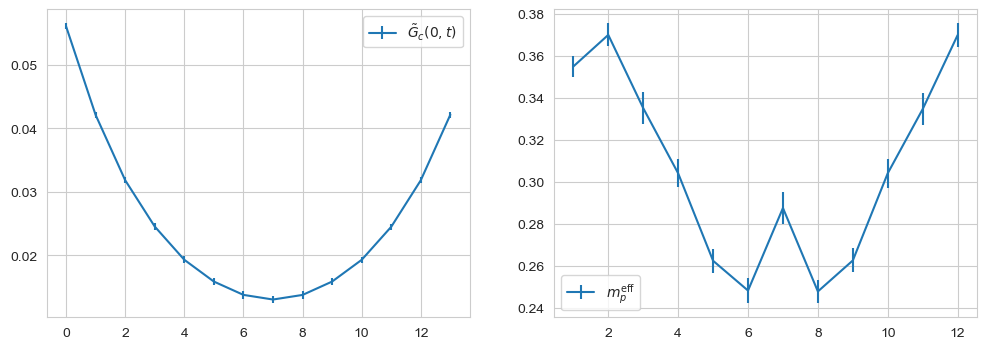

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

xa = np.arange(0, L, 1)
xb = np.arange(1, L-1, 1)

axes[0].errorbar(xa, Gp0_mean, Gp0_error, label = r'$\tilde{G}_c(0, t)$')
axes[1].errorbar(xb, mp0_mean, mp0_error, label = r'$m_p^{\text{eff}}$')

for axis in axes:
    axis.legend()
plt.show()

Here, we compute the mean susceptibility and Ising energy for $L = 14$. We also compare the value with those that were obtained in the paper.

In [19]:
from library.theory import susceptibility, isingenergy

X = susceptibility(cfgs)
X_mean, X_err = bootstrap(X, Nboot= 1000, binsize=100)

print(f"mean susceptibility: {X_mean:.4f} ({X_err:.4f}), compared to ~ 5.400 in the paper.")

E = isingenergy(cfgs)
E_mean, E_err = bootstrap(E, Nboot= 1000, binsize=100)

print(f"mean Ising energy  : {E_mean:.4f} ({E_err:.4f}), compared to ~ 0.105 in the paper.")

mean susceptibility: 5.0589 (0.3021), compared to ~ 5.400 in the paper.
mean Ising energy  : 0.1058 (0.0013), compared to ~ 0.105 in the paper.


In the following cells, we perform the above computation for each value of $L$. Generally, the two-point functions and effective pole masses produced resemble the results in the paper. However, as we can see in the mean susceptibility and Ising energy plot, there appear some instability starting from $L = 12$, which might be caused by the low acceptance rate and number of samples.

Edit: The instability has mostly disappear by using large number of samples!

Skipping training
Loading pre-trained model


100%|██████████| 40592/40592 [00:16<00:00, 2405.45it/s]


Accept rate for (L = 6): 0.5101744186046512


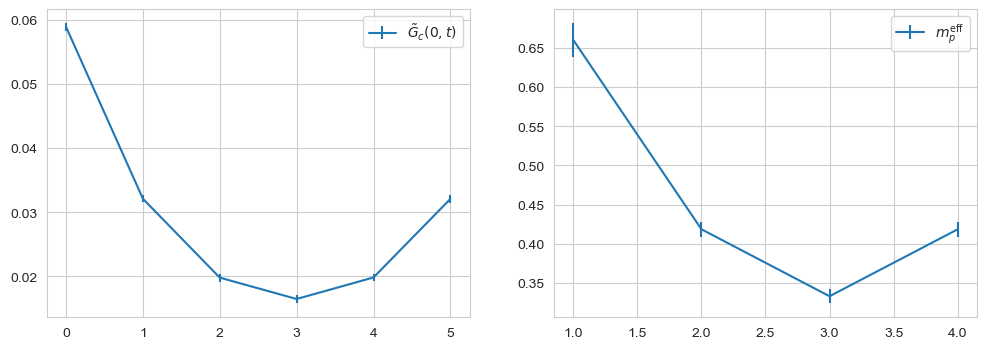

Skipping training
Loading pre-trained model


100%|██████████| 40592/40592 [00:19<00:00, 2047.17it/s]


Accept rate for (L = 8): 0.47516752069373275


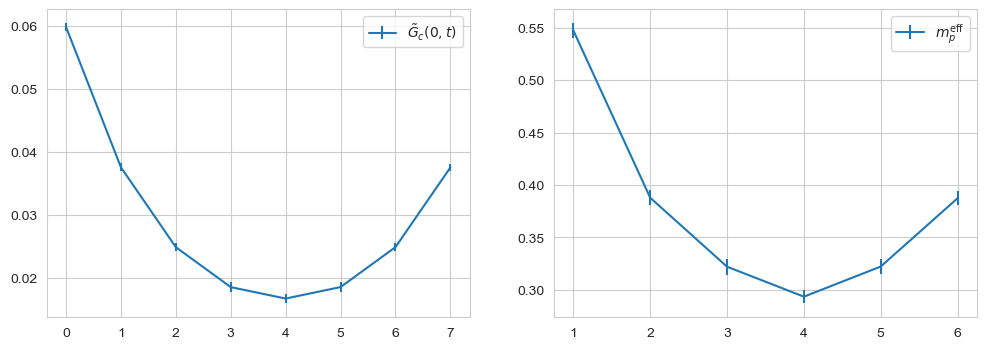

Skipping training
Loading pre-trained model


100%|██████████| 40592/40592 [01:00<00:00, 672.75it/s] 


Accept rate for (L = 10): 0.43116870319274736


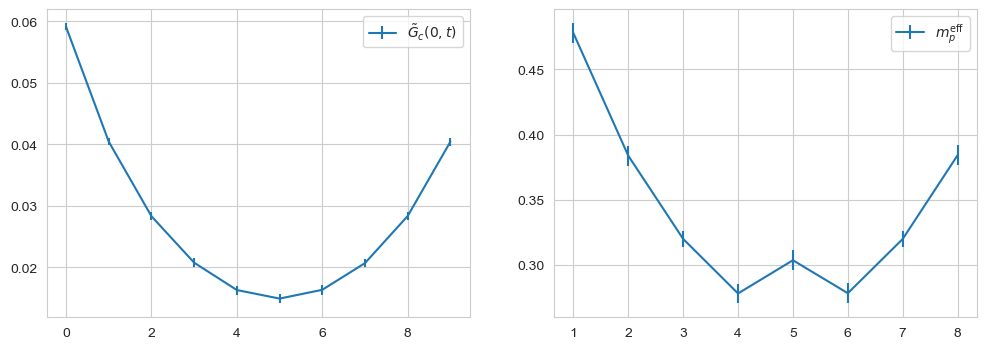

Skipping training
Loading pre-trained model


100%|██████████| 40592/40592 [00:53<00:00, 757.41it/s] 


Accept rate for (L = 12): 0.2930134016554986


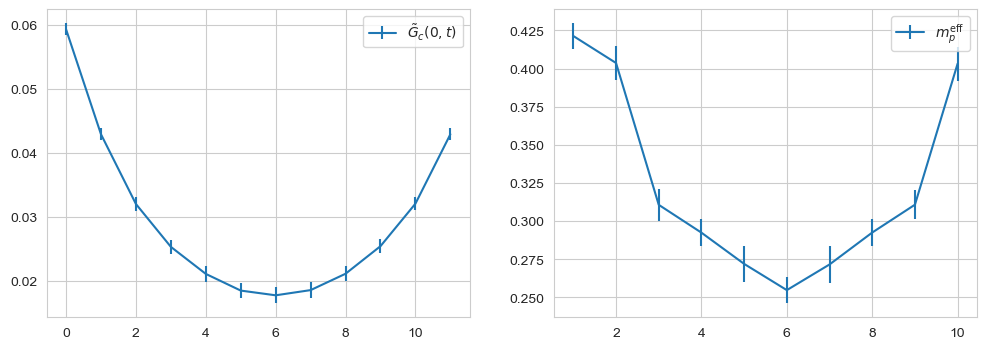

Skipping training
Loading pre-trained model


100%|██████████| 40592/40592 [01:02<00:00, 649.61it/s]


Accept rate for (L = 14): 0.26426389436342135


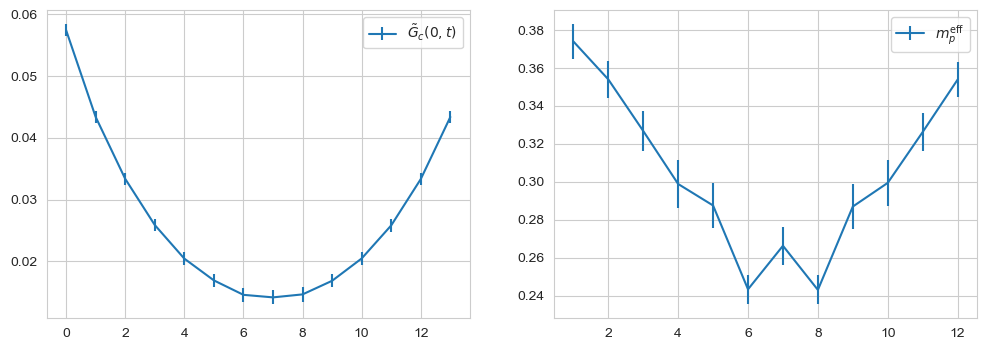

In [10]:
from library.theory import variablegenerator, bootstrap
import matplotlib.pyplot as plt

Ls = [6, 8, 10, 12, 14]
lambs = [6.975, 6.008, 5.550, 5.276, 5.113]
blobs = [blob6, blob8, blob10, blob12, blob14]

Xs = []
Ys = []
for L, lamb, blob in zip(Ls, lambs, blobs):
    Gp0, mp0, X, Y = 0, 0, 0, 0
    lattice_shape = (L, L)

    phi4_action = ScalarPhi4Action(M2 = -4.0, lam = lamb)

    #Model
    prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))
    layers = make_phi4_affine_layers(lattice_shape = lattice_shape, n_layers = 16,
                                    hidden_sizes = [8, 8], kernel_size = 3)

    model = {'layers': layers, 'prior': prior}
    flowphi4 = DiscreteFlow(model = model, action = phi4_action, loss_fn = calc_dkl,
                        optimizer = torch.optim.Adam(model['layers'].parameters(), lr = 0.001),
                        batch_size = 64, N_era = 1, N_epoch = 40
                        , use_pretrained= True, blob = blob
                        )
    Gp0, mp0, X, Y = variablegenerator(flowphi4, 1, 40592, 592, L)

    Gp0_mean, Gp0_error = [], []
    mp0_mean, mp0_error = [], []

    for i in range(len(Gp0[0])):
        Gp0_1, Gp0_2 = bootstrap(Gp0[:,i], Nboot= 1000, binsize=100)
        Gp0_mean.append(Gp0_1)
        Gp0_error.append(Gp0_2)
        
    for i in range(len(mp0[0])):
        mp0_1, mp0_2 = bootstrap(mp0[:,i], Nboot= 1000, binsize=100)
        mp0_mean.append(mp0_1)
        mp0_error.append(mp0_2)
    
    fig, axes = plt.subplots(nrows=1, ncols= 2, figsize = (12, 4))
    flat_axes = axes.flatten()
    xa = np.arange(0, L, 1)
    xb = np.arange(1, L-1, 1)
    flat_axes[0].errorbar(xa, Gp0_mean, Gp0_error, label = r'$\tilde{G}_c(0, t)$')
    flat_axes[1].errorbar(xb, mp0_mean, mp0_error, label = r'$m_p^{\text{eff}}$')
    flat_axes[0].legend()
    flat_axes[1].legend()
    plt.show()

    Xs.append(bootstrap(X.reshape(-1), Nboot= 1000, binsize=100))
    Ys.append(bootstrap(Y.reshape(-1), Nboot= 1000, binsize=100))

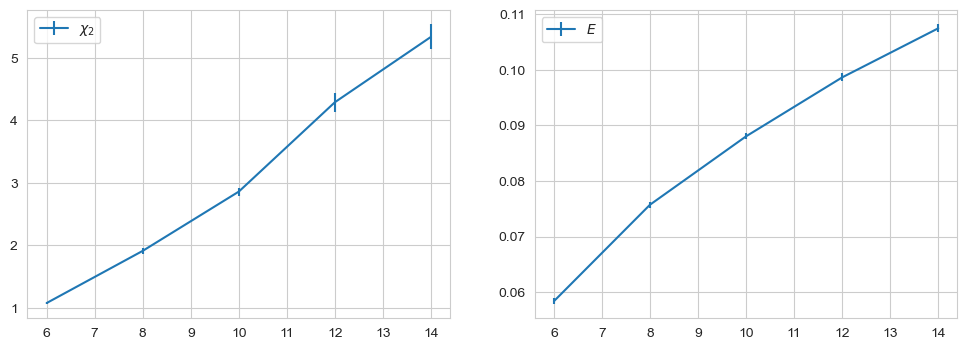

In [11]:
fig, axes = plt.subplots(nrows=1, ncols= 2, figsize = (12, 4))
flat_axes = axes.flatten()
flat_axes[0].errorbar(Ls, np.array(Xs)[:,0], np.array(Xs)[:,1], label = r'$\chi_2$')
flat_axes[1].errorbar(Ls, np.array(Ys)[:,0], np.array(Ys)[:,1], label = r'$E$')
flat_axes[0].legend()
flat_axes[1].legend()
plt.show()